In [ ]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch
import yaml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # maybe something more robust for unseen data?
from typing import Union, Literal, Callable,Iterable
from torch.utils.data import TensorDataset, DataLoader
from functools import partial
from scipy.stats import entropy
from tqdm import tqdm
import optuna



df_train:pd.DataFrame = pyreadr.read_r('datasets/train.rds')[None]

seed = 1

# Data Profiling

In [54]:
# defining functions

def looping_col(func:Callable, df:pd.DataFrame, chart:bool = False) -> pd.DataFrame:
    """I don t want to see too many for loops later

    Apply a column-wise function over a DataFrame.

    If chart=False (default), calls func(df, col) for each column and
    returns a DataFrame assembled from the results (dict of col -> output).
    If chart=True, simply iterates columns and calls func(df, col) for its side effects
    (e.g., plotting/saving charts), returning nothing.
    
    """
    if not chart:
        output = {col: func(df,col) for col in tqdm(df.columns)}
        return pd.DataFrame(output)
    else:
        for col in df.columns:
            func(df,col)

def summary_df(df:pd.DataFrame, col:str) -> int:

    '''
    Compute lightweight summary stats for one column.

    Returns count, missing, % missing, '-1' placeholders, distincts,
    uniqueness ratio, dtype, mode and its share, entropy (Shannon),
    and for numeric quartiles, IQR whiskers, and outlier count/% via the IQR rule.   
    
    '''

    s = df[col]
    #i explicit dropna=True
    Q25 = Q50 = Q75 = lower = upper = out_count = out_pct = None

    # let s get the wiskers
    if pd.api.types.is_numeric_dtype(s):
        Q25 = s.quantile(0.25)
        Q50 = s.quantile(0.5)
        Q75 = s.quantile(0.75)
        IQR = Q75 - Q25
        lower = Q25 - 1.5*IQR
        upper = Q75 + 1.5*IQR
        outliers = s[(s < lower) | (s > upper)]
        out_count = outliers.count()
        out_pct = outliers.count() / s.count() * 100 

    stats = {
        "count": s.count(),
        "missing": s.isna().sum(),
        "missing_pct": s.isna().mean()*100,
        "missing_minus1":sum(((s == -1) | (s == "-1"))),
        "missing_minus1_pct":round(sum(((s == -1) | (s == "-1")))/s.count(),2),
        "nunique": s.nunique(dropna=True),
        'uniqueness_ratio': round(s.nunique(dropna=True)/len(s),2),
        "dtype": str(s.dtype),
        'most_freq': s.value_counts(ascending=False, dropna=True).index[0],
        '%_most_freq': round((s.value_counts(ascending=False, dropna=True).iloc[0]/s.count())*100,2),
        'entropy': entropy(s.dropna().value_counts(normalize=True)),
        "Q25": Q25,
        "Q50": Q50,
        "Q75": Q75,
        "upper_wisker": upper,
        "lower_wisker": lower,
        "outlier_count": out_count,
        "outlier_pct": out_pct
    }

    return stats


def heatmap_corr(df: pd.DataFrame) -> None:
    """
    Plot and save a numeric-only correlation heatmap.

    Computes df.corr(numeric_only=True), create heatmap
    and saves it to 'charts/heatmap.png'.
    """
    display(df)
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=False,
                linewidths=0.5, square=True,
                cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('charts/heatmap.png')
    # plt.show()
    

def _data_cleaning(df:pd.DataFrame,
                   drop_first:bool=False
                   ) -> Union[pd.DataFrame,list[str]]:
    '''
    ad hoc data cleaning
    '''
    df_n = df.copy()

    if df_n.drop_duplicates().shape==df_n.shape:
        print('NO DUPLICATES')

    d_cols = df_n.select_dtypes(include=['object', 'category']).columns
    
    df_n = pd.get_dummies(df_n, columns=d_cols, drop_first=drop_first,dtype=int)

    str_cols = []

    for col in df_n.columns:
        if any(col.startswith(i) for i in d_cols):
            str_cols.append(col)

    num_cols = [col for col in df_n.columns if not col in str_cols]

    df_n = df_n.astype({col:'float32' for col in df_n.columns})

    return df_n, str_cols, num_cols


def dataNN(df:pd.DataFrame,seed=seed):
    
    df_clean, str_cols, num_cols = _data_cleaning(df)
    num_cols.remove('score')

    y = df_clean['score'].copy()
    x = df_clean.drop(columns = 'score')

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=seed)
    
    scaler = MinMaxScaler()

    x_train[num_cols] = scaler.fit_transform(
        x_train[num_cols])
    
    x_test[num_cols] = scaler.fit_transform(
        x_test[num_cols])

    return x_train, x_test, y_train, y_test

In [55]:
summary_our = looping_col(summary_df,df_train)
summary_our

100%|██████████| 31/31 [00:00<00:00, 623.25it/s]


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,score
count,316,316,316,316,316,316,316,316,316,316,...,316,316,316,316,316,316,316,316,316,316
missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
missing_minus1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_minus1_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nunique,2,2,8,2,2,2,5,5,5,5,...,2,2,5,5,5,5,5,5,31,169
uniqueness_ratio,0.01,0.01,0.03,0.01,0.01,0.01,0.02,0.02,0.02,0.02,...,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.1,0.53
dtype,category,category,float64,category,category,category,float64,float64,category,category,...,category,category,float64,float64,float64,float64,float64,float64,float64,float64
most_freq,GP,F,17.0,U,GT3,T,4.0,2.0,other,other,...,yes,no,4.0,3.0,3.0,1.0,1.0,5.0,0.0,-0.183161
%_most_freq,87.34,54.75,26.27,77.85,70.89,89.24,32.59,28.48,36.71,55.7,...,81.33,67.41,49.68,41.77,34.49,70.25,37.97,33.54,29.75,2.85


NO DUPLICATES


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18.0,3.0,2.0,1.0,3.0,0.0,5.0,4.0,3.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,17.0,3.0,4.0,1.0,3.0,0.0,4.0,4.0,5.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,17.0,2.0,3.0,2.0,1.0,0.0,5.0,2.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,18.0,4.0,3.0,1.0,3.0,0.0,5.0,3.0,2.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16.0,1.0,3.0,1.0,2.0,3.0,4.0,3.0,5.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,15.0,4.0,3.0,1.0,2.0,0.0,4.0,5.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
312,17.0,4.0,4.0,2.0,1.0,0.0,4.0,1.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
313,16.0,4.0,4.0,1.0,1.0,0.0,4.0,5.0,5.0,5.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
314,17.0,3.0,1.0,1.0,2.0,0.0,4.0,5.0,4.0,2.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


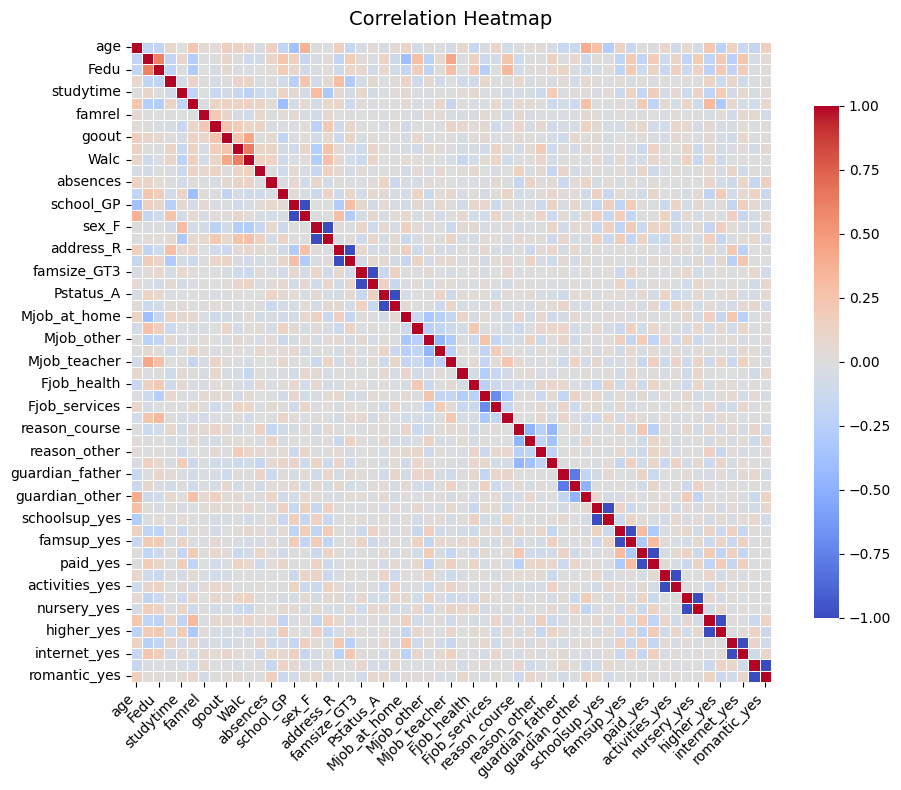

In [56]:
df_n,_,_= _data_cleaning(df_train)
heatmap_corr(df_n)

In [57]:


class Model(nn.Module):
    def __init__(self,
                 n_features:int,
                 layers:Iterable,
                 dropout:float,
                 ) -> None:
        super().__init__()

        self.depth:int = len(layers)
        self.layers:Iterable = layers
        self.n_features:int = n_features

        stack:list = []
        init:int = self.n_features
        for n in layers:
            if (n == None) or (n==0): continue
            stack.append(nn.Linear(init, n))
            stack.append(nn.Dropout(p = dropout))
            stack.append(nn.ReLU())
            # the inputs of next layer are the output of the preivous one
            init = n 
        
        # Final Layer
        stack.append(nn.Linear(init,1))
        stack.append(nn.Softplus()) #ensuring positivity

        self.net = nn.Sequential(*stack)

    def forward(self, x):
        return self.net(x)


class Trainer():

    def __init__(self,
                 model:nn.Module,
                 data:Union[pd.DataFrame],
                 batch_size:int,
                 lr:float,
                 epochs:int = 100
                 ):
        
        if torch.cuda.is_available():
            torch.set_default_device('cpu') # default cpu
            print('Running on GPU\n')

        self.model:nn.Module = model
        self.data:Union[pd.DataFrame] = data
        self.batch_size:int = batch_size
        self.lr:float = lr
        self.n_epochs:int = epochs

        self.optimizer:torch.optim = torch.optim.Adam(model.parameters(), lr=lr)
        self.loss_f = nn.MSELoss()

        self._reset()


    def _reset(self):

        fnc = lambda x: torch.tensor(x.values,dtype=torch.float32)
        x_train, x_test, y_train, y_test = map(fnc,self.data)

        train_ds = TensorDataset(x_train, y_train)
        test_ds  = TensorDataset(x_test, y_test)
        self.train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        self.test_dl  = DataLoader(test_ds, batch_size=self.batch_size, shuffle=False)

    def train(self):
        
        for epoch in range(self.n_epochs):
            self.model.train()
            for x, y in self.train_dl:
                # self.optimizer.zero_grad() # for performance not necessary
                pred = self.model(x)
                loss = self.loss_f(pred, y)
                loss.backward()
                self.optimizer.step()

    def evaluate(self) -> float:

        self.model.eval()
        total_loss:float = 0.0
        n:float = 0.0

        for x, y in self.test_dl: #test data
            pred = self.model(x)
            loss = self.loss_f(pred, y)
            elmnts = x.size(0)
            # by default MSELoss does the mean (1/n)(yp-y)^2, i.e. multiply by N to offset
            total_loss += loss.item() * elmnts 
            n += elmnts

        mse = (total_loss/n)
        print(f'Evaluated Model. MSE: {round(mse,3)}')

        return mse


            
def objective(trial, data_:list):
    """Objective function to be optimized by Optuna.

    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of filters of 

    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    x_train, x_test, y_train, y_test = data_

    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.4)
    n_layers = trial.suggest_int("n_layers", 1, 12)
    layers_ = [trial.suggest_int(f"l{i}_nodes", 1, 64, step=1) for i in range(n_layers)] #maybe we can do something similar also for the nn.Linear
    lr_ = trial.suggest_float('learning_rate', 1e-5,1e-3,log=True)
    batch_size_ = trial.suggest_int('batch_size', 2, 120, step=1)
    n_epochs = trial.suggest_int('n_epochs', 10, 10000, step = 50)

    # Generate the model
    NN_model = Model(n_features=len(x_train.columns),
                     layers=layers_,
                     dropout=dropout_prob)



    trainer = Trainer(model = NN_model,
                      data = data_,
                      batch_size = batch_size_,
                      lr = lr_,
                      epochs=n_epochs)

    return trainer.evaluate()

In [58]:
x_train, x_test, y_train, y_test = dataNN(df_train)
data_:list[pd.DataFrame] = [x_train, x_test, y_train, y_test]

NO DUPLICATES


In [59]:

objF = partial(objective, data_=data_)

study = optuna.create_study(
    study_name = 'NN_score',
    storage= 'sqlite:///optuna-study/optuna-study.db',
    direction= 'minimize',
    load_if_exists=True) 

study.optimize(objF, n_trials=10000)


[I 2025-10-11 18:50:08,466] A new study created in RDB with name: NN_score
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [10, 10000] and step=50, but the range is not divisible by `step`. It will be replaced by [10, 9960].
  warnings.warn(
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:08,556] Trial 0 finished with value: 1.819697618484497 and parameters: {'dropout_prob': 0.01621623488759254, 'n_layers': 9, 'l0_nodes': 2, 'l1_nodes': 6, 'l2_nodes': 52, 'l3_nodes': 34, 'l4_nodes': 23, 'l5_nodes': 29, 'l6_nodes': 35, 'l7_nodes': 11, 'l8_node

Evaluated Model. MSE: 1.82
Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.877


[I 2025-10-11 18:50:08,771] Trial 3 finished with value: 1.9138281419873238 and parameters: {'dropout_prob': 0.2325529518038456, 'n_layers': 10, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 29, 'l3_nodes': 19, 'l4_nodes': 42, 'l5_nodes': 40, 'l6_nodes': 48, 'l7_nodes': 56, 'l8_nodes': 63, 'l9_nodes': 57, 'learning_rate': 0.0001926842320354305, 'batch_size': 28, 'n_epochs': 5060}. Best is trial 0 with value: 1.819697618484497.
[I 2025-10-11 18:50:08,839] Trial 4 finished with value: 1.9262638092041016 and parameters: {'dropout_prob': 0.02979358908387777, 'n_layers': 8, 'l0_nodes': 48, 'l1_nodes': 31, 'l2_nodes': 46, 'l3_nodes': 25, 'l4_nodes': 26, 'l5_nodes': 5, 'l6_nodes': 35, 'l7_nodes': 51, 'learning_rate': 0.0007680009374654832, 'batch_size': 91, 'n_epochs': 4860}. Best is trial 0 with value: 1.819697618484497.
[I 2025-10-11 18:50:08,921] Trial 5 finished with value: 1.92159903049469 and parameters: {'dropout_prob': 0.2876434640134121, 'n_layers': 8, 'l0_nodes': 7, 'l1_nodes': 61, 'l

Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.922


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:08,995] Trial 6 finished with value: 1.8863424807786942 and parameters: {'dropout_prob': 0.16111180726446667, 'n_layers': 6, 'l0_nodes': 43, 'l1_nodes': 59, 'l2_nodes': 48, 'l3_nodes': 11, 'l4_nodes': 10, 'l5_nodes': 36, '

Evaluated Model. MSE: 1.886
Evaluated Model. MSE: 2.155
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:50:09,216] Trial 9 finished with value: 1.8789916038513184 and parameters: {'dropout_prob': 0.04224961959970211, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 46, 'l2_nodes': 47, 'learning_rate': 8.913018607748657e-05, 'batch_size': 80, 'n_epochs': 9160}. Best is trial 0 with value: 1.819697618484497.
[I 2025-10-11 18:50:09,292] Trial 10 finished with value: 1.928274154663086 and parameters: {'dropout_prob': 0.38409682244388943, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 4, 'l2_nodes': 63, 'l3_nodes': 45, 'learning_rate': 6.883436860283186e-05, 'batch_size': 120, 'n_epochs': 6360}. Best is trial 0 with value: 1.819697618484497.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.928


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:09,422] Trial 11 finished with value: 1.8370168441906571 and parameters: {'dropout_prob': 0.12835622635823005, 'n_layers': 12, 'l0_nodes': 1, 'l1_nodes': 31, 'l2_nodes': 33, 'l3_nodes': 42, 'l4_nodes': 64, 'l5_nodes': 62, 'l6_

Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 1.871


[I 2025-10-11 18:50:09,666] Trial 13 finished with value: 2.092362552881241 and parameters: {'dropout_prob': 0.013423516960183339, 'n_layers': 10, 'l0_nodes': 21, 'l1_nodes': 19, 'l2_nodes': 20, 'l3_nodes': 43, 'l4_nodes': 3, 'l5_nodes': 20, 'l6_nodes': 31, 'l7_nodes': 18, 'l8_nodes': 3, 'l9_nodes': 26, 'learning_rate': 4.398317704379044e-05, 'batch_size': 8, 'n_epochs': 5460}. Best is trial 0 with value: 1.819697618484497.
[I 2025-10-11 18:50:09,793] Trial 14 finished with value: 1.9322102069854736 and parameters: {'dropout_prob': 0.1277226370638551, 'n_layers': 11, 'l0_nodes': 1, 'l1_nodes': 37, 'l2_nodes': 37, 'l3_nodes': 56, 'l4_nodes': 34, 'l5_nodes': 46, 'l6_nodes': 45, 'l7_nodes': 1, 'l8_nodes': 17, 'l9_nodes': 30, 'l10_nodes': 1, 'learning_rate': 0.00022242974058935767, 'batch_size': 4, 'n_epochs': 3310}. Best is trial 0 with value: 1.819697618484497.


Evaluated Model. MSE: 2.092
Evaluated Model. MSE: 1.932


[I 2025-10-11 18:50:09,908] Trial 15 finished with value: 1.8186137676239014 and parameters: {'dropout_prob': 0.2586674721072393, 'n_layers': 9, 'l0_nodes': 15, 'l1_nodes': 1, 'l2_nodes': 2, 'l3_nodes': 35, 'l4_nodes': 61, 'l5_nodes': 23, 'l6_nodes': 23, 'l7_nodes': 17, 'l8_nodes': 18, 'learning_rate': 1.0318335275673412e-05, 'batch_size': 105, 'n_epochs': 7760}. Best is trial 15 with value: 1.8186137676239014.
[I 2025-10-11 18:50:10,003] Trial 16 finished with value: 1.7214288711547852 and parameters: {'dropout_prob': 0.27916805288468755, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 1, 'l2_nodes': 56, 'l3_nodes': 32, 'l4_nodes': 18, 'l5_nodes': 20, 'l6_nodes': 24, 'l7_nodes': 21, 'learning_rate': 1.0103346068309014e-05, 'batch_size': 102, 'n_epochs': 8210}. Best is trial 16 with value: 1.7214288711547852.
[I 2025-10-11 18:50:10,081] Trial 17 finished with value: 1.8627843856811523 and parameters: {'dropout_prob': 0.2993942093382824, 'n_layers': 5, 'l0_nodes': 26, 'l1_nodes': 1, 'l2_node

Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.721
Evaluated Model. MSE: 1.863


[I 2025-10-11 18:50:10,182] Trial 18 finished with value: 1.8197212219238281 and parameters: {'dropout_prob': 0.2524808300345764, 'n_layers': 7, 'l0_nodes': 13, 'l1_nodes': 11, 'l2_nodes': 1, 'l3_nodes': 3, 'l4_nodes': 36, 'l5_nodes': 12, 'l6_nodes': 20, 'learning_rate': 1.0220205483326257e-05, 'batch_size': 66, 'n_epochs': 8210}. Best is trial 16 with value: 1.7214288711547852.
[I 2025-10-11 18:50:10,276] Trial 19 finished with value: 1.654223918914795 and parameters: {'dropout_prob': 0.3624844306896924, 'n_layers': 8, 'l0_nodes': 25, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 33, 'l4_nodes': 55, 'l5_nodes': 15, 'l6_nodes': 7, 'l7_nodes': 29, 'learning_rate': 3.301396772776488e-05, 'batch_size': 102, 'n_epochs': 3910}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:10,366] Trial 20 finished with value: 1.9870916604995728 and parameters: {'dropout_prob': 0.372453080938185, 'n_layers': 6, 'l0_nodes': 26, 'l1_nodes': 19, 'l2_nodes': 54, 'l3_nodes': 52, 'l4_nodes': 53

Evaluated Model. MSE: 1.82
Evaluated Model. MSE: 1.654
Evaluated Model. MSE: 1.987


[I 2025-10-11 18:50:10,472] Trial 21 finished with value: 1.9214626550674438 and parameters: {'dropout_prob': 0.33272932609600747, 'n_layers': 8, 'l0_nodes': 14, 'l1_nodes': 11, 'l2_nodes': 6, 'l3_nodes': 34, 'l4_nodes': 60, 'l5_nodes': 17, 'l6_nodes': 4, 'l7_nodes': 28, 'learning_rate': 1.5473785953281033e-05, 'batch_size': 97, 'n_epochs': 1860}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:10,575] Trial 22 finished with value: 1.825393795967102 and parameters: {'dropout_prob': 0.33820390981058057, 'n_layers': 9, 'l0_nodes': 20, 'l1_nodes': 1, 'l2_nodes': 1, 'l3_nodes': 28, 'l4_nodes': 54, 'l5_nodes': 1, 'l6_nodes': 1, 'l7_nodes': 34, 'l8_nodes': 25, 'learning_rate': 1.5274854157478637e-05, 'batch_size': 104, 'n_epochs': 6110}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.825


[I 2025-10-11 18:50:10,672] Trial 23 finished with value: 1.999479055404663 and parameters: {'dropout_prob': 0.22644939296506306, 'n_layers': 9, 'l0_nodes': 26, 'l1_nodes': 8, 'l2_nodes': 22, 'l3_nodes': 37, 'l4_nodes': 42, 'l5_nodes': 26, 'l6_nodes': 22, 'l7_nodes': 21, 'l8_nodes': 52, 'learning_rate': 3.49020979133959e-05, 'batch_size': 95, 'n_epochs': 4310}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:10,763] Trial 24 finished with value: 1.7328559160232544 and parameters: {'dropout_prob': 0.2990955266304577, 'n_layers': 7, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 8, 'l3_nodes': 48, 'l4_nodes': 58, 'l5_nodes': 8, 'l6_nodes': 9, 'learning_rate': 2.0302946495918943e-05, 'batch_size': 110, 'n_epochs': 6160}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:10,843] Trial 25 finished with value: 1.9445257186889648 and parameters: {'dropout_prob': 0.3292446068085127, 'n_layers': 5, 'l0_nodes': 8, 'l1_nodes': 18, 'l2_nodes': 9, 'l3_nodes': 48, 

Evaluated Model. MSE: 1.999
Evaluated Model. MSE: 1.733
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:50:10,949] Trial 26 finished with value: 1.9240915775299072 and parameters: {'dropout_prob': 0.2935054519837052, 'n_layers': 7, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 14, 'l3_nodes': 59, 'l4_nodes': 2, 'l5_nodes': 10, 'l6_nodes': 9, 'learning_rate': 1.9413075773984975e-05, 'batch_size': 89, 'n_epochs': 4210}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:11,030] Trial 27 finished with value: 1.726606845855713 and parameters: {'dropout_prob': 0.36506735673130974, 'n_layers': 6, 'l0_nodes': 22, 'l1_nodes': 36, 'l2_nodes': 23, 'l3_nodes': 50, 'l4_nodes': 39, 'l5_nodes': 8, 'learning_rate': 0.00013925694366545712, 'batch_size': 66, 'n_epochs': 1860}. Best is trial 19 with value: 1.654223918914795.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([61])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect res

Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.727
Evaluated Model. MSE: 1.868


[I 2025-10-11 18:50:11,197] Trial 29 finished with value: 1.9753376170992851 and parameters: {'dropout_prob': 0.3898370629200202, 'n_layers': 5, 'l0_nodes': 37, 'l1_nodes': 39, 'l2_nodes': 40, 'l3_nodes': 18, 'l4_nodes': 40, 'learning_rate': 0.00011154348913672772, 'batch_size': 52, 'n_epochs': 2160}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:11,281] Trial 30 finished with value: 1.8291245698928833 and parameters: {'dropout_prob': 0.39966498927073546, 'n_layers': 6, 'l0_nodes': 41, 'l1_nodes': 27, 'l2_nodes': 54, 'l3_nodes': 29, 'l4_nodes': 30, 'l5_nodes': 17, 'learning_rate': 0.000395970308255598, 'batch_size': 66, 'n_epochs': 1060}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.975
Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.877


[I 2025-10-11 18:50:11,391] Trial 31 finished with value: 1.8772037029266357 and parameters: {'dropout_prob': 0.3096819642427109, 'n_layers': 8, 'l0_nodes': 22, 'l1_nodes': 16, 'l2_nodes': 6, 'l3_nodes': 50, 'l4_nodes': 47, 'l5_nodes': 8, 'l6_nodes': 7, 'l7_nodes': 41, 'learning_rate': 5.3004813416173796e-05, 'batch_size': 103, 'n_epochs': 3160}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:11,498] Trial 32 finished with value: 1.834409475326538 and parameters: {'dropout_prob': 0.35505283785967, 'n_layers': 7, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 18, 'l3_nodes': 53, 'l4_nodes': 57, 'l5_nodes': 3, 'l6_nodes': 16, 'learning_rate': 4.2553939625156244e-05, 'batch_size': 84, 'n_epochs': 4060}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:11,600] Trial 33 finished with value: 2.1158149242401123 and parameters: {'dropout_prob': 0.3126821747200192, 'n_layers': 8, 'l0_nodes': 8, 'l1_nodes': 36, 'l2_nodes': 7, 'l3_nodes': 40, 'l4_nodes': 22, '

Evaluated Model. MSE: 1.834
Evaluated Model. MSE: 2.116
Evaluated Model. MSE: 2.096


[I 2025-10-11 18:50:11,734] Trial 35 finished with value: 1.8055659532546997 and parameters: {'dropout_prob': 0.355201000116917, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 0.0003109429167216429, 'batch_size': 102, 'n_epochs': 5360}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:11,847] Trial 36 finished with value: 2.0709171295166016 and parameters: {'dropout_prob': 0.22280051748313556, 'n_layers': 9, 'l0_nodes': 12, 'l1_nodes': 7, 'l2_nodes': 33, 'l3_nodes': 58, 'l4_nodes': 49, 'l5_nodes': 8, 'l6_nodes': 11, 'l7_nodes': 26, 'l8_nodes': 63, 'learning_rate': 1.656851423723092e-05, 'batch_size': 90, 'n_epochs': 2310}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.806
Evaluated Model. MSE: 2.071
Evaluated Model. MSE: 2.123


[I 2025-10-11 18:50:11,934] Trial 37 finished with value: 2.1230356693267822 and parameters: {'dropout_prob': 0.2761164350745253, 'n_layers': 6, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 41, 'l3_nodes': 38, 'l4_nodes': 38, 'l5_nodes': 7, 'learning_rate': 1.3128453511443453e-05, 'batch_size': 74, 'n_epochs': 4610}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:12,029] Trial 38 finished with value: 1.8509111404418945 and parameters: {'dropout_prob': 0.3302025502364255, 'n_layers': 7, 'l0_nodes': 23, 'l1_nodes': 34, 'l2_nodes': 24, 'l3_nodes': 22, 'l4_nodes': 12, 'l5_nodes': 19, 'l6_nodes': 27, 'learning_rate': 0.00012085230983372205, 'batch_size': 111, 'n_epochs': 1060}. Best is trial 19 with value: 1.654223918914795.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect r

Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 1.845
Evaluated Model. MSE: 1.856


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([49])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:12,228] Trial 40 finished with value: 1.8559148162603378 and parameters: {'dropout_prob': 0.3639212900643473, 'n_layers': 10, 'l0_nodes': 54, 'l1_nodes': 31, 'l2_nodes': 58, 'l3_nodes': 16, 'l4_nodes': 45, 'l5_nodes': 30, 

Evaluated Model. MSE: 1.7
Evaluated Model. MSE: 2.015
Evaluated Model. MSE: 1.8
Evaluated Model. MSE: 1.781


[I 2025-10-11 18:50:12,563] Trial 45 finished with value: 1.824195384979248 and parameters: {'dropout_prob': 0.28267605161982945, 'n_layers': 5, 'l0_nodes': 29, 'l1_nodes': 9, 'l2_nodes': 11, 'l3_nodes': 55, 'l4_nodes': 32, 'learning_rate': 6.301691698135805e-05, 'batch_size': 108, 'n_epochs': 5210}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:12,652] Trial 46 finished with value: 2.103074789047241 and parameters: {'dropout_prob': 0.348246642300162, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 15, 'l2_nodes': 18, 'l3_nodes': 26, 'learning_rate': 9.05495824050972e-05, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 19 with value: 1.654223918914795.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.103
Evaluated Model. MSE: 2.105


[I 2025-10-11 18:50:12,814] Trial 48 finished with value: 1.8345078229904175 and parameters: {'dropout_prob': 0.30129813323748045, 'n_layers': 8, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 9, 'l3_nodes': 64, 'l4_nodes': 26, 'l5_nodes': 12, 'l6_nodes': 6, 'l7_nodes': 33, 'learning_rate': 1.3504353667918112e-05, 'batch_size': 120, 'n_epochs': 8810}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:12,899] Trial 49 finished with value: 1.8531460762023926 and parameters: {'dropout_prob': 0.372620949901152, 'n_layers': 6, 'l0_nodes': 23, 'l1_nodes': 43, 'l2_nodes': 27, 'l3_nodes': 45, 'l4_nodes': 7, 'l5_nodes': 22, 'learning_rate': 0.0009234957429806534, 'batch_size': 78, 'n_epochs': 9960}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:12,994] Trial 50 finished with value: 1.9588764905929565 and parameters: {'dropout_prob': 0.07209122537051416, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 20, 'l3_nodes': 37, 'l4_nodes': 64, 'l5_nodes': 

Evaluated Model. MSE: 1.835
Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 1.959


[I 2025-10-11 18:50:13,063] Trial 51 finished with value: 2.6689302921295166 and parameters: {'dropout_prob': 0.38064260681092105, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 4, 'learning_rate': 0.0003803273941528874, 'batch_size': 118, 'n_epochs': 9310}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,128] Trial 52 finished with value: 1.7329037189483643 and parameters: {'dropout_prob': 0.39373536330149406, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 5, 'learning_rate': 0.0006040385735390688, 'batch_size': 115, 'n_epochs': 8110}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,196] Trial 53 finished with value: 1.9873673915863037 and parameters: {'dropout_prob': 0.32319718654841334, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 12, 'l2_nodes': 30, 'learning_rate': 0.000648811018449566, 'batch_size': 107, 'n_epochs': 8110}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 2.669
Evaluated Model. MSE: 1.733
Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:50:13,261] Trial 54 finished with value: 2.0099923610687256 and parameters: {'dropout_prob': 0.391467903048745, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 9, 'learning_rate': 0.0002542730417219806, 'batch_size': 114, 'n_epochs': 6760}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,351] Trial 55 finished with value: 2.087700605392456 and parameters: {'dropout_prob': 0.3997710786821971, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 3, 'l2_nodes': 16, 'l3_nodes': 60, 'learning_rate': 0.00018388498223185574, 'batch_size': 97, 'n_epochs': 8060}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,471] Trial 56 finished with value: 2.0070133209228516 and parameters: {'dropout_prob': 0.36925534365683954, 'n_layers': 10, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 44, 'l3_nodes': 50, 'l4_nodes': 51, 'l5_nodes': 51, 'l6_nodes': 59, 'l7_nodes': 9, 'l8_nodes': 30, 'l9_nodes': 17, 'learning_rate': 0.0005881659570413451, 'batch_size': 92, 'n

Evaluated Model. MSE: 2.088
Evaluated Model. MSE: 2.007


[I 2025-10-11 18:50:13,577] Trial 57 finished with value: 1.8747012615203857 and parameters: {'dropout_prob': 0.15820063644685295, 'n_layers': 8, 'l0_nodes': 24, 'l1_nodes': 6, 'l2_nodes': 36, 'l3_nodes': 21, 'l4_nodes': 58, 'l5_nodes': 16, 'l6_nodes': 14, 'l7_nodes': 23, 'learning_rate': 0.0003978939459851651, 'batch_size': 86, 'n_epochs': 8610}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,690] Trial 58 finished with value: 1.9989287853240967 and parameters: {'dropout_prob': 0.3447836166825887, 'n_layers': 9, 'l0_nodes': 28, 'l1_nodes': 11, 'l2_nodes': 4, 'l3_nodes': 44, 'l4_nodes': 42, 'l5_nodes': 1, 'l6_nodes': 38, 'l7_nodes': 31, 'l8_nodes': 53, 'learning_rate': 0.0009354187212617734, 'batch_size': 100, 'n_epochs': 3610}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,748] Trial 59 finished with value: 1.7857186794281006 and parameters: {'dropout_prob': 0.0002625757997705702, 'n_layers': 1, 'l0_nodes': 20, 'learning_rate': 2.013713

Evaluated Model. MSE: 1.875
Evaluated Model. MSE: 1.999
Evaluated Model. MSE: 1.786


[I 2025-10-11 18:50:13,841] Trial 60 finished with value: 1.7872630320489407 and parameters: {'dropout_prob': 0.3034482494380218, 'n_layers': 7, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 20, 'l3_nodes': 40, 'l4_nodes': 18, 'l5_nodes': 10, 'l6_nodes': 18, 'learning_rate': 0.0004363708541164042, 'batch_size': 34, 'n_epochs': 1510}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,903] Trial 61 finished with value: 2.7554752826690674 and parameters: {'dropout_prob': 0.37923421624809234, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 4, 'learning_rate': 0.0007429045337302888, 'batch_size': 116, 'n_epochs': 8860}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:13,972] Trial 62 finished with value: 1.788089632987976 and parameters: {'dropout_prob': 0.3552736851190438, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 5, 'learning_rate': 0.0004949117314026469, 'batch_size': 116, 'n_epochs': 9610}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 2.755
Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 1.837


[I 2025-10-11 18:50:14,042] Trial 63 finished with value: 1.8371044397354126 and parameters: {'dropout_prob': 0.3659317554324364, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 1, 'l2_nodes': 9, 'learning_rate': 0.00029315471109433967, 'batch_size': 108, 'n_epochs': 9460}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,104] Trial 64 finished with value: 1.714801549911499 and parameters: {'dropout_prob': 0.33842710150329575, 'n_layers': 1, 'l0_nodes': 7, 'learning_rate': 1.2346504177157284e-05, 'batch_size': 104, 'n_epochs': 9110}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,163] Trial 65 finished with value: 1.8245195150375366 and parameters: {'dropout_prob': 0.2911664554175069, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 1.3618276605632083e-05, 'batch_size': 103, 'n_epochs': 8410}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,220] Trial 66 finished with value: 1.8853784799575806 and parameters: {'dropout_prob'

Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.885


[I 2025-10-11 18:50:14,311] Trial 67 finished with value: 2.1357243061065674 and parameters: {'dropout_prob': 0.34038939221982983, 'n_layers': 8, 'l0_nodes': 21, 'l1_nodes': 13, 'l2_nodes': 61, 'l3_nodes': 31, 'l4_nodes': 45, 'l5_nodes': 33, 'l6_nodes': 26, 'l7_nodes': 16, 'learning_rate': 1.7452032666006976e-05, 'batch_size': 98, 'n_epochs': 6860}. Best is trial 19 with value: 1.654223918914795.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:14,442] Trial 68 finished with value: 2.029868796467781 and parameters: {'dropout_prob': 0.2687993828420108, 'n_layers': 11, 'l0_nodes': 62, 'l1_nodes': 64, 'l2_nodes': 50, 'l3_nodes': 6, 'l4_nodes': 6

Evaluated Model. MSE: 2.136
Evaluated Model. MSE: 2.03


[I 2025-10-11 18:50:14,542] Trial 69 finished with value: 1.931111216545105 and parameters: {'dropout_prob': 0.3875524941398311, 'n_layers': 6, 'l0_nodes': 7, 'l1_nodes': 9, 'l2_nodes': 22, 'l3_nodes': 35, 'l4_nodes': 26, 'l5_nodes': 21, 'learning_rate': 3.152000733183121e-05, 'batch_size': 111, 'n_epochs': 7710}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,617] Trial 70 finished with value: 2.1017303466796875 and parameters: {'dropout_prob': 0.31513583425542485, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 1.2802212405732916e-05, 'batch_size': 80, 'n_epochs': 6210}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,687] Trial 71 finished with value: 1.6624616384506226 and parameters: {'dropout_prob': 0.3521012430219829, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 7, 'learning_rate': 1.812823299681973e-05, 'batch_size': 120, 'n_epochs': 8310}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 2.102
Evaluated Model. MSE: 1.662


[I 2025-10-11 18:50:14,748] Trial 72 finished with value: 1.955688714981079 and parameters: {'dropout_prob': 0.3524543366494662, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 1.8120824015633623e-05, 'batch_size': 120, 'n_epochs': 8360}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,825] Trial 73 finished with value: 1.925779938697815 and parameters: {'dropout_prob': 0.33356541041520577, 'n_layers': 2, 'l0_nodes': 36, 'l1_nodes': 7, 'learning_rate': 1.4945614314120566e-05, 'batch_size': 105, 'n_epochs': 8060}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:14,924] Trial 74 finished with value: 2.065952777862549 and parameters: {'dropout_prob': 0.3633625594971216, 'n_layers': 7, 'l0_nodes': 8, 'l1_nodes': 15, 'l2_nodes': 14, 'l3_nodes': 26, 'l4_nodes': 7, 'l5_nodes': 41, 'l6_nodes': 6, 'learning_rate': 2.5415667481577788e-05, 'batch_size': 112, 'n_epochs': 9060}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 2.066


[I 2025-10-11 18:50:15,040] Trial 75 finished with value: 2.027438163757324 and parameters: {'dropout_prob': 0.335150096186747, 'n_layers': 9, 'l0_nodes': 14, 'l1_nodes': 10, 'l2_nodes': 30, 'l3_nodes': 12, 'l4_nodes': 35, 'l5_nodes': 26, 'l6_nodes': 19, 'l7_nodes': 38, 'l8_nodes': 38, 'learning_rate': 4.959036655769597e-05, 'batch_size': 100, 'n_epochs': 5710}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,115] Trial 76 finished with value: 2.02461314201355 and parameters: {'dropout_prob': 0.38971768519773303, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 2.2343630316610486e-05, 'batch_size': 113, 'n_epochs': 4960}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,214] Trial 77 finished with value: 1.8748695850372314 and parameters: {'dropout_prob': 0.3077614746483837, 'n_layers': 5, 'l0_nodes': 1, 'l1_nodes': 20, 'l2_nodes': 11, 'l3_nodes': 48, 'l4_nodes': 51, 'learning_rate': 1.2061701018190947e-05, 'batch_size': 70, 'n_epochs': 7910}

Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 2.025
Evaluated Model. MSE: 1.875


[I 2025-10-11 18:50:15,290] Trial 78 finished with value: 2.0989816188812256 and parameters: {'dropout_prob': 0.34505892740797084, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 3, 'l2_nodes': 8, 'learning_rate': 1.514114371520417e-05, 'batch_size': 88, 'n_epochs': 260}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,369] Trial 79 finished with value: 1.8895577192306519 and parameters: {'dropout_prob': 0.32558590762531237, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 34, 'l2_nodes': 64, 'l3_nodes': 62, 'learning_rate': 4.084715765942803e-05, 'batch_size': 108, 'n_epochs': 2110}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,431] Trial 80 finished with value: 1.6950279474258423 and parameters: {'dropout_prob': 0.28639146199935833, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 18, 'learning_rate': 1.9296213003835327e-05, 'batch_size': 103, 'n_epochs': 2910}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 2.099
Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.695


[I 2025-10-11 18:50:15,493] Trial 81 finished with value: 2.1467792987823486 and parameters: {'dropout_prob': 0.24140595056914427, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 18, 'learning_rate': 1.0210537602301376e-05, 'batch_size': 104, 'n_epochs': 2860}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,558] Trial 82 finished with value: 1.8004287481307983 and parameters: {'dropout_prob': 0.28060638737175, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 13, 'learning_rate': 1.6672617665219866e-05, 'batch_size': 101, 'n_epochs': 3110}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,614] Trial 83 finished with value: 2.141716480255127 and parameters: {'dropout_prob': 0.2886643113573928, 'n_layers': 1, 'l0_nodes': 19, 'learning_rate': 3.063276590177738e-05, 'batch_size': 96, 'n_epochs': 2510}. Best is trial 19 with value: 1.654223918914795.


Evaluated Model. MSE: 2.147
Evaluated Model. MSE: 1.8
Evaluated Model. MSE: 2.142


[I 2025-10-11 18:50:15,720] Trial 84 finished with value: 1.756406545639038 and parameters: {'dropout_prob': 0.26314810546402445, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 7, 'l2_nodes': 3, 'l3_nodes': 15, 'l4_nodes': 62, 'l5_nodes': 14, 'l6_nodes': 10, 'l7_nodes': 12, 'learning_rate': 2.090672755729921e-05, 'batch_size': 117, 'n_epochs': 1710}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,784] Trial 85 finished with value: 1.8007254600524902 and parameters: {'dropout_prob': 0.3714084437619073, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 25, 'l2_nodes': 25, 'learning_rate': 1.9695757895309408e-05, 'batch_size': 109, 'n_epochs': 4510}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:15,874] Trial 86 finished with value: 1.8051594495773315 and parameters: {'dropout_prob': 0.35708452150167536, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 17, 'l3_nodes': 56, 'l4_nodes': 57, 'l5_nodes': 18, 'l6_nodes': 15, 'learning_rate': 1.4336310

Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.801
Evaluated Model. MSE: 1.805


[I 2025-10-11 18:50:15,939] Trial 87 finished with value: 1.8689266443252563 and parameters: {'dropout_prob': 0.20161368062964125, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 16, 'learning_rate': 2.477263273295394e-05, 'batch_size': 92, 'n_epochs': 7410}. Best is trial 19 with value: 1.654223918914795.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:16,045] Trial 88 finished with value: 1.99842169880867 and parameters: {'dropout_prob': 0.2974247318738994, 'n_layers': 9, 'l0_nodes': 22, 'l1_nodes': 39, 'l2_nodes': 35, 'l3_nodes': 53, 'l4_nodes': 15, 'l5_nodes': 33, 'l6_nodes': 35, 'l7_nodes': 48, 'l8_nodes': 11, 'learning_rate': 7.9808432425044

Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 1.998


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:16,146] Trial 89 finished with value: 1.9335674978792667 and parameters: {'dropout_prob': 0.312223139281752, 'n_layers': 8, 'l0_nodes': 49, 'l1_nodes': 2, 'l2_nodes': 13, 'l3_nodes': 33, 'l4_nodes': 30, 'l5_nodes': 10, 'l6_nodes': 4, 'l7_nodes': 22, 'learning_rate': 0.00014304609181998914, 'batch_size': 46, 'n_epochs': 5360}. Best is trial 19 with value: 1.654223918914795.
[I 2025-10-11 18:50:16,229] Trial 90 finished with value: 1.6084617376327515 and parameters: {'dropout_prob': 0.2538968982358739, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 1.217681440195466e-05, 'batch_size': 105, 'n_ep

Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.859


[I 2025-10-11 18:50:16,352] Trial 92 finished with value: 2.1397976875305176 and parameters: {'dropout_prob': 0.2249157319542387, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 11, 'learning_rate': 1.8448582970502377e-05, 'batch_size': 102, 'n_epochs': 8310}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,411] Trial 93 finished with value: 2.1540534496307373 and parameters: {'dropout_prob': 0.27860341971000113, 'n_layers': 1, 'l0_nodes': 15, 'learning_rate': 1.0045407921846473e-05, 'batch_size': 115, 'n_epochs': 9810}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,469] Trial 94 finished with value: 2.2437386196106672 and parameters: {'dropout_prob': 0.21658917474909284, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 1.2344826750824577e-05, 'batch_size': 15, 'n_epochs': 610}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,536] Trial 95 finished with value: 1.8651421070098877 and parameters: {'dropout_prob': 0.376410

Evaluated Model. MSE: 2.14
Evaluated Model. MSE: 2.154
Evaluated Model. MSE: 2.244
Evaluated Model. MSE: 1.865


[I 2025-10-11 18:50:16,602] Trial 96 finished with value: 1.7008838653564453 and parameters: {'dropout_prob': 0.32068685026300875, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 14, 'learning_rate': 1.5532339521651445e-05, 'batch_size': 99, 'n_epochs': 3910}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,674] Trial 97 finished with value: 2.3701066970825195 and parameters: {'dropout_prob': 0.3183517660525296, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 1.576666974087857e-05, 'batch_size': 94, 'n_epochs': 3860}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,727] Trial 98 finished with value: 1.8013254404067993 and parameters: {'dropout_prob': 0.29716894660164367, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 1.3709463386105812e-05, 'batch_size': 99, 'n_epochs': 2610}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 1.701
Evaluated Model. MSE: 2.37
Evaluated Model. MSE: 1.801


[I 2025-10-11 18:50:16,819] Trial 99 finished with value: 1.658939242362976 and parameters: {'dropout_prob': 0.2437094816741134, 'n_layers': 7, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 42, 'l4_nodes': 48, 'l5_nodes': 24, 'l6_nodes': 12, 'learning_rate': 1.665976816292046e-05, 'batch_size': 104, 'n_epochs': 3210}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,906] Trial 100 finished with value: 1.8260341882705688 and parameters: {'dropout_prob': 0.23795009375594145, 'n_layers': 6, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 45, 'l3_nodes': 38, 'l4_nodes': 47, 'l5_nodes': 25, 'learning_rate': 1.2493566093154233e-05, 'batch_size': 90, 'n_epochs': 3310}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:16,993] Trial 101 finished with value: 1.7886134386062622 and parameters: {'dropout_prob': 0.26811960573534105, 'n_layers': 7, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 46, 'l4_nodes': 53, 'l5_nodes': 20, 'l6_no

Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.826
Evaluated Model. MSE: 1.789


[I 2025-10-11 18:50:17,091] Trial 102 finished with value: 1.814497709274292 and parameters: {'dropout_prob': 0.2581211439697525, 'n_layers': 8, 'l0_nodes': 24, 'l1_nodes': 14, 'l2_nodes': 6, 'l3_nodes': 41, 'l4_nodes': 39, 'l5_nodes': 29, 'l6_nodes': 10, 'l7_nodes': 62, 'learning_rate': 1.5892451796498254e-05, 'batch_size': 105, 'n_epochs': 3560}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,178] Trial 103 finished with value: 1.8014028072357178 and parameters: {'dropout_prob': 0.2735244544463182, 'n_layers': 6, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 11, 'l3_nodes': 50, 'l4_nodes': 43, 'l5_nodes': 23, 'learning_rate': 2.7790448858900447e-05, 'batch_size': 97, 'n_epochs': 3060}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,270] Trial 104 finished with value: 1.970191240310669 and parameters: {'dropout_prob': 0.2872960709643626, 'n_layers': 7, 'l0_nodes': 21, 'l1_nodes': 16, 'l2_nodes': 1, 'l3_nodes': 43, 'l4_nodes': 55, 'l5_nod

Evaluated Model. MSE: 1.814
Evaluated Model. MSE: 1.801
Evaluated Model. MSE: 1.97


[I 2025-10-11 18:50:17,373] Trial 105 finished with value: 2.1471176147460938 and parameters: {'dropout_prob': 0.3300011189203075, 'n_layers': 8, 'l0_nodes': 9, 'l1_nodes': 42, 'l2_nodes': 3, 'l3_nodes': 28, 'l4_nodes': 59, 'l5_nodes': 7, 'l6_nodes': 8, 'l7_nodes': 44, 'learning_rate': 1.4267379124731565e-05, 'batch_size': 83, 'n_epochs': 5110}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,498] Trial 106 finished with value: 1.913792371749878 and parameters: {'dropout_prob': 0.17545474063687677, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 36, 'l2_nodes': 57, 'l3_nodes': 35, 'l4_nodes': 48, 'l5_nodes': 12, 'l6_nodes': 19, 'learning_rate': 1.088688951309011e-05, 'batch_size': 106, 'n_epochs': 4460}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 2.147
Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 2.096


[I 2025-10-11 18:50:17,572] Trial 107 finished with value: 2.096165895462036 and parameters: {'dropout_prob': 0.2481767539118509, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 21, 'l2_nodes': 7, 'learning_rate': 2.2879181624588764e-05, 'batch_size': 111, 'n_epochs': 2060}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,631] Trial 108 finished with value: 2.107041835784912 and parameters: {'dropout_prob': 0.34145953820496017, 'n_layers': 1, 'l0_nodes': 19, 'learning_rate': 1.65388630862952e-05, 'batch_size': 101, 'n_epochs': 2410}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,695] Trial 109 finished with value: 1.6901259422302246 and parameters: {'dropout_prob': 0.34870384090723106, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 29, 'learning_rate': 3.710842526759239e-05, 'batch_size': 96, 'n_epochs': 4860}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,768] Trial 110 finished with value: 2.007389545440674 and parame

Evaluated Model. MSE: 2.107
Evaluated Model. MSE: 1.69
Evaluated Model. MSE: 2.007


[I 2025-10-11 18:50:17,840] Trial 111 finished with value: 1.8837168216705322 and parameters: {'dropout_prob': 0.30288219246492026, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 3.779973837993826e-05, 'batch_size': 95, 'n_epochs': 4710}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,905] Trial 112 finished with value: 1.9500815868377686 and parameters: {'dropout_prob': 0.3198919998488111, 'n_layers': 1, 'l0_nodes': 4, 'learning_rate': 5.622632680248312e-05, 'batch_size': 103, 'n_epochs': 3760}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:17,991] Trial 113 finished with value: 1.978661298751831 and parameters: {'dropout_prob': 0.3360414568290522, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 23, 'l3_nodes': 39, 'l4_nodes': 37, 'learning_rate': 0.00017825055900564163, 'batch_size': 98, 'n_epochs': 4360}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.95
Evaluated Model. MSE: 1.979


[I 2025-10-11 18:50:18,059] Trial 114 finished with value: 1.7333054542541504 and parameters: {'dropout_prob': 0.23373336582139986, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 13, 'learning_rate': 2.6769835859731897e-05, 'batch_size': 109, 'n_epochs': 8960}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,135] Trial 115 finished with value: 2.3735930919647217 and parameters: {'dropout_prob': 0.3076128841129663, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 2.1727872947776423e-05, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,244] Trial 116 finished with value: 2.0655107498168945 and parameters: {'dropout_prob': 0.3641843136291353, 'n_layers': 9, 'l0_nodes': 13, 'l1_nodes': 33, 'l2_nodes': 40, 'l3_nodes': 23, 'l4_nodes': 52, 'l5_nodes': 3, 'l6_nodes': 4, 'l7_nodes': 57, 'l8_nodes': 22, 'learning_rate': 4.683070717404628e-05, 'batch_size': 101, 'n_epochs': 6460}. Best is 

Evaluated Model. MSE: 1.733
Evaluated Model. MSE: 2.374
Evaluated Model. MSE: 2.066


[I 2025-10-11 18:50:18,323] Trial 117 finished with value: 1.9885821342468262 and parameters: {'dropout_prob': 0.3503372226024534, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 18, 'l2_nodes': 10, 'l3_nodes': 42, 'learning_rate': 1.3556336506022619e-05, 'batch_size': 104, 'n_epochs': 4860}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,392] Trial 118 finished with value: 1.9323465824127197 and parameters: {'dropout_prob': 0.3621161864455094, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 8, 'learning_rate': 6.480229711249358e-05, 'batch_size': 99, 'n_epochs': 5960}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,486] Trial 119 finished with value: 1.7026172876358032 and parameters: {'dropout_prob': 0.28311791097363054, 'n_layers': 8, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 27, 'l3_nodes': 30, 'l4_nodes': 62, 'l5_nodes': 17, 'l6_nodes': 12, 'l7_nodes': 6, 'learning_rate': 1.1776994018306745e-05, 'batch_size': 111, 'n_epochs': 2960}. Best i

Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 1.703


[I 2025-10-11 18:50:18,592] Trial 120 finished with value: 1.7275446653366089 and parameters: {'dropout_prob': 0.2854497673783962, 'n_layers': 8, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 28, 'l3_nodes': 30, 'l4_nodes': 63, 'l5_nodes': 15, 'l6_nodes': 22, 'l7_nodes': 6, 'learning_rate': 1.1695182181443536e-05, 'batch_size': 113, 'n_epochs': 2860}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,694] Trial 121 finished with value: 2.1603965759277344 and parameters: {'dropout_prob': 0.28658695951741153, 'n_layers': 8, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 27, 'l3_nodes': 31, 'l4_nodes': 63, 'l5_nodes': 16, 'l6_nodes': 23, 'l7_nodes': 8, 'learning_rate': 1.1589855899868385e-05, 'batch_size': 113, 'n_epochs': 2910}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 1.728
Evaluated Model. MSE: 2.16


[I 2025-10-11 18:50:18,795] Trial 122 finished with value: 2.1707406044006348 and parameters: {'dropout_prob': 0.252841799606247, 'n_layers': 8, 'l0_nodes': 20, 'l1_nodes': 15, 'l2_nodes': 29, 'l3_nodes': 29, 'l4_nodes': 56, 'l5_nodes': 19, 'l6_nodes': 21, 'l7_nodes': 4, 'learning_rate': 1.2649001934733942e-05, 'batch_size': 118, 'n_epochs': 2610}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:18,918] Trial 123 finished with value: 1.9085606336593628 and parameters: {'dropout_prob': 0.26927580026136494, 'n_layers': 9, 'l0_nodes': 14, 'l1_nodes': 17, 'l2_nodes': 33, 'l3_nodes': 25, 'l4_nodes': 61, 'l5_nodes': 23, 'l6_nodes': 27, 'l7_nodes': 13, 'l8_nodes': 54, 'learning_rate': 1.105575242575861e-05, 'batch_size': 110, 'n_epochs': 9210}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 2.171
Evaluated Model. MSE: 1.909


[I 2025-10-11 18:50:19,024] Trial 124 finished with value: 2.066847324371338 and parameters: {'dropout_prob': 0.32453723781733956, 'n_layers': 8, 'l0_nodes': 23, 'l1_nodes': 22, 'l2_nodes': 32, 'l3_nodes': 28, 'l4_nodes': 54, 'l5_nodes': 15, 'l6_nodes': 12, 'l7_nodes': 6, 'learning_rate': 1.0019491638955067e-05, 'batch_size': 106, 'n_epochs': 1460}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:19,131] Trial 125 finished with value: 1.770120620727539 and parameters: {'dropout_prob': 0.2800070449414348, 'n_layers': 8, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 26, 'l3_nodes': 20, 'l4_nodes': 50, 'l5_nodes': 27, 'l6_nodes': 18, 'l7_nodes': 15, 'learning_rate': 1.4529875715665958e-05, 'batch_size': 118, 'n_epochs': 3260}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 2.067
Evaluated Model. MSE: 1.77


[I 2025-10-11 18:50:19,249] Trial 126 finished with value: 2.115999698638916 and parameters: {'dropout_prob': 0.29186747164757254, 'n_layers': 8, 'l0_nodes': 11, 'l1_nodes': 12, 'l2_nodes': 21, 'l3_nodes': 36, 'l4_nodes': 64, 'l5_nodes': 31, 'l6_nodes': 33, 'l7_nodes': 19, 'learning_rate': 1.8674356205166554e-05, 'batch_size': 114, 'n_epochs': 3060}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:19,320] Trial 127 finished with value: 2.267937183380127 and parameters: {'dropout_prob': 0.21503705970870596, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 1.2080548536935065e-05, 'batch_size': 96, 'n_epochs': 2710}. Best is trial 90 with value: 1.6084617376327515.


Evaluated Model. MSE: 2.116
Evaluated Model. MSE: 2.268
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:50:19,431] Trial 128 finished with value: 1.858487844467163 and parameters: {'dropout_prob': 0.38297492432226404, 'n_layers': 9, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 19, 'l3_nodes': 33, 'l4_nodes': 41, 'l5_nodes': 18, 'l6_nodes': 24, 'l7_nodes': 25, 'l8_nodes': 46, 'learning_rate': 1.5437005811105156e-05, 'batch_size': 87, 'n_epochs': 1860}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:19,498] Trial 129 finished with value: 1.7429105043411255 and parameters: {'dropout_prob': 0.2603829880836298, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 36, 'learning_rate': 0.0003451896455871629, 'batch_size': 111, 'n_epochs': 3410}. Best is trial 90 with value: 1.6084617376327515.
[I 2025-10-11 18:50:19,563] Trial 130 finished with value: 1.74672532081604 and parameters: {'dropout_prob': 0.34049144008603704, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 14, 'learning_rate': 0.00012474997812869111, 'batch_size': 66, 'n_epochs': 2910}. Best is trial 90 with va

Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.747
Evaluated Model. MSE: 2.114


[I 2025-10-11 18:50:19,755] Trial 132 finished with value: 1.4345065355300903 and parameters: {'dropout_prob': 0.30932580036267876, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 31, 'l3_nodes': 30, 'l4_nodes': 57, 'l5_nodes': 10, 'l6_nodes': 1, 'learning_rate': 0.00024365796116406532, 'batch_size': 104, 'n_epochs': 5260}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:19,843] Trial 133 finished with value: 1.5153753757476807 and parameters: {'dropout_prob': 0.3116238586120501, 'n_layers': 7, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 38, 'l3_nodes': 31, 'l4_nodes': 62, 'l5_nodes': 10, 'l6_nodes': 2, 'learning_rate': 0.0001597251198935807, 'batch_size': 102, 'n_epochs': 2260}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:19,937] Trial 134 finished with value: 1.8528552055358887 and parameters: {'dropout_prob': 0.355564359398129, 'n_layers': 7, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 31, 'l3_nodes': 26, 'l4_nodes': 33, 'l5

Evaluated Model. MSE: 1.435
Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.853


[I 2025-10-11 18:50:20,031] Trial 135 finished with value: 1.9507495164871216 and parameters: {'dropout_prob': 0.3139040623851893, 'n_layers': 7, 'l0_nodes': 25, 'l1_nodes': 30, 'l2_nodes': 34, 'l3_nodes': 24, 'l4_nodes': 56, 'l5_nodes': 6, 'l6_nodes': 3, 'learning_rate': 0.00025831085846097113, 'batch_size': 99, 'n_epochs': 5210}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,118] Trial 136 finished with value: 1.8546316623687744 and parameters: {'dropout_prob': 0.32802476057327423, 'n_layers': 6, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 55, 'l3_nodes': 33, 'l4_nodes': 44, 'l5_nodes': 3, 'learning_rate': 0.00014200739990408832, 'batch_size': 102, 'n_epochs': 9510}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,210] Trial 137 finished with value: 1.7463139295578003 and parameters: {'dropout_prob': 0.3342024885798733, 'n_layers': 7, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 48, 'l3_nodes': 18, 'l4_nodes': 62, 'l5_nodes': 10, 'l6

Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.746


[I 2025-10-11 18:50:20,315] Trial 138 finished with value: 2.0031914710998535 and parameters: {'dropout_prob': 0.3058909077367229, 'n_layers': 6, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 22, 'l3_nodes': 36, 'l4_nodes': 60, 'l5_nodes': 17, 'learning_rate': 9.544066614272804e-05, 'batch_size': 95, 'n_epochs': 1660}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,377] Trial 139 finished with value: 2.2323973178863525 and parameters: {'dropout_prob': 0.34700442781279384, 'n_layers': 1, 'l0_nodes': 27, 'learning_rate': 0.00011564539406222584, 'batch_size': 100, 'n_epochs': 1310}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,478] Trial 140 finished with value: 1.9694817066192627 and parameters: {'dropout_prob': 0.3716957999259719, 'n_layers': 7, 'l0_nodes': 24, 'l1_nodes': 24, 'l2_nodes': 37, 'l3_nodes': 27, 'l4_nodes': 49, 'l5_nodes': 21, 'l6_nodes': 1, 'learning_rate': 0.00023963391792609885, 'batch_size': 93, 'n_epochs': 2360}. Best

Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 2.232
Evaluated Model. MSE: 1.969


[I 2025-10-11 18:50:20,584] Trial 141 finished with value: 1.8877133131027222 and parameters: {'dropout_prob': 0.27457939401967596, 'n_layers': 8, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 28, 'l3_nodes': 30, 'l4_nodes': 64, 'l5_nodes': 14, 'l6_nodes': 8, 'l7_nodes': 29, 'learning_rate': 0.00016639739130971378, 'batch_size': 108, 'n_epochs': 2210}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,683] Trial 142 finished with value: 1.8133225440979004 and parameters: {'dropout_prob': 0.2849984769929866, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 42, 'l3_nodes': 30, 'l4_nodes': 58, 'l5_nodes': 11, 'l6_nodes': 5, 'l7_nodes': 4, 'learning_rate': 0.00020501539814662487, 'batch_size': 105, 'n_epochs': 2760}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,772] Trial 143 finished with value: 1.8610954284667969 and parameters: {'dropout_prob': 0.3174408323810465, 'n_layers': 7, 'l0_nodes': 20, 'l1_nodes': 19, 'l2_nodes': 52, 'l

Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:50:20,884] Trial 144 finished with value: 1.9976719617843628 and parameters: {'dropout_prob': 0.26482973908284635, 'n_layers': 10, 'l0_nodes': 22, 'l1_nodes': 20, 'l2_nodes': 26, 'l3_nodes': 34, 'l4_nodes': 62, 'l5_nodes': 24, 'l6_nodes': 8, 'l7_nodes': 10, 'l8_nodes': 35, 'l9_nodes': 17, 'learning_rate': 1.2033696668910264e-05, 'batch_size': 72, 'n_epochs': 3010}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:20,976] Trial 145 finished with value: 1.9679787158966064 and parameters: {'dropout_prob': 0.2989187960048332, 'n_layers': 7, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 39, 'l3_nodes': 23, 'l4_nodes': 55, 'l5_nodes': 13, 'l6_nodes': 14, 'learning_rate': 1.735924242178066e-05, 'batch_size': 97, 'n_epochs': 3260}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.998
Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 2.05


[I 2025-10-11 18:50:21,074] Trial 146 finished with value: 2.0496203899383545 and parameters: {'dropout_prob': 0.3091304073440634, 'n_layers': 8, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 31, 'l3_nodes': 38, 'l4_nodes': 58, 'l5_nodes': 8, 'l6_nodes': 3, 'l7_nodes': 14, 'learning_rate': 0.00012878004191414134, 'batch_size': 102, 'n_epochs': 2510}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,140] Trial 147 finished with value: 1.8763740062713623 and parameters: {'dropout_prob': 0.3581671838750415, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 0.00026928730963580685, 'batch_size': 107, 'n_epochs': 3510}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,215] Trial 148 finished with value: 2.0001344680786133 and parameters: {'dropout_prob': 0.3296060569885192, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 17, 'l2_nodes': 28, 'learning_rate': 0.0004498178233690145, 'batch_size': 115, 'n_epochs': 5460}. Best is trial 132 with value: 1.4345

Evaluated Model. MSE: 1.876
Evaluated Model. MSE: 2.0
Evaluated Model. MSE: 2.027


[I 2025-10-11 18:50:21,399] Trial 150 finished with value: 1.8409736156463623 and parameters: {'dropout_prob': 0.24754101221157776, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 38, 'learning_rate': 8.254787413001098e-05, 'batch_size': 104, 'n_epochs': 3810}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,492] Trial 151 finished with value: 1.935603380203247 and parameters: {'dropout_prob': 0.290360304599455, 'n_layers': 7, 'l0_nodes': 6, 'l1_nodes': 15, 'l2_nodes': 3, 'l3_nodes': 53, 'l4_nodes': 56, 'l5_nodes': 5, 'l6_nodes': 9, 'learning_rate': 2.0420105891022334e-05, 'batch_size': 110, 'n_epochs': 5010}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,581] Trial 152 finished with value: 2.1523652002215385 and parameters: {'dropout_prob': 0.3032591928247113, 'n_layers': 7, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 29, 'l3_nodes': 51, 'l4_nodes': 59, 'l5_nodes': 9, 'l6_nodes': 6, 'learning_rate': 1.3092824944116777e-05, 'batch_size': 42

Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 2.152


[I 2025-10-11 18:50:21,693] Trial 153 finished with value: 1.7835512161254883 and parameters: {'dropout_prob': 0.27889345076437677, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 15, 'l3_nodes': 45, 'l4_nodes': 63, 'l5_nodes': 55, 'l6_nodes': 1, 'l7_nodes': 18, 'learning_rate': 1.5939907515504555e-05, 'batch_size': 107, 'n_epochs': 5360}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,781] Trial 154 finished with value: 1.7388428449630737 and parameters: {'dropout_prob': 0.31201910927730014, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 31, 'l4_nodes': 19, 'l5_nodes': 17, 'learning_rate': 2.3657452981318177e-05, 'batch_size': 101, 'n_epochs': 7060}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:21,871] Trial 155 finished with value: 1.7004904747009277 and parameters: {'dropout_prob': 0.32036016338328666, 'n_layers': 7, 'l0_nodes': 17, 'l1_nodes': 16, 'l2_nodes': 2, 'l3_nodes': 27, 'l4_nodes': 57, 

Evaluated Model. MSE: 1.784
Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.7


[I 2025-10-11 18:50:21,975] Trial 156 finished with value: 1.923527717590332 and parameters: {'dropout_prob': 0.3224959745863445, 'n_layers': 8, 'l0_nodes': 19, 'l1_nodes': 17, 'l2_nodes': 34, 'l3_nodes': 25, 'l4_nodes': 57, 'l5_nodes': 14, 'l6_nodes': 21, 'l7_nodes': 30, 'learning_rate': 0.0001526799011307398, 'batch_size': 112, 'n_epochs': 8810}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,066] Trial 157 finished with value: 1.7853403091430664 and parameters: {'dropout_prob': 0.3339364778586609, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 12, 'l2_nodes': 2, 'l3_nodes': 32, 'l4_nodes': 60, 'l5_nodes': 11, 'l6_nodes': 17, 'learning_rate': 0.00013976915582932653, 'batch_size': 117, 'n_epochs': 9210}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,129] Trial 158 finished with value: 1.6798787117004395 and parameters: {'dropout_prob': 0.3666385340660355, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 14, 'learning_rate': 1.4496654874634617

Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.785
Evaluated Model. MSE: 1.68


[I 2025-10-11 18:50:22,196] Trial 159 finished with value: 1.9821505546569824 and parameters: {'dropout_prob': 0.3658934812945838, 'n_layers': 2, 'l0_nodes': 40, 'l1_nodes': 10, 'learning_rate': 0.00016680758287637048, 'batch_size': 104, 'n_epochs': 8560}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,268] Trial 160 finished with value: 1.698602557182312 and parameters: {'dropout_prob': 0.3803207760438593, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 14, 'learning_rate': 1.4532625696222115e-05, 'batch_size': 98, 'n_epochs': 8960}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,330] Trial 161 finished with value: 1.8595530986785889 and parameters: {'dropout_prob': 0.38087856008950344, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 14, 'learning_rate': 1.4943868823080426e-05, 'batch_size': 97, 'n_epochs': 8260}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.982
Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 1.86


[I 2025-10-11 18:50:22,398] Trial 162 finished with value: 1.9833976030349731 and parameters: {'dropout_prob': 0.37289762825898437, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 6, 'l2_nodes': 42, 'learning_rate': 1.7420744234468882e-05, 'batch_size': 101, 'n_epochs': 8910}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,463] Trial 163 finished with value: 1.7548866271972656 and parameters: {'dropout_prob': 0.3504122314433443, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 15, 'learning_rate': 0.00010291239100919741, 'batch_size': 105, 'n_epochs': 8710}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,525] Trial 164 finished with value: 1.792841911315918 and parameters: {'dropout_prob': 0.35557047040805756, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 12, 'learning_rate': 1.3953015312031923e-05, 'batch_size': 90, 'n_epochs': 8410}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,583] Trial 165 finished with value: 1.864

Evaluated Model. MSE: 1.983
Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.864


[I 2025-10-11 18:50:22,656] Trial 166 finished with value: 1.7166578769683838 and parameters: {'dropout_prob': 0.36240441488932384, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 1.6023474762030595e-05, 'batch_size': 103, 'n_epochs': 9010}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,736] Trial 167 finished with value: 1.8393293619155884 and parameters: {'dropout_prob': 0.36424103429852783, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 1.5179389465405955e-05, 'batch_size': 103, 'n_epochs': 8960}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,815] Trial 168 finished with value: 1.9031940698623657 and parameters: {'dropout_prob': 0.34097615031513717, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 16, 'l2_nodes': 5, 'l3_nodes': 21, 'learning_rate': 1.907414235150407e-05, 'batch_size': 108, 'n_epochs': 9360}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.903


[I 2025-10-11 18:50:22,890] Trial 169 finished with value: 2.0992588996887207 and parameters: {'dropout_prob': 0.37546420596540847, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 14, 'learning_rate': 1.6647975715432598e-05, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:22,965] Trial 170 finished with value: 2.32468581199646 and parameters: {'dropout_prob': 0.34866681684704764, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 8, 'learning_rate': 1.1005981150419722e-05, 'batch_size': 96, 'n_epochs': 8160}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,027] Trial 171 finished with value: 2.0501787662506104 and parameters: {'dropout_prob': 0.3846581928200401, 'n_layers': 1, 'l0_nodes': 22, 'learning_rate': 1.3754221615438644e-05, 'batch_size': 105, 'n_epochs': 9610}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 2.099
Evaluated Model. MSE: 2.325
Evaluated Model. MSE: 2.05


[I 2025-10-11 18:50:23,102] Trial 172 finished with value: 1.6698453426361084 and parameters: {'dropout_prob': 0.3692023605812359, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00017916055504624197, 'batch_size': 99, 'n_epochs': 8710}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,178] Trial 173 finished with value: 2.0622329711914062 and parameters: {'dropout_prob': 0.35666420992368253, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00020874784884864707, 'batch_size': 99, 'n_epochs': 8710}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,252] Trial 174 finished with value: 1.6284286975860596 and parameters: {'dropout_prob': 0.337998596503429, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 1.2755762563992445e-05, 'batch_size': 106, 'n_epochs': 8410}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.67
Evaluated Model. MSE: 2.062
Evaluated Model. MSE: 1.628


[I 2025-10-11 18:50:23,326] Trial 175 finished with value: 1.4473298788070679 and parameters: {'dropout_prob': 0.33857164096663567, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00018642400971189145, 'batch_size': 107, 'n_epochs': 8460}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,401] Trial 176 finished with value: 2.4558730125427246 and parameters: {'dropout_prob': 0.33045773970016096, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00018907187332346565, 'batch_size': 109, 'n_epochs': 8310}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,489] Trial 177 finished with value: 1.820551872253418 and parameters: {'dropout_prob': 0.32092357257193543, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 34, 'l2_nodes': 2, 'l3_nodes': 15, 'learning_rate': 0.00016640296696507443, 'batch_size': 106, 'n_epochs': 8460}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.447
Evaluated Model. MSE: 2.456
Evaluated Model. MSE: 1.821


[I 2025-10-11 18:50:23,560] Trial 178 finished with value: 2.221428871154785 and parameters: {'dropout_prob': 0.12081451996842596, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00028064026073958305, 'batch_size': 107, 'n_epochs': 8010}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,630] Trial 179 finished with value: 2.002687692642212 and parameters: {'dropout_prob': 0.339516450470877, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 30, 'l2_nodes': 7, 'learning_rate': 0.0002354783653303829, 'batch_size': 110, 'n_epochs': 8610}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,705] Trial 180 finished with value: 2.115995407104492 and parameters: {'dropout_prob': 0.34607315760022533, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 9, 'learning_rate': 0.00017820828617014006, 'batch_size': 101, 'n_epochs': 4260}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 2.221
Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 2.116


[I 2025-10-11 18:50:23,778] Trial 181 finished with value: 1.9251933097839355 and parameters: {'dropout_prob': 0.36928326810926576, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 32, 'l2_nodes': 5, 'learning_rate': 0.00014997162940241389, 'batch_size': 98, 'n_epochs': 8960}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,846] Trial 182 finished with value: 1.883268117904663 and parameters: {'dropout_prob': 0.18979792169347526, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 34, 'l2_nodes': 9, 'learning_rate': 1.6025158786736828e-05, 'batch_size': 104, 'n_epochs': 8760}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:23,906] Trial 183 finished with value: 1.8393261432647705 and parameters: {'dropout_prob': 0.361006366379226, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 29, 'learning_rate': 1.432639897440729e-05, 'batch_size': 106, 'n_epochs': 9810}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 1.883
Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:50:23,973] Trial 184 finished with value: 1.771571397781372 and parameters: {'dropout_prob': 0.33557721872339313, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 1.2387878013224407e-05, 'batch_size': 102, 'n_epochs': 8460}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,049] Trial 185 finished with value: 1.8695592880249023 and parameters: {'dropout_prob': 0.3250792935200363, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 31, 'learning_rate': 1.7931869363885546e-05, 'batch_size': 94, 'n_epochs': 9010}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,119] Trial 186 finished with value: 1.596806526184082 and parameters: {'dropout_prob': 0.350766619899102, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 18, 'l2_nodes': 7, 'learning_rate': 0.00036351844157145937, 'batch_size': 103, 'n_epochs': 9260}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,184] Trial 187 finished with 

Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.597
Evaluated Model. MSE: 2.132


[I 2025-10-11 18:50:24,253] Trial 188 finished with value: 2.43080997467041 and parameters: {'dropout_prob': 0.3370247534274459, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 0.000352159147385849, 'batch_size': 100, 'n_epochs': 9310}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,336] Trial 189 finished with value: 2.065810441970825 and parameters: {'dropout_prob': 0.3564661335099292, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 26, 'learning_rate': 0.00019182688913624795, 'batch_size': 104, 'n_epochs': 7760}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,400] Trial 190 finished with value: 1.851767659187317 and parameters: {'dropout_prob': 0.3432196264123768, 'n_layers': 1, 'l0_nodes': 19, 'learning_rate': 0.00023353345747024063, 'batch_size': 97, 'n_epochs': 8810}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 2.431
Evaluated Model. MSE: 2.066
Evaluated Model. MSE: 1.852


[I 2025-10-11 18:50:24,474] Trial 191 finished with value: 2.0204522609710693 and parameters: {'dropout_prob': 0.37730649173179387, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 19, 'l2_nodes': 6, 'learning_rate': 0.00029608700793835223, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,547] Trial 192 finished with value: 1.861278772354126 and parameters: {'dropout_prob': 0.367449468042083, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 13, 'l2_nodes': 7, 'learning_rate': 1.3136981312660558e-05, 'batch_size': 107, 'n_epochs': 8660}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,622] Trial 193 finished with value: 1.933705449104309 and parameters: {'dropout_prob': 0.3612607366805564, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 17, 'l2_nodes': 12, 'learning_rate': 1.5607791693910148e-05, 'batch_size': 103, 'n_epochs': 8510}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 2.02
Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 1.934


[I 2025-10-11 18:50:24,698] Trial 194 finished with value: 2.5984978675842285 and parameters: {'dropout_prob': 0.3174742252866239, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00038223799033698934, 'batch_size': 100, 'n_epochs': 4710}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,767] Trial 195 finished with value: 1.9051263332366943 and parameters: {'dropout_prob': 0.35015987835067275, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 18, 'learning_rate': 2.0914328589465523e-05, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,836] Trial 196 finished with value: 1.9566887617111206 and parameters: {'dropout_prob': 0.32859505072086204, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 0.00013250234113554941, 'batch_size': 111, 'n_epochs': 8210}. Best is trial 132 with value: 1.4345065355300903.


Evaluated Model. MSE: 2.598
Evaluated Model. MSE: 1.905
Evaluated Model. MSE: 1.957
Evaluated Model. MSE: 1.92


[I 2025-10-11 18:50:24,899] Trial 197 finished with value: 1.9203367233276367 and parameters: {'dropout_prob': 0.3412437564320665, 'n_layers': 1, 'l0_nodes': 26, 'learning_rate': 0.0005285664670966047, 'batch_size': 103, 'n_epochs': 9110}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:24,977] Trial 198 finished with value: 1.6316547393798828 and parameters: {'dropout_prob': 0.36910581148415983, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 33, 'l2_nodes': 1, 'l3_nodes': 36, 'learning_rate': 1.8921955523925084e-05, 'batch_size': 108, 'n_epochs': 9410}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:25,045] Trial 199 finished with value: 1.8851604461669922 and parameters: {'dropout_prob': 0.3887065340625665, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 34, 'learning_rate': 1.8142148839993038e-05, 'batch_size': 108, 'n_epochs': 9510}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:25,120] Trial 200 finished with value: 2.419

Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 2.42


[I 2025-10-11 18:50:25,205] Trial 201 finished with value: 2.048558473587036 and parameters: {'dropout_prob': 0.3685022995733564, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 33, 'l2_nodes': 3, 'l3_nodes': 37, 'learning_rate': 1.4935784217078888e-05, 'batch_size': 106, 'n_epochs': 8810}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:25,284] Trial 202 finished with value: 2.1113438606262207 and parameters: {'dropout_prob': 0.35303501979903246, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 35, 'l2_nodes': 5, 'learning_rate': 1.640782350935086e-05, 'batch_size': 100, 'n_epochs': 3660}. Best is trial 132 with value: 1.4345065355300903.
[I 2025-10-11 18:50:25,356] Trial 203 finished with value: 1.404627799987793 and parameters: {'dropout_prob': 0.3748452371237599, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.8757213849738787e-05, 'batch_size': 111, 'n_epochs': 9910}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 2.111
Evaluated Model. MSE: 1.405


[I 2025-10-11 18:50:25,430] Trial 204 finished with value: 1.7734801769256592 and parameters: {'dropout_prob': 0.37898837555640263, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 3.9240625132583526e-05, 'batch_size': 112, 'n_epochs': 9410}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:25,504] Trial 205 finished with value: 1.824373722076416 and parameters: {'dropout_prob': 0.37598252890468375, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 30, 'learning_rate': 2.8737346635300537e-05, 'batch_size': 110, 'n_epochs': 9960}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.054


[I 2025-10-11 18:50:25,627] Trial 206 finished with value: 2.0541818141937256 and parameters: {'dropout_prob': 0.387864303754697, 'n_layers': 11, 'l0_nodes': 12, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 35, 'l4_nodes': 47, 'l5_nodes': 35, 'l6_nodes': 59, 'l7_nodes': 54, 'l8_nodes': 12, 'l9_nodes': 63, 'l10_nodes': 35, 'learning_rate': 1.9362476310288285e-05, 'batch_size': 108, 'n_epochs': 9810}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:25,696] Trial 207 finished with value: 2.5223562717437744 and parameters: {'dropout_prob': 0.3121875509459601, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 2.1023649897313084e-05, 'batch_size': 120, 'n_epochs': 3110}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:25,791] Trial 208 finished with value: 2.150164842605591 and parameters: {'dropout_prob': 0.3687974352926589, 'n_layers': 7, 'l0_nodes': 23, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 27, 'l4_nodes': 52, 'l5_n

Evaluated Model. MSE: 2.522
Evaluated Model. MSE: 2.15
Evaluated Model. MSE: 2.018


[I 2025-10-11 18:50:25,913] Trial 210 finished with value: 1.8134080171585083 and parameters: {'dropout_prob': 0.3259147509363054, 'n_layers': 1, 'l0_nodes': 20, 'learning_rate': 1.37311367547278e-05, 'batch_size': 110, 'n_epochs': 9660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:25,990] Trial 211 finished with value: 2.064131736755371 and parameters: {'dropout_prob': 0.35997791311064703, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 32, 'l2_nodes': 7, 'learning_rate': 1.689685803240302e-05, 'batch_size': 103, 'n_epochs': 9710}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,064] Trial 212 finished with value: 1.6424542665481567 and parameters: {'dropout_prob': 0.36264164292909196, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.8779332151388758e-05, 'batch_size': 98, 'n_epochs': 9010}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 2.064
Evaluated Model. MSE: 1.642


[I 2025-10-11 18:50:26,148] Trial 213 finished with value: 1.9496439695358276 and parameters: {'dropout_prob': 0.35010580311969086, 'n_layers': 4, 'l0_nodes': 32, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 42, 'learning_rate': 2.1656096553123133e-05, 'batch_size': 97, 'n_epochs': 8860}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,227] Trial 214 finished with value: 1.5307374000549316 and parameters: {'dropout_prob': 0.3724695505352756, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.8331784562018706e-05, 'batch_size': 99, 'n_epochs': 5160}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,302] Trial 215 finished with value: 1.7122981548309326 and parameters: {'dropout_prob': 0.38234626781739656, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.85947718481962e-05, 'batch_size': 95, 'n_epochs': 5510}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.95
Evaluated Model. MSE: 1.531
Evaluated Model. MSE: 1.712


[I 2025-10-11 18:50:26,379] Trial 216 finished with value: 2.086798667907715 and parameters: {'dropout_prob': 0.37114768715085267, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 1.922206715519696e-05, 'batch_size': 99, 'n_epochs': 5110}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,458] Trial 217 finished with value: 1.9284403324127197 and parameters: {'dropout_prob': 0.35916586196622935, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.7550936340691776e-05, 'batch_size': 98, 'n_epochs': 4910}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,546] Trial 218 finished with value: 2.154086112976074 and parameters: {'dropout_prob': 0.36869679395624516, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 36, 'learning_rate': 0.00020326037466480016, 'batch_size': 101, 'n_epochs': 5260}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.087
Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 2.154


[I 2025-10-11 18:50:26,617] Trial 219 finished with value: 2.265443801879883 and parameters: {'dropout_prob': 0.3791993079552636, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 2.504710444143461e-05, 'batch_size': 92, 'n_epochs': 8660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,691] Trial 220 finished with value: 1.6203374862670898 and parameters: {'dropout_prob': 0.15643340763171523, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 5.668826266121806e-05, 'batch_size': 95, 'n_epochs': 3410}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,768] Trial 221 finished with value: 1.62202787399292 and parameters: {'dropout_prob': 0.10066290392071853, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 5.399823345136315e-05, 'batch_size': 96, 'n_epochs': 3460}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.265
Evaluated Model. MSE: 1.62
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:50:26,845] Trial 222 finished with value: 2.051347017288208 and parameters: {'dropout_prob': 0.1588538041651658, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 5.634026918746926e-05, 'batch_size': 93, 'n_epochs': 3460}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:26,922] Trial 223 finished with value: 1.9314844608306885 and parameters: {'dropout_prob': 0.1836072992134008, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 4.391811443458187e-05, 'batch_size': 95, 'n_epochs': 3260}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,000] Trial 224 finished with value: 2.09967041015625 and parameters: {'dropout_prob': 0.14888649841383614, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 29, 'l2_nodes': 6, 'learning_rate': 3.7165604220853724e-05, 'batch_size': 97, 'n_epochs': 3910}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 2.1


[I 2025-10-11 18:50:27,080] Trial 225 finished with value: 2.6586451530456543 and parameters: {'dropout_prob': 0.06590179226231198, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 7.133004167864775e-05, 'batch_size': 95, 'n_epochs': 3460}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,153] Trial 226 finished with value: 2.255946636199951 and parameters: {'dropout_prob': 0.14780827788989373, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 5.2827255827549704e-05, 'batch_size': 100, 'n_epochs': 3710}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,226] Trial 227 finished with value: 1.935858130455017 and parameters: {'dropout_prob': 0.09858312340296668, 'n_layers': 2, 'l0_nodes': 27, 'l1_nodes': 23, 'learning_rate': 3.50334076426791e-05, 'batch_size': 101, 'n_epochs': 4410}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.659
Evaluated Model. MSE: 2.256
Evaluated Model. MSE: 1.936


[I 2025-10-11 18:50:27,295] Trial 228 finished with value: 2.4699161052703857 and parameters: {'dropout_prob': 0.09919458107487802, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0003594768115673715, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,361] Trial 229 finished with value: 2.2011704444885254 and parameters: {'dropout_prob': 0.21710321465452181, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 12, 'learning_rate': 0.00045694097344428376, 'batch_size': 91, 'n_epochs': 4110}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,452] Trial 230 finished with value: 1.9232337474822998 and parameters: {'dropout_prob': 0.1316286980660965, 'n_layers': 5, 'l0_nodes': 28, 'l1_nodes': 18, 'l2_nodes': 5, 'l3_nodes': 40, 'l4_nodes': 50, 'learning_rate': 1.9934527295480245e-05, 'batch_size': 102, 'n_epochs': 3260}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.47
Evaluated Model. MSE: 2.201
Evaluated Model. MSE: 1.923


[I 2025-10-11 18:50:27,551] Trial 231 finished with value: 2.072117567062378 and parameters: {'dropout_prob': 0.3636535367105752, 'n_layers': 7, 'l0_nodes': 23, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 23, 'l4_nodes': 52, 'l5_nodes': 2, 'l6_nodes': 43, 'learning_rate': 6.393301036073806e-05, 'batch_size': 105, 'n_epochs': 2710}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,634] Trial 232 finished with value: 1.7930699586868286 and parameters: {'dropout_prob': 0.1699658794716383, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 16, 'l2_nodes': 3, 'learning_rate': 0.00017660476214102826, 'batch_size': 107, 'n_epochs': 3660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,709] Trial 233 finished with value: 2.220792531967163 and parameters: {'dropout_prob': 0.23802950909300782, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 34, 'learning_rate': 5.0258834135116135e-05, 'batch_size': 98, 'n_epochs': 3060}. Best is tr

Evaluated Model. MSE: 2.072
Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 2.221


[I 2025-10-11 18:50:27,776] Trial 234 finished with value: 1.9357786178588867 and parameters: {'dropout_prob': 0.077840621318345, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 19, 'learning_rate': 2.1926595398509148e-05, 'batch_size': 106, 'n_epochs': 8310}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,854] Trial 235 finished with value: 1.8567365407943726 and parameters: {'dropout_prob': 0.35413156940537327, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 37, 'learning_rate': 4.595252431355405e-05, 'batch_size': 103, 'n_epochs': 2860}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:27,953] Trial 236 finished with value: 1.872490644454956 and parameters: {'dropout_prob': 0.37365413648368967, 'n_layers': 7, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 4, 'l3_nodes': 27, 'l4_nodes': 46, 'l5_nodes': 6, 'l6_nodes': 4, 'learning_rate': 3.0281060679178208e-05, 'batch_size': 101, 'n_epochs': 8610}. Best is trial 203 with value: 1.4046277

Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.872


[I 2025-10-11 18:50:28,024] Trial 237 finished with value: 1.883463740348816 and parameters: {'dropout_prob': 0.34612919062245595, 'n_layers': 2, 'l0_nodes': 53, 'l1_nodes': 26, 'learning_rate': 1.7053515214761043e-05, 'batch_size': 96, 'n_epochs': 3360}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,101] Trial 238 finished with value: 2.1341419219970703 and parameters: {'dropout_prob': 0.3050169524402363, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 15, 'l2_nodes': 6, 'l3_nodes': 39, 'learning_rate': 1.5652437326098798e-05, 'batch_size': 108, 'n_epochs': 3060}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,173] Trial 239 finished with value: 1.4399452209472656 and parameters: {'dropout_prob': 0.35983930521985924, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.4455877655364918e-05, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.883
Evaluated Model. MSE: 2.134
Evaluated Model. MSE: 1.44


[I 2025-10-11 18:50:28,246] Trial 240 finished with value: 2.951749086380005 and parameters: {'dropout_prob': 0.05943782713563703, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00031898378245623387, 'batch_size': 99, 'n_epochs': 9060}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,317] Trial 241 finished with value: 2.091862916946411 and parameters: {'dropout_prob': 0.35942038074029076, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.4331931051644951e-05, 'batch_size': 104, 'n_epochs': 8810}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,390] Trial 242 finished with value: 1.9258475303649902 and parameters: {'dropout_prob': 0.37045768963856784, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 8.776430767635166e-05, 'batch_size': 100, 'n_epochs': 8610}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.952
Evaluated Model. MSE: 2.092
Evaluated Model. MSE: 1.926


[I 2025-10-11 18:50:28,465] Trial 243 finished with value: 1.833691120147705 and parameters: {'dropout_prob': 0.35724224715041136, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 1.8409143389129227e-05, 'batch_size': 102, 'n_epochs': 8960}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,538] Trial 244 finished with value: 1.875321388244629 and parameters: {'dropout_prob': 0.33417832438164174, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 18, 'learning_rate': 1.4615316278344584e-05, 'batch_size': 94, 'n_epochs': 5060}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,613] Trial 245 finished with value: 3.057493209838867 and parameters: {'dropout_prob': 0.3833012453859659, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00039642252356224044, 'batch_size': 97, 'n_epochs': 9360}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.834
Evaluated Model. MSE: 1.875
Evaluated Model. MSE: 3.057


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:28,690] Trial 246 finished with value: 2.007474571466446 and parameters: {'dropout_prob': 0.34786844179048776, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.00015423187444127585, 'batch_size': 22, 'n_epochs': 8360}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:28,774] Trial 247 finished with value: 2.355465888977051 and parameters: {'dropout_prob': 0.36510192562862437, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 13, 'l2_nodes': 3, 'learning_rate': 1.2757444332009964e-05, 'batch_size': 105, 'n_epochs': 3510}. Best is trial 203 with value:

Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 2.355
Evaluated Model. MSE: 2.057


[I 2025-10-11 18:50:28,943] Trial 249 finished with value: 1.8778527975082397 and parameters: {'dropout_prob': 0.37481166988423975, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 31, 'learning_rate': 1.697664500182115e-05, 'batch_size': 99, 'n_epochs': 8110}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,015] Trial 250 finished with value: 2.1003878116607666 and parameters: {'dropout_prob': 0.20672182025069122, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 33, 'l2_nodes': 6, 'learning_rate': 1.9767311480475922e-05, 'batch_size': 115, 'n_epochs': 4660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,109] Trial 251 finished with value: 2.0123300552368164 and parameters: {'dropout_prob': 0.31642503942627664, 'n_layers': 7, 'l0_nodes': 22, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 29, 'l4_nodes': 49, 'l5_nodes': 38, 'l6_nodes': 10, 'learning_rate': 1.5066274856762595e-05, 'batch_size': 103, 'n_epochs': 6260}. Best is trial 203 with value: 1.4046

Evaluated Model. MSE: 1.878
Evaluated Model. MSE: 2.1
Evaluated Model. MSE: 2.012


[I 2025-10-11 18:50:29,176] Trial 252 finished with value: 2.2326533794403076 and parameters: {'dropout_prob': 0.014169422348900063, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 19, 'learning_rate': 1.3114515307242232e-05, 'batch_size': 101, 'n_epochs': 8760}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,250] Trial 253 finished with value: 2.031160831451416 and parameters: {'dropout_prob': 0.35517501340493496, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 7.463014683394566e-05, 'batch_size': 107, 'n_epochs': 3910}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,318] Trial 254 finished with value: 1.8609554767608643 and parameters: {'dropout_prob': 0.2286629909377854, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 22, 'learning_rate': 1.7538654931031906e-05, 'batch_size': 105, 'n_epochs': 9560}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.233
Evaluated Model. MSE: 2.031
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:50:29,404] Trial 255 finished with value: 1.9612114429473877 and parameters: {'dropout_prob': 0.34183910788903743, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 0.00021635089925900545, 'batch_size': 112, 'n_epochs': 8510}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,478] Trial 256 finished with value: 2.1420321464538574 and parameters: {'dropout_prob': 0.3623481927333538, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 3.3554580253234775e-05, 'batch_size': 96, 'n_epochs': 8960}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,574] Trial 257 finished with value: 2.0404467582702637 and parameters: {'dropout_prob': 0.3340965887919724, 'n_layers': 6, 'l0_nodes': 30, 'l1_nodes': 14, 'l2_nodes': 1, 'l3_nodes': 20, 'l4_nodes': 61, 'l5_nodes': 19, 'learning_rate': 0.00011691609483262419, 'batch_size': 93, 'n_epochs': 5360}. Best is trial 203 with 

Evaluated Model. MSE: 1.961
Evaluated Model. MSE: 2.142
Evaluated Model. MSE: 2.04


[I 2025-10-11 18:50:29,652] Trial 258 finished with value: 1.642061710357666 and parameters: {'dropout_prob': 0.37391098135412587, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00017434899690886257, 'batch_size': 108, 'n_epochs': 3260}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,728] Trial 259 finished with value: 2.068059206008911 and parameters: {'dropout_prob': 0.38223620198404706, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 30, 'l2_nodes': 10, 'learning_rate': 0.00017473458574621977, 'batch_size': 108, 'n_epochs': 6660}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,806] Trial 260 finished with value: 1.7327885627746582 and parameters: {'dropout_prob': 0.3915941498028179, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 32, 'l2_nodes': 8, 'learning_rate': 0.00018383682484954955, 'batch_size': 103, 'n_epochs': 3210}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 2.068
Evaluated Model. MSE: 1.733


[I 2025-10-11 18:50:29,897] Trial 261 finished with value: 1.9312858581542969 and parameters: {'dropout_prob': 0.3641312103752464, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0001626759623702193, 'batch_size': 98, 'n_epochs': 3560}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:29,970] Trial 262 finished with value: 1.7840145826339722 and parameters: {'dropout_prob': 0.3736099071587587, 'n_layers': 2, 'l0_nodes': 27, 'l1_nodes': 33, 'learning_rate': 0.0001948538121727645, 'batch_size': 100, 'n_epochs': 9110}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 1.784
Evaluated Model. MSE: 1.567


[I 2025-10-11 18:50:30,088] Trial 263 finished with value: 1.567002534866333 and parameters: {'dropout_prob': 0.35456532003395075, 'n_layers': 12, 'l0_nodes': 20, 'l1_nodes': 11, 'l2_nodes': 7, 'l3_nodes': 41, 'l4_nodes': 45, 'l5_nodes': 4, 'l6_nodes': 48, 'l7_nodes': 40, 'l8_nodes': 42, 'l9_nodes': 43, 'l10_nodes': 32, 'l11_nodes': 3, 'learning_rate': 0.00014442413550534312, 'batch_size': 106, 'n_epochs': 8760}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:30,169] Trial 264 finished with value: 1.9326624870300293 and parameters: {'dropout_prob': 0.3519506785969817, 'n_layers': 5, 'l0_nodes': 21, 'l1_nodes': 9, 'l2_nodes': 7, 'l3_nodes': 47, 'l4_nodes': 41, 'learning_rate': 0.00013229156756181714, 'batch_size': 106, 'n_epochs': 8810}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:30,253] Trial 265 finished with value: 2.03436017036438 and parameters: {'dropout_prob': 0.36735155591929564, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 31, 'l2_n

Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 1.986


[I 2025-10-11 18:50:30,367] Trial 266 finished with value: 1.9863569736480713 and parameters: {'dropout_prob': 0.35348558954993825, 'n_layers': 10, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 9, 'l3_nodes': 41, 'l4_nodes': 45, 'l5_nodes': 2, 'l6_nodes': 64, 'l7_nodes': 44, 'l8_nodes': 47, 'l9_nodes': 43, 'learning_rate': 4.0877612935613426e-05, 'batch_size': 105, 'n_epochs': 9960}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:30,487] Trial 267 finished with value: 2.0581700801849365 and parameters: {'dropout_prob': 0.34578537376055274, 'n_layers': 11, 'l0_nodes': 19, 'l1_nodes': 12, 'l2_nodes': 2, 'l3_nodes': 44, 'l4_nodes': 48, 'l5_nodes': 4, 'l6_nodes': 52, 'l7_nodes': 51, 'l8_nodes': 42, 'l9_nodes': 51, 'l10_nodes': 31, 'learning_rate': 2.627421780038502e-05, 'batch_size': 107, 'n_epochs': 8760}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:30,570] Trial 268 finished with value: 2.27335262298584 and parameters: {'dropout_prob': 0.37669

Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.273
Evaluated Model. MSE: 1.929


[I 2025-10-11 18:50:30,713] Trial 270 finished with value: 2.258094072341919 and parameters: {'dropout_prob': 0.36742105529957375, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 0.00015739376862069956, 'batch_size': 104, 'n_epochs': 9410}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:30,834] Trial 271 finished with value: 2.062535285949707 and parameters: {'dropout_prob': 0.38548993958639266, 'n_layers': 12, 'l0_nodes': 23, 'l1_nodes': 29, 'l2_nodes': 6, 'l3_nodes': 38, 'l4_nodes': 51, 'l5_nodes': 7, 'l6_nodes': 53, 'l7_nodes': 41, 'l8_nodes': 33, 'l9_nodes': 36, 'l10_nodes': 32, 'l11_nodes': 2, 'learning_rate': 0.000246286104206017, 'batch_size': 101, 'n_epochs': 8710}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.258
Evaluated Model. MSE: 2.063


[I 2025-10-11 18:50:30,920] Trial 272 finished with value: 2.017649754881859 and parameters: {'dropout_prob': 0.34229546287541246, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 13, 'l3_nodes': 1, 'learning_rate': 2.0639991561394302e-05, 'batch_size': 56, 'n_epochs': 7910}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,053] Trial 273 finished with value: 1.8379484415054321 and parameters: {'dropout_prob': 0.3749581527868568, 'n_layers': 12, 'l0_nodes': 21, 'l1_nodes': 15, 'l2_nodes': 2, 'l3_nodes': 36, 'l4_nodes': 54, 'l5_nodes': 1, 'l6_nodes': 44, 'l7_nodes': 35, 'l8_nodes': 41, 'l9_nodes': 21, 'l10_nodes': 45, 'l11_nodes': 22, 'learning_rate': 0.00014942775587543027, 'batch_size': 106, 'n_epochs': 9160}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 2.018
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:50:31,158] Trial 274 finished with value: 1.8221087455749512 and parameters: {'dropout_prob': 0.12366234759855262, 'n_layers': 7, 'l0_nodes': 26, 'l1_nodes': 35, 'l2_nodes': 4, 'l3_nodes': 32, 'l4_nodes': 56, 'l5_nodes': 59, 'l6_nodes': 47, 'learning_rate': 0.00020670570347007528, 'batch_size': 117, 'n_epochs': 8160}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,245] Trial 275 finished with value: 1.6421757936477661 and parameters: {'dropout_prob': 0.3546097566802582, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017973571263089715, 'batch_size': 113, 'n_epochs': 5810}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,323] Trial 276 finished with value: 1.4993116855621338 and parameters: {'dropout_prob': 0.35448191455628697, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018226269244292509, 'batch_size': 102, 'n_epochs': 5710}. Best is trial 203 with

Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 1.499


[I 2025-10-11 18:50:31,402] Trial 277 finished with value: 1.5333278179168701 and parameters: {'dropout_prob': 0.35813359911609244, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018426184648266783, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,473] Trial 278 finished with value: 1.4240626096725464 and parameters: {'dropout_prob': 0.35231643464627843, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018753864094733148, 'batch_size': 102, 'n_epochs': 5610}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,545] Trial 279 finished with value: 1.4294545650482178 and parameters: {'dropout_prob': 0.35479449593347695, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018783588420663843, 'batch_size': 101, 'n_epochs': 5360}. Best is trial 203 with value: 1.404627799987793.


Evaluated Model. MSE: 1.533
Evaluated Model. MSE: 1.424
Evaluated Model. MSE: 1.429


[I 2025-10-11 18:50:31,619] Trial 280 finished with value: 1.473684549331665 and parameters: {'dropout_prob': 0.3550655860343082, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001833857968223436, 'batch_size': 102, 'n_epochs': 5560}. Best is trial 203 with value: 1.404627799987793.
[I 2025-10-11 18:50:31,691] Trial 281 finished with value: 1.3050001859664917 and parameters: {'dropout_prob': 0.35680318606057043, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018871038129305364, 'batch_size': 101, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:31,761] Trial 282 finished with value: 1.4991645812988281 and parameters: {'dropout_prob': 0.35509470076682137, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001919097140720621, 'batch_size': 102, 'n_epochs': 5860}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.474
Evaluated Model. MSE: 1.305
Evaluated Model. MSE: 1.499


[I 2025-10-11 18:50:31,828] Trial 283 finished with value: 1.5904829502105713 and parameters: {'dropout_prob': 0.35550347869343224, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00019646431602467578, 'batch_size': 102, 'n_epochs': 6110}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:31,899] Trial 284 finished with value: 2.3759186267852783 and parameters: {'dropout_prob': 0.3592878290777407, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002197221278780539, 'batch_size': 101, 'n_epochs': 6110}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:31,970] Trial 285 finished with value: 1.770898699760437 and parameters: {'dropout_prob': 0.35138501894206486, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00017860445014502215, 'batch_size': 102, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 2.376
Evaluated Model. MSE: 1.771


[I 2025-10-11 18:50:32,042] Trial 286 finished with value: 1.5149593353271484 and parameters: {'dropout_prob': 0.3544123654620867, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001950512241874197, 'batch_size': 102, 'n_epochs': 6060}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,115] Trial 287 finished with value: 1.6128958463668823 and parameters: {'dropout_prob': 0.35490800919699533, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019618818075138483, 'batch_size': 102, 'n_epochs': 5810}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,191] Trial 288 finished with value: 2.0138087272644043 and parameters: {'dropout_prob': 0.3536040809854478, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00020251167926137797, 'batch_size': 103, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.613
Evaluated Model. MSE: 2.014


[I 2025-10-11 18:50:32,270] Trial 289 finished with value: 1.4253798723220825 and parameters: {'dropout_prob': 0.3458429439652337, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001866397043377153, 'batch_size': 101, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,359] Trial 290 finished with value: 1.4560648202896118 and parameters: {'dropout_prob': 0.3463531299402358, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 0.00019473041704285527, 'batch_size': 100, 'n_epochs': 5660}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,449] Trial 291 finished with value: 1.5861139297485352 and parameters: {'dropout_prob': 0.3418437368766207, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 8, 'learning_rate': 0.00019624980262502277, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.425
Evaluated Model. MSE: 1.456
Evaluated Model. MSE: 1.586


[I 2025-10-11 18:50:32,528] Trial 292 finished with value: 1.9168184995651245 and parameters: {'dropout_prob': 0.33998072010060904, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 7, 'learning_rate': 0.00021852843135086115, 'batch_size': 100, 'n_epochs': 5610}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,597] Trial 293 finished with value: 3.322620391845703 and parameters: {'dropout_prob': 0.34490640825689756, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019546268743049115, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,665] Trial 294 finished with value: 1.9182610511779785 and parameters: {'dropout_prob': 0.34099104621547954, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002329834041948484, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.917
Evaluated Model. MSE: 3.323
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:50:32,739] Trial 295 finished with value: 1.9454712867736816 and parameters: {'dropout_prob': 0.3482480589846301, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 10, 'learning_rate': 0.00019384236259765148, 'batch_size': 99, 'n_epochs': 6310}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,811] Trial 296 finished with value: 1.526014804840088 and parameters: {'dropout_prob': 0.3374150481967153, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00021083518757615462, 'batch_size': 104, 'n_epochs': 5810}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:32,890] Trial 297 finished with value: 2.356092691421509 and parameters: {'dropout_prob': 0.3481410907118312, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00020960230242712805, 'batch_size': 102, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.526
Evaluated Model. MSE: 2.356


[I 2025-10-11 18:50:32,970] Trial 298 finished with value: 2.021228551864624 and parameters: {'dropout_prob': 0.02696261457330515, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002528787696942399, 'batch_size': 97, 'n_epochs': 5860}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,043] Trial 299 finished with value: 1.8420379161834717 and parameters: {'dropout_prob': 0.3349111361985638, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0001885463910363978, 'batch_size': 103, 'n_epochs': 5710}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,122] Trial 300 finished with value: 2.380488872528076 and parameters: {'dropout_prob': 0.35544796848048765, 'n_layers': 5, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 4, 'l4_nodes': 24, 'learning_rate': 0.0002242289806036493, 'batch_size': 100, 'n_epochs': 6160}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.021
Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 2.38


[I 2025-10-11 18:50:33,198] Trial 301 finished with value: 2.4331862926483154 and parameters: {'dropout_prob': 0.34355990352011956, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00019526184045258466, 'batch_size': 104, 'n_epochs': 5410}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,274] Trial 302 finished with value: 1.5475558042526245 and parameters: {'dropout_prob': 0.35591416076917964, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00021180981914797068, 'batch_size': 96, 'n_epochs': 6460}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,350] Trial 303 finished with value: 1.8826651573181152 and parameters: {'dropout_prob': 0.35620960795175044, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 0.00021080870625336462, 'batch_size': 99, 'n_epochs': 6410}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.433
Evaluated Model. MSE: 1.548
Evaluated Model. MSE: 1.883


[I 2025-10-11 18:50:33,424] Trial 304 finished with value: 1.5618184804916382 and parameters: {'dropout_prob': 0.3475347727846528, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016768461209813536, 'batch_size': 102, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,508] Trial 305 finished with value: 2.1150951385498047 and parameters: {'dropout_prob': 0.3318583734666216, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 0.00016674082855303748, 'batch_size': 102, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,579] Trial 306 finished with value: 1.4784401655197144 and parameters: {'dropout_prob': 0.34720989857503587, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018856480824506339, 'batch_size': 104, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 2.115
Evaluated Model. MSE: 1.478


[I 2025-10-11 18:50:33,656] Trial 307 finished with value: 1.6926814317703247 and parameters: {'dropout_prob': 0.34655243908648775, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00023149964606457443, 'batch_size': 105, 'n_epochs': 6060}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,725] Trial 308 finished with value: 1.6416078805923462 and parameters: {'dropout_prob': 0.33823505188052727, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00018270056900990925, 'batch_size': 104, 'n_epochs': 5560}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,795] Trial 309 finished with value: 1.547043800354004 and parameters: {'dropout_prob': 0.3468662134381639, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.000268316142353946, 'batch_size': 100, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.693
Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 1.547


[I 2025-10-11 18:50:33,871] Trial 310 finished with value: 1.6519544124603271 and parameters: {'dropout_prob': 0.3490231051012451, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002656870214930824, 'batch_size': 99, 'n_epochs': 5160}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:33,943] Trial 311 finished with value: 2.1046128273010254 and parameters: {'dropout_prob': 0.34041956146470886, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00021550214608181153, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,013] Trial 312 finished with value: 1.5320417881011963 and parameters: {'dropout_prob': 0.3584824955830386, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00016721054676860814, 'batch_size': 98, 'n_epochs': 5310}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.652
Evaluated Model. MSE: 2.105
Evaluated Model. MSE: 1.532


[I 2025-10-11 18:50:34,100] Trial 313 finished with value: 1.5058190822601318 and parameters: {'dropout_prob': 0.35874345958176984, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00015876109112310233, 'batch_size': 98, 'n_epochs': 5360}. Best is trial 281 with value: 1.3050001859664917.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have t

Evaluated Model. MSE: 1.506
Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 2.463


[I 2025-10-11 18:50:34,323] Trial 316 finished with value: 2.279428243637085 and parameters: {'dropout_prob': 0.32955774072439875, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00015729144823352974, 'batch_size': 81, 'n_epochs': 5210}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,419] Trial 317 finished with value: 1.744113802909851 and parameters: {'dropout_prob': 0.36369994155727525, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00024778019154652394, 'batch_size': 98, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,490] Trial 318 finished with value: 1.4699057340621948 and parameters: {'dropout_prob': 0.33690115353039224, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00018365488833694857, 'batch_size': 98, 'n_epochs': 5360}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.279
Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 1.47


[I 2025-10-11 18:50:34,567] Trial 319 finished with value: 1.5092500448226929 and parameters: {'dropout_prob': 0.36028897574769025, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0001784508670474451, 'batch_size': 96, 'n_epochs': 5010}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,635] Trial 320 finished with value: 1.7201337814331055 and parameters: {'dropout_prob': 0.36226071181862946, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00018197506935799522, 'batch_size': 94, 'n_epochs': 5010}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,713] Trial 321 finished with value: 1.687432050704956 and parameters: {'dropout_prob': 0.33334035158559805, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00023209198638855213, 'batch_size': 91, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.509
Evaluated Model. MSE: 1.72
Evaluated Model. MSE: 1.687


[I 2025-10-11 18:50:34,787] Trial 322 finished with value: 2.550832509994507 and parameters: {'dropout_prob': 0.3504527729476219, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002753217509172419, 'batch_size': 96, 'n_epochs': 5360}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,862] Trial 323 finished with value: 1.7194215059280396 and parameters: {'dropout_prob': 0.36040821485862823, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00016850283138817812, 'batch_size': 94, 'n_epochs': 6510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:34,935] Trial 324 finished with value: 2.583784580230713 and parameters: {'dropout_prob': 0.3393238132958617, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00020930680810276226, 'batch_size': 97, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.551
Evaluated Model. MSE: 1.719
Evaluated Model. MSE: 2.584


[I 2025-10-11 18:50:35,010] Trial 325 finished with value: 1.5869619846343994 and parameters: {'dropout_prob': 0.3490993196859554, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001828854983000828, 'batch_size': 99, 'n_epochs': 4860}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,082] Trial 326 finished with value: 1.9889369010925293 and parameters: {'dropout_prob': 0.35998409418504207, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00015937363807427355, 'batch_size': 96, 'n_epochs': 5160}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,154] Trial 327 finished with value: 1.7656314373016357 and parameters: {'dropout_prob': 0.3363194519824371, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 39, 'learning_rate': 0.0002210855550905496, 'batch_size': 99, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.587
Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 1.766


[I 2025-10-11 18:50:35,226] Trial 328 finished with value: 2.585810661315918 and parameters: {'dropout_prob': 0.3268634505612327, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00018631898823801365, 'batch_size': 93, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,302] Trial 329 finished with value: 1.823359489440918 and parameters: {'dropout_prob': 0.36670809100680385, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 60, 'learning_rate': 0.00020559806527647932, 'batch_size': 98, 'n_epochs': 6260}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,373] Trial 330 finished with value: 2.1684532165527344 and parameters: {'dropout_prob': 0.35323034241690704, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00017295764539766067, 'batch_size': 95, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.586
Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 2.168


[I 2025-10-11 18:50:35,448] Trial 331 finished with value: 1.4379392862319946 and parameters: {'dropout_prob': 0.3430337739652207, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.000241027917046492, 'batch_size': 89, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,528] Trial 332 finished with value: 1.987379789352417 and parameters: {'dropout_prob': 0.3588338045227763, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 51, 'learning_rate': 0.00025374305608607113, 'batch_size': 85, 'n_epochs': 5310}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,602] Trial 333 finished with value: 1.9952200651168823 and parameters: {'dropout_prob': 0.34334669797296524, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.0002172617585136061, 'batch_size': 92, 'n_epochs': 5060}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.438
Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 1.995


[I 2025-10-11 18:50:35,677] Trial 334 finished with value: 1.7053310871124268 and parameters: {'dropout_prob': 0.3300505831503344, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000296186846879681, 'batch_size': 88, 'n_epochs': 4960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,755] Trial 335 finished with value: 2.1649932861328125 and parameters: {'dropout_prob': 0.36661880631728694, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00023074413038479415, 'batch_size': 99, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,825] Trial 336 finished with value: 2.2602059841156006 and parameters: {'dropout_prob': 0.344897202192971, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 42, 'l2_nodes': 4, 'learning_rate': 0.00019421557026896234, 'batch_size': 96, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 2.165
Evaluated Model. MSE: 2.26


[I 2025-10-11 18:50:35,903] Trial 337 finished with value: 1.7408876419067383 and parameters: {'dropout_prob': 0.35661784196594515, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 6, 'learning_rate': 0.00025006708613960687, 'batch_size': 69, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:35,976] Trial 338 finished with value: 2.9274868965148926 and parameters: {'dropout_prob': 0.33799054351768115, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020230860111412194, 'batch_size': 100, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,046] Trial 339 finished with value: 1.656919002532959 and parameters: {'dropout_prob': 0.3519885080462937, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00014947004894867217, 'batch_size': 97, 'n_epochs': 5160}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 2.927
Evaluated Model. MSE: 1.657


[I 2025-10-11 18:50:36,119] Trial 340 finished with value: 1.5721770524978638 and parameters: {'dropout_prob': 0.3693159522545604, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 47, 'l2_nodes': 3, 'learning_rate': 0.00017805661106600978, 'batch_size': 90, 'n_epochs': 5710}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,200] Trial 341 finished with value: 1.8415718078613281 and parameters: {'dropout_prob': 0.3609084658070242, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 0.00027307380555806885, 'batch_size': 97, 'n_epochs': 7310}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,274] Trial 342 finished with value: 1.71470308303833 and parameters: {'dropout_prob': 0.348031668399749, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00018943952745286083, 'batch_size': 94, 'n_epochs': 4760}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.715


[I 2025-10-11 18:50:36,353] Trial 343 finished with value: 1.9271999597549438 and parameters: {'dropout_prob': 0.32451237290455603, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023656803166135663, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,427] Trial 344 finished with value: 2.5318057537078857 and parameters: {'dropout_prob': 0.33383668648355874, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 0.00020950269408104663, 'batch_size': 104, 'n_epochs': 5360}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,509] Trial 345 finished with value: 1.9179056882858276 and parameters: {'dropout_prob': 0.3549610319173428, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00016204808678544895, 'batch_size': 100, 'n_epochs': 5560}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.927
Evaluated Model. MSE: 2.532
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:50:36,584] Trial 346 finished with value: 2.21278977394104 and parameters: {'dropout_prob': 0.3424013943890688, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00019165102023041975, 'batch_size': 101, 'n_epochs': 4960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,656] Trial 347 finished with value: 2.2511982917785645 and parameters: {'dropout_prob': 0.3729658278459641, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00017933333331933743, 'batch_size': 77, 'n_epochs': 5210}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,733] Trial 348 finished with value: 2.015371561050415 and parameters: {'dropout_prob': 0.36436849889124984, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00022386903265846469, 'batch_size': 103, 'n_epochs': 760}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.213
Evaluated Model. MSE: 2.251
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:50:36,812] Trial 349 finished with value: 1.8971502780914307 and parameters: {'dropout_prob': 0.3518107709785537, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00014475481954750606, 'batch_size': 98, 'n_epochs': 7560}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,880] Trial 350 finished with value: 1.6307237148284912 and parameters: {'dropout_prob': 0.33666592205131024, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00015947804506327967, 'batch_size': 95, 'n_epochs': 6610}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:36,957] Trial 351 finished with value: 2.10452488809824 and parameters: {'dropout_prob': 0.358821331314729, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 12, 'learning_rate': 0.0002076824670366076, 'batch_size': 61, 'n_epochs': 6260}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.897
Evaluated Model. MSE: 1.631
Evaluated Model. MSE: 2.105


[I 2025-10-11 18:50:37,030] Trial 352 finished with value: 1.3940744400024414 and parameters: {'dropout_prob': 0.34448668067958704, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018097957074239326, 'batch_size': 105, 'n_epochs': 6910}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,104] Trial 353 finished with value: 1.6787731647491455 and parameters: {'dropout_prob': 0.34388011200231156, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00017423096459694224, 'batch_size': 105, 'n_epochs': 5710}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,175] Trial 354 finished with value: 1.4548678398132324 and parameters: {'dropout_prob': 0.33032245228328055, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00019044275245295533, 'batch_size': 106, 'n_epochs': 7110}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.394
Evaluated Model. MSE: 1.679
Evaluated Model. MSE: 1.455


[I 2025-10-11 18:50:37,247] Trial 355 finished with value: 1.8589894771575928 and parameters: {'dropout_prob': 0.32456134904170547, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 42, 'learning_rate': 0.0001843068865099234, 'batch_size': 106, 'n_epochs': 7160}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,328] Trial 356 finished with value: 1.3920817375183105 and parameters: {'dropout_prob': 0.3281210374978341, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001565107169400136, 'batch_size': 107, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,405] Trial 357 finished with value: 1.4934136867523193 and parameters: {'dropout_prob': 0.3202174199560671, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00012444452749559978, 'batch_size': 108, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.392
Evaluated Model. MSE: 1.493


[I 2025-10-11 18:50:37,503] Trial 358 finished with value: 1.9343760013580322 and parameters: {'dropout_prob': 0.3209137027018679, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 35, 'l3_nodes': 19, 'learning_rate': 0.00014641416019531907, 'batch_size': 110, 'n_epochs': 5910}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,581] Trial 359 finished with value: 1.873336911201477 and parameters: {'dropout_prob': 0.32901670899215085, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 46, 'learning_rate': 0.00012864501588894078, 'batch_size': 109, 'n_epochs': 6760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,653] Trial 360 finished with value: 1.8096991777420044 and parameters: {'dropout_prob': 0.31042300718786386, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00013835205547469594, 'batch_size': 107, 'n_epochs': 5710}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:50:37,728] Trial 361 finished with value: 1.5620864629745483 and parameters: {'dropout_prob': 0.3150286594419905, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00010581168571193818, 'batch_size': 107, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,803] Trial 362 finished with value: 1.584720253944397 and parameters: {'dropout_prob': 0.32278076254635474, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00012435624151280395, 'batch_size': 105, 'n_epochs': 6860}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:37,879] Trial 363 finished with value: 1.9578452110290527 and parameters: {'dropout_prob': 0.3274854230663916, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.00015683177388377267, 'batch_size': 106, 'n_epochs': 5560}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 1.585
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:50:37,955] Trial 364 finished with value: 1.6555306911468506 and parameters: {'dropout_prob': 0.33020275024217016, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0008357863518382209, 'batch_size': 109, 'n_epochs': 6210}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,028] Trial 365 finished with value: 2.7768468856811523 and parameters: {'dropout_prob': 0.3191017355840818, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00020138595796951003, 'batch_size': 104, 'n_epochs': 5860}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,100] Trial 366 finished with value: 1.9131925106048584 and parameters: {'dropout_prob': 0.3351767940175012, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00015464571079650837, 'batch_size': 107, 'n_epochs': 5460}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.656
Evaluated Model. MSE: 2.777
Evaluated Model. MSE: 1.913


[I 2025-10-11 18:50:38,175] Trial 367 finished with value: 1.7482831478118896 and parameters: {'dropout_prob': 0.33493474001185597, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.0001714895006321497, 'batch_size': 104, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,250] Trial 368 finished with value: 1.9143812656402588 and parameters: {'dropout_prob': 0.3195489360575447, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00019794542734735847, 'batch_size': 103, 'n_epochs': 6960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,325] Trial 369 finished with value: 1.597326636314392 and parameters: {'dropout_prob': 0.3373552094790019, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00018119477181508445, 'batch_size': 111, 'n_epochs': 6110}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 1.597


[I 2025-10-11 18:50:38,399] Trial 370 finished with value: 2.075615167617798 and parameters: {'dropout_prob': 0.32671584301219103, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00011599739115724061, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,497] Trial 371 finished with value: 1.6253591775894165 and parameters: {'dropout_prob': 0.34166779423027205, 'n_layers': 4, 'l0_nodes': 64, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 15, 'learning_rate': 0.000137934992558678, 'batch_size': 104, 'n_epochs': 5410}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,576] Trial 372 finished with value: 1.5169878005981445 and parameters: {'dropout_prob': 0.30574052291350307, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00023657960437280587, 'batch_size': 109, 'n_epochs': 5110}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 2.076
Evaluated Model. MSE: 1.625
Evaluated Model. MSE: 1.517


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:38,651] Trial 373 finished with value: 1.9808797240257263 and parameters: {'dropout_prob': 0.30830466355895814, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00023355159832932828, 'batch_size': 32, 'n_epochs': 4560}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,727] Trial 374 finished with value: 2.280747175216675 and parameters: {'dropout_prob': 0.3058063746727011, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.0002246814557869256, 'batch_size': 111, 'n_epochs': 6360}. Best is trial 281 with value: 1

Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 2.281
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:50:38,879] Trial 376 finished with value: 1.7219030857086182 and parameters: {'dropout_prob': 0.3174921452139336, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00016468098215212837, 'batch_size': 113, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:38,960] Trial 377 finished with value: 1.5259230136871338 and parameters: {'dropout_prob': 0.3026373115853695, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.000240807073952566, 'batch_size': 108, 'n_epochs': 5810}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,034] Trial 378 finished with value: 2.150278091430664 and parameters: {'dropout_prob': 0.2977116679780778, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002558043277998562, 'batch_size': 110, 'n_epochs': 5060}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.722
Evaluated Model. MSE: 1.526
Evaluated Model. MSE: 2.15


[I 2025-10-11 18:50:39,108] Trial 379 finished with value: 1.9192640781402588 and parameters: {'dropout_prob': 0.3017770210327501, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002487159926232462, 'batch_size': 108, 'n_epochs': 5560}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,182] Trial 380 finished with value: 1.7878644466400146 and parameters: {'dropout_prob': 0.3031051594308175, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 48, 'learning_rate': 0.0002934456642703523, 'batch_size': 114, 'n_epochs': 7460}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,249] Trial 381 finished with value: 2.5598814487457275 and parameters: {'dropout_prob': 0.31032845924259655, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00015204170884889397, 'batch_size': 111, 'n_epochs': 5410}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 2.56


[I 2025-10-11 18:50:39,328] Trial 382 finished with value: 1.784027099609375 and parameters: {'dropout_prob': 0.32530373987190797, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 22, 'learning_rate': 0.0001765346997405175, 'batch_size': 108, 'n_epochs': 5760}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,401] Trial 383 finished with value: 2.421870708465576 and parameters: {'dropout_prob': 0.31181610106358487, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00022767572641213272, 'batch_size': 106, 'n_epochs': 6160}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,472] Trial 384 finished with value: 2.3165414333343506 and parameters: {'dropout_prob': 0.3274608166673946, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019823472014868083, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.784
Evaluated Model. MSE: 2.422
Evaluated Model. MSE: 2.317


[I 2025-10-11 18:50:39,548] Trial 385 finished with value: 1.773399829864502 and parameters: {'dropout_prob': 0.345098141478912, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00016253369412259452, 'batch_size': 102, 'n_epochs': 5110}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,632] Trial 386 finished with value: 1.5087791681289673 and parameters: {'dropout_prob': 0.32009565060550266, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00018863121309002626, 'batch_size': 105, 'n_epochs': 6010}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:39,703] Trial 387 finished with value: 2.985018014907837 and parameters: {'dropout_prob': 0.3332221623439879, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00018617929583383927, 'batch_size': 105, 'n_epochs': 6010}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.509
Evaluated Model. MSE: 2.985


[I 2025-10-11 18:50:39,772] Trial 388 finished with value: 1.8238908052444458 and parameters: {'dropout_prob': 0.3311015846833478, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 28, 'learning_rate': 0.00017269839859215583, 'batch_size': 103, 'n_epochs': 6310}. Best is trial 281 with value: 1.3050001859664917.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:39,844] Trial 389 finished with value: 2.894508495926857 and parameters: {'dropout_prob': 0.32006196933453523, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0001495836122981243, 'batch_size': 44, 'n_epochs': 5360}. Best is trial 281 with value: 1.30500018596649

Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.895
Evaluated Model. MSE: 2.571


[I 2025-10-11 18:50:40,001] Trial 391 finished with value: 1.673170566558838 and parameters: {'dropout_prob': 0.34749169123893314, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 44, 'l2_nodes': 3, 'l3_nodes': 24, 'learning_rate': 0.00018682489066774636, 'batch_size': 105, 'n_epochs': 5960}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,116] Trial 392 finished with value: 1.921525001525879 and parameters: {'dropout_prob': 0.31759572677892794, 'n_layers': 7, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 60, 'l4_nodes': 29, 'l5_nodes': 44, 'l6_nodes': 37, 'learning_rate': 0.00016672667469907354, 'batch_size': 102, 'n_epochs': 6510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,183] Trial 393 finished with value: 2.1274702548980713 and parameters: {'dropout_prob': 0.34885781190986076, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 30, 'learning_rate': 0.00013311268052754998, 'batch_size': 105, 'n_epochs': 5610}. Best is trial 281 wit

Evaluated Model. MSE: 1.673
Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 2.127


[I 2025-10-11 18:50:40,263] Trial 394 finished with value: 1.922879695892334 and parameters: {'dropout_prob': 0.3373611910487221, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00020121512880215487, 'batch_size': 110, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,358] Trial 395 finished with value: 1.9915552139282227 and parameters: {'dropout_prob': 0.3262323852859953, 'n_layers': 6, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 38, 'l3_nodes': 19, 'l4_nodes': 4, 'l5_nodes': 49, 'learning_rate': 0.00018344094288780347, 'batch_size': 101, 'n_epochs': 6160}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,430] Trial 396 finished with value: 2.7533187866210938 and parameters: {'dropout_prob': 0.3523684456945814, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021556378213119797, 'batch_size': 106, 'n_epochs': 5010}. Best is trial 281 with value: 1.30500018

Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 2.753


[I 2025-10-11 18:50:40,504] Trial 397 finished with value: 2.0196335315704346 and parameters: {'dropout_prob': 0.3407373917753696, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 63, 'learning_rate': 0.0001577915108567796, 'batch_size': 104, 'n_epochs': 5460}. Best is trial 281 with value: 1.3050001859664917.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:40,587] Trial 398 finished with value: 1.873291220748797 and parameters: {'dropout_prob': 0.3316407975825119, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 32, 'learning_rate': 0.00019267511456166913, 'batch_size': 2, 'n_epochs': 5910}. Best is trial 281 with value: 1.3

Evaluated Model. MSE: 2.02
Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.849


[I 2025-10-11 18:50:40,749] Trial 400 finished with value: 1.8646525144577026 and parameters: {'dropout_prob': 0.31796584844049347, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 17, 'learning_rate': 0.00016880196697526047, 'batch_size': 107, 'n_epochs': 7660}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,831] Trial 401 finished with value: 2.219320774078369 and parameters: {'dropout_prob': 0.3664909726329516, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 21, 'learning_rate': 0.0002190276940795065, 'batch_size': 112, 'n_epochs': 5260}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:40,899] Trial 402 finished with value: 1.4393937587738037 and parameters: {'dropout_prob': 0.3385171137711662, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017437264665392773, 'batch_size': 103, 'n_epochs': 5810}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 2.219
Evaluated Model. MSE: 1.439


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:40,965] Trial 403 finished with value: 1.6725817620754242 and parameters: {'dropout_prob': 0.34090260608142126, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 0.00015379929706248028, 'batch_size': 40, 'n_ep

Evaluated Model. MSE: 1.673
Evaluated Model. MSE: 2.476
Evaluated Model. MSE: 1.481


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:41,208] Trial 406 finished with value: 2.1285890489816666 and parameters: {'dropout_prob': 0.3542699621701362, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00012221041187085875, 'batch_si

Evaluated Model. MSE: 2.129
Evaluated Model. MSE: 2.067
Evaluated Model. MSE: 2.288


[I 2025-10-11 18:50:41,451] Trial 409 finished with value: 1.4242558479309082 and parameters: {'dropout_prob': 0.35176549783332123, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00014155771516588474, 'batch_size': 102, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:41,537] Trial 410 finished with value: 2.030763864517212 and parameters: {'dropout_prob': 0.34376963970322094, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00013376523777479388, 'batch_size': 104, 'n_epochs': 5510}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:41,604] Trial 411 finished with value: 2.0830349922180176 and parameters: {'dropout_prob': 0.36250306496791596, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 29, 'learning_rate': 0.00012746733797200542, 'batch_size': 99, 'n_epochs': 5610}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.424
Evaluated Model. MSE: 2.031
Evaluated Model. MSE: 2.083


[I 2025-10-11 18:50:41,695] Trial 412 finished with value: 1.6116158962249756 and parameters: {'dropout_prob': 0.3507543862924701, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 32, 'l2_nodes': 4, 'learning_rate': 0.00014831566826922212, 'batch_size': 101, 'n_epochs': 5410}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:41,771] Trial 413 finished with value: 2.1160898208618164 and parameters: {'dropout_prob': 0.3327718167091271, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 5, 'learning_rate': 0.00015514696887216205, 'batch_size': 105, 'n_epochs': 5810}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:41,841] Trial 414 finished with value: 3.2585439682006836 and parameters: {'dropout_prob': 0.34025032367688957, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00011816125911820962, 'batch_size': 103, 'n_epochs': 5610}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.612
Evaluated Model. MSE: 2.116
Evaluated Model. MSE: 3.259


[I 2025-10-11 18:50:41,917] Trial 415 finished with value: 1.6778573989868164 and parameters: {'dropout_prob': 0.3681990579717026, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.0001396629126717006, 'batch_size': 98, 'n_epochs': 5410}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:41,992] Trial 416 finished with value: 2.0995209217071533 and parameters: {'dropout_prob': 0.353605034364299, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00017413388636197246, 'batch_size': 106, 'n_epochs': 7110}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:42,070] Trial 417 finished with value: 2.39599347114563 and parameters: {'dropout_prob': 0.3457796755187401, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.00014329777941983566, 'batch_size': 101, 'n_epochs': 5860}. Best is trial 281 with value: 1.3050001859664917.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 2.1
Evaluated Model. MSE: 2.396


[I 2025-10-11 18:50:42,139] Trial 418 finished with value: 1.8635003566741943 and parameters: {'dropout_prob': 0.3764429615933754, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 30, 'learning_rate': 0.00010184269453628697, 'batch_size': 96, 'n_epochs': 5310}. Best is trial 281 with value: 1.3050001859664917.
[I 2025-10-11 18:50:42,214] Trial 419 finished with value: 1.3049582242965698 and parameters: {'dropout_prob': 0.35989360385392044, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016110242896666996, 'batch_size': 103, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,293] Trial 420 finished with value: 1.6741125583648682 and parameters: {'dropout_prob': 0.3313234862343586, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00012757465462788004, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 1.305
Evaluated Model. MSE: 1.674


[I 2025-10-11 18:50:42,370] Trial 421 finished with value: 2.593231439590454 and parameters: {'dropout_prob': 0.3514954618656312, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016356124239949439, 'batch_size': 103, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,451] Trial 422 finished with value: 1.531083106994629 and parameters: {'dropout_prob': 0.3409305842023803, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 1, 'learning_rate': 0.00013736522797842428, 'batch_size': 106, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,526] Trial 423 finished with value: 1.8132470846176147 and parameters: {'dropout_prob': 0.35964940504901816, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00015621997996908223, 'batch_size': 104, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.593
Evaluated Model. MSE: 1.531
Evaluated Model. MSE: 1.813


[I 2025-10-11 18:50:42,602] Trial 424 finished with value: 1.6142470836639404 and parameters: {'dropout_prob': 0.0019336712372329812, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 39, 'l2_nodes': 2, 'learning_rate': 0.00019144042278550772, 'batch_size': 102, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,689] Trial 425 finished with value: 1.659326434135437 and parameters: {'dropout_prob': 0.3674154468155647, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00017000087398822862, 'batch_size': 108, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,769] Trial 426 finished with value: 1.6579995155334473 and parameters: {'dropout_prob': 0.3484293702996861, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 29, 'learning_rate': 0.00018655395053028664, 'batch_size': 105, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.614
Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.658


[I 2025-10-11 18:50:42,855] Trial 427 finished with value: 1.813181757926941 and parameters: {'dropout_prob': 0.326958348049086, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.00011034658688700063, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:42,934] Trial 428 finished with value: 1.6857858896255493 and parameters: {'dropout_prob': 0.3357804324414808, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00015051777085893956, 'batch_size': 102, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,017] Trial 429 finished with value: 1.718644142150879 and parameters: {'dropout_prob': 0.357399396559135, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00020814193532459676, 'batch_size': 109, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 1.686
Evaluated Model. MSE: 1.719


[I 2025-10-11 18:50:43,106] Trial 430 finished with value: 2.5676188468933105 and parameters: {'dropout_prob': 0.347562993654264, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016500586146578407, 'batch_size': 104, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,180] Trial 431 finished with value: 1.9777119159698486 and parameters: {'dropout_prob': 0.3732249991173159, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 19, 'learning_rate': 0.00012319723590599842, 'batch_size': 99, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,250] Trial 432 finished with value: 2.3080527782440186 and parameters: {'dropout_prob': 0.33897345451639943, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00018018526139278545, 'batch_size': 74, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.568
Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 2.308


[I 2025-10-11 18:50:43,319] Trial 433 finished with value: 2.0062804222106934 and parameters: {'dropout_prob': 0.3563746202498494, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 26, 'learning_rate': 0.00013909912576769403, 'batch_size': 106, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,400] Trial 434 finished with value: 2.5003390312194824 and parameters: {'dropout_prob': 0.3440758063579149, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00020326828185219693, 'batch_size': 111, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,484] Trial 435 finished with value: 2.052067995071411 and parameters: {'dropout_prob': 0.36502441190055274, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 54, 'learning_rate': 0.00018550252814756465, 'batch_size': 101, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 2.5
Evaluated Model. MSE: 2.052


[I 2025-10-11 18:50:43,566] Trial 436 finished with value: 1.7008459568023682 and parameters: {'dropout_prob': 0.3246489650756851, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.0001537940346098884, 'batch_size': 103, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,643] Trial 437 finished with value: 2.0621225833892822 and parameters: {'dropout_prob': 0.38025488739666474, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001732730564096738, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,718] Trial 438 finished with value: 2.175589084625244 and parameters: {'dropout_prob': 0.3313318294782048, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00021509713699723035, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701
Evaluated Model. MSE: 2.062
Evaluated Model. MSE: 2.176


[I 2025-10-11 18:50:43,809] Trial 439 finished with value: 1.790278434753418 and parameters: {'dropout_prob': 0.3522764863000925, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 6, 'learning_rate': 0.000194727937768283, 'batch_size': 114, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,887] Trial 440 finished with value: 1.809882640838623 and parameters: {'dropout_prob': 0.34606596282451896, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 27, 'learning_rate': 0.00016403920741494863, 'batch_size': 105, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:43,960] Trial 441 finished with value: 1.7762457132339478 and parameters: {'dropout_prob': 0.3355756031496955, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00014530649090559652, 'batch_size': 100, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 1.81
Evaluated Model. MSE: 1.776


[I 2025-10-11 18:50:44,036] Trial 442 finished with value: 2.047592878341675 and parameters: {'dropout_prob': 0.3618010540649831, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 58, 'learning_rate': 0.00021915907976924852, 'batch_size': 103, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,115] Trial 443 finished with value: 1.515275239944458 and parameters: {'dropout_prob': 0.3513229502905317, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 63, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 0.00018017692704276833, 'batch_size': 107, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,188] Trial 444 finished with value: 1.7296802997589111 and parameters: {'dropout_prob': 0.3398408426464941, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00020305224880203744, 'batch_size': 101, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.73


[I 2025-10-11 18:50:44,262] Trial 445 finished with value: 1.8655482530593872 and parameters: {'dropout_prob': 0.3710879916989547, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 53, 'learning_rate': 0.00013099481612905607, 'batch_size': 64, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,340] Trial 446 finished with value: 2.114001750946045 and parameters: {'dropout_prob': 0.3579306994184591, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00015787152476575087, 'batch_size': 110, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,413] Trial 447 finished with value: 1.9446604251861572 and parameters: {'dropout_prob': 0.34221046884718126, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 5, 'learning_rate': 0.00019186848579006338, 'batch_size': 105, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 2.114
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:50:44,484] Trial 448 finished with value: 2.53171968460083 and parameters: {'dropout_prob': 0.3229485657111073, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 27, 'learning_rate': 0.0001658440314516079, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,556] Trial 449 finished with value: 1.5725555419921875 and parameters: {'dropout_prob': 0.331780659522219, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00023347337216806377, 'batch_size': 82, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,633] Trial 450 finished with value: 2.04025936126709 and parameters: {'dropout_prob': 0.36565333313321846, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 4, 'l3_nodes': 17, 'learning_rate': 0.00018103554770829643, 'batch_size': 103, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.532
Evaluated Model. MSE: 1.573
Evaluated Model. MSE: 2.04


[I 2025-10-11 18:50:44,727] Trial 451 finished with value: 2.4188880920410156 and parameters: {'dropout_prob': 0.35206644682451643, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 33, 'l2_nodes': 3, 'learning_rate': 0.00014018118771751722, 'batch_size': 78, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,804] Trial 452 finished with value: 2.7684314250946045 and parameters: {'dropout_prob': 0.34516167924075186, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.000204347148978561, 'batch_size': 101, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:44,881] Trial 453 finished with value: 2.3947913646698 and parameters: {'dropout_prob': 0.38594659701953027, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017052547085029927, 'batch_size': 108, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.419
Evaluated Model. MSE: 2.768
Evaluated Model. MSE: 2.395


[I 2025-10-11 18:50:44,955] Trial 454 finished with value: 1.9038474559783936 and parameters: {'dropout_prob': 0.35802597808390746, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 27, 'learning_rate': 0.00015076322861139638, 'batch_size': 106, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,033] Trial 455 finished with value: 2.4040234088897705 and parameters: {'dropout_prob': 0.3377326119486964, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00011981481555764938, 'batch_size': 99, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,110] Trial 456 finished with value: 2.3358845710754395 and parameters: {'dropout_prob': 0.32750201279398217, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 9, 'learning_rate': 0.00021646811137802964, 'batch_size': 103, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904
Evaluated Model. MSE: 2.404
Evaluated Model. MSE: 2.336


[I 2025-10-11 18:50:45,187] Trial 457 finished with value: 2.229874849319458 and parameters: {'dropout_prob': 0.3524287021599242, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002705208320060178, 'batch_size': 110, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,259] Trial 458 finished with value: 1.5245877504348755 and parameters: {'dropout_prob': 0.37322548054237104, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001892779383091422, 'batch_size': 93, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,333] Trial 459 finished with value: 1.8951454162597656 and parameters: {'dropout_prob': 0.3639714538282862, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00017125887005708522, 'batch_size': 97, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.23
Evaluated Model. MSE: 1.525
Evaluated Model. MSE: 1.895


[I 2025-10-11 18:50:45,431] Trial 460 finished with value: 1.8216590881347656 and parameters: {'dropout_prob': 0.34406249083138524, 'n_layers': 5, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 22, 'l4_nodes': 12, 'learning_rate': 0.00024821934223146294, 'batch_size': 101, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,502] Trial 461 finished with value: 2.236725330352783 and parameters: {'dropout_prob': 0.33394350984468124, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0002009760149977756, 'batch_size': 105, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,576] Trial 462 finished with value: 1.4918429851531982 and parameters: {'dropout_prob': 0.32149332330736796, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00016039409985668326, 'batch_size': 103, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 2.237
Evaluated Model. MSE: 1.492


[I 2025-10-11 18:50:45,649] Trial 463 finished with value: 1.885652780532837 and parameters: {'dropout_prob': 0.35596873907093257, 'n_layers': 2, 'l0_nodes': 35, 'l1_nodes': 30, 'learning_rate': 0.00013408184179974073, 'batch_size': 99, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,740] Trial 464 finished with value: 1.5962613821029663 and parameters: {'dropout_prob': 0.3488123422632547, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 34, 'l2_nodes': 2, 'learning_rate': 0.00014882792083346862, 'batch_size': 89, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,815] Trial 465 finished with value: 2.0945677757263184 and parameters: {'dropout_prob': 0.3671790381737648, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.0001556403832223904, 'batch_size': 102, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.886
Evaluated Model. MSE: 1.596
Evaluated Model. MSE: 2.095


[I 2025-10-11 18:50:45,900] Trial 466 finished with value: 3.246455669403076 and parameters: {'dropout_prob': 0.3373475994911782, 'n_layers': 4, 'l0_nodes': 33, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.0003159246364594613, 'batch_size': 95, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:45,975] Trial 467 finished with value: 2.0525736808776855 and parameters: {'dropout_prob': 0.35883688474730197, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 27, 'l2_nodes': 6, 'learning_rate': 0.00016386184006939543, 'batch_size': 100, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,056] Trial 468 finished with value: 2.041278600692749 and parameters: {'dropout_prob': 0.3267957278282304, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00011365919974820496, 'batch_size': 97, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.246
Evaluated Model. MSE: 2.053
Evaluated Model. MSE: 2.041


[I 2025-10-11 18:50:46,132] Trial 469 finished with value: 1.8649572134017944 and parameters: {'dropout_prob': 0.3792618121921347, 'n_layers': 2, 'l0_nodes': 32, 'l1_nodes': 57, 'learning_rate': 0.00014113318663027194, 'batch_size': 103, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size

Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 2.185
Evaluated Model. MSE: 2.947


[I 2025-10-11 18:50:46,386] Trial 472 finished with value: 1.5900356769561768 and parameters: {'dropout_prob': 0.33337479277168125, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00018388080698820823, 'batch_size': 112, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,463] Trial 473 finished with value: 1.8850550651550293 and parameters: {'dropout_prob': 0.3627063293191361, 'n_layers': 4, 'l0_nodes': 33, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 49, 'learning_rate': 0.0001257407826538273, 'batch_size': 100, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,544] Trial 474 finished with value: 1.7104750871658325 and parameters: {'dropout_prob': 0.3399789073791833, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00022442519013393257, 'batch_size': 107, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.71


[I 2025-10-11 18:50:46,617] Trial 475 finished with value: 1.5307897329330444 and parameters: {'dropout_prob': 0.3536645291422079, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00015578116088312672, 'batch_size': 116, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,686] Trial 476 finished with value: 1.8137576580047607 and parameters: {'dropout_prob': 0.37179386226847144, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 29, 'learning_rate': 0.0001763428658734199, 'batch_size': 104, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,761] Trial 477 finished with value: 2.566965103149414 and parameters: {'dropout_prob': 0.3241682044528414, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020694109423713801, 'batch_size': 102, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.531
Evaluated Model. MSE: 1.814
Evaluated Model. MSE: 2.567


[I 2025-10-11 18:50:46,852] Trial 478 finished with value: 1.679611325263977 and parameters: {'dropout_prob': 0.35353689012472683, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0001417052621914978, 'batch_size': 99, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:46,926] Trial 479 finished with value: 2.521749258041382 and parameters: {'dropout_prob': 0.3416111872080867, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00016038447036956742, 'batch_size': 106, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,011] Trial 480 finished with value: 1.8322582244873047 and parameters: {'dropout_prob': 0.3595243055019703, 'n_layers': 4, 'l0_nodes': 46, 'l1_nodes': 24, 'l2_nodes': 15, 'l3_nodes': 58, 'learning_rate': 0.00018983525326466473, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68
Evaluated Model. MSE: 2.522
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:50:47,097] Trial 481 finished with value: 2.006283760070801 and parameters: {'dropout_prob': 0.3167155283895447, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00017327648933178406, 'batch_size': 97, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,174] Trial 482 finished with value: 2.553856134414673 and parameters: {'dropout_prob': 0.3309549915554001, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00023482704687220472, 'batch_size': 86, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,247] Trial 483 finished with value: 1.5252964496612549 and parameters: {'dropout_prob': 0.3486113088216845, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.0001987543838090136, 'batch_size': 93, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 2.554
Evaluated Model. MSE: 1.525


[I 2025-10-11 18:50:47,316] Trial 484 finished with value: 1.9452457427978516 and parameters: {'dropout_prob': 0.36586539342359137, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 0.00014595658204900967, 'batch_size': 101, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,393] Trial 485 finished with value: 1.9510738849639893 and parameters: {'dropout_prob': 0.3373551621030612, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00017828096212858975, 'batch_size': 109, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,475] Trial 486 finished with value: 2.215510845184326 and parameters: {'dropout_prob': 0.3461961462120107, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 46, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00013247757203370742, 'batch_size': 105, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 2.216


[I 2025-10-11 18:50:47,552] Trial 487 finished with value: 2.0981712341308594 and parameters: {'dropout_prob': 0.3567464049943651, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 37, 'l2_nodes': 2, 'learning_rate': 0.00021778829583875522, 'batch_size': 98, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,630] Trial 488 finished with value: 1.6817593574523926 and parameters: {'dropout_prob': 0.39288270300543954, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001584208274735143, 'batch_size': 104, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,706] Trial 489 finished with value: 1.9370954036712646 and parameters: {'dropout_prob': 0.38015896914916564, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 25, 'learning_rate': 0.0002521759878509291, 'batch_size': 101, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.937


[I 2025-10-11 18:50:47,793] Trial 490 finished with value: 1.964174509048462 and parameters: {'dropout_prob': 0.36765659462472733, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001973445965439628, 'batch_size': 95, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,875] Trial 491 finished with value: 1.9305336475372314 and parameters: {'dropout_prob': 0.3307560138610329, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017469545376726058, 'batch_size': 107, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:47,944] Trial 492 finished with value: 2.3276519775390625 and parameters: {'dropout_prob': 0.34269845829628875, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.00015279311507961714, 'batch_size': 110, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.964
Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 2.328


[I 2025-10-11 18:50:48,039] Trial 493 finished with value: 1.8953758478164673 and parameters: {'dropout_prob': 0.3217619305091066, 'n_layers': 6, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 7, 'l4_nodes': 24, 'l5_nodes': 52, 'learning_rate': 0.00012273010372236044, 'batch_size': 113, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,120] Trial 494 finished with value: 1.7242481708526611 and parameters: {'dropout_prob': 0.3517328365065184, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 33, 'l2_nodes': 4, 'learning_rate': 0.00018362007020601028, 'batch_size': 103, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,193] Trial 495 finished with value: 1.7629566192626953 and parameters: {'dropout_prob': 0.359134875589185, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 8.525321368707806e-05, 'batch_size': 100, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242

Evaluated Model. MSE: 1.895
Evaluated Model. MSE: 1.724
Evaluated Model. MSE: 1.763


[I 2025-10-11 18:50:48,284] Trial 496 finished with value: 1.5662957429885864 and parameters: {'dropout_prob': 0.3738447386575815, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00021323783173063997, 'batch_size': 105, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,355] Trial 497 finished with value: 2.1416821479797363 and parameters: {'dropout_prob': 0.33823199991702174, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 21, 'learning_rate': 0.00016623637719617653, 'batch_size': 97, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,429] Trial 498 finished with value: 1.7072405815124512 and parameters: {'dropout_prob': 0.3513350725127941, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019426377155372477, 'batch_size': 102, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.566
Evaluated Model. MSE: 2.142
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:50:48,503] Trial 499 finished with value: 2.0220160484313965 and parameters: {'dropout_prob': 0.34522990218966965, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 21, 'learning_rate': 0.00022855966195438264, 'batch_size': 107, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,592] Trial 500 finished with value: 1.8392016887664795 and parameters: {'dropout_prob': 0.3619120691833825, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 16, 'learning_rate': 0.0006923705369175997, 'batch_size': 99, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,667] Trial 501 finished with value: 1.9308545589447021 and parameters: {'dropout_prob': 0.3305816567942904, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00013997790107409826, 'batch_size': 104, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.931


[I 2025-10-11 18:50:48,748] Trial 502 finished with value: 1.7914509773254395 and parameters: {'dropout_prob': 0.3149770163890017, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001626761205928708, 'batch_size': 101, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,841] Trial 503 finished with value: 1.6626782417297363 and parameters: {'dropout_prob': 0.33801114256684717, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.0001860034796624181, 'batch_size': 109, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:48,917] Trial 504 finished with value: 2.0838661193847656 and parameters: {'dropout_prob': 0.3528935213463979, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 26, 'learning_rate': 0.00026662859047822093, 'batch_size': 106, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 1.663
Evaluated Model. MSE: 2.084


[I 2025-10-11 18:50:48,998] Trial 505 finished with value: 2.094895124435425 and parameters: {'dropout_prob': 0.3690987093991176, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 6, 'learning_rate': 0.00020560852019591702, 'batch_size': 95, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,069] Trial 506 finished with value: 1.4335753917694092 and parameters: {'dropout_prob': 0.3245560173961621, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00011156286554573694, 'batch_size': 98, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reductio

Evaluated Model. MSE: 2.095
Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.544


[I 2025-10-11 18:50:49,229] Trial 508 finished with value: 2.4474751949310303 and parameters: {'dropout_prob': 0.32113411600571395, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 20, 'learning_rate': 0.00012626533322333954, 'batch_size': 103, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,305] Trial 509 finished with value: 1.7766188383102417 and parameters: {'dropout_prob': 0.32941464435384626, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 50, 'learning_rate': 0.00011023624224042846, 'batch_size': 100, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,385] Trial 510 finished with value: 1.529721975326538 and parameters: {'dropout_prob': 0.31160451703583697, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 9.334732844208798e-05, 'batch_size': 91, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.447
Evaluated Model. MSE: 1.777
Evaluated Model. MSE: 1.53


[I 2025-10-11 18:50:49,469] Trial 511 finished with value: 2.636474847793579 and parameters: {'dropout_prob': 0.31514614611681857, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00010391661334132989, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,543] Trial 512 finished with value: 1.5454113483428955 and parameters: {'dropout_prob': 0.32607662310511476, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001101452042313214, 'batch_size': 112, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,612] Trial 513 finished with value: 2.0269789695739746 and parameters: {'dropout_prob': 0.33493055128969373, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 41, 'learning_rate': 0.0002924042551463984, 'batch_size': 102, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.636
Evaluated Model. MSE: 1.545
Evaluated Model. MSE: 2.027


[I 2025-10-11 18:50:49,695] Trial 514 finished with value: 2.2659313678741455 and parameters: {'dropout_prob': 0.34007111079152935, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001163048288705453, 'batch_size': 108, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,799] Trial 515 finished with value: 1.779255986213684 and parameters: {'dropout_prob': 0.3435326106672929, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 51, 'learning_rate': 0.00023252072142210159, 'batch_size': 98, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:49,881] Trial 516 finished with value: 1.807865858078003 and parameters: {'dropout_prob': 0.3302658043051047, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00013404576219836227, 'batch_size': 103, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.266
Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:50:49,961] Trial 517 finished with value: 2.0095837116241455 and parameters: {'dropout_prob': 0.3195989107489121, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00020927732015649453, 'batch_size': 106, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,041] Trial 518 finished with value: 1.6144464015960693 and parameters: {'dropout_prob': 0.3477396182788598, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00017991742161291922, 'batch_size': 100, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,111] Trial 519 finished with value: 1.989615797996521 and parameters: {'dropout_prob': 0.18935062235230893, 'n_layers': 2, 'l0_nodes': 37, 'l1_nodes': 30, 'learning_rate': 0.00010355864808732427, 'batch_size': 110, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.614
Evaluated Model. MSE: 1.99


[I 2025-10-11 18:50:50,198] Trial 520 finished with value: 1.5624030828475952 and parameters: {'dropout_prob': 0.33617846524823075, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00014632876064223774, 'batch_size': 96, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,270] Trial 521 finished with value: 2.282397747039795 and parameters: {'dropout_prob': 0.326322916827912, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00020165905647762046, 'batch_size': 104, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,351] Trial 522 finished with value: 1.9622400999069214 and parameters: {'dropout_prob': 0.34401204761771764, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 35, 'l2_nodes': 4, 'l3_nodes': 14, 'learning_rate': 0.00011652542979713206, 'batch_size': 101, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 2.282
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:50:50,429] Trial 523 finished with value: 3.3980398178100586 and parameters: {'dropout_prob': 0.3528324053756245, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 0.0002474440332067982, 'batch_size': 107, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,502] Trial 524 finished with value: 3.0316483974456787 and parameters: {'dropout_prob': 0.3105327590420949, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00016715679286103178, 'batch_size': 98, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,576] Trial 525 finished with value: 1.8187148571014404 and parameters: {'dropout_prob': 0.3619886945622575, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0001900184825905981, 'batch_size': 103, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.398
Evaluated Model. MSE: 3.032
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:50:50,651] Trial 526 finished with value: 2.657222270965576 and parameters: {'dropout_prob': 0.33495838784664567, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00017523703163526368, 'batch_size': 94, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,734] Trial 527 finished with value: 1.9381508827209473 and parameters: {'dropout_prob': 0.3457429896574712, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 24, 'learning_rate': 0.0002220416526934323, 'batch_size': 105, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,811] Trial 528 finished with value: 2.303748607635498 and parameters: {'dropout_prob': 0.3525591963418973, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00014998232128610268, 'batch_size': 114, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.657
Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 2.304


[I 2025-10-11 18:50:50,892] Trial 529 finished with value: 1.9530683755874634 and parameters: {'dropout_prob': 0.3207968230086888, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 55, 'learning_rate': 0.0001326284900870814, 'batch_size': 100, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:50,966] Trial 530 finished with value: 3.253507614135742 and parameters: {'dropout_prob': 0.33056594651288723, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 9.53279450233729e-05, 'batch_size': 109, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Evaluated Model. MSE: 1.953
Evaluated Model. MSE: 3.254
Evaluated Model. MSE: 1.503


[I 2025-10-11 18:50:51,119] Trial 532 finished with value: 1.8409419059753418 and parameters: {'dropout_prob': 0.3878927288145427, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00017541335982117006, 'batch_size': 102, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,192] Trial 533 finished with value: 2.0153074264526367 and parameters: {'dropout_prob': 0.3600436055848896, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00021830277951425783, 'batch_size': 97, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:50:51,328] Trial 534 finished with value: 2.308704376220703 and parameters: {'dropout_prob': 0.37045980873899675, 'n_layers': 11, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 46, 'l4_nodes': 1, 'l5_nodes': 41, 'l6_nodes': 40, 'l7_nodes': 60, 'l8_nodes': 7, 'l9_nodes': 9, 'l10_nodes': 18, 'learning_rate': 0.00016202708167067134, 'batch_size': 106, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,404] Trial 535 finished with value: 2.1207022666931152 and parameters: {'dropout_prob': 0.3481796833848638, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 31, 'learning_rate': 0.0001893153349878576, 'batch_size': 111, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,486] Trial 536 finished with value: 1.4829320069402456 and parameters: {'dropout_prob': 0.35524641192095785, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00014756546580547552, 'batch_size':

Evaluated Model. MSE: 2.309
Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 1.483


[I 2025-10-11 18:50:51,577] Trial 537 finished with value: 1.9787187576293945 and parameters: {'dropout_prob': 0.37834110858271786, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 18, 'learning_rate': 0.00013988191977040398, 'batch_size': 84, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,656] Trial 538 finished with value: 1.7925512716174126 and parameters: {'dropout_prob': 0.34214664666614913, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 25, 'learning_rate': 0.00011799184957526274, 'batch_size': 22, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,748] Trial 539 finished with value: 2.636246431618929 and parameters: {'dropout_prob': 0.3284974035889819, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00012949555261559516, 'batch_size': 10, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.979
Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 2.636


[I 2025-10-11 18:50:51,832] Trial 540 finished with value: 2.1023690700531006 and parameters: {'dropout_prob': 0.3633864473596483, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00015294354664280738, 'batch_size': 108, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,903] Trial 541 finished with value: 1.8462152481079102 and parameters: {'dropout_prob': 0.3563724421769324, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0005903897407468327, 'batch_size': 99, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:51,972] Trial 542 finished with value: 1.6871826751157641 and parameters: {'dropout_prob': 0.3341885861110206, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 22, 'learning_rate': 0.0001478792453059472, 'batch_size': 5, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.102
Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.687


[I 2025-10-11 18:50:52,068] Trial 543 finished with value: 1.7953215837478638 and parameters: {'dropout_prob': 0.316123043839485, 'n_layers': 6, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 10, 'l4_nodes': 16, 'l5_nodes': 31, 'learning_rate': 0.00013368228189368554, 'batch_size': 104, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:52,146] Trial 544 finished with value: 2.1133029460906982 and parameters: {'dropout_prob': 0.34539076350624653, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 30, 'learning_rate': 0.00016199722923003173, 'batch_size': 107, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:52,226] Trial 545 finished with value: 2.0393598079681396 and parameters: {'dropout_prob': 0.35107906416598683, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 29, 'learning_rate': 0.00011990366645170922, 'batch_size': 116, 'n_epochs': 7260}. Best is trial 419 wit

Evaluated Model. MSE: 1.795
Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 2.039


[I 2025-10-11 18:50:52,307] Trial 546 finished with value: 1.4106409549713135 and parameters: {'dropout_prob': 0.3652375113506996, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00014726238645747288, 'batch_size': 65, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:52,384] Trial 547 finished with value: 1.552073646336794 and parameters: {'dropout_prob': 0.3751296812463368, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001398430154884454, 'batch_size': 46, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:52,455] Trial 548 finished with value: 1.844351053237915 and parameters: {'dropout_prob': 0.38359020722842324, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 33, 'l2_nodes': 6, 'learning_rate': 0.00012845868046766138, 'batch_size': 68, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.411
Evaluated Model. MSE: 1.552
Evaluated Model. MSE: 1.844


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:52,532] Trial 549 finished with value: 1.6910739839076996 and parameters: {'dropout_prob': 0.3666775262146635, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00011078657948669349, 'batch_size': 31, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

Evaluated Model. MSE: 1.691
Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 1.802


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:52,776] Trial 552 finished with value: 1.970507200807333 and parameters: {'dropout_prob': 0.3700221838298134, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 44, 'l2_nodes': 3, 'l3_nodes': 61, 'learning_rate': 0.00014360685506808053, 'batch_size': 59, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:52,864] Trial 553 finished with value: 1.7875174283981323 and parameters: {'dropout_prob': 0.3375768090854341, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 55, 'learning_rate': 0.0001649906844181134, 'batch_size': 94, 'n_epochs': 7010}. Best is trial 41

Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 1.836


[I 2025-10-11 18:50:52,969] Trial 554 finished with value: 1.8357689380645752 and parameters: {'dropout_prob': 0.36266229094076474, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 4, 'l3_nodes': 2, 'l4_nodes': 27, 'l5_nodes': 62, 'l6_nodes': 61, 'learning_rate': 0.00013225626329504067, 'batch_size': 77, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:53,048] Trial 555 finished with value: 2.805469512939453 and parameters: {'dropout_prob': 0.31074917357767246, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00015395279219703367, 'batch_size': 110, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:53,127] Trial 556 finished with value: 1.9213263168931007 and parameters: {'dropout_prob': 0.3553354448058189, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 12, 'learning_rate': 0.00017186329319662634, 'batch_size': 46, 'n_epochs': 6760}. Best is trial 419 with v

Evaluated Model. MSE: 2.805
Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:50:53,278] Trial 558 finished with value: 2.132817506790161 and parameters: {'dropout_prob': 0.3434231919781814, 'n_layers': 2, 'l0_nodes': 33, 'l1_nodes': 32, 'learning_rate': 0.00027505655187391503, 'batch_size': 87, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:53,353] Trial 559 finished with value: 1.6787663698196411 and parameters: {'dropout_prob': 0.33084698007726, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 8.075047784940318e-05, 'batch_size': 75, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

Evaluated Model. MSE: 2.133
Evaluated Model. MSE: 1.679
Evaluated Model. MSE: 1.905


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:53,524] Trial 561 finished with value: 1.9476291202008724 and parameters: {'dropout_prob': 0.39996020176987396, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 26, 'learning_rate': 0.00015971714005010688, 'batch_size': 62, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Pleas

Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 1.986
Evaluated Model. MSE: 1.678


[I 2025-10-11 18:50:53,789] Trial 564 finished with value: 1.9195475596934557 and parameters: {'dropout_prob': 0.3366481136526625, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.0002437691464278465, 'batch_size': 29, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:53,866] Trial 565 finished with value: 3.3599642775952816 and parameters: {'dropout_prob': 0.3581569717983145, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.000116688139012017, 'batch_size': 21, 'n_epochs': 5260}. Best is trial 419 with value: 1.30

Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 3.36
Evaluated Model. MSE: 2.261


[I 2025-10-11 18:50:54,012] Trial 567 finished with value: 1.7781568765640259 and parameters: {'dropout_prob': 0.3713458282382426, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 24, 'learning_rate': 0.0001810029417798186, 'batch_size': 113, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:54,103] Trial 568 finished with value: 2.3911665119230747 and parameters: {'dropout_prob': 0.33870476606402955, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 8, 'learning_rate': 0.00015695284999310864, 'batch_size': 63, 'n_epochs': 5960}. Best is trial 419 with value: 

Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 2.391
Evaluated Model. MSE: 2.361


[I 2025-10-11 18:50:54,258] Trial 570 finished with value: 1.6512306928634644 and parameters: {'dropout_prob': 0.31779788022902755, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00014010604352122905, 'batch_size': 81, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:54,329] Trial 571 finished with value: 1.7179347276687622 and parameters: {'dropout_prob': 0.35118050660397604, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 26, 'learning_rate': 0.00016949570488652873, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:54,414] Trial 572 finished with value: 2.0071444511413574 and parameters: {'dropout_prob': 0.32810120513716806, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.0003348382160694933, 'batch_size': 96, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.651
Evaluated Model. MSE: 1.718
Evaluated Model. MSE: 2.007


[I 2025-10-11 18:50:54,498] Trial 573 finished with value: 1.572838544845581 and parameters: {'dropout_prob': 0.35892944336821253, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00019368341842745124, 'batch_size': 99, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:54,581] Trial 574 finished with value: 1.7769501209259033 and parameters: {'dropout_prob': 0.29493269502117175, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 0.0001248853001372413, 'batch_size': 108, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:54,657] Trial 575 finished with value: 3.4454576075077057 and parameters: {'dropout_prob': 0.37970609860676735, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002221424939094041, 'batch_size': 27, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.573
Evaluated Model. MSE: 1.777
Evaluated Model. MSE: 3.445


[I 2025-10-11 18:50:54,755] Trial 576 finished with value: 1.730120062828064 and parameters: {'dropout_prob': 0.3664043749136491, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 5, 'learning_rate': 0.00015156611393487998, 'batch_size': 102, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:54,843] Trial 577 finished with value: 1.701877873390913 and parameters: {'dropout_prob': 0.33295427899453556, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017584453793405275, 'batch_size': 54, 'n_epochs': 6610}. Best is trial 41

Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 1.702
Evaluated Model. MSE: 1.587


[I 2025-10-11 18:50:55,009] Trial 579 finished with value: 1.571521520614624 and parameters: {'dropout_prob': 0.30587733258035826, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.00018891234926079472, 'batch_size': 111, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:55,096] Trial 580 finished with value: 1.9563738368451595 and parameters: {'dropout_prob': 0.3545472230001678, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00013353590890104568, 'batch_size': 25, 'n_epochs': 5810}. Best is trial 419 with value: 

Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:50:55,283] Trial 582 finished with value: 1.8696502447128296 and parameters: {'dropout_prob': 0.32170277687219506, 'n_layers': 7, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 14, 'l4_nodes': 6, 'l5_nodes': 35, 'l6_nodes': 33, 'learning_rate': 0.00010697579712604754, 'batch_size': 107, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:55,370] Trial 583 finished with value: 1.8323673009872437 and parameters: {'dropout_prob': 0.36575019925975216, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 64, 'l2_nodes': 4, 'l3_nodes': 39, 'learning_rate': 0.0002086192979998859, 'batch_size': 97, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:55,447] Trial 584 finished with value: 1.7747806906700134 and parameters: {'dropout_prob': 0.3407214629975586, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00017882499209933406, 'batch_size': 54, 'n_epochs': 5960}. Best is t

Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 1.775


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:50:55,533] Trial 585 finished with value: 1.7598350159823895 and parameters: {'dropout_prob': 0.3328616901312523, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00023656105122928168, 'batch_size': 39, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:55,618] Trial 586 finished with value: 1.952436923980713 and parameters: {'dropout_prob': 0.3496135160922626, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00014730707915215058, 'batch_size': 66, 'n_epochs': 5260}. Best is trial 419 with value: 1

Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 1.952


[I 2025-10-11 18:50:55,753] Trial 587 finished with value: 1.7643464803695679 and parameters: {'dropout_prob': 0.38850593609440637, 'n_layers': 10, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 28, 'l4_nodes': 32, 'l5_nodes': 44, 'l6_nodes': 28, 'l7_nodes': 57, 'l8_nodes': 19, 'l9_nodes': 12, 'learning_rate': 0.0001652170447374325, 'batch_size': 102, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:55,849] Trial 588 finished with value: 1.9301855564117432 and parameters: {'dropout_prob': 0.35706224449588436, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.0001952102702793406, 'batch_size': 105, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:55,923] Trial 589 finished with value: 1.7551934719085693 and parameters: {'dropout_prob': 0.3423782420027917, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 28, 'learning_rate': 0.00011582432683244894, 'batch_size': 100, 'n_epoch

Evaluated Model. MSE: 1.764
Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 1.755


[I 2025-10-11 18:50:56,003] Trial 590 finished with value: 2.0360312461853027 and parameters: {'dropout_prob': 0.31293221966931073, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 26, 'l2_nodes': 23, 'learning_rate': 9.570366037968654e-05, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,079] Trial 591 finished with value: 1.4431567192077637 and parameters: {'dropout_prob': 0.3256846829616371, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00013640947468010665, 'batch_size': 109, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,155] Trial 592 finished with value: 1.5407232008874416 and parameters: {'dropout_prob': 0.3276268081970788, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.000145808765581239, 'batch_size': 18, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036
Evaluated Model. MSE: 1.443
Evaluated Model. MSE: 1.541


[I 2025-10-11 18:50:56,244] Trial 593 finished with value: 1.820883870124817 and parameters: {'dropout_prob': 0.3351883046978606, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 36, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 0.0001654956485756848, 'batch_size': 110, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,329] Trial 594 finished with value: 2.3926875591278076 and parameters: {'dropout_prob': 0.3504283233662932, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00017209420105156146, 'batch_size': 112, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,407] Trial 595 finished with value: 1.485297679901123 and parameters: {'dropout_prob': 0.37458477574566507, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 33, 'l2_nodes': 4, 'learning_rate': 0.0001371527941975952, 'batch_size': 98, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 2.393
Evaluated Model. MSE: 1.485


[I 2025-10-11 18:50:56,489] Trial 596 finished with value: 2.096266984939575 and parameters: {'dropout_prob': 0.11310876929880692, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 40, 'l2_nodes': 6, 'learning_rate': 0.00012761816505021657, 'batch_size': 93, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,570] Trial 597 finished with value: 1.6611225605010986 and parameters: {'dropout_prob': 0.37520499591383183, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 34, 'l2_nodes': 4, 'learning_rate': 0.00014656120868625143, 'batch_size': 94, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,642] Trial 598 finished with value: 2.0454745292663574 and parameters: {'dropout_prob': 0.37254956136206063, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 20, 'learning_rate': 0.00013188264681728712, 'batch_size': 96, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.096
Evaluated Model. MSE: 1.661
Evaluated Model. MSE: 2.045


[I 2025-10-11 18:50:56,718] Trial 599 finished with value: 1.6457512378692627 and parameters: {'dropout_prob': 0.3804711545641954, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0003009654170473762, 'batch_size': 118, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,809] Trial 600 finished with value: 2.3859496116638184 and parameters: {'dropout_prob': 0.08394361680772924, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.0040415610592486e-05, 'batch_size': 98, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:56,893] Trial 601 finished with value: 1.6677088737487793 and parameters: {'dropout_prob': 0.3936535560403083, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 37, 'l2_nodes': 5, 'l3_nodes': 52, 'learning_rate': 0.0001356201758575252, 'batch_size': 96, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.646
Evaluated Model. MSE: 2.386
Evaluated Model. MSE: 1.668


[I 2025-10-11 18:50:56,971] Trial 602 finished with value: 2.1759867668151855 and parameters: {'dropout_prob': 0.36639942627945304, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.00022566359459312552, 'batch_size': 90, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,048] Trial 603 finished with value: 1.9508659839630127 and parameters: {'dropout_prob': 0.37756680892926653, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 36, 'learning_rate': 0.00020407840024835365, 'batch_size': 100, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, red

Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.738


[I 2025-10-11 18:50:57,201] Trial 605 finished with value: 2.1790943145751953 and parameters: {'dropout_prob': 0.3626654827907966, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 23, 'learning_rate': 0.00027343800612418073, 'batch_size': 97, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,283] Trial 606 finished with value: 3.1158626079559326 and parameters: {'dropout_prob': 0.36943349850356544, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00013937679606767486, 'batch_size': 99, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,370] Trial 607 finished with value: 1.9952378273010254 and parameters: {'dropout_prob': 0.3589043306323403, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 16, 'learning_rate': 0.0001553626700517784, 'batch_size': 92, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.179
Evaluated Model. MSE: 3.116
Evaluated Model. MSE: 1.995


[I 2025-10-11 18:50:57,451] Trial 608 finished with value: 1.8738796710968018 and parameters: {'dropout_prob': 0.3565871239535115, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.00018581144255821813, 'batch_size': 98, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,520] Trial 609 finished with value: 1.8628771305084229 and parameters: {'dropout_prob': 0.38576930011191635, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 21, 'learning_rate': 0.0001212585763445217, 'batch_size': 101, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,595] Trial 610 finished with value: 2.5458781719207764 and parameters: {'dropout_prob': 0.366721621481176, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00021076474058377739, 'batch_size': 106, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 2.546


[I 2025-10-11 18:50:57,672] Trial 611 finished with value: 1.371571660041809 and parameters: {'dropout_prob': 0.34670276817995715, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.000230571998871177, 'batch_size': 101, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,766] Trial 612 finished with value: 1.8672261238098145 and parameters: {'dropout_prob': 0.3450565704921749, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 0.00024066859946239924, 'batch_size': 115, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:57,843] Trial 613 finished with value: 1.5930378437042236 and parameters: {'dropout_prob': 0.17572679185297557, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00025541460753924876, 'batch_size': 104, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.372
Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 1.593


[I 2025-10-11 18:50:57,948] Trial 614 finished with value: 1.8122875690460205 and parameters: {'dropout_prob': 0.3493974160179965, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 41, 'l3_nodes': 18, 'l4_nodes': 20, 'l5_nodes': 39, 'l6_nodes': 31, 'learning_rate': 0.0002259838271728588, 'batch_size': 108, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,024] Trial 615 finished with value: 2.404827117919922 and parameters: {'dropout_prob': 0.1329960134757276, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00026285876298765947, 'batch_size': 102, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,104] Trial 616 finished with value: 1.8170502185821533 and parameters: {'dropout_prob': 0.34094874033096956, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00023005857741098065, 'batch_size': 106, 'n_epochs': 6710}. Best is trial 419 with 

Evaluated Model. MSE: 1.812
Evaluated Model. MSE: 2.405
Evaluated Model. MSE: 1.817


[I 2025-10-11 18:50:58,181] Trial 617 finished with value: 2.1030311584472656 and parameters: {'dropout_prob': 0.35131526529319923, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00021208660167020354, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,259] Trial 618 finished with value: 2.6838865280151367 and parameters: {'dropout_prob': 0.3435628846385346, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00024238793024224667, 'batch_size': 104, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,334] Trial 619 finished with value: 1.8433294296264648 and parameters: {'dropout_prob': 0.3523652592400091, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00020317860142107227, 'batch_size': 79, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.103
Evaluated Model. MSE: 2.684
Evaluated Model. MSE: 1.843


[I 2025-10-11 18:50:58,409] Trial 620 finished with value: 2.008802890777588 and parameters: {'dropout_prob': 0.35845904208554297, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 22, 'learning_rate': 0.00018754234579192937, 'batch_size': 110, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,491] Trial 621 finished with value: 1.9101097583770752 and parameters: {'dropout_prob': 0.3338233580565834, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 60, 'learning_rate': 0.00022730896323065695, 'batch_size': 101, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:58,585] Trial 622 finished with value: 1.7534129619598389 and parameters: {'dropout_prob': 0.34569906555077506, 'n_layers': 6, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 11, 'l4_nodes': 34, 'l5_nodes': 28, 'learning_rate': 0.0001983170404312401, 'batch_size': 106, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.009
Evaluated Model. MSE: 1.91
Evaluated Model. MSE: 1.753


[I 2025-10-11 18:50:58,674] Trial 623 finished with value: 1.5003814697265625 and parameters: {'dropout_prob': 0.33739545206667965, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00017853685092369603, 'batch_size': 108, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.5


[I 2025-10-11 18:50:59,020] Trial 624 finished with value: 2.0481085777282715 and parameters: {'dropout_prob': 0.35654988348758027, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 20, 'learning_rate': 0.00021122146459281449, 'batch_size': 74, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,095] Trial 625 finished with value: 1.8160457611083984 and parameters: {'dropout_prob': 0.3479368517863234, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002637106449548096, 'batch_size': 104, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,180] Trial 626 finished with value: 2.624438524246216 and parameters: {'dropout_prob': 0.33859539655798554, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00017939181291849542, 'batch_size': 113, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.816
Evaluated Model. MSE: 2.624


[I 2025-10-11 18:50:59,264] Trial 627 finished with value: 1.6775707947090268 and parameters: {'dropout_prob': 0.3631251215253899, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 24, 'learning_rate': 0.0001997081673388219, 'batch_size': 7, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,338] Trial 628 finished with value: 2.361727714538574 and parameters: {'dropout_prob': 0.3524656253285777, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00016777115161850236, 'batch_size': 100, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,415] Trial 629 finished with value: 2.543916940689087 and parameters: {'dropout_prob': 0.3286472172127672, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00021961846058051192, 'batch_size': 102, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 2.362
Evaluated Model. MSE: 2.544


[I 2025-10-11 18:50:59,504] Trial 630 finished with value: 2.118305206298828 and parameters: {'dropout_prob': 0.34289573969513737, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 44, 'learning_rate': 0.00023567834377528676, 'batch_size': 95, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,584] Trial 631 finished with value: 1.8503459692001343 and parameters: {'dropout_prob': 0.3368553822178846, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.0002904613496101347, 'batch_size': 68, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,668] Trial 632 finished with value: 1.5780184268951416 and parameters: {'dropout_prob': 0.36109505309907397, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019167664189641037, 'batch_size': 105, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.118
Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.578


[I 2025-10-11 18:50:59,769] Trial 633 finished with value: 2.003525733947754 and parameters: {'dropout_prob': 0.34809717511748023, 'n_layers': 5, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 8, 'l3_nodes': 49, 'l4_nodes': 38, 'learning_rate': 0.00017047333896716492, 'batch_size': 109, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,859] Trial 634 finished with value: 1.783231496810913 and parameters: {'dropout_prob': 0.3548014503886736, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 26, 'learning_rate': 0.00015157436606491845, 'batch_size': 99, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:50:59,947] Trial 635 finished with value: 2.551347255706787 and parameters: {'dropout_prob': 0.32904508927045995, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00018993140797474593, 'batch_size': 102, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004
Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 2.551


[I 2025-10-11 18:51:00,061] Trial 636 finished with value: 1.729109287261963 and parameters: {'dropout_prob': 0.3418117278282073, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 34, 'l4_nodes': 40, 'l5_nodes': 58, 'l6_nodes': 57, 'learning_rate': 0.00016495604615955533, 'batch_size': 106, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,151] Trial 637 finished with value: 2.9945554733276367 and parameters: {'dropout_prob': 0.36245276386139347, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00022090935918109438, 'batch_size': 103, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,232] Trial 638 finished with value: 1.6289448738098145 and parameters: {'dropout_prob': 0.3339358020911527, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00020448969660721375, 'batch_size': 111, 'n_epochs': 5810}. Best is trial 419 with 

Evaluated Model. MSE: 1.729
Evaluated Model. MSE: 2.995
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:51:00,316] Trial 639 finished with value: 2.018784999847412 and parameters: {'dropout_prob': 0.3494281776743671, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.0001794666987914732, 'batch_size': 99, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,400] Trial 640 finished with value: 1.716251015663147 and parameters: {'dropout_prob': 0.1961070660008628, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00024711540302936445, 'batch_size': 104, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,488] Trial 641 finished with value: 1.6263961791992188 and parameters: {'dropout_prob': 0.3568610327776537, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 6, 'learning_rate': 6.900300583037118e-05, 'batch_size': 108, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 1.716
Evaluated Model. MSE: 1.626


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:51:00,573] Trial 642 finished with value: 1.5290192682296038 and parameters: {'dropout_prob': 0.3428258031607343, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001562021742046337, 'batch_siz

Evaluated Model. MSE: 1.529
Evaluated Model. MSE: 1.646
Evaluated Model. MSE: 1.877


[I 2025-10-11 18:51:00,817] Trial 645 finished with value: 1.994957447052002 and parameters: {'dropout_prob': 0.3528615507706387, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 32, 'l2_nodes': 17, 'learning_rate': 0.0001662422948770826, 'batch_size': 105, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,908] Trial 646 finished with value: 1.8592814207077026 and parameters: {'dropout_prob': 0.3260828968638354, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 62, 'learning_rate': 0.00014902775603039352, 'batch_size': 99, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:00,989] Trial 647 finished with value: 2.116067409515381 and parameters: {'dropout_prob': 0.3453159492539864, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00019675417285641985, 'batch_size': 103, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 2.116


[I 2025-10-11 18:51:01,070] Trial 648 finished with value: 1.5589888095855713 and parameters: {'dropout_prob': 0.3637257389399233, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00011027782816148745, 'batch_size': 107, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,149] Trial 649 finished with value: 1.6651477813720703 and parameters: {'dropout_prob': 0.3561330005080937, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00016862523110663895, 'batch_size': 97, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,219] Trial 650 finished with value: 1.9321648189797997 and parameters: {'dropout_prob': 0.3372540187972045, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 27, 'learning_rate': 0.00024006976966917167, 'batch_size': 11, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.559
Evaluated Model. MSE: 1.665
Evaluated Model. MSE: 1.932


[I 2025-10-11 18:51:01,308] Trial 651 finished with value: 2.098015785217285 and parameters: {'dropout_prob': 0.34978416381290356, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.00018033407613071852, 'batch_size': 114, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,386] Trial 652 finished with value: 1.9322105646133423 and parameters: {'dropout_prob': 0.3676139717027949, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00015329688295174734, 'batch_size': 101, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,470] Trial 653 finished with value: 2.0089941024780273 and parameters: {'dropout_prob': 0.33982244898441394, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 34, 'learning_rate': 0.00020489317097820115, 'batch_size': 106, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 2.009


[I 2025-10-11 18:51:01,558] Trial 654 finished with value: 1.889530062675476 and parameters: {'dropout_prob': 0.3258393782706515, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 22, 'learning_rate': 0.00013598108679409665, 'batch_size': 111, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,643] Trial 655 finished with value: 2.308999538421631 and parameters: {'dropout_prob': 0.35822323128548716, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.00027759317460662443, 'batch_size': 103, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,713] Trial 656 finished with value: 1.9708308652043343 and parameters: {'dropout_prob': 0.3459088479866529, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 30, 'learning_rate': 0.00018430213152289678, 'batch_size': 44, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 2.309
Evaluated Model. MSE: 1.971


[I 2025-10-11 18:51:01,792] Trial 657 finished with value: 1.608856439590454 and parameters: {'dropout_prob': 0.3377896620513416, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00021744990413933744, 'batch_size': 95, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:01,884] Trial 658 finished with value: 2.757460594177246 and parameters: {'dropout_prob': 0.33132050771972876, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00016920134408928184, 'batch_size': 99, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.609
Evaluated Model. MSE: 2.757
Evaluated Model. MSE: 2.101


[I 2025-10-11 18:51:01,986] Trial 659 finished with value: 2.101452112197876 and parameters: {'dropout_prob': 0.3510476718417421, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 31, 'l4_nodes': 10, 'l5_nodes': 53, 'l6_nodes': 35, 'learning_rate': 0.00012375306215919217, 'batch_size': 109, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,070] Trial 660 finished with value: 1.9370611906051636 and parameters: {'dropout_prob': 0.3633532403071903, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00014873326221744208, 'batch_size': 102, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,152] Trial 661 finished with value: 2.2554030418395996 and parameters: {'dropout_prob': 0.37384538585378996, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 9, 'learning_rate': 0.00019901490770813786, 'batch_size': 106, 'n_epochs': 9610}. Best is 

Evaluated Model. MSE: 1.937
Evaluated Model. MSE: 2.255
Evaluated Model. MSE: 2.739


[I 2025-10-11 18:51:02,318] Trial 663 finished with value: 2.407528877258301 and parameters: {'dropout_prob': 0.3569375198737407, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00016016781151711378, 'batch_size': 97, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,391] Trial 664 finished with value: 1.7874611616134644 and parameters: {'dropout_prob': 0.32241543427603564, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 31, 'learning_rate': 0.0002572786846096091, 'batch_size': 118, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,468] Trial 665 finished with value: 2.5892183780670166 and parameters: {'dropout_prob': 0.34131765117131696, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00018133854705430042, 'batch_size': 104, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.408
Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 2.589


[I 2025-10-11 18:51:02,546] Trial 666 finished with value: 3.2815628051757812 and parameters: {'dropout_prob': 0.36312921449435287, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 8.89299698309126e-05, 'batch_size': 101, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,621] Trial 667 finished with value: 2.030703544616699 and parameters: {'dropout_prob': 0.2319779993656012, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00014256906161290165, 'batch_size': 84, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,702] Trial 668 finished with value: 2.0057662576436996 and parameters: {'dropout_prob': 0.33453743399957264, 'n_layers': 4, 'l0_nodes': 47, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 13, 'learning_rate': 0.00019512551938394008, 'batch_size': 18, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.282
Evaluated Model. MSE: 2.031
Evaluated Model. MSE: 2.006


[I 2025-10-11 18:51:02,782] Trial 669 finished with value: 1.549255609512329 and parameters: {'dropout_prob': 0.35168075557440764, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00016980875122184238, 'batch_size': 108, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,871] Trial 670 finished with value: 1.7992675304412842 and parameters: {'dropout_prob': 0.3302790320114267, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 20, 'learning_rate': 0.0001160147780795514, 'batch_size': 94, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:02,953] Trial 671 finished with value: 1.8391413688659668 and parameters: {'dropout_prob': 0.37023915072968216, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 32, 'learning_rate': 0.00022011457863936793, 'batch_size': 104, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.549
Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 1.839


[I 2025-10-11 18:51:03,037] Trial 672 finished with value: 1.9456031322479248 and parameters: {'dropout_prob': 0.34414884466306045, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 47, 'learning_rate': 0.00015724838284238033, 'batch_size': 98, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,119] Trial 673 finished with value: 2.0688815116882324 and parameters: {'dropout_prob': 0.357044247942404, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00013461757102646563, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,209] Trial 674 finished with value: 1.767061552091036 and parameters: {'dropout_prob': 0.31788242612375356, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 14, 'l3_nodes': 4, 'learning_rate': 0.00018571668433827387, 'batch_size': 2, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 2.069
Evaluated Model. MSE: 1.767


[I 2025-10-11 18:51:03,290] Trial 675 finished with value: 1.5974159240722656 and parameters: {'dropout_prob': 0.3492776978045013, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0003127000309659936, 'batch_size': 107, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,367] Trial 676 finished with value: 1.5901867151260376 and parameters: {'dropout_prob': 0.3384104900356951, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00010051146736347302, 'batch_size': 72, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,451] Trial 677 finished with value: 1.6294711828231812 and parameters: {'dropout_prob': 0.36268915552580616, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020579472352342737, 'batch_size': 105, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.597
Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:51:03,531] Trial 678 finished with value: 2.46473840624094 and parameters: {'dropout_prob': 0.3275128634210935, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0001702611250405543, 'batch_size': 34, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,610] Trial 679 finished with value: 2.121670961380005 and parameters: {'dropout_prob': 0.3541074056671393, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 27, 'learning_rate': 0.00023698589277395987, 'batch_size': 110, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,681] Trial 680 finished with value: 1.792799949645996 and parameters: {'dropout_prob': 0.37792519409421255, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 23, 'learning_rate': 0.00015088607018238164, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.465
Evaluated Model. MSE: 2.122
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:51:03,767] Trial 681 finished with value: 1.6101033687591553 and parameters: {'dropout_prob': 0.3442992756445416, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 33, 'learning_rate': 0.000178869417644209, 'batch_size': 113, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,858] Trial 682 finished with value: 1.8276005983352661 and parameters: {'dropout_prob': 0.3331821945365083, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 33, 'l2_nodes': 6, 'learning_rate': 0.00012561046237029172, 'batch_size': 92, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:03,933] Trial 683 finished with value: 2.0955018997192383 and parameters: {'dropout_prob': 0.36940818828147853, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002188657585794354, 'batch_size': 98, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 2.096


[I 2025-10-11 18:51:04,017] Trial 684 finished with value: 2.1763477325439453 and parameters: {'dropout_prob': 0.2582503860190474, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00019800922812060018, 'batch_size': 103, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,097] Trial 685 finished with value: 2.8485107421875 and parameters: {'dropout_prob': 0.35712870748168096, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00016086764255573622, 'batch_size': 106, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,169] Trial 686 finished with value: 2.1203555297106504 and parameters: {'dropout_prob': 0.34836497906471553, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 24, 'learning_rate': 2.9137715187107716e-05, 'batch_size': 37, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 2.849
Evaluated Model. MSE: 2.12


[I 2025-10-11 18:51:04,265] Trial 687 finished with value: 1.5464016199111938 and parameters: {'dropout_prob': 0.3415074455238295, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00026379266980451654, 'batch_size': 100, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,368] Trial 688 finished with value: 1.8601665496826172 and parameters: {'dropout_prob': 0.3626909681172439, 'n_layers': 7, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 37, 'l4_nodes': 30, 'l5_nodes': 49, 'l6_nodes': 26, 'learning_rate': 0.0001445053270880667, 'batch_size': 109, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,453] Trial 689 finished with value: 1.9160687923431396 and parameters: {'dropout_prob': 0.31681284712994046, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 10, 'learning_rate': 0.00018896934325850705, 'batch_size': 96, 'n_epochs': 6260}. Best is trial 419 with 

Evaluated Model. MSE: 1.546
Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 1.916


[I 2025-10-11 18:51:04,573] Trial 690 finished with value: 1.8288373947143555 and parameters: {'dropout_prob': 0.3348861060686801, 'n_layers': 9, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 25, 'l4_nodes': 22, 'l5_nodes': 64, 'l6_nodes': 56, 'l7_nodes': 48, 'l8_nodes': 59, 'learning_rate': 1.1368276928166535e-05, 'batch_size': 103, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,650] Trial 691 finished with value: 1.4354180097579956 and parameters: {'dropout_prob': 0.32558333262679906, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00017283530576138814, 'batch_size': 101, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.435
Evaluated Model. MSE: 1.953


[I 2025-10-11 18:51:04,764] Trial 692 finished with value: 1.9534156322479248 and parameters: {'dropout_prob': 0.31516713958537035, 'n_layers': 8, 'l0_nodes': 10, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 27, 'l4_nodes': 16, 'l5_nodes': 60, 'l6_nodes': 39, 'l7_nodes': 53, 'learning_rate': 0.00021117051176564378, 'batch_size': 101, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,876] Trial 693 finished with value: 1.9239598512649536 and parameters: {'dropout_prob': 0.30903116985517337, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 57, 'l3_nodes': 47, 'learning_rate': 0.0001798089504012319, 'batch_size': 98, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:04,955] Trial 694 finished with value: 1.376560926437378 and parameters: {'dropout_prob': 0.3277000515770433, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00020004606344004277, 'batch_size': 104, 'n_epoc

Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.377
Evaluated Model. MSE: 2.082


[I 2025-10-11 18:51:05,144] Trial 696 finished with value: 2.465632200241089 and parameters: {'dropout_prob': 0.31978376682530946, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00022521317758361306, 'batch_size': 104, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,225] Trial 697 finished with value: 1.951037883758545 and parameters: {'dropout_prob': 0.3059542991811668, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 22, 'learning_rate': 0.00020007748724494283, 'batch_size': 108, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,311] Trial 698 finished with value: 3.1817526817321777 and parameters: {'dropout_prob': 0.32524050109568636, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00025249017414344355, 'batch_size': 105, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.466
Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 3.182


[I 2025-10-11 18:51:05,406] Trial 699 finished with value: 1.8989224433898926 and parameters: {'dropout_prob': 0.3135990584313661, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 12, 'learning_rate': 0.00018999424340447938, 'batch_size': 102, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,490] Trial 700 finished with value: 2.027015447616577 and parameters: {'dropout_prob': 0.32370791489812695, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00023037980060862308, 'batch_size': 112, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,571] Trial 701 finished with value: 1.7388715744018555 and parameters: {'dropout_prob': 0.32906783760726144, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017750008937641377, 'batch_size': 107, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.899
Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.739


[I 2025-10-11 18:51:05,658] Trial 702 finished with value: 1.537132978439331 and parameters: {'dropout_prob': 0.31949652036229265, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0001997402202469057, 'batch_size': 104, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,744] Trial 703 finished with value: 1.7587172985076904 and parameters: {'dropout_prob': 0.3307165920991384, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00017354901335092939, 'batch_size': 110, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,825] Trial 704 finished with value: 2.4352660179138184 and parameters: {'dropout_prob': 0.29744636911888667, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 7.674498853446607e-05, 'batch_size': 101, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.537
Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 2.435


[I 2025-10-11 18:51:05,910] Trial 705 finished with value: 1.859725832939148 and parameters: {'dropout_prob': 0.32335321732542105, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 25, 'learning_rate': 0.0002867168064905642, 'batch_size': 104, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:05,999] Trial 706 finished with value: 1.673818826675415 and parameters: {'dropout_prob': 0.13971670749145418, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0002153226700504846, 'batch_size': 107, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,083] Trial 707 finished with value: 2.1323764324188232 and parameters: {'dropout_prob': 0.31252205052858206, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 7, 'learning_rate': 0.00018413175636038462, 'batch_size': 103, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 1.674
Evaluated Model. MSE: 2.132


[I 2025-10-11 18:51:06,179] Trial 708 finished with value: 2.2989161014556885 and parameters: {'dropout_prob': 0.33055016650616414, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 19, 'learning_rate': 0.00023495843885087525, 'batch_size': 100, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,265] Trial 709 finished with value: 3.3008618354797363 and parameters: {'dropout_prob': 0.33778065156800324, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00020145610780403786, 'batch_size': 106, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,347] Trial 710 finished with value: 2.278235912322998 and parameters: {'dropout_prob': 0.33020910749843757, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00017368581377413765, 'batch_size': 115, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.299
Evaluated Model. MSE: 3.301
Evaluated Model. MSE: 2.278


[I 2025-10-11 18:51:06,444] Trial 711 finished with value: 2.106879711151123 and parameters: {'dropout_prob': 0.3196588370751397, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 44, 'learning_rate': 0.00016499343773348815, 'batch_size': 102, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,526] Trial 712 finished with value: 1.7788283824920654 and parameters: {'dropout_prob': 0.3361800902158886, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 24, 'learning_rate': 0.00018856591424080523, 'batch_size': 111, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,613] Trial 713 finished with value: 1.4921860694885254 and parameters: {'dropout_prob': 0.3256009594989331, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002508024036696218, 'batch_size': 97, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.107
Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 1.492


[I 2025-10-11 18:51:06,710] Trial 714 finished with value: 1.83271062374115 and parameters: {'dropout_prob': 0.3388015401650489, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 57, 'learning_rate': 0.00021633018639240727, 'batch_size': 109, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,793] Trial 715 finished with value: 2.5600857734680176 and parameters: {'dropout_prob': 0.3330063598597999, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00019351042847942093, 'batch_size': 105, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:06,882] Trial 716 finished with value: 1.9624707698822021 and parameters: {'dropout_prob': 0.301769815788766, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 56, 'l2_nodes': 5, 'learning_rate': 0.0008877923077622232, 'batch_size': 99, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833
Evaluated Model. MSE: 2.56
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:51:06,986] Trial 717 finished with value: 1.5724318027496338 and parameters: {'dropout_prob': 0.3417820222851718, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001636210170199923, 'batch_size': 102, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,063] Trial 718 finished with value: 2.1499359607696533 and parameters: {'dropout_prob': 0.3160213362821698, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 19, 'learning_rate': 0.0002150899760684148, 'batch_size': 107, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,151] Trial 719 finished with value: 1.7716176509857178 and parameters: {'dropout_prob': 0.32721435482803635, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0001773109042171485, 'batch_size': 95, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 2.15
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:51:07,244] Trial 720 finished with value: 2.0802247524261475 and parameters: {'dropout_prob': 0.3437125400399563, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 0.00019761161258215746, 'batch_size': 100, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,342] Trial 721 finished with value: 1.8334956169128418 and parameters: {'dropout_prob': 0.3357698585841732, 'n_layers': 5, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 30, 'l4_nodes': 13, 'learning_rate': 0.00016169545160767888, 'batch_size': 104, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,432] Trial 722 finished with value: 1.6985125541687012 and parameters: {'dropout_prob': 0.22371287269973245, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 8, 'learning_rate': 0.00023467354125078174, 'batch_size': 98, 'n_epochs': 4760}. Best is trial 419 with value: 1.304958

Evaluated Model. MSE: 2.08
Evaluated Model. MSE: 1.833
Evaluated Model. MSE: 1.699


[I 2025-10-11 18:51:07,546] Trial 723 finished with value: 2.035386085510254 and parameters: {'dropout_prob': 0.3112477750595716, 'n_layers': 7, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 21, 'l4_nodes': 8, 'l5_nodes': 55, 'l6_nodes': 62, 'learning_rate': 0.00018317269056455923, 'batch_size': 102, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,635] Trial 724 finished with value: 1.629361867904663 and parameters: {'dropout_prob': 0.32226753707327055, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00021252459252428112, 'batch_size': 108, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,722] Trial 725 finished with value: 2.256464719772339 and parameters: {'dropout_prob': 0.345978373374187, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00017124046179618606, 'batch_size': 105, 'n_epochs': 5560}. Best is trial 419 with va

Evaluated Model. MSE: 2.035
Evaluated Model. MSE: 1.629
Evaluated Model. MSE: 2.256


[I 2025-10-11 18:51:07,812] Trial 726 finished with value: 2.285597324371338 and parameters: {'dropout_prob': 0.24446637876039956, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019511769102146365, 'batch_size': 101, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,898] Trial 727 finished with value: 2.0250699520111084 and parameters: {'dropout_prob': 0.33404246660998577, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00015894049684426218, 'batch_size': 87, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:07,976] Trial 728 finished with value: 2.1149322986602783 and parameters: {'dropout_prob': 0.3410963638001004, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 0.00025384747270392166, 'batch_size': 94, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.286
Evaluated Model. MSE: 2.025
Evaluated Model. MSE: 2.115


[I 2025-10-11 18:51:08,079] Trial 729 finished with value: 1.8725372552871704 and parameters: {'dropout_prob': 0.34829975738314234, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00018050426421156046, 'batch_size': 104, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,175] Trial 730 finished with value: 2.3235697746276855 and parameters: {'dropout_prob': 0.08803496021043733, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 29, 'l3_nodes': 1, 'learning_rate': 0.00021932718149825556, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,266] Trial 731 finished with value: 1.8817317485809326 and parameters: {'dropout_prob': 0.32681310112957107, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00028027531089999756, 'batch_size': 112, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 2.324
Evaluated Model. MSE: 1.882


[I 2025-10-11 18:51:08,351] Trial 732 finished with value: 1.6011319160461426 and parameters: {'dropout_prob': 0.33649302138406023, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 43, 'l2_nodes': 1, 'learning_rate': 0.00020255548336547518, 'batch_size': 106, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,440] Trial 733 finished with value: 1.6424566507339478 and parameters: {'dropout_prob': 0.349152555583381, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 2, 'l2_nodes': 2, 'learning_rate': 0.0001596451555332958, 'batch_size': 102, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,520] Trial 734 finished with value: 1.9999282360076904 and parameters: {'dropout_prob': 0.3303925988267319, 'n_layers': 2, 'l0_nodes': 25, 'l1_nodes': 26, 'learning_rate': 0.00017443224754145681, 'batch_size': 109, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.601
Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 2.0


[I 2025-10-11 18:51:08,607] Trial 735 finished with value: 2.105377435684204 and parameters: {'dropout_prob': 0.3176208623758569, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00023613355500777614, 'batch_size': 100, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,689] Trial 736 finished with value: 1.77913236618042 and parameters: {'dropout_prob': 0.3856032084365604, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.000187890837630437, 'batch_size': 96, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:08,783] Trial 737 finished with value: 2.335937261581421 and parameters: {'dropout_prob': 0.34285220332775757, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 39, 'learning_rate': 0.00015229575762404463, 'batch_size': 103, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.105
Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 2.336


[I 2025-10-11 18:51:08,873] Trial 738 finished with value: 1.681283712387085 and parameters: {'dropout_prob': 0.3691942083451054, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00020026190550121042, 'batch_size': 106, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,001] Trial 739 finished with value: 1.8046432733535767 and parameters: {'dropout_prob': 0.3077488376133851, 'n_layers': 8, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 26, 'l4_nodes': 31, 'l5_nodes': 37, 'l6_nodes': 37, 'l7_nodes': 59, 'learning_rate': 0.00017632087660233553, 'batch_size': 91, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.805


[I 2025-10-11 18:51:09,095] Trial 740 finished with value: 1.51776921749115 and parameters: {'dropout_prob': 0.3527653598948581, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.000219010815634632, 'batch_size': 99, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,189] Trial 741 finished with value: 2.376692295074463 and parameters: {'dropout_prob': 0.33862396653891313, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.00016125095309426843, 'batch_size': 104, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,279] Trial 742 finished with value: 2.0331435203552246 and parameters: {'dropout_prob': 0.3240848058801357, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.00019058482551955364, 'batch_size': 109, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.518
Evaluated Model. MSE: 2.377
Evaluated Model. MSE: 2.033


[I 2025-10-11 18:51:09,363] Trial 743 finished with value: 2.03757905960083 and parameters: {'dropout_prob': 0.3605687348861733, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.0002373353485947763, 'batch_size': 101, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,459] Trial 744 finished with value: 1.7825887203216553 and parameters: {'dropout_prob': 0.37716368979574544, 'n_layers': 4, 'l0_nodes': 50, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 15, 'learning_rate': 4.75843731213187e-05, 'batch_size': 97, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,547] Trial 745 finished with value: 1.986181616783142 and parameters: {'dropout_prob': 0.34808265288299456, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00016723640410551378, 'batch_size': 106, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.038
Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 1.986


[I 2025-10-11 18:51:09,632] Trial 746 finished with value: 2.208465814590454 and parameters: {'dropout_prob': 0.3393770758040962, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 22, 'learning_rate': 0.00020586110345186136, 'batch_size': 111, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,731] Trial 747 finished with value: 2.12410831451416 and parameters: {'dropout_prob': 0.2676335281850108, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00018421920822532577, 'batch_size': 103, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:09,818] Trial 748 finished with value: 1.7803642749786377 and parameters: {'dropout_prob': 0.33176189993602995, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00014599907594751023, 'batch_size': 100, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 2.124
Evaluated Model. MSE: 1.78


[I 2025-10-11 18:51:09,909] Trial 749 finished with value: 1.991807460784912 and parameters: {'dropout_prob': 0.3559719246988984, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 31, 'learning_rate': 0.00021261045893021996, 'batch_size': 107, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,025] Trial 750 finished with value: 2.0331501960754395 and parameters: {'dropout_prob': 0.36647294653802787, 'n_layers': 7, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 6, 'l3_nodes': 41, 'l4_nodes': 25, 'l5_nodes': 44, 'l6_nodes': 29, 'learning_rate': 0.0001725305631637353, 'batch_size': 103, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 2.033
Evaluated Model. MSE: 2.385


[I 2025-10-11 18:51:10,114] Trial 751 finished with value: 2.3846921920776367 and parameters: {'dropout_prob': 0.3491220380969319, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 25, 'learning_rate': 0.00019008797466279863, 'batch_size': 98, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,219] Trial 752 finished with value: 2.2050466537475586 and parameters: {'dropout_prob': 0.3212060268868224, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 28, 'learning_rate': 0.000265110227215739, 'batch_size': 94, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,300] Trial 753 finished with value: 2.393019199371338 and parameters: {'dropout_prob': 0.3325254600467238, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001555891063323738, 'batch_size': 105, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,385] Trial 754 fini

Evaluated Model. MSE: 2.205
Evaluated Model. MSE: 2.393
Evaluated Model. MSE: 1.953


[I 2025-10-11 18:51:10,483] Trial 755 finished with value: 3.1182825565338135 and parameters: {'dropout_prob': 0.2889430952426697, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001696357897552871, 'batch_size': 109, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,572] Trial 756 finished with value: 2.6453018188476562 and parameters: {'dropout_prob': 0.16557779701516054, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00024590877270704264, 'batch_size': 101, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,662] Trial 757 finished with value: 1.825311541557312 and parameters: {'dropout_prob': 0.35736454516774724, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 0.00019664864938474187, 'batch_size': 102, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.118
Evaluated Model. MSE: 2.645
Evaluated Model. MSE: 1.825


[I 2025-10-11 18:51:10,770] Trial 758 finished with value: 2.6607022285461426 and parameters: {'dropout_prob': 0.32706710262871047, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0001480016179723051, 'batch_size': 99, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:10,891] Trial 759 finished with value: 2.064204454421997 and parameters: {'dropout_prob': 0.33926337920231714, 'n_layers': 6, 'l0_nodes': 44, 'l1_nodes': 26, 'l2_nodes': 19, 'l3_nodes': 35, 'l4_nodes': 28, 'l5_nodes': 31, 'learning_rate': 0.00017991754933311806, 'batch_size': 107, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.661
Evaluated Model. MSE: 2.064
Evaluated Model. MSE: 2.205


[I 2025-10-11 18:51:10,970] Trial 760 finished with value: 2.2049813270568848 and parameters: {'dropout_prob': 0.3724349952050689, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 18, 'learning_rate': 0.00013918491348238334, 'batch_size': 96, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,068] Trial 761 finished with value: 2.089165210723877 and parameters: {'dropout_prob': 0.3150034222662664, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 33, 'l2_nodes': 3, 'l3_nodes': 24, 'learning_rate': 0.00022931748991441528, 'batch_size': 104, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,156] Trial 762 finished with value: 2.3979787826538086 and parameters: {'dropout_prob': 0.3500364157352238, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00016307558970172082, 'batch_size': 105, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,250] Trial 763 

Evaluated Model. MSE: 2.089
Evaluated Model. MSE: 2.398
Evaluated Model. MSE: 1.461


[I 2025-10-11 18:51:11,335] Trial 764 finished with value: 1.8903294801712036 and parameters: {'dropout_prob': 0.3935552665789492, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 49, 'learning_rate': 0.00029906848109412617, 'batch_size': 111, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,421] Trial 765 finished with value: 1.8277267217636108 and parameters: {'dropout_prob': 0.3837169629746198, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 8, 'learning_rate': 2.417314003242656e-05, 'batch_size': 118, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,509] Trial 766 finished with value: 1.8991719484329224 and parameters: {'dropout_prob': 0.3675502733014129, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 53, 'learning_rate': 0.0002097949408432809, 'batch_size': 115, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 1.899


[I 2025-10-11 18:51:11,613] Trial 767 finished with value: 1.6877062320709229 and parameters: {'dropout_prob': 0.3623744587540314, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 5, 'l3_nodes': 3, 'learning_rate': 0.0009925620392131525, 'batch_size': 117, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,691] Trial 768 finished with value: 2.2227180004119873 and parameters: {'dropout_prob': 0.37751140756072576, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 24, 'learning_rate': 0.0001998776830679575, 'batch_size': 112, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,771] Trial 769 finished with value: 1.9309196472167969 and parameters: {'dropout_prob': 0.36138310675787794, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00026069737885141926, 'batch_size': 114, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.688
Evaluated Model. MSE: 2.223
Evaluated Model. MSE: 1.931


[I 2025-10-11 18:51:11,854] Trial 770 finished with value: 1.358039140701294 and parameters: {'dropout_prob': 0.3563442799749721, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002285145644426193, 'batch_size': 115, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:11,937] Trial 771 finished with value: 1.4058501720428467 and parameters: {'dropout_prob': 0.37451269499591394, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00028366226965751784, 'batch_size': 118, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,021] Trial 772 finished with value: 1.9063599109649658 and parameters: {'dropout_prob': 0.38150900871664195, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0002620372078792441, 'batch_size': 116, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.358
Evaluated Model. MSE: 1.406
Evaluated Model. MSE: 1.906


[I 2025-10-11 18:51:12,114] Trial 773 finished with value: 1.8411279916763306 and parameters: {'dropout_prob': 0.39201519320676076, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00032794418948492915, 'batch_size': 116, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,189] Trial 774 finished with value: 1.7726949453353882 and parameters: {'dropout_prob': 0.3744843450285032, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 20, 'learning_rate': 0.00035971412992819593, 'batch_size': 117, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,271] Trial 775 finished with value: 2.3987655639648438 and parameters: {'dropout_prob': 0.38719319233611904, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0003105020150504899, 'batch_size': 120, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 2.399


[I 2025-10-11 18:51:12,372] Trial 776 finished with value: 1.9842431545257568 and parameters: {'dropout_prob': 0.3707183439454701, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 49, 'l2_nodes': 1, 'l3_nodes': 52, 'learning_rate': 0.0002848600718268218, 'batch_size': 117, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,467] Trial 777 finished with value: 1.866083025932312 and parameters: {'dropout_prob': 0.380116311078176, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 49, 'l2_nodes': 40, 'learning_rate': 0.000263986983823555, 'batch_size': 117, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,559] Trial 778 finished with value: 1.8102991580963135 and parameters: {'dropout_prob': 0.36633968828100527, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 0.00033471964894851844, 'batch_size': 118, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984
Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:51:12,670] Trial 779 finished with value: 1.793259859085083 and parameters: {'dropout_prob': 0.37040492158257143, 'n_layers': 7, 'l0_nodes': 16, 'l1_nodes': 47, 'l2_nodes': 3, 'l3_nodes': 32, 'l4_nodes': 36, 'l5_nodes': 29, 'l6_nodes': 20, 'learning_rate': 0.00028366314884654124, 'batch_size': 119, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,770] Trial 780 finished with value: 2.1328139305114746 and parameters: {'dropout_prob': 0.3754058608217143, 'n_layers': 5, 'l0_nodes': 5, 'l1_nodes': 51, 'l2_nodes': 4, 'l3_nodes': 54, 'l4_nodes': 33, 'learning_rate': 0.000276672604923992, 'batch_size': 113, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 2.133
Evaluated Model. MSE: 1.48


[I 2025-10-11 18:51:12,867] Trial 781 finished with value: 1.4795570373535156 and parameters: {'dropout_prob': 0.3630539944236069, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.00024867937740044073, 'batch_size': 111, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:12,960] Trial 782 finished with value: 1.7983312606811523 and parameters: {'dropout_prob': 0.3834348301554888, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 0.00024042087187563308, 'batch_size': 114, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,043] Trial 783 finished with value: 2.3067445755004883 and parameters: {'dropout_prob': 0.3706174208758887, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 1.3532324035932893e-05, 'batch_size': 120, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,122] Trial 

Evaluated Model. MSE: 1.798
Evaluated Model. MSE: 2.307
Evaluated Model. MSE: 1.743


[I 2025-10-11 18:51:13,214] Trial 785 finished with value: 1.762190818786621 and parameters: {'dropout_prob': 0.36248230681180965, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00023985690996086698, 'batch_size': 117, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,307] Trial 786 finished with value: 1.8079466819763184 and parameters: {'dropout_prob': 0.37414993347884207, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 45, 'l2_nodes': 64, 'learning_rate': 0.00026937776777978306, 'batch_size': 112, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,400] Trial 787 finished with value: 1.7225836515426636 and parameters: {'dropout_prob': 0.3553813128827821, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 0.00022614649502826985, 'batch_size': 116, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.762
Evaluated Model. MSE: 1.808
Evaluated Model. MSE: 1.723


[I 2025-10-11 18:51:13,484] Trial 788 finished with value: 2.1378402709960938 and parameters: {'dropout_prob': 0.02836004248823784, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 47, 'l2_nodes': 4, 'learning_rate': 0.00032083236707394097, 'batch_size': 115, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,570] Trial 789 finished with value: 1.7697923183441162 and parameters: {'dropout_prob': 0.3547977958840412, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.0002474496564097899, 'batch_size': 115, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,668] Trial 790 finished with value: 2.440692186355591 and parameters: {'dropout_prob': 0.3986100176186139, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 0.00028935612094800953, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.138
Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 2.441


[I 2025-10-11 18:51:13,772] Trial 791 finished with value: 1.7601103782653809 and parameters: {'dropout_prob': 0.3795991094141805, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 48, 'l2_nodes': 3, 'l3_nodes': 17, 'learning_rate': 0.00022491424250387483, 'batch_size': 120, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,851] Trial 792 finished with value: 1.8457813262939453 and parameters: {'dropout_prob': 0.3659074705668696, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 24, 'learning_rate': 0.00022697696911589129, 'batch_size': 115, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:13,950] Trial 793 finished with value: 1.9752751588821411 and parameters: {'dropout_prob': 0.3049006277883612, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 16, 'learning_rate': 0.00025805441202356546, 'batch_size': 112, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.975


[I 2025-10-11 18:51:14,037] Trial 794 finished with value: 1.7465780973434448 and parameters: {'dropout_prob': 0.36072740416469884, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 24, 'learning_rate': 0.0002118271519958377, 'batch_size': 114, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,129] Trial 795 finished with value: 1.3788158893585205 and parameters: {'dropout_prob': 0.35176575504604, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 1.0792951533911557e-05, 'batch_size': 113, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,226] Trial 796 finished with value: 1.6644030809402466 and parameters: {'dropout_prob': 0.3457699101504171, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 1.0978327289462497e-05, 'batch_size': 111, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.747
Evaluated Model. MSE: 1.379
Evaluated Model. MSE: 1.664


[I 2025-10-11 18:51:14,309] Trial 797 finished with value: 1.965924620628357 and parameters: {'dropout_prob': 0.3450420477837908, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 46, 'learning_rate': 1.1966532395167959e-05, 'batch_size': 110, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,395] Trial 798 finished with value: 1.7966002225875854 and parameters: {'dropout_prob': 0.35344581090771476, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 50, 'l2_nodes': 26, 'learning_rate': 1.1387687359548597e-05, 'batch_size': 114, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,479] Trial 799 finished with value: 2.0748610496520996 and parameters: {'dropout_prob': 0.3473801602699126, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 1.1154675482286498e-05, 'batch_size': 109, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 1.797
Evaluated Model. MSE: 2.075


[I 2025-10-11 18:51:14,581] Trial 800 finished with value: 1.8638818264007568 and parameters: {'dropout_prob': 0.33201701813620355, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 1.0146048057411609e-05, 'batch_size': 118, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,684] Trial 801 finished with value: 1.7577283382415771 and parameters: {'dropout_prob': 0.35142514929897306, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.3904910275400752e-05, 'batch_size': 113, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,767] Trial 802 finished with value: 2.4516284465789795 and parameters: {'dropout_prob': 0.32095302442983237, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 4, 'learning_rate': 8.729553118674948e-05, 'batch_size': 117, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 1.758
Evaluated Model. MSE: 2.452


[I 2025-10-11 18:51:14,858] Trial 803 finished with value: 2.2482149600982666 and parameters: {'dropout_prob': 0.33887032339069423, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 0.00040270780478668335, 'batch_size': 64, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:14,949] Trial 804 finished with value: 1.5926127433776855 and parameters: {'dropout_prob': 0.3285924518095153, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 1.2789937947449327e-05, 'batch_size': 110, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.248
Evaluated Model. MSE: 1.593


[I 2025-10-11 18:51:15,100] Trial 805 finished with value: 1.7931557893753052 and parameters: {'dropout_prob': 0.31259549046610635, 'n_layers': 10, 'l0_nodes': 19, 'l1_nodes': 33, 'l2_nodes': 1, 'l3_nodes': 46, 'l4_nodes': 38, 'l5_nodes': 40, 'l6_nodes': 42, 'l7_nodes': 64, 'l8_nodes': 7, 'l9_nodes': 64, 'learning_rate': 1.2927089311723217e-05, 'batch_size': 109, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,189] Trial 806 finished with value: 1.8016629219055176 and parameters: {'dropout_prob': 0.3670680206175913, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 50, 'l2_nodes': 2, 'l3_nodes': 23, 'learning_rate': 1.2615086970373669e-05, 'batch_size': 119, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 2.026


[I 2025-10-11 18:51:15,290] Trial 807 finished with value: 2.0256426334381104 and parameters: {'dropout_prob': 0.3525442881841451, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 51, 'l2_nodes': 12, 'learning_rate': 0.00013428039195917328, 'batch_size': 111, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,399] Trial 808 finished with value: 1.807485818862915 and parameters: {'dropout_prob': 0.343039554040498, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 51, 'l2_nodes': 6, 'learning_rate': 0.0002449604462585245, 'batch_size': 115, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,475] Trial 809 finished with value: 1.6888381242752075 and parameters: {'dropout_prob': 0.3567297191856859, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 30, 'learning_rate': 1.4306368802056097e-05, 'batch_size': 76, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,562] Trial 810 finished with va

Evaluated Model. MSE: 1.807
Evaluated Model. MSE: 1.689
Evaluated Model. MSE: 1.598


[I 2025-10-11 18:51:15,659] Trial 811 finished with value: 1.8017536401748657 and parameters: {'dropout_prob': 0.3233012006386231, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 1.1429542498950271e-05, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,805] Trial 812 finished with value: 2.0062148571014404 and parameters: {'dropout_prob': 0.37004928278676225, 'n_layers': 11, 'l0_nodes': 14, 'l1_nodes': 48, 'l2_nodes': 4, 'l3_nodes': 59, 'l4_nodes': 3, 'l5_nodes': 22, 'l6_nodes': 50, 'l7_nodes': 46, 'l8_nodes': 25, 'l9_nodes': 49, 'l10_nodes': 18, 'learning_rate': 0.0002845452703777072, 'batch_size': 108, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 2.006


[I 2025-10-11 18:51:15,897] Trial 813 finished with value: 2.0464791357517242 and parameters: {'dropout_prob': 0.34746353510231326, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00034290952374205945, 'batch_size': 60, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:15,982] Trial 814 finished with value: 1.8941941261291504 and parameters: {'dropout_prob': 0.33764342557457655, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 32, 'learning_rate': 1.5670030036808118e-05, 'batch_size': 107, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,075] Trial 815 finished with value: 2.058831214904785 and parameters: {'dropout_prob': 0.3615575009350615, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 7, 'learning_rate': 2.112314336538646e-05, 'batch_size': 108, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.046
Evaluated Model. MSE: 1.894
Evaluated Model. MSE: 2.059


[I 2025-10-11 18:51:16,161] Trial 816 finished with value: 1.3825232982635498 and parameters: {'dropout_prob': 0.3502691632671208, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 3.1604494946828406e-05, 'batch_size': 82, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,263] Trial 817 finished with value: 1.7436898946762085 and parameters: {'dropout_prob': 0.37623909405015754, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00014033851855567255, 'batch_size': 90, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,350] Trial 818 finished with value: 1.4348268508911133 and parameters: {'dropout_prob': 0.38698922833756266, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.628510865971233e-05, 'batch_size': 80, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.383
Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 1.435


[I 2025-10-11 18:51:16,437] Trial 819 finished with value: 2.4042484760284424 and parameters: {'dropout_prob': 0.3905084937745618, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.4884544965631072e-05, 'batch_size': 83, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,526] Trial 820 finished with value: 1.7232602834701538 and parameters: {'dropout_prob': 0.394410369896586, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 1.7088457223276943e-05, 'batch_size': 83, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,622] Trial 821 finished with value: 2.797330856323242 and parameters: {'dropout_prob': 0.39002533685379454, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 2.240461189012121e-05, 'batch_size': 90, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.404
Evaluated Model. MSE: 1.723
Evaluated Model. MSE: 2.797


[I 2025-10-11 18:51:16,755] Trial 822 finished with value: 2.1086089611053467 and parameters: {'dropout_prob': 0.38486011721400354, 'n_layers': 9, 'l0_nodes': 20, 'l1_nodes': 58, 'l2_nodes': 5, 'l3_nodes': 62, 'l4_nodes': 10, 'l5_nodes': 34, 'l6_nodes': 46, 'l7_nodes': 25, 'l8_nodes': 14, 'learning_rate': 1.7185302306533338e-05, 'batch_size': 88, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:16,853] Trial 823 finished with value: 1.400080680847168 and parameters: {'dropout_prob': 0.38424457604014023, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.5101669357627256e-05, 'batch_size': 77, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109
Evaluated Model. MSE: 1.4


[I 2025-10-11 18:51:17,017] Trial 824 finished with value: 1.9090241193771362 and parameters: {'dropout_prob': 0.392875463763555, 'n_layers': 12, 'l0_nodes': 18, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 63, 'l4_nodes': 43, 'l5_nodes': 46, 'l6_nodes': 54, 'l7_nodes': 32, 'l8_nodes': 58, 'l9_nodes': 34, 'l10_nodes': 46, 'l11_nodes': 58, 'learning_rate': 2.633630543311981e-05, 'batch_size': 80, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,104] Trial 825 finished with value: 1.7415348291397095 and parameters: {'dropout_prob': 0.3896149950375967, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.9162278953635833e-05, 'batch_size': 78, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,187] Trial 826 finished with value: 3.0063767433166504 and parameters: {'dropout_prob': 0.3956554046541488, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.6

Evaluated Model. MSE: 1.909
Evaluated Model. MSE: 1.742
Evaluated Model. MSE: 3.006


[I 2025-10-11 18:51:17,274] Trial 827 finished with value: 1.5422070026397705 and parameters: {'dropout_prob': 0.39625245246540275, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 47, 'l2_nodes': 3, 'learning_rate': 1.4149932669338443e-05, 'batch_size': 80, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,360] Trial 828 finished with value: 1.56024169921875 and parameters: {'dropout_prob': 0.37142878341350366, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 1.575339244825197e-05, 'batch_size': 76, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.542
Evaluated Model. MSE: 1.56


[I 2025-10-11 18:51:17,478] Trial 829 finished with value: 1.927302598953247 and parameters: {'dropout_prob': 0.3841333441352266, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 56, 'l4_nodes': 34, 'l5_nodes': 42, 'l6_nodes': 34, 'learning_rate': 1.573578754542978e-05, 'batch_size': 82, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,567] Trial 830 finished with value: 1.8251676559448242 and parameters: {'dropout_prob': 0.3788716147710542, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 4.261285942449402e-05, 'batch_size': 78, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,664] Trial 831 finished with value: 1.8042082786560059 and parameters: {'dropout_prob': 0.3776091663955715, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 52, 'l2_nodes': 38, 'learning_rate': 1.7339895837849673e-05, 'batch_size': 86, 'n_epochs': 8860}. Best is trial 419 with va

Evaluated Model. MSE: 1.927
Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.804


[I 2025-10-11 18:51:17,755] Trial 832 finished with value: 1.7062759399414062 and parameters: {'dropout_prob': 0.3842360803766572, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 1.5281331087248887e-05, 'batch_size': 78, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,843] Trial 833 finished with value: 1.4717261791229248 and parameters: {'dropout_prob': 0.3788110448064893, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.8537539483043096e-05, 'batch_size': 69, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:17,930] Trial 834 finished with value: 1.6520156860351562 and parameters: {'dropout_prob': 0.38725666836537176, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 1.4712591003124488e-05, 'batch_size': 81, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.706
Evaluated Model. MSE: 1.472
Evaluated Model. MSE: 1.652


[I 2025-10-11 18:51:18,016] Trial 835 finished with value: 1.6327354907989502 and parameters: {'dropout_prob': 0.398425561527574, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 3.3256082413261296e-05, 'batch_size': 71, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,107] Trial 836 finished with value: 1.3605200052261353 and parameters: {'dropout_prob': 0.38478999847887296, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.2352464765363537e-05, 'batch_size': 73, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,201] Trial 837 finished with value: 2.5076098442077637 and parameters: {'dropout_prob': 0.38927651936088575, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.2466080860880585e-05, 'batch_size': 81, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.633
Evaluated Model. MSE: 1.361
Evaluated Model. MSE: 2.508


[I 2025-10-11 18:51:18,298] Trial 838 finished with value: 2.262350559234619 and parameters: {'dropout_prob': 0.3859580116664845, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 1.3167708368629751e-05, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,389] Trial 839 finished with value: 1.8813865184783936 and parameters: {'dropout_prob': 0.38321513723374656, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 56, 'l2_nodes': 7, 'learning_rate': 1.1863129052312007e-05, 'batch_size': 77, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,475] Trial 840 finished with value: 2.339259624481201 and parameters: {'dropout_prob': 0.396328476733378, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.4460120814047867e-05, 'batch_size': 75, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.262
Evaluated Model. MSE: 1.881
Evaluated Model. MSE: 2.339


[I 2025-10-11 18:51:18,563] Trial 841 finished with value: 1.843860149383545 and parameters: {'dropout_prob': 0.37961149281728934, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 54, 'learning_rate': 1.146011731166214e-05, 'batch_size': 73, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,651] Trial 842 finished with value: 1.8063756227493286 and parameters: {'dropout_prob': 0.3998121420491592, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 1.3081826409411085e-05, 'batch_size': 68, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,736] Trial 843 finished with value: 2.370731830596924 and parameters: {'dropout_prob': 0.3789057780806252, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.214637153700547e-05, 'batch_size': 66, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 1.806
Evaluated Model. MSE: 2.371


[I 2025-10-11 18:51:18,845] Trial 844 finished with value: 1.803580641746521 and parameters: {'dropout_prob': 0.3881305361059773, 'n_layers': 6, 'l0_nodes': 20, 'l1_nodes': 60, 'l2_nodes': 4, 'l3_nodes': 49, 'l4_nodes': 20, 'l5_nodes': 48, 'learning_rate': 1.5596307000279617e-05, 'batch_size': 74, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:18,980] Trial 845 finished with value: 1.801490306854248 and parameters: {'dropout_prob': 0.3736494413289637, 'n_layers': 8, 'l0_nodes': 21, 'l1_nodes': 56, 'l2_nodes': 1, 'l3_nodes': 60, 'l4_nodes': 41, 'l5_nodes': 62, 'l6_nodes': 24, 'l7_nodes': 37, 'learning_rate': 1.6583687487586638e-05, 'batch_size': 85, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804
Evaluated Model. MSE: 1.801


[I 2025-10-11 18:51:19,066] Trial 846 finished with value: 1.9578489065170288 and parameters: {'dropout_prob': 0.38737574127768043, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 52, 'learning_rate': 1.0157804020426796e-05, 'batch_size': 72, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:19,212] Trial 847 finished with value: 1.8305246829986572 and parameters: {'dropout_prob': 0.3761194382599555, 'n_layers': 7, 'l0_nodes': 20, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 45, 'l4_nodes': 14, 'l5_nodes': 55, 'l6_nodes': 25, 'learning_rate': 1.4113897043310903e-05, 'batch_size': 75, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958
Evaluated Model. MSE: 1.831


[I 2025-10-11 18:51:19,327] Trial 848 finished with value: 2.1366095542907715 and parameters: {'dropout_prob': 0.3844917818045677, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.4039851062901387e-05, 'batch_size': 70, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:19,436] Trial 849 finished with value: 2.1060662269592285 and parameters: {'dropout_prob': 0.3698292208332639, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.286746890534717e-05, 'batch_size': 82, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.137
Evaluated Model. MSE: 2.106


[I 2025-10-11 18:51:19,544] Trial 850 finished with value: 1.671298623085022 and parameters: {'dropout_prob': 0.37426220627836415, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 1.0436196704086951e-05, 'batch_size': 78, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:19,667] Trial 851 finished with value: 2.083324909210205 and parameters: {'dropout_prob': 0.38893229946036595, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 53, 'l2_nodes': 6, 'learning_rate': 5.9716959237886885e-05, 'batch_size': 79, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 2.083


[I 2025-10-11 18:51:19,777] Trial 852 finished with value: 2.3978419303894043 and parameters: {'dropout_prob': 0.36578941514923946, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 53, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 1.2128407958691757e-05, 'batch_size': 85, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:19,885] Trial 853 finished with value: 1.8422162532806396 and parameters: {'dropout_prob': 0.37623887992685595, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 3.88958446104814e-05, 'batch_size': 70, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.398
Evaluated Model. MSE: 1.842


[I 2025-10-11 18:51:19,988] Trial 854 finished with value: 1.5153582096099854 and parameters: {'dropout_prob': 0.3692910534231279, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 3.0942777635961595e-05, 'batch_size': 74, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,079] Trial 855 finished with value: 1.8080273866653442 and parameters: {'dropout_prob': 0.381967140184463, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 52, 'learning_rate': 1.0976533236045659e-05, 'batch_size': 73, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,160] Trial 856 finished with value: 1.8821990489959717 and parameters: {'dropout_prob': 0.36384683023399633, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.3853459682067341e-05, 'batch_size': 76, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.808
Evaluated Model. MSE: 1.882


[I 2025-10-11 18:51:20,250] Trial 857 finished with value: 1.6482455730438232 and parameters: {'dropout_prob': 0.3921829073023373, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.573960188247543e-05, 'batch_size': 82, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,337] Trial 858 finished with value: 1.7936773300170898 and parameters: {'dropout_prob': 0.39978213922225353, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 46, 'learning_rate': 1.5990604852642863e-05, 'batch_size': 80, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,431] Trial 859 finished with value: 1.8434027433395386 and parameters: {'dropout_prob': 0.3720427430251336, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 53, 'l2_nodes': 14, 'l3_nodes': 50, 'learning_rate': 1.3302041656365056e-05, 'batch_size': 67, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.648
Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.843


[I 2025-10-11 18:51:20,522] Trial 860 finished with value: 1.8111059665679932 and parameters: {'dropout_prob': 0.3654048128489927, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.9491007331924683e-05, 'batch_size': 79, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,619] Trial 861 finished with value: 1.826756238937378 and parameters: {'dropout_prob': 0.37690649445931285, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 60, 'l2_nodes': 35, 'learning_rate': 1.221031615461767e-05, 'batch_size': 88, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.811
Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 1.878


[I 2025-10-11 18:51:20,715] Trial 862 finished with value: 1.8775594234466553 and parameters: {'dropout_prob': 0.36852707536934176, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.424262222150187e-05, 'batch_size': 65, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,815] Trial 863 finished with value: 3.197450637817383 and parameters: {'dropout_prob': 0.384710697905669, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.695195729856721e-05, 'batch_size': 77, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,900] Trial 864 finished with value: 1.9185535907745361 and parameters: {'dropout_prob': 0.3591157630567947, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 58, 'learning_rate': 1.767119449718512e-05, 'batch_size': 76, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:20,997] Trial 865 finished with valu

Evaluated Model. MSE: 3.197
Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 2.059


[I 2025-10-11 18:51:21,100] Trial 866 finished with value: 1.995477033779025 and parameters: {'dropout_prob': 0.3809704437635004, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 52, 'l2_nodes': 4, 'l3_nodes': 54, 'learning_rate': 1.306597958326158e-05, 'batch_size': 62, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,196] Trial 867 finished with value: 1.7454190254211426 and parameters: {'dropout_prob': 0.3916271723295829, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 1.1873741221938033e-05, 'batch_size': 82, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,290] Trial 868 finished with value: 1.7892818450927734 and parameters: {'dropout_prob': 0.35752361891225276, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 53, 'l2_nodes': 32, 'learning_rate': 2.305827215950702e-05, 'batch_size': 72, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.789


[I 2025-10-11 18:51:21,391] Trial 869 finished with value: 1.5187914371490479 and parameters: {'dropout_prob': 0.371772103753958, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.4574113763433633e-05, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,481] Trial 870 finished with value: 2.3062028884887695 and parameters: {'dropout_prob': 0.38114691303385784, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 1.5992767762858184e-05, 'batch_size': 82, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,572] Trial 871 finished with value: 1.986816167831421 and parameters: {'dropout_prob': 0.21554738329636802, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 47, 'learning_rate': 1.0988916240904843e-05, 'batch_size': 76, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.519
Evaluated Model. MSE: 2.306
Evaluated Model. MSE: 1.987


[I 2025-10-11 18:51:21,659] Trial 872 finished with value: 1.9178905487060547 and parameters: {'dropout_prob': 0.3668791363072476, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 59, 'l2_nodes': 51, 'learning_rate': 1.485962631980216e-05, 'batch_size': 84, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,743] Trial 873 finished with value: 1.8645341396331787 and parameters: {'dropout_prob': 0.18110068888518344, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 54, 'learning_rate': 5.1713976393503183e-05, 'batch_size': 72, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:21,835] Trial 874 finished with value: 1.6693769693374634 and parameters: {'dropout_prob': 0.3539745187056075, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 54, 'l2_nodes': 10, 'learning_rate': 1.3134593867007572e-05, 'batch_size': 78, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:51:21,929] Trial 875 finished with value: 1.9875431060791016 and parameters: {'dropout_prob': 0.36115430049816255, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 41, 'l2_nodes': 3, 'learning_rate': 1.0038829194473542e-05, 'batch_size': 79, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,015] Trial 876 finished with value: 2.158013343811035 and parameters: {'dropout_prob': 0.3738568238179427, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 1.2738441742775994e-05, 'batch_size': 88, 'n_epochs': 9910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.988
Evaluated Model. MSE: 2.158


[I 2025-10-11 18:51:22,137] Trial 877 finished with value: 1.7696324586868286 and parameters: {'dropout_prob': 0.3533407111787263, 'n_layers': 7, 'l0_nodes': 21, 'l1_nodes': 57, 'l2_nodes': 59, 'l3_nodes': 51, 'l4_nodes': 22, 'l5_nodes': 25, 'l6_nodes': 31, 'learning_rate': 1.8558821784410958e-05, 'batch_size': 74, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,229] Trial 878 finished with value: 1.7058552950620651 and parameters: {'dropout_prob': 0.38898791229187074, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 2.6107741480320102e-05, 'batch_size': 60, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,312] Trial 879 finished with value: 2.157533645629883 and parameters: {'dropout_prob': 0.36287436060855527, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 52, 'learning_rate': 2.0080348700562946e-05, 'batch_size': 83, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049

Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 1.706
Evaluated Model. MSE: 2.158


[I 2025-10-11 18:51:22,400] Trial 880 finished with value: 2.4614996910095215 and parameters: {'dropout_prob': 0.3779270134764519, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.549045431651648e-05, 'batch_size': 70, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,501] Trial 881 finished with value: 1.6655370593070984 and parameters: {'dropout_prob': 0.3554928427562962, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 44, 'l2_nodes': 4, 'l3_nodes': 64, 'learning_rate': 1.1614731893688822e-05, 'batch_size': 56, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,589] Trial 882 finished with value: 1.9607700109481812 and parameters: {'dropout_prob': 0.36826219877911964, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 43, 'learning_rate': 1.1764408206990447e-05, 'batch_size': 86, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.461
Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 1.961


[I 2025-10-11 18:51:22,685] Trial 883 finished with value: 1.7432637214660645 and parameters: {'dropout_prob': 0.35662651943834345, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 1.702689983169359e-05, 'batch_size': 75, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,779] Trial 884 finished with value: 3.4370527267456055 and parameters: {'dropout_prob': 0.3506725994543992, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 7.483029187794803e-05, 'batch_size': 65, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:22,866] Trial 885 finished with value: 2.183591842651367 and parameters: {'dropout_prob': 0.37342923318360016, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 1.4154346554316569e-05, 'batch_size': 120, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 3.437
Evaluated Model. MSE: 2.184


[I 2025-10-11 18:51:22,962] Trial 886 finished with value: 1.6223952770233154 and parameters: {'dropout_prob': 0.38130102160868184, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00030806753717210994, 'batch_size': 80, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,075] Trial 887 finished with value: 2.4135279655456543 and parameters: {'dropout_prob': 0.3639071924074774, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 50, 'l2_nodes': 4, 'learning_rate': 1.2837328450216658e-05, 'batch_size': 84, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.622
Evaluated Model. MSE: 2.414


[I 2025-10-11 18:51:23,170] Trial 888 finished with value: 1.7446942329406738 and parameters: {'dropout_prob': 0.348407347104829, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 56, 'learning_rate': 1.3420468786460007e-05, 'batch_size': 92, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,282] Trial 889 finished with value: 1.9523502588272095 and parameters: {'dropout_prob': 0.27479765392970623, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 44, 'learning_rate': 1.008316023981859e-05, 'batch_size': 77, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 2.381


[I 2025-10-11 18:51:23,365] Trial 890 finished with value: 2.3805980682373047 and parameters: {'dropout_prob': 0.3988328728900595, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.4588030722247449e-05, 'batch_size': 117, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,452] Trial 891 finished with value: 1.7525267601013184 and parameters: {'dropout_prob': 0.3579170211053886, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.5284860010818546e-05, 'batch_size': 75, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,534] Trial 892 finished with value: 2.2728769779205322 and parameters: {'dropout_prob': 0.38719346499599744, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 45, 'l2_nodes': 2, 'learning_rate': 1.7278925943198668e-05, 'batch_size': 81, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,622] Trial 893

Evaluated Model. MSE: 1.753
Evaluated Model. MSE: 2.273
Evaluated Model. MSE: 2.298


[I 2025-10-11 18:51:23,697] Trial 894 finished with value: 1.9808017015457153 and parameters: {'dropout_prob': 0.3714852170722645, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 58, 'learning_rate': 0.000273743780207296, 'batch_size': 73, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,784] Trial 895 finished with value: 1.4751231670379639 and parameters: {'dropout_prob': 0.3499387457584926, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 8.303388165973836e-05, 'batch_size': 67, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:23,883] Trial 896 finished with value: 2.060270071029663 and parameters: {'dropout_prob': 0.3558705957369594, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 40, 'learning_rate': 3.5384891994190945e-05, 'batch_size': 87, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 1.475
Evaluated Model. MSE: 2.06


[I 2025-10-11 18:51:23,969] Trial 897 finished with value: 2.8637382984161377 and parameters: {'dropout_prob': 0.20101242749239825, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 2.7474339940645486e-05, 'batch_size': 92, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,049] Trial 898 finished with value: 1.9537608623504639 and parameters: {'dropout_prob': 0.37818926866580166, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 18, 'learning_rate': 1.0798780764368372e-05, 'batch_size': 116, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,132] Trial 899 finished with value: 2.3777294158935547 and parameters: {'dropout_prob': 0.3680617977663832, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 47, 'l2_nodes': 5, 'learning_rate': 1.7893428747497127e-05, 'batch_size': 94, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.864
Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 2.378


[I 2025-10-11 18:51:24,218] Trial 900 finished with value: 1.9682034254074097 and parameters: {'dropout_prob': 0.3462563010685149, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 42, 'l2_nodes': 2, 'learning_rate': 2.0585413327873823e-05, 'batch_size': 71, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,294] Trial 901 finished with value: 1.7391300201416016 and parameters: {'dropout_prob': 0.39321647480708105, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 27, 'learning_rate': 1.6056453321862734e-05, 'batch_size': 77, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,382] Trial 902 finished with value: 1.8582088947296143 and parameters: {'dropout_prob': 0.3528779618442713, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 58, 'learning_rate': 9.280863121110087e-05, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:51:24,466] Trial 903 finished with value: 1.9504562616348267 and parameters: {'dropout_prob': 0.36240224367762763, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 5, 'l2_nodes': 1, 'learning_rate': 1.221435179126971e-05, 'batch_size': 97, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,556] Trial 904 finished with value: 1.9881895780563354 and parameters: {'dropout_prob': 0.38299200526889476, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 55, 'l2_nodes': 55, 'learning_rate': 0.0002631377177665791, 'batch_size': 102, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,645] Trial 905 finished with value: 1.8727457523345947 and parameters: {'dropout_prob': 0.04825863630577071, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.4038233941886677e-05, 'batch_size': 100, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.95
Evaluated Model. MSE: 1.988
Evaluated Model. MSE: 1.873


[I 2025-10-11 18:51:24,758] Trial 906 finished with value: 1.9139403104782104 and parameters: {'dropout_prob': 0.3476837500107212, 'n_layers': 7, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 38, 'l4_nodes': 5, 'l5_nodes': 27, 'l6_nodes': 15, 'learning_rate': 0.00030695007165023377, 'batch_size': 84, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,848] Trial 907 finished with value: 1.8615354299545288 and parameters: {'dropout_prob': 0.36791449796299847, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.000244143614431901, 'batch_size': 118, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:24,933] Trial 908 finished with value: 2.870412588119507 and parameters: {'dropout_prob': 0.3420853654847957, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 6.636198672477308e-05, 'batch_size': 89, 'n_epochs': 8610}. Best is trial 419 with value

Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 1.862
Evaluated Model. MSE: 2.87


[I 2025-10-11 18:51:25,022] Trial 909 finished with value: 2.016208122484386 and parameters: {'dropout_prob': 0.2509800299201461, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 22, 'learning_rate': 1.1251348589879018e-05, 'batch_size': 63, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,111] Trial 910 finished with value: 2.1925430297851562 and parameters: {'dropout_prob': 0.35781959232507216, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00027514917887710446, 'batch_size': 98, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,194] Trial 911 finished with value: 2.6170825958251953 and parameters: {'dropout_prob': 0.37699324325918593, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.3019893283906363e-05, 'batch_size': 102, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 2.193
Evaluated Model. MSE: 2.617


[I 2025-10-11 18:51:25,281] Trial 912 finished with value: 1.766287088394165 and parameters: {'dropout_prob': 0.34437610445771105, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.9030299632049162e-05, 'batch_size': 69, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,370] Trial 913 finished with value: 1.8835365772247314 and parameters: {'dropout_prob': 0.3898124141776086, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 52, 'l2_nodes': 5, 'l3_nodes': 35, 'learning_rate': 0.00023116621977031985, 'batch_size': 95, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,455] Trial 914 finished with value: 1.805986762046814 and parameters: {'dropout_prob': 0.35354023890507896, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.552802718699206e-05, 'batch_size': 80, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.806


[I 2025-10-11 18:51:25,541] Trial 915 finished with value: 2.6035985946655273 and parameters: {'dropout_prob': 0.3644585409138171, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00024649727020090455, 'batch_size': 103, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,616] Trial 916 finished with value: 1.9412825107574463 and parameters: {'dropout_prob': 0.36869897713658717, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 21, 'learning_rate': 2.2451744105676228e-05, 'batch_size': 99, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,699] Trial 917 finished with value: 1.797709584236145 and parameters: {'dropout_prob': 0.35181473971207733, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 0.0002224381383927448, 'batch_size': 104, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.604
Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:51:25,775] Trial 918 finished with value: 1.8237625360488892 and parameters: {'dropout_prob': 0.0054377146560075085, 'n_layers': 1, 'l0_nodes': 16, 'learning_rate': 1.3354747487728708e-05, 'batch_size': 116, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:25,898] Trial 919 finished with value: 1.8579180240631104 and parameters: {'dropout_prob': 0.34193924217764876, 'n_layers': 8, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 48, 'l4_nodes': 39, 'l5_nodes': 36, 'l6_nodes': 22, 'l7_nodes': 51, 'learning_rate': 0.000291547245397345, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:51:25,985] Trial 920 finished with value: 1.5677708387374878 and parameters: {'dropout_prob': 0.37464283616675503, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 1.4724501064452645e-05, 'batch_size': 114, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,077] Trial 921 finished with value: 1.9221278429031372 and parameters: {'dropout_prob': 0.11052325578020096, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 56, 'learning_rate': 0.0002575310018902962, 'batch_size': 96, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,162] Trial 922 finished with value: 1.6306910514831543 and parameters: {'dropout_prob': 0.3572128090786002, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00046989381522811693, 'batch_size': 120, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.568
Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 1.631


[I 2025-10-11 18:51:26,255] Trial 923 finished with value: 2.2639613151550293 and parameters: {'dropout_prob': 0.3856265491459428, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00015181297897211597, 'batch_size': 82, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,336] Trial 924 finished with value: 2.2401168309152126 and parameters: {'dropout_prob': 0.36003993414482427, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.0003635921064845746, 'batch_size': 57, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,428] Trial 925 finished with value: 1.4746472835540771 and parameters: {'dropout_prob': 0.3450191062012902, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.6557593147107505e-05, 'batch_size': 77, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.264
Evaluated Model. MSE: 2.24
Evaluated Model. MSE: 1.475


[I 2025-10-11 18:51:26,512] Trial 926 finished with value: 1.9406037330627441 and parameters: {'dropout_prob': 0.3730991972518208, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 25, 'learning_rate': 1.0056866980024505e-05, 'batch_size': 100, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,603] Trial 927 finished with value: 2.1559054851531982 and parameters: {'dropout_prob': 0.3358295527849022, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00023221871784374153, 'batch_size': 104, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 2.156
Evaluated Model. MSE: 2.029


[I 2025-10-11 18:51:26,712] Trial 928 finished with value: 2.029165267944336 and parameters: {'dropout_prob': 0.3504866273949293, 'n_layers': 6, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 61, 'l4_nodes': 36, 'l5_nodes': 24, 'learning_rate': 0.00016232770792854438, 'batch_size': 73, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,798] Trial 929 finished with value: 1.4339908361434937 and parameters: {'dropout_prob': 0.3622084316388936, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.2020415790249184e-05, 'batch_size': 102, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:26,889] Trial 930 finished with value: 2.1891276836395264 and parameters: {'dropout_prob': 0.3794356977091309, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 3.018608759968522e-05, 'batch_size': 105, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242

Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 2.189
Evaluated Model. MSE: 1.632


[I 2025-10-11 18:51:27,071] Trial 932 finished with value: 1.8429145812988281 and parameters: {'dropout_prob': 0.392053572725184, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.1778567004922833e-05, 'batch_size': 105, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,153] Trial 933 finished with value: 1.507264256477356 and parameters: {'dropout_prob': 0.3421959192715737, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00021575126194851472, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,236] Trial 934 finished with value: 1.854539394378662 and parameters: {'dropout_prob': 0.07060827859405402, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 50, 'l2_nodes': 7, 'learning_rate': 1.0823131597400418e-05, 'batch_size': 106, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843
Evaluated Model. MSE: 1.507
Evaluated Model. MSE: 1.855


[I 2025-10-11 18:51:27,320] Trial 935 finished with value: 2.4425230026245117 and parameters: {'dropout_prob': 0.37047738916240885, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.2526400264452035e-05, 'batch_size': 85, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,400] Trial 936 finished with value: 1.8410615921020508 and parameters: {'dropout_prob': 0.3581698973300619, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 26, 'learning_rate': 0.0001509633122300289, 'batch_size': 113, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,483] Trial 937 finished with value: 1.975095272064209 and parameters: {'dropout_prob': 0.3824486706565215, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.1161277263445519e-05, 'batch_size': 102, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.975


[I 2025-10-11 18:51:27,567] Trial 938 finished with value: 1.4024733593687415 and parameters: {'dropout_prob': 0.3476827664460859, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.07478297348745e-05, 'batch_size': 61, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,659] Trial 939 finished with value: 2.113386571407318 and parameters: {'dropout_prob': 0.3616235425072036, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 5, 'learning_rate': 1.042271819662445e-05, 'batch_size': 60, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.402
Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 1.667


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:51:27,759] Trial 940 finished with value: 1.6670565586537123 and parameters: {'dropout_prob': 0.1543804410193822, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 1.0351521582672606e-05, 'batch_size': 55, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:27,846] Trial 941 finished with value: 2.9417024049907923 and parameters: {'dropout_prob': 0.3520001082385509, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.1423500830619216e-05, 'batch_size': 63, 'n_epochs': 5110}. Best is trial 419 with value: 1

Evaluated Model. MSE: 2.942
Evaluated Model. MSE: 2.062
Evaluated Model. MSE: 2.252


[I 2025-10-11 18:51:28,145] Trial 944 finished with value: 1.9232962355017662 and parameters: {'dropout_prob': 0.364548426375684, 'n_layers': 7, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 33, 'l4_nodes': 17, 'l5_nodes': 22, 'l6_nodes': 41, 'learning_rate': 1.0990320871116566e-05, 'batch_size': 53, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:28,261] Trial 945 finished with value: 2.1559469550848007 and parameters: {'dropout_prob': 0.34827973333950085, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.1269220487017563e-05, 'batch_size': 60, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 2.156


[I 2025-10-11 18:51:28,366] Trial 946 finished with value: 1.8997200690209866 and parameters: {'dropout_prob': 0.3589516437893509, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 1.1755792796013737e-05, 'batch_size': 62, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:28,471] Trial 947 finished with value: 2.0438737869262695 and parameters: {'dropout_prob': 0.36850543394253765, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 48, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 1.3001533981009596e-05, 'batch_size': 64, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.9
Evaluated Model. MSE: 2.044


[I 2025-10-11 18:51:28,568] Trial 948 finished with value: 1.668507695198059 and parameters: {'dropout_prob': 0.38357268527530286, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 1.1366772384702505e-05, 'batch_size': 65, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:28,664] Trial 949 finished with value: 2.5642028525471687 and parameters: {'dropout_prob': 0.34365337427615444, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.251823046597093e-05, 'batch_size': 61, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.669
Evaluated Model. MSE: 2.564
Evaluated Model. MSE: 1.899


[I 2025-10-11 18:51:28,768] Trial 950 finished with value: 1.8993950635194778 and parameters: {'dropout_prob': 0.35392448076034505, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.362033874295886e-05, 'batch_size': 58, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:28,882] Trial 951 finished with value: 2.1922255493700504 and parameters: {'dropout_prob': 0.3751538206632732, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.2179081947487053e-05, 'batch_size': 58, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:28,960] Trial 952 finished with value: 2.0447659716010094 and parameters: {'dropout_prob': 0.360132003747051, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 26, 'learning_rate': 9.888317685386872e-05, 'batch_size': 63, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,049] Trial 953 finished with value

Evaluated Model. MSE: 2.192
Evaluated Model. MSE: 2.045
Evaluated Model. MSE: 2.179


[I 2025-10-11 18:51:29,144] Trial 954 finished with value: 2.0131547451019287 and parameters: {'dropout_prob': 0.3487676504049078, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0003275167156883887, 'batch_size': 65, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,248] Trial 955 finished with value: 1.4721169471740723 and parameters: {'dropout_prob': 0.36730367408864284, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.0049152443073454e-05, 'batch_size': 79, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,332] Trial 956 finished with value: 1.848761934787035 and parameters: {'dropout_prob': 0.3409107805763387, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 1.0017538003564903e-05, 'batch_size': 59, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.472
Evaluated Model. MSE: 1.849


[I 2025-10-11 18:51:29,419] Trial 957 finished with value: 1.7132407426834106 and parameters: {'dropout_prob': 0.3870421449623739, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.1900769453544632e-05, 'batch_size': 115, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,508] Trial 958 finished with value: 1.7084286212921143 and parameters: {'dropout_prob': 0.3589771925660787, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 1.232888064382563e-05, 'batch_size': 74, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,588] Trial 959 finished with value: 1.8661566972732544 and parameters: {'dropout_prob': 0.33446993138228465, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 26, 'learning_rate': 2.433706343541545e-05, 'batch_size': 118, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.713
Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.866


[I 2025-10-11 18:51:29,674] Trial 960 finished with value: 1.8451004028320312 and parameters: {'dropout_prob': 0.3786435461666894, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 33, 'learning_rate': 0.0002715953433751449, 'batch_size': 76, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,757] Trial 961 finished with value: 1.9014960527420044 and parameters: {'dropout_prob': 0.3507082691212261, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 21, 'l2_nodes': 28, 'learning_rate': 1.0703415127184424e-05, 'batch_size': 83, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:29,842] Trial 962 finished with value: 1.9924145936965942 and parameters: {'dropout_prob': 0.3669553404476822, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 52, 'learning_rate': 0.00010622339389395734, 'batch_size': 66, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.845
Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:51:29,920] Trial 963 finished with value: 1.8995481729507446 and parameters: {'dropout_prob': 0.34259672298635935, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 6, 'learning_rate': 1.3231943130726602e-05, 'batch_size': 112, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,015] Trial 964 finished with value: 1.724991962313652 and parameters: {'dropout_prob': 0.3567203029561022, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0002521281947024204, 'batch_size': 56, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,086] Trial 965 finished with value: 2.1050972938537598 and parameters: {'dropout_prob': 0.34815840173202545, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 25, 'learning_rate': 4.082562929741994e-05, 'batch_size': 79, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.9
Evaluated Model. MSE: 1.725
Evaluated Model. MSE: 2.105


[I 2025-10-11 18:51:30,175] Trial 966 finished with value: 2.612483024597168 and parameters: {'dropout_prob': 0.38981518893847367, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 1.078150044878708e-05, 'batch_size': 70, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,261] Trial 967 finished with value: 2.014889717102051 and parameters: {'dropout_prob': 0.3732912158181519, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.221669183410056e-05, 'batch_size': 89, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,341] Trial 968 finished with value: 2.1131067276000977 and parameters: {'dropout_prob': 0.33532863785369843, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0006558932485012323, 'batch_size': 117, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.612
Evaluated Model. MSE: 2.015
Evaluated Model. MSE: 2.113


[I 2025-10-11 18:51:30,429] Trial 969 finished with value: 2.1081583499908447 and parameters: {'dropout_prob': 0.36441720300711145, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 11, 'learning_rate': 0.0003092937524108658, 'batch_size': 99, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,505] Trial 970 finished with value: 1.65012788772583 and parameters: {'dropout_prob': 0.3007349260245874, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.0577590612113615e-05, 'batch_size': 106, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,577] Trial 971 finished with value: 3.4513964653015137 and parameters: {'dropout_prob': 0.354981849972213, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00022788311567921, 'batch_size': 67, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.108
Evaluated Model. MSE: 1.65
Evaluated Model. MSE: 3.451


[I 2025-10-11 18:51:30,669] Trial 972 finished with value: 1.8262267727404833 and parameters: {'dropout_prob': 0.34075129681089783, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00021266873993438934, 'batch_size': 61, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,744] Trial 973 finished with value: 2.6210265159606934 and parameters: {'dropout_prob': 0.3808359889294736, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 4.511493692979205e-05, 'batch_size': 115, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,816] Trial 974 finished with value: 2.305407762527466 and parameters: {'dropout_prob': 0.3496861282332906, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 26, 'learning_rate': 0.00024053758344979385, 'batch_size': 112, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.826
Evaluated Model. MSE: 2.621
Evaluated Model. MSE: 2.305


[I 2025-10-11 18:51:30,889] Trial 975 finished with value: 2.442772388458252 and parameters: {'dropout_prob': 0.37167121689372046, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 1.3449823844691383e-05, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:30,967] Trial 976 finished with value: 3.2518560886383057 and parameters: {'dropout_prob': 0.3999622035326903, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00026475234954094056, 'batch_size': 86, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,065] Trial 977 finished with value: 1.7080122232437134 and parameters: {'dropout_prob': 0.23524006863387562, 'n_layers': 4, 'l0_nodes': 62, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 1.103541185601865e-05, 'batch_size': 82, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 3.252
Evaluated Model. MSE: 1.708


[I 2025-10-11 18:51:31,182] Trial 978 finished with value: 1.892654538154602 and parameters: {'dropout_prob': 0.3638737861704887, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 36, 'l4_nodes': 9, 'l5_nodes': 42, 'l6_nodes': 49, 'learning_rate': 0.00021035931477733007, 'batch_size': 104, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,264] Trial 979 finished with value: 1.5653162002563477 and parameters: {'dropout_prob': 0.33256328364216053, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 0.000547881400217716, 'batch_size': 98, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,341] Trial 980 finished with value: 1.651153326034546 and parameters: {'dropout_prob': 0.3451775284347765, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00011738224384669846, 'batch_size': 107, 'n_epochs': 5660}. Best is trial 419 with valu

Evaluated Model. MSE: 1.893
Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:51:31,423] Trial 981 finished with value: 1.9697918891906738 and parameters: {'dropout_prob': 0.35773640224348446, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 1.0083056779683555e-05, 'batch_size': 77, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,499] Trial 982 finished with value: 1.681929588317871 and parameters: {'dropout_prob': 0.3798235321904107, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 22, 'learning_rate': 1.8308150946832563e-05, 'batch_size': 110, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,579] Trial 983 finished with value: 2.072538137435913 and parameters: {'dropout_prob': 0.33947440444916543, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.222482042921258e-05, 'batch_size': 101, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.97
Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 2.073


[I 2025-10-11 18:51:31,662] Trial 984 finished with value: 2.253657817840576 and parameters: {'dropout_prob': 0.3525586755926803, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 1.3940540412768099e-05, 'batch_size': 105, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,762] Trial 985 finished with value: 2.618736743927002 and parameters: {'dropout_prob': 0.3902365342051827, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002951688411796772, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:31,852] Trial 986 finished with value: 1.9983075857162476 and parameters: {'dropout_prob': 0.28055359401683283, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 55, 'learning_rate': 0.00023128481401438026, 'batch_size': 92, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 2.619
Evaluated Model. MSE: 1.998


[I 2025-10-11 18:51:31,971] Trial 987 finished with value: 2.2692854404449463 and parameters: {'dropout_prob': 0.33007768679466426, 'n_layers': 6, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 40, 'l4_nodes': 26, 'l5_nodes': 1, 'learning_rate': 0.00020237171826838053, 'batch_size': 120, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,055] Trial 988 finished with value: 1.9797731637954712 and parameters: {'dropout_prob': 0.3620943226952209, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 0.00016810795516742667, 'batch_size': 96, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,133] Trial 989 finished with value: 2.2783572673797607 and parameters: {'dropout_prob': 0.3746842726751491, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.000256265197744197, 'batch_size': 72, 'n_epochs': 4760}. Best is trial 419 with value: 1.30495822429

Evaluated Model. MSE: 2.269
Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 2.278


[I 2025-10-11 18:51:32,212] Trial 990 finished with value: 1.9538068771362305 and parameters: {'dropout_prob': 0.34620812465530276, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 43, 'learning_rate': 0.00012831565721146924, 'batch_size': 99, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,302] Trial 991 finished with value: 1.878889560699463 and parameters: {'dropout_prob': 0.3688490637146115, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 7, 'l3_nodes': 22, 'learning_rate': 0.00018480437461389633, 'batch_size': 114, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,384] Trial 992 finished with value: 1.545677661895752 and parameters: {'dropout_prob': 0.30981484922660474, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 3.274795257191971e-05, 'batch_size': 108, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.546


[I 2025-10-11 18:51:32,530] Trial 993 finished with value: 2.1059508323669434 and parameters: {'dropout_prob': 0.35809798888175226, 'n_layers': 11, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 23, 'l3_nodes': 46, 'l4_nodes': 28, 'l5_nodes': 30, 'l6_nodes': 37, 'l7_nodes': 27, 'l8_nodes': 64, 'l9_nodes': 26, 'l10_nodes': 19, 'learning_rate': 0.0001456321416189269, 'batch_size': 103, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,621] Trial 994 finished with value: 1.4411476850509644 and parameters: {'dropout_prob': 0.33791650750575164, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00020336273648202568, 'batch_size': 75, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,705] Trial 995 finished with value: 2.8357739448547363 and parameters: {'dropout_prob': 0.3496587017546627, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.2133995146044949

Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 1.441
Evaluated Model. MSE: 2.836


[I 2025-10-11 18:51:32,790] Trial 996 finished with value: 1.6564526557922363 and parameters: {'dropout_prob': 0.3206643834965737, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00015809991631896093, 'batch_size': 100, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:32,877] Trial 997 finished with value: 2.127634048461914 and parameters: {'dropout_prob': 0.36506171159211953, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 0.00022195242361079432, 'batch_size': 81, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.656
Evaluated Model. MSE: 2.128


[I 2025-10-11 18:51:32,992] Trial 998 finished with value: 1.9957245588302612 and parameters: {'dropout_prob': 0.38378529695497904, 'n_layers': 8, 'l0_nodes': 3, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 42, 'l4_nodes': 47, 'l5_nodes': 6, 'l6_nodes': 44, 'l7_nodes': 20, 'learning_rate': 1.121150076716079e-05, 'batch_size': 105, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,120] Trial 999 finished with value: 1.7347335815429688 and parameters: {'dropout_prob': 0.32816964017315714, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 25, 'l3_nodes': 26, 'l4_nodes': 46, 'l5_nodes': 21, 'l6_nodes': 19, 'learning_rate': 0.00018360568689344532, 'batch_size': 107, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.996
Evaluated Model. MSE: 1.735


[I 2025-10-11 18:51:33,200] Trial 1000 finished with value: 2.405996084213257 and parameters: {'dropout_prob': 0.3553798765532057, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 50, 'l2_nodes': 5, 'learning_rate': 0.00027750021424425474, 'batch_size': 103, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,279] Trial 1001 finished with value: 1.4797972440719604 and parameters: {'dropout_prob': 0.34242660268333697, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.3513990901264968e-05, 'batch_size': 98, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,372] Trial 1002 finished with value: 1.7071409225463867 and parameters: {'dropout_prob': 0.3745736535422319, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002479034661400347, 'batch_size': 101, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.406
Evaluated Model. MSE: 1.48
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:51:33,472] Trial 1003 finished with value: 1.6439838409423828 and parameters: {'dropout_prob': 0.3926751140964086, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 1.5105511364196349e-05, 'batch_size': 118, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,564] Trial 1004 finished with value: 1.986809492111206 and parameters: {'dropout_prob': 0.33544789533555264, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 1, 'l3_nodes': 13, 'learning_rate': 0.00017056339963429756, 'batch_size': 94, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,645] Trial 1005 finished with value: 1.7056905031204224 and parameters: {'dropout_prob': 0.36184666837490165, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 1.0014117906610916e-05, 'batch_size': 78, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.644
Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 1.706


[I 2025-10-11 18:51:33,729] Trial 1006 finished with value: 2.686051845550537 and parameters: {'dropout_prob': 0.3508025894140243, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00020058347166380824, 'batch_size': 105, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,811] Trial 1007 finished with value: 1.5984299182891846 and parameters: {'dropout_prob': 0.3710839218742894, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 0.00022153989638875061, 'batch_size': 114, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:33,878] Trial 1008 finished with value: 1.751981258392334 and parameters: {'dropout_prob': 0.34541353595497637, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 51, 'learning_rate': 0.00015089988200616954, 'batch_size': 108, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.686
Evaluated Model. MSE: 1.598
Evaluated Model. MSE: 1.752


[I 2025-10-11 18:51:33,955] Trial 1009 finished with value: 2.1844370365142822 and parameters: {'dropout_prob': 0.3567759215602972, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00013243082543561288, 'batch_size': 103, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,033] Trial 1010 finished with value: 1.5743028251454234 and parameters: {'dropout_prob': 0.2934172606789756, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00010874433539685372, 'batch_size': 57, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,118] Trial 1011 finished with value: 1.95279894862324 and parameters: {'dropout_prob': 0.33139641995244035, 'n_layers': 4, 'l0_nodes': 48, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 28, 'learning_rate': 0.0001922016149991956, 'batch_size': 63, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.184
Evaluated Model. MSE: 1.574
Evaluated Model. MSE: 1.953


[I 2025-10-11 18:51:34,199] Trial 1012 finished with value: 1.3533703088760376 and parameters: {'dropout_prob': 0.3807867922783776, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00016705111115450483, 'batch_size': 97, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,289] Trial 1013 finished with value: 2.560136318206787 and parameters: {'dropout_prob': 0.38882560527620813, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00015535991581525793, 'batch_size': 97, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,390] Trial 1014 finished with value: 1.861011028289795 and parameters: {'dropout_prob': 0.38447794950799663, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00014211221055163088, 'batch_size': 99, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.353
Evaluated Model. MSE: 2.56
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:51:34,472] Trial 1015 finished with value: 2.1749584674835205 and parameters: {'dropout_prob': 0.393125797158209, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00016712350033447655, 'batch_size': 98, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,551] Trial 1016 finished with value: 1.9288884401321411 and parameters: {'dropout_prob': 0.38236379053420055, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 22, 'learning_rate': 0.00016999717535752385, 'batch_size': 96, 'n_epochs': 2660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,636] Trial 1017 finished with value: 2.0714199542999268 and parameters: {'dropout_prob': 0.37970473587447384, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 41, 'learning_rate': 0.00014435227946589922, 'batch_size': 69, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.175
Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 2.071


[I 2025-10-11 18:51:34,734] Trial 1018 finished with value: 1.3677504062652588 and parameters: {'dropout_prob': 0.3770620419732684, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00015820906133818996, 'batch_size': 101, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,827] Trial 1019 finished with value: 2.3033079020678997 and parameters: {'dropout_prob': 0.3816489297939654, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 64, 'l2_nodes': 2, 'learning_rate': 0.00011974302045910103, 'batch_size': 61, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:34,920] Trial 1020 finished with value: 2.077805519104004 and parameters: {'dropout_prob': 0.38939868170950553, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00013956205801269125, 'batch_size': 67, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.368
Evaluated Model. MSE: 2.303
Evaluated Model. MSE: 2.078


[I 2025-10-11 18:51:35,006] Trial 1021 finished with value: 1.9862029552459717 and parameters: {'dropout_prob': 0.37640135809092573, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 59, 'learning_rate': 0.00015549891319763224, 'batch_size': 100, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,087] Trial 1022 finished with value: 1.9202384687960148 and parameters: {'dropout_prob': 0.37827082402905043, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00012967888086417957, 'batch_size': 50, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,160] Trial 1023 finished with value: 1.9752120971679688 and parameters: {'dropout_prob': 0.3935475535562799, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.00014692935790701036, 'batch_size': 96, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.986
Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 1.975


[I 2025-10-11 18:51:35,239] Trial 1024 finished with value: 1.7119196653366089 and parameters: {'dropout_prob': 0.37326325670958505, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 9, 'learning_rate': 0.00015910185122700352, 'batch_size': 101, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,304] Trial 1025 finished with value: 2.1318814754486084 and parameters: {'dropout_prob': 0.38618024025804, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 0.00013571779163201354, 'batch_size': 112, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,386] Trial 1026 finished with value: 1.8282231092453003 and parameters: {'dropout_prob': 0.3997118393582183, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 37, 'learning_rate': 0.0001761133998127354, 'batch_size': 116, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 2.132
Evaluated Model. MSE: 1.828


[I 2025-10-11 18:51:35,468] Trial 1027 finished with value: 2.293901205062866 and parameters: {'dropout_prob': 0.37676669087066506, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 0.00015951024618704592, 'batch_size': 104, 'n_epochs': 60}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,547] Trial 1028 finished with value: 1.7878367900848389 and parameters: {'dropout_prob': 0.3698403722989943, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 6.028869233307312e-05, 'batch_size': 99, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,624] Trial 1029 finished with value: 2.419902801513672 and parameters: {'dropout_prob': 0.38249852205117885, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0001228667617798989, 'batch_size': 107, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.294
Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 2.42


[I 2025-10-11 18:51:35,710] Trial 1030 finished with value: 2.079467296600342 and parameters: {'dropout_prob': 0.369247831086992, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.2101407044440261e-05, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,790] Trial 1031 finished with value: 2.2655982971191406 and parameters: {'dropout_prob': 0.3910844410089178, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001763262462703994, 'batch_size': 103, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:35,885] Trial 1032 finished with value: 1.8741883039474487 and parameters: {'dropout_prob': 0.3815291942638981, 'n_layers': 5, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 50, 'l4_nodes': 50, 'learning_rate': 0.00015841493537984062, 'batch_size': 64, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.079
Evaluated Model. MSE: 2.266
Evaluated Model. MSE: 1.874


[I 2025-10-11 18:51:35,973] Trial 1033 finished with value: 1.8237242698669434 and parameters: {'dropout_prob': 0.36463446579435893, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 16, 'l3_nodes': 2, 'learning_rate': 8.020775741986085e-05, 'batch_size': 98, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,074] Trial 1034 finished with value: 2.0164055824279785 and parameters: {'dropout_prob': 0.37487380768472117, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 1.800531622153216e-05, 'batch_size': 111, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.016


[I 2025-10-11 18:51:36,182] Trial 1035 finished with value: 1.9639620780944824 and parameters: {'dropout_prob': 0.37040412649369686, 'n_layers': 7, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 21, 'l4_nodes': 12, 'l5_nodes': 13, 'l6_nodes': 28, 'learning_rate': 0.0001401956705294853, 'batch_size': 105, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,250] Trial 1036 finished with value: 2.132023572921753 and parameters: {'dropout_prob': 0.3874583215117253, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 29, 'learning_rate': 9.30983857750615e-05, 'batch_size': 102, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,324] Trial 1037 finished with value: 1.9657875299453735 and parameters: {'dropout_prob': 0.3754600587154404, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001884959518911184, 'batch_size': 109, 'n_epochs': 2410}. Best is trial 419 with value: 1.30495

Evaluated Model. MSE: 1.964
Evaluated Model. MSE: 2.132
Evaluated Model. MSE: 1.966


[I 2025-10-11 18:51:36,402] Trial 1038 finished with value: 1.6466679573059082 and parameters: {'dropout_prob': 0.36543149949747883, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0007901019622641868, 'batch_size': 94, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,484] Trial 1039 finished with value: 1.873462438583374 and parameters: {'dropout_prob': 0.38183151461238635, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 30, 'learning_rate': 1.4310132087646861e-05, 'batch_size': 71, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,576] Trial 1040 finished with value: 2.6007866859436035 and parameters: {'dropout_prob': 0.36405635082901433, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.1301430808900073e-05, 'batch_size': 116, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.647
Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 2.601


[I 2025-10-11 18:51:36,650] Trial 1041 finished with value: 2.035331666469574 and parameters: {'dropout_prob': 0.3934974908594749, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 22, 'learning_rate': 2.8175084894889906e-05, 'batch_size': 59, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,732] Trial 1042 finished with value: 3.37416934967041 and parameters: {'dropout_prob': 0.3734161091523388, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.1550854573888987e-05, 'batch_size': 97, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,812] Trial 1043 finished with value: 1.6451328992843628 and parameters: {'dropout_prob': 0.38256240382125506, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 1.2924316989260392e-05, 'batch_size': 105, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.035
Evaluated Model. MSE: 3.374
Evaluated Model. MSE: 1.645


[I 2025-10-11 18:51:36,894] Trial 1044 finished with value: 1.6208134889602661 and parameters: {'dropout_prob': 0.36749303566882613, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001718400333264712, 'batch_size': 100, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:36,979] Trial 1045 finished with value: 1.817120909690857 and parameters: {'dropout_prob': 0.36325115363787236, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 5, 'l3_nodes': 29, 'learning_rate': 1.6444908235989872e-05, 'batch_size': 118, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,081] Trial 1046 finished with value: 2.6624133586883545 and parameters: {'dropout_prob': 0.3741803067365087, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00015633767799164359, 'batch_size': 103, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.621
Evaluated Model. MSE: 1.817
Evaluated Model. MSE: 2.662


[I 2025-10-11 18:51:37,170] Trial 1047 finished with value: 2.749263286590576 and parameters: {'dropout_prob': 0.38793594172575446, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00011241238353766389, 'batch_size': 106, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,272] Trial 1048 finished with value: 1.933356523513794 and parameters: {'dropout_prob': 0.3604772431024475, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 13, 'l3_nodes': 38, 'learning_rate': 0.00018503254919784273, 'batch_size': 108, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,349] Trial 1049 finished with value: 1.557235836982727 and parameters: {'dropout_prob': 0.3691388621503192, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00014855663699353005, 'batch_size': 114, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.749
Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.557


[I 2025-10-11 18:51:37,428] Trial 1050 finished with value: 1.7901263236999512 and parameters: {'dropout_prob': 0.37682429840605075, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 26, 'learning_rate': 1.0849444041612828e-05, 'batch_size': 110, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,512] Trial 1051 finished with value: 2.329188585281372 and parameters: {'dropout_prob': 0.3944975155906023, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00017328087448365944, 'batch_size': 101, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,586] Trial 1052 finished with value: 1.9169518947601318 and parameters: {'dropout_prob': 0.3592474922110066, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 22, 'learning_rate': 0.0001311835739932732, 'batch_size': 99, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 2.329
Evaluated Model. MSE: 1.917


[I 2025-10-11 18:51:37,665] Trial 1053 finished with value: 1.4128665924072266 and parameters: {'dropout_prob': 0.021648776144834347, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019700749503478817, 'batch_size': 103, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,747] Trial 1054 finished with value: 1.7482839822769165 and parameters: {'dropout_prob': 0.3557990919261177, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.0001959893793403996, 'batch_size': 103, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:37,824] Trial 1055 finished with value: 1.6914972066879272 and parameters: {'dropout_prob': 0.16313716756810498, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00018065265298674972, 'batch_size': 105, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.413
Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 1.691


[I 2025-10-11 18:51:37,953] Trial 1056 finished with value: 1.9729981422424316 and parameters: {'dropout_prob': 0.35420928181191047, 'n_layers': 10, 'l0_nodes': 4, 'l1_nodes': 39, 'l2_nodes': 62, 'l3_nodes': 9, 'l4_nodes': 31, 'l5_nodes': 19, 'l6_nodes': 51, 'l7_nodes': 1, 'l8_nodes': 37, 'l9_nodes': 58, 'learning_rate': 0.0002075604744275162, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,037] Trial 1057 finished with value: 2.057941198348999 and parameters: {'dropout_prob': 0.24558252701148145, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00020020009145024176, 'batch_size': 106, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,120] Trial 1058 finished with value: 2.1143407821655273 and parameters: {'dropout_prob': 0.017352966921503565, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0001871896058187765, 'batch_si

Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.114


[I 2025-10-11 18:51:38,229] Trial 1059 finished with value: 1.9866890907287598 and parameters: {'dropout_prob': 0.1994687129800798, 'n_layers': 7, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 34, 'l4_nodes': 53, 'l5_nodes': 32, 'l6_nodes': 62, 'learning_rate': 0.0002137248804681116, 'batch_size': 96, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,324] Trial 1060 finished with value: 3.042131185531616 and parameters: {'dropout_prob': 0.05127649106338608, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016952708758434577, 'batch_size': 103, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,416] Trial 1061 finished with value: 1.9886374473571777 and parameters: {'dropout_prob': 0.17366414487769002, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 14, 'learning_rate': 0.00016256270205797818, 'batch_size': 107, 'n_epochs': 9410}. Best 

Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 3.042
Evaluated Model. MSE: 1.989


[I 2025-10-11 18:51:38,513] Trial 1062 finished with value: 1.5051441192626953 and parameters: {'dropout_prob': 0.07970981134464285, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00018722113163055826, 'batch_size': 99, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,590] Trial 1063 finished with value: 1.7260074615478516 and parameters: {'dropout_prob': 0.36283462349855605, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00020354323423101212, 'batch_size': 104, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,675] Trial 1064 finished with value: 1.5856664180755615 and parameters: {'dropout_prob': 0.057266524599043946, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00015160470526151497, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.505
Evaluated Model. MSE: 1.726
Evaluated Model. MSE: 1.586


[I 2025-10-11 18:51:38,755] Trial 1065 finished with value: 2.1106505393981934 and parameters: {'dropout_prob': 0.08800574393739025, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 23, 'learning_rate': 0.00018023587601463399, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,860] Trial 1066 finished with value: 1.801828384399414 and parameters: {'dropout_prob': 0.2586332233496525, 'n_layers': 6, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 25, 'l4_nodes': 18, 'l5_nodes': 38, 'learning_rate': 0.00021757350613464086, 'batch_size': 110, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:38,936] Trial 1067 finished with value: 2.4161317348480225 and parameters: {'dropout_prob': 0.12035063818268443, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 3.6759340349219726e-05, 'batch_size': 97, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.111
Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 2.416


[I 2025-10-11 18:51:39,014] Trial 1068 finished with value: 1.5301650762557983 and parameters: {'dropout_prob': 0.02371636492968445, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00016734603720711152, 'batch_size': 101, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,105] Trial 1069 finished with value: 1.856492280960083 and parameters: {'dropout_prob': 0.3553350071120542, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 6, 'learning_rate': 0.00019217940076037373, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,183] Trial 1070 finished with value: 1.6333608627319336 and parameters: {'dropout_prob': 0.01163554025991496, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00014541674378409968, 'batch_size': 99, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.53
Evaluated Model. MSE: 1.856
Evaluated Model. MSE: 1.633


[I 2025-10-11 18:51:39,299] Trial 1071 finished with value: 1.8670560121536255 and parameters: {'dropout_prob': 0.1489525413272753, 'n_layers': 9, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 49, 'l3_nodes': 32, 'l4_nodes': 44, 'l5_nodes': 16, 'l6_nodes': 56, 'l7_nodes': 11, 'l8_nodes': 2, 'learning_rate': 0.00020157395707766924, 'batch_size': 103, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,380] Trial 1072 finished with value: 1.5584490299224854 and parameters: {'dropout_prob': 0.3646056945763388, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002312513971731529, 'batch_size': 105, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,455] Trial 1073 finished with value: 2.2031917572021484 and parameters: {'dropout_prob': 0.18443360896451816, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00016441966476799712, 'batch_size': 112, 'n_epoc

Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 1.558
Evaluated Model. MSE: 2.203


[I 2025-10-11 18:51:39,543] Trial 1074 finished with value: 2.2161167450249195 and parameters: {'dropout_prob': 0.35209102434484996, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001355638795139888, 'batch_size': 55, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,612] Trial 1075 finished with value: 2.0266988277435303 and parameters: {'dropout_prob': 0.3579717824588625, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 25, 'learning_rate': 0.00018560014963186922, 'batch_size': 95, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,694] Trial 1076 finished with value: 1.787719964981079 and parameters: {'dropout_prob': 0.36867002536100074, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 19, 'l2_nodes': 11, 'learning_rate': 0.00010349921218748619, 'batch_size': 107, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.216
Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.788


[I 2025-10-11 18:51:39,790] Trial 1077 finished with value: 2.240915298461914 and parameters: {'dropout_prob': 0.34847806771460804, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 0.0001536912331804834, 'batch_size': 101, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,873] Trial 1078 finished with value: 1.901073694229126 and parameters: {'dropout_prob': 0.36074065862180427, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00012418998540650796, 'batch_size': 66, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:39,963] Trial 1079 finished with value: 1.810329794883728 and parameters: {'dropout_prob': 0.37300573373186763, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 19, 'learning_rate': 0.00021127757744249373, 'batch_size': 98, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.241
Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:51:40,042] Trial 1080 finished with value: 2.0584425926208496 and parameters: {'dropout_prob': 0.1289351785158804, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00017688128037967848, 'batch_size': 104, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,118] Trial 1081 finished with value: 1.770168662071228 and parameters: {'dropout_prob': 0.3505368494713023, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 1.0986060387319388e-05, 'batch_size': 113, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,190] Trial 1082 finished with value: 1.8756593465805054 and parameters: {'dropout_prob': 0.36700622587737103, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 23, 'learning_rate': 0.00016233795808394557, 'batch_size': 52, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 1.876


[I 2025-10-11 18:51:40,270] Trial 1083 finished with value: 1.9682116508483887 and parameters: {'dropout_prob': 0.2092164040275984, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 21, 'learning_rate': 0.00022762447025039903, 'batch_size': 109, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,349] Trial 1084 finished with value: 2.1209702491760254 and parameters: {'dropout_prob': 0.03666529019870862, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 57, 'learning_rate': 0.00018969496641398683, 'batch_size': 120, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,436] Trial 1085 finished with value: 1.505791187286377 and parameters: {'dropout_prob': 0.0642783518230865, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 6.98555910485402e-05, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 1.506


[I 2025-10-11 18:51:40,532] Trial 1086 finished with value: 2.0201103687286377 and parameters: {'dropout_prob': 0.35861843154140394, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 63, 'learning_rate': 0.00021321480534409684, 'batch_size': 107, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,613] Trial 1087 finished with value: 2.5691230297088623 and parameters: {'dropout_prob': 0.26457191521755863, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00014486699015718127, 'batch_size': 102, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,688] Trial 1088 finished with value: 1.727508544921875 and parameters: {'dropout_prob': 0.3449933417347771, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 25, 'learning_rate': 5.0104788950774496e-05, 'batch_size': 97, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.02
Evaluated Model. MSE: 2.569
Evaluated Model. MSE: 1.728


[I 2025-10-11 18:51:40,791] Trial 1089 finished with value: 1.6103468900546432 and parameters: {'dropout_prob': 0.35280868916640135, 'n_layers': 4, 'l0_nodes': 27, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 0.00016635039860075817, 'batch_size': 62, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,890] Trial 1090 finished with value: 1.972533941268921 and parameters: {'dropout_prob': 0.36541435725183424, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00019609014667350098, 'batch_size': 93, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:40,977] Trial 1091 finished with value: 2.2049202919006348 and parameters: {'dropout_prob': 0.14643278773902355, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 1.1735361788920417e-05, 'batch_size': 116, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 2.205


[I 2025-10-11 18:51:41,056] Trial 1092 finished with value: 1.7443509101867676 and parameters: {'dropout_prob': 0.37308312703502267, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 45, 'learning_rate': 0.00013957622575956995, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,142] Trial 1093 finished with value: 2.680631160736084 and parameters: {'dropout_prob': 0.3569524334431755, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00017629244650966606, 'batch_size': 104, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,230] Trial 1094 finished with value: 2.3664774894714355 and parameters: {'dropout_prob': 0.34749347231585254, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00023543513487844274, 'batch_size': 106, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 2.681
Evaluated Model. MSE: 2.366


[I 2025-10-11 18:51:41,308] Trial 1095 finished with value: 1.8983559608459473 and parameters: {'dropout_prob': 0.1389978147555491, 'n_layers': 2, 'l0_nodes': 25, 'l1_nodes': 26, 'learning_rate': 0.00019778965730828338, 'batch_size': 110, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,392] Trial 1096 finished with value: 2.656608819961548 and parameters: {'dropout_prob': 0.36238659600256135, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00011917373657643863, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,475] Trial 1097 finished with value: 1.8119356632232666 and parameters: {'dropout_prob': 0.09597843255795614, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00038820774898934375, 'batch_size': 102, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 2.657
Evaluated Model. MSE: 1.812


[I 2025-10-11 18:51:41,566] Trial 1098 finished with value: 1.9927111864089966 and parameters: {'dropout_prob': 0.10352419490891686, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 0.00015758481569277225, 'batch_size': 104, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,660] Trial 1099 finished with value: 2.0070865154266357 and parameters: {'dropout_prob': 0.07326238178257, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.233316221275399e-05, 'batch_size': 69, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,742] Trial 1100 finished with value: 1.474414348602295 and parameters: {'dropout_prob': 0.34254304536835795, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018002298278296574, 'batch_size': 96, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.993
Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 1.474


[I 2025-10-11 18:51:41,847] Trial 1101 finished with value: 2.1531996726989746 and parameters: {'dropout_prob': 0.11972831221315572, 'n_layers': 7, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 23, 'l4_nodes': 23, 'l5_nodes': 8, 'l6_nodes': 14, 'learning_rate': 0.00021228687201038787, 'batch_size': 107, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:41,930] Trial 1102 finished with value: 1.9112132787704468 and parameters: {'dropout_prob': 0.3705695916147237, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.1096897655382196e-05, 'batch_size': 112, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,011] Trial 1103 finished with value: 2.632628917694092 and parameters: {'dropout_prob': 0.35223289875444574, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.0012547153196e-05, 'batch_size': 99, 'n_epochs': 5510}. Best is trial 419 with 

Evaluated Model. MSE: 2.153
Evaluated Model. MSE: 1.911
Evaluated Model. MSE: 2.633


[I 2025-10-11 18:51:42,103] Trial 1104 finished with value: 1.7744736596941948 and parameters: {'dropout_prob': 0.37871226843838257, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 7, 'learning_rate': 0.0002507446846891045, 'batch_size': 58, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,194] Trial 1105 finished with value: 2.1028835773468018 and parameters: {'dropout_prob': 0.36133469258738987, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00015498248748400088, 'batch_size': 118, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.774
Evaluated Model. MSE: 2.103
Evaluated Model. MSE: 1.662


[I 2025-10-11 18:51:42,303] Trial 1106 finished with value: 1.6616655588150024 and parameters: {'dropout_prob': 0.3399912527657584, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 48, 'learning_rate': 0.0001362844576720273, 'batch_size': 102, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,389] Trial 1107 finished with value: 2.0484654903411865 and parameters: {'dropout_prob': 0.35084701067900576, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00017965650556698442, 'batch_size': 105, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,503] Trial 1108 finished with value: 1.8375412225723267 and parameters: {'dropout_prob': 0.36982373842534966, 'n_layers': 8, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 44, 'l4_nodes': 42, 'l5_nodes': 47, 'l6_nodes': 32, 'l7_nodes': 39, 'learning_rate': 0.0002311913685831853, 'batch_size': 109, 'n_epoc

Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 2.121


[I 2025-10-11 18:51:42,664] Trial 1110 finished with value: 2.0817859172821045 and parameters: {'dropout_prob': 0.3764272360211757, 'n_layers': 5, 'l0_nodes': 1, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 15, 'l4_nodes': 35, 'learning_rate': 8.692224574000738e-05, 'batch_size': 100, 'n_epochs': 2660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,742] Trial 1111 finished with value: 1.6410789489746094 and parameters: {'dropout_prob': 0.3449634300391712, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00015952571690696138, 'batch_size': 94, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,816] Trial 1112 finished with value: 1.8435814380645752 and parameters: {'dropout_prob': 0.36416792210755006, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00016991045017114993, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 1.641
Evaluated Model. MSE: 1.844


[I 2025-10-11 18:51:42,901] Trial 1113 finished with value: 1.9256813526153564 and parameters: {'dropout_prob': 0.3386360538361423, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 28, 'learning_rate': 0.00018979387567772673, 'batch_size': 97, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:42,997] Trial 1114 finished with value: 1.9917570352554321 and parameters: {'dropout_prob': 0.3812770617294089, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 1.2657296552463683e-05, 'batch_size': 105, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,083] Trial 1115 finished with value: 2.1127660274505615 and parameters: {'dropout_prob': 0.3525223970465329, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002824831646458595, 'batch_size': 64, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 2.113


[I 2025-10-11 18:51:43,168] Trial 1116 finished with value: 1.8031609058380127 and parameters: {'dropout_prob': 0.28767034305981437, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 22, 'l2_nodes': 26, 'learning_rate': 0.0001453274473743526, 'batch_size': 101, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,271] Trial 1117 finished with value: 2.4107325077056885 and parameters: {'dropout_prob': 0.36772382971715156, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 10, 'learning_rate': 0.00012627024372267512, 'batch_size': 107, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.803
Evaluated Model. MSE: 2.411


[I 2025-10-11 18:51:43,424] Trial 1118 finished with value: 1.8239595890045166 and parameters: {'dropout_prob': 0.35874304251179207, 'n_layers': 12, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 27, 'l4_nodes': 59, 'l5_nodes': 4, 'l6_nodes': 59, 'l7_nodes': 43, 'l8_nodes': 30, 'l9_nodes': 38, 'l10_nodes': 50, 'l11_nodes': 31, 'learning_rate': 0.00021667127058799774, 'batch_size': 111, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,507] Trial 1119 finished with value: 2.367260694503784 and parameters: {'dropout_prob': 0.2194027787497354, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.0003224554247656294, 'batch_size': 103, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,595] Trial 1120 finished with value: 1.6396777629852295 and parameters: {'dropout_prob': 0.34772871410247796, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate'

Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.367
Evaluated Model. MSE: 1.64


[I 2025-10-11 18:51:43,679] Trial 1121 finished with value: 2.6509974002838135 and parameters: {'dropout_prob': 0.19097703505445834, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00024650960924728344, 'batch_size': 115, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,756] Trial 1122 finished with value: 1.721042513847351 and parameters: {'dropout_prob': 0.3751118879217862, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 2.5397018171482532e-05, 'batch_size': 106, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:43,843] Trial 1123 finished with value: 2.0890855211764574 and parameters: {'dropout_prob': 0.3433348302729282, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00017047873466860016, 'batch_size': 61, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.651
Evaluated Model. MSE: 1.721
Evaluated Model. MSE: 2.089


[I 2025-10-11 18:51:43,925] Trial 1124 finished with value: 1.688920021057129 and parameters: {'dropout_prob': 0.3546439410251194, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001977970003605203, 'batch_size': 101, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,015] Trial 1125 finished with value: 2.363741636276245 and parameters: {'dropout_prob': 0.3670171222198356, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001518027936472713, 'batch_size': 109, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,111] Trial 1126 finished with value: 1.7380962371826172 and parameters: {'dropout_prob': 0.3368092842100997, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 39, 'learning_rate': 0.00018199351279450996, 'batch_size': 97, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.689
Evaluated Model. MSE: 2.364
Evaluated Model. MSE: 1.738


[I 2025-10-11 18:51:44,233] Trial 1127 finished with value: 1.7406930923461914 and parameters: {'dropout_prob': 0.38521157840394465, 'n_layers': 7, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 12, 'l4_nodes': 55, 'l5_nodes': 56, 'l6_nodes': 17, 'learning_rate': 1.0599095467026355e-05, 'batch_size': 104, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,312] Trial 1128 finished with value: 2.6912829875946045 and parameters: {'dropout_prob': 0.36218768653073347, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.00022720701071725428, 'batch_size': 66, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,394] Trial 1129 finished with value: 2.015263557434082 and parameters: {'dropout_prob': 0.34735135193785505, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 21, 'learning_rate': 0.00020687974242235085, 'batch_size': 103, 'n_epochs': 6460}. Best is trial 419 with value: 1.30

Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 2.691
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:51:44,475] Trial 1130 finished with value: 1.6718703508377075 and parameters: {'dropout_prob': 0.03854644057180476, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 9.656085959951818e-05, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,553] Trial 1131 finished with value: 1.7502847909927368 and parameters: {'dropout_prob': 0.37396894715797746, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0001308160374080381, 'batch_size': 117, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,637] Trial 1132 finished with value: 2.0173683166503906 and parameters: {'dropout_prob': 0.35724677650761605, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 39, 'learning_rate': 0.00011554428373563781, 'batch_size': 112, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.672
Evaluated Model. MSE: 1.75
Evaluated Model. MSE: 2.017


[I 2025-10-11 18:51:44,718] Trial 1133 finished with value: 1.6819409132003784 and parameters: {'dropout_prob': 0.22775970475615742, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00026161091939831015, 'batch_size': 107, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,803] Trial 1134 finished with value: 1.8733837604522705 and parameters: {'dropout_prob': 0.33464231193842936, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 22, 'l2_nodes': 8, 'learning_rate': 0.00016610761796991623, 'batch_size': 120, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:44,896] Trial 1135 finished with value: 1.8004839420318604 and parameters: {'dropout_prob': 0.38051067631803226, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 4, 'l3_nodes': 41, 'learning_rate': 0.00018772690556411557, 'batch_size': 71, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.8


[I 2025-10-11 18:51:44,981] Trial 1136 finished with value: 3.9359049797058105 and parameters: {'dropout_prob': 0.36947203053123145, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.1885969155554822e-05, 'batch_size': 98, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,070] Trial 1137 finished with value: 1.7496087551116943 and parameters: {'dropout_prob': 0.34931718521153704, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.328110528325389e-05, 'batch_size': 102, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,142] Trial 1138 finished with value: 1.8416314125061035 and parameters: {'dropout_prob': 0.36155279476430074, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 25, 'learning_rate': 0.00014718795291887875, 'batch_size': 94, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.936
Evaluated Model. MSE: 1.75
Evaluated Model. MSE: 1.842


[I 2025-10-11 18:51:45,223] Trial 1139 finished with value: 2.688796281814575 and parameters: {'dropout_prob': 0.34145773441233984, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00021505959105991694, 'batch_size': 109, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,301] Trial 1140 finished with value: 2.0549850463867188 and parameters: {'dropout_prob': 0.0004297649481351043, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 18, 'learning_rate': 0.00018450498896687667, 'batch_size': 105, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.689
Evaluated Model. MSE: 2.055


[I 2025-10-11 18:51:45,432] Trial 1141 finished with value: 1.9422190189361572 and parameters: {'dropout_prob': 0.35413363053708263, 'n_layers': 7, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 60, 'l4_nodes': 64, 'l5_nodes': 52, 'l6_nodes': 46, 'learning_rate': 1.000124183157817e-05, 'batch_size': 114, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,516] Trial 1142 finished with value: 2.0068182945251465 and parameters: {'dropout_prob': 0.382446017579838, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 52, 'learning_rate': 0.0001660552897803603, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,590] Trial 1143 finished with value: 2.097160577774048 and parameters: {'dropout_prob': 0.3010802345579863, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00020106541249366428, 'batch_size': 103, 'n_epochs': 6810}. Best is trial 419 wit

Evaluated Model. MSE: 1.942
Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 2.097


[I 2025-10-11 18:51:45,663] Trial 1144 finished with value: 1.8984484672546387 and parameters: {'dropout_prob': 0.36963185693011574, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 28, 'learning_rate': 0.00023603976440949597, 'batch_size': 97, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,752] Trial 1145 finished with value: 1.7626556158065796 and parameters: {'dropout_prob': 0.3333784476123977, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 0.00013456725485762455, 'batch_size': 107, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:45,835] Trial 1146 finished with value: 2.5898594856262207 and parameters: {'dropout_prob': 0.31349969248386783, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00029320690091624147, 'batch_size': 105, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 2.59


[I 2025-10-11 18:51:45,921] Trial 1147 finished with value: 2.2278623580932617 and parameters: {'dropout_prob': 0.3486124700203797, 'n_layers': 1, 'l0_nodes': 3, 'learning_rate': 0.00010919941317068692, 'batch_size': 68, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,016] Trial 1148 finished with value: 2.167269468307495 and parameters: {'dropout_prob': 0.36015964320339655, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00015792549962277116, 'batch_size': 101, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,101] Trial 1149 finished with value: 1.9482834339141846 and parameters: {'dropout_prob': 0.3778266502171242, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 46, 'learning_rate': 1.2333980675107747e-05, 'batch_size': 110, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.228
Evaluated Model. MSE: 2.167
Evaluated Model. MSE: 1.948


[I 2025-10-11 18:51:46,199] Trial 1150 finished with value: 1.9391582012176514 and parameters: {'dropout_prob': 0.33922987654616193, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 40, 'l2_nodes': 54, 'learning_rate': 0.0001773012221202982, 'batch_size': 92, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,299] Trial 1151 finished with value: 1.6709775924682617 and parameters: {'dropout_prob': 0.3534527951008862, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00014616353602581598, 'batch_size': 116, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,384] Trial 1152 finished with value: 1.9369263648986816 and parameters: {'dropout_prob': 0.36497034349379176, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.00035441676187641306, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.939
Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 1.937


[I 2025-10-11 18:51:46,466] Trial 1153 finished with value: 2.2036325931549072 and parameters: {'dropout_prob': 0.32666715017076287, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00021474765201932386, 'batch_size': 99, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,565] Trial 1154 finished with value: 1.6888808012008667 and parameters: {'dropout_prob': 0.38818290508996867, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 15, 'learning_rate': 0.00025694445589295864, 'batch_size': 95, 'n_epochs': 3310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,649] Trial 1155 finished with value: 1.9340856075286865 and parameters: {'dropout_prob': 0.34440711545785896, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.1299032081359104e-05, 'batch_size': 106, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.204
Evaluated Model. MSE: 1.689
Evaluated Model. MSE: 1.934


[I 2025-10-11 18:51:46,743] Trial 1156 finished with value: 2.0390372276306152 and parameters: {'dropout_prob': 0.37238546175177745, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 0.00019267699068978032, 'batch_size': 101, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:46,874] Trial 1157 finished with value: 1.7952194213867188 and parameters: {'dropout_prob': 0.24073562563397283, 'n_layers': 10, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 49, 'l4_nodes': 40, 'l5_nodes': 28, 'l6_nodes': 36, 'l7_nodes': 46, 'l8_nodes': 15, 'l9_nodes': 30, 'learning_rate': 0.00017763283645649388, 'batch_size': 111, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.039
Evaluated Model. MSE: 1.795


[I 2025-10-11 18:51:46,975] Trial 1158 finished with value: 1.9262124300003052 and parameters: {'dropout_prob': 0.35787042732653573, 'n_layers': 6, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 35, 'l4_nodes': 29, 'l5_nodes': 51, 'learning_rate': 0.00015689476332291584, 'batch_size': 73, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,096] Trial 1159 finished with value: 1.7865424156188965 and parameters: {'dropout_prob': 0.39951075151662946, 'n_layers': 8, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 53, 'l4_nodes': 1, 'l5_nodes': 9, 'l6_nodes': 39, 'l7_nodes': 3, 'learning_rate': 0.00022434260522215228, 'batch_size': 103, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 1.727


[I 2025-10-11 18:51:47,172] Trial 1160 finished with value: 1.7270907163619995 and parameters: {'dropout_prob': 0.3505264551788992, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001679642141707822, 'batch_size': 98, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,247] Trial 1161 finished with value: 1.904129981994629 and parameters: {'dropout_prob': 0.320250486872537, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00020222266965491776, 'batch_size': 108, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,326] Trial 1162 finished with value: 1.8911303859204054 and parameters: {'dropout_prob': 0.33410203571883723, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 1.3567320546615634e-05, 'batch_size': 57, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,395] Trial 116

Evaluated Model. MSE: 1.904
Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 1.759


[I 2025-10-11 18:51:47,474] Trial 1164 finished with value: 3.8151676654815674 and parameters: {'dropout_prob': 0.34177880661132987, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00027131279934021637, 'batch_size': 105, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,557] Trial 1165 finished with value: 1.8298877701163292 and parameters: {'dropout_prob': 0.3793431590087492, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 24, 'learning_rate': 1.0695196856477425e-05, 'batch_size': 60, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,637] Trial 1166 finished with value: 2.645186424255371 and parameters: {'dropout_prob': 0.3620433619599588, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00024334102195550856, 'batch_size': 100, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.815
Evaluated Model. MSE: 1.83
Evaluated Model. MSE: 2.645


[I 2025-10-11 18:51:47,724] Trial 1167 finished with value: 2.209969997406006 and parameters: {'dropout_prob': 0.0960590242814297, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 34, 'learning_rate': 0.00019131812848015048, 'batch_size': 96, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,823] Trial 1168 finished with value: 2.257498264312744 and parameters: {'dropout_prob': 0.35337523977701435, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 1, 'l2_nodes': 1, 'learning_rate': 0.0001233345667487048, 'batch_size': 118, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:47,900] Trial 1169 finished with value: 1.6517231464385986 and parameters: {'dropout_prob': 0.3679658936090029, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00016954465417589533, 'batch_size': 104, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.21
Evaluated Model. MSE: 2.257
Evaluated Model. MSE: 1.652


[I 2025-10-11 18:51:47,987] Trial 1170 finished with value: 2.543120861053467 and parameters: {'dropout_prob': 0.3867310872520537, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.2551498402495475e-05, 'batch_size': 108, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,086] Trial 1171 finished with value: 2.2142887115478516 and parameters: {'dropout_prob': 0.3449814065051769, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002268798953387387, 'batch_size': 102, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,166] Trial 1172 finished with value: 3.1001386642456055 and parameters: {'dropout_prob': 0.3299693694347972, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00014692792830612426, 'batch_size': 112, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.543
Evaluated Model. MSE: 2.214
Evaluated Model. MSE: 3.1


[I 2025-10-11 18:51:48,236] Trial 1173 finished with value: 1.9927641153335571 and parameters: {'dropout_prob': 0.37611431113221583, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 31, 'learning_rate': 5.674617877702249e-05, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,324] Trial 1174 finished with value: 2.123919704928994 and parameters: {'dropout_prob': 0.355263996028373, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 3, 'l3_nodes': 55, 'learning_rate': 0.0002022701214093697, 'batch_size': 63, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,405] Trial 1175 finished with value: 1.8984328508377075 and parameters: {'dropout_prob': 0.36485482790864165, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 43, 'learning_rate': 0.00017458253914954885, 'batch_size': 101, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.993
Evaluated Model. MSE: 2.124
Evaluated Model. MSE: 1.898


[I 2025-10-11 18:51:48,492] Trial 1176 finished with value: 2.0564703941345215 and parameters: {'dropout_prob': 0.27375022168628943, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00015621854919732324, 'batch_size': 106, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,572] Trial 1177 finished with value: 2.3454127311706543 and parameters: {'dropout_prob': 0.3382732338407181, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 3.1578234939529726e-05, 'batch_size': 104, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,640] Trial 1178 finished with value: 1.8196797370910645 and parameters: {'dropout_prob': 0.34812365922531197, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 19, 'learning_rate': 0.00018875061954868642, 'batch_size': 109, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.056
Evaluated Model. MSE: 2.345
Evaluated Model. MSE: 1.82


[I 2025-10-11 18:51:48,722] Trial 1179 finished with value: 2.017991065979004 and parameters: {'dropout_prob': 0.359501749226194, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.1345857458983014e-05, 'batch_size': 100, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,803] Trial 1180 finished with value: 2.4792163372039795 and parameters: {'dropout_prob': 0.3743913356169863, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00021770341108100599, 'batch_size': 116, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:48,881] Trial 1181 finished with value: 1.9458848237991333 and parameters: {'dropout_prob': 0.38936573417946446, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001330241762365704, 'batch_size': 103, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.018
Evaluated Model. MSE: 2.479
Evaluated Model. MSE: 1.946


[I 2025-10-11 18:51:48,965] Trial 1182 finished with value: 1.540951132774353 and parameters: {'dropout_prob': 0.3222771798975068, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.3645050937767978e-05, 'batch_size': 96, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,058] Trial 1183 finished with value: 1.8419184684753418 and parameters: {'dropout_prob': 0.3536245235351261, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 20, 'learning_rate': 0.0002477109875990511, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,145] Trial 1184 finished with value: 1.3965944051742554 and parameters: {'dropout_prob': 0.3819717696905658, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00010158784552418021, 'batch_size': 106, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.541
Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.397


[I 2025-10-11 18:51:49,225] Trial 1185 finished with value: 3.305011749267578 and parameters: {'dropout_prob': 0.3893469901676114, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 8.747465943227354e-05, 'batch_size': 110, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,304] Trial 1186 finished with value: 1.8768811225891113 and parameters: {'dropout_prob': 0.3823147550016533, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 7.941054720119733e-05, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,385] Trial 1187 finished with value: 1.6462020874023438 and parameters: {'dropout_prob': 0.3950031726619017, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00010419437186749934, 'batch_size': 110, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.305
Evaluated Model. MSE: 1.877
Evaluated Model. MSE: 1.646


[I 2025-10-11 18:51:49,469] Trial 1188 finished with value: 1.6573961973190308 and parameters: {'dropout_prob': 0.38351334143337934, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 37, 'l2_nodes': 3, 'learning_rate': 9.668650074900391e-05, 'batch_size': 106, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,552] Trial 1189 finished with value: 2.8786213397979736 and parameters: {'dropout_prob': 0.3926174752523033, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 9.243034812556965e-05, 'batch_size': 113, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,628] Trial 1190 finished with value: 1.843700885772705 and parameters: {'dropout_prob': 0.3802446970494502, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 60, 'learning_rate': 0.00010500322701495047, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.657
Evaluated Model. MSE: 2.879
Evaluated Model. MSE: 1.844


[I 2025-10-11 18:51:49,710] Trial 1191 finished with value: 2.5368573665618896 and parameters: {'dropout_prob': 0.3786054207941579, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.00010002863322524459, 'batch_size': 65, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,797] Trial 1192 finished with value: 2.473024368286133 and parameters: {'dropout_prob': 0.39951974999217643, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 9.181803378993744e-05, 'batch_size': 109, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:49,884] Trial 1193 finished with value: 2.7302472591400146 and parameters: {'dropout_prob': 0.373122981865379, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 61, 'l2_nodes': 6, 'l3_nodes': 1, 'learning_rate': 0.00011185901684814571, 'batch_size': 104, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.537
Evaluated Model. MSE: 2.473
Evaluated Model. MSE: 2.73


[I 2025-10-11 18:51:49,973] Trial 1194 finished with value: 1.5341522693634033 and parameters: {'dropout_prob': 0.3836754083578447, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00010456546235845438, 'batch_size': 91, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,065] Trial 1195 finished with value: 1.966172456741333 and parameters: {'dropout_prob': 0.3686725597591064, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 63, 'l2_nodes': 2, 'learning_rate': 0.00010631672988650275, 'batch_size': 118, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,145] Trial 1196 finished with value: 1.589440107345581 and parameters: {'dropout_prob': 0.3864699835866422, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 7.575074307490064e-05, 'batch_size': 111, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.534
Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 1.589


[I 2025-10-11 18:51:50,221] Trial 1197 finished with value: 1.7701165676116943 and parameters: {'dropout_prob': 0.37682726835555236, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 58, 'learning_rate': 8.799459279805152e-05, 'batch_size': 68, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,315] Trial 1198 finished with value: 3.1780335903167725 and parameters: {'dropout_prob': 0.39208700050620554, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00011852693215927801, 'batch_size': 72, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,401] Trial 1199 finished with value: 1.572746992111206 and parameters: {'dropout_prob': 0.3706356986330363, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 9.250745335606176e-05, 'batch_size': 98, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 3.178
Evaluated Model. MSE: 1.573


[I 2025-10-11 18:51:50,506] Trial 1200 finished with value: 1.9168682098388672 and parameters: {'dropout_prob': 0.3649008822134927, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 64, 'l2_nodes': 2, 'l3_nodes': 64, 'learning_rate': 8.4215398148033e-05, 'batch_size': 102, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,595] Trial 1201 finished with value: 1.4994908571243286 and parameters: {'dropout_prob': 0.37667964512685725, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00012650808897955078, 'batch_size': 120, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,673] Trial 1202 finished with value: 2.019540309906006 and parameters: {'dropout_prob': 0.38709432702236435, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 60, 'l2_nodes': 5, 'learning_rate': 0.0001248125706985673, 'batch_size': 115, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.917
Evaluated Model. MSE: 1.499
Evaluated Model. MSE: 2.02


[I 2025-10-11 18:51:50,747] Trial 1203 finished with value: 1.9789204597473145 and parameters: {'dropout_prob': 0.36145723978080924, 'n_layers': 2, 'l0_nodes': 27, 'l1_nodes': 60, 'learning_rate': 0.00010568410389479117, 'batch_size': 106, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,830] Trial 1204 finished with value: 1.6985820531845093 and parameters: {'dropout_prob': 0.3702238839694312, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 2.387329486155346e-05, 'batch_size': 100, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:50,915] Trial 1205 finished with value: 1.9515198469161987 and parameters: {'dropout_prob': 0.37938998604397467, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 7, 'l2_nodes': 2, 'l3_nodes': 58, 'learning_rate': 0.0001383415730125158, 'batch_size': 94, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.979
Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 1.952


[I 2025-10-11 18:51:50,993] Trial 1206 finished with value: 1.5163674354553223 and parameters: {'dropout_prob': 0.3598923319715043, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.00011682380808016534, 'batch_size': 108, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,071] Trial 1207 finished with value: 1.6713714599609375 and parameters: {'dropout_prob': 0.3697584221148859, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.0001638560991982833, 'batch_size': 104, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,144] Trial 1208 finished with value: 2.5232949256896973 and parameters: {'dropout_prob': 0.36101687500485813, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00011881600757840058, 'batch_size': 99, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.516
Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 2.523


[I 2025-10-11 18:51:51,222] Trial 1209 finished with value: 1.7553954124450684 and parameters: {'dropout_prob': 0.38212586692038647, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 9.711208330897163e-05, 'batch_size': 101, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,303] Trial 1210 finished with value: 1.8512909412384033 and parameters: {'dropout_prob': 0.3946976693450367, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.00014821538308449882, 'batch_size': 112, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,380] Trial 1211 finished with value: 2.031726635992527 and parameters: {'dropout_prob': 0.37515761151837146, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 62, 'learning_rate': 6.476338191953794e-05, 'batch_size': 54, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.032


[I 2025-10-11 18:51:51,471] Trial 1212 finished with value: 1.5285034105181694 and parameters: {'dropout_prob': 0.3548514963474581, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 0.00017386879396136867, 'batch_size': 60, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,567] Trial 1213 finished with value: 2.229612350463867 and parameters: {'dropout_prob': 0.36404742745385654, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.00040722578706269105, 'batch_size': 105, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.529
Evaluated Model. MSE: 2.23
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:51:51,666] Trial 1214 finished with value: 1.917824625968933 and parameters: {'dropout_prob': 0.3483578114047434, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 61, 'learning_rate': 0.00015979047940013172, 'batch_size': 70, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,820] Trial 1215 finished with value: 1.862633228302002 and parameters: {'dropout_prob': 0.3674768664104733, 'n_layers': 11, 'l0_nodes': 2, 'l1_nodes': 51, 'l2_nodes': 5, 'l3_nodes': 8, 'l4_nodes': 5, 'l5_nodes': 61, 'l6_nodes': 61, 'l7_nodes': 33, 'l8_nodes': 21, 'l9_nodes': 10, 'l10_nodes': 40, 'learning_rate': 0.00013936788309915738, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:51,920] Trial 1216 finished with value: 2.8128461837768555 and parameters: {'dropout_prob': 0.3888065411948319, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.000

Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 2.813
Evaluated Model. MSE: 2.22


[I 2025-10-11 18:51:52,089] Trial 1218 finished with value: 1.5703730583190918 and parameters: {'dropout_prob': 0.3724542974355768, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.255724102414352e-05, 'batch_size': 102, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,167] Trial 1219 finished with value: 1.6752841472625732 and parameters: {'dropout_prob': 0.3484310638572622, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.1038150168000671e-05, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,238] Trial 1220 finished with value: 1.5489978790283203 and parameters: {'dropout_prob': 0.3592265065469215, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 30, 'learning_rate': 9.999518001970567e-05, 'batch_size': 116, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.57
Evaluated Model. MSE: 1.675
Evaluated Model. MSE: 1.549


[I 2025-10-11 18:51:52,330] Trial 1221 finished with value: 1.8678414821624756 and parameters: {'dropout_prob': 0.16825751663124286, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.0001873407875809931, 'batch_size': 106, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,423] Trial 1222 finished with value: 1.360849142074585 and parameters: {'dropout_prob': 0.3851720222023426, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001767569051078236, 'batch_size': 111, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,510] Trial 1223 finished with value: 1.77988600730896 and parameters: {'dropout_prob': 0.3953317894847409, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001693793260680948, 'batch_size': 113, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.868
Evaluated Model. MSE: 1.361
Evaluated Model. MSE: 1.78


[I 2025-10-11 18:51:52,597] Trial 1224 finished with value: 1.8312424421310425 and parameters: {'dropout_prob': 0.39253709718758906, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 51, 'learning_rate': 0.00018049776817001927, 'batch_size': 111, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,681] Trial 1225 finished with value: 1.780287265777588 and parameters: {'dropout_prob': 0.3984838422260328, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 29, 'l2_nodes': 6, 'learning_rate': 0.00015182910180570032, 'batch_size': 113, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,770] Trial 1226 finished with value: 2.353161573410034 and parameters: {'dropout_prob': 0.3884183971984906, 'n_layers': 4, 'l0_nodes': 50, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 0.00016607264803967302, 'batch_size': 115, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 2.353


[I 2025-10-11 18:51:52,859] Trial 1227 finished with value: 2.2962334156036377 and parameters: {'dropout_prob': 0.38521730699288026, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00018262071455402588, 'batch_size': 111, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:52,956] Trial 1228 finished with value: 1.6214854717254639 and parameters: {'dropout_prob': 0.38050968536465807, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00015135286970858965, 'batch_size': 113, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,033] Trial 1229 finished with value: 2.008446455001831 and parameters: {'dropout_prob': 0.3922984010144789, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 26, 'learning_rate': 0.0001826685920373582, 'batch_size': 109, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.296
Evaluated Model. MSE: 1.621
Evaluated Model. MSE: 2.008


[I 2025-10-11 18:51:53,122] Trial 1230 finished with value: 2.025571346282959 and parameters: {'dropout_prob': 0.38618221603918806, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00019595633581758626, 'batch_size': 117, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,213] Trial 1231 finished with value: 1.8748295307159424 and parameters: {'dropout_prob': 0.3783854683812765, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00015943751525905844, 'batch_size': 114, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,301] Trial 1232 finished with value: 1.4890050888061523 and parameters: {'dropout_prob': 0.38848340345523763, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00013225538820109045, 'batch_size': 111, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.026
Evaluated Model. MSE: 1.875
Evaluated Model. MSE: 1.489


[I 2025-10-11 18:51:53,380] Trial 1233 finished with value: 1.7561497688293457 and parameters: {'dropout_prob': 0.3826408647462172, 'n_layers': 2, 'l0_nodes': 57, 'l1_nodes': 28, 'learning_rate': 0.0001721585698392204, 'batch_size': 110, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,475] Trial 1234 finished with value: 2.6272759437561035 and parameters: {'dropout_prob': 0.3822248422872385, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019772784964589032, 'batch_size': 109, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,561] Trial 1235 finished with value: 1.6538259983062744 and parameters: {'dropout_prob': 0.39824454756924127, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00015822922862667504, 'batch_size': 115, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 2.627
Evaluated Model. MSE: 1.654


[I 2025-10-11 18:51:53,648] Trial 1236 finished with value: 1.6798486709594727 and parameters: {'dropout_prob': 0.3750175808010252, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 42, 'l2_nodes': 2, 'l3_nodes': 3, 'learning_rate': 0.00017119337614888863, 'batch_size': 111, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,728] Trial 1237 finished with value: 1.9544414281845093 and parameters: {'dropout_prob': 0.39218055676343133, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00014686695695197898, 'batch_size': 118, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:53,828] Trial 1238 finished with value: 2.0072672367095947 and parameters: {'dropout_prob': 0.377501200554119, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00018728550642402284, 'batch_size': 74, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68
Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 2.007


[I 2025-10-11 18:51:53,976] Trial 1239 finished with value: 1.9900259971618652 and parameters: {'dropout_prob': 0.38480358043054597, 'n_layers': 9, 'l0_nodes': 52, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 54, 'l4_nodes': 7, 'l5_nodes': 58, 'l6_nodes': 55, 'l7_nodes': 24, 'l8_nodes': 50, 'learning_rate': 0.00020254707530768516, 'batch_size': 114, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,092] Trial 1240 finished with value: 3.2567005157470703 and parameters: {'dropout_prob': 0.13779929696965196, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00013470473081297584, 'batch_size': 109, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99
Evaluated Model. MSE: 3.257


[I 2025-10-11 18:51:54,190] Trial 1241 finished with value: 1.6375476121902466 and parameters: {'dropout_prob': 0.37610227377505984, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.000174652080483647, 'batch_size': 113, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,292] Trial 1242 finished with value: 3.4106013774871826 and parameters: {'dropout_prob': 0.3419930391385503, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0001630695327018978, 'batch_size': 109, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,380] Trial 1243 finished with value: 2.0266246795654297 and parameters: {'dropout_prob': 0.36969243697255183, 'n_layers': 2, 'l0_nodes': 43, 'l1_nodes': 31, 'learning_rate': 0.00018888089407843983, 'batch_size': 107, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.638
Evaluated Model. MSE: 3.411
Evaluated Model. MSE: 2.027


[I 2025-10-11 18:51:54,474] Trial 1244 finished with value: 2.3609566688537598 and parameters: {'dropout_prob': 0.3891624222456749, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001531099789922773, 'batch_size': 64, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,586] Trial 1245 finished with value: 2.084878921508789 and parameters: {'dropout_prob': 0.3823122359035998, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 56, 'learning_rate': 0.00011216655601685578, 'batch_size': 117, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.361
Evaluated Model. MSE: 2.085
Evaluated Model. MSE: 2.949


[I 2025-10-11 18:51:54,675] Trial 1246 finished with value: 2.9488065242767334 and parameters: {'dropout_prob': 0.3990552460805005, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00014065883726911037, 'batch_size': 107, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,768] Trial 1247 finished with value: 1.8337270617485046 and parameters: {'dropout_prob': 0.36747306201854574, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 0.00020437952714038516, 'batch_size': 48, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,854] Trial 1248 finished with value: 2.6532320976257324 and parameters: {'dropout_prob': 0.043446390109947566, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001821290901273157, 'batch_size': 111, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:54,944] Tria

Evaluated Model. MSE: 1.834
Evaluated Model. MSE: 2.653
Evaluated Model. MSE: 1.63


[I 2025-10-11 18:51:55,036] Trial 1250 finished with value: 1.9455010890960693 and parameters: {'dropout_prob': 0.343784373369733, 'n_layers': 2, 'l0_nodes': 37, 'l1_nodes': 59, 'learning_rate': 0.00020069311952261858, 'batch_size': 106, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,126] Trial 1251 finished with value: 1.713985774666071 and parameters: {'dropout_prob': 0.35166715995147824, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0001242137934883253, 'batch_size': 62, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,209] Trial 1252 finished with value: 1.546754002571106 and parameters: {'dropout_prob': 0.37751102882958015, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 4.255669226433755e-05, 'batch_size': 105, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 1.714
Evaluated Model. MSE: 1.547


[I 2025-10-11 18:51:55,295] Trial 1253 finished with value: 2.124669313430786 and parameters: {'dropout_prob': 0.33805004728874405, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 8.171629227164254e-05, 'batch_size': 112, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,411] Trial 1254 finished with value: 1.550208568572998 and parameters: {'dropout_prob': 0.36443048892622465, 'n_layers': 4, 'l0_nodes': 29, 'l1_nodes': 3, 'l2_nodes': 1, 'l3_nodes': 59, 'learning_rate': 0.0001481891201196309, 'batch_size': 116, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.125
Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 2.733


[I 2025-10-11 18:51:55,492] Trial 1255 finished with value: 2.7329609394073486 and parameters: {'dropout_prob': 0.3466672336961998, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002093937818018719, 'batch_size': 120, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,576] Trial 1256 finished with value: 1.942449927330017 and parameters: {'dropout_prob': 0.38295952176684234, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 27, 'learning_rate': 0.0001823283686935818, 'batch_size': 109, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,679] Trial 1257 finished with value: 2.0983290672302246 and parameters: {'dropout_prob': 0.3708996098666319, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.000130195599052152, 'batch_size': 66, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.942
Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 3.349


[I 2025-10-11 18:51:55,773] Trial 1258 finished with value: 3.3491408824920654 and parameters: {'dropout_prob': 0.10790996781320107, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 3.786708892089468e-05, 'batch_size': 93, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,858] Trial 1259 finished with value: 2.229888439178467 and parameters: {'dropout_prob': 0.3567977376936844, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00015869984094884473, 'batch_size': 107, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:55,945] Trial 1260 finished with value: 2.0757711827754974 and parameters: {'dropout_prob': 0.3875749778531479, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 7, 'learning_rate': 0.00017440305932208048, 'batch_size': 58, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56

Evaluated Model. MSE: 2.23
Evaluated Model. MSE: 2.076
Evaluated Model. MSE: 1.765


[I 2025-10-11 18:51:56,125] Trial 1262 finished with value: 1.7386553287506104 and parameters: {'dropout_prob': 0.33880831583650717, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 2.8398855624774402e-05, 'batch_size': 104, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,221] Trial 1263 finished with value: 3.388622283935547 and parameters: {'dropout_prob': 0.3649299561916436, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00021032382844272864, 'batch_size': 112, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,300] Trial 1264 finished with value: 2.26867413520813 and parameters: {'dropout_prob': 0.3742064803355542, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00014217504226529248, 'batch_size': 100, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 3.389
Evaluated Model. MSE: 2.269


[I 2025-10-11 18:51:56,382] Trial 1265 finished with value: 2.087855577468872 and parameters: {'dropout_prob': 0.39928097880348384, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 25, 'learning_rate': 0.00043624203523960576, 'batch_size': 115, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,465] Trial 1266 finished with value: 1.8391239643096924 and parameters: {'dropout_prob': 0.06177757879707743, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00016303277946212532, 'batch_size': 104, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,549] Trial 1267 finished with value: 1.3781455755233765 and parameters: {'dropout_prob': 0.03127245798929258, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00019183991391885183, 'batch_size': 70, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.088
Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.378


[I 2025-10-11 18:51:56,651] Trial 1268 finished with value: 1.493199348449707 and parameters: {'dropout_prob': 0.01710766193574556, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00020968186828377227, 'batch_size': 74, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,749] Trial 1269 finished with value: 1.7180685997009277 and parameters: {'dropout_prob': 0.020380731835087363, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 12, 'learning_rate': 0.00018712183783115268, 'batch_size': 72, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:56,839] Trial 1270 finished with value: 1.4269007444381714 and parameters: {'dropout_prob': 0.011545406111905358, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 44, 'l2_nodes': 1, 'learning_rate': 0.00021734873029946548, 'batch_size': 71, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.493
Evaluated Model. MSE: 1.718
Evaluated Model. MSE: 1.427


[I 2025-10-11 18:51:56,931] Trial 1271 finished with value: 1.9664908647537231 and parameters: {'dropout_prob': 0.025525414905164828, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00022284348312105504, 'batch_size': 71, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,022] Trial 1272 finished with value: 2.0122923851013184 and parameters: {'dropout_prob': 0.012261366162686436, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 0.00022387019881236735, 'batch_size': 67, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,097] Trial 1273 finished with value: 1.8997715711593628 and parameters: {'dropout_prob': 0.1791112639645634, 'n_layers': 2, 'l0_nodes': 52, 'l1_nodes': 44, 'learning_rate': 0.00023398992297135222, 'batch_size': 71, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.9


[I 2025-10-11 18:51:57,187] Trial 1274 finished with value: 1.7386735677719116 and parameters: {'dropout_prob': 0.03802210854081238, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 48, 'l2_nodes': 4, 'learning_rate': 0.00021226746686932264, 'batch_size': 70, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,278] Trial 1275 finished with value: 1.8661963939666748 and parameters: {'dropout_prob': 0.03315709081635168, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0002002346575468215, 'batch_size': 69, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,370] Trial 1276 finished with value: 2.2256548404693604 and parameters: {'dropout_prob': 0.007243339021122101, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 6.725550475217599e-05, 'batch_size': 69, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 2.226


[I 2025-10-11 18:51:57,475] Trial 1277 finished with value: 2.1701385974884033 and parameters: {'dropout_prob': 0.033607786324499456, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 41, 'l2_nodes': 3, 'learning_rate': 0.0002276643784067329, 'batch_size': 72, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,568] Trial 1278 finished with value: 2.9502410888671875 and parameters: {'dropout_prob': 0.0151320985677372, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00018790829995160726, 'batch_size': 73, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,657] Trial 1279 finished with value: 2.1795060634613037 and parameters: {'dropout_prob': 0.01874247787845558, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 50, 'l2_nodes': 2, 'l3_nodes': 57, 'learning_rate': 0.00021101434650722546, 'batch_size': 69, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.17
Evaluated Model. MSE: 2.95
Evaluated Model. MSE: 2.18


[I 2025-10-11 18:51:57,742] Trial 1280 finished with value: 1.8248960971832275 and parameters: {'dropout_prob': 0.01802048352343326, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 44, 'l2_nodes': 3, 'learning_rate': 0.0002318553842341387, 'batch_size': 76, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,840] Trial 1281 finished with value: 1.3979851007461548 and parameters: {'dropout_prob': 0.02755881713200659, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.00019801406016050575, 'batch_size': 67, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:57,918] Trial 1282 finished with value: 1.7811158895492554 and parameters: {'dropout_prob': 0.38731702660329026, 'n_layers': 2, 'l0_nodes': 59, 'l1_nodes': 56, 'learning_rate': 0.00018108600297749676, 'batch_size': 68, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.398
Evaluated Model. MSE: 1.781


[I 2025-10-11 18:51:58,014] Trial 1283 finished with value: 2.161076348274946 and parameters: {'dropout_prob': 0.03880936129225214, 'n_layers': 4, 'l0_nodes': 60, 'l1_nodes': 49, 'l2_nodes': 2, 'l3_nodes': 63, 'learning_rate': 0.00017846084527032064, 'batch_size': 62, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,109] Trial 1284 finished with value: 1.735400676727295 and parameters: {'dropout_prob': 0.02692084020224759, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 50, 'l2_nodes': 5, 'learning_rate': 0.00019282772284382447, 'batch_size': 66, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,196] Trial 1285 finished with value: 1.7379167079925537 and parameters: {'dropout_prob': 0.04747156477948548, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 46, 'l2_nodes': 7, 'learning_rate': 0.0001707646648098601, 'batch_size': 66, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.161
Evaluated Model. MSE: 1.735
Evaluated Model. MSE: 1.738


[I 2025-10-11 18:51:58,280] Trial 1286 finished with value: 1.5228040218353271 and parameters: {'dropout_prob': 0.019020820537998053, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0001981820376866424, 'batch_size': 73, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,366] Trial 1287 finished with value: 1.7038729190826416 and parameters: {'dropout_prob': 0.03486406718676133, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 7.345327962778362e-05, 'batch_size': 67, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,443] Trial 1288 finished with value: 1.9831247329711914 and parameters: {'dropout_prob': 0.38092789160942725, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 55, 'learning_rate': 0.00017155679074944358, 'batch_size': 68, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.523
Evaluated Model. MSE: 1.704
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:51:58,535] Trial 1289 finished with value: 1.6895414590835571 and parameters: {'dropout_prob': 0.030232739891349704, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 47, 'l2_nodes': 3, 'learning_rate': 0.00018992968560845855, 'batch_size': 67, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,649] Trial 1290 finished with value: 1.9901399612426758 and parameters: {'dropout_prob': 0.38717498366074304, 'n_layers': 4, 'l0_nodes': 58, 'l1_nodes': 43, 'l2_nodes': 1, 'l3_nodes': 10, 'learning_rate': 0.00020375180128563147, 'batch_size': 69, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.69
Evaluated Model. MSE: 1.99


[I 2025-10-11 18:51:58,736] Trial 1291 finished with value: 2.604619026184082 and parameters: {'dropout_prob': 0.023935347914713526, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00016369615361702162, 'batch_size': 65, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,821] Trial 1292 finished with value: 1.8803777694702148 and parameters: {'dropout_prob': 0.39198410580871246, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 4.6376176624765436e-05, 'batch_size': 64, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:58,908] Trial 1293 finished with value: 1.5597941875457764 and parameters: {'dropout_prob': 0.031150710167368405, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.00019812875185474727, 'batch_size': 65, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.605
Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.56


[I 2025-10-11 18:51:59,000] Trial 1294 finished with value: 1.755334496498108 and parameters: {'dropout_prob': 0.02101920136613635, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.00017556552662890425, 'batch_size': 70, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,088] Trial 1295 finished with value: 1.8573632137849927 and parameters: {'dropout_prob': 0.049295460902670535, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 45, 'l2_nodes': 2, 'learning_rate': 0.0001608828593797147, 'batch_size': 63, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,177] Trial 1296 finished with value: 1.4612665176391602 and parameters: {'dropout_prob': 0.006623530043640118, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.00021666851888255557, 'batch_size': 68, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.461


[I 2025-10-11 18:51:59,257] Trial 1297 finished with value: 2.0134899616241455 and parameters: {'dropout_prob': 0.02759829659393007, 'n_layers': 2, 'l0_nodes': 62, 'l1_nodes': 51, 'learning_rate': 0.00019588289105630018, 'batch_size': 72, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,354] Trial 1298 finished with value: 1.7154879570007324 and parameters: {'dropout_prob': 0.020551616168633612, 'n_layers': 4, 'l0_nodes': 64, 'l1_nodes': 52, 'l2_nodes': 4, 'l3_nodes': 6, 'learning_rate': 0.0001765436405009803, 'batch_size': 64, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 2.855


[I 2025-10-11 18:51:59,449] Trial 1299 finished with value: 2.855175733566284 and parameters: {'dropout_prob': 0.02576584890403485, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 36, 'l2_nodes': 1, 'learning_rate': 0.0003386513541183548, 'batch_size': 65, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,539] Trial 1300 finished with value: 1.5501606464385986 and parameters: {'dropout_prob': 0.028319331356876976, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.00018387248632465553, 'batch_size': 69, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,635] Trial 1301 finished with value: 2.2856738567352295 and parameters: {'dropout_prob': 0.03436559573956406, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.00015079791473865167, 'batch_size': 67, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,724] Trial

Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 2.286
Evaluated Model. MSE: 1.492


[I 2025-10-11 18:51:59,806] Trial 1303 finished with value: 1.9217138290405273 and parameters: {'dropout_prob': 0.01219183264315525, 'n_layers': 2, 'l0_nodes': 58, 'l1_nodes': 31, 'learning_rate': 2.1403579708847747e-05, 'batch_size': 72, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:51:59,908] Trial 1304 finished with value: 1.9149631261825562 and parameters: {'dropout_prob': 0.05508135429473254, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0002067776039831164, 'batch_size': 70, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 1.936


[I 2025-10-11 18:52:00,000] Trial 1305 finished with value: 1.9357489347457886 and parameters: {'dropout_prob': 0.020076973616644535, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002382908309356687, 'batch_size': 65, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,100] Trial 1306 finished with value: 1.9138817675411701 and parameters: {'dropout_prob': 0.003359569386410549, 'n_layers': 4, 'l0_nodes': 24, 'l1_nodes': 53, 'l2_nodes': 5, 'l3_nodes': 47, 'learning_rate': 0.00017444285575540924, 'batch_size': 62, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,187] Trial 1307 finished with value: 1.7465791702270508 and parameters: {'dropout_prob': 0.002088894941592239, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00015356441192020118, 'batch_size': 75, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 

Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 1.747
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:52:00,345] Trial 1309 finished with value: 3.074822187423706 and parameters: {'dropout_prob': 0.04322316276157252, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00021998169368759774, 'batch_size': 70, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,433] Trial 1310 finished with value: 1.5748835522681475 and parameters: {'dropout_prob': 0.03162196375022318, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0001846816417665902, 'batch_size': 61, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,527] Trial 1311 finished with value: 1.7953765392303467 and parameters: {'dropout_prob': 0.037794927627250244, 'n_layers': 2, 'l0_nodes': 63, 'l1_nodes': 26, 'learning_rate': 0.00016632306942699284, 'batch_size': 65, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.075
Evaluated Model. MSE: 1.575
Evaluated Model. MSE: 1.795


[I 2025-10-11 18:52:00,623] Trial 1312 finished with value: 1.7886731624603271 and parameters: {'dropout_prob': 0.017831571655935536, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 3.3549719495702736e-05, 'batch_size': 73, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,711] Trial 1313 finished with value: 2.7248358726501465 and parameters: {'dropout_prob': 0.017742729401338843, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 38, 'l2_nodes': 2, 'learning_rate': 0.000194549724904253, 'batch_size': 66, 'n_epochs': 60}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,798] Trial 1314 finished with value: 2.296250820159912 and parameters: {'dropout_prob': 0.020482567534872452, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00024192248906202424, 'batch_size': 71, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 2.725
Evaluated Model. MSE: 2.296


[I 2025-10-11 18:52:00,893] Trial 1315 finished with value: 1.9133055210113525 and parameters: {'dropout_prob': 0.008841892021500704, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 55, 'l2_nodes': 4, 'l3_nodes': 45, 'learning_rate': 0.0001741986655143987, 'batch_size': 67, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:00,976] Trial 1316 finished with value: 1.5432860851287842 and parameters: {'dropout_prob': 0.028920554976979845, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 5.42968545466369e-05, 'batch_size': 70, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,056] Trial 1317 finished with value: 1.5912230014801025 and parameters: {'dropout_prob': 0.013547729748889126, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00014773264655776108, 'batch_size': 73, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 1.543
Evaluated Model. MSE: 1.591


[I 2025-10-11 18:52:01,153] Trial 1318 finished with value: 1.701564073562622 and parameters: {'dropout_prob': 0.37365661411701173, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 58, 'l2_nodes': 6, 'learning_rate': 0.0002183512655777519, 'batch_size': 70, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,229] Trial 1319 finished with value: 2.0111498534679413 and parameters: {'dropout_prob': 0.39422278619512735, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 40, 'learning_rate': 0.00018650193103620627, 'batch_size': 60, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,314] Trial 1320 finished with value: 2.6884312629699707 and parameters: {'dropout_prob': 0.028666833649741777, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00015926555343506325, 'batch_size': 64, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.702
Evaluated Model. MSE: 2.011
Evaluated Model. MSE: 2.688


[I 2025-10-11 18:52:01,400] Trial 1321 finished with value: 1.9612983660772443 and parameters: {'dropout_prob': 0.031588269598421426, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.00021139450128935917, 'batch_size': 63, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,483] Trial 1322 finished with value: 3.3403830528259277 and parameters: {'dropout_prob': 0.37778762286379813, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00019459271636056936, 'batch_size': 110, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,568] Trial 1323 finished with value: 1.967853307723999 and parameters: {'dropout_prob': 0.042943501913635614, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00016880290713151572, 'batch_size': 113, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.961
Evaluated Model. MSE: 3.34
Evaluated Model. MSE: 1.968


[I 2025-10-11 18:52:01,655] Trial 1324 finished with value: 1.6321419477462769 and parameters: {'dropout_prob': 0.04391755503638631, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 9, 'l2_nodes': 2, 'learning_rate': 0.00023985195564831162, 'batch_size': 76, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,749] Trial 1325 finished with value: 2.3736915588378906 and parameters: {'dropout_prob': 0.03930824427970432, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 43, 'learning_rate': 0.0001483527543954187, 'batch_size': 66, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,831] Trial 1326 finished with value: 1.9068379402160645 and parameters: {'dropout_prob': 0.11550938995394978, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0001767677449188147, 'batch_size': 116, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 2.374
Evaluated Model. MSE: 1.907


[I 2025-10-11 18:52:01,916] Trial 1327 finished with value: 2.5341334342956543 and parameters: {'dropout_prob': 0.025537927320717177, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0003697460054943456, 'batch_size': 118, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:01,992] Trial 1328 finished with value: 1.8887423276901245 and parameters: {'dropout_prob': 0.36898567798978815, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 56, 'learning_rate': 1.9668872206868787e-05, 'batch_size': 68, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,074] Trial 1329 finished with value: 1.8166862726211548 and parameters: {'dropout_prob': 0.38199982479236305, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00026612780904281094, 'batch_size': 73, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.534
Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.817


[I 2025-10-11 18:52:02,159] Trial 1330 finished with value: 2.214794635772705 and parameters: {'dropout_prob': 0.36367183222698385, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.0002086093119426845, 'batch_size': 77, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,262] Trial 1331 finished with value: 1.6078026294708252 and parameters: {'dropout_prob': 0.15683183419365765, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 2, 'l3_nodes': 4, 'learning_rate': 0.0005163593734987714, 'batch_size': 108, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.215
Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.96


[I 2025-10-11 18:52:02,353] Trial 1332 finished with value: 1.9595677852630615 and parameters: {'dropout_prob': 0.39029877851036365, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00016341795589499297, 'batch_size': 110, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,433] Trial 1333 finished with value: 1.6920576319098473 and parameters: {'dropout_prob': 0.372546153203823, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 48, 'learning_rate': 0.00014172277927206435, 'batch_size': 63, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,519] Trial 1334 finished with value: 2.396777629852295 and parameters: {'dropout_prob': 0.2518160918312894, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 6.193413572059985e-05, 'batch_size': 75, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,603] Trial 1335 finished with

Evaluated Model. MSE: 1.692
Evaluated Model. MSE: 2.397
Evaluated Model. MSE: 1.481


[I 2025-10-11 18:52:02,692] Trial 1336 finished with value: 1.6233280897140503 and parameters: {'dropout_prob': 0.006577851637229251, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00018324279128188316, 'batch_size': 120, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,776] Trial 1337 finished with value: 1.891527533531189 and parameters: {'dropout_prob': 0.3999085615243945, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00031168506437174174, 'batch_size': 112, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:02,867] Trial 1338 finished with value: 1.9105836153030396 and parameters: {'dropout_prob': 0.3700257066890808, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 52, 'learning_rate': 0.0007230488183636338, 'batch_size': 108, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 1.892
Evaluated Model. MSE: 1.911


[I 2025-10-11 18:52:02,962] Trial 1339 finished with value: 3.009000539779663 and parameters: {'dropout_prob': 0.38367388034910316, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002320430733096458, 'batch_size': 68, 'n_epochs': 2210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,052] Trial 1340 finished with value: 1.7912273406982422 and parameters: {'dropout_prob': 0.03495693237194152, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00015535595433736784, 'batch_size': 71, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,145] Trial 1341 finished with value: 2.440474510192871 and parameters: {'dropout_prob': 0.36189207960601516, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00018403231911580284, 'batch_size': 107, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.009
Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 2.44


[I 2025-10-11 18:52:03,229] Trial 1342 finished with value: 1.981938399374485 and parameters: {'dropout_prob': 0.011745732185482246, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 28, 'learning_rate': 0.0002166292334627546, 'batch_size': 61, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,338] Trial 1343 finished with value: 1.768911600112915 and parameters: {'dropout_prob': 0.37732201724383374, 'n_layers': 4, 'l0_nodes': 61, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 18, 'learning_rate': 1.001286584954447e-05, 'batch_size': 114, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982
Evaluated Model. MSE: 1.769


[I 2025-10-11 18:52:03,433] Trial 1344 finished with value: 1.8954401016235352 and parameters: {'dropout_prob': 0.35411550022026433, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 61, 'l2_nodes': 7, 'learning_rate': 0.00016676247609225195, 'batch_size': 111, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,543] Trial 1345 finished with value: 2.039476156234741 and parameters: {'dropout_prob': 0.39207465714093137, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00020204076640976357, 'batch_size': 116, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.895
Evaluated Model. MSE: 2.039


[I 2025-10-11 18:52:03,645] Trial 1346 finished with value: 2.137507915496826 and parameters: {'dropout_prob': 0.36976570760772054, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.00014545822682531767, 'batch_size': 67, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,742] Trial 1347 finished with value: 1.7092068195343018 and parameters: {'dropout_prob': 0.35689364301459814, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017450854848085262, 'batch_size': 108, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.138
Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 1.804


[I 2025-10-11 18:52:03,835] Trial 1348 finished with value: 1.8043255805969238 and parameters: {'dropout_prob': 0.34682400835020166, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.4779454168676739e-05, 'batch_size': 110, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:03,924] Trial 1349 finished with value: 2.0565104484558105 and parameters: {'dropout_prob': 0.37755087002009147, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 2.595494964709973e-05, 'batch_size': 106, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,008] Trial 1350 finished with value: 2.1139202397316694 and parameters: {'dropout_prob': 0.3665062560659543, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 24, 'learning_rate': 0.00019181585405880677, 'batch_size': 59, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,109] Trial 1351 finished w

Evaluated Model. MSE: 2.057
Evaluated Model. MSE: 2.114
Evaluated Model. MSE: 1.909


[I 2025-10-11 18:52:04,202] Trial 1352 finished with value: 2.2018544673919678 and parameters: {'dropout_prob': 0.02660387186326256, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 2.302787570210691e-05, 'batch_size': 73, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,287] Trial 1353 finished with value: 1.5922210216522217 and parameters: {'dropout_prob': 0.3489596538235711, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 43, 'l2_nodes': 3, 'learning_rate': 0.00015483483428546066, 'batch_size': 105, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,380] Trial 1354 finished with value: 1.5530911684036255 and parameters: {'dropout_prob': 0.3609021816142235, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00025589216213926834, 'batch_size': 113, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.202
Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 1.553


[I 2025-10-11 18:52:04,554] Trial 1355 finished with value: 1.829381906427443 and parameters: {'dropout_prob': 0.20560410055267134, 'n_layers': 12, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 25, 'l4_nodes': 12, 'l5_nodes': 43, 'l6_nodes': 58, 'l7_nodes': 17, 'l8_nodes': 9, 'l9_nodes': 50, 'l10_nodes': 23, 'l11_nodes': 60, 'learning_rate': 0.00016849923548285518, 'batch_size': 63, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,642] Trial 1356 finished with value: 1.7623252868652344 and parameters: {'dropout_prob': 0.3911695488963933, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 52, 'learning_rate': 0.0001332392297668762, 'batch_size': 76, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,735] Trial 1357 finished with value: 1.5476977825164795 and parameters: {'dropout_prob': 0.37508695425755656, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020986756065

Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.762
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:52:04,820] Trial 1358 finished with value: 2.5535314083099365 and parameters: {'dropout_prob': 0.05373991114396124, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00018735843450018926, 'batch_size': 106, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:04,923] Trial 1359 finished with value: 2.059138059616089 and parameters: {'dropout_prob': 0.3527354676328991, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.0001590658909678338, 'batch_size': 118, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.554
Evaluated Model. MSE: 2.059
Evaluated Model. MSE: 1.641


[I 2025-10-11 18:52:05,018] Trial 1360 finished with value: 1.640956163406372 and parameters: {'dropout_prob': 0.3655041843225378, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 49, 'l2_nodes': 1, 'l3_nodes': 21, 'learning_rate': 0.0001969641721027061, 'batch_size': 110, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,107] Trial 1361 finished with value: 1.7117711305618286 and parameters: {'dropout_prob': 0.3840827681639243, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.00013756717644071388, 'batch_size': 104, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,190] Trial 1362 finished with value: 1.5837197303771973 and parameters: {'dropout_prob': 0.3471345700337925, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002781484128460971, 'batch_size': 108, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:0

Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 1.584
Evaluated Model. MSE: 2.012


[I 2025-10-11 18:52:05,352] Trial 1364 finished with value: 1.718853235244751 and parameters: {'dropout_prob': 0.37334649302025924, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 6, 'learning_rate': 0.00023156260919989226, 'batch_size': 114, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,436] Trial 1365 finished with value: 2.3343682289123535 and parameters: {'dropout_prob': 0.35773287883941035, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00020755219855227207, 'batch_size': 105, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,527] Trial 1366 finished with value: 1.8456698656082153 and parameters: {'dropout_prob': 0.2331092059984014, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 0.00017964684389170103, 'batch_size': 74, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719
Evaluated Model. MSE: 2.334
Evaluated Model. MSE: 1.846


[I 2025-10-11 18:52:05,624] Trial 1367 finished with value: 2.462752342224121 and parameters: {'dropout_prob': 0.34413684437150105, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 1.126721831258282e-05, 'batch_size': 111, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,719] Trial 1368 finished with value: 1.6080446243286133 and parameters: {'dropout_prob': 0.09018008609655082, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00022369730443234375, 'batch_size': 71, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,811] Trial 1369 finished with value: 1.8383294343948364 and parameters: {'dropout_prob': 0.3639636402848031, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00015276951965201405, 'batch_size': 108, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.463
Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:52:05,895] Trial 1370 finished with value: 2.442821979522705 and parameters: {'dropout_prob': 0.3890762862886568, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001921199816234728, 'batch_size': 103, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:05,978] Trial 1371 finished with value: 1.634454607963562 and parameters: {'dropout_prob': 0.3713274483544745, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00016910561203713233, 'batch_size': 106, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,057] Trial 1372 finished with value: 1.7463710308074951 and parameters: {'dropout_prob': 0.3573430783448011, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 24, 'learning_rate': 0.00015295838542954393, 'batch_size': 115, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 1.634
Evaluated Model. MSE: 1.746


[I 2025-10-11 18:52:06,171] Trial 1373 finished with value: 2.1969048976898193 and parameters: {'dropout_prob': 0.3820899246266403, 'n_layers': 5, 'l0_nodes': 7, 'l1_nodes': 45, 'l2_nodes': 1, 'l3_nodes': 61, 'l4_nodes': 15, 'learning_rate': 0.0002533443992503602, 'batch_size': 103, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,259] Trial 1374 finished with value: 1.638443946838379 and parameters: {'dropout_prob': 0.3403866104263874, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.4128331367508905e-05, 'batch_size': 109, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,347] Trial 1375 finished with value: 1.6820143461227417 and parameters: {'dropout_prob': 0.3524933313357195, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.0911226234082772e-05, 'batch_size': 112, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197
Evaluated Model. MSE: 1.638
Evaluated Model. MSE: 1.682


[I 2025-10-11 18:52:06,458] Trial 1376 finished with value: 1.969083309173584 and parameters: {'dropout_prob': 0.3677079774942096, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 47, 'l2_nodes': 3, 'l3_nodes': 41, 'learning_rate': 0.00018470917647483065, 'batch_size': 118, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,562] Trial 1377 finished with value: 2.4308531284332275 and parameters: {'dropout_prob': 0.04407248014771034, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00013684369904014022, 'batch_size': 69, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969
Evaluated Model. MSE: 2.431
Evaluated Model. MSE: 2.237


[I 2025-10-11 18:52:06,658] Trial 1378 finished with value: 2.2368617057800293 and parameters: {'dropout_prob': 0.3773871930314639, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0001632379415661699, 'batch_size': 64, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,758] Trial 1379 finished with value: 2.0099236965179443 and parameters: {'dropout_prob': 0.36121403068655145, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0002100851945463545, 'batch_size': 78, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:06,841] Trial 1380 finished with value: 1.8939104080200195 and parameters: {'dropout_prob': 0.01351719952080234, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 59, 'learning_rate': 0.000303732707737611, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.894


[I 2025-10-11 18:52:06,984] Trial 1381 finished with value: 1.8941065073013306 and parameters: {'dropout_prob': 0.39980186532908096, 'n_layers': 9, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 48, 'l4_nodes': 20, 'l5_nodes': 64, 'l6_nodes': 64, 'l7_nodes': 59, 'l8_nodes': 57, 'learning_rate': 0.00019679040187990356, 'batch_size': 104, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,080] Trial 1382 finished with value: 1.4839732553809881 and parameters: {'dropout_prob': 0.3457284845701071, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.000177928159258485, 'batch_size': 61, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,168] Trial 1383 finished with value: 1.391495704650879 and parameters: {'dropout_prob': 0.38907972366737575, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00024198983485287993, 'batch_size': 106, 'n_epochs

Evaluated Model. MSE: 1.894
Evaluated Model. MSE: 1.484
Evaluated Model. MSE: 1.391


[I 2025-10-11 18:52:07,270] Trial 1384 finished with value: 1.604298710823059 and parameters: {'dropout_prob': 0.3938571759028205, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00024153003991623902, 'batch_size': 109, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,362] Trial 1385 finished with value: 2.3828864097595215 and parameters: {'dropout_prob': 0.3947549726969026, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 49, 'l2_nodes': 4, 'learning_rate': 0.00029484755300007037, 'batch_size': 107, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.604
Evaluated Model. MSE: 2.383


[I 2025-10-11 18:52:07,476] Trial 1386 finished with value: 3.0185093879699707 and parameters: {'dropout_prob': 0.3903276269277848, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00027384995859089877, 'batch_size': 111, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,588] Trial 1387 finished with value: 2.083998918533325 and parameters: {'dropout_prob': 0.39976945149780246, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 51, 'l2_nodes': 3, 'l3_nodes': 50, 'learning_rate': 0.00029197501204088086, 'batch_size': 107, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.019
Evaluated Model. MSE: 2.084


[I 2025-10-11 18:52:07,684] Trial 1388 finished with value: 1.8284426927566528 and parameters: {'dropout_prob': 0.3870030724235447, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.0002512128139068827, 'batch_size': 110, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,788] Trial 1389 finished with value: 2.9050862789154053 and parameters: {'dropout_prob': 0.3906833280875564, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.0002667461128174727, 'batch_size': 107, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 2.905


[I 2025-10-11 18:52:07,890] Trial 1390 finished with value: 1.9432464838027954 and parameters: {'dropout_prob': 0.38262794607080747, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 49, 'learning_rate': 0.0002538942987867474, 'batch_size': 113, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:07,994] Trial 1391 finished with value: 2.4856395721435547 and parameters: {'dropout_prob': 0.3878650353821328, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 0.00024877500844260194, 'batch_size': 106, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943
Evaluated Model. MSE: 2.486
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:52:08,081] Trial 1392 finished with value: 1.7978135347366333 and parameters: {'dropout_prob': 0.391537297843385, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.0002745009971048196, 'batch_size': 110, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,184] Trial 1393 finished with value: 1.5644031763076782 and parameters: {'dropout_prob': 0.38162141083098206, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00022227609396651644, 'batch_size': 108, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,278] Trial 1394 finished with value: 1.7869484424591064 and parameters: {'dropout_prob': 0.3810558529496206, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 52, 'l2_nodes': 3, 'l3_nodes': 16, 'learning_rate': 0.00027612385722496237, 'batch_size': 105, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:5

Evaluated Model. MSE: 1.564
Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 2.845


[I 2025-10-11 18:52:08,465] Trial 1396 finished with value: 2.1945877075195312 and parameters: {'dropout_prob': 0.3786872035327015, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.0002961989479014234, 'batch_size': 75, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,566] Trial 1397 finished with value: 1.4773857817053795 and parameters: {'dropout_prob': 0.3997513426938152, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.0003213012489864118, 'batch_size': 25, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,649] Trial 1398 finished with value: 1.961606502532959 and parameters: {'dropout_prob': 0.37417562818578337, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 51, 'learning_rate': 0.000244150940360108, 'batch_size': 67, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.195
Evaluated Model. MSE: 1.477
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:52:08,747] Trial 1399 finished with value: 1.8035650253295898 and parameters: {'dropout_prob': 0.38638834143923123, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.00022911435158400078, 'batch_size': 112, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,835] Trial 1400 finished with value: 2.0941660404205322 and parameters: {'dropout_prob': 0.3775547139324379, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 50, 'l2_nodes': 6, 'learning_rate': 0.00023772169090775813, 'batch_size': 120, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:08,924] Trial 1401 finished with value: 1.6709117889404297 and parameters: {'dropout_prob': 0.385170348917268, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 0.0002295625186053143, 'batch_size': 105, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804
Evaluated Model. MSE: 2.094
Evaluated Model. MSE: 1.671


[I 2025-10-11 18:52:09,039] Trial 1402 finished with value: 2.305460214614868 and parameters: {'dropout_prob': 0.3941051698476086, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.0002487229138623177, 'batch_size': 109, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,137] Trial 1403 finished with value: 1.8314615488052368 and parameters: {'dropout_prob': 0.3715363201971754, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 54, 'learning_rate': 0.00021908480502544835, 'batch_size': 106, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.305
Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 3.029


[I 2025-10-11 18:52:09,224] Trial 1404 finished with value: 3.0288639068603516 and parameters: {'dropout_prob': 0.37530549166509053, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 1.2438906627384783e-05, 'batch_size': 112, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,313] Trial 1405 finished with value: 1.7597448825836182 and parameters: {'dropout_prob': 0.3870766814822269, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 49, 'l2_nodes': 21, 'learning_rate': 1.4965839196030044e-05, 'batch_size': 71, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,479] Trial 1406 finished with value: 2.044703722000122 and parameters: {'dropout_prob': 0.02344356591673035, 'n_layers': 11, 'l0_nodes': 1, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 39, 'l4_nodes': 25, 'l5_nodes': 49, 'l6_nodes': 53, 'l7_nodes': 55, 'l8_nodes': 25, 'l9_nodes': 16, 'l10_nodes': 57, 'learning_rate': 1.00655053596

Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 2.045


[I 2025-10-11 18:52:09,571] Trial 1407 finished with value: 2.6955745220184326 and parameters: {'dropout_prob': 0.36913856073489715, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 7.365502814923315e-05, 'batch_size': 108, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,666] Trial 1408 finished with value: 2.137582302093506 and parameters: {'dropout_prob': 0.07805417339313536, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 5, 'l3_nodes': 5, 'learning_rate': 0.00021482506032852067, 'batch_size': 65, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,763] Trial 1409 finished with value: 1.6685340404510498 and parameters: {'dropout_prob': 0.38368161356934893, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00025703259988633925, 'batch_size': 104, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.696
Evaluated Model. MSE: 2.138
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:52:09,862] Trial 1410 finished with value: 1.8685710430145264 and parameters: {'dropout_prob': 0.39226878497974627, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 1.3541057372906649e-05, 'batch_size': 108, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:09,943] Trial 1411 finished with value: 1.8735486268997192 and parameters: {'dropout_prob': 0.1251349972544055, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 47, 'learning_rate': 0.00033114062206581526, 'batch_size': 103, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,029] Trial 1412 finished with value: 1.7172716856002808 and parameters: {'dropout_prob': 0.3781573797091772, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.1594469063689694e-05, 'batch_size': 111, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 1.717


[I 2025-10-11 18:52:10,115] Trial 1413 finished with value: 1.65804922580719 and parameters: {'dropout_prob': 0.3668174584447035, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00023012657634680553, 'batch_size': 114, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,200] Trial 1414 finished with value: 3.2196085453033447 and parameters: {'dropout_prob': 0.39962384542090895, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 1, 'learning_rate': 1.8998391186089465e-05, 'batch_size': 72, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,283] Trial 1415 finished with value: 3.593526840209961 and parameters: {'dropout_prob': 0.21779003631782928, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00021624735917670854, 'batch_size': 106, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.658
Evaluated Model. MSE: 3.22
Evaluated Model. MSE: 3.594


[I 2025-10-11 18:52:10,375] Trial 1416 finished with value: 1.8672429323196411 and parameters: {'dropout_prob': 0.37410217009338254, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00013918388764696396, 'batch_size': 68, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,474] Trial 1417 finished with value: 2.8582208156585693 and parameters: {'dropout_prob': 0.3668105165153872, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00028017603976568747, 'batch_size': 104, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 2.858
Evaluated Model. MSE: 1.812


[I 2025-10-11 18:52:10,561] Trial 1418 finished with value: 1.8124292455613613 and parameters: {'dropout_prob': 0.3810659341418846, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0002376182745355776, 'batch_size': 62, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,658] Trial 1419 finished with value: 1.8019111156463623 and parameters: {'dropout_prob': 0.3928327155800979, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 3.0535379558385154e-05, 'batch_size': 110, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,738] Trial 1420 finished with value: 1.8988807201385498 and parameters: {'dropout_prob': 0.3732324512958704, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 50, 'learning_rate': 1.0814264143265176e-05, 'batch_size': 118, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,807] Trial 1421 finished with

Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 1.899
Evaluated Model. MSE: 2.359


[I 2025-10-11 18:52:10,897] Trial 1422 finished with value: 2.2092676162719727 and parameters: {'dropout_prob': 0.3824211120844926, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 0.0001976991967038594, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:10,985] Trial 1423 finished with value: 1.582922926172614 and parameters: {'dropout_prob': 0.3627660475715198, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 34, 'l2_nodes': 2, 'learning_rate': 0.00014496740666216433, 'batch_size': 58, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,066] Trial 1424 finished with value: 2.3286197185516357 and parameters: {'dropout_prob': 0.37673905591710427, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00020905654562587667, 'batch_size': 108, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.209
Evaluated Model. MSE: 1.583
Evaluated Model. MSE: 2.329


[I 2025-10-11 18:52:11,159] Trial 1425 finished with value: 1.9426798820495605 and parameters: {'dropout_prob': 0.3679078570460217, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 48, 'l2_nodes': 8, 'l3_nodes': 37, 'learning_rate': 0.00026032185496282335, 'batch_size': 106, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,238] Trial 1426 finished with value: 2.13923978805542 and parameters: {'dropout_prob': 0.031856403213031834, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 1.2298942360065114e-05, 'batch_size': 115, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,325] Trial 1427 finished with value: 2.0301904678344727 and parameters: {'dropout_prob': 0.26463306952078924, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00012563040686337212, 'batch_size': 102, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943
Evaluated Model. MSE: 2.139
Evaluated Model. MSE: 2.03


[I 2025-10-11 18:52:11,412] Trial 1428 finished with value: 1.9902260303497314 and parameters: {'dropout_prob': 0.38693710452961433, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 3.5246613365746575e-05, 'batch_size': 70, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,500] Trial 1429 finished with value: 1.6389203071594238 and parameters: {'dropout_prob': 0.35646053295386076, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.5699441814142888e-05, 'batch_size': 76, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,585] Trial 1430 finished with value: 1.930141568183899 and parameters: {'dropout_prob': 0.0010973882032909478, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.00015918420620342173, 'batch_size': 112, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99
Evaluated Model. MSE: 1.639
Evaluated Model. MSE: 1.93


[I 2025-10-11 18:52:11,687] Trial 1431 finished with value: 1.9356075525283813 and parameters: {'dropout_prob': 0.18917595164959483, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 0.00019601870715278615, 'batch_size': 65, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:11,780] Trial 1432 finished with value: 2.284330368041992 and parameters: {'dropout_prob': 0.3932770630625973, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023003998855869906, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 2.284


[I 2025-10-11 18:52:11,925] Trial 1433 finished with value: 1.658246636390686 and parameters: {'dropout_prob': 0.3729407236041726, 'n_layers': 10, 'l0_nodes': 1, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 31, 'l4_nodes': 10, 'l5_nodes': 39, 'l6_nodes': 48, 'l7_nodes': 22, 'l8_nodes': 45, 'l9_nodes': 5, 'learning_rate': 5.1263171307834285e-05, 'batch_size': 110, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,023] Trial 1434 finished with value: 2.1263082027435303 and parameters: {'dropout_prob': 0.28498078271384264, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020857617117521664, 'batch_size': 102, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,105] Trial 1435 finished with value: 2.3476033210754395 and parameters: {'dropout_prob': 0.03862892916161112, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00014240659636703679, 'batch_si

Evaluated Model. MSE: 1.658
Evaluated Model. MSE: 2.126
Evaluated Model. MSE: 2.348


[I 2025-10-11 18:52:12,194] Trial 1436 finished with value: 1.6761293411254883 and parameters: {'dropout_prob': 0.3617121790245646, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.3595389442342913e-05, 'batch_size': 107, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,284] Trial 1437 finished with value: 1.686221957206726 and parameters: {'dropout_prob': 0.38233012645300357, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.00017562310273588018, 'batch_size': 104, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,368] Trial 1438 finished with value: 1.9730414152145386 and parameters: {'dropout_prob': 0.36716694205077327, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 27, 'learning_rate': 0.00015748599565145737, 'batch_size': 117, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.676
Evaluated Model. MSE: 1.686
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:52:12,466] Trial 1439 finished with value: 1.9346210956573486 and parameters: {'dropout_prob': 0.3763990320275167, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 8, 'learning_rate': 1.1805372057788464e-05, 'batch_size': 113, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,553] Trial 1440 finished with value: 2.9221602380275726 and parameters: {'dropout_prob': 0.3565246342383294, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00018053615507536126, 'batch_size': 60, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,652] Trial 1441 finished with value: 2.253864049911499 and parameters: {'dropout_prob': 0.3931213161587854, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 35, 'learning_rate': 1.0802574143911207e-05, 'batch_size': 67, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 2.922
Evaluated Model. MSE: 2.254


[I 2025-10-11 18:52:12,760] Trial 1442 finished with value: 2.4419431686401367 and parameters: {'dropout_prob': 0.3861949670708314, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.0003028877280226795, 'batch_size': 109, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,842] Trial 1443 finished with value: 1.8636106261983514 and parameters: {'dropout_prob': 0.36230641259471896, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00021412320349449308, 'batch_size': 63, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:12,919] Trial 1444 finished with value: 1.9183746576309204 and parameters: {'dropout_prob': 0.02661251147835324, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 28, 'learning_rate': 2.1449222841589454e-05, 'batch_size': 101, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.442
Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:52:13,018] Trial 1445 finished with value: 2.0422844886779785 and parameters: {'dropout_prob': 0.35432611470453834, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00026281433042358806, 'batch_size': 104, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,113] Trial 1446 finished with value: 1.654217004776001 and parameters: {'dropout_prob': 0.3712169122125232, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 5.8738235048929484e-05, 'batch_size': 120, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,202] Trial 1447 finished with value: 1.4937422275543213 and parameters: {'dropout_prob': 0.3775586865320999, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00023593117734646492, 'batch_size': 108, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.042
Evaluated Model. MSE: 1.654
Evaluated Model. MSE: 1.494


[I 2025-10-11 18:52:13,295] Trial 1448 finished with value: 1.7557032108306885 and parameters: {'dropout_prob': 0.3651841098908547, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 59, 'learning_rate': 0.00013379396110114515, 'batch_size': 106, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,381] Trial 1449 finished with value: 1.7751874923706055 and parameters: {'dropout_prob': 0.009604387819528621, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0001900753977787276, 'batch_size': 73, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,468] Trial 1450 finished with value: 1.8542404174804688 and parameters: {'dropout_prob': 0.3503030642199758, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 0.00016530328729970635, 'batch_size': 114, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.775
Evaluated Model. MSE: 1.854


[I 2025-10-11 18:52:13,547] Trial 1451 finished with value: 1.992151141166687 and parameters: {'dropout_prob': 0.3837466241076622, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 64, 'learning_rate': 0.0002022268133031895, 'batch_size': 69, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,648] Trial 1452 finished with value: 1.5018699169158936 and parameters: {'dropout_prob': 0.14566422782614752, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00014683464221958164, 'batch_size': 101, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 1.502


[I 2025-10-11 18:52:13,757] Trial 1453 finished with value: 2.498133659362793 and parameters: {'dropout_prob': 0.36139657251965557, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0002456050550042295, 'batch_size': 111, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:13,861] Trial 1454 finished with value: 2.291027069091797 and parameters: {'dropout_prob': 0.3921311499948353, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 6.897681998891181e-05, 'batch_size': 105, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.498
Evaluated Model. MSE: 2.291
Evaluated Model. MSE: 1.807


[I 2025-10-11 18:52:13,948] Trial 1455 finished with value: 1.8072230815887451 and parameters: {'dropout_prob': 0.37499224277734955, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 54, 'l2_nodes': 4, 'l3_nodes': 24, 'learning_rate': 0.00016926336008384423, 'batch_size': 103, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,036] Trial 1456 finished with value: 1.7815951108932495 and parameters: {'dropout_prob': 0.35167769008947664, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.003892795371105e-05, 'batch_size': 71, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,123] Trial 1457 finished with value: 2.035284984856844 and parameters: {'dropout_prob': 0.399834229199628, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00021763389259322888, 'batch_size': 5, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14

Evaluated Model. MSE: 1.782
Evaluated Model. MSE: 2.035
Evaluated Model. MSE: 1.926


[I 2025-10-11 18:52:14,301] Trial 1459 finished with value: 1.975778579711914 and parameters: {'dropout_prob': 0.3671843753978859, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0001944611729421684, 'batch_size': 100, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,390] Trial 1460 finished with value: 1.4828085899353027 and parameters: {'dropout_prob': 0.38288230563916154, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00015164005878880076, 'batch_size': 117, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,476] Trial 1461 finished with value: 2.3289105892181396 and parameters: {'dropout_prob': 0.35776800540611187, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 5, 'learning_rate': 0.0001774866543203555, 'batch_size': 110, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.976
Evaluated Model. MSE: 1.483
Evaluated Model. MSE: 2.329


[I 2025-10-11 18:52:14,568] Trial 1462 finished with value: 2.0026021003723145 and parameters: {'dropout_prob': 0.3711721613709271, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00012939885375752306, 'batch_size': 113, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,663] Trial 1463 finished with value: 2.0608229637145996 and parameters: {'dropout_prob': 0.3445154055404048, 'n_layers': 4, 'l0_nodes': 25, 'l1_nodes': 52, 'l2_nodes': 2, 'l3_nodes': 28, 'learning_rate': 0.00016386569675678667, 'batch_size': 102, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,757] Trial 1464 finished with value: 1.7442712783813477 and parameters: {'dropout_prob': 0.3864017814087706, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 47, 'l2_nodes': 47, 'learning_rate': 0.0002266638630437753, 'batch_size': 105, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 1.744


[I 2025-10-11 18:52:14,851] Trial 1465 finished with value: 1.970226764678955 and parameters: {'dropout_prob': 0.3596762349593224, 'n_layers': 2, 'l0_nodes': 61, 'l1_nodes': 27, 'learning_rate': 1.5180112490488799e-05, 'batch_size': 65, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:14,964] Trial 1466 finished with value: 1.9212582111358643 and parameters: {'dropout_prob': 0.3787804599938346, 'n_layers': 5, 'l0_nodes': 3, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 36, 'l4_nodes': 21, 'learning_rate': 0.000278028973176796, 'batch_size': 76, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.97
Evaluated Model. MSE: 1.921


[I 2025-10-11 18:52:15,053] Trial 1467 finished with value: 1.5289263725280762 and parameters: {'dropout_prob': 0.33589628517113845, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00018748000733062218, 'batch_size': 115, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,142] Trial 1468 finished with value: 1.9378169775009155 and parameters: {'dropout_prob': 0.3522246274097186, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 7, 'learning_rate': 0.00020262043210065802, 'batch_size': 109, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,234] Trial 1469 finished with value: 1.9952484369277954 and parameters: {'dropout_prob': 0.37015131113315003, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.1719502141021844e-05, 'batch_size': 104, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.529
Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 1.995


[I 2025-10-11 18:52:15,328] Trial 1470 finished with value: 2.0374438762664795 and parameters: {'dropout_prob': 0.3425357013612578, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 48, 'l2_nodes': 1, 'l3_nodes': 43, 'learning_rate': 4.0354769080429936e-05, 'batch_size': 107, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,423] Trial 1471 finished with value: 1.6647727489471436 and parameters: {'dropout_prob': 0.02390376511476726, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00015393461843510146, 'batch_size': 67, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,516] Trial 1472 finished with value: 2.33624529838562 and parameters: {'dropout_prob': 0.3918950853797004, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 2.5108357944230497e-05, 'batch_size': 101, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.037
Evaluated Model. MSE: 1.665
Evaluated Model. MSE: 2.336


[I 2025-10-11 18:52:15,603] Trial 1473 finished with value: 2.0493876934051514 and parameters: {'dropout_prob': 0.36206784740416265, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002447261350912213, 'batch_size': 99, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,688] Trial 1474 finished with value: 1.7011030912399292 and parameters: {'dropout_prob': 0.3783285635121881, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00017884790289229523, 'batch_size': 112, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,771] Trial 1475 finished with value: 2.133885622024536 and parameters: {'dropout_prob': 0.03416990088214755, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 20, 'learning_rate': 0.00021293246204222494, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.701
Evaluated Model. MSE: 2.134


[I 2025-10-11 18:52:15,878] Trial 1476 finished with value: 1.8636959791183472 and parameters: {'dropout_prob': 0.35051004482921366, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 33, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 1.1002565477308995e-05, 'batch_size': 107, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:15,975] Trial 1477 finished with value: 3.4044275283813477 and parameters: {'dropout_prob': 0.37017384119279156, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0001396165382694326, 'batch_size': 101, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 3.404
Evaluated Model. MSE: 1.879


[I 2025-10-11 18:52:16,077] Trial 1478 finished with value: 1.8793308846652508 and parameters: {'dropout_prob': 0.3843501288934646, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 1.9844834195958192e-05, 'batch_size': 62, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,170] Trial 1479 finished with value: 1.5854190587997437 and parameters: {'dropout_prob': 0.35671427144073053, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00016947833717727374, 'batch_size': 118, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,260] Trial 1480 finished with value: 1.7568507194519043 and parameters: {'dropout_prob': 0.33714279154725185, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 22, 'learning_rate': 0.00019210916790831365, 'batch_size': 78, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,347] Trial 1481 finished 

Evaluated Model. MSE: 1.585
Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 2.106


[I 2025-10-11 18:52:16,437] Trial 1482 finished with value: 2.278003692626953 and parameters: {'dropout_prob': 0.39954827664183873, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 36, 'l2_nodes': 5, 'learning_rate': 1.3695551664966076e-05, 'batch_size': 110, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,529] Trial 1483 finished with value: 1.9385929107666016 and parameters: {'dropout_prob': 0.34798541974967917, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.8478391319392892e-05, 'batch_size': 105, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.278
Evaluated Model. MSE: 1.939
Evaluated Model. MSE: 1.597


[I 2025-10-11 18:52:16,636] Trial 1484 finished with value: 1.5965372323989868 and parameters: {'dropout_prob': 0.3765283768375416, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00015470668826550693, 'batch_size': 74, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,732] Trial 1485 finished with value: 1.889019226655364 and parameters: {'dropout_prob': 0.3586866538972643, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 55, 'learning_rate': 0.00022071813747777229, 'batch_size': 59, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:16,821] Trial 1486 finished with value: 1.8493998050689697 and parameters: {'dropout_prob': 0.3873133771507151, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002557978805970336, 'batch_size': 115, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:

Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.849
Evaluated Model. MSE: 1.56


[I 2025-10-11 18:52:16,996] Trial 1488 finished with value: 2.039668560028076 and parameters: {'dropout_prob': 0.04564591880754744, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00018579548997790118, 'batch_size': 112, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,077] Trial 1489 finished with value: 1.948395013809204 and parameters: {'dropout_prob': 0.05901394148054622, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 50, 'learning_rate': 0.00020183233842352303, 'batch_size': 109, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,177] Trial 1490 finished with value: 2.2224717140197754 and parameters: {'dropout_prob': 0.37384802625773067, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00016487679757325806, 'batch_size': 100, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.04
Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 2.222


[I 2025-10-11 18:52:17,267] Trial 1491 finished with value: 2.6919054985046387 and parameters: {'dropout_prob': 0.3507565517628781, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001421966737512784, 'batch_size': 65, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,356] Trial 1492 finished with value: 2.0994482040405273 and parameters: {'dropout_prob': 0.3662703959286618, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00012946713620899894, 'batch_size': 107, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,442] Trial 1493 finished with value: 2.130753517150879 and parameters: {'dropout_prob': 0.3811743153768899, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 1.2499299891350922e-05, 'batch_size': 103, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.692
Evaluated Model. MSE: 2.099
Evaluated Model. MSE: 2.131


[I 2025-10-11 18:52:17,534] Trial 1494 finished with value: 1.671357274055481 and parameters: {'dropout_prob': 0.3600063976390149, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 26, 'learning_rate': 0.0003457796524739253, 'batch_size': 68, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,627] Trial 1495 finished with value: 2.037703037261963 and parameters: {'dropout_prob': 0.3942524473686687, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000224594125739605, 'batch_size': 99, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,706] Trial 1496 finished with value: 1.942063808441162 and parameters: {'dropout_prob': 0.22674032397727498, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 54, 'learning_rate': 0.0001735929986367433, 'batch_size': 73, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 2.038
Evaluated Model. MSE: 1.942


[I 2025-10-11 18:52:17,795] Trial 1497 finished with value: 1.5305997133255005 and parameters: {'dropout_prob': 0.3403923171690425, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00020302342073459916, 'batch_size': 106, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,891] Trial 1498 finished with value: 1.9663156270980835 and parameters: {'dropout_prob': 0.38755542712706476, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 40, 'learning_rate': 0.00015102146316589967, 'batch_size': 116, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:17,984] Trial 1499 finished with value: 1.7743580341339111 and parameters: {'dropout_prob': 0.3727881907006097, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 6, 'learning_rate': 0.00024274381297363754, 'batch_size': 102, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.531
Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:52:18,073] Trial 1500 finished with value: 1.9038951396942139 and parameters: {'dropout_prob': 0.3528956655606624, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.0011946997367808e-05, 'batch_size': 112, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,180] Trial 1501 finished with value: 1.9612289583310485 and parameters: {'dropout_prob': 0.33231918641042724, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018428253218784706, 'batch_size': 63, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,264] Trial 1502 finished with value: 1.7045831680297852 and parameters: {'dropout_prob': 0.36253245332117096, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.00016311336520592217, 'batch_size': 108, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904
Evaluated Model. MSE: 1.961
Evaluated Model. MSE: 1.705


[I 2025-10-11 18:52:18,350] Trial 1503 finished with value: 1.7489564940333366 and parameters: {'dropout_prob': 0.3800129908859333, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.4333098706384618e-05, 'batch_size': 31, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,433] Trial 1504 finished with value: 1.820586919784546 and parameters: {'dropout_prob': 0.34721444773372084, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 29, 'learning_rate': 0.00020653674879104005, 'batch_size': 105, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,522] Trial 1505 finished with value: 2.7664434909820557 and parameters: {'dropout_prob': 0.39102224852217915, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00027407255674550575, 'batch_size': 98, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.749
Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 2.766


[I 2025-10-11 18:52:18,616] Trial 1506 finished with value: 1.653543472290039 and parameters: {'dropout_prob': 0.36815967858465076, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 4.6452044292123526e-05, 'batch_size': 72, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,706] Trial 1507 finished with value: 1.4551328420639038 and parameters: {'dropout_prob': 0.357271428907764, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.1635717132573762e-05, 'batch_size': 102, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,793] Trial 1508 finished with value: 1.5844054222106934 and parameters: {'dropout_prob': 0.011745642171534183, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00017354364519146014, 'batch_size': 110, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.654
Evaluated Model. MSE: 1.455
Evaluated Model. MSE: 1.584


[I 2025-10-11 18:52:18,885] Trial 1509 finished with value: 1.884672999382019 and parameters: {'dropout_prob': 0.37651214757926016, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 59, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 0.0002287156235823455, 'batch_size': 114, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:18,969] Trial 1510 finished with value: 1.8148798942565918 and parameters: {'dropout_prob': 0.13374901653273247, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 48, 'l2_nodes': 9, 'learning_rate': 0.0001863211464047333, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,058] Trial 1511 finished with value: 2.4498722553253174 and parameters: {'dropout_prob': 0.3355181130476941, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 61, 'l2_nodes': 2, 'learning_rate': 0.0001426865108669291, 'batch_size': 67, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 2.45


[I 2025-10-11 18:52:19,142] Trial 1512 finished with value: 1.8612747192382812 and parameters: {'dropout_prob': 0.34673164369643966, 'n_layers': 2, 'l0_nodes': 62, 'l1_nodes': 24, 'learning_rate': 1.0952235955576849e-05, 'batch_size': 90, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,243] Trial 1513 finished with value: 2.6478030681610107 and parameters: {'dropout_prob': 0.36602171355654856, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001553088967231849, 'batch_size': 100, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 2.648
Evaluated Model. MSE: 2.033


[I 2025-10-11 18:52:19,334] Trial 1514 finished with value: 2.0328001976013184 and parameters: {'dropout_prob': 0.38306019793893786, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00012545210660473645, 'batch_size': 120, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,436] Trial 1515 finished with value: 1.932830810546875 and parameters: {'dropout_prob': 0.35276251025101446, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 9, 'learning_rate': 1.592047959035628e-05, 'batch_size': 108, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,525] Trial 1516 finished with value: 1.5921173095703125 and parameters: {'dropout_prob': 0.39980114113352766, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001892995177886296, 'batch_size': 80, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52

Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 1.379


[I 2025-10-11 18:52:19,702] Trial 1518 finished with value: 1.8471101708710194 and parameters: {'dropout_prob': 0.37632128574424956, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 25, 'learning_rate': 0.0002563890029998619, 'batch_size': 15, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,789] Trial 1519 finished with value: 2.3537373542785645 and parameters: {'dropout_prob': 0.37564517972083067, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0003121098576033012, 'batch_size': 106, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:19,876] Trial 1520 finished with value: 1.504992127418518 and parameters: {'dropout_prob': 0.3863182867474383, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00039162785118959767, 'batch_size': 110, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847
Evaluated Model. MSE: 2.354
Evaluated Model. MSE: 1.505


[I 2025-10-11 18:52:19,967] Trial 1521 finished with value: 3.056422472000122 and parameters: {'dropout_prob': 0.38195704817536785, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00034139177592213457, 'batch_size': 104, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,069] Trial 1522 finished with value: 1.70534086227417 and parameters: {'dropout_prob': 0.39192831268933653, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 53, 'learning_rate': 0.00029131513988928494, 'batch_size': 76, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.056
Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 1.835


[I 2025-10-11 18:52:20,162] Trial 1523 finished with value: 1.834758222103119 and parameters: {'dropout_prob': 0.3722281481288507, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00027062241762708687, 'batch_size': 56, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,251] Trial 1524 finished with value: 2.0824272632598877 and parameters: {'dropout_prob': 0.3813043979902915, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 41, 'l2_nodes': 29, 'learning_rate': 0.00027334992886361026, 'batch_size': 113, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,338] Trial 1525 finished with value: 1.608647346496582 and parameters: {'dropout_prob': 0.37044087587530017, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 24, 'learning_rate': 0.0002939654755599821, 'batch_size': 69, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,429] Trial 1526 finished w

Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 1.609
Evaluated Model. MSE: 2.035


[I 2025-10-11 18:52:20,520] Trial 1527 finished with value: 1.9363335371017456 and parameters: {'dropout_prob': 0.2761497502343638, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0003407901692951717, 'batch_size': 107, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,616] Trial 1528 finished with value: 2.2996954917907715 and parameters: {'dropout_prob': 0.378101761552588, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 0.00031264671838568604, 'batch_size': 103, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,705] Trial 1529 finished with value: 2.015270410105586 and parameters: {'dropout_prob': 0.3693528593693435, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.00030854778456240425, 'batch_size': 61, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 2.3
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:52:20,792] Trial 1530 finished with value: 2.514707326889038 and parameters: {'dropout_prob': 0.3883107066567147, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0003012904790414181, 'batch_size': 108, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,887] Trial 1531 finished with value: 1.636979341506958 and parameters: {'dropout_prob': 0.3824140830578799, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 19, 'l3_nodes': 15, 'learning_rate': 0.0003586494120178235, 'batch_size': 111, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:20,977] Trial 1532 finished with value: 2.7619423866271973 and parameters: {'dropout_prob': 0.36622016581083466, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0003489180308228362, 'batch_size': 105, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.515
Evaluated Model. MSE: 1.637
Evaluated Model. MSE: 2.762


[I 2025-10-11 18:52:21,067] Trial 1533 finished with value: 1.855231523513794 and parameters: {'dropout_prob': 0.37471383492076354, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002260656865026322, 'batch_size': 71, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,146] Trial 1534 finished with value: 1.814837098121643 and parameters: {'dropout_prob': 0.021379979439452232, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 21, 'learning_rate': 0.0003421812576038627, 'batch_size': 101, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,225] Trial 1535 finished with value: 1.7643848657608032 and parameters: {'dropout_prob': 0.0335681947175164, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002681916778584369, 'batch_size': 64, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 1.764


[I 2025-10-11 18:52:21,314] Trial 1536 finished with value: 1.8892563208937645 and parameters: {'dropout_prob': 0.3727020349736771, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 33, 'learning_rate': 0.0002868040211887075, 'batch_size': 44, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,404] Trial 1537 finished with value: 1.959920048713684 and parameters: {'dropout_prob': 0.38745942958795054, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00032718470725790253, 'batch_size': 103, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,499] Trial 1538 finished with value: 1.7709705829620361 and parameters: {'dropout_prob': 0.36406168180022414, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 49, 'l2_nodes': 3, 'l3_nodes': 33, 'learning_rate': 0.00037112730944415906, 'batch_size': 115, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 1.771


[I 2025-10-11 18:52:21,582] Trial 1539 finished with value: 1.8501458168029785 and parameters: {'dropout_prob': 0.38004751912876045, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 54, 'learning_rate': 0.0003799777898397983, 'batch_size': 109, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,693] Trial 1540 finished with value: 1.9636427164077759 and parameters: {'dropout_prob': 0.3927320413660544, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00030601515860763606, 'batch_size': 106, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,763] Trial 1541 finished with value: 1.923101544380188 and parameters: {'dropout_prob': 0.36494013528085334, 'n_layers': 1, 'l0_nodes': 20, 'learning_rate': 0.00033642332673586994, 'batch_size': 75, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.964
Evaluated Model. MSE: 1.923


[I 2025-10-11 18:52:21,850] Trial 1542 finished with value: 1.7230430841445923 and parameters: {'dropout_prob': 0.37236734825233037, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 7, 'learning_rate': 0.00025432070313661956, 'batch_size': 111, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:21,954] Trial 1543 finished with value: 2.832130193710327 and parameters: {'dropout_prob': 0.2115529656498668, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00024265748854260773, 'batch_size': 66, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,038] Trial 1544 finished with value: 2.111445188522339 and parameters: {'dropout_prob': 0.3817240874633194, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 63, 'l2_nodes': 5, 'learning_rate': 0.00030436720663128, 'batch_size': 118, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.723
Evaluated Model. MSE: 2.832
Evaluated Model. MSE: 2.111


[I 2025-10-11 18:52:22,124] Trial 1545 finished with value: 2.7020058631896973 and parameters: {'dropout_prob': 0.36061529612167176, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00023592762624152536, 'batch_size': 100, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,209] Trial 1546 finished with value: 2.059614658355713 and parameters: {'dropout_prob': 0.37582245893002153, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 46, 'l2_nodes': 4, 'learning_rate': 0.00021355898470095964, 'batch_size': 103, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,303] Trial 1547 finished with value: 1.5984256267547607 and parameters: {'dropout_prob': 0.39312217596785115, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.000405831809692346, 'batch_size': 78, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.702
Evaluated Model. MSE: 2.06
Evaluated Model. MSE: 1.598


[I 2025-10-11 18:52:22,400] Trial 1548 finished with value: 1.8285874128341675 and parameters: {'dropout_prob': 0.25528875987236094, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 51, 'learning_rate': 0.0003275357025100154, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,486] Trial 1549 finished with value: 2.6279985904693604 and parameters: {'dropout_prob': 0.3995007792459613, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002524093451685952, 'batch_size': 87, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,580] Trial 1550 finished with value: 1.4973373413085938 and parameters: {'dropout_prob': 0.38544465575656034, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.3165563034065993e-05, 'batch_size': 113, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 2.628
Evaluated Model. MSE: 1.497


[I 2025-10-11 18:52:22,694] Trial 1551 finished with value: 1.803192377090454 and parameters: {'dropout_prob': 0.36738547729983756, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00020886346811788416, 'batch_size': 106, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,791] Trial 1552 finished with value: 1.8443217780441046 and parameters: {'dropout_prob': 0.3598725998726534, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 29, 'learning_rate': 0.00023231415601610022, 'batch_size': 59, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:22,882] Trial 1553 finished with value: 2.2816648483276367 and parameters: {'dropout_prob': 0.37797808855961645, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.000601958777511708, 'batch_size': 109, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.803
Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 2.282


[I 2025-10-11 18:52:22,969] Trial 1554 finished with value: 1.712104082107544 and parameters: {'dropout_prob': 0.3686907389668766, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00026225986703388423, 'batch_size': 69, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,064] Trial 1555 finished with value: 1.9985952377319336 and parameters: {'dropout_prob': 0.3857840904677447, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 51, 'learning_rate': 0.00020043601515567548, 'batch_size': 104, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,160] Trial 1556 finished with value: 1.5138373374938965 and parameters: {'dropout_prob': 0.36000985973169447, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0004735978037775187, 'batch_size': 101, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 1.999
Evaluated Model. MSE: 1.514


[I 2025-10-11 18:52:23,256] Trial 1557 finished with value: 1.5917675495147705 and parameters: {'dropout_prob': 0.012896420135864095, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00022563373318915561, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,346] Trial 1558 finished with value: 2.4433765411376953 and parameters: {'dropout_prob': 0.16357964603589997, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 1.152403098294082e-05, 'batch_size': 116, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,438] Trial 1559 finished with value: 1.6871494054794312 and parameters: {'dropout_prob': 0.17473058389375, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00028328673092836205, 'batch_size': 72, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 1.687


[I 2025-10-11 18:52:23,533] Trial 1560 finished with value: 1.9211199283599854 and parameters: {'dropout_prob': 0.03073872445601076, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 6, 'l3_nodes': 62, 'learning_rate': 0.0003227918385497266, 'batch_size': 105, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,632] Trial 1561 finished with value: 2.3347392082214355 and parameters: {'dropout_prob': 0.37486434685446834, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 2.2497793065517047e-05, 'batch_size': 112, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,713] Trial 1562 finished with value: 1.938220739364624 and parameters: {'dropout_prob': 0.022411254977882628, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 0.0002021894215084628, 'batch_size': 103, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 2.335
Evaluated Model. MSE: 1.938


[I 2025-10-11 18:52:23,818] Trial 1563 finished with value: 1.9860316514968872 and parameters: {'dropout_prob': 0.10410664975323432, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.4389151777473943e-05, 'batch_size': 96, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,903] Trial 1564 finished with value: 1.5275719165802002 and parameters: {'dropout_prob': 0.04329391040399255, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 7.77017600354451e-05, 'batch_size': 100, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:23,993] Trial 1565 finished with value: 2.0353615283966064 and parameters: {'dropout_prob': 0.3866118589800479, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.2563596457242797e-05, 'batch_size': 107, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.986
Evaluated Model. MSE: 1.528
Evaluated Model. MSE: 2.035


[I 2025-10-11 18:52:24,080] Trial 1566 finished with value: 2.364672625437379 and parameters: {'dropout_prob': 0.3652625297357933, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00024193706690732857, 'batch_size': 63, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:24,176] Trial 1567 finished with value: 2.849033832550049 and parameters: {'dropout_prob': 0.3563657437903356, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 6, 'l2_nodes': 2, 'learning_rate': 1.754628783725497e-05, 'batch_size': 120, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.365
Evaluated Model. MSE: 2.849
Evaluated Model. MSE: 1.967


[I 2025-10-11 18:52:24,272] Trial 1568 finished with value: 1.9668159484863281 and parameters: {'dropout_prob': 0.3727502240182449, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 1.0660500226733409e-05, 'batch_size': 114, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:24,368] Trial 1569 finished with value: 2.4691359996795654 and parameters: {'dropout_prob': 0.3821817912376512, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00021596814708759525, 'batch_size': 67, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:24,463] Trial 1570 finished with value: 1.426098346710205 and parameters: {'dropout_prob': 0.35669283448954914, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00018878820744189605, 'batch_size': 110, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18

Evaluated Model. MSE: 2.469
Evaluated Model. MSE: 1.426
Evaluated Model. MSE: 2.274


[I 2025-10-11 18:52:24,641] Trial 1572 finished with value: 1.8575072288513184 and parameters: {'dropout_prob': 0.36814148602697805, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 53, 'learning_rate': 0.00019573628143571703, 'batch_size': 98, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:24,731] Trial 1573 finished with value: 2.000187635421753 and parameters: {'dropout_prob': 0.378392664249304, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 56, 'l2_nodes': 5, 'learning_rate': 0.00017908449909561914, 'batch_size': 105, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:24,823] Trial 1574 finished with value: 2.593274060636759 and parameters: {'dropout_prob': 0.36286505856789075, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00024698013876827215, 'batch_size': 21, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 2.0
Evaluated Model. MSE: 2.593


[I 2025-10-11 18:52:24,912] Trial 1575 finished with value: 2.208176374435425 and parameters: {'dropout_prob': 0.3876080235182295, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.1914328422952106e-05, 'batch_size': 74, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,028] Trial 1576 finished with value: 2.1233484745025635 and parameters: {'dropout_prob': 0.34764171454735443, 'n_layers': 4, 'l0_nodes': 57, 'l1_nodes': 27, 'l2_nodes': 23, 'l3_nodes': 3, 'learning_rate': 1.000969964907969e-05, 'batch_size': 70, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 2.123


[I 2025-10-11 18:52:25,126] Trial 1577 finished with value: 1.554375171661377 and parameters: {'dropout_prob': 0.379074410864069, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00022182958071916448, 'batch_size': 108, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,211] Trial 1578 finished with value: 1.6824440956115723 and parameters: {'dropout_prob': 0.37145881551341414, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 23, 'learning_rate': 0.00020692632736979286, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,305] Trial 1579 finished with value: 2.0057308673858643 and parameters: {'dropout_prob': 0.3391929539153934, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.6551827516187106e-05, 'batch_size': 102, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.554
Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 2.006


[I 2025-10-11 18:52:25,398] Trial 1580 finished with value: 1.972312569618225 and parameters: {'dropout_prob': 0.35534948500354685, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00018000294893245493, 'batch_size': 106, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,495] Trial 1581 finished with value: 2.1216673851013184 and parameters: {'dropout_prob': 0.3658607536698209, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 22, 'l2_nodes': 27, 'l3_nodes': 18, 'learning_rate': 0.00026470293488369413, 'batch_size': 116, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,581] Trial 1582 finished with value: 1.911733865737915 and parameters: {'dropout_prob': 0.3907705139759007, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00019460329938755065, 'batch_size': 111, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 2.122
Evaluated Model. MSE: 1.912


[I 2025-10-11 18:52:25,678] Trial 1583 finished with value: 1.5900641679763794 and parameters: {'dropout_prob': 0.33156055651003435, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.2952618506105745e-05, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,773] Trial 1584 finished with value: 2.105337619781494 and parameters: {'dropout_prob': 0.3996464693149556, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.0001717330816948361, 'batch_size': 103, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:25,853] Trial 1585 finished with value: 1.9405410289764404 and parameters: {'dropout_prob': 0.00033080075240295506, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 48, 'learning_rate': 0.00022059910144817495, 'batch_size': 113, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 2.105
Evaluated Model. MSE: 1.941


[I 2025-10-11 18:52:25,941] Trial 1586 finished with value: 1.6113361120224 and parameters: {'dropout_prob': 0.3544704542978496, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 3.7605141191712046e-05, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,032] Trial 1587 finished with value: 2.4259960651397705 and parameters: {'dropout_prob': 0.3727903887333007, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 6.494377611578446e-05, 'batch_size': 64, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.611
Evaluated Model. MSE: 2.426
Evaluated Model. MSE: 2.192


[I 2025-10-11 18:52:26,134] Trial 1588 finished with value: 2.192455615848303 and parameters: {'dropout_prob': 0.3821402889889997, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.0008823614436371998, 'batch_size': 61, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,225] Trial 1589 finished with value: 1.7313206195831299 and parameters: {'dropout_prob': 0.34398047786252905, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00024329524329002526, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,322] Trial 1590 finished with value: 1.7807352542877197 and parameters: {'dropout_prob': 0.36131142469975697, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 42, 'l2_nodes': 1, 'l3_nodes': 45, 'learning_rate': 0.00031353705287187215, 'batch_size': 77, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:

Evaluated Model. MSE: 1.731
Evaluated Model. MSE: 1.781
Evaluated Model. MSE: 2.065


[I 2025-10-11 18:52:26,496] Trial 1592 finished with value: 2.048985242843628 and parameters: {'dropout_prob': 0.026094821318363912, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 52, 'l2_nodes': 13, 'learning_rate': 1.096432480510358e-05, 'batch_size': 118, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,587] Trial 1593 finished with value: 1.81292724609375 and parameters: {'dropout_prob': 0.03781280824711028, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.00019279928461318795, 'batch_size': 99, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,670] Trial 1594 finished with value: 2.0518858432769775 and parameters: {'dropout_prob': 0.3761664283649962, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 59, 'learning_rate': 0.00016859025601378952, 'batch_size': 107, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 2.052


[I 2025-10-11 18:52:26,767] Trial 1595 finished with value: 1.6820752620697021 and parameters: {'dropout_prob': 0.38615924135271584, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.9337613281156224e-05, 'batch_size': 72, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,862] Trial 1596 finished with value: 1.8852720260620117 and parameters: {'dropout_prob': 0.3687823333053761, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 0.0002807761112864315, 'batch_size': 66, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:26,946] Trial 1597 finished with value: 1.802344799041748 and parameters: {'dropout_prob': 0.35979760026992597, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 17, 'learning_rate': 5.3109292469106655e-05, 'batch_size': 104, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:52:27,026] Trial 1598 finished with value: 1.7630809545516968 and parameters: {'dropout_prob': 0.2436197111066, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 45, 'learning_rate': 0.00021762753827901394, 'batch_size': 102, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,121] Trial 1599 finished with value: 2.4625704288482666 and parameters: {'dropout_prob': 0.39374283817504774, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00017956454684398118, 'batch_size': 114, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 2.463
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:52:27,225] Trial 1600 finished with value: 1.7414066791534424 and parameters: {'dropout_prob': 0.3409423046050529, 'n_layers': 5, 'l0_nodes': 8, 'l1_nodes': 60, 'l2_nodes': 1, 'l3_nodes': 42, 'l4_nodes': 14, 'learning_rate': 0.00018972705530574368, 'batch_size': 111, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,327] Trial 1601 finished with value: 1.5260790586471558 and parameters: {'dropout_prob': 0.37809974889194625, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0002071391683827278, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,408] Trial 1602 finished with value: 2.1093101501464844 and parameters: {'dropout_prob': 0.36530391063300627, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 27, 'learning_rate': 1.2183118056902492e-05, 'batch_size': 100, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:

Evaluated Model. MSE: 1.526
Evaluated Model. MSE: 2.109
Evaluated Model. MSE: 2.544


[I 2025-10-11 18:52:27,591] Trial 1604 finished with value: 2.623220205307007 and parameters: {'dropout_prob': 0.3733033608739018, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002401696976039125, 'batch_size': 105, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,683] Trial 1605 finished with value: 1.5986196994781494 and parameters: {'dropout_prob': 0.3881386301092856, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00016772228761511662, 'batch_size': 68, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.623
Evaluated Model. MSE: 1.599
Evaluated Model. MSE: 1.875


[I 2025-10-11 18:52:27,785] Trial 1606 finished with value: 1.8749130964279175 and parameters: {'dropout_prob': 0.36008555859484953, 'n_layers': 4, 'l0_nodes': 64, 'l1_nodes': 23, 'l2_nodes': 37, 'l3_nodes': 57, 'learning_rate': 0.00026370004202891085, 'batch_size': 85, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,875] Trial 1607 finished with value: 1.925419569015503 and parameters: {'dropout_prob': 0.3294352039621234, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00020638829438890228, 'batch_size': 103, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:27,964] Trial 1608 finished with value: 3.0362395271658897 and parameters: {'dropout_prob': 0.017369960323262504, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.387154784416286e-05, 'batch_size': 58, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:5

Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 3.036
Evaluated Model. MSE: 1.863


[I 2025-10-11 18:52:28,143] Trial 1610 finished with value: 2.0994679927825928 and parameters: {'dropout_prob': 0.38179522762921203, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 2.7302036618621283e-05, 'batch_size': 109, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:28,233] Trial 1611 finished with value: 2.3361942768096924 and parameters: {'dropout_prob': 0.049789694415636104, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0001618992770051242, 'batch_size': 74, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:28,322] Trial 1612 finished with value: 1.6279821395874023 and parameters: {'dropout_prob': 0.15531966633126387, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00022876278353667318, 'batch_size': 106, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.099
Evaluated Model. MSE: 2.336
Evaluated Model. MSE: 1.628


[I 2025-10-11 18:52:28,401] Trial 1613 finished with value: 1.830716609954834 and parameters: {'dropout_prob': 0.3691492492977341, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 27, 'learning_rate': 1.1037473200406108e-05, 'batch_size': 70, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:28,512] Trial 1614 finished with value: 2.013340950012207 and parameters: {'dropout_prob': 0.3530925191217221, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 50, 'l2_nodes': 2, 'l3_nodes': 38, 'learning_rate': 0.00017861788114862225, 'batch_size': 98, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 2.465


[I 2025-10-11 18:52:28,602] Trial 1615 finished with value: 2.4646525382995605 and parameters: {'dropout_prob': 0.2934877126052873, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019945749445146547, 'batch_size': 101, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:28,700] Trial 1616 finished with value: 2.1368439197540283 and parameters: {'dropout_prob': 0.38469616409091095, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0002531796868383009, 'batch_size': 112, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:28,861] Trial 1617 finished with value: 1.9916194677352905 and parameters: {'dropout_prob': 0.3341059603598744, 'n_layers': 12, 'l0_nodes': 2, 'l1_nodes': 62, 'l2_nodes': 2, 'l3_nodes': 48, 'l4_nodes': 3, 'l5_nodes': 53, 'l6_nodes': 43, 'l7_nodes': 51, 'l8_nodes': 1, 'l9_nodes': 22, 'l10_nodes': 26, 'l11_nodes': 43, 'learning_rate': 

Evaluated Model. MSE: 2.137
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:52:28,954] Trial 1618 finished with value: 1.684490442276001 and parameters: {'dropout_prob': 0.3609302425838704, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00028810695671716176, 'batch_size': 107, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,043] Trial 1619 finished with value: 2.5139667987823486 and parameters: {'dropout_prob': 0.37457432276560765, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.0004363720429480233, 'batch_size': 83, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,132] Trial 1620 finished with value: 1.6898090839385986 and parameters: {'dropout_prob': 0.3922217367735061, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 22, 'learning_rate': 1.3275269849857021e-05, 'batch_size': 92, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 2.514
Evaluated Model. MSE: 1.69


[I 2025-10-11 18:52:29,230] Trial 1621 finished with value: 1.802968144416809 and parameters: {'dropout_prob': 0.3468448924754583, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 3.165130922698198e-05, 'batch_size': 65, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,330] Trial 1622 finished with value: 2.364614725112915 and parameters: {'dropout_prob': 0.36390959014149576, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 10, 'learning_rate': 0.00016257898152975025, 'batch_size': 110, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.803
Evaluated Model. MSE: 2.365
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:52:29,424] Trial 1623 finished with value: 1.9834439754486084 and parameters: {'dropout_prob': 0.35434265263160936, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 0.0001931054124577916, 'batch_size': 102, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,520] Trial 1624 finished with value: 1.7018146514892578 and parameters: {'dropout_prob': 0.3704254140329041, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00023132058139325423, 'batch_size': 114, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,648] Trial 1625 finished with value: 1.923264741897583 and parameters: {'dropout_prob': 0.37942692416416507, 'n_layers': 9, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 6, 'l4_nodes': 8, 'l5_nodes': 57, 'l6_nodes': 52, 'l7_nodes': 49, 'l8_nodes': 61, 'learning_rate': 1.1794020525918256e-05, 'batch_size': 105, 'n_epoc

Evaluated Model. MSE: 1.702
Evaluated Model. MSE: 1.923


[I 2025-10-11 18:52:29,738] Trial 1626 finished with value: 1.9906005859375 and parameters: {'dropout_prob': 0.3396982130479859, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 4, 'l2_nodes': 31, 'learning_rate': 0.00017909073840616447, 'batch_size': 100, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,836] Trial 1627 finished with value: 2.0022478103637695 and parameters: {'dropout_prob': 0.3935672655057333, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 26, 'learning_rate': 0.00020047204414228901, 'batch_size': 107, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:29,922] Trial 1628 finished with value: 2.921022415161133 and parameters: {'dropout_prob': 0.3814905776294378, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.0003117980256420246, 'batch_size': 118, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 2.002
Evaluated Model. MSE: 2.921


[I 2025-10-11 18:52:30,032] Trial 1629 finished with value: 1.73037850856781 and parameters: {'dropout_prob': 0.36045793522177444, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 1.545695173104631e-05, 'batch_size': 76, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:30,133] Trial 1630 finished with value: 1.9398634433746338 and parameters: {'dropout_prob': 0.008865426785459304, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 0.00015902098504581809, 'batch_size': 72, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 1.94


[I 2025-10-11 18:52:30,232] Trial 1631 finished with value: 1.9640662670135498 and parameters: {'dropout_prob': 0.34866769595367425, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 24, 'learning_rate': 4.327822368841665e-05, 'batch_size': 97, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:30,320] Trial 1632 finished with value: 2.0260979533195496 and parameters: {'dropout_prob': 0.36930907836010396, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 20, 'learning_rate': 8.215723029667246e-05, 'batch_size': 60, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:30,417] Trial 1633 finished with value: 2.5035696029663086 and parameters: {'dropout_prob': 0.026084204261829703, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00017203711860947692, 'batch_size': 103, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.964
Evaluated Model. MSE: 2.026
Evaluated Model. MSE: 2.504


[I 2025-10-11 18:52:30,516] Trial 1634 finished with value: 1.8814715147018433 and parameters: {'dropout_prob': 0.3994086914548205, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00022111415767931227, 'batch_size': 110, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:30,690] Trial 1635 finished with value: 1.7307953014969826 and parameters: {'dropout_prob': 0.38700113211781184, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 1.0816123155055135e-05, 'batch_size': 52, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.881
Evaluated Model. MSE: 1.731


[I 2025-10-11 18:52:30,790] Trial 1636 finished with value: 1.7330216858536005 and parameters: {'dropout_prob': 0.35450658696544063, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00018917888149891894, 'batch_size': 62, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:30,905] Trial 1637 finished with value: 1.5572597980499268 and parameters: {'dropout_prob': 0.3772362238900831, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 0.00026249308418150485, 'batch_size': 67, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.733
Evaluated Model. MSE: 1.557


[I 2025-10-11 18:52:30,998] Trial 1638 finished with value: 1.683741807937622 and parameters: {'dropout_prob': 0.33711374527842863, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.0069433886028598e-05, 'batch_size': 113, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,095] Trial 1639 finished with value: 2.2778031826019287 and parameters: {'dropout_prob': 0.36603578079713256, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 7.197842824941787e-05, 'batch_size': 120, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,179] Trial 1640 finished with value: 2.0672848224639893 and parameters: {'dropout_prob': 0.09281072460989435, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 22, 'learning_rate': 0.00016493721464354538, 'batch_size': 100, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 2.278
Evaluated Model. MSE: 2.067


[I 2025-10-11 18:52:31,302] Trial 1641 finished with value: 2.1138699054718018 and parameters: {'dropout_prob': 0.34766692983956055, 'n_layers': 6, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 47, 'l4_nodes': 27, 'l5_nodes': 35, 'learning_rate': 0.00020626903666401847, 'batch_size': 116, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,393] Trial 1642 finished with value: 1.8799123764038086 and parameters: {'dropout_prob': 0.08049092865174873, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00024258821896015796, 'batch_size': 79, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.114
Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.803


[I 2025-10-11 18:52:31,495] Trial 1643 finished with value: 1.802809476852417 and parameters: {'dropout_prob': 0.37455534946772334, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 49, 'l2_nodes': 7, 'l3_nodes': 26, 'learning_rate': 0.00017643415436812532, 'batch_size': 104, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,595] Trial 1644 finished with value: 1.6526588201522827 and parameters: {'dropout_prob': 0.3581138340021144, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.2557665344089204e-05, 'batch_size': 107, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,689] Trial 1645 finished with value: 2.4303574562072754 and parameters: {'dropout_prob': 0.3860851372675949, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 2.1068894969046042e-05, 'batch_size': 109, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:

Evaluated Model. MSE: 1.653
Evaluated Model. MSE: 2.43
Evaluated Model. MSE: 1.84


[I 2025-10-11 18:52:31,874] Trial 1647 finished with value: 2.0072667598724365 and parameters: {'dropout_prob': 0.3628652594984336, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 47, 'l2_nodes': 4, 'learning_rate': 0.00022071715796883866, 'batch_size': 99, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:31,972] Trial 1648 finished with value: 1.4190036058425903 and parameters: {'dropout_prob': 0.3722220809046749, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00019783466994592844, 'batch_size': 95, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 1.419
Evaluated Model. MSE: 2.36


[I 2025-10-11 18:52:32,068] Trial 1649 finished with value: 2.3602373600006104 and parameters: {'dropout_prob': 0.3812721857055277, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00027933709896620464, 'batch_size': 95, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,157] Trial 1650 finished with value: 2.32523775100708 and parameters: {'dropout_prob': 0.3757285352281372, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00022117813786651228, 'batch_size': 96, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,252] Trial 1651 finished with value: 1.798367977142334 and parameters: {'dropout_prob': 0.3868882182141479, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 53, 'l2_nodes': 6, 'l3_nodes': 54, 'learning_rate': 0.00023371470555677324, 'batch_size': 97, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,

Evaluated Model. MSE: 2.325
Evaluated Model. MSE: 1.798
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:52:32,433] Trial 1653 finished with value: 1.514638066291809 and parameters: {'dropout_prob': 0.38051870878695615, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.0002563199185111213, 'batch_size': 88, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,517] Trial 1654 finished with value: 1.9758042097091675 and parameters: {'dropout_prob': 0.38868027183817994, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 53, 'learning_rate': 1.8353851148135464e-05, 'batch_size': 94, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,604] Trial 1655 finished with value: 2.0428147315979004 and parameters: {'dropout_prob': 0.3715229142332515, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00019789790306815698, 'batch_size': 93, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.976
Evaluated Model. MSE: 2.043


[I 2025-10-11 18:52:32,694] Trial 1656 finished with value: 2.47883677482605 and parameters: {'dropout_prob': 0.3937713503824154, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.0002479687692128, 'batch_size': 97, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,790] Trial 1657 finished with value: 1.6458600759506226 and parameters: {'dropout_prob': 0.26976729230332447, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 1.1680432803085166e-05, 'batch_size': 92, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:32,867] Trial 1658 finished with value: 2.061525344848633 and parameters: {'dropout_prob': 0.38304604649625507, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 54, 'learning_rate': 0.0003308465766528444, 'batch_size': 90, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.479
Evaluated Model. MSE: 1.646
Evaluated Model. MSE: 2.062


[I 2025-10-11 18:52:32,958] Trial 1659 finished with value: 2.603947162628174 and parameters: {'dropout_prob': 0.37187841108974584, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00018203660149321822, 'batch_size': 97, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,065] Trial 1660 finished with value: 2.1223857402801514 and parameters: {'dropout_prob': 0.37801854754560016, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.640469153424526e-05, 'batch_size': 91, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.604
Evaluated Model. MSE: 2.122
Evaluated Model. MSE: 1.532


[I 2025-10-11 18:52:33,154] Trial 1661 finished with value: 1.531504511833191 and parameters: {'dropout_prob': 0.3694885684348772, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.3438998810979678e-05, 'batch_size': 97, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,232] Trial 1662 finished with value: 1.8204377889633179 and parameters: {'dropout_prob': 0.38434183104340025, 'n_layers': 1, 'l0_nodes': 22, 'learning_rate': 0.00028730993635460016, 'batch_size': 90, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,329] Trial 1663 finished with value: 1.7289446592330933 and parameters: {'dropout_prob': 0.3912035327517305, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 53, 'l2_nodes': 5, 'l3_nodes': 60, 'learning_rate': 0.00021216768214788563, 'batch_size': 93, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,419] Trial 1664 finished wi

Evaluated Model. MSE: 1.82
Evaluated Model. MSE: 1.729
Evaluated Model. MSE: 2.117


[I 2025-10-11 18:52:33,564] Trial 1665 finished with value: 1.8217655420303345 and parameters: {'dropout_prob': 0.3713405898669486, 'n_layers': 10, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 50, 'l4_nodes': 24, 'l5_nodes': 45, 'l6_nodes': 34, 'l7_nodes': 62, 'l8_nodes': 55, 'l9_nodes': 59, 'learning_rate': 1.4406420262716325e-05, 'batch_size': 95, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,657] Trial 1666 finished with value: 2.643587827682495 and parameters: {'dropout_prob': 0.36619409831051575, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00019437974608639707, 'batch_size': 87, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,744] Trial 1667 finished with value: 2.395510673522949 and parameters: {'dropout_prob': 0.03793359791293172, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0001486857830692293, 'batch_size

Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 2.644
Evaluated Model. MSE: 2.396


[I 2025-10-11 18:52:33,830] Trial 1668 finished with value: 1.7788949012756348 and parameters: {'dropout_prob': 0.399797194157271, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 51, 'learning_rate': 0.00021528497270090617, 'batch_size': 71, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:33,917] Trial 1669 finished with value: 2.1558055877685547 and parameters: {'dropout_prob': 0.39230653143213456, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 1.0825155888003968e-05, 'batch_size': 69, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,005] Trial 1670 finished with value: 1.740958571434021 and parameters: {'dropout_prob': 0.06610765070902375, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00018569641386181497, 'batch_size': 81, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 2.156
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:52:34,102] Trial 1671 finished with value: 2.0042216777801514 and parameters: {'dropout_prob': 0.37969853426458866, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 54, 'l2_nodes': 2, 'l3_nodes': 17, 'learning_rate': 0.0002680565599410973, 'batch_size': 65, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,206] Trial 1672 finished with value: 1.419671893119812 and parameters: {'dropout_prob': 0.36490750054314947, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 2.443657911009764e-05, 'batch_size': 77, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,289] Trial 1673 finished with value: 2.0292389392852783 and parameters: {'dropout_prob': 0.37650215393098574, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 52, 'learning_rate': 0.00016973101006132477, 'batch_size': 75, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004
Evaluated Model. MSE: 1.42
Evaluated Model. MSE: 2.029


[I 2025-10-11 18:52:34,376] Trial 1674 finished with value: 1.9051870107650757 and parameters: {'dropout_prob': 0.38381240304151243, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00023109206107880078, 'batch_size': 113, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,464] Trial 1675 finished with value: 1.6290196180343628 and parameters: {'dropout_prob': 0.3682055746852312, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 50, 'l2_nodes': 6, 'learning_rate': 0.00019791530491429968, 'batch_size': 96, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,555] Trial 1676 finished with value: 3.296238422393799 and parameters: {'dropout_prob': 0.01765021047885742, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00015523058183367625, 'batch_size': 69, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.905
Evaluated Model. MSE: 1.629
Evaluated Model. MSE: 3.296


[I 2025-10-11 18:52:34,654] Trial 1677 finished with value: 2.3726751804351807 and parameters: {'dropout_prob': 0.3929454887219471, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00017663375003781643, 'batch_size': 73, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,755] Trial 1678 finished with value: 1.7567797899246216 and parameters: {'dropout_prob': 0.37189774896597383, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 51, 'l2_nodes': 50, 'l3_nodes': 20, 'learning_rate': 1.185282176415719e-05, 'batch_size': 115, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.373
Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 1.594


[I 2025-10-11 18:52:34,847] Trial 1679 finished with value: 1.594003438949585 and parameters: {'dropout_prob': 0.38469357589681075, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.0003099862387391631, 'batch_size': 84, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:34,936] Trial 1680 finished with value: 2.3365731239318848 and parameters: {'dropout_prob': 0.3639482784149916, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.0002174780160437195, 'batch_size': 111, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,025] Trial 1681 finished with value: 2.009010076522827 and parameters: {'dropout_prob': 0.37785235666678985, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00020342522307110052, 'batch_size': 118, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,117] Trial 1

Evaluated Model. MSE: 2.337
Evaluated Model. MSE: 2.009
Evaluated Model. MSE: 1.921


[I 2025-10-11 18:52:35,214] Trial 1683 finished with value: 1.6162803173065186 and parameters: {'dropout_prob': 0.3871790377841796, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00018735264541669172, 'batch_size': 99, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,314] Trial 1684 finished with value: 2.5551536083221436 and parameters: {'dropout_prob': 0.029740085760861734, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00014850121352228324, 'batch_size': 111, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.616
Evaluated Model. MSE: 2.555


[I 2025-10-11 18:52:35,423] Trial 1685 finished with value: 2.420957088470459 and parameters: {'dropout_prob': 0.3728103327388923, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00036163937817023495, 'batch_size': 99, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,530] Trial 1686 finished with value: 1.9580930471420288 and parameters: {'dropout_prob': 0.36559070600239146, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 49, 'l2_nodes': 2, 'l3_nodes': 23, 'learning_rate': 0.0001669090158658507, 'batch_size': 66, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.421
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:52:35,625] Trial 1687 finished with value: 2.384635802358389 and parameters: {'dropout_prob': 0.37778254690981805, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0002641628059310135, 'batch_size': 63, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,709] Trial 1688 finished with value: 2.156195640563965 and parameters: {'dropout_prob': 0.3897112648024639, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 56, 'learning_rate': 1.266982480792838e-05, 'batch_size': 109, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,804] Trial 1689 finished with value: 2.2243542410433292 and parameters: {'dropout_prob': 0.3578634192582547, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 52, 'l2_nodes': 3, 'l3_nodes': 52, 'learning_rate': 3.4871353680833236e-05, 'batch_size': 37, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.385
Evaluated Model. MSE: 2.156
Evaluated Model. MSE: 2.224


[I 2025-10-11 18:52:35,897] Trial 1690 finished with value: 2.3806962966918945 and parameters: {'dropout_prob': 0.37046397980048595, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 39, 'l2_nodes': 5, 'learning_rate': 0.00019440286672209079, 'batch_size': 101, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:35,997] Trial 1691 finished with value: 1.5043210983276367 and parameters: {'dropout_prob': 0.3825043341711886, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00022644818711121595, 'batch_size': 116, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.381
Evaluated Model. MSE: 1.504
Evaluated Model. MSE: 2.088


[I 2025-10-11 18:52:36,095] Trial 1692 finished with value: 2.088461574167013 and parameters: {'dropout_prob': 0.3578601966672703, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 5.838604196169578e-05, 'batch_size': 7, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,185] Trial 1693 finished with value: 1.624330997467041 and parameters: {'dropout_prob': 0.39482143820003734, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0001816394443697001, 'batch_size': 106, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,287] Trial 1694 finished with value: 1.4418379059061408 and parameters: {'dropout_prob': 0.3664844100217314, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 1.5199963701398646e-05, 'batch_size': 55, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,367] Trial 1695 f

Evaluated Model. MSE: 1.624
Evaluated Model. MSE: 1.442
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:52:36,475] Trial 1696 finished with value: 2.0770742893218994 and parameters: {'dropout_prob': 0.37404073830428225, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 32, 'l2_nodes': 40, 'learning_rate': 1.0887594403231828e-05, 'batch_size': 79, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,583] Trial 1697 finished with value: 2.567488670349121 and parameters: {'dropout_prob': 0.3863190731033827, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 1.0099310961301106e-05, 'batch_size': 71, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.077
Evaluated Model. MSE: 2.567


[I 2025-10-11 18:52:36,681] Trial 1698 finished with value: 3.0117740631103516 and parameters: {'dropout_prob': 0.39953285572456876, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00028931717955398104, 'batch_size': 101, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,791] Trial 1699 finished with value: 2.17030668258667 and parameters: {'dropout_prob': 0.1245683625341541, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0001440934434849954, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.012
Evaluated Model. MSE: 2.17


[I 2025-10-11 18:52:36,890] Trial 1700 finished with value: 1.8094050884246826 and parameters: {'dropout_prob': 0.014713391183361544, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 0.000207174725675777, 'batch_size': 104, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:36,994] Trial 1701 finished with value: 1.4955482482910156 and parameters: {'dropout_prob': 0.35773179657970916, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00017655505062334485, 'batch_size': 82, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.496


[I 2025-10-11 18:52:37,101] Trial 1702 finished with value: 1.8812274299561977 and parameters: {'dropout_prob': 0.3272699529426155, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 5, 'l3_nodes': 44, 'learning_rate': 0.00024044283032907844, 'batch_size': 62, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,193] Trial 1703 finished with value: 1.6752349138259888 and parameters: {'dropout_prob': 0.36877699968826066, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.4044578812005315e-05, 'batch_size': 98, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,276] Trial 1704 finished with value: 1.7067713737487793 and parameters: {'dropout_prob': 0.37693899134406844, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 50, 'learning_rate': 0.00020491249683943365, 'batch_size': 68, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.881
Evaluated Model. MSE: 1.675
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:52:37,373] Trial 1705 finished with value: 1.5813264846801758 and parameters: {'dropout_prob': 0.05398443038576007, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00016250650804195066, 'batch_size': 111, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,462] Trial 1706 finished with value: 1.9207017421722412 and parameters: {'dropout_prob': 0.02412980458659952, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00019222953855040108, 'batch_size': 58, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,553] Trial 1707 finished with value: 1.7263081073760986 and parameters: {'dropout_prob': 0.3530497915405351, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 1.718893310003757e-05, 'batch_size': 76, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.581
Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.726


[I 2025-10-11 18:52:37,655] Trial 1708 finished with value: 1.5847439765930176 and parameters: {'dropout_prob': 0.36257230471285795, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 61, 'l2_nodes': 61, 'l3_nodes': 2, 'learning_rate': 0.00017576402198970614, 'batch_size': 74, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,751] Trial 1709 finished with value: 2.5885839462280273 and parameters: {'dropout_prob': 0.38779059347954814, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00013732551641758834, 'batch_size': 95, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:37,842] Trial 1710 finished with value: 1.8584628105163574 and parameters: {'dropout_prob': 0.03349122062527926, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.000226745649401101, 'batch_size': 106, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.585
Evaluated Model. MSE: 2.589
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:52:37,936] Trial 1711 finished with value: 1.8313100337982178 and parameters: {'dropout_prob': 0.37149164316411004, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 53, 'learning_rate': 0.00026875586829542885, 'batch_size': 115, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,026] Trial 1712 finished with value: 2.541588306427002 and parameters: {'dropout_prob': 0.39293810359131315, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.0015496112657662e-05, 'batch_size': 103, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,123] Trial 1713 finished with value: 1.905625581741333 and parameters: {'dropout_prob': 0.37957898377677374, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 0.00032173461215058484, 'batch_size': 108, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 2.542
Evaluated Model. MSE: 1.906


[I 2025-10-11 18:52:38,216] Trial 1714 finished with value: 2.3510028533637524 and parameters: {'dropout_prob': 0.3529185750087461, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.2270532633180076e-05, 'batch_size': 11, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,339] Trial 1715 finished with value: 1.8856945037841797 and parameters: {'dropout_prob': 0.3042134818204923, 'n_layers': 5, 'l0_nodes': 64, 'l1_nodes': 33, 'l2_nodes': 2, 'l3_nodes': 28, 'l4_nodes': 19, 'learning_rate': 4.908562420096863e-05, 'batch_size': 102, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.351
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:52:38,440] Trial 1716 finished with value: 1.99826979637146 and parameters: {'dropout_prob': 0.364134450450621, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00015290451753193125, 'batch_size': 64, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,541] Trial 1717 finished with value: 1.6113373041152954 and parameters: {'dropout_prob': 0.11199449871717597, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002543247124315606, 'batch_size': 99, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,625] Trial 1718 finished with value: 2.298767328262329 and parameters: {'dropout_prob': 0.009682488578500719, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 49, 'learning_rate': 0.00021286511397659323, 'batch_size': 118, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.998
Evaluated Model. MSE: 1.611
Evaluated Model. MSE: 2.299


[I 2025-10-11 18:52:38,732] Trial 1719 finished with value: 1.6405129432678223 and parameters: {'dropout_prob': 0.3340772165609034, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 0.0001882943250383536, 'batch_size': 111, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:38,841] Trial 1720 finished with value: 3.4244441986083984 and parameters: {'dropout_prob': 0.19599806933523461, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00016011836635624493, 'batch_size': 104, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.641
Evaluated Model. MSE: 3.424


[I 2025-10-11 18:52:38,935] Trial 1721 finished with value: 1.576185703277588 and parameters: {'dropout_prob': 0.38654076382890173, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00022208249267461724, 'batch_size': 67, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,029] Trial 1722 finished with value: 1.6943387985229492 and parameters: {'dropout_prob': 0.37448226986734917, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 56, 'l2_nodes': 6, 'learning_rate': 2.343214282516142e-05, 'batch_size': 90, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,124] Trial 1723 finished with value: 1.658599853515625 and parameters: {'dropout_prob': 0.2357433268934634, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 56, 'learning_rate': 0.0001713852843470708, 'batch_size': 114, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.576
Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 1.659


[I 2025-10-11 18:52:39,220] Trial 1724 finished with value: 2.4996275901794434 and parameters: {'dropout_prob': 0.3607205687783557, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001965901923421945, 'batch_size': 107, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,308] Trial 1725 finished with value: 1.6929125785827637 and parameters: {'dropout_prob': 0.3511850448581671, 'n_layers': 2, 'l0_nodes': 60, 'l1_nodes': 28, 'learning_rate': 0.0002907772832159625, 'batch_size': 105, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,405] Trial 1726 finished with value: 2.099686622619629 and parameters: {'dropout_prob': 0.3998093943605198, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 24, 'learning_rate': 1.3074363743662205e-05, 'batch_size': 71, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.5
Evaluated Model. MSE: 1.693
Evaluated Model. MSE: 2.1


[I 2025-10-11 18:52:39,506] Trial 1727 finished with value: 1.7089533805847168 and parameters: {'dropout_prob': 0.14464057411571457, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0001379225790466023, 'batch_size': 109, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,602] Trial 1728 finished with value: 2.129041910171509 and parameters: {'dropout_prob': 0.34397024342202476, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.1540801706290135e-05, 'batch_size': 100, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,697] Trial 1729 finished with value: 1.8820483684539795 and parameters: {'dropout_prob': 0.36670009890189875, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 8.43025695536251e-05, 'batch_size': 98, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 2.129
Evaluated Model. MSE: 1.882


[I 2025-10-11 18:52:39,809] Trial 1730 finished with value: 2.300840377807617 and parameters: {'dropout_prob': 0.3811875188720067, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.9857169828812403e-05, 'batch_size': 112, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:39,895] Trial 1731 finished with value: 1.9129691943526268 and parameters: {'dropout_prob': 0.37131176508584923, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 24, 'learning_rate': 0.00023963952248109036, 'batch_size': 60, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.301
Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 2.041


[I 2025-10-11 18:52:39,998] Trial 1732 finished with value: 2.04103422164917 and parameters: {'dropout_prob': 0.040515607354353805, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 5, 'learning_rate': 0.00018087542161368664, 'batch_size': 102, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,091] Trial 1733 finished with value: 1.4525823593139648 and parameters: {'dropout_prob': 0.35634824321110853, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.00012151571756137867, 'batch_size': 120, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,179] Trial 1734 finished with value: 1.683740258216858 and parameters: {'dropout_prob': 0.3866580765918051, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00020928507267759517, 'batch_size': 106, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:5

Evaluated Model. MSE: 1.453
Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 1.944


[I 2025-10-11 18:52:40,362] Trial 1736 finished with value: 2.1278915405273438 and parameters: {'dropout_prob': 0.327873329489104, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017517355479583084, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,465] Trial 1737 finished with value: 1.987570881843567 and parameters: {'dropout_prob': 0.3778593941496388, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 64, 'l2_nodes': 1, 'l3_nodes': 7, 'learning_rate': 0.00019468275501845474, 'batch_size': 116, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.128
Evaluated Model. MSE: 1.988
Evaluated Model. MSE: 1.763


[I 2025-10-11 18:52:40,561] Trial 1738 finished with value: 1.7634754180908203 and parameters: {'dropout_prob': 0.3634372319544556, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 59, 'l2_nodes': 15, 'learning_rate': 0.0002508627159401866, 'batch_size': 101, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,664] Trial 1739 finished with value: 1.6910099983215332 and parameters: {'dropout_prob': 0.3936600251468685, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 1.4841043685243496e-05, 'batch_size': 110, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,816] Trial 1740 finished with value: 1.728636384010315 and parameters: {'dropout_prob': 0.34949141291037306, 'n_layers': 11, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 5, 'l3_nodes': 32, 'l4_nodes': 16, 'l5_nodes': 50, 'l6_nodes': 29, 'l7_nodes': 13, 'l8_nodes': 4, 'l9_nodes': 54, 'l10_nodes': 11, 'learning_rate': 0.00016155419284

Evaluated Model. MSE: 1.691
Evaluated Model. MSE: 1.729


[I 2025-10-11 18:52:40,903] Trial 1741 finished with value: 1.8546864986419678 and parameters: {'dropout_prob': 0.37113470111988484, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 23, 'learning_rate': 0.00022062004128497683, 'batch_size': 93, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:40,995] Trial 1742 finished with value: 1.5480607748031616 and parameters: {'dropout_prob': 0.3823448392094519, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.0943469893116611e-05, 'batch_size': 79, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.548
Evaluated Model. MSE: 2.53


[I 2025-10-11 18:52:41,107] Trial 1743 finished with value: 2.5304973125457764 and parameters: {'dropout_prob': 0.35618122222248405, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.00019075152145195946, 'batch_size': 113, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:41,203] Trial 1744 finished with value: 1.8610843420028687 and parameters: {'dropout_prob': 0.3654890971613801, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 8, 'learning_rate': 6.418687073513798e-05, 'batch_size': 70, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:41,298] Trial 1745 finished with value: 2.2493066787719727 and parameters: {'dropout_prob': 0.3749979790121581, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 46, 'learning_rate': 0.0001661333500111934, 'batch_size': 66, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52

Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 2.249
Evaluated Model. MSE: 2.817


[I 2025-10-11 18:52:41,490] Trial 1747 finished with value: 1.9677934646606445 and parameters: {'dropout_prob': 0.39190440301702045, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 55, 'l2_nodes': 64, 'learning_rate': 0.00014848979943251356, 'batch_size': 101, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:41,584] Trial 1748 finished with value: 2.3487722873687744 and parameters: {'dropout_prob': 0.33703124991283084, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023228639186494143, 'batch_size': 105, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:41,672] Trial 1749 finished with value: 1.7140345573425293 and parameters: {'dropout_prob': 0.34818421384182646, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0002774736611141327, 'batch_size': 98, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 2.349
Evaluated Model. MSE: 1.714


[I 2025-10-11 18:52:41,757] Trial 1750 finished with value: 1.9435508251190186 and parameters: {'dropout_prob': 0.3826447966749303, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 48, 'learning_rate': 0.0001313734866196335, 'batch_size': 103, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:41,851] Trial 1751 finished with value: 1.644907832145691 and parameters: {'dropout_prob': 0.023735049884770525, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00035105917707823795, 'batch_size': 107, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944
Evaluated Model. MSE: 1.645
Evaluated Model. MSE: 2.432


[I 2025-10-11 18:52:41,950] Trial 1752 finished with value: 2.4323716163635254 and parameters: {'dropout_prob': 0.18157170370491366, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 0.00020368711411316865, 'batch_size': 68, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,046] Trial 1753 finished with value: 1.9868420362472534 and parameters: {'dropout_prob': 0.36090927756357793, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 42, 'learning_rate': 0.00018051914900783387, 'batch_size': 88, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,148] Trial 1754 finished with value: 1.9412002563476562 and parameters: {'dropout_prob': 0.37185052089201526, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 45, 'l2_nodes': 4, 'learning_rate': 1.3462639895137809e-05, 'batch_size': 75, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.58


[I 2025-10-11 18:52:42,246] Trial 1755 finished with value: 1.5800684690475464 and parameters: {'dropout_prob': 0.3554467577443222, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0002078735078105287, 'batch_size': 109, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,335] Trial 1756 finished with value: 1.8754506185650826 and parameters: {'dropout_prob': 0.2865104019239636, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 26, 'learning_rate': 1.1764030013020606e-05, 'batch_size': 63, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,433] Trial 1757 finished with value: 1.7410590648651123 and parameters: {'dropout_prob': 0.3842292145171746, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002551917881660661, 'batch_size': 114, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,523] Trial 1758 finished w

Evaluated Model. MSE: 1.875
Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 1.857


[I 2025-10-11 18:52:42,596] Trial 1759 finished with value: 2.489668369293213 and parameters: {'dropout_prob': 0.39995865498544225, 'n_layers': 1, 'l0_nodes': 3, 'learning_rate': 0.00015034682993528577, 'batch_size': 117, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,688] Trial 1760 finished with value: 1.4205673933029175 and parameters: {'dropout_prob': 0.16969910667853222, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00019269396339421772, 'batch_size': 100, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,780] Trial 1761 finished with value: 1.5517630577087402 and parameters: {'dropout_prob': 0.36590350379300024, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00022485293813708534, 'batch_size': 105, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.49
Evaluated Model. MSE: 1.421
Evaluated Model. MSE: 1.552


[I 2025-10-11 18:52:42,883] Trial 1762 finished with value: 1.730738639831543 and parameters: {'dropout_prob': 0.3762968786032196, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 0.00031389999604860245, 'batch_size': 96, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:42,980] Trial 1763 finished with value: 1.9349936246871948 and parameters: {'dropout_prob': 0.38727471803977936, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 6, 'learning_rate': 0.00017691210252734882, 'batch_size': 106, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,075] Trial 1764 finished with value: 2.3220911026000977 and parameters: {'dropout_prob': 0.3576032757126936, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 2.993138077987735e-05, 'batch_size': 77, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.731
Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 2.322


[I 2025-10-11 18:52:43,169] Trial 1765 finished with value: 1.560215711593628 and parameters: {'dropout_prob': 0.33111769208192204, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00021187113641190036, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,285] Trial 1766 finished with value: 2.4830634593963623 and parameters: {'dropout_prob': 0.36560322759422287, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00024091090028913555, 'batch_size': 72, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.56
Evaluated Model. MSE: 2.483
Evaluated Model. MSE: 2.034


[I 2025-10-11 18:52:43,369] Trial 1767 finished with value: 2.0340516455471516 and parameters: {'dropout_prob': 0.03198471618776082, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 28, 'learning_rate': 0.00015851003014366298, 'batch_size': 61, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,466] Trial 1768 finished with value: 2.301374912261963 and parameters: {'dropout_prob': 0.3472088878788144, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 1.2528306387469533e-05, 'batch_size': 103, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,569] Trial 1769 finished with value: 1.6808167695999146 and parameters: {'dropout_prob': 0.3923978014954978, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 27, 'learning_rate': 0.000183611095668762, 'batch_size': 99, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.301
Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.378


[I 2025-10-11 18:52:43,661] Trial 1770 finished with value: 1.3779376745224 and parameters: {'dropout_prob': 0.37552799856546853, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 1.0796010908142929e-05, 'batch_size': 81, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,757] Trial 1771 finished with value: 2.1760804653167725 and parameters: {'dropout_prob': 0.38314254349721893, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 4, 'learning_rate': 1.2445330227520601e-05, 'batch_size': 84, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:43,841] Trial 1772 finished with value: 1.7865192890167236 and parameters: {'dropout_prob': 0.3923597746508256, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 35, 'learning_rate': 1.0808636612517305e-05, 'batch_size': 81, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 1.787


[I 2025-10-11 18:52:43,974] Trial 1773 finished with value: 1.9956254959106445 and parameters: {'dropout_prob': 0.3794352551143747, 'n_layers': 9, 'l0_nodes': 4, 'l1_nodes': 35, 'l2_nodes': 1, 'l3_nodes': 39, 'l4_nodes': 31, 'l5_nodes': 63, 'l6_nodes': 26, 'l7_nodes': 29, 'l8_nodes': 39, 'learning_rate': 1.0937217061081234e-05, 'batch_size': 83, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,073] Trial 1774 finished with value: 2.4204859733581543 and parameters: {'dropout_prob': 0.3791590366616795, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 33, 'l2_nodes': 3, 'learning_rate': 1.0505626138828894e-05, 'batch_size': 75, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.996
Evaluated Model. MSE: 2.42
Evaluated Model. MSE: 2.039


[I 2025-10-11 18:52:44,170] Trial 1775 finished with value: 2.0388731956481934 and parameters: {'dropout_prob': 0.38977254954380286, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 56, 'learning_rate': 1.0772789391657214e-05, 'batch_size': 76, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,278] Trial 1776 finished with value: 2.2564916610717773 and parameters: {'dropout_prob': 0.369782611392704, 'n_layers': 4, 'l0_nodes': 51, 'l1_nodes': 33, 'l2_nodes': 2, 'l3_nodes': 49, 'learning_rate': 1.0991312240801737e-05, 'batch_size': 81, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,372] Trial 1777 finished with value: 1.7574152946472168 and parameters: {'dropout_prob': 0.007459412791868014, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.0261410683189945e-05, 'batch_size': 80, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.256
Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 1.605


[I 2025-10-11 18:52:44,470] Trial 1778 finished with value: 1.6046624183654785 and parameters: {'dropout_prob': 0.018709043496120174, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 34, 'l2_nodes': 5, 'learning_rate': 1.2239139192039184e-05, 'batch_size': 85, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,575] Trial 1779 finished with value: 2.590017080307007 and parameters: {'dropout_prob': 0.33889085979480255, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 1.0187854819580988e-05, 'batch_size': 78, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,671] Trial 1780 finished with value: 2.2484564781188965 and parameters: {'dropout_prob': 0.20487133416664033, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 1.126011955906819e-05, 'batch_size': 76, 'n_epochs': 9910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,759] Trial 1

Evaluated Model. MSE: 2.59
Evaluated Model. MSE: 2.248
Evaluated Model. MSE: 1.827


[I 2025-10-11 18:52:44,857] Trial 1782 finished with value: 2.0367109775543213 and parameters: {'dropout_prob': 0.3524894301361079, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 31, 'l2_nodes': 22, 'learning_rate': 1.2429641096384627e-05, 'batch_size': 84, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:44,961] Trial 1783 finished with value: 2.0782625675201416 and parameters: {'dropout_prob': 0.2195196967764205, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 1.1535304177798438e-05, 'batch_size': 73, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.037
Evaluated Model. MSE: 2.078
Evaluated Model. MSE: 1.765


[I 2025-10-11 18:52:45,054] Trial 1784 finished with value: 1.7649624347686768 and parameters: {'dropout_prob': 0.38537001271628446, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 1.1506454614483736e-05, 'batch_size': 81, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,152] Trial 1785 finished with value: 2.739770531654358 and parameters: {'dropout_prob': 0.37526761825389415, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 1.0163833061055484e-05, 'batch_size': 56, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,248] Trial 1786 finished with value: 2.811197519302368 and parameters: {'dropout_prob': 0.36261301389495776, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 1.1404015193305716e-05, 'batch_size': 78, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.74
Evaluated Model. MSE: 2.811
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:52:45,349] Trial 1787 finished with value: 2.015329599380493 and parameters: {'dropout_prob': 0.3170919474343699, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 33, 'l2_nodes': 3, 'learning_rate': 1.3684634929816805e-05, 'batch_size': 82, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,441] Trial 1788 finished with value: 1.3771867752075195 and parameters: {'dropout_prob': 0.3774779963408227, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.2103233899469005e-05, 'batch_size': 80, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,522] Trial 1789 finished with value: 1.8005918264389038 and parameters: {'dropout_prob': 0.38515613143826677, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 32, 'learning_rate': 1.3183901034664509e-05, 'batch_size': 83, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,613] Trial 1790 finished w

Evaluated Model. MSE: 1.377
Evaluated Model. MSE: 1.801
Evaluated Model. MSE: 2.323


[I 2025-10-11 18:52:45,705] Trial 1791 finished with value: 2.210253953933716 and parameters: {'dropout_prob': 0.37681775378085114, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 1.1880233756594286e-05, 'batch_size': 80, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:45,809] Trial 1792 finished with value: 2.0082011222839355 and parameters: {'dropout_prob': 0.3900215243409918, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 4, 'l3_nodes': 64, 'learning_rate': 1.3518857593485482e-05, 'batch_size': 82, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.21
Evaluated Model. MSE: 2.008
Evaluated Model. MSE: 2.345


[I 2025-10-11 18:52:45,899] Trial 1793 finished with value: 2.344975709915161 and parameters: {'dropout_prob': 0.37161171215051103, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.172303161408003e-05, 'batch_size': 85, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,008] Trial 1794 finished with value: 2.3535573482513428 and parameters: {'dropout_prob': 0.38188918422682594, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 1.185182146351368e-05, 'batch_size': 83, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,095] Trial 1795 finished with value: 1.682495355606079 and parameters: {'dropout_prob': 0.3998450252794862, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 1.5160194252924215e-05, 'batch_size': 81, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,183] Trial 17

Evaluated Model. MSE: 2.354
Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.993


[I 2025-10-11 18:52:46,288] Trial 1797 finished with value: 1.6586544513702393 and parameters: {'dropout_prob': 0.3855610388153786, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 2, 'l3_nodes': 60, 'learning_rate': 1.4507710729473731e-05, 'batch_size': 79, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,377] Trial 1798 finished with value: 1.6683859825134277 and parameters: {'dropout_prob': 0.37614352852724864, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 33, 'l2_nodes': 5, 'learning_rate': 1.2575782693629392e-05, 'batch_size': 83, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,471] Trial 1799 finished with value: 2.1881678104400635 and parameters: {'dropout_prob': 0.39270465583533737, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 1.0834516733997669e-05, 'batch_size': 79, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.668
Evaluated Model. MSE: 2.188


[I 2025-10-11 18:52:46,560] Trial 1800 finished with value: 1.7979438304901123 and parameters: {'dropout_prob': 0.36559940838513355, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 30, 'learning_rate': 1.091556188511468e-05, 'batch_size': 86, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,665] Trial 1801 finished with value: 1.577106237411499 and parameters: {'dropout_prob': 0.3840501494370078, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 1.4337539611223264e-05, 'batch_size': 82, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.798
Evaluated Model. MSE: 1.577


[I 2025-10-11 18:52:46,783] Trial 1802 finished with value: 2.043170690536499 and parameters: {'dropout_prob': 0.37603239426332025, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 1.3233072826773709e-05, 'batch_size': 79, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:46,893] Trial 1803 finished with value: 1.7282726764678955 and parameters: {'dropout_prob': 0.3704827917565343, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 1.01620701947291e-05, 'batch_size': 80, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.043
Evaluated Model. MSE: 1.728


[I 2025-10-11 18:52:46,986] Trial 1804 finished with value: 2.188255786895752 and parameters: {'dropout_prob': 0.3593599564305241, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 32, 'learning_rate': 1.1824684193378792e-05, 'batch_size': 87, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,099] Trial 1805 finished with value: 2.1036548614501953 and parameters: {'dropout_prob': 0.3801220020901782, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 11, 'learning_rate': 1.1165404186063786e-05, 'batch_size': 85, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.188
Evaluated Model. MSE: 2.104


[I 2025-10-11 18:52:47,192] Trial 1806 finished with value: 2.0355701446533203 and parameters: {'dropout_prob': 0.3914364067656222, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 1.2209020971946284e-05, 'batch_size': 80, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,295] Trial 1807 finished with value: 1.8011491298675537 and parameters: {'dropout_prob': 0.36644572387601193, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 36, 'learning_rate': 1.1135387589428488e-05, 'batch_size': 78, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036
Evaluated Model. MSE: 1.801
Evaluated Model. MSE: 2.668


[I 2025-10-11 18:52:47,391] Trial 1808 finished with value: 2.6682167053222656 and parameters: {'dropout_prob': 0.37557117093774084, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.3840132931165144e-05, 'batch_size': 78, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,484] Trial 1809 finished with value: 2.005770683288574 and parameters: {'dropout_prob': 0.3570305327198868, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.2620101358750556e-05, 'batch_size': 85, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,574] Trial 1810 finished with value: 3.146393299102783 and parameters: {'dropout_prob': 0.3837416133215555, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.103069677551338e-05, 'batch_size': 83, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,662] Trial 18

Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 3.146
Evaluated Model. MSE: 2.295


[I 2025-10-11 18:52:47,752] Trial 1812 finished with value: 1.6748765707015991 and parameters: {'dropout_prob': 0.3908640347818189, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.588237831073449e-05, 'batch_size': 77, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,843] Trial 1813 finished with value: 2.352804660797119 and parameters: {'dropout_prob': 0.37191533909472174, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 1.2680749592952141e-05, 'batch_size': 81, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:47,936] Trial 1814 finished with value: 1.6018784046173096 and parameters: {'dropout_prob': 0.35975866740714013, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.1676547156869491e-05, 'batch_size': 82, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.675
Evaluated Model. MSE: 2.353
Evaluated Model. MSE: 1.602


[I 2025-10-11 18:52:48,024] Trial 1815 finished with value: 2.081024646759033 and parameters: {'dropout_prob': 0.3805269198171209, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 31, 'learning_rate': 1.4011622150928774e-05, 'batch_size': 76, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:48,138] Trial 1816 finished with value: 2.068859577178955 and parameters: {'dropout_prob': 0.351099587576506, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 1.1883060874376999e-05, 'batch_size': 81, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.081
Evaluated Model. MSE: 2.069


[I 2025-10-11 18:52:48,258] Trial 1817 finished with value: 1.9665157794952393 and parameters: {'dropout_prob': 0.3934201007120063, 'n_layers': 6, 'l0_nodes': 22, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 11, 'l4_nodes': 6, 'l5_nodes': 37, 'learning_rate': 1.4884069065035017e-05, 'batch_size': 71, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:48,378] Trial 1818 finished with value: 2.0751564502716064 and parameters: {'dropout_prob': 0.3630839129402614, 'n_layers': 5, 'l0_nodes': 20, 'l1_nodes': 32, 'l2_nodes': 1, 'l3_nodes': 62, 'l4_nodes': 13, 'learning_rate': 1.2770328416849849e-05, 'batch_size': 78, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.967
Evaluated Model. MSE: 2.075


[I 2025-10-11 18:52:48,476] Trial 1819 finished with value: 1.8095307350158691 and parameters: {'dropout_prob': 0.37286930094382253, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.1048892858166846e-05, 'batch_size': 78, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:48,595] Trial 1820 finished with value: 1.993354082107544 and parameters: {'dropout_prob': 0.3306618965952164, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 5, 'l3_nodes': 4, 'learning_rate': 1.3619338877521687e-05, 'batch_size': 82, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.81
Evaluated Model. MSE: 1.993


[I 2025-10-11 18:52:48,693] Trial 1821 finished with value: 1.7881492376327515 and parameters: {'dropout_prob': 0.3837746907065657, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.0427069148996184e-05, 'batch_size': 84, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:48,787] Trial 1822 finished with value: 2.0098721981048584 and parameters: {'dropout_prob': 0.34210019537700354, 'n_layers': 2, 'l0_nodes': 63, 'l1_nodes': 34, 'learning_rate': 1.1498145874791309e-05, 'batch_size': 76, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 2.821


[I 2025-10-11 18:52:48,889] Trial 1823 finished with value: 2.8208630084991455 and parameters: {'dropout_prob': 0.349926928196827, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.0168287545206905e-05, 'batch_size': 79, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,003] Trial 1824 finished with value: 2.211043357849121 and parameters: {'dropout_prob': 0.36779594783998143, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 1.8027571468332578e-05, 'batch_size': 75, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,101] Trial 1825 finished with value: 2.4523210525512695 and parameters: {'dropout_prob': 0.35868775634830924, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 1.4847757387989646e-05, 'batch_size': 74, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.211
Evaluated Model. MSE: 2.452


[I 2025-10-11 18:52:49,241] Trial 1826 finished with value: 2.0594849586486816 and parameters: {'dropout_prob': 0.39401496107820316, 'n_layers': 8, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 14, 'l4_nodes': 34, 'l5_nodes': 60, 'l6_nodes': 45, 'l7_nodes': 9, 'learning_rate': 1.2571957599399402e-05, 'batch_size': 76, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,351] Trial 1827 finished with value: 3.233255386352539 and parameters: {'dropout_prob': 0.3783940984141163, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.1236321118575272e-05, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.059
Evaluated Model. MSE: 3.233


[I 2025-10-11 18:52:49,451] Trial 1828 finished with value: 1.454014778137207 and parameters: {'dropout_prob': 0.37742923963686326, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 1.000806479499036e-05, 'batch_size': 78, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,545] Trial 1829 finished with value: 2.4650514125823975 and parameters: {'dropout_prob': 0.3870084341100146, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 1.6507118387778984e-05, 'batch_size': 77, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.454
Evaluated Model. MSE: 2.465
Evaluated Model. MSE: 2.023


[I 2025-10-11 18:52:49,649] Trial 1830 finished with value: 2.023319721221924 and parameters: {'dropout_prob': 0.3647528291549964, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 35, 'learning_rate': 1.321350206127409e-05, 'batch_size': 82, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,739] Trial 1831 finished with value: 1.8873419761657715 and parameters: {'dropout_prob': 0.10059526375091989, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 5, 'learning_rate': 1.0054328534897973e-05, 'batch_size': 85, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,829] Trial 1832 finished with value: 1.7696059942245483 and parameters: {'dropout_prob': 0.352115891292008, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 28, 'learning_rate': 1.1386551694105472e-05, 'batch_size': 88, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:49,925] Trial 1

Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 1.658


[I 2025-10-11 18:52:50,026] Trial 1834 finished with value: 1.6800546646118164 and parameters: {'dropout_prob': 0.37041346158805166, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 27, 'l2_nodes': 20, 'learning_rate': 1.2963017643142102e-05, 'batch_size': 73, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,122] Trial 1835 finished with value: 2.27647066116333 and parameters: {'dropout_prob': 0.3354898068193612, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 1.5101959205960469e-05, 'batch_size': 65, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68
Evaluated Model. MSE: 2.276


[I 2025-10-11 18:52:50,231] Trial 1836 finished with value: 2.0362086296081543 and parameters: {'dropout_prob': 0.3095019506827013, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.1296251323752421e-05, 'batch_size': 115, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,329] Trial 1837 finished with value: 1.5061790943145752 and parameters: {'dropout_prob': 0.3855847367689774, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 1.082961446204579e-05, 'batch_size': 112, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,422] Trial 1838 finished with value: 1.8466002941131592 and parameters: {'dropout_prob': 0.360054534740463, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.2183118347987302e-05, 'batch_size': 70, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036
Evaluated Model. MSE: 1.506
Evaluated Model. MSE: 1.847


[I 2025-10-11 18:52:50,513] Trial 1839 finished with value: 2.2064380645751953 and parameters: {'dropout_prob': 0.29645332714652084, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 27, 'learning_rate': 1.323456775162317e-05, 'batch_size': 80, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,616] Trial 1840 finished with value: 1.8524961471557617 and parameters: {'dropout_prob': 0.37618992007880264, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 1.3993792281119488e-05, 'batch_size': 114, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.206
Evaluated Model. MSE: 1.852
Evaluated Model. MSE: 3.298


[I 2025-10-11 18:52:50,705] Trial 1841 finished with value: 3.298434019088745 and parameters: {'dropout_prob': 0.3262205215698413, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 9.042456605700297e-05, 'batch_size': 87, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,781] Trial 1842 finished with value: 1.8061529397964478 and parameters: {'dropout_prob': 0.354151316470477, 'n_layers': 1, 'l0_nodes': 23, 'learning_rate': 1.4336645800315911e-05, 'batch_size': 117, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,881] Trial 1843 finished with value: 1.9405314922332764 and parameters: {'dropout_prob': 0.39129244115986944, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 29, 'l2_nodes': 45, 'learning_rate': 0.0003999597474178356, 'batch_size': 64, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:50,972] Trial 1844 finished with value: 1.5351

Evaluated Model. MSE: 1.806
Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.535


[I 2025-10-11 18:52:51,075] Trial 1845 finished with value: 1.944987177848816 and parameters: {'dropout_prob': 0.38240501691575945, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 16, 'learning_rate': 1.1881635102197209e-05, 'batch_size': 74, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,177] Trial 1846 finished with value: 1.5940545797348022 and parameters: {'dropout_prob': 0.34485549168774143, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 44, 'l2_nodes': 4, 'learning_rate': 1.0161599738979946e-05, 'batch_size': 68, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.594
Evaluated Model. MSE: 1.831


[I 2025-10-11 18:52:51,268] Trial 1847 finished with value: 1.8308932781219482 and parameters: {'dropout_prob': 0.3670303996952947, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 34, 'l2_nodes': 2, 'learning_rate': 1.633854113949628e-05, 'batch_size': 78, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,365] Trial 1848 finished with value: 1.7631632313132286 and parameters: {'dropout_prob': 0.3949550113896299, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 37, 'l2_nodes': 3, 'learning_rate': 0.0002954849832915998, 'batch_size': 60, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,451] Trial 1849 finished with value: 1.9454998970031738 and parameters: {'dropout_prob': 0.3995861139209318, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 47, 'learning_rate': 1.0017999484530612e-05, 'batch_size': 84, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,541] Trial 1850 finished with 

Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:52:51,635] Trial 1851 finished with value: 1.8127121925354004 and parameters: {'dropout_prob': 0.37954245925793084, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 13, 'l2_nodes': 6, 'learning_rate': 0.00013724280967886683, 'batch_size': 81, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,725] Trial 1852 finished with value: 2.07261323928833 and parameters: {'dropout_prob': 0.3554646980860226, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 2.1012331642155678e-05, 'batch_size': 116, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,811] Trial 1853 finished with value: 1.6399080753326416 and parameters: {'dropout_prob': 0.3732742394997183, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00011137148168150755, 'batch_size': 110, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 2.073
Evaluated Model. MSE: 1.64


[I 2025-10-11 18:52:51,896] Trial 1854 finished with value: 2.1213858127593994 and parameters: {'dropout_prob': 0.27878314251375846, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 27, 'learning_rate': 2.6985128770243807e-05, 'batch_size': 66, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:51,995] Trial 1855 finished with value: 1.977721095085144 and parameters: {'dropout_prob': 0.38535732749107837, 'n_layers': 4, 'l0_nodes': 47, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 58, 'learning_rate': 6.924376422025197e-05, 'batch_size': 77, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,086] Trial 1856 finished with value: 1.7115675210952759 and parameters: {'dropout_prob': 0.3504147043358188, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 1.0752178149133567e-05, 'batch_size': 69, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 1.712


[I 2025-10-11 18:52:52,179] Trial 1857 finished with value: 1.5752873420715332 and parameters: {'dropout_prob': 0.3353442917891137, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 59, 'l2_nodes': 4, 'learning_rate': 1.8192833905472376e-05, 'batch_size': 73, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,278] Trial 1858 finished with value: 3.189850330352783 and parameters: {'dropout_prob': 0.3608755925553164, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 1.2745115139067589e-05, 'batch_size': 114, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.575
Evaluated Model. MSE: 3.19
Evaluated Model. MSE: 2.463


[I 2025-10-11 18:52:52,374] Trial 1859 finished with value: 2.4634900093078613 and parameters: {'dropout_prob': 0.37228163688703847, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00030845891838396654, 'batch_size': 111, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,467] Trial 1860 finished with value: 1.480032205581665 and parameters: {'dropout_prob': 0.3801327036653239, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00033180863949781544, 'batch_size': 109, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,558] Trial 1861 finished with value: 1.9651365280151367 and parameters: {'dropout_prob': 0.36373550223895973, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.003314261696194e-05, 'batch_size': 62, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,649] Trial

Evaluated Model. MSE: 1.48
Evaluated Model. MSE: 1.965
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:52:52,754] Trial 1863 finished with value: 1.6279910802841187 and parameters: {'dropout_prob': 0.34203457155892913, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 45, 'learning_rate': 3.9484322099256585e-05, 'batch_size': 72, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,841] Trial 1864 finished with value: 2.1508307456970215 and parameters: {'dropout_prob': 0.3740782834223741, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 26, 'learning_rate': 1.3741522300482066e-05, 'batch_size': 118, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:52,922] Trial 1865 finished with value: 1.8019170761108398 and parameters: {'dropout_prob': 0.324113688171456, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 27, 'learning_rate': 1.1217027438187542e-05, 'batch_size': 86, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.628
Evaluated Model. MSE: 2.151
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:52:53,015] Trial 1866 finished with value: 1.6355383396148682 and parameters: {'dropout_prob': 0.35141459825335863, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 7.927537572811999e-05, 'batch_size': 75, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:53,106] Trial 1867 finished with value: 2.079623222351074 and parameters: {'dropout_prob': 0.392710199407334, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 52, 'learning_rate': 1.2371802066438479e-05, 'batch_size': 109, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.636
Evaluated Model. MSE: 2.08


[I 2025-10-11 18:52:53,267] Trial 1868 finished with value: 1.8502291440963745 and parameters: {'dropout_prob': 0.3678153879149749, 'n_layers': 11, 'l0_nodes': 2, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 53, 'l4_nodes': 4, 'l5_nodes': 54, 'l6_nodes': 41, 'l7_nodes': 34, 'l8_nodes': 51, 'l9_nodes': 2, 'l10_nodes': 62, 'learning_rate': 0.00036940888526136757, 'batch_size': 78, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:53,391] Trial 1869 finished with value: 2.058561325073242 and parameters: {'dropout_prob': 0.35771359008530157, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.5485644207893906e-05, 'batch_size': 113, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 2.059


[I 2025-10-11 18:52:53,498] Trial 1870 finished with value: 1.8817991018295288 and parameters: {'dropout_prob': 0.37863900189200594, 'n_layers': 4, 'l0_nodes': 36, 'l1_nodes': 25, 'l2_nodes': 9, 'l3_nodes': 40, 'learning_rate': 0.0002712667986060122, 'batch_size': 69, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:53,605] Trial 1871 finished with value: 2.049811363220215 and parameters: {'dropout_prob': 0.3861813417591318, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 1.1029298800451601e-05, 'batch_size': 64, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.882
Evaluated Model. MSE: 2.05


[I 2025-10-11 18:52:53,707] Trial 1872 finished with value: 1.6317505836486816 and parameters: {'dropout_prob': 0.39983954137885586, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001397373485518831, 'batch_size': 115, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:53,803] Trial 1873 finished with value: 1.9703842401504517 and parameters: {'dropout_prob': 0.34559031153635356, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 41, 'l2_nodes': 5, 'learning_rate': 1.2897689167111188e-05, 'batch_size': 108, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:53,895] Trial 1874 finished with value: 3.186975561082363 and parameters: {'dropout_prob': 0.3702389735553734, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 1.1832177748339223e-05, 'batch_size': 58, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.97
Evaluated Model. MSE: 3.187


[I 2025-10-11 18:52:53,998] Trial 1875 finished with value: 1.8784608840942383 and parameters: {'dropout_prob': 0.35818365873654434, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00014676978990358708, 'batch_size': 110, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,100] Trial 1876 finished with value: 2.3223743438720703 and parameters: {'dropout_prob': 0.3348948441391237, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 9, 'learning_rate': 0.00013214360585078738, 'batch_size': 81, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.878
Evaluated Model. MSE: 2.322
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:52:54,185] Trial 1877 finished with value: 1.7976353168487549 and parameters: {'dropout_prob': 0.37742968173704516, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 16, 'learning_rate': 1.4768064381655568e-05, 'batch_size': 66, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,296] Trial 1878 finished with value: 1.493727207183838 and parameters: {'dropout_prob': 0.38559224530506364, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0003007929412364332, 'batch_size': 113, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,390] Trial 1879 finished with value: 1.560798168182373 and parameters: {'dropout_prob': 0.36257852178294897, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 8, 'l2_nodes': 4, 'learning_rate': 9.887080683102717e-05, 'batch_size': 107, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,477] Trial 1880 finished with

Evaluated Model. MSE: 1.494
Evaluated Model. MSE: 1.561
Evaluated Model. MSE: 3.225


[I 2025-10-11 18:52:54,562] Trial 1881 finished with value: 1.8381931781768799 and parameters: {'dropout_prob': 0.3680115987267873, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 28, 'learning_rate': 1.0002447231923563e-05, 'batch_size': 116, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,657] Trial 1882 finished with value: 1.4864696264266968 and parameters: {'dropout_prob': 0.3517020308875424, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 63, 'l2_nodes': 2, 'learning_rate': 1.3629229213411444e-05, 'batch_size': 70, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,753] Trial 1883 finished with value: 2.0062899589538574 and parameters: {'dropout_prob': 0.075074453680707, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.6972899012749572e-05, 'batch_size': 120, 'n_epochs': 2360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 1.486
Evaluated Model. MSE: 2.006


[I 2025-10-11 18:52:54,850] Trial 1884 finished with value: 2.0123343467712402 and parameters: {'dropout_prob': 0.37842774982024957, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 5.4822742647559386e-05, 'batch_size': 111, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:54,949] Trial 1885 finished with value: 1.792759656906128 and parameters: {'dropout_prob': 0.38919613284605054, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 48, 'l2_nodes': 4, 'l3_nodes': 29, 'learning_rate': 1.9559564424843266e-05, 'batch_size': 107, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:52:55,057] Trial 1886 finished with value: 1.6801836490631104 and parameters: {'dropout_prob': 0.33923796074164425, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 59, 'l2_nodes': 6, 'learning_rate': 2.262921538715923e-05, 'batch_size': 79, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:55,159] Trial 1887 finished with value: 1.5438413619995117 and parameters: {'dropout_prob': 0.37309124339210564, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001160095290725581, 'batch_size': 72, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68
Evaluated Model. MSE: 1.544


[I 2025-10-11 18:52:55,257] Trial 1888 finished with value: 2.224252061918378 and parameters: {'dropout_prob': 0.39990339986315937, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.1721948170404343e-05, 'batch_size': 61, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:55,368] Trial 1889 finished with value: 1.6066808700561523 and parameters: {'dropout_prob': 0.3608681293296028, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00015075500142009497, 'batch_size': 67, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.224
Evaluated Model. MSE: 1.607


[I 2025-10-11 18:52:55,460] Trial 1890 finished with value: 1.9511876106262207 and parameters: {'dropout_prob': 0.13293837043503032, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 28, 'learning_rate': 1.0953186014018946e-05, 'batch_size': 109, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:55,548] Trial 1891 finished with value: 1.748816728591919 and parameters: {'dropout_prob': 0.3798685949438678, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 28, 'learning_rate': 0.0001547939277859531, 'batch_size': 112, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:55,644] Trial 1892 finished with value: 1.9257644414901733 and parameters: {'dropout_prob': 0.3542790584187761, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 48, 'learning_rate': 0.00014141892044889563, 'batch_size': 118, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.749
Evaluated Model. MSE: 1.926


[I 2025-10-11 18:52:55,738] Trial 1893 finished with value: 1.4757171869277954 and parameters: {'dropout_prob': 0.36509286829662674, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00032883902222470074, 'batch_size': 106, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:55,842] Trial 1894 finished with value: 1.8384982347488403 and parameters: {'dropout_prob': 0.3296601846471486, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 56, 'l2_nodes': 5, 'learning_rate': 3.227187816482251e-05, 'batch_size': 83, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.476
Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:52:55,932] Trial 1895 finished with value: 1.6685466766357422 and parameters: {'dropout_prob': 0.3890600035741949, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00027109071890808484, 'batch_size': 115, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,032] Trial 1896 finished with value: 2.062669200822711 and parameters: {'dropout_prob': 0.37154195866636386, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 20, 'learning_rate': 1.2705542267828198e-05, 'batch_size': 63, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,127] Trial 1897 finished with value: 2.4434707164764404 and parameters: {'dropout_prob': 0.3835133520830833, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.0935618707066682e-05, 'batch_size': 77, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52

Evaluated Model. MSE: 2.063
Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 1.888


[I 2025-10-11 18:52:56,311] Trial 1899 finished with value: 1.6237177373841405 and parameters: {'dropout_prob': 0.3663734281765435, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002559783113363871, 'batch_size': 57, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,425] Trial 1900 finished with value: 2.21303653717041 and parameters: {'dropout_prob': 0.35516199803349024, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 4, 'l3_nodes': 18, 'learning_rate': 1.1970637549964428e-05, 'batch_size': 74, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.624
Evaluated Model. MSE: 2.213


[I 2025-10-11 18:52:56,518] Trial 1901 finished with value: 1.898436427116394 and parameters: {'dropout_prob': 0.3766011067302797, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.3831636333203822e-05, 'batch_size': 106, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,613] Trial 1902 finished with value: 1.587680459022522 and parameters: {'dropout_prob': 0.31747498382960854, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00016436288891547935, 'batch_size': 112, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 1.588
Evaluated Model. MSE: 1.993


[I 2025-10-11 18:52:56,716] Trial 1903 finished with value: 1.99321124330163 and parameters: {'dropout_prob': 0.39255644681299384, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 1.1094199113358296e-05, 'batch_size': 54, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,807] Trial 1904 finished with value: 1.8699989318847656 and parameters: {'dropout_prob': 0.3419358616206881, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 25, 'learning_rate': 0.00012599382077505483, 'batch_size': 81, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:56,902] Trial 1905 finished with value: 1.4262114763259888 and parameters: {'dropout_prob': 0.3577349050489796, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.0041639703003552e-05, 'batch_size': 71, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.426
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:52:57,002] Trial 1906 finished with value: 1.8575997352600098 and parameters: {'dropout_prob': 0.18881155119251078, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00029733102629337526, 'batch_size': 86, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,094] Trial 1907 finished with value: 1.8928136825561523 and parameters: {'dropout_prob': 0.3716770600767472, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 23, 'learning_rate': 4.645666632612134e-05, 'batch_size': 111, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,191] Trial 1908 finished with value: 1.7643702030181885 and parameters: {'dropout_prob': 0.34834863734505517, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00014483262188342883, 'batch_size': 66, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893
Evaluated Model. MSE: 1.764
Evaluated Model. MSE: 1.98


[I 2025-10-11 18:52:57,290] Trial 1909 finished with value: 1.980177205055952 and parameters: {'dropout_prob': 0.38195125941942754, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 7.452883385489701e-05, 'batch_size': 18, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,385] Trial 1910 finished with value: 1.6949971914291382 and parameters: {'dropout_prob': 0.3641890957675696, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 7, 'learning_rate': 0.00016648916678234775, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,477] Trial 1911 finished with value: 2.3956778049468994 and parameters: {'dropout_prob': 0.33635545465177535, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 39, 'l2_nodes': 4, 'learning_rate': 0.0003552732582284678, 'batch_size': 109, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.695
Evaluated Model. MSE: 2.396
Evaluated Model. MSE: 2.416


[I 2025-10-11 18:52:57,578] Trial 1912 finished with value: 2.4162840843200684 and parameters: {'dropout_prob': 0.3927927200455369, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 43, 'l2_nodes': 2, 'l3_nodes': 1, 'learning_rate': 1.2734797991312869e-05, 'batch_size': 68, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,673] Trial 1913 finished with value: 1.493446946144104 and parameters: {'dropout_prob': 0.3709700512420992, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.6467524257187128e-05, 'batch_size': 116, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:57,775] Trial 1914 finished with value: 1.5821802616119385 and parameters: {'dropout_prob': 0.3838554537501205, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 60, 'l2_nodes': 3, 'learning_rate': 1.5120295962572401e-05, 'batch_size': 78, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:

Evaluated Model. MSE: 1.493
Evaluated Model. MSE: 1.582
Evaluated Model. MSE: 2.232


[I 2025-10-11 18:52:57,955] Trial 1916 finished with value: 1.405051827430725 and parameters: {'dropout_prob': 0.22650160286826165, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 0.00016583823097735884, 'batch_size': 114, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,048] Trial 1917 finished with value: 2.569714069366455 and parameters: {'dropout_prob': 0.3244240780870409, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.00024848734569043893, 'batch_size': 118, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.405
Evaluated Model. MSE: 2.57


[I 2025-10-11 18:52:58,162] Trial 1918 finished with value: 1.9273490905761719 and parameters: {'dropout_prob': 0.22163565828695422, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 48, 'l2_nodes': 1, 'l3_nodes': 33, 'l4_nodes': 37, 'l5_nodes': 40, 'learning_rate': 0.00096676430701627, 'batch_size': 115, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,260] Trial 1919 finished with value: 1.7386800050735474 and parameters: {'dropout_prob': 0.27681392708163216, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.00017263657143231308, 'batch_size': 116, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,351] Trial 1920 finished with value: 1.83073091506958 and parameters: {'dropout_prob': 0.16280039205593672, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 48, 'l2_nodes': 4, 'learning_rate': 0.0002867377780524709, 'batch_size': 120, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049

Evaluated Model. MSE: 1.927
Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.831


[I 2025-10-11 18:52:58,437] Trial 1921 finished with value: 1.9015990495681763 and parameters: {'dropout_prob': 0.2137538878976998, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 45, 'learning_rate': 0.0002400421425419786, 'batch_size': 115, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,527] Trial 1922 finished with value: 2.7570600509643555 and parameters: {'dropout_prob': 0.15756796277341012, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 0.00032665678551112277, 'batch_size': 112, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,616] Trial 1923 finished with value: 1.4413237571716309 and parameters: {'dropout_prob': 0.33012147134716746, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 1.426127746866519e-05, 'batch_size': 114, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 2.757
Evaluated Model. MSE: 1.441


[I 2025-10-11 18:52:58,725] Trial 1924 finished with value: 1.8568378686904907 and parameters: {'dropout_prob': 0.21054153867398961, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 47, 'l2_nodes': 13, 'learning_rate': 0.0001851991615129837, 'batch_size': 113, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:58,847] Trial 1925 finished with value: 1.920214295387268 and parameters: {'dropout_prob': 0.27085964157082454, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 48, 'l2_nodes': 3, 'l3_nodes': 43, 'learning_rate': 1.1534798311378096e-05, 'batch_size': 113, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.92


[I 2025-10-11 18:52:58,968] Trial 1926 finished with value: 2.77055025100708 and parameters: {'dropout_prob': 0.2649362336946407, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 4.342166382223758e-05, 'batch_size': 118, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:59,078] Trial 1927 finished with value: 1.741169810295105 and parameters: {'dropout_prob': 0.18232338836050094, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.00016875240701702817, 'batch_size': 117, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.771
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:52:59,187] Trial 1928 finished with value: 2.1411550045013428 and parameters: {'dropout_prob': 0.2978064523580677, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 46, 'learning_rate': 0.00022379649732476252, 'batch_size': 115, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:59,306] Trial 1929 finished with value: 2.5033252239227295 and parameters: {'dropout_prob': 0.23004111416005596, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 49, 'l2_nodes': 5, 'learning_rate': 1.817398374493378e-05, 'batch_size': 114, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.141
Evaluated Model. MSE: 2.503


[I 2025-10-11 18:52:59,439] Trial 1930 finished with value: 1.9314610958099365 and parameters: {'dropout_prob': 0.15146077494996896, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 47, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 2.6490152966726548e-05, 'batch_size': 111, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931


[I 2025-10-11 18:52:59,641] Trial 1931 finished with value: 1.9850120544433594 and parameters: {'dropout_prob': 0.3085845385737894, 'n_layers': 12, 'l0_nodes': 12, 'l1_nodes': 48, 'l2_nodes': 4, 'l3_nodes': 24, 'l4_nodes': 17, 'l5_nodes': 47, 'l6_nodes': 62, 'l7_nodes': 16, 'l8_nodes': 17, 'l9_nodes': 48, 'l10_nodes': 52, 'l11_nodes': 18, 'learning_rate': 1.2062722474182956e-05, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:59,751] Trial 1932 finished with value: 1.6687941551208496 and parameters: {'dropout_prob': 0.11808189667159315, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 1.0019896401397966e-05, 'batch_size': 110, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.985
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:52:59,842] Trial 1933 finished with value: 2.0370781421661377 and parameters: {'dropout_prob': 0.20339730715973295, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.0002623400508538903, 'batch_size': 117, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:52:59,941] Trial 1934 finished with value: 1.705270767211914 and parameters: {'dropout_prob': 0.24194170207134022, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00017453689719612218, 'batch_size': 120, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.037
Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 2.068


[I 2025-10-11 18:53:00,038] Trial 1935 finished with value: 2.0681264400482178 and parameters: {'dropout_prob': 0.29653844465091783, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 0.00023448740421811104, 'batch_size': 110, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:00,134] Trial 1936 finished with value: 2.482889413833618 and parameters: {'dropout_prob': 0.32433340838996494, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 1.0989012793221512e-05, 'batch_size': 113, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:00,231] Trial 1937 finished with value: 1.5425583124160767 and parameters: {'dropout_prob': 0.28386318012492134, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.0001611149070485009, 'batch_size': 111, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.483
Evaluated Model. MSE: 1.543
Evaluated Model. MSE: 1.572


[I 2025-10-11 18:53:00,326] Trial 1938 finished with value: 1.5719671249389648 and parameters: {'dropout_prob': 0.19759867760169025, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 1.273024628454894e-05, 'batch_size': 117, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:00,427] Trial 1939 finished with value: 1.9054582118988037 and parameters: {'dropout_prob': 0.23776921174654095, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 44, 'learning_rate': 0.0002108160583349419, 'batch_size': 116, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:00,535] Trial 1940 finished with value: 2.2958920001983643 and parameters: {'dropout_prob': 0.3933057376882905, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 47, 'l2_nodes': 5, 'l3_nodes': 7, 'learning_rate': 0.00018733616972158086, 'batch_size': 114, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.905
Evaluated Model. MSE: 2.296
Evaluated Model. MSE: 1.823


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:53:00,624] Trial 1941 finished with value: 1.8225788455456495 and parameters: {'dropout_prob': 0.1925294129124105, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00017958984837812572, 'batch_s

Evaluated Model. MSE: 2.555
Evaluated Model. MSE: 1.507
Evaluated Model. MSE: 2.252


[I 2025-10-11 18:53:01,004] Trial 1945 finished with value: 1.7955726385116577 and parameters: {'dropout_prob': 0.2562066981683476, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 45, 'l2_nodes': 4, 'learning_rate': 1.3198442180890791e-05, 'batch_size': 110, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,091] Trial 1946 finished with value: 1.888242483139038 and parameters: {'dropout_prob': 0.24879411859537864, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 48, 'learning_rate': 0.00016155030772064353, 'batch_size': 108, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,186] Trial 1947 finished with value: 1.3878400325775146 and parameters: {'dropout_prob': 0.3357537506343096, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00021634353796515094, 'batch_size': 115, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.796
Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 1.388


[I 2025-10-11 18:53:01,287] Trial 1948 finished with value: 1.9974393844604492 and parameters: {'dropout_prob': 0.32662165044121966, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 6, 'learning_rate': 0.00019927641488037682, 'batch_size': 112, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,382] Trial 1949 finished with value: 1.8577213287353516 and parameters: {'dropout_prob': 0.33094623978153753, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.0005375443577639137, 'batch_size': 110, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,479] Trial 1950 finished with value: 2.3494110107421875 and parameters: {'dropout_prob': 0.3336860755640742, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 6.084325919091753e-05, 'batch_size': 112, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997
Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 2.349


[I 2025-10-11 18:53:01,573] Trial 1951 finished with value: 1.820608377456665 and parameters: {'dropout_prob': 0.32463372768459203, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 49, 'l2_nodes': 4, 'learning_rate': 0.0002095251441859909, 'batch_size': 109, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,681] Trial 1952 finished with value: 2.8993186950683594 and parameters: {'dropout_prob': 0.31946334539319005, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00019615577787727564, 'batch_size': 113, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 2.899


[I 2025-10-11 18:53:01,787] Trial 1953 finished with value: 2.048938751220703 and parameters: {'dropout_prob': 0.3380542153173083, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 48, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.0002091132955172959, 'batch_size': 107, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:01,890] Trial 1954 finished with value: 2.241893768310547 and parameters: {'dropout_prob': 0.32222292504320726, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00019085709121268327, 'batch_size': 111, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 2.242
Evaluated Model. MSE: 2.33


[I 2025-10-11 18:53:01,988] Trial 1955 finished with value: 2.3303794860839844 and parameters: {'dropout_prob': 0.3343769050213056, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 0.00046421260678642794, 'batch_size': 106, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,082] Trial 1956 finished with value: 1.6469933986663818 and parameters: {'dropout_prob': 0.33080927936905896, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00021703132787079794, 'batch_size': 108, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,166] Trial 1957 finished with value: 1.9257643222808838 and parameters: {'dropout_prob': 0.32661825522386, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 30, 'learning_rate': 0.00018947541150635466, 'batch_size': 114, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,256] Trial 1958 finished

Evaluated Model. MSE: 1.647
Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.95


[I 2025-10-11 18:53:02,350] Trial 1959 finished with value: 1.700101613998413 and parameters: {'dropout_prob': 0.14170855909815916, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00022000382050191023, 'batch_size': 76, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,437] Trial 1960 finished with value: 1.8941850662231445 and parameters: {'dropout_prob': 0.3315846184581389, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 49, 'learning_rate': 0.00017581192755245745, 'batch_size': 105, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,536] Trial 1961 finished with value: 1.885976791381836 and parameters: {'dropout_prob': 0.17302651688775633, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 46, 'l2_nodes': 4, 'l3_nodes': 47, 'learning_rate': 0.00020285739818390314, 'batch_size': 109, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.7
Evaluated Model. MSE: 1.894
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:53:02,635] Trial 1962 finished with value: 1.656647801399231 and parameters: {'dropout_prob': 0.3133725506076933, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.000174100066275641, 'batch_size': 112, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,725] Trial 1963 finished with value: 2.3875410556793213 and parameters: {'dropout_prob': 0.33994519335318957, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00019833509791861577, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.657
Evaluated Model. MSE: 2.388


[I 2025-10-11 18:53:02,842] Trial 1964 finished with value: 1.8258129060268402 and parameters: {'dropout_prob': 0.12957668175108214, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 5, 'learning_rate': 0.00017019125448684575, 'batch_size': 34, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:02,937] Trial 1965 finished with value: 1.5768694877624512 and parameters: {'dropout_prob': 0.3395344687042428, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00015356542763571036, 'batch_size': 107, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:03,031] Trial 1966 finished with value: 3.326810359954834 and parameters: {'dropout_prob': 0.33893515096305576, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 0.00021875385941215727, 'batch_size': 115, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.826
Evaluated Model. MSE: 1.577
Evaluated Model. MSE: 3.327


[I 2025-10-11 18:53:03,117] Trial 1967 finished with value: 2.016465187072754 and parameters: {'dropout_prob': 0.3105583547435916, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 62, 'learning_rate': 0.00040857692340619256, 'batch_size': 104, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:03,217] Trial 1968 finished with value: 1.9280097484588623 and parameters: {'dropout_prob': 0.3184226050060776, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 30, 'learning_rate': 3.450008963600043e-05, 'batch_size': 110, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 1.872


[I 2025-10-11 18:53:03,317] Trial 1969 finished with value: 1.8718297481536865 and parameters: {'dropout_prob': 0.3451786810726394, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 41, 'learning_rate': 0.00018732607429417577, 'batch_size': 84, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:03,412] Trial 1970 finished with value: 1.4497734308242798 and parameters: {'dropout_prob': 0.32831164201383894, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00020874760247763856, 'batch_size': 78, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:03,504] Trial 1971 finished with value: 1.8637968599796295 and parameters: {'dropout_prob': 0.3470416205507409, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 34, 'learning_rate': 0.0002271727083342668, 'batch_size': 40, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:

Evaluated Model. MSE: 1.45
Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 2.748


[I 2025-10-11 18:53:03,708] Trial 1973 finished with value: 2.330211877822876 and parameters: {'dropout_prob': 0.3441437387816261, 'n_layers': 5, 'l0_nodes': 9, 'l1_nodes': 31, 'l2_nodes': 4, 'l3_nodes': 26, 'l4_nodes': 11, 'learning_rate': 0.0001784876409140906, 'batch_size': 103, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:03,810] Trial 1974 finished with value: 1.8615703582763672 and parameters: {'dropout_prob': 0.336862067283559, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 50, 'learning_rate': 0.00019576883577498096, 'batch_size': 114, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.33
Evaluated Model. MSE: 1.862
Evaluated Model. MSE: 2.114


[I 2025-10-11 18:53:03,901] Trial 1975 finished with value: 2.113722324371338 and parameters: {'dropout_prob': 0.3403830737498616, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00023054082098401712, 'batch_size': 76, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,000] Trial 1976 finished with value: 1.6685726642608643 and parameters: {'dropout_prob': 0.3218357743335095, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.00016688943816088792, 'batch_size': 109, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,091] Trial 1977 finished with value: 1.8502697944641113 and parameters: {'dropout_prob': 0.3059274779888769, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 1.595714309614473e-05, 'batch_size': 105, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.669
Evaluated Model. MSE: 1.85


[I 2025-10-11 18:53:04,245] Trial 1978 finished with value: 1.9564601741731167 and parameters: {'dropout_prob': 0.33349074887999663, 'n_layers': 10, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 7, 'l3_nodes': 49, 'l4_nodes': 22, 'l5_nodes': 18, 'l6_nodes': 30, 'l7_nodes': 26, 'l8_nodes': 35, 'l9_nodes': 28, 'learning_rate': 0.00018628925872521895, 'batch_size': 50, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,342] Trial 1979 finished with value: 1.7221227884292603 and parameters: {'dropout_prob': 0.2463955415295348, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00021063009108470877, 'batch_size': 112, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 1.722
Evaluated Model. MSE: 1.698


[I 2025-10-11 18:53:04,446] Trial 1980 finished with value: 1.697633981704712 and parameters: {'dropout_prob': 0.06089061351355577, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 61, 'learning_rate': 1.0969395691655717e-05, 'batch_size': 81, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,543] Trial 1981 finished with value: 2.4231152534484863 and parameters: {'dropout_prob': 0.11137714037207413, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001496974536044313, 'batch_size': 74, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,635] Trial 1982 finished with value: 1.8841818571090698 and parameters: {'dropout_prob': 0.3439998379788886, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00017025641921542778, 'batch_size': 108, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53

Evaluated Model. MSE: 2.423
Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.752


[I 2025-10-11 18:53:04,830] Trial 1984 finished with value: 1.9444749355316162 and parameters: {'dropout_prob': 0.3326627470581949, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 1.4200386638672516e-05, 'batch_size': 106, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:04,926] Trial 1985 finished with value: 1.753806233406067 and parameters: {'dropout_prob': 0.31424568359121446, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.1687172537963114e-05, 'batch_size': 114, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944
Evaluated Model. MSE: 1.754
Evaluated Model. MSE: 2.02


[I 2025-10-11 18:53:05,030] Trial 1986 finished with value: 2.020226240158081 and parameters: {'dropout_prob': 0.3391449198609753, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 29, 'learning_rate': 0.00022374675936215343, 'batch_size': 88, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,133] Trial 1987 finished with value: 1.7419302463531494 and parameters: {'dropout_prob': 0.3237104935713918, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001614122045780736, 'batch_size': 110, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,233] Trial 1988 finished with value: 1.7661430835723877 and parameters: {'dropout_prob': 0.3479427100853154, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 46, 'l2_nodes': 2, 'l3_nodes': 22, 'learning_rate': 0.00019221430512282158, 'batch_size': 103, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.742
Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 2.101


[I 2025-10-11 18:53:05,329] Trial 1989 finished with value: 2.101367235183716 and parameters: {'dropout_prob': 0.34636608281909115, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 1.9718152180931763e-05, 'batch_size': 115, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,415] Trial 1990 finished with value: 1.6917829513549805 and parameters: {'dropout_prob': 0.336245971206494, 'n_layers': 2, 'l0_nodes': 62, 'l1_nodes': 26, 'learning_rate': 1.2212740863920443e-05, 'batch_size': 112, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,517] Trial 1991 finished with value: 1.8550195693969727 and parameters: {'dropout_prob': 0.34912843655667464, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00017886774369731131, 'batch_size': 107, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.692
Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.582


[I 2025-10-11 18:53:05,610] Trial 1992 finished with value: 1.5820622444152832 and parameters: {'dropout_prob': 0.3505271333127693, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 0.00014870855287795013, 'batch_size': 77, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,708] Trial 1993 finished with value: 1.606630563735962 and parameters: {'dropout_prob': 0.2304365651487693, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 0.0002114205298629942, 'batch_size': 104, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:05,813] Trial 1994 finished with value: 1.7775307893753052 and parameters: {'dropout_prob': 0.33902469697537474, 'n_layers': 4, 'l0_nodes': 26, 'l1_nodes': 32, 'l2_nodes': 2, 'l3_nodes': 38, 'learning_rate': 2.3543904025340106e-05, 'batch_size': 109, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.607
Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 2.95


[I 2025-10-11 18:53:05,907] Trial 1995 finished with value: 2.9497458934783936 and parameters: {'dropout_prob': 0.34940768104113284, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.000182655661748102, 'batch_size': 82, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,000] Trial 1996 finished with value: 2.310755968093872 and parameters: {'dropout_prob': 0.26454336294683806, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.0985738295242576e-05, 'batch_size': 79, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,098] Trial 1997 finished with value: 1.8530594110488892 and parameters: {'dropout_prob': 0.3280712994014317, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 42, 'l2_nodes': 1, 'learning_rate': 1.3263681628728251e-05, 'batch_size': 101, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,185] Trial 1

Evaluated Model. MSE: 2.311
Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:53:06,284] Trial 1999 finished with value: 1.798938512802124 and parameters: {'dropout_prob': 0.3514507688033582, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00022996462216492373, 'batch_size': 74, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,379] Trial 2000 finished with value: 1.9322577714920044 and parameters: {'dropout_prob': 0.33236070610642804, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 0.00015840796343346623, 'batch_size': 111, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 3.03


[I 2025-10-11 18:53:06,481] Trial 2001 finished with value: 3.030379056930542 and parameters: {'dropout_prob': 0.3538172452325409, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00019960974952965533, 'batch_size': 107, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,586] Trial 2002 finished with value: 1.826598882675171 and parameters: {'dropout_prob': 0.39851395046830873, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 51, 'l2_nodes': 3, 'l3_nodes': 27, 'learning_rate': 0.0001712662711483249, 'batch_size': 115, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,688] Trial 2003 finished with value: 2.577463388442993 and parameters: {'dropout_prob': 0.3533323477457869, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00013794182289899467, 'batch_size': 103, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 2.577
Evaluated Model. MSE: 2.165


[I 2025-10-11 18:53:06,783] Trial 2004 finished with value: 2.165308952331543 and parameters: {'dropout_prob': 0.3170286369742372, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.1904820467409561e-05, 'batch_size': 112, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,878] Trial 2005 finished with value: 2.3316524028778076 and parameters: {'dropout_prob': 0.285908591540764, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 1.005255803097083e-05, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:06,982] Trial 2006 finished with value: 2.0769450664520264 and parameters: {'dropout_prob': 0.34253679522062097, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 8, 'learning_rate': 0.0002307642560389524, 'batch_size': 108, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.332
Evaluated Model. MSE: 2.077
Evaluated Model. MSE: 1.851


[I 2025-10-11 18:53:07,075] Trial 2007 finished with value: 1.8506674766540527 and parameters: {'dropout_prob': 0.30217100038466993, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 1.5385286535097318e-05, 'batch_size': 85, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:07,151] Trial 2008 finished with value: 2.01820707321167 and parameters: {'dropout_prob': 0.22663110157738944, 'n_layers': 1, 'l0_nodes': 13, 'learning_rate': 0.00018444875696598098, 'batch_size': 104, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:07,257] Trial 2009 finished with value: 1.9397609233856201 and parameters: {'dropout_prob': 0.08735184129720543, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 35, 'l2_nodes': 18, 'learning_rate': 0.00021170046691233244, 'batch_size': 116, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.018
Evaluated Model. MSE: 1.94


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:53:07,392] Trial 2010 finished with value: 1.9600198715925217 and parameters: {'dropout_prob': 0.39148965595659696, 'n_layers': 8, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 64, 'l4_nodes': 49, 'l5_nodes': 34, 'l6_nodes': 60, 'l7_nodes': 62, 'learning_rate': 0.00016454102886055114, 'batch_size': 43, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:07,477] Trial 2011 finished with value: 1.9724317789077759 and parameters: {'dropout_prob': 0.3995356061727361, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 54, 'learning_rate': 1.356028070518631e-05,

Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 2.337


[I 2025-10-11 18:53:07,677] Trial 2013 finished with value: 1.5504341020423453 and parameters: {'dropout_prob': 0.33389836952843194, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 1.1081218060207575e-05, 'batch_size': 2, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:07,775] Trial 2014 finished with value: 2.772368907928467 and parameters: {'dropout_prob': 0.34690563817972614, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.000435887386378e-05, 'batch_size': 107, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 2.772
Evaluated Model. MSE: 2.359


[I 2025-10-11 18:53:07,874] Trial 2015 finished with value: 2.35915470123291 and parameters: {'dropout_prob': 0.35604076784742567, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00014652306371088755, 'batch_size': 75, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:07,968] Trial 2016 finished with value: 2.306243419647217 and parameters: {'dropout_prob': 0.16726172298026526, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 0.0007976025144471282, 'batch_size': 101, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,054] Trial 2017 finished with value: 1.9682279825210571 and parameters: {'dropout_prob': 0.38702498729886153, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 56, 'learning_rate': 8.698915085816396e-05, 'batch_size': 105, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,155] Trial 2018 finished w

Evaluated Model. MSE: 2.306
Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:53:08,251] Trial 2019 finished with value: 1.6413031816482544 and parameters: {'dropout_prob': 0.06723532698019455, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00017821585200243026, 'batch_size': 103, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,348] Trial 2020 finished with value: 1.986264944076538 and parameters: {'dropout_prob': 0.25457315889213217, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00016033426992132535, 'batch_size': 110, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.641
Evaluated Model. MSE: 1.986


[I 2025-10-11 18:53:08,508] Trial 2021 finished with value: 1.7924072742462158 and parameters: {'dropout_prob': 0.3501241361403827, 'n_layers': 9, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 2, 'l4_nodes': 44, 'l5_nodes': 57, 'l6_nodes': 50, 'l7_nodes': 5, 'l8_nodes': 30, 'learning_rate': 1.222054805806997e-05, 'batch_size': 108, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,606] Trial 2022 finished with value: 1.7898063659667969 and parameters: {'dropout_prob': 0.3876685125858077, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0001983580240207433, 'batch_size': 114, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.792
Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 2.417


[I 2025-10-11 18:53:08,703] Trial 2023 finished with value: 2.4166042804718018 and parameters: {'dropout_prob': 0.38100699347089945, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.000233829727607092, 'batch_size': 73, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,834] Trial 2024 finished with value: 1.724597454071045 and parameters: {'dropout_prob': 0.3544758850594062, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 0.00014097587726371672, 'batch_size': 106, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:08,930] Trial 2025 finished with value: 1.8346278667449951 and parameters: {'dropout_prob': 0.10198473208023856, 'n_layers': 2, 'l0_nodes': 59, 'l1_nodes': 27, 'learning_rate': 2.9072693029604663e-05, 'batch_size': 83, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.725
Evaluated Model. MSE: 1.835


[I 2025-10-11 18:53:09,043] Trial 2026 finished with value: 1.8903183937072754 and parameters: {'dropout_prob': 0.3395191165659333, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 48, 'l2_nodes': 39, 'learning_rate': 1.4081481290583377e-05, 'batch_size': 78, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,137] Trial 2027 finished with value: 2.5576751232147217 and parameters: {'dropout_prob': 0.3917250718410337, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 3.6971187759085585e-05, 'batch_size': 117, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,228] Trial 2028 finished with value: 1.7268637418746948 and parameters: {'dropout_prob': 0.35973071749625907, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.0946387071221095e-05, 'batch_size': 102, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 2.558
Evaluated Model. MSE: 1.727


[I 2025-10-11 18:53:09,322] Trial 2029 finished with value: 2.0476322174072266 and parameters: {'dropout_prob': 0.38311380858692234, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.7305183554735953e-05, 'batch_size': 111, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,427] Trial 2030 finished with value: 1.7343220710754395 and parameters: {'dropout_prob': 0.34660543477249434, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 2.1512858462217928e-05, 'batch_size': 105, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.734
Evaluated Model. MSE: 1.818


[I 2025-10-11 18:53:09,519] Trial 2031 finished with value: 1.8181672096252441 and parameters: {'dropout_prob': 0.3272497030408954, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 55, 'learning_rate': 0.00017765726395148302, 'batch_size': 100, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,634] Trial 2032 finished with value: 1.7818928956985474 and parameters: {'dropout_prob': 0.37865634374535523, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 52, 'l2_nodes': 6, 'l3_nodes': 21, 'learning_rate': 0.00024134301150682434, 'batch_size': 89, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,737] Trial 2033 finished with value: 1.669442892074585 and parameters: {'dropout_prob': 0.35844766407385714, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.00015592400716092698, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.782
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:53:09,840] Trial 2034 finished with value: 1.8402657508850098 and parameters: {'dropout_prob': 0.3943568720345317, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 32, 'learning_rate': 1.267285180883874e-05, 'batch_size': 76, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:09,946] Trial 2035 finished with value: 2.403228282928467 and parameters: {'dropout_prob': 0.18416433847698194, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 0.00020439659973702125, 'batch_size': 107, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.84
Evaluated Model. MSE: 2.403


[I 2025-10-11 18:53:10,060] Trial 2036 finished with value: 2.095210075378418 and parameters: {'dropout_prob': 0.31352861327683856, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00016875726489953157, 'batch_size': 109, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,166] Trial 2037 finished with value: 1.5067805051803589 and parameters: {'dropout_prob': 0.3432441462098159, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00019013357466939103, 'batch_size': 116, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.095
Evaluated Model. MSE: 1.507


[I 2025-10-11 18:53:10,273] Trial 2038 finished with value: 1.8572688102722168 and parameters: {'dropout_prob': 0.3778247877387093, 'n_layers': 2, 'l0_nodes': 64, 'l1_nodes': 59, 'learning_rate': 0.00021927603531304903, 'batch_size': 103, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,375] Trial 2039 finished with value: 2.0106472969055176 and parameters: {'dropout_prob': 0.36536453765085497, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 50, 'l2_nodes': 5, 'learning_rate': 0.00017666037011067996, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.011


[I 2025-10-11 18:53:10,485] Trial 2040 finished with value: 1.7939831018447876 and parameters: {'dropout_prob': 0.3542869226405255, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 10, 'learning_rate': 0.00013132943541109416, 'batch_size': 82, 'n_epochs': 2210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,581] Trial 2041 finished with value: 2.12774920463562 and parameters: {'dropout_prob': 0.39971828492178985, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 6.71459566548668e-05, 'batch_size': 105, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 2.128
Evaluated Model. MSE: 2.031


[I 2025-10-11 18:53:10,675] Trial 2042 finished with value: 2.031499147415161 and parameters: {'dropout_prob': 0.38786965620332237, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 16, 'learning_rate': 0.00015217565607027553, 'batch_size': 79, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,785] Trial 2043 finished with value: 1.5748589038848877 and parameters: {'dropout_prob': 0.3359671021137116, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 1.1904666873955537e-05, 'batch_size': 111, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,879] Trial 2044 finished with value: 1.6709915399551392 and parameters: {'dropout_prob': 0.3743331979715352, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.4821636666613553e-05, 'batch_size': 102, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:10,972] Tri

Evaluated Model. MSE: 1.575
Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 2.236


[I 2025-10-11 18:53:11,090] Trial 2046 finished with value: 1.832078456878662 and parameters: {'dropout_prob': 0.38151142540840843, 'n_layers': 4, 'l0_nodes': 31, 'l1_nodes': 24, 'l2_nodes': 8, 'l3_nodes': 25, 'learning_rate': 0.00019447421317101706, 'batch_size': 86, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,186] Trial 2047 finished with value: 2.0466504096984863 and parameters: {'dropout_prob': 0.32071032803290156, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00023111949335014276, 'batch_size': 73, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 2.047
Evaluated Model. MSE: 1.57


[I 2025-10-11 18:53:11,283] Trial 2048 finished with value: 1.5700178146362305 and parameters: {'dropout_prob': 0.35743149496403354, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.00020973513221137868, 'batch_size': 108, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,376] Trial 2049 finished with value: 1.7561062574386597 and parameters: {'dropout_prob': 0.3656596053420872, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 52, 'learning_rate': 0.00018357443491197228, 'batch_size': 112, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,474] Trial 2050 finished with value: 1.979236125946045 and parameters: {'dropout_prob': 0.13827695294357212, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00016175819821921819, 'batch_size': 104, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.979
Evaluated Model. MSE: 2.27


[I 2025-10-11 18:53:11,572] Trial 2051 finished with value: 2.2699899673461914 and parameters: {'dropout_prob': 0.34241971517828856, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 1.8208628903672035e-05, 'batch_size': 77, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,682] Trial 2052 finished with value: 1.9304476976394653 and parameters: {'dropout_prob': 0.3862531393383484, 'n_layers': 5, 'l0_nodes': 61, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 4, 'l4_nodes': 52, 'learning_rate': 1.3348186572249024e-05, 'batch_size': 109, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,774] Trial 2053 finished with value: 1.7603683471679688 and parameters: {'dropout_prob': 0.37438851535966333, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 31, 'l2_nodes': 5, 'learning_rate': 1.5926599159766743e-05, 'batch_size': 99, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 1.679


[I 2025-10-11 18:53:11,874] Trial 2054 finished with value: 1.6785123348236084 and parameters: {'dropout_prob': 0.12372963837792089, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00014032776050238368, 'batch_size': 116, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:11,974] Trial 2055 finished with value: 1.7710521221160889 and parameters: {'dropout_prob': 0.33086237916185146, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 50, 'l2_nodes': 4, 'learning_rate': 0.0001709318603329199, 'batch_size': 106, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,068] Trial 2056 finished with value: 1.7550212144851685 and parameters: {'dropout_prob': 0.08104603735016386, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 28, 'learning_rate': 2.4582931354060886e-05, 'batch_size': 101, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.771
Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.68


[I 2025-10-11 18:53:12,170] Trial 2057 finished with value: 1.679504632949829 and parameters: {'dropout_prob': 0.36293861716586656, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.176382495907749e-05, 'batch_size': 104, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,287] Trial 2058 finished with value: 1.6941180229187012 and parameters: {'dropout_prob': 0.3934859222239185, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 56, 'learning_rate': 0.0006779064908123998, 'batch_size': 80, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,382] Trial 2059 finished with value: 1.4005722999572754 and parameters: {'dropout_prob': 0.35278047849563954, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00023793624734525995, 'batch_size': 110, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53

Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 1.401
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:53:12,575] Trial 2061 finished with value: 1.7780886888504028 and parameters: {'dropout_prob': 0.3507253638691685, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00023826180534684504, 'batch_size': 108, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,671] Trial 2062 finished with value: 1.6033110618591309 and parameters: {'dropout_prob': 0.34417937260008213, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00024816525121906547, 'batch_size': 107, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.603
Evaluated Model. MSE: 1.762


[I 2025-10-11 18:53:12,767] Trial 2063 finished with value: 1.7619941234588623 and parameters: {'dropout_prob': 0.3510219124345853, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0002484231621716576, 'batch_size': 110, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,857] Trial 2064 finished with value: 2.048431396484375 and parameters: {'dropout_prob': 0.3474626789891582, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 25, 'learning_rate': 0.00025120338740365394, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:12,947] Trial 2065 finished with value: 1.608285665512085 and parameters: {'dropout_prob': 0.35520136624249876, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.000236651901323631, 'batch_size': 108, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.984


[I 2025-10-11 18:53:13,056] Trial 2066 finished with value: 1.9841113090515137 and parameters: {'dropout_prob': 0.33984655252148493, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 0.00025518190208199455, 'batch_size': 106, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,153] Trial 2067 finished with value: 1.4552643299102783 and parameters: {'dropout_prob': 0.358154330374021, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0002444555805717127, 'batch_size': 110, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,248] Trial 2068 finished with value: 1.993678092956543 and parameters: {'dropout_prob': 0.34789052068356097, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002344116602026703, 'batch_size': 105, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.455
Evaluated Model. MSE: 1.994
Evaluated Model. MSE: 2.196


[I 2025-10-11 18:53:13,350] Trial 2069 finished with value: 2.196377784013748 and parameters: {'dropout_prob': 0.3606230391682633, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00022749699568010083, 'batch_size': 29, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,452] Trial 2070 finished with value: 1.886756420135498 and parameters: {'dropout_prob': 0.3416558593613851, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 17, 'learning_rate': 0.00022118215227551598, 'batch_size': 109, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,545] Trial 2071 finished with value: 2.330576181411743 and parameters: {'dropout_prob': 0.3522536334151214, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0002281479651422631, 'batch_size': 104, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 2.331
Evaluated Model. MSE: 3.196


[I 2025-10-11 18:53:13,649] Trial 2072 finished with value: 3.196014881134033 and parameters: {'dropout_prob': 0.36463814753024487, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002192804723784816, 'batch_size': 102, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,760] Trial 2073 finished with value: 1.6125646829605103 and parameters: {'dropout_prob': 0.3352848212985141, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002719527975551511, 'batch_size': 72, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,854] Trial 2074 finished with value: 2.793179512023926 and parameters: {'dropout_prob': 0.3571197257934185, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002507939252363221, 'batch_size': 107, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:13,939] Trial 2075

Evaluated Model. MSE: 1.613
Evaluated Model. MSE: 2.793
Evaluated Model. MSE: 2.033


[I 2025-10-11 18:53:14,034] Trial 2076 finished with value: 2.133920669555664 and parameters: {'dropout_prob': 0.345418054177238, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00026288216669223676, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:14,135] Trial 2077 finished with value: 2.178048610687256 and parameters: {'dropout_prob': 0.3606987436475675, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 59, 'learning_rate': 0.00021365913728116836, 'batch_size': 110, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.134
Evaluated Model. MSE: 2.178
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:53:14,229] Trial 2078 finished with value: 1.9827868938446045 and parameters: {'dropout_prob': 0.35191920089745576, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00021454540417464656, 'batch_size': 100, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:14,317] Trial 2079 finished with value: 2.011819362640381 and parameters: {'dropout_prob': 0.3688490153214915, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 24, 'learning_rate': 4.020544682388131e-05, 'batch_size': 106, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:14,425] Trial 2080 finished with value: 1.574745774269104 and parameters: {'dropout_prob': 0.33599956995592056, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 37, 'l2_nodes': 1, 'learning_rate': 0.00022565601302369076, 'batch_size': 110, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.575


[I 2025-10-11 18:53:14,534] Trial 2081 finished with value: 1.8286035060882568 and parameters: {'dropout_prob': 0.34450688529165785, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00020095221096824215, 'batch_size': 83, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:14,649] Trial 2082 finished with value: 2.197864532470703 and parameters: {'dropout_prob': 0.3658867013167205, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.000244351165205702, 'batch_size': 99, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 2.198


[I 2025-10-11 18:53:14,753] Trial 2083 finished with value: 2.8405816555023193 and parameters: {'dropout_prob': 0.3537628032223601, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 1.0888461023831525e-05, 'batch_size': 103, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:14,870] Trial 2084 finished with value: 2.5348503589630127 and parameters: {'dropout_prob': 0.3746293043043254, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 40, 'l2_nodes': 3, 'learning_rate': 1.2778857002471498e-05, 'batch_size': 108, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.841
Evaluated Model. MSE: 2.535


[I 2025-10-11 18:53:14,977] Trial 2085 finished with value: 1.6088623516261578 and parameters: {'dropout_prob': 0.33020938640611647, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0002020849619150806, 'batch_size': 54, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:15,090] Trial 2086 finished with value: 2.0095739364624023 and parameters: {'dropout_prob': 0.36015991430327543, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 1.0776428244100322e-05, 'batch_size': 104, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.609
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:53:15,182] Trial 2087 finished with value: 2.034261703491211 and parameters: {'dropout_prob': 0.3405301858380446, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 24, 'learning_rate': 0.00024763549632655457, 'batch_size': 112, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:15,275] Trial 2088 finished with value: 1.597174333408475 and parameters: {'dropout_prob': 0.37497678719315003, 'n_layers': 1, 'l0_nodes': 4, 'learning_rate': 1.4233494122107953e-05, 'batch_size': 57, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 1.597


[I 2025-10-11 18:53:15,407] Trial 2089 finished with value: 1.7161718606948853 and parameters: {'dropout_prob': 0.3672896933754396, 'n_layers': 6, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 4, 'l3_nodes': 44, 'l4_nodes': 32, 'l5_nodes': 26, 'learning_rate': 0.00026573028194670507, 'batch_size': 77, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:15,505] Trial 2090 finished with value: 1.8055577278137207 and parameters: {'dropout_prob': 0.347544928458537, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00021587227668952736, 'batch_size': 106, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.716
Evaluated Model. MSE: 1.806


[I 2025-10-11 18:53:15,612] Trial 2091 finished with value: 1.9098637104034424 and parameters: {'dropout_prob': 0.38250515147315434, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 23, 'l2_nodes': 26, 'learning_rate': 0.0003882262626027027, 'batch_size': 98, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:15,719] Trial 2092 finished with value: 1.884097933769226 and parameters: {'dropout_prob': 0.3593137777398415, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 14, 'learning_rate': 0.0004900883206792816, 'batch_size': 101, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.91
Evaluated Model. MSE: 1.884


[I 2025-10-11 18:53:15,819] Trial 2093 finished with value: 1.6265615224838257 and parameters: {'dropout_prob': 0.3507707573448263, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 6, 'learning_rate': 1.2789522715391229e-05, 'batch_size': 111, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:15,917] Trial 2094 finished with value: 3.0637810230255127 and parameters: {'dropout_prob': 0.37308202526280937, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00022607304920960344, 'batch_size': 80, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 3.064


[I 2025-10-11 18:53:16,021] Trial 2095 finished with value: 2.004457473754883 and parameters: {'dropout_prob': 0.3802657586764329, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 63, 'learning_rate': 1.1883901302438278e-05, 'batch_size': 104, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,117] Trial 2096 finished with value: 1.9278191328048706 and parameters: {'dropout_prob': 0.333365178453597, 'n_layers': 2, 'l0_nodes': 44, 'l1_nodes': 55, 'learning_rate': 9.847360677598527e-05, 'batch_size': 74, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004
Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 3.201


[I 2025-10-11 18:53:16,222] Trial 2097 finished with value: 3.200962543487549 and parameters: {'dropout_prob': 0.36477738296672874, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00019721042461810827, 'batch_size': 109, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,317] Trial 2098 finished with value: 1.7316420078277588 and parameters: {'dropout_prob': 0.3861426383660324, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 24, 'l2_nodes': 10, 'learning_rate': 7.92661403443642e-05, 'batch_size': 102, 'n_epochs': 2510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,419] Trial 2099 finished with value: 1.6579978466033936 and parameters: {'dropout_prob': 0.3542445028109075, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00021202286262409262, 'batch_size': 106, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.732
Evaluated Model. MSE: 1.658
Evaluated Model. MSE: 1.744


[I 2025-10-11 18:53:16,516] Trial 2100 finished with value: 1.7441363334655762 and parameters: {'dropout_prob': 0.34081907785060955, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 1.0812869214558864e-05, 'batch_size': 71, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,626] Trial 2101 finished with value: 1.8180327415466309 and parameters: {'dropout_prob': 0.37065821533491233, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002515185690094804, 'batch_size': 108, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,721] Trial 2102 finished with value: 1.9361661672592163 and parameters: {'dropout_prob': 0.3923648951991104, 'n_layers': 2, 'l0_nodes': 42, 'l1_nodes': 19, 'learning_rate': 0.00023252359998472875, 'batch_size': 85, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 1.936


[I 2025-10-11 18:53:16,832] Trial 2103 finished with value: 2.0066542625427246 and parameters: {'dropout_prob': 0.37856514149933806, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 25, 'l2_nodes': 7, 'learning_rate': 1.6521909245917757e-05, 'batch_size': 103, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:16,927] Trial 2104 finished with value: 1.8615097999572754 and parameters: {'dropout_prob': 0.35824847759403766, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 23, 'learning_rate': 1.2002174771227868e-05, 'batch_size': 112, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 1.862


[I 2025-10-11 18:53:17,031] Trial 2105 finished with value: 1.9399837255477905 and parameters: {'dropout_prob': 0.04861732178768123, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 33, 'l2_nodes': 1, 'l3_nodes': 19, 'learning_rate': 0.00019722091740919946, 'batch_size': 106, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:17,127] Trial 2106 finished with value: 1.816840410232544 and parameters: {'dropout_prob': 0.3452610362518754, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00026480532854396163, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.94
Evaluated Model. MSE: 1.817
Evaluated Model. MSE: 1.542


[I 2025-10-11 18:53:17,229] Trial 2107 finished with value: 1.541888952255249 and parameters: {'dropout_prob': 0.3240579878028755, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.000712311628035e-05, 'batch_size': 78, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:17,325] Trial 2108 finished with value: 3.358104705810547 and parameters: {'dropout_prob': 0.3649112441698624, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00020962116929641663, 'batch_size': 109, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:17,432] Trial 2109 finished with value: 1.4797016382217407 and parameters: {'dropout_prob': 0.3733418754453608, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0001988150426667352, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.358
Evaluated Model. MSE: 1.48


[I 2025-10-11 18:53:17,558] Trial 2110 finished with value: 1.8649585247039795 and parameters: {'dropout_prob': 0.35066163096496905, 'n_layers': 4, 'l0_nodes': 35, 'l1_nodes': 17, 'l2_nodes': 3, 'l3_nodes': 53, 'learning_rate': 1.5088754904460895e-05, 'batch_size': 82, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:17,675] Trial 2111 finished with value: 1.947094202041626 and parameters: {'dropout_prob': 0.3851714060518997, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002345416172039468, 'batch_size': 90, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 1.947


[I 2025-10-11 18:53:17,819] Trial 2112 finished with value: 2.0128796100616455 and parameters: {'dropout_prob': 0.33526517352914526, 'n_layers': 8, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 39, 'l4_nodes': 37, 'l5_nodes': 42, 'l6_nodes': 20, 'l7_nodes': 42, 'learning_rate': 1.1604804506285022e-05, 'batch_size': 75, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:17,921] Trial 2113 finished with value: 1.9207782745361328 and parameters: {'dropout_prob': 0.39996451709628567, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 55, 'l2_nodes': 62, 'learning_rate': 0.00042835912285345566, 'batch_size': 72, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,007] Trial 2114 finished with value: 1.9114614725112915 and parameters: {'dropout_prob': 0.3596945587144807, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 25, 'learning_rate': 1.3076346846297773e-05, 'batch_size': 98, 'n_epochs': 7060}. Best is trial 419 w

Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.911


[I 2025-10-11 18:53:18,102] Trial 2115 finished with value: 2.423001289367676 and parameters: {'dropout_prob': 0.38079544800344106, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 0.0001884913542485859, 'batch_size': 111, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,206] Trial 2116 finished with value: 2.518397569656372 and parameters: {'dropout_prob': 0.3721928851066815, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 60, 'l2_nodes': 2, 'l3_nodes': 6, 'learning_rate': 1.004016953371414e-05, 'batch_size': 106, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.423
Evaluated Model. MSE: 2.518
Evaluated Model. MSE: 2.358


[I 2025-10-11 18:53:18,302] Trial 2117 finished with value: 2.358377456665039 and parameters: {'dropout_prob': 0.3925762044753094, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 4.911329525255736e-05, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,407] Trial 2118 finished with value: 2.207521438598633 and parameters: {'dropout_prob': 0.3670819972983418, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.0002291508831713402, 'batch_size': 108, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,504] Trial 2119 finished with value: 2.51340913772583 and parameters: {'dropout_prob': 0.3416993807132668, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 5.598146080187457e-05, 'batch_size': 103, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 2.513
Evaluated Model. MSE: 1.54


[I 2025-10-11 18:53:18,600] Trial 2120 finished with value: 1.5398547649383545 and parameters: {'dropout_prob': 0.3522652355771826, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 1.9880248556181035e-05, 'batch_size': 80, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,725] Trial 2121 finished with value: 2.016035795211792 and parameters: {'dropout_prob': 0.3876654461004742, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 0.00020728430622664703, 'batch_size': 111, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:18,825] Trial 2122 finished with value: 1.886329885572195 and parameters: {'dropout_prob': 0.36214554464564314, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 54, 'l2_nodes': 58, 'learning_rate': 1.4156706602127297e-05, 'batch_size': 59, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:53:18,927] Trial 2123 finished with value: 2.031475782394409 and parameters: {'dropout_prob': 0.377587109592018, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002643473959351342, 'batch_size': 87, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,028] Trial 2124 finished with value: 2.1812214851379395 and parameters: {'dropout_prob': 0.3298836231874861, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.1236165676501967e-05, 'batch_size': 107, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.031
Evaluated Model. MSE: 2.181
Evaluated Model. MSE: 1.915


[I 2025-10-11 18:53:19,119] Trial 2125 finished with value: 1.9153283834457397 and parameters: {'dropout_prob': 0.3461649311360097, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 26, 'learning_rate': 0.00018875640461480585, 'batch_size': 98, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,213] Trial 2126 finished with value: 1.6545066833496094 and parameters: {'dropout_prob': 0.3699047567216299, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 1.2561849570132684e-05, 'batch_size': 77, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,308] Trial 2127 finished with value: 2.4800872802734375 and parameters: {'dropout_prob': 0.35783968173636854, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0002091981214631168, 'batch_size': 101, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655
Evaluated Model. MSE: 2.48
Evaluated Model. MSE: 1.504


[I 2025-10-11 18:53:19,410] Trial 2128 finished with value: 1.5042967796325684 and parameters: {'dropout_prob': 0.38182194891020255, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00023475633922470548, 'batch_size': 104, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,526] Trial 2129 finished with value: 1.940899133682251 and parameters: {'dropout_prob': 0.33759450277057595, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 31, 'learning_rate': 0.00018703842601669902, 'batch_size': 109, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,631] Trial 2130 finished with value: 1.8998990058898926 and parameters: {'dropout_prob': 0.391869203752602, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.0899861805071291e-05, 'batch_size': 113, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.9


[I 2025-10-11 18:53:19,736] Trial 2131 finished with value: 1.6968718767166138 and parameters: {'dropout_prob': 0.3554066938254717, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 6, 'learning_rate': 0.00021962873847261572, 'batch_size': 106, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:19,851] Trial 2132 finished with value: 1.8751078844070435 and parameters: {'dropout_prob': 0.3655618498426047, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 62, 'l2_nodes': 46, 'learning_rate': 1.3801613821347712e-05, 'batch_size': 84, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.697
Evaluated Model. MSE: 1.875


[I 2025-10-11 18:53:19,949] Trial 2133 finished with value: 1.7247567176818848 and parameters: {'dropout_prob': 0.3790828058985957, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 30, 'learning_rate': 0.00011031965516147226, 'batch_size': 110, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:20,062] Trial 2134 finished with value: 2.024794340133667 and parameters: {'dropout_prob': 0.34741510780845325, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 25, 'l2_nodes': 43, 'learning_rate': 1.734079230847261e-05, 'batch_size': 102, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.725
Evaluated Model. MSE: 2.025


[I 2025-10-11 18:53:20,169] Trial 2135 finished with value: 2.2347872257232666 and parameters: {'dropout_prob': 0.3277476610992041, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 7.366515829462019e-05, 'batch_size': 72, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:20,274] Trial 2136 finished with value: 2.844700813293457 and parameters: {'dropout_prob': 0.37410498323554786, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.0002586779611687646, 'batch_size': 113, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.235
Evaluated Model. MSE: 2.845


[I 2025-10-11 18:53:20,374] Trial 2137 finished with value: 1.8414584398269653 and parameters: {'dropout_prob': 0.36233176892352975, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 27, 'learning_rate': 1.001206241180695e-05, 'batch_size': 105, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:20,476] Trial 2138 finished with value: 1.938706636428833 and parameters: {'dropout_prob': 0.38581963335985536, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00019166693119988793, 'batch_size': 99, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.939


[I 2025-10-11 18:53:20,582] Trial 2139 finished with value: 1.995361566543579 and parameters: {'dropout_prob': 0.3524262889605454, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 1.220753852904537e-05, 'batch_size': 75, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:20,702] Trial 2140 finished with value: 1.7749334573745728 and parameters: {'dropout_prob': 0.34263422731062243, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020659655304285684, 'batch_size': 108, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.775


[I 2025-10-11 18:53:20,802] Trial 2141 finished with value: 1.6735317707061768 and parameters: {'dropout_prob': 0.3701440798645176, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00024129795191494887, 'batch_size': 104, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:20,969] Trial 2142 finished with value: 1.892633318901062 and parameters: {'dropout_prob': 0.37857790793634066, 'n_layers': 10, 'l0_nodes': 20, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 46, 'l4_nodes': 46, 'l5_nodes': 46, 'l6_nodes': 5, 'l7_nodes': 53, 'l8_nodes': 28, 'l9_nodes': 23, 'learning_rate': 0.00017883383396509423, 'batch_size': 111, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.674
Evaluated Model. MSE: 1.893


[I 2025-10-11 18:53:21,069] Trial 2143 finished with value: 2.172114610671997 and parameters: {'dropout_prob': 0.39072851794192676, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 6.117585660480754e-05, 'batch_size': 81, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:21,165] Trial 2144 finished with value: 2.489375352859497 and parameters: {'dropout_prob': 0.35621972039489297, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.00021950989263620587, 'batch_size': 102, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.172
Evaluated Model. MSE: 2.489
Evaluated Model. MSE: 1.71


[I 2025-10-11 18:53:21,269] Trial 2145 finished with value: 1.7101714611053467 and parameters: {'dropout_prob': 0.3343825032311864, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.0901638483622114e-05, 'batch_size': 107, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:21,373] Trial 2146 finished with value: 1.7938940525054932 and parameters: {'dropout_prob': 0.36393518466210456, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.4968775226257262e-05, 'batch_size': 77, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:21,477] Trial 2147 finished with value: 1.9454418420791626 and parameters: {'dropout_prob': 0.3995849387158223, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0002791082865581287, 'batch_size': 100, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:53:21,593] Trial 2148 finished with value: 2.0524370670318604 and parameters: {'dropout_prob': 0.32264305418548417, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.1742783012476566e-05, 'batch_size': 97, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:21,703] Trial 2149 finished with value: 1.7441246509552002 and parameters: {'dropout_prob': 0.38450134246398454, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 33, 'learning_rate': 0.00019198946021837553, 'batch_size': 113, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.052
Evaluated Model. MSE: 1.744


[I 2025-10-11 18:53:21,816] Trial 2150 finished with value: 2.4122085571289062 and parameters: {'dropout_prob': 0.3711918519017014, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.3283758672434556e-05, 'batch_size': 73, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:21,935] Trial 2151 finished with value: 1.803104281425476 and parameters: {'dropout_prob': 0.34829385852655725, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 4, 'l3_nodes': 41, 'learning_rate': 0.00017886411773447453, 'batch_size': 109, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.412
Evaluated Model. MSE: 1.803


[I 2025-10-11 18:53:22,046] Trial 2152 finished with value: 1.935117483139038 and parameters: {'dropout_prob': 0.37836006959713653, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.1456977686728433e-05, 'batch_size': 104, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:22,155] Trial 2153 finished with value: 1.8257246017456055 and parameters: {'dropout_prob': 0.3399862616281356, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 54, 'learning_rate': 0.00022507774354436634, 'batch_size': 107, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.826


[I 2025-10-11 18:53:22,273] Trial 2154 finished with value: 1.9402849674224854 and parameters: {'dropout_prob': 0.3600659262372331, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 0.00020401192691671302, 'batch_size': 111, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:22,370] Trial 2155 finished with value: 3.385470390319824 and parameters: {'dropout_prob': 0.38705988449742995, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.0002513729139787054, 'batch_size': 70, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:22,464] Trial 2156 finished with value: 1.4036593437194824 and parameters: {'dropout_prob': 0.3705026940326298, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018818609896886383, 'batch_size': 105, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.94
Evaluated Model. MSE: 3.385
Evaluated Model. MSE: 1.404


[I 2025-10-11 18:53:22,564] Trial 2157 finished with value: 2.0489554405212402 and parameters: {'dropout_prob': 0.35326628436343893, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00018730700391184657, 'batch_size': 102, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:22,674] Trial 2158 finished with value: 1.8413639068603516 and parameters: {'dropout_prob': 0.36351296266487804, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 0.00017624194557306402, 'batch_size': 104, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.841


[I 2025-10-11 18:53:22,773] Trial 2159 finished with value: 1.3674932718276978 and parameters: {'dropout_prob': 0.3468198279765873, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001987639347390401, 'batch_size': 101, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:22,872] Trial 2160 finished with value: 1.9614404439926147 and parameters: {'dropout_prob': 0.343964174482579, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020615369899702702, 'batch_size': 98, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.367
Evaluated Model. MSE: 1.961
Evaluated Model. MSE: 1.396


[I 2025-10-11 18:53:22,970] Trial 2161 finished with value: 1.3959295749664307 and parameters: {'dropout_prob': 0.3196366594350535, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002058799010604223, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,070] Trial 2162 finished with value: 1.6879850625991821 and parameters: {'dropout_prob': 0.30969398364020795, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.0002200054492533835, 'batch_size': 94, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,167] Trial 2163 finished with value: 1.7905051708221436 and parameters: {'dropout_prob': 0.31262207808918935, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020624309610038437, 'batch_size': 94, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.688
Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 1.632


[I 2025-10-11 18:53:23,270] Trial 2164 finished with value: 1.6315441131591797 and parameters: {'dropout_prob': 0.31581341406983054, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.0002278662038733144, 'batch_size': 94, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,382] Trial 2165 finished with value: 1.7742252349853516 and parameters: {'dropout_prob': 0.32041373266108686, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0002027850205733252, 'batch_size': 97, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,487] Trial 2166 finished with value: 2.2938952445983887 and parameters: {'dropout_prob': 0.33672986483245343, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 15, 'l2_nodes': 4, 'learning_rate': 0.0002202456058805609, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.774
Evaluated Model. MSE: 2.294


[I 2025-10-11 18:53:23,589] Trial 2167 finished with value: 2.069918394088745 and parameters: {'dropout_prob': 0.3260788454488074, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 21, 'learning_rate': 0.00020911700143107367, 'batch_size': 100, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,704] Trial 2168 finished with value: 1.889228105545044 and parameters: {'dropout_prob': 0.31146614764261626, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 0.00023959380170896454, 'batch_size': 97, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.07
Evaluated Model. MSE: 1.889


[I 2025-10-11 18:53:23,828] Trial 2169 finished with value: 2.5598113536834717 and parameters: {'dropout_prob': 0.32318626440192877, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0001948459629360616, 'batch_size': 91, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:23,942] Trial 2170 finished with value: 1.563096046447754 and parameters: {'dropout_prob': 0.3183338289312548, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 0.00019542923301687807, 'batch_size': 99, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.56
Evaluated Model. MSE: 1.563


[I 2025-10-11 18:53:24,049] Trial 2171 finished with value: 2.5738508701324463 and parameters: {'dropout_prob': 0.32804034707220975, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.00021313454668645982, 'batch_size': 99, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:24,153] Trial 2172 finished with value: 2.425415277481079 and parameters: {'dropout_prob': 0.3261484049662815, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00024039355158454677, 'batch_size': 97, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.574
Evaluated Model. MSE: 2.425


[I 2025-10-11 18:53:24,256] Trial 2173 finished with value: 1.9276838302612305 and parameters: {'dropout_prob': 0.31920366650897, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 19, 'learning_rate': 0.00018223447642780037, 'batch_size': 92, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:24,372] Trial 2174 finished with value: 1.4397581815719604 and parameters: {'dropout_prob': 0.32942146941681455, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 0.0002185950800124976, 'batch_size': 96, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 1.44


[I 2025-10-11 18:53:24,473] Trial 2175 finished with value: 1.7909245491027832 and parameters: {'dropout_prob': 0.3397494080357358, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 6, 'learning_rate': 0.00019346122551639665, 'batch_size': 93, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:24,579] Trial 2176 finished with value: 2.333191394805908 and parameters: {'dropout_prob': 0.3203580178798801, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00022972967469022366, 'batch_size': 94, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 2.333


[I 2025-10-11 18:53:24,677] Trial 2177 finished with value: 1.7216689586639404 and parameters: {'dropout_prob': 0.33175004549736037, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.00017640643664795796, 'batch_size': 98, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:24,777] Trial 2178 finished with value: 1.5397155284881592 and parameters: {'dropout_prob': 0.3310840677370895, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.00019871562717649026, 'batch_size': 97, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.722
Evaluated Model. MSE: 1.54


[I 2025-10-11 18:53:24,885] Trial 2179 finished with value: 1.6274101734161377 and parameters: {'dropout_prob': 0.3230490200052441, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.000242853476582047, 'batch_size': 95, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:24,992] Trial 2180 finished with value: 1.608821153640747 and parameters: {'dropout_prob': 0.32899576021531673, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0002030566996050172, 'batch_size': 97, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 1.609


[I 2025-10-11 18:53:25,102] Trial 2181 finished with value: 1.6811816692352295 and parameters: {'dropout_prob': 0.33415062964412523, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 16, 'learning_rate': 0.0001800449701698254, 'batch_size': 99, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:25,232] Trial 2182 finished with value: 1.8334431648254395 and parameters: {'dropout_prob': 0.3313449188648774, 'n_layers': 6, 'l0_nodes': 8, 'l1_nodes': 18, 'l2_nodes': 4, 'l3_nodes': 9, 'l4_nodes': 29, 'l5_nodes': 30, 'learning_rate': 0.00022511544609453958, 'batch_size': 92, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.833


[I 2025-10-11 18:53:25,337] Trial 2183 finished with value: 1.7075797319412231 and parameters: {'dropout_prob': 0.31839309388892006, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00016966556652853144, 'batch_size': 100, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:25,463] Trial 2184 finished with value: 1.923661231994629 and parameters: {'dropout_prob': 0.33644767634301787, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 50, 'l4_nodes': 27, 'learning_rate': 0.00026522105605363043, 'batch_size': 95, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.924


[I 2025-10-11 18:53:25,579] Trial 2185 finished with value: 1.5184049606323242 and parameters: {'dropout_prob': 0.33503304547944335, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00021196305355294833, 'batch_size': 100, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:25,693] Trial 2186 finished with value: 1.883289098739624 and parameters: {'dropout_prob': 0.32340382623452674, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 33, 'learning_rate': 0.00019317278018961127, 'batch_size': 91, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.518
Evaluated Model. MSE: 1.883


[I 2025-10-11 18:53:25,782] Trial 2187 finished with value: 2.1017277240753174 and parameters: {'dropout_prob': 0.3442568470177088, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 22, 'learning_rate': 0.00017818480710506807, 'batch_size': 95, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:25,895] Trial 2188 finished with value: 3.143479824066162 and parameters: {'dropout_prob': 0.3110801955499372, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00024525959479625815, 'batch_size': 97, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.102
Evaluated Model. MSE: 3.143


[I 2025-10-11 18:53:26,002] Trial 2189 finished with value: 1.6601829528808594 and parameters: {'dropout_prob': 0.3417489773274796, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00022105950644212965, 'batch_size': 100, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:26,112] Trial 2190 finished with value: 1.7853862047195435 and parameters: {'dropout_prob': 0.33145528868206753, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00019724270807577773, 'batch_size': 101, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.66
Evaluated Model. MSE: 1.785


[I 2025-10-11 18:53:26,214] Trial 2191 finished with value: 1.857351541519165 and parameters: {'dropout_prob': 0.31428448957338145, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 14, 'l2_nodes': 19, 'learning_rate': 0.00017009742993796272, 'batch_size': 98, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:26,336] Trial 2192 finished with value: 1.620031714439392 and parameters: {'dropout_prob': 0.3381228169762774, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00018792461698693882, 'batch_size': 96, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.62


[I 2025-10-11 18:53:26,434] Trial 2193 finished with value: 2.0012407302856445 and parameters: {'dropout_prob': 0.30378018334044254, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00023168064554809705, 'batch_size': 99, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:26,537] Trial 2194 finished with value: 2.1658854484558105 and parameters: {'dropout_prob': 0.3262684644383034, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00019926904126941458, 'batch_size': 89, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.001
Evaluated Model. MSE: 2.166


[I 2025-10-11 18:53:26,706] Trial 2195 finished with value: 1.8886756896972656 and parameters: {'dropout_prob': 0.33913368881714845, 'n_layers': 9, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 16, 'l4_nodes': 39, 'l5_nodes': 51, 'l6_nodes': 23, 'l7_nodes': 46, 'l8_nodes': 49, 'learning_rate': 0.0002139854951868917, 'batch_size': 102, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:26,811] Trial 2196 finished with value: 1.6406463384628296 and parameters: {'dropout_prob': 0.34246898894890176, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 35, 'learning_rate': 0.0002733503445084167, 'batch_size': 100, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.641


[I 2025-10-11 18:53:26,907] Trial 2197 finished with value: 2.097702741622925 and parameters: {'dropout_prob': 0.346878984221882, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 38, 'learning_rate': 0.00016955101773457313, 'batch_size': 98, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,019] Trial 2198 finished with value: 1.6179521083831787 and parameters: {'dropout_prob': 0.33413799237154224, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0002499683233041978, 'batch_size': 101, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.618


[I 2025-10-11 18:53:27,117] Trial 2199 finished with value: 1.838667392730713 and parameters: {'dropout_prob': 0.328754619479302, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 20, 'learning_rate': 0.00018078565189714012, 'batch_size': 102, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,216] Trial 2200 finished with value: 2.0117499828338623 and parameters: {'dropout_prob': 0.3199467903117772, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00021410500421778055, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.512


[I 2025-10-11 18:53:27,316] Trial 2201 finished with value: 1.511786937713623 and parameters: {'dropout_prob': 0.349312183522452, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00016371672930901786, 'batch_size': 96, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,402] Trial 2202 finished with value: 2.1345713138580322 and parameters: {'dropout_prob': 0.3384889567026647, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 20, 'learning_rate': 0.0002350462878380582, 'batch_size': 101, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,516] Trial 2203 finished with value: 1.7003251314163208 and parameters: {'dropout_prob': 0.34720988536099395, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00018650734993738103, 'batch_size': 100, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.135
Evaluated Model. MSE: 1.7


[I 2025-10-11 18:53:27,618] Trial 2204 finished with value: 2.0124588012695312 and parameters: {'dropout_prob': 0.3506697919172547, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 41, 'learning_rate': 0.00020292655092288097, 'batch_size': 103, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,724] Trial 2205 finished with value: 1.7744804620742798 and parameters: {'dropout_prob': 0.3354886302541816, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 0.000156718166356751, 'batch_size': 98, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:53:27,833] Trial 2206 finished with value: 1.7884221076965332 and parameters: {'dropout_prob': 0.30560103503503955, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 15, 'l2_nodes': 3, 'l3_nodes': 5, 'learning_rate': 0.00022657153125169046, 'batch_size': 102, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:27,956] Trial 2207 finished with value: 1.5490953922271729 and parameters: {'dropout_prob': 0.34611123705546815, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00018624035131710383, 'batch_size': 89, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 1.549


[I 2025-10-11 18:53:28,057] Trial 2208 finished with value: 2.059014081954956 and parameters: {'dropout_prob': 0.35430911339149895, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0005721564815163989, 'batch_size': 102, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:28,156] Trial 2209 finished with value: 1.846099615097046 and parameters: {'dropout_prob': 0.32696054016714626, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.0002630475034663053, 'batch_size': 99, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.059
Evaluated Model. MSE: 1.846


[I 2025-10-11 18:53:28,259] Trial 2210 finished with value: 1.440151572227478 and parameters: {'dropout_prob': 0.33937883011527054, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00016556305586605966, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:28,360] Trial 2211 finished with value: 2.0438268184661865 and parameters: {'dropout_prob': 0.35403886766706566, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00020484249100567397, 'batch_size': 96, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.44
Evaluated Model. MSE: 2.044


[I 2025-10-11 18:53:28,476] Trial 2212 finished with value: 1.6351406574249268 and parameters: {'dropout_prob': 0.3438630960236386, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00022282159589273836, 'batch_size': 91, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:28,590] Trial 2213 finished with value: 1.8382337093353271 and parameters: {'dropout_prob': 0.3168957379616392, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 54, 'learning_rate': 0.0001798817624733104, 'batch_size': 99, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:53:28,705] Trial 2214 finished with value: 2.1563079357147217 and parameters: {'dropout_prob': 0.354426827079581, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00015276831022078267, 'batch_size': 103, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:28,794] Trial 2215 finished with value: 1.7834824323654175 and parameters: {'dropout_prob': 0.3254847573933955, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 24, 'learning_rate': 0.0002470612900459699, 'batch_size': 97, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.156
Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 1.632


[I 2025-10-11 18:53:28,897] Trial 2216 finished with value: 1.6315429210662842 and parameters: {'dropout_prob': 0.3357634229285451, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00020143621348950625, 'batch_size': 93, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,003] Trial 2217 finished with value: 1.7614433765411377 and parameters: {'dropout_prob': 0.39441999565415725, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 59, 'l2_nodes': 21, 'learning_rate': 0.0001868639606909574, 'batch_size': 103, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,125] Trial 2218 finished with value: 1.800087809562683 and parameters: {'dropout_prob': 0.34593418174990476, 'n_layers': 4, 'l0_nodes': 59, 'l1_nodes': 53, 'l2_nodes': 28, 'l3_nodes': 48, 'learning_rate': 0.00028679264109506355, 'batch_size': 101, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761
Evaluated Model. MSE: 1.8


[I 2025-10-11 18:53:29,220] Trial 2219 finished with value: 1.8396553993225098 and parameters: {'dropout_prob': 0.35706521495830407, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 8.808972844820825e-05, 'batch_size': 104, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,316] Trial 2220 finished with value: 1.656400442123413 and parameters: {'dropout_prob': 0.33167958561184685, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 20, 'learning_rate': 0.00021461431305658563, 'batch_size': 87, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.84
Evaluated Model. MSE: 1.656
Evaluated Model. MSE: 2.083


[I 2025-10-11 18:53:29,418] Trial 2221 finished with value: 2.0834083557128906 and parameters: {'dropout_prob': 0.35026748034525346, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 12, 'learning_rate': 0.0001650008559914638, 'batch_size': 98, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,536] Trial 2222 finished with value: 1.81778085231781 and parameters: {'dropout_prob': 0.358766617700865, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002517269690307132, 'batch_size': 99, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,652] Trial 2223 finished with value: 2.196215867996216 and parameters: {'dropout_prob': 0.3996796475264268, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.00019772566202984316, 'batch_size': 79, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 2.196


[I 2025-10-11 18:53:29,762] Trial 2224 finished with value: 1.6930723190307617 and parameters: {'dropout_prob': 0.34224863418451584, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.00017528588687463047, 'batch_size': 104, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:29,874] Trial 2225 finished with value: 2.126574993133545 and parameters: {'dropout_prob': 0.3899613600258287, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 57, 'learning_rate': 0.00022526319777161673, 'batch_size': 102, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.693
Evaluated Model. MSE: 2.127


[I 2025-10-11 18:53:29,983] Trial 2226 finished with value: 1.42535400390625 and parameters: {'dropout_prob': 0.04476330156120226, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00014965973835783054, 'batch_size': 95, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:30,108] Trial 2227 finished with value: 2.0460636615753174 and parameters: {'dropout_prob': 0.3623497877486946, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 2, 'l3_nodes': 20, 'learning_rate': 0.0002101156665521486, 'batch_size': 101, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.425
Evaluated Model. MSE: 2.046


[I 2025-10-11 18:53:30,223] Trial 2228 finished with value: 2.134528160095215 and parameters: {'dropout_prob': 0.3513518519207895, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 17, 'l2_nodes': 50, 'learning_rate': 0.00018140885216281184, 'batch_size': 104, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:30,330] Trial 2229 finished with value: 2.005115270614624 and parameters: {'dropout_prob': 0.3836239709624547, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000240992955100851, 'batch_size': 83, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.135
Evaluated Model. MSE: 2.005


[I 2025-10-11 18:53:30,424] Trial 2230 finished with value: 2.0316619873046875 and parameters: {'dropout_prob': 0.3375459498159912, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 7, 'learning_rate': 0.00011945773364188915, 'batch_size': 105, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:30,521] Trial 2231 finished with value: 1.4124274253845215 and parameters: {'dropout_prob': 0.3663762624190281, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00016678114121470073, 'batch_size': 100, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:30,616] Trial 2232 finished with value: 1.5569888353347778 and parameters: {'dropout_prob': 0.32207626286545055, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002760373006612347, 'batch_size': 75, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.032
Evaluated Model. MSE: 1.412
Evaluated Model. MSE: 1.557


[I 2025-10-11 18:53:30,727] Trial 2233 finished with value: 1.8566911220550537 and parameters: {'dropout_prob': 0.391997395271797, 'n_layers': 2, 'l0_nodes': 64, 'l1_nodes': 53, 'learning_rate': 0.00020963441494289308, 'batch_size': 101, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:30,836] Trial 2234 finished with value: 2.2004971504211426 and parameters: {'dropout_prob': 0.37350470243103767, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 60, 'learning_rate': 0.0001945554007314515, 'batch_size': 97, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.2


[I 2025-10-11 18:53:30,937] Trial 2235 finished with value: 1.7552714347839355 and parameters: {'dropout_prob': 0.35771040344692473, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 12, 'l2_nodes': 1, 'learning_rate': 0.00023408044361937402, 'batch_size': 80, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,041] Trial 2236 finished with value: 2.053529739379883 and parameters: {'dropout_prob': 0.3451146548479198, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 42, 'l2_nodes': 3, 'learning_rate': 0.00015105242865418446, 'batch_size': 104, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 2.054
Evaluated Model. MSE: 2.045


[I 2025-10-11 18:53:31,138] Trial 2237 finished with value: 2.044858455657959 and parameters: {'dropout_prob': 0.3317741357580856, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 2, 'l2_nodes': 1, 'learning_rate': 0.0001897701853371923, 'batch_size': 105, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,228] Trial 2238 finished with value: 2.2704591751098633 and parameters: {'dropout_prob': 0.37817282800069507, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.00016957319288301044, 'batch_size': 100, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,324] Trial 2239 finished with value: 1.623088002204895 and parameters: {'dropout_prob': 0.38502990126412856, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 63, 'l2_nodes': 2, 'learning_rate': 0.00022135267553648097, 'batch_size': 84, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.27
Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 1.586


[I 2025-10-11 18:53:31,423] Trial 2240 finished with value: 1.586090087890625 and parameters: {'dropout_prob': 0.3122463528979993, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002605562560578062, 'batch_size': 94, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,523] Trial 2241 finished with value: 2.9315786361694336 and parameters: {'dropout_prob': 0.3634130330910257, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002011065071146801, 'batch_size': 77, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,635] Trial 2242 finished with value: 1.9961155652999878 and parameters: {'dropout_prob': 0.34828757975483665, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00018064908312632674, 'batch_size': 102, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.932
Evaluated Model. MSE: 1.996


[I 2025-10-11 18:53:31,747] Trial 2243 finished with value: 1.9595978260040283 and parameters: {'dropout_prob': 0.35410685194527275, 'n_layers': 4, 'l0_nodes': 37, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 27, 'learning_rate': 0.00012870544623062448, 'batch_size': 106, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:31,862] Trial 2244 finished with value: 2.038975477218628 and parameters: {'dropout_prob': 0.3403465655868639, 'n_layers': 5, 'l0_nodes': 7, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 58, 'l4_nodes': 8, 'learning_rate': 0.0001522013048861011, 'batch_size': 98, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 2.039


[I 2025-10-11 18:53:31,963] Trial 2245 finished with value: 2.300230026245117 and parameters: {'dropout_prob': 0.37332802310651003, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00023017232202412617, 'batch_size': 96, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:32,069] Trial 2246 finished with value: 2.8373191356658936 and parameters: {'dropout_prob': 0.39261921611796774, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00016436949031841243, 'batch_size': 104, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.3
Evaluated Model. MSE: 2.837


[I 2025-10-11 18:53:32,166] Trial 2247 finished with value: 2.691511631011963 and parameters: {'dropout_prob': 0.3276942990280742, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0001908368833529894, 'batch_size': 102, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:32,267] Trial 2248 finished with value: 2.44037127494812 and parameters: {'dropout_prob': 0.38181210429291096, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0002476203974088748, 'batch_size': 82, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:32,353] Trial 2249 finished with value: 2.017829418182373 and parameters: {'dropout_prob': 0.36582144646231196, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 26, 'learning_rate': 0.0001390486068375734, 'batch_size': 73, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.692
Evaluated Model. MSE: 2.44
Evaluated Model. MSE: 2.018


[I 2025-10-11 18:53:32,463] Trial 2250 finished with value: 2.1840407848358154 and parameters: {'dropout_prob': 0.2930344894907962, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00020673375133307536, 'batch_size': 106, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:32,571] Trial 2251 finished with value: 2.0022950172424316 and parameters: {'dropout_prob': 0.3577507212061563, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 1, 'l3_nodes': 44, 'learning_rate': 9.508948327923005e-05, 'batch_size': 92, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.184
Evaluated Model. MSE: 2.002


[I 2025-10-11 18:53:32,669] Trial 2252 finished with value: 1.5669865682721138 and parameters: {'dropout_prob': 0.3744942949812802, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00016799998538525587, 'batch_size': 15, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:32,771] Trial 2253 finished with value: 1.8633612394332886 and parameters: {'dropout_prob': 0.34926075893681663, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00021955026438372983, 'batch_size': 86, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.567
Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.999


[I 2025-10-11 18:53:32,868] Trial 2254 finished with value: 1.9988051652908325 and parameters: {'dropout_prob': 0.052533029484818305, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018237567310219445, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,030] Trial 2255 finished with value: 2.0030019283294678 and parameters: {'dropout_prob': 0.33560693352914484, 'n_layers': 11, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 38, 'l4_nodes': 1, 'l5_nodes': 23, 'l6_nodes': 8, 'l7_nodes': 31, 'l8_nodes': 45, 'l9_nodes': 14, 'l10_nodes': 39, 'learning_rate': 0.0003017396201728878, 'batch_size': 78, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,128] Trial 2256 finished with value: 1.7407729625701904 and parameters: {'dropout_prob': 0.38591389039609053, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002773612423

Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:53:33,228] Trial 2257 finished with value: 1.5481836795806885 and parameters: {'dropout_prob': 0.366682417513206, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00020092019996840603, 'batch_size': 101, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,320] Trial 2258 finished with value: 2.1509578227996826 and parameters: {'dropout_prob': 0.3427481202877417, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 27, 'learning_rate': 0.00025551707168856516, 'batch_size': 103, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,416] Trial 2259 finished with value: 1.4711072444915771 and parameters: {'dropout_prob': 0.3926021406193524, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00017947824708771157, 'batch_size': 106, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.151
Evaluated Model. MSE: 1.471
Evaluated Model. MSE: 2.193


[I 2025-10-11 18:53:33,514] Trial 2260 finished with value: 2.1930923461914062 and parameters: {'dropout_prob': 0.3216638375542076, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 6.48289430877719e-05, 'batch_size': 99, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,639] Trial 2261 finished with value: 1.7479007244110107 and parameters: {'dropout_prob': 0.30470415677219465, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 52, 'learning_rate': 0.00023408768105928637, 'batch_size': 81, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,736] Trial 2262 finished with value: 2.1142640113830566 and parameters: {'dropout_prob': 0.3795729349866603, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00015334433061505142, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 2.114
Evaluated Model. MSE: 1.593


[I 2025-10-11 18:53:33,835] Trial 2263 finished with value: 1.592759609222412 and parameters: {'dropout_prob': 0.3604778458716506, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020911825812506077, 'batch_size': 71, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:33,934] Trial 2264 finished with value: 1.4040254354476929 and parameters: {'dropout_prob': 0.3540569295122951, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 38, 'l2_nodes': 1, 'learning_rate': 0.00018993286087574452, 'batch_size': 101, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:34,051] Trial 2265 finished with value: 1.99167001247406 and parameters: {'dropout_prob': 0.3734572203270385, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 4.319545074449046e-05, 'batch_size': 103, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.404
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:53:34,170] Trial 2266 finished with value: 1.7303431034088135 and parameters: {'dropout_prob': 0.3859661013891106, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 54, 'l2_nodes': 4, 'l3_nodes': 42, 'learning_rate': 0.0001666965663235747, 'batch_size': 107, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:34,298] Trial 2267 finished with value: 1.8595479726791382 and parameters: {'dropout_prob': 0.33347117823977707, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021930162520826394, 'batch_size': 95, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 1.86


[I 2025-10-11 18:53:34,418] Trial 2268 finished with value: 2.0707292556762695 and parameters: {'dropout_prob': 0.3691129576295686, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0001379824945526906, 'batch_size': 97, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:34,529] Trial 2269 finished with value: 1.8207201957702637 and parameters: {'dropout_prob': 0.35144336733247444, 'n_layers': 2, 'l0_nodes': 58, 'l1_nodes': 16, 'learning_rate': 0.0001951707447564933, 'batch_size': 78, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.071
Evaluated Model. MSE: 1.821


[I 2025-10-11 18:53:34,655] Trial 2270 finished with value: 2.538806915283203 and parameters: {'dropout_prob': 0.34236035089227107, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00023831026403360484, 'batch_size': 74, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:34,767] Trial 2271 finished with value: 1.5452015399932861 and parameters: {'dropout_prob': 0.39294740444627063, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00017005294227426983, 'batch_size': 104, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.539
Evaluated Model. MSE: 1.545


[I 2025-10-11 18:53:34,877] Trial 2272 finished with value: 2.3375256061553955 and parameters: {'dropout_prob': 0.36255688748123865, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 24, 'learning_rate': 0.00015670228548125953, 'batch_size': 106, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:34,997] Trial 2273 finished with value: 1.6732256412506104 and parameters: {'dropout_prob': 0.3791277107958391, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 18, 'l2_nodes': 5, 'learning_rate': 0.000265109097904753, 'batch_size': 88, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.338
Evaluated Model. MSE: 1.673


[I 2025-10-11 18:53:35,112] Trial 2274 finished with value: 1.7887581586837769 and parameters: {'dropout_prob': 0.34829778903776343, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00020685974204359128, 'batch_size': 100, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:35,219] Trial 2275 finished with value: 1.9401005506515503 and parameters: {'dropout_prob': 0.3265893132767565, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.0001784497811566193, 'batch_size': 103, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 1.94


[I 2025-10-11 18:53:35,335] Trial 2276 finished with value: 1.7412705421447754 and parameters: {'dropout_prob': 0.37103677356725207, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 11, 'learning_rate': 0.00012386105592656697, 'batch_size': 76, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:35,461] Trial 2277 finished with value: 1.6962602138519287 and parameters: {'dropout_prob': 0.31609568741311067, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00019246960152952017, 'batch_size': 92, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 1.696


[I 2025-10-11 18:53:35,573] Trial 2278 finished with value: 2.712752103805542 and parameters: {'dropout_prob': 0.3846746770107888, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002251212391301417, 'batch_size': 71, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:35,684] Trial 2279 finished with value: 2.4461312294006348 and parameters: {'dropout_prob': 0.3565774248157617, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00014293465021939357, 'batch_size': 80, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.713
Evaluated Model. MSE: 2.446


[I 2025-10-11 18:53:35,785] Trial 2280 finished with value: 1.6283684968948364 and parameters: {'dropout_prob': 0.39930839513447136, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00025047851522113783, 'batch_size': 107, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:35,960] Trial 2281 finished with value: 1.8429068326950073 and parameters: {'dropout_prob': 0.3378689885489096, 'n_layers': 12, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 1, 'l4_nodes': 33, 'l5_nodes': 59, 'l6_nodes': 11, 'l7_nodes': 20, 'l8_nodes': 21, 'l9_nodes': 39, 'l10_nodes': 1, 'l11_nodes': 32, 'learning_rate': 0.00039550375221967794, 'batch_size': 99, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.628
Evaluated Model. MSE: 1.843


[I 2025-10-11 18:53:36,063] Trial 2282 finished with value: 2.3341798782348633 and parameters: {'dropout_prob': 0.36823300552830296, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00021686521622700842, 'batch_size': 101, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:36,157] Trial 2283 finished with value: 2.0750837326049805 and parameters: {'dropout_prob': 0.3782861755498663, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 56, 'learning_rate': 0.00018015084260833024, 'batch_size': 96, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.334
Evaluated Model. MSE: 2.075


[I 2025-10-11 18:53:36,270] Trial 2284 finished with value: 1.601433277130127 and parameters: {'dropout_prob': 0.35852142651036256, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0002888679797110052, 'batch_size': 104, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:36,378] Trial 2285 finished with value: 2.025381326675415 and parameters: {'dropout_prob': 0.34363795608542325, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 0.0001607102370413565, 'batch_size': 108, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.601
Evaluated Model. MSE: 2.025


[I 2025-10-11 18:53:36,478] Trial 2286 finished with value: 2.1063735485076904 and parameters: {'dropout_prob': 0.3866609317836581, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00020039678738166883, 'batch_size': 84, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:36,582] Trial 2287 finished with value: 2.452059745788574 and parameters: {'dropout_prob': 0.36313331940731197, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.00011097563308651073, 'batch_size': 105, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 2.452


[I 2025-10-11 18:53:36,692] Trial 2288 finished with value: 2.0344479084014893 and parameters: {'dropout_prob': 0.3482977544528485, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.00023844095472586144, 'batch_size': 102, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:36,818] Trial 2289 finished with value: 2.906304121017456 and parameters: {'dropout_prob': 0.3787939559484633, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001768589554505612, 'batch_size': 99, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 2.906


[I 2025-10-11 18:53:36,939] Trial 2290 finished with value: 2.1466782093048096 and parameters: {'dropout_prob': 0.32900338393595113, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 15, 'learning_rate': 0.00021422243965502926, 'batch_size': 106, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,030] Trial 2291 finished with value: 1.762792944908142 and parameters: {'dropout_prob': 0.37088395874115265, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 24, 'learning_rate': 0.00015395241639814798, 'batch_size': 73, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,127] Trial 2292 finished with value: 2.2618632316589355 and parameters: {'dropout_prob': 0.3592905202615309, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00019466782221752994, 'batch_size': 108, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.147
Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 2.262


[I 2025-10-11 18:53:37,225] Trial 2293 finished with value: 1.5620930194854736 and parameters: {'dropout_prob': 0.3934549378185193, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 3.515732647286657e-05, 'batch_size': 82, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,325] Trial 2294 finished with value: 1.845369577407837 and parameters: {'dropout_prob': 0.040279714443929984, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002566193093360776, 'batch_size': 97, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 1.845


[I 2025-10-11 18:53:37,430] Trial 2295 finished with value: 1.7714314460754395 and parameters: {'dropout_prob': 0.33800086540985597, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 16, 'l3_nodes': 18, 'learning_rate': 0.00016835632809124865, 'batch_size': 103, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,552] Trial 2296 finished with value: 1.667850375175476 and parameters: {'dropout_prob': 0.35159589500866584, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00010384209872204067, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.771
Evaluated Model. MSE: 1.668


[I 2025-10-11 18:53:37,654] Trial 2297 finished with value: 1.7390263080596924 and parameters: {'dropout_prob': 0.3762843626960361, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00022946768685328808, 'batch_size': 78, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,758] Trial 2298 finished with value: 2.0103020668029785 and parameters: {'dropout_prob': 0.3889936913226118, 'n_layers': 2, 'l0_nodes': 63, 'l1_nodes': 22, 'learning_rate': 8.084189630860113e-05, 'batch_size': 76, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:53:37,869] Trial 2299 finished with value: 1.9826233386993408 and parameters: {'dropout_prob': 0.3644573899218693, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 3.158913317488878e-05, 'batch_size': 106, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:37,979] Trial 2300 finished with value: 1.6394954919815063 and parameters: {'dropout_prob': 0.34489941308754524, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.0001952284355501285, 'batch_size': 70, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.983
Evaluated Model. MSE: 1.639


[I 2025-10-11 18:53:38,088] Trial 2301 finished with value: 3.010695219039917 and parameters: {'dropout_prob': 0.3999711261990024, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 4.7734701193893416e-05, 'batch_size': 108, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:38,193] Trial 2302 finished with value: 1.6600769758224487 and parameters: {'dropout_prob': 0.3814641037536112, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 40, 'l2_nodes': 2, 'learning_rate': 0.00014301321746820487, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.011
Evaluated Model. MSE: 1.66


[I 2025-10-11 18:53:38,363] Trial 2303 finished with value: 1.871441125869751 and parameters: {'dropout_prob': 0.36967947302104254, 'n_layers': 8, 'l0_nodes': 1, 'l1_nodes': 57, 'l2_nodes': 4, 'l3_nodes': 30, 'l4_nodes': 48, 'l5_nodes': 12, 'l6_nodes': 39, 'l7_nodes': 56, 'learning_rate': 0.0003502777604754702, 'batch_size': 99, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:38,477] Trial 2304 finished with value: 2.8371200561523438 and parameters: {'dropout_prob': 0.33524046383727235, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 6, 'l2_nodes': 1, 'learning_rate': 0.00018196740207465067, 'batch_size': 102, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871
Evaluated Model. MSE: 2.837


[I 2025-10-11 18:53:38,589] Trial 2305 finished with value: 1.6778535842895508 and parameters: {'dropout_prob': 0.3547086495707074, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.00022135438303275636, 'batch_size': 86, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:38,684] Trial 2306 finished with value: 1.658644437789917 and parameters: {'dropout_prob': 0.386571497963468, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 20, 'learning_rate': 0.000276366512630933, 'batch_size': 95, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:53:38,781] Trial 2307 finished with value: 1.622028112411499 and parameters: {'dropout_prob': 0.3224500706808433, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020543978218913098, 'batch_size': 80, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:38,892] Trial 2308 finished with value: 1.9267866611480713 and parameters: {'dropout_prob': 0.36240101835833344, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 7, 'l3_nodes': 32, 'learning_rate': 0.00015718929420773474, 'batch_size': 109, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:38,992] Trial 2309 finished with value: 1.4344358444213867 and parameters: {'dropout_prob': 0.37827099888467713, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 5.601882635463714e-05, 'batch_size': 106, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.927
Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.871


[I 2025-10-11 18:53:39,092] Trial 2310 finished with value: 1.8708313703536987 and parameters: {'dropout_prob': 0.3502504775724927, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 0.00018385479531662287, 'batch_size': 73, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:39,193] Trial 2311 finished with value: 1.7688666582107544 and parameters: {'dropout_prob': 0.37047873028281286, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00023930167959856084, 'batch_size': 98, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:39,318] Trial 2312 finished with value: 2.1086013317108154 and parameters: {'dropout_prob': 0.3337073951947534, 'n_layers': 4, 'l0_nodes': 57, 'l1_nodes': 51, 'l2_nodes': 1, 'l3_nodes': 21, 'learning_rate': 6.958433501357781e-05, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.769
Evaluated Model. MSE: 2.109


[I 2025-10-11 18:53:39,437] Trial 2313 finished with value: 1.7548006772994995 and parameters: {'dropout_prob': 0.3431407253987933, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00020463422571846102, 'batch_size': 92, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:39,550] Trial 2314 finished with value: 1.9966628551483154 and parameters: {'dropout_prob': 0.3926995545597673, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 53, 'learning_rate': 0.00016436131595437924, 'batch_size': 109, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.997


[I 2025-10-11 18:53:39,665] Trial 2315 finished with value: 1.8012793064117432 and parameters: {'dropout_prob': 0.36004369164561106, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00017444692130392646, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:39,781] Trial 2316 finished with value: 1.9761525392532349 and parameters: {'dropout_prob': 0.3739608382988485, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 36, 'learning_rate': 0.00029562754385772905, 'batch_size': 105, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.801
Evaluated Model. MSE: 1.976


[I 2025-10-11 18:53:39,892] Trial 2317 finished with value: 1.8043525218963623 and parameters: {'dropout_prob': 0.3541321406160782, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00013134360496636413, 'batch_size': 101, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,008] Trial 2318 finished with value: 1.6939048767089844 and parameters: {'dropout_prob': 0.3171068723641354, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00022111918068577196, 'batch_size': 76, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804
Evaluated Model. MSE: 1.694


[I 2025-10-11 18:53:40,106] Trial 2319 finished with value: 2.22253680229187 and parameters: {'dropout_prob': 0.3294504783925428, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00019169461267339909, 'batch_size': 79, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,202] Trial 2320 finished with value: 3.0927486419677734 and parameters: {'dropout_prob': 0.38203920946792397, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002599269516558853, 'batch_size': 83, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.223
Evaluated Model. MSE: 3.093
Evaluated Model. MSE: 2.447


[I 2025-10-11 18:53:40,303] Trial 2321 finished with value: 2.4465816020965576 and parameters: {'dropout_prob': 0.34247157300123526, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00015057858953110718, 'batch_size': 107, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,402] Trial 2322 finished with value: 2.009735345840454 and parameters: {'dropout_prob': 0.3665503353540446, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 55, 'learning_rate': 0.00020584294142453343, 'batch_size': 70, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,508] Trial 2323 finished with value: 1.8481674194335938 and parameters: {'dropout_prob': 0.38774778039259455, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 24, 'learning_rate': 0.0002413140777038848, 'batch_size': 103, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.848


[I 2025-10-11 18:53:40,607] Trial 2324 finished with value: 2.793557643890381 and parameters: {'dropout_prob': 0.3513499039016163, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017199515330396713, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,709] Trial 2325 finished with value: 1.6780380010604858 and parameters: {'dropout_prob': 0.37591633374362504, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00018827424839911946, 'batch_size': 90, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.794
Evaluated Model. MSE: 1.678


[I 2025-10-11 18:53:40,810] Trial 2326 finished with value: 2.2290611267089844 and parameters: {'dropout_prob': 0.36217006898606846, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00021965390704335914, 'batch_size': 116, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:40,909] Trial 2327 finished with value: 2.559600591659546 and parameters: {'dropout_prob': 0.3406634790485576, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 29, 'learning_rate': 0.0001608852530500749, 'batch_size': 105, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.229
Evaluated Model. MSE: 2.56


[I 2025-10-11 18:53:41,056] Trial 2328 finished with value: 1.907894492149353 and parameters: {'dropout_prob': 0.38333476337593714, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 23, 'l3_nodes': 13, 'l4_nodes': 18, 'l5_nodes': 20, 'learning_rate': 0.00013996860749265934, 'batch_size': 110, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:41,186] Trial 2329 finished with value: 1.8443188667297363 and parameters: {'dropout_prob': 0.3941495142863976, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 36, 'l2_nodes': 1, 'l3_nodes': 49, 'learning_rate': 0.00018971920247533744, 'batch_size': 94, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.908
Evaluated Model. MSE: 1.844


[I 2025-10-11 18:53:41,297] Trial 2330 finished with value: 2.0461933612823486 and parameters: {'dropout_prob': 0.36963730549097196, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00021005891555410866, 'batch_size': 101, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:41,395] Trial 2331 finished with value: 1.6059054136276245 and parameters: {'dropout_prob': 0.35507068744057824, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0002383004388771197, 'batch_size': 74, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.046
Evaluated Model. MSE: 1.606
Evaluated Model. MSE: 2.245


[I 2025-10-11 18:53:41,496] Trial 2332 finished with value: 2.2453410625457764 and parameters: {'dropout_prob': 0.30893062657737935, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.00030936796318023973, 'batch_size': 114, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:41,596] Trial 2333 finished with value: 2.203662157058716 and parameters: {'dropout_prob': 0.34796355313473953, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.00017725806252481824, 'batch_size': 107, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:41,701] Trial 2334 finished with value: 1.7225265502929688 and parameters: {'dropout_prob': 0.37607478290231605, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00027262496988227287, 'batch_size': 104, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.204
Evaluated Model. MSE: 1.723


[I 2025-10-11 18:53:41,824] Trial 2335 finished with value: 2.0008671283721924 and parameters: {'dropout_prob': 0.3307966252747046, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 4, 'l3_nodes': 47, 'learning_rate': 2.8634830851987895e-05, 'batch_size': 111, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:41,924] Trial 2336 finished with value: 1.906081199645996 and parameters: {'dropout_prob': 0.3644581399355989, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.00037033335321452494, 'batch_size': 98, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.001
Evaluated Model. MSE: 1.906


[I 2025-10-11 18:53:42,033] Trial 2337 finished with value: 2.2634449005126953 and parameters: {'dropout_prob': 0.38624252248595614, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00012617600782962815, 'batch_size': 100, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,159] Trial 2338 finished with value: 1.9603650569915771 and parameters: {'dropout_prob': 0.32544149823198903, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 0.00020350928151320502, 'batch_size': 109, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.263
Evaluated Model. MSE: 1.96


[I 2025-10-11 18:53:42,263] Trial 2339 finished with value: 2.178562879562378 and parameters: {'dropout_prob': 0.3578460803058568, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00015708360754244452, 'batch_size': 118, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,362] Trial 2340 finished with value: 1.8361127376556396 and parameters: {'dropout_prob': 0.3767236519051965, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 8, 'learning_rate': 0.00021834451322400635, 'batch_size': 72, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.179
Evaluated Model. MSE: 1.836
Evaluated Model. MSE: 2.2


[I 2025-10-11 18:53:42,459] Trial 2341 finished with value: 2.1998350620269775 and parameters: {'dropout_prob': 0.33939088850028687, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 64, 'l2_nodes': 3, 'learning_rate': 0.0002525048403373622, 'batch_size': 103, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,566] Trial 2342 finished with value: 2.071845531463623 and parameters: {'dropout_prob': 0.3693348744355801, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00017373689683310622, 'batch_size': 106, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,656] Trial 2343 finished with value: 1.8793426752090454 and parameters: {'dropout_prob': 0.3499114724199664, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 54, 'learning_rate': 8.988560304182585e-05, 'batch_size': 80, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072
Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 2.077


[I 2025-10-11 18:53:42,759] Trial 2344 finished with value: 2.0774903297424316 and parameters: {'dropout_prob': 0.3920681918107269, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 36, 'learning_rate': 0.0004981253745136154, 'batch_size': 76, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,858] Trial 2345 finished with value: 1.6669995784759521 and parameters: {'dropout_prob': 0.3811962568896776, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002304690229542258, 'batch_size': 96, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:42,949] Trial 2346 finished with value: 2.034879207611084 and parameters: {'dropout_prob': 0.3357740976988699, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 23, 'learning_rate': 0.00018819955077464386, 'batch_size': 113, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:43,048] Trial 2347

Evaluated Model. MSE: 1.667
Evaluated Model. MSE: 2.035
Evaluated Model. MSE: 2.599


[I 2025-10-11 18:53:43,147] Trial 2348 finished with value: 2.007498025894165 and parameters: {'dropout_prob': 0.34572246939370416, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00020007317546277408, 'batch_size': 102, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:43,266] Trial 2349 finished with value: 2.1597509384155273 and parameters: {'dropout_prob': 0.060225509459329904, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00016415821626568794, 'batch_size': 108, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 2.16


[I 2025-10-11 18:53:43,368] Trial 2350 finished with value: 1.6234169006347656 and parameters: {'dropout_prob': 0.3993606863732724, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 0.00018494717859599214, 'batch_size': 105, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:43,486] Trial 2351 finished with value: 2.065772294998169 and parameters: {'dropout_prob': 0.3589839902192593, 'n_layers': 5, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 28, 'l4_nodes': 42, 'learning_rate': 0.00011658364631065859, 'batch_size': 115, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 2.066


[I 2025-10-11 18:53:43,589] Trial 2352 finished with value: 1.600935935974121 and parameters: {'dropout_prob': 0.37178228764099597, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00023213897827840593, 'batch_size': 99, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:43,695] Trial 2353 finished with value: 1.847338318824768 and parameters: {'dropout_prob': 0.38244153312234785, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 6, 'l3_nodes': 45, 'learning_rate': 0.00021013932049882477, 'batch_size': 102, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.601
Evaluated Model. MSE: 1.847


[I 2025-10-11 18:53:43,792] Trial 2354 finished with value: 1.7419670820236206 and parameters: {'dropout_prob': 0.3501938935769967, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00024972431809334685, 'batch_size': 111, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:43,904] Trial 2355 finished with value: 1.568017840385437 and parameters: {'dropout_prob': 0.32496841287275346, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00017052169592133643, 'batch_size': 78, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.742
Evaluated Model. MSE: 1.568


[I 2025-10-11 18:53:44,019] Trial 2356 finished with value: 1.7484639883041382 and parameters: {'dropout_prob': 0.3861567962436683, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 43, 'l2_nodes': 2, 'learning_rate': 0.0002900910630630875, 'batch_size': 107, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,110] Trial 2357 finished with value: 2.150200128555298 and parameters: {'dropout_prob': 0.3749773095330167, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 27, 'learning_rate': 0.00019759214972518585, 'batch_size': 82, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 2.15
Evaluated Model. MSE: 2.166


[I 2025-10-11 18:53:44,218] Trial 2358 finished with value: 2.165689706802368 and parameters: {'dropout_prob': 0.34037452782268857, 'n_layers': 4, 'l0_nodes': 36, 'l1_nodes': 56, 'l2_nodes': 2, 'l3_nodes': 25, 'learning_rate': 0.0001562486797633387, 'batch_size': 70, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,318] Trial 2359 finished with value: 1.63497793674469 and parameters: {'dropout_prob': 0.3570956980232183, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00032766354543535065, 'batch_size': 105, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,400] Trial 2360 finished with value: 1.898299217224121 and parameters: {'dropout_prob': 0.31763739429863264, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 0.00013355922205021562, 'batch_size': 100, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,508] Trial 2361 finished wit

Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 2.068


[I 2025-10-11 18:53:44,608] Trial 2362 finished with value: 1.8246946334838867 and parameters: {'dropout_prob': 0.3659702404192501, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.000267939235531798, 'batch_size': 103, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,707] Trial 2363 finished with value: 1.376814603805542 and parameters: {'dropout_prob': 0.03436055918444459, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.000194810690604618, 'batch_size': 75, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.377
Evaluated Model. MSE: 1.607


[I 2025-10-11 18:53:44,808] Trial 2364 finished with value: 1.607472538948059 and parameters: {'dropout_prob': 0.04265122068648733, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0001775499477547561, 'batch_size': 74, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:44,910] Trial 2365 finished with value: 1.4597504138946533 and parameters: {'dropout_prob': 0.02948359116706281, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00017676254669966778, 'batch_size': 69, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:45,017] Trial 2366 finished with value: 2.6772053241729736 and parameters: {'dropout_prob': 0.02933228562792692, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001628219155364358, 'batch_size': 75, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.46
Evaluated Model. MSE: 2.677


[I 2025-10-11 18:53:45,141] Trial 2367 finished with value: 1.849654197692871 and parameters: {'dropout_prob': 0.05270377860986303, 'n_layers': 4, 'l0_nodes': 58, 'l1_nodes': 55, 'l2_nodes': 4, 'l3_nodes': 61, 'learning_rate': 0.00018543730864804386, 'batch_size': 74, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:45,251] Trial 2368 finished with value: 1.4989289045333862 and parameters: {'dropout_prob': 0.03902454554933317, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.0001508548513171191, 'batch_size': 73, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.499


[I 2025-10-11 18:53:45,351] Trial 2369 finished with value: 2.01643967628479 and parameters: {'dropout_prob': 0.014719105747441168, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 57, 'learning_rate': 0.00018773910728220455, 'batch_size': 77, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:45,458] Trial 2370 finished with value: 2.1820995807647705 and parameters: {'dropout_prob': 0.027134511424564686, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00017061044963236234, 'batch_size': 75, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 2.182


[I 2025-10-11 18:53:45,561] Trial 2371 finished with value: 1.6497962474822998 and parameters: {'dropout_prob': 0.025487286814384433, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00019441032520000693, 'batch_size': 75, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:45,692] Trial 2372 finished with value: 1.9287092685699463 and parameters: {'dropout_prob': 0.048644098684214404, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 55, 'l2_nodes': 34, 'learning_rate': 0.00016664180769952698, 'batch_size': 72, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.65
Evaluated Model. MSE: 1.929


[I 2025-10-11 18:53:45,804] Trial 2373 finished with value: 1.7935324907302856 and parameters: {'dropout_prob': 0.03230103769646902, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.00018500715385525964, 'batch_size': 77, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:45,905] Trial 2374 finished with value: 1.566591739654541 and parameters: {'dropout_prob': 0.039204436315275884, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00014889457321462112, 'batch_size': 78, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.567


[I 2025-10-11 18:53:46,020] Trial 2375 finished with value: 1.8868600130081177 and parameters: {'dropout_prob': 0.03658339622966761, 'n_layers': 4, 'l0_nodes': 38, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 40, 'learning_rate': 0.0001786757344932745, 'batch_size': 71, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:46,115] Trial 2376 finished with value: 1.9665576219558716 and parameters: {'dropout_prob': 0.03362986176341551, 'n_layers': 2, 'l0_nodes': 33, 'l1_nodes': 53, 'learning_rate': 0.00019149927697081415, 'batch_size': 70, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.967
Evaluated Model. MSE: 1.579


[I 2025-10-11 18:53:46,216] Trial 2377 finished with value: 1.579442024230957 and parameters: {'dropout_prob': 0.047609925846250546, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00015660459048956137, 'batch_size': 75, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:46,320] Trial 2378 finished with value: 2.489257574081421 and parameters: {'dropout_prob': 0.030010081322841956, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00017104685067980064, 'batch_size': 79, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:46,424] Trial 2379 finished with value: 1.8341811895370483 and parameters: {'dropout_prob': 0.01592224539551581, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00020253913620990174, 'batch_size': 77, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.489
Evaluated Model. MSE: 1.834


[I 2025-10-11 18:53:46,526] Trial 2380 finished with value: 1.6979387998580933 and parameters: {'dropout_prob': 0.0431557875556396, 'n_layers': 3, 'l0_nodes': 52, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00014284859898592244, 'batch_size': 71, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:46,641] Trial 2381 finished with value: 1.8913902044296265 and parameters: {'dropout_prob': 0.04393517732070576, 'n_layers': 2, 'l0_nodes': 45, 'l1_nodes': 53, 'learning_rate': 0.00019664688873335275, 'batch_size': 76, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.698
Evaluated Model. MSE: 1.891


[I 2025-10-11 18:53:46,747] Trial 2382 finished with value: 1.760791301727295 and parameters: {'dropout_prob': 0.02845781259467266, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00016503388165885373, 'batch_size': 73, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:46,908] Trial 2383 finished with value: 1.6997475251555443 and parameters: {'dropout_prob': 0.03738359747209119, 'n_layers': 10, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 56, 'l4_nodes': 58, 'l5_nodes': 32, 'l6_nodes': 57, 'l7_nodes': 37, 'l8_nodes': 10, 'l9_nodes': 6, 'learning_rate': 0.00018364875918017105, 'batch_size': 12, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761
Evaluated Model. MSE: 1.7


[I 2025-10-11 18:53:47,021] Trial 2384 finished with value: 1.759110927581787 and parameters: {'dropout_prob': 0.056609503142901405, 'n_layers': 4, 'l0_nodes': 40, 'l1_nodes': 54, 'l2_nodes': 10, 'l3_nodes': 8, 'learning_rate': 0.00020656139125571705, 'batch_size': 80, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:47,131] Trial 2385 finished with value: 3.2604856491088867 and parameters: {'dropout_prob': 0.020915942138926648, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0001729492443742061, 'batch_size': 73, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 3.26


[I 2025-10-11 18:53:47,243] Trial 2386 finished with value: 1.8614003658294678 and parameters: {'dropout_prob': 0.04129318357672747, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 53, 'l2_nodes': 52, 'learning_rate': 3.81635707905186e-05, 'batch_size': 76, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:47,357] Trial 2387 finished with value: 1.6571333408355713 and parameters: {'dropout_prob': 0.03223765661183163, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0001356038493733252, 'batch_size': 72, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 1.657


[I 2025-10-11 18:53:47,469] Trial 2388 finished with value: 2.409214735031128 and parameters: {'dropout_prob': 0.02617424630245237, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.0001593833260797861, 'batch_size': 79, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:47,573] Trial 2389 finished with value: 1.4403796195983887 and parameters: {'dropout_prob': 0.036530307021078345, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00019517301721311815, 'batch_size': 81, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.409
Evaluated Model. MSE: 1.44


[I 2025-10-11 18:53:47,689] Trial 2390 finished with value: 1.88966965675354 and parameters: {'dropout_prob': 0.024207406256123172, 'n_layers': 4, 'l0_nodes': 60, 'l1_nodes': 56, 'l2_nodes': 44, 'l3_nodes': 5, 'learning_rate': 0.00020583570578232077, 'batch_size': 74, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:47,796] Trial 2391 finished with value: 2.7931365966796875 and parameters: {'dropout_prob': 0.3890492604867539, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0001751065812500205, 'batch_size': 79, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 2.793


[I 2025-10-11 18:53:47,901] Trial 2392 finished with value: 2.1344809532165527 and parameters: {'dropout_prob': 0.024455840254976977, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00015002408239109044, 'batch_size': 77, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:48,005] Trial 2393 finished with value: 1.903484582901001 and parameters: {'dropout_prob': 0.019930964335721953, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 53, 'learning_rate': 0.00020246388263929344, 'batch_size': 72, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.134
Evaluated Model. MSE: 1.903


[I 2025-10-11 18:53:48,111] Trial 2394 finished with value: 2.8551337718963623 and parameters: {'dropout_prob': 0.035135630723174494, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00017646603682513698, 'batch_size': 82, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:48,226] Trial 2395 finished with value: 2.1433844566345215 and parameters: {'dropout_prob': 0.02612036923311642, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 0.0004334135820529659, 'batch_size': 74, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.855
Evaluated Model. MSE: 2.143


[I 2025-10-11 18:53:48,320] Trial 2396 finished with value: 1.905765414237976 and parameters: {'dropout_prob': 0.06094532305273906, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 53, 'learning_rate': 0.00010430950407174801, 'batch_size': 70, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:48,424] Trial 2397 finished with value: 2.5992956534028053 and parameters: {'dropout_prob': 0.044770722407089236, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 7.265430106257556e-05, 'batch_size': 22, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 2.599


[I 2025-10-11 18:53:48,535] Trial 2398 finished with value: 2.5594241619110107 and parameters: {'dropout_prob': 0.3941776630990199, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00021319528118825392, 'batch_size': 77, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:48,639] Trial 2399 finished with value: 2.157172918319702 and parameters: {'dropout_prob': 0.03392498003729083, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 10, 'l2_nodes': 3, 'learning_rate': 0.00018788599390682793, 'batch_size': 69, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.559
Evaluated Model. MSE: 2.157


[I 2025-10-11 18:53:48,734] Trial 2400 finished with value: 2.189192056655884 and parameters: {'dropout_prob': 0.026347456946894242, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 0.00016642152246137292, 'batch_size': 79, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:48,863] Trial 2401 finished with value: 1.9576787948608398 and parameters: {'dropout_prob': 0.01247149789840274, 'n_layers': 4, 'l0_nodes': 28, 'l1_nodes': 55, 'l2_nodes': 2, 'l3_nodes': 63, 'learning_rate': 2.563862715453561e-05, 'batch_size': 83, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.189
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:53:48,969] Trial 2402 finished with value: 1.5500993728637695 and parameters: {'dropout_prob': 0.005764042878925804, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00018857607501742457, 'batch_size': 72, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:49,070] Trial 2403 finished with value: 2.4653894901275635 and parameters: {'dropout_prob': 0.03765958317864565, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 5.159200927588297e-05, 'batch_size': 74, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 2.465


[I 2025-10-11 18:53:49,174] Trial 2404 finished with value: 2.2531895637512207 and parameters: {'dropout_prob': 0.0540168568864418, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 59, 'l2_nodes': 48, 'l3_nodes': 3, 'learning_rate': 0.00015183257449398517, 'batch_size': 76, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:49,290] Trial 2405 finished with value: 1.9083566665649414 and parameters: {'dropout_prob': 0.38234009009337894, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.0002123068827087688, 'batch_size': 89, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.253
Evaluated Model. MSE: 1.908


[I 2025-10-11 18:53:49,387] Trial 2406 finished with value: 1.825150489807129 and parameters: {'dropout_prob': 0.3870369114995092, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 53, 'learning_rate': 0.0001881128949152859, 'batch_size': 79, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:49,522] Trial 2407 finished with value: 2.230769157409668 and parameters: {'dropout_prob': 0.01549508193281951, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.0001665952958148162, 'batch_size': 81, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 2.231


[I 2025-10-11 18:53:49,657] Trial 2408 finished with value: 2.0250446796417236 and parameters: {'dropout_prob': 0.03896523068229857, 'n_layers': 4, 'l0_nodes': 53, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 23, 'learning_rate': 0.00013839992054198833, 'batch_size': 94, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:49,769] Trial 2409 finished with value: 1.9625800848007202 and parameters: {'dropout_prob': 0.07072270581444458, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 54, 'l2_nodes': 6, 'learning_rate': 0.00021862895374788813, 'batch_size': 68, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.025
Evaluated Model. MSE: 1.963


[I 2025-10-11 18:53:49,874] Trial 2410 finished with value: 1.9811824560165405 and parameters: {'dropout_prob': 0.0459781398652273, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.0001249853759148095, 'batch_size': 77, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:49,981] Trial 2411 finished with value: 1.621666431427002 and parameters: {'dropout_prob': 0.3833945931739399, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00019591395829990433, 'batch_size': 97, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:53:50,095] Trial 2412 finished with value: 2.1359446048736572 and parameters: {'dropout_prob': 0.15236186941819804, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001803826002301274, 'batch_size': 72, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:50,213] Trial 2413 finished with value: 1.662246823310852 and parameters: {'dropout_prob': 0.37414742956253105, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00015974209836018628, 'batch_size': 99, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.136
Evaluated Model. MSE: 1.662


[I 2025-10-11 18:53:50,300] Trial 2414 finished with value: 2.311269760131836 and parameters: {'dropout_prob': 0.39049294907546733, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 58, 'learning_rate': 0.00022156538887488033, 'batch_size': 84, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:50,398] Trial 2415 finished with value: 2.3658392429351807 and parameters: {'dropout_prob': 0.022051462650302875, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00019303736116933529, 'batch_size': 100, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.311
Evaluated Model. MSE: 2.366
Evaluated Model. MSE: 2.676


[I 2025-10-11 18:53:50,498] Trial 2416 finished with value: 2.6759793758392334 and parameters: {'dropout_prob': 0.3786134516843522, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00014216000015929584, 'batch_size': 95, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:50,617] Trial 2417 finished with value: 1.9327309131622314 and parameters: {'dropout_prob': 0.1058530829544016, 'n_layers': 4, 'l0_nodes': 61, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 0.0001734503839388133, 'batch_size': 69, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:50,715] Trial 2418 finished with value: 2.381558656692505 and parameters: {'dropout_prob': 0.03116999556609087, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.00020852066518905357, 'batch_size': 74, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 2.382


[I 2025-10-11 18:53:50,818] Trial 2419 finished with value: 1.8045092821121216 and parameters: {'dropout_prob': 0.39960149016373897, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0001548576241564909, 'batch_size': 79, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:50,921] Trial 2420 finished with value: 1.8232179880142212 and parameters: {'dropout_prob': 0.3998414574030555, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00017829194691523905, 'batch_size': 86, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.805
Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 2.134


[I 2025-10-11 18:53:51,011] Trial 2421 finished with value: 2.134270191192627 and parameters: {'dropout_prob': 0.305783706571111, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 54, 'learning_rate': 6.290554778180406e-05, 'batch_size': 8, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,138] Trial 2422 finished with value: 1.5791175365447998 and parameters: {'dropout_prob': 0.37759354618239127, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00021960440651910137, 'batch_size': 98, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,234] Trial 2423 finished with value: 2.7062439918518066 and parameters: {'dropout_prob': 0.3202897434945073, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00019821564635712807, 'batch_size': 101, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.579
Evaluated Model. MSE: 2.706
Evaluated Model. MSE: 1.523


[I 2025-10-11 18:53:51,332] Trial 2424 finished with value: 1.5231587886810303 and parameters: {'dropout_prob': 0.38277621737485695, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00015826926220698773, 'batch_size': 76, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,432] Trial 2425 finished with value: 2.3767454624176025 and parameters: {'dropout_prob': 0.3891183310737856, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 9.829793387180504e-05, 'batch_size': 102, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,525] Trial 2426 finished with value: 2.068547248840332 and parameters: {'dropout_prob': 0.37388250618779784, 'n_layers': 2, 'l0_nodes': 57, 'l1_nodes': 58, 'learning_rate': 0.00018837324135182785, 'batch_size': 71, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.377
Evaluated Model. MSE: 2.069


[I 2025-10-11 18:53:51,633] Trial 2427 finished with value: 1.913130521774292 and parameters: {'dropout_prob': 0.37942846014857784, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 63, 'l2_nodes': 3, 'l3_nodes': 7, 'learning_rate': 0.00011737075352903947, 'batch_size': 82, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,733] Trial 2428 finished with value: 2.2718417644500732 and parameters: {'dropout_prob': 0.3316323626646685, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 4.421334881017481e-05, 'batch_size': 75, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 2.272
Evaluated Model. MSE: 1.804


[I 2025-10-11 18:53:51,830] Trial 2429 finished with value: 1.8044631481170654 and parameters: {'dropout_prob': 0.01921124858928848, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00022878653892846216, 'batch_size': 97, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:51,930] Trial 2430 finished with value: 1.8796772956848145 and parameters: {'dropout_prob': 0.36955365621198794, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 8.085555467360106e-05, 'batch_size': 92, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,029] Trial 2431 finished with value: 1.4253737926483154 and parameters: {'dropout_prob': 0.007261662908760874, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00020638526691260067, 'batch_size': 103, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.425
Evaluated Model. MSE: 2.521


[I 2025-10-11 18:53:52,128] Trial 2432 finished with value: 2.5212813541293144 and parameters: {'dropout_prob': 0.000535024124553897, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00017318496303290624, 'batch_size': 37, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,228] Trial 2433 finished with value: 1.4938814640045166 and parameters: {'dropout_prob': 0.39152992809973014, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.0001494902799853265, 'batch_size': 77, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,337] Trial 2434 finished with value: 1.956676721572876 and parameters: {'dropout_prob': 0.031465145634255634, 'n_layers': 4, 'l0_nodes': 64, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 43, 'learning_rate': 0.00020548409923515219, 'batch_size': 81, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.494
Evaluated Model. MSE: 1.957


[I 2025-10-11 18:53:52,440] Trial 2435 finished with value: 1.571586012840271 and parameters: {'dropout_prob': 0.3827157242823657, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00013277382388847314, 'batch_size': 100, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,559] Trial 2436 finished with value: 1.8185570240020752 and parameters: {'dropout_prob': 0.37217110959130806, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 31, 'learning_rate': 0.000184337111008173, 'batch_size': 88, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:53:52,651] Trial 2437 finished with value: 1.8463830947875977 and parameters: {'dropout_prob': 0.31488014768497913, 'n_layers': 2, 'l0_nodes': 62, 'l1_nodes': 51, 'learning_rate': 0.00016442540441849554, 'batch_size': 103, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,754] Trial 2438 finished with value: 1.878492832183838 and parameters: {'dropout_prob': 0.3259589658372854, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00022910003193847488, 'batch_size': 78, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.878


[I 2025-10-11 18:53:52,866] Trial 2439 finished with value: 2.2146942615509033 and parameters: {'dropout_prob': 0.38704399113611965, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00018516439221393877, 'batch_size': 74, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:52,978] Trial 2440 finished with value: 1.9545869827270508 and parameters: {'dropout_prob': 0.36834268309383644, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.000218737036033422, 'batch_size': 69, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.215
Evaluated Model. MSE: 1.955


[I 2025-10-11 18:53:53,094] Trial 2441 finished with value: 1.664445400238037 and parameters: {'dropout_prob': 0.3939142546602243, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0001678039848187502, 'batch_size': 99, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:53,228] Trial 2442 finished with value: 1.9912676811218262 and parameters: {'dropout_prob': 0.37818834236497584, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 61, 'l2_nodes': 4, 'l3_nodes': 37, 'learning_rate': 0.00020307738724867233, 'batch_size': 96, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664
Evaluated Model. MSE: 1.991


[I 2025-10-11 18:53:53,325] Trial 2443 finished with value: 1.9515482187271118 and parameters: {'dropout_prob': 0.33021066561657547, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 50, 'learning_rate': 0.00014963230184862478, 'batch_size': 101, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:53,428] Trial 2444 finished with value: 1.5804622173309326 and parameters: {'dropout_prob': 0.37652315944604964, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00018808066046736223, 'batch_size': 71, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 1.58


[I 2025-10-11 18:53:53,526] Trial 2445 finished with value: 1.6468102931976318 and parameters: {'dropout_prob': 0.3654891270680428, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 6, 'learning_rate': 0.00020113310095074246, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:53,630] Trial 2446 finished with value: 1.4503339529037476 and parameters: {'dropout_prob': 0.3859022419197115, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002321827732388551, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.647
Evaluated Model. MSE: 1.45


[I 2025-10-11 18:53:53,732] Trial 2447 finished with value: 1.8181962966918945 and parameters: {'dropout_prob': 0.04466562198516201, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 41, 'l2_nodes': 3, 'learning_rate': 0.00017115234484362026, 'batch_size': 84, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:53,885] Trial 2448 finished with value: 1.9934115409851074 and parameters: {'dropout_prob': 0.049508278057255814, 'n_layers': 9, 'l0_nodes': 22, 'l1_nodes': 44, 'l2_nodes': 2, 'l3_nodes': 59, 'l4_nodes': 23, 'l5_nodes': 25, 'l6_nodes': 54, 'l7_nodes': 40, 'l8_nodes': 62, 'learning_rate': 0.00021829265386745357, 'batch_size': 98, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 1.993


[I 2025-10-11 18:53:53,987] Trial 2449 finished with value: 2.192251443862915 and parameters: {'dropout_prob': 0.3704319234962477, 'n_layers': 1, 'l0_nodes': 20, 'learning_rate': 0.00014125317949941713, 'batch_size': 81, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:54,099] Trial 2450 finished with value: 1.8280396461486816 and parameters: {'dropout_prob': 0.3350495473372382, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 29, 'learning_rate': 0.00015944462697001777, 'batch_size': 101, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.192
Evaluated Model. MSE: 1.828


[I 2025-10-11 18:53:54,192] Trial 2451 finished with value: 1.9426467418670654 and parameters: {'dropout_prob': 0.38059272626996754, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 54, 'learning_rate': 0.00018865928983450073, 'batch_size': 75, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:54,302] Trial 2452 finished with value: 2.5508131980895996 and parameters: {'dropout_prob': 0.39169059242173576, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0001765185250883889, 'batch_size': 118, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943
Evaluated Model. MSE: 2.551


[I 2025-10-11 18:53:54,417] Trial 2453 finished with value: 2.079529047012329 and parameters: {'dropout_prob': 0.36379686756768626, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00020116425852568102, 'batch_size': 72, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:54,540] Trial 2454 finished with value: 1.9833385944366455 and parameters: {'dropout_prob': 0.3216801867901704, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 30, 'l2_nodes': 60, 'learning_rate': 0.00024085586984792781, 'batch_size': 105, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.08
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:53:54,656] Trial 2455 finished with value: 2.795030355453491 and parameters: {'dropout_prob': 0.29939781197722404, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0001638535636069051, 'batch_size': 95, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:54,748] Trial 2456 finished with value: 2.0553548336029053 and parameters: {'dropout_prob': 0.39987355388070034, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 23, 'learning_rate': 0.00021854256203595118, 'batch_size': 102, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.795
Evaluated Model. MSE: 2.055


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:53:54,862] Trial 2457 finished with value: 1.5468779662624002 and parameters: {'dropout_prob': 0.3745911678820976, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00019654640912690407, 'batch_size': 19, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:54,962] Trial 2458 finished with value: 2.2947452068328857 and parameters: {'dropout_prob': 0.01823127976000265, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 14, 'l2_nodes': 4, 'learning_rate': 0.0001793036534928856, 'batch_size': 99, 'n_epochs': 5660}. Best is trial 419 with value:

Evaluated Model. MSE: 1.547
Evaluated Model. MSE: 2.295


[I 2025-10-11 18:53:55,067] Trial 2459 finished with value: 1.4182016849517822 and parameters: {'dropout_prob': 0.3860532367343557, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 3.06386821830588e-05, 'batch_size': 79, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:55,180] Trial 2460 finished with value: 2.0048635005950928 and parameters: {'dropout_prob': 0.3600117080843741, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 52, 'l2_nodes': 26, 'learning_rate': 0.0001479368149693775, 'batch_size': 68, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.418
Evaluated Model. MSE: 2.005


[I 2025-10-11 18:53:55,307] Trial 2461 finished with value: 1.8030873537063599 and parameters: {'dropout_prob': 0.33939857709234483, 'n_layers': 4, 'l0_nodes': 46, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 10, 'learning_rate': 0.00013114554412114367, 'batch_size': 104, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:55,411] Trial 2462 finished with value: 2.4437625408172607 and parameters: {'dropout_prob': 0.3699258431704899, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00022042745535149401, 'batch_size': 101, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.803
Evaluated Model. MSE: 2.444


[I 2025-10-11 18:53:55,514] Trial 2463 finished with value: 1.3943486213684082 and parameters: {'dropout_prob': 0.380277179075881, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00011186099402685421, 'batch_size': 92, 'n_epochs': 2660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:55,620] Trial 2464 finished with value: 2.101698637008667 and parameters: {'dropout_prob': 0.364757986135564, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 0.00010076941945861871, 'batch_size': 94, 'n_epochs': 2810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.394
Evaluated Model. MSE: 2.102


[I 2025-10-11 18:53:55,748] Trial 2465 finished with value: 1.8287529945373535 and parameters: {'dropout_prob': 0.3600003045371871, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 5, 'l3_nodes': 15, 'l4_nodes': 60, 'l5_nodes': 29, 'learning_rate': 0.00010857783939093519, 'batch_size': 97, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:55,855] Trial 2466 finished with value: 2.6353602409362793 and parameters: {'dropout_prob': 0.11627210111788078, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 9.780659226525769e-05, 'batch_size': 92, 'n_epochs': 2360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 2.635


[I 2025-10-11 18:53:55,964] Trial 2467 finished with value: 2.3766050338745117 and parameters: {'dropout_prob': 0.035011079914392895, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00011329211960052699, 'batch_size': 92, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:56,083] Trial 2468 finished with value: 1.9935017824172974 and parameters: {'dropout_prob': 0.3758244485597535, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 35, 'learning_rate': 0.000116343488104303, 'batch_size': 90, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.377
Evaluated Model. MSE: 1.994


[I 2025-10-11 18:53:56,197] Trial 2469 finished with value: 1.859269142150879 and parameters: {'dropout_prob': 0.3454692326679967, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 8.986909967375829e-05, 'batch_size': 91, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:56,312] Trial 2470 finished with value: 1.7982906103134155 and parameters: {'dropout_prob': 0.30897830970986695, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 4, 'learning_rate': 9.602877495508771e-05, 'batch_size': 90, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:53:56,431] Trial 2471 finished with value: 2.269874334335327 and parameters: {'dropout_prob': 0.3673711333872189, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0001190015065087744, 'batch_size': 94, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:56,545] Trial 2472 finished with value: 2.3918368816375732 and parameters: {'dropout_prob': 0.32971062941223317, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00011758129161825084, 'batch_size': 92, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.27
Evaluated Model. MSE: 2.392


[I 2025-10-11 18:53:56,673] Trial 2473 finished with value: 2.219315767288208 and parameters: {'dropout_prob': 0.3550415274084249, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 34, 'learning_rate': 0.0001027149496171969, 'batch_size': 88, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:56,788] Trial 2474 finished with value: 2.780021905899048 and parameters: {'dropout_prob': 0.37389443764733926, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 15, 'l2_nodes': 1, 'learning_rate': 8.513936092315494e-05, 'batch_size': 95, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.219
Evaluated Model. MSE: 2.78


[I 2025-10-11 18:53:56,894] Trial 2475 finished with value: 1.8555657863616943 and parameters: {'dropout_prob': 0.3354589188176213, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 8.552837755094744e-05, 'batch_size': 92, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:57,054] Trial 2476 finished with value: 2.443410634994507 and parameters: {'dropout_prob': 0.3786295947055012, 'n_layers': 8, 'l0_nodes': 14, 'l1_nodes': 16, 'l2_nodes': 2, 'l3_nodes': 18, 'l4_nodes': 14, 'l5_nodes': 37, 'l6_nodes': 3, 'l7_nodes': 8, 'learning_rate': 8.603583072510483e-05, 'batch_size': 96, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.856
Evaluated Model. MSE: 2.443


[I 2025-10-11 18:53:57,165] Trial 2477 finished with value: 2.4822309017181396 and parameters: {'dropout_prob': 0.3438299472684582, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 0.00012695207521444288, 'batch_size': 89, 'n_epochs': 2660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:57,262] Trial 2478 finished with value: 2.143958330154419 and parameters: {'dropout_prob': 0.36129394680597854, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 14, 'learning_rate': 9.172757207143737e-05, 'batch_size': 97, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.482
Evaluated Model. MSE: 2.144


[I 2025-10-11 18:53:57,371] Trial 2479 finished with value: 2.881345748901367 and parameters: {'dropout_prob': 0.37081110433967374, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.0001038398204654849, 'batch_size': 97, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:57,480] Trial 2480 finished with value: 1.7447339296340942 and parameters: {'dropout_prob': 0.35452808150451914, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 17, 'l2_nodes': 6, 'learning_rate': 0.00011284644904440364, 'batch_size': 92, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.881
Evaluated Model. MSE: 1.745


[I 2025-10-11 18:53:57,593] Trial 2481 finished with value: 1.7080843448638916 and parameters: {'dropout_prob': 0.31593924836461434, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 16, 'l2_nodes': 3, 'learning_rate': 0.00011371429993980317, 'batch_size': 96, 'n_epochs': 3160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:57,715] Trial 2482 finished with value: 1.71549654006958 and parameters: {'dropout_prob': 0.348783759132204, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00010731626817972352, 'batch_size': 95, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.715


[I 2025-10-11 18:53:57,842] Trial 2483 finished with value: 2.3766655921936035 and parameters: {'dropout_prob': 0.3664573011926375, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 15, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.00010085740244788151, 'batch_size': 94, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:57,953] Trial 2484 finished with value: 2.1203765869140625 and parameters: {'dropout_prob': 0.38192915533287036, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00014961932847920784, 'batch_size': 94, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.377
Evaluated Model. MSE: 2.12


[I 2025-10-11 18:53:58,065] Trial 2485 finished with value: 2.2595462799072266 and parameters: {'dropout_prob': 0.32390765111676434, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 19, 'learning_rate': 9.054866423653116e-05, 'batch_size': 93, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:58,177] Trial 2486 finished with value: 1.646087884902954 and parameters: {'dropout_prob': 0.3400562113109865, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 15, 'l2_nodes': 4, 'learning_rate': 7.713171266457693e-05, 'batch_size': 90, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.26
Evaluated Model. MSE: 1.646


[I 2025-10-11 18:53:58,300] Trial 2487 finished with value: 2.3224592208862305 and parameters: {'dropout_prob': 0.09577613107309613, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 9.292709962675765e-05, 'batch_size': 94, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:58,419] Trial 2488 finished with value: 1.9444751739501953 and parameters: {'dropout_prob': 0.3584210916352701, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00012671145709860582, 'batch_size': 88, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.322
Evaluated Model. MSE: 1.944


[I 2025-10-11 18:53:58,541] Trial 2489 finished with value: 1.8899656534194946 and parameters: {'dropout_prob': 0.377836512996322, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 3, 'l3_nodes': 20, 'learning_rate': 0.0001048513574243091, 'batch_size': 97, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:58,634] Trial 2490 finished with value: 1.8299189805984497 and parameters: {'dropout_prob': 0.3713954582046746, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 21, 'learning_rate': 9.939744660275728e-05, 'batch_size': 98, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.83
Evaluated Model. MSE: 2.014


[I 2025-10-11 18:53:58,741] Trial 2491 finished with value: 2.013848066329956 and parameters: {'dropout_prob': 0.33266950349534, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00010041034146569816, 'batch_size': 86, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:58,856] Trial 2492 finished with value: 1.4691627025604248 and parameters: {'dropout_prob': 0.34985132723002843, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 15, 'l2_nodes': 2, 'learning_rate': 0.0001469169189611363, 'batch_size': 96, 'n_epochs': 2960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:58,972] Trial 2493 finished with value: 2.2178375720977783 and parameters: {'dropout_prob': 0.3615888482518853, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 0.00012201750000298313, 'batch_size': 98, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.469
Evaluated Model. MSE: 2.218


[I 2025-10-11 18:53:59,091] Trial 2494 finished with value: 1.6585674285888672 and parameters: {'dropout_prob': 0.3858462389448318, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 17, 'l2_nodes': 3, 'learning_rate': 0.00010584492452291047, 'batch_size': 99, 'n_epochs': 3160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:59,241] Trial 2495 finished with value: 2.1272714138031006 and parameters: {'dropout_prob': 0.36691783936913513, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 9.302800872582238e-05, 'batch_size': 87, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 2.127


[I 2025-10-11 18:53:59,384] Trial 2496 finished with value: 1.8798788785934448 and parameters: {'dropout_prob': 0.019671754096019872, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 51, 'learning_rate': 0.00011436756567994918, 'batch_size': 99, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:59,506] Trial 2497 finished with value: 1.3730348348617554 and parameters: {'dropout_prob': 0.17714153112027395, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 9.480868898984618e-05, 'batch_size': 95, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.373


[I 2025-10-11 18:53:59,610] Trial 2498 finished with value: 1.5618329048156738 and parameters: {'dropout_prob': 0.24248404831328269, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 17, 'l2_nodes': 3, 'learning_rate': 9.547115049889069e-05, 'batch_size': 95, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:59,716] Trial 2499 finished with value: 1.4011523723602295 and parameters: {'dropout_prob': 0.2999975735245914, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 4.351911541305014e-05, 'batch_size': 91, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 1.401


[I 2025-10-11 18:53:59,818] Trial 2500 finished with value: 1.8306195735931396 and parameters: {'dropout_prob': 0.15480832217399138, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 18, 'learning_rate': 9.117654274787394e-05, 'batch_size': 91, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:53:59,932] Trial 2501 finished with value: 1.8319653272628784 and parameters: {'dropout_prob': 0.2012878768253304, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 18, 'learning_rate': 0.00011050622188856005, 'batch_size': 88, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:54:00,050] Trial 2502 finished with value: 1.9342305660247803 and parameters: {'dropout_prob': 0.12790575739389173, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 16, 'l2_nodes': 5, 'learning_rate': 0.00010542209545956685, 'batch_size': 92, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:00,166] Trial 2503 finished with value: 1.8911762237548828 and parameters: {'dropout_prob': 0.33911603451357897, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00010025244258033379, 'batch_size': 95, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.891


[I 2025-10-11 18:54:00,288] Trial 2504 finished with value: 1.881333351135254 and parameters: {'dropout_prob': 0.08359163943864432, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 8.595585814977624e-05, 'batch_size': 93, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:00,399] Trial 2505 finished with value: 1.772111177444458 and parameters: {'dropout_prob': 0.3240537120567559, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 7.284154697001269e-05, 'batch_size': 94, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.881
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:54:00,494] Trial 2506 finished with value: 2.1769959926605225 and parameters: {'dropout_prob': 0.1797560601849167, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 19, 'learning_rate': 0.0001188807451030134, 'batch_size': 98, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:00,602] Trial 2507 finished with value: 1.6042921543121338 and parameters: {'dropout_prob': 0.21521711312168124, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00010645652925286365, 'batch_size': 90, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.177
Evaluated Model. MSE: 1.604


[I 2025-10-11 18:54:00,779] Trial 2508 finished with value: 1.7626659870147705 and parameters: {'dropout_prob': 0.2737628761423943, 'n_layers': 12, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 32, 'l4_nodes': 35, 'l5_nodes': 16, 'l6_nodes': 32, 'l7_nodes': 11, 'l8_nodes': 23, 'l9_nodes': 47, 'l10_nodes': 14, 'l11_nodes': 51, 'learning_rate': 9.394060104756205e-05, 'batch_size': 95, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:00,881] Trial 2509 finished with value: 2.18554949760437 and parameters: {'dropout_prob': 0.271964763817217, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 8, 'learning_rate': 3.247135276554422e-05, 'batch_size': 92, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 2.186


[I 2025-10-11 18:54:00,999] Trial 2510 finished with value: 1.9890515804290771 and parameters: {'dropout_prob': 0.07337853830029159, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0001336131789483818, 'batch_size': 94, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:01,131] Trial 2511 finished with value: 1.9896297454833984 and parameters: {'dropout_prob': 0.16781683906540215, 'n_layers': 5, 'l0_nodes': 14, 'l1_nodes': 17, 'l2_nodes': 2, 'l3_nodes': 25, 'l4_nodes': 51, 'learning_rate': 0.00011345672340954844, 'batch_size': 95, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 1.99


[I 2025-10-11 18:54:01,242] Trial 2512 finished with value: 1.7513723373413086 and parameters: {'dropout_prob': 0.2879464690926189, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00010818052137229566, 'batch_size': 96, 'n_epochs': 2510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:01,360] Trial 2513 finished with value: 1.5644376277923584 and parameters: {'dropout_prob': 0.14628342900804753, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 13, 'l2_nodes': 1, 'learning_rate': 2.740027738064495e-05, 'batch_size': 93, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.751
Evaluated Model. MSE: 1.564


[I 2025-10-11 18:54:01,479] Trial 2514 finished with value: 1.91208016872406 and parameters: {'dropout_prob': 0.3779652106074039, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 8.435034033097029e-05, 'batch_size': 96, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:01,600] Trial 2515 finished with value: 2.166714668273926 and parameters: {'dropout_prob': 0.10893375012837206, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 24, 'learning_rate': 6.608106196501006e-05, 'batch_size': 93, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 2.167


[I 2025-10-11 18:54:01,742] Trial 2516 finished with value: 1.4059791564941406 and parameters: {'dropout_prob': 0.14680336825153392, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 3.872770632817265e-05, 'batch_size': 89, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:01,848] Trial 2517 finished with value: 1.7706351280212402 and parameters: {'dropout_prob': 0.3155024134770449, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 19, 'learning_rate': 5.2236789574406914e-05, 'batch_size': 90, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.406
Evaluated Model. MSE: 1.771


[I 2025-10-11 18:54:01,952] Trial 2518 finished with value: 1.968597173690796 and parameters: {'dropout_prob': 0.2119602184203516, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00012120501057420575, 'batch_size': 93, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:02,080] Trial 2519 finished with value: 1.9030452966690063 and parameters: {'dropout_prob': 0.257855173116568, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 16, 'learning_rate': 0.0001358342835933622, 'batch_size': 97, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969
Evaluated Model. MSE: 1.903


[I 2025-10-11 18:54:02,213] Trial 2520 finished with value: 2.052659273147583 and parameters: {'dropout_prob': 0.23980220716144662, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 17, 'l2_nodes': 5, 'learning_rate': 5.919904773266632e-05, 'batch_size': 97, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:02,361] Trial 2521 finished with value: 1.6874533891677856 and parameters: {'dropout_prob': 0.35301277926395547, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 14, 'learning_rate': 0.0006193164196273057, 'batch_size': 102, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.053
Evaluated Model. MSE: 1.687


[I 2025-10-11 18:54:02,484] Trial 2522 finished with value: 1.737094521522522 and parameters: {'dropout_prob': 0.09132594473133784, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 8.34972632597381e-05, 'batch_size': 93, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:02,608] Trial 2523 finished with value: 2.3521738052368164 and parameters: {'dropout_prob': 0.16036858421742428, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 45, 'learning_rate': 0.0001323299810101363, 'batch_size': 87, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737
Evaluated Model. MSE: 2.352


[I 2025-10-11 18:54:02,736] Trial 2524 finished with value: 1.991070032119751 and parameters: {'dropout_prob': 0.2204907819799355, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 20, 'learning_rate': 9.689091536297951e-05, 'batch_size': 97, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:02,857] Trial 2525 finished with value: 1.7182731628417969 and parameters: {'dropout_prob': 0.17579878019372552, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 7.590554083512331e-05, 'batch_size': 90, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 1.718


[I 2025-10-11 18:54:02,985] Trial 2526 finished with value: 2.215149164199829 and parameters: {'dropout_prob': 0.34499769634230465, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.00012198670961522752, 'batch_size': 99, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:03,087] Trial 2527 finished with value: 2.2154924869537354 and parameters: {'dropout_prob': 0.3912664741515423, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 9.358466932214594e-05, 'batch_size': 95, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.215
Evaluated Model. MSE: 2.215


[I 2025-10-11 18:54:03,195] Trial 2528 finished with value: 1.4342410564422607 and parameters: {'dropout_prob': 0.3302659962976166, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 3.494056277259609e-05, 'batch_size': 98, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:03,303] Trial 2529 finished with value: 1.5945799350738525 and parameters: {'dropout_prob': 0.11657691233004139, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00011166897581154449, 'batch_size': 96, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.595


[I 2025-10-11 18:54:03,407] Trial 2530 finished with value: 1.9819543361663818 and parameters: {'dropout_prob': 0.37256665026225294, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 0.0003918497970939815, 'batch_size': 85, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:03,507] Trial 2531 finished with value: 1.965327262878418 and parameters: {'dropout_prob': 0.2929282447900699, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 22, 'learning_rate': 0.00011956325314558656, 'batch_size': 99, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:03,597] Trial 2532 finished with value: 1.9095879793167114 and parameters: {'dropout_prob': 0.3596804748575842, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 21, 'learning_rate': 0.00012384605865745104, 'batch_size': 93, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982
Evaluated Model. MSE: 1.965
Evaluated Model. MSE: 1.91


[I 2025-10-11 18:54:03,794] Trial 2533 finished with value: 1.7215044498443604 and parameters: {'dropout_prob': 0.08132963860779817, 'n_layers': 11, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 6, 'l3_nodes': 12, 'l4_nodes': 25, 'l5_nodes': 48, 'l6_nodes': 27, 'l7_nodes': 2, 'l8_nodes': 33, 'l9_nodes': 1, 'l10_nodes': 27, 'learning_rate': 0.0001287171632495465, 'batch_size': 100, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:03,926] Trial 2534 finished with value: 1.7365221977233887 and parameters: {'dropout_prob': 0.198198546003244, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 39, 'learning_rate': 7.611985116148862e-05, 'batch_size': 97, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.722
Evaluated Model. MSE: 1.737


[I 2025-10-11 18:54:04,044] Trial 2535 finished with value: 1.7092258930206299 and parameters: {'dropout_prob': 0.2510822490224067, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 8.458672697046551e-05, 'batch_size': 100, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:04,165] Trial 2536 finished with value: 2.0125114917755127 and parameters: {'dropout_prob': 0.10401685097396512, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 18, 'l2_nodes': 20, 'l3_nodes': 54, 'learning_rate': 7.990864060980067e-05, 'batch_size': 91, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 2.013


[I 2025-10-11 18:54:04,273] Trial 2537 finished with value: 1.4113669395446777 and parameters: {'dropout_prob': 0.38096080129831117, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 9.464555055002809e-05, 'batch_size': 95, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:04,414] Trial 2538 finished with value: 1.5904688835144043 and parameters: {'dropout_prob': 0.28338947898606537, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00010732675127460528, 'batch_size': 98, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.411
Evaluated Model. MSE: 1.59


[I 2025-10-11 18:54:04,524] Trial 2539 finished with value: 1.8327734470367432 and parameters: {'dropout_prob': 0.16355403736450413, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00013710940240684873, 'batch_size': 100, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:04,634] Trial 2540 finished with value: 1.7258226871490479 and parameters: {'dropout_prob': 0.345570898696022, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 18, 'learning_rate': 0.00014389275169796972, 'batch_size': 93, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833
Evaluated Model. MSE: 1.726


[I 2025-10-11 18:54:04,749] Trial 2541 finished with value: 3.4056954383850098 and parameters: {'dropout_prob': 0.36649083120277454, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.4817205907911815e-05, 'batch_size': 96, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:04,862] Trial 2542 finished with value: 1.5783824920654297 and parameters: {'dropout_prob': 0.13058216290705368, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00014080919691109552, 'batch_size': 86, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.406
Evaluated Model. MSE: 1.578


[I 2025-10-11 18:54:04,975] Trial 2543 finished with value: 2.0141541957855225 and parameters: {'dropout_prob': 0.23465864026827257, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 19, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 0.00015647417975218003, 'batch_size': 100, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:05,116] Trial 2544 finished with value: 2.036652088165283 and parameters: {'dropout_prob': 0.30847305996585994, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 13, 'l2_nodes': 5, 'learning_rate': 0.0004731242128047391, 'batch_size': 100, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.014
Evaluated Model. MSE: 2.037


[I 2025-10-11 18:54:05,233] Trial 2545 finished with value: 2.99749755859375 and parameters: {'dropout_prob': 0.3855611981005804, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00012848785057910218, 'batch_size': 97, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:05,351] Trial 2546 finished with value: 1.7214820384979248 and parameters: {'dropout_prob': 0.3358646522557243, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 22, 'learning_rate': 0.00015811651859324048, 'batch_size': 89, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.997
Evaluated Model. MSE: 1.721


[I 2025-10-11 18:54:05,467] Trial 2547 finished with value: 1.7151597738265991 and parameters: {'dropout_prob': 0.13795939888757922, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 0.00010341787523803434, 'batch_size': 100, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:05,594] Trial 2548 finished with value: 1.3931515216827393 and parameters: {'dropout_prob': 0.18935870354811205, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0001440048217976992, 'batch_size': 102, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 1.393


[I 2025-10-11 18:54:05,719] Trial 2549 finished with value: 1.7262217998504639 and parameters: {'dropout_prob': 0.19874577181231456, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0001468248877542681, 'batch_size': 98, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:05,836] Trial 2550 finished with value: 2.351358652114868 and parameters: {'dropout_prob': 0.20062987076516056, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 1, 'learning_rate': 0.00013561067330288915, 'batch_size': 97, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.726
Evaluated Model. MSE: 2.351


[I 2025-10-11 18:54:05,944] Trial 2551 finished with value: 1.569034218788147 and parameters: {'dropout_prob': 0.19327796696738886, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001417897134357687, 'batch_size': 101, 'n_epochs': 60}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:06,047] Trial 2552 finished with value: 2.0281600952148438 and parameters: {'dropout_prob': 0.16514687802513822, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00014729392336547097, 'batch_size': 94, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.569
Evaluated Model. MSE: 2.028


[I 2025-10-11 18:54:06,149] Trial 2553 finished with value: 2.1793622970581055 and parameters: {'dropout_prob': 0.18097971973198146, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00017199728910954282, 'batch_size': 98, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:06,263] Trial 2554 finished with value: 2.3208141326904297 and parameters: {'dropout_prob': 0.2197634161773344, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 5, 'learning_rate': 0.00015915273764602127, 'batch_size': 101, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.179
Evaluated Model. MSE: 2.321


[I 2025-10-11 18:54:06,368] Trial 2555 finished with value: 2.295315980911255 and parameters: {'dropout_prob': 0.3237374672606418, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0001491468521150064, 'batch_size': 100, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:06,462] Trial 2556 finished with value: 1.8137001991271973 and parameters: {'dropout_prob': 0.18404403456071147, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 0.00013269395895521493, 'batch_size': 95, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.295
Evaluated Model. MSE: 1.814


[I 2025-10-11 18:54:06,576] Trial 2557 finished with value: 2.159221887588501 and parameters: {'dropout_prob': 0.1746950509678903, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00014311780700775064, 'batch_size': 98, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:06,681] Trial 2558 finished with value: 1.7076287269592285 and parameters: {'dropout_prob': 0.1959794209582209, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 0.00015395120492600806, 'batch_size': 99, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.159
Evaluated Model. MSE: 1.708


[I 2025-10-11 18:54:06,795] Trial 2559 finished with value: 2.28424072265625 and parameters: {'dropout_prob': 0.184384456959188, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00016086729555491784, 'batch_size': 102, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:06,906] Trial 2560 finished with value: 1.6286616325378418 and parameters: {'dropout_prob': 0.18355763620489268, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 7, 'learning_rate': 0.0001366000997904521, 'batch_size': 102, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.284
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:54:07,043] Trial 2561 finished with value: 2.2898454666137695 and parameters: {'dropout_prob': 0.18028599382490423, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 0.0001558446972982266, 'batch_size': 96, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:07,176] Trial 2562 finished with value: 1.6978702545166016 and parameters: {'dropout_prob': 0.1884889015882233, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00013442978500820854, 'batch_size': 101, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.29
Evaluated Model. MSE: 1.698


[I 2025-10-11 18:54:07,264] Trial 2563 finished with value: 1.9229158163070679 and parameters: {'dropout_prob': 0.066335441210372, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 0.00016133190377235412, 'batch_size': 92, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:07,368] Trial 2564 finished with value: 2.1230924129486084 and parameters: {'dropout_prob': 0.21442781321041254, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 17, 'learning_rate': 0.00014708085508278847, 'batch_size': 102, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 2.123


[I 2025-10-11 18:54:07,483] Trial 2565 finished with value: 1.6989063024520874 and parameters: {'dropout_prob': 0.17406979230289066, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00016285827637590517, 'batch_size': 97, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:07,593] Trial 2566 finished with value: 1.9348914623260498 and parameters: {'dropout_prob': 0.3380785997926575, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00014336239110463548, 'batch_size': 100, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 1.935


[I 2025-10-11 18:54:07,720] Trial 2567 finished with value: 2.1015849113464355 and parameters: {'dropout_prob': 0.18968377148994303, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 18, 'learning_rate': 0.00017123750533615508, 'batch_size': 99, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:07,832] Trial 2568 finished with value: 1.8737674951553345 and parameters: {'dropout_prob': 0.19518104534341724, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00015529293044775486, 'batch_size': 95, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.102
Evaluated Model. MSE: 1.874


[I 2025-10-11 18:54:07,945] Trial 2569 finished with value: 1.6510201692581177 and parameters: {'dropout_prob': 0.18553204014875221, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0001308883942884935, 'batch_size': 103, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:08,058] Trial 2570 finished with value: 1.6789500713348389 and parameters: {'dropout_prob': 0.19412188379260564, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 47, 'learning_rate': 0.0001657352258981678, 'batch_size': 91, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.651
Evaluated Model. MSE: 1.679


[I 2025-10-11 18:54:08,172] Trial 2571 finished with value: 1.8206722736358643 and parameters: {'dropout_prob': 0.18259352218169458, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00016755984803992934, 'batch_size': 86, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:08,284] Trial 2572 finished with value: 2.442758798599243 and parameters: {'dropout_prob': 0.2067198191427434, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00013743849258746624, 'batch_size': 98, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 2.443


[I 2025-10-11 18:54:08,389] Trial 2573 finished with value: 1.8799645900726318 and parameters: {'dropout_prob': 0.18989719218567677, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 15, 'l2_nodes': 1, 'learning_rate': 0.00015724844308912523, 'batch_size': 102, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:08,492] Trial 2574 finished with value: 1.8372172117233276 and parameters: {'dropout_prob': 0.17466921571447885, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 20, 'learning_rate': 4.76009881851841e-05, 'batch_size': 94, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.837


[I 2025-10-11 18:54:08,621] Trial 2575 finished with value: 1.7145576477050781 and parameters: {'dropout_prob': 0.1694292816881167, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 4, 'l2_nodes': 5, 'learning_rate': 0.00017650297833253145, 'batch_size': 100, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:08,729] Trial 2576 finished with value: 1.574887990951538 and parameters: {'dropout_prob': 0.21197651748863885, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00014178783711629627, 'batch_size': 103, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 1.575


[I 2025-10-11 18:54:08,851] Trial 2577 finished with value: 2.391646146774292 and parameters: {'dropout_prob': 0.19302205086530194, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 0.00017219082597046974, 'batch_size': 98, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:08,964] Trial 2578 finished with value: 1.8758397102355957 and parameters: {'dropout_prob': 0.34661157321861824, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00014681059744096873, 'batch_size': 102, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.392
Evaluated Model. MSE: 1.876


[I 2025-10-11 18:54:09,076] Trial 2579 finished with value: 1.6073758602142334 and parameters: {'dropout_prob': 0.17651845657865436, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0001615107626531593, 'batch_size': 88, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:09,182] Trial 2580 finished with value: 2.1349499225616455 and parameters: {'dropout_prob': 0.12480593471715887, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 0.00012484807071425392, 'batch_size': 96, 'n_epochs': 60}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.607
Evaluated Model. MSE: 2.135


[I 2025-10-11 18:54:09,302] Trial 2581 finished with value: 2.4227874279022217 and parameters: {'dropout_prob': 0.20953855299263183, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001721836398658655, 'batch_size': 84, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:09,453] Trial 2582 finished with value: 1.9734609127044678 and parameters: {'dropout_prob': 0.1593389511468645, 'n_layers': 6, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 6, 'l3_nodes': 26, 'l4_nodes': 6, 'l5_nodes': 34, 'learning_rate': 0.0003730959089956967, 'batch_size': 103, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.423
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:54:09,552] Trial 2583 finished with value: 1.8883922100067139 and parameters: {'dropout_prob': 0.18761553571087877, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 15, 'learning_rate': 0.00015215622012151094, 'batch_size': 99, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:09,657] Trial 2584 finished with value: 1.5838613510131836 and parameters: {'dropout_prob': 0.18951901351223455, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0001812400449727611, 'batch_size': 93, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 1.584


[I 2025-10-11 18:54:09,766] Trial 2585 finished with value: 1.823120355606079 and parameters: {'dropout_prob': 0.19289323089029348, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 12, 'learning_rate': 0.00017293118865671316, 'batch_size': 101, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:09,881] Trial 2586 finished with value: 3.246577739715576 and parameters: {'dropout_prob': 0.18690090638284013, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00015554769011335778, 'batch_size': 96, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 3.247


[I 2025-10-11 18:54:10,031] Trial 2587 finished with value: 2.259033441543579 and parameters: {'dropout_prob': 0.20488859443082044, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 40, 'learning_rate': 0.00018479598345463012, 'batch_size': 104, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:10,166] Trial 2588 finished with value: 1.4934542179107666 and parameters: {'dropout_prob': 0.20371469068147918, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 0.00013785461242678515, 'batch_size': 99, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.259
Evaluated Model. MSE: 1.493


[I 2025-10-11 18:54:10,289] Trial 2589 finished with value: 1.847335696220398 and parameters: {'dropout_prob': 0.1783747160521983, 'n_layers': 5, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 3, 'l4_nodes': 63, 'learning_rate': 0.0003483009455506212, 'batch_size': 103, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:10,399] Trial 2590 finished with value: 1.71309494972229 and parameters: {'dropout_prob': 0.1763867841804379, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00018281668096436793, 'batch_size': 90, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847
Evaluated Model. MSE: 1.713


[I 2025-10-11 18:54:10,512] Trial 2591 finished with value: 1.752971887588501 and parameters: {'dropout_prob': 0.17026276454597306, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 49, 'learning_rate': 3.973364492375428e-05, 'batch_size': 100, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:10,624] Trial 2592 finished with value: 2.177753448486328 and parameters: {'dropout_prob': 0.19897182273158462, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00012861847877721993, 'batch_size': 94, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.753
Evaluated Model. MSE: 2.178


[I 2025-10-11 18:54:10,747] Trial 2593 finished with value: 3.10960054397583 and parameters: {'dropout_prob': 0.26172558650882866, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00015556294014163407, 'batch_size': 104, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:10,875] Trial 2594 finished with value: 2.1733036041259766 and parameters: {'dropout_prob': 0.20156898503992537, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 8, 'l2_nodes': 3, 'learning_rate': 0.00016678466943182845, 'batch_size': 97, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.11
Evaluated Model. MSE: 2.173


[I 2025-10-11 18:54:10,985] Trial 2595 finished with value: 3.1362979412078857 and parameters: {'dropout_prob': 0.3294161079249311, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00018187917676993145, 'batch_size': 101, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:11,114] Trial 2596 finished with value: 2.01507830619812 and parameters: {'dropout_prob': 0.18067623585492473, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00042200773426733683, 'batch_size': 105, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.136
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:54:11,211] Trial 2597 finished with value: 1.9803062677383423 and parameters: {'dropout_prob': 0.186973239208476, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 24, 'learning_rate': 0.00015041116184713864, 'batch_size': 98, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:11,318] Trial 2598 finished with value: 1.547905445098877 and parameters: {'dropout_prob': 0.19611030461125828, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00020024500356235816, 'batch_size': 101, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:54:11,422] Trial 2599 finished with value: 2.061290740966797 and parameters: {'dropout_prob': 0.3521216183841959, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 32, 'learning_rate': 0.00018445024679048536, 'batch_size': 95, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:11,546] Trial 2600 finished with value: 2.0666110515594482 and parameters: {'dropout_prob': 0.3412887947261823, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 13, 'learning_rate': 0.0001667785360376989, 'batch_size': 86, 'n_epochs': 60}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 2.067


[I 2025-10-11 18:54:11,644] Trial 2601 finished with value: 2.0718536376953125 and parameters: {'dropout_prob': 0.19062207708217185, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 21, 'learning_rate': 0.00018706106925953534, 'batch_size': 102, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:11,755] Trial 2602 finished with value: 3.2663183212280273 and parameters: {'dropout_prob': 0.18386910789452685, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00014357160408990405, 'batch_size': 91, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072
Evaluated Model. MSE: 3.266


[I 2025-10-11 18:54:11,866] Trial 2603 finished with value: 1.7550067901611328 and parameters: {'dropout_prob': 0.3532303412367941, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00013170278277763948, 'batch_size': 104, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:12,041] Trial 2604 finished with value: 1.9608190059661865 and parameters: {'dropout_prob': 0.3344891190000571, 'n_layers': 9, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 58, 'l4_nodes': 21, 'l5_nodes': 27, 'l6_nodes': 48, 'l7_nodes': 64, 'l8_nodes': 55, 'learning_rate': 3.303074639239446e-05, 'batch_size': 105, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.961


[I 2025-10-11 18:54:12,154] Trial 2605 finished with value: 1.7565793991088867 and parameters: {'dropout_prob': 0.3449981239537158, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 29, 'learning_rate': 0.00016501729938771516, 'batch_size': 97, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:12,268] Trial 2606 finished with value: 2.4381914138793945 and parameters: {'dropout_prob': 0.16983305719686248, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.790151923322924e-05, 'batch_size': 83, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 2.438


[I 2025-10-11 18:54:12,380] Trial 2607 finished with value: 2.420875310897827 and parameters: {'dropout_prob': 0.0868921059882365, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00020873084683331, 'batch_size': 99, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:12,495] Trial 2608 finished with value: 2.0195934772491455 and parameters: {'dropout_prob': 0.3227711505374872, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 28, 'learning_rate': 0.00019287991637457225, 'batch_size': 102, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.421
Evaluated Model. MSE: 2.02


[I 2025-10-11 18:54:12,604] Trial 2609 finished with value: 2.161606550216675 and parameters: {'dropout_prob': 0.19458811361393644, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.000248355427777528, 'batch_size': 117, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:12,722] Trial 2610 finished with value: 1.9813157320022583 and parameters: {'dropout_prob': 0.20487260344166353, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 16, 'learning_rate': 0.0003210144390540707, 'batch_size': 99, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.162
Evaluated Model. MSE: 1.981


[I 2025-10-11 18:54:12,905] Trial 2611 finished with value: 1.9693827629089355 and parameters: {'dropout_prob': 0.35758698345113626, 'n_layers': 10, 'l0_nodes': 28, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 61, 'l4_nodes': 40, 'l5_nodes': 63, 'l6_nodes': 21, 'l7_nodes': 23, 'l8_nodes': 7, 'l9_nodes': 33, 'learning_rate': 0.00017742449368782407, 'batch_size': 93, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:13,019] Trial 2612 finished with value: 1.7223424911499023 and parameters: {'dropout_prob': 0.314279228772591, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001555249332965442, 'batch_size': 104, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.969
Evaluated Model. MSE: 1.722


[I 2025-10-11 18:54:13,136] Trial 2613 finished with value: 1.549256682395935 and parameters: {'dropout_prob': 0.20365258701489958, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00019999769369810288, 'batch_size': 96, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:13,254] Trial 2614 finished with value: 2.5530240535736084 and parameters: {'dropout_prob': 0.34983736336377264, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000163490720441307, 'batch_size': 106, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.549
Evaluated Model. MSE: 2.553


[I 2025-10-11 18:54:13,364] Trial 2615 finished with value: 3.1905155181884766 and parameters: {'dropout_prob': 0.33423852912889274, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.3198922182334212e-05, 'batch_size': 101, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:13,470] Trial 2616 finished with value: 1.939710259437561 and parameters: {'dropout_prob': 0.3439823906498829, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 27, 'learning_rate': 0.0007570652920490702, 'batch_size': 103, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.191
Evaluated Model. MSE: 1.94


[I 2025-10-11 18:54:13,609] Trial 2617 finished with value: 2.9860124588012695 and parameters: {'dropout_prob': 0.20983930640529988, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.0001429308482150544, 'batch_size': 85, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:13,732] Trial 2618 finished with value: 1.8796980381011963 and parameters: {'dropout_prob': 0.3589880977790428, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00023672197224637112, 'batch_size': 100, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.986
Evaluated Model. MSE: 1.88


[I 2025-10-11 18:54:13,844] Trial 2619 finished with value: 1.719498872756958 and parameters: {'dropout_prob': 0.3535280640143808, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.0001853666032893639, 'batch_size': 89, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:13,971] Trial 2620 finished with value: 1.8238000869750977 and parameters: {'dropout_prob': 0.19153581259720245, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 17, 'learning_rate': 0.00012769040557029354, 'batch_size': 106, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719
Evaluated Model. MSE: 1.824


[I 2025-10-11 18:54:14,101] Trial 2621 finished with value: 1.6542372703552246 and parameters: {'dropout_prob': 0.3404358978417691, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.0002095793637928505, 'batch_size': 96, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:14,209] Trial 2622 finished with value: 2.2954189777374268 and parameters: {'dropout_prob': 0.3337400772141629, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 6, 'learning_rate': 0.00017758992959689178, 'batch_size': 99, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.654
Evaluated Model. MSE: 2.295


[I 2025-10-11 18:54:14,332] Trial 2623 finished with value: 2.484682083129883 and parameters: {'dropout_prob': 0.22445788956394905, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0002237119498234106, 'batch_size': 104, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:14,462] Trial 2624 finished with value: 1.7127785682678223 and parameters: {'dropout_prob': 0.14155583477906145, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0005551417226564897, 'batch_size': 102, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.485
Evaluated Model. MSE: 1.713


[I 2025-10-11 18:54:14,573] Trial 2625 finished with value: 1.8664711713790894 and parameters: {'dropout_prob': 0.32662428444006264, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 25, 'learning_rate': 0.00019294653850976962, 'batch_size': 98, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:14,688] Trial 2626 finished with value: 1.7727113962173462 and parameters: {'dropout_prob': 0.3485788499247603, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0008585805639886449, 'batch_size': 93, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 1.773


[I 2025-10-11 18:54:14,811] Trial 2627 finished with value: 2.257821798324585 and parameters: {'dropout_prob': 0.35955107303237566, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 0.0001657415880885356, 'batch_size': 116, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:14,922] Trial 2628 finished with value: 1.9771239757537842 and parameters: {'dropout_prob': 0.35179813336876575, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 40, 'learning_rate': 0.00014912334344744076, 'batch_size': 106, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.258
Evaluated Model. MSE: 1.977


[I 2025-10-11 18:54:15,041] Trial 2629 finished with value: 1.8535819053649902 and parameters: {'dropout_prob': 0.3635254690013307, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 18, 'l2_nodes': 37, 'learning_rate': 0.0002589872627565133, 'batch_size': 84, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:15,160] Trial 2630 finished with value: 1.371922254562378 and parameters: {'dropout_prob': 0.3185894260243258, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00020441080790774532, 'batch_size': 103, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.854
Evaluated Model. MSE: 1.372


[I 2025-10-11 18:54:15,265] Trial 2631 finished with value: 1.6774026155471802 and parameters: {'dropout_prob': 0.24902246912291046, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00017775641355348312, 'batch_size': 104, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:15,380] Trial 2632 finished with value: 2.0582902431488037 and parameters: {'dropout_prob': 0.3024560625905246, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 46, 'learning_rate': 0.00015816751763008088, 'batch_size': 106, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.677
Evaluated Model. MSE: 2.058


[I 2025-10-11 18:54:15,488] Trial 2633 finished with value: 2.093442916870117 and parameters: {'dropout_prob': 0.3407641691296848, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00019373644671776184, 'batch_size': 104, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:15,589] Trial 2634 finished with value: 1.7471157312393188 and parameters: {'dropout_prob': 0.17759368933585304, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 29, 'learning_rate': 0.0002275027197538861, 'batch_size': 105, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093
Evaluated Model. MSE: 1.747


[I 2025-10-11 18:54:15,700] Trial 2635 finished with value: 1.6431784629821777 and parameters: {'dropout_prob': 0.3591415583165189, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0001716241271599853, 'batch_size': 102, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:15,821] Trial 2636 finished with value: 2.139735698699951 and parameters: {'dropout_prob': 0.34715303454344243, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00013969830188306987, 'batch_size': 107, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.643
Evaluated Model. MSE: 2.14


[I 2025-10-11 18:54:15,927] Trial 2637 finished with value: 1.5265395641326904 and parameters: {'dropout_prob': 0.33257652093075074, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00020383990131466855, 'batch_size': 32, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:16,034] Trial 2638 finished with value: 2.247286319732666 and parameters: {'dropout_prob': 0.3631789873186367, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 9, 'learning_rate': 0.00017376794633723684, 'batch_size': 103, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.527
Evaluated Model. MSE: 2.247


[I 2025-10-11 18:54:16,147] Trial 2639 finished with value: 1.9645642042160034 and parameters: {'dropout_prob': 0.34279215079431175, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 6, 'learning_rate': 0.0002436406973776246, 'batch_size': 106, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:16,254] Trial 2640 finished with value: 1.8520958423614502 and parameters: {'dropout_prob': 0.2025392564011086, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001919077579256192, 'batch_size': 103, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.965
Evaluated Model. MSE: 1.852


[I 2025-10-11 18:54:16,357] Trial 2641 finished with value: 2.4895195960998535 and parameters: {'dropout_prob': 0.35491116135645884, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0001529655473191374, 'batch_size': 105, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:16,485] Trial 2642 finished with value: 3.1735646724700928 and parameters: {'dropout_prob': 0.36870217170274877, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00028143958578495036, 'batch_size': 108, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.49
Evaluated Model. MSE: 3.174


[I 2025-10-11 18:54:16,580] Trial 2643 finished with value: 1.755718469619751 and parameters: {'dropout_prob': 0.3254987615593962, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 27, 'learning_rate': 0.0002154146792474617, 'batch_size': 102, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:16,689] Trial 2644 finished with value: 1.7922663688659668 and parameters: {'dropout_prob': 0.3370147373808024, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00016322851019059484, 'batch_size': 105, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.792


[I 2025-10-11 18:54:16,806] Trial 2645 finished with value: 2.06417179107666 and parameters: {'dropout_prob': 0.3650483826313375, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 9, 'learning_rate': 0.00018673783186899366, 'batch_size': 102, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:16,912] Trial 2646 finished with value: 2.5444602966308594 and parameters: {'dropout_prob': 0.3530355409018783, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.0001246687081120768, 'batch_size': 104, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.064
Evaluated Model. MSE: 2.544


[I 2025-10-11 18:54:17,017] Trial 2647 finished with value: 1.3829383850097656 and parameters: {'dropout_prob': 0.31696921452527566, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.000230275344238975, 'batch_size': 102, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:17,139] Trial 2648 finished with value: 1.7400071620941162 and parameters: {'dropout_prob': 0.31659174118707967, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00026793723791794413, 'batch_size': 106, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.383
Evaluated Model. MSE: 1.74


[I 2025-10-11 18:54:17,236] Trial 2649 finished with value: 2.1263909339904785 and parameters: {'dropout_prob': 0.31197344564561197, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 26, 'learning_rate': 0.0002615433727441753, 'batch_size': 107, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:17,342] Trial 2650 finished with value: 1.3912140130996704 and parameters: {'dropout_prob': 0.31139060414867253, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00026398513620720817, 'batch_size': 104, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.126
Evaluated Model. MSE: 1.391


[I 2025-10-11 18:54:17,452] Trial 2651 finished with value: 1.3986871242523193 and parameters: {'dropout_prob': 0.31343160117866, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002550140220863238, 'batch_size': 103, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:17,562] Trial 2652 finished with value: 2.07670259475708 and parameters: {'dropout_prob': 0.3147282729282562, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00028564738104975705, 'batch_size': 102, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.399
Evaluated Model. MSE: 2.077


[I 2025-10-11 18:54:17,672] Trial 2653 finished with value: 2.0816218852996826 and parameters: {'dropout_prob': 0.3010461775281009, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00029527233172741037, 'batch_size': 104, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:17,797] Trial 2654 finished with value: 1.7693613767623901 and parameters: {'dropout_prob': 0.3064077860120319, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0002819848614976688, 'batch_size': 102, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 1.769


[I 2025-10-11 18:54:17,905] Trial 2655 finished with value: 1.9844386577606201 and parameters: {'dropout_prob': 0.29513134516137357, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0002911649393862216, 'batch_size': 101, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:18,016] Trial 2656 finished with value: 1.484166145324707 and parameters: {'dropout_prob': 0.299725822800606, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002921436642547619, 'batch_size': 104, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984
Evaluated Model. MSE: 1.484


[I 2025-10-11 18:54:18,132] Trial 2657 finished with value: 1.9514591693878174 and parameters: {'dropout_prob': 0.2929602484213832, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 64, 'learning_rate': 0.00030327114957752683, 'batch_size': 105, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:18,253] Trial 2658 finished with value: 1.7301033735275269 and parameters: {'dropout_prob': 0.30965982193018826, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 52, 'learning_rate': 0.000301439052882864, 'batch_size': 101, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.73


[I 2025-10-11 18:54:18,370] Trial 2659 finished with value: 2.084521770477295 and parameters: {'dropout_prob': 0.31026930339949377, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 29, 'learning_rate': 0.00027093811052111426, 'batch_size': 107, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:18,488] Trial 2660 finished with value: 2.0040392875671387 and parameters: {'dropout_prob': 0.3046835740405481, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.0003221119216830963, 'batch_size': 103, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.085
Evaluated Model. MSE: 2.004


[I 2025-10-11 18:54:18,606] Trial 2661 finished with value: 2.0990779399871826 and parameters: {'dropout_prob': 0.3245820177732779, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 7, 'learning_rate': 0.00032148984170010913, 'batch_size': 101, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:18,737] Trial 2662 finished with value: 1.5711158514022827 and parameters: {'dropout_prob': 0.3160056899219247, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0002708682949819185, 'batch_size': 105, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.099
Evaluated Model. MSE: 1.571


[I 2025-10-11 18:54:18,845] Trial 2663 finished with value: 1.948013424873352 and parameters: {'dropout_prob': 0.32086569028207595, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 30, 'learning_rate': 0.0002721675799749165, 'batch_size': 107, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:18,967] Trial 2664 finished with value: 2.232804775238037 and parameters: {'dropout_prob': 0.30120574225679864, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0003141419855926447, 'batch_size': 102, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 2.233


[I 2025-10-11 18:54:19,091] Trial 2665 finished with value: 1.5962746143341064 and parameters: {'dropout_prob': 0.31052317558450465, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002725621352238848, 'batch_size': 103, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:19,215] Trial 2666 finished with value: 2.605144500732422 and parameters: {'dropout_prob': 0.290382220780628, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 0.0002574297991029322, 'batch_size': 105, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.596
Evaluated Model. MSE: 2.605


[I 2025-10-11 18:54:19,321] Trial 2667 finished with value: 1.9349071979522705 and parameters: {'dropout_prob': 0.30387656861150436, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00029828441026186176, 'batch_size': 101, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:19,429] Trial 2668 finished with value: 1.4257057905197144 and parameters: {'dropout_prob': 0.3109083984309794, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0003244663286685615, 'batch_size': 104, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.426
Evaluated Model. MSE: 2.239


[I 2025-10-11 18:54:19,514] Trial 2669 finished with value: 2.239243507385254 and parameters: {'dropout_prob': 0.3083493070706134, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 0.0002559626388463867, 'batch_size': 107, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:19,636] Trial 2670 finished with value: 2.223503589630127 and parameters: {'dropout_prob': 0.31672232885067336, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00025322699132064054, 'batch_size': 101, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:19,747] Trial 2671 finished with value: 2.1765761375427246 and parameters: {'dropout_prob': 0.30719615024961966, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 0.0002680380441588979, 'batch_size': 106, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.224
Evaluated Model. MSE: 2.177


[I 2025-10-11 18:54:19,856] Trial 2672 finished with value: 2.078158378601074 and parameters: {'dropout_prob': 0.3146229046557745, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00022656282273920272, 'batch_size': 103, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:19,962] Trial 2673 finished with value: 2.5985538959503174 and parameters: {'dropout_prob': 0.3196208530639452, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00024673100098383647, 'batch_size': 108, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.078
Evaluated Model. MSE: 2.599


[I 2025-10-11 18:54:20,075] Trial 2674 finished with value: 2.6080477237701416 and parameters: {'dropout_prob': 0.29945761355342715, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00027913434889799665, 'batch_size': 101, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:20,172] Trial 2675 finished with value: 1.7743117809295654 and parameters: {'dropout_prob': 0.3066457232490603, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.0002463965712295015, 'batch_size': 104, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.608
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:54:20,280] Trial 2676 finished with value: 1.6992747783660889 and parameters: {'dropout_prob': 0.2955543024362261, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 0.0002998447617347546, 'batch_size': 101, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:20,396] Trial 2677 finished with value: 1.669909954071045 and parameters: {'dropout_prob': 0.305485148249831, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.000279116164001533, 'batch_size': 104, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 1.67


[I 2025-10-11 18:54:20,502] Trial 2678 finished with value: 2.022263765335083 and parameters: {'dropout_prob': 0.30938689363716726, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002493509930706993, 'batch_size': 119, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:20,600] Trial 2679 finished with value: 1.9171314239501953 and parameters: {'dropout_prob': 0.31896480207285455, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 0.0002424511363537542, 'batch_size': 108, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.917


[I 2025-10-11 18:54:20,717] Trial 2680 finished with value: 1.9027214050292969 and parameters: {'dropout_prob': 0.31800595484646177, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 6, 'l3_nodes': 14, 'learning_rate': 0.0002989506283079187, 'batch_size': 100, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:20,825] Trial 2681 finished with value: 2.488354444503784 and parameters: {'dropout_prob': 0.31741922986107207, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0003507511107305873, 'batch_size': 105, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 2.488


[I 2025-10-11 18:54:20,931] Trial 2682 finished with value: 2.3874905109405518 and parameters: {'dropout_prob': 0.31990332163999174, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0003295812675770506, 'batch_size': 115, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:21,047] Trial 2683 finished with value: 1.9217854738235474 and parameters: {'dropout_prob': 0.3145163712762869, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00026114898227653697, 'batch_size': 107, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.387
Evaluated Model. MSE: 1.922


[I 2025-10-11 18:54:21,158] Trial 2684 finished with value: 2.163304328918457 and parameters: {'dropout_prob': 0.31050604548035066, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00027043632750785356, 'batch_size': 103, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:21,268] Trial 2685 finished with value: 2.6244263648986816 and parameters: {'dropout_prob': 0.319226461256967, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00031593335130493914, 'batch_size': 100, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.163
Evaluated Model. MSE: 2.624


[I 2025-10-11 18:54:21,378] Trial 2686 finished with value: 2.8083932399749756 and parameters: {'dropout_prob': 0.31980482125705756, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023949799935520346, 'batch_size': 108, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:21,500] Trial 2687 finished with value: 1.8762588500976562 and parameters: {'dropout_prob': 0.2977886287867589, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 33, 'learning_rate': 0.0002887714118494205, 'batch_size': 105, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.808
Evaluated Model. MSE: 1.876


[I 2025-10-11 18:54:21,606] Trial 2688 finished with value: 2.0132157802581787 and parameters: {'dropout_prob': 0.3094727958038469, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 0.0002430927541637959, 'batch_size': 101, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:21,732] Trial 2689 finished with value: 2.1645121574401855 and parameters: {'dropout_prob': 0.3227079070735896, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00024542871368470704, 'batch_size': 103, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 2.165


[I 2025-10-11 18:54:21,840] Trial 2690 finished with value: 1.7298204898834229 and parameters: {'dropout_prob': 0.3253153158134116, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00028286479387387123, 'batch_size': 109, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:21,948] Trial 2691 finished with value: 1.5003095865249634 and parameters: {'dropout_prob': 0.3121444871001252, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0002460489760639705, 'batch_size': 115, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 1.5


[I 2025-10-11 18:54:22,057] Trial 2692 finished with value: 2.2922534942626953 and parameters: {'dropout_prob': 0.3209751709751159, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002468049904930491, 'batch_size': 106, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:22,185] Trial 2693 finished with value: 1.7830874919891357 and parameters: {'dropout_prob': 0.3241789124219263, 'n_layers': 6, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 11, 'l4_nodes': 3, 'l5_nodes': 54, 'learning_rate': 0.0002321368915201141, 'batch_size': 118, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.292
Evaluated Model. MSE: 1.783


[I 2025-10-11 18:54:22,287] Trial 2694 finished with value: 1.8316164016723633 and parameters: {'dropout_prob': 0.30132644496665867, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 25, 'learning_rate': 0.00025580981448702764, 'batch_size': 100, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:22,412] Trial 2695 finished with value: 2.4549150466918945 and parameters: {'dropout_prob': 0.3280895496732636, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00034129514645041183, 'batch_size': 103, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 2.455


[I 2025-10-11 18:54:22,527] Trial 2696 finished with value: 2.104560136795044 and parameters: {'dropout_prob': 0.3108488717794896, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 41, 'learning_rate': 0.00022045519418355562, 'batch_size': 100, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:22,633] Trial 2697 finished with value: 1.62312650680542 and parameters: {'dropout_prob': 0.31668926273601256, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002719561040845055, 'batch_size': 106, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.105
Evaluated Model. MSE: 1.623


[I 2025-10-11 18:54:22,751] Trial 2698 finished with value: 2.3843955993652344 and parameters: {'dropout_prob': 0.3260499277130389, 'n_layers': 5, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 50, 'l4_nodes': 9, 'learning_rate': 0.00023799139854411547, 'batch_size': 112, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:22,856] Trial 2699 finished with value: 1.827451467514038 and parameters: {'dropout_prob': 0.32605475627103103, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00026094036406632063, 'batch_size': 109, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.384
Evaluated Model. MSE: 1.827


[I 2025-10-11 18:54:22,958] Trial 2700 finished with value: 2.0488011837005615 and parameters: {'dropout_prob': 0.3074788407399658, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 31, 'learning_rate': 0.0002300660517765402, 'batch_size': 102, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:23,082] Trial 2701 finished with value: 2.3516616821289062 and parameters: {'dropout_prob': 0.3358116839671556, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00031142204512619656, 'batch_size': 105, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 2.352


[I 2025-10-11 18:54:23,198] Trial 2702 finished with value: 1.919386386871338 and parameters: {'dropout_prob': 0.2889031748452455, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 55, 'learning_rate': 0.00023421516947368112, 'batch_size': 103, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:23,303] Trial 2703 finished with value: 1.4162875413894653 and parameters: {'dropout_prob': 0.3166397041566502, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023147696275083879, 'batch_size': 100, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 1.416


[I 2025-10-11 18:54:23,433] Trial 2704 finished with value: 1.5849641561508179 and parameters: {'dropout_prob': 0.29913627343804483, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00023060976861067684, 'batch_size': 113, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:23,556] Trial 2705 finished with value: 1.801531195640564 and parameters: {'dropout_prob': 0.09676955193740633, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 17, 'learning_rate': 0.0002696232938316277, 'batch_size': 108, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.585
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:54:23,689] Trial 2706 finished with value: 1.5231525897979736 and parameters: {'dropout_prob': 0.32639311097725604, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.0002835565416729448, 'batch_size': 106, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:23,809] Trial 2707 finished with value: 1.82200288772583 and parameters: {'dropout_prob': 0.3047725896349296, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023084383695953962, 'batch_size': 103, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.523
Evaluated Model. MSE: 1.822


[I 2025-10-11 18:54:23,928] Trial 2708 finished with value: 1.759813666343689 and parameters: {'dropout_prob': 0.32054797146417313, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00025534323457890746, 'batch_size': 116, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:24,030] Trial 2709 finished with value: 1.8443076610565186 and parameters: {'dropout_prob': 0.3291969136795464, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 26, 'learning_rate': 0.00029551433593420594, 'batch_size': 100, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 1.844


[I 2025-10-11 18:54:24,135] Trial 2710 finished with value: 2.2361717224121094 and parameters: {'dropout_prob': 0.3271230098350272, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002596635894295893, 'batch_size': 110, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:24,270] Trial 2711 finished with value: 2.093240261077881 and parameters: {'dropout_prob': 0.3329061261832438, 'n_layers': 7, 'l0_nodes': 18, 'l1_nodes': 33, 'l2_nodes': 1, 'l3_nodes': 21, 'l4_nodes': 11, 'l5_nodes': 2, 'l6_nodes': 63, 'learning_rate': 0.00022368555238475962, 'batch_size': 103, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.236
Evaluated Model. MSE: 2.093


[I 2025-10-11 18:54:24,406] Trial 2712 finished with value: 1.8514275550842285 and parameters: {'dropout_prob': 0.3224481708159458, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 43, 'learning_rate': 0.00034430677549196687, 'batch_size': 106, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:24,527] Trial 2713 finished with value: 2.4388065338134766 and parameters: {'dropout_prob': 0.3373375868627247, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00022881118227655134, 'batch_size': 114, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.439


[I 2025-10-11 18:54:24,659] Trial 2714 finished with value: 1.624392032623291 and parameters: {'dropout_prob': 0.31067854986172727, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 0.00022052887999748046, 'batch_size': 101, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:24,783] Trial 2715 finished with value: 2.66656494140625 and parameters: {'dropout_prob': 0.31927986083899534, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00025601938247941355, 'batch_size': 109, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.624
Evaluated Model. MSE: 2.667


[I 2025-10-11 18:54:24,902] Trial 2716 finished with value: 1.8458356857299805 and parameters: {'dropout_prob': 0.2817189921756605, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 42, 'learning_rate': 0.00030345232618702895, 'batch_size': 104, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:25,039] Trial 2717 finished with value: 2.5286507606506348 and parameters: {'dropout_prob': 0.31241711574210684, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00022386257816065557, 'batch_size': 118, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 2.529


[I 2025-10-11 18:54:25,170] Trial 2718 finished with value: 1.8699414730072021 and parameters: {'dropout_prob': 0.3297073531442575, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 6, 'learning_rate': 0.00024680277316036, 'batch_size': 99, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:25,290] Trial 2719 finished with value: 1.6979202032089233 and parameters: {'dropout_prob': 0.30421211619390276, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00021500502349731677, 'batch_size': 102, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.698


[I 2025-10-11 18:54:25,392] Trial 2720 finished with value: 1.826518177986145 and parameters: {'dropout_prob': 0.31515277610901804, 'n_layers': 2, 'l0_nodes': 35, 'l1_nodes': 27, 'learning_rate': 0.00026274073232441473, 'batch_size': 107, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:25,519] Trial 2721 finished with value: 1.6928162574768066 and parameters: {'dropout_prob': 0.32833999198146163, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00021939893420840791, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 1.693


[I 2025-10-11 18:54:25,640] Trial 2722 finished with value: 2.3993349075317383 and parameters: {'dropout_prob': 0.33268824426228644, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00031761236076614997, 'batch_size': 112, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:25,746] Trial 2723 finished with value: 2.7216618061065674 and parameters: {'dropout_prob': 0.26866061163582744, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023702593916979806, 'batch_size': 100, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.399
Evaluated Model. MSE: 2.722


[I 2025-10-11 18:54:25,854] Trial 2724 finished with value: 2.1852540522813797 and parameters: {'dropout_prob': 0.3210492622835338, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 27, 'learning_rate': 0.0002885821222603335, 'batch_size': 49, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:25,967] Trial 2725 finished with value: 1.8383946418762207 and parameters: {'dropout_prob': 0.3259822183061578, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00021809241605141977, 'batch_size': 107, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.185
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:54:26,085] Trial 2726 finished with value: 1.9768683910369873 and parameters: {'dropout_prob': 0.15470104173925786, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 48, 'learning_rate': 0.00026858060656182825, 'batch_size': 105, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:26,191] Trial 2727 finished with value: 2.00903582572937 and parameters: {'dropout_prob': 0.2780495717134489, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 30, 'learning_rate': 0.00023513339187832447, 'batch_size': 102, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.977
Evaluated Model. MSE: 2.009


[I 2025-10-11 18:54:26,339] Trial 2728 finished with value: 1.7768081426620483 and parameters: {'dropout_prob': 0.29346046715834867, 'n_layers': 8, 'l0_nodes': 16, 'l1_nodes': 34, 'l2_nodes': 3, 'l3_nodes': 23, 'l4_nodes': 30, 'l5_nodes': 6, 'l6_nodes': 16, 'l7_nodes': 60, 'learning_rate': 0.00021225982899116376, 'batch_size': 109, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:26,444] Trial 2729 finished with value: 1.5151147842407227 and parameters: {'dropout_prob': 0.13539779361335297, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00025456553503168183, 'batch_size': 99, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.777
Evaluated Model. MSE: 1.515


[I 2025-10-11 18:54:26,548] Trial 2730 finished with value: 1.562550824135542 and parameters: {'dropout_prob': 0.3152389233264258, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0002133651407079004, 'batch_size': 46, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:26,654] Trial 2731 finished with value: 2.4402387142181396 and parameters: {'dropout_prob': 0.3017006634258903, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00023747732935373844, 'batch_size': 116, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.563
Evaluated Model. MSE: 2.44


[I 2025-10-11 18:54:26,765] Trial 2732 finished with value: 1.933229684829712 and parameters: {'dropout_prob': 0.3245519580025221, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 60, 'learning_rate': 0.00028093763922536625, 'batch_size': 120, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:26,900] Trial 2733 finished with value: 2.4404478073120117 and parameters: {'dropout_prob': 0.3305792444954203, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00020915087515260483, 'batch_size': 111, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 2.44


[I 2025-10-11 18:54:27,012] Trial 2734 finished with value: 1.91569185256958 and parameters: {'dropout_prob': 0.06403464473488583, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 27, 'learning_rate': 0.00023750730511843692, 'batch_size': 105, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:27,132] Trial 2735 finished with value: 1.8899407386779785 and parameters: {'dropout_prob': 0.23442647702221922, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 3.0120931585108073e-05, 'batch_size': 102, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.916
Evaluated Model. MSE: 1.89


[I 2025-10-11 18:54:27,267] Trial 2736 finished with value: 1.7804166078567505 and parameters: {'dropout_prob': 0.1991774871335455, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00021235751514193463, 'batch_size': 113, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:27,381] Trial 2737 finished with value: 2.0529215335845947 and parameters: {'dropout_prob': 0.31501186182344154, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00024784483259340117, 'batch_size': 100, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 2.053


[I 2025-10-11 18:54:27,534] Trial 2738 finished with value: 1.9018908739089966 and parameters: {'dropout_prob': 0.3286024575038675, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00021713612113388527, 'batch_size': 108, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:27,653] Trial 2739 finished with value: 2.559556484222412 and parameters: {'dropout_prob': 0.3290498057465844, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00034274608195509793, 'batch_size': 104, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 2.56


[I 2025-10-11 18:54:27,841] Trial 2740 finished with value: 2.0661511421203613 and parameters: {'dropout_prob': 0.30637758859184333, 'n_layers': 11, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 35, 'l4_nodes': 54, 'l5_nodes': 14, 'l6_nodes': 34, 'l7_nodes': 28, 'l8_nodes': 44, 'l9_nodes': 60, 'l10_nodes': 6, 'learning_rate': 0.00026362429091662305, 'batch_size': 99, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:27,953] Trial 2741 finished with value: 2.9417765140533447 and parameters: {'dropout_prob': 0.1689626125984461, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002057350734411865, 'batch_size': 102, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.066
Evaluated Model. MSE: 2.942


[I 2025-10-11 18:54:28,076] Trial 2742 finished with value: 2.0219388008117676 and parameters: {'dropout_prob': 0.3227971181867405, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 2, 'l3_nodes': 6, 'learning_rate': 0.00029551445705513807, 'batch_size': 107, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:28,191] Trial 2743 finished with value: 1.6126253604888916 and parameters: {'dropout_prob': 0.31469096324702195, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00023683698293418276, 'batch_size': 114, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.613


[I 2025-10-11 18:54:28,295] Trial 2744 finished with value: 1.9057282824069262 and parameters: {'dropout_prob': 0.3336920197243843, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 29, 'learning_rate': 0.0002054981197255071, 'batch_size': 25, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:28,411] Trial 2745 finished with value: 1.6496329307556152 and parameters: {'dropout_prob': 0.3221660577255049, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002729383043047768, 'batch_size': 105, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 1.65


[I 2025-10-11 18:54:28,530] Trial 2746 finished with value: 1.5775185823440552 and parameters: {'dropout_prob': 0.3366742288944969, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0002329677691033455, 'batch_size': 110, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:28,663] Trial 2747 finished with value: 1.4876540899276733 and parameters: {'dropout_prob': 0.17883048029791754, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00036609172893492346, 'batch_size': 99, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.578
Evaluated Model. MSE: 1.488


[I 2025-10-11 18:54:28,779] Trial 2748 finished with value: 2.323317050933838 and parameters: {'dropout_prob': 0.11264121307167628, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.00020693389618596985, 'batch_size': 102, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:28,889] Trial 2749 finished with value: 1.9608532581478357 and parameters: {'dropout_prob': 0.3357387837563184, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 32, 'l2_nodes': 46, 'learning_rate': 0.0002493575312556447, 'batch_size': 41, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.323
Evaluated Model. MSE: 1.961


[I 2025-10-11 18:54:28,983] Trial 2750 finished with value: 1.7962646484375 and parameters: {'dropout_prob': 0.20930505682934175, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 23, 'learning_rate': 0.00022304697032839876, 'batch_size': 82, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:29,097] Trial 2751 finished with value: 2.0405242443084717 and parameters: {'dropout_prob': 0.18873752503697178, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00032278498188796574, 'batch_size': 105, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.796
Evaluated Model. MSE: 2.041


[I 2025-10-11 18:54:29,204] Trial 2752 finished with value: 1.6318097114562988 and parameters: {'dropout_prob': 0.0571740527191692, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00020158028698106004, 'batch_size': 116, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:29,337] Trial 2753 finished with value: 1.7108473777770996 and parameters: {'dropout_prob': 0.31040788156594606, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 0.00022757352143622713, 'batch_size': 108, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.711


[I 2025-10-11 18:54:29,462] Trial 2754 finished with value: 1.4918632507324219 and parameters: {'dropout_prob': 0.3294700583738158, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019735084651001906, 'batch_size': 112, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:29,567] Trial 2755 finished with value: 1.879450798034668 and parameters: {'dropout_prob': 0.12045814529912566, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00026147389226482693, 'batch_size': 103, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.492
Evaluated Model. MSE: 1.879


[I 2025-10-11 18:54:29,687] Trial 2756 finished with value: 1.9433143138885498 and parameters: {'dropout_prob': 0.07939428412994735, 'n_layers': 4, 'l0_nodes': 34, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 27, 'learning_rate': 0.00021157828691507075, 'batch_size': 100, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:29,792] Trial 2757 finished with value: 1.9006590843200684 and parameters: {'dropout_prob': 0.19225915113556138, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 0.00020095887255320045, 'batch_size': 107, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943
Evaluated Model. MSE: 1.901


[I 2025-10-11 18:54:29,902] Trial 2758 finished with value: 2.429718255996704 and parameters: {'dropout_prob': 0.2979929862343611, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00024206696153821055, 'batch_size': 102, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:30,024] Trial 2759 finished with value: 2.434763193130493 and parameters: {'dropout_prob': 0.33854598500928146, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00029202025345079023, 'batch_size': 99, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.43
Evaluated Model. MSE: 2.435


[I 2025-10-11 18:54:30,121] Trial 2760 finished with value: 1.8535791635513306 and parameters: {'dropout_prob': 0.07349950566039817, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 0.000222299289453664, 'batch_size': 104, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:30,229] Trial 2761 finished with value: 2.152892827987671 and parameters: {'dropout_prob': 0.16176570206502788, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 35, 'learning_rate': 3.805706788266323e-05, 'batch_size': 109, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.854
Evaluated Model. MSE: 2.153


[I 2025-10-11 18:54:30,336] Trial 2762 finished with value: 1.9746171236038208 and parameters: {'dropout_prob': 0.3187931396003938, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 15, 'learning_rate': 0.00027198903721872527, 'batch_size': 106, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:30,449] Trial 2763 finished with value: 1.6109007596969604 and parameters: {'dropout_prob': 0.22368039689785357, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001978892672997218, 'batch_size': 117, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975
Evaluated Model. MSE: 1.611


[I 2025-10-11 18:54:30,558] Trial 2764 finished with value: 2.3335843086242676 and parameters: {'dropout_prob': 0.2878788782650887, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00021153022667665583, 'batch_size': 101, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:30,673] Trial 2765 finished with value: 2.370648145675659 and parameters: {'dropout_prob': 0.3291624845759702, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 8, 'learning_rate': 0.00031174329169346925, 'batch_size': 114, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.334
Evaluated Model. MSE: 2.371


[I 2025-10-11 18:54:30,783] Trial 2766 finished with value: 2.0236988067626953 and parameters: {'dropout_prob': 0.3209798440520307, 'n_layers': 2, 'l0_nodes': 46, 'l1_nodes': 26, 'learning_rate': 0.00024942857055161675, 'batch_size': 111, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:30,892] Trial 2767 finished with value: 2.321617364883423 and parameters: {'dropout_prob': 0.3414987451980238, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 4.247229626978982e-05, 'batch_size': 103, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.024
Evaluated Model. MSE: 2.322


[I 2025-10-11 18:54:30,994] Trial 2768 finished with value: 1.5443519353866577 and parameters: {'dropout_prob': 0.1866488578738808, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 5.6884747245255574e-05, 'batch_size': 105, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:31,110] Trial 2769 finished with value: 1.6236913204193115 and parameters: {'dropout_prob': 0.3319771172759891, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0002335988493437316, 'batch_size': 100, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.544
Evaluated Model. MSE: 1.624


[I 2025-10-11 18:54:31,216] Trial 2770 finished with value: 1.5926636457443237 and parameters: {'dropout_prob': 0.3114660907600963, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 3.4724739838391486e-05, 'batch_size': 108, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:31,345] Trial 2771 finished with value: 1.7276861667633057 and parameters: {'dropout_prob': 0.09964549732021742, 'n_layers': 4, 'l0_nodes': 33, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 2, 'learning_rate': 1.0010780410533503e-05, 'batch_size': 82, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.593
Evaluated Model. MSE: 1.728


[I 2025-10-11 18:54:31,457] Trial 2772 finished with value: 1.5521279573440552 and parameters: {'dropout_prob': 0.3468852032759824, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002208102070093605, 'batch_size': 99, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:31,562] Trial 2773 finished with value: 1.7805694341659546 and parameters: {'dropout_prob': 0.3569094385706605, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 57, 'learning_rate': 0.00020026786412531824, 'batch_size': 102, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.552
Evaluated Model. MSE: 1.781


[I 2025-10-11 18:54:31,686] Trial 2774 finished with value: 2.3838906288146973 and parameters: {'dropout_prob': 0.3415559636571773, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00027642866430689514, 'batch_size': 105, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:31,785] Trial 2775 finished with value: 1.9015884399414062 and parameters: {'dropout_prob': 0.3668865541689589, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 29, 'learning_rate': 0.00019374197491122815, 'batch_size': 112, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.384
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:54:31,887] Trial 2776 finished with value: 1.6918551921844482 and parameters: {'dropout_prob': 0.32219087105881694, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 31, 'l2_nodes': 7, 'learning_rate': 0.00025161570192542876, 'batch_size': 118, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:31,999] Trial 2777 finished with value: 1.546724796295166 and parameters: {'dropout_prob': 0.3316821194242867, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019471838982680306, 'batch_size': 110, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.692
Evaluated Model. MSE: 1.547


[I 2025-10-11 18:54:32,120] Trial 2778 finished with value: 2.2985854148864746 and parameters: {'dropout_prob': 0.34916905422606714, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 2.67614937243119e-05, 'batch_size': 103, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:32,219] Trial 2779 finished with value: 2.0109362602233887 and parameters: {'dropout_prob': 0.30722717182310566, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 24, 'learning_rate': 0.00022657151204077145, 'batch_size': 99, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.299
Evaluated Model. MSE: 2.011


[I 2025-10-11 18:54:32,329] Trial 2780 finished with value: 1.9599807262420654 and parameters: {'dropout_prob': 0.34137719689095203, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 4.765263435910257e-05, 'batch_size': 106, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:32,439] Trial 2781 finished with value: 1.8228051662445068 and parameters: {'dropout_prob': 0.3577316813224316, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 1, 'l2_nodes': 1, 'learning_rate': 0.00019254595583279225, 'batch_size': 101, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:54:32,558] Trial 2782 finished with value: 2.117682456970215 and parameters: {'dropout_prob': 0.3669273483761297, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 39, 'learning_rate': 0.000221737103296892, 'batch_size': 114, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:32,676] Trial 2783 finished with value: 1.5029118061065674 and parameters: {'dropout_prob': 0.19758718550277446, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00024171499747154706, 'batch_size': 108, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.118
Evaluated Model. MSE: 1.503


[I 2025-10-11 18:54:32,779] Trial 2784 finished with value: 1.8583121299743652 and parameters: {'dropout_prob': 0.3184431103097054, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00030496390858309234, 'batch_size': 98, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:32,887] Trial 2785 finished with value: 2.111398696899414 and parameters: {'dropout_prob': 0.3371080211250882, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002066010498765228, 'batch_size': 81, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 2.111


[I 2025-10-11 18:54:32,992] Trial 2786 finished with value: 2.13158917427063 and parameters: {'dropout_prob': 0.2162253504705322, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00027859953666949837, 'batch_size': 104, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:33,101] Trial 2787 finished with value: 3.258066415786743 and parameters: {'dropout_prob': 0.3610714364820243, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0001818316007918998, 'batch_size': 102, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.132
Evaluated Model. MSE: 3.258


[I 2025-10-11 18:54:33,219] Trial 2788 finished with value: 2.1213083267211914 and parameters: {'dropout_prob': 0.17135831916039573, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 29, 'learning_rate': 0.0002597536240519449, 'batch_size': 106, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:33,329] Trial 2789 finished with value: 2.021967887878418 and parameters: {'dropout_prob': 0.3718698738870228, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.0002138935352396016, 'batch_size': 111, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 2.022


[I 2025-10-11 18:54:33,460] Trial 2790 finished with value: 1.7084691524505615 and parameters: {'dropout_prob': 0.32815289167476946, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.00019072769971275268, 'batch_size': 115, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:33,595] Trial 2791 finished with value: 1.9018505811691284 and parameters: {'dropout_prob': 0.3484618658664077, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00023429487041513032, 'batch_size': 101, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:54:33,719] Trial 2792 finished with value: 1.7252235412597656 and parameters: {'dropout_prob': 0.14940785303884085, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00018506198079347284, 'batch_size': 98, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:33,845] Trial 2793 finished with value: 2.0166985988616943 and parameters: {'dropout_prob': 0.2943175964267555, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 24, 'learning_rate': 1.0859002719437504e-05, 'batch_size': 104, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.725
Evaluated Model. MSE: 2.017


[I 2025-10-11 18:54:33,989] Trial 2794 finished with value: 1.9912787675857544 and parameters: {'dropout_prob': 0.3554708952826623, 'n_layers': 5, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 56, 'l4_nodes': 28, 'learning_rate': 0.0006589215653015131, 'batch_size': 108, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:34,093] Trial 2795 finished with value: 1.6181387901306152 and parameters: {'dropout_prob': 0.3717517275764403, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00021264261525612735, 'batch_size': 106, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 1.618
Evaluated Model. MSE: 1.91


[I 2025-10-11 18:54:34,180] Trial 2796 finished with value: 1.9102675914764404 and parameters: {'dropout_prob': 0.34548355067020864, 'n_layers': 1, 'l0_nodes': 53, 'learning_rate': 0.00025159017532682526, 'batch_size': 118, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:34,284] Trial 2797 finished with value: 1.807423516176641 and parameters: {'dropout_prob': 0.36221902759652685, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 23, 'learning_rate': 0.00019928008540915187, 'batch_size': 5, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:34,391] Trial 2798 finished with value: 1.6623854637145996 and parameters: {'dropout_prob': 0.33312085368497824, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00022863345744643, 'batch_size': 101, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.807
Evaluated Model. MSE: 1.662


[I 2025-10-11 18:54:34,504] Trial 2799 finished with value: 2.3142004013061523 and parameters: {'dropout_prob': 0.32226675420354534, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0003252449587695652, 'batch_size': 110, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:34,611] Trial 2800 finished with value: 2.057293653488159 and parameters: {'dropout_prob': 0.3531063655158485, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00018080661666898187, 'batch_size': 103, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.314
Evaluated Model. MSE: 2.057


[I 2025-10-11 18:54:34,716] Trial 2801 finished with value: 1.8495656251907349 and parameters: {'dropout_prob': 0.2521565105235406, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 55, 'learning_rate': 0.0002097313604606759, 'batch_size': 113, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:34,833] Trial 2802 finished with value: 1.8250056505203247 and parameters: {'dropout_prob': 0.3124411344216926, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 28, 'learning_rate': 0.0002614753971939395, 'batch_size': 99, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.825


[I 2025-10-11 18:54:34,940] Trial 2803 finished with value: 2.571682929992676 and parameters: {'dropout_prob': 0.3704192353085729, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001907411535464374, 'batch_size': 104, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:35,102] Trial 2804 finished with value: 1.9713571071624756 and parameters: {'dropout_prob': 0.34018908127258196, 'n_layers': 9, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 64, 'l4_nodes': 41, 'l5_nodes': 39, 'l6_nodes': 25, 'l7_nodes': 35, 'l8_nodes': 39, 'learning_rate': 0.0002839233854145628, 'batch_size': 82, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.572
Evaluated Model. MSE: 1.971


[I 2025-10-11 18:54:35,224] Trial 2805 finished with value: 1.9312984943389893 and parameters: {'dropout_prob': 0.3624775354309924, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 30, 'l3_nodes': 44, 'learning_rate': 0.00017868052778353995, 'batch_size': 120, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:35,335] Trial 2806 finished with value: 1.9822717905044556 and parameters: {'dropout_prob': 0.30020851279176053, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 2.438945164073381e-05, 'batch_size': 108, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 1.982


[I 2025-10-11 18:54:35,440] Trial 2807 finished with value: 1.6230058670043945 and parameters: {'dropout_prob': 0.3741435008380107, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.00035649931477547866, 'batch_size': 99, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:35,558] Trial 2808 finished with value: 1.5996359586715698 and parameters: {'dropout_prob': 0.18062343943066284, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023589573789021667, 'batch_size': 106, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 1.6


[I 2025-10-11 18:54:35,663] Trial 2809 finished with value: 1.4873377084732056 and parameters: {'dropout_prob': 0.3511754886855446, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 1.1520343136227956e-05, 'batch_size': 84, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:35,779] Trial 2810 finished with value: 2.0321297645568848 and parameters: {'dropout_prob': 0.33384744217895934, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 4, 'l3_nodes': 38, 'learning_rate': 0.00022102961139532917, 'batch_size': 101, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.487
Evaluated Model. MSE: 2.032


[I 2025-10-11 18:54:35,888] Trial 2811 finished with value: 2.3324050903320312 and parameters: {'dropout_prob': 0.34409295882861896, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.0732898897283876e-05, 'batch_size': 103, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:35,984] Trial 2812 finished with value: 1.9055215120315552 and parameters: {'dropout_prob': 0.3236870401208871, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 0.00020245234961511506, 'batch_size': 109, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.332
Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 1.565


[I 2025-10-11 18:54:36,085] Trial 2813 finished with value: 1.5645402669906616 and parameters: {'dropout_prob': 0.36680902578638097, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00017344880779435404, 'batch_size': 115, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:36,191] Trial 2814 finished with value: 1.5043582916259766 and parameters: {'dropout_prob': 0.3757381667574799, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002544158983405944, 'batch_size': 98, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:36,309] Trial 2815 finished with value: 2.301675319671631 and parameters: {'dropout_prob': 0.357861479558194, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00019553828631137246, 'batch_size': 80, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.504
Evaluated Model. MSE: 2.302


[I 2025-10-11 18:54:36,494] Trial 2816 finished with value: 1.8854823112487793 and parameters: {'dropout_prob': 0.30618704253024465, 'n_layers': 12, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 18, 'l4_nodes': 19, 'l5_nodes': 45, 'l6_nodes': 36, 'l7_nodes': 49, 'l8_nodes': 13, 'l9_nodes': 20, 'l10_nodes': 41, 'l11_nodes': 37, 'learning_rate': 0.0002345157811324741, 'batch_size': 112, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:36,603] Trial 2817 finished with value: 1.562089443206787 and parameters: {'dropout_prob': 0.31432443644787256, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00021355642858769745, 'batch_size': 106, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.562


[I 2025-10-11 18:54:36,710] Trial 2818 finished with value: 2.2127904891967773 and parameters: {'dropout_prob': 0.20597659716679279, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 37, 'l2_nodes': 2, 'learning_rate': 0.0002994627313828184, 'batch_size': 101, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:36,819] Trial 2819 finished with value: 1.517903447151184 and parameters: {'dropout_prob': 0.3293312246323978, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001757645097927559, 'batch_size': 104, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.213
Evaluated Model. MSE: 1.518


[I 2025-10-11 18:54:36,925] Trial 2820 finished with value: 1.9026602506637573 and parameters: {'dropout_prob': 0.3476612696164362, 'n_layers': 2, 'l0_nodes': 28, 'l1_nodes': 24, 'learning_rate': 0.00019218263368279468, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:37,042] Trial 2821 finished with value: 2.6483635902404785 and parameters: {'dropout_prob': 0.3618459559954602, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00021945110111327098, 'batch_size': 103, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 2.648


[I 2025-10-11 18:54:37,161] Trial 2822 finished with value: 1.9708888530731201 and parameters: {'dropout_prob': 0.39340402434294885, 'n_layers': 4, 'l0_nodes': 25, 'l1_nodes': 30, 'l2_nodes': 5, 'l3_nodes': 52, 'learning_rate': 0.0001688113676263312, 'batch_size': 110, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:37,268] Trial 2823 finished with value: 1.3831169605255127 and parameters: {'dropout_prob': 0.37419010464007824, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00028384488056481134, 'batch_size': 116, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 1.383


[I 2025-10-11 18:54:37,376] Trial 2824 finished with value: 2.1969358921051025 and parameters: {'dropout_prob': 0.3758877567997628, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 11, 'learning_rate': 0.0003092641761550802, 'batch_size': 119, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:37,484] Trial 2825 finished with value: 2.0176444053649902 and parameters: {'dropout_prob': 0.37436182497720893, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 51, 'learning_rate': 0.0003452456968669824, 'batch_size': 116, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197
Evaluated Model. MSE: 2.018


[I 2025-10-11 18:54:37,602] Trial 2826 finished with value: 2.2694478034973145 and parameters: {'dropout_prob': 0.3690869819518254, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 33, 'learning_rate': 0.0003279909551537103, 'batch_size': 117, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:37,750] Trial 2827 finished with value: 1.9205107688903809 and parameters: {'dropout_prob': 0.3803989120538576, 'n_layers': 7, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 10, 'l4_nodes': 15, 'l5_nodes': 41, 'l6_nodes': 18, 'learning_rate': 0.00022920279288216682, 'batch_size': 118, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.269
Evaluated Model. MSE: 1.921


[I 2025-10-11 18:54:37,858] Trial 2828 finished with value: 1.6391968727111816 and parameters: {'dropout_prob': 0.3760431192139084, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00030259887875105316, 'batch_size': 118, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:37,961] Trial 2829 finished with value: 1.9758663177490234 and parameters: {'dropout_prob': 0.3855908586591082, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 30, 'learning_rate': 0.0003014164773676059, 'batch_size': 119, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.639
Evaluated Model. MSE: 1.976


[I 2025-10-11 18:54:38,082] Trial 2830 finished with value: 1.8740921020507812 and parameters: {'dropout_prob': 0.3688831676244579, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 33, 'learning_rate': 0.00025528170067265195, 'batch_size': 116, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:38,195] Trial 2831 finished with value: 2.479642868041992 and parameters: {'dropout_prob': 0.38154255005288723, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 0.00028410088008827355, 'batch_size': 120, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 2.48


[I 2025-10-11 18:54:38,320] Trial 2832 finished with value: 1.9027172327041626 and parameters: {'dropout_prob': 0.36818397931127694, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.00032492389799176875, 'batch_size': 117, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:38,438] Trial 2833 finished with value: 2.828554391860962 and parameters: {'dropout_prob': 0.3750056351758662, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00032702257732797704, 'batch_size': 114, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 2.829


[I 2025-10-11 18:54:38,548] Trial 2834 finished with value: 2.466256856918335 and parameters: {'dropout_prob': 0.3839363666625101, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0002842844139847614, 'batch_size': 115, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:38,654] Trial 2835 finished with value: 3.4712908267974854 and parameters: {'dropout_prob': 0.3723647527169203, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00029144997933943956, 'batch_size': 117, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.466
Evaluated Model. MSE: 3.471


[I 2025-10-11 18:54:38,759] Trial 2836 finished with value: 2.2190818786621094 and parameters: {'dropout_prob': 0.36424905242090766, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00032688695636900344, 'batch_size': 120, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:38,870] Trial 2837 finished with value: 1.9470312595367432 and parameters: {'dropout_prob': 0.37863172314204335, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 29, 'learning_rate': 0.0002669849227624948, 'batch_size': 116, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.219
Evaluated Model. MSE: 1.947


[I 2025-10-11 18:54:39,004] Trial 2838 finished with value: 1.8524672985076904 and parameters: {'dropout_prob': 0.3870457611215717, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 59, 'l3_nodes': 58, 'learning_rate': 0.0003393283276664004, 'batch_size': 115, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:39,129] Trial 2839 finished with value: 1.7658724784851074 and parameters: {'dropout_prob': 0.3936126383107088, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0003566206576072123, 'batch_size': 114, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.852
Evaluated Model. MSE: 1.766


[I 2025-10-11 18:54:39,242] Trial 2840 finished with value: 2.1457347869873047 and parameters: {'dropout_prob': 0.37054929434502276, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 20, 'learning_rate': 0.0002718361262056466, 'batch_size': 118, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:39,352] Trial 2841 finished with value: 1.7204110622406006 and parameters: {'dropout_prob': 0.363110193932999, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002563698794019384, 'batch_size': 119, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.146
Evaluated Model. MSE: 1.72


[I 2025-10-11 18:54:39,462] Trial 2842 finished with value: 2.4415829181671143 and parameters: {'dropout_prob': 0.3771977499964029, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0003696674315119004, 'batch_size': 114, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:39,600] Trial 2843 finished with value: 2.2051212787628174 and parameters: {'dropout_prob': 0.388472980603223, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 5, 'learning_rate': 0.00030235163241133626, 'batch_size': 113, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.442
Evaluated Model. MSE: 2.205


[I 2025-10-11 18:54:39,746] Trial 2844 finished with value: 2.0578513145446777 and parameters: {'dropout_prob': 0.36638659345368335, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 31, 'learning_rate': 0.00028533637096207466, 'batch_size': 117, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:39,853] Trial 2845 finished with value: 1.958774209022522 and parameters: {'dropout_prob': 0.38082388953985125, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 28, 'learning_rate': 0.00027848181068939725, 'batch_size': 116, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 1.959


[I 2025-10-11 18:54:39,965] Trial 2846 finished with value: 2.1629769802093506 and parameters: {'dropout_prob': 0.35930592684122675, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00027038750206748093, 'batch_size': 120, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:40,086] Trial 2847 finished with value: 1.7785807847976685 and parameters: {'dropout_prob': 0.3694748731199447, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.000304943832695929, 'batch_size': 115, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.163
Evaluated Model. MSE: 1.779


[I 2025-10-11 18:54:40,222] Trial 2848 finished with value: 2.7016429901123047 and parameters: {'dropout_prob': 0.3564641818177916, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00031135722838360284, 'batch_size': 112, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:40,337] Trial 2849 finished with value: 1.60344398021698 and parameters: {'dropout_prob': 0.38520548536507604, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0003520413973619949, 'batch_size': 113, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.702
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:54:40,462] Trial 2850 finished with value: 1.9329562187194824 and parameters: {'dropout_prob': 0.3744102499988938, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 7, 'l3_nodes': 13, 'learning_rate': 0.00037539991219729925, 'batch_size': 117, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:40,583] Trial 2851 finished with value: 1.8155156373977661 and parameters: {'dropout_prob': 0.39423893553054296, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0002793725307401717, 'batch_size': 113, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.816


[I 2025-10-11 18:54:40,707] Trial 2852 finished with value: 2.043520450592041 and parameters: {'dropout_prob': 0.3630692990242957, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0002690629355604598, 'batch_size': 114, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:40,850] Trial 2853 finished with value: 1.437272071838379 and parameters: {'dropout_prob': 0.35335494317253624, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.000257408300644398, 'batch_size': 115, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.044
Evaluated Model. MSE: 1.437


[I 2025-10-11 18:54:40,959] Trial 2854 finished with value: 2.228550672531128 and parameters: {'dropout_prob': 0.37785483277866816, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 27, 'learning_rate': 0.00029040431188115065, 'batch_size': 116, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:41,093] Trial 2855 finished with value: 1.5944902896881104 and parameters: {'dropout_prob': 0.38852236077285, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.0003139856520548196, 'batch_size': 118, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.229
Evaluated Model. MSE: 1.594


[I 2025-10-11 18:54:41,220] Trial 2856 finished with value: 2.001711368560791 and parameters: {'dropout_prob': 0.3671475932072697, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0002445763178683169, 'batch_size': 113, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:41,363] Trial 2857 finished with value: 1.84878408908844 and parameters: {'dropout_prob': 0.3577000853734198, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002546710483727333, 'batch_size': 112, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.002
Evaluated Model. MSE: 1.849


[I 2025-10-11 18:54:41,489] Trial 2858 finished with value: 2.3438353538513184 and parameters: {'dropout_prob': 0.38070730269298236, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00026294472357265886, 'batch_size': 120, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:41,614] Trial 2859 finished with value: 2.2229723930358887 and parameters: {'dropout_prob': 0.3706598769009431, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 46, 'learning_rate': 0.00040070792180733997, 'batch_size': 111, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.344
Evaluated Model. MSE: 2.223


[I 2025-10-11 18:54:41,734] Trial 2860 finished with value: 1.707740068435669 and parameters: {'dropout_prob': 0.36078142935080443, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00030644542804563157, 'batch_size': 117, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:41,847] Trial 2861 finished with value: 1.5024521350860596 and parameters: {'dropout_prob': 0.3915626256192865, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.0002450419632274927, 'batch_size': 112, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.502


[I 2025-10-11 18:54:41,947] Trial 2862 finished with value: 2.2459607124328613 and parameters: {'dropout_prob': 0.3529249212025802, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 26, 'learning_rate': 0.00024079407402352623, 'batch_size': 114, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:42,074] Trial 2863 finished with value: 2.0198802947998047 and parameters: {'dropout_prob': 0.37569901617834, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 9, 'learning_rate': 0.0002850045790392568, 'batch_size': 117, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.246
Evaluated Model. MSE: 2.02


[I 2025-10-11 18:54:42,189] Trial 2864 finished with value: 3.089573860168457 and parameters: {'dropout_prob': 0.38586354209509766, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00032616610638648753, 'batch_size': 109, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:42,288] Trial 2865 finished with value: 2.1980721950531006 and parameters: {'dropout_prob': 0.3645981681385529, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.0002472025940028221, 'batch_size': 115, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.09
Evaluated Model. MSE: 2.198


[I 2025-10-11 18:54:42,414] Trial 2866 finished with value: 1.765682578086853 and parameters: {'dropout_prob': 0.34541977769426224, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 16, 'learning_rate': 0.0002770183864535973, 'batch_size': 111, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:42,520] Trial 2867 finished with value: 2.1460394859313965 and parameters: {'dropout_prob': 0.37142026998690647, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.00024229762991558707, 'batch_size': 115, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 2.146


[I 2025-10-11 18:54:42,632] Trial 2868 finished with value: 2.135296583175659 and parameters: {'dropout_prob': 0.3944828410336942, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.000274454714236844, 'batch_size': 112, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:42,758] Trial 2869 finished with value: 1.4690638780593872 and parameters: {'dropout_prob': 0.26323664648414513, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0002213429337387453, 'batch_size': 111, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.135
Evaluated Model. MSE: 1.469


[I 2025-10-11 18:54:42,879] Trial 2870 finished with value: 1.990952730178833 and parameters: {'dropout_prob': 0.3992709753170754, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 54, 'learning_rate': 0.00023164475255981764, 'batch_size': 110, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:43,021] Trial 2871 finished with value: 1.8651646375656128 and parameters: {'dropout_prob': 0.37942604815989367, 'n_layers': 6, 'l0_nodes': 7, 'l1_nodes': 31, 'l2_nodes': 6, 'l3_nodes': 62, 'l4_nodes': 44, 'l5_nodes': 50, 'learning_rate': 0.00029403359953600875, 'batch_size': 118, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 1.865


[I 2025-10-11 18:54:43,134] Trial 2872 finished with value: 3.2134151458740234 and parameters: {'dropout_prob': 0.3554561672004974, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0003567336995174793, 'batch_size': 120, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:43,240] Trial 2873 finished with value: 1.4200801849365234 and parameters: {'dropout_prob': 0.3647348118819509, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.000251121882345557, 'batch_size': 80, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.213
Evaluated Model. MSE: 1.42


[I 2025-10-11 18:54:43,339] Trial 2874 finished with value: 2.109917640686035 and parameters: {'dropout_prob': 0.33845768427257367, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 26, 'learning_rate': 0.00023612243890273923, 'batch_size': 113, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:43,476] Trial 2875 finished with value: 1.4075769186019897 and parameters: {'dropout_prob': 0.350208904854381, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00026761041231199194, 'batch_size': 116, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.11
Evaluated Model. MSE: 1.408


[I 2025-10-11 18:54:43,604] Trial 2876 finished with value: 1.8371633291244507 and parameters: {'dropout_prob': 0.38552543576323633, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.1688342305710197e-05, 'batch_size': 111, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:43,790] Trial 2877 finished with value: 1.9275994300842285 and parameters: {'dropout_prob': 0.3734654912760562, 'n_layers': 10, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 2, 'l3_nodes': 48, 'l4_nodes': 38, 'l5_nodes': 43, 'l6_nodes': 10, 'l7_nodes': 15, 'l8_nodes': 35, 'l9_nodes': 53, 'learning_rate': 1.0075844573192135e-05, 'batch_size': 114, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 1.928


[I 2025-10-11 18:54:43,905] Trial 2878 finished with value: 1.7559289932250977 and parameters: {'dropout_prob': 0.3620248872126717, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 5.4779112453059856e-05, 'batch_size': 84, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:44,031] Trial 2879 finished with value: 2.791407585144043 and parameters: {'dropout_prob': 0.34177219152590704, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021947482157998289, 'batch_size': 79, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 2.791


[I 2025-10-11 18:54:44,152] Trial 2880 finished with value: 1.7891353368759155 and parameters: {'dropout_prob': 0.3528034211861046, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00033192943887868514, 'batch_size': 110, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:44,261] Trial 2881 finished with value: 2.1011288166046143 and parameters: {'dropout_prob': 0.380982814788811, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00025716512707045036, 'batch_size': 116, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 2.101


[I 2025-10-11 18:54:44,369] Trial 2882 finished with value: 2.775362491607666 and parameters: {'dropout_prob': 0.325459989746532, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002286808148636323, 'batch_size': 108, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:44,489] Trial 2883 finished with value: 1.9622639417648315 and parameters: {'dropout_prob': 0.3737549804701413, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 26, 'learning_rate': 0.0002781091606450013, 'batch_size': 82, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.775
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:54:44,596] Trial 2884 finished with value: 1.5158271789550781 and parameters: {'dropout_prob': 0.2796365380117532, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00021072260537172496, 'batch_size': 113, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:44,710] Trial 2885 finished with value: 1.7619549036026 and parameters: {'dropout_prob': 0.3596587452736826, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 32, 'learning_rate': 0.0003014496688083425, 'batch_size': 110, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.516
Evaluated Model. MSE: 1.762


[I 2025-10-11 18:54:44,826] Trial 2886 finished with value: 2.010003089904785 and parameters: {'dropout_prob': 0.3347359581822915, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00023383792890647052, 'batch_size': 117, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:44,938] Trial 2887 finished with value: 1.8323311805725098 and parameters: {'dropout_prob': 0.38865072974893977, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00021340257448339454, 'batch_size': 109, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:54:45,051] Trial 2888 finished with value: 2.9017679691314697 and parameters: {'dropout_prob': 0.3701622256849636, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.1031461815317475e-05, 'batch_size': 78, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:45,161] Trial 2889 finished with value: 2.20662260055542 and parameters: {'dropout_prob': 0.3451529326377477, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.0027966960091097e-05, 'batch_size': 107, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.902
Evaluated Model. MSE: 2.207


[I 2025-10-11 18:54:45,281] Trial 2890 finished with value: 1.7901690006256104 and parameters: {'dropout_prob': 0.3194778643705867, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 53, 'l3_nodes': 21, 'learning_rate': 0.0002441402465701356, 'batch_size': 83, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:45,392] Trial 2891 finished with value: 2.010124683380127 and parameters: {'dropout_prob': 0.3825532240117091, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 26, 'learning_rate': 0.00021061950421588305, 'batch_size': 112, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:54:45,500] Trial 2892 finished with value: 2.2294209003448486 and parameters: {'dropout_prob': 0.3563984382892667, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0002646033773600455, 'batch_size': 120, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:45,653] Trial 2893 finished with value: 1.9620893001556396 and parameters: {'dropout_prob': 0.3638249618609357, 'n_layers': 8, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 50, 'l4_nodes': 26, 'l5_nodes': 22, 'l6_nodes': 42, 'l7_nodes': 44, 'learning_rate': 2.1977314316529818e-05, 'batch_size': 115, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.229
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:54:45,761] Trial 2894 finished with value: 1.8908501863479614 and parameters: {'dropout_prob': 0.34873177840031283, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.9296005948166925e-05, 'batch_size': 107, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:45,888] Trial 2895 finished with value: 1.9682962894439697 and parameters: {'dropout_prob': 0.3303964736184798, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00023093459275253965, 'batch_size': 109, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 1.968


[I 2025-10-11 18:54:46,005] Trial 2896 finished with value: 1.922250747680664 and parameters: {'dropout_prob': 0.3768521140839681, 'n_layers': 2, 'l0_nodes': 52, 'l1_nodes': 31, 'learning_rate': 1.1573213689043147e-05, 'batch_size': 113, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:46,131] Trial 2897 finished with value: 2.043590545654297 and parameters: {'dropout_prob': 0.33827501207289945, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0003831806933018084, 'batch_size': 81, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 2.044


[I 2025-10-11 18:54:46,244] Trial 2898 finished with value: 2.018566131591797 and parameters: {'dropout_prob': 0.3668689571265885, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.0002072948212054827, 'batch_size': 107, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:46,352] Trial 2899 finished with value: 1.8143892288208008 and parameters: {'dropout_prob': 0.3927566718122102, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0003056737190190366, 'batch_size': 118, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 1.814


[I 2025-10-11 18:54:46,464] Trial 2900 finished with value: 1.6766287088394165 and parameters: {'dropout_prob': 0.3135733677326012, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 6, 'learning_rate': 0.00025184079301407376, 'batch_size': 79, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:46,587] Trial 2901 finished with value: 1.807860016822815 and parameters: {'dropout_prob': 0.24103997077790285, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 37, 'learning_rate': 0.0001985356976070459, 'batch_size': 77, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.677
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:54:46,700] Trial 2902 finished with value: 1.5372605323791504 and parameters: {'dropout_prob': 0.3834355047223483, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.2124806761641055e-05, 'batch_size': 85, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:46,825] Trial 2903 finished with value: 2.2629520893096924 and parameters: {'dropout_prob': 0.35779264243617964, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 4, 'learning_rate': 5.1264972138926056e-05, 'batch_size': 111, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.537
Evaluated Model. MSE: 2.263


[I 2025-10-11 18:54:46,932] Trial 2904 finished with value: 2.1019997596740723 and parameters: {'dropout_prob': 0.37284256182808595, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 39, 'learning_rate': 0.00022452844632853337, 'batch_size': 106, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:47,034] Trial 2905 finished with value: 1.6860966682434082 and parameters: {'dropout_prob': 0.34808732579018925, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 24, 'learning_rate': 0.00028551337516109846, 'batch_size': 113, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.102
Evaluated Model. MSE: 1.686


[I 2025-10-11 18:54:47,158] Trial 2906 finished with value: 3.3072104454040527 and parameters: {'dropout_prob': 0.3992041432701089, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00020357911059976365, 'batch_size': 116, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:47,277] Trial 2907 finished with value: 1.98807954788208 and parameters: {'dropout_prob': 0.05434781976355059, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0002365640809200832, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.307
Evaluated Model. MSE: 1.988


[I 2025-10-11 18:54:47,405] Trial 2908 finished with value: 2.0941414833068848 and parameters: {'dropout_prob': 0.33898156079583347, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00027388677244757063, 'batch_size': 110, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:47,530] Trial 2909 finished with value: 1.3926570415496826 and parameters: {'dropout_prob': 0.368856713206501, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 0.00034337512417270834, 'batch_size': 107, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.094
Evaluated Model. MSE: 1.393


[I 2025-10-11 18:54:47,650] Trial 2910 finished with value: 1.6714121103286743 and parameters: {'dropout_prob': 0.30311682198728396, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 25, 'learning_rate': 0.00021883242536720302, 'batch_size': 109, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:47,775] Trial 2911 finished with value: 1.598043441772461 and parameters: {'dropout_prob': 0.37964637956498626, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00019522848869485412, 'batch_size': 114, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 1.598


[I 2025-10-11 18:54:47,904] Trial 2912 finished with value: 1.7891499996185303 and parameters: {'dropout_prob': 0.33002307955149934, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0002519510692263433, 'batch_size': 104, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:48,031] Trial 2913 finished with value: 2.1223697662353516 and parameters: {'dropout_prob': 0.3914835660189383, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.2259742557977423e-05, 'batch_size': 76, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 2.122


[I 2025-10-11 18:54:48,150] Trial 2914 finished with value: 2.7503700256347656 and parameters: {'dropout_prob': 0.35647988349706583, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 3.652883103263996e-05, 'batch_size': 81, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:48,270] Trial 2915 finished with value: 1.9948713779449463 and parameters: {'dropout_prob': 0.32019670242488957, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 61, 'l3_nodes': 41, 'learning_rate': 0.00020656081123563504, 'batch_size': 98, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.75
Evaluated Model. MSE: 1.995


[I 2025-10-11 18:54:48,374] Trial 2916 finished with value: 2.0712020844221115 and parameters: {'dropout_prob': 0.366539192538483, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 30, 'learning_rate': 0.00022605957716870286, 'batch_size': 52, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:48,487] Trial 2917 finished with value: 1.9600818157196045 and parameters: {'dropout_prob': 0.34460151813589857, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0002558131372960505, 'batch_size': 108, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.071
Evaluated Model. MSE: 1.96


[I 2025-10-11 18:54:48,598] Trial 2918 finished with value: 2.588024139404297 and parameters: {'dropout_prob': 0.3861390055883805, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.0896335034518671e-05, 'batch_size': 105, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:48,711] Trial 2919 finished with value: 2.1003715991973877 and parameters: {'dropout_prob': 0.13267781964116, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 4.13755265544865e-05, 'batch_size': 101, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.588
Evaluated Model. MSE: 2.1


[I 2025-10-11 18:54:48,830] Trial 2920 finished with value: 1.8908729553222656 and parameters: {'dropout_prob': 0.3502671470090928, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 19, 'learning_rate': 0.0002300054060745466, 'batch_size': 115, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:48,954] Trial 2921 finished with value: 1.7162528038024902 and parameters: {'dropout_prob': 0.3755164841456614, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00032387842383512833, 'batch_size': 100, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 1.716


[I 2025-10-11 18:54:49,044] Trial 2922 finished with value: 1.5381441116333008 and parameters: {'dropout_prob': 0.39994581561292286, 'n_layers': 1, 'l0_nodes': 1, 'learning_rate': 3.2069766123671604e-05, 'batch_size': 111, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:49,147] Trial 2923 finished with value: 2.070281982421875 and parameters: {'dropout_prob': 0.32427662855301315, 'n_layers': 2, 'l0_nodes': 49, 'l1_nodes': 23, 'learning_rate': 0.00019140124823633403, 'batch_size': 118, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.538
Evaluated Model. MSE: 2.07


[I 2025-10-11 18:54:49,259] Trial 2924 finished with value: 1.5113916397094727 and parameters: {'dropout_prob': 0.36245694995719147, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00028475921790852807, 'batch_size': 105, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:49,375] Trial 2925 finished with value: 1.6638692617416382 and parameters: {'dropout_prob': 0.3359586624390256, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00020191297946077822, 'batch_size': 84, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.511
Evaluated Model. MSE: 1.664


[I 2025-10-11 18:54:49,494] Trial 2926 finished with value: 2.0432229042053223 and parameters: {'dropout_prob': 0.35517037477801716, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 32, 'l2_nodes': 49, 'learning_rate': 0.0002411777058757525, 'batch_size': 102, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:49,614] Trial 2927 finished with value: 2.0816650390625 and parameters: {'dropout_prob': 0.3786779093763518, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 24, 'learning_rate': 0.0002107122667519595, 'batch_size': 109, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.043
Evaluated Model. MSE: 2.082


[I 2025-10-11 18:54:49,721] Trial 2928 finished with value: 2.3597867488861084 and parameters: {'dropout_prob': 0.3897085887499062, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.0855030251987954e-05, 'batch_size': 98, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:49,831] Trial 2929 finished with value: 1.849629521369934 and parameters: {'dropout_prob': 0.3696344357313498, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00018750359157012792, 'batch_size': 107, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.36
Evaluated Model. MSE: 1.85


[I 2025-10-11 18:54:49,954] Trial 2930 finished with value: 1.6885426044464111 and parameters: {'dropout_prob': 0.34342673169351634, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 36, 'learning_rate': 1.2691551390279502e-05, 'batch_size': 77, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:50,066] Trial 2931 finished with value: 2.442704439163208 and parameters: {'dropout_prob': 0.3597330307762991, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00026535728446761534, 'batch_size': 104, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.689
Evaluated Model. MSE: 2.443


[I 2025-10-11 18:54:50,189] Trial 2932 finished with value: 1.5737558603286743 and parameters: {'dropout_prob': 0.33224901056819167, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0003039731167826042, 'batch_size': 113, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:50,316] Trial 2933 finished with value: 2.1814963817596436 and parameters: {'dropout_prob': 0.381583806311824, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00022733859536348992, 'batch_size': 80, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.574
Evaluated Model. MSE: 2.181


[I 2025-10-11 18:54:50,427] Trial 2934 finished with value: 2.6534159183502197 and parameters: {'dropout_prob': 0.31584236831415236, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018941071565334446, 'batch_size': 101, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:50,528] Trial 2935 finished with value: 1.9649970531463623 and parameters: {'dropout_prob': 0.3724912061878117, 'n_layers': 2, 'l0_nodes': 30, 'l1_nodes': 28, 'learning_rate': 1.0042973464115298e-05, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.653
Evaluated Model. MSE: 1.965


[I 2025-10-11 18:54:50,638] Trial 2936 finished with value: 2.827652931213379 and parameters: {'dropout_prob': 0.06835275800276835, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00020753245535911987, 'batch_size': 112, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:50,755] Trial 2937 finished with value: 2.4904282093048096 and parameters: {'dropout_prob': 0.36545991530226485, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 0.00024730186225771234, 'batch_size': 117, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.828
Evaluated Model. MSE: 2.49


[I 2025-10-11 18:54:50,862] Trial 2938 finished with value: 1.7341499328613281 and parameters: {'dropout_prob': 0.10922448649841543, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 0.00018870150652833625, 'batch_size': 107, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:50,975] Trial 2939 finished with value: 1.707019329071045 and parameters: {'dropout_prob': 0.35275692261098335, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.0002177063578130964, 'batch_size': 98, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.734
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:54:51,095] Trial 2940 finished with value: 2.214008331298828 and parameters: {'dropout_prob': 0.08795214747599571, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002738650216913177, 'batch_size': 115, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:51,191] Trial 2941 finished with value: 1.989841103553772 and parameters: {'dropout_prob': 0.38755209091389603, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 28, 'learning_rate': 0.00023848867060055306, 'batch_size': 104, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.214
Evaluated Model. MSE: 1.99
Evaluated Model. MSE: 1.586


[I 2025-10-11 18:54:51,296] Trial 2942 finished with value: 1.586297631263733 and parameters: {'dropout_prob': 0.34100858710505033, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 4.501707391698818e-05, 'batch_size': 100, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:51,398] Trial 2943 finished with value: 2.0913753509521484 and parameters: {'dropout_prob': 0.3265568797948513, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.1600376750515495e-05, 'batch_size': 83, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:51,506] Trial 2944 finished with value: 2.1091959476470947 and parameters: {'dropout_prob': 0.304345295553491, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00018568562294409626, 'batch_size': 86, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.091
Evaluated Model. MSE: 2.109


[I 2025-10-11 18:54:51,626] Trial 2945 finished with value: 2.0496761798858643 and parameters: {'dropout_prob': 0.3512664359073321, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 0.00020591093469469432, 'batch_size': 110, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:51,746] Trial 2946 finished with value: 1.6311724185943604 and parameters: {'dropout_prob': 0.3777643161397932, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00033253130174947627, 'batch_size': 106, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.05
Evaluated Model. MSE: 1.631


[I 2025-10-11 18:54:51,871] Trial 2947 finished with value: 2.1059765815734863 and parameters: {'dropout_prob': 0.35965101248017045, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 32, 'l2_nodes': 2, 'l3_nodes': 1, 'learning_rate': 6.288744334483812e-05, 'batch_size': 120, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:51,984] Trial 2948 finished with value: 2.68973970413208 and parameters: {'dropout_prob': 0.3715982727180804, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021989661302192174, 'batch_size': 78, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 2.69


[I 2025-10-11 18:54:52,096] Trial 2949 finished with value: 1.9462767839431763 and parameters: {'dropout_prob': 0.33518522509379306, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.000265999498859538, 'batch_size': 75, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:52,236] Trial 2950 finished with value: 2.164824962615967 and parameters: {'dropout_prob': 0.39202763435567145, 'n_layers': 5, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 8, 'l4_nodes': 56, 'learning_rate': 0.0002951262937537221, 'batch_size': 102, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 2.165


[I 2025-10-11 18:54:52,374] Trial 2951 finished with value: 2.7251269817352295 and parameters: {'dropout_prob': 0.3120047674520742, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001968218489447936, 'batch_size': 108, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:52,486] Trial 2952 finished with value: 2.30688738822937 and parameters: {'dropout_prob': 0.38197820541745575, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00024498404563048974, 'batch_size': 98, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.725
Evaluated Model. MSE: 2.307


[I 2025-10-11 18:54:52,589] Trial 2953 finished with value: 2.1232995986938477 and parameters: {'dropout_prob': 0.29008798304875, 'n_layers': 2, 'l0_nodes': 38, 'l1_nodes': 23, 'learning_rate': 0.00017954221383883041, 'batch_size': 104, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:52,713] Trial 2954 finished with value: 1.9762275218963623 and parameters: {'dropout_prob': 0.3464905631775187, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.2784513438234989e-05, 'batch_size': 112, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.123
Evaluated Model. MSE: 1.976


[I 2025-10-11 18:54:52,824] Trial 2955 finished with value: 1.7233200073242188 and parameters: {'dropout_prob': 0.3617860896944982, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00021648958543568777, 'batch_size': 100, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:52,937] Trial 2956 finished with value: 2.6503517627716064 and parameters: {'dropout_prob': 0.32348282780917953, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00018582518119741054, 'batch_size': 106, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.723
Evaluated Model. MSE: 2.65


[I 2025-10-11 18:54:53,055] Trial 2957 finished with value: 2.3768022060394287 and parameters: {'dropout_prob': 0.36954845341590475, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 1.103199391446267e-05, 'batch_size': 102, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:53,163] Trial 2958 finished with value: 2.863124370574951 and parameters: {'dropout_prob': 0.399956439194557, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00023802663101117922, 'batch_size': 115, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.377
Evaluated Model. MSE: 2.863


[I 2025-10-11 18:54:53,261] Trial 2959 finished with value: 1.991652011871338 and parameters: {'dropout_prob': 0.3858485991326464, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 39, 'learning_rate': 0.00020322763357611402, 'batch_size': 109, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:53,374] Trial 2960 finished with value: 1.6314620971679688 and parameters: {'dropout_prob': 0.3397992549187238, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 10, 'l2_nodes': 3, 'learning_rate': 2.0848161467969892e-05, 'batch_size': 104, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 1.631


[I 2025-10-11 18:54:53,494] Trial 2961 finished with value: 1.732248306274414 and parameters: {'dropout_prob': 0.37567979450858596, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 7, 'l3_nodes': 60, 'learning_rate': 0.00030885519360113054, 'batch_size': 97, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:53,625] Trial 2962 finished with value: 2.085643768310547 and parameters: {'dropout_prob': 0.3539226090756198, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002568898948993206, 'batch_size': 100, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.732
Evaluated Model. MSE: 2.086


[I 2025-10-11 18:54:53,735] Trial 2963 finished with value: 2.7030389308929443 and parameters: {'dropout_prob': 0.3637402499688477, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002231148933267321, 'batch_size': 118, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:53,846] Trial 2964 finished with value: 2.099032163619995 and parameters: {'dropout_prob': 0.3464157778725723, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.00017528342500679902, 'batch_size': 79, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.703
Evaluated Model. MSE: 2.099


[I 2025-10-11 18:54:53,956] Trial 2965 finished with value: 2.2649505138397217 and parameters: {'dropout_prob': 0.333806929826393, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00039007730128074505, 'batch_size': 106, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:54,067] Trial 2966 finished with value: 2.4856491088867188 and parameters: {'dropout_prob': 0.38304692153464154, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00027946864044465375, 'batch_size': 111, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.265
Evaluated Model. MSE: 2.486


[I 2025-10-11 18:54:54,189] Trial 2967 finished with value: 2.3647069931030273 and parameters: {'dropout_prob': 0.31667957029839455, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 0.00019605121863542783, 'batch_size': 74, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:54,299] Trial 2968 finished with value: 1.8228451013565063 and parameters: {'dropout_prob': 0.3741028439761101, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 27, 'learning_rate': 0.00022084412037056629, 'batch_size': 114, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.365
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:54:54,414] Trial 2969 finished with value: 1.526749610900879 and parameters: {'dropout_prob': 0.356623018370467, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 2.595836499349479e-05, 'batch_size': 102, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:54,531] Trial 2970 finished with value: 1.626501202583313 and parameters: {'dropout_prob': 0.3893642011683725, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0001816739420208498, 'batch_size': 82, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.527
Evaluated Model. MSE: 1.627


[I 2025-10-11 18:54:54,641] Trial 2971 finished with value: 1.6049946546554565 and parameters: {'dropout_prob': 0.1211398291154536, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00024250599053928437, 'batch_size': 108, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:54,750] Trial 2972 finished with value: 1.5684165954589844 and parameters: {'dropout_prob': 0.3256954310019694, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00020021308939466577, 'batch_size': 100, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.605
Evaluated Model. MSE: 1.568


[I 2025-10-11 18:54:54,866] Trial 2973 finished with value: 1.6484901905059814 and parameters: {'dropout_prob': 0.3702117192224301, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.1628645190579805e-05, 'batch_size': 105, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:54,984] Trial 2974 finished with value: 1.9733636379241943 and parameters: {'dropout_prob': 0.36499566499746533, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00017418188033797903, 'batch_size': 102, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.648
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:54:55,087] Trial 2975 finished with value: 1.8296533823013306 and parameters: {'dropout_prob': 0.34788841002227283, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 33, 'learning_rate': 0.0003555093684108547, 'batch_size': 98, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:55,207] Trial 2976 finished with value: 2.1287500858306885 and parameters: {'dropout_prob': 0.37857912237113434, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 42, 'learning_rate': 0.0002644908086450195, 'batch_size': 111, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.83
Evaluated Model. MSE: 2.129


[I 2025-10-11 18:54:55,329] Trial 2977 finished with value: 2.4461042881011963 and parameters: {'dropout_prob': 0.33735932660242907, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 8, 'learning_rate': 1.2945484783995611e-05, 'batch_size': 104, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:55,443] Trial 2978 finished with value: 1.4332196712493896 and parameters: {'dropout_prob': 0.3575209331607331, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.3321557340642553e-05, 'batch_size': 76, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.446
Evaluated Model. MSE: 1.433


[I 2025-10-11 18:54:55,564] Trial 2979 finished with value: 1.8160579204559326 and parameters: {'dropout_prob': 0.39166714654203816, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.0036315451002744e-05, 'batch_size': 116, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:55,695] Trial 2980 finished with value: 1.789640188217163 and parameters: {'dropout_prob': 0.3326436515920679, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 7, 'learning_rate': 0.00020751220883116016, 'batch_size': 109, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.816
Evaluated Model. MSE: 1.79


[I 2025-10-11 18:54:55,873] Trial 2981 finished with value: 1.8408267498016357 and parameters: {'dropout_prob': 0.36697303698039224, 'n_layers': 8, 'l0_nodes': 10, 'l1_nodes': 3, 'l2_nodes': 5, 'l3_nodes': 34, 'l4_nodes': 5, 'l5_nodes': 3, 'l6_nodes': 15, 'l7_nodes': 38, 'learning_rate': 0.0002286459920919744, 'batch_size': 113, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:56,059] Trial 2982 finished with value: 1.9525105953216553 and parameters: {'dropout_prob': 0.31013035452967247, 'n_layers': 10, 'l0_nodes': 1, 'l1_nodes': 36, 'l2_nodes': 3, 'l3_nodes': 15, 'l4_nodes': 61, 'l5_nodes': 18, 'l6_nodes': 45, 'l7_nodes': 19, 'l8_nodes': 28, 'l9_nodes': 44, 'learning_rate': 0.00029483160067567246, 'batch_size': 80, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.953


[I 2025-10-11 18:54:56,179] Trial 2983 finished with value: 1.9040064811706543 and parameters: {'dropout_prob': 0.34233990711873163, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001931745526371129, 'batch_size': 106, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:56,317] Trial 2984 finished with value: 1.553855061531067 and parameters: {'dropout_prob': 0.3821621038722498, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002545028961308982, 'batch_size': 103, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904
Evaluated Model. MSE: 1.554


[I 2025-10-11 18:54:56,434] Trial 2985 finished with value: 1.9784865379333496 and parameters: {'dropout_prob': 0.31989623776108733, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 23, 'learning_rate': 0.00017825176191340483, 'batch_size': 98, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:56,560] Trial 2986 finished with value: 1.6771690845489502 and parameters: {'dropout_prob': 0.3524357559385952, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00021293813538249037, 'batch_size': 100, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 1.677


[I 2025-10-11 18:54:56,685] Trial 2987 finished with value: 1.6253924369812012 and parameters: {'dropout_prob': 0.3730727215966641, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00023194077873272883, 'batch_size': 86, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:56,801] Trial 2988 finished with value: 1.608562707901001 and parameters: {'dropout_prob': 0.36179590240033904, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 1.200087902756938e-05, 'batch_size': 107, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.625
Evaluated Model. MSE: 1.609


[I 2025-10-11 18:54:56,927] Trial 2989 finished with value: 2.262275457382202 and parameters: {'dropout_prob': 0.32705445021107227, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0003242886991445386, 'batch_size': 102, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:57,026] Trial 2990 finished with value: 1.9042088985443115 and parameters: {'dropout_prob': 0.3917848947344525, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 28, 'learning_rate': 1.1032229719952942e-05, 'batch_size': 97, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.262
Evaluated Model. MSE: 1.904


[I 2025-10-11 18:54:57,138] Trial 2991 finished with value: 1.5778698921203613 and parameters: {'dropout_prob': 0.34780048451193385, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00028308281532119536, 'batch_size': 111, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:57,263] Trial 2992 finished with value: 1.8541827201843262 and parameters: {'dropout_prob': 0.3781603463610629, 'n_layers': 4, 'l0_nodes': 51, 'l1_nodes': 24, 'l2_nodes': 45, 'l3_nodes': 44, 'learning_rate': 0.00017058649804927207, 'batch_size': 118, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.578
Evaluated Model. MSE: 1.854


[I 2025-10-11 18:54:57,381] Trial 2993 finished with value: 1.4617915153503418 and parameters: {'dropout_prob': 0.35564130262391846, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00019665052020179015, 'batch_size': 73, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:57,512] Trial 2994 finished with value: 2.283846855163574 and parameters: {'dropout_prob': 0.38624918373422523, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.000247941028355499, 'batch_size': 105, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.462
Evaluated Model. MSE: 2.284


[I 2025-10-11 18:54:57,660] Trial 2995 finished with value: 1.7682585716247559 and parameters: {'dropout_prob': 0.36747827891137036, 'n_layers': 7, 'l0_nodes': 1, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 28, 'l4_nodes': 50, 'l5_nodes': 7, 'l6_nodes': 13, 'learning_rate': 0.00021510508769950417, 'batch_size': 115, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:57,772] Trial 2996 finished with value: 2.1094789505004883 and parameters: {'dropout_prob': 0.3403890636061318, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00018368887920573306, 'batch_size': 77, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768
Evaluated Model. MSE: 2.109


[I 2025-10-11 18:54:57,882] Trial 2997 finished with value: 1.5891938209533691 and parameters: {'dropout_prob': 0.3069823346962823, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0007390029965438412, 'batch_size': 100, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:57,998] Trial 2998 finished with value: 2.7624144554138184 and parameters: {'dropout_prob': 0.3317070983041465, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00022722519117779192, 'batch_size': 108, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.589
Evaluated Model. MSE: 2.762


[I 2025-10-11 18:54:58,148] Trial 2999 finished with value: 1.8572102785110474 and parameters: {'dropout_prob': 0.26881040964827047, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 0.00020441681421881427, 'batch_size': 102, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:58,269] Trial 3000 finished with value: 2.1335391998291016 and parameters: {'dropout_prob': 0.3735376257559545, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 11, 'learning_rate': 0.0002638526911570077, 'batch_size': 104, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.134


[I 2025-10-11 18:54:58,402] Trial 3001 finished with value: 1.5924155712127686 and parameters: {'dropout_prob': 0.3614250650042433, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 4, 'learning_rate': 0.00018983812885887998, 'batch_size': 83, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:58,515] Trial 3002 finished with value: 2.3517560958862305 and parameters: {'dropout_prob': 0.3826296948891172, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016896112831423375, 'batch_size': 113, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 2.352


[I 2025-10-11 18:54:58,645] Trial 3003 finished with value: 1.7623587846755981 and parameters: {'dropout_prob': 0.35217122973828396, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00024204941208732082, 'batch_size': 97, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:58,767] Trial 3004 finished with value: 1.629042387008667 and parameters: {'dropout_prob': 0.39373953352022306, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0003055411991567402, 'batch_size': 108, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.762
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:54:58,881] Trial 3005 finished with value: 1.5357460975646973 and parameters: {'dropout_prob': 0.3442989310523031, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00021702185612346495, 'batch_size': 106, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:58,992] Trial 3006 finished with value: 2.373281955718994 and parameters: {'dropout_prob': 0.23400571526973007, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00018253987741959017, 'batch_size': 100, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.536
Evaluated Model. MSE: 2.373


[I 2025-10-11 18:54:59,105] Trial 3007 finished with value: 1.7457070350646973 and parameters: {'dropout_prob': 0.3232308264299959, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 1.0946585948032231e-05, 'batch_size': 110, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:59,242] Trial 3008 finished with value: 1.7656484264880419 and parameters: {'dropout_prob': 0.3766244635024759, 'n_layers': 4, 'l0_nodes': 36, 'l1_nodes': 30, 'l2_nodes': 2, 'l3_nodes': 63, 'learning_rate': 0.00016433276609449123, 'batch_size': 35, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.746
Evaluated Model. MSE: 1.766


[I 2025-10-11 18:54:59,370] Trial 3009 finished with value: 1.7259273529052734 and parameters: {'dropout_prob': 0.36294774047854006, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.3149127625243175e-05, 'batch_size': 78, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:59,474] Trial 3010 finished with value: 2.058591365814209 and parameters: {'dropout_prob': 0.36753705565412337, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 50, 'learning_rate': 0.0002692585255910955, 'batch_size': 104, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.726
Evaluated Model. MSE: 2.059


[I 2025-10-11 18:54:59,585] Trial 3011 finished with value: 1.8176846504211426 and parameters: {'dropout_prob': 0.3327492889391659, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 25, 'l2_nodes': 63, 'learning_rate': 0.00023096701604103764, 'batch_size': 120, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:59,702] Trial 3012 finished with value: 1.7405574321746826 and parameters: {'dropout_prob': 0.35192898581717463, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 0.0002047402223964688, 'batch_size': 115, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:54:59,818] Trial 3013 finished with value: 2.1887316703796387 and parameters: {'dropout_prob': 0.049323613399184923, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00019262608999116144, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:54:59,938] Trial 3014 finished with value: 1.459310870617628 and parameters: {'dropout_prob': 0.386479438567987, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00024834795219598905, 'batch_size': 12, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.189
Evaluated Model. MSE: 1.459


[I 2025-10-11 18:55:00,062] Trial 3015 finished with value: 2.2635445594787598 and parameters: {'dropout_prob': 0.31561088001285426, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.0009632418090587033, 'batch_size': 75, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:00,167] Trial 3016 finished with value: 1.9622324705123901 and parameters: {'dropout_prob': 0.342766072958914, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 23, 'learning_rate': 4.84910939002028e-05, 'batch_size': 117, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.264
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:55:00,292] Trial 3017 finished with value: 1.7686195373535156 and parameters: {'dropout_prob': 0.376450901029391, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 22, 'learning_rate': 0.00016993952260216705, 'batch_size': 99, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.769


[I 2025-10-11 18:55:00,507] Trial 3018 finished with value: 1.9922881126403809 and parameters: {'dropout_prob': 0.35907465562720786, 'n_layers': 11, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 59, 'l4_nodes': 23, 'l5_nodes': 61, 'l6_nodes': 38, 'l7_nodes': 57, 'l8_nodes': 19, 'l9_nodes': 45, 'l10_nodes': 58, 'learning_rate': 1.1952101582146527e-05, 'batch_size': 81, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:00,643] Trial 3019 finished with value: 2.597667694091797 and parameters: {'dropout_prob': 0.36933544230487647, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0002882010499171501, 'batch_size': 110, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 2.598


[I 2025-10-11 18:55:00,772] Trial 3020 finished with value: 2.1958112716674805 and parameters: {'dropout_prob': 0.3932523928949949, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00020753065186429015, 'batch_size': 105, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:00,895] Trial 3021 finished with value: 2.1649045944213867 and parameters: {'dropout_prob': 0.2990083168241114, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 13, 'learning_rate': 1.0056000906969835e-05, 'batch_size': 113, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.196
Evaluated Model. MSE: 2.165


[I 2025-10-11 18:55:01,037] Trial 3022 finished with value: 1.8626227378845215 and parameters: {'dropout_prob': 0.38056398577752953, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 34, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 0.0003378374667049334, 'batch_size': 102, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:01,157] Trial 3023 finished with value: 1.8567848205566406 and parameters: {'dropout_prob': 0.3996086421964327, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 0.00022696630924221018, 'batch_size': 97, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.857


[I 2025-10-11 18:55:01,280] Trial 3024 finished with value: 2.0810351371765137 and parameters: {'dropout_prob': 0.24768577324425645, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00018690886640023016, 'batch_size': 108, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:01,397] Trial 3025 finished with value: 2.7979910373687744 and parameters: {'dropout_prob': 0.32710460764811106, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00025961264711810833, 'batch_size': 103, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.081
Evaluated Model. MSE: 2.798


[I 2025-10-11 18:55:01,532] Trial 3026 finished with value: 1.4209907054901123 and parameters: {'dropout_prob': 0.3493985753639439, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 6.800708512577598e-05, 'batch_size': 100, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:01,660] Trial 3027 finished with value: 2.42551589012146 and parameters: {'dropout_prob': 0.33832833585943334, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.00017183148514555912, 'batch_size': 85, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.421
Evaluated Model. MSE: 2.426


[I 2025-10-11 18:55:01,788] Trial 3028 finished with value: 1.6222422122955322 and parameters: {'dropout_prob': 0.35635095046522003, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 5, 'learning_rate': 0.0002131723364511235, 'batch_size': 106, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:01,902] Trial 3029 finished with value: 2.0457425117492676 and parameters: {'dropout_prob': 0.371086146748036, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 0.0001947587023039438, 'batch_size': 73, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.622
Evaluated Model. MSE: 2.046


[I 2025-10-11 18:55:02,027] Trial 3030 finished with value: 2.328920364379883 and parameters: {'dropout_prob': 0.3614522303791249, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 38, 'l2_nodes': 1, 'learning_rate': 0.00023201244340567825, 'batch_size': 111, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:02,148] Trial 3031 finished with value: 1.8674594163894653 and parameters: {'dropout_prob': 0.31745850973094175, 'n_layers': 2, 'l0_nodes': 29, 'l1_nodes': 28, 'learning_rate': 0.0002816253064703733, 'batch_size': 116, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.329
Evaluated Model. MSE: 1.867


[I 2025-10-11 18:55:02,282] Trial 3032 finished with value: 1.5988742113113403 and parameters: {'dropout_prob': 0.3874007162376733, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 3.610447980613546e-05, 'batch_size': 101, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:02,415] Trial 3033 finished with value: 2.6627519130706787 and parameters: {'dropout_prob': 0.3797911084946566, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00016725442812048788, 'batch_size': 106, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.599
Evaluated Model. MSE: 2.663


[I 2025-10-11 18:55:02,568] Trial 3034 finished with value: 2.063638210296631 and parameters: {'dropout_prob': 0.3385644214931974, 'n_layers': 6, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 25, 'l4_nodes': 17, 'l5_nodes': 53, 'learning_rate': 1.283721107072937e-05, 'batch_size': 97, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:02,693] Trial 3035 finished with value: 1.738633394241333 and parameters: {'dropout_prob': 0.13981187687253738, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00018176753463178356, 'batch_size': 79, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.064
Evaluated Model. MSE: 1.739


[I 2025-10-11 18:55:02,822] Trial 3036 finished with value: 1.6096855960786343 and parameters: {'dropout_prob': 0.3465625010347699, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00031226941585019917, 'batch_size': 29, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:02,954] Trial 3037 finished with value: 1.5210716724395752 and parameters: {'dropout_prob': 0.3681256255099442, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 5, 'l2_nodes': 1, 'l3_nodes': 49, 'learning_rate': 0.00020404190444799598, 'batch_size': 113, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 1.521


[I 2025-10-11 18:55:03,073] Trial 3038 finished with value: 2.4077868461608887 and parameters: {'dropout_prob': 0.3288486626833017, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00024848496427621155, 'batch_size': 103, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:03,190] Trial 3039 finished with value: 1.576104760169983 and parameters: {'dropout_prob': 0.38593165656831024, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 1.0951339593240451e-05, 'batch_size': 99, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.408
Evaluated Model. MSE: 1.576


[I 2025-10-11 18:55:03,327] Trial 3040 finished with value: 2.462996244430542 and parameters: {'dropout_prob': 0.3063087236949934, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00022149071224666033, 'batch_size': 105, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:03,430] Trial 3041 finished with value: 2.104717969894409 and parameters: {'dropout_prob': 0.25857453657249385, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 23, 'learning_rate': 0.0003701965223930236, 'batch_size': 109, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.463
Evaluated Model. MSE: 2.105


[I 2025-10-11 18:55:03,544] Trial 3042 finished with value: 2.0828371047973633 and parameters: {'dropout_prob': 0.3543906575777128, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00019011759404471352, 'batch_size': 87, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:03,656] Trial 3043 finished with value: 1.739402174949646 and parameters: {'dropout_prob': 0.375788251499861, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 28, 'learning_rate': 0.00024474014720015145, 'batch_size': 103, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.083
Evaluated Model. MSE: 1.739


[I 2025-10-11 18:55:03,768] Trial 3044 finished with value: 2.0668561458587646 and parameters: {'dropout_prob': 0.3653478946045925, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00016405534725284809, 'batch_size': 76, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:03,894] Trial 3045 finished with value: 1.8405959606170654 and parameters: {'dropout_prob': 0.2921109763801367, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 43, 'learning_rate': 0.00021671311789409246, 'batch_size': 108, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.067
Evaluated Model. MSE: 1.841


[I 2025-10-11 18:55:04,021] Trial 3046 finished with value: 1.7802340984344482 and parameters: {'dropout_prob': 0.33374283206139255, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 49, 'l2_nodes': 3, 'l3_nodes': 46, 'learning_rate': 0.00026988130345842904, 'batch_size': 82, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:04,132] Trial 3047 finished with value: 1.6771613359451294 and parameters: {'dropout_prob': 0.061264636635839254, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0001792181148586461, 'batch_size': 118, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 1.677


[I 2025-10-11 18:55:04,231] Trial 3048 finished with value: 1.9346355199813843 and parameters: {'dropout_prob': 0.3185437207171673, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 30, 'learning_rate': 1.2197519448781884e-05, 'batch_size': 101, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:04,349] Trial 3049 finished with value: 2.668600082397461 and parameters: {'dropout_prob': 0.07430255245022202, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019982079806692173, 'batch_size': 112, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 2.669


[I 2025-10-11 18:55:04,460] Trial 3050 finished with value: 2.206728219985962 and parameters: {'dropout_prob': 0.3450966833474008, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00023401272999888994, 'batch_size': 97, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:04,572] Trial 3051 finished with value: 1.7422349452972412 and parameters: {'dropout_prob': 0.3605153658515995, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00020884459315397653, 'batch_size': 104, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.207
Evaluated Model. MSE: 1.742


[I 2025-10-11 18:55:04,691] Trial 3052 finished with value: 2.0423221588134766 and parameters: {'dropout_prob': 0.3810047192920206, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 6.050544825662384e-05, 'batch_size': 115, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:04,820] Trial 3053 finished with value: 2.4968836307525635 and parameters: {'dropout_prob': 0.0983130370752783, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00015685185206018302, 'batch_size': 106, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.042
Evaluated Model. MSE: 2.497


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:55:04,951] Trial 3054 finished with value: 1.7488162107765675 and parameters: {'dropout_prob': 0.392067479029056, 'n_layers': 5, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 51, 'l4_nodes': 48, 'learning_rate': 0.00029176964006867264, 'batch_size': 45, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:05,065] Trial 3055 finished with value: 1.6425206661224365 and parameters: {'dropout_prob': 0.3715288276987383, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.0767231836016737e-05, 'batch_size': 100, 'n_epochs': 8610

Evaluated Model. MSE: 1.749
Evaluated Model. MSE: 1.643


[I 2025-10-11 18:55:05,184] Trial 3056 finished with value: 1.8696545362472534 and parameters: {'dropout_prob': 0.3545742620648319, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.3616950365702216e-05, 'batch_size': 79, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:05,299] Trial 3057 finished with value: 2.3207201957702637 and parameters: {'dropout_prob': 0.32310907629035907, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 1.0018193132140283e-05, 'batch_size': 73, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 2.321


[I 2025-10-11 18:55:05,419] Trial 3058 finished with value: 1.464090347290039 and parameters: {'dropout_prob': 0.3399492010171516, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00018162928209506854, 'batch_size': 111, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:05,538] Trial 3059 finished with value: 1.9645428657531738 and parameters: {'dropout_prob': 0.3758353604294945, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 4.12683213092782e-05, 'batch_size': 103, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.464
Evaluated Model. MSE: 1.965


[I 2025-10-11 18:55:05,655] Trial 3060 finished with value: 1.6871649026870728 and parameters: {'dropout_prob': 0.35064499851024444, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00025742491379706077, 'batch_size': 108, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:05,771] Trial 3061 finished with value: 2.224717617034912 and parameters: {'dropout_prob': 0.28039801066759346, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 0.00022243127238232198, 'batch_size': 99, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.687
Evaluated Model. MSE: 2.225


[I 2025-10-11 18:55:05,891] Trial 3062 finished with value: 2.111884593963623 and parameters: {'dropout_prob': 0.3656420555749216, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 25, 'l2_nodes': 19, 'learning_rate': 0.00020434576666470623, 'batch_size': 84, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:06,008] Trial 3063 finished with value: 1.9424697160720825 and parameters: {'dropout_prob': 0.3880179906264757, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 32, 'learning_rate': 0.00016758610979984774, 'batch_size': 101, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.112
Evaluated Model. MSE: 1.942


[I 2025-10-11 18:55:06,122] Trial 3064 finished with value: 1.4181698560714722 and parameters: {'dropout_prob': 0.3297897562459435, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001877829344162174, 'batch_size': 114, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:06,243] Trial 3065 finished with value: 1.8847942352294922 and parameters: {'dropout_prob': 0.3124703925170312, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 33, 'l2_nodes': 7, 'learning_rate': 2.9614236811658307e-05, 'batch_size': 96, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.418
Evaluated Model. MSE: 1.885


[I 2025-10-11 18:55:06,361] Trial 3066 finished with value: 1.9795936346054077 and parameters: {'dropout_prob': 0.3594980887765046, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 0.00041680000441344616, 'batch_size': 105, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:06,480] Trial 3067 finished with value: 2.7141032218933105 and parameters: {'dropout_prob': 0.38423420369598393, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00023084816813106413, 'batch_size': 117, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 2.714


[I 2025-10-11 18:55:06,597] Trial 3068 finished with value: 1.85957932472229 and parameters: {'dropout_prob': 0.375044995498169, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0003129039147329998, 'batch_size': 75, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:06,706] Trial 3069 finished with value: 1.86185622215271 and parameters: {'dropout_prob': 0.3439780937344444, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00016222978364276825, 'batch_size': 109, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 1.862


[I 2025-10-11 18:55:06,822] Trial 3070 finished with value: 1.7629585266113281 and parameters: {'dropout_prob': 0.3952680128215179, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 0.00025644949840515754, 'batch_size': 103, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:06,939] Trial 3071 finished with value: 1.815401554107666 and parameters: {'dropout_prob': 0.36728887734229343, 'n_layers': 1, 'l0_nodes': 42, 'learning_rate': 1.1444770275179396e-05, 'batch_size': 106, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 1.815


[I 2025-10-11 18:55:07,081] Trial 3072 finished with value: 2.384348154067993 and parameters: {'dropout_prob': 0.33398931935569426, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.00018984429809863092, 'batch_size': 120, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:07,183] Trial 3073 finished with value: 2.141355037689209 and parameters: {'dropout_prob': 0.3527423190448456, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 24, 'learning_rate': 0.000283351649232138, 'batch_size': 100, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.384
Evaluated Model. MSE: 2.141


[I 2025-10-11 18:55:07,313] Trial 3074 finished with value: 2.894092559814453 and parameters: {'dropout_prob': 0.324549355681049, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00034413075121249916, 'batch_size': 81, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:07,431] Trial 3075 finished with value: 2.904608964920044 and parameters: {'dropout_prob': 0.38077403302698887, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00020728389236528778, 'batch_size': 111, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.894
Evaluated Model. MSE: 2.905


[I 2025-10-11 18:55:07,591] Trial 3076 finished with value: 1.8241851329803467 and parameters: {'dropout_prob': 0.3585704892234423, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 20, 'learning_rate': 0.0002378655940264921, 'batch_size': 98, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:07,712] Trial 3077 finished with value: 2.1371452808380127 and parameters: {'dropout_prob': 0.37237139966259286, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 32, 'l2_nodes': 5, 'learning_rate': 3.352603723601165e-05, 'batch_size': 77, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.137


[I 2025-10-11 18:55:07,841] Trial 3078 finished with value: 2.1890807151794434 and parameters: {'dropout_prob': 0.348295004193557, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001790425281271388, 'batch_size': 102, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:07,968] Trial 3079 finished with value: 1.779712200164795 and parameters: {'dropout_prob': 0.3388839451008389, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002163418198131571, 'batch_size': 108, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.189
Evaluated Model. MSE: 1.78


[I 2025-10-11 18:55:08,081] Trial 3080 finished with value: 1.7547504901885986 and parameters: {'dropout_prob': 0.38727713198460756, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 25, 'learning_rate': 0.00026452830699193663, 'batch_size': 114, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:08,215] Trial 3081 finished with value: 1.5877667665481567 and parameters: {'dropout_prob': 0.3645918583107416, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0001558479420832946, 'batch_size': 104, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.588


[I 2025-10-11 18:55:08,333] Trial 3082 finished with value: 2.329010248184204 and parameters: {'dropout_prob': 0.3773117448768609, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.1828322909383695e-05, 'batch_size': 106, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:08,473] Trial 3083 finished with value: 2.2023086547851562 and parameters: {'dropout_prob': 0.3038165617037985, 'n_layers': 4, 'l0_nodes': 32, 'l1_nodes': 56, 'l2_nodes': 6, 'l3_nodes': 14, 'learning_rate': 0.00023846674156087898, 'batch_size': 110, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.329
Evaluated Model. MSE: 2.202


[I 2025-10-11 18:55:08,574] Trial 3084 finished with value: 1.8755381107330322 and parameters: {'dropout_prob': 0.39280099505876553, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 31, 'learning_rate': 1.927776907519173e-05, 'batch_size': 101, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:08,707] Trial 3085 finished with value: 1.7902804613113403 and parameters: {'dropout_prob': 0.32094491307576173, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00019661560919549846, 'batch_size': 72, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876
Evaluated Model. MSE: 1.79


[I 2025-10-11 18:55:08,837] Trial 3086 finished with value: 1.519020438194275 and parameters: {'dropout_prob': 0.34788927388554663, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001742455089708556, 'batch_size': 96, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:08,958] Trial 3087 finished with value: 2.423807382583618 and parameters: {'dropout_prob': 0.36894608582574806, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00020095289717837907, 'batch_size': 116, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.519
Evaluated Model. MSE: 2.424


[I 2025-10-11 18:55:09,084] Trial 3088 finished with value: 1.858621597290039 and parameters: {'dropout_prob': 0.3593659011537667, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00022281635657243545, 'batch_size': 99, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:09,195] Trial 3089 finished with value: 1.807943344116211 and parameters: {'dropout_prob': 0.3350639466827255, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 1.373463200045815e-05, 'batch_size': 104, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:55:09,328] Trial 3090 finished with value: 1.777916669845581 and parameters: {'dropout_prob': 0.3828861522396775, 'n_layers': 4, 'l0_nodes': 27, 'l1_nodes': 25, 'l2_nodes': 47, 'l3_nodes': 40, 'learning_rate': 5.616904911519468e-05, 'batch_size': 79, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:09,432] Trial 3091 finished with value: 1.8783801794052124 and parameters: {'dropout_prob': 0.3409666619897233, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 26, 'learning_rate': 0.0001599980289011657, 'batch_size': 107, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.878


[I 2025-10-11 18:55:09,552] Trial 3092 finished with value: 2.132171392440796 and parameters: {'dropout_prob': 0.31279891333628385, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 0.0002760420718384078, 'batch_size': 113, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:09,667] Trial 3093 finished with value: 3.1719698905944824 and parameters: {'dropout_prob': 0.37386088030697456, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0001805653817146483, 'batch_size': 102, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.132
Evaluated Model. MSE: 3.172


[I 2025-10-11 18:55:09,783] Trial 3094 finished with value: 1.6914271116256714 and parameters: {'dropout_prob': 0.3543345784488645, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.000320916036727457, 'batch_size': 87, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:09,913] Trial 3095 finished with value: 1.947815179824829 and parameters: {'dropout_prob': 0.32813074570083023, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00024155785553711705, 'batch_size': 74, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.691
Evaluated Model. MSE: 1.948


[I 2025-10-11 18:55:10,034] Trial 3096 finished with value: 1.6997941705631092 and parameters: {'dropout_prob': 0.3998357593295809, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 1.0018065951558362e-05, 'batch_size': 2, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:10,140] Trial 3097 finished with value: 1.8230384588241577 and parameters: {'dropout_prob': 0.3639994499117776, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 0.00020181396781861517, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.7
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:55:10,264] Trial 3098 finished with value: 1.8084229230880737 and parameters: {'dropout_prob': 0.38615260231999066, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 9, 'learning_rate': 0.00022558232692349283, 'batch_size': 118, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:10,377] Trial 3099 finished with value: 2.0933678150177 and parameters: {'dropout_prob': 0.3793547490333307, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00017337353057345523, 'batch_size': 110, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.808
Evaluated Model. MSE: 2.093


[I 2025-10-11 18:55:10,488] Trial 3100 finished with value: 2.6516306400299072 and parameters: {'dropout_prob': 0.3476541099764921, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.542588452219419e-05, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:10,608] Trial 3101 finished with value: 2.563843011856079 and parameters: {'dropout_prob': 0.3682614679837297, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.0002530187635765399, 'batch_size': 107, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.652
Evaluated Model. MSE: 2.564


[I 2025-10-11 18:55:10,717] Trial 3102 finished with value: 2.4110822677612305 and parameters: {'dropout_prob': 0.36002457773019786, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00019124977340828064, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:10,839] Trial 3103 finished with value: 2.2143023014068604 and parameters: {'dropout_prob': 0.3321187166202606, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 38, 'learning_rate': 1.2561249159286336e-05, 'batch_size': 77, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.411
Evaluated Model. MSE: 2.214


[I 2025-10-11 18:55:10,949] Trial 3104 finished with value: 1.6266820430755615 and parameters: {'dropout_prob': 0.32061516224783926, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00015535416062244085, 'batch_size': 83, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:11,060] Trial 3105 finished with value: 2.0423877239227295 and parameters: {'dropout_prob': 0.2989648245092383, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00021284927480175707, 'batch_size': 96, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 2.042


[I 2025-10-11 18:55:11,184] Trial 3106 finished with value: 1.7582913637161255 and parameters: {'dropout_prob': 0.3407108812207468, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.0952907093983647e-05, 'batch_size': 113, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:11,316] Trial 3107 finished with value: 2.258423089981079 and parameters: {'dropout_prob': 0.37346582329546274, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002855649318483904, 'batch_size': 102, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.758
Evaluated Model. MSE: 2.258


[I 2025-10-11 18:55:11,448] Trial 3108 finished with value: 1.644593596458435 and parameters: {'dropout_prob': 0.3510087894902878, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00018153263956917058, 'batch_size': 105, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:11,552] Trial 3109 finished with value: 1.832315444946289 and parameters: {'dropout_prob': 0.3898991592452362, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 29, 'learning_rate': 0.00022134906743540993, 'batch_size': 116, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.645
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:55:11,662] Trial 3110 finished with value: 2.0341577529907227 and parameters: {'dropout_prob': 0.3819773481759807, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00026125334747612207, 'batch_size': 71, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:11,774] Trial 3111 finished with value: 1.9296025037765503 and parameters: {'dropout_prob': 0.35645777487447305, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.0003066267902740056, 'batch_size': 109, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 1.93


[I 2025-10-11 18:55:11,894] Trial 3112 finished with value: 1.8211445808410645 and parameters: {'dropout_prob': 0.30886775515800213, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 6, 'l3_nodes': 24, 'learning_rate': 0.0001626408127900836, 'batch_size': 101, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:12,020] Trial 3113 finished with value: 1.9494050741195679 and parameters: {'dropout_prob': 0.39993578801330043, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00019184687613388722, 'batch_size': 107, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 1.949


[I 2025-10-11 18:55:12,128] Trial 3114 finished with value: 1.7697582244873047 and parameters: {'dropout_prob': 0.37241427258511306, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 23, 'learning_rate': 0.00023721639485293155, 'batch_size': 80, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:12,247] Trial 3115 finished with value: 1.6617398262023926 and parameters: {'dropout_prob': 0.00011072391831557643, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00020811136165243104, 'batch_size': 104, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 1.662


[I 2025-10-11 18:55:12,359] Trial 3116 finished with value: 2.1375701427459717 and parameters: {'dropout_prob': 0.36359358918238716, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 1.1968083863096653e-05, 'batch_size': 111, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:12,472] Trial 3117 finished with value: 1.732919692993164 and parameters: {'dropout_prob': 0.32664520116117435, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00019578769247438133, 'batch_size': 99, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.138
Evaluated Model. MSE: 1.733


[I 2025-10-11 18:55:12,587] Trial 3118 finished with value: 2.337705373764038 and parameters: {'dropout_prob': 0.22849945126740498, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00016803337379024382, 'batch_size': 102, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:12,741] Trial 3119 finished with value: 1.9649150371551514 and parameters: {'dropout_prob': 0.05050518809911517, 'n_layers': 6, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 27, 'l4_nodes': 13, 'l5_nodes': 32, 'learning_rate': 0.0002434713525331393, 'batch_size': 97, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.338
Evaluated Model. MSE: 1.965


[I 2025-10-11 18:55:12,873] Trial 3120 finished with value: 1.9875670671463013 and parameters: {'dropout_prob': 0.3432799060891247, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 61, 'learning_rate': 1.3985403074568439e-05, 'batch_size': 75, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:12,986] Trial 3121 finished with value: 1.841372013092041 and parameters: {'dropout_prob': 0.3796604278778488, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022000755006124805, 'batch_size': 112, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.988
Evaluated Model. MSE: 1.841


[I 2025-10-11 18:55:13,105] Trial 3122 finished with value: 2.1375784873962402 and parameters: {'dropout_prob': 0.35502926657558603, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.000272768458266005, 'batch_size': 105, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:13,219] Trial 3123 finished with value: 3.2005977630615234 and parameters: {'dropout_prob': 0.39149751814070266, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00017453086639444306, 'batch_size': 107, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.138
Evaluated Model. MSE: 3.201


[I 2025-10-11 18:55:13,323] Trial 3124 finished with value: 1.9925740957260132 and parameters: {'dropout_prob': 0.31577441560654, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 54, 'learning_rate': 0.00035901674485015533, 'batch_size': 115, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:13,451] Trial 3125 finished with value: 2.2225637435913086 and parameters: {'dropout_prob': 0.33678499458490024, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.00045251197745919004, 'batch_size': 118, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.993
Evaluated Model. MSE: 2.223


[I 2025-10-11 18:55:13,575] Trial 3126 finished with value: 1.6781346797943115 and parameters: {'dropout_prob': 0.37307978511164175, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001515382173341009, 'batch_size': 100, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:13,688] Trial 3127 finished with value: 1.7298393249511719 and parameters: {'dropout_prob': 0.36512446956776734, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 16, 'learning_rate': 0.00018773533616491827, 'batch_size': 82, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 1.73


[I 2025-10-11 18:55:13,799] Trial 3128 finished with value: 1.7437382936477661 and parameters: {'dropout_prob': 0.34706126211695054, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 50, 'l2_nodes': 5, 'learning_rate': 1.075197379422109e-05, 'batch_size': 104, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:13,914] Trial 3129 finished with value: 2.879366397857666 and parameters: {'dropout_prob': 0.3846719397868719, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00020826218538552867, 'batch_size': 109, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 2.879


[I 2025-10-11 18:55:14,040] Trial 3130 finished with value: 2.0874435901641846 and parameters: {'dropout_prob': 0.15096221285952888, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00024499612015759116, 'batch_size': 102, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:14,170] Trial 3131 finished with value: 1.5402264595031738 and parameters: {'dropout_prob': 0.3308436274018038, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 38, 'l3_nodes': 2, 'learning_rate': 0.00029757813642415675, 'batch_size': 85, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.087
Evaluated Model. MSE: 1.54


[I 2025-10-11 18:55:14,274] Trial 3132 finished with value: 2.0660972595214844 and parameters: {'dropout_prob': 0.35641563186446235, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 52, 'learning_rate': 0.00022542354728680478, 'batch_size': 96, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:14,391] Trial 3133 finished with value: 2.2130887508392334 and parameters: {'dropout_prob': 0.378888696249355, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0001745570299532597, 'batch_size': 99, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.066
Evaluated Model. MSE: 2.213


[I 2025-10-11 18:55:14,508] Trial 3134 finished with value: 2.1478538513183594 and parameters: {'dropout_prob': 0.3661577948732398, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019794696703743904, 'batch_size': 107, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:14,638] Trial 3135 finished with value: 1.9787771701812744 and parameters: {'dropout_prob': 0.39339395072691324, 'n_layers': 4, 'l0_nodes': 31, 'l1_nodes': 31, 'l2_nodes': 3, 'l3_nodes': 47, 'learning_rate': 0.00015772905995408744, 'batch_size': 114, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.148
Evaluated Model. MSE: 1.979


[I 2025-10-11 18:55:14,749] Trial 3136 finished with value: 2.2566261291503906 and parameters: {'dropout_prob': 0.3478580278173201, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 2.0799018139100165e-05, 'batch_size': 78, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:14,877] Trial 3137 finished with value: 1.9180247783660889 and parameters: {'dropout_prob': 0.34001987308080084, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.2725839625468237e-05, 'batch_size': 103, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.257
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:55:14,994] Trial 3138 finished with value: 2.3081252574920654 and parameters: {'dropout_prob': 0.3212225026434694, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00026210339735861484, 'batch_size': 112, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:15,106] Trial 3139 finished with value: 3.1837430000305176 and parameters: {'dropout_prob': 0.37229202557716606, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 2.266996333305361e-05, 'batch_size': 105, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.308
Evaluated Model. MSE: 3.184


[I 2025-10-11 18:55:15,204] Trial 3140 finished with value: 1.9466803073883057 and parameters: {'dropout_prob': 0.3603629394291879, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 27, 'learning_rate': 0.00020581231430393063, 'batch_size': 120, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:15,320] Trial 3141 finished with value: 1.7336265593767166 and parameters: {'dropout_prob': 0.3846685996236888, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00023261012328153, 'batch_size': 22, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.947
Evaluated Model. MSE: 1.734


[I 2025-10-11 18:55:15,445] Trial 3142 finished with value: 1.8874496221542358 and parameters: {'dropout_prob': 0.3337658723624298, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 53, 'l2_nodes': 5, 'l3_nodes': 43, 'learning_rate': 0.00018648141611460206, 'batch_size': 100, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:15,559] Trial 3143 finished with value: 1.6536853313446045 and parameters: {'dropout_prob': 0.35320701529467796, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002872302891736347, 'batch_size': 72, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.654


[I 2025-10-11 18:55:15,672] Trial 3144 finished with value: 2.1701161861419678 and parameters: {'dropout_prob': 0.37735342979491227, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.1196026870428308e-05, 'batch_size': 110, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:15,783] Trial 3145 finished with value: 2.7210347652435303 and parameters: {'dropout_prob': 0.36570602862954205, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0003384037469569308, 'batch_size': 103, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.17
Evaluated Model. MSE: 2.721


[I 2025-10-11 18:55:15,894] Trial 3146 finished with value: 2.6162867546081543 and parameters: {'dropout_prob': 0.38795982147274516, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002170041979146308, 'batch_size': 80, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:16,037] Trial 3147 finished with value: 1.8067240715026855 and parameters: {'dropout_prob': 0.04256308802949083, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 49, 'l2_nodes': 4, 'learning_rate': 0.00017343669131050158, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.616
Evaluated Model. MSE: 1.807


[I 2025-10-11 18:55:16,203] Trial 3148 finished with value: 1.8189940452575684 and parameters: {'dropout_prob': 0.12476144838049963, 'n_layers': 8, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 3, 'l4_nodes': 2, 'l5_nodes': 57, 'l6_nodes': 7, 'l7_nodes': 52, 'learning_rate': 0.00015415763988919643, 'batch_size': 117, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:16,305] Trial 3149 finished with value: 1.7828152179718018 and parameters: {'dropout_prob': 0.08600813512396574, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 29, 'learning_rate': 0.0002564752500831902, 'batch_size': 76, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.783


[I 2025-10-11 18:55:16,418] Trial 3150 finished with value: 1.4306066036224365 and parameters: {'dropout_prob': 0.346341020292842, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.00019307914755587797, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:16,543] Trial 3151 finished with value: 1.7650866508483887 and parameters: {'dropout_prob': 0.10553532792541885, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 7, 'learning_rate': 0.0005254739888688345, 'batch_size': 101, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.431
Evaluated Model. MSE: 1.765


[I 2025-10-11 18:55:16,681] Trial 3152 finished with value: 2.0443274974823 and parameters: {'dropout_prob': 0.32699037094300026, 'n_layers': 5, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 31, 'l4_nodes': 53, 'learning_rate': 1.186041458648559e-05, 'batch_size': 105, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:16,818] Trial 3153 finished with value: 1.4455821514129639 and parameters: {'dropout_prob': 0.36824324885305676, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00021494744505457322, 'batch_size': 110, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.044
Evaluated Model. MSE: 1.446


[I 2025-10-11 18:55:16,973] Trial 3154 finished with value: 1.9328926801681519 and parameters: {'dropout_prob': 0.3165813532817493, 'n_layers': 7, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 24, 'l3_nodes': 35, 'l4_nodes': 7, 'l5_nodes': 9, 'l6_nodes': 51, 'learning_rate': 0.00023537881743799485, 'batch_size': 102, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:17,063] Trial 3155 finished with value: 1.6328507661819458 and parameters: {'dropout_prob': 0.35969987471476256, 'n_layers': 1, 'l0_nodes': 3, 'learning_rate': 0.00017230360205305664, 'batch_size': 96, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.633
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:55:17,167] Trial 3156 finished with value: 1.9447407722473145 and parameters: {'dropout_prob': 0.30684796374999634, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 28, 'learning_rate': 0.0002733030903455112, 'batch_size': 70, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:17,279] Trial 3157 finished with value: 2.353424549102783 and parameters: {'dropout_prob': 0.3393536777991998, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.00030926868960908205, 'batch_size': 74, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:17,395] Trial 3158 finished with value: 3.3771018981933594 and parameters: {'dropout_prob': 0.3748988677528555, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0002045655328819867, 'batch_size': 112, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.353
Evaluated Model. MSE: 3.377


[I 2025-10-11 18:55:17,511] Trial 3159 finished with value: 1.9601950645446777 and parameters: {'dropout_prob': 0.294617184733363, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 35, 'learning_rate': 0.00018505455615149083, 'batch_size': 115, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:17,641] Trial 3160 finished with value: 1.820844292640686 and parameters: {'dropout_prob': 0.3838712177193349, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00015908208580061548, 'batch_size': 108, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 1.821


[I 2025-10-11 18:55:17,746] Trial 3161 finished with value: 1.8955422639846802 and parameters: {'dropout_prob': 0.3539220405985214, 'n_layers': 2, 'l0_nodes': 26, 'l1_nodes': 31, 'learning_rate': 1.3229170342703503e-05, 'batch_size': 105, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:17,863] Trial 3162 finished with value: 1.7231080532073975 and parameters: {'dropout_prob': 0.3699212444922439, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 4.5046974858701734e-05, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.896
Evaluated Model. MSE: 1.723


[I 2025-10-11 18:55:17,975] Trial 3163 finished with value: 2.2472004890441895 and parameters: {'dropout_prob': 0.3947023996777227, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0003854129955133636, 'batch_size': 100, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:18,091] Trial 3164 finished with value: 1.7874855995178223 and parameters: {'dropout_prob': 0.3493791951524991, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00023628068633924976, 'batch_size': 81, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.247
Evaluated Model. MSE: 1.787


[I 2025-10-11 18:55:18,204] Trial 3165 finished with value: 1.6599762439727783 and parameters: {'dropout_prob': 0.32569399781591746, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00014754488828779103, 'batch_size': 87, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:18,343] Trial 3166 finished with value: 1.87148118019104 and parameters: {'dropout_prob': 0.37886299895657927, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 45, 'learning_rate': 0.00019737127857344887, 'batch_size': 84, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.66
Evaluated Model. MSE: 1.871


[I 2025-10-11 18:55:18,462] Trial 3167 finished with value: 1.7864460945129395 and parameters: {'dropout_prob': 0.33616085507910537, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 0.0002583999689953011, 'batch_size': 103, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:18,578] Trial 3168 finished with value: 1.5869401693344116 and parameters: {'dropout_prob': 0.3619465630778104, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00021808345746455004, 'batch_size': 114, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.786
Evaluated Model. MSE: 1.587


[I 2025-10-11 18:55:18,681] Trial 3169 finished with value: 1.7949901819229126 and parameters: {'dropout_prob': 0.34392836132382143, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 22, 'learning_rate': 0.00016583967724628462, 'batch_size': 95, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:18,791] Trial 3170 finished with value: 1.910022258758545 and parameters: {'dropout_prob': 0.3867471637860803, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 11, 'learning_rate': 0.0001806098353455136, 'batch_size': 77, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.795
Evaluated Model. MSE: 1.91


[I 2025-10-11 18:55:18,901] Trial 3171 finished with value: 1.6522691249847412 and parameters: {'dropout_prob': 0.3560322402824055, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.0002493758764677302, 'batch_size': 107, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:19,024] Trial 3172 finished with value: 1.5480294227600098 and parameters: {'dropout_prob': 0.314168866917124, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 3.9594682230402875e-05, 'batch_size': 101, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.652
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:55:19,148] Trial 3173 finished with value: 2.037692070007324 and parameters: {'dropout_prob': 0.3700495187556115, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 56, 'learning_rate': 1.0754065070939438e-05, 'batch_size': 109, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:19,262] Trial 3174 finished with value: 1.5220457315444946 and parameters: {'dropout_prob': 0.37794651307573907, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00020623106371144118, 'batch_size': 104, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.038
Evaluated Model. MSE: 1.522


[I 2025-10-11 18:55:19,378] Trial 3175 finished with value: 1.7798606157302856 and parameters: {'dropout_prob': 0.39343289363991063, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 28, 'learning_rate': 0.00022474457493903638, 'batch_size': 118, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:19,548] Trial 3176 finished with value: 1.8342634439468384 and parameters: {'dropout_prob': 0.32905786734474357, 'n_layers': 9, 'l0_nodes': 1, 'l1_nodes': 32, 'l2_nodes': 7, 'l3_nodes': 36, 'l4_nodes': 45, 'l5_nodes': 21, 'l6_nodes': 23, 'l7_nodes': 13, 'l8_nodes': 53, 'learning_rate': 0.00029364634545834775, 'batch_size': 112, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 1.834


[I 2025-10-11 18:55:19,653] Trial 3177 finished with value: 1.8629897832870483 and parameters: {'dropout_prob': 0.3631438983718578, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 30, 'learning_rate': 5.028650661137791e-05, 'batch_size': 98, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:19,776] Trial 3178 finished with value: 1.4064862728118896 and parameters: {'dropout_prob': 0.28540767831738434, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.4490241731015406e-05, 'batch_size': 106, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.406


[I 2025-10-11 18:55:19,889] Trial 3179 finished with value: 2.814756155014038 and parameters: {'dropout_prob': 0.3498682491220896, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00019586221095685676, 'batch_size': 102, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:20,013] Trial 3180 finished with value: 2.0332286320626736 and parameters: {'dropout_prob': 0.3417442272350768, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 29, 'learning_rate': 1.1968802117403969e-05, 'batch_size': 51, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.815
Evaluated Model. MSE: 2.033


[I 2025-10-11 18:55:20,126] Trial 3181 finished with value: 1.5315189361572266 and parameters: {'dropout_prob': 0.3998963107796283, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001784107028237208, 'batch_size': 99, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:20,248] Trial 3182 finished with value: 1.5546516180038452 and parameters: {'dropout_prob': 0.3221397064761372, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00014958442428033826, 'batch_size': 116, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.532
Evaluated Model. MSE: 1.555


[I 2025-10-11 18:55:20,375] Trial 3183 finished with value: 1.771202564239502 and parameters: {'dropout_prob': 0.37985920570835635, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 41, 'learning_rate': 0.00024090524890642496, 'batch_size': 74, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:20,483] Trial 3184 finished with value: 1.847785234451294 and parameters: {'dropout_prob': 0.3714922194480233, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 29, 'learning_rate': 2.9602680663634382e-05, 'batch_size': 104, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.771
Evaluated Model. MSE: 1.848


[I 2025-10-11 18:55:20,597] Trial 3185 finished with value: 2.057912826538086 and parameters: {'dropout_prob': 0.386809733380898, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00027098222230569985, 'batch_size': 109, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:20,712] Trial 3186 finished with value: 2.511791706085205 and parameters: {'dropout_prob': 0.2725906383634723, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0003354519154879307, 'batch_size': 79, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.512


[I 2025-10-11 18:55:20,828] Trial 3187 finished with value: 1.766008973121643 and parameters: {'dropout_prob': 0.35921241718876246, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 6.801299809205685e-05, 'batch_size': 101, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:20,960] Trial 3188 finished with value: 2.199321985244751 and parameters: {'dropout_prob': 0.33366986349419214, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00016150638246853548, 'batch_size': 106, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 2.199


[I 2025-10-11 18:55:21,097] Trial 3189 finished with value: 1.9859838485717773 and parameters: {'dropout_prob': 0.30368613193798416, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 18, 'learning_rate': 0.0002242657470687275, 'batch_size': 113, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:21,214] Trial 3190 finished with value: 1.9023913145065308 and parameters: {'dropout_prob': 0.3516169164891785, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.00020123084391569356, 'batch_size': 83, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.986
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:55:21,344] Trial 3191 finished with value: 3.0368146896362305 and parameters: {'dropout_prob': 0.3646744325620788, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.0728712880010277e-05, 'batch_size': 71, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:21,485] Trial 3192 finished with value: 2.281536102294922 and parameters: {'dropout_prob': 0.05851433641234047, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 16, 'learning_rate': 0.00018111891982673433, 'batch_size': 96, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.037
Evaluated Model. MSE: 2.282


[I 2025-10-11 18:55:21,612] Trial 3193 finished with value: 2.0506114959716797 and parameters: {'dropout_prob': 0.3752938714207929, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 30, 'learning_rate': 0.000212246641348327, 'batch_size': 110, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:21,728] Trial 3194 finished with value: 1.5713896751403809 and parameters: {'dropout_prob': 0.3392096645034985, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 0.0002488099308376815, 'batch_size': 104, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 1.571


[I 2025-10-11 18:55:21,849] Trial 3195 finished with value: 2.3294620513916016 and parameters: {'dropout_prob': 0.3138080588099927, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00016978473635497716, 'batch_size': 99, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:21,968] Trial 3196 finished with value: 1.6972055435180664 and parameters: {'dropout_prob': 0.386313027776332, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.00018549844972726227, 'batch_size': 102, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.329
Evaluated Model. MSE: 1.697


[I 2025-10-11 18:55:22,081] Trial 3197 finished with value: 2.541795492172241 and parameters: {'dropout_prob': 0.35651474047663095, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002849251247946111, 'batch_size': 107, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:22,210] Trial 3198 finished with value: 2.374638080596924 and parameters: {'dropout_prob': 0.37035575750825644, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.7586308738258083e-05, 'batch_size': 116, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.542
Evaluated Model. MSE: 2.375


[I 2025-10-11 18:55:22,316] Trial 3199 finished with value: 1.8627187013626099 and parameters: {'dropout_prob': 0.3455671014939283, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 28, 'learning_rate': 1.3012331696993892e-05, 'batch_size': 112, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:22,429] Trial 3200 finished with value: 1.5080552101135254 and parameters: {'dropout_prob': 0.33062932765934405, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0003183756926692194, 'batch_size': 76, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.508


[I 2025-10-11 18:55:22,550] Trial 3201 finished with value: 2.0476343631744385 and parameters: {'dropout_prob': 0.3804524685909134, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 52, 'l2_nodes': 2, 'l3_nodes': 33, 'learning_rate': 0.00023136086372699648, 'batch_size': 103, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:22,740] Trial 3202 finished with value: 1.9133973121643066 and parameters: {'dropout_prob': 0.3619129198470237, 'n_layers': 12, 'l0_nodes': 33, 'l1_nodes': 50, 'l2_nodes': 5, 'l3_nodes': 64, 'l4_nodes': 31, 'l5_nodes': 59, 'l6_nodes': 30, 'l7_nodes': 7, 'l8_nodes': 15, 'l9_nodes': 56, 'l10_nodes': 9, 'l11_nodes': 24, 'learning_rate': 0.00014470472590988938, 'batch_size': 95, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.913


[I 2025-10-11 18:55:22,881] Trial 3203 finished with value: 2.5071523189544678 and parameters: {'dropout_prob': 0.32248988658780814, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0001931754633940626, 'batch_size': 100, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:23,012] Trial 3204 finished with value: 1.7679924964904785 and parameters: {'dropout_prob': 0.11541831967935212, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 14, 'learning_rate': 0.00021343692639449, 'batch_size': 106, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.507
Evaluated Model. MSE: 1.768


[I 2025-10-11 18:55:23,142] Trial 3205 finished with value: 1.7148467302322388 and parameters: {'dropout_prob': 0.39199274209385193, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00026655914331318465, 'batch_size': 98, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:23,288] Trial 3206 finished with value: 2.375760793685913 and parameters: {'dropout_prob': 0.3509663792237888, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 3, 'l3_nodes': 23, 'learning_rate': 1.1887183985153374e-05, 'batch_size': 118, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 2.376


[I 2025-10-11 18:55:23,435] Trial 3207 finished with value: 1.5647000074386597 and parameters: {'dropout_prob': 0.3689048460484432, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002391682941056254, 'batch_size': 110, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:23,586] Trial 3208 finished with value: 1.9596003890037537 and parameters: {'dropout_prob': 0.3390010183192585, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.00016422099400785814, 'batch_size': 32, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 1.96


[I 2025-10-11 18:55:23,713] Trial 3209 finished with value: 1.9897503852844238 and parameters: {'dropout_prob': 0.03961238739695472, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 40, 'learning_rate': 0.0001988289523147745, 'batch_size': 115, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:23,840] Trial 3210 finished with value: 2.988431930541992 and parameters: {'dropout_prob': 0.37849235968678197, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00022077430489790323, 'batch_size': 81, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99
Evaluated Model. MSE: 2.988


[I 2025-10-11 18:55:23,963] Trial 3211 finished with value: 1.6213754415512085 and parameters: {'dropout_prob': 0.3915557483733262, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.0034145523304394e-05, 'batch_size': 103, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:24,082] Trial 3212 finished with value: 1.7785110473632812 and parameters: {'dropout_prob': 0.3558921597593939, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00017277548159925447, 'batch_size': 73, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.621
Evaluated Model. MSE: 1.779


[I 2025-10-11 18:55:24,200] Trial 3213 finished with value: 1.8216221332550049 and parameters: {'dropout_prob': 0.33308843861273124, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00025768099758995285, 'batch_size': 108, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:24,330] Trial 3214 finished with value: 1.7303811311721802 and parameters: {'dropout_prob': 0.3724282010454996, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 6, 'learning_rate': 0.00015469373113375179, 'batch_size': 105, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 1.73


[I 2025-10-11 18:55:24,458] Trial 3215 finished with value: 2.0393548011779785 and parameters: {'dropout_prob': 0.34582033762154146, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001930236185945078, 'batch_size': 100, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:24,586] Trial 3216 finished with value: 2.4991469383239746 and parameters: {'dropout_prob': 0.3813114745159309, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002947848837025125, 'batch_size': 88, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.039
Evaluated Model. MSE: 2.499


[I 2025-10-11 18:55:24,698] Trial 3217 finished with value: 1.9106183052062988 and parameters: {'dropout_prob': 0.3651319077932057, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 24, 'learning_rate': 0.00021771408549321858, 'batch_size': 78, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:24,844] Trial 3218 finished with value: 1.9843794107437134 and parameters: {'dropout_prob': 0.13194389302903017, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 36, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 1.1511336537452577e-05, 'batch_size': 114, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.911
Evaluated Model. MSE: 1.984


[I 2025-10-11 18:55:24,997] Trial 3219 finished with value: 1.9172924757003784 and parameters: {'dropout_prob': 0.3102543350024304, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00018224460432251895, 'batch_size': 120, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:25,132] Trial 3220 finished with value: 1.6089051961898804 and parameters: {'dropout_prob': 0.32116579438090365, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00024134022468621545, 'batch_size': 102, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.917
Evaluated Model. MSE: 1.609


[I 2025-10-11 18:55:25,260] Trial 3221 finished with value: 1.786848545074463 and parameters: {'dropout_prob': 0.38815982537618376, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.4376178445129183e-05, 'batch_size': 105, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:25,378] Trial 3222 finished with value: 1.9520152807235718 and parameters: {'dropout_prob': 0.35880890638718077, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 21, 'learning_rate': 0.00020252935610461402, 'batch_size': 69, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 1.952


[I 2025-10-11 18:55:25,503] Trial 3223 finished with value: 1.6271100044250488 and parameters: {'dropout_prob': 0.37358236952871854, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 33, 'l2_nodes': 5, 'learning_rate': 1.0050708869526551e-05, 'batch_size': 98, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:25,629] Trial 3224 finished with value: 2.298534393310547 and parameters: {'dropout_prob': 0.3470555466253468, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 52, 'learning_rate': 0.0002701635344329418, 'batch_size': 108, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 2.299


[I 2025-10-11 18:55:25,745] Trial 3225 finished with value: 2.390530586242676 and parameters: {'dropout_prob': 0.3389946303445388, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00016402141234803487, 'batch_size': 112, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:25,880] Trial 3226 finished with value: 2.785663366317749 and parameters: {'dropout_prob': 0.3281131580238774, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00014478215591938207, 'batch_size': 102, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.391
Evaluated Model. MSE: 2.786


[I 2025-10-11 18:55:26,009] Trial 3227 finished with value: 1.566631711088121 and parameters: {'dropout_prob': 0.38302709430759413, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0003138758486275212, 'batch_size': 9, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:26,148] Trial 3228 finished with value: 1.6843969821929932 and parameters: {'dropout_prob': 0.3622854102357247, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 3.2459933520416576e-05, 'batch_size': 96, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.567
Evaluated Model. MSE: 1.684


[I 2025-10-11 18:55:26,283] Trial 3229 finished with value: 2.477590322494507 and parameters: {'dropout_prob': 0.3513142139417939, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00023170203699126262, 'batch_size': 84, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:26,414] Trial 3230 finished with value: 1.9923917055130005 and parameters: {'dropout_prob': 0.3676955923078998, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00018461651534731676, 'batch_size': 100, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.478
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:55:26,546] Trial 3231 finished with value: 1.794540524482727 and parameters: {'dropout_prob': 0.316897275549324, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.0003704323998992205, 'batch_size': 110, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:26,674] Trial 3232 finished with value: 2.2728865146636963 and parameters: {'dropout_prob': 0.3937247685776346, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 21, 'learning_rate': 0.00020471890912866889, 'batch_size': 105, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.795
Evaluated Model. MSE: 2.273


[I 2025-10-11 18:55:26,789] Trial 3233 finished with value: 2.244900703430176 and parameters: {'dropout_prob': 0.2964347731108928, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00016718991919607192, 'batch_size': 107, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:26,898] Trial 3234 finished with value: 2.047924757003784 and parameters: {'dropout_prob': 0.380878502511235, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 28, 'learning_rate': 1.2530671917048285e-05, 'batch_size': 75, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.245
Evaluated Model. MSE: 2.048


[I 2025-10-11 18:55:27,018] Trial 3235 finished with value: 2.0749969482421875 and parameters: {'dropout_prob': 0.24269721950531864, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 0.00021481030368654096, 'batch_size': 102, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:27,160] Trial 3236 finished with value: 1.7035391330718994 and parameters: {'dropout_prob': 0.3999203617381643, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00018795217952269106, 'batch_size': 80, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075
Evaluated Model. MSE: 1.704


[I 2025-10-11 18:55:27,300] Trial 3237 finished with value: 1.6017558574676514 and parameters: {'dropout_prob': 0.3724321205509879, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002487211539952278, 'batch_size': 117, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:27,454] Trial 3238 finished with value: 1.7063204050064087 and parameters: {'dropout_prob': 0.2563995542642098, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 10, 'learning_rate': 1.1049363732012e-05, 'batch_size': 98, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.602
Evaluated Model. MSE: 1.706


[I 2025-10-11 18:55:27,575] Trial 3239 finished with value: 2.0022339820861816 and parameters: {'dropout_prob': 0.3364290911287032, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 17, 'learning_rate': 0.0002804569782607639, 'batch_size': 104, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:27,678] Trial 3240 finished with value: 1.9369639158248901 and parameters: {'dropout_prob': 0.3542178028783465, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 25, 'learning_rate': 0.00022837019671861564, 'batch_size': 114, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.002
Evaluated Model. MSE: 1.937


[I 2025-10-11 18:55:27,883] Trial 3241 finished with value: 1.7366681098937988 and parameters: {'dropout_prob': 0.32871445669644705, 'n_layers': 9, 'l0_nodes': 47, 'l1_nodes': 30, 'l2_nodes': 5, 'l3_nodes': 40, 'l4_nodes': 33, 'l5_nodes': 36, 'l6_nodes': 60, 'l7_nodes': 31, 'l8_nodes': 5, 'learning_rate': 0.00017399912032081016, 'batch_size': 72, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:28,023] Trial 3242 finished with value: 2.463094711303711 and parameters: {'dropout_prob': 0.343086725716312, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002021621049402364, 'batch_size': 101, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737
Evaluated Model. MSE: 2.463


[I 2025-10-11 18:55:28,162] Trial 3243 finished with value: 2.1321260929107666 and parameters: {'dropout_prob': 0.36302758730020346, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 50, 'learning_rate': 0.0001430069280879536, 'batch_size': 78, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:28,283] Trial 3244 finished with value: 2.140223503112793 and parameters: {'dropout_prob': 0.3872377005944479, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 54, 'l2_nodes': 26, 'learning_rate': 0.0002553977950282391, 'batch_size': 95, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.132
Evaluated Model. MSE: 2.14


[I 2025-10-11 18:55:28,406] Trial 3245 finished with value: 1.8839179277420044 and parameters: {'dropout_prob': 0.1441017282521747, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 24, 'l2_nodes': 33, 'learning_rate': 0.0001539542065852836, 'batch_size': 109, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:28,545] Trial 3246 finished with value: 2.0979552268981934 and parameters: {'dropout_prob': 0.3762879438608776, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 34, 'l2_nodes': 8, 'learning_rate': 0.00021402943095969742, 'batch_size': 112, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 2.098


[I 2025-10-11 18:55:28,663] Trial 3247 finished with value: 3.393167495727539 and parameters: {'dropout_prob': 0.3049249306046006, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 5.9724066631218405e-05, 'batch_size': 106, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:28,781] Trial 3248 finished with value: 2.1926519870758057 and parameters: {'dropout_prob': 0.07841411403779833, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0001903729337940965, 'batch_size': 103, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.393
Evaluated Model. MSE: 2.193


[I 2025-10-11 18:55:28,892] Trial 3249 finished with value: 1.7540249824523926 and parameters: {'dropout_prob': 0.3536791470139703, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 25, 'learning_rate': 0.00017788227270594415, 'batch_size': 100, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:29,011] Trial 3250 finished with value: 1.3679271936416626 and parameters: {'dropout_prob': 0.369459006350672, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 1.8911102599061712e-05, 'batch_size': 107, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.754
Evaluated Model. MSE: 1.368


[I 2025-10-11 18:55:29,136] Trial 3251 finished with value: 1.5325721502304077 and parameters: {'dropout_prob': 0.3697207397741424, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 1.8706517576167404e-05, 'batch_size': 82, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:29,264] Trial 3252 finished with value: 2.59982967376709 and parameters: {'dropout_prob': 0.3700943787803057, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 2.1485865498444098e-05, 'batch_size': 85, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.533
Evaluated Model. MSE: 2.6


[I 2025-10-11 18:55:29,389] Trial 3253 finished with value: 1.8476436138153076 and parameters: {'dropout_prob': 0.3676663973055412, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 1.5255689519452662e-05, 'batch_size': 116, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:29,513] Trial 3254 finished with value: 3.1302647590637207 and parameters: {'dropout_prob': 0.3740490766352126, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 2.0234344056548168e-05, 'batch_size': 97, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.848
Evaluated Model. MSE: 3.13


[I 2025-10-11 18:55:29,628] Trial 3255 finished with value: 2.0109970569610596 and parameters: {'dropout_prob': 0.3751501732977088, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 2.5245522729996437e-05, 'batch_size': 104, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:29,779] Trial 3256 finished with value: 1.9914917945861816 and parameters: {'dropout_prob': 0.36358321003193267, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 4, 'l3_nodes': 54, 'l4_nodes': 36, 'l5_nodes': 15, 'learning_rate': 2.4733116054435114e-05, 'batch_size': 111, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.011
Evaluated Model. MSE: 1.991


[I 2025-10-11 18:55:29,928] Trial 3257 finished with value: 1.8580957651138306 and parameters: {'dropout_prob': 0.3663039743454249, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 6, 'l3_nodes': 59, 'learning_rate': 1.4719662389814315e-05, 'batch_size': 76, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 1.86


[I 2025-10-11 18:55:30,169] Trial 3259 finished with value: 2.4431443214416504 and parameters: {'dropout_prob': 0.3612876237949237, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.7490998025383277e-05, 'batch_size': 107, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:30,293] Trial 3260 finished with value: 1.76567542552948 and parameters: {'dropout_prob': 0.37888180770768376, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.5966618108228662e-05, 'batch_size': 101, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.443
Evaluated Model. MSE: 1.766


[I 2025-10-11 18:55:30,414] Trial 3261 finished with value: 2.5845963954925537 and parameters: {'dropout_prob': 0.3644196272791665, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 2.0723982068588745e-05, 'batch_size': 108, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:30,536] Trial 3262 finished with value: 1.761198878288269 and parameters: {'dropout_prob': 0.37100360959119466, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 1, 'l3_nodes': 26, 'learning_rate': 1.7638448589156997e-05, 'batch_size': 70, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.585
Evaluated Model. MSE: 1.761


[I 2025-10-11 18:55:30,672] Trial 3263 finished with value: 1.8591724634170532 and parameters: {'dropout_prob': 0.38225636074589286, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 30, 'learning_rate': 1.880031524571559e-05, 'batch_size': 104, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:30,797] Trial 3264 finished with value: 2.522592544555664 and parameters: {'dropout_prob': 0.37666999020958025, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 1.9188841867954262e-05, 'batch_size': 114, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 2.523


[I 2025-10-11 18:55:30,904] Trial 3265 finished with value: 1.7430567741394043 and parameters: {'dropout_prob': 0.3653122566370224, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 48, 'learning_rate': 2.3102194850453582e-05, 'batch_size': 118, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:31,024] Trial 3266 finished with value: 1.8278964757919312 and parameters: {'dropout_prob': 0.3834728512593853, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 5, 'learning_rate': 1.82660552149e-05, 'batch_size': 99, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.828


[I 2025-10-11 18:55:31,167] Trial 3267 finished with value: 1.4927150011062622 and parameters: {'dropout_prob': 0.35792234812638757, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 2.162675300669282e-05, 'batch_size': 110, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:31,287] Trial 3268 finished with value: 2.3227670192718506 and parameters: {'dropout_prob': 0.36957140993699233, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 2.4136272104007875e-05, 'batch_size': 106, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.493
Evaluated Model. MSE: 2.323


[I 2025-10-11 18:55:31,411] Trial 3269 finished with value: 1.6354954242706299 and parameters: {'dropout_prob': 0.38560886006245904, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 1.5272868653441683e-05, 'batch_size': 102, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:31,567] Trial 3270 finished with value: 1.8084248304367065 and parameters: {'dropout_prob': 0.36017505202746236, 'n_layers': 7, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 2, 'l3_nodes': 30, 'l4_nodes': 58, 'l5_nodes': 11, 'l6_nodes': 5, 'learning_rate': 1.6181490127602546e-05, 'batch_size': 98, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:55:31,697] Trial 3271 finished with value: 1.625823974609375 and parameters: {'dropout_prob': 0.3724184979799855, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 48, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 1.84032162019769e-05, 'batch_size': 73, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:31,829] Trial 3272 finished with value: 1.7967233657836914 and parameters: {'dropout_prob': 0.3842341258354236, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 1.704291273819695e-05, 'batch_size': 95, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.626
Evaluated Model. MSE: 1.797


[I 2025-10-11 18:55:31,947] Trial 3273 finished with value: 2.000201940536499 and parameters: {'dropout_prob': 0.363961037998968, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.4035051560796177e-05, 'batch_size': 80, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:32,065] Trial 3274 finished with value: 1.4848461151123047 and parameters: {'dropout_prob': 0.377767601161794, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 1, 'learning_rate': 1.630456773303239e-05, 'batch_size': 87, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.0
Evaluated Model. MSE: 1.485


[I 2025-10-11 18:55:32,173] Trial 3275 finished with value: 1.922605037689209 and parameters: {'dropout_prob': 0.37465204532176044, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 55, 'learning_rate': 2.012284451342459e-05, 'batch_size': 103, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:32,289] Trial 3276 finished with value: 1.8205876350402832 and parameters: {'dropout_prob': 0.36197062308274836, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 52, 'l2_nodes': 5, 'learning_rate': 2.7080668438042047e-05, 'batch_size': 112, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 1.821


[I 2025-10-11 18:55:32,408] Trial 3277 finished with value: 2.266223192214966 and parameters: {'dropout_prob': 0.387183840916598, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 1.653642839329224e-05, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:32,535] Trial 3278 finished with value: 1.4081870317459106 and parameters: {'dropout_prob': 0.36968421194499573, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 1.2976908388120816e-05, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.266
Evaluated Model. MSE: 1.408


[I 2025-10-11 18:55:32,649] Trial 3279 finished with value: 2.001546621322632 and parameters: {'dropout_prob': 0.3582852720296132, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 50, 'learning_rate': 1.3560001332317856e-05, 'batch_size': 77, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:32,767] Trial 3280 finished with value: 2.3030614852905273 and parameters: {'dropout_prob': 0.3916811446638457, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 1.294725561352909e-05, 'batch_size': 107, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.002
Evaluated Model. MSE: 2.303


[I 2025-10-11 18:55:32,896] Trial 3281 finished with value: 2.7854950428009033 and parameters: {'dropout_prob': 0.37824836642295384, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 1.5761677405241943e-05, 'batch_size': 115, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:33,020] Trial 3282 finished with value: 2.379235029220581 and parameters: {'dropout_prob': 0.3676087861146885, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 49, 'l2_nodes': 3, 'l3_nodes': 6, 'learning_rate': 1.231137744910938e-05, 'batch_size': 120, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.785
Evaluated Model. MSE: 2.379


[I 2025-10-11 18:55:33,136] Trial 3283 finished with value: 2.013326406478882 and parameters: {'dropout_prob': 0.3812251874196108, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 4, 'learning_rate': 1.3705875435334705e-05, 'batch_size': 109, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:33,260] Trial 3284 finished with value: 1.6123305559158325 and parameters: {'dropout_prob': 0.399939005855905, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 1.1170127919819551e-05, 'batch_size': 101, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.612


[I 2025-10-11 18:55:33,372] Trial 3285 finished with value: 1.6662540435791016 and parameters: {'dropout_prob': 0.35970316517053047, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 52, 'learning_rate': 1.4442197380812038e-05, 'batch_size': 103, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:33,501] Trial 3286 finished with value: 1.6569719314575195 and parameters: {'dropout_prob': 0.39070053276425104, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 1.1829275461699825e-05, 'batch_size': 96, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 1.657


[I 2025-10-11 18:55:33,622] Trial 3287 finished with value: 2.4575741291046143 and parameters: {'dropout_prob': 0.37280674917320045, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 2.725157317500063e-05, 'batch_size': 74, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:33,771] Trial 3288 finished with value: 1.5589948892593384 and parameters: {'dropout_prob': 0.35580147857069705, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 38, 'learning_rate': 1.3553829669734082e-05, 'batch_size': 98, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.458
Evaluated Model. MSE: 1.559


[I 2025-10-11 18:55:33,925] Trial 3289 finished with value: 1.9935719966888428 and parameters: {'dropout_prob': 0.36697895515096196, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 48, 'l2_nodes': 4, 'learning_rate': 2.379839658111018e-05, 'batch_size': 105, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:34,052] Trial 3290 finished with value: 1.8053382635116577 and parameters: {'dropout_prob': 0.3804559258343051, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 53, 'learning_rate': 1.1221941313557337e-05, 'batch_size': 113, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.994
Evaluated Model. MSE: 1.805


[I 2025-10-11 18:55:34,186] Trial 3291 finished with value: 1.6587624549865723 and parameters: {'dropout_prob': 0.374925834662917, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.2860936181146303e-05, 'batch_size': 101, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:34,331] Trial 3292 finished with value: 1.911827564239502 and parameters: {'dropout_prob': 0.35661266445071343, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 49, 'l2_nodes': 6, 'l3_nodes': 19, 'learning_rate': 2.0763551839139245e-05, 'batch_size': 110, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.912


[I 2025-10-11 18:55:34,460] Trial 3293 finished with value: 1.7428698539733887 and parameters: {'dropout_prob': 0.3881934818035964, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 1.0483648113484456e-05, 'batch_size': 82, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:34,591] Trial 3294 finished with value: 1.5883606672286987 and parameters: {'dropout_prob': 0.09316703417866877, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 1.5528223411315877e-05, 'batch_size': 117, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.588


[I 2025-10-11 18:55:34,719] Trial 3295 finished with value: 2.0693776607513428 and parameters: {'dropout_prob': 0.36424120737346466, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 1.7910927320707676e-05, 'batch_size': 68, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:34,850] Trial 3296 finished with value: 2.723754405975342 and parameters: {'dropout_prob': 0.3716825157618892, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 1.1461856891720333e-05, 'batch_size': 108, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.069
Evaluated Model. MSE: 2.724


[I 2025-10-11 18:55:34,995] Trial 3297 finished with value: 2.182318687438965 and parameters: {'dropout_prob': 0.35428429243946363, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 1.0094091450633855e-05, 'batch_size': 104, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:35,131] Trial 3298 finished with value: 2.22772216796875 and parameters: {'dropout_prob': 0.38338221408491135, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 1.18476734036777e-05, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.182
Evaluated Model. MSE: 2.228


[I 2025-10-11 18:55:35,268] Trial 3299 finished with value: 1.8687682151794434 and parameters: {'dropout_prob': 0.39455494111892875, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 2.9905077673333944e-05, 'batch_size': 79, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:35,403] Trial 3300 finished with value: 1.8220646381378174 and parameters: {'dropout_prob': 0.36500152902697475, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 52, 'l2_nodes': 2, 'l3_nodes': 34, 'learning_rate': 1.0727507533622437e-05, 'batch_size': 71, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 1.822


[I 2025-10-11 18:55:35,505] Trial 3301 finished with value: 1.8584624528884888 and parameters: {'dropout_prob': 0.3756053655436217, 'n_layers': 1, 'l0_nodes': 16, 'learning_rate': 1.2885194834269628e-05, 'batch_size': 106, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:35,639] Trial 3302 finished with value: 1.8758455514907837 and parameters: {'dropout_prob': 0.35768806449617413, 'n_layers': 5, 'l0_nodes': 14, 'l1_nodes': 47, 'l2_nodes': 4, 'l3_nodes': 44, 'l4_nodes': 63, 'learning_rate': 1.4684685426517343e-05, 'batch_size': 102, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 1.876


[I 2025-10-11 18:55:35,749] Trial 3303 finished with value: 1.7602328062057495 and parameters: {'dropout_prob': 0.3833205501507725, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 51, 'learning_rate': 1.2410855514600393e-05, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:35,867] Trial 3304 finished with value: 2.4586410522460938 and parameters: {'dropout_prob': 0.3693470704685267, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.2046582561128885e-05, 'batch_size': 114, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 2.459


[I 2025-10-11 18:55:36,012] Trial 3305 finished with value: 2.1971211433410645 and parameters: {'dropout_prob': 0.3514628472285985, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 1.3653648649318422e-05, 'batch_size': 111, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:36,143] Trial 3306 finished with value: 3.3490142822265625 and parameters: {'dropout_prob': 0.39321807518940205, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 7, 'l2_nodes': 1, 'learning_rate': 1.0774354272597192e-05, 'batch_size': 77, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197
Evaluated Model. MSE: 3.349


[I 2025-10-11 18:55:36,277] Trial 3307 finished with value: 1.5513067245483398 and parameters: {'dropout_prob': 0.37696355546745053, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 1.999128854641254e-05, 'batch_size': 108, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:36,435] Trial 3308 finished with value: 1.4888949394226074 and parameters: {'dropout_prob': 0.3612258334091696, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 3, 'l3_nodes': 1, 'learning_rate': 1.1486915690506349e-05, 'batch_size': 100, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.551
Evaluated Model. MSE: 1.489


[I 2025-10-11 18:55:36,621] Trial 3309 finished with value: 1.8128581047058105 and parameters: {'dropout_prob': 0.033258846928140774, 'n_layers': 9, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 42, 'l4_nodes': 4, 'l5_nodes': 56, 'l6_nodes': 55, 'l7_nodes': 45, 'l8_nodes': 23, 'learning_rate': 2.286356011691122e-05, 'batch_size': 103, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:36,752] Trial 3310 finished with value: 2.285541296005249 and parameters: {'dropout_prob': 0.38528699736320826, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 50, 'l2_nodes': 4, 'learning_rate': 1.3297539499758164e-05, 'batch_size': 94, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 2.286


[I 2025-10-11 18:55:36,888] Trial 3311 finished with value: 2.2362782955169678 and parameters: {'dropout_prob': 0.008454830193204997, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.0005988746681554514, 'batch_size': 116, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:37,003] Trial 3312 finished with value: 1.9385789632797241 and parameters: {'dropout_prob': 0.3697514609213357, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 53, 'learning_rate': 1.6324702805193777e-05, 'batch_size': 84, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.236
Evaluated Model. MSE: 1.939


[I 2025-10-11 18:55:37,129] Trial 3313 finished with value: 1.858005166053772 and parameters: {'dropout_prob': 0.3782630688183862, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 21, 'learning_rate': 2.1950665261023923e-05, 'batch_size': 105, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:37,252] Trial 3314 finished with value: 2.966495990753174 and parameters: {'dropout_prob': 0.35824069395002667, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.724443517505122e-05, 'batch_size': 112, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.858
Evaluated Model. MSE: 2.966


[I 2025-10-11 18:55:37,379] Trial 3315 finished with value: 1.5212388038635254 and parameters: {'dropout_prob': 0.3538214318263559, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.4372067597135618e-05, 'batch_size': 100, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:37,509] Trial 3316 finished with value: 1.9008655548095703 and parameters: {'dropout_prob': 0.3657459938826749, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 1.0753543170919708e-05, 'batch_size': 107, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.521
Evaluated Model. MSE: 1.901


[I 2025-10-11 18:55:37,630] Trial 3317 finished with value: 1.6265712976455688 and parameters: {'dropout_prob': 0.3904896472690613, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 52, 'l2_nodes': 5, 'learning_rate': 1.214185310885307e-05, 'batch_size': 102, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:37,750] Trial 3318 finished with value: 2.6037957668304443 and parameters: {'dropout_prob': 0.04933611514016839, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.00030460904277847684, 'batch_size': 89, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 2.604


[I 2025-10-11 18:55:37,880] Trial 3319 finished with value: 1.7169655561447144 and parameters: {'dropout_prob': 0.3746637842220003, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 2, 'l3_nodes': 57, 'learning_rate': 0.00033689132516557803, 'batch_size': 75, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:38,005] Trial 3320 finished with value: 1.7980477809906006 and parameters: {'dropout_prob': 0.3849293038062874, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 32, 'learning_rate': 0.0002713193450674375, 'batch_size': 104, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:55:38,119] Trial 3321 finished with value: 1.9970003366470337 and parameters: {'dropout_prob': 0.3521967870092211, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 7, 'learning_rate': 0.0002597304008340059, 'batch_size': 97, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:38,234] Trial 3322 finished with value: 1.6017112731933594 and parameters: {'dropout_prob': 0.3683411339302625, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0002371587844801084, 'batch_size': 118, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997
Evaluated Model. MSE: 1.602


[I 2025-10-11 18:55:38,351] Trial 3323 finished with value: 2.281972646713257 and parameters: {'dropout_prob': 0.3619306181817081, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 1.0032621536037728e-05, 'batch_size': 110, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:38,476] Trial 3324 finished with value: 1.9593602418899536 and parameters: {'dropout_prob': 0.378882266957986, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 1.8726098221205688e-05, 'batch_size': 81, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.282
Evaluated Model. MSE: 1.959


[I 2025-10-11 18:55:38,637] Trial 3325 finished with value: 1.7570974826812744 and parameters: {'dropout_prob': 0.3488549066733315, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 48, 'l2_nodes': 4, 'learning_rate': 1.1672363591040313e-05, 'batch_size': 114, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:38,762] Trial 3326 finished with value: 1.952293872833252 and parameters: {'dropout_prob': 0.3894818563028389, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.000277629848329442, 'batch_size': 106, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 1.952


[I 2025-10-11 18:55:38,880] Trial 3327 finished with value: 2.0356877222657204 and parameters: {'dropout_prob': 0.3746918267603481, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 52, 'learning_rate': 0.00022796781080933748, 'batch_size': 42, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:39,017] Trial 3328 finished with value: 2.1292624473571777 and parameters: {'dropout_prob': 0.35841424216256584, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 62, 'learning_rate': 2.5592749370903094e-05, 'batch_size': 99, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036
Evaluated Model. MSE: 2.129


[I 2025-10-11 18:55:39,195] Trial 3329 finished with value: 1.8152720928192139 and parameters: {'dropout_prob': 0.36931365684781325, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 49, 'l2_nodes': 9, 'learning_rate': 0.0002994026519749032, 'batch_size': 86, 'n_epochs': 3310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:39,315] Trial 3330 finished with value: 2.231254816055298 and parameters: {'dropout_prob': 0.3937908175649211, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 33, 'l2_nodes': 5, 'learning_rate': 0.0002478806706541814, 'batch_size': 103, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 2.231


[I 2025-10-11 18:55:39,521] Trial 3331 finished with value: 2.0266900062561035 and parameters: {'dropout_prob': 0.350757567248035, 'n_layers': 11, 'l0_nodes': 10, 'l1_nodes': 51, 'l2_nodes': 1, 'l3_nodes': 48, 'l4_nodes': 43, 'l5_nodes': 48, 'l6_nodes': 58, 'l7_nodes': 27, 'l8_nodes': 48, 'l9_nodes': 25, 'l10_nodes': 50, 'learning_rate': 3.781987595847654e-05, 'batch_size': 73, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:39,639] Trial 3332 finished with value: 1.5682118479162455 and parameters: {'dropout_prob': 0.38263484196835174, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.2714511243974529e-05, 'batch_size': 17, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.568


[I 2025-10-11 18:55:39,760] Trial 3333 finished with value: 1.6675128936767578 and parameters: {'dropout_prob': 0.36548438217230445, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 1.4924902405067117e-05, 'batch_size': 109, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:39,876] Trial 3334 finished with value: 1.7249044179916382 and parameters: {'dropout_prob': 0.3793431984676901, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 32, 'l2_nodes': 4, 'learning_rate': 1.0924337636495103e-05, 'batch_size': 100, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.668
Evaluated Model. MSE: 1.725


[I 2025-10-11 18:55:39,989] Trial 3335 finished with value: 1.4967575073242188 and parameters: {'dropout_prob': 0.35601292860912537, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 3.204225280136604e-05, 'batch_size': 94, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:40,097] Trial 3336 finished with value: 1.9760098457336426 and parameters: {'dropout_prob': 0.3731608488777439, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 53, 'learning_rate': 0.00022751291955724364, 'batch_size': 78, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.497
Evaluated Model. MSE: 1.976


[I 2025-10-11 18:55:40,229] Trial 3337 finished with value: 1.804845929145813 and parameters: {'dropout_prob': 0.3509031128678958, 'n_layers': 4, 'l0_nodes': 24, 'l1_nodes': 57, 'l2_nodes': 54, 'l3_nodes': 25, 'learning_rate': 0.00024261207723296776, 'batch_size': 105, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:40,363] Trial 3338 finished with value: 1.767964243888855 and parameters: {'dropout_prob': 0.3622450004483004, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00021988163848930294, 'batch_size': 102, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.805
Evaluated Model. MSE: 1.768


[I 2025-10-11 18:55:40,479] Trial 3339 finished with value: 1.8219761848449707 and parameters: {'dropout_prob': 0.38662611509773104, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 42, 'l2_nodes': 3, 'learning_rate': 0.0003406243818056579, 'batch_size': 120, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:40,595] Trial 3340 finished with value: 3.350191831588745 and parameters: {'dropout_prob': 0.03865906559507215, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00028140768443585566, 'batch_size': 116, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 3.35


[I 2025-10-11 18:55:40,722] Trial 3341 finished with value: 2.009916305541992 and parameters: {'dropout_prob': 0.3948588260335193, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 50, 'l2_nodes': 4, 'l3_nodes': 5, 'learning_rate': 0.00025462499307280726, 'batch_size': 113, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:40,839] Trial 3342 finished with value: 1.8863677978515625 and parameters: {'dropout_prob': 0.3718190719960635, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 1.3726063643790769e-05, 'batch_size': 98, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:55:40,963] Trial 3343 finished with value: 2.3650386333465576 and parameters: {'dropout_prob': 0.3619917406647108, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.082407393243128e-05, 'batch_size': 107, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:41,101] Trial 3344 finished with value: 2.5274181365966797 and parameters: {'dropout_prob': 0.34670098240881825, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00021661019655275853, 'batch_size': 109, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.365
Evaluated Model. MSE: 2.527


[I 2025-10-11 18:55:41,207] Trial 3345 finished with value: 1.7848551273345947 and parameters: {'dropout_prob': 0.38331032098488105, 'n_layers': 2, 'l0_nodes': 35, 'l1_nodes': 23, 'learning_rate': 1.6868926063832133e-05, 'batch_size': 102, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:41,327] Trial 3346 finished with value: 2.4523818492889404 and parameters: {'dropout_prob': 0.377943895548525, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.005553975601969e-05, 'batch_size': 105, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785
Evaluated Model. MSE: 2.452


[I 2025-10-11 18:55:41,446] Trial 3347 finished with value: 2.2347328662872314 and parameters: {'dropout_prob': 0.36699339859903074, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 0.00041197005456823166, 'batch_size': 111, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:41,633] Trial 3348 finished with value: 1.7651177644729614 and parameters: {'dropout_prob': 0.3946812378785412, 'n_layers': 10, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 3, 'l3_nodes': 27, 'l4_nodes': 9, 'l5_nodes': 1, 'l6_nodes': 41, 'l7_nodes': 18, 'l8_nodes': 32, 'l9_nodes': 19, 'learning_rate': 3.48868557075047e-05, 'batch_size': 70, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.235
Evaluated Model. MSE: 1.765


[I 2025-10-11 18:55:41,765] Trial 3349 finished with value: 1.3428094387054443 and parameters: {'dropout_prob': 0.3557594304824634, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00023878243163073923, 'batch_size': 96, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:41,895] Trial 3350 finished with value: 1.9619922637939453 and parameters: {'dropout_prob': 0.35444428020751784, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 4, 'l3_nodes': 17, 'learning_rate': 0.00020797425651449046, 'batch_size': 93, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.343
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:55:42,039] Trial 3351 finished with value: 1.652205467224121 and parameters: {'dropout_prob': 0.3520350196976256, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.1779774507173336e-05, 'batch_size': 93, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:42,175] Trial 3352 finished with value: 1.898322343826294 and parameters: {'dropout_prob': 0.35573074531185644, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00020868861225775118, 'batch_size': 91, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.652
Evaluated Model. MSE: 1.898


[I 2025-10-11 18:55:42,300] Trial 3353 finished with value: 1.8267689943313599 and parameters: {'dropout_prob': 0.3479184317320467, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 55, 'learning_rate': 0.0002359253722088242, 'batch_size': 92, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:42,431] Trial 3354 finished with value: 2.5995802879333496 and parameters: {'dropout_prob': 0.3529450891024458, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 2.8600189538972534e-05, 'batch_size': 93, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 2.6


[I 2025-10-11 18:55:42,549] Trial 3355 finished with value: 2.178109645843506 and parameters: {'dropout_prob': 0.34554615885308787, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00022416436042415808, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:42,665] Trial 3356 finished with value: 1.7934563159942627 and parameters: {'dropout_prob': 0.3449326145945558, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.0002014707692293299, 'batch_size': 93, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.178
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:55:42,793] Trial 3357 finished with value: 2.027040958404541 and parameters: {'dropout_prob': 0.3572395218737969, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 9, 'learning_rate': 1.234516854256753e-05, 'batch_size': 94, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:42,917] Trial 3358 finished with value: 1.8675332069396973 and parameters: {'dropout_prob': 0.35063874373909937, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 18, 'learning_rate': 0.00031462418544389847, 'batch_size': 90, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.868


[I 2025-10-11 18:55:43,036] Trial 3359 finished with value: 1.705686092376709 and parameters: {'dropout_prob': 0.34712889497866484, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0002588882130316234, 'batch_size': 93, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:43,162] Trial 3360 finished with value: 1.6285759210586548 and parameters: {'dropout_prob': 0.357957185609498, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0002341785672683391, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.706
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:55:43,271] Trial 3361 finished with value: 1.9202642440795898 and parameters: {'dropout_prob': 0.3494935104842641, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 55, 'learning_rate': 0.00020813543305491484, 'batch_size': 94, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:43,388] Trial 3362 finished with value: 1.3838624954223633 and parameters: {'dropout_prob': 0.35900277778781675, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.3634938826868338e-05, 'batch_size': 96, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 1.384


[I 2025-10-11 18:55:43,510] Trial 3363 finished with value: 1.8627111911773682 and parameters: {'dropout_prob': 0.3533760437597094, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 56, 'l2_nodes': 58, 'learning_rate': 1.0045560940229223e-05, 'batch_size': 91, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:43,638] Trial 3364 finished with value: 1.6649971008300781 and parameters: {'dropout_prob': 0.35744063847093505, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 1.3061736487452563e-05, 'batch_size': 93, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.665


[I 2025-10-11 18:55:43,755] Trial 3365 finished with value: 2.3429694175720215 and parameters: {'dropout_prob': 0.3594746497751062, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.5138673481315755e-05, 'batch_size': 95, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:43,874] Trial 3366 finished with value: 1.7937085628509521 and parameters: {'dropout_prob': 0.3575683092646859, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 1.435642997407372e-05, 'batch_size': 95, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.343
Evaluated Model. MSE: 1.794


[I 2025-10-11 18:55:43,988] Trial 3367 finished with value: 2.446420192718506 and parameters: {'dropout_prob': 0.3591539332845937, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 1.4201514519865996e-05, 'batch_size': 94, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:44,119] Trial 3368 finished with value: 1.9636709690093994 and parameters: {'dropout_prob': 0.36132391862809976, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 22, 'learning_rate': 1.2969583644487885e-05, 'batch_size': 92, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.446
Evaluated Model. MSE: 1.964


[I 2025-10-11 18:55:44,246] Trial 3369 finished with value: 1.4952975511550903 and parameters: {'dropout_prob': 0.3515257149820356, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.3356351833397081e-05, 'batch_size': 92, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:44,356] Trial 3370 finished with value: 1.7562668323516846 and parameters: {'dropout_prob': 0.36212225396061026, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 54, 'learning_rate': 1.5124158421341212e-05, 'batch_size': 90, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.495
Evaluated Model. MSE: 1.756


[I 2025-10-11 18:55:44,489] Trial 3371 finished with value: 2.100196361541748 and parameters: {'dropout_prob': 0.35020695586835116, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 1, 'l3_nodes': 39, 'learning_rate': 1.300737729107131e-05, 'batch_size': 91, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:44,605] Trial 3372 finished with value: 1.6328465938568115 and parameters: {'dropout_prob': 0.35778151210402764, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 1.3404701759908399e-05, 'batch_size': 90, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.1
Evaluated Model. MSE: 1.633


[I 2025-10-11 18:55:44,723] Trial 3373 finished with value: 2.0584239959716797 and parameters: {'dropout_prob': 0.3622978726865618, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.3991170438275938e-05, 'batch_size': 94, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:44,855] Trial 3374 finished with value: 2.6303625106811523 and parameters: {'dropout_prob': 0.3520388630641308, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 1.5201615181031962e-05, 'batch_size': 96, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.63


[I 2025-10-11 18:55:44,981] Trial 3375 finished with value: 2.5522620677948 and parameters: {'dropout_prob': 0.3599037988488671, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 1.2258035048755067e-05, 'batch_size': 94, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:45,088] Trial 3376 finished with value: 1.8077869415283203 and parameters: {'dropout_prob': 0.36401313476443214, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 56, 'learning_rate': 1.18278941152888e-05, 'batch_size': 95, 'n_epochs': 9860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.552
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:55:45,208] Trial 3377 finished with value: 2.6877896785736084 and parameters: {'dropout_prob': 0.35079417599219653, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.2337846330775937e-05, 'batch_size': 97, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:45,339] Trial 3378 finished with value: 1.992329716682434 and parameters: {'dropout_prob': 0.3486247874529056, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 3, 'l3_nodes': 53, 'learning_rate': 1.2139744193671344e-05, 'batch_size': 95, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.688
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:55:45,475] Trial 3379 finished with value: 1.6315810680389404 and parameters: {'dropout_prob': 0.34502561506476104, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.2739423365904635e-05, 'batch_size': 95, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:45,622] Trial 3380 finished with value: 1.987112045288086 and parameters: {'dropout_prob': 0.36552881487455174, 'n_layers': 6, 'l0_nodes': 8, 'l1_nodes': 53, 'l2_nodes': 2, 'l3_nodes': 60, 'l4_nodes': 60, 'l5_nodes': 24, 'learning_rate': 1.185942604122681e-05, 'batch_size': 91, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.987


[I 2025-10-11 18:55:45,746] Trial 3381 finished with value: 1.884791374206543 and parameters: {'dropout_prob': 0.3561382065615452, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 1.366005044180254e-05, 'batch_size': 95, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:45,864] Trial 3382 finished with value: 1.5336363315582275 and parameters: {'dropout_prob': 0.3607864114782781, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.1200366509438577e-05, 'batch_size': 95, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.534


[I 2025-10-11 18:55:45,972] Trial 3383 finished with value: 2.0285592079162598 and parameters: {'dropout_prob': 0.3471920612229723, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 53, 'learning_rate': 1.3946562665231939e-05, 'batch_size': 96, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:46,105] Trial 3384 finished with value: 1.8422614336013794 and parameters: {'dropout_prob': 0.3657112475150005, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 56, 'l2_nodes': 7, 'learning_rate': 1.7141059386479984e-05, 'batch_size': 96, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.029
Evaluated Model. MSE: 1.842


[I 2025-10-11 18:55:46,238] Trial 3385 finished with value: 2.829667329788208 and parameters: {'dropout_prob': 0.3545324242668934, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.1222968815307682e-05, 'batch_size': 96, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:46,352] Trial 3386 finished with value: 2.225739002227783 and parameters: {'dropout_prob': 0.34448641824850834, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 1.6172752641765657e-05, 'batch_size': 92, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.83
Evaluated Model. MSE: 2.226


[I 2025-10-11 18:55:46,473] Trial 3387 finished with value: 2.126736640930176 and parameters: {'dropout_prob': 0.3620223075030697, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 1.4697158466388806e-05, 'batch_size': 93, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:46,596] Trial 3388 finished with value: 1.80997896194458 and parameters: {'dropout_prob': 0.355983977332634, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 55, 'l2_nodes': 50, 'learning_rate': 1.2683461509997678e-05, 'batch_size': 95, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:55:46,737] Trial 3389 finished with value: 1.7732433080673218 and parameters: {'dropout_prob': 0.3661441195844768, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 1.3436750599747619e-05, 'batch_size': 97, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:46,860] Trial 3390 finished with value: 1.6027642488479614 and parameters: {'dropout_prob': 0.3452385664586259, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 1.1812066844091704e-05, 'batch_size': 90, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:55:46,979] Trial 3391 finished with value: 1.6760334968566895 and parameters: {'dropout_prob': 0.3633428337611495, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 1.1562931065982183e-05, 'batch_size': 96, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:47,097] Trial 3392 finished with value: 1.465103030204773 and parameters: {'dropout_prob': 0.3537456859252172, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.4893277001236418e-05, 'batch_size': 89, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.676
Evaluated Model. MSE: 1.465


[I 2025-10-11 18:55:47,208] Trial 3393 finished with value: 1.8776079416275024 and parameters: {'dropout_prob': 0.3664268865627347, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 53, 'learning_rate': 1.170759537697208e-05, 'batch_size': 94, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:47,328] Trial 3394 finished with value: 2.0605125427246094 and parameters: {'dropout_prob': 0.3464410643926225, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 1.557980215983589e-05, 'batch_size': 96, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.878
Evaluated Model. MSE: 2.061


[I 2025-10-11 18:55:47,441] Trial 3395 finished with value: 1.8467755317687988 and parameters: {'dropout_prob': 0.3540110699937101, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 54, 'learning_rate': 1.270093630025485e-05, 'batch_size': 89, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:47,574] Trial 3396 finished with value: 1.6116055250167847 and parameters: {'dropout_prob': 0.3642216188341502, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.781507640488681e-05, 'batch_size': 97, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847
Evaluated Model. MSE: 1.612


[I 2025-10-11 18:55:47,706] Trial 3397 finished with value: 1.6943635940551758 and parameters: {'dropout_prob': 0.35596277632841966, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 1.111544653047017e-05, 'batch_size': 93, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:47,828] Trial 3398 finished with value: 1.6402509212493896 and parameters: {'dropout_prob': 0.34573473779243746, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.0916225540426503e-05, 'batch_size': 98, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 1.64


[I 2025-10-11 18:55:47,953] Trial 3399 finished with value: 1.4407813549041748 and parameters: {'dropout_prob': 0.36768189385891775, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.3397501401580246e-05, 'batch_size': 88, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:48,085] Trial 3400 finished with value: 1.8492162227630615 and parameters: {'dropout_prob': 0.34344901941736833, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 57, 'learning_rate': 1.0853207691559161e-05, 'batch_size': 96, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.441
Evaluated Model. MSE: 1.849


[I 2025-10-11 18:55:48,206] Trial 3401 finished with value: 1.8356273174285889 and parameters: {'dropout_prob': 0.3591800372322417, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 1.3721738954002187e-05, 'batch_size': 93, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:48,331] Trial 3402 finished with value: 2.519620180130005 and parameters: {'dropout_prob': 0.36839120853731216, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 1.6033239972784774e-05, 'batch_size': 97, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836
Evaluated Model. MSE: 2.52


[I 2025-10-11 18:55:48,452] Trial 3403 finished with value: 1.5046133995056152 and parameters: {'dropout_prob': 0.35348581989619715, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.2567720998679241e-05, 'batch_size': 97, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:48,604] Trial 3404 finished with value: 1.9328678846359253 and parameters: {'dropout_prob': 0.3674831771001784, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 53, 'l2_nodes': 3, 'l3_nodes': 20, 'learning_rate': 1.1664666864858628e-05, 'batch_size': 97, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.505
Evaluated Model. MSE: 1.933


[I 2025-10-11 18:55:48,726] Trial 3405 finished with value: 1.8035774230957031 and parameters: {'dropout_prob': 0.3438117452002942, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 12, 'learning_rate': 1.39273114595168e-05, 'batch_size': 88, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:48,856] Trial 3406 finished with value: 1.5531482696533203 and parameters: {'dropout_prob': 0.3632583594713916, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.239164694095749e-05, 'batch_size': 91, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804
Evaluated Model. MSE: 1.553


[I 2025-10-11 18:55:48,977] Trial 3407 finished with value: 2.532456874847412 and parameters: {'dropout_prob': 0.3498087408013017, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 1.119953867584792e-05, 'batch_size': 98, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:49,113] Trial 3408 finished with value: 2.387686252593994 and parameters: {'dropout_prob': 0.354268875986587, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 1.1008868697746865e-05, 'batch_size': 94, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.532
Evaluated Model. MSE: 2.388


[I 2025-10-11 18:55:49,222] Trial 3409 finished with value: 2.06510591506958 and parameters: {'dropout_prob': 0.3687119983453075, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 53, 'learning_rate': 1.1412437365097481e-05, 'batch_size': 94, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:49,351] Trial 3410 finished with value: 2.2287709712982178 and parameters: {'dropout_prob': 0.36194685046288616, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 2, 'l3_nodes': 41, 'learning_rate': 1.4360576636420162e-05, 'batch_size': 92, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065
Evaluated Model. MSE: 2.229


[I 2025-10-11 18:55:49,477] Trial 3411 finished with value: 2.0506486892700195 and parameters: {'dropout_prob': 0.3435405750019106, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 1.63170721912834e-05, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:49,605] Trial 3412 finished with value: 1.5607306957244873 and parameters: {'dropout_prob': 0.3585875507847594, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.2750637679155754e-05, 'batch_size': 97, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 1.561


[I 2025-10-11 18:55:49,711] Trial 3413 finished with value: 1.815529465675354 and parameters: {'dropout_prob': 0.37152167163899474, 'n_layers': 1, 'l0_nodes': 13, 'learning_rate': 1.0160879002670187e-05, 'batch_size': 95, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:49,830] Trial 3414 finished with value: 2.151872158050537 and parameters: {'dropout_prob': 0.3496829164663353, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 1.331188459289024e-05, 'batch_size': 98, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.816
Evaluated Model. MSE: 2.152


[I 2025-10-11 18:55:49,947] Trial 3415 finished with value: 2.276597023010254 and parameters: {'dropout_prob': 0.35895732302054567, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 1.0706489252333509e-05, 'batch_size': 95, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:50,069] Trial 3416 finished with value: 1.8090565204620361 and parameters: {'dropout_prob': 0.3690873095457761, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 6, 'learning_rate': 1.5165578005617481e-05, 'batch_size': 98, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.277
Evaluated Model. MSE: 1.809


[I 2025-10-11 18:55:50,199] Trial 3417 finished with value: 2.0445303916931152 and parameters: {'dropout_prob': 0.35198759901145454, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 1.2326771846925648e-05, 'batch_size': 96, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:50,340] Trial 3418 finished with value: 1.9023053646087646 and parameters: {'dropout_prob': 0.368630517712156, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 52, 'l2_nodes': 2, 'l3_nodes': 32, 'learning_rate': 1.2189204900679661e-05, 'batch_size': 96, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.045
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:55:50,473] Trial 3419 finished with value: 2.340708017349243 and parameters: {'dropout_prob': 0.3466192941136467, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.0804982874886513e-05, 'batch_size': 94, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:50,585] Trial 3420 finished with value: 1.8903076648712158 and parameters: {'dropout_prob': 0.3589230750298248, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 53, 'learning_rate': 1.9018315388999584e-05, 'batch_size': 98, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.341
Evaluated Model. MSE: 1.89


[I 2025-10-11 18:55:50,706] Trial 3421 finished with value: 1.756249189376831 and parameters: {'dropout_prob': 0.34158658159405114, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.3965199682538192e-05, 'batch_size': 89, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:50,831] Trial 3422 finished with value: 1.8296453952789307 and parameters: {'dropout_prob': 0.36840941357271356, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 1.1994091642975935e-05, 'batch_size': 99, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.83


[I 2025-10-11 18:55:51,039] Trial 3423 finished with value: 2.1522960662841797 and parameters: {'dropout_prob': 0.06530130058659725, 'n_layers': 12, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 13, 'l4_nodes': 21, 'l5_nodes': 30, 'l6_nodes': 46, 'l7_nodes': 48, 'l8_nodes': 60, 'l9_nodes': 61, 'l10_nodes': 4, 'l11_nodes': 12, 'learning_rate': 1.3049143250373432e-05, 'batch_size': 94, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:51,156] Trial 3424 finished with value: 1.622213363647461 and parameters: {'dropout_prob': 0.3559230733708011, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.0925391337516069e-05, 'batch_size': 87, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.152
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:55:51,272] Trial 3425 finished with value: 1.8046919107437134 and parameters: {'dropout_prob': 0.37240583874944, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.1739856874388495e-05, 'batch_size': 99, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:51,404] Trial 3426 finished with value: 1.9581302404403687 and parameters: {'dropout_prob': 0.3420853644751332, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 28, 'l4_nodes': 11, 'learning_rate': 1.2954404370148097e-05, 'batch_size': 98, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.805
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:55:51,540] Trial 3427 finished with value: 1.8247339725494385 and parameters: {'dropout_prob': 0.36334111200200986, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 52, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 1.002014032564377e-05, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:51,711] Trial 3428 finished with value: 1.403762936592102 and parameters: {'dropout_prob': 0.3511429225407575, 'n_layers': 8, 'l0_nodes': 8, 'l1_nodes': 52, 'l2_nodes': 4, 'l3_nodes': 37, 'l4_nodes': 47, 'l5_nodes': 28, 'l6_nodes': 2, 'l7_nodes': 1, 'learning_rate': 1.0642212900425512e-05, 'batch_size': 99, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.404


[I 2025-10-11 18:55:51,833] Trial 3429 finished with value: 1.4339791536331177 and parameters: {'dropout_prob': 0.3623503313831189, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 12, 'l2_nodes': 1, 'learning_rate': 1.5286775865980345e-05, 'batch_size': 86, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:51,951] Trial 3430 finished with value: 1.7914804220199585 and parameters: {'dropout_prob': 0.34307819872895723, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 1.3826739342662243e-05, 'batch_size': 93, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.791


[I 2025-10-11 18:55:52,067] Trial 3431 finished with value: 2.1626622080802917 and parameters: {'dropout_prob': 0.3724800194680888, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 56, 'learning_rate': 1.6938220857846754e-05, 'batch_size': 48, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:52,189] Trial 3432 finished with value: 2.1153993606567383 and parameters: {'dropout_prob': 0.3592730118845249, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 52, 'l2_nodes': 4, 'learning_rate': 1.223514298786398e-05, 'batch_size': 97, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.163
Evaluated Model. MSE: 2.115


[I 2025-10-11 18:55:52,317] Trial 3433 finished with value: 2.0088229179382324 and parameters: {'dropout_prob': 0.3536002380848414, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.9491627146165373e-05, 'batch_size': 99, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:52,437] Trial 3434 finished with value: 1.4659749269485474 and parameters: {'dropout_prob': 0.37250801346347295, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00019635272449841401, 'batch_size': 92, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.009
Evaluated Model. MSE: 1.466


[I 2025-10-11 18:55:52,557] Trial 3435 finished with value: 1.5559858083724976 and parameters: {'dropout_prob': 0.3659726928334397, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.0074593329323743e-05, 'batch_size': 84, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:52,671] Trial 3436 finished with value: 1.8978887796401978 and parameters: {'dropout_prob': 0.34197500968317585, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 53, 'learning_rate': 1.1870916750949864e-05, 'batch_size': 75, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.556
Evaluated Model. MSE: 1.898


[I 2025-10-11 18:55:52,790] Trial 3437 finished with value: 1.680606484413147 and parameters: {'dropout_prob': 0.3503489423344243, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00018826590743695358, 'batch_size': 90, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:52,921] Trial 3438 finished with value: 1.7514221668243408 and parameters: {'dropout_prob': 0.36072350823686855, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 1.4419553450194411e-05, 'batch_size': 96, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.751


[I 2025-10-11 18:55:53,052] Trial 3439 finished with value: 1.7794111967086792 and parameters: {'dropout_prob': 0.2317125996359979, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 52, 'l2_nodes': 3, 'l3_nodes': 63, 'learning_rate': 1.144736809339226e-05, 'batch_size': 96, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:53,171] Trial 3440 finished with value: 1.603585958480835 and parameters: {'dropout_prob': 0.36841423294487174, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 1.577802835129221e-05, 'batch_size': 99, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 1.604


[I 2025-10-11 18:55:53,297] Trial 3441 finished with value: 1.4901375770568848 and parameters: {'dropout_prob': 0.35284185454346384, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00019150622992861115, 'batch_size': 78, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:53,424] Trial 3442 finished with value: 2.4344747066497803 and parameters: {'dropout_prob': 0.3712264587828794, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 0.00019079732013818813, 'batch_size': 81, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.49
Evaluated Model. MSE: 2.434


[I 2025-10-11 18:55:53,545] Trial 3443 finished with value: 2.2485794946551323 and parameters: {'dropout_prob': 0.34366033840851495, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 1.3324874082977019e-05, 'batch_size': 27, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:53,670] Trial 3444 finished with value: 2.3819332122802734 and parameters: {'dropout_prob': 0.3586084657489021, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00019922778975319704, 'batch_size': 91, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.249
Evaluated Model. MSE: 2.382


[I 2025-10-11 18:55:53,790] Trial 3445 finished with value: 1.7101255655288696 and parameters: {'dropout_prob': 0.37205641856564803, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 6, 'learning_rate': 1.1176120241566127e-05, 'batch_size': 99, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:53,915] Trial 3446 finished with value: 1.7537422180175781 and parameters: {'dropout_prob': 0.3634763432672324, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 24, 'learning_rate': 1.240581083985083e-05, 'batch_size': 99, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.71
Evaluated Model. MSE: 1.754


[I 2025-10-11 18:55:54,036] Trial 3447 finished with value: 2.1569414138793945 and parameters: {'dropout_prob': 0.34013020238353625, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 37, 'l2_nodes': 2, 'learning_rate': 0.00020641725853889323, 'batch_size': 68, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:54,147] Trial 3448 finished with value: 1.9320629835128784 and parameters: {'dropout_prob': 0.34708072274875335, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 53, 'learning_rate': 2.1388140186717302e-05, 'batch_size': 71, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.157
Evaluated Model. MSE: 1.932


[I 2025-10-11 18:55:54,281] Trial 3449 finished with value: 1.8927841186523438 and parameters: {'dropout_prob': 0.37391990514877893, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 10, 'l3_nodes': 48, 'learning_rate': 0.00018243724582778174, 'batch_size': 95, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:54,409] Trial 3450 finished with value: 1.6007647514343262 and parameters: {'dropout_prob': 0.35352602040121456, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00020204684831721237, 'batch_size': 82, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893
Evaluated Model. MSE: 1.601


[I 2025-10-11 18:55:54,533] Trial 3451 finished with value: 1.6013121604919434 and parameters: {'dropout_prob': 0.3628847554958221, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 9, 'l2_nodes': 2, 'learning_rate': 1.0769716588416689e-05, 'batch_size': 75, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:54,656] Trial 3452 finished with value: 2.9435861110687256 and parameters: {'dropout_prob': 0.03068817651368061, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019426335804705546, 'batch_size': 97, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.601
Evaluated Model. MSE: 2.944


[I 2025-10-11 18:55:54,759] Trial 3453 finished with value: 1.9277220964431763 and parameters: {'dropout_prob': 0.3531819920983088, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 52, 'learning_rate': 0.0001814394094350548, 'batch_size': 118, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:54,895] Trial 3454 finished with value: 1.6397087574005127 and parameters: {'dropout_prob': 0.37155766697176756, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 33, 'l2_nodes': 4, 'learning_rate': 1.2663274494913306e-05, 'batch_size': 99, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 1.64


[I 2025-10-11 18:55:55,016] Trial 3455 finished with value: 1.6197311878204346 and parameters: {'dropout_prob': 0.36476660207057643, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.4683168077766198e-05, 'batch_size': 94, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:55,151] Trial 3456 finished with value: 1.7544926404953003 and parameters: {'dropout_prob': 0.3416992955514295, 'n_layers': 4, 'l0_nodes': 50, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 0.00020477275205159836, 'batch_size': 87, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.62
Evaluated Model. MSE: 1.754


[I 2025-10-11 18:55:55,281] Trial 3457 finished with value: 1.6844533681869507 and parameters: {'dropout_prob': 0.15356783701843768, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.7015165052648438e-05, 'batch_size': 79, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:55,421] Trial 3458 finished with value: 2.062727928161621 and parameters: {'dropout_prob': 0.22129108190719818, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 31, 'l2_nodes': 23, 'learning_rate': 0.00021115375900187302, 'batch_size': 73, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 2.063


[I 2025-10-11 18:55:55,541] Trial 3459 finished with value: 1.8318558931350708 and parameters: {'dropout_prob': 0.35778607481047964, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 1.1589093501653164e-05, 'batch_size': 99, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:55,667] Trial 3460 finished with value: 1.5930808782577515 and parameters: {'dropout_prob': 0.37442928922978036, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0001778180519886702, 'batch_size': 84, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 1.593


[I 2025-10-11 18:55:55,804] Trial 3461 finished with value: 1.5106128454208374 and parameters: {'dropout_prob': 0.05677728563905263, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 1.3389438890429757e-05, 'batch_size': 95, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:55,930] Trial 3462 finished with value: 2.0868728160858154 and parameters: {'dropout_prob': 0.34952153653616264, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 54, 'learning_rate': 5.3570504261739465e-05, 'batch_size': 100, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.511
Evaluated Model. MSE: 2.087


[I 2025-10-11 18:55:56,054] Trial 3463 finished with value: 2.9779272079467773 and parameters: {'dropout_prob': 0.33980451766623193, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00021708693318168792, 'batch_size': 97, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:56,194] Trial 3464 finished with value: 2.3191843032836914 and parameters: {'dropout_prob': 0.36531135298707335, 'n_layers': 4, 'l0_nodes': 52, 'l1_nodes': 57, 'l2_nodes': 2, 'l3_nodes': 46, 'learning_rate': 0.00019102311574606474, 'batch_size': 92, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.978
Evaluated Model. MSE: 2.319


[I 2025-10-11 18:55:56,333] Trial 3465 finished with value: 1.659042477607727 and parameters: {'dropout_prob': 0.014694048361509907, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00017985496049028905, 'batch_size': 116, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:56,480] Trial 3466 finished with value: 3.151731491088867 and parameters: {'dropout_prob': 0.35844866626962774, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.0490687138481534e-05, 'batch_size': 100, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 3.152


[I 2025-10-11 18:55:56,620] Trial 3467 finished with value: 2.1742441654205322 and parameters: {'dropout_prob': 0.37537858225556864, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00020642861273237437, 'batch_size': 76, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:56,734] Trial 3468 finished with value: 1.8513281345367432 and parameters: {'dropout_prob': 0.3677272153971985, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 54, 'learning_rate': 1.1531923832421473e-05, 'batch_size': 72, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.174
Evaluated Model. MSE: 1.851


[I 2025-10-11 18:55:56,862] Trial 3469 finished with value: 1.7549690008163452 and parameters: {'dropout_prob': 0.34996918548424405, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002115655459196692, 'batch_size': 100, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:56,993] Trial 3470 finished with value: 1.797215223312378 and parameters: {'dropout_prob': 0.3761732816707515, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 44, 'learning_rate': 0.000193158083683184, 'batch_size': 97, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.755
Evaluated Model. MSE: 1.797


[I 2025-10-11 18:55:57,113] Trial 3471 finished with value: 1.6078615188598633 and parameters: {'dropout_prob': 0.33962056720219874, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 1.371772164922652e-05, 'batch_size': 77, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:57,243] Trial 3472 finished with value: 1.9834681749343872 and parameters: {'dropout_prob': 0.2511701674601355, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 15, 'l3_nodes': 45, 'learning_rate': 0.00017434342793490418, 'batch_size': 91, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:55:57,365] Trial 3473 finished with value: 1.7557543516159058 and parameters: {'dropout_prob': 0.04120564595145624, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 1.0037299687478562e-05, 'batch_size': 80, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:57,498] Trial 3474 finished with value: 2.9862453937530518 and parameters: {'dropout_prob': 0.26561950642319004, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00022508127726125133, 'batch_size': 118, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 2.986


[I 2025-10-11 18:55:57,619] Trial 3475 finished with value: 1.741539478302002 and parameters: {'dropout_prob': 0.3577289465244101, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 1.2062476365089196e-05, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:57,742] Trial 3476 finished with value: 2.0519533157348633 and parameters: {'dropout_prob': 0.34853162221644285, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 59, 'learning_rate': 1.5278083509184104e-05, 'batch_size': 83, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.742
Evaluated Model. MSE: 2.052


[I 2025-10-11 18:55:57,867] Trial 3477 finished with value: 1.5080912113189697 and parameters: {'dropout_prob': 0.36364859821126266, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00018717102935660919, 'batch_size': 115, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:58,024] Trial 3478 finished with value: 1.6025692224502563 and parameters: {'dropout_prob': 0.3772670829689367, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00021282434800670087, 'batch_size': 95, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.508
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:55:58,151] Trial 3479 finished with value: 1.6303356885910034 and parameters: {'dropout_prob': 0.3572929311636028, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 35, 'l2_nodes': 4, 'learning_rate': 4.0890252046212924e-05, 'batch_size': 88, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:58,287] Trial 3480 finished with value: 1.947543978691101 and parameters: {'dropout_prob': 0.37036266390919154, 'n_layers': 2, 'l0_nodes': 39, 'l1_nodes': 24, 'learning_rate': 1.002890060554964e-05, 'batch_size': 98, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.63
Evaluated Model. MSE: 1.948


[I 2025-10-11 18:55:58,423] Trial 3481 finished with value: 1.813067078590393 and parameters: {'dropout_prob': 0.3415247287455722, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 34, 'learning_rate': 0.00022383845078248585, 'batch_size': 100, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:58,553] Trial 3482 finished with value: 1.9626803398132324 and parameters: {'dropout_prob': 0.025107561657170818, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 53, 'l2_nodes': 27, 'learning_rate': 2.2279899076368298e-05, 'batch_size': 120, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 1.963


[I 2025-10-11 18:55:58,693] Trial 3483 finished with value: 1.6338883638381958 and parameters: {'dropout_prob': 0.3491882072876166, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.810044088033974e-05, 'batch_size': 116, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:58,817] Trial 3484 finished with value: 2.296802282333374 and parameters: {'dropout_prob': 0.36533083280907386, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 7, 'learning_rate': 0.00017531123491862108, 'batch_size': 93, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.634
Evaluated Model. MSE: 2.297


[I 2025-10-11 18:55:58,967] Trial 3485 finished with value: 1.9697097539901733 and parameters: {'dropout_prob': 0.045283408330638875, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 32, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 1.1350511146362114e-05, 'batch_size': 85, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:59,105] Trial 3486 finished with value: 2.2084782123565674 and parameters: {'dropout_prob': 0.3725346441796342, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00019552361364525063, 'batch_size': 96, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.97
Evaluated Model. MSE: 2.208


[I 2025-10-11 18:55:59,227] Trial 3487 finished with value: 2.6714823246002197 and parameters: {'dropout_prob': 0.10139685767712264, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00022269620598972353, 'batch_size': 69, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:59,358] Trial 3488 finished with value: 1.7605141401290894 and parameters: {'dropout_prob': 0.35685222487368323, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.235724875190048e-05, 'batch_size': 79, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.671
Evaluated Model. MSE: 1.761


[I 2025-10-11 18:55:59,479] Trial 3489 finished with value: 1.9464718103408813 and parameters: {'dropout_prob': 0.37662315633241006, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00019310659062549143, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:59,614] Trial 3490 finished with value: 2.655832290649414 and parameters: {'dropout_prob': 0.34892227539561016, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0001680323374383125, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 2.656


[I 2025-10-11 18:55:59,726] Trial 3491 finished with value: 2.0098488330841064 and parameters: {'dropout_prob': 0.3640321494271629, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 23, 'learning_rate': 0.00020986608763194666, 'batch_size': 74, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:55:59,886] Trial 3492 finished with value: 1.7767239809036255 and parameters: {'dropout_prob': 0.3394621162403814, 'n_layers': 7, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 7, 'l4_nodes': 52, 'l5_nodes': 5, 'l6_nodes': 28, 'learning_rate': 0.00018152080539096893, 'batch_size': 77, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 1.777


[I 2025-10-11 18:56:00,006] Trial 3493 finished with value: 1.9238882064819336 and parameters: {'dropout_prob': 0.35845909144718463, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.0007947295368609047, 'batch_size': 81, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:00,137] Trial 3494 finished with value: 1.7318141460418701 and parameters: {'dropout_prob': 0.13635809444414765, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 1.3002155092855886e-05, 'batch_size': 100, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.732


[I 2025-10-11 18:56:00,283] Trial 3495 finished with value: 1.9801039695739746 and parameters: {'dropout_prob': 0.3771156605124868, 'n_layers': 4, 'l0_nodes': 24, 'l1_nodes': 51, 'l2_nodes': 3, 'l3_nodes': 56, 'learning_rate': 3.6871922722595095e-05, 'batch_size': 114, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:00,403] Trial 3496 finished with value: 3.5202815532684326 and parameters: {'dropout_prob': 0.34863223356778555, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.0011652395579263e-05, 'batch_size': 117, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 3.52


[I 2025-10-11 18:56:00,526] Trial 3497 finished with value: 2.065361976623535 and parameters: {'dropout_prob': 0.36994290900000304, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 4.519218343952005e-05, 'batch_size': 95, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:00,651] Trial 3498 finished with value: 1.4437692165374756 and parameters: {'dropout_prob': 0.3374036907746838, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 2.6378589871906702e-05, 'batch_size': 71, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065
Evaluated Model. MSE: 1.444


[I 2025-10-11 18:56:00,772] Trial 3499 finished with value: 1.6938672065734863 and parameters: {'dropout_prob': 0.36274398767820293, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00022349416123892363, 'batch_size': 97, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:00,923] Trial 3500 finished with value: 2.38179612159729 and parameters: {'dropout_prob': 0.35606021171750823, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 38, 'l2_nodes': 2, 'learning_rate': 6.98031482043571e-05, 'batch_size': 100, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 2.382


[I 2025-10-11 18:56:01,070] Trial 3501 finished with value: 1.828904151916504 and parameters: {'dropout_prob': 0.11072565037838637, 'n_layers': 5, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 35, 'l4_nodes': 35, 'learning_rate': 1.0874101429113878e-05, 'batch_size': 91, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:01,183] Trial 3502 finished with value: 1.8694323301315308 and parameters: {'dropout_prob': 0.37547409661553516, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 29, 'learning_rate': 0.0001700169084033988, 'batch_size': 73, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.869


[I 2025-10-11 18:56:01,307] Trial 3503 finished with value: 1.410414218902588 and parameters: {'dropout_prob': 0.36953269797629573, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.4081005043204682e-05, 'batch_size': 101, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:01,440] Trial 3504 finished with value: 1.9714454412460327 and parameters: {'dropout_prob': 0.3473048362361498, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 55, 'l2_nodes': 31, 'l3_nodes': 22, 'learning_rate': 0.0001988431502323333, 'batch_size': 115, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.41
Evaluated Model. MSE: 1.971


[I 2025-10-11 18:56:01,572] Trial 3505 finished with value: 2.700824737548828 and parameters: {'dropout_prob': 0.3775948698556995, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.9939137704470114e-05, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:01,693] Trial 3506 finished with value: 1.4620020389556885 and parameters: {'dropout_prob': 0.35494818310372983, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 3.1173945911007184e-05, 'batch_size': 118, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.701
Evaluated Model. MSE: 1.462


[I 2025-10-11 18:56:01,811] Trial 3507 finished with value: 2.5431015491485596 and parameters: {'dropout_prob': 0.3647651033930987, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00023110171160189134, 'batch_size': 76, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:01,927] Trial 3508 finished with value: 1.50123929977417 and parameters: {'dropout_prob': 0.3449475459452375, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0009090231058171139, 'batch_size': 101, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.543
Evaluated Model. MSE: 1.501


[I 2025-10-11 18:56:02,039] Trial 3509 finished with value: 2.054530620574951 and parameters: {'dropout_prob': 0.33989031916710705, 'n_layers': 2, 'l0_nodes': 48, 'l1_nodes': 33, 'learning_rate': 1.5947711709096522e-05, 'batch_size': 93, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:02,187] Trial 3510 finished with value: 2.292388916015625 and parameters: {'dropout_prob': 0.37975772771725885, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001952569454159967, 'batch_size': 83, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.055
Evaluated Model. MSE: 2.292


[I 2025-10-11 18:56:02,325] Trial 3511 finished with value: 1.8551875352859497 and parameters: {'dropout_prob': 0.034157185957572236, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.0002116672289435862, 'batch_size': 86, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:02,450] Trial 3512 finished with value: 2.0342907905578613 and parameters: {'dropout_prob': 0.36076824115172723, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 57, 'learning_rate': 0.00039126649957454745, 'batch_size': 89, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 2.034


[I 2025-10-11 18:56:02,594] Trial 3513 finished with value: 1.7991914749145508 and parameters: {'dropout_prob': 0.3672259332782448, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 0.0001697109146213384, 'batch_size': 98, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:02,735] Trial 3514 finished with value: 1.6261498928070068 and parameters: {'dropout_prob': 0.35378676288774197, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 1.1590412935928518e-05, 'batch_size': 79, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 1.626


[I 2025-10-11 18:56:02,867] Trial 3515 finished with value: 1.7598729133605957 and parameters: {'dropout_prob': 0.010476814254753511, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00018594445100563373, 'batch_size': 67, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:03,018] Trial 3516 finished with value: 1.9580461978912354 and parameters: {'dropout_prob': 0.3718282014743479, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 54, 'l2_nodes': 36, 'learning_rate': 0.00022401020217384398, 'batch_size': 114, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:56:03,144] Trial 3517 finished with value: 1.972980260848999 and parameters: {'dropout_prob': 0.3383974650505249, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00020336457251213, 'batch_size': 94, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:03,287] Trial 3518 finished with value: 1.8641513269394636 and parameters: {'dropout_prob': 0.3492483278566528, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 1.2719703138618886e-05, 'batch_size': 53, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 1.864


[I 2025-10-11 18:56:03,399] Trial 3519 finished with value: 1.7585113048553467 and parameters: {'dropout_prob': 0.3801585792529686, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 21, 'learning_rate': 2.3260684675908987e-05, 'batch_size': 100, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:03,517] Trial 3520 finished with value: 1.652601718902588 and parameters: {'dropout_prob': 0.3591684283144807, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.4385789381320916e-05, 'batch_size': 101, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 1.653


[I 2025-10-11 18:56:03,644] Trial 3521 finished with value: 1.902514934539795 and parameters: {'dropout_prob': 0.36744472817791196, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 40, 'l3_nodes': 43, 'learning_rate': 0.0001681942839412429, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:03,783] Trial 3522 finished with value: 1.9919028282165527 and parameters: {'dropout_prob': 0.08122103153681737, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00023103275440570947, 'batch_size': 74, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:56:03,904] Trial 3523 finished with value: 1.893930435180664 and parameters: {'dropout_prob': 0.3778378698067035, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00019381743279718044, 'batch_size': 116, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:04,026] Trial 3524 finished with value: 1.455102801322937 and parameters: {'dropout_prob': 0.23970840492513448, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.0960063692840727e-05, 'batch_size': 101, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.894
Evaluated Model. MSE: 1.455


[I 2025-10-11 18:56:04,153] Trial 3525 finished with value: 2.598696708679199 and parameters: {'dropout_prob': 0.12668499753332868, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0004886007712150334, 'batch_size': 95, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:04,313] Trial 3526 finished with value: 1.7834315299987793 and parameters: {'dropout_prob': 0.35325901204057747, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 32, 'l2_nodes': 1, 'l3_nodes': 59, 'learning_rate': 0.00018045294721375112, 'batch_size': 81, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.599
Evaluated Model. MSE: 1.783


[I 2025-10-11 18:56:04,427] Trial 3527 finished with value: 1.9709316492080688 and parameters: {'dropout_prob': 0.33908276810451377, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 28, 'learning_rate': 0.00023399357362509466, 'batch_size': 70, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:04,548] Trial 3528 finished with value: 1.5940921306610107 and parameters: {'dropout_prob': 0.06854814421030457, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.00020814928523928207, 'batch_size': 98, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 1.594


[I 2025-10-11 18:56:04,668] Trial 3529 finished with value: 1.6206603050231934 and parameters: {'dropout_prob': 0.3637176108830144, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 1.2121716327670755e-05, 'batch_size': 118, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:04,810] Trial 3530 finished with value: 1.5006221532821655 and parameters: {'dropout_prob': 0.37253562157295766, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00018299152132707596, 'batch_size': 78, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.621
Evaluated Model. MSE: 1.501


[I 2025-10-11 18:56:04,933] Trial 3531 finished with value: 2.663269519805908 and parameters: {'dropout_prob': 0.3440104597423396, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00016314422948636103, 'batch_size': 75, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:05,056] Trial 3532 finished with value: 2.23371958732605 and parameters: {'dropout_prob': 0.3601057290136559, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00021435264421567642, 'batch_size': 113, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.663
Evaluated Model. MSE: 2.234


[I 2025-10-11 18:56:05,189] Trial 3533 finished with value: 1.5975370407104492 and parameters: {'dropout_prob': 0.38106119048493964, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 0.00024422185467866864, 'batch_size': 101, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:05,317] Trial 3534 finished with value: 1.7637187242507935 and parameters: {'dropout_prob': 0.37037219913020286, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 1.0904027961205677e-05, 'batch_size': 96, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.598
Evaluated Model. MSE: 1.764


[I 2025-10-11 18:56:05,461] Trial 3535 finished with value: 2.2207345962524414 and parameters: {'dropout_prob': 0.021693199910896632, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 2, 'learning_rate': 1.3105049841866857e-05, 'batch_size': 99, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:05,580] Trial 3536 finished with value: 1.6684391498565674 and parameters: {'dropout_prob': 0.35192292365742306, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00019537979621309115, 'batch_size': 92, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.221
Evaluated Model. MSE: 1.668


[I 2025-10-11 18:56:05,692] Trial 3537 finished with value: 1.8989589214324951 and parameters: {'dropout_prob': 0.35567543904320564, 'n_layers': 2, 'l0_nodes': 25, 'l1_nodes': 21, 'learning_rate': 0.00021852148937181838, 'batch_size': 101, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:05,847] Trial 3538 finished with value: 1.3857295513153076 and parameters: {'dropout_prob': 0.36704713039601855, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0001646679102012309, 'batch_size': 82, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.899
Evaluated Model. MSE: 1.386


[I 2025-10-11 18:56:05,980] Trial 3539 finished with value: 1.6404167413711548 and parameters: {'dropout_prob': 0.37086137413949694, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.00015524542328306762, 'batch_size': 83, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:06,110] Trial 3540 finished with value: 1.4029319286346436 and parameters: {'dropout_prob': 0.37425140551616215, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.000165061550129441, 'batch_size': 85, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.64
Evaluated Model. MSE: 1.403


[I 2025-10-11 18:56:06,264] Trial 3541 finished with value: 1.9732067584991455 and parameters: {'dropout_prob': 0.36798776354730883, 'n_layers': 6, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 2, 'l3_nodes': 30, 'l4_nodes': 24, 'l5_nodes': 62, 'learning_rate': 0.00015788716427908646, 'batch_size': 80, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:06,443] Trial 3542 finished with value: 1.6936988830566406 and parameters: {'dropout_prob': 0.3772464114990826, 'n_layers': 8, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 62, 'l3_nodes': 17, 'l4_nodes': 64, 'l5_nodes': 26, 'l6_nodes': 47, 'l7_nodes': 10, 'learning_rate': 0.00015623983695847745, 'batch_size': 83, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 1.694


[I 2025-10-11 18:56:06,568] Trial 3543 finished with value: 1.8872114419937134 and parameters: {'dropout_prob': 0.37081483559399625, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 4, 'learning_rate': 0.0001455650618671996, 'batch_size': 82, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:06,699] Trial 3544 finished with value: 1.707527756690979 and parameters: {'dropout_prob': 0.36580710643866565, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 50, 'learning_rate': 0.0001556770864429763, 'batch_size': 87, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.708


[I 2025-10-11 18:56:06,826] Trial 3545 finished with value: 1.8740546703338623 and parameters: {'dropout_prob': 0.3793362158566245, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00014660108460845954, 'batch_size': 85, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:06,961] Trial 3546 finished with value: 1.410933494567871 and parameters: {'dropout_prob': 0.36864213192181133, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0001374675912085876, 'batch_size': 78, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 1.411


[I 2025-10-11 18:56:07,085] Trial 3547 finished with value: 2.2387712001800537 and parameters: {'dropout_prob': 0.37704182289978894, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.000155017415568918, 'batch_size': 82, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.239
Evaluated Model. MSE: 1.897


[I 2025-10-11 18:56:07,280] Trial 3548 finished with value: 1.8965399265289307 and parameters: {'dropout_prob': 0.3637997595696744, 'n_layers': 11, 'l0_nodes': 7, 'l1_nodes': 31, 'l2_nodes': 4, 'l3_nodes': 8, 'l4_nodes': 50, 'l5_nodes': 35, 'l6_nodes': 43, 'l7_nodes': 4, 'l8_nodes': 41, 'l9_nodes': 30, 'l10_nodes': 36, 'learning_rate': 0.00013937397530396339, 'batch_size': 85, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:07,399] Trial 3549 finished with value: 1.9250731468200684 and parameters: {'dropout_prob': 0.3802538763083906, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 33, 'learning_rate': 0.00015961426997013995, 'batch_size': 86, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:07,529] Trial 3550 finished with value: 1.7194452285766602 and parameters: {'dropout_prob': 0.365665293012044, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00016317787280587613, 'batch_size'

Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 1.719


[I 2025-10-11 18:56:07,696] Trial 3551 finished with value: 1.792443037033081 and parameters: {'dropout_prob': 0.3745192396752189, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00014963920194733507, 'batch_size': 84, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:07,823] Trial 3552 finished with value: 2.0963315963745117 and parameters: {'dropout_prob': 0.3653698326328397, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0001707221786933631, 'batch_size': 84, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.792
Evaluated Model. MSE: 2.096


[I 2025-10-11 18:56:07,964] Trial 3553 finished with value: 1.8678224086761475 and parameters: {'dropout_prob': 0.3803814400982354, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00014312264163979815, 'batch_size': 81, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:08,085] Trial 3554 finished with value: 1.9751945734024048 and parameters: {'dropout_prob': 0.3732116099365786, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 30, 'learning_rate': 0.00015674130701653013, 'batch_size': 83, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.868
Evaluated Model. MSE: 1.975


[I 2025-10-11 18:56:08,232] Trial 3555 finished with value: 1.4291517734527588 and parameters: {'dropout_prob': 0.36349486804945647, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.0001604911044329752, 'batch_size': 82, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:08,366] Trial 3556 finished with value: 2.2646186351776123 and parameters: {'dropout_prob': 0.36969267916466547, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.0001341656780082924, 'batch_size': 79, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.429
Evaluated Model. MSE: 2.265


[I 2025-10-11 18:56:08,497] Trial 3557 finished with value: 1.9948294162750244 and parameters: {'dropout_prob': 0.37963088790361826, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.000179194883283027, 'batch_size': 88, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:08,640] Trial 3558 finished with value: 2.383765459060669 and parameters: {'dropout_prob': 0.36187746397218445, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 19, 'learning_rate': 0.00016949784411601456, 'batch_size': 82, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 2.384


[I 2025-10-11 18:56:08,823] Trial 3559 finished with value: 1.8486212491989136 and parameters: {'dropout_prob': 0.3814808629917347, 'n_layers': 7, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 28, 'l4_nodes': 29, 'l5_nodes': 38, 'l6_nodes': 33, 'learning_rate': 0.00017076108111104547, 'batch_size': 87, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:08,982] Trial 3560 finished with value: 2.019714832305908 and parameters: {'dropout_prob': 0.36538671410329837, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00014427943929790286, 'batch_size': 81, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.849
Evaluated Model. MSE: 2.02


[I 2025-10-11 18:56:09,129] Trial 3561 finished with value: 2.0480751991271973 and parameters: {'dropout_prob': 0.3713302961880942, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 33, 'l2_nodes': 4, 'learning_rate': 0.00014989892895146722, 'batch_size': 81, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:09,271] Trial 3562 finished with value: 2.062673568725586 and parameters: {'dropout_prob': 0.3611224155114563, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 41, 'learning_rate': 0.0001707409094388351, 'batch_size': 80, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 2.063


[I 2025-10-11 18:56:09,401] Trial 3563 finished with value: 1.8976531028747559 and parameters: {'dropout_prob': 0.38196575477909156, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 29, 'learning_rate': 0.00016316373187872217, 'batch_size': 80, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:09,535] Trial 3564 finished with value: 1.7750415802001953 and parameters: {'dropout_prob': 0.37276369694476286, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 33, 'l2_nodes': 3, 'learning_rate': 0.00016573263284030753, 'batch_size': 80, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 1.775


[I 2025-10-11 18:56:09,664] Trial 3565 finished with value: 2.10013747215271 and parameters: {'dropout_prob': 0.36182096674844993, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001352601941799429, 'batch_size': 85, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:09,790] Trial 3566 finished with value: 2.790097236633301 and parameters: {'dropout_prob': 0.3717587269205911, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0001574095517904458, 'batch_size': 86, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.1
Evaluated Model. MSE: 2.79


[I 2025-10-11 18:56:09,923] Trial 3567 finished with value: 1.778038501739502 and parameters: {'dropout_prob': 0.38447531405298035, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0001772337721113282, 'batch_size': 79, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:10,072] Trial 3568 finished with value: 1.6945536136627197 and parameters: {'dropout_prob': 0.3632763024107445, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 31, 'l2_nodes': 5, 'l3_nodes': 3, 'learning_rate': 0.00017694234524367938, 'batch_size': 84, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.695


[I 2025-10-11 18:56:10,211] Trial 3569 finished with value: 2.7509076595306396 and parameters: {'dropout_prob': 0.3726369384859254, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00017764647097882706, 'batch_size': 78, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:10,338] Trial 3570 finished with value: 2.088092803955078 and parameters: {'dropout_prob': 0.2746861008615649, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 33, 'l2_nodes': 3, 'learning_rate': 0.0001495741109132117, 'batch_size': 84, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.751
Evaluated Model. MSE: 2.088


[I 2025-10-11 18:56:10,484] Trial 3571 finished with value: 1.7240824699401855 and parameters: {'dropout_prob': 0.35912823546776074, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 1.4116010502334908e-05, 'batch_size': 82, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:10,607] Trial 3572 finished with value: 1.8728415966033936 and parameters: {'dropout_prob': 0.3839235988167922, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 35, 'learning_rate': 1.0878927172723004e-05, 'batch_size': 77, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.724
Evaluated Model. MSE: 1.873


[I 2025-10-11 18:56:10,733] Trial 3573 finished with value: 1.5369948148727417 and parameters: {'dropout_prob': 0.3764603688866542, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00017732514096268566, 'batch_size': 88, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:10,858] Trial 3574 finished with value: 2.6106598377227783 and parameters: {'dropout_prob': 0.3668850447922476, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 1.6103647920957085e-05, 'batch_size': 86, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.537
Evaluated Model. MSE: 2.611


[I 2025-10-11 18:56:10,994] Trial 3575 finished with value: 2.0081558227539062 and parameters: {'dropout_prob': 0.3593124413640541, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 1.1988210570308304e-05, 'batch_size': 79, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:11,108] Trial 3576 finished with value: 1.953287124633789 and parameters: {'dropout_prob': 0.3851071212653916, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 30, 'learning_rate': 1.837094541955293e-05, 'batch_size': 83, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.008
Evaluated Model. MSE: 1.953


[I 2025-10-11 18:56:11,235] Trial 3577 finished with value: 1.8787641525268555 and parameters: {'dropout_prob': 0.3749087526490814, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00015545589115692468, 'batch_size': 77, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:11,366] Trial 3578 finished with value: 1.897670030593872 and parameters: {'dropout_prob': 0.36716162549429987, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 7, 'l3_nodes': 64, 'learning_rate': 0.00016604657970306823, 'batch_size': 89, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.898


[I 2025-10-11 18:56:11,486] Trial 3579 finished with value: 1.7095794677734375 and parameters: {'dropout_prob': 0.3582705682119792, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00018291295427912477, 'batch_size': 81, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:11,623] Trial 3580 finished with value: 1.6972167491912842 and parameters: {'dropout_prob': 0.3839944887047467, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0001411646351770736, 'batch_size': 83, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.71
Evaluated Model. MSE: 1.697


[I 2025-10-11 18:56:11,745] Trial 3581 finished with value: 1.4211746454238892 and parameters: {'dropout_prob': 0.3752002610678275, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.2607469535749894e-05, 'batch_size': 79, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:11,875] Trial 3582 finished with value: 1.8862454891204834 and parameters: {'dropout_prob': 0.36020517185310075, 'n_layers': 4, 'l0_nodes': 27, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 61, 'learning_rate': 1.1419200821182461e-05, 'batch_size': 85, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.421
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:56:11,996] Trial 3583 finished with value: 1.6112103462219238 and parameters: {'dropout_prob': 0.050753417756758304, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 1.0068012910473698e-05, 'batch_size': 77, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:12,142] Trial 3584 finished with value: 2.8881123065948486 and parameters: {'dropout_prob': 0.37799588578979343, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00016762168193408268, 'batch_size': 77, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.611
Evaluated Model. MSE: 2.888


[I 2025-10-11 18:56:12,267] Trial 3585 finished with value: 1.7416000366210938 and parameters: {'dropout_prob': 0.3698402019079431, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00044488444072284563, 'batch_size': 80, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:12,394] Trial 3586 finished with value: 1.5467097759246826 and parameters: {'dropout_prob': 0.359201913496581, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 6.203541615491445e-05, 'batch_size': 88, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.742
Evaluated Model. MSE: 1.547


[I 2025-10-11 18:56:12,502] Trial 3587 finished with value: 1.8877177238464355 and parameters: {'dropout_prob': 0.36740664830760844, 'n_layers': 2, 'l0_nodes': 33, 'l1_nodes': 29, 'learning_rate': 0.00018500402885771657, 'batch_size': 75, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:12,637] Trial 3588 finished with value: 2.615773916244507 and parameters: {'dropout_prob': 0.37901271796596303, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 1.3684951338192956e-05, 'batch_size': 83, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 2.616


[I 2025-10-11 18:56:12,773] Trial 3589 finished with value: 1.831244707107544 and parameters: {'dropout_prob': 0.3839586669913744, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00018465756625096307, 'batch_size': 80, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:12,896] Trial 3590 finished with value: 1.851741909980774 and parameters: {'dropout_prob': 0.35835832404979445, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 31, 'l2_nodes': 8, 'learning_rate': 0.0001309998924721452, 'batch_size': 76, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 1.852


[I 2025-10-11 18:56:13,027] Trial 3591 finished with value: 2.256647825241089 and parameters: {'dropout_prob': 0.11873574420376459, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016214622556614617, 'batch_size': 85, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:13,172] Trial 3592 finished with value: 1.9560946226119995 and parameters: {'dropout_prob': 0.36757395985098135, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 47, 'l3_nodes': 54, 'learning_rate': 0.00014903102098365583, 'batch_size': 90, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.257
Evaluated Model. MSE: 1.956


[I 2025-10-11 18:56:13,297] Trial 3593 finished with value: 2.0098717212677 and parameters: {'dropout_prob': 0.3735086687717047, 'n_layers': 2, 'l0_nodes': 30, 'l1_nodes': 30, 'learning_rate': 1.4946658777184383e-05, 'batch_size': 73, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:13,417] Trial 3594 finished with value: 2.331357479095459 and parameters: {'dropout_prob': 0.35600642116964926, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 29, 'l2_nodes': 4, 'learning_rate': 1.2580250671391604e-05, 'batch_size': 82, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.01
Evaluated Model. MSE: 2.331


[I 2025-10-11 18:56:13,546] Trial 3595 finished with value: 1.4753921031951904 and parameters: {'dropout_prob': 0.3835300100729607, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.101824271329772e-05, 'batch_size': 76, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:13,684] Trial 3596 finished with value: 3.0718510150909424 and parameters: {'dropout_prob': 0.09296722106814657, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00018818284997795028, 'batch_size': 87, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.475
Evaluated Model. MSE: 3.072


[I 2025-10-11 18:56:13,811] Trial 3597 finished with value: 2.23990535736084 and parameters: {'dropout_prob': 0.3654542619087981, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 3.42599803249426e-05, 'batch_size': 73, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:13,930] Trial 3598 finished with value: 2.1208906173706055 and parameters: {'dropout_prob': 0.3560401735024957, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 2.4269605366668744e-05, 'batch_size': 79, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.24
Evaluated Model. MSE: 2.121


[I 2025-10-11 18:56:14,069] Trial 3599 finished with value: 1.9410433769226074 and parameters: {'dropout_prob': 0.37535815780403275, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 34, 'l2_nodes': 2, 'l3_nodes': 26, 'learning_rate': 0.00017584738518042415, 'batch_size': 81, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:14,205] Trial 3600 finished with value: 1.6354600191116333 and parameters: {'dropout_prob': 0.38673769077787934, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 1.7137398456661568e-05, 'batch_size': 84, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.635


[I 2025-10-11 18:56:14,337] Trial 3601 finished with value: 1.588275671005249 and parameters: {'dropout_prob': 0.3668083790476948, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 59, 'l2_nodes': 4, 'learning_rate': 4.9229751111984607e-05, 'batch_size': 76, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:14,474] Trial 3602 finished with value: 1.6509151458740234 and parameters: {'dropout_prob': 0.35584702430850035, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 1.1499890866719152e-05, 'batch_size': 79, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.588
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:56:14,594] Trial 3603 finished with value: 1.9023597240447998 and parameters: {'dropout_prob': 0.3722011897390293, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 31, 'learning_rate': 0.0001591969191313728, 'batch_size': 93, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:14,736] Trial 3604 finished with value: 2.03271484375 and parameters: {'dropout_prob': 0.03393966754112408, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001889784655792029, 'batch_size': 69, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 2.033


[I 2025-10-11 18:56:14,878] Trial 3605 finished with value: 1.9006510972976685 and parameters: {'dropout_prob': 0.36120882757087286, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 0.0007164645718160427, 'batch_size': 78, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:15,012] Trial 3606 finished with value: 2.445281744003296 and parameters: {'dropout_prob': 0.2819807631370223, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 40, 'l2_nodes': 3, 'learning_rate': 0.00017289872766888367, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 2.445


[I 2025-10-11 18:56:15,144] Trial 3607 finished with value: 2.358590841293335 and parameters: {'dropout_prob': 0.38634312411285504, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00036402562282919276, 'batch_size': 91, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:15,279] Trial 3608 finished with value: 1.638000726699829 and parameters: {'dropout_prob': 0.37450875207923273, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00013930402909784296, 'batch_size': 71, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.359
Evaluated Model. MSE: 1.638


[I 2025-10-11 18:56:15,395] Trial 3609 finished with value: 1.7914671897888184 and parameters: {'dropout_prob': 0.3549361883566457, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 30, 'learning_rate': 0.00019248266299847088, 'batch_size': 82, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:15,521] Trial 3610 finished with value: 1.4470040798187256 and parameters: {'dropout_prob': 0.14672039334538906, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.3355569603475228e-05, 'batch_size': 95, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 1.447


[I 2025-10-11 18:56:15,648] Trial 3611 finished with value: 1.5029629468917847 and parameters: {'dropout_prob': 0.3653921067534037, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.8922437127507035e-05, 'batch_size': 86, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:15,784] Trial 3612 finished with value: 2.425074577331543 and parameters: {'dropout_prob': 0.3832626609794484, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 1.1642632223853263e-05, 'batch_size': 98, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.503
Evaluated Model. MSE: 2.425


[I 2025-10-11 18:56:15,912] Trial 3613 finished with value: 1.776361346244812 and parameters: {'dropout_prob': 0.36705967400929257, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00016419596590876287, 'batch_size': 100, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:16,050] Trial 3614 finished with value: 1.6776738166809082 and parameters: {'dropout_prob': 0.37816773806477294, 'n_layers': 4, 'l0_nodes': 47, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 0.00018130844240372008, 'batch_size': 74, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.776
Evaluated Model. MSE: 1.678


[I 2025-10-11 18:56:16,184] Trial 3615 finished with value: 1.9276270866394043 and parameters: {'dropout_prob': 0.3532153339204831, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.5152630995678718e-05, 'batch_size': 90, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:16,323] Trial 3616 finished with value: 2.532686471939087 and parameters: {'dropout_prob': 0.362875503974528, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.2780230825678419e-05, 'batch_size': 101, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 2.533


[I 2025-10-11 18:56:16,437] Trial 3617 finished with value: 2.095898389816284 and parameters: {'dropout_prob': 0.3724248845800882, 'n_layers': 2, 'l0_nodes': 24, 'l1_nodes': 56, 'learning_rate': 1.959430685645411e-05, 'batch_size': 101, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:16,571] Trial 3618 finished with value: 1.9724305868148804 and parameters: {'dropout_prob': 0.3802883222679313, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 34, 'learning_rate': 0.00015235242288181664, 'batch_size': 96, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.096
Evaluated Model. MSE: 1.972


[I 2025-10-11 18:56:16,694] Trial 3619 finished with value: 1.946175456047058 and parameters: {'dropout_prob': 0.387856313961529, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001909695605699169, 'batch_size': 83, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:16,832] Trial 3620 finished with value: 1.9477648735046387 and parameters: {'dropout_prob': 0.3540939870308475, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 1.0975967607066734e-05, 'batch_size': 102, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 1.948


[I 2025-10-11 18:56:16,982] Trial 3621 finished with value: 1.755873680114746 and parameters: {'dropout_prob': 0.36100649261313356, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 47, 'learning_rate': 0.00016938181954813755, 'batch_size': 78, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:17,108] Trial 3622 finished with value: 1.7443138360977173 and parameters: {'dropout_prob': 0.3704444861616507, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.0002001461888147643, 'batch_size': 99, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.744


[I 2025-10-11 18:56:17,224] Trial 3623 finished with value: 2.0606963634490967 and parameters: {'dropout_prob': 0.3775411615498039, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 28, 'learning_rate': 0.00014125545113767866, 'batch_size': 80, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:17,367] Trial 3624 finished with value: 2.4676129817962646 and parameters: {'dropout_prob': 0.041000052374481025, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.0003623977945087149, 'batch_size': 75, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 2.468


[I 2025-10-11 18:56:17,478] Trial 3625 finished with value: 1.9743061065673828 and parameters: {'dropout_prob': 0.3529305948448232, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 22, 'learning_rate': 0.00019197225531506181, 'batch_size': 93, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:17,597] Trial 3626 finished with value: 1.491283893585205 and parameters: {'dropout_prob': 0.3627281076087675, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.0127476428438786e-05, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974
Evaluated Model. MSE: 1.491


[I 2025-10-11 18:56:17,723] Trial 3627 finished with value: 2.3687634468078613 and parameters: {'dropout_prob': 0.3865830006767905, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.2079851001065293e-05, 'batch_size': 68, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.369


[I 2025-10-11 18:56:17,935] Trial 3628 finished with value: 1.9330065250396729 and parameters: {'dropout_prob': 0.37343681430867054, 'n_layers': 10, 'l0_nodes': 9, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 36, 'l4_nodes': 15, 'l5_nodes': 44, 'l6_nodes': 19, 'l7_nodes': 42, 'l8_nodes': 57, 'l9_nodes': 9, 'learning_rate': 0.00012862573690926906, 'batch_size': 96, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:18,061] Trial 3629 finished with value: 1.6745784282684326 and parameters: {'dropout_prob': 0.3594642880782769, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.00015579184824785616, 'batch_size': 101, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.675


[I 2025-10-11 18:56:18,206] Trial 3630 finished with value: 1.9268971681594849 and parameters: {'dropout_prob': 0.26236841380066483, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 1.3969124757394529e-05, 'batch_size': 98, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:18,363] Trial 3631 finished with value: 2.292536735534668 and parameters: {'dropout_prob': 0.37874965261709626, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00017289364069769992, 'batch_size': 102, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.927
Evaluated Model. MSE: 2.293


[I 2025-10-11 18:56:18,506] Trial 3632 finished with value: 1.973770022392273 and parameters: {'dropout_prob': 0.1562624420360472, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00019640092277799882, 'batch_size': 86, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:18,633] Trial 3633 finished with value: 2.3678536415100098 and parameters: {'dropout_prob': 0.3680265649912325, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.0776461709066951e-05, 'batch_size': 72, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974
Evaluated Model. MSE: 2.368


[I 2025-10-11 18:56:18,759] Trial 3634 finished with value: 2.910623073577881 and parameters: {'dropout_prob': 0.22775830618653237, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 2.1439330309399233e-05, 'batch_size': 94, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:18,886] Trial 3635 finished with value: 1.9617482423782349 and parameters: {'dropout_prob': 0.35206537201722937, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 33, 'learning_rate': 1.6007847326580005e-05, 'batch_size': 81, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.911
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:56:19,026] Trial 3636 finished with value: 2.2536563873291016 and parameters: {'dropout_prob': 0.36635979772119764, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00016695868899296886, 'batch_size': 89, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:19,159] Trial 3637 finished with value: 2.559751033782959 and parameters: {'dropout_prob': 0.02477842078692162, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00018142152005268144, 'batch_size': 98, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 2.56


[I 2025-10-11 18:56:19,337] Trial 3638 finished with value: 2.1069271564483643 and parameters: {'dropout_prob': 0.35628670369654036, 'n_layers': 6, 'l0_nodes': 52, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 16, 'l4_nodes': 57, 'l5_nodes': 13, 'learning_rate': 0.00020319778041575252, 'batch_size': 76, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:19,477] Trial 3639 finished with value: 1.8386902809143066 and parameters: {'dropout_prob': 0.38854024423897715, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 29, 'learning_rate': 1.0052712092613733e-05, 'batch_size': 101, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.107
Evaluated Model. MSE: 1.839


[I 2025-10-11 18:56:19,614] Trial 3640 finished with value: 1.9496490955352783 and parameters: {'dropout_prob': 0.37192723564931696, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 31, 'learning_rate': 5.6676774823430653e-05, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:19,748] Trial 3641 finished with value: 2.0850470066070557 and parameters: {'dropout_prob': 0.3602919322088492, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 49, 'learning_rate': 1.2432138781150543e-05, 'batch_size': 78, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.95
Evaluated Model. MSE: 2.085


[I 2025-10-11 18:56:19,870] Trial 3642 finished with value: 1.9718555212020874 and parameters: {'dropout_prob': 0.385899945577642, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 56, 'l2_nodes': 56, 'learning_rate': 0.00018072132528589754, 'batch_size': 84, 'n_epochs': 2510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:20,006] Trial 3643 finished with value: 1.5366289615631104 and parameters: {'dropout_prob': 0.3787526111386735, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020175217533690122, 'batch_size': 99, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 1.537


[I 2025-10-11 18:56:20,140] Trial 3644 finished with value: 1.9562370777130127 and parameters: {'dropout_prob': 0.36921416750081865, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 0.000630871718815399, 'batch_size': 102, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:20,263] Trial 3645 finished with value: 1.9176603555679321 and parameters: {'dropout_prob': 0.349625448370971, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 55, 'l2_nodes': 25, 'learning_rate': 7.500257933845255e-05, 'batch_size': 74, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:56:20,391] Trial 3646 finished with value: 1.6279910802841187 and parameters: {'dropout_prob': 0.3636484899713639, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00015120539745440035, 'batch_size': 99, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:20,519] Trial 3647 finished with value: 1.7317782305181026 and parameters: {'dropout_prob': 0.3790703251805482, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 29, 'learning_rate': 2.6843433419327694e-05, 'batch_size': 55, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.628
Evaluated Model. MSE: 1.732


[I 2025-10-11 18:56:20,647] Trial 3648 finished with value: 2.354078769683838 and parameters: {'dropout_prob': 0.3529934240764482, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.177865487306606e-05, 'batch_size': 67, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:20,774] Trial 3649 finished with value: 2.688142776489258 and parameters: {'dropout_prob': 0.014033066210678222, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.4407501673554662e-05, 'batch_size': 81, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.354
Evaluated Model. MSE: 2.688


[I 2025-10-11 18:56:20,899] Trial 3650 finished with value: 1.6359107494354248 and parameters: {'dropout_prob': 0.3884957161788439, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 1, 'l2_nodes': 1, 'learning_rate': 1.003000706147175e-05, 'batch_size': 91, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:21,028] Trial 3651 finished with value: 1.6025362014770508 and parameters: {'dropout_prob': 0.37199764070253416, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00016671416343785363, 'batch_size': 103, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.636
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:56:21,158] Trial 3652 finished with value: 1.9620904922485352 and parameters: {'dropout_prob': 0.36077642184003694, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 4.201879868364165e-05, 'batch_size': 96, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:21,291] Trial 3653 finished with value: 1.9189064502716064 and parameters: {'dropout_prob': 0.38042781903321277, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 32, 'l2_nodes': 37, 'l3_nodes': 38, 'learning_rate': 0.00019287847613888923, 'batch_size': 72, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.962
Evaluated Model. MSE: 1.919


[I 2025-10-11 18:56:21,418] Trial 3654 finished with value: 2.2721734046936035 and parameters: {'dropout_prob': 0.3502192971595481, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.2972482949341579e-05, 'batch_size': 99, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:21,548] Trial 3655 finished with value: 1.4868760108947754 and parameters: {'dropout_prob': 0.36728909028073914, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.736109817033098e-05, 'batch_size': 101, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.272
Evaluated Model. MSE: 1.487


[I 2025-10-11 18:56:21,665] Trial 3656 finished with value: 1.9352788925170898 and parameters: {'dropout_prob': 0.3746637278894771, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 28, 'learning_rate': 0.0001523870754220432, 'batch_size': 94, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:21,790] Trial 3657 finished with value: 1.8610609769821167 and parameters: {'dropout_prob': 0.358153868506872, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0001357181567572995, 'batch_size': 88, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:56:21,926] Trial 3658 finished with value: 2.9576191902160645 and parameters: {'dropout_prob': 0.39040438174115694, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00033671437988215823, 'batch_size': 103, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:22,078] Trial 3659 finished with value: 1.956412672996521 and parameters: {'dropout_prob': 0.24798180378568513, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 33, 'learning_rate': 0.00021142577259791623, 'batch_size': 83, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.958
Evaluated Model. MSE: 1.956


[I 2025-10-11 18:56:22,189] Trial 3660 finished with value: 1.7395648956298828 and parameters: {'dropout_prob': 0.3503222580082902, 'n_layers': 1, 'l0_nodes': 6, 'learning_rate': 0.0001808112362236404, 'batch_size': 77, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:22,316] Trial 3661 finished with value: 2.1031641960144043 and parameters: {'dropout_prob': 0.3657318354147979, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 1.1268010850658762e-05, 'batch_size': 98, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.74
Evaluated Model. MSE: 2.103


[I 2025-10-11 18:56:22,458] Trial 3662 finished with value: 2.883662223815918 and parameters: {'dropout_prob': 0.005229466830180121, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002017490500893075, 'batch_size': 103, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:22,591] Trial 3663 finished with value: 1.971675157546997 and parameters: {'dropout_prob': 0.3747289387824951, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 57, 'learning_rate': 0.0001735759680108605, 'batch_size': 80, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.884
Evaluated Model. MSE: 1.972


[I 2025-10-11 18:56:22,733] Trial 3664 finished with value: 1.7454589903354645 and parameters: {'dropout_prob': 0.3827519719059386, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 36, 'l2_nodes': 3, 'learning_rate': 0.00019501462355927266, 'batch_size': 6, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:22,862] Trial 3665 finished with value: 1.8130207061767578 and parameters: {'dropout_prob': 0.35687891793654475, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 60, 'learning_rate': 0.00016041070827572124, 'batch_size': 92, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.813


[I 2025-10-11 18:56:23,001] Trial 3666 finished with value: 1.7798978090286255 and parameters: {'dropout_prob': 0.04736502914316035, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00023342575679924648, 'batch_size': 102, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:23,183] Trial 3667 finished with value: 3.0782532691955566 and parameters: {'dropout_prob': 0.36881780403781195, 'n_layers': 5, 'l0_nodes': 29, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 13, 'l4_nodes': 1, 'learning_rate': 1.0008380410373567e-05, 'batch_size': 96, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 3.078


[I 2025-10-11 18:56:23,327] Trial 3668 finished with value: 1.6813240051269531 and parameters: {'dropout_prob': 0.34998874068914054, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 1.302385630797468e-05, 'batch_size': 85, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:23,475] Trial 3669 finished with value: 1.7706691026687622 and parameters: {'dropout_prob': 0.35927184206234875, 'n_layers': 4, 'l0_nodes': 38, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 51, 'learning_rate': 0.00039168300959803746, 'batch_size': 71, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.771


[I 2025-10-11 18:56:23,591] Trial 3670 finished with value: 2.126969337463379 and parameters: {'dropout_prob': 0.38941060965721597, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 28, 'learning_rate': 0.00021127700197921722, 'batch_size': 98, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:23,729] Trial 3671 finished with value: 2.5941836833953857 and parameters: {'dropout_prob': 0.057299212781106265, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017954011884227855, 'batch_size': 101, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 2.594


[I 2025-10-11 18:56:23,861] Trial 3672 finished with value: 2.205885887145996 and parameters: {'dropout_prob': 0.3804393475868155, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 31, 'l2_nodes': 6, 'learning_rate': 0.00014106379904761676, 'batch_size': 74, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:24,003] Trial 3673 finished with value: 1.5476411581039429 and parameters: {'dropout_prob': 0.36741662316632157, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.1770804886241608e-05, 'batch_size': 100, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.206
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:56:24,140] Trial 3674 finished with value: 2.326183319091797 and parameters: {'dropout_prob': 0.16286683479568487, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 4, 'learning_rate': 0.0002479745128681879, 'batch_size': 94, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:24,263] Trial 3675 finished with value: 2.2741832733154297 and parameters: {'dropout_prob': 0.37384562586917724, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020499497994310752, 'batch_size': 103, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.326
Evaluated Model. MSE: 2.274


[I 2025-10-11 18:56:24,370] Trial 3676 finished with value: 2.028251886367798 and parameters: {'dropout_prob': 0.3628171893377957, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 54, 'learning_rate': 0.000125670745091278, 'batch_size': 77, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:24,518] Trial 3677 finished with value: 1.7194921970367432 and parameters: {'dropout_prob': 0.07261526083505121, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 33, 'l2_nodes': 13, 'l3_nodes': 10, 'learning_rate': 0.00018847045513088634, 'batch_size': 97, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.028
Evaluated Model. MSE: 1.719


[I 2025-10-11 18:56:24,649] Trial 3678 finished with value: 1.9601423740386963 and parameters: {'dropout_prob': 0.34954979473156894, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 19, 'learning_rate': 1.4042363254886585e-05, 'batch_size': 99, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:24,777] Trial 3679 finished with value: 1.8226673603057861 and parameters: {'dropout_prob': 0.03372807365084585, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00015895061730973348, 'batch_size': 87, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.96
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:56:24,907] Trial 3680 finished with value: 1.546215534210205 and parameters: {'dropout_prob': 0.3814841724966159, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0002394473634376382, 'batch_size': 103, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:25,054] Trial 3681 finished with value: 1.7609633207321167 and parameters: {'dropout_prob': 0.35945883434859266, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00021840192919548435, 'batch_size': 79, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.546
Evaluated Model. MSE: 1.761


[I 2025-10-11 18:56:25,194] Trial 3682 finished with value: 1.7389919757843018 and parameters: {'dropout_prob': 0.38919980274561117, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.5763538077684268e-05, 'batch_size': 82, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:25,323] Trial 3683 finished with value: 1.8343236446380615 and parameters: {'dropout_prob': 0.3704412189072647, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001729647155626415, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.834


[I 2025-10-11 18:56:25,461] Trial 3684 finished with value: 1.855412244796753 and parameters: {'dropout_prob': 0.353262680589168, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 28, 'l2_nodes': 8, 'learning_rate': 0.00032244399147677915, 'batch_size': 75, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:25,613] Trial 3685 finished with value: 1.519337773323059 and parameters: {'dropout_prob': 0.37985420919506896, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 5, 'learning_rate': 1.1611588962345437e-05, 'batch_size': 96, 'n_epochs': 3310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.519


[I 2025-10-11 18:56:25,744] Trial 3686 finished with value: 2.1725748665630817 and parameters: {'dropout_prob': 0.36350719595924574, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 43, 'l2_nodes': 4, 'learning_rate': 3.311391742048318e-05, 'batch_size': 14, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:25,865] Trial 3687 finished with value: 2.498570680618286 and parameters: {'dropout_prob': 0.3482901554998633, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00014843615045451985, 'batch_size': 70, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.173
Evaluated Model. MSE: 2.499


[I 2025-10-11 18:56:25,978] Trial 3688 finished with value: 1.8820438385009766 and parameters: {'dropout_prob': 0.37436099398014844, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.00018829898649198109, 'batch_size': 103, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:26,119] Trial 3689 finished with value: 1.796278715133667 and parameters: {'dropout_prob': 0.393742099054225, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00022567024453084482, 'batch_size': 66, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.882
Evaluated Model. MSE: 1.796


[I 2025-10-11 18:56:26,240] Trial 3690 finished with value: 2.7403998374938965 and parameters: {'dropout_prob': 0.1398925995231586, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00016840974222392347, 'batch_size': 90, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:26,382] Trial 3691 finished with value: 1.6851032972335815 and parameters: {'dropout_prob': 0.3574349071240409, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 54, 'l2_nodes': 5, 'l3_nodes': 21, 'learning_rate': 1.000489771925379e-05, 'batch_size': 94, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.74
Evaluated Model. MSE: 1.685


[I 2025-10-11 18:56:26,498] Trial 3692 finished with value: 1.7792489528656006 and parameters: {'dropout_prob': 0.023232879882225096, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 32, 'learning_rate': 0.00021339403842657716, 'batch_size': 100, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:26,631] Trial 3693 finished with value: 2.5830581188201904 and parameters: {'dropout_prob': 0.368250195277417, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.284070358646214e-05, 'batch_size': 103, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 2.583


[I 2025-10-11 18:56:26,756] Trial 3694 finished with value: 1.572462797164917 and parameters: {'dropout_prob': 0.3853583362412739, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 1.9348178074498017e-05, 'batch_size': 84, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:26,879] Trial 3695 finished with value: 1.4137110710144043 and parameters: {'dropout_prob': 0.34703214810307564, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 39, 'l2_nodes': 1, 'learning_rate': 0.00019174606349380916, 'batch_size': 97, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 1.414


[I 2025-10-11 18:56:27,007] Trial 3696 finished with value: 1.790722131729126 and parameters: {'dropout_prob': 0.3559775782638587, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00029266576079462034, 'batch_size': 79, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:27,143] Trial 3697 finished with value: 1.8663673400878906 and parameters: {'dropout_prob': 0.37566353626716575, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.0942550646172517e-05, 'batch_size': 101, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 1.866


[I 2025-10-11 18:56:27,269] Trial 3698 finished with value: 1.9519293308258057 and parameters: {'dropout_prob': 0.3632953252616925, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00018025758123722298, 'batch_size': 104, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:27,407] Trial 3699 finished with value: 1.467833161354065 and parameters: {'dropout_prob': 0.3716938317488649, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002505233037901724, 'batch_size': 76, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 1.468


[I 2025-10-11 18:56:27,551] Trial 3700 finished with value: 1.9729914665222168 and parameters: {'dropout_prob': 0.3820029921581942, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 52, 'learning_rate': 0.0002099397885865425, 'batch_size': 99, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:27,697] Trial 3701 finished with value: 2.1128737926483154 and parameters: {'dropout_prob': 0.364163978161128, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0001665589520945076, 'batch_size': 80, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 2.113


[I 2025-10-11 18:56:27,823] Trial 3702 finished with value: 2.8311500549316406 and parameters: {'dropout_prob': 0.352849327492982, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00014965575198461285, 'batch_size': 94, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:27,933] Trial 3703 finished with value: 2.08652400970459 and parameters: {'dropout_prob': 0.39097737747481714, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 0.0002013832520940759, 'batch_size': 72, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.831
Evaluated Model. MSE: 2.087


[I 2025-10-11 18:56:28,068] Trial 3704 finished with value: 2.0398762226104736 and parameters: {'dropout_prob': 0.3480277552821745, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 31, 'l2_nodes': 3, 'l3_nodes': 42, 'learning_rate': 1.37887503776875e-05, 'batch_size': 102, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:28,210] Trial 3705 finished with value: 3.257021188735962 and parameters: {'dropout_prob': 0.37691616976897746, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00024003307517626293, 'batch_size': 82, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.04
Evaluated Model. MSE: 3.257


[I 2025-10-11 18:56:28,339] Trial 3706 finished with value: 1.5827593803405762 and parameters: {'dropout_prob': 0.35792214552356316, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 1.1942667357128738e-05, 'batch_size': 98, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:28,452] Trial 3707 finished with value: 2.153662919998169 and parameters: {'dropout_prob': 0.36862292237890515, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 28, 'learning_rate': 3.66974041275205e-05, 'batch_size': 87, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.583
Evaluated Model. MSE: 2.154


[I 2025-10-11 18:56:28,586] Trial 3708 finished with value: 1.677727460861206 and parameters: {'dropout_prob': 0.028132172673893396, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 2.353878887468581e-05, 'batch_size': 91, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:28,738] Trial 3709 finished with value: 1.8097922801971436 and parameters: {'dropout_prob': 0.10781683517431456, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 21, 'learning_rate': 0.0002669279402868505, 'batch_size': 104, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:56:28,873] Trial 3710 finished with value: 1.7787797451019287 and parameters: {'dropout_prob': 0.38269292670964206, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0009948717123317986, 'batch_size': 96, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:29,024] Trial 3711 finished with value: 1.9835339784622192 and parameters: {'dropout_prob': 0.3648055496473738, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.0003568754158350283, 'batch_size': 101, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 1.984


[I 2025-10-11 18:56:29,180] Trial 3712 finished with value: 2.0751070976257324 and parameters: {'dropout_prob': 0.2200620016242807, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 6.656016301974384e-05, 'batch_size': 99, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:29,338] Trial 3713 finished with value: 1.9699630737304688 and parameters: {'dropout_prob': 0.37445901944838583, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0001837014900223415, 'batch_size': 104, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075
Evaluated Model. MSE: 1.97


[I 2025-10-11 18:56:29,484] Trial 3714 finished with value: 1.8038451671600342 and parameters: {'dropout_prob': 0.3460615534451436, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 40, 'learning_rate': 0.00022495884940571795, 'batch_size': 76, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:29,639] Trial 3715 finished with value: 1.916031002998352 and parameters: {'dropout_prob': 0.35661927499007934, 'n_layers': 5, 'l0_nodes': 24, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 15, 'l4_nodes': 42, 'learning_rate': 0.00013341504008553923, 'batch_size': 101, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.804
Evaluated Model. MSE: 1.916


[I 2025-10-11 18:56:29,769] Trial 3716 finished with value: 2.2303879261016846 and parameters: {'dropout_prob': 0.3856813247499608, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.000312630672673065, 'batch_size': 68, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:29,909] Trial 3717 finished with value: 1.9200477600097656 and parameters: {'dropout_prob': 0.3998868707087232, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 34, 'learning_rate': 0.000160684356900722, 'batch_size': 96, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.23
Evaluated Model. MSE: 1.92


[I 2025-10-11 18:56:30,056] Trial 3718 finished with value: 1.607775330543518 and parameters: {'dropout_prob': 0.36211514877335993, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00020230882753858166, 'batch_size': 92, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:30,199] Trial 3719 finished with value: 2.09224796295166 and parameters: {'dropout_prob': 0.286301112361253, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00017823384929078342, 'batch_size': 84, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 2.092


[I 2025-10-11 18:56:30,332] Trial 3720 finished with value: 1.6102640628814697 and parameters: {'dropout_prob': 0.34756730640194083, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 4.679111801731392e-05, 'batch_size': 104, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:30,476] Trial 3721 finished with value: 1.9924070835113525 and parameters: {'dropout_prob': 0.37179672820681736, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.5168299702068358e-05, 'batch_size': 72, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 1.992


[I 2025-10-11 18:56:30,594] Trial 3722 finished with value: 1.8190487623214722 and parameters: {'dropout_prob': 0.3910968466075452, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 54, 'learning_rate': 0.00022372584322919055, 'batch_size': 100, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:30,719] Trial 3723 finished with value: 1.6128709316253662 and parameters: {'dropout_prob': 0.37869961378276823, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 1.2487778802998355e-05, 'batch_size': 78, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.613


[I 2025-10-11 18:56:30,864] Trial 3724 finished with value: 2.006378412246704 and parameters: {'dropout_prob': 0.35562684089947516, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 62, 'learning_rate': 0.0001947109795438854, 'batch_size': 97, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:31,023] Trial 3725 finished with value: 2.0973830223083496 and parameters: {'dropout_prob': 0.04252828028258371, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00025404532169268, 'batch_size': 82, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 2.097


[I 2025-10-11 18:56:31,154] Trial 3726 finished with value: 1.6303271055221558 and parameters: {'dropout_prob': 0.3616955576548562, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00014782945850686785, 'batch_size': 74, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:31,307] Trial 3727 finished with value: 1.6085374355316162 and parameters: {'dropout_prob': 0.3708035941209545, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 1, 'learning_rate': 1.776060787354835e-05, 'batch_size': 103, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.63
Evaluated Model. MSE: 1.609


[I 2025-10-11 18:56:31,436] Trial 3728 finished with value: 1.7581428289413452 and parameters: {'dropout_prob': 0.3467318141227681, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 32, 'l2_nodes': 1, 'learning_rate': 0.00027689310515828383, 'batch_size': 99, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:31,587] Trial 3729 finished with value: 2.223465919494629 and parameters: {'dropout_prob': 0.38332670973331945, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 1.0890234558466472e-05, 'batch_size': 102, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.758
Evaluated Model. MSE: 2.223


[I 2025-10-11 18:56:31,723] Trial 3730 finished with value: 2.4787051677703857 and parameters: {'dropout_prob': 0.36712514548148356, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017235581428467288, 'batch_size': 105, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:31,843] Trial 3731 finished with value: 1.3537639379501343 and parameters: {'dropout_prob': 0.3560495735896274, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002069262481243049, 'batch_size': 94, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.479
Evaluated Model. MSE: 1.354


[I 2025-10-11 18:56:32,036] Trial 3732 finished with value: 1.8999592065811157 and parameters: {'dropout_prob': 0.34422172149463065, 'n_layers': 9, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 24, 'l4_nodes': 39, 'l5_nodes': 40, 'l6_nodes': 9, 'l7_nodes': 58, 'l8_nodes': 43, 'learning_rate': 0.00022746753358026975, 'batch_size': 93, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:32,149] Trial 3733 finished with value: 1.7809727191925049 and parameters: {'dropout_prob': 0.34701850414190527, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 21, 'learning_rate': 0.00023999965748770734, 'batch_size': 92, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.9
Evaluated Model. MSE: 1.781


[I 2025-10-11 18:56:32,272] Trial 3734 finished with value: 2.6354055404663086 and parameters: {'dropout_prob': 0.34407593852358126, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00023500268232233974, 'batch_size': 95, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:32,412] Trial 3735 finished with value: 1.84706449508667 and parameters: {'dropout_prob': 0.35248759724274126, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00021419711199157368, 'batch_size': 93, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.635
Evaluated Model. MSE: 1.847


[I 2025-10-11 18:56:32,536] Trial 3736 finished with value: 1.839741826057434 and parameters: {'dropout_prob': 0.34419264412864936, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.0002332560142866805, 'batch_size': 94, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:32,662] Trial 3737 finished with value: 1.6230273246765137 and parameters: {'dropout_prob': 0.35221564204376016, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00022060574666001644, 'batch_size': 94, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.84
Evaluated Model. MSE: 1.623


[I 2025-10-11 18:56:32,792] Trial 3738 finished with value: 1.6904712915420532 and parameters: {'dropout_prob': 0.35183430974074853, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 6, 'learning_rate': 0.00021550050078083152, 'batch_size': 94, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:32,936] Trial 3739 finished with value: 1.8864476680755615 and parameters: {'dropout_prob': 0.3471566971258842, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 0.00026030778976583404, 'batch_size': 90, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.69
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:56:33,056] Trial 3740 finished with value: 1.9826390743255615 and parameters: {'dropout_prob': 0.3560733465431589, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 19, 'learning_rate': 0.00024346941540467074, 'batch_size': 95, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.983


[I 2025-10-11 18:56:33,278] Trial 3741 finished with value: 1.8702751398086548 and parameters: {'dropout_prob': 0.3421868891777003, 'n_layers': 12, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 44, 'l4_nodes': 55, 'l5_nodes': 52, 'l6_nodes': 36, 'l7_nodes': 21, 'l8_nodes': 26, 'l9_nodes': 38, 'l10_nodes': 53, 'l11_nodes': 53, 'learning_rate': 0.000209779420067871, 'batch_size': 95, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:33,416] Trial 3742 finished with value: 2.695892572402954 and parameters: {'dropout_prob': 0.3545659918724422, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00022007734538181603, 'batch_size': 93, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 2.696


[I 2025-10-11 18:56:33,549] Trial 3743 finished with value: 1.619276762008667 and parameters: {'dropout_prob': 0.3438248838990932, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 0.00025359863390642286, 'batch_size': 93, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:33,681] Trial 3744 finished with value: 1.4689574241638184 and parameters: {'dropout_prob': 0.35396364625319915, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00020427341188266666, 'batch_size': 92, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.619
Evaluated Model. MSE: 1.469


[I 2025-10-11 18:56:33,800] Trial 3745 finished with value: 2.0204906463623047 and parameters: {'dropout_prob': 0.3421189611322155, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 20, 'learning_rate': 0.00023448319909128625, 'batch_size': 95, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:33,940] Trial 3746 finished with value: 1.9240455627441406 and parameters: {'dropout_prob': 0.34894026905425896, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0002072910620313446, 'batch_size': 92, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.02
Evaluated Model. MSE: 1.924


[I 2025-10-11 18:56:34,079] Trial 3747 finished with value: 2.049713611602783 and parameters: {'dropout_prob': 0.35960240677643973, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 12, 'learning_rate': 0.0002512538629368465, 'batch_size': 97, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:34,203] Trial 3748 finished with value: 2.10006046295166 and parameters: {'dropout_prob': 0.3520693579366144, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00022475218414344587, 'batch_size': 92, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.05
Evaluated Model. MSE: 2.1


[I 2025-10-11 18:56:34,339] Trial 3749 finished with value: 2.094048023223877 and parameters: {'dropout_prob': 0.3570687837061342, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 10, 'learning_rate': 0.0002062148143274904, 'batch_size': 96, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:34,468] Trial 3750 finished with value: 1.4271619319915771 and parameters: {'dropout_prob': 0.3387917861781458, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00029179730584586, 'batch_size': 91, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.094
Evaluated Model. MSE: 1.427


[I 2025-10-11 18:56:34,619] Trial 3751 finished with value: 1.7918117046356201 and parameters: {'dropout_prob': 0.351871898980743, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 20, 'learning_rate': 0.0002395420175134781, 'batch_size': 95, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:34,732] Trial 3752 finished with value: 1.7618420124053955 and parameters: {'dropout_prob': 0.34436129472280563, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 22, 'learning_rate': 0.00020235422439646912, 'batch_size': 96, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.792
Evaluated Model. MSE: 1.762


[I 2025-10-11 18:56:34,858] Trial 3753 finished with value: 1.7035447359085083 and parameters: {'dropout_prob': 0.3575400128359326, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00026822921578523103, 'batch_size': 98, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:34,990] Trial 3754 finished with value: 1.810201644897461 and parameters: {'dropout_prob': 0.23707579782073585, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 15, 'learning_rate': 0.00021904144194778992, 'batch_size': 96, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.704
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:56:35,126] Trial 3755 finished with value: 1.3737720251083374 and parameters: {'dropout_prob': 0.0864761606517725, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00024093238553071802, 'batch_size': 90, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:35,255] Trial 3756 finished with value: 1.9681484699249268 and parameters: {'dropout_prob': 0.05200717215633643, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00028207671970577607, 'batch_size': 93, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.374
Evaluated Model. MSE: 1.968


[I 2025-10-11 18:56:35,383] Trial 3757 finished with value: 1.6908345222473145 and parameters: {'dropout_prob': 0.06182198915079276, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00026346524167091424, 'batch_size': 90, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:35,519] Trial 3758 finished with value: 1.6819562911987305 and parameters: {'dropout_prob': 0.07966234010567497, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002545654082825616, 'batch_size': 88, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.691
Evaluated Model. MSE: 1.682


[I 2025-10-11 18:56:35,631] Trial 3759 finished with value: 1.8087249994277954 and parameters: {'dropout_prob': 0.11665529249690147, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 22, 'learning_rate': 0.0002767621548535048, 'batch_size': 90, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:35,753] Trial 3760 finished with value: 1.7928322553634644 and parameters: {'dropout_prob': 0.0041448884043899445, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00025244165002072914, 'batch_size': 90, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:56:35,885] Trial 3761 finished with value: 1.8914726972579956 and parameters: {'dropout_prob': 0.12594570345737852, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 51, 'learning_rate': 0.0002420344488469831, 'batch_size': 90, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:36,030] Trial 3762 finished with value: 2.7733378410339355 and parameters: {'dropout_prob': 0.1345411938940177, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00027936103744352565, 'batch_size': 89, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 2.773


[I 2025-10-11 18:56:36,157] Trial 3763 finished with value: 2.568577289581299 and parameters: {'dropout_prob': 0.039184037428592854, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00023278393776942312, 'batch_size': 92, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:36,294] Trial 3764 finished with value: 2.102358818054199 and parameters: {'dropout_prob': 0.01417618950894112, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 37, 'learning_rate': 0.00026495769806817, 'batch_size': 93, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.569
Evaluated Model. MSE: 2.102


[I 2025-10-11 18:56:36,417] Trial 3765 finished with value: 1.8708372116088867 and parameters: {'dropout_prob': 0.04719569639579273, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002452540712389053, 'batch_size': 90, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:36,605] Trial 3766 finished with value: 2.013855457305908 and parameters: {'dropout_prob': 0.08521474674899217, 'n_layers': 8, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 46, 'l4_nodes': 19, 'l5_nodes': 64, 'l6_nodes': 64, 'l7_nodes': 63, 'learning_rate': 0.0002956820260029686, 'batch_size': 93, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871
Evaluated Model. MSE: 2.014


[I 2025-10-11 18:56:36,735] Trial 3767 finished with value: 1.8328137397766113 and parameters: {'dropout_prob': 0.002165673762068783, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002485845811633162, 'batch_size': 89, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:36,849] Trial 3768 finished with value: 1.7120029926300049 and parameters: {'dropout_prob': 0.030073632506487404, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 22, 'learning_rate': 0.00023969573727364334, 'batch_size': 96, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833
Evaluated Model. MSE: 1.712


[I 2025-10-11 18:56:36,948] Trial 3769 finished with value: 1.7714002132415771 and parameters: {'dropout_prob': 0.07162932453420699, 'n_layers': 1, 'l0_nodes': 18, 'learning_rate': 0.00027410971887970227, 'batch_size': 91, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:37,103] Trial 3770 finished with value: 1.9181764125823975 and parameters: {'dropout_prob': 0.09581112727217753, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 19, 'l2_nodes': 4, 'l3_nodes': 53, 'learning_rate': 0.00023867852620942576, 'batch_size': 95, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.771
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:56:37,228] Trial 3771 finished with value: 1.876640796661377 and parameters: {'dropout_prob': 0.10767916390701905, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00023312556147413264, 'batch_size': 92, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:37,354] Trial 3772 finished with value: 1.4754692316055298 and parameters: {'dropout_prob': 0.061554156461046734, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00026625579161683677, 'batch_size': 89, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.877
Evaluated Model. MSE: 1.475


[I 2025-10-11 18:56:37,570] Trial 3773 finished with value: 1.9073575735092163 and parameters: {'dropout_prob': 0.015453499095704981, 'n_layers': 11, 'l0_nodes': 20, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 32, 'l4_nodes': 27, 'l5_nodes': 61, 'l6_nodes': 49, 'l7_nodes': 55, 'l8_nodes': 9, 'l9_nodes': 36, 'l10_nodes': 24, 'learning_rate': 0.0003023070438688705, 'batch_size': 93, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:37,707] Trial 3774 finished with value: 1.6603877544403076 and parameters: {'dropout_prob': 0.10610248723058346, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022287550506098485, 'batch_size': 97, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.907
Evaluated Model. MSE: 1.66


[I 2025-10-11 18:56:37,840] Trial 3775 finished with value: 1.675384759902954 and parameters: {'dropout_prob': 0.022489266900766386, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00026014243118443954, 'batch_size': 88, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:37,972] Trial 3776 finished with value: 2.665184497833252 and parameters: {'dropout_prob': 0.09682560577845922, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00023508818266206258, 'batch_size': 88, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.675
Evaluated Model. MSE: 2.665


[I 2025-10-11 18:56:38,106] Trial 3777 finished with value: 1.5830121040344238 and parameters: {'dropout_prob': 0.08321645013418796, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002273138403701788, 'batch_size': 91, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:38,253] Trial 3778 finished with value: 1.9117867946624756 and parameters: {'dropout_prob': 0.04291390668795544, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 19, 'l2_nodes': 7, 'l3_nodes': 35, 'learning_rate': 0.00022077405391785396, 'batch_size': 92, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.583
Evaluated Model. MSE: 1.912


[I 2025-10-11 18:56:38,388] Trial 3779 finished with value: 1.5878944396972656 and parameters: {'dropout_prob': 0.12038935684679217, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.000256285812333785, 'batch_size': 91, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:38,516] Trial 3780 finished with value: 1.412240982055664 and parameters: {'dropout_prob': 0.03628597892859417, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0003046873674249364, 'batch_size': 94, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.588
Evaluated Model. MSE: 1.412


[I 2025-10-11 18:56:38,631] Trial 3781 finished with value: 1.9007145166397095 and parameters: {'dropout_prob': 0.028468818150962583, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 22, 'learning_rate': 0.00022146008622088095, 'batch_size': 90, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:38,773] Trial 3782 finished with value: 1.7825886905193329 and parameters: {'dropout_prob': 0.0532078831507294, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.0002866879792576668, 'batch_size': 20, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.783


[I 2025-10-11 18:56:38,902] Trial 3783 finished with value: 1.7159380912780762 and parameters: {'dropout_prob': 0.046269479006976866, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020977513954107367, 'batch_size': 94, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:39,017] Trial 3784 finished with value: 1.92684006690979 and parameters: {'dropout_prob': 0.05660914188174214, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 23, 'learning_rate': 0.0002453713043646962, 'batch_size': 94, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.716
Evaluated Model. MSE: 1.927


[I 2025-10-11 18:56:39,152] Trial 3785 finished with value: 1.5538787841796875 and parameters: {'dropout_prob': 0.06129063413500546, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 60, 'learning_rate': 0.00033077862514143606, 'batch_size': 91, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:39,333] Trial 3786 finished with value: 1.9851677417755127 and parameters: {'dropout_prob': 0.14817969597123243, 'n_layers': 7, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 9, 'l4_nodes': 37, 'l5_nodes': 33, 'l6_nodes': 22, 'learning_rate': 0.00025938479864850777, 'batch_size': 97, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.554
Evaluated Model. MSE: 1.985


[I 2025-10-11 18:56:39,469] Trial 3787 finished with value: 2.4464850425720215 and parameters: {'dropout_prob': 0.07186003308386099, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0002138191990040981, 'batch_size': 95, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:39,593] Trial 3788 finished with value: 2.1864240169525146 and parameters: {'dropout_prob': 0.08797838350008066, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002295235526477373, 'batch_size': 88, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.446
Evaluated Model. MSE: 2.186


[I 2025-10-11 18:56:39,724] Trial 3789 finished with value: 1.8671399354934692 and parameters: {'dropout_prob': 0.09982913706559553, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 43, 'learning_rate': 0.00027964813208182325, 'batch_size': 98, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:39,869] Trial 3790 finished with value: 1.6945909261703491 and parameters: {'dropout_prob': 0.06341849010583096, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00021327864751385003, 'batch_size': 98, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 1.695


[I 2025-10-11 18:56:40,017] Trial 3791 finished with value: 1.91571044921875 and parameters: {'dropout_prob': 0.03674774683186525, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 14, 'learning_rate': 0.0002495900900134813, 'batch_size': 92, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:40,149] Trial 3792 finished with value: 1.645374059677124 and parameters: {'dropout_prob': 0.06255930461665574, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00020963593575518683, 'batch_size': 94, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.916
Evaluated Model. MSE: 1.645


[I 2025-10-11 18:56:40,294] Trial 3793 finished with value: 3.0331406593322754 and parameters: {'dropout_prob': 0.05018741083017436, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00019839011204258542, 'batch_size': 98, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:40,428] Trial 3794 finished with value: 1.7771742343902588 and parameters: {'dropout_prob': 0.02152081393418192, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 22, 'learning_rate': 0.00022904210769239048, 'batch_size': 89, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.033
Evaluated Model. MSE: 1.777


[I 2025-10-11 18:56:40,565] Trial 3795 finished with value: 2.468987226486206 and parameters: {'dropout_prob': 0.011218414010485685, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00028757741931964255, 'batch_size': 96, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:40,690] Trial 3796 finished with value: 1.9341249465942383 and parameters: {'dropout_prob': 0.09157991718961456, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002478516514498288, 'batch_size': 99, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.469
Evaluated Model. MSE: 1.934


[I 2025-10-11 18:56:40,819] Trial 3797 finished with value: 2.1756012439727783 and parameters: {'dropout_prob': 0.009249516835543266, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002018523854531458, 'batch_size': 97, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:40,969] Trial 3798 finished with value: 1.466191291809082 and parameters: {'dropout_prob': 0.07354492722063644, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00022775723216636036, 'batch_size': 92, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 1.466


[I 2025-10-11 18:56:41,103] Trial 3799 finished with value: 1.5266375541687012 and parameters: {'dropout_prob': 0.02767084226898934, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0003162915840643134, 'batch_size': 94, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:41,237] Trial 3800 finished with value: 1.839005708694458 and parameters: {'dropout_prob': 0.04291752398120025, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00020173228428943445, 'batch_size': 100, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.527
Evaluated Model. MSE: 1.839


[I 2025-10-11 18:56:41,375] Trial 3801 finished with value: 2.412155866622925 and parameters: {'dropout_prob': 0.10200804073040395, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00026513476015388736, 'batch_size': 98, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.412


[I 2025-10-11 18:56:41,577] Trial 3802 finished with value: 1.8125636577606201 and parameters: {'dropout_prob': 0.11543965790177024, 'n_layers': 6, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 6, 'l4_nodes': 32, 'l5_nodes': 19, 'learning_rate': 0.00022191767632251389, 'batch_size': 94, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:41,714] Trial 3803 finished with value: 1.982873797416687 and parameters: {'dropout_prob': 0.3880437575749966, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00020186945864349637, 'batch_size': 100, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.813
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:56:41,938] Trial 3804 finished with value: 1.81166672706604 and parameters: {'dropout_prob': 0.09006940900037769, 'n_layers': 9, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 18, 'l4_nodes': 13, 'l5_nodes': 17, 'l6_nodes': 12, 'l7_nodes': 50, 'l8_nodes': 64, 'learning_rate': 0.00024212011214576156, 'batch_size': 96, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:42,065] Trial 3805 finished with value: 2.0430727005004883 and parameters: {'dropout_prob': 0.036222537630311476, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 24, 'learning_rate': 0.0002650435330297932, 'batch_size': 88, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.812
Evaluated Model. MSE: 2.043


[I 2025-10-11 18:56:42,196] Trial 3806 finished with value: 1.5547202825546265 and parameters: {'dropout_prob': 0.08250309080900317, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.0002153324697768979, 'batch_size': 91, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:42,330] Trial 3807 finished with value: 1.9118425846099854 and parameters: {'dropout_prob': 0.04577443303219847, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019955148222910567, 'batch_size': 100, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.555
Evaluated Model. MSE: 1.912


[I 2025-10-11 18:56:42,496] Trial 3808 finished with value: 1.8270312547683716 and parameters: {'dropout_prob': 0.034891598610714405, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 25, 'learning_rate': 2.671378403860262e-05, 'batch_size': 97, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:42,633] Trial 3809 finished with value: 1.7373242378234863 and parameters: {'dropout_prob': 0.08353301292709722, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00023149251638091654, 'batch_size': 101, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 1.737


[I 2025-10-11 18:56:42,775] Trial 3810 finished with value: 1.8992797136306763 and parameters: {'dropout_prob': 0.02278662247046693, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 18, 'l2_nodes': 49, 'learning_rate': 0.00019467231440297662, 'batch_size': 95, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:42,908] Trial 3811 finished with value: 2.293275833129883 and parameters: {'dropout_prob': 0.06919087242471766, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0002843158703755333, 'batch_size': 99, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.899
Evaluated Model. MSE: 2.293


[I 2025-10-11 18:56:43,054] Trial 3812 finished with value: 1.9348695278167725 and parameters: {'dropout_prob': 0.1569879091995375, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 0.0002457140329253594, 'batch_size': 102, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:43,173] Trial 3813 finished with value: 2.1196694374084473 and parameters: {'dropout_prob': 0.024966066501838236, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 22, 'learning_rate': 0.0002200431947374996, 'batch_size': 93, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 2.12


[I 2025-10-11 18:56:43,314] Trial 3814 finished with value: 2.2080090045928955 and parameters: {'dropout_prob': 0.1475637005970429, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00031542204635211446, 'batch_size': 98, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:43,455] Trial 3815 finished with value: 2.363964557647705 and parameters: {'dropout_prob': 0.033984870064907316, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 39, 'learning_rate': 0.00019371162171383566, 'batch_size': 102, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 2.364


[I 2025-10-11 18:56:43,599] Trial 3816 finished with value: 1.9278123378753662 and parameters: {'dropout_prob': 0.06449929138427254, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.000252854981357601, 'batch_size': 104, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:43,727] Trial 3817 finished with value: 3.1756460666656494 and parameters: {'dropout_prob': 0.13720136777239283, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 14, 'l2_nodes': 2, 'learning_rate': 0.00021556562684432447, 'batch_size': 96, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 3.176


[I 2025-10-11 18:56:43,862] Trial 3818 finished with value: 2.612293243408203 and parameters: {'dropout_prob': 0.39217194648332054, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00027154157570419865, 'batch_size': 99, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:43,979] Trial 3819 finished with value: 1.987865686416626 and parameters: {'dropout_prob': 0.013034025948775015, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 24, 'learning_rate': 0.00019615570311863406, 'batch_size': 87, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.612
Evaluated Model. MSE: 1.988


[I 2025-10-11 18:56:44,121] Trial 3820 finished with value: 2.399109125137329 and parameters: {'dropout_prob': 0.11144402783336921, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00034507389165803803, 'batch_size': 90, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:44,244] Trial 3821 finished with value: 1.999059796333313 and parameters: {'dropout_prob': 0.05255106201524788, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 53, 'learning_rate': 0.00022797938169000635, 'batch_size': 101, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.399
Evaluated Model. MSE: 1.999


[I 2025-10-11 18:56:44,375] Trial 3822 finished with value: 1.731190800666809 and parameters: {'dropout_prob': 0.09761533783266968, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.8823198645094746e-05, 'batch_size': 104, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:44,502] Trial 3823 finished with value: 2.92610764503479 and parameters: {'dropout_prob': 0.21243248630670786, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018930567920385035, 'batch_size': 97, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.731
Evaluated Model. MSE: 2.926


[I 2025-10-11 18:56:44,634] Trial 3824 finished with value: 1.6120035648345947 and parameters: {'dropout_prob': 0.06906510399916604, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00021383396948501974, 'batch_size': 92, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:44,771] Trial 3825 finished with value: 1.9167710542678833 and parameters: {'dropout_prob': 0.1289883060004409, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00029721164585370426, 'batch_size': 100, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.612
Evaluated Model. MSE: 1.917


[I 2025-10-11 18:56:44,907] Trial 3826 finished with value: 2.2247674465179443 and parameters: {'dropout_prob': 0.0023078593486745153, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 0.00023650485416593024, 'batch_size': 94, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:45,035] Trial 3827 finished with value: 1.504685640335083 and parameters: {'dropout_prob': 0.142500805877461, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002619145907898412, 'batch_size': 105, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.225
Evaluated Model. MSE: 1.505


[I 2025-10-11 18:56:45,151] Trial 3828 finished with value: 2.041823625564575 and parameters: {'dropout_prob': 0.08775167927253388, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 20, 'learning_rate': 0.00019074268459514653, 'batch_size': 103, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:45,286] Trial 3829 finished with value: 2.286569595336914 and parameters: {'dropout_prob': 0.12678382939177948, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00021071512240113742, 'batch_size': 98, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.042
Evaluated Model. MSE: 2.287


[I 2025-10-11 18:56:45,414] Trial 3830 finished with value: 2.2091569900512695 and parameters: {'dropout_prob': 0.03695311077571359, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0001928796876651118, 'batch_size': 102, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:45,538] Trial 3831 finished with value: 1.5239691734313965 and parameters: {'dropout_prob': 0.11686520866417371, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00024267717430711072, 'batch_size': 106, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.209
Evaluated Model. MSE: 1.524


[I 2025-10-11 18:56:45,660] Trial 3832 finished with value: 2.492121934890747 and parameters: {'dropout_prob': 0.07450693258247731, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0002795394905934405, 'batch_size': 95, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:45,824] Trial 3833 finished with value: 1.897567629814148 and parameters: {'dropout_prob': 0.3850352655844527, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 0.00021568141010267327, 'batch_size': 99, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.492
Evaluated Model. MSE: 1.898


[I 2025-10-11 18:56:45,965] Trial 3834 finished with value: 1.9003263711929321 and parameters: {'dropout_prob': 0.0388434259335086, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00023804046326373157, 'batch_size': 101, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:46,110] Trial 3835 finished with value: 2.107922315597534 and parameters: {'dropout_prob': 0.026824226315465837, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001960655715354145, 'batch_size': 106, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.9
Evaluated Model. MSE: 2.108


[I 2025-10-11 18:56:46,230] Trial 3836 finished with value: 1.8691848516464233 and parameters: {'dropout_prob': 0.019715101920529145, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 25, 'learning_rate': 0.00032114365246514075, 'batch_size': 103, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:46,372] Trial 3837 finished with value: 3.144674777984619 and parameters: {'dropout_prob': 0.006311796508334584, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00021499557086319927, 'batch_size': 89, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 3.145


[I 2025-10-11 18:56:46,507] Trial 3838 finished with value: 1.632446050643921 and parameters: {'dropout_prob': 0.07603305271705363, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00024899520558525077, 'batch_size': 97, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:46,658] Trial 3839 finished with value: 1.8737144470214844 and parameters: {'dropout_prob': 0.16823866502089524, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 17, 'l2_nodes': 4, 'l3_nodes': 27, 'learning_rate': 0.0001884194984526876, 'batch_size': 72, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.874


[I 2025-10-11 18:56:46,799] Trial 3840 finished with value: 1.6426762342453003 and parameters: {'dropout_prob': 0.27220790103647324, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.4587074774885614e-05, 'batch_size': 92, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:46,936] Trial 3841 finished with value: 1.7453290224075317 and parameters: {'dropout_prob': 0.017590151604644666, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 0.0002916420021550426, 'batch_size': 100, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.643
Evaluated Model. MSE: 1.745


[I 2025-10-11 18:56:47,082] Trial 3842 finished with value: 1.9239426851272583 and parameters: {'dropout_prob': 0.02879843369046662, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 7, 'learning_rate': 0.00022207964016702518, 'batch_size': 105, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:47,218] Trial 3843 finished with value: 2.0529353618621826 and parameters: {'dropout_prob': 0.05561840437842344, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002039222262076329, 'batch_size': 97, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 2.053


[I 2025-10-11 18:56:47,358] Trial 3844 finished with value: 2.3950769901275635 and parameters: {'dropout_prob': 0.0784921378605295, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 3.03967938867933e-05, 'batch_size': 102, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:47,512] Trial 3845 finished with value: 2.4986166954040527 and parameters: {'dropout_prob': 0.04711924735137289, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 5.2037529921554734e-05, 'batch_size': 95, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.395
Evaluated Model. MSE: 2.499


[I 2025-10-11 18:56:47,640] Trial 3846 finished with value: 1.6594998836517334 and parameters: {'dropout_prob': 0.017478965114855242, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 0.00018657715331997222, 'batch_size': 99, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:47,768] Trial 3847 finished with value: 1.7414319515228271 and parameters: {'dropout_prob': 0.3945919444492141, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00023528039216883537, 'batch_size': 70, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.659
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:56:47,925] Trial 3848 finished with value: 1.8323047161102295 and parameters: {'dropout_prob': 0.3953125135440218, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 49, 'learning_rate': 0.00026057534320075447, 'batch_size': 87, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:48,081] Trial 3849 finished with value: 2.0741333961486816 and parameters: {'dropout_prob': 0.22829060962278822, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 12, 'learning_rate': 0.000204065193877333, 'batch_size': 74, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 2.074


[I 2025-10-11 18:56:48,206] Trial 3850 finished with value: 1.933258295059204 and parameters: {'dropout_prob': 0.12285689735193638, 'n_layers': 2, 'l0_nodes': 21, 'l1_nodes': 41, 'learning_rate': 0.00022580262345116671, 'batch_size': 106, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:48,346] Trial 3851 finished with value: 1.984010934829712 and parameters: {'dropout_prob': 0.00853037754547472, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00028217322468184446, 'batch_size': 103, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.984


[I 2025-10-11 18:56:48,489] Trial 3852 finished with value: 2.47593355178833 and parameters: {'dropout_prob': 0.39999083664994195, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.2041140018532323e-05, 'batch_size': 94, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:48,652] Trial 3853 finished with value: 1.9642950370907784 and parameters: {'dropout_prob': 0.3875975365338868, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 43, 'learning_rate': 0.00025783734660963, 'batch_size': 34, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.476
Evaluated Model. MSE: 1.964


[I 2025-10-11 18:56:48,789] Trial 3854 finished with value: 2.203890085220337 and parameters: {'dropout_prob': 0.10215045450587559, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 18, 'l2_nodes': 23, 'learning_rate': 0.0001826559667954181, 'batch_size': 100, 'n_epochs': 3310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:48,930] Trial 3855 finished with value: 2.381880283355713 and parameters: {'dropout_prob': 0.15423549178427765, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00020609031629215748, 'batch_size': 97, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.204
Evaluated Model. MSE: 2.382


[I 2025-10-11 18:56:49,069] Trial 3856 finished with value: 2.0927200317382812 and parameters: {'dropout_prob': 0.055906451977483416, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002289665461922682, 'batch_size': 107, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:49,213] Trial 3857 finished with value: 1.861177682876587 and parameters: {'dropout_prob': 0.3789759940553928, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 25, 'learning_rate': 0.00018767093426590848, 'batch_size': 91, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:56:49,344] Trial 3858 finished with value: 2.01157808303833 and parameters: {'dropout_prob': 0.3832050689029388, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0003445841834990283, 'batch_size': 102, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:49,477] Trial 3859 finished with value: 2.711068630218506 and parameters: {'dropout_prob': 0.028428263627690874, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0003000845617738461, 'batch_size': 105, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 2.711


[I 2025-10-11 18:56:49,626] Trial 3860 finished with value: 1.5297446250915527 and parameters: {'dropout_prob': 0.37520698369766936, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020363930108563134, 'batch_size': 99, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:49,774] Trial 3861 finished with value: 1.4457581043243408 and parameters: {'dropout_prob': 0.04524533812704776, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0004232828775308865, 'batch_size': 101, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.53
Evaluated Model. MSE: 1.446


[I 2025-10-11 18:56:49,933] Trial 3862 finished with value: 2.1546807289123535 and parameters: {'dropout_prob': 0.3376389372559593, 'n_layers': 5, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 63, 'l4_nodes': 17, 'learning_rate': 0.00023944759235109718, 'batch_size': 95, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.155


[I 2025-10-11 18:56:50,140] Trial 3863 finished with value: 1.9946603775024414 and parameters: {'dropout_prob': 0.3789639175823015, 'n_layers': 10, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 45, 'l4_nodes': 30, 'l5_nodes': 47, 'l6_nodes': 52, 'l7_nodes': 25, 'l8_nodes': 17, 'l9_nodes': 52, 'learning_rate': 0.0002662492497862453, 'batch_size': 104, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:50,276] Trial 3864 finished with value: 1.8378832340240479 and parameters: {'dropout_prob': 0.39149704543462566, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 20, 'learning_rate': 0.00018466243981786254, 'batch_size': 75, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:56:50,411] Trial 3865 finished with value: 1.590466022491455 and parameters: {'dropout_prob': 0.33681032818195106, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00020255708057964738, 'batch_size': 107, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:50,544] Trial 3866 finished with value: 2.163071393966675 and parameters: {'dropout_prob': 0.38728672462467906, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00021612942189944446, 'batch_size': 98, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 2.163


[I 2025-10-11 18:56:50,708] Trial 3867 finished with value: 1.8626339435577393 and parameters: {'dropout_prob': 0.3729879061647536, 'n_layers': 6, 'l0_nodes': 32, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 8, 'l4_nodes': 62, 'l5_nodes': 45, 'learning_rate': 0.00024446424676929495, 'batch_size': 70, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:50,864] Trial 3868 finished with value: 1.9718871116638184 and parameters: {'dropout_prob': 0.031005802710908553, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 33, 'learning_rate': 0.00018556738575749643, 'batch_size': 103, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.972


[I 2025-10-11 18:56:51,001] Trial 3869 finished with value: 1.4699417352676392 and parameters: {'dropout_prob': 0.05533200914150039, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022528180349203332, 'batch_size': 92, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:51,120] Trial 3870 finished with value: 1.7945388555526733 and parameters: {'dropout_prob': 0.2195466085449458, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 0.00020141073900976323, 'batch_size': 101, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.47
Evaluated Model. MSE: 1.795


[I 2025-10-11 18:56:51,254] Trial 3871 finished with value: 2.5886073112487793 and parameters: {'dropout_prob': 0.01975018641792331, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0005579999431491534, 'batch_size': 95, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:51,399] Trial 3872 finished with value: 1.8846378326416016 and parameters: {'dropout_prob': 0.15765344282490285, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0003221390854230713, 'batch_size': 86, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.589
Evaluated Model. MSE: 1.885


[I 2025-10-11 18:56:51,529] Trial 3873 finished with value: 2.48695969581604 and parameters: {'dropout_prob': 0.36539659262586566, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002543834430367134, 'batch_size': 108, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:51,657] Trial 3874 finished with value: 2.1556780338287354 and parameters: {'dropout_prob': 0.34366885868237074, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002782850311773621, 'batch_size': 98, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.487
Evaluated Model. MSE: 2.156


[I 2025-10-11 18:56:51,805] Trial 3875 finished with value: 1.5654923915863037 and parameters: {'dropout_prob': 0.3825636286013988, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 47, 'learning_rate': 0.0002298805626971538, 'batch_size': 104, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:51,941] Trial 3876 finished with value: 1.5480067729949951 and parameters: {'dropout_prob': 0.36350356712485077, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0003795898320282018, 'batch_size': 100, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 1.548


[I 2025-10-11 18:56:52,071] Trial 3877 finished with value: 2.5797343254089355 and parameters: {'dropout_prob': 0.25437054398003067, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001881654849746588, 'batch_size': 90, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:52,202] Trial 3878 finished with value: 2.285817861557007 and parameters: {'dropout_prob': 0.0010926322831313895, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00020998626306897847, 'batch_size': 110, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.58
Evaluated Model. MSE: 2.286


[I 2025-10-11 18:56:52,346] Trial 3879 finished with value: 1.8893500566482544 and parameters: {'dropout_prob': 0.37491327926512347, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 0.0002217169757398516, 'batch_size': 105, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:52,483] Trial 3880 finished with value: 1.6193732023239136 and parameters: {'dropout_prob': 0.39251612728981927, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00018576079525336146, 'batch_size': 73, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.619


[I 2025-10-11 18:56:52,628] Trial 3881 finished with value: 1.5539052486419678 and parameters: {'dropout_prob': 0.24288054436957182, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 3.867820242008667e-05, 'batch_size': 97, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:52,759] Trial 3882 finished with value: 2.1403326988220215 and parameters: {'dropout_prob': 0.3999992523466949, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002490950880879861, 'batch_size': 94, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.554
Evaluated Model. MSE: 2.14


[I 2025-10-11 18:56:52,888] Trial 3883 finished with value: 2.1092748641967773 and parameters: {'dropout_prob': 0.33967019591410813, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002966940880503804, 'batch_size': 101, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:53,028] Trial 3884 finished with value: 1.8261899948120117 and parameters: {'dropout_prob': 0.3778424211956466, 'n_layers': 2, 'l0_nodes': 56, 'l1_nodes': 16, 'learning_rate': 0.00020239005759484195, 'batch_size': 103, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109
Evaluated Model. MSE: 1.826


[I 2025-10-11 18:56:53,167] Trial 3885 finished with value: 1.8671830892562866 and parameters: {'dropout_prob': 0.16401493006178253, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 32, 'learning_rate': 0.00018002784751447383, 'batch_size': 108, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:53,301] Trial 3886 finished with value: 1.7663973569869995 and parameters: {'dropout_prob': 0.36770239733615767, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 41, 'learning_rate': 0.0002338944645671842, 'batch_size': 111, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 1.766


[I 2025-10-11 18:56:53,451] Trial 3887 finished with value: 1.4208323955535889 and parameters: {'dropout_prob': 0.3454749217367315, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 7.278730758272138e-05, 'batch_size': 96, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:53,599] Trial 3888 finished with value: 2.03708815574646 and parameters: {'dropout_prob': 0.132416406526478, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00026951489427819495, 'batch_size': 99, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.421
Evaluated Model. MSE: 2.037


[I 2025-10-11 18:56:53,723] Trial 3889 finished with value: 1.7841558456420898 and parameters: {'dropout_prob': 0.09231986021076262, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 26, 'learning_rate': 0.00021629899081628248, 'batch_size': 106, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:53,879] Trial 3890 finished with value: 1.517065405845642 and parameters: {'dropout_prob': 0.3498735344949219, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00019655184591129551, 'batch_size': 87, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.784
Evaluated Model. MSE: 1.517


[I 2025-10-11 18:56:54,028] Trial 3891 finished with value: 2.862884044647217 and parameters: {'dropout_prob': 0.36180146655880424, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001819140529666962, 'batch_size': 93, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:54,176] Trial 3892 finished with value: 1.7928138971328735 and parameters: {'dropout_prob': 0.38044212357412793, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.0002354780067005344, 'batch_size': 102, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.863
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:56:54,345] Trial 3893 finished with value: 2.1175286769866943 and parameters: {'dropout_prob': 0.3883629475979908, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00021124169459350018, 'batch_size': 76, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:54,506] Trial 3894 finished with value: 1.7540148496627808 and parameters: {'dropout_prob': 0.37063346450647494, 'n_layers': 4, 'l0_nodes': 44, 'l1_nodes': 24, 'l2_nodes': 39, 'l3_nodes': 17, 'learning_rate': 3.196754665858963e-05, 'batch_size': 73, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.118
Evaluated Model. MSE: 1.754


[I 2025-10-11 18:56:54,641] Trial 3895 finished with value: 2.661015272140503 and parameters: {'dropout_prob': 0.3595776228866027, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 6, 'l2_nodes': 1, 'learning_rate': 0.0002533265741040834, 'batch_size': 101, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:54,789] Trial 3896 finished with value: 1.5686171054840088 and parameters: {'dropout_prob': 0.35029659909176525, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00030941980712333904, 'batch_size': 68, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.661
Evaluated Model. MSE: 1.569


[I 2025-10-11 18:56:54,929] Trial 3897 finished with value: 2.0607101917266846 and parameters: {'dropout_prob': 0.11091972996697744, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.1418868605437126e-05, 'batch_size': 97, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:55,055] Trial 3898 finished with value: 1.9076988697052002 and parameters: {'dropout_prob': 0.3740915633321084, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 0.00017957105346403445, 'batch_size': 105, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 1.908


[I 2025-10-11 18:56:55,231] Trial 3899 finished with value: 2.907731294631958 and parameters: {'dropout_prob': 0.041163105031353155, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002741350585286811, 'batch_size': 108, 'n_epochs': 2810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:55,375] Trial 3900 finished with value: 1.7743815183639526 and parameters: {'dropout_prob': 0.387218020345367, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 18, 'l2_nodes': 6, 'learning_rate': 0.0001992701057288774, 'batch_size': 112, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.908
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:56:55,518] Trial 3901 finished with value: 2.744736909866333 and parameters: {'dropout_prob': 0.3363590324340408, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00021663460603558107, 'batch_size': 99, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:55,679] Trial 3902 finished with value: 1.8742626905441284 and parameters: {'dropout_prob': 0.3653724652388029, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 31, 'learning_rate': 4.217994411405603e-05, 'batch_size': 89, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.745
Evaluated Model. MSE: 1.874


[I 2025-10-11 18:56:55,843] Trial 3903 finished with value: 1.6350891590118408 and parameters: {'dropout_prob': 0.3529199428463565, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00017687309060283475, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:55,995] Trial 3904 finished with value: 1.7450183629989624 and parameters: {'dropout_prob': 0.06335633168983174, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002269921705657173, 'batch_size': 93, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.745


[I 2025-10-11 18:56:56,126] Trial 3905 finished with value: 1.9544874429702759 and parameters: {'dropout_prob': 0.38158529651824497, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 26, 'learning_rate': 0.0002506800896995448, 'batch_size': 101, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:56,252] Trial 3906 finished with value: 2.1426680088043213 and parameters: {'dropout_prob': 0.3702670658407584, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00018982511461304515, 'batch_size': 95, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 2.143


[I 2025-10-11 18:56:56,447] Trial 3907 finished with value: 1.8791539669036865 and parameters: {'dropout_prob': 0.3591986417667186, 'n_layers': 8, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 37, 'l4_nodes': 46, 'l5_nodes': 55, 'l6_nodes': 38, 'l7_nodes': 32, 'learning_rate': 0.0002047288290990223, 'batch_size': 105, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:56,577] Trial 3908 finished with value: 1.8689899444580078 and parameters: {'dropout_prob': 0.37725456424942067, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 45, 'learning_rate': 0.00027558840398172845, 'batch_size': 99, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.869


[I 2025-10-11 18:56:56,713] Trial 3909 finished with value: 2.1675450801849365 and parameters: {'dropout_prob': 0.3421559921835015, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00023976105853552802, 'batch_size': 109, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:56,852] Trial 3910 finished with value: 1.7854015827178955 and parameters: {'dropout_prob': 0.3925225745176862, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.00033837108040942143, 'batch_size': 70, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.168
Evaluated Model. MSE: 1.785


[I 2025-10-11 18:56:56,984] Trial 3911 finished with value: 2.27669620513916 and parameters: {'dropout_prob': 0.3634211290956808, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 11, 'l2_nodes': 3, 'learning_rate': 6.355100038867308e-05, 'batch_size': 75, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:57,116] Trial 3912 finished with value: 2.199096202850342 and parameters: {'dropout_prob': 0.3459800214900565, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 27, 'l2_nodes': 17, 'learning_rate': 2.5936272662126835e-05, 'batch_size': 97, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.277
Evaluated Model. MSE: 2.199


[I 2025-10-11 18:56:57,233] Trial 3913 finished with value: 1.7866833209991455 and parameters: {'dropout_prob': 0.01216243799180751, 'n_layers': 2, 'l0_nodes': 31, 'l1_nodes': 25, 'learning_rate': 0.00017092342240307128, 'batch_size': 103, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:57,365] Trial 3914 finished with value: 2.163839817047119 and parameters: {'dropout_prob': 0.3545342095872775, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002134535189760333, 'batch_size': 91, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 2.164


[I 2025-10-11 18:56:57,513] Trial 3915 finished with value: 1.420548677444458 and parameters: {'dropout_prob': 0.3734500810136876, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00019712469468786907, 'batch_size': 106, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:57,648] Trial 3916 finished with value: 1.6025277376174927 and parameters: {'dropout_prob': 0.3364095044213022, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00017656921722747877, 'batch_size': 112, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.421
Evaluated Model. MSE: 1.603


[I 2025-10-11 18:56:57,790] Trial 3917 finished with value: 2.0254175662994385 and parameters: {'dropout_prob': 0.38259440357032903, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00022938717371256466, 'batch_size': 100, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:57,981] Trial 3918 finished with value: 1.8137810230255127 and parameters: {'dropout_prob': 0.3682066991173599, 'n_layers': 7, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 29, 'l4_nodes': 34, 'l5_nodes': 50, 'l6_nodes': 40, 'learning_rate': 0.00029834858197032944, 'batch_size': 103, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.025
Evaluated Model. MSE: 1.814


[I 2025-10-11 18:56:58,155] Trial 3919 finished with value: 1.6666256189346313 and parameters: {'dropout_prob': 0.3604614640216938, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 19, 'l2_nodes': 2, 'l3_nodes': 61, 'learning_rate': 0.0002704575785431352, 'batch_size': 96, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:58,274] Trial 3920 finished with value: 1.8909657001495361 and parameters: {'dropout_prob': 0.35119293374315913, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 27, 'learning_rate': 0.00019250470129193893, 'batch_size': 109, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.667
Evaluated Model. MSE: 1.891


[I 2025-10-11 18:56:58,421] Trial 3921 finished with value: 1.6817395687103271 and parameters: {'dropout_prob': 0.2911376159453137, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00024670664208771407, 'batch_size': 99, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:58,552] Trial 3922 finished with value: 1.7270548343658447 and parameters: {'dropout_prob': 0.38673966423319234, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00021414928300617463, 'batch_size': 77, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.727


[I 2025-10-11 18:56:58,691] Trial 3923 finished with value: 1.4338915348052979 and parameters: {'dropout_prob': 0.1434912544885196, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022497215402870268, 'batch_size': 106, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:58,828] Trial 3924 finished with value: 2.7425270080566406 and parameters: {'dropout_prob': 0.3768059512985826, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001745306319116953, 'batch_size': 102, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 2.743


[I 2025-10-11 18:56:58,955] Trial 3925 finished with value: 2.0192670822143555 and parameters: {'dropout_prob': 0.36779972972054464, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 3.515760025943262e-05, 'batch_size': 73, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:59,093] Trial 3926 finished with value: 2.0542030334472656 and parameters: {'dropout_prob': 0.338161252974603, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 54, 'learning_rate': 0.00020203315822434704, 'batch_size': 94, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 2.054


[I 2025-10-11 18:56:59,227] Trial 3927 finished with value: 1.5615953207015991 and parameters: {'dropout_prob': 0.034430637971629756, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00037396714209336096, 'batch_size': 87, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:59,358] Trial 3928 finished with value: 2.6025643348693848 and parameters: {'dropout_prob': 0.35939798183238575, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002550991433370113, 'batch_size': 98, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.562
Evaluated Model. MSE: 2.603


[I 2025-10-11 18:56:59,477] Trial 3929 finished with value: 1.8855594396591187 and parameters: {'dropout_prob': 0.3473106704589497, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 5.7349671122490225e-05, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:59,612] Trial 3930 finished with value: 2.4313302040100098 and parameters: {'dropout_prob': 0.3920049719141378, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001907879038336014, 'batch_size': 111, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.886
Evaluated Model. MSE: 2.431


[I 2025-10-11 18:56:59,723] Trial 3931 finished with value: 1.7348302602767944 and parameters: {'dropout_prob': 0.3736029194229137, 'n_layers': 1, 'l0_nodes': 13, 'learning_rate': 1.998497782223425e-05, 'batch_size': 101, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:56:59,855] Trial 3932 finished with value: 2.989983558654785 and parameters: {'dropout_prob': 0.3520238461112077, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0003024003705105243, 'batch_size': 92, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.735
Evaluated Model. MSE: 2.99


[I 2025-10-11 18:56:59,986] Trial 3933 finished with value: 3.4227540493011475 and parameters: {'dropout_prob': 0.2654902810581313, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002354617312931584, 'batch_size': 106, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:00,116] Trial 3934 finished with value: 2.107271671295166 and parameters: {'dropout_prob': 0.05064842708732443, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00021357720733108766, 'batch_size': 97, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.423
Evaluated Model. MSE: 2.107


[I 2025-10-11 18:57:00,256] Trial 3935 finished with value: 2.301947832107544 and parameters: {'dropout_prob': 0.3827805436375109, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 23, 'learning_rate': 0.00017541437833448387, 'batch_size': 86, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:00,392] Trial 3936 finished with value: 1.6728323698043823 and parameters: {'dropout_prob': 0.36432924745940304, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00027164350807467566, 'batch_size': 108, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.302
Evaluated Model. MSE: 1.673


[I 2025-10-11 18:57:00,528] Trial 3937 finished with value: 1.6643576622009277 and parameters: {'dropout_prob': 0.35703237857149545, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0001935323941128973, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:00,650] Trial 3938 finished with value: 2.0289816856384277 and parameters: {'dropout_prob': 0.3437244591828349, 'n_layers': 2, 'l0_nodes': 48, 'l1_nodes': 25, 'learning_rate': 0.0003312278844073258, 'batch_size': 104, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664
Evaluated Model. MSE: 2.029


[I 2025-10-11 18:57:00,784] Trial 3939 finished with value: 1.5651345252990723 and parameters: {'dropout_prob': 0.3699125735887583, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00022610604434637163, 'batch_size': 95, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:00,911] Trial 3940 finished with value: 2.2006149291992188 and parameters: {'dropout_prob': 0.07774426860372541, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 20, 'learning_rate': 0.000247959435701511, 'batch_size': 89, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 2.201


[I 2025-10-11 18:57:01,038] Trial 3941 finished with value: 1.8586825132369995 and parameters: {'dropout_prob': 0.3790544160977637, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 13, 'l2_nodes': 1, 'learning_rate': 0.00017163713177673908, 'batch_size': 99, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:01,196] Trial 3942 finished with value: 1.9788411855697632 and parameters: {'dropout_prob': 0.36134756359284687, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 57, 'learning_rate': 0.00020902558185424819, 'batch_size': 112, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.979


[I 2025-10-11 18:57:01,327] Trial 3943 finished with value: 1.648264765739441 and parameters: {'dropout_prob': 0.3934664409297911, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0001884741746116695, 'batch_size': 71, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:01,446] Trial 3944 finished with value: 1.7650549411773682 and parameters: {'dropout_prob': 0.37110821241391156, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 25, 'learning_rate': 0.00022399443803934453, 'batch_size': 75, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.648
Evaluated Model. MSE: 1.765


[I 2025-10-11 18:57:01,576] Trial 3945 finished with value: 2.2701470851898193 and parameters: {'dropout_prob': 0.3361602900212087, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002647042039648529, 'batch_size': 66, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:01,705] Trial 3946 finished with value: 2.1854374408721924 and parameters: {'dropout_prob': 0.0205747823365477, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.0001998096331746226, 'batch_size': 102, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.27
Evaluated Model. MSE: 2.185


[I 2025-10-11 18:57:01,838] Trial 3947 finished with value: 1.5611412525177002 and parameters: {'dropout_prob': 0.3528171136312981, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00017425236443032623, 'batch_size': 77, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:01,992] Trial 3948 finished with value: 2.3109350204467773 and parameters: {'dropout_prob': 0.23566178962105822, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00029412601278946824, 'batch_size': 108, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.561
Evaluated Model. MSE: 2.311


[I 2025-10-11 18:57:02,126] Trial 3949 finished with value: 1.859151840209961 and parameters: {'dropout_prob': 0.278559746765442, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 7, 'learning_rate': 0.00023833866678350175, 'batch_size': 100, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:02,251] Trial 3950 finished with value: 1.9546284675598145 and parameters: {'dropout_prob': 0.38363078142473855, 'n_layers': 2, 'l0_nodes': 51, 'l1_nodes': 26, 'learning_rate': 0.00017833760617003995, 'batch_size': 96, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.955


[I 2025-10-11 18:57:02,393] Trial 3951 finished with value: 1.918157935142517 and parameters: {'dropout_prob': 0.34659572252012233, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 39, 'learning_rate': 0.00019236919352705028, 'batch_size': 105, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:02,518] Trial 3952 finished with value: 1.5944880247116089 and parameters: {'dropout_prob': 0.36488500450247674, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00021019320752681194, 'batch_size': 110, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 1.594


[I 2025-10-11 18:57:02,657] Trial 3953 finished with value: 2.0900652408599854 and parameters: {'dropout_prob': 0.37606563417649425, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0002521900237337434, 'batch_size': 98, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:02,788] Trial 3954 finished with value: 1.6571261882781982 and parameters: {'dropout_prob': 0.3586667470872839, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.0002239711665927041, 'batch_size': 103, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.09
Evaluated Model. MSE: 1.657


[I 2025-10-11 18:57:02,917] Trial 3955 finished with value: 2.2066776752471924 and parameters: {'dropout_prob': 0.3363120055144502, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00016268042878587078, 'batch_size': 92, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:03,042] Trial 3956 finished with value: 2.045053005218506 and parameters: {'dropout_prob': 0.38811545793171487, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 63, 'learning_rate': 2.369220172560601e-05, 'batch_size': 107, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.207
Evaluated Model. MSE: 2.045


[I 2025-10-11 18:57:03,191] Trial 3957 finished with value: 3.047492742538452 and parameters: {'dropout_prob': 0.3689047613640381, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00019878951407197663, 'batch_size': 94, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:03,327] Trial 3958 finished with value: 1.936030387878418 and parameters: {'dropout_prob': 0.3528041450194439, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 37, 'l2_nodes': 4, 'l3_nodes': 42, 'learning_rate': 0.00021535995876982407, 'batch_size': 100, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.047
Evaluated Model. MSE: 1.936


[I 2025-10-11 18:57:03,446] Trial 3959 finished with value: 1.9343454837799072 and parameters: {'dropout_prob': 0.06862225510354383, 'n_layers': 2, 'l0_nodes': 42, 'l1_nodes': 24, 'learning_rate': 0.00028066727590952024, 'batch_size': 103, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:03,575] Trial 3960 finished with value: 1.4915823936462402 and parameters: {'dropout_prob': 0.37851969782290035, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00024071314113297782, 'batch_size': 69, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.492


[I 2025-10-11 18:57:03,706] Trial 3961 finished with value: 2.2022547721862793 and parameters: {'dropout_prob': 0.34733561146385916, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00017976871800807174, 'batch_size': 113, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:03,834] Trial 3962 finished with value: 2.1303153038024902 and parameters: {'dropout_prob': 0.36294299379625705, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001641858690249468, 'batch_size': 73, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.202
Evaluated Model. MSE: 2.13


[I 2025-10-11 18:57:03,980] Trial 3963 finished with value: 1.7184216976165771 and parameters: {'dropout_prob': 0.3934755513015549, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 6, 'learning_rate': 0.00026326988432090015, 'batch_size': 78, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718


[I 2025-10-11 18:57:04,199] Trial 3964 finished with value: 1.7835302352905273 and parameters: {'dropout_prob': 0.3997984340176316, 'n_layers': 9, 'l0_nodes': 22, 'l1_nodes': 27, 'l2_nodes': 27, 'l3_nodes': 56, 'l4_nodes': 21, 'l5_nodes': 4, 'l6_nodes': 57, 'l7_nodes': 36, 'l8_nodes': 3, 'learning_rate': 0.00034307643342748145, 'batch_size': 97, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:04,329] Trial 3965 finished with value: 1.6306707859039307 and parameters: {'dropout_prob': 0.37243772829217325, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00018897334097137415, 'batch_size': 105, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.784
Evaluated Model. MSE: 1.631


[I 2025-10-11 18:57:04,457] Trial 3966 finished with value: 3.0806126594543457 and parameters: {'dropout_prob': 0.031398406613793464, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00021944970106631053, 'batch_size': 90, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:04,574] Trial 3967 finished with value: 1.6482295989990234 and parameters: {'dropout_prob': 0.38310063258201843, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 24, 'learning_rate': 0.0003074928213618492, 'batch_size': 101, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.081
Evaluated Model. MSE: 1.648


[I 2025-10-11 18:57:04,723] Trial 3968 finished with value: 2.053105115890503 and parameters: {'dropout_prob': 0.3577469283257409, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 0.00020165275171796565, 'batch_size': 110, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:04,864] Trial 3969 finished with value: 2.2675065994262695 and parameters: {'dropout_prob': 0.3656822233732491, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 8, 'l2_nodes': 4, 'learning_rate': 0.00024114534551670835, 'batch_size': 95, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.053
Evaluated Model. MSE: 2.268


[I 2025-10-11 18:57:04,999] Trial 3970 finished with value: 3.184138536453247 and parameters: {'dropout_prob': 0.04128934751206148, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018200282855976906, 'batch_size': 86, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:05,133] Trial 3971 finished with value: 2.38566517829895 and parameters: {'dropout_prob': 0.34484938057718517, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00021030855381806135, 'batch_size': 99, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.184
Evaluated Model. MSE: 2.386


[I 2025-10-11 18:57:05,304] Trial 3972 finished with value: 1.5268148183822632 and parameters: {'dropout_prob': 0.3793109354844524, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.00016451393911906078, 'batch_size': 103, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:05,429] Trial 3973 finished with value: 1.8451986610889435 and parameters: {'dropout_prob': 0.34103680929682073, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 21, 'learning_rate': 0.0002561792824422487, 'batch_size': 16, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.527
Evaluated Model. MSE: 1.845


[I 2025-10-11 18:57:05,561] Trial 3974 finished with value: 2.1496105194091797 and parameters: {'dropout_prob': 0.3529133305509369, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00022721097790965827, 'batch_size': 107, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:05,699] Trial 3975 finished with value: 2.2286226749420166 and parameters: {'dropout_prob': 0.3710158792733129, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00019223669298852833, 'batch_size': 114, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.15
Evaluated Model. MSE: 2.229


[I 2025-10-11 18:57:05,839] Trial 3976 finished with value: 2.365699052810669 and parameters: {'dropout_prob': 0.3878580538280067, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.0002943141961717368, 'batch_size': 75, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.366


[I 2025-10-11 18:57:06,079] Trial 3977 finished with value: 2.0803334712982178 and parameters: {'dropout_prob': 0.35850145873542216, 'n_layers': 11, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 52, 'l4_nodes': 25, 'l5_nodes': 23, 'l6_nodes': 26, 'l7_nodes': 23, 'l8_nodes': 51, 'l9_nodes': 41, 'l10_nodes': 64, 'learning_rate': 0.00017351063540053103, 'batch_size': 101, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:06,208] Trial 3978 finished with value: 1.5523568391799927 and parameters: {'dropout_prob': 0.37352712016802275, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00020667384263962614, 'batch_size': 97, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.08
Evaluated Model. MSE: 1.552


[I 2025-10-11 18:57:06,349] Trial 3979 finished with value: 1.9669080972671509 and parameters: {'dropout_prob': 0.3377559573165684, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 3.0282696500806363e-05, 'batch_size': 93, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:06,489] Trial 3980 finished with value: 1.7138314247131348 and parameters: {'dropout_prob': 0.10584079047634753, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0002736274476514257, 'batch_size': 105, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.967
Evaluated Model. MSE: 1.714


[I 2025-10-11 18:57:06,641] Trial 3981 finished with value: 1.6942408084869385 and parameters: {'dropout_prob': 0.36418442744032475, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0002342044478523908, 'batch_size': 99, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:06,797] Trial 3982 finished with value: 1.7508527040481567 and parameters: {'dropout_prob': 0.3531315894593897, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 50, 'learning_rate': 0.0001923594824769186, 'batch_size': 111, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 1.751


[I 2025-10-11 18:57:06,954] Trial 3983 finished with value: 1.7241718769073486 and parameters: {'dropout_prob': 0.3803055404341498, 'n_layers': 5, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 6, 'l3_nodes': 10, 'l4_nodes': 59, 'learning_rate': 0.0002117218134795973, 'batch_size': 102, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:07,083] Trial 3984 finished with value: 1.974060297012329 and parameters: {'dropout_prob': 0.16135440267978046, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.000408297217356e-05, 'batch_size': 108, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.724
Evaluated Model. MSE: 1.974


[I 2025-10-11 18:57:07,202] Trial 3985 finished with value: 1.9282300472259521 and parameters: {'dropout_prob': 0.3689958337205043, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 28, 'learning_rate': 0.000165885048477071, 'batch_size': 89, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:07,327] Trial 3986 finished with value: 2.4675188064575195 and parameters: {'dropout_prob': 0.3459180182884975, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0002381042154376128, 'batch_size': 96, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 2.468


[I 2025-10-11 18:57:07,453] Trial 3987 finished with value: 2.525053571909666 and parameters: {'dropout_prob': 0.25751141074489964, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.0430355128402504e-05, 'batch_size': 39, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:07,585] Trial 3988 finished with value: 2.0414938926696777 and parameters: {'dropout_prob': 0.3860160499669743, 'n_layers': 2, 'l0_nodes': 30, 'l1_nodes': 27, 'learning_rate': 0.0003196675798384517, 'batch_size': 105, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.525
Evaluated Model. MSE: 2.041


[I 2025-10-11 18:57:07,716] Trial 3989 finished with value: 1.8267933130264282 and parameters: {'dropout_prob': 0.36076916860353936, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001763605397563169, 'batch_size': 78, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:07,848] Trial 3990 finished with value: 2.0146472454071045 and parameters: {'dropout_prob': 0.3338366348490933, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 15, 'l2_nodes': 2, 'l3_nodes': 59, 'learning_rate': 0.00026370800611174233, 'batch_size': 72, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:57:07,975] Trial 3991 finished with value: 2.0961809158325195 and parameters: {'dropout_prob': 0.37631806675060525, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00045539346204458327, 'batch_size': 85, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:08,102] Trial 3992 finished with value: 2.0658185482025146 and parameters: {'dropout_prob': 0.3492354504731312, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00022399985871981472, 'batch_size': 99, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.096
Evaluated Model. MSE: 2.066


[I 2025-10-11 18:57:08,234] Trial 3993 finished with value: 1.5882196426391602 and parameters: {'dropout_prob': 0.39402551527988927, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00019898473445408005, 'batch_size': 113, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:08,373] Trial 3994 finished with value: 1.7797632217407227 and parameters: {'dropout_prob': 0.016290095732253096, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 4.9265524539124094e-05, 'batch_size': 103, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.588
Evaluated Model. MSE: 1.78


[I 2025-10-11 18:57:08,501] Trial 3995 finished with value: 2.096888542175293 and parameters: {'dropout_prob': 0.3647172798720984, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.0003943473267789519, 'batch_size': 94, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:08,635] Trial 3996 finished with value: 2.160383701324463 and parameters: {'dropout_prob': 0.3553748070044395, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 64, 'l2_nodes': 2, 'learning_rate': 0.00016378947323265308, 'batch_size': 101, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.097
Evaluated Model. MSE: 2.16


[I 2025-10-11 18:57:08,780] Trial 3997 finished with value: 1.82181715965271 and parameters: {'dropout_prob': 0.3717301422418514, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 15, 'learning_rate': 0.00024479681555046145, 'batch_size': 91, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:08,921] Trial 3998 finished with value: 1.4123480319976807 and parameters: {'dropout_prob': 0.3808203224270545, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00018593263884728576, 'batch_size': 98, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822
Evaluated Model. MSE: 1.412


[I 2025-10-11 18:57:09,053] Trial 3999 finished with value: 2.027801513671875 and parameters: {'dropout_prob': 0.34460596696221113, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 58, 'learning_rate': 0.0002847159849508844, 'batch_size': 107, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:09,191] Trial 4000 finished with value: 1.5863591432571411 and parameters: {'dropout_prob': 0.335291618687035, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 3, 'learning_rate': 2.7003359795572474e-05, 'batch_size': 110, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.028
Evaluated Model. MSE: 1.586


[I 2025-10-11 18:57:09,329] Trial 4001 finished with value: 2.0900537967681885 and parameters: {'dropout_prob': 0.3571494624667859, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00021458014944633874, 'batch_size': 104, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:09,475] Trial 4002 finished with value: 1.8560781478881836 and parameters: {'dropout_prob': 0.3654620023763607, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 8, 'l3_nodes': 1, 'learning_rate': 0.00018544185960137877, 'batch_size': 76, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.09
Evaluated Model. MSE: 1.856


[I 2025-10-11 18:57:09,605] Trial 4003 finished with value: 2.5808563232421875 and parameters: {'dropout_prob': 0.38687544536265095, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0003538576289182906, 'batch_size': 101, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.581


[I 2025-10-11 18:57:09,825] Trial 4004 finished with value: 2.0368993282318115 and parameters: {'dropout_prob': 0.08685003448381488, 'n_layers': 12, 'l0_nodes': 20, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 27, 'l4_nodes': 51, 'l5_nodes': 31, 'l6_nodes': 1, 'l7_nodes': 61, 'l8_nodes': 11, 'l9_nodes': 63, 'l10_nodes': 44, 'l11_nodes': 64, 'learning_rate': 0.00015786916121760807, 'batch_size': 96, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:09,954] Trial 4005 finished with value: 1.564667820930481 and parameters: {'dropout_prob': 0.3744269691722863, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00020123467439556408, 'batch_size': 113, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.037
Evaluated Model. MSE: 1.565


[I 2025-10-11 18:57:10,087] Trial 4006 finished with value: 1.8274836540222168 and parameters: {'dropout_prob': 0.35102788451299693, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 2.252179467727069e-05, 'batch_size': 79, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:10,222] Trial 4007 finished with value: 2.3898863792419434 and parameters: {'dropout_prob': 0.028543626879157544, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00025909134426910365, 'batch_size': 68, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 2.39


[I 2025-10-11 18:57:10,344] Trial 4008 finished with value: 2.1216299533843994 and parameters: {'dropout_prob': 0.3613247545114386, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 0.00022938864556827656, 'batch_size': 105, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:10,512] Trial 4009 finished with value: 2.182344436645508 and parameters: {'dropout_prob': 0.00029621827196862904, 'n_layers': 6, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 34, 'l4_nodes': 40, 'l5_nodes': 7, 'learning_rate': 1.8756087486125547e-05, 'batch_size': 109, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.122
Evaluated Model. MSE: 2.182


[I 2025-10-11 18:57:10,666] Trial 4010 finished with value: 1.996842861175537 and parameters: {'dropout_prob': 0.3769484364518125, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00021315944499826026, 'batch_size': 71, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:10,803] Trial 4011 finished with value: 1.9016025066375732 and parameters: {'dropout_prob': 0.39392565062373364, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.002628575083376e-05, 'batch_size': 99, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:57:10,933] Trial 4012 finished with value: 2.127138614654541 and parameters: {'dropout_prob': 0.12132178605577158, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 8.13265889905781e-05, 'batch_size': 103, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:11,070] Trial 4013 finished with value: 1.8578531742095947 and parameters: {'dropout_prob': 0.37051286259103094, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 41, 'l2_nodes': 3, 'learning_rate': 4.561846634656117e-05, 'batch_size': 93, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:57:11,212] Trial 4014 finished with value: 1.5219461917877197 and parameters: {'dropout_prob': 0.3457931214872142, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 0.00017780561590360013, 'batch_size': 97, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:11,351] Trial 4015 finished with value: 1.9252755641937256 and parameters: {'dropout_prob': 0.056970247976333405, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 24, 'learning_rate': 0.00019699893092634986, 'batch_size': 74, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.522
Evaluated Model. MSE: 1.925


[I 2025-10-11 18:57:11,478] Trial 4016 finished with value: 1.649023413658142 and parameters: {'dropout_prob': 0.386720797730204, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00024312615980907537, 'batch_size': 100, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:11,610] Trial 4017 finished with value: 1.61604567989707 and parameters: {'dropout_prob': 0.3547048194555494, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 0.00031698017483784333, 'batch_size': 10, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.649
Evaluated Model. MSE: 1.616


[I 2025-10-11 18:57:11,749] Trial 4018 finished with value: 2.3931453227996826 and parameters: {'dropout_prob': 0.34201470851201776, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 44, 'l2_nodes': 3, 'learning_rate': 0.00021625715121318396, 'batch_size': 115, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:11,893] Trial 4019 finished with value: 2.566929817199707 and parameters: {'dropout_prob': 0.3669589589995511, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00015456152221601503, 'batch_size': 106, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.393
Evaluated Model. MSE: 2.567


[I 2025-10-11 18:57:12,011] Trial 4020 finished with value: 1.8596737384796143 and parameters: {'dropout_prob': 0.21596473550864856, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 0.00027891290196543667, 'batch_size': 102, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:12,150] Trial 4021 finished with value: 3.336789846420288 and parameters: {'dropout_prob': 0.3806527790278412, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00016881907617800163, 'batch_size': 111, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 3.337


[I 2025-10-11 18:57:12,314] Trial 4022 finished with value: 1.8757802248001099 and parameters: {'dropout_prob': 0.33419886767073514, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 41, 'learning_rate': 3.929078347338919e-05, 'batch_size': 95, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876


[I 2025-10-11 18:57:12,530] Trial 4023 finished with value: 1.5516068935394287 and parameters: {'dropout_prob': 0.13056937275971015, 'n_layers': 10, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 7, 'l4_nodes': 7, 'l5_nodes': 43, 'l6_nodes': 31, 'l7_nodes': 40, 'l8_nodes': 1, 'l9_nodes': 14, 'learning_rate': 0.0001873209725266932, 'batch_size': 107, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:12,655] Trial 4024 finished with value: 2.0078492164611816 and parameters: {'dropout_prob': 0.37470601183224855, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 26, 'learning_rate': 0.00022913643423781615, 'batch_size': 80, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.552
Evaluated Model. MSE: 2.008


[I 2025-10-11 18:57:12,798] Trial 4025 finished with value: 1.6770442724227905 and parameters: {'dropout_prob': 0.35970193337976286, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00020356223278092877, 'batch_size': 88, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:12,933] Trial 4026 finished with value: 1.8164398670196533 and parameters: {'dropout_prob': 0.36538697357894867, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 28, 'l2_nodes': 30, 'learning_rate': 0.00025665154606222516, 'batch_size': 91, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.677
Evaluated Model. MSE: 1.816


[I 2025-10-11 18:57:13,068] Trial 4027 finished with value: 1.9020137786865234 and parameters: {'dropout_prob': 0.35228664606600973, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.00018397484896461402, 'batch_size': 103, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:13,210] Trial 4028 finished with value: 2.346173621714115 and parameters: {'dropout_prob': 0.047988904445967956, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.0002326279812694565, 'batch_size': 50, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 2.346


[I 2025-10-11 18:57:13,364] Trial 4029 finished with value: 2.483827829360962 and parameters: {'dropout_prob': 0.38161252159269876, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 16, 'learning_rate': 0.0001619546357814898, 'batch_size': 99, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:13,492] Trial 4030 finished with value: 1.9957375526428223 and parameters: {'dropout_prob': 0.3589467232660811, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0008536194424187982, 'batch_size': 85, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.484
Evaluated Model. MSE: 1.996


[I 2025-10-11 18:57:13,615] Trial 4031 finished with value: 1.7178845405578613 and parameters: {'dropout_prob': 0.3694312409552973, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 20, 'learning_rate': 0.00020091697359399518, 'batch_size': 97, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:13,748] Trial 4032 finished with value: 2.5725416392087936 and parameters: {'dropout_prob': 0.38794613414707707, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 3.426227671256939e-05, 'batch_size': 28, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718
Evaluated Model. MSE: 2.573


[I 2025-10-11 18:57:13,890] Trial 4033 finished with value: 1.8914070129394531 and parameters: {'dropout_prob': 0.3406128478545628, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.00025326493604014525, 'batch_size': 76, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:14,019] Trial 4034 finished with value: 2.48042631149292 and parameters: {'dropout_prob': 0.3942478868197235, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 60, 'l2_nodes': 3, 'learning_rate': 0.0002148496690898451, 'batch_size': 104, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 2.48


[I 2025-10-11 18:57:14,154] Trial 4035 finished with value: 1.8390605449676514 and parameters: {'dropout_prob': 0.34966269163439045, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00017730008166914915, 'batch_size': 115, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:14,304] Trial 4036 finished with value: 1.7333683967590332 and parameters: {'dropout_prob': 0.37744331731610076, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0005151794860271412, 'batch_size': 100, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.733


[I 2025-10-11 18:57:14,440] Trial 4037 finished with value: 1.7343510072678328 and parameters: {'dropout_prob': 0.3655266970568711, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 55, 'learning_rate': 0.00029392058678881473, 'batch_size': 25, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:14,575] Trial 4038 finished with value: 2.048509120941162 and parameters: {'dropout_prob': 0.3352985843768166, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 22, 'learning_rate': 0.00021933816537463515, 'batch_size': 109, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.734
Evaluated Model. MSE: 2.049


[I 2025-10-11 18:57:14,716] Trial 4039 finished with value: 1.7491475343704224 and parameters: {'dropout_prob': 0.3604460680606821, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 20, 'learning_rate': 1.0014554245380203e-05, 'batch_size': 94, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:14,841] Trial 4040 finished with value: 1.7451735734939575 and parameters: {'dropout_prob': 0.35177128922603984, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 27, 'learning_rate': 0.00019948208605179908, 'batch_size': 112, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.749
Evaluated Model. MSE: 1.745


[I 2025-10-11 18:57:14,973] Trial 4041 finished with value: 2.3581066131591797 and parameters: {'dropout_prob': 0.37250496730598875, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.0002716955295588742, 'batch_size': 106, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:15,119] Trial 4042 finished with value: 2.2140517234802246 and parameters: {'dropout_prob': 0.14034236044397122, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0001530935907567095, 'batch_size': 78, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.358
Evaluated Model. MSE: 2.214


[I 2025-10-11 18:57:15,269] Trial 4043 finished with value: 1.9131684303283691 and parameters: {'dropout_prob': 0.09365636798074801, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 25, 'learning_rate': 0.0002359428940910063, 'batch_size': 120, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:15,401] Trial 4044 finished with value: 1.8005216121673584 and parameters: {'dropout_prob': 0.3862908838091337, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00017250735510644798, 'batch_size': 102, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 1.801


[I 2025-10-11 18:57:15,541] Trial 4045 finished with value: 1.387829303741455 and parameters: {'dropout_prob': 0.041223898369597986, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00024861183593988956, 'batch_size': 96, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:15,671] Trial 4046 finished with value: 1.7082864046096802 and parameters: {'dropout_prob': 0.34185280530985995, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001922379219295123, 'batch_size': 101, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.388
Evaluated Model. MSE: 1.708


[I 2025-10-11 18:57:15,806] Trial 4047 finished with value: 2.846062660217285 and parameters: {'dropout_prob': 0.29307493724814404, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002183877628246389, 'batch_size': 73, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:15,934] Trial 4048 finished with value: 2.1562070846557617 and parameters: {'dropout_prob': 0.3997979036372518, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 24, 'learning_rate': 0.00032107154595611997, 'batch_size': 65, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.846
Evaluated Model. MSE: 2.156


[I 2025-10-11 18:57:16,095] Trial 4049 finished with value: 1.9478250741958618 and parameters: {'dropout_prob': 0.35607598555524045, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 7.341814241570275e-05, 'batch_size': 98, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:16,244] Trial 4050 finished with value: 1.6936278343200684 and parameters: {'dropout_prob': 0.37754462355739554, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 0.00012284042479969887, 'batch_size': 92, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 1.694


[I 2025-10-11 18:57:16,395] Trial 4051 finished with value: 1.7652428150177002 and parameters: {'dropout_prob': 0.2455575294107033, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0001854913612099333, 'batch_size': 107, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:16,569] Trial 4052 finished with value: 2.505457639694214 and parameters: {'dropout_prob': 0.3682156800373301, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 44, 'learning_rate': 5.407214369667972e-05, 'batch_size': 116, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.765
Evaluated Model. MSE: 2.505


[I 2025-10-11 18:57:16,718] Trial 4053 finished with value: 2.9610655307769775 and parameters: {'dropout_prob': 0.02169874096222587, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0001730119265278328, 'batch_size': 104, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:16,867] Trial 4054 finished with value: 1.9606631994247437 and parameters: {'dropout_prob': 0.3649157991470032, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0002917871226536264, 'batch_size': 70, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.961
Evaluated Model. MSE: 1.961


[I 2025-10-11 18:57:17,004] Trial 4055 finished with value: 3.2787671089172363 and parameters: {'dropout_prob': 0.3468648729162941, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002033689634652622, 'batch_size': 84, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:17,138] Trial 4056 finished with value: 2.0495495796203613 and parameters: {'dropout_prob': 0.38270421650758785, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000148180208773031, 'batch_size': 80, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.279
Evaluated Model. MSE: 2.05


[I 2025-10-11 18:57:17,286] Trial 4057 finished with value: 1.6805667877197266 and parameters: {'dropout_prob': 0.35523945036076393, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 48, 'learning_rate': 0.00022997480592838263, 'batch_size': 101, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:17,412] Trial 4058 finished with value: 1.8106098175048828 and parameters: {'dropout_prob': 0.3734980110272833, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 58, 'learning_rate': 1.080563270007511e-05, 'batch_size': 109, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.811


[I 2025-10-11 18:57:17,573] Trial 4059 finished with value: 2.3064701557159424 and parameters: {'dropout_prob': 0.33257715796816817, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00026163762036373657, 'batch_size': 98, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.306
Evaluated Model. MSE: 1.925


[I 2025-10-11 18:57:17,754] Trial 4060 finished with value: 1.9245103597640991 and parameters: {'dropout_prob': 0.38764516404874627, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.00018837662028276802, 'batch_size': 113, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:17,901] Trial 4061 finished with value: 2.733377695083618 and parameters: {'dropout_prob': 0.15037293991030745, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00021462703474349167, 'batch_size': 104, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:18,037] Trial 4062 finished with value: 1.7334519624710083 and parameters: {'dropout_prob': 0.06755768801021744, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.460027444816908e-05, 'batch_size': 89, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.733
Evaluated Model. MSE: 1.733


[I 2025-10-11 18:57:18,181] Trial 4063 finished with value: 1.8026976585388184 and parameters: {'dropout_prob': 0.3606053424281167, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 35, 'learning_rate': 0.00024087813661077047, 'batch_size': 95, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:18,306] Trial 4064 finished with value: 1.9562914371490479 and parameters: {'dropout_prob': 0.009556689906463908, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 19, 'learning_rate': 0.00016172851994440647, 'batch_size': 100, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.803
Evaluated Model. MSE: 1.956


[I 2025-10-11 18:57:18,445] Trial 4065 finished with value: 1.6922383308410645 and parameters: {'dropout_prob': 0.3478979386152262, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00020390894385858313, 'batch_size': 76, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:18,578] Trial 4066 finished with value: 1.6180617809295654 and parameters: {'dropout_prob': 0.3704772139640386, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 30, 'l2_nodes': 6, 'learning_rate': 0.0001804432299813685, 'batch_size': 106, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.692
Evaluated Model. MSE: 1.618


[I 2025-10-11 18:57:18,716] Trial 4067 finished with value: 1.7199056148529053 and parameters: {'dropout_prob': 0.3816370141128808, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0003501898469531534, 'batch_size': 117, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:18,847] Trial 4068 finished with value: 2.3988983631134033 and parameters: {'dropout_prob': 0.3409467295216877, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00022455847089323077, 'batch_size': 111, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.72
Evaluated Model. MSE: 2.399


[I 2025-10-11 18:57:18,993] Trial 4069 finished with value: 1.9340530633926392 and parameters: {'dropout_prob': 0.03228414967550632, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 4, 'learning_rate': 0.00026042951401320863, 'batch_size': 102, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:19,137] Trial 4070 finished with value: 2.0356993675231934 and parameters: {'dropout_prob': 0.360411867427523, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 25, 'learning_rate': 0.0001646488977388465, 'batch_size': 97, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 2.036


[I 2025-10-11 18:57:19,267] Trial 4071 finished with value: 2.1494016647338867 and parameters: {'dropout_prob': 0.3745961595223951, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0002782536386796997, 'batch_size': 86, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:19,387] Trial 4072 finished with value: 2.2210395336151123 and parameters: {'dropout_prob': 0.3509364096440545, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 24, 'learning_rate': 0.0001986538329968245, 'batch_size': 108, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.149
Evaluated Model. MSE: 2.221


[I 2025-10-11 18:57:19,515] Trial 4073 finished with value: 1.7480785846710205 and parameters: {'dropout_prob': 0.3644093062074344, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00013895761480098493, 'batch_size': 104, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:19,642] Trial 4074 finished with value: 2.1804583072662354 and parameters: {'dropout_prob': 0.38831663515216747, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0006803060924509938, 'batch_size': 94, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 2.18


[I 2025-10-11 18:57:19,773] Trial 4075 finished with value: 2.2003674507141113 and parameters: {'dropout_prob': 0.3326733684358287, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 1.0954049800287075e-05, 'batch_size': 92, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:19,898] Trial 4076 finished with value: 1.7440128326416016 and parameters: {'dropout_prob': 0.3572567490661167, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002440747949206866, 'batch_size': 99, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.2
Evaluated Model. MSE: 1.744


[I 2025-10-11 18:57:20,031] Trial 4077 finished with value: 1.8818390369415283 and parameters: {'dropout_prob': 0.3797456783897685, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 42, 'l2_nodes': 3, 'learning_rate': 0.00018657003346443093, 'batch_size': 73, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:20,158] Trial 4078 finished with value: 1.7290925979614258 and parameters: {'dropout_prob': 0.3944528902867147, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0003102839115395965, 'batch_size': 78, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.882
Evaluated Model. MSE: 1.729


[I 2025-10-11 18:57:20,308] Trial 4079 finished with value: 1.7394602298736572 and parameters: {'dropout_prob': 0.37086934397181176, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 56, 'l2_nodes': 4, 'l3_nodes': 28, 'learning_rate': 0.00021676944826016232, 'batch_size': 102, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:20,463] Trial 4080 finished with value: 1.78489089012146 and parameters: {'dropout_prob': 0.3418711964430532, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 32, 'learning_rate': 0.00015573728991632844, 'batch_size': 81, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.785


[I 2025-10-11 18:57:20,602] Trial 4081 finished with value: 1.719038963317871 and parameters: {'dropout_prob': 0.365801969389249, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.000230369369315309, 'batch_size': 113, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:20,728] Trial 4082 finished with value: 1.7835814952850342 and parameters: {'dropout_prob': 0.08011054349142917, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.00017382826579850368, 'batch_size': 106, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719
Evaluated Model. MSE: 1.784


[I 2025-10-11 18:57:20,897] Trial 4083 finished with value: 2.047948122024536 and parameters: {'dropout_prob': 0.3525099650697333, 'n_layers': 7, 'l0_nodes': 53, 'l1_nodes': 27, 'l2_nodes': 7, 'l3_nodes': 36, 'l4_nodes': 3, 'l5_nodes': 11, 'l6_nodes': 17, 'learning_rate': 0.00019916279622380492, 'batch_size': 97, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:21,039] Trial 4084 finished with value: 1.7697908878326416 and parameters: {'dropout_prob': 0.3774180157849118, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 25, 'l2_nodes': 10, 'learning_rate': 1.7922818440007317e-05, 'batch_size': 100, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.77


[I 2025-10-11 18:57:21,172] Trial 4085 finished with value: 1.7571156024932861 and parameters: {'dropout_prob': 0.3599942784988047, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 16, 'learning_rate': 0.00020805905919893712, 'batch_size': 110, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:21,301] Trial 4086 finished with value: 2.1851181983947754 and parameters: {'dropout_prob': 0.34431316299136777, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002498826915856442, 'batch_size': 103, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 2.185


[I 2025-10-11 18:57:21,419] Trial 4087 finished with value: 1.8418810367584229 and parameters: {'dropout_prob': 0.3891856297549411, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 57, 'learning_rate': 0.00018410269786524227, 'batch_size': 67, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:21,549] Trial 4088 finished with value: 1.9114177227020264 and parameters: {'dropout_prob': 0.3703913178506646, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.0002880885982479009, 'batch_size': 89, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.911


[I 2025-10-11 18:57:21,680] Trial 4089 finished with value: 1.8975050449371338 and parameters: {'dropout_prob': 0.3543685888561667, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00014571362547064322, 'batch_size': 95, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:21,822] Trial 4090 finished with value: 1.9670453071594238 and parameters: {'dropout_prob': 0.3787313899679675, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00022974122867788102, 'batch_size': 105, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 1.967


[I 2025-10-11 18:57:21,974] Trial 4091 finished with value: 1.6909807920455933 and parameters: {'dropout_prob': 0.03731164834126922, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 1.0034387511086468e-05, 'batch_size': 118, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:22,095] Trial 4092 finished with value: 2.2106103897094727 and parameters: {'dropout_prob': 0.33375579439791675, 'n_layers': 2, 'l0_nodes': 23, 'l1_nodes': 26, 'learning_rate': 0.00016152600644400643, 'batch_size': 99, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.691
Evaluated Model. MSE: 2.211


[I 2025-10-11 18:57:22,222] Trial 4093 finished with value: 2.703242063522339 and parameters: {'dropout_prob': 0.3650675342370505, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001888449830581183, 'batch_size': 74, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:22,353] Trial 4094 finished with value: 1.370056390762329 and parameters: {'dropout_prob': 0.38486420113251063, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00026118411733968666, 'batch_size': 84, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.703
Evaluated Model. MSE: 1.37


[I 2025-10-11 18:57:22,482] Trial 4095 finished with value: 2.1271488666534424 and parameters: {'dropout_prob': 0.3961785768945544, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00023823901249997171, 'batch_size': 82, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:22,615] Trial 4096 finished with value: 1.7369924783706665 and parameters: {'dropout_prob': 0.38233635864895144, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002238984578339124, 'batch_size': 88, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 1.737


[I 2025-10-11 18:57:22,736] Trial 4097 finished with value: 2.05682373046875 and parameters: {'dropout_prob': 0.3999090691988726, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 21, 'learning_rate': 0.0002467853404645972, 'batch_size': 84, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:22,881] Trial 4098 finished with value: 1.9385244846343994 and parameters: {'dropout_prob': 0.39205251451008105, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 30, 'learning_rate': 0.00021745396599399675, 'batch_size': 84, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.057
Evaluated Model. MSE: 1.939


[I 2025-10-11 18:57:23,015] Trial 4099 finished with value: 3.226224899291992 and parameters: {'dropout_prob': 0.3999220390140214, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00020979483090835684, 'batch_size': 86, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:23,148] Trial 4100 finished with value: 1.5508108139038086 and parameters: {'dropout_prob': 0.3828235650757371, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00022887154961164557, 'batch_size': 84, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.226
Evaluated Model. MSE: 1.551


[I 2025-10-11 18:57:23,281] Trial 4101 finished with value: 2.810776710510254 and parameters: {'dropout_prob': 0.39244067432791635, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00025384019282090667, 'batch_size': 87, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:23,413] Trial 4102 finished with value: 1.9376945495605469 and parameters: {'dropout_prob': 0.3873234643430223, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0002097643636358598, 'batch_size': 86, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.811
Evaluated Model. MSE: 1.938


[I 2025-10-11 18:57:23,567] Trial 4103 finished with value: 1.7387539148330688 and parameters: {'dropout_prob': 0.39288913788860963, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00023519708636322447, 'batch_size': 82, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:23,689] Trial 4104 finished with value: 2.015162944793701 and parameters: {'dropout_prob': 0.3938004251142333, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 0.00020462382340937272, 'batch_size': 83, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 2.015


[I 2025-10-11 18:57:23,849] Trial 4105 finished with value: 1.7202281951904297 and parameters: {'dropout_prob': 0.3924426818854597, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 26, 'learning_rate': 6.184064920872147e-05, 'batch_size': 84, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:23,988] Trial 4106 finished with value: 1.8695718050003052 and parameters: {'dropout_prob': 0.39917139717732636, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00025682654628762173, 'batch_size': 85, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.72
Evaluated Model. MSE: 1.87


[I 2025-10-11 18:57:24,120] Trial 4107 finished with value: 1.5244635343551636 and parameters: {'dropout_prob': 0.38701425011216767, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0001945992975695509, 'batch_size': 85, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:24,256] Trial 4108 finished with value: 1.9630887508392334 and parameters: {'dropout_prob': 0.39944411728059603, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00018606606723606026, 'batch_size': 84, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.524
Evaluated Model. MSE: 1.963


[I 2025-10-11 18:57:24,391] Trial 4109 finished with value: 1.6312081813812256 and parameters: {'dropout_prob': 0.3892866707489508, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022083848533481913, 'batch_size': 79, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:24,524] Trial 4110 finished with value: 2.7564704418182373 and parameters: {'dropout_prob': 0.38862010201328595, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.0002362992539390854, 'batch_size': 82, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.631
Evaluated Model. MSE: 2.756


[I 2025-10-11 18:57:24,641] Trial 4111 finished with value: 1.7502422332763672 and parameters: {'dropout_prob': 0.3862456935445386, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 22, 'learning_rate': 0.0001719663653977079, 'batch_size': 87, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:24,775] Trial 4112 finished with value: 2.8574204444885254 and parameters: {'dropout_prob': 0.3999602886040591, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00020522353634772295, 'batch_size': 82, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.75
Evaluated Model. MSE: 2.857


[I 2025-10-11 18:57:24,930] Trial 4113 finished with value: 2.3657279014587402 and parameters: {'dropout_prob': 0.22529288047773163, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 18, 'learning_rate': 1.1027206394376356e-05, 'batch_size': 81, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:25,070] Trial 4114 finished with value: 2.7218668460845947 and parameters: {'dropout_prob': 0.39123087961858816, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00025991016846468553, 'batch_size': 87, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.366
Evaluated Model. MSE: 2.722


[I 2025-10-11 18:57:25,208] Trial 4115 finished with value: 1.8663709163665771 and parameters: {'dropout_prob': 0.383983801059618, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 24, 'learning_rate': 0.00022053857305709334, 'batch_size': 85, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:25,338] Trial 4116 finished with value: 1.4859724044799805 and parameters: {'dropout_prob': 0.3836166254268963, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 2.0598669755771315e-05, 'batch_size': 81, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 1.486


[I 2025-10-11 18:57:25,471] Trial 4117 finished with value: 1.7053606510162354 and parameters: {'dropout_prob': 0.39228313552405497, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00016902058039383898, 'batch_size': 86, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:25,605] Trial 4118 finished with value: 2.233231782913208 and parameters: {'dropout_prob': 0.38301993834491294, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 3.159882666226854e-05, 'batch_size': 82, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 2.233


[I 2025-10-11 18:57:25,745] Trial 4119 finished with value: 1.6398634910583496 and parameters: {'dropout_prob': 0.02629720904195461, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00024195808161889715, 'batch_size': 80, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:25,888] Trial 4120 finished with value: 1.793914794921875 and parameters: {'dropout_prob': 0.3818399129895185, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 8, 'learning_rate': 0.00019845315921241183, 'batch_size': 84, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.64
Evaluated Model. MSE: 1.794


[I 2025-10-11 18:57:26,062] Trial 4121 finished with value: 2.0531041622161865 and parameters: {'dropout_prob': 0.10016278702559636, 'n_layers': 8, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 24, 'l4_nodes': 9, 'l5_nodes': 58, 'l6_nodes': 44, 'l7_nodes': 30, 'learning_rate': 0.0001769064992599849, 'batch_size': 83, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:26,185] Trial 4122 finished with value: 1.8582873344421387 and parameters: {'dropout_prob': 0.33458896053771675, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 24, 'learning_rate': 0.00013009325133450745, 'batch_size': 86, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.053
Evaluated Model. MSE: 1.858


[I 2025-10-11 18:57:26,323] Trial 4123 finished with value: 1.553821086883545 and parameters: {'dropout_prob': 0.049868840046073636, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00021626764628751837, 'batch_size': 88, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:26,474] Trial 4124 finished with value: 2.3655850887298584 and parameters: {'dropout_prob': 0.3926944856744977, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019375338173608698, 'batch_size': 78, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.554
Evaluated Model. MSE: 2.366


[I 2025-10-11 18:57:26,624] Trial 4125 finished with value: 1.856842041015625 and parameters: {'dropout_prob': 0.2830184419241114, 'n_layers': 5, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 63, 'l4_nodes': 49, 'learning_rate': 0.0002461086603851397, 'batch_size': 80, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:26,726] Trial 4126 finished with value: 1.6437230110168457 and parameters: {'dropout_prob': 0.38182975452757956, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 7.781773538651303e-05, 'batch_size': 84, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.644


[I 2025-10-11 18:57:26,854] Trial 4127 finished with value: 2.267862558364868 and parameters: {'dropout_prob': 0.012725151702004462, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0001442822370423943, 'batch_size': 87, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:26,995] Trial 4128 finished with value: 1.6215487718582153 and parameters: {'dropout_prob': 0.16534868844989986, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00015778070455571005, 'batch_size': 82, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.268
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:57:27,134] Trial 4129 finished with value: 1.954453945159912 and parameters: {'dropout_prob': 0.34715353922134035, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 0.0002268881976198726, 'batch_size': 83, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:27,272] Trial 4130 finished with value: 2.0638229846954346 and parameters: {'dropout_prob': 0.37588575127959917, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 18, 'l2_nodes': 5, 'learning_rate': 1.075989817332348e-05, 'batch_size': 80, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 2.064


[I 2025-10-11 18:57:27,419] Trial 4131 finished with value: 2.087233066558838 and parameters: {'dropout_prob': 0.11258840557223884, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 39, 'learning_rate': 0.000262172270231169, 'batch_size': 86, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:27,549] Trial 4132 finished with value: 2.306511163711548 and parameters: {'dropout_prob': 0.3407773729664692, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00017687775181983299, 'batch_size': 89, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.087
Evaluated Model. MSE: 2.307


[I 2025-10-11 18:57:27,678] Trial 4133 finished with value: 1.7642052173614502 and parameters: {'dropout_prob': 0.3760058251744724, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00020579096669264381, 'batch_size': 81, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:27,804] Trial 4134 finished with value: 1.7031117677688599 and parameters: {'dropout_prob': 0.38485227941456174, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00023231630605604681, 'batch_size': 83, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.764
Evaluated Model. MSE: 1.703


[I 2025-10-11 18:57:27,934] Trial 4135 finished with value: 1.8951743841171265 and parameters: {'dropout_prob': 0.39145298219972335, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 48, 'learning_rate': 0.00018401340448424258, 'batch_size': 80, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:28,067] Trial 4136 finished with value: 1.471267819404602 and parameters: {'dropout_prob': 0.33725960628488594, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00021548233605734238, 'batch_size': 88, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.895
Evaluated Model. MSE: 1.471


[I 2025-10-11 18:57:28,201] Trial 4137 finished with value: 2.037515878677368 and parameters: {'dropout_prob': 0.3999530791169246, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.0001959555775317332, 'batch_size': 84, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:28,340] Trial 4138 finished with value: 1.5235224962234497 and parameters: {'dropout_prob': 0.3456846828705587, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 2, 'learning_rate': 0.00015200496862906115, 'batch_size': 89, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.038
Evaluated Model. MSE: 1.524


[I 2025-10-11 18:57:28,472] Trial 4139 finished with value: 1.8306084871292114 and parameters: {'dropout_prob': 0.3756573711246597, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 23, 'learning_rate': 0.0002610020183661189, 'batch_size': 81, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:28,602] Trial 4140 finished with value: 2.315333366394043 and parameters: {'dropout_prob': 0.38550959971011406, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001700118215036027, 'batch_size': 85, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 2.315


[I 2025-10-11 18:57:28,750] Trial 4141 finished with value: 1.539994478225708 and parameters: {'dropout_prob': 0.3326910070852472, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023786160750653706, 'batch_size': 80, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:28,888] Trial 4142 finished with value: 1.9458940029144287 and parameters: {'dropout_prob': 0.3499401789651402, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00020238860327918614, 'batch_size': 83, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.54
Evaluated Model. MSE: 1.946


[I 2025-10-11 18:57:29,017] Trial 4143 finished with value: 2.0659308433532715 and parameters: {'dropout_prob': 0.019504825887609073, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.2855326367768745e-05, 'batch_size': 79, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:29,142] Trial 4144 finished with value: 1.6885806322097778 and parameters: {'dropout_prob': 0.03916531971571939, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 1.101085346968849e-05, 'batch_size': 89, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.066
Evaluated Model. MSE: 1.689


[I 2025-10-11 18:57:29,274] Trial 4145 finished with value: 1.8021562099456787 and parameters: {'dropout_prob': 0.37962274992939327, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00018674475169057282, 'batch_size': 86, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:29,402] Trial 4146 finished with value: 2.2686054706573486 and parameters: {'dropout_prob': 0.2699990349153748, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00021779181281027344, 'batch_size': 79, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 2.269


[I 2025-10-11 18:57:29,556] Trial 4147 finished with value: 1.9649661779403687 and parameters: {'dropout_prob': 0.37192598788675724, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 21, 'learning_rate': 2.7296886591186623e-05, 'batch_size': 82, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:29,706] Trial 4148 finished with value: 1.7741997241973877 and parameters: {'dropout_prob': 0.3566688272095115, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0002661944240677945, 'batch_size': 90, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.965
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:57:29,848] Trial 4149 finished with value: 1.6726126670837402 and parameters: {'dropout_prob': 0.34640935669446044, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.000155774528400915, 'batch_size': 85, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:29,970] Trial 4150 finished with value: 1.7489351034164429 and parameters: {'dropout_prob': 0.05774641921401803, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 0.00017064280078010665, 'batch_size': 87, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.673
Evaluated Model. MSE: 1.749


[I 2025-10-11 18:57:30,104] Trial 4151 finished with value: 1.6444411277770996 and parameters: {'dropout_prob': 0.3911989779920846, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 4.259385956351589e-05, 'batch_size': 78, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:30,225] Trial 4152 finished with value: 2.037015914916992 and parameters: {'dropout_prob': 0.3679773555375007, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 24, 'learning_rate': 0.0002388771188652469, 'batch_size': 82, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.644
Evaluated Model. MSE: 2.037


[I 2025-10-11 18:57:30,359] Trial 4153 finished with value: 1.5180034637451172 and parameters: {'dropout_prob': 0.2989856742616702, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001944216094329357, 'batch_size': 89, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:30,491] Trial 4154 finished with value: 2.0591983795166016 and parameters: {'dropout_prob': 0.3812451662263962, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00012078744491425775, 'batch_size': 78, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.518
Evaluated Model. MSE: 2.059


[I 2025-10-11 18:57:30,630] Trial 4155 finished with value: 1.711527943611145 and parameters: {'dropout_prob': 0.34183094803002123, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002175831287484791, 'batch_size': 90, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:30,772] Trial 4156 finished with value: 1.8531599044799805 and parameters: {'dropout_prob': 0.35529211328723564, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 18, 'l2_nodes': 28, 'l3_nodes': 40, 'learning_rate': 6.660991593945437e-05, 'batch_size': 81, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 1.853


[I 2025-10-11 18:57:30,903] Trial 4157 finished with value: 2.4282963275909424 and parameters: {'dropout_prob': 0.1341136587547863, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017995388733216554, 'batch_size': 83, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:31,034] Trial 4158 finished with value: 1.6948322057724 and parameters: {'dropout_prob': 0.3747479519902549, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 1.863274647012512e-05, 'batch_size': 85, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.428
Evaluated Model. MSE: 1.695


[I 2025-10-11 18:57:31,165] Trial 4159 finished with value: 1.9217511415481567 and parameters: {'dropout_prob': 0.3291138191987205, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00020497582850999966, 'batch_size': 78, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:31,308] Trial 4160 finished with value: 2.270958423614502 and parameters: {'dropout_prob': 0.3628774413703288, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 55, 'l2_nodes': 5, 'l3_nodes': 10, 'learning_rate': 2.9077547697237995e-05, 'batch_size': 80, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 2.271


[I 2025-10-11 18:57:31,429] Trial 4161 finished with value: 1.8722586631774902 and parameters: {'dropout_prob': 0.07404785121177362, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 25, 'learning_rate': 1.141321545962817e-05, 'batch_size': 91, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:31,562] Trial 4162 finished with value: 1.6182936429977417 and parameters: {'dropout_prob': 0.3871032901466991, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002690720486674736, 'batch_size': 91, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.872
Evaluated Model. MSE: 1.618


[I 2025-10-11 18:57:31,710] Trial 4163 finished with value: 1.3818304538726807 and parameters: {'dropout_prob': 0.33980565733369, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.0000025965106981e-05, 'batch_size': 87, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:31,838] Trial 4164 finished with value: 1.4861259460449219 and parameters: {'dropout_prob': 0.3385578202852144, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 1.148373404994192e-05, 'batch_size': 86, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.382
Evaluated Model. MSE: 1.486


[I 2025-10-11 18:57:31,969] Trial 4165 finished with value: 1.4028222560882568 and parameters: {'dropout_prob': 0.33978007046339165, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 1.0124003124653687e-05, 'batch_size': 88, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:32,103] Trial 4166 finished with value: 1.7715134620666504 and parameters: {'dropout_prob': 0.3394615193281781, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 42, 'learning_rate': 1.0126872554045873e-05, 'batch_size': 86, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.403
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:57:32,237] Trial 4167 finished with value: 2.3976852893829346 and parameters: {'dropout_prob': 0.3356958542497564, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 1.176021384423971e-05, 'batch_size': 87, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:32,380] Trial 4168 finished with value: 1.9169814586639404 and parameters: {'dropout_prob': 0.3462646692681191, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 59, 'learning_rate': 1.0092489640114178e-05, 'batch_size': 87, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.398
Evaluated Model. MSE: 1.917


[I 2025-10-11 18:57:32,495] Trial 4169 finished with value: 1.7436790466308594 and parameters: {'dropout_prob': 0.33818460541023554, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 17, 'learning_rate': 1.0423315521878928e-05, 'batch_size': 83, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:32,622] Trial 4170 finished with value: 2.875444173812866 and parameters: {'dropout_prob': 0.3444643807725269, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.1185601799623156e-05, 'batch_size': 86, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 2.875


[I 2025-10-11 18:57:32,761] Trial 4171 finished with value: 1.7002414464950562 and parameters: {'dropout_prob': 0.34535682954477465, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 1.098405532538093e-05, 'batch_size': 89, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:32,909] Trial 4172 finished with value: 1.9729799032211304 and parameters: {'dropout_prob': 0.34079490736329254, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 17, 'l2_nodes': 3, 'l3_nodes': 53, 'learning_rate': 1.0101934014458217e-05, 'batch_size': 88, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.7
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:57:33,053] Trial 4173 finished with value: 2.2516443729400635 and parameters: {'dropout_prob': 0.3436520222804703, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.0659727993980104e-05, 'batch_size': 86, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:33,183] Trial 4174 finished with value: 2.5811233520507812 and parameters: {'dropout_prob': 0.3477200624684487, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 1.0775034479366613e-05, 'batch_size': 88, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.252
Evaluated Model. MSE: 2.581


[I 2025-10-11 18:57:33,319] Trial 4175 finished with value: 1.9505724906921387 and parameters: {'dropout_prob': 0.3347783009900614, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 1.0995131180256494e-05, 'batch_size': 88, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:33,439] Trial 4176 finished with value: 1.7583965063095093 and parameters: {'dropout_prob': 0.3388580950564294, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 22, 'learning_rate': 1.0443427433891172e-05, 'batch_size': 87, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.758


[I 2025-10-11 18:57:33,572] Trial 4177 finished with value: 1.7666314840316772 and parameters: {'dropout_prob': 0.3498150807967194, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 1.0031872318434388e-05, 'batch_size': 85, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:33,712] Trial 4178 finished with value: 2.317911148071289 and parameters: {'dropout_prob': 0.34798791393704953, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 1.0054875709461618e-05, 'batch_size': 87, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767
Evaluated Model. MSE: 2.318


[I 2025-10-11 18:57:33,847] Trial 4179 finished with value: 1.5858228206634521 and parameters: {'dropout_prob': 0.3346942243384371, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 1.0167848674287619e-05, 'batch_size': 89, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:33,976] Trial 4180 finished with value: 1.5608868598937988 and parameters: {'dropout_prob': 0.3438970719542686, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 1.0634652928669488e-05, 'batch_size': 85, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.586
Evaluated Model. MSE: 1.561


[I 2025-10-11 18:57:34,104] Trial 4181 finished with value: 2.2026705741882324 and parameters: {'dropout_prob': 0.34983813967060146, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 8, 'learning_rate': 1.0489567159062176e-05, 'batch_size': 83, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:34,234] Trial 4182 finished with value: 2.0578691959381104 and parameters: {'dropout_prob': 0.3392710783237134, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.136012420360925e-05, 'batch_size': 89, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.203
Evaluated Model. MSE: 2.058


[I 2025-10-11 18:57:34,376] Trial 4183 finished with value: 2.250264883041382 and parameters: {'dropout_prob': 0.34969395695724603, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 1.1622422246285215e-05, 'batch_size': 85, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:34,525] Trial 4184 finished with value: 1.8861076831817627 and parameters: {'dropout_prob': 0.3512258819827622, 'n_layers': 5, 'l0_nodes': 21, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 34, 'l4_nodes': 55, 'learning_rate': 1.0246896255488008e-05, 'batch_size': 87, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.25
Evaluated Model. MSE: 1.886


[I 2025-10-11 18:57:34,643] Trial 4185 finished with value: 1.6759220361709595 and parameters: {'dropout_prob': 0.3418427341441396, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 17, 'learning_rate': 1.088097632240408e-05, 'batch_size': 90, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:34,791] Trial 4186 finished with value: 1.9883038997650146 and parameters: {'dropout_prob': 0.33357357336967874, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 14, 'learning_rate': 1.1732984720170689e-05, 'batch_size': 86, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.676
Evaluated Model. MSE: 1.988


[I 2025-10-11 18:57:34,930] Trial 4187 finished with value: 2.0947275161743164 and parameters: {'dropout_prob': 0.35209774038822494, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 20, 'l2_nodes': 52, 'learning_rate': 1.0093695958743565e-05, 'batch_size': 88, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:35,087] Trial 4188 finished with value: 1.7993600368499756 and parameters: {'dropout_prob': 0.3422560401964237, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 55, 'learning_rate': 1.1579356501882015e-05, 'batch_size': 90, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.095
Evaluated Model. MSE: 1.799


[I 2025-10-11 18:57:35,233] Trial 4189 finished with value: 2.652712106704712 and parameters: {'dropout_prob': 0.33516601289682324, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.0810576609820681e-05, 'batch_size': 84, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:35,376] Trial 4190 finished with value: 1.9339697360992432 and parameters: {'dropout_prob': 0.3531701633182002, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 1.1854921182279926e-05, 'batch_size': 86, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.653
Evaluated Model. MSE: 1.934


[I 2025-10-11 18:57:35,511] Trial 4191 finished with value: 1.8202781677246094 and parameters: {'dropout_prob': 0.3457095013224469, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 15, 'l2_nodes': 3, 'learning_rate': 1.065545558744038e-05, 'batch_size': 89, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:35,632] Trial 4192 finished with value: 2.119013786315918 and parameters: {'dropout_prob': 0.3548466407295896, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 17, 'learning_rate': 1.1204315950190767e-05, 'batch_size': 85, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.82
Evaluated Model. MSE: 2.119


[I 2025-10-11 18:57:35,767] Trial 4193 finished with value: 1.4942479133605957 and parameters: {'dropout_prob': 0.34009725788820083, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.1861458440190878e-05, 'batch_size': 91, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:35,900] Trial 4194 finished with value: 1.8543760776519775 and parameters: {'dropout_prob': 0.3511612178389177, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 17, 'l2_nodes': 5, 'learning_rate': 1.086215968926142e-05, 'batch_size': 91, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.494
Evaluated Model. MSE: 1.854


[I 2025-10-11 18:57:36,067] Trial 4195 finished with value: 1.5219964981079102 and parameters: {'dropout_prob': 0.3318834179757455, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.0631855087949136e-05, 'batch_size': 84, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:36,214] Trial 4196 finished with value: 2.095764398574829 and parameters: {'dropout_prob': 0.3574762721801891, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 1.0042969706468262e-05, 'batch_size': 84, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.522
Evaluated Model. MSE: 2.096


[I 2025-10-11 18:57:36,362] Trial 4197 finished with value: 2.718236207962036 and parameters: {'dropout_prob': 0.3440290276708105, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 1.1652434249487754e-05, 'batch_size': 88, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:36,504] Trial 4198 finished with value: 1.554147720336914 and parameters: {'dropout_prob': 0.35559778898678973, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 1.0306530247349632e-05, 'batch_size': 80, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.718
Evaluated Model. MSE: 1.554


[I 2025-10-11 18:57:36,656] Trial 4199 finished with value: 1.6324925422668457 and parameters: {'dropout_prob': 0.33331661285945086, 'n_layers': 4, 'l0_nodes': 26, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 61, 'learning_rate': 1.010190758568463e-05, 'batch_size': 84, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:36,832] Trial 4200 finished with value: 1.8024346828460693 and parameters: {'dropout_prob': 0.3493954425686582, 'n_layers': 6, 'l0_nodes': 30, 'l1_nodes': 18, 'l2_nodes': 3, 'l3_nodes': 46, 'l4_nodes': 45, 'l5_nodes': 28, 'learning_rate': 1.2686615186093809e-05, 'batch_size': 88, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.632
Evaluated Model. MSE: 1.802


[I 2025-10-11 18:57:36,957] Trial 4201 finished with value: 1.9438695907592773 and parameters: {'dropout_prob': 0.3573000178769894, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 21, 'learning_rate': 1.1465172171615392e-05, 'batch_size': 90, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:37,087] Trial 4202 finished with value: 1.4719587564468384 and parameters: {'dropout_prob': 0.3440754855082916, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.1577197478884475e-05, 'batch_size': 90, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944
Evaluated Model. MSE: 1.472


[I 2025-10-11 18:57:37,237] Trial 4203 finished with value: 1.4875155687332153 and parameters: {'dropout_prob': 0.3581803771976076, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 1.1858973165458315e-05, 'batch_size': 83, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:37,381] Trial 4204 finished with value: 1.5121501684188843 and parameters: {'dropout_prob': 0.3395652021752551, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.1852347191811465e-05, 'batch_size': 87, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.488
Evaluated Model. MSE: 1.512


[I 2025-10-11 18:57:37,549] Trial 4205 finished with value: 1.6244750022888184 and parameters: {'dropout_prob': 0.35688375356169766, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 38, 'learning_rate': 1.2567242852392459e-05, 'batch_size': 84, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:37,691] Trial 4206 finished with value: 2.013305902481079 and parameters: {'dropout_prob': 0.3496759225909572, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 7, 'learning_rate': 1.1353783327067718e-05, 'batch_size': 86, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.624
Evaluated Model. MSE: 2.013


[I 2025-10-11 18:57:37,834] Trial 4207 finished with value: 1.9591867923736572 and parameters: {'dropout_prob': 0.3618500178200064, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.0837348408586944e-05, 'batch_size': 90, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:37,976] Trial 4208 finished with value: 1.7930632829666138 and parameters: {'dropout_prob': 0.3476436773335258, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 1.0948346567491818e-05, 'batch_size': 88, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.959
Evaluated Model. MSE: 1.793


[I 2025-10-11 18:57:38,109] Trial 4209 finished with value: 1.5129485130310059 and parameters: {'dropout_prob': 0.336804334292258, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.0095280250672797e-05, 'batch_size': 84, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:38,227] Trial 4210 finished with value: 1.7676559686660767 and parameters: {'dropout_prob': 0.3543589551895651, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 21, 'learning_rate': 1.232273476093106e-05, 'batch_size': 92, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.513
Evaluated Model. MSE: 1.768


[I 2025-10-11 18:57:38,360] Trial 4211 finished with value: 2.2376174926757812 and parameters: {'dropout_prob': 0.3652646433832551, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 1.2325402901492517e-05, 'batch_size': 83, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:38,488] Trial 4212 finished with value: 1.4393210411071777 and parameters: {'dropout_prob': 0.33294549810567053, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.0910945986621531e-05, 'batch_size': 90, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.238
Evaluated Model. MSE: 1.439


[I 2025-10-11 18:57:38,617] Trial 4213 finished with value: 2.0086069107055664 and parameters: {'dropout_prob': 0.3429283390750704, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 19, 'learning_rate': 1.0034212437607943e-05, 'batch_size': 87, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:38,787] Trial 4214 finished with value: 2.0710363388061523 and parameters: {'dropout_prob': 0.0005007035109792085, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 14, 'learning_rate': 1.220922484331469e-05, 'batch_size': 91, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.009
Evaluated Model. MSE: 2.071


[I 2025-10-11 18:57:38,935] Trial 4215 finished with value: 2.4906668663024902 and parameters: {'dropout_prob': 0.36229601660762517, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 1.1110431218838256e-05, 'batch_size': 83, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:39,087] Trial 4216 finished with value: 2.2271199226379395 and parameters: {'dropout_prob': 0.34777713491131795, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.2407558720161843e-05, 'batch_size': 85, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.491
Evaluated Model. MSE: 2.227


[I 2025-10-11 18:57:39,223] Trial 4217 finished with value: 2.2826309204101562 and parameters: {'dropout_prob': 0.3535176438856516, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.0990688803238723e-05, 'batch_size': 88, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:39,356] Trial 4218 finished with value: 1.9031485319137573 and parameters: {'dropout_prob': 0.3637889343687577, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 6, 'learning_rate': 1.185433653077043e-05, 'batch_size': 81, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.283
Evaluated Model. MSE: 1.903


[I 2025-10-11 18:57:39,489] Trial 4219 finished with value: 1.7154947519302368 and parameters: {'dropout_prob': 0.3711373212364176, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.2548776492827111e-05, 'batch_size': 91, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:39,604] Trial 4220 finished with value: 1.9446067810058594 and parameters: {'dropout_prob': 0.3415149548754037, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 21, 'learning_rate': 1.066888850408451e-05, 'batch_size': 82, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:57:39,731] Trial 4221 finished with value: 1.990992784500122 and parameters: {'dropout_prob': 0.35412612051106523, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.0083585016406695e-05, 'batch_size': 90, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:39,867] Trial 4222 finished with value: 2.4082107543945312 and parameters: {'dropout_prob': 0.36107954304986617, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 1.4565002016655765e-05, 'batch_size': 86, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 2.408


[I 2025-10-11 18:57:40,005] Trial 4223 finished with value: 1.8273980617523193 and parameters: {'dropout_prob': 0.33438138399646833, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 46, 'learning_rate': 1.1082476457908246e-05, 'batch_size': 92, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:40,138] Trial 4224 finished with value: 1.7555415630340576 and parameters: {'dropout_prob': 0.23090359172476166, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 1.2931309150868612e-05, 'batch_size': 87, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 1.756


[I 2025-10-11 18:57:40,283] Trial 4225 finished with value: 1.9364465475082397 and parameters: {'dropout_prob': 0.028508668964993676, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 37, 'l3_nodes': 5, 'learning_rate': 1.1000734896552043e-05, 'batch_size': 88, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:40,419] Trial 4226 finished with value: 2.068357229232788 and parameters: {'dropout_prob': 0.3934805341163087, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 1.3059394352464095e-05, 'batch_size': 82, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 2.068


[I 2025-10-11 18:57:40,578] Trial 4227 finished with value: 1.9113457202911377 and parameters: {'dropout_prob': 0.04646221796501329, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 18, 'l3_nodes': 45, 'learning_rate': 1.0964741900004821e-05, 'batch_size': 84, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:40,718] Trial 4228 finished with value: 1.6197503805160522 and parameters: {'dropout_prob': 0.211445371014623, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 1.1620862352493654e-05, 'batch_size': 91, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.911
Evaluated Model. MSE: 1.62


[I 2025-10-11 18:57:40,836] Trial 4229 finished with value: 1.8528262376785278 and parameters: {'dropout_prob': 0.37838280604715563, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 20, 'learning_rate': 1.0212293801614813e-05, 'batch_size': 92, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:40,965] Trial 4230 finished with value: 2.3900160789489746 and parameters: {'dropout_prob': 0.34774206100518107, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 14, 'l2_nodes': 1, 'learning_rate': 1.0033145148950346e-05, 'batch_size': 85, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 2.39


[I 2025-10-11 18:57:41,098] Trial 4231 finished with value: 2.4917638301849365 and parameters: {'dropout_prob': 0.3679213996709492, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.2243627755966602e-05, 'batch_size': 81, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:41,230] Trial 4232 finished with value: 1.8718621730804443 and parameters: {'dropout_prob': 0.3878959986390498, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 1.3240042828851065e-05, 'batch_size': 83, 'n_epochs': 3160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.492
Evaluated Model. MSE: 1.872


[I 2025-10-11 18:57:41,392] Trial 4233 finished with value: 2.3211283683776855 and parameters: {'dropout_prob': 0.33068387139632727, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.1768196192166328e-05, 'batch_size': 86, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:41,526] Trial 4234 finished with value: 1.4215071201324463 and parameters: {'dropout_prob': 0.17334675278302167, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.318616950272591e-05, 'batch_size': 88, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.321
Evaluated Model. MSE: 1.422


[I 2025-10-11 18:57:41,674] Trial 4235 finished with value: 1.8249996900558472 and parameters: {'dropout_prob': 0.35792079255136966, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 2, 'l3_nodes': 57, 'learning_rate': 1.0068051802611667e-05, 'batch_size': 81, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:41,807] Trial 4236 finished with value: 2.1659576892852783 and parameters: {'dropout_prob': 0.37542559747036963, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 1.0109924693996247e-05, 'batch_size': 90, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 2.166


[I 2025-10-11 18:57:41,929] Trial 4237 finished with value: 1.9932911396026611 and parameters: {'dropout_prob': 0.34976408034794737, 'n_layers': 2, 'l0_nodes': 28, 'l1_nodes': 23, 'learning_rate': 1.1865405110953514e-05, 'batch_size': 92, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:42,066] Trial 4238 finished with value: 2.0013270378112793 and parameters: {'dropout_prob': 0.3680325582281111, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00013674562319346495, 'batch_size': 85, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.993
Evaluated Model. MSE: 2.001


[I 2025-10-11 18:57:42,175] Trial 4239 finished with value: 2.2148613929748535 and parameters: {'dropout_prob': 0.36116726038777835, 'n_layers': 1, 'l0_nodes': 13, 'learning_rate': 1.1112263520988986e-05, 'batch_size': 89, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:42,316] Trial 4240 finished with value: 1.8320374488830566 and parameters: {'dropout_prob': 0.3406823311925268, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00014539194663957687, 'batch_size': 83, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.215
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:57:42,453] Trial 4241 finished with value: 1.9381952285766602 and parameters: {'dropout_prob': 0.03288325547654037, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 1.5876488939282672e-05, 'batch_size': 81, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.938


[I 2025-10-11 18:57:42,668] Trial 4242 finished with value: 1.9719358682632446 and parameters: {'dropout_prob': 0.38137424181272495, 'n_layers': 9, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 23, 'l4_nodes': 43, 'l5_nodes': 25, 'l6_nodes': 55, 'l7_nodes': 54, 'l8_nodes': 37, 'learning_rate': 1.000204580189816e-05, 'batch_size': 85, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:42,820] Trial 4243 finished with value: 1.707151174545288 and parameters: {'dropout_prob': 0.25043786680105556, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00015896120905886316, 'batch_size': 92, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 1.707


[I 2025-10-11 18:57:42,954] Trial 4244 finished with value: 2.016242742538452 and parameters: {'dropout_prob': 0.3556139453915164, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 18, 'l2_nodes': 33, 'learning_rate': 1.711570559568683e-05, 'batch_size': 92, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:43,087] Trial 4245 finished with value: 1.6316540241241455 and parameters: {'dropout_prob': 0.3945312877422267, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.0018807417842319e-05, 'batch_size': 88, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 1.632


[I 2025-10-11 18:57:43,231] Trial 4246 finished with value: 2.196868419647217 and parameters: {'dropout_prob': 0.12243533385611843, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 2, 'l3_nodes': 49, 'learning_rate': 1.2755173193845247e-05, 'batch_size': 89, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:43,368] Trial 4247 finished with value: 2.4801716804504395 and parameters: {'dropout_prob': 0.3708275402768419, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00016006460093616513, 'batch_size': 82, 'n_epochs': 2810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197
Evaluated Model. MSE: 2.48


[I 2025-10-11 18:57:43,494] Trial 4248 finished with value: 2.082777500152588 and parameters: {'dropout_prob': 0.08913289705300916, 'n_layers': 2, 'l0_nodes': 38, 'l1_nodes': 55, 'learning_rate': 1.196380590956183e-05, 'batch_size': 79, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:43,635] Trial 4249 finished with value: 1.7466017007827759 and parameters: {'dropout_prob': 0.3858917698963532, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 3.6701099377689596e-05, 'batch_size': 93, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.083
Evaluated Model. MSE: 1.747


[I 2025-10-11 18:57:43,773] Trial 4250 finished with value: 1.7438654899597168 and parameters: {'dropout_prob': 0.34739014885437236, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 4, 'l2_nodes': 3, 'learning_rate': 1.132178487798664e-05, 'batch_size': 81, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:43,906] Trial 4251 finished with value: 1.5203602313995361 and parameters: {'dropout_prob': 0.37774755932197096, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.012317565780954e-05, 'batch_size': 85, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 1.52


[I 2025-10-11 18:57:44,117] Trial 4252 finished with value: 1.934787631034851 and parameters: {'dropout_prob': 0.3318801844199073, 'n_layers': 10, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 17, 'l4_nodes': 5, 'l5_nodes': 36, 'l6_nodes': 25, 'l7_nodes': 15, 'l8_nodes': 47, 'l9_nodes': 30, 'learning_rate': 1.3174157875159422e-05, 'batch_size': 86, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:44,250] Trial 4253 finished with value: 1.6881312131881714 and parameters: {'dropout_prob': 0.3625149790606263, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 6, 'learning_rate': 0.0001308395831309409, 'batch_size': 93, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.688


[I 2025-10-11 18:57:44,407] Trial 4254 finished with value: 1.9757142066955566 and parameters: {'dropout_prob': 0.065374503775711, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 2, 'l3_nodes': 43, 'learning_rate': 0.00016627351076979268, 'batch_size': 78, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:44,581] Trial 4255 finished with value: 2.1367266178131104 and parameters: {'dropout_prob': 0.020002364527998525, 'n_layers': 7, 'l0_nodes': 49, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 37, 'l4_nodes': 18, 'l5_nodes': 41, 'l6_nodes': 29, 'learning_rate': 0.00014458546805227033, 'batch_size': 80, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.976
Evaluated Model. MSE: 2.137


[I 2025-10-11 18:57:44,721] Trial 4256 finished with value: 1.73125159740448 and parameters: {'dropout_prob': 0.3543367060388633, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 1.44682217442557e-05, 'batch_size': 83, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:44,849] Trial 4257 finished with value: 1.773193359375 and parameters: {'dropout_prob': 0.34355602050219763, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 21, 'learning_rate': 0.00017005106362044445, 'batch_size': 90, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.731
Evaluated Model. MSE: 1.773


[I 2025-10-11 18:57:44,987] Trial 4258 finished with value: 2.340303659439087 and parameters: {'dropout_prob': 0.3702442238308797, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.1505816789808507e-05, 'batch_size': 87, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:45,126] Trial 4259 finished with value: 1.5715538263320923 and parameters: {'dropout_prob': 0.3862435765109727, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 38, 'l2_nodes': 1, 'learning_rate': 1.076959087668777e-05, 'batch_size': 92, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.34
Evaluated Model. MSE: 1.572


[I 2025-10-11 18:57:45,273] Trial 4260 finished with value: 2.060067892074585 and parameters: {'dropout_prob': 0.362072430619352, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 35, 'learning_rate': 2.500031731302251e-05, 'batch_size': 77, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:45,405] Trial 4261 finished with value: 1.6063885688781738 and parameters: {'dropout_prob': 0.37767421461268297, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00015048442879918056, 'batch_size': 84, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.06
Evaluated Model. MSE: 1.606


[I 2025-10-11 18:57:45,538] Trial 4262 finished with value: 2.615034341812134 and parameters: {'dropout_prob': 0.34130895976867104, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 1.2306949619762505e-05, 'batch_size': 82, 'n_epochs': 2960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:45,696] Trial 4263 finished with value: 1.8289799690246582 and parameters: {'dropout_prob': 0.35191383753339484, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00017541757087600796, 'batch_size': 87, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.615
Evaluated Model. MSE: 1.829


[I 2025-10-11 18:57:45,827] Trial 4264 finished with value: 2.1390931606292725 and parameters: {'dropout_prob': 0.36904586951232304, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0001179092015786716, 'batch_size': 80, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:45,946] Trial 4265 finished with value: 2.1022579669952393 and parameters: {'dropout_prob': 0.35970494860926144, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 19, 'learning_rate': 1.3307157788468343e-05, 'batch_size': 90, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.139
Evaluated Model. MSE: 2.102


[I 2025-10-11 18:57:46,079] Trial 4266 finished with value: 2.9407196044921875 and parameters: {'dropout_prob': 0.38022519111771463, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 1.1111162488398314e-05, 'batch_size': 85, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:46,230] Trial 4267 finished with value: 2.0139617919921875 and parameters: {'dropout_prob': 0.3936705707474108, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 4, 'l3_nodes': 26, 'learning_rate': 0.00015925213957935697, 'batch_size': 92, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.941
Evaluated Model. MSE: 2.014


[I 2025-10-11 18:57:46,370] Trial 4268 finished with value: 2.1905112266540527 and parameters: {'dropout_prob': 0.3298932208979568, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00017865914343174826, 'batch_size': 77, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:46,501] Trial 4269 finished with value: 1.4086729288101196 and parameters: {'dropout_prob': 0.3475129994486047, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 36, 'l2_nodes': 1, 'learning_rate': 0.0001369929494502891, 'batch_size': 93, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.191
Evaluated Model. MSE: 1.409


[I 2025-10-11 18:57:46,727] Trial 4270 finished with value: 1.7379770278930664 and parameters: {'dropout_prob': 0.37060141630888555, 'n_layers': 12, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 30, 'l4_nodes': 11, 'l5_nodes': 20, 'l6_nodes': 35, 'l7_nodes': 34, 'l8_nodes': 6, 'l9_nodes': 7, 'l10_nodes': 14, 'l11_nodes': 10, 'learning_rate': 5.8122204044461e-05, 'batch_size': 82, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:46,859] Trial 4271 finished with value: 1.4380817413330078 and parameters: {'dropout_prob': 0.35464436011913597, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.0001835291831155005, 'batch_size': 93, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.738
Evaluated Model. MSE: 1.438


[I 2025-10-11 18:57:46,989] Trial 4272 finished with value: 1.6864192485809326 and parameters: {'dropout_prob': 0.10214118691887275, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 5, 'learning_rate': 2.2748717785044763e-05, 'batch_size': 88, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:47,118] Trial 4273 finished with value: 2.8107967376708984 and parameters: {'dropout_prob': 0.3373684024511125, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001661750726966119, 'batch_size': 79, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.686
Evaluated Model. MSE: 2.811


[I 2025-10-11 18:57:47,238] Trial 4274 finished with value: 2.0485429763793945 and parameters: {'dropout_prob': 0.38580254064682257, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 56, 'learning_rate': 1.0929803028393488e-05, 'batch_size': 90, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:47,387] Trial 4275 finished with value: 1.6189589500427246 and parameters: {'dropout_prob': 0.3644466546700121, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.657072928358173e-05, 'batch_size': 94, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.619


[I 2025-10-11 18:57:47,529] Trial 4276 finished with value: 1.891549825668335 and parameters: {'dropout_prob': 0.3999442437129015, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 1.3612042283696324e-05, 'batch_size': 83, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:47,682] Trial 4277 finished with value: 2.523223638534546 and parameters: {'dropout_prob': 0.37415008063446825, 'n_layers': 3, 'l0_nodes': 52, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00015711699444856937, 'batch_size': 87, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.892
Evaluated Model. MSE: 2.523


[I 2025-10-11 18:57:47,835] Trial 4278 finished with value: 1.9131208658218384 and parameters: {'dropout_prob': 0.1518386226464754, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 4.7141543995114215e-05, 'batch_size': 77, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:47,982] Trial 4279 finished with value: 2.835559368133545 and parameters: {'dropout_prob': 0.34982593283046304, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00018549055728914654, 'batch_size': 80, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 2.836


[I 2025-10-11 18:57:48,135] Trial 4280 finished with value: 1.9116015434265137 and parameters: {'dropout_prob': 0.2598051904148153, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 12, 'learning_rate': 1.0105021476157174e-05, 'batch_size': 85, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:48,278] Trial 4281 finished with value: 2.696767807006836 and parameters: {'dropout_prob': 0.01153272876498962, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.2269513355159584e-05, 'batch_size': 94, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 2.697


[I 2025-10-11 18:57:48,418] Trial 4282 finished with value: 2.01216197013855 and parameters: {'dropout_prob': 0.04195309316627063, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 19, 'learning_rate': 0.00017000682148272754, 'batch_size': 83, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:48,549] Trial 4283 finished with value: 1.8474775552749634 and parameters: {'dropout_prob': 0.05294962375833589, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 54, 'l2_nodes': 6, 'learning_rate': 0.00018614360773380737, 'batch_size': 90, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 1.847


[I 2025-10-11 18:57:48,702] Trial 4284 finished with value: 1.7813117504119873 and parameters: {'dropout_prob': 0.3608962072944887, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 47, 'learning_rate': 1.0065996633081622e-05, 'batch_size': 80, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:48,831] Trial 4285 finished with value: 2.310964584350586 and parameters: {'dropout_prob': 0.38082034171053464, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 3.2450951907454996e-05, 'batch_size': 76, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.781
Evaluated Model. MSE: 2.311


[I 2025-10-11 18:57:48,965] Trial 4286 finished with value: 2.2542591094970703 and parameters: {'dropout_prob': 0.3675491681254608, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00014530516260940758, 'batch_size': 88, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:49,108] Trial 4287 finished with value: 1.9185880422592163 and parameters: {'dropout_prob': 0.34183055258712847, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 53, 'l2_nodes': 26, 'learning_rate': 1.1621351101085023e-05, 'batch_size': 93, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 1.919


[I 2025-10-11 18:57:49,228] Trial 4288 finished with value: 1.8371281623840332 and parameters: {'dropout_prob': 0.392207679527183, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 0.00019377251290843617, 'batch_size': 81, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:49,360] Trial 4289 finished with value: 1.6438888125121593 and parameters: {'dropout_prob': 0.355145301023608, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.2490869676314219e-05, 'batch_size': 43, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 1.644


[I 2025-10-11 18:57:49,507] Trial 4290 finished with value: 1.6720638275146484 and parameters: {'dropout_prob': 0.3750436684949934, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 31, 'learning_rate': 1.861551334309985e-05, 'batch_size': 86, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:49,641] Trial 4291 finished with value: 1.8481792211532593 and parameters: {'dropout_prob': 0.3881846790632315, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.4405263888374038e-05, 'batch_size': 94, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.672
Evaluated Model. MSE: 1.848


[I 2025-10-11 18:57:49,795] Trial 4292 finished with value: 2.535166025161743 and parameters: {'dropout_prob': 0.3371011519461075, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 3.950736462963418e-05, 'batch_size': 90, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:49,930] Trial 4293 finished with value: 2.364500045776367 and parameters: {'dropout_prob': 0.35960148351797677, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 40, 'l2_nodes': 3, 'learning_rate': 0.00017002574641614368, 'batch_size': 75, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.535
Evaluated Model. MSE: 2.365


[I 2025-10-11 18:57:50,067] Trial 4294 finished with value: 2.2963998317718506 and parameters: {'dropout_prob': 0.3482393353213239, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 1.0930014378745941e-05, 'batch_size': 78, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:50,189] Trial 4295 finished with value: 1.828181266784668 and parameters: {'dropout_prob': 0.3693810736390311, 'n_layers': 2, 'l0_nodes': 25, 'l1_nodes': 56, 'learning_rate': 0.00019149140435072685, 'batch_size': 92, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.296
Evaluated Model. MSE: 1.828


[I 2025-10-11 18:57:50,324] Trial 4296 finished with value: 1.4717007875442505 and parameters: {'dropout_prob': 0.3304594672359738, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 5.0439064046565424e-05, 'batch_size': 88, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:50,466] Trial 4297 finished with value: 1.6693271398544312 and parameters: {'dropout_prob': 0.3805788235857861, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00015856059535000513, 'batch_size': 84, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.472
Evaluated Model. MSE: 1.669


[I 2025-10-11 18:57:50,605] Trial 4298 finished with value: 1.554682970046997 and parameters: {'dropout_prob': 0.3660579684870971, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.00013295647421039008, 'batch_size': 94, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:50,741] Trial 4299 finished with value: 1.394872784614563 and parameters: {'dropout_prob': 0.37586843219008914, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00018338965397780244, 'batch_size': 82, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.555
Evaluated Model. MSE: 1.395


[I 2025-10-11 18:57:50,889] Trial 4300 finished with value: 1.7122857570648193 and parameters: {'dropout_prob': 0.35102294702921205, 'n_layers': 4, 'l0_nodes': 31, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 20, 'learning_rate': 0.0001743944232381414, 'batch_size': 76, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:51,008] Trial 4301 finished with value: 2.128356456756592 and parameters: {'dropout_prob': 0.35688229737055094, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 15, 'learning_rate': 8.25505265808503e-05, 'batch_size': 85, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 2.128


[I 2025-10-11 18:57:51,139] Trial 4302 finished with value: 1.5494366884231567 and parameters: {'dropout_prob': 0.027022614541578754, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002007812536850062, 'batch_size': 91, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:51,268] Trial 4303 finished with value: 1.6574820280075073 and parameters: {'dropout_prob': 0.38662624971908627, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.102349998153405e-05, 'batch_size': 79, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.549
Evaluated Model. MSE: 1.657


[I 2025-10-11 18:57:51,458] Trial 4304 finished with value: 2.067927837371826 and parameters: {'dropout_prob': 0.34037925311807216, 'n_layers': 8, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 28, 'l4_nodes': 23, 'l5_nodes': 60, 'l6_nodes': 20, 'l7_nodes': 12, 'learning_rate': 0.0001955246351429811, 'batch_size': 94, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:51,589] Trial 4305 finished with value: 2.102504014968872 and parameters: {'dropout_prob': 0.3740444392630377, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 44, 'l2_nodes': 11, 'learning_rate': 0.00015814120636271778, 'batch_size': 82, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.068
Evaluated Model. MSE: 2.103


[I 2025-10-11 18:57:51,724] Trial 4306 finished with value: 1.434057079255581 and parameters: {'dropout_prob': 0.3623660421907536, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.0045725618013745e-05, 'batch_size': 46, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:51,876] Trial 4307 finished with value: 1.898634433746338 and parameters: {'dropout_prob': 0.3463830682793358, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 55, 'l2_nodes': 7, 'l3_nodes': 11, 'learning_rate': 2.1665488377407142e-05, 'batch_size': 87, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.899


[I 2025-10-11 18:57:52,014] Trial 4308 finished with value: 1.6098941564559937 and parameters: {'dropout_prob': 0.38177630479080094, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 4, 'learning_rate': 1.230239974710324e-05, 'batch_size': 95, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:52,145] Trial 4309 finished with value: 2.7667465209960938 and parameters: {'dropout_prob': 0.11325352531721672, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 2.5171508954535922e-05, 'batch_size': 84, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 2.767


[I 2025-10-11 18:57:52,293] Trial 4310 finished with value: 1.9255335330963135 and parameters: {'dropout_prob': 0.3933733876309642, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 29, 'learning_rate': 0.00012477072657609065, 'batch_size': 77, 'n_epochs': 2360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:52,440] Trial 4311 finished with value: 2.2599220275878906 and parameters: {'dropout_prob': 0.08037404448886667, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 9, 'learning_rate': 1.0064266704993186e-05, 'batch_size': 85, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 2.26


[I 2025-10-11 18:57:52,578] Trial 4312 finished with value: 1.771760106086731 and parameters: {'dropout_prob': 0.36512555684556086, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 1.3804755818824877e-05, 'batch_size': 90, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:52,739] Trial 4313 finished with value: 1.9474767446517944 and parameters: {'dropout_prob': 0.3555145725088126, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 54, 'learning_rate': 6.907943904475928e-05, 'batch_size': 79, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.772
Evaluated Model. MSE: 1.947


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 18:57:52,887] Trial 4314 finished with value: 1.6940320208668709 and parameters: {'dropout_prob': 0.32946410633260864, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00015035832063281404, 'batch_size': 36, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:53,052] Trial 4315 finished with value: 2.945556163787842 and parameters: {'dropout_prob': 0.37263965288209844, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00017290967802349158, 'batch_size': 95, 'n_epochs': 9160}. Best is trial 419 with val

Evaluated Model. MSE: 1.694
Evaluated Model. MSE: 2.946


[I 2025-10-11 18:57:53,186] Trial 4316 finished with value: 2.268657684326172 and parameters: {'dropout_prob': 0.3430333131652109, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 0.00019873430466730573, 'batch_size': 81, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:53,333] Trial 4317 finished with value: 2.032477378845215 and parameters: {'dropout_prob': 0.3834808158363133, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00018317117731870777, 'batch_size': 75, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.269
Evaluated Model. MSE: 2.032


[I 2025-10-11 18:57:53,470] Trial 4318 finished with value: 2.1840360164642334 and parameters: {'dropout_prob': 0.3529993125388081, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.5405494270351677e-05, 'batch_size': 92, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:53,589] Trial 4319 finished with value: 1.918194055557251 and parameters: {'dropout_prob': 0.035111463659590204, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 1.122948429528128e-05, 'batch_size': 86, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.184
Evaluated Model. MSE: 1.918


[I 2025-10-11 18:57:53,731] Trial 4320 finished with value: 2.2272915840148926 and parameters: {'dropout_prob': 0.14407626233147125, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00021191663139257335, 'batch_size': 95, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:53,880] Trial 4321 finished with value: 1.747220754623413 and parameters: {'dropout_prob': 0.3662288519376299, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.9450439659615024e-05, 'batch_size': 89, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.227
Evaluated Model. MSE: 1.747


[I 2025-10-11 18:57:54,029] Trial 4322 finished with value: 1.5318703651428223 and parameters: {'dropout_prob': 0.33589340988584254, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00020305459023729243, 'batch_size': 83, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:54,176] Trial 4323 finished with value: 1.6777124404907227 and parameters: {'dropout_prob': 0.3606010372287889, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 3, 'learning_rate': 0.00016472239392785002, 'batch_size': 78, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.532
Evaluated Model. MSE: 1.678


[I 2025-10-11 18:57:54,325] Trial 4324 finished with value: 1.6726619005203247 and parameters: {'dropout_prob': 0.37639941399527316, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.2167423444043803e-05, 'batch_size': 92, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:54,456] Trial 4325 finished with value: 1.5090035200119019 and parameters: {'dropout_prob': 0.3997355137944032, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00018759724993102408, 'batch_size': 80, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.673
Evaluated Model. MSE: 1.509


[I 2025-10-11 18:57:54,592] Trial 4326 finished with value: 1.809572696685791 and parameters: {'dropout_prob': 0.3495803189846312, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 0.00017643285455980396, 'batch_size': 89, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:54,722] Trial 4327 finished with value: 1.8056142330169678 and parameters: {'dropout_prob': 0.3871533486507648, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 53, 'learning_rate': 0.00014005802096543474, 'batch_size': 96, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.81
Evaluated Model. MSE: 1.806


[I 2025-10-11 18:57:54,856] Trial 4328 finished with value: 2.284409523010254 and parameters: {'dropout_prob': 0.3700190609322921, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 43, 'l2_nodes': 3, 'learning_rate': 1.3462909660218937e-05, 'batch_size': 71, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:54,987] Trial 4329 finished with value: 1.4841301441192627 and parameters: {'dropout_prob': 0.3591048412431784, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.6458813314358468e-05, 'batch_size': 93, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.284
Evaluated Model. MSE: 1.484


[I 2025-10-11 18:57:55,140] Trial 4330 finished with value: 2.3602442741394043 and parameters: {'dropout_prob': 0.3443629158792792, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002145179541068883, 'batch_size': 74, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:55,274] Trial 4331 finished with value: 2.090517520904541 and parameters: {'dropout_prob': 0.3780345823678775, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 45, 'learning_rate': 0.00014879841016512605, 'batch_size': 83, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.36
Evaluated Model. MSE: 2.091


[I 2025-10-11 18:57:55,427] Trial 4332 finished with value: 1.3972961902618408 and parameters: {'dropout_prob': 0.3904920408982932, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.0942315884608795e-05, 'batch_size': 96, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:55,569] Trial 4333 finished with value: 1.9473260641098022 and parameters: {'dropout_prob': 0.33120533651991396, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 33, 'learning_rate': 0.0002054296256081064, 'batch_size': 87, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.397
Evaluated Model. MSE: 1.947


[I 2025-10-11 18:57:55,702] Trial 4334 finished with value: 3.1253232955932617 and parameters: {'dropout_prob': 0.3667284951762516, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0004144543278338705, 'batch_size': 76, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:55,841] Trial 4335 finished with value: 1.742948293685913 and parameters: {'dropout_prob': 0.38192992984644686, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001798134611922264, 'batch_size': 81, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.125
Evaluated Model. MSE: 1.743


[I 2025-10-11 18:57:55,979] Trial 4336 finished with value: 1.5529394149780273 and parameters: {'dropout_prob': 0.3525930977475301, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 1.2210313241453719e-05, 'batch_size': 91, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:56,134] Trial 4337 finished with value: 2.2040657997131348 and parameters: {'dropout_prob': 0.061342691833813905, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.0001646944184473469, 'batch_size': 95, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.553
Evaluated Model. MSE: 2.204


[I 2025-10-11 18:57:56,313] Trial 4338 finished with value: 1.6761391162872314 and parameters: {'dropout_prob': 0.12843418365672157, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 8, 'l4_nodes': 38, 'l5_nodes': 9, 'learning_rate': 1.004155795882235e-05, 'batch_size': 85, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:56,445] Trial 4339 finished with value: 2.013566493988037 and parameters: {'dropout_prob': 0.3400389938494116, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 24, 'learning_rate': 0.0001930517583712321, 'batch_size': 78, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.676
Evaluated Model. MSE: 2.014


[I 2025-10-11 18:57:56,593] Trial 4340 finished with value: 2.3105969429016113 and parameters: {'dropout_prob': 0.3711054282201106, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00021434600970667795, 'batch_size': 89, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:56,727] Trial 4341 finished with value: 2.338896622415632 and parameters: {'dropout_prob': 0.02094739646760485, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00019246467683043793, 'batch_size': 3, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.311
Evaluated Model. MSE: 2.339


[I 2025-10-11 18:57:56,860] Trial 4342 finished with value: 1.9206151962280273 and parameters: {'dropout_prob': 0.3586486867082252, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.1639420935403399e-05, 'batch_size': 97, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:57,001] Trial 4343 finished with value: 1.8435617685317993 and parameters: {'dropout_prob': 0.3492979382299855, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.0002189153499201e-05, 'batch_size': 69, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.844


[I 2025-10-11 18:57:57,130] Trial 4344 finished with value: 1.735590660944581 and parameters: {'dropout_prob': 0.39342037061501317, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 56, 'learning_rate': 0.00022419247390925324, 'batch_size': 55, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:57,276] Trial 4345 finished with value: 1.774194598197937 and parameters: {'dropout_prob': 0.22161790275838128, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 3.478375022846004e-05, 'batch_size': 72, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.736
Evaluated Model. MSE: 1.774


[I 2025-10-11 18:57:57,411] Trial 4346 finished with value: 1.9579036235809326 and parameters: {'dropout_prob': 0.3760926432185141, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00015595640203800083, 'batch_size': 83, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958


[I 2025-10-11 18:57:57,665] Trial 4347 finished with value: 1.7792223691940308 and parameters: {'dropout_prob': 0.36340768959817793, 'n_layers': 11, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 61, 'l3_nodes': 62, 'l4_nodes': 20, 'l5_nodes': 56, 'l6_nodes': 7, 'l7_nodes': 6, 'l8_nodes': 27, 'l9_nodes': 18, 'l10_nodes': 29, 'learning_rate': 0.00017271687967034924, 'batch_size': 94, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:57,816] Trial 4348 finished with value: 1.6513216495513916 and parameters: {'dropout_prob': 0.38496813334629365, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 5, 'learning_rate': 0.00011966691158506544, 'batch_size': 81, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.779
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:57:57,994] Trial 4349 finished with value: 1.915710210800171 and parameters: {'dropout_prob': 0.3559532857336019, 'n_layers': 5, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 52, 'l4_nodes': 54, 'learning_rate': 0.0002137076377942688, 'batch_size': 87, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:58,146] Trial 4350 finished with value: 2.1999380588531494 and parameters: {'dropout_prob': 0.34001100164660175, 'n_layers': 4, 'l0_nodes': 48, 'l1_nodes': 59, 'l2_nodes': 1, 'l3_nodes': 18, 'learning_rate': 1.74119283136854e-05, 'batch_size': 97, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.916
Evaluated Model. MSE: 2.2


[I 2025-10-11 18:57:58,285] Trial 4351 finished with value: 1.399960994720459 and parameters: {'dropout_prob': 0.0945609046418493, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001975514135762228, 'batch_size': 92, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:58,416] Trial 4352 finished with value: 1.6221898794174194 and parameters: {'dropout_prob': 0.046021506306692966, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.2988380650999853e-05, 'batch_size': 80, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.4
Evaluated Model. MSE: 1.622


[I 2025-10-11 18:57:58,552] Trial 4353 finished with value: 1.6821626424789429 and parameters: {'dropout_prob': 0.36857539406430934, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.0002432668538098923, 'batch_size': 74, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:58,699] Trial 4354 finished with value: 2.3895373344421387 and parameters: {'dropout_prob': 0.37726624844486223, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 12, 'l2_nodes': 4, 'l3_nodes': 1, 'learning_rate': 0.00018407612057615166, 'batch_size': 96, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 2.39


[I 2025-10-11 18:57:58,832] Trial 4355 finished with value: 2.748992681503296 and parameters: {'dropout_prob': 0.3495589026427931, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00027687961227940144, 'batch_size': 93, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:58,974] Trial 4356 finished with value: 1.8948042392730713 and parameters: {'dropout_prob': 0.3611106635960737, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 55, 'l2_nodes': 64, 'learning_rate': 1.1417303548276348e-05, 'batch_size': 85, 'n_epochs': 3160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.749
Evaluated Model. MSE: 1.895


[I 2025-10-11 18:57:59,123] Trial 4357 finished with value: 1.9318948984146118 and parameters: {'dropout_prob': 0.3343510709948383, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002268979926780875, 'batch_size': 76, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:59,259] Trial 4358 finished with value: 2.174243450164795 and parameters: {'dropout_prob': 0.3861099853927515, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.0001435055245397296, 'batch_size': 107, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 2.174


[I 2025-10-11 18:57:59,382] Trial 4359 finished with value: 1.9823065996170044 and parameters: {'dropout_prob': 0.23645036069649972, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 35, 'learning_rate': 0.00016669386119448984, 'batch_size': 89, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:59,517] Trial 4360 finished with value: 2.3606600761413574 and parameters: {'dropout_prob': 0.34504668363048824, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.4523577223159715e-05, 'batch_size': 83, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982
Evaluated Model. MSE: 2.361


[I 2025-10-11 18:57:59,656] Trial 4361 finished with value: 2.0976290702819824 and parameters: {'dropout_prob': 0.3696508491314269, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002021143246081765, 'batch_size': 98, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:57:59,795] Trial 4362 finished with value: 1.7614341974258423 and parameters: {'dropout_prob': 0.3559770920365294, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 14, 'learning_rate': 0.0002473344280847354, 'batch_size': 91, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.761


[I 2025-10-11 18:57:59,950] Trial 4363 finished with value: 1.7515546083450317 and parameters: {'dropout_prob': 0.032711735839763674, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.000913027266745e-05, 'batch_size': 78, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:00,078] Trial 4364 finished with value: 2.0068147778511047 and parameters: {'dropout_prob': 0.3792965263757634, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 18, 'learning_rate': 1.963909098382377e-05, 'batch_size': 22, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752
Evaluated Model. MSE: 2.007


[I 2025-10-11 18:58:00,214] Trial 4365 finished with value: 3.24574613571167 and parameters: {'dropout_prob': 0.3694943761969813, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00018273884954517626, 'batch_size': 95, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:00,366] Trial 4366 finished with value: 2.428071975708008 and parameters: {'dropout_prob': 0.3930170387813182, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.000212035672307686, 'batch_size': 87, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.246
Evaluated Model. MSE: 2.428


[I 2025-10-11 18:58:00,503] Trial 4367 finished with value: 1.6748840808868408 and parameters: {'dropout_prob': 0.3458858824206068, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 5.520809471581336e-05, 'batch_size': 107, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:00,638] Trial 4368 finished with value: 1.361594557762146 and parameters: {'dropout_prob': 0.36125509414851226, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.689317889037951e-05, 'batch_size': 97, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.675
Evaluated Model. MSE: 1.362


[I 2025-10-11 18:58:00,775] Trial 4369 finished with value: 2.910384178161621 and parameters: {'dropout_prob': 0.3727103588468245, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.71788488084726e-05, 'batch_size': 96, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:00,912] Trial 4370 finished with value: 2.0279948711395264 and parameters: {'dropout_prob': 0.37585050745819193, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.383625810158721e-05, 'batch_size': 96, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.91
Evaluated Model. MSE: 2.028


[I 2025-10-11 18:58:01,049] Trial 4371 finished with value: 1.8290982246398926 and parameters: {'dropout_prob': 0.36695764073851117, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 38, 'learning_rate': 2.6413069620025524e-05, 'batch_size': 97, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:01,195] Trial 4372 finished with value: 1.573441982269287 and parameters: {'dropout_prob': 0.3638966579749082, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 5, 'learning_rate': 1.1062013433742217e-05, 'batch_size': 95, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.573


[I 2025-10-11 18:58:01,352] Trial 4373 finished with value: 2.4031803607940674 and parameters: {'dropout_prob': 0.3727183721413817, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.000295814051942645, 'batch_size': 99, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:01,480] Trial 4374 finished with value: 1.8143565654754639 and parameters: {'dropout_prob': 0.38082536583380977, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 26, 'learning_rate': 1.8998908653148336e-05, 'batch_size': 95, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.403
Evaluated Model. MSE: 1.814


[I 2025-10-11 18:58:01,610] Trial 4375 finished with value: 1.6949124336242676 and parameters: {'dropout_prob': 0.37041267034432956, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00023154304731320196, 'batch_size': 97, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:01,763] Trial 4376 finished with value: 1.8885177373886108 and parameters: {'dropout_prob': 0.3741805518127825, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.3047213906417587e-05, 'batch_size': 93, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.695
Evaluated Model. MSE: 1.889


[I 2025-10-11 18:58:01,914] Trial 4377 finished with value: 1.6166225671768188 and parameters: {'dropout_prob': 0.3652549494115126, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.3567699444064838e-05, 'batch_size': 98, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:02,044] Trial 4378 finished with value: 2.097696542739868 and parameters: {'dropout_prob': 0.37897894206101956, 'n_layers': 1, 'l0_nodes': 15, 'learning_rate': 0.00015856383177986866, 'batch_size': 94, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.617
Evaluated Model. MSE: 2.098


[I 2025-10-11 18:58:02,241] Trial 4379 finished with value: 2.622016429901123 and parameters: {'dropout_prob': 0.36414634843217647, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.20881441721297e-05, 'batch_size': 97, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:02,402] Trial 4380 finished with value: 1.6931363344192505 and parameters: {'dropout_prob': 0.3852692306102225, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 1.001579724863516e-05, 'batch_size': 95, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.622
Evaluated Model. MSE: 1.693


[I 2025-10-11 18:58:02,561] Trial 4381 finished with value: 2.027209520339966 and parameters: {'dropout_prob': 0.37676884647589215, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 42, 'learning_rate': 0.000202511650500965, 'batch_size': 99, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:02,720] Trial 4382 finished with value: 1.660311222076416 and parameters: {'dropout_prob': 0.36571027841540427, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.000611429236517223, 'batch_size': 97, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.66


[I 2025-10-11 18:58:02,864] Trial 4383 finished with value: 1.600947618484497 and parameters: {'dropout_prob': 0.1589470735630416, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002670830427736288, 'batch_size': 98, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:02,994] Trial 4384 finished with value: 1.9018181562423706 and parameters: {'dropout_prob': 0.38762121713128517, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 24, 'learning_rate': 1.6219759276558485e-05, 'batch_size': 93, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.601
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:58:03,146] Trial 4385 finished with value: 2.9801299571990967 and parameters: {'dropout_prob': 0.37272136865342936, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00018132809132883414, 'batch_size': 94, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:03,313] Trial 4386 finished with value: 2.3394699096679688 and parameters: {'dropout_prob': 0.3653872143676683, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00022795855602343872, 'batch_size': 98, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.98
Evaluated Model. MSE: 2.339


[I 2025-10-11 18:58:03,483] Trial 4387 finished with value: 1.8885321617126465 and parameters: {'dropout_prob': 0.3812891916675075, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 2.1659370825656867e-05, 'batch_size': 96, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 2.072


[I 2025-10-11 18:58:03,679] Trial 4388 finished with value: 2.0723090171813965 and parameters: {'dropout_prob': 0.36201976335197056, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 56, 'learning_rate': 1.5752740069826088e-05, 'batch_size': 99, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:03,811] Trial 4389 finished with value: 1.705288290977478 and parameters: {'dropout_prob': 0.3737604429395794, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 27, 'learning_rate': 0.0001899380290699976, 'batch_size': 94, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:03,953] Trial 4390 finished with value: 2.502326488494873 and parameters: {'dropout_prob': 0.3940704663726697, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0007503021842697548, 'batch_size': 100, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 2.502


[I 2025-10-11 18:58:04,097] Trial 4391 finished with value: 2.6152384281158447 and parameters: {'dropout_prob': 0.3835698241989732, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0005148377373528801, 'batch_size': 95, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:04,242] Trial 4392 finished with value: 2.2914154529571533 and parameters: {'dropout_prob': 0.36048651897494993, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00016299918659118916, 'batch_size': 98, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.615
Evaluated Model. MSE: 2.291


[I 2025-10-11 18:58:04,454] Trial 4393 finished with value: 1.786062240600586 and parameters: {'dropout_prob': 0.36767195022968835, 'n_layers': 6, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 60, 'l4_nodes': 27, 'l5_nodes': 16, 'learning_rate': 2.0167110722718207e-05, 'batch_size': 96, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:04,596] Trial 4394 finished with value: 1.9756720066070557 and parameters: {'dropout_prob': 0.3767559178506825, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002816486064782103, 'batch_size': 92, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.786
Evaluated Model. MSE: 1.976


[I 2025-10-11 18:58:04,739] Trial 4395 finished with value: 1.8638033866882324 and parameters: {'dropout_prob': 0.35951166063174933, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.4794450802902561e-05, 'batch_size': 98, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:04,898] Trial 4396 finished with value: 2.089726448059082 and parameters: {'dropout_prob': 0.3887110201009123, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 0.0002459505967153839, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.864
Evaluated Model. MSE: 2.09


[I 2025-10-11 18:58:05,075] Trial 4397 finished with value: 1.9869835376739502 and parameters: {'dropout_prob': 0.20794916475220102, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002127054251341728, 'batch_size': 100, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:05,204] Trial 4398 finished with value: 1.7642221450805664 and parameters: {'dropout_prob': 0.39961175392348414, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 0.0001334085136568841, 'batch_size': 96, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 1.764


[I 2025-10-11 18:58:05,373] Trial 4399 finished with value: 2.084888219833374 and parameters: {'dropout_prob': 0.3709425018324948, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 41, 'learning_rate': 1.000273231215564e-05, 'batch_size': 93, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:05,524] Trial 4400 finished with value: 1.9617247581481934 and parameters: {'dropout_prob': 0.38116024270665516, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 1.1468058044600013e-05, 'batch_size': 101, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.085
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:58:05,695] Trial 4401 finished with value: 1.6685426235198975 and parameters: {'dropout_prob': 0.358962726437896, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00017212732889440097, 'batch_size': 93, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:05,857] Trial 4402 finished with value: 1.95503568649292 and parameters: {'dropout_prob': 0.3751228868185379, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00019532481062482353, 'batch_size': 101, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.669
Evaluated Model. MSE: 1.955


[I 2025-10-11 18:58:06,019] Trial 4403 finished with value: 3.190547466278076 and parameters: {'dropout_prob': 0.3654190528175646, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00023155691076639023, 'batch_size': 98, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:06,170] Trial 4404 finished with value: 2.157118320465088 and parameters: {'dropout_prob': 0.009409312034564035, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00014897159541557087, 'batch_size': 100, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.191
Evaluated Model. MSE: 2.157


[I 2025-10-11 18:58:06,332] Trial 4405 finished with value: 2.3431594371795654 and parameters: {'dropout_prob': 0.07071599224836911, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00020319493038663283, 'batch_size': 94, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:06,468] Trial 4406 finished with value: 2.037513256072998 and parameters: {'dropout_prob': 0.3891686879520027, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 1.2675105748898052e-05, 'batch_size': 96, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.343
Evaluated Model. MSE: 2.038


[I 2025-10-11 18:58:06,649] Trial 4407 finished with value: 2.144352436065674 and parameters: {'dropout_prob': 0.35897397635644895, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00017950464584058415, 'batch_size': 101, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.144


[I 2025-10-11 18:58:06,852] Trial 4408 finished with value: 1.7829670906066895 and parameters: {'dropout_prob': 0.3706454013356501, 'n_layers': 7, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 16, 'l4_nodes': 61, 'l5_nodes': 53, 'l6_nodes': 53, 'learning_rate': 0.00025582469841222436, 'batch_size': 96, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:07,017] Trial 4409 finished with value: 2.0938854217529297 and parameters: {'dropout_prob': 0.38238117917506953, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 22, 'learning_rate': 0.00021823688487258782, 'batch_size': 98, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 2.094


[I 2025-10-11 18:58:07,176] Trial 4410 finished with value: 1.3731975555419922 and parameters: {'dropout_prob': 0.03902909452872811, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0001897863083889078, 'batch_size': 101, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:07,326] Trial 4411 finished with value: 1.6827603578567505 and parameters: {'dropout_prob': 0.03007517759686966, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 7, 'learning_rate': 0.00016838042597870962, 'batch_size': 101, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.373
Evaluated Model. MSE: 1.683


[I 2025-10-11 18:58:07,460] Trial 4412 finished with value: 2.1339609622955322 and parameters: {'dropout_prob': 0.04435228219147025, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 28, 'learning_rate': 0.00017858029472653673, 'batch_size': 101, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:07,605] Trial 4413 finished with value: 1.5950868129730225 and parameters: {'dropout_prob': 0.03352685981421019, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00018749911105801247, 'batch_size': 100, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.134
Evaluated Model. MSE: 1.595


[I 2025-10-11 18:58:07,770] Trial 4414 finished with value: 1.5340886116027832 and parameters: {'dropout_prob': 0.03541999540521485, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0001706019777357861, 'batch_size': 102, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:07,916] Trial 4415 finished with value: 1.7210593223571777 and parameters: {'dropout_prob': 0.03167187131202766, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00019250728970741856, 'batch_size': 100, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.534
Evaluated Model. MSE: 1.721


[I 2025-10-11 18:58:08,060] Trial 4416 finished with value: 2.1266560554504395 and parameters: {'dropout_prob': 0.026578887558501452, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00016662631992345054, 'batch_size': 103, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:08,201] Trial 4417 finished with value: 1.9499776363372803 and parameters: {'dropout_prob': 0.038995918369301275, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00018653805842574247, 'batch_size': 99, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 1.95


[I 2025-10-11 18:58:08,341] Trial 4418 finished with value: 3.4878923892974854 and parameters: {'dropout_prob': 0.04364303032697738, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0001562982025831633, 'batch_size': 102, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:08,506] Trial 4419 finished with value: 1.8111813068389893 and parameters: {'dropout_prob': 0.04851559266503195, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 31, 'learning_rate': 0.00019944266778334146, 'batch_size': 99, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.488
Evaluated Model. MSE: 1.811


[I 2025-10-11 18:58:08,668] Trial 4420 finished with value: 1.8231831789016724 and parameters: {'dropout_prob': 0.04145323478438824, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 48, 'learning_rate': 0.00017453118756087505, 'batch_size': 103, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:08,825] Trial 4421 finished with value: 1.5358091592788696 and parameters: {'dropout_prob': 0.01584442342522483, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0001941200317710719, 'batch_size': 98, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 1.536


[I 2025-10-11 18:58:08,980] Trial 4422 finished with value: 2.2257938385009766 and parameters: {'dropout_prob': 0.038526601135690244, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00015428147955433977, 'batch_size': 101, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:09,133] Trial 4423 finished with value: 1.9987338781356812 and parameters: {'dropout_prob': 0.038405556508106696, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 27, 'learning_rate': 0.00018041834381659662, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.226
Evaluated Model. MSE: 1.999


[I 2025-10-11 18:58:09,312] Trial 4424 finished with value: 1.8191726207733154 and parameters: {'dropout_prob': 0.37827547794353616, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 44, 'learning_rate': 0.00020735296721142052, 'batch_size': 104, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:09,462] Trial 4425 finished with value: 2.5619990825653076 and parameters: {'dropout_prob': 0.027167973923667064, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00019087015383985754, 'batch_size': 102, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 2.562


[I 2025-10-11 18:58:09,614] Trial 4426 finished with value: 1.6233294010162354 and parameters: {'dropout_prob': 0.027542705927565976, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00017357032998306115, 'batch_size': 99, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:09,762] Trial 4427 finished with value: 1.728895902633667 and parameters: {'dropout_prob': 0.036272151588424256, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 27, 'learning_rate': 0.00016639687781502826, 'batch_size': 103, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 1.729


[I 2025-10-11 18:58:09,912] Trial 4428 finished with value: 2.834324598312378 and parameters: {'dropout_prob': 0.04825631853025377, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00020462892039609402, 'batch_size': 97, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:10,062] Trial 4429 finished with value: 1.627004623413086 and parameters: {'dropout_prob': 0.0419416381853839, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001487759789636652, 'batch_size': 100, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.834
Evaluated Model. MSE: 1.627


[I 2025-10-11 18:58:10,213] Trial 4430 finished with value: 1.9754419326782227 and parameters: {'dropout_prob': 0.01864001805932683, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00018676228192995894, 'batch_size': 101, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:10,386] Trial 4431 finished with value: 1.6174776554107666 and parameters: {'dropout_prob': 0.05675058450627543, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00021130227020860375, 'batch_size': 104, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975
Evaluated Model. MSE: 1.617


[I 2025-10-11 18:58:10,536] Trial 4432 finished with value: 2.7676119804382324 and parameters: {'dropout_prob': 0.02444778121025728, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00016338698085798247, 'batch_size': 99, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:10,685] Trial 4433 finished with value: 2.9013442993164062 and parameters: {'dropout_prob': 0.0462743133186387, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00019854427396931307, 'batch_size': 103, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.768
Evaluated Model. MSE: 2.901


[I 2025-10-11 18:58:10,849] Trial 4434 finished with value: 2.1112492084503174 and parameters: {'dropout_prob': 0.0404194156321983, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 4, 'l3_nodes': 7, 'learning_rate': 0.0002163871687364006, 'batch_size': 97, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:10,999] Trial 4435 finished with value: 2.1261725425720215 and parameters: {'dropout_prob': 0.03508291551371069, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001801196815219941, 'batch_size': 97, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.111
Evaluated Model. MSE: 2.126


[I 2025-10-11 18:58:11,127] Trial 4436 finished with value: 1.7533353567123413 and parameters: {'dropout_prob': 0.03228910276972112, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 26, 'learning_rate': 0.00019518646421475892, 'batch_size': 102, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:11,266] Trial 4437 finished with value: 1.85544753074646 and parameters: {'dropout_prob': 0.028433601579739905, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00015693484335993274, 'batch_size': 100, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.753
Evaluated Model. MSE: 1.855


[I 2025-10-11 18:58:11,421] Trial 4438 finished with value: 1.9285292625427246 and parameters: {'dropout_prob': 0.05382117976905442, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00021459416328931013, 'batch_size': 105, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:11,559] Trial 4439 finished with value: 1.4541596174240112 and parameters: {'dropout_prob': 0.04972295023244628, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00018104837844590691, 'batch_size': 97, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 1.454


[I 2025-10-11 18:58:11,730] Trial 4440 finished with value: 1.6786556243896484 and parameters: {'dropout_prob': 0.030799899908618974, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 36, 'learning_rate': 0.0001411654115723849, 'batch_size': 104, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:11,879] Trial 4441 finished with value: 2.3887174129486084 and parameters: {'dropout_prob': 0.039988340896410984, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002219341246648609, 'batch_size': 101, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.679
Evaluated Model. MSE: 2.389


[I 2025-10-11 18:58:12,019] Trial 4442 finished with value: 1.8176136016845703 and parameters: {'dropout_prob': 0.054592303454544994, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 26, 'learning_rate': 0.00017053842553374862, 'batch_size': 98, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:12,187] Trial 4443 finished with value: 2.172398090362549 and parameters: {'dropout_prob': 0.0354291236893555, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0001987690452084754, 'batch_size': 104, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 2.172


[I 2025-10-11 18:58:12,328] Trial 4444 finished with value: 1.6566545963287354 and parameters: {'dropout_prob': 0.03509119822663991, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00018934454806838742, 'batch_size': 100, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:12,473] Trial 4445 finished with value: 1.949486494064331 and parameters: {'dropout_prob': 0.04607899540006423, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 13, 'learning_rate': 0.00021813608506943727, 'batch_size': 97, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.657
Evaluated Model. MSE: 1.949


[I 2025-10-11 18:58:12,624] Trial 4446 finished with value: 1.662139654159546 and parameters: {'dropout_prob': 0.02183857676346946, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00015892641380560194, 'batch_size': 105, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:12,763] Trial 4447 finished with value: 1.977514624595642 and parameters: {'dropout_prob': 0.03941235191278974, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 26, 'learning_rate': 0.00019985890572854552, 'batch_size': 102, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.662
Evaluated Model. MSE: 1.978


[I 2025-10-11 18:58:12,930] Trial 4448 finished with value: 1.780008316040039 and parameters: {'dropout_prob': 0.04692506619933653, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 24, 'learning_rate': 0.00023376254621482133, 'batch_size': 100, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:13,079] Trial 4449 finished with value: 2.1061830520629883 and parameters: {'dropout_prob': 0.030492347303959562, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00017560314836046804, 'batch_size': 98, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 2.106


[I 2025-10-11 18:58:13,222] Trial 4450 finished with value: 2.141232490539551 and parameters: {'dropout_prob': 0.03863364050751918, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00020653901905951676, 'batch_size': 102, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:13,378] Trial 4451 finished with value: 1.9024195671081543 and parameters: {'dropout_prob': 0.02495894414734843, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00015210861866570694, 'batch_size': 105, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.141
Evaluated Model. MSE: 1.902


[I 2025-10-11 18:58:13,541] Trial 4452 finished with value: 2.0634872913360596 and parameters: {'dropout_prob': 0.016869836904634155, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00017873261398740733, 'batch_size': 96, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:13,710] Trial 4453 finished with value: 2.0480964183807373 and parameters: {'dropout_prob': 0.021015003116230738, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 51, 'learning_rate': 0.00023461880525446025, 'batch_size': 99, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.063
Evaluated Model. MSE: 2.048


[I 2025-10-11 18:58:13,867] Trial 4454 finished with value: 1.6174486875534058 and parameters: {'dropout_prob': 0.0045223844107177905, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0001891094812970477, 'batch_size': 101, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:14,033] Trial 4455 finished with value: 2.9324951171875 and parameters: {'dropout_prob': 0.054074546445879536, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00021569186168816953, 'batch_size': 103, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.617
Evaluated Model. MSE: 2.932


[I 2025-10-11 18:58:14,161] Trial 4456 finished with value: 2.2920846939086914 and parameters: {'dropout_prob': 0.025682586006862903, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 26, 'learning_rate': 0.00016653647140068878, 'batch_size': 106, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:14,301] Trial 4457 finished with value: 1.8838844299316406 and parameters: {'dropout_prob': 0.038600475042903155, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 53, 'learning_rate': 0.0002275325547515499, 'batch_size': 96, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.292
Evaluated Model. MSE: 1.884


[I 2025-10-11 18:58:14,496] Trial 4458 finished with value: 2.0903210639953613 and parameters: {'dropout_prob': 0.04377274167300321, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 50, 'l4_nodes': 28, 'l5_nodes': 34, 'l6_nodes': 15, 'l7_nodes': 42, 'learning_rate': 0.00020209266022086297, 'batch_size': 99, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:14,663] Trial 4459 finished with value: 1.86753249168396 and parameters: {'dropout_prob': 0.015951450518406893, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001817545199638383, 'batch_size': 104, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.09
Evaluated Model. MSE: 1.868


[I 2025-10-11 18:58:14,812] Trial 4460 finished with value: 1.8243836164474487 and parameters: {'dropout_prob': 0.06080726068219379, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 30, 'learning_rate': 0.00013927534180091012, 'batch_size': 102, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:14,989] Trial 4461 finished with value: 1.6289441585540771 and parameters: {'dropout_prob': 0.07802512706660518, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002538519413873026, 'batch_size': 97, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:58:15,164] Trial 4462 finished with value: 2.1135435104370117 and parameters: {'dropout_prob': 0.02678905348558941, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 19, 'learning_rate': 0.00020814961796670567, 'batch_size': 107, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.114


[I 2025-10-11 18:58:15,371] Trial 4463 finished with value: 1.8842344284057617 and parameters: {'dropout_prob': 0.016543669114504233, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 25, 'learning_rate': 0.00016739220113425653, 'batch_size': 100, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:15,527] Trial 4464 finished with value: 1.803956151008606 and parameters: {'dropout_prob': 0.049970153000028855, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002398636692558592, 'batch_size': 106, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.804


[I 2025-10-11 18:58:15,682] Trial 4465 finished with value: 1.597102403640747 and parameters: {'dropout_prob': 0.03673571121528059, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00019086143562079905, 'batch_size': 102, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:15,851] Trial 4466 finished with value: 2.8409245014190674 and parameters: {'dropout_prob': 0.38302938648575807, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00015077115489038837, 'batch_size': 98, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.597
Evaluated Model. MSE: 2.841


[I 2025-10-11 18:58:15,998] Trial 4467 finished with value: 2.0427780151367188 and parameters: {'dropout_prob': 0.020663679124387255, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00022722602440880115, 'batch_size': 96, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:16,158] Trial 4468 finished with value: 2.578184127807617 and parameters: {'dropout_prob': 0.028643031247464538, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00020488749828032177, 'batch_size': 105, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.043
Evaluated Model. MSE: 2.578


[I 2025-10-11 18:58:16,336] Trial 4469 finished with value: 1.8480807542800903 and parameters: {'dropout_prob': 0.022531726733570245, 'n_layers': 5, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 53, 'l4_nodes': 16, 'learning_rate': 0.00017716347475400636, 'batch_size': 100, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.848
Evaluated Model. MSE: 1.816


[I 2025-10-11 18:58:16,528] Trial 4470 finished with value: 1.8161184787750244 and parameters: {'dropout_prob': 0.009716993769652283, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00013078666837581742, 'batch_size': 102, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:16,685] Trial 4471 finished with value: 1.7466464042663574 and parameters: {'dropout_prob': 0.029036749775656234, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 29, 'learning_rate': 0.00016253432693759238, 'batch_size': 103, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:16,825] Trial 4472 finished with value: 1.66093111038208 and parameters: {'dropout_prob': 0.018432637025473785, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00018956330989014053, 'batch_size': 98, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.747
Evaluated Model. MSE: 1.661


[I 2025-10-11 18:58:16,969] Trial 4473 finished with value: 1.4597125053405762 and parameters: {'dropout_prob': 0.03896082537020191, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002473804278010556, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:17,097] Trial 4474 finished with value: 1.864230751991272 and parameters: {'dropout_prob': 0.06122330038442209, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 28, 'learning_rate': 0.00021682882116798503, 'batch_size': 107, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.46
Evaluated Model. MSE: 1.864


[I 2025-10-11 18:58:17,259] Trial 4475 finished with value: 2.1707839965820312 and parameters: {'dropout_prob': 0.019894189430860538, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00022543379146627314, 'batch_size': 104, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:17,399] Trial 4476 finished with value: 1.6355339288711548 and parameters: {'dropout_prob': 0.022482457553903462, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.0001955063028150483, 'batch_size': 100, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.171
Evaluated Model. MSE: 1.636


[I 2025-10-11 18:58:17,550] Trial 4477 finished with value: 1.8358577489852905 and parameters: {'dropout_prob': 0.007262115637793436, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00026993654575644283, 'batch_size': 96, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:17,706] Trial 4478 finished with value: 1.6294182538986206 and parameters: {'dropout_prob': 0.044381909958806365, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00017708522515189656, 'batch_size': 101, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836
Evaluated Model. MSE: 1.629


[I 2025-10-11 18:58:17,851] Trial 4479 finished with value: 2.3711965084075928 and parameters: {'dropout_prob': 0.05246987522328922, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 34, 'l2_nodes': 2, 'learning_rate': 0.00020352356474787953, 'batch_size': 98, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:17,992] Trial 4480 finished with value: 1.9878249168395996 and parameters: {'dropout_prob': 0.054506693238722814, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00014844931001981222, 'batch_size': 108, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.371
Evaluated Model. MSE: 1.988


[I 2025-10-11 18:58:18,120] Trial 4481 finished with value: 1.8229689598083496 and parameters: {'dropout_prob': 0.025502015387429675, 'n_layers': 2, 'l0_nodes': 32, 'l1_nodes': 24, 'learning_rate': 0.0001651647871298754, 'batch_size': 105, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:18,238] Trial 4482 finished with value: 1.8427728414535522 and parameters: {'dropout_prob': 0.044458140887129266, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 0.0002483315540606267, 'batch_size': 103, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 1.843


[I 2025-10-11 18:58:18,401] Trial 4483 finished with value: 1.7589633464813232 and parameters: {'dropout_prob': 0.029722413030422397, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 40, 'learning_rate': 0.0002209747556542128, 'batch_size': 95, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:18,558] Trial 4484 finished with value: 2.219186305999756 and parameters: {'dropout_prob': 0.028934189890327505, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00019158396256470066, 'batch_size': 99, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 2.219


[I 2025-10-11 18:58:18,698] Trial 4485 finished with value: 2.2485618591308594 and parameters: {'dropout_prob': 0.05154500997304862, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00028472222273880847, 'batch_size': 101, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:18,836] Trial 4486 finished with value: 2.8826282024383545 and parameters: {'dropout_prob': 0.03725880366958633, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017830263857650228, 'batch_size': 108, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.249
Evaluated Model. MSE: 2.883


[I 2025-10-11 18:58:18,972] Trial 4487 finished with value: 1.8165550231933594 and parameters: {'dropout_prob': 0.06382024848270942, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00021055478904797732, 'batch_size': 95, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:19,108] Trial 4488 finished with value: 1.9401049613952637 and parameters: {'dropout_prob': 0.030065902839320584, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 0.0002381558818122782, 'batch_size': 104, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.817
Evaluated Model. MSE: 1.94


[I 2025-10-11 18:58:19,274] Trial 4489 finished with value: 1.8727381229400635 and parameters: {'dropout_prob': 0.04934644728132337, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 32, 'learning_rate': 0.0001617224688514608, 'batch_size': 99, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873


[I 2025-10-11 18:58:19,482] Trial 4490 finished with value: 1.7729485034942627 and parameters: {'dropout_prob': 0.03329699674072519, 'n_layers': 9, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 3, 'l4_nodes': 14, 'l5_nodes': 38, 'l6_nodes': 61, 'l7_nodes': 18, 'l8_nodes': 20, 'learning_rate': 0.00018698984107755258, 'batch_size': 101, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:19,633] Trial 4491 finished with value: 1.6344692707061768 and parameters: {'dropout_prob': 0.03541120887634098, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00045975044012111195, 'batch_size': 106, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.634


[I 2025-10-11 18:58:19,770] Trial 4492 finished with value: 2.079820156097412 and parameters: {'dropout_prob': 0.3753748149299344, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 0.0002229315445018062, 'batch_size': 98, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:19,912] Trial 4493 finished with value: 1.9621185064315796 and parameters: {'dropout_prob': 0.01114440903588483, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 56, 'learning_rate': 0.00014417260704555212, 'batch_size': 95, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.08
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:58:20,058] Trial 4494 finished with value: 2.014630079269409 and parameters: {'dropout_prob': 0.17089145652441204, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00025522351885523667, 'batch_size': 102, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:20,204] Trial 4495 finished with value: 1.8905761241912842 and parameters: {'dropout_prob': 0.06804251654436563, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0003069298605083528, 'batch_size': 104, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.015
Evaluated Model. MSE: 1.891


[I 2025-10-11 18:58:20,352] Trial 4496 finished with value: 2.127888411283493 and parameters: {'dropout_prob': 0.3920500526387394, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002028003855366445, 'batch_size': 31, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:20,486] Trial 4497 finished with value: 1.965965986251831 and parameters: {'dropout_prob': 0.04128968769837155, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 31, 'learning_rate': 0.00018409223283515465, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.128
Evaluated Model. MSE: 1.966


[I 2025-10-11 18:58:20,649] Trial 4498 finished with value: 1.6253962516784668 and parameters: {'dropout_prob': 0.38562600461459096, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 13, 'learning_rate': 1.8170264043815225e-05, 'batch_size': 107, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:20,809] Trial 4499 finished with value: 2.0713536739349365 and parameters: {'dropout_prob': 0.02319707885614923, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 21, 'learning_rate': 0.00023304499708268938, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.625
Evaluated Model. MSE: 2.071


[I 2025-10-11 18:58:20,956] Trial 4500 finished with value: 2.511323928833008 and parameters: {'dropout_prob': 0.033663911740840616, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00016328581371066218, 'batch_size': 103, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:21,104] Trial 4501 finished with value: 1.6510474681854248 and parameters: {'dropout_prob': 0.01264265209562962, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002736876504199405, 'batch_size': 109, 'n_epochs': 2960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.511
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:58:21,256] Trial 4502 finished with value: 1.66603422164917 and parameters: {'dropout_prob': 0.37140165403204217, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 21, 'learning_rate': 0.0002089471831205091, 'batch_size': 98, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:21,406] Trial 4503 finished with value: 1.4260306358337402 and parameters: {'dropout_prob': 0.3759979639502871, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00017402606191367658, 'batch_size': 95, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 1.426


[I 2025-10-11 18:58:21,556] Trial 4504 finished with value: 2.136186122894287 and parameters: {'dropout_prob': 0.39026286019913825, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.00019491553802719372, 'batch_size': 101, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:21,688] Trial 4505 finished with value: 1.9726463556289673 and parameters: {'dropout_prob': 0.36846079440786617, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 27, 'learning_rate': 0.0002277146863128165, 'batch_size': 105, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.136
Evaluated Model. MSE: 1.973


[I 2025-10-11 18:58:21,836] Trial 4506 finished with value: 1.5937113761901855 and parameters: {'dropout_prob': 0.3812168571381171, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00012463648489092745, 'batch_size': 99, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:21,981] Trial 4507 finished with value: 1.865518569946289 and parameters: {'dropout_prob': 0.3709630936916851, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00038012168690019187, 'batch_size': 103, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.594
Evaluated Model. MSE: 1.866


[I 2025-10-11 18:58:22,126] Trial 4508 finished with value: 2.4630093574523926 and parameters: {'dropout_prob': 0.04440151753708081, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00015153153319895596, 'batch_size': 106, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:22,268] Trial 4509 finished with value: 1.770231008529663 and parameters: {'dropout_prob': 0.3999109677513412, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 8, 'learning_rate': 0.0002452940172214318, 'batch_size': 95, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.463
Evaluated Model. MSE: 1.77


[I 2025-10-11 18:58:22,410] Trial 4510 finished with value: 1.6514157056808472 and parameters: {'dropout_prob': 0.38212654256769124, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00020853484950736657, 'batch_size': 101, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.651
Evaluated Model. MSE: 1.889


[I 2025-10-11 18:58:22,607] Trial 4511 finished with value: 1.8888288736343384 and parameters: {'dropout_prob': 0.015820719900794228, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 0.0001757221549222739, 'batch_size': 97, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:22,777] Trial 4512 finished with value: 2.8616442680358887 and parameters: {'dropout_prob': 0.369290003275485, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002750490614067636, 'batch_size': 103, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:22,938] Trial 4513 finished with value: 2.2811179161071777 and parameters: {'dropout_prob': 0.3768255749695575, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 5, 'learning_rate': 0.0001953657066644454, 'batch_size': 109, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.862
Evaluated Model. MSE: 2.281


[I 2025-10-11 18:58:23,102] Trial 4514 finished with value: 1.8532336950302124 and parameters: {'dropout_prob': 0.3875849481787553, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 25, 'learning_rate': 2.1003142549943785e-05, 'batch_size': 99, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:23,254] Trial 4515 finished with value: 1.920964241027832 and parameters: {'dropout_prob': 0.36462434560543316, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 33, 'learning_rate': 0.0003294931825956839, 'batch_size': 108, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 1.921


[I 2025-10-11 18:58:23,400] Trial 4516 finished with value: 2.0025832653045654 and parameters: {'dropout_prob': 0.03312073800735987, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 10, 'l2_nodes': 40, 'learning_rate': 0.00022106985434022208, 'batch_size': 95, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:23,543] Trial 4517 finished with value: 2.760199546813965 and parameters: {'dropout_prob': 0.37197136488842164, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002490347348013658, 'batch_size': 71, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 2.76


[I 2025-10-11 18:58:23,703] Trial 4518 finished with value: 1.5926610231399536 and parameters: {'dropout_prob': 0.3880227003897685, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.00013640409571011777, 'batch_size': 66, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:23,884] Trial 4519 finished with value: 2.0289108753204346 and parameters: {'dropout_prob': 0.3792498571656334, 'n_layers': 4, 'l0_nodes': 38, 'l1_nodes': 27, 'l2_nodes': 36, 'l3_nodes': 61, 'learning_rate': 0.00015938098501869143, 'batch_size': 105, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.593
Evaluated Model. MSE: 2.029


[I 2025-10-11 18:58:24,031] Trial 4520 finished with value: 1.8308610916137695 and parameters: {'dropout_prob': 0.10531857963110558, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 0.00018989212602911105, 'batch_size': 101, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:24,183] Trial 4521 finished with value: 1.775913953781128 and parameters: {'dropout_prob': 0.05809325033366598, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002079581290508034, 'batch_size': 97, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 1.776


[I 2025-10-11 18:58:24,339] Trial 4522 finished with value: 1.8737168312072754 and parameters: {'dropout_prob': 0.39317687743148505, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00017337250686342532, 'batch_size': 105, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:24,507] Trial 4523 finished with value: 2.0596659183502197 and parameters: {'dropout_prob': 0.08578659372440905, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 2.7944113729824534e-05, 'batch_size': 100, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 2.06


[I 2025-10-11 18:58:24,677] Trial 4524 finished with value: 1.9076168537139893 and parameters: {'dropout_prob': 0.3696495901705362, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 38, 'learning_rate': 0.00023002898017687948, 'batch_size': 103, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:24,838] Trial 4525 finished with value: 1.771910548210144 and parameters: {'dropout_prob': 0.24571579633846663, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00029254270884935727, 'batch_size': 94, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.908
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:58:24,991] Trial 4526 finished with value: 2.617816686630249 and parameters: {'dropout_prob': 0.3784471558109105, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00026001623963535335, 'batch_size': 98, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:25,145] Trial 4527 finished with value: 1.824170708656311 and parameters: {'dropout_prob': 0.36428355514812494, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.0001922444633366172, 'batch_size': 108, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.618
Evaluated Model. MSE: 1.824


[I 2025-10-11 18:58:25,284] Trial 4528 finished with value: 1.5278947353363037 and parameters: {'dropout_prob': 0.025074595090577582, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00015756762816184768, 'batch_size': 102, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:25,433] Trial 4529 finished with value: 2.7055065631866455 and parameters: {'dropout_prob': 0.3936746899564051, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00021899932213733267, 'batch_size': 97, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.528
Evaluated Model. MSE: 2.706


[I 2025-10-11 18:58:25,558] Trial 4530 finished with value: 1.8439420461654663 and parameters: {'dropout_prob': 0.3648362681716994, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 26, 'learning_rate': 0.00018196366808004869, 'batch_size': 106, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:25,701] Trial 4531 finished with value: 3.060373306274414 and parameters: {'dropout_prob': 0.2776238491804144, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.0002036754041210195, 'batch_size': 99, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 3.06


[I 2025-10-11 18:58:25,866] Trial 4532 finished with value: 2.1128745079040527 and parameters: {'dropout_prob': 0.3813524240012979, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 9, 'learning_rate': 0.00016764794143631222, 'batch_size': 68, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:26,050] Trial 4533 finished with value: 1.633714199066162 and parameters: {'dropout_prob': 0.3687111334495998, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00024416771735615364, 'batch_size': 94, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 1.634


[I 2025-10-11 18:58:26,220] Trial 4534 finished with value: 1.9732561111450195 and parameters: {'dropout_prob': 0.3761630401816103, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00014340734673996388, 'batch_size': 103, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:26,385] Trial 4535 finished with value: 1.56815505027771 and parameters: {'dropout_prob': 0.38602288255823897, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0003092614200682708, 'batch_size': 100, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 1.568


[I 2025-10-11 18:58:26,530] Trial 4536 finished with value: 1.982581615447998 and parameters: {'dropout_prob': 0.042607845384418065, 'n_layers': 2, 'l0_nodes': 27, 'l1_nodes': 25, 'learning_rate': 0.00020961438885854796, 'batch_size': 106, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.983


[I 2025-10-11 18:58:26,790] Trial 4537 finished with value: 2.079073667526245 and parameters: {'dropout_prob': 0.36337783990995615, 'n_layers': 11, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 46, 'l4_nodes': 41, 'l5_nodes': 12, 'l6_nodes': 3, 'l7_nodes': 47, 'l8_nodes': 31, 'l9_nodes': 56, 'l10_nodes': 34, 'learning_rate': 0.0001862510262007353, 'batch_size': 109, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:26,928] Trial 4538 finished with value: 1.939709186553955 and parameters: {'dropout_prob': 0.3737638767943469, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 2, 'l2_nodes': 34, 'learning_rate': 0.0002630725027693581, 'batch_size': 97, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.079
Evaluated Model. MSE: 1.94


[I 2025-10-11 18:58:27,071] Trial 4539 finished with value: 1.426058292388916 and parameters: {'dropout_prob': 0.3935335561356767, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.493069357701113e-05, 'batch_size': 72, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:27,230] Trial 4540 finished with value: 1.7514489889144897 and parameters: {'dropout_prob': 0.38409804533469505, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00022861292390582424, 'batch_size': 101, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.426
Evaluated Model. MSE: 1.751


[I 2025-10-11 18:58:27,389] Trial 4541 finished with value: 1.4750304222106934 and parameters: {'dropout_prob': 0.3639696374654747, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00016686233368428112, 'batch_size': 95, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:27,551] Trial 4542 finished with value: 1.6833298206329346 and parameters: {'dropout_prob': 0.3723514648731313, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 64, 'l2_nodes': 1, 'l3_nodes': 19, 'learning_rate': 0.00019976584959068125, 'batch_size': 104, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.475
Evaluated Model. MSE: 1.683


[I 2025-10-11 18:58:27,764] Trial 4543 finished with value: 1.9014198780059814 and parameters: {'dropout_prob': 0.3787691320439065, 'n_layers': 7, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 6, 'l4_nodes': 12, 'l5_nodes': 50, 'l6_nodes': 49, 'learning_rate': 0.00024677329872057724, 'batch_size': 99, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:27,911] Trial 4544 finished with value: 1.4684697389602661 and parameters: {'dropout_prob': 0.05214042587569831, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001785654821859819, 'batch_size': 102, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.468


[I 2025-10-11 18:58:28,038] Trial 4545 finished with value: 1.8969634771347046 and parameters: {'dropout_prob': 0.03528412077225106, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 24, 'learning_rate': 0.00022320849186538086, 'batch_size': 107, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:28,176] Trial 4546 finished with value: 1.8875722885131836 and parameters: {'dropout_prob': 0.36178120784744155, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 32, 'l2_nodes': 6, 'learning_rate': 0.00011640629713319204, 'batch_size': 70, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897
Evaluated Model. MSE: 1.888


[I 2025-10-11 18:58:28,345] Trial 4547 finished with value: 2.4459774494171143 and parameters: {'dropout_prob': 0.3687014391427744, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002758048738931101, 'batch_size': 97, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:28,495] Trial 4548 finished with value: 1.7127134799957275 and parameters: {'dropout_prob': 0.3997333922648274, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 39, 'l2_nodes': 4, 'learning_rate': 0.0001556746521111779, 'batch_size': 104, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.446
Evaluated Model. MSE: 1.713


[I 2025-10-11 18:58:28,642] Trial 4549 finished with value: 1.577363133430481 and parameters: {'dropout_prob': 0.38385935443724706, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.000204497560920236, 'batch_size': 64, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:28,801] Trial 4550 finished with value: 1.6344716548919678 and parameters: {'dropout_prob': 0.3727595659165972, 'n_layers': 4, 'l0_nodes': 59, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 10, 'learning_rate': 0.00018586240424946457, 'batch_size': 94, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.577
Evaluated Model. MSE: 1.634


[I 2025-10-11 18:58:28,947] Trial 4551 finished with value: 1.9546066522598267 and parameters: {'dropout_prob': 0.36131111194144777, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00035268561210950646, 'batch_size': 109, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:29,074] Trial 4552 finished with value: 1.861341118812561 and parameters: {'dropout_prob': 0.13915268257638042, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 27, 'learning_rate': 0.00023222266181481093, 'batch_size': 100, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.955
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:58:29,215] Trial 4553 finished with value: 1.7175343036651611 and parameters: {'dropout_prob': 0.015294457041290493, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00021119906632828173, 'batch_size': 101, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:29,366] Trial 4554 finished with value: 2.1141200065612793 and parameters: {'dropout_prob': 0.39038059701759964, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 35, 'learning_rate': 0.0001362580198261901, 'batch_size': 105, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.718
Evaluated Model. MSE: 2.114


[I 2025-10-11 18:58:29,505] Trial 4555 finished with value: 2.6897265911102295 and parameters: {'dropout_prob': 0.378797615602618, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.770906315072491e-05, 'batch_size': 96, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:29,647] Trial 4556 finished with value: 1.8412301540374756 and parameters: {'dropout_prob': 0.3594355935830719, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00017440191839867693, 'batch_size': 99, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.69
Evaluated Model. MSE: 1.841


[I 2025-10-11 18:58:29,799] Trial 4557 finished with value: 1.6801658868789673 and parameters: {'dropout_prob': 0.021920439788774088, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002955839263701642, 'batch_size': 103, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:29,929] Trial 4558 finished with value: 1.8084652423858643 and parameters: {'dropout_prob': 0.11726701421286051, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 23, 'learning_rate': 0.00024516427401763185, 'batch_size': 73, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.68
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:58:30,073] Trial 4559 finished with value: 2.1720311641693115 and parameters: {'dropout_prob': 0.36798032517285534, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019307769661978106, 'batch_size': 110, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:30,213] Trial 4560 finished with value: 2.204376697540283 and parameters: {'dropout_prob': 0.07486994997196164, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0001544127051326608, 'batch_size': 106, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.172
Evaluated Model. MSE: 2.204


[I 2025-10-11 18:58:30,357] Trial 4561 finished with value: 1.9292914867401123 and parameters: {'dropout_prob': 0.37670732983182476, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00022408042020380468, 'batch_size': 98, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:30,493] Trial 4562 finished with value: 2.3461315631866455 and parameters: {'dropout_prob': 0.38586412930022335, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 32, 'l2_nodes': 4, 'learning_rate': 0.0005727104128110947, 'batch_size': 94, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 2.346


[I 2025-10-11 18:58:30,635] Trial 4563 finished with value: 2.0512590408325195 and parameters: {'dropout_prob': 0.36165323667364274, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0008128360424818567, 'batch_size': 101, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:30,775] Trial 4564 finished with value: 1.805274248123169 and parameters: {'dropout_prob': 0.37060688548393506, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 46, 'learning_rate': 0.0002633175728304197, 'batch_size': 102, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 1.805


[I 2025-10-11 18:58:30,922] Trial 4565 finished with value: 2.3365299701690674 and parameters: {'dropout_prob': 0.21718137394899645, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.0001716091463566286, 'batch_size': 96, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:31,067] Trial 4566 finished with value: 3.0449397563934326 and parameters: {'dropout_prob': 0.26793141672408327, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001949805858256554, 'batch_size': 104, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.337
Evaluated Model. MSE: 3.045


[I 2025-10-11 18:58:31,225] Trial 4567 finished with value: 2.2033939361572266 and parameters: {'dropout_prob': 0.3923837493271153, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 55, 'learning_rate': 0.00021290089492438655, 'batch_size': 107, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:31,358] Trial 4568 finished with value: 2.2276453971862793 and parameters: {'dropout_prob': 0.030534005503055725, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 26, 'learning_rate': 0.00014523805504853757, 'batch_size': 99, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.203
Evaluated Model. MSE: 2.228


[I 2025-10-11 18:58:31,505] Trial 4569 finished with value: 1.9678033515810966 and parameters: {'dropout_prob': 0.3594785360958419, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00024300047281149232, 'batch_size': 58, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:31,643] Trial 4570 finished with value: 1.8304634094238281 and parameters: {'dropout_prob': 0.3766705231184438, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.0001822184202133235, 'batch_size': 110, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 1.83


[I 2025-10-11 18:58:31,802] Trial 4571 finished with value: 2.486393928527832 and parameters: {'dropout_prob': 0.0419234799148458, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00021177048887561044, 'batch_size': 97, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:31,945] Trial 4572 finished with value: 1.6810121536254883 and parameters: {'dropout_prob': 0.367187560606792, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0003155862920804962, 'batch_size': 94, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.486
Evaluated Model. MSE: 1.681


[I 2025-10-11 18:58:32,086] Trial 4573 finished with value: 1.843264102935791 and parameters: {'dropout_prob': 0.3853244420197247, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 59, 'learning_rate': 0.00016763873418937096, 'batch_size': 103, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:32,227] Trial 4574 finished with value: 1.9114640951156616 and parameters: {'dropout_prob': 0.3716679299457481, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00019914329548402339, 'batch_size': 100, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843
Evaluated Model. MSE: 1.911


[I 2025-10-11 18:58:32,382] Trial 4575 finished with value: 2.2416183948516846 and parameters: {'dropout_prob': 0.04828158679503139, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 27, 'learning_rate': 0.0002335019787726307, 'batch_size': 104, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:32,535] Trial 4576 finished with value: 2.3876099586486816 and parameters: {'dropout_prob': 0.35826411258536345, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0002594066068703365, 'batch_size': 69, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.242
Evaluated Model. MSE: 2.388


[I 2025-10-11 18:58:32,726] Trial 4577 finished with value: 1.9484715461730957 and parameters: {'dropout_prob': 0.3807850628133541, 'n_layers': 5, 'l0_nodes': 4, 'l1_nodes': 33, 'l2_nodes': 3, 'l3_nodes': 23, 'l4_nodes': 35, 'learning_rate': 2.2618352049537664e-05, 'batch_size': 108, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:32,859] Trial 4578 finished with value: 1.7976349592208862 and parameters: {'dropout_prob': 0.36489391459950504, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 22, 'learning_rate': 0.00018636210792781168, 'batch_size': 74, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 1.798


[I 2025-10-11 18:58:33,006] Trial 4579 finished with value: 1.6669389009475708 and parameters: {'dropout_prob': 0.1625700890580336, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0002842586693618029, 'batch_size': 102, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:33,144] Trial 4580 finished with value: 2.210237503051758 and parameters: {'dropout_prob': 0.3939529816562661, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0001528015419425306, 'batch_size': 98, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.667
Evaluated Model. MSE: 2.21


[I 2025-10-11 18:58:33,292] Trial 4581 finished with value: 1.7783187627792358 and parameters: {'dropout_prob': 0.3755615473570935, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00021628370807870074, 'batch_size': 94, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:33,431] Trial 4582 finished with value: 1.9902507066726685 and parameters: {'dropout_prob': 0.008724036080903108, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.0001727007618765206, 'batch_size': 106, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.99


[I 2025-10-11 18:58:33,676] Trial 4583 finished with value: 1.8227134943008423 and parameters: {'dropout_prob': 0.39980972636779005, 'n_layers': 12, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 58, 'l4_nodes': 47, 'l5_nodes': 14, 'l6_nodes': 59, 'l7_nodes': 28, 'l8_nodes': 35, 'l9_nodes': 46, 'l10_nodes': 60, 'l11_nodes': 38, 'learning_rate': 0.00023404943321440484, 'batch_size': 100, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:33,828] Trial 4584 finished with value: 2.293030261993408 and parameters: {'dropout_prob': 0.058721138218734564, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 1, 'learning_rate': 0.00019735936029953422, 'batch_size': 98, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 2.293


[I 2025-10-11 18:58:33,982] Trial 4585 finished with value: 1.8691821098327637 and parameters: {'dropout_prob': 0.3869515736972987, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001846305609325005, 'batch_size': 110, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869


[I 2025-10-11 18:58:34,197] Trial 4586 finished with value: 1.553288459777832 and parameters: {'dropout_prob': 0.3589012606992254, 'n_layers': 10, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 64, 'l4_nodes': 31, 'l5_nodes': 2, 'l6_nodes': 11, 'l7_nodes': 16, 'l8_nodes': 16, 'l9_nodes': 3, 'learning_rate': 1.956293919764315e-05, 'batch_size': 105, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:34,331] Trial 4587 finished with value: 1.805299162864685 and parameters: {'dropout_prob': 0.36843121632609094, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00016321942778534717, 'batch_size': 102, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.553
Evaluated Model. MSE: 1.805


[I 2025-10-11 18:58:34,475] Trial 4588 finished with value: 2.3417880535125732 and parameters: {'dropout_prob': 0.38051792707819715, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00021504766140468737, 'batch_size': 72, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:34,614] Trial 4589 finished with value: 2.5714645385742188 and parameters: {'dropout_prob': 0.0938554043683465, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00026466937023503066, 'batch_size': 96, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.342
Evaluated Model. MSE: 2.571


[I 2025-10-11 18:58:34,754] Trial 4590 finished with value: 2.0502686500549316 and parameters: {'dropout_prob': 0.06624783348983374, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0001332790008259861, 'batch_size': 94, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:34,890] Trial 4591 finished with value: 2.9833927154541016 and parameters: {'dropout_prob': 0.35855014623974935, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0002045344638055262, 'batch_size': 100, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.05
Evaluated Model. MSE: 2.983


[I 2025-10-11 18:58:35,038] Trial 4592 finished with value: 1.9168144464492798 and parameters: {'dropout_prob': 0.22700230831591242, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 49, 'learning_rate': 7.528952849976522e-05, 'batch_size': 107, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:35,162] Trial 4593 finished with value: 1.8512712717056274 and parameters: {'dropout_prob': 0.02250302838361111, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.00022983370511781324, 'batch_size': 102, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.917
Evaluated Model. MSE: 1.851


[I 2025-10-11 18:58:35,296] Trial 4594 finished with value: 1.7476515769958496 and parameters: {'dropout_prob': 0.3725733461414349, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0003369587725911679, 'batch_size': 98, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:35,438] Trial 4595 finished with value: 2.9507737159729004 and parameters: {'dropout_prob': 0.033666173073574626, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.0004068434337605138, 'batch_size': 96, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 2.951


[I 2025-10-11 18:58:35,577] Trial 4596 finished with value: 2.153123140335083 and parameters: {'dropout_prob': 0.3568804405279546, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 51, 'learning_rate': 0.00018438175376250324, 'batch_size': 104, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:35,709] Trial 4597 finished with value: 2.208665609359741 and parameters: {'dropout_prob': 0.3655638958064701, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 22, 'learning_rate': 0.00029427262878271534, 'batch_size': 101, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.153
Evaluated Model. MSE: 2.209


[I 2025-10-11 18:58:35,870] Trial 4598 finished with value: 1.8457815647125244 and parameters: {'dropout_prob': 0.38796351751497304, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 43, 'learning_rate': 0.00024492644409752185, 'batch_size': 93, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:36,018] Trial 4599 finished with value: 2.368551731109619 and parameters: {'dropout_prob': 0.3766583740504373, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 30, 'l2_nodes': 5, 'learning_rate': 0.00015124519547431552, 'batch_size': 108, 'n_epochs': 2360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 2.369


[I 2025-10-11 18:58:36,173] Trial 4600 finished with value: 2.686140775680542 and parameters: {'dropout_prob': 0.3658055707732505, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00016914055842099334, 'batch_size': 104, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:36,311] Trial 4601 finished with value: 2.9628782272338867 and parameters: {'dropout_prob': 0.38269127714784784, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002013616631013588, 'batch_size': 97, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.686
Evaluated Model. MSE: 2.963


[I 2025-10-11 18:58:36,463] Trial 4602 finished with value: 1.9662704467773438 and parameters: {'dropout_prob': 0.2607575112071156, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 2, 'l3_nodes': 28, 'learning_rate': 1.5769377749311534e-05, 'batch_size': 100, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:36,599] Trial 4603 finished with value: 1.9773768186569214 and parameters: {'dropout_prob': 0.357546587582202, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00022237565939242814, 'batch_size': 105, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 1.977


[I 2025-10-11 18:58:36,737] Trial 4604 finished with value: 1.7749871015548706 and parameters: {'dropout_prob': 0.3720333119869318, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00012567684626466373, 'batch_size': 102, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:36,877] Trial 4605 finished with value: 1.5623961687088013 and parameters: {'dropout_prob': 0.0006219835563830156, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00027251109481076137, 'batch_size': 110, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.775
Evaluated Model. MSE: 1.562


[I 2025-10-11 18:58:37,004] Trial 4606 finished with value: 2.0174217224121094 and parameters: {'dropout_prob': 0.39262882303973, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 31, 'learning_rate': 0.00018316814219161047, 'batch_size': 74, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:37,141] Trial 4607 finished with value: 2.1728851795196533 and parameters: {'dropout_prob': 0.041472675830403656, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00019739088548945984, 'batch_size': 95, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.017
Evaluated Model. MSE: 2.173


[I 2025-10-11 18:58:37,275] Trial 4608 finished with value: 1.8498549461364746 and parameters: {'dropout_prob': 0.37992900151002595, 'n_layers': 1, 'l0_nodes': 31, 'learning_rate': 0.0002478501944036341, 'batch_size': 99, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:37,418] Trial 4609 finished with value: 1.9027639627456665 and parameters: {'dropout_prob': 0.15067973344722946, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 29, 'l2_nodes': 44, 'learning_rate': 0.00017021132811705835, 'batch_size': 71, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.903


[I 2025-10-11 18:58:37,557] Trial 4610 finished with value: 2.0196030139923096 and parameters: {'dropout_prob': 0.3553258356672318, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 28, 'l2_nodes': 6, 'learning_rate': 0.00021358765992094908, 'batch_size': 106, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:37,696] Trial 4611 finished with value: 3.164383888244629 and parameters: {'dropout_prob': 0.3672450284849689, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.000157501451661912, 'batch_size': 93, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.02
Evaluated Model. MSE: 3.164


[I 2025-10-11 18:58:37,836] Trial 4612 finished with value: 2.2905189990997314 and parameters: {'dropout_prob': 0.3762211456240193, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0002355287948319626, 'batch_size': 111, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:37,974] Trial 4613 finished with value: 1.6301215887069702 and parameters: {'dropout_prob': 0.3628084309532854, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00018987555045677336, 'batch_size': 102, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.291
Evaluated Model. MSE: 1.63


[I 2025-10-11 18:58:38,133] Trial 4614 finished with value: 1.8489676713943481 and parameters: {'dropout_prob': 0.024972552210998714, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 32, 'l2_nodes': 14, 'l3_nodes': 62, 'learning_rate': 0.00021724722741332643, 'batch_size': 97, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:38,270] Trial 4615 finished with value: 1.4680386781692505 and parameters: {'dropout_prob': 0.3872136019692441, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00027364147370918676, 'batch_size': 99, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.849
Evaluated Model. MSE: 1.468


[I 2025-10-11 18:58:38,400] Trial 4616 finished with value: 1.7869031429290771 and parameters: {'dropout_prob': 0.3554833040138637, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 37, 'learning_rate': 0.00014722645649838627, 'batch_size': 107, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:38,538] Trial 4617 finished with value: 1.9307446479797363 and parameters: {'dropout_prob': 0.3716985216484741, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.6817480017488925e-05, 'batch_size': 103, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 1.931


[I 2025-10-11 18:58:38,716] Trial 4618 finished with value: 1.738086223602295 and parameters: {'dropout_prob': 0.38386987804773975, 'n_layers': 4, 'l0_nodes': 52, 'l1_nodes': 42, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 0.00017896264034646768, 'batch_size': 96, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:38,861] Trial 4619 finished with value: 2.040299415588379 and parameters: {'dropout_prob': 0.36701011863000726, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00019984663661998115, 'batch_size': 69, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.738
Evaluated Model. MSE: 2.04


[I 2025-10-11 18:58:38,999] Trial 4620 finished with value: 1.7943077087402344 and parameters: {'dropout_prob': 0.35549541330212536, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 16, 'learning_rate': 0.00023334182563892854, 'batch_size': 101, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:39,170] Trial 4621 finished with value: 1.7965677976608276 and parameters: {'dropout_prob': 0.2365617554458344, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 45, 'l4_nodes': 56, 'l5_nodes': 30, 'learning_rate': 0.0003620377189697272, 'batch_size': 66, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.797


[I 2025-10-11 18:58:39,296] Trial 4622 finished with value: 2.0139989852905273 and parameters: {'dropout_prob': 0.13072492572684427, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 23, 'learning_rate': 0.0003148742118999971, 'batch_size': 93, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:39,439] Trial 4623 finished with value: 2.7113699913024902 and parameters: {'dropout_prob': 0.3752780017981902, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 8.455713259377623e-05, 'batch_size': 109, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.014
Evaluated Model. MSE: 2.711


[I 2025-10-11 18:58:39,575] Trial 4624 finished with value: 2.4861037731170654 and parameters: {'dropout_prob': 0.39187939636852825, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.00016784431741131758, 'batch_size': 105, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:39,710] Trial 4625 finished with value: 1.6647191047668457 and parameters: {'dropout_prob': 0.3642688892410831, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00020908471058285992, 'batch_size': 75, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.486
Evaluated Model. MSE: 1.665


[I 2025-10-11 18:58:39,857] Trial 4626 finished with value: 1.5341050624847412 and parameters: {'dropout_prob': 0.38189086727460436, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001893775330040116, 'batch_size': 98, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:39,999] Trial 4627 finished with value: 3.179901599884033 and parameters: {'dropout_prob': 0.35601662132500234, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00011253360887706272, 'batch_size': 100, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.534
Evaluated Model. MSE: 3.18


[I 2025-10-11 18:58:40,161] Trial 4628 finished with value: 1.8419554233551025 and parameters: {'dropout_prob': 0.014941432678767366, 'n_layers': 4, 'l0_nodes': 54, 'l1_nodes': 5, 'l2_nodes': 3, 'l3_nodes': 39, 'learning_rate': 0.0002411839300725453, 'batch_size': 103, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:40,301] Trial 4629 finished with value: 1.8827191591262817 and parameters: {'dropout_prob': 0.04653164042351279, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.000261890996407472, 'batch_size': 95, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.883


[I 2025-10-11 18:58:40,440] Trial 4630 finished with value: 2.051074266433716 and parameters: {'dropout_prob': 0.03522577504721433, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00022064768032473077, 'batch_size': 111, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:40,580] Trial 4631 finished with value: 2.0684876441955566 and parameters: {'dropout_prob': 0.3731844114262379, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 3.1315818456092675e-05, 'batch_size': 106, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 2.068


[I 2025-10-11 18:58:40,722] Trial 4632 finished with value: 2.1187820434570312 and parameters: {'dropout_prob': 0.36603439725264253, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.00013582875322934248, 'batch_size': 99, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:40,846] Trial 4633 finished with value: 2.1356170177459717 and parameters: {'dropout_prob': 0.3939984385876282, 'n_layers': 2, 'l0_nodes': 33, 'l1_nodes': 29, 'learning_rate': 0.00016289949994142245, 'batch_size': 102, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.119
Evaluated Model. MSE: 2.136


[I 2025-10-11 18:58:40,989] Trial 4634 finished with value: 1.8516737222671509 and parameters: {'dropout_prob': 0.3566880957706458, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00019609332351367168, 'batch_size': 108, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:41,140] Trial 4635 finished with value: 2.832275152206421 and parameters: {'dropout_prob': 0.38330513334528304, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.08833314531738e-05, 'batch_size': 104, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.852
Evaluated Model. MSE: 2.832


[I 2025-10-11 18:58:41,318] Trial 4636 finished with value: 1.51594078540802 and parameters: {'dropout_prob': 0.375192700553637, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 16, 'learning_rate': 1.5394938881758582e-05, 'batch_size': 96, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:41,468] Trial 4637 finished with value: 1.7789769172668457 and parameters: {'dropout_prob': 0.36365064263385866, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00018227968353768919, 'batch_size': 73, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.516
Evaluated Model. MSE: 1.779


[I 2025-10-11 18:58:41,619] Trial 4638 finished with value: 1.9301036596298218 and parameters: {'dropout_prob': 0.3551732179795245, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 2.7592916515582502e-05, 'batch_size': 93, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:41,750] Trial 4639 finished with value: 2.1410186290740967 and parameters: {'dropout_prob': 0.3874261700488234, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 29, 'learning_rate': 0.00029594946415954196, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 2.141


[I 2025-10-11 18:58:41,896] Trial 4640 finished with value: 2.244870185852051 and parameters: {'dropout_prob': 0.3717301606509995, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00025503249917696786, 'batch_size': 100, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:42,031] Trial 4641 finished with value: 1.6232380867004395 and parameters: {'dropout_prob': 0.37781395406915125, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00021316661762032875, 'batch_size': 96, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.245
Evaluated Model. MSE: 1.623


[I 2025-10-11 18:58:42,168] Trial 4642 finished with value: 2.816237211227417 and parameters: {'dropout_prob': 0.031015021167492007, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0001740842610294896, 'batch_size': 105, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:42,306] Trial 4643 finished with value: 1.5955437421798706 and parameters: {'dropout_prob': 0.10294623753423043, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00022866656517314058, 'batch_size': 101, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.816
Evaluated Model. MSE: 1.596


[I 2025-10-11 18:58:42,479] Trial 4644 finished with value: 2.0580401234328747 and parameters: {'dropout_prob': 0.3590976869745249, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 11, 'learning_rate': 0.00015323911076551907, 'batch_size': 7, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:42,626] Trial 4645 finished with value: 2.160242795944214 and parameters: {'dropout_prob': 0.3642648245525382, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00020177912060283565, 'batch_size': 108, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.16


[I 2025-10-11 18:58:42,772] Trial 4646 finished with value: 2.702056884765625 and parameters: {'dropout_prob': 0.38136729027113947, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00027756297141581765, 'batch_size': 97, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:42,923] Trial 4647 finished with value: 1.727891445159912 and parameters: {'dropout_prob': 0.36959243263463243, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 33, 'learning_rate': 0.0002481728875259668, 'batch_size': 103, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.702
Evaluated Model. MSE: 1.728


[I 2025-10-11 18:58:43,051] Trial 4648 finished with value: 2.185076951980591 and parameters: {'dropout_prob': 0.39954834799600514, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 30, 'learning_rate': 2.3382926538397594e-05, 'batch_size': 75, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:43,188] Trial 4649 finished with value: 2.085664749145508 and parameters: {'dropout_prob': 0.05517400658879116, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001832783618134355, 'batch_size': 93, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.185
Evaluated Model. MSE: 2.086


[I 2025-10-11 18:58:43,327] Trial 4650 finished with value: 1.4559884071350098 and parameters: {'dropout_prob': 0.35534050518781957, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 0.00021628621628827442, 'batch_size': 111, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:43,461] Trial 4651 finished with value: 2.434743881225586 and parameters: {'dropout_prob': 0.38856140647124704, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.000144689298504668, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.456
Evaluated Model. MSE: 2.435


[I 2025-10-11 18:58:43,600] Trial 4652 finished with value: 1.468801736831665 and parameters: {'dropout_prob': 0.11111268895456639, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 1.7994855121335233e-05, 'batch_size': 101, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:43,742] Trial 4653 finished with value: 1.407219409942627 and parameters: {'dropout_prob': 0.08384280855964862, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00016187497390262703, 'batch_size': 105, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.469
Evaluated Model. MSE: 1.407


[I 2025-10-11 18:58:43,881] Trial 4654 finished with value: 1.7520694732666016 and parameters: {'dropout_prob': 0.36296172192764026, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 7, 'learning_rate': 0.00019357676103524138, 'batch_size': 72, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:44,008] Trial 4655 finished with value: 2.109131097793579 and parameters: {'dropout_prob': 0.12157771476882347, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 1.4358339602357014e-05, 'batch_size': 108, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752
Evaluated Model. MSE: 2.109


[I 2025-10-11 18:58:44,153] Trial 4656 finished with value: 2.441373348236084 and parameters: {'dropout_prob': 0.2532551156582178, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00017440562149216625, 'batch_size': 103, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:44,293] Trial 4657 finished with value: 2.21718168258667 and parameters: {'dropout_prob': 0.3773690114885725, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 9, 'learning_rate': 0.00024155205776613177, 'batch_size': 95, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.441
Evaluated Model. MSE: 2.217


[I 2025-10-11 18:58:44,456] Trial 4658 finished with value: 1.7432016134262085 and parameters: {'dropout_prob': 0.35394641133780674, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 36, 'learning_rate': 0.0003254902549452001, 'batch_size': 101, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:44,597] Trial 4659 finished with value: 1.8589113093912601 and parameters: {'dropout_prob': 0.36732170387150725, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00022049435750369479, 'batch_size': 13, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.859


[I 2025-10-11 18:58:44,744] Trial 4660 finished with value: 2.1447434425354004 and parameters: {'dropout_prob': 0.17463154896375663, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00020160251738425433, 'batch_size': 97, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:44,886] Trial 4661 finished with value: 2.089252233505249 and parameters: {'dropout_prob': 0.38439554733559345, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00025729865167598877, 'batch_size': 99, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.145
Evaluated Model. MSE: 2.089


[I 2025-10-11 18:58:45,090] Trial 4662 finished with value: 2.0675439834594727 and parameters: {'dropout_prob': 0.02708246633940544, 'n_layers': 8, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 4, 'l4_nodes': 52, 'l5_nodes': 21, 'l6_nodes': 63, 'l7_nodes': 38, 'learning_rate': 0.00028557688427052383, 'batch_size': 106, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:45,244] Trial 4663 finished with value: 2.135730266571045 and parameters: {'dropout_prob': 0.37369917364540856, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00019896419406566888, 'batch_size': 69, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.068
Evaluated Model. MSE: 2.136


[I 2025-10-11 18:58:45,371] Trial 4664 finished with value: 1.6447925567626953 and parameters: {'dropout_prob': 0.39084966741378446, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 32, 'learning_rate': 0.00018217781812322105, 'batch_size': 111, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:45,525] Trial 4665 finished with value: 1.6263470649719238 and parameters: {'dropout_prob': 0.0406435292344609, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 47, 'learning_rate': 0.00016312048645822434, 'batch_size': 94, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.645
Evaluated Model. MSE: 1.626


[I 2025-10-11 18:58:45,667] Trial 4666 finished with value: 1.4686545133590698 and parameters: {'dropout_prob': 0.3528346163552822, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00022690951421190552, 'batch_size': 104, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:45,815] Trial 4667 finished with value: 1.8954148292541504 and parameters: {'dropout_prob': 0.3606120092707351, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00012922744590659384, 'batch_size': 101, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.469
Evaluated Model. MSE: 1.895


[I 2025-10-11 18:58:45,967] Trial 4668 finished with value: 2.456599712371826 and parameters: {'dropout_prob': 0.37097117246485545, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00020999150229368706, 'batch_size': 99, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:46,123] Trial 4669 finished with value: 2.4770708084106445 and parameters: {'dropout_prob': 0.38112953539562133, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00018233754034495834, 'batch_size': 109, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.457
Evaluated Model. MSE: 2.477


[I 2025-10-11 18:58:46,349] Trial 4670 finished with value: 2.1790385246276855 and parameters: {'dropout_prob': 0.36342868177785154, 'n_layers': 9, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 19, 'l4_nodes': 8, 'l5_nodes': 63, 'l6_nodes': 24, 'l7_nodes': 3, 'l8_nodes': 24, 'learning_rate': 0.00023742840109942218, 'batch_size': 75, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:46,498] Trial 4671 finished with value: 2.1143083572387695 and parameters: {'dropout_prob': 0.01557432588205953, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0001450173972806313, 'batch_size': 103, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.179
Evaluated Model. MSE: 2.114


[I 2025-10-11 18:58:46,634] Trial 4672 finished with value: 2.0224053859710693 and parameters: {'dropout_prob': 0.3758758500356127, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 27, 'learning_rate': 0.00019627704094161738, 'batch_size': 93, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:46,777] Trial 4673 finished with value: 1.821937084197998 and parameters: {'dropout_prob': 0.06918923841911262, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001646435009517875, 'batch_size': 97, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.822


[I 2025-10-11 18:58:46,924] Trial 4674 finished with value: 1.6637744903564453 and parameters: {'dropout_prob': 0.35267114886150674, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 29, 'learning_rate': 0.00022285081372302567, 'batch_size': 107, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:47,062] Trial 4675 finished with value: 2.0343151092529297 and parameters: {'dropout_prob': 0.3925950984321571, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002620096653226192, 'batch_size': 101, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664
Evaluated Model. MSE: 2.034


[I 2025-10-11 18:58:47,223] Trial 4676 finished with value: 1.6618727445602417 and parameters: {'dropout_prob': 0.3704709687211232, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.5323634993285846e-05, 'batch_size': 95, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:47,370] Trial 4677 finished with value: 1.7893835306167603 and parameters: {'dropout_prob': 0.3605864161420081, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00028994482400842295, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.662
Evaluated Model. MSE: 1.789


[I 2025-10-11 18:58:47,513] Trial 4678 finished with value: 2.5151243209838867 and parameters: {'dropout_prob': 0.3837937105203842, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 1.4723405532107418e-05, 'batch_size': 106, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:47,647] Trial 4679 finished with value: 2.1453464031219482 and parameters: {'dropout_prob': 0.3529776332584442, 'n_layers': 2, 'l0_nodes': 40, 'l1_nodes': 27, 'learning_rate': 0.00020647239239838342, 'batch_size': 71, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.515
Evaluated Model. MSE: 2.145


[I 2025-10-11 18:58:47,783] Trial 4680 finished with value: 1.9738035202026367 and parameters: {'dropout_prob': 0.36618522164500206, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 30, 'learning_rate': 0.0001863564503306082, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:47,949] Trial 4681 finished with value: 1.8593759536743164 and parameters: {'dropout_prob': 0.3935460510961552, 'n_layers': 4, 'l0_nodes': 26, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 41, 'learning_rate': 0.00015418058448460396, 'batch_size': 92, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974
Evaluated Model. MSE: 1.859


[I 2025-10-11 18:58:48,081] Trial 4682 finished with value: 1.335723638534546 and parameters: {'dropout_prob': 0.3808106820971956, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002445370037965259, 'batch_size': 112, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:48,238] Trial 4683 finished with value: 1.6992089748382568 and parameters: {'dropout_prob': 0.3929462188987151, 'n_layers': 5, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 60, 'l4_nodes': 25, 'learning_rate': 0.00022217946035245836, 'batch_size': 113, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.336
Evaluated Model. MSE: 1.699


[I 2025-10-11 18:58:48,383] Trial 4684 finished with value: 1.8248445987701416 and parameters: {'dropout_prob': 0.3944387692811174, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.000244685764937668, 'batch_size': 111, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:48,517] Trial 4685 finished with value: 1.4331434965133667 and parameters: {'dropout_prob': 0.3876154390040471, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00023528380707240663, 'batch_size': 114, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 1.433


[I 2025-10-11 18:58:48,662] Trial 4686 finished with value: 1.7895557880401611 and parameters: {'dropout_prob': 0.20477240712886344, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00022942910839430405, 'batch_size': 110, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:48,798] Trial 4687 finished with value: 1.8011577129364014 and parameters: {'dropout_prob': 0.3974648336265872, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 35, 'l2_nodes': 3, 'learning_rate': 0.00024246071133449815, 'batch_size': 114, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 1.801


[I 2025-10-11 18:58:48,937] Trial 4688 finished with value: 2.109342575073242 and parameters: {'dropout_prob': 0.38838024761977397, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 49, 'learning_rate': 0.00024335341714042333, 'batch_size': 112, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:49,076] Trial 4689 finished with value: 2.872313976287842 and parameters: {'dropout_prob': 0.3991445880865776, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022075262189915333, 'batch_size': 111, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109
Evaluated Model. MSE: 2.872


[I 2025-10-11 18:58:49,203] Trial 4690 finished with value: 1.830543875694275 and parameters: {'dropout_prob': 0.3884121725554773, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 36, 'learning_rate': 0.00023333726521345292, 'batch_size': 116, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:49,338] Trial 4691 finished with value: 2.492997169494629 and parameters: {'dropout_prob': 0.38734774160656427, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00025185556722893835, 'batch_size': 109, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 2.493


[I 2025-10-11 18:58:49,490] Trial 4692 finished with value: 2.248077392578125 and parameters: {'dropout_prob': 0.3843010842819287, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 22, 'learning_rate': 0.0002175851185068862, 'batch_size': 113, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:49,630] Trial 4693 finished with value: 2.3265841007232666 and parameters: {'dropout_prob': 0.39274698788718976, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 12, 'learning_rate': 0.0002231246339347514, 'batch_size': 113, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.248
Evaluated Model. MSE: 2.327


[I 2025-10-11 18:58:49,770] Trial 4694 finished with value: 1.5759532451629639 and parameters: {'dropout_prob': 0.3834293090459876, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00024435047372946245, 'batch_size': 112, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:49,951] Trial 4695 finished with value: 1.9055290222167969 and parameters: {'dropout_prob': 0.398821779807212, 'n_layers': 7, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 52, 'l4_nodes': 2, 'l5_nodes': 27, 'l6_nodes': 14, 'learning_rate': 0.00023737430224789842, 'batch_size': 113, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.576
Evaluated Model. MSE: 1.906


[I 2025-10-11 18:58:50,096] Trial 4696 finished with value: 2.2156195640563965 and parameters: {'dropout_prob': 0.3810717575108012, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00021528375245384566, 'batch_size': 111, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:50,235] Trial 4697 finished with value: 2.292525291442871 and parameters: {'dropout_prob': 0.399760216511742, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00020768884654646713, 'batch_size': 112, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.216
Evaluated Model. MSE: 2.293


[I 2025-10-11 18:58:50,389] Trial 4698 finished with value: 1.7213947772979736 and parameters: {'dropout_prob': 0.3873976405143452, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 32, 'l3_nodes': 9, 'learning_rate': 0.0002536762540351897, 'batch_size': 113, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:50,526] Trial 4699 finished with value: 1.8813562393188477 and parameters: {'dropout_prob': 0.37869812247871143, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.000204304998335411, 'batch_size': 111, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.721
Evaluated Model. MSE: 1.881


[I 2025-10-11 18:58:50,669] Trial 4700 finished with value: 1.819141149520874 and parameters: {'dropout_prob': 0.3890780795041748, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.000214552697100394, 'batch_size': 75, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:50,834] Trial 4701 finished with value: 1.977189302444458 and parameters: {'dropout_prob': 0.38326842253805177, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 22, 'learning_rate': 0.0002283156674247027, 'batch_size': 113, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.977


[I 2025-10-11 18:58:50,985] Trial 4702 finished with value: 2.883391857147217 and parameters: {'dropout_prob': 0.050661661894466456, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00025023378759240946, 'batch_size': 114, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:51,136] Trial 4703 finished with value: 1.8493672609329224 and parameters: {'dropout_prob': 0.3780985644342009, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 17, 'learning_rate': 0.00020043783989845103, 'batch_size': 111, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.883
Evaluated Model. MSE: 1.849


[I 2025-10-11 18:58:51,281] Trial 4704 finished with value: 1.3969738483428955 and parameters: {'dropout_prob': 0.39068576159887425, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00022599856148608838, 'batch_size': 114, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:51,427] Trial 4705 finished with value: 2.391515016555786 and parameters: {'dropout_prob': 0.381595053790831, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.00020318748332465565, 'batch_size': 113, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.397
Evaluated Model. MSE: 2.392


[I 2025-10-11 18:58:51,578] Trial 4706 finished with value: 1.5392543077468872 and parameters: {'dropout_prob': 0.025139829013228903, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00025548948594622696, 'batch_size': 110, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:51,717] Trial 4707 finished with value: 2.0226829051971436 and parameters: {'dropout_prob': 0.3929793348324965, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022648034797053047, 'batch_size': 112, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.539
Evaluated Model. MSE: 2.023


[I 2025-10-11 18:58:52,153] Trial 4708 finished with value: 2.138688325881958 and parameters: {'dropout_prob': 0.37911204261455766, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 26, 'learning_rate': 0.00019682527183921493, 'batch_size': 111, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:52,293] Trial 4709 finished with value: 2.0323917865753174 and parameters: {'dropout_prob': 0.03831182008655365, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 23, 'learning_rate': 0.00023710444447464177, 'batch_size': 115, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.139
Evaluated Model. MSE: 2.032


[I 2025-10-11 18:58:52,505] Trial 4710 finished with value: 1.8415634632110596 and parameters: {'dropout_prob': 0.3773409840532244, 'n_layers': 10, 'l0_nodes': 11, 'l1_nodes': 35, 'l2_nodes': 2, 'l3_nodes': 34, 'l4_nodes': 58, 'l5_nodes': 24, 'l6_nodes': 42, 'l7_nodes': 8, 'l8_nodes': 13, 'l9_nodes': 23, 'learning_rate': 0.00019018444376663873, 'batch_size': 114, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:52,631] Trial 4711 finished with value: 1.8993721008300781 and parameters: {'dropout_prob': 0.3885393741070909, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 24, 'learning_rate': 0.00021662634456568207, 'batch_size': 111, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.899


[I 2025-10-11 18:58:52,778] Trial 4712 finished with value: 1.7933318298310041 and parameters: {'dropout_prob': 0.3771076929901316, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 8, 'l2_nodes': 1, 'learning_rate': 0.0002513263959421149, 'batch_size': 53, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:52,927] Trial 4713 finished with value: 1.9245126247406006 and parameters: {'dropout_prob': 0.3998193729835808, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002073491065167646, 'batch_size': 111, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.925


[I 2025-10-11 18:58:53,052] Trial 4714 finished with value: 1.9199388027191162 and parameters: {'dropout_prob': 0.03104895459761553, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 0.0001796007734422116, 'batch_size': 115, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:53,193] Trial 4715 finished with value: 2.233452558517456 and parameters: {'dropout_prob': 0.1427844514112692, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 9.040030903456442e-05, 'batch_size': 110, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 2.233


[I 2025-10-11 18:58:53,335] Trial 4716 finished with value: 1.9909535646438599 and parameters: {'dropout_prob': 0.38661112834019284, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00022829242856276392, 'batch_size': 110, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:53,483] Trial 4717 finished with value: 2.011500597000122 and parameters: {'dropout_prob': 0.044885434034616256, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 55, 'learning_rate': 0.00018586076973307788, 'batch_size': 112, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.991
Evaluated Model. MSE: 2.012


[I 2025-10-11 18:58:53,622] Trial 4718 finished with value: 1.9348397254943848 and parameters: {'dropout_prob': 0.3731201211248785, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00020708875004125845, 'batch_size': 109, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:53,761] Trial 4719 finished with value: 1.9687093496322632 and parameters: {'dropout_prob': 0.08760046215840506, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00018908011505975713, 'batch_size': 115, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.969


[I 2025-10-11 18:58:53,909] Trial 4720 finished with value: 1.4708547592163086 and parameters: {'dropout_prob': 0.09658938045501168, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0006832770159185729, 'batch_size': 113, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:54,046] Trial 4721 finished with value: 1.9446858167648315 and parameters: {'dropout_prob': 0.05997857274544571, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00024855614285399836, 'batch_size': 115, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.471
Evaluated Model. MSE: 1.945


[I 2025-10-11 18:58:54,197] Trial 4722 finished with value: 1.4397876262664795 and parameters: {'dropout_prob': 0.02145244742056488, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001768122446544192, 'batch_size': 109, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:54,347] Trial 4723 finished with value: 1.772247076034546 and parameters: {'dropout_prob': 0.3999073644888248, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 27, 'l3_nodes': 17, 'learning_rate': 4.473455954449617e-05, 'batch_size': 113, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.44
Evaluated Model. MSE: 1.772


[I 2025-10-11 18:58:54,486] Trial 4724 finished with value: 1.6548717021942139 and parameters: {'dropout_prob': 0.00755767849991839, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002142762506778485, 'batch_size': 110, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:54,613] Trial 4725 finished with value: 2.1127734184265137 and parameters: {'dropout_prob': 0.3825280400090956, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 23, 'learning_rate': 0.000913983700970886, 'batch_size': 109, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655
Evaluated Model. MSE: 2.113


[I 2025-10-11 18:58:54,755] Trial 4726 finished with value: 2.5823752880096436 and parameters: {'dropout_prob': 0.37992315148812794, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002613172078811505, 'batch_size': 115, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:54,893] Trial 4727 finished with value: 1.9426214694976807 and parameters: {'dropout_prob': 0.3713921411452268, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00023463527563355384, 'batch_size': 112, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.582
Evaluated Model. MSE: 1.943


[I 2025-10-11 18:58:55,051] Trial 4728 finished with value: 2.27359676361084 and parameters: {'dropout_prob': 0.3725749202897428, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 2, 'learning_rate': 0.00016927406876200506, 'batch_size': 112, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:55,199] Trial 4729 finished with value: 1.664932370185852 and parameters: {'dropout_prob': 0.39188513559822274, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 7, 'learning_rate': 0.00019807366412447023, 'batch_size': 66, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.274
Evaluated Model. MSE: 1.665


[I 2025-10-11 18:58:55,328] Trial 4730 finished with value: 1.8089088201522827 and parameters: {'dropout_prob': 0.1363669986327464, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 0.0002030927378133928, 'batch_size': 109, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:55,471] Trial 4731 finished with value: 1.7573306560516357 and parameters: {'dropout_prob': 0.16864604335238645, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00022680214796569104, 'batch_size': 113, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.757


[I 2025-10-11 18:58:55,609] Trial 4732 finished with value: 1.7461284399032593 and parameters: {'dropout_prob': 0.38572723137835013, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 6.352195827607144e-05, 'batch_size': 73, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:55,750] Trial 4733 finished with value: 1.7682939767837524 and parameters: {'dropout_prob': 0.3755056765868925, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.9140967292069e-05, 'batch_size': 111, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.746
Evaluated Model. MSE: 1.768


[I 2025-10-11 18:58:55,889] Trial 4734 finished with value: 2.2123312950134277 and parameters: {'dropout_prob': 0.27687545606202335, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00016917295846825215, 'batch_size': 115, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:56,013] Trial 4735 finished with value: 1.8937932681292295 and parameters: {'dropout_prob': 0.3661519715545946, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 38, 'learning_rate': 0.0002155846900200227, 'batch_size': 61, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.212
Evaluated Model. MSE: 1.894


[I 2025-10-11 18:58:56,150] Trial 4736 finished with value: 1.4805536270141602 and parameters: {'dropout_prob': 0.03675114665338304, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00025772643886641755, 'batch_size': 109, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:56,288] Trial 4737 finished with value: 2.6108431816101074 and parameters: {'dropout_prob': 0.07388546920401803, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0001844108520232369, 'batch_size': 77, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.481
Evaluated Model. MSE: 2.611


[I 2025-10-11 18:58:56,443] Trial 4738 finished with value: 2.1363186836242676 and parameters: {'dropout_prob': 0.35214518889334784, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 6, 'l3_nodes': 12, 'learning_rate': 0.00019090104405349313, 'batch_size': 109, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:56,585] Trial 4739 finished with value: 2.007866859436035 and parameters: {'dropout_prob': 0.3845163268449124, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00024065909398485167, 'batch_size': 69, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.136
Evaluated Model. MSE: 2.008


[I 2025-10-11 18:58:56,725] Trial 4740 finished with value: 1.9030299186706543 and parameters: {'dropout_prob': 0.3608142402274013, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 42, 'learning_rate': 0.00015589817392983014, 'batch_size': 93, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:56,872] Trial 4741 finished with value: 1.7406587600708008 and parameters: {'dropout_prob': 0.37165075855159974, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00021016052060846886, 'batch_size': 76, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 1.741


[I 2025-10-11 18:58:57,010] Trial 4742 finished with value: 1.952169418334961 and parameters: {'dropout_prob': 0.3780701392671465, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0002643907293991062, 'batch_size': 116, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:57,135] Trial 4743 finished with value: 1.834221363067627 and parameters: {'dropout_prob': 0.3529086669870735, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 21, 'learning_rate': 0.00017027162505236587, 'batch_size': 92, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 1.834


[I 2025-10-11 18:58:57,284] Trial 4744 finished with value: 2.1062936782836914 and parameters: {'dropout_prob': 0.3902119651782393, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00013814415279062112, 'batch_size': 112, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:57,420] Trial 4745 finished with value: 2.364431142807007 and parameters: {'dropout_prob': 0.37044317938928695, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022813022893041887, 'batch_size': 73, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 2.364


[I 2025-10-11 18:58:57,565] Trial 4746 finished with value: 1.5704206228256226 and parameters: {'dropout_prob': 0.36089882147375735, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.000196198073061842, 'batch_size': 108, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:57,729] Trial 4747 finished with value: 1.9832630157470703 and parameters: {'dropout_prob': 0.3813134675090592, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 50, 'learning_rate': 0.0001776225383953635, 'batch_size': 95, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.57
Evaluated Model. MSE: 1.983


[I 2025-10-11 18:58:57,855] Trial 4748 finished with value: 1.9738433361053467 and parameters: {'dropout_prob': 0.21559146814073032, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 1.6448303025359785e-05, 'batch_size': 71, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:57,994] Trial 4749 finished with value: 2.460986375808716 and parameters: {'dropout_prob': 0.3922125397944326, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00020850699645033597, 'batch_size': 114, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974
Evaluated Model. MSE: 2.461


[I 2025-10-11 18:58:58,137] Trial 4750 finished with value: 2.60577392578125 and parameters: {'dropout_prob': 0.015803128210840435, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 3.558317997109946e-05, 'batch_size': 76, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:58,288] Trial 4751 finished with value: 1.558546831831336 and parameters: {'dropout_prob': 0.35210313210800015, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002315458754614552, 'batch_size': 18, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.606
Evaluated Model. MSE: 1.559


[I 2025-10-11 18:58:58,431] Trial 4752 finished with value: 1.4755696058273315 and parameters: {'dropout_prob': 0.36763095196380274, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 0.0001560648521067668, 'batch_size': 108, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:58,580] Trial 4753 finished with value: 1.9320554733276367 and parameters: {'dropout_prob': 0.0479512095733362, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 7, 'learning_rate': 0.00019270089742909953, 'batch_size': 67, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.476
Evaluated Model. MSE: 1.932


[I 2025-10-11 18:58:58,730] Trial 4754 finished with value: 2.835339307785034 and parameters: {'dropout_prob': 0.3764665915021331, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00025060899717095376, 'batch_size': 93, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:58,870] Trial 4755 finished with value: 1.9773374795913696 and parameters: {'dropout_prob': 0.029537989121210164, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00021627448964654542, 'batch_size': 111, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.835
Evaluated Model. MSE: 1.977


[I 2025-10-11 18:58:59,017] Trial 4756 finished with value: 2.4114344120025635 and parameters: {'dropout_prob': 0.3525500304495523, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00017227959418567867, 'batch_size': 92, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:59,157] Trial 4757 finished with value: 2.591360569000244 and parameters: {'dropout_prob': 0.3614697084659059, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.438902851198543e-05, 'batch_size': 96, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.411
Evaluated Model. MSE: 2.591


[I 2025-10-11 18:58:59,296] Trial 4758 finished with value: 1.934443712234497 and parameters: {'dropout_prob': 0.38296395915378983, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 0.0001966306998205029, 'batch_size': 114, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:59,443] Trial 4759 finished with value: 1.9874899396672845 and parameters: {'dropout_prob': 0.37007257114623343, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 57, 'learning_rate': 0.00011961173616811183, 'batch_size': 63, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.934
Evaluated Model. MSE: 1.987


[I 2025-10-11 18:58:59,581] Trial 4760 finished with value: 2.0131235122680664 and parameters: {'dropout_prob': 0.35849088778147853, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 46, 'learning_rate': 0.0001450980786322305, 'batch_size': 109, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:58:59,758] Trial 4761 finished with value: 1.6021373271942139 and parameters: {'dropout_prob': 0.39313645984708717, 'n_layers': 6, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 59, 'l4_nodes': 64, 'l5_nodes': 5, 'learning_rate': 2.1864547028617495e-05, 'batch_size': 95, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.602


[I 2025-10-11 18:58:59,911] Trial 4762 finished with value: 1.9117376804351807 and parameters: {'dropout_prob': 0.3789488221250872, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00022764730057284668, 'batch_size': 112, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:00,042] Trial 4763 finished with value: 1.8079332113265991 and parameters: {'dropout_prob': 0.36458141984965703, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 63, 'learning_rate': 0.00018117520885279937, 'batch_size': 75, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 1.808


[I 2025-10-11 18:59:00,179] Trial 4764 finished with value: 2.4337193965911865 and parameters: {'dropout_prob': 0.3522994397233821, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002613257403137721, 'batch_size': 107, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:00,312] Trial 4765 finished with value: 2.035236358642578 and parameters: {'dropout_prob': 0.3869022944583332, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0002066734871255521, 'batch_size': 94, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.434
Evaluated Model. MSE: 2.035


[I 2025-10-11 18:59:00,460] Trial 4766 finished with value: 2.451880693435669 and parameters: {'dropout_prob': 0.39999789691520676, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001623485453058237, 'batch_size': 117, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:00,600] Trial 4767 finished with value: 1.5203423500061035 and parameters: {'dropout_prob': 0.37113760090524633, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00018900704083871253, 'batch_size': 96, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.452
Evaluated Model. MSE: 1.52


[I 2025-10-11 18:59:00,751] Trial 4768 finished with value: 1.6986684799194336 and parameters: {'dropout_prob': 0.15797065281705885, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00022258851403812935, 'batch_size': 108, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:00,896] Trial 4769 finished with value: 2.1109206676483154 and parameters: {'dropout_prob': 0.241461069146758, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002512602382571366, 'batch_size': 92, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 2.111


[I 2025-10-11 18:59:01,053] Trial 4770 finished with value: 1.646606206893921 and parameters: {'dropout_prob': 0.35100085030019756, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 59, 'l2_nodes': 2, 'l3_nodes': 14, 'learning_rate': 0.0002406493659978227, 'batch_size': 76, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:01,193] Trial 4771 finished with value: 2.21474289894104 and parameters: {'dropout_prob': 0.37747198284330685, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 4.024878395224588e-05, 'batch_size': 110, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.647
Evaluated Model. MSE: 2.215


[I 2025-10-11 18:59:01,346] Trial 4772 finished with value: 2.300809621810913 and parameters: {'dropout_prob': 0.36139614603165726, 'n_layers': 4, 'l0_nodes': 29, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 24, 'learning_rate': 0.00017154791798088134, 'batch_size': 73, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:01,486] Trial 4773 finished with value: 1.994714617729187 and parameters: {'dropout_prob': 0.28491454098475855, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00020030312388964953, 'batch_size': 97, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.301
Evaluated Model. MSE: 1.995


[I 2025-10-11 18:59:01,623] Trial 4774 finished with value: 3.088932991027832 and parameters: {'dropout_prob': 0.23141409901481336, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 37, 'l2_nodes': 1, 'learning_rate': 0.00021360599614895918, 'batch_size': 94, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:01,746] Trial 4775 finished with value: 1.7821540832519531 and parameters: {'dropout_prob': 0.12613446709379803, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 21, 'learning_rate': 0.00015264273364371818, 'batch_size': 116, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.089
Evaluated Model. MSE: 1.782


[I 2025-10-11 18:59:01,885] Trial 4776 finished with value: 2.2164535522460938 and parameters: {'dropout_prob': 5.639398978526944e-05, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001811568922029328, 'batch_size': 69, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:02,008] Trial 4777 finished with value: 2.1321394443511963 and parameters: {'dropout_prob': 0.36633606900313925, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 22, 'learning_rate': 2.9334896406717125e-05, 'batch_size': 107, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.216
Evaluated Model. MSE: 2.132


[I 2025-10-11 18:59:02,152] Trial 4778 finished with value: 1.4569557905197144 and parameters: {'dropout_prob': 0.38496377527847186, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 34, 'l2_nodes': 1, 'learning_rate': 1.3682636295824348e-05, 'batch_size': 114, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:02,289] Trial 4779 finished with value: 1.8246490955352783 and parameters: {'dropout_prob': 0.3782979002513009, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002289182359043162, 'batch_size': 97, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.457
Evaluated Model. MSE: 1.825


[I 2025-10-11 18:59:02,428] Trial 4780 finished with value: 1.9297962188720703 and parameters: {'dropout_prob': 0.04219159853644079, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00020693458408709462, 'batch_size': 77, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:02,569] Trial 4781 finished with value: 1.4758223295211792 and parameters: {'dropout_prob': 0.03165408019405583, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019000411089067172, 'batch_size': 95, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 1.476


[I 2025-10-11 18:59:02,724] Trial 4782 finished with value: 1.564624309539795 and parameters: {'dropout_prob': 0.021353907305278093, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 38, 'learning_rate': 0.00010900137863692776, 'batch_size': 92, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:02,867] Trial 4783 finished with value: 1.764151692390442 and parameters: {'dropout_prob': 0.3501998193264171, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002640803941278589, 'batch_size': 111, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 1.764


[I 2025-10-11 18:59:03,022] Trial 4784 finished with value: 1.9947983026504517 and parameters: {'dropout_prob': 0.3928629078067965, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.0001368652940279969, 'batch_size': 107, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:03,159] Trial 4785 finished with value: 1.79105806350708 and parameters: {'dropout_prob': 0.37254520487755294, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00016291068048122868, 'batch_size': 98, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.791


[I 2025-10-11 18:59:03,301] Trial 4786 finished with value: 1.4343583583831787 and parameters: {'dropout_prob': 0.10814470877674567, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00022372406047405343, 'batch_size': 71, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:03,429] Trial 4787 finished with value: 1.846132516860962 and parameters: {'dropout_prob': 0.3588068890923041, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 46, 'learning_rate': 0.00017609643514814556, 'batch_size': 112, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 1.846


[I 2025-10-11 18:59:03,575] Trial 4788 finished with value: 2.7089755535125732 and parameters: {'dropout_prob': 0.3690595747865364, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0002664081400126111, 'batch_size': 98, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:03,719] Trial 4789 finished with value: 2.3605408668518066 and parameters: {'dropout_prob': 0.38392016647386756, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00024478637391704455, 'batch_size': 109, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.709
Evaluated Model. MSE: 2.361


[I 2025-10-11 18:59:03,861] Trial 4790 finished with value: 1.613958328962326 and parameters: {'dropout_prob': 0.058210300683222416, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00019766117852112712, 'batch_size': 24, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:04,016] Trial 4791 finished with value: 2.5849151611328125 and parameters: {'dropout_prob': 0.3614114146624133, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0002137886935346543, 'batch_size': 74, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.614
Evaluated Model. MSE: 2.585


[I 2025-10-11 18:59:04,144] Trial 4792 finished with value: 1.9644793272018433 and parameters: {'dropout_prob': 0.3494371802739174, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 24, 'learning_rate': 0.00016198743126187045, 'batch_size': 96, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:04,295] Trial 4793 finished with value: 1.9674934148788452 and parameters: {'dropout_prob': 0.37250854477468825, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 36, 'l2_nodes': 57, 'l3_nodes': 63, 'learning_rate': 0.00024008698070493453, 'batch_size': 107, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.964
Evaluated Model. MSE: 1.967


[I 2025-10-11 18:59:04,459] Trial 4794 finished with value: 1.8391460180282593 and parameters: {'dropout_prob': 0.37641410673835707, 'n_layers': 5, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 45, 'l4_nodes': 5, 'learning_rate': 1.5274770213356947e-05, 'batch_size': 64, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:04,597] Trial 4795 finished with value: 1.7200922966003418 and parameters: {'dropout_prob': 0.3569856406925772, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 41, 'l2_nodes': 24, 'learning_rate': 0.00018834266103483682, 'batch_size': 116, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 1.72


[I 2025-10-11 18:59:04,742] Trial 4796 finished with value: 1.9180586338043213 and parameters: {'dropout_prob': 0.385971274697877, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 13, 'l2_nodes': 6, 'learning_rate': 0.00015128299968966943, 'batch_size': 92, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:04,880] Trial 4797 finished with value: 3.2341253757476807 and parameters: {'dropout_prob': 0.26899532844894947, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00020907375892734704, 'batch_size': 95, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 3.234


[I 2025-10-11 18:59:05,042] Trial 4798 finished with value: 2.1603195667266846 and parameters: {'dropout_prob': 0.36911293442714715, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 7.32105252907318e-05, 'batch_size': 110, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:05,197] Trial 4799 finished with value: 1.728674054145813 and parameters: {'dropout_prob': 0.3501383341880541, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 20, 'learning_rate': 1.895807554140224e-05, 'batch_size': 99, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.16
Evaluated Model. MSE: 1.729


[I 2025-10-11 18:59:05,342] Trial 4800 finished with value: 1.6033079624176025 and parameters: {'dropout_prob': 0.038502017315408185, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00026814048264007454, 'batch_size': 77, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:05,471] Trial 4801 finished with value: 2.1088016033172607 and parameters: {'dropout_prob': 0.3930993547729961, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 23, 'learning_rate': 0.00012466516978062355, 'batch_size': 112, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.603
Evaluated Model. MSE: 2.109


[I 2025-10-11 18:59:05,617] Trial 4802 finished with value: 1.8703219890594482 and parameters: {'dropout_prob': 0.3606268567213549, 'n_layers': 3, 'l0_nodes': 50, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00018080980086227915, 'batch_size': 99, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:05,760] Trial 4803 finished with value: 2.6875998973846436 and parameters: {'dropout_prob': 0.3819200025924797, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023637338682163506, 'batch_size': 114, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 2.688


[I 2025-10-11 18:59:05,904] Trial 4804 finished with value: 2.0315134525299072 and parameters: {'dropout_prob': 0.3638612833296285, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 0.0002006465109562908, 'batch_size': 67, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:06,057] Trial 4805 finished with value: 1.853254795074463 and parameters: {'dropout_prob': 0.3721698916484647, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 54, 'learning_rate': 0.00017486295897512538, 'batch_size': 107, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.032
Evaluated Model. MSE: 1.853


[I 2025-10-11 18:59:06,207] Trial 4806 finished with value: 2.27681303024292 and parameters: {'dropout_prob': 0.35508597596632124, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002246041591128427, 'batch_size': 94, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:06,352] Trial 4807 finished with value: 1.8359661102294922 and parameters: {'dropout_prob': 0.051396431746980054, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00019242268578483575, 'batch_size': 97, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.277
Evaluated Model. MSE: 1.836


[I 2025-10-11 18:59:06,481] Trial 4808 finished with value: 1.9456126689910889 and parameters: {'dropout_prob': 0.009619351857963296, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 20, 'learning_rate': 0.00016119169410343844, 'batch_size': 71, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:06,622] Trial 4809 finished with value: 1.9297169223427773 and parameters: {'dropout_prob': 0.37767886501801745, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00014344989229597097, 'batch_size': 51, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 1.93


[I 2025-10-11 18:59:06,762] Trial 4810 finished with value: 2.143460750579834 and parameters: {'dropout_prob': 0.3892970970794212, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 7, 'learning_rate': 0.00022034028415171534, 'batch_size': 92, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:06,902] Trial 4811 finished with value: 2.5995850563049316 and parameters: {'dropout_prob': 0.06602768925802746, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 0.00024013798259758332, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.143
Evaluated Model. MSE: 2.6


[I 2025-10-11 18:59:07,101] Trial 4812 finished with value: 2.029132604598999 and parameters: {'dropout_prob': 0.347283421419821, 'n_layers': 8, 'l0_nodes': 2, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 30, 'l4_nodes': 10, 'l5_nodes': 39, 'l6_nodes': 47, 'l7_nodes': 22, 'learning_rate': 1.3843824530371323e-05, 'batch_size': 105, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:07,243] Trial 4813 finished with value: 1.7226545810699463 and parameters: {'dropout_prob': 0.025187077135384317, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002676430577171536, 'batch_size': 96, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.029
Evaluated Model. MSE: 1.723


[I 2025-10-11 18:59:07,395] Trial 4814 finished with value: 2.4820033088326454 and parameters: {'dropout_prob': 0.3636969885184841, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00017348922883182508, 'batch_size': 59, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:07,555] Trial 4815 finished with value: 1.7170029878616333 and parameters: {'dropout_prob': 0.3687029642855373, 'n_layers': 4, 'l0_nodes': 37, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 6, 'learning_rate': 0.00019935969457718285, 'batch_size': 109, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.482
Evaluated Model. MSE: 1.717


[I 2025-10-11 18:59:07,700] Trial 4816 finished with value: 1.7122340202331543 and parameters: {'dropout_prob': 0.3793212726822952, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00021448114148261133, 'batch_size': 74, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:07,828] Trial 4817 finished with value: 2.1488304138183594 and parameters: {'dropout_prob': 0.39277967292979193, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 2.5159925326572148e-05, 'batch_size': 113, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.712
Evaluated Model. MSE: 2.149


[I 2025-10-11 18:59:07,981] Trial 4818 finished with value: 2.314107894897461 and parameters: {'dropout_prob': 0.3552796160390987, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00019240344786550806, 'batch_size': 100, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:08,121] Trial 4819 finished with value: 1.5453886985778809 and parameters: {'dropout_prob': 0.20282986011501208, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.6893075308623347e-05, 'batch_size': 106, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.314
Evaluated Model. MSE: 1.545


[I 2025-10-11 18:59:08,264] Trial 4820 finished with value: 1.4966511726379395 and parameters: {'dropout_prob': 0.15051216261619205, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00023471313324406395, 'batch_size': 117, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:08,403] Trial 4821 finished with value: 2.6206774711608887 and parameters: {'dropout_prob': 0.3844268688205346, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00016743804563428322, 'batch_size': 94, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.497
Evaluated Model. MSE: 2.621


[I 2025-10-11 18:59:08,554] Trial 4822 finished with value: 2.2875008583068848 and parameters: {'dropout_prob': 0.36939073276531165, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00020744403647914898, 'batch_size': 97, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:08,696] Trial 4823 finished with value: 1.9242829084396362 and parameters: {'dropout_prob': 0.34860044478497504, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.0001804347347191832, 'batch_size': 100, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.288
Evaluated Model. MSE: 1.924


[I 2025-10-11 18:59:08,856] Trial 4824 finished with value: 2.291290521621704 and parameters: {'dropout_prob': 0.08127393647691245, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 48, 'learning_rate': 3.300508354180866e-05, 'batch_size': 110, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:08,980] Trial 4825 finished with value: 1.7235544174909592 and parameters: {'dropout_prob': 0.39989447288546587, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 19, 'learning_rate': 0.0002656554733361441, 'batch_size': 40, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.291
Evaluated Model. MSE: 1.724


[I 2025-10-11 18:59:09,125] Trial 4826 finished with value: 1.9243147373199463 and parameters: {'dropout_prob': 0.35766366850972964, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002411363539480456, 'batch_size': 77, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:09,281] Trial 4827 finished with value: 2.0433409214019775 and parameters: {'dropout_prob': 0.03460105398534928, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 43, 'learning_rate': 0.0001473590657154841, 'batch_size': 106, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 2.043


[I 2025-10-11 18:59:09,423] Trial 4828 finished with value: 1.6353017091751099 and parameters: {'dropout_prob': 0.3797650680084606, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 43, 'l2_nodes': 3, 'learning_rate': 0.00018908114318165662, 'batch_size': 101, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:09,561] Trial 4829 finished with value: 1.9700822830200195 and parameters: {'dropout_prob': 0.3664632165591086, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00021290897875349325, 'batch_size': 92, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.97


[I 2025-10-11 18:59:09,707] Trial 4830 finished with value: 1.639172125607729 and parameters: {'dropout_prob': 0.3762710929675558, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 2.047987560924235e-05, 'batch_size': 57, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:09,847] Trial 4831 finished with value: 1.6608664989471436 and parameters: {'dropout_prob': 0.3494349646125034, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0001589796229354504, 'batch_size': 98, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.639
Evaluated Model. MSE: 1.661


[I 2025-10-11 18:59:09,972] Trial 4832 finished with value: 1.882697582244873 and parameters: {'dropout_prob': 0.3612174122214109, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 24, 'learning_rate': 0.00022127499278234923, 'batch_size': 114, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:10,117] Trial 4833 finished with value: 2.639871597290039 and parameters: {'dropout_prob': 0.3879626384394643, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00026934018597775275, 'batch_size': 108, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.883
Evaluated Model. MSE: 2.64


[I 2025-10-11 18:59:10,256] Trial 4834 finished with value: 1.5472499132156372 and parameters: {'dropout_prob': 0.0190240264669375, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.3471090167774758e-05, 'batch_size': 95, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:10,394] Trial 4835 finished with value: 1.4864460229873657 and parameters: {'dropout_prob': 0.37559835508586553, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 33, 'l2_nodes': 1, 'learning_rate': 0.00017538971628306026, 'batch_size': 104, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.547
Evaluated Model. MSE: 1.486


[I 2025-10-11 18:59:10,548] Trial 4836 finished with value: 1.7942830324172974 and parameters: {'dropout_prob': 0.045772904863368484, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 20, 'l3_nodes': 18, 'learning_rate': 0.0001943340034491765, 'batch_size': 73, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:10,675] Trial 4837 finished with value: 2.0712714195251465 and parameters: {'dropout_prob': 0.35805972919353607, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 23, 'learning_rate': 0.00024843277332544826, 'batch_size': 112, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 2.071


[I 2025-10-11 18:59:10,815] Trial 4838 finished with value: 1.9981848001480103 and parameters: {'dropout_prob': 0.3667685948048275, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.0002066044488268557, 'batch_size': 97, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:10,954] Trial 4839 finished with value: 1.5152169466018677 and parameters: {'dropout_prob': 0.3858875332435947, 'n_layers': 3, 'l0_nodes': 36, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00013458570531105362, 'batch_size': 91, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.998
Evaluated Model. MSE: 1.515


[I 2025-10-11 18:59:11,093] Trial 4840 finished with value: 1.6086156368255615 and parameters: {'dropout_prob': 0.3482453507257134, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.5859013606170303e-05, 'batch_size': 101, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:11,205] Trial 4841 finished with value: 1.8528860807418823 and parameters: {'dropout_prob': 0.22190277045385023, 'n_layers': 1, 'l0_nodes': 6, 'learning_rate': 0.00022584816462256085, 'batch_size': 106, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.609
Evaluated Model. MSE: 1.853


[I 2025-10-11 18:59:11,357] Trial 4842 finished with value: 1.8373794555664062 and parameters: {'dropout_prob': 0.37445553994633773, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 22, 'l2_nodes': 38, 'learning_rate': 0.00018182214917233236, 'batch_size': 77, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:11,533] Trial 4843 finished with value: 1.9410171508789062 and parameters: {'dropout_prob': 0.35710856484122744, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 42, 'l4_nodes': 33, 'l5_nodes': 46, 'learning_rate': 0.0001553166839348996, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 1.941


[I 2025-10-11 18:59:11,684] Trial 4844 finished with value: 1.7046469449996948 and parameters: {'dropout_prob': 0.3938605529827159, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 0.00024691549007134684, 'batch_size': 94, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:11,828] Trial 4845 finished with value: 2.0535569190979004 and parameters: {'dropout_prob': 0.3671305830871359, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00020332769677034016, 'batch_size': 102, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 2.054


[I 2025-10-11 18:59:11,996] Trial 4846 finished with value: 1.680653691291809 and parameters: {'dropout_prob': 0.38279904669624876, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 0.000170289820131966, 'batch_size': 111, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:12,137] Trial 4847 finished with value: 1.818082571029663 and parameters: {'dropout_prob': 0.37340612415056285, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001876594803179447, 'batch_size': 115, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.681
Evaluated Model. MSE: 1.818


[I 2025-10-11 18:59:12,271] Trial 4848 finished with value: 1.912308692932129 and parameters: {'dropout_prob': 0.357888941384493, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 25, 'learning_rate': 0.00022750774982122155, 'batch_size': 70, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:12,412] Trial 4849 finished with value: 1.9912035465240479 and parameters: {'dropout_prob': 0.11465241696310813, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00027649063258349725, 'batch_size': 105, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 1.991


[I 2025-10-11 18:59:12,553] Trial 4850 finished with value: 1.773128628730774 and parameters: {'dropout_prob': 0.3511476335141577, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 7.984764834472944e-05, 'batch_size': 96, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:12,694] Trial 4851 finished with value: 2.2907581329345703 and parameters: {'dropout_prob': 0.36454590345091653, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00021067779789689243, 'batch_size': 108, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 2.291


[I 2025-10-11 18:59:12,831] Trial 4852 finished with value: 1.9798827767372131 and parameters: {'dropout_prob': 0.2510150701148717, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 5.944197800577778e-05, 'batch_size': 48, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:12,959] Trial 4853 finished with value: 1.9433685541152954 and parameters: {'dropout_prob': 0.02938598623563619, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 1.4319187403980888e-05, 'batch_size': 100, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 1.943


[I 2025-10-11 18:59:13,105] Trial 4854 finished with value: 1.7535674571990967 and parameters: {'dropout_prob': 0.3824805168395644, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.2854160727284633e-05, 'batch_size': 74, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:13,248] Trial 4855 finished with value: 2.150130271911621 and parameters: {'dropout_prob': 0.09763066648637804, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0001703637997987835, 'batch_size': 103, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.754
Evaluated Model. MSE: 2.15


[I 2025-10-11 18:59:13,419] Trial 4856 finished with value: 2.235671281814575 and parameters: {'dropout_prob': 0.37580847750895985, 'n_layers': 4, 'l0_nodes': 48, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 40, 'learning_rate': 0.00019156114470419457, 'batch_size': 97, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:13,576] Trial 4857 finished with value: 1.709792137145996 and parameters: {'dropout_prob': 0.3467403246720487, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00014316327858812864, 'batch_size': 91, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.236
Evaluated Model. MSE: 1.71


[I 2025-10-11 18:59:13,762] Trial 4858 finished with value: 2.1413817405700684 and parameters: {'dropout_prob': 0.39185668004172225, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 32, 'learning_rate': 0.00012717274093637093, 'batch_size': 99, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:13,913] Trial 4859 finished with value: 2.2792510986328125 and parameters: {'dropout_prob': 0.3670102255614937, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00024269925127619392, 'batch_size': 117, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.141
Evaluated Model. MSE: 2.279


[I 2025-10-11 18:59:14,054] Trial 4860 finished with value: 1.901970386505127 and parameters: {'dropout_prob': 0.3535823619404196, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00021556376085720013, 'batch_size': 110, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:14,230] Trial 4861 finished with value: 1.9088542461395264 and parameters: {'dropout_prob': 0.3869680481033569, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 61, 'l2_nodes': 29, 'learning_rate': 0.00015834453725991599, 'batch_size': 104, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 1.909


[I 2025-10-11 18:59:14,395] Trial 4862 finished with value: 1.6499717235565186 and parameters: {'dropout_prob': 0.3726685863945419, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019725369222653216, 'batch_size': 77, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:14,528] Trial 4863 finished with value: 1.9102389812469482 and parameters: {'dropout_prob': 0.36147004007587735, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 23, 'learning_rate': 9.514328480488071e-05, 'batch_size': 94, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.65
Evaluated Model. MSE: 1.91


[I 2025-10-11 18:59:14,683] Trial 4864 finished with value: 2.6431264877319336 and parameters: {'dropout_prob': 0.3463158312438111, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 5.116345971294368e-05, 'batch_size': 102, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:14,842] Trial 4865 finished with value: 1.415673017501831 and parameters: {'dropout_prob': 0.3802581310276393, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.0002601374131729606, 'batch_size': 68, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.643
Evaluated Model. MSE: 1.416


[I 2025-10-11 18:59:15,023] Trial 4866 finished with value: 1.7587329149246216 and parameters: {'dropout_prob': 0.042214980057034626, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.8379461847009714e-05, 'batch_size': 108, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:15,213] Trial 4867 finished with value: 2.049790143966675 and parameters: {'dropout_prob': 0.36671680424762326, 'n_layers': 7, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 2, 'l3_nodes': 56, 'l4_nodes': 39, 'l5_nodes': 18, 'l6_nodes': 18, 'learning_rate': 1.3536242663438313e-05, 'batch_size': 98, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 2.05


[I 2025-10-11 18:59:15,355] Trial 4868 finished with value: 2.8827574253082275 and parameters: {'dropout_prob': 0.3935478092637438, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00017784974204221893, 'batch_size': 106, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:15,510] Trial 4869 finished with value: 1.5955584049224854 and parameters: {'dropout_prob': 0.17931652220565517, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 4, 'learning_rate': 0.00022408879305811343, 'batch_size': 101, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.883
Evaluated Model. MSE: 1.596


[I 2025-10-11 18:59:15,679] Trial 4870 finished with value: 3.3818767070770264 and parameters: {'dropout_prob': 0.0761377116035825, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00023166302521955546, 'batch_size': 95, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:15,830] Trial 4871 finished with value: 2.1684136390686035 and parameters: {'dropout_prob': 0.3566201816829889, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 8, 'learning_rate': 0.00019108438981627797, 'batch_size': 113, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.382
Evaluated Model. MSE: 2.168


[I 2025-10-11 18:59:15,976] Trial 4872 finished with value: 1.7658168077468872 and parameters: {'dropout_prob': 0.37448775402914924, 'n_layers': 2, 'l0_nodes': 5, 'l1_nodes': 23, 'learning_rate': 0.00016571038404683834, 'batch_size': 72, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:16,131] Trial 4873 finished with value: 2.5918514728546143 and parameters: {'dropout_prob': 0.2093952538681771, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00020399549408930777, 'batch_size': 99, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 2.592


[I 2025-10-11 18:59:16,284] Trial 4874 finished with value: 1.862627387046814 and parameters: {'dropout_prob': 0.3843672598577399, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 2.8254179515143935e-05, 'batch_size': 104, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:16,460] Trial 4875 finished with value: 2.577528588473797 and parameters: {'dropout_prob': 0.014751688154035714, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 27, 'learning_rate': 0.0002753867661629495, 'batch_size': 29, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 2.578


[I 2025-10-11 18:59:16,641] Trial 4876 finished with value: 1.7442749738693237 and parameters: {'dropout_prob': 0.3468948823377073, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00024376349852961034, 'batch_size': 78, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:16,804] Trial 4877 finished with value: 1.965090274810791 and parameters: {'dropout_prob': 0.02465082357326636, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00018345486649791356, 'batch_size': 97, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744
Evaluated Model. MSE: 1.965


[I 2025-10-11 18:59:16,953] Trial 4878 finished with value: 1.78202486038208 and parameters: {'dropout_prob': 0.35863537526007044, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 22, 'learning_rate': 0.0001490603340216161, 'batch_size': 91, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:17,108] Trial 4879 finished with value: 1.4581520557403564 and parameters: {'dropout_prob': 0.0547554384236484, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.0002135033083088421, 'batch_size': 75, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.782
Evaluated Model. MSE: 1.458


[I 2025-10-11 18:59:17,258] Trial 4880 finished with value: 1.4932315349578857 and parameters: {'dropout_prob': 0.3677940894306688, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0001712217231394642, 'batch_size': 101, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:17,418] Trial 4881 finished with value: 2.370279550552368 and parameters: {'dropout_prob': 0.3772382713042658, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002541437127329592, 'batch_size': 111, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.493
Evaluated Model. MSE: 2.37


[I 2025-10-11 18:59:17,562] Trial 4882 finished with value: 1.575819730758667 and parameters: {'dropout_prob': 0.3529204944597057, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.0002289195382877483, 'batch_size': 93, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:17,722] Trial 4883 finished with value: 2.1284244060516357 and parameters: {'dropout_prob': 0.36436492784711055, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 13, 'learning_rate': 0.00020377640580316857, 'batch_size': 116, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.576
Evaluated Model. MSE: 2.128


[I 2025-10-11 18:59:17,876] Trial 4884 finished with value: 1.8186308145523071 and parameters: {'dropout_prob': 0.3880521276418055, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00019122379205727182, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:18,054] Trial 4885 finished with value: 2.36331844329834 and parameters: {'dropout_prob': 0.37030429396647235, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 34, 'l2_nodes': 2, 'learning_rate': 1.5106816762436656e-05, 'batch_size': 107, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 2.363


[I 2025-10-11 18:59:18,204] Trial 4886 finished with value: 1.8946623802185059 and parameters: {'dropout_prob': 0.39445767234716334, 'n_layers': 2, 'l0_nodes': 33, 'l1_nodes': 19, 'learning_rate': 0.00015875414926050233, 'batch_size': 99, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:18,369] Trial 4887 finished with value: 1.959841012954712 and parameters: {'dropout_prob': 0.34507021617104944, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00021811451512444068, 'batch_size': 96, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.895
Evaluated Model. MSE: 1.96


[I 2025-10-11 18:59:18,535] Trial 4888 finished with value: 1.6145563125610352 and parameters: {'dropout_prob': 0.03191625105649748, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.00011500016766777886, 'batch_size': 105, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:18,679] Trial 4889 finished with value: 2.6557304859161377 and parameters: {'dropout_prob': 0.381386167752556, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00013472333873201076, 'batch_size': 101, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.615
Evaluated Model. MSE: 2.656


[I 2025-10-11 18:59:18,826] Trial 4890 finished with value: 1.6634972095489502 and parameters: {'dropout_prob': 0.3633586332439902, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 4.384894495563908e-05, 'batch_size': 109, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:18,990] Trial 4891 finished with value: 2.062206983566284 and parameters: {'dropout_prob': 0.1340348095650547, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 1.2822673032599524e-05, 'batch_size': 113, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.663
Evaluated Model. MSE: 2.062


[I 2025-10-11 18:59:19,132] Trial 4892 finished with value: 1.5632410049438477 and parameters: {'dropout_prob': 0.03793414637512681, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002690008862827705, 'batch_size': 94, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:19,292] Trial 4893 finished with value: 1.6311225891113281 and parameters: {'dropout_prob': 0.35384666740525866, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 22, 'learning_rate': 0.0001830133861121575, 'batch_size': 64, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.563
Evaluated Model. MSE: 1.631


[I 2025-10-11 18:59:19,429] Trial 4894 finished with value: 1.9420249462127686 and parameters: {'dropout_prob': 0.3720401858181628, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 24, 'learning_rate': 0.00023491479146078102, 'batch_size': 98, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:19,580] Trial 4895 finished with value: 1.6348880529403687 and parameters: {'dropout_prob': 0.3602538536379386, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00017124906465407056, 'batch_size': 103, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.942
Evaluated Model. MSE: 1.635


[I 2025-10-11 18:59:19,746] Trial 4896 finished with value: 1.4784483909606934 and parameters: {'dropout_prob': 0.37667610913601335, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00020779892815013396, 'batch_size': 91, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:19,903] Trial 4897 finished with value: 2.368201494216919 and parameters: {'dropout_prob': 0.3815202940556168, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.293294006028541e-05, 'batch_size': 107, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.478
Evaluated Model. MSE: 2.368


[I 2025-10-11 18:59:20,059] Trial 4898 finished with value: 2.119762659072876 and parameters: {'dropout_prob': 0.08931320754283122, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002495602268106788, 'batch_size': 118, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:20,227] Trial 4899 finished with value: 1.6906483173370361 and parameters: {'dropout_prob': 0.3475859640453007, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 3.666691526073782e-05, 'batch_size': 100, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.12
Evaluated Model. MSE: 1.691


[I 2025-10-11 18:59:20,431] Trial 4900 finished with value: 1.7991271018981934 and parameters: {'dropout_prob': 0.25916382530643484, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 21, 'learning_rate': 0.00019190737615668488, 'batch_size': 96, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:20,590] Trial 4901 finished with value: 2.186499834060669 and parameters: {'dropout_prob': 0.35600951813218995, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 15, 'learning_rate': 0.0001488158903380356, 'batch_size': 115, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 2.186


[I 2025-10-11 18:59:20,730] Trial 4902 finished with value: 1.8341230154037476 and parameters: {'dropout_prob': 0.3878300542128222, 'n_layers': 2, 'l0_nodes': 30, 'l1_nodes': 15, 'learning_rate': 0.00022848974990013766, 'batch_size': 110, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:20,887] Trial 4903 finished with value: 2.198674440383911 and parameters: {'dropout_prob': 0.36973887054755855, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00020321272095580065, 'batch_size': 105, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.834
Evaluated Model. MSE: 2.199


[I 2025-10-11 18:59:21,061] Trial 4904 finished with value: 1.8383879661560059 and parameters: {'dropout_prob': 0.008898205510850396, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 51, 'l2_nodes': 2, 'l3_nodes': 35, 'learning_rate': 0.00017776398905842611, 'batch_size': 72, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:21,222] Trial 4905 finished with value: 1.814932107925415 and parameters: {'dropout_prob': 0.3745851713399734, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002669172002484002, 'batch_size': 101, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 1.815


[I 2025-10-11 18:59:21,381] Trial 4906 finished with value: 1.4161152839660645 and parameters: {'dropout_prob': 0.38896301282265766, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00016408724886904125, 'batch_size': 98, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:21,535] Trial 4907 finished with value: 1.8595051765441895 and parameters: {'dropout_prob': 0.34770321447921654, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 36, 'l2_nodes': 2, 'learning_rate': 1.6564057649822893e-05, 'batch_size': 76, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.416
Evaluated Model. MSE: 1.86


[I 2025-10-11 18:59:21,703] Trial 4908 finished with value: 2.4071719646453857 and parameters: {'dropout_prob': 0.3638725383603518, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00021061678510888036, 'batch_size': 94, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:21,855] Trial 4909 finished with value: 1.83291494846344 and parameters: {'dropout_prob': 0.048414418771882975, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00024183362500025565, 'batch_size': 78, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.407
Evaluated Model. MSE: 1.833


[I 2025-10-11 18:59:21,988] Trial 4910 finished with value: 1.9867911338806152 and parameters: {'dropout_prob': 0.3568909666702364, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 18, 'learning_rate': 0.00019361959433699847, 'batch_size': 103, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:22,134] Trial 4911 finished with value: 2.1415640264749527 and parameters: {'dropout_prob': 0.1199513416875387, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 48, 'learning_rate': 0.0002154592985597079, 'batch_size': 44, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 2.142


[I 2025-10-11 18:59:22,296] Trial 4912 finished with value: 1.4217207431793213 and parameters: {'dropout_prob': 0.3794956637223501, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00017668957407264243, 'batch_size': 112, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:22,435] Trial 4913 finished with value: 1.899810791015625 and parameters: {'dropout_prob': 0.39414433575883306, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 56, 'learning_rate': 0.00015705890946461024, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.422
Evaluated Model. MSE: 1.9


[I 2025-10-11 18:59:22,666] Trial 4914 finished with value: 2.1449737548828125 and parameters: {'dropout_prob': 0.06091663848758157, 'n_layers': 9, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 47, 'l4_nodes': 22, 'l5_nodes': 32, 'l6_nodes': 9, 'l7_nodes': 52, 'l8_nodes': 39, 'learning_rate': 0.00027394045869089687, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:22,822] Trial 4915 finished with value: 1.6961418390274048 and parameters: {'dropout_prob': 0.36478172252904606, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00022945518897987265, 'batch_size': 96, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.145
Evaluated Model. MSE: 1.696


[I 2025-10-11 18:59:23,090] Trial 4916 finished with value: 1.9577312469482422 and parameters: {'dropout_prob': 0.3996877978835193, 'n_layers': 10, 'l0_nodes': 19, 'l1_nodes': 44, 'l2_nodes': 2, 'l3_nodes': 9, 'l4_nodes': 26, 'l5_nodes': 48, 'l6_nodes': 32, 'l7_nodes': 14, 'l8_nodes': 56, 'l9_nodes': 42, 'learning_rate': 0.00019198443241055503, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:23,269] Trial 4917 finished with value: 1.930063009262085 and parameters: {'dropout_prob': 0.3458650064726844, 'n_layers': 4, 'l0_nodes': 41, 'l1_nodes': 26, 'l2_nodes': 6, 'l3_nodes': 52, 'learning_rate': 8.82326400606155e-05, 'batch_size': 70, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958
Evaluated Model. MSE: 1.93


[I 2025-10-11 18:59:23,531] Trial 4918 finished with value: 2.1212236881256104 and parameters: {'dropout_prob': 0.020907951284628648, 'n_layers': 11, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 25, 'l4_nodes': 16, 'l5_nodes': 10, 'l6_nodes': 5, 'l7_nodes': 59, 'l8_nodes': 53, 'l9_nodes': 11, 'l10_nodes': 21, 'learning_rate': 1.3250812115665791e-05, 'batch_size': 92, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:23,681] Trial 4919 finished with value: 1.8599004745483398 and parameters: {'dropout_prob': 0.37115656691691506, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.0002513239715431537, 'batch_size': 103, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 1.86


[I 2025-10-11 18:59:23,848] Trial 4920 finished with value: 2.0512237548828125 and parameters: {'dropout_prob': 0.3833605664975681, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 32, 'l2_nodes': 5, 'learning_rate': 0.00020852918973118993, 'batch_size': 98, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:23,992] Trial 4921 finished with value: 2.4651007652282715 and parameters: {'dropout_prob': 0.28666826444320465, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.4810445041818467e-05, 'batch_size': 74, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 2.465


[I 2025-10-11 18:59:24,143] Trial 4922 finished with value: 1.3910187482833862 and parameters: {'dropout_prob': 0.3567039725875709, 'n_layers': 3, 'l0_nodes': 52, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001464135048635409, 'batch_size': 101, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:24,275] Trial 4923 finished with value: 2.082080125808716 and parameters: {'dropout_prob': 0.373773611212413, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 22, 'learning_rate': 2.564652547390236e-05, 'batch_size': 114, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.391
Evaluated Model. MSE: 2.082


[I 2025-10-11 18:59:24,448] Trial 4924 finished with value: 2.072016954421997 and parameters: {'dropout_prob': 0.36586912731010884, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 16, 'learning_rate': 0.000171629029790159, 'batch_size': 78, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:24,594] Trial 4925 finished with value: 1.36293625831604 and parameters: {'dropout_prob': 0.3517234236763871, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 2.1335562328277087e-05, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072
Evaluated Model. MSE: 1.363


[I 2025-10-11 18:59:24,744] Trial 4926 finished with value: 2.968808650970459 and parameters: {'dropout_prob': 0.3527007037021713, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 2.4188218134158847e-05, 'batch_size': 106, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:24,894] Trial 4927 finished with value: 1.7398395538330078 and parameters: {'dropout_prob': 0.34364667369513674, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 2.079514398187936e-05, 'batch_size': 106, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.969
Evaluated Model. MSE: 1.74


[I 2025-10-11 18:59:25,054] Trial 4928 finished with value: 1.8917933702468872 and parameters: {'dropout_prob': 0.38434613297595344, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.8856896642957107e-05, 'batch_size': 107, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:25,219] Trial 4929 finished with value: 3.2805304527282715 and parameters: {'dropout_prob': 0.36219016294544504, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 1.958680132727236e-05, 'batch_size': 107, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.892
Evaluated Model. MSE: 3.281


[I 2025-10-11 18:59:25,373] Trial 4930 finished with value: 1.8400793075561523 and parameters: {'dropout_prob': 0.37694977585047934, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 64, 'l2_nodes': 2, 'learning_rate': 1.863965773257006e-05, 'batch_size': 106, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:25,520] Trial 4931 finished with value: 2.4001448154449463 and parameters: {'dropout_prob': 0.037450423303716035, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 39, 'l2_nodes': 5, 'learning_rate': 2.3463260351378445e-05, 'batch_size': 105, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.84
Evaluated Model. MSE: 2.4


[I 2025-10-11 18:59:25,669] Trial 4932 finished with value: 2.522702932357788 and parameters: {'dropout_prob': 0.39365676981637254, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 2.056796764816156e-05, 'batch_size': 106, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:25,814] Trial 4933 finished with value: 1.8226513862609863 and parameters: {'dropout_prob': 0.36907328546332996, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 58, 'learning_rate': 2.3997118250740506e-05, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.523
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:59:25,963] Trial 4934 finished with value: 2.3683786392211914 and parameters: {'dropout_prob': 0.16132567344369883, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 1.640322528092116e-05, 'batch_size': 108, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:26,122] Trial 4935 finished with value: 2.130345106124878 and parameters: {'dropout_prob': 0.354947870906315, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 4, 'l3_nodes': 62, 'learning_rate': 2.2361723463961896e-05, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.368
Evaluated Model. MSE: 2.13


[I 2025-10-11 18:59:26,301] Trial 4936 finished with value: 1.7203402519226074 and parameters: {'dropout_prob': 0.38467383830509255, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 62, 'l2_nodes': 1, 'l3_nodes': 49, 'learning_rate': 0.00023046974104301245, 'batch_size': 107, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:26,440] Trial 4937 finished with value: 1.774701476097107 and parameters: {'dropout_prob': 0.34325799960713205, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 2.2391163637404882e-05, 'batch_size': 108, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.72
Evaluated Model. MSE: 1.775


[I 2025-10-11 18:59:26,610] Trial 4938 finished with value: 1.9117391109466553 and parameters: {'dropout_prob': 0.3624890923514535, 'n_layers': 5, 'l0_nodes': 13, 'l1_nodes': 61, 'l2_nodes': 2, 'l3_nodes': 60, 'l4_nodes': 37, 'learning_rate': 1.878991971574203e-05, 'batch_size': 105, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:26,759] Trial 4939 finished with value: 2.8009884357452393 and parameters: {'dropout_prob': 0.19454809941701692, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 2.0982720177878887e-05, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 2.801


[I 2025-10-11 18:59:26,918] Trial 4940 finished with value: 1.7332640886306763 and parameters: {'dropout_prob': 0.37648111775335635, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 2.153726898351351e-05, 'batch_size': 105, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:27,066] Trial 4941 finished with value: 1.742426872253418 and parameters: {'dropout_prob': 0.35041176820892533, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 2.4660949778132476e-05, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.733
Evaluated Model. MSE: 1.742


[I 2025-10-11 18:59:27,213] Trial 4942 finished with value: 1.8368861675262451 and parameters: {'dropout_prob': 0.37116963537553543, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 61, 'l2_nodes': 18, 'learning_rate': 1.7823065745479487e-05, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:27,360] Trial 4943 finished with value: 2.220151901245117 and parameters: {'dropout_prob': 0.38777122567630556, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 2.244834081628216e-05, 'batch_size': 103, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 2.22


[I 2025-10-11 18:59:27,535] Trial 4944 finished with value: 2.08154296875 and parameters: {'dropout_prob': 0.033574030809086886, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 2.1825993382893903e-05, 'batch_size': 105, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:27,673] Trial 4945 finished with value: 2.056213855743408 and parameters: {'dropout_prob': 0.023664404499317476, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 24, 'learning_rate': 2.8177523293696933e-05, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 2.056


[I 2025-10-11 18:59:27,828] Trial 4946 finished with value: 2.9193685054779053 and parameters: {'dropout_prob': 0.3605657031980741, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 2.632862026716366e-05, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:27,979] Trial 4947 finished with value: 1.5788941383361816 and parameters: {'dropout_prob': 0.3776488766920418, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 63, 'l2_nodes': 4, 'learning_rate': 1.9674572280241677e-05, 'batch_size': 106, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.919
Evaluated Model. MSE: 1.579


[I 2025-10-11 18:59:28,145] Trial 4948 finished with value: 1.7045618295669556 and parameters: {'dropout_prob': 0.10444189457303742, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 3.1332703422656946e-05, 'batch_size': 103, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:28,276] Trial 4949 finished with value: 1.7915968894958496 and parameters: {'dropout_prob': 0.04415836291413078, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 21, 'learning_rate': 2.142774431828238e-05, 'batch_size': 102, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 1.792


[I 2025-10-11 18:59:28,436] Trial 4950 finished with value: 2.257856845855713 and parameters: {'dropout_prob': 0.17048629671456697, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 64, 'l2_nodes': 1, 'l3_nodes': 11, 'learning_rate': 2.6104113742826494e-05, 'batch_size': 105, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:28,576] Trial 4951 finished with value: 1.5811389684677124 and parameters: {'dropout_prob': 0.06634204540699173, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 2.217554827863971e-05, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.258
Evaluated Model. MSE: 1.581


[I 2025-10-11 18:59:28,732] Trial 4952 finished with value: 1.5938010215759277 and parameters: {'dropout_prob': 0.36763871099034023, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.00018697966701502135, 'batch_size': 109, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:28,868] Trial 4953 finished with value: 1.8095824718475342 and parameters: {'dropout_prob': 0.35780530470068855, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 2.643929239342202e-05, 'batch_size': 107, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.594
Evaluated Model. MSE: 1.81


[I 2025-10-11 18:59:29,037] Trial 4954 finished with value: 1.8095946311950684 and parameters: {'dropout_prob': 0.3445335584061563, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 64, 'l2_nodes': 22, 'learning_rate': 1.9837634806474815e-05, 'batch_size': 100, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.81
Evaluated Model. MSE: 1.664


[I 2025-10-11 18:59:29,228] Trial 4955 finished with value: 1.664097785949707 and parameters: {'dropout_prob': 0.3813554619962782, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 62, 'l2_nodes': 6, 'learning_rate': 2.5153627112624414e-05, 'batch_size': 105, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:29,397] Trial 4956 finished with value: 2.2271385192871094 and parameters: {'dropout_prob': 0.3915474272148722, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 31, 'learning_rate': 1.551023818723391e-05, 'batch_size': 101, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:29,551] Trial 4957 finished with value: 1.9742199182510376 and parameters: {'dropout_prob': 0.3508746522894564, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 1.91959093244795e-05, 'batch_size': 109, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.227
Evaluated Model. MSE: 1.974


[I 2025-10-11 18:59:29,698] Trial 4958 finished with value: 1.7927606105804443 and parameters: {'dropout_prob': 0.3712843340132905, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 2.4356075797884945e-05, 'batch_size': 104, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:29,874] Trial 4959 finished with value: 1.8253276348114014 and parameters: {'dropout_prob': 0.36083818052154343, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 2.0173836375298034e-05, 'batch_size': 99, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.825


[I 2025-10-11 18:59:30,074] Trial 4960 finished with value: 1.96734619140625 and parameters: {'dropout_prob': 0.3807185526701389, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 2.415539846377206e-05, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:30,242] Trial 4961 finished with value: 1.5560969114303589 and parameters: {'dropout_prob': 0.3993776695958914, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 63, 'l2_nodes': 2, 'learning_rate': 2.0253605550528043e-05, 'batch_size': 105, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.967
Evaluated Model. MSE: 1.556


[I 2025-10-11 18:59:30,416] Trial 4962 finished with value: 2.5353145599365234 and parameters: {'dropout_prob': 0.3436826804839715, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.8321702606821647e-05, 'batch_size': 108, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:30,574] Trial 4963 finished with value: 2.178307294845581 and parameters: {'dropout_prob': 0.3645001770894881, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 11, 'learning_rate': 2.3558613965731127e-05, 'batch_size': 97, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.535
Evaluated Model. MSE: 2.178


[I 2025-10-11 18:59:30,741] Trial 4964 finished with value: 2.1233973503112793 and parameters: {'dropout_prob': 0.05125456882031696, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 3, 'l3_nodes': 44, 'learning_rate': 1.8666217337694076e-05, 'batch_size': 102, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:30,902] Trial 4965 finished with value: 1.8736917972564697 and parameters: {'dropout_prob': 0.37460741554955007, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 2.2670036479761535e-05, 'batch_size': 67, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.123
Evaluated Model. MSE: 1.874


[I 2025-10-11 18:59:31,041] Trial 4966 finished with value: 1.9564557075500488 and parameters: {'dropout_prob': 0.3534611180667451, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 59, 'learning_rate': 2.5627087036468568e-05, 'batch_size': 95, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:31,196] Trial 4967 finished with value: 2.4544692039489746 and parameters: {'dropout_prob': 0.02961573585953583, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 2.1282148749606745e-05, 'batch_size': 106, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 2.454


[I 2025-10-11 18:59:31,388] Trial 4968 finished with value: 1.7023178339004517 and parameters: {'dropout_prob': 0.38874663728135567, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 1.743199579968836e-05, 'batch_size': 99, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:31,567] Trial 4969 finished with value: 1.6505476236343384 and parameters: {'dropout_prob': 0.1415892255586055, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 3.3263687743038514e-05, 'batch_size': 103, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.702
Evaluated Model. MSE: 1.651


[I 2025-10-11 18:59:31,721] Trial 4970 finished with value: 1.6240904331207275 and parameters: {'dropout_prob': 0.3676165036459803, 'n_layers': 3, 'l0_nodes': 63, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 3.394568764208461e-05, 'batch_size': 92, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:31,897] Trial 4971 finished with value: 1.6443217992782593 and parameters: {'dropout_prob': 0.3805781820020785, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 2.694806567887121e-05, 'batch_size': 98, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.624
Evaluated Model. MSE: 1.644


[I 2025-10-11 18:59:32,038] Trial 4972 finished with value: 2.0927302837371826 and parameters: {'dropout_prob': 0.35973633975268127, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 64, 'learning_rate': 2.570599717457643e-05, 'batch_size': 109, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:32,201] Trial 4973 finished with value: 1.6137371063232422 and parameters: {'dropout_prob': 0.24186994256949926, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 1.6477150268350163e-05, 'batch_size': 102, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093
Evaluated Model. MSE: 1.614


[I 2025-10-11 18:59:32,368] Trial 4974 finished with value: 2.043026924133301 and parameters: {'dropout_prob': 0.35001909794084984, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 2.0740252600522145e-05, 'batch_size': 95, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:32,533] Trial 4975 finished with value: 1.9618415832519531 and parameters: {'dropout_prob': 0.3929722060809312, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 3, 'l3_nodes': 51, 'learning_rate': 2.783813384990625e-05, 'batch_size': 106, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.043
Evaluated Model. MSE: 1.962


[I 2025-10-11 18:59:32,688] Trial 4976 finished with value: 1.8626456260681152 and parameters: {'dropout_prob': 0.3739908732341591, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 59, 'l2_nodes': 7, 'learning_rate': 2.4481026892109296e-05, 'batch_size': 99, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 2.446


[I 2025-10-11 18:59:32,891] Trial 4977 finished with value: 2.4463744163513184 and parameters: {'dropout_prob': 0.3871642090960491, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 5, 'learning_rate': 1.760198796242458e-05, 'batch_size': 104, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:33,062] Trial 4978 finished with value: 1.9137834310531616 and parameters: {'dropout_prob': 0.33934719875754715, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 2.0075829831831004e-05, 'batch_size': 75, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:33,207] Trial 4979 finished with value: 2.0095534324645996 and parameters: {'dropout_prob': 0.017161585798782845, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 63, 'l2_nodes': 54, 'learning_rate': 1.9042471731229578e-05, 'batch_size': 101, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:59:33,412] Trial 4980 finished with value: 2.093905448913574 and parameters: {'dropout_prob': 0.3675271522451379, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 60, 'l2_nodes': 3, 'learning_rate': 2.1736465134365343e-05, 'batch_size': 94, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:33,560] Trial 4981 finished with value: 1.8548403978347778 and parameters: {'dropout_prob': 0.3560834764788407, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 61, 'learning_rate': 2.3328083576409354e-05, 'batch_size': 109, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.094
Evaluated Model. MSE: 1.855


[I 2025-10-11 18:59:33,724] Trial 4982 finished with value: 1.8729383945465088 and parameters: {'dropout_prob': 0.3772397225845307, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 63, 'l2_nodes': 2, 'learning_rate': 1.8450016251622767e-05, 'batch_size': 97, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:33,907] Trial 4983 finished with value: 1.9069503545761108 and parameters: {'dropout_prob': 0.3415000337588306, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 2.2168287843527515e-05, 'batch_size': 78, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.907


[I 2025-10-11 18:59:34,057] Trial 4984 finished with value: 1.7823998928070068 and parameters: {'dropout_prob': 0.36364378317822915, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 63, 'l2_nodes': 4, 'learning_rate': 1.7205352254568154e-05, 'batch_size': 91, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:34,218] Trial 4985 finished with value: 2.3970701694488525 and parameters: {'dropout_prob': 0.3842299562797509, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 3.0165154030028285e-05, 'batch_size': 107, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.782
Evaluated Model. MSE: 2.397


[I 2025-10-11 18:59:34,437] Trial 4986 finished with value: 1.7877452373504639 and parameters: {'dropout_prob': 0.3998049036275016, 'n_layers': 7, 'l0_nodes': 50, 'l1_nodes': 32, 'l2_nodes': 1, 'l3_nodes': 64, 'l4_nodes': 48, 'l5_nodes': 42, 'l6_nodes': 35, 'learning_rate': 1.8406418726879426e-05, 'batch_size': 101, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:34,586] Trial 4987 finished with value: 2.8081068992614746 and parameters: {'dropout_prob': 0.35148727953310943, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.562863700345993e-05, 'batch_size': 72, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.788
Evaluated Model. MSE: 2.808


[I 2025-10-11 18:59:34,743] Trial 4988 finished with value: 1.8503342866897583 and parameters: {'dropout_prob': 0.3597676800265069, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 63, 'l2_nodes': 1, 'l3_nodes': 15, 'learning_rate': 3.144964289489391e-05, 'batch_size': 104, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:34,907] Trial 4989 finished with value: 1.596754550933838 and parameters: {'dropout_prob': 0.3720050190586436, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 1.8465589060474945e-05, 'batch_size': 100, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.597


[I 2025-10-11 18:59:35,056] Trial 4990 finished with value: 2.3601555824279785 and parameters: {'dropout_prob': 0.2759133348339889, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 2.8496013238436724e-05, 'batch_size': 96, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:35,223] Trial 4991 finished with value: 1.3965694904327393 and parameters: {'dropout_prob': 0.07670630347540557, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 2, 'learning_rate': 2.3229250099244348e-05, 'batch_size': 93, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.36
Evaluated Model. MSE: 1.397


[I 2025-10-11 18:59:35,358] Trial 4992 finished with value: 2.2004895210266113 and parameters: {'dropout_prob': 0.03856049551884044, 'n_layers': 1, 'l0_nodes': 1, 'learning_rate': 1.7036702356185463e-05, 'batch_size': 103, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:35,511] Trial 4993 finished with value: 1.881861925125122 and parameters: {'dropout_prob': 0.38349097587606207, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 58, 'learning_rate': 2.7055567516137594e-05, 'batch_size': 79, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.2
Evaluated Model. MSE: 1.882


[I 2025-10-11 18:59:35,663] Trial 4994 finished with value: 1.7131295204162598 and parameters: {'dropout_prob': 0.36932871079584645, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 2.0647820014432815e-05, 'batch_size': 98, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:35,834] Trial 4995 finished with value: 2.176147699356079 and parameters: {'dropout_prob': 0.34381911963251205, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 16, 'l2_nodes': 5, 'learning_rate': 3.9679025650343426e-05, 'batch_size': 107, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.713
Evaluated Model. MSE: 2.176


[I 2025-10-11 18:59:35,989] Trial 4996 finished with value: 2.3475897312164307 and parameters: {'dropout_prob': 0.35026499928017923, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 60, 'l2_nodes': 3, 'learning_rate': 2.432652118286904e-05, 'batch_size': 69, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:36,147] Trial 4997 finished with value: 1.8810957670211792 and parameters: {'dropout_prob': 0.37647636215875874, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 59, 'l2_nodes': 44, 'learning_rate': 1.7440154564533473e-05, 'batch_size': 100, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.348
Evaluated Model. MSE: 1.881


[I 2025-10-11 18:59:36,316] Trial 4998 finished with value: 1.8742016553878784 and parameters: {'dropout_prob': 0.02716380440784666, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 64, 'learning_rate': 1.86692189774174e-05, 'batch_size': 109, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:36,475] Trial 4999 finished with value: 1.5471649169921875 and parameters: {'dropout_prob': 0.36108404108917724, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 2.2920427296255772e-05, 'batch_size': 104, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874
Evaluated Model. MSE: 1.547


[I 2025-10-11 18:59:36,640] Trial 5000 finished with value: 1.7579997777938843 and parameters: {'dropout_prob': 0.39318542258136313, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 2.972129018635134e-05, 'batch_size': 75, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:36,822] Trial 5001 finished with value: 2.1386115550994873 and parameters: {'dropout_prob': 0.011505817045175927, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 2.233284365139765e-05, 'batch_size': 96, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.758
Evaluated Model. MSE: 2.139


[I 2025-10-11 18:59:36,985] Trial 5002 finished with value: 1.6848171949386597 and parameters: {'dropout_prob': 0.36698363981274223, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 58, 'l2_nodes': 9, 'learning_rate': 1.9463634431793257e-05, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:37,148] Trial 5003 finished with value: 2.0575783252716064 and parameters: {'dropout_prob': 0.38245440555023313, 'n_layers': 4, 'l0_nodes': 31, 'l1_nodes': 62, 'l2_nodes': 1, 'l3_nodes': 5, 'learning_rate': 2.8829477329795618e-05, 'batch_size': 91, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.685
Evaluated Model. MSE: 2.058


[I 2025-10-11 18:59:37,304] Trial 5004 finished with value: 2.222243070602417 and parameters: {'dropout_prob': 0.35735277052307113, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 25, 'l2_nodes': 34, 'learning_rate': 1.714777789457337e-05, 'batch_size': 106, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:37,455] Trial 5005 finished with value: 2.0809569358825684 and parameters: {'dropout_prob': 0.37234637932481135, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 14, 'l2_nodes': 4, 'learning_rate': 2.118188728108871e-05, 'batch_size': 98, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.222
Evaluated Model. MSE: 2.081


[I 2025-10-11 18:59:37,596] Trial 5006 finished with value: 1.9402070045471191 and parameters: {'dropout_prob': 0.14841914814327004, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 2.1269256525418206e-05, 'batch_size': 94, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:37,767] Trial 5007 finished with value: 1.5961828231811523 and parameters: {'dropout_prob': 0.3515119063518417, 'n_layers': 3, 'l0_nodes': 46, 'l1_nodes': 64, 'l2_nodes': 2, 'learning_rate': 6.910245704002147e-05, 'batch_size': 110, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.94
Evaluated Model. MSE: 1.596


[I 2025-10-11 18:59:37,926] Trial 5008 finished with value: 1.8149073123931885 and parameters: {'dropout_prob': 0.23092800265671382, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.00020644812855637686, 'batch_size': 100, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:38,096] Trial 5009 finished with value: 2.543419599533081 and parameters: {'dropout_prob': 0.38781696379872704, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.67450956779509e-05, 'batch_size': 105, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 2.543


[I 2025-10-11 18:59:38,287] Trial 5010 finished with value: 2.0343384742736816 and parameters: {'dropout_prob': 0.3774097606443319, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 60, 'l2_nodes': 6, 'l3_nodes': 53, 'learning_rate': 2.5562941092937554e-05, 'batch_size': 96, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:38,445] Trial 5011 finished with value: 2.4195570945739746 and parameters: {'dropout_prob': 0.3407570472411499, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 2.0037499626723337e-05, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 2.42


[I 2025-10-11 18:59:38,589] Trial 5012 finished with value: 1.764273762702942 and parameters: {'dropout_prob': 0.3647737685903428, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 22, 'learning_rate': 0.000135351464969738, 'batch_size': 79, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:38,763] Trial 5013 finished with value: 1.9334332942962646 and parameters: {'dropout_prob': 0.35538891582806853, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002511563324704208, 'batch_size': 65, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.764
Evaluated Model. MSE: 1.933


[I 2025-10-11 18:59:38,939] Trial 5014 finished with value: 2.0478720664978027 and parameters: {'dropout_prob': 0.388008960256616, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 0.00022121020250780052, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:39,100] Trial 5015 finished with value: 1.9089057445526123 and parameters: {'dropout_prob': 0.36935040797900126, 'n_layers': 4, 'l0_nodes': 25, 'l1_nodes': 61, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 2.619723829632477e-05, 'batch_size': 73, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.048
Evaluated Model. MSE: 1.909


[I 2025-10-11 18:59:39,262] Trial 5016 finished with value: 2.9115138053894043 and parameters: {'dropout_prob': 0.3783443937451845, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 0.00010374578840747937, 'batch_size': 76, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.912


[I 2025-10-11 18:59:39,514] Trial 5017 finished with value: 1.984302043914795 and parameters: {'dropout_prob': 0.3439613429427594, 'n_layers': 12, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 40, 'l4_nodes': 46, 'l5_nodes': 59, 'l6_nodes': 27, 'l7_nodes': 26, 'l8_nodes': 61, 'l9_nodes': 28, 'l10_nodes': 37, 'l11_nodes': 30, 'learning_rate': 3.069894374093961e-05, 'batch_size': 107, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984


[I 2025-10-11 18:59:39,718] Trial 5018 finished with value: 1.9621382672339678 and parameters: {'dropout_prob': 0.12409868383041689, 'n_layers': 6, 'l0_nodes': 17, 'l1_nodes': 62, 'l2_nodes': 4, 'l3_nodes': 33, 'l4_nodes': 19, 'l5_nodes': 54, 'learning_rate': 0.00016334860625629138, 'batch_size': 55, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:39,882] Trial 5019 finished with value: 1.5904189348220825 and parameters: {'dropout_prob': 0.00039639187969842116, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.36202797665615e-05, 'batch_size': 103, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.962
Evaluated Model. MSE: 1.59


[I 2025-10-11 18:59:40,029] Trial 5020 finished with value: 2.644005298614502 and parameters: {'dropout_prob': 0.04729662111403473, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.0001946066552709003, 'batch_size': 93, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:40,171] Trial 5021 finished with value: 1.86116623878479 and parameters: {'dropout_prob': 0.0583842353699159, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 61, 'learning_rate': 1.9692746488979247e-05, 'batch_size': 100, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.644
Evaluated Model. MSE: 1.861


[I 2025-10-11 18:59:40,315] Trial 5022 finished with value: 1.3839054107666016 and parameters: {'dropout_prob': 0.35650675033579726, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 64, 'l2_nodes': 1, 'learning_rate': 0.00028201854597777583, 'batch_size': 110, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:40,470] Trial 5023 finished with value: 1.6586800813674927 and parameters: {'dropout_prob': 0.36443758710409735, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 64, 'l2_nodes': 3, 'learning_rate': 0.00017797069363069455, 'batch_size': 105, 'n_epochs': 2960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.384
Evaluated Model. MSE: 1.659


[I 2025-10-11 18:59:40,626] Trial 5024 finished with value: 1.5684750080108643 and parameters: {'dropout_prob': 0.09480652692556044, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 0.00023351605818567255, 'batch_size': 96, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:40,780] Trial 5025 finished with value: 2.7745742797851562 and parameters: {'dropout_prob': 0.39219710471852304, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.00019767450664540567, 'batch_size': 99, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.568
Evaluated Model. MSE: 2.775


[I 2025-10-11 18:59:40,947] Trial 5026 finished with value: 2.1903655529022217 and parameters: {'dropout_prob': 0.37322437454867097, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 19, 'learning_rate': 0.0001542989334649131, 'batch_size': 103, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:41,093] Trial 5027 finished with value: 2.007658004760742 and parameters: {'dropout_prob': 0.34997479725915415, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 59, 'learning_rate': 0.00021912196338981965, 'batch_size': 91, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.19
Evaluated Model. MSE: 2.008


[I 2025-10-11 18:59:41,261] Trial 5028 finished with value: 1.9317905902862549 and parameters: {'dropout_prob': 0.18270980042183935, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.00018153471459096617, 'batch_size': 107, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:41,408] Trial 5029 finished with value: 1.9436824321746826 and parameters: {'dropout_prob': 0.03580406737323328, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002582718232065555, 'batch_size': 71, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 1.944


[I 2025-10-11 18:59:41,578] Trial 5030 finished with value: 2.286900043487549 and parameters: {'dropout_prob': 0.33811646622064173, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.00016563337749001767, 'batch_size': 94, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:41,741] Trial 5031 finished with value: 2.246218681335449 and parameters: {'dropout_prob': 0.38264523445466325, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.00020653343172786422, 'batch_size': 101, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.287
Evaluated Model. MSE: 2.246


[I 2025-10-11 18:59:41,888] Trial 5032 finished with value: 1.9061407968401909 and parameters: {'dropout_prob': 0.2140654740665363, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 25, 'learning_rate': 1.6224932226911757e-05, 'batch_size': 61, 'n_epochs': 2510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:42,055] Trial 5033 finished with value: 1.7064628601074219 and parameters: {'dropout_prob': 0.3997547897285321, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 8, 'learning_rate': 0.00023104563056677364, 'batch_size': 98, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 1.706


[I 2025-10-11 18:59:42,208] Trial 5034 finished with value: 2.1704261302948 and parameters: {'dropout_prob': 0.3604415535556476, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 0.00018810754897322213, 'batch_size': 109, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:42,357] Trial 5035 finished with value: 2.0057146549224854 and parameters: {'dropout_prob': 0.3724735337727113, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00024102828406058008, 'batch_size': 105, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.17
Evaluated Model. MSE: 2.006


[I 2025-10-11 18:59:42,515] Trial 5036 finished with value: 1.5295463800430298 and parameters: {'dropout_prob': 0.34928337785715324, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00012203853021987075, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:42,669] Trial 5037 finished with value: 1.6390464305877686 and parameters: {'dropout_prob': 0.38037618004117285, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 3.635905079136088e-05, 'batch_size': 96, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.53
Evaluated Model. MSE: 1.639


[I 2025-10-11 18:59:42,821] Trial 5038 finished with value: 1.641041874885559 and parameters: {'dropout_prob': 0.3659488446321185, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00013953380816540646, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:42,995] Trial 5039 finished with value: 1.8663725852966309 and parameters: {'dropout_prob': 0.025888108455739526, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 64, 'l2_nodes': 3, 'learning_rate': 0.00020720228821865733, 'batch_size': 76, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.641
Evaluated Model. MSE: 1.866


[I 2025-10-11 18:59:43,171] Trial 5040 finished with value: 1.8189572095870972 and parameters: {'dropout_prob': 0.35910798679144124, 'n_layers': 5, 'l0_nodes': 18, 'l1_nodes': 10, 'l2_nodes': 2, 'l3_nodes': 24, 'l4_nodes': 49, 'learning_rate': 0.0002714682114308751, 'batch_size': 79, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:43,317] Trial 5041 finished with value: 2.8204290866851807 and parameters: {'dropout_prob': 0.3875279420515791, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.7682596149479723e-05, 'batch_size': 107, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 2.82


[I 2025-10-11 18:59:43,482] Trial 5042 finished with value: 1.8345798254013062 and parameters: {'dropout_prob': 0.37354712501583814, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 6, 'l3_nodes': 46, 'learning_rate': 0.0001874184436990832, 'batch_size': 93, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:43,629] Trial 5043 finished with value: 1.8382539749145508 and parameters: {'dropout_prob': 0.08382020097581704, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 24, 'learning_rate': 0.00017243406433609, 'batch_size': 98, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.835
Evaluated Model. MSE: 1.838


[I 2025-10-11 18:59:43,783] Trial 5044 finished with value: 2.0934841632843018 and parameters: {'dropout_prob': 0.3477428224442527, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 34, 'l2_nodes': 31, 'learning_rate': 0.00015345168463276192, 'batch_size': 104, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:43,934] Trial 5045 finished with value: 1.5824246406555176 and parameters: {'dropout_prob': 0.1983230048827854, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00021807703216364843, 'batch_size': 109, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093
Evaluated Model. MSE: 1.582


[I 2025-10-11 18:59:44,118] Trial 5046 finished with value: 1.5592185258865356 and parameters: {'dropout_prob': 0.3378047892638846, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00025062984002039535, 'batch_size': 91, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:44,272] Trial 5047 finished with value: 2.0100486278533936 and parameters: {'dropout_prob': 0.36412008787454564, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0001994907585338805, 'batch_size': 102, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.559
Evaluated Model. MSE: 2.01


[I 2025-10-11 18:59:44,426] Trial 5048 finished with value: 2.077587842941284 and parameters: {'dropout_prob': 0.3537070237190259, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 0.00022317879805933063, 'batch_size': 68, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:44,594] Trial 5049 finished with value: 1.6675243377685547 and parameters: {'dropout_prob': 0.38069207693792023, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 33, 'l2_nodes': 2, 'l3_nodes': 38, 'learning_rate': 0.00017904447500012837, 'batch_size': 96, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.078
Evaluated Model. MSE: 1.668


[I 2025-10-11 18:59:44,752] Trial 5050 finished with value: 2.0636274814605713 and parameters: {'dropout_prob': 0.3898133857500269, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00028368444312940386, 'batch_size': 99, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:44,903] Trial 5051 finished with value: 1.6174728870391846 and parameters: {'dropout_prob': 0.370938673771364, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0001613157365995985, 'batch_size': 73, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.064
Evaluated Model. MSE: 1.617


[I 2025-10-11 18:59:45,119] Trial 5052 finished with value: 1.9145151376724243 and parameters: {'dropout_prob': 0.3604384613509158, 'n_layers': 8, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 10, 'l4_nodes': 44, 'l5_nodes': 29, 'l6_nodes': 51, 'l7_nodes': 45, 'learning_rate': 0.00019637708733317888, 'batch_size': 104, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:45,271] Trial 5053 finished with value: 1.8189047574996948 and parameters: {'dropout_prob': 0.043161450174222266, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 25, 'learning_rate': 0.000250896039354029, 'batch_size': 110, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:59:45,426] Trial 5054 finished with value: 1.8603603839874268 and parameters: {'dropout_prob': 0.1099836730919383, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00022690720046853358, 'batch_size': 101, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:45,579] Trial 5055 finished with value: 2.338092088699341 and parameters: {'dropout_prob': 0.3779151525182872, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00017614066568778788, 'batch_size': 79, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 2.338


[I 2025-10-11 18:59:45,757] Trial 5056 finished with value: 1.8414406776428223 and parameters: {'dropout_prob': 0.3424469878111127, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 0.00021366045795346292, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:45,907] Trial 5057 finished with value: 2.0289459228515625 and parameters: {'dropout_prob': 0.03200105635247457, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 1.7963977969526945e-05, 'batch_size': 107, 'n_epochs': 3310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 2.029


[I 2025-10-11 18:59:46,064] Trial 5058 finished with value: 3.2291736602783203 and parameters: {'dropout_prob': 0.0692834331974331, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.1583257799133156e-05, 'batch_size': 97, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:46,225] Trial 5059 finished with value: 1.91633939743042 and parameters: {'dropout_prob': 0.2662574976106574, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00019718723406789143, 'batch_size': 100, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.229
Evaluated Model. MSE: 1.916


[I 2025-10-11 18:59:46,366] Trial 5060 finished with value: 1.8646574020385742 and parameters: {'dropout_prob': 0.017752184128914123, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.0002760496308330246, 'batch_size': 105, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:46,523] Trial 5061 finished with value: 2.3269386291503906 and parameters: {'dropout_prob': 0.3535282371835604, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00024254571328513058, 'batch_size': 102, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 2.327


[I 2025-10-11 18:59:46,683] Trial 5062 finished with value: 2.0958995819091797 and parameters: {'dropout_prob': 0.3936966647837253, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00014684013575561836, 'batch_size': 95, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:46,846] Trial 5063 finished with value: 1.7450822591781616 and parameters: {'dropout_prob': 0.3668930083422636, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 32, 'l2_nodes': 5, 'learning_rate': 0.00018596272796684595, 'batch_size': 76, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.096
Evaluated Model. MSE: 1.745


[I 2025-10-11 18:59:46,985] Trial 5064 finished with value: 1.965742826461792 and parameters: {'dropout_prob': 0.38523553244793923, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 21, 'learning_rate': 0.0001626902216739404, 'batch_size': 99, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:47,138] Trial 5065 finished with value: 2.2597551345825195 and parameters: {'dropout_prob': 0.3766777207651012, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00020767234615711472, 'batch_size': 71, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 2.26


[I 2025-10-11 18:59:47,299] Trial 5066 finished with value: 1.4497809410095215 and parameters: {'dropout_prob': 0.22427132598976118, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023429999636054343, 'batch_size': 110, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:47,470] Trial 5067 finished with value: 2.0340912342071533 and parameters: {'dropout_prob': 0.052384571454721404, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 27, 'learning_rate': 0.00018273041997733582, 'batch_size': 104, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.45
Evaluated Model. MSE: 2.034


[I 2025-10-11 18:59:47,625] Trial 5068 finished with value: 1.745041012763977 and parameters: {'dropout_prob': 0.34659291938713466, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.00012786208827056167, 'batch_size': 93, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:47,789] Trial 5069 finished with value: 1.8038322925567627 and parameters: {'dropout_prob': 0.35857443326989075, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 5.294378846450347e-05, 'batch_size': 91, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.804


[I 2025-10-11 18:59:47,943] Trial 5070 finished with value: 2.2470340728759766 and parameters: {'dropout_prob': 0.368327464643067, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 7, 'learning_rate': 2.371744284842915e-05, 'batch_size': 97, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:48,102] Trial 5071 finished with value: 1.584949016571045 and parameters: {'dropout_prob': 0.3292193177787839, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 56, 'learning_rate': 2.007465949227696e-05, 'batch_size': 102, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.247
Evaluated Model. MSE: 1.585


[I 2025-10-11 18:59:48,249] Trial 5072 finished with value: 1.8242484331130981 and parameters: {'dropout_prob': 0.3818602239448623, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00021636978214135036, 'batch_size': 74, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:48,416] Trial 5073 finished with value: 1.4383105039596558 and parameters: {'dropout_prob': 0.3553023626728436, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00016861729000369462, 'batch_size': 107, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 1.438


[I 2025-10-11 18:59:48,562] Trial 5074 finished with value: 2.3080296516418457 and parameters: {'dropout_prob': 0.37251419587059337, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002604002560132894, 'batch_size': 99, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:48,716] Trial 5075 finished with value: 2.247894763946533 and parameters: {'dropout_prob': 0.39324642530959464, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00020274691399151893, 'batch_size': 79, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.308
Evaluated Model. MSE: 2.248


[I 2025-10-11 18:59:48,867] Trial 5076 finished with value: 3.1233081817626953 and parameters: {'dropout_prob': 0.36470868231928916, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0002410569488576043, 'batch_size': 106, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:49,016] Trial 5077 finished with value: 2.1370768547058105 and parameters: {'dropout_prob': 0.33617042051344115, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 25, 'learning_rate': 1.609480018959993e-05, 'batch_size': 95, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.123
Evaluated Model. MSE: 2.137


[I 2025-10-11 18:59:49,186] Trial 5078 finished with value: 1.8443211317062378 and parameters: {'dropout_prob': 0.38575113659674826, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 21, 'l2_nodes': 39, 'learning_rate': 0.0001899430823310725, 'batch_size': 102, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:49,345] Trial 5079 finished with value: 1.8288860321044922 and parameters: {'dropout_prob': 0.28985153103684896, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 6, 'l2_nodes': 3, 'learning_rate': 0.00022270095928179055, 'batch_size': 110, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 1.829


[I 2025-10-11 18:59:49,519] Trial 5080 finished with value: 1.619098424911499 and parameters: {'dropout_prob': 0.15667261110096609, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 36, 'learning_rate': 0.00015052476859642449, 'batch_size': 97, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:49,693] Trial 5081 finished with value: 2.2091360092163086 and parameters: {'dropout_prob': 0.3489363124504948, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 23, 'learning_rate': 0.00028177497629305626, 'batch_size': 104, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.619
Evaluated Model. MSE: 2.209


[I 2025-10-11 18:59:49,890] Trial 5082 finished with value: 1.8496310710906982 and parameters: {'dropout_prob': 0.3756905220599423, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 31, 'l2_nodes': 2, 'learning_rate': 0.00011155219220019718, 'batch_size': 77, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:50,044] Trial 5083 finished with value: 1.822948694229126 and parameters: {'dropout_prob': 0.356195545084918, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0001730836213139657, 'batch_size': 107, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.85
Evaluated Model. MSE: 1.823


[I 2025-10-11 18:59:50,204] Trial 5084 finished with value: 2.1060447692871094 and parameters: {'dropout_prob': 0.039508592995441454, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00020644776455958736, 'batch_size': 100, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:50,372] Trial 5085 finished with value: 1.832258939743042 and parameters: {'dropout_prob': 0.36524668978315267, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 36, 'learning_rate': 0.0002516147199079126, 'batch_size': 91, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 1.832


[I 2025-10-11 18:59:50,561] Trial 5086 finished with value: 2.0891048908233643 and parameters: {'dropout_prob': 0.34319219590913863, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 17, 'learning_rate': 0.00019313057288012077, 'batch_size': 70, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:50,711] Trial 5087 finished with value: 1.767559289932251 and parameters: {'dropout_prob': 0.37953457564222154, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 0.0001614192958595133, 'batch_size': 101, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.089
Evaluated Model. MSE: 1.768


[I 2025-10-11 18:59:50,845] Trial 5088 finished with value: 2.0755088329315186 and parameters: {'dropout_prob': 0.3610440610409944, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 22, 'learning_rate': 0.00022452959560993155, 'batch_size': 97, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:50,970] Trial 5089 finished with value: 2.098609447479248 and parameters: {'dropout_prob': 0.37120293437122875, 'n_layers': 1, 'l0_nodes': 13, 'learning_rate': 0.00013876544512981043, 'batch_size': 104, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.076
Evaluated Model. MSE: 2.099


[I 2025-10-11 18:59:51,137] Trial 5090 finished with value: 2.82252836227417 and parameters: {'dropout_prob': 0.13215309906280312, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019183864094781053, 'batch_size': 93, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:51,296] Trial 5091 finished with value: 1.9319512844085693 and parameters: {'dropout_prob': 0.3866868401492489, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.00017351214284151963, 'batch_size': 108, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.823
Evaluated Model. MSE: 1.932


[I 2025-10-11 18:59:51,459] Trial 5092 finished with value: 1.6779630184173584 and parameters: {'dropout_prob': 0.026746476285710762, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002117972641968185, 'batch_size': 99, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:51,625] Trial 5093 finished with value: 1.5781276226043701 and parameters: {'dropout_prob': 0.3998238372339972, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 7.973150963675086e-05, 'batch_size': 66, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.678
Evaluated Model. MSE: 1.578


[I 2025-10-11 18:59:51,797] Trial 5094 finished with value: 1.9261107444763184 and parameters: {'dropout_prob': 0.3518598612286381, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0002345655255887168, 'batch_size': 103, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:51,972] Trial 5095 finished with value: 1.5999500751495361 and parameters: {'dropout_prob': 0.3686037535806003, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.00026917660778922887, 'batch_size': 95, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.6


[I 2025-10-11 18:59:52,133] Trial 5096 finished with value: 2.552666664123535 and parameters: {'dropout_prob': 0.3387459202130364, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 42, 'l2_nodes': 1, 'learning_rate': 1.8093926480055805e-05, 'batch_size': 75, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:52,272] Trial 5097 finished with value: 2.0162839889526367 and parameters: {'dropout_prob': 0.3807138886047736, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 17, 'learning_rate': 3.268164922186475e-05, 'batch_size': 110, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.553
Evaluated Model. MSE: 2.016


[I 2025-10-11 18:59:52,426] Trial 5098 finished with value: 1.8936879634857178 and parameters: {'dropout_prob': 0.0111292058422068, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00017872178130164996, 'batch_size': 79, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:52,615] Trial 5099 finished with value: 2.186309814453125 and parameters: {'dropout_prob': 0.36269883042018447, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 26, 'learning_rate': 0.00015657623556255727, 'batch_size': 105, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.894
Evaluated Model. MSE: 2.186


[I 2025-10-11 18:59:52,760] Trial 5100 finished with value: 1.3980991840362549 and parameters: {'dropout_prob': 0.2514144765282072, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 0.00020193697750352864, 'batch_size': 90, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:52,913] Trial 5101 finished with value: 1.8291561603546143 and parameters: {'dropout_prob': 0.3911244709381349, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 6.595923630230759e-05, 'batch_size': 100, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.398
Evaluated Model. MSE: 1.829


[I 2025-10-11 18:59:53,061] Trial 5102 finished with value: 1.7199459075927734 and parameters: {'dropout_prob': 0.16618304060107805, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00023881024664904946, 'batch_size': 98, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:53,213] Trial 5103 finished with value: 1.4697201251983643 and parameters: {'dropout_prob': 0.3454831517320541, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021763434449952444, 'batch_size': 103, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.72
Evaluated Model. MSE: 1.47


[I 2025-10-11 18:59:53,354] Trial 5104 finished with value: 2.0518131256103516 and parameters: {'dropout_prob': 0.37563845040246774, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 32, 'learning_rate': 0.00018745239300300498, 'batch_size': 96, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:53,509] Trial 5105 finished with value: 2.576700448989868 and parameters: {'dropout_prob': 0.35614307952239965, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.0002595356427048085, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.052
Evaluated Model. MSE: 2.577


[I 2025-10-11 18:59:53,677] Trial 5106 finished with value: 1.5018422603607178 and parameters: {'dropout_prob': 0.3713005702123054, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.6326587780759772e-05, 'batch_size': 106, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:53,851] Trial 5107 finished with value: 1.6472634077072144 and parameters: {'dropout_prob': 0.3347555736834863, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002870637031808713, 'batch_size': 93, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.502
Evaluated Model. MSE: 1.647


[I 2025-10-11 18:59:54,034] Trial 5108 finished with value: 1.785342812538147 and parameters: {'dropout_prob': 0.38618420820623633, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 26, 'learning_rate': 0.00016359615244119436, 'batch_size': 100, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:54,196] Trial 5109 finished with value: 1.5737544298171997 and parameters: {'dropout_prob': 0.3623546838086336, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.0002084181877386967, 'batch_size': 73, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785
Evaluated Model. MSE: 1.574


[I 2025-10-11 18:59:54,347] Trial 5110 finished with value: 1.8802506923675537 and parameters: {'dropout_prob': 0.03429657359675199, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 4.6857453849580634e-05, 'batch_size': 111, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:54,518] Trial 5111 finished with value: 1.9263423681259155 and parameters: {'dropout_prob': 0.3515079036191265, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 39, 'l2_nodes': 1, 'l3_nodes': 1, 'learning_rate': 0.00017939806741360448, 'batch_size': 108, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.926


[I 2025-10-11 18:59:54,675] Trial 5112 finished with value: 2.0274105072021484 and parameters: {'dropout_prob': 0.3766523980740789, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 19, 'l2_nodes': 7, 'learning_rate': 0.00021958714053131804, 'batch_size': 96, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:54,821] Trial 5113 finished with value: 1.8193106651306152 and parameters: {'dropout_prob': 0.39303005311140954, 'n_layers': 2, 'l0_nodes': 34, 'l1_nodes': 22, 'learning_rate': 0.0001440738467509712, 'batch_size': 77, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.027
Evaluated Model. MSE: 1.819


[I 2025-10-11 18:59:54,975] Trial 5114 finished with value: 2.8005895614624023 and parameters: {'dropout_prob': 0.36829074593177685, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00024407410153612244, 'batch_size': 101, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:55,135] Trial 5115 finished with value: 1.6892237663269043 and parameters: {'dropout_prob': 0.35818059537792896, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 5, 'learning_rate': 0.0001913931989413643, 'batch_size': 105, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.801
Evaluated Model. MSE: 1.689


[I 2025-10-11 18:59:55,302] Trial 5116 finished with value: 1.4350601127371192 and parameters: {'dropout_prob': 0.17701932615717708, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.279914737533066e-05, 'batch_size': 63, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:55,467] Trial 5117 finished with value: 2.266530990600586 and parameters: {'dropout_prob': 0.34602944142921327, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 0.00019962207868946097, 'batch_size': 98, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.435
Evaluated Model. MSE: 2.267


[I 2025-10-11 18:59:55,621] Trial 5118 finished with value: 1.8725039958953857 and parameters: {'dropout_prob': 0.01988887513569455, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 13, 'learning_rate': 0.00022949841032316172, 'batch_size': 90, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:55,784] Trial 5119 finished with value: 1.5663673877716064 and parameters: {'dropout_prob': 0.38149951134979476, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00016730651238544832, 'batch_size': 93, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.566


[I 2025-10-11 18:59:55,941] Trial 5120 finished with value: 2.0648531913757324 and parameters: {'dropout_prob': 0.3636546704216398, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.5738052376133525e-05, 'batch_size': 80, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:56,078] Trial 5121 finished with value: 1.96836256980896 and parameters: {'dropout_prob': 0.1001626392880306, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 57, 'learning_rate': 0.0002635759283880747, 'batch_size': 110, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065
Evaluated Model. MSE: 1.968


[I 2025-10-11 18:59:56,237] Trial 5122 finished with value: 1.8866645097732544 and parameters: {'dropout_prob': 0.37462478074936073, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 1.978524771106378e-05, 'batch_size': 98, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:56,389] Trial 5123 finished with value: 2.472123622894287 and parameters: {'dropout_prob': 0.04212189519634168, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00018164567863867618, 'batch_size': 103, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 2.472


[I 2025-10-11 18:59:56,590] Trial 5124 finished with value: 2.192289352416992 and parameters: {'dropout_prob': 0.05950704152583142, 'n_layers': 6, 'l0_nodes': 51, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 48, 'l4_nodes': 29, 'l5_nodes': 8, 'learning_rate': 0.00021689432730655718, 'batch_size': 106, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:56,767] Trial 5125 finished with value: 2.038564443588257 and parameters: {'dropout_prob': 0.328672241165242, 'n_layers': 5, 'l0_nodes': 36, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 30, 'l4_nodes': 53, 'learning_rate': 0.0002012559340974311, 'batch_size': 95, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.192
Evaluated Model. MSE: 2.039


[I 2025-10-11 18:59:56,922] Trial 5126 finished with value: 2.418344497680664 and parameters: {'dropout_prob': 0.35331733003838645, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.0001564699787677547, 'batch_size': 69, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:57,082] Trial 5127 finished with value: 1.732741117477417 and parameters: {'dropout_prob': 0.3842908087691875, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 59, 'learning_rate': 0.00024261526429286625, 'batch_size': 101, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.418
Evaluated Model. MSE: 1.733


[I 2025-10-11 18:59:57,248] Trial 5128 finished with value: 3.4295077323913574 and parameters: {'dropout_prob': 0.3432764565626215, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.000286971156738485, 'batch_size': 108, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:57,401] Trial 5129 finished with value: 2.439033269882202 and parameters: {'dropout_prob': 0.3671287333221178, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 0.00013072932573713727, 'batch_size': 103, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.43
Evaluated Model. MSE: 2.439


[I 2025-10-11 18:59:57,558] Trial 5130 finished with value: 1.9741570949554443 and parameters: {'dropout_prob': 0.39988643852590355, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 60, 'learning_rate': 0.00017589514636595895, 'batch_size': 72, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:57,706] Trial 5131 finished with value: 2.0158448219299316 and parameters: {'dropout_prob': 0.35481342644778424, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 23, 'learning_rate': 0.000225835872527282, 'batch_size': 111, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.974
Evaluated Model. MSE: 2.016


[I 2025-10-11 18:59:57,887] Trial 5132 finished with value: 1.7646254301071167 and parameters: {'dropout_prob': 0.38800450284948024, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 31, 'l2_nodes': 2, 'l3_nodes': 50, 'learning_rate': 0.0001969888572501836, 'batch_size': 98, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:58,070] Trial 5133 finished with value: 1.7761173248291016 and parameters: {'dropout_prob': 0.37337096876675846, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 10, 'learning_rate': 0.00015156604217736892, 'batch_size': 75, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.765
Evaluated Model. MSE: 1.776


[I 2025-10-11 18:59:58,241] Trial 5134 finished with value: 1.4362361431121826 and parameters: {'dropout_prob': 0.3365313422172852, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00025780095563449995, 'batch_size': 100, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:58,406] Trial 5135 finished with value: 2.1506295204162598 and parameters: {'dropout_prob': 0.36284416285099647, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020318387422623127, 'batch_size': 91, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.436
Evaluated Model. MSE: 2.151


[I 2025-10-11 18:59:58,572] Trial 5136 finished with value: 2.9797936715185642 and parameters: {'dropout_prob': 0.347227186596563, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 9.642542955158943e-05, 'batch_size': 5, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:58,712] Trial 5137 finished with value: 1.914731034077704 and parameters: {'dropout_prob': 0.05028438568500988, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 29, 'learning_rate': 1.7040382406757603e-05, 'batch_size': 9, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.98
Evaluated Model. MSE: 1.915


[I 2025-10-11 18:59:58,911] Trial 5138 finished with value: 1.8695476055145264 and parameters: {'dropout_prob': 0.3768863226713798, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.0001768577429483611, 'batch_size': 95, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:59,088] Trial 5139 finished with value: 2.6864805221557617 and parameters: {'dropout_prob': 0.3582468711427103, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00022779793751875245, 'batch_size': 105, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 2.686


[I 2025-10-11 18:59:59,291] Trial 5140 finished with value: 1.736808180809021 and parameters: {'dropout_prob': 0.08803253689000465, 'n_layers': 4, 'l0_nodes': 48, 'l1_nodes': 17, 'l2_nodes': 28, 'l3_nodes': 28, 'learning_rate': 0.00016551252870327168, 'batch_size': 79, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:59,478] Trial 5141 finished with value: 1.9581856727600098 and parameters: {'dropout_prob': 0.39324283274417116, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00021166356008784533, 'batch_size': 101, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737
Evaluated Model. MSE: 1.958


[I 2025-10-11 18:59:59,637] Trial 5142 finished with value: 1.6345281600952148 and parameters: {'dropout_prob': 0.36951198660017026, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.00018671781501597228, 'batch_size': 108, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 18:59:59,812] Trial 5143 finished with value: 2.022477626800537 and parameters: {'dropout_prob': 0.20713611864890352, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 4, 'learning_rate': 0.0002385309598980416, 'batch_size': 97, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 2.022


[I 2025-10-11 18:59:59,958] Trial 5144 finished with value: 1.886913537979126 and parameters: {'dropout_prob': 0.38271105141714257, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 33, 'learning_rate': 0.00014013530568567317, 'batch_size': 104, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:00,106] Trial 5145 finished with value: 1.98504638671875 and parameters: {'dropout_prob': 0.030720633961949923, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.0006309684364787301, 'batch_size': 94, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.985


[I 2025-10-11 19:00:00,257] Trial 5146 finished with value: 2.6528232097625732 and parameters: {'dropout_prob': 0.3475797572965347, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 3.014742591072887e-05, 'batch_size': 99, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:00,418] Trial 5147 finished with value: 2.4724624156951904 and parameters: {'dropout_prob': 0.32900384021776863, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00026580636094113223, 'batch_size': 77, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.653
Evaluated Model. MSE: 2.472


/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-10-11 19:00:00,567] Trial 5148 finished with value: 1.6866341102868319 and parameters: {'dropout_prob': 0.3625072968249871, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 64, 'learning_rate': 0.00021248512967609622, 'batch_size': 33, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:00,719] Trial 5149 finished with value: 3.081639289855957 and parameters: {'dropout_prob': 0.1162645163578177, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001903629212714452, 'batch_size': 106, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965

Evaluated Model. MSE: 1.687
Evaluated Model. MSE: 3.082


[I 2025-10-11 19:00:00,888] Trial 5150 finished with value: 1.841707706451416 and parameters: {'dropout_prob': 0.3799223628667754, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 12, 'l2_nodes': 3, 'l3_nodes': 62, 'learning_rate': 0.0001631178394039309, 'batch_size': 103, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:01,045] Trial 5151 finished with value: 1.8707044124603271 and parameters: {'dropout_prob': 0.3546653220716617, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 62, 'learning_rate': 0.0002454389980277618, 'batch_size': 101, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.871


[I 2025-10-11 19:00:01,211] Trial 5152 finished with value: 1.9556574821472168 and parameters: {'dropout_prob': 0.3727536784176251, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 5.88902934216585e-05, 'batch_size': 97, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:01,360] Trial 5153 finished with value: 2.0906660556793213 and parameters: {'dropout_prob': 0.3411440450016761, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00028550029230974867, 'batch_size': 110, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.956
Evaluated Model. MSE: 2.091


[I 2025-10-11 19:00:01,516] Trial 5154 finished with value: 1.4988627433776855 and parameters: {'dropout_prob': 0.38952510519529715, 'n_layers': 3, 'l0_nodes': 60, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.072539692301214e-05, 'batch_size': 91, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:01,687] Trial 5155 finished with value: 1.9097166061401367 and parameters: {'dropout_prob': 0.36937025427553016, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 14, 'learning_rate': 3.7360866144108795e-05, 'batch_size': 99, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.499
Evaluated Model. MSE: 1.91


[I 2025-10-11 19:00:01,946] Trial 5156 finished with value: 1.8284265995025635 and parameters: {'dropout_prob': 0.3596221644462366, 'n_layers': 10, 'l0_nodes': 16, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 7, 'l4_nodes': 59, 'l5_nodes': 3, 'l6_nodes': 22, 'l7_nodes': 56, 'l8_nodes': 33, 'l9_nodes': 35, 'learning_rate': 2.4449522062293517e-05, 'batch_size': 102, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:02,093] Trial 5157 finished with value: 1.7935599088668823 and parameters: {'dropout_prob': 0.020529938238518286, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00021919853866456557, 'batch_size': 94, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 1.794


[I 2025-10-11 19:00:02,264] Trial 5158 finished with value: 1.7682075500488281 and parameters: {'dropout_prob': 0.38204652838821507, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00018184118983434193, 'batch_size': 108, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:02,400] Trial 5159 finished with value: 1.8598456382751465 and parameters: {'dropout_prob': 0.3519737845872283, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 28, 'learning_rate': 0.0001980856086675091, 'batch_size': 72, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768
Evaluated Model. MSE: 1.86


[I 2025-10-11 19:00:02,568] Trial 5160 finished with value: 1.7364975214004517 and parameters: {'dropout_prob': 0.36456079766699995, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017092845172445145, 'batch_size': 80, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:02,722] Trial 5161 finished with value: 2.0211291313171387 and parameters: {'dropout_prob': 0.37732210971202546, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002297543716059731, 'batch_size': 106, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.736
Evaluated Model. MSE: 2.021


[I 2025-10-11 19:00:02,916] Trial 5162 finished with value: 1.796384334564209 and parameters: {'dropout_prob': 0.39214923658610895, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 5, 'learning_rate': 0.0001520179987332969, 'batch_size': 111, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:03,091] Trial 5163 finished with value: 2.104351043701172 and parameters: {'dropout_prob': 0.3999862426910703, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 6, 'learning_rate': 0.00011848892515250233, 'batch_size': 67, 'n_epochs': 2860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.796
Evaluated Model. MSE: 2.104


[I 2025-10-11 19:00:03,266] Trial 5164 finished with value: 1.6182148456573486 and parameters: {'dropout_prob': 0.04279561063476686, 'n_layers': 3, 'l0_nodes': 27, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.000998298810657904, 'batch_size': 97, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:03,428] Trial 5165 finished with value: 2.180133581161499 and parameters: {'dropout_prob': 0.3368879336946211, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 22, 'learning_rate': 4.186949220745901e-05, 'batch_size': 104, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.618
Evaluated Model. MSE: 2.18


[I 2025-10-11 19:00:03,586] Trial 5166 finished with value: 2.588170289993286 and parameters: {'dropout_prob': 0.37259167426241474, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.0002588930865998156, 'batch_size': 100, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.588


[I 2025-10-11 19:00:03,798] Trial 5167 finished with value: 1.8162541389465332 and parameters: {'dropout_prob': 0.3465056600522043, 'n_layers': 7, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 12, 'l4_nodes': 51, 'l5_nodes': 64, 'l6_nodes': 40, 'learning_rate': 0.00019765592968708245, 'batch_size': 93, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:03,961] Trial 5168 finished with value: 1.796932578086853 and parameters: {'dropout_prob': 0.38599980254369526, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00021428542073930764, 'batch_size': 77, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.816
Evaluated Model. MSE: 1.797


[I 2025-10-11 19:00:04,179] Trial 5169 finished with value: 1.942375898361206 and parameters: {'dropout_prob': 0.3575936570827773, 'n_layers': 9, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 54, 'l4_nodes': 4, 'l5_nodes': 15, 'l6_nodes': 54, 'l7_nodes': 20, 'l8_nodes': 29, 'learning_rate': 1.5322284650196307e-05, 'batch_size': 74, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:04,326] Trial 5170 finished with value: 2.9754531383514404 and parameters: {'dropout_prob': 0.010214635639923923, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00018002217166099315, 'batch_size': 96, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.942
Evaluated Model. MSE: 2.975


[I 2025-10-11 19:00:04,573] Trial 5171 finished with value: 1.8065645694732666 and parameters: {'dropout_prob': 0.36615247313323196, 'n_layers': 11, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 20, 'l4_nodes': 36, 'l5_nodes': 51, 'l6_nodes': 56, 'l7_nodes': 61, 'l8_nodes': 37, 'l9_nodes': 16, 'l10_nodes': 48, 'learning_rate': 0.00024945925169713286, 'batch_size': 102, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:04,719] Trial 5172 finished with value: 1.6346256732940674 and parameters: {'dropout_prob': 0.37784581258174665, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.0002302682193290265, 'batch_size': 90, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.807
Evaluated Model. MSE: 1.635


[I 2025-10-11 19:00:04,947] Trial 5173 finished with value: 1.7834362983703613 and parameters: {'dropout_prob': 0.07120200412657599, 'n_layers': 8, 'l0_nodes': 5, 'l1_nodes': 32, 'l2_nodes': 2, 'l3_nodes': 39, 'l4_nodes': 41, 'l5_nodes': 22, 'l6_nodes': 13, 'l7_nodes': 10, 'learning_rate': 0.00028155016350662587, 'batch_size': 99, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:05,099] Trial 5174 finished with value: 1.6992896795272827 and parameters: {'dropout_prob': 0.03456475675928516, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00020294644590982007, 'batch_size': 108, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 1.699


[I 2025-10-11 19:00:05,276] Trial 5175 finished with value: 2.0513556003570557 and parameters: {'dropout_prob': 0.3531783447908715, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 23, 'learning_rate': 2.7102027085369326e-05, 'batch_size': 104, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:05,433] Trial 5176 finished with value: 2.158613681793213 and parameters: {'dropout_prob': 0.36585443273301865, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.7822507626179816e-05, 'batch_size': 95, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.051
Evaluated Model. MSE: 2.159


[I 2025-10-11 19:00:05,594] Trial 5177 finished with value: 1.8095076084136963 and parameters: {'dropout_prob': 0.3876677796612858, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 0.00014353379516829722, 'batch_size': 106, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:05,763] Trial 5178 finished with value: 1.7914260625839233 and parameters: {'dropout_prob': 0.3383586675117545, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.00016355151035671049, 'batch_size': 111, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.81
Evaluated Model. MSE: 1.791


[I 2025-10-11 19:00:05,931] Trial 5179 finished with value: 1.5660406351089478 and parameters: {'dropout_prob': 0.025482260033326907, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00019541598236104635, 'batch_size': 80, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:06,120] Trial 5180 finished with value: 2.533964157104492 and parameters: {'dropout_prob': 0.37151104175952115, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0001822954344987347, 'batch_size': 101, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.566
Evaluated Model. MSE: 2.534


[I 2025-10-11 19:00:06,308] Trial 5181 finished with value: 1.3931214809417725 and parameters: {'dropout_prob': 0.36060120804240386, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00021996871165113341, 'batch_size': 99, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:06,490] Trial 5182 finished with value: 2.0654454231262207 and parameters: {'dropout_prob': 0.3295927601502674, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 57, 'learning_rate': 0.00024139023644582363, 'batch_size': 97, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.393
Evaluated Model. MSE: 2.065


[I 2025-10-11 19:00:06,642] Trial 5183 finished with value: 2.2557852268218994 and parameters: {'dropout_prob': 0.24391316895958076, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 30, 'learning_rate': 0.00016940583713080795, 'batch_size': 103, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:06,797] Trial 5184 finished with value: 1.5585651397705078 and parameters: {'dropout_prob': 0.3488263815580832, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00021002532191922882, 'batch_size': 93, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.256
Evaluated Model. MSE: 1.559


[I 2025-10-11 19:00:06,944] Trial 5185 finished with value: 2.8313069343566895 and parameters: {'dropout_prob': 0.37800913397099745, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00019104945658791276, 'batch_size': 109, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:07,110] Trial 5186 finished with value: 2.5360171794891357 and parameters: {'dropout_prob': 0.38411732684559724, 'n_layers': 3, 'l0_nodes': 44, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 2.2391690078255928e-05, 'batch_size': 105, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.831
Evaluated Model. MSE: 2.536


[I 2025-10-11 19:00:07,264] Trial 5187 finished with value: 1.7727632522583008 and parameters: {'dropout_prob': 0.3592233796051702, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00013144051517006134, 'batch_size': 69, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:07,413] Trial 5188 finished with value: 1.49076509475708 and parameters: {'dropout_prob': 0.34404395491404105, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002631049602099172, 'batch_size': 75, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.491


[I 2025-10-11 19:00:07,564] Trial 5189 finished with value: 2.3986852169036865 and parameters: {'dropout_prob': 0.18815848214036401, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00015959323481934659, 'batch_size': 101, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:07,732] Trial 5190 finished with value: 1.636195421218872 and parameters: {'dropout_prob': 0.3688203584189015, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00023205483220748043, 'batch_size': 98, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.399
Evaluated Model. MSE: 1.636


[I 2025-10-11 19:00:07,903] Trial 5191 finished with value: 1.7413647174835205 and parameters: {'dropout_prob': 0.39266527646988286, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 34, 'l2_nodes': 3, 'learning_rate': 0.0002140915060520348, 'batch_size': 91, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:08,066] Trial 5192 finished with value: 1.71146821975708 and parameters: {'dropout_prob': 0.35251431937937594, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00018978149913445824, 'batch_size': 95, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.741
Evaluated Model. MSE: 1.711


[I 2025-10-11 19:00:08,247] Trial 5193 finished with value: 1.7995649576187134 and parameters: {'dropout_prob': 0.37551394799009913, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 45, 'learning_rate': 0.0001486417677036061, 'batch_size': 106, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:08,406] Trial 5194 finished with value: 2.351414203643799 and parameters: {'dropout_prob': 0.05239592748144635, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 0.00028946085366006203, 'batch_size': 71, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.8
Evaluated Model. MSE: 2.351


[I 2025-10-11 19:00:08,555] Trial 5195 finished with value: 1.7603651285171509 and parameters: {'dropout_prob': 0.36097349247706606, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00017269977272124082, 'batch_size': 102, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:08,692] Trial 5196 finished with value: 2.3300044536590576 and parameters: {'dropout_prob': 0.3822267157278641, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 23, 'learning_rate': 0.00025079727821915445, 'batch_size': 112, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.76
Evaluated Model. MSE: 2.33


[I 2025-10-11 19:00:08,839] Trial 5197 finished with value: 1.7434631772339344 and parameters: {'dropout_prob': 0.3683466102516349, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00010200302315974919, 'batch_size': 59, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:08,998] Trial 5198 finished with value: 1.8462646007537842 and parameters: {'dropout_prob': 0.34088812713453015, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 60, 'l2_nodes': 19, 'l3_nodes': 32, 'learning_rate': 0.00020487122120168468, 'batch_size': 100, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.846


[I 2025-10-11 19:00:09,147] Trial 5199 finished with value: 2.073721170425415 and parameters: {'dropout_prob': 0.353355905537454, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0001799803248981505, 'batch_size': 78, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:09,292] Trial 5200 finished with value: 1.5550546646118164 and parameters: {'dropout_prob': 0.3771781365886975, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.4856977166527808e-05, 'batch_size': 97, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.074
Evaluated Model. MSE: 1.555


[I 2025-10-11 19:00:09,448] Trial 5201 finished with value: 1.588028073310852 and parameters: {'dropout_prob': 0.39018372394961087, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 19, 'learning_rate': 0.00023620948614564298, 'batch_size': 108, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:09,604] Trial 5202 finished with value: 1.5317620038986206 and parameters: {'dropout_prob': 0.36783603827617883, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 1.967852811133693e-05, 'batch_size': 103, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.588
Evaluated Model. MSE: 1.532


[I 2025-10-11 19:00:09,757] Trial 5203 finished with value: 1.5681865215301514 and parameters: {'dropout_prob': 0.23472012907115175, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00022048335401110875, 'batch_size': 95, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:09,912] Trial 5204 finished with value: 2.2531681060791016 and parameters: {'dropout_prob': 0.34832907314044603, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 7, 'learning_rate': 0.0002001795117384867, 'batch_size': 99, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.568
Evaluated Model. MSE: 2.253


[I 2025-10-11 19:00:10,080] Trial 5205 finished with value: 2.435114860534668 and parameters: {'dropout_prob': 0.35977867630175486, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 40, 'l2_nodes': 1, 'learning_rate': 0.0005580793653252959, 'batch_size': 90, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:10,244] Trial 5206 finished with value: 1.9298113584518433 and parameters: {'dropout_prob': 0.25814061080144013, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 32, 'l2_nodes': 4, 'l3_nodes': 18, 'learning_rate': 0.0002705235584108152, 'batch_size': 105, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.435
Evaluated Model. MSE: 1.93


[I 2025-10-11 19:00:10,407] Trial 5207 finished with value: 2.2431983947753906 and parameters: {'dropout_prob': 0.32930106493400174, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 23, 'learning_rate': 7.153469875352993e-05, 'batch_size': 111, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:10,586] Trial 5208 finished with value: 1.8709743022918701 and parameters: {'dropout_prob': 0.38537954039333183, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 61, 'learning_rate': 0.0001576192335398457, 'batch_size': 93, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.243
Evaluated Model. MSE: 1.871


[I 2025-10-11 19:00:10,746] Trial 5209 finished with value: 1.6658973693847656 and parameters: {'dropout_prob': 0.2826297678969744, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 20, 'l2_nodes': 16, 'learning_rate': 8.60986304682151e-05, 'batch_size': 75, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:10,932] Trial 5210 finished with value: 1.7032335996627808 and parameters: {'dropout_prob': 0.1399637628883791, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0001815038197483246, 'batch_size': 80, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 1.703


[I 2025-10-11 19:00:11,093] Trial 5211 finished with value: 1.5588890314102173 and parameters: {'dropout_prob': 0.06359386381316516, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00022522932860261335, 'batch_size': 107, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:11,251] Trial 5212 finished with value: 2.216888427734375 and parameters: {'dropout_prob': 0.035847957497168154, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00019978311041129074, 'batch_size': 101, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.559
Evaluated Model. MSE: 2.217


[I 2025-10-11 19:00:11,432] Trial 5213 finished with value: 1.8510878086090088 and parameters: {'dropout_prob': 0.3722160595201481, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 41, 'learning_rate': 0.0004933723473521858, 'batch_size': 97, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:11,581] Trial 5214 finished with value: 2.4315578937530518 and parameters: {'dropout_prob': 0.3802816185328896, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 1.7274841600409216e-05, 'batch_size': 104, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.432


[I 2025-10-11 19:00:11,732] Trial 5215 finished with value: 2.3372271060943604 and parameters: {'dropout_prob': 0.39321820913906874, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002532114789499273, 'batch_size': 109, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:11,873] Trial 5216 finished with value: 1.8781052827835083 and parameters: {'dropout_prob': 0.3621489842790307, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 22, 'learning_rate': 0.00018545693401254024, 'batch_size': 99, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.337
Evaluated Model. MSE: 1.878


[I 2025-10-11 19:00:12,025] Trial 5217 finished with value: 2.081055164337158 and parameters: {'dropout_prob': 0.3368510508938017, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00014243488723209103, 'batch_size': 93, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:12,197] Trial 5218 finished with value: 2.00823712348938 and parameters: {'dropout_prob': 0.3540345041727919, 'n_layers': 4, 'l0_nodes': 32, 'l1_nodes': 21, 'l2_nodes': 50, 'l3_nodes': 36, 'learning_rate': 0.00016311088469907374, 'batch_size': 102, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.081
Evaluated Model. MSE: 2.008


[I 2025-10-11 19:00:12,349] Trial 5219 finished with value: 1.6046488285064697 and parameters: {'dropout_prob': 0.04605457811449642, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00021208849956966632, 'batch_size': 96, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:12,499] Trial 5220 finished with value: 2.651775360107422 and parameters: {'dropout_prob': 0.3720769228011647, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002893732914546931, 'batch_size': 65, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.605
Evaluated Model. MSE: 2.652


[I 2025-10-11 19:00:12,653] Trial 5221 finished with value: 1.4718072414398193 and parameters: {'dropout_prob': 0.022486859113007917, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00023889628083361756, 'batch_size': 73, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:12,818] Trial 5222 finished with value: 1.7286807298660278 and parameters: {'dropout_prob': 0.34195072953874883, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00019788771420418876, 'batch_size': 104, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.472
Evaluated Model. MSE: 1.729


[I 2025-10-11 19:00:12,960] Trial 5223 finished with value: 1.9811115264892578 and parameters: {'dropout_prob': 0.36606928603503824, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 27, 'learning_rate': 0.00017320394056371768, 'batch_size': 77, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:13,117] Trial 5224 finished with value: 1.9572874307632446 and parameters: {'dropout_prob': 0.3504049415854349, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00022281806973853199, 'batch_size': 112, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 1.957


[I 2025-10-11 19:00:13,269] Trial 5225 finished with value: 2.129751682281494 and parameters: {'dropout_prob': 0.38328750015644847, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 60, 'l2_nodes': 4, 'learning_rate': 0.0001868283310063245, 'batch_size': 107, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:13,420] Trial 5226 finished with value: 1.5164586305618286 and parameters: {'dropout_prob': 0.35834025126096763, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00012207209525504312, 'batch_size': 100, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.13
Evaluated Model. MSE: 1.516


[I 2025-10-11 19:00:13,599] Trial 5227 finished with value: 1.9882874488830566 and parameters: {'dropout_prob': 0.007089229031803521, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 2, 'l2_nodes': 3, 'l3_nodes': 25, 'learning_rate': 0.00026083151329857974, 'batch_size': 81, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:13,749] Trial 5228 finished with value: 1.524402379989624 and parameters: {'dropout_prob': 0.37568115044675143, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0002136366273290548, 'batch_size': 98, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.988
Evaluated Model. MSE: 1.524


[I 2025-10-11 19:00:13,902] Trial 5229 finished with value: 1.794060468673706 and parameters: {'dropout_prob': 0.3662314724872913, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.00017086660548283318, 'batch_size': 102, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:14,034] Trial 5230 finished with value: 1.8756521940231323 and parameters: {'dropout_prob': 0.34550360189334656, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 28, 'learning_rate': 0.00015093989006744493, 'batch_size': 95, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.876


[I 2025-10-11 19:00:14,186] Trial 5231 finished with value: 1.6284352540969849 and parameters: {'dropout_prob': 0.39115531980142504, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 3.330499253757772e-05, 'batch_size': 105, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:14,338] Trial 5232 finished with value: 1.4607124328613281 and parameters: {'dropout_prob': 0.028766504747066907, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00023477035332897402, 'batch_size': 90, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.628
Evaluated Model. MSE: 1.461


[I 2025-10-11 19:00:14,464] Trial 5233 finished with value: 1.8064241409301758 and parameters: {'dropout_prob': 0.38141528426294585, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 0.00020226042736347163, 'batch_size': 109, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.806


[I 2025-10-11 19:00:14,739] Trial 5234 finished with value: 1.7966668605804443 and parameters: {'dropout_prob': 0.12738272780834548, 'n_layers': 12, 'l0_nodes': 3, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 21, 'l4_nodes': 30, 'l5_nodes': 44, 'l6_nodes': 37, 'l7_nodes': 24, 'l8_nodes': 8, 'l9_nodes': 49, 'l10_nodes': 55, 'l11_nodes': 25, 'learning_rate': 2.459114242120951e-05, 'batch_size': 99, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:14,890] Trial 5235 finished with value: 2.229055643081665 and parameters: {'dropout_prob': 0.35665742234256287, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.0002500383036971989, 'batch_size': 102, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.797
Evaluated Model. MSE: 2.229


[I 2025-10-11 19:00:15,048] Trial 5236 finished with value: 1.668531060218811 and parameters: {'dropout_prob': 0.37247543888520523, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.7622719607365938e-05, 'batch_size': 70, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:15,214] Trial 5237 finished with value: 2.1867589950561523 and parameters: {'dropout_prob': 0.331289009166149, 'n_layers': 4, 'l0_nodes': 55, 'l1_nodes': 33, 'l2_nodes': 8, 'l3_nodes': 41, 'learning_rate': 0.00018598213715940299, 'batch_size': 92, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.669
Evaluated Model. MSE: 2.187


[I 2025-10-11 19:00:15,363] Trial 5238 finished with value: 2.1371262073516846 and parameters: {'dropout_prob': 0.3947572456869531, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00022073998940044004, 'batch_size': 78, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:15,497] Trial 5239 finished with value: 1.8322628736495972 and parameters: {'dropout_prob': 0.3615421767004089, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 29, 'learning_rate': 0.00016951364473118713, 'batch_size': 106, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.137
Evaluated Model. MSE: 1.832


[I 2025-10-11 19:00:15,669] Trial 5240 finished with value: 1.6868219375610352 and parameters: {'dropout_prob': 0.38638358311721743, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00013640194696026568, 'batch_size': 111, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:15,818] Trial 5241 finished with value: 2.269012451171875 and parameters: {'dropout_prob': 0.3483089524588835, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.181273767454146e-05, 'batch_size': 96, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.687
Evaluated Model. MSE: 2.269


[I 2025-10-11 19:00:15,975] Trial 5242 finished with value: 2.6686365604400635 and parameters: {'dropout_prob': 0.37418053147301544, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00020164117801445665, 'batch_size': 100, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:16,140] Trial 5243 finished with value: 1.8181172609329224 and parameters: {'dropout_prob': 0.015571967813202973, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 0.00028727702730780896, 'batch_size': 74, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.669
Evaluated Model. MSE: 1.818


[I 2025-10-11 19:00:16,275] Trial 5244 finished with value: 1.707636833190918 and parameters: {'dropout_prob': 0.39989363632315655, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 56, 'learning_rate': 1.5734690077271688e-05, 'batch_size': 103, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:16,422] Trial 5245 finished with value: 1.8895350694656372 and parameters: {'dropout_prob': 0.3650672302870539, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00023832710929850832, 'batch_size': 98, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.89


[I 2025-10-11 19:00:16,592] Trial 5246 finished with value: 2.4380030632019043 and parameters: {'dropout_prob': 0.3783102890591284, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00015695611685524028, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:16,762] Trial 5247 finished with value: 1.5418177843093872 and parameters: {'dropout_prob': 0.08138793421912219, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00019138936808670796, 'batch_size': 80, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.438
Evaluated Model. MSE: 1.542


[I 2025-10-11 19:00:16,941] Trial 5248 finished with value: 2.2083899974823 and parameters: {'dropout_prob': 0.35456275962216466, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00021176321459931741, 'batch_size': 108, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:17,093] Trial 5249 finished with value: 3.3860268592834473 and parameters: {'dropout_prob': 0.3433373588809513, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.8862822971793387e-05, 'batch_size': 105, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 3.386


[I 2025-10-11 19:00:17,257] Trial 5250 finished with value: 2.493609666824341 and parameters: {'dropout_prob': 0.3357075413932038, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0002576854625231651, 'batch_size': 97, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:17,436] Trial 5251 finished with value: 1.9549743309617043 and parameters: {'dropout_prob': 0.10394600742989957, 'n_layers': 4, 'l0_nodes': 4, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 43, 'learning_rate': 0.00017635065891221955, 'batch_size': 20, 'n_epochs': 9660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.494
Evaluated Model. MSE: 1.955


[I 2025-10-11 19:00:17,588] Trial 5252 finished with value: 2.0419833660125732 and parameters: {'dropout_prob': 0.3689940479043774, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00022996030992771866, 'batch_size': 101, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:17,729] Trial 5253 finished with value: 1.9162555932998657 and parameters: {'dropout_prob': 0.036818930271953126, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 37, 'learning_rate': 0.0002728987561731344, 'batch_size': 112, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.042
Evaluated Model. MSE: 1.916


[I 2025-10-11 19:00:17,902] Trial 5254 finished with value: 2.840186357498169 and parameters: {'dropout_prob': 0.20014511228305065, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00010840844339402863, 'batch_size': 76, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:18,051] Trial 5255 finished with value: 1.8403137922286987 and parameters: {'dropout_prob': 0.3848345054922365, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00020313886496525706, 'batch_size': 103, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.84
Evaluated Model. MSE: 1.84


[I 2025-10-11 19:00:18,220] Trial 5256 finished with value: 1.6959017515182495 and parameters: {'dropout_prob': 0.36022412775147755, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 11, 'learning_rate': 0.00016029697960962412, 'batch_size': 90, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:18,388] Trial 5257 finished with value: 1.618125557899475 and parameters: {'dropout_prob': 0.350537636274074, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0001899214854864191, 'batch_size': 107, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.696
Evaluated Model. MSE: 1.618


[I 2025-10-11 19:00:18,548] Trial 5258 finished with value: 1.515151858329773 and parameters: {'dropout_prob': 0.1471763138606902, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 0.0002195495695872024, 'batch_size': 93, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:18,702] Trial 5259 finished with value: 1.8397802114486694 and parameters: {'dropout_prob': 0.37769198708051777, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.00016994270194048024, 'batch_size': 100, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.515
Evaluated Model. MSE: 1.84


[I 2025-10-11 19:00:18,851] Trial 5260 finished with value: 2.1298880577087402 and parameters: {'dropout_prob': 0.399919076223634, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00023431218103746941, 'batch_size': 96, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:18,984] Trial 5261 finished with value: 1.9031605497002602 and parameters: {'dropout_prob': 0.3671564612019816, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 18, 'learning_rate': 1.4459881772648221e-05, 'batch_size': 52, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.13
Evaluated Model. MSE: 1.903


[I 2025-10-11 19:00:19,138] Trial 5262 finished with value: 1.7779242992401123 and parameters: {'dropout_prob': 0.09408267212431223, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00018424704287860546, 'batch_size': 68, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:19,297] Trial 5263 finished with value: 1.6770589351654053 and parameters: {'dropout_prob': 0.38680062169857055, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001489747314166757, 'batch_size': 105, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.677


[I 2025-10-11 19:00:19,447] Trial 5264 finished with value: 2.093857765197754 and parameters: {'dropout_prob': 0.3264787418190482, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0002103471088710883, 'batch_size': 71, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:19,612] Trial 5265 finished with value: 2.1559112071990967 and parameters: {'dropout_prob': 0.3552445824768005, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 0.0002416976469172168, 'batch_size': 110, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.094
Evaluated Model. MSE: 2.156


[I 2025-10-11 19:00:19,789] Trial 5266 finished with value: 2.0068295001983643 and parameters: {'dropout_prob': 0.044866156451218026, 'n_layers': 5, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 16, 'l4_nodes': 6, 'learning_rate': 0.00028935255065939627, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:19,950] Trial 5267 finished with value: 1.6120514869689941 and parameters: {'dropout_prob': 0.3713563254495698, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00019388925853721425, 'batch_size': 102, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 1.612


[I 2025-10-11 19:00:20,093] Trial 5268 finished with value: 1.7028559446334839 and parameters: {'dropout_prob': 0.3410710346126859, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 21, 'learning_rate': 0.00013180042905138254, 'batch_size': 81, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:20,244] Trial 5269 finished with value: 1.512892484664917 and parameters: {'dropout_prob': 0.37976068538002744, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 4.816893206289679e-05, 'batch_size': 97, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.703
Evaluated Model. MSE: 1.513


[I 2025-10-11 19:00:20,393] Trial 5270 finished with value: 1.4306039810180664 and parameters: {'dropout_prob': 0.05729486660356103, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022132749172402863, 'batch_size': 104, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:20,546] Trial 5271 finished with value: 2.1576364040374756 and parameters: {'dropout_prob': 0.3638229436736131, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.0002619815806090052, 'batch_size': 94, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.431
Evaluated Model. MSE: 2.158


[I 2025-10-11 19:00:20,706] Trial 5272 finished with value: 1.8647868633270264 and parameters: {'dropout_prob': 0.35589300723104295, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 25, 'learning_rate': 0.00018099328804504513, 'batch_size': 108, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:20,865] Trial 5273 finished with value: 1.9512568712234497 and parameters: {'dropout_prob': 0.37451495975187005, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 15, 'l2_nodes': 21, 'learning_rate': 0.00016921609920929502, 'batch_size': 78, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.865
Evaluated Model. MSE: 1.951


[I 2025-10-11 19:00:21,027] Trial 5274 finished with value: 1.9166189022362232 and parameters: {'dropout_prob': 0.3873530012204867, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.6784774204233546e-05, 'batch_size': 62, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:21,194] Trial 5275 finished with value: 1.6860966682434082 and parameters: {'dropout_prob': 0.34784454505203305, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 2.1270114875416615e-05, 'batch_size': 73, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.917
Evaluated Model. MSE: 1.686


[I 2025-10-11 19:00:21,387] Trial 5276 finished with value: 1.9571731090545654 and parameters: {'dropout_prob': 0.026605748666892144, 'n_layers': 6, 'l0_nodes': 4, 'l1_nodes': 22, 'l2_nodes': 4, 'l3_nodes': 55, 'l4_nodes': 62, 'l5_nodes': 17, 'learning_rate': 2.9302268287958823e-05, 'batch_size': 101, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:21,562] Trial 5277 finished with value: 2.4496426582336426 and parameters: {'dropout_prob': 0.1614096580827069, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00020756827598272714, 'batch_size': 92, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.957
Evaluated Model. MSE: 2.45


[I 2025-10-11 19:00:21,766] Trial 5278 finished with value: 1.8608431816101074 and parameters: {'dropout_prob': 0.3632120848192115, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 45, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 0.00024478498858826925, 'batch_size': 112, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:21,920] Trial 5279 finished with value: 1.5394775867462158 and parameters: {'dropout_prob': 0.39346975382490873, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00015385831480956035, 'batch_size': 98, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 1.539


[I 2025-10-11 19:00:22,074] Trial 5280 finished with value: 1.4658304899930954 and parameters: {'dropout_prob': 0.3355373766069948, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 5.437734633138864e-05, 'batch_size': 57, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:22,242] Trial 5281 finished with value: 1.6797103881835938 and parameters: {'dropout_prob': 0.3789614826771913, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 25, 'l3_nodes': 6, 'learning_rate': 0.00019645567166352168, 'batch_size': 89, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.466
Evaluated Model. MSE: 1.68


[I 2025-10-11 19:00:22,390] Trial 5282 finished with value: 1.4848350286483765 and parameters: {'dropout_prob': 0.3703771051861071, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 1.5018939453399465e-05, 'batch_size': 106, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:22,529] Trial 5283 finished with value: 1.930898904800415 and parameters: {'dropout_prob': 0.3575307487647856, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 25, 'learning_rate': 0.0002204878100191072, 'batch_size': 95, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.485
Evaluated Model. MSE: 1.931


[I 2025-10-11 19:00:22,687] Trial 5284 finished with value: 1.85671067237854 and parameters: {'dropout_prob': 0.34724252682719736, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 0.00018041510610618383, 'batch_size': 103, 'n_epochs': 5360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:22,839] Trial 5285 finished with value: 2.0812363624572754 and parameters: {'dropout_prob': 0.383083892152366, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 2.3862971096065685e-05, 'batch_size': 100, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.081


[I 2025-10-11 19:00:22,995] Trial 5286 finished with value: 1.897385597229004 and parameters: {'dropout_prob': 0.36818641813806763, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 61, 'l2_nodes': 30, 'learning_rate': 0.0002590386950794653, 'batch_size': 98, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:23,149] Trial 5287 finished with value: 1.3805936574935913 and parameters: {'dropout_prob': 0.2164900140326812, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00016526471012191628, 'batch_size': 110, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.897
Evaluated Model. MSE: 1.381


[I 2025-10-11 19:00:23,333] Trial 5288 finished with value: 2.1877636909484863 and parameters: {'dropout_prob': 0.271422089202408, 'n_layers': 3, 'l0_nodes': 49, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00020561603238085114, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:23,499] Trial 5289 finished with value: 2.14052152633667 and parameters: {'dropout_prob': 0.01771838250074631, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002969076554555779, 'batch_size': 81, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.188
Evaluated Model. MSE: 2.141


[I 2025-10-11 19:00:23,661] Trial 5290 finished with value: 1.7533726692199707 and parameters: {'dropout_prob': 0.3607810174400088, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00023462571585689356, 'batch_size': 76, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:23,833] Trial 5291 finished with value: 1.8881049156188965 and parameters: {'dropout_prob': 0.35114589319381684, 'n_layers': 4, 'l0_nodes': 30, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 37, 'learning_rate': 0.00019006146621850604, 'batch_size': 101, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.753
Evaluated Model. MSE: 1.888


[I 2025-10-11 19:00:23,985] Trial 5292 finished with value: 1.9805023670196533 and parameters: {'dropout_prob': 0.37680065535546337, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 17, 'learning_rate': 0.00014998257938759254, 'batch_size': 108, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:24,151] Trial 5293 finished with value: 2.484173536300659 and parameters: {'dropout_prob': 0.3859769269086665, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00027266710997236567, 'batch_size': 96, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 2.484


[I 2025-10-11 19:00:24,301] Trial 5294 finished with value: 1.846001148223877 and parameters: {'dropout_prob': 0.29450708121598856, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00021912571942183013, 'batch_size': 92, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:24,463] Trial 5295 finished with value: 1.86287522315979 and parameters: {'dropout_prob': 0.0328547101137278, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.9339514164953437e-05, 'batch_size': 99, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.863


[I 2025-10-11 19:00:24,615] Trial 5296 finished with value: 1.5710033178329468 and parameters: {'dropout_prob': 0.3419587415302546, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0001753608550688709, 'batch_size': 106, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:24,786] Trial 5297 finished with value: 2.2124903202056885 and parameters: {'dropout_prob': 0.3627766347843873, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 48, 'learning_rate': 6.374747649001486e-05, 'batch_size': 112, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.571
Evaluated Model. MSE: 2.212


[I 2025-10-11 19:00:24,969] Trial 5298 finished with value: 1.8147294521331787 and parameters: {'dropout_prob': 0.1719591252466564, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00020179903669555977, 'batch_size': 103, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:25,140] Trial 5299 finished with value: 1.876488208770752 and parameters: {'dropout_prob': 0.3720200008052372, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 64, 'l2_nodes': 55, 'learning_rate': 0.000244691341950454, 'batch_size': 95, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 1.876


[I 2025-10-11 19:00:25,298] Trial 5300 finished with value: 2.144944190979004 and parameters: {'dropout_prob': 0.39366519601806754, 'n_layers': 3, 'l0_nodes': 57, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00013826144584865323, 'batch_size': 90, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:25,443] Trial 5301 finished with value: 1.8086884021759033 and parameters: {'dropout_prob': 0.04215577090722924, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 30, 'learning_rate': 0.00022931726535232257, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.145
Evaluated Model. MSE: 1.809


[I 2025-10-11 19:00:25,598] Trial 5302 finished with value: 1.9058605432510376 and parameters: {'dropout_prob': 0.349614374450727, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0001648629423636054, 'batch_size': 107, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:25,777] Trial 5303 finished with value: 1.7959646061062813 and parameters: {'dropout_prob': 0.32680272036220853, 'n_layers': 4, 'l0_nodes': 39, 'l1_nodes': 33, 'l2_nodes': 3, 'l3_nodes': 9, 'learning_rate': 0.00018471288085713142, 'batch_size': 38, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 1.796


[I 2025-10-11 19:00:25,931] Trial 5304 finished with value: 1.608119010925293 and parameters: {'dropout_prob': 0.3773122297186136, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.0002111821643520087, 'batch_size': 78, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.608
Evaluated Model. MSE: 1.596


[I 2025-10-11 19:00:26,124] Trial 5305 finished with value: 1.595710039138794 and parameters: {'dropout_prob': 0.35700456456208324, 'n_layers': 7, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 34, 'l4_nodes': 13, 'l5_nodes': 37, 'l6_nodes': 6, 'learning_rate': 0.0002570835225832591, 'batch_size': 74, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:26,272] Trial 5306 finished with value: 1.7268885374069214 and parameters: {'dropout_prob': 0.36751042957740504, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00019289925466539742, 'batch_size': 110, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:26,409] Trial 5307 finished with value: 2.1429412364959717 and parameters: {'dropout_prob': 0.38722559279327734, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 27, 'learning_rate': 0.00023263553908313837, 'batch_size': 99, 'n_epochs': 5610}. Best is trial 419 with value: 1.304

Evaluated Model. MSE: 1.727
Evaluated Model. MSE: 2.143


[I 2025-10-11 19:00:26,558] Trial 5308 finished with value: 1.8880360126495361 and parameters: {'dropout_prob': 0.39998698187969317, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00017496609799866935, 'batch_size': 104, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:26,719] Trial 5309 finished with value: 1.3838574886322021 and parameters: {'dropout_prob': 0.33405605457918863, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002102249409859335, 'batch_size': 97, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 1.384


[I 2025-10-11 19:00:26,872] Trial 5310 finished with value: 1.8573614358901978 and parameters: {'dropout_prob': 0.3559599052000447, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.7239997008043794e-05, 'batch_size': 71, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:27,023] Trial 5311 finished with value: 1.6081968545913696 and parameters: {'dropout_prob': 0.3722987528756686, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0001534243828792819, 'batch_size': 94, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 1.608


[I 2025-10-11 19:00:27,178] Trial 5312 finished with value: 2.369068145751953 and parameters: {'dropout_prob': 0.3425108952677964, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00027778258413141925, 'batch_size': 102, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:27,357] Trial 5313 finished with value: 1.4318009614944458 and parameters: {'dropout_prob': 0.11112076110854155, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 29, 'l2_nodes': 1, 'l3_nodes': 13, 'learning_rate': 2.6475118265646618e-05, 'batch_size': 81, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.369
Evaluated Model. MSE: 1.432


[I 2025-10-11 19:00:27,509] Trial 5314 finished with value: 1.811863660812378 and parameters: {'dropout_prob': 0.3811568642172585, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00019454981198003307, 'batch_size': 106, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:27,666] Trial 5315 finished with value: 1.7887784242630005 and parameters: {'dropout_prob': 0.07828102114381325, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 8.8913768441852e-05, 'batch_size': 113, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.812
Evaluated Model. MSE: 1.789


[I 2025-10-11 19:00:27,829] Trial 5316 finished with value: 2.231062889099121 and parameters: {'dropout_prob': 0.36277782632960975, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002448992381376465, 'batch_size': 100, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:27,976] Trial 5317 finished with value: 2.2429070472717285 and parameters: {'dropout_prob': 0.39033892997174874, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 0.00016668155506805604, 'batch_size': 109, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.231
Evaluated Model. MSE: 2.243


[I 2025-10-11 19:00:28,142] Trial 5318 finished with value: 1.395024061203003 and parameters: {'dropout_prob': 0.3697734857431042, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00021923837957635287, 'batch_size': 97, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:28,309] Trial 5319 finished with value: 1.6509830951690674 and parameters: {'dropout_prob': 0.3511705152505594, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 7.855227332464046e-05, 'batch_size': 92, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.395
Evaluated Model. MSE: 1.651


[I 2025-10-11 19:00:28,488] Trial 5320 finished with value: 2.7393765449523926 and parameters: {'dropout_prob': 0.38029716086876136, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00012260813034131328, 'batch_size': 104, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:28,653] Trial 5321 finished with value: 2.0864858627319336 and parameters: {'dropout_prob': 0.36366356424858226, 'n_layers': 4, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 44, 'learning_rate': 3.8742790605404355e-05, 'batch_size': 79, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.739
Evaluated Model. MSE: 2.086


[I 2025-10-11 19:00:28,804] Trial 5322 finished with value: 1.4576727151870728 and parameters: {'dropout_prob': 0.3386624946954245, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 31, 'l2_nodes': 1, 'learning_rate': 0.00018648023626881781, 'batch_size': 68, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:28,957] Trial 5323 finished with value: 1.5624889135360718 and parameters: {'dropout_prob': 0.3739218674377881, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.4312319970151753e-05, 'batch_size': 102, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.458
Evaluated Model. MSE: 1.562


[I 2025-10-11 19:00:29,116] Trial 5324 finished with value: 2.168565034866333 and parameters: {'dropout_prob': 0.3550806346931767, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 28, 'learning_rate': 0.00022189845682744257, 'batch_size': 99, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:29,282] Trial 5325 finished with value: 2.3405075073242188 and parameters: {'dropout_prob': 0.3871059255001215, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.0003013602411177074, 'batch_size': 95, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.169
Evaluated Model. MSE: 2.341


[I 2025-10-11 19:00:29,440] Trial 5326 finished with value: 2.123847007751465 and parameters: {'dropout_prob': 0.02824207558495366, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 30, 'l2_nodes': 4, 'learning_rate': 0.00014001622024474434, 'batch_size': 106, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:29,612] Trial 5327 finished with value: 2.270336549729109 and parameters: {'dropout_prob': 0.051189965483839556, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 3.118693051219965e-05, 'batch_size': 27, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.124
Evaluated Model. MSE: 2.27


[I 2025-10-11 19:00:29,790] Trial 5328 finished with value: 2.210320256650448 and parameters: {'dropout_prob': 0.15353174595639174, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00020301109462020608, 'batch_size': 42, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:29,969] Trial 5329 finished with value: 1.556727647781372 and parameters: {'dropout_prob': 0.008012285590195609, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0002579183853133976, 'batch_size': 89, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.21
Evaluated Model. MSE: 1.557


[I 2025-10-11 19:00:30,125] Trial 5330 finished with value: 1.924154281616211 and parameters: {'dropout_prob': 0.3454952024285501, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 27, 'learning_rate': 0.00017611969472771988, 'batch_size': 74, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:30,301] Trial 5331 finished with value: 1.4818329811096191 and parameters: {'dropout_prob': 0.3669997692028374, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00015862697163900215, 'batch_size': 109, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.482


[I 2025-10-11 19:00:30,492] Trial 5332 finished with value: 1.8121343851089478 and parameters: {'dropout_prob': 0.3797191933035382, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0002344656132125962, 'batch_size': 102, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:30,668] Trial 5333 finished with value: 1.8226181268692017 and parameters: {'dropout_prob': 0.39126748179555076, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00019967330324038304, 'batch_size': 77, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.812
Evaluated Model. MSE: 1.823


[I 2025-10-11 19:00:30,834] Trial 5334 finished with value: 1.7089117765426636 and parameters: {'dropout_prob': 0.06849437160745114, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 1.5583626919243298e-05, 'batch_size': 97, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:31,018] Trial 5335 finished with value: 1.5456174612045288 and parameters: {'dropout_prob': 0.22588275647592898, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 9, 'l2_nodes': 1, 'learning_rate': 0.00018653831110034864, 'batch_size': 112, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 1.546


[I 2025-10-11 19:00:31,214] Trial 5336 finished with value: 1.943662166595459 and parameters: {'dropout_prob': 9.352666744070343e-05, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 46, 'learning_rate': 2.196773771660108e-05, 'batch_size': 100, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:31,365] Trial 5337 finished with value: 2.1335842609405518 and parameters: {'dropout_prob': 0.3592292472322534, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 29, 'learning_rate': 0.00021292411903965478, 'batch_size': 104, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944
Evaluated Model. MSE: 2.134


[I 2025-10-11 19:00:31,544] Trial 5338 finished with value: 1.7100485563278198 and parameters: {'dropout_prob': 0.32686241920019243, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 0.00027831950083161844, 'batch_size': 93, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.71


[I 2025-10-11 19:00:31,764] Trial 5339 finished with value: 1.8515496253967285 and parameters: {'dropout_prob': 0.37350042787555426, 'n_layers': 9, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 2, 'l3_nodes': 30, 'l4_nodes': 55, 'l5_nodes': 52, 'l6_nodes': 44, 'l7_nodes': 33, 'l8_nodes': 41, 'learning_rate': 0.00016990995531477614, 'batch_size': 98, 'n_epochs': 5510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:31,925] Trial 5340 finished with value: 1.759954571723938 and parameters: {'dropout_prob': 0.3506812724120932, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.0002504544463028514, 'batch_size': 95, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.852
Evaluated Model. MSE: 1.76


[I 2025-10-11 19:00:32,051] Trial 5341 finished with value: 2.110656261444092 and parameters: {'dropout_prob': 0.04131069871516511, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 0.0002293300502638702, 'batch_size': 107, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:32,213] Trial 5342 finished with value: 1.8655288219451904 and parameters: {'dropout_prob': 0.36535019180350636, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 4, 'learning_rate': 0.00019782663790650758, 'batch_size': 102, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.111
Evaluated Model. MSE: 1.866


[I 2025-10-11 19:00:32,381] Trial 5343 finished with value: 1.574759840965271 and parameters: {'dropout_prob': 0.38364059049287846, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 43, 'l2_nodes': 2, 'learning_rate': 0.00018207065536538202, 'batch_size': 81, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:32,566] Trial 5344 finished with value: 1.9632234573364258 and parameters: {'dropout_prob': 0.33572257509689263, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 60, 'learning_rate': 0.0001488655913678, 'batch_size': 90, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.575
Evaluated Model. MSE: 1.963


[I 2025-10-11 19:00:32,814] Trial 5345 finished with value: 2.0212764739990234 and parameters: {'dropout_prob': 0.35456635486242455, 'n_layers': 8, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 39, 'l4_nodes': 43, 'l5_nodes': 26, 'l6_nodes': 16, 'l7_nodes': 36, 'learning_rate': 0.0002250003735883026, 'batch_size': 71, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:32,973] Trial 5346 finished with value: 2.0989255905151367 and parameters: {'dropout_prob': 0.12255480151585323, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 7, 'l2_nodes': 3, 'learning_rate': 1.8294880054097604e-05, 'batch_size': 76, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.021
Evaluated Model. MSE: 2.099


[I 2025-10-11 19:00:33,148] Trial 5347 finished with value: 3.34220552444458 and parameters: {'dropout_prob': 0.3774896361823848, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002071118177100001, 'batch_size': 105, 'n_epochs': 5110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:33,293] Trial 5348 finished with value: 1.7152373790740967 and parameters: {'dropout_prob': 0.020035454535856423, 'n_layers': 2, 'l0_nodes': 52, 'l1_nodes': 19, 'learning_rate': 0.00016393335202379613, 'batch_size': 100, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.342
Evaluated Model. MSE: 1.715


[I 2025-10-11 19:00:33,454] Trial 5349 finished with value: 1.9383175373077393 and parameters: {'dropout_prob': 0.34353849819751714, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00024429840605549337, 'batch_size': 113, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:33,601] Trial 5350 finished with value: 1.8377349376678467 and parameters: {'dropout_prob': 0.3628801848111689, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.0436661976839947e-05, 'batch_size': 97, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 1.838


[I 2025-10-11 19:00:33,769] Trial 5351 finished with value: 2.2382829189300537 and parameters: {'dropout_prob': 0.3917942074658041, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 0.00012778579728940713, 'batch_size': 93, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:33,929] Trial 5352 finished with value: 1.7461374998092651 and parameters: {'dropout_prob': 0.37128950759428264, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 34, 'l2_nodes': 5, 'learning_rate': 0.00018653485471387324, 'batch_size': 110, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.238
Evaluated Model. MSE: 1.746


[I 2025-10-11 19:00:34,110] Trial 5353 finished with value: 2.152191162109375 and parameters: {'dropout_prob': 0.3591105474734107, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.0002648285241523437, 'batch_size': 104, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:34,278] Trial 5354 finished with value: 1.9377155303955078 and parameters: {'dropout_prob': 0.03517387190751736, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 30, 'l2_nodes': 47, 'learning_rate': 0.0007560594242035825, 'batch_size': 100, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.152
Evaluated Model. MSE: 1.938


[I 2025-10-11 19:00:34,433] Trial 5355 finished with value: 1.643882155418396 and parameters: {'dropout_prob': 0.1804034967312147, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00022014339656418647, 'batch_size': 65, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:34,573] Trial 5356 finished with value: 2.1534574031829834 and parameters: {'dropout_prob': 0.3832643512724055, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 21, 'learning_rate': 2.427859285213926e-05, 'batch_size': 108, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.644
Evaluated Model. MSE: 2.153


[I 2025-10-11 19:00:34,745] Trial 5357 finished with value: 1.9720556735992432 and parameters: {'dropout_prob': 0.3496944728300439, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00029573330043254067, 'batch_size': 96, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:34,897] Trial 5358 finished with value: 3.1305317878723145 and parameters: {'dropout_prob': 0.3697815466802779, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0001989209679558052, 'batch_size': 102, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 3.131


[I 2025-10-11 19:00:35,053] Trial 5359 finished with value: 2.1048855781555176 and parameters: {'dropout_prob': 0.3760248154136993, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 41, 'l2_nodes': 4, 'learning_rate': 3.417011735716641e-05, 'batch_size': 98, 'n_epochs': 5660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:35,229] Trial 5360 finished with value: 2.0241146087646484 and parameters: {'dropout_prob': 0.3589750003712913, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 14, 'learning_rate': 0.00017646224919702936, 'batch_size': 79, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.105
Evaluated Model. MSE: 2.024


[I 2025-10-11 19:00:35,388] Trial 5361 finished with value: 1.4550144672393799 and parameters: {'dropout_prob': 0.394137540194611, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00014185977611240344, 'batch_size': 106, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:35,526] Trial 5362 finished with value: 2.0308992862701416 and parameters: {'dropout_prob': 0.34838844885528303, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 23, 'learning_rate': 0.00023434915295691185, 'batch_size': 92, 'n_epochs': 5410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.455
Evaluated Model. MSE: 2.031


[I 2025-10-11 19:00:35,682] Trial 5363 finished with value: 1.9014254808425903 and parameters: {'dropout_prob': 0.058995473734918896, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 29, 'l2_nodes': 2, 'learning_rate': 0.0001639500471950552, 'batch_size': 72, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:35,842] Trial 5364 finished with value: 1.954559087753296 and parameters: {'dropout_prob': 0.33545849214111184, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.0002088236689382281, 'batch_size': 103, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.955


[I 2025-10-11 19:00:36,013] Trial 5365 finished with value: 1.918491244316101 and parameters: {'dropout_prob': 0.36547427645267355, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 45, 'learning_rate': 0.00018947763571419137, 'batch_size': 82, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:36,190] Trial 5366 finished with value: 2.13834547996521 and parameters: {'dropout_prob': 0.3819979674559466, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 63, 'learning_rate': 0.0001154716819222289, 'batch_size': 114, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 2.138


[I 2025-10-11 19:00:36,352] Trial 5367 finished with value: 1.7634987831115723 and parameters: {'dropout_prob': 0.37293553983231476, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002656593447761772, 'batch_size': 100, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:36,521] Trial 5368 finished with value: 1.3920347690582275 and parameters: {'dropout_prob': 0.3533501511465075, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 1.4676018023670118e-05, 'batch_size': 89, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 1.392


[I 2025-10-11 19:00:36,700] Trial 5369 finished with value: 2.0934836864471436 and parameters: {'dropout_prob': 0.38905437921592206, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0002107500852278973, 'batch_size': 95, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:36,872] Trial 5370 finished with value: 2.330724000930786 and parameters: {'dropout_prob': 0.3618003342225962, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00024258432792595842, 'batch_size': 110, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093
Evaluated Model. MSE: 2.331


[I 2025-10-11 19:00:37,019] Trial 5371 finished with value: 1.996657133102417 and parameters: {'dropout_prob': 0.3259683563665353, 'n_layers': 2, 'l0_nodes': 63, 'l1_nodes': 28, 'learning_rate': 0.0001552579609102717, 'batch_size': 75, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:37,204] Trial 5372 finished with value: 2.01173903234303 and parameters: {'dropout_prob': 0.34273955900307773, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 50, 'learning_rate': 0.0008263340908499391, 'batch_size': 49, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997
Evaluated Model. MSE: 2.012


[I 2025-10-11 19:00:37,365] Trial 5373 finished with value: 1.6603834629058838 and parameters: {'dropout_prob': 0.38006905878958636, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00017704299885324464, 'batch_size': 107, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:37,534] Trial 5374 finished with value: 2.5187149047851562 and parameters: {'dropout_prob': 0.027903100765455772, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019601665985046992, 'batch_size': 98, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.66
Evaluated Model. MSE: 2.519


[I 2025-10-11 19:00:37,708] Trial 5375 finished with value: 2.382246494293213 and parameters: {'dropout_prob': 0.3693618772251737, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00021861360894183819, 'batch_size': 104, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:37,858] Trial 5376 finished with value: 2.559628486633301 and parameters: {'dropout_prob': 0.13619640415923912, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00024399067854385275, 'batch_size': 101, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.382
Evaluated Model. MSE: 2.56


[I 2025-10-11 19:00:38,008] Trial 5377 finished with value: 1.5707788467407227 and parameters: {'dropout_prob': 0.3998105540259952, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0001751259763461111, 'batch_size': 94, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:38,137] Trial 5378 finished with value: 1.8291257107630372 and parameters: {'dropout_prob': 0.26271133812885283, 'n_layers': 2, 'l0_nodes': 46, 'l1_nodes': 31, 'learning_rate': 0.0002784694176145373, 'batch_size': 15, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.571
Evaluated Model. MSE: 1.829


[I 2025-10-11 19:00:38,290] Trial 5379 finished with value: 2.045898199081421 and parameters: {'dropout_prob': 0.35791169787237354, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00020841601616395717, 'batch_size': 112, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.046
Evaluated Model. MSE: 1.955


[I 2025-10-11 19:00:38,486] Trial 5380 finished with value: 1.9545629024505615 and parameters: {'dropout_prob': 0.34496000098909524, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 57, 'learning_rate': 4.4214437784396835e-05, 'batch_size': 109, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:38,651] Trial 5381 finished with value: 2.690309762954712 and parameters: {'dropout_prob': 0.3847866677044572, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018834660302177614, 'batch_size': 69, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:38,815] Trial 5382 finished with value: 1.516066551208496 and parameters: {'dropout_prob': 0.37357068567800505, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 63, 'l2_nodes': 3, 'learning_rate': 0.00015795947999657864, 'batch_size': 98, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.69
Evaluated Model. MSE: 1.516


[I 2025-10-11 19:00:39,017] Trial 5383 finished with value: 1.9453542232513428 and parameters: {'dropout_prob': 0.3657035152156212, 'n_layers': 5, 'l0_nodes': 36, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 41, 'l4_nodes': 32, 'learning_rate': 0.0002283156811631671, 'batch_size': 102, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:39,181] Trial 5384 finished with value: 1.7947571277618408 and parameters: {'dropout_prob': 0.33945899660777695, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 28, 'learning_rate': 0.00014327303846170983, 'batch_size': 96, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.795


[I 2025-10-11 19:00:39,347] Trial 5385 finished with value: 1.996018886566162 and parameters: {'dropout_prob': 0.04649198794196795, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 43, 'learning_rate': 1.6211829883414153e-05, 'batch_size': 79, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:39,503] Trial 5386 finished with value: 2.760075569152832 and parameters: {'dropout_prob': 0.35308175562450117, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00026484235991634244, 'batch_size': 105, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.996
Evaluated Model. MSE: 2.76


[I 2025-10-11 19:00:39,665] Trial 5387 finished with value: 2.143472909927368 and parameters: {'dropout_prob': 0.3767053532577024, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0002019159216498559, 'batch_size': 92, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:39,816] Trial 5388 finished with value: 1.9974216222763062 and parameters: {'dropout_prob': 0.38717330814701256, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 58, 'learning_rate': 0.00017377816012466887, 'batch_size': 100, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.143
Evaluated Model. MSE: 1.997


[I 2025-10-11 19:00:39,963] Trial 5389 finished with value: 2.1693742275238037 and parameters: {'dropout_prob': 0.03572840334776566, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00022514786846677216, 'batch_size': 107, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:40,135] Trial 5390 finished with value: 1.9555864334106445 and parameters: {'dropout_prob': 0.36218904523443013, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 26, 'learning_rate': 0.0002482205254459499, 'batch_size': 73, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.169
Evaluated Model. MSE: 1.956


[I 2025-10-11 19:00:40,288] Trial 5391 finished with value: 2.2579469680786133 and parameters: {'dropout_prob': 0.016403173775495015, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.0003006121659422788, 'batch_size': 82, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:40,429] Trial 5392 finished with value: 1.7784191370010376 and parameters: {'dropout_prob': 0.3539136754288171, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 24, 'learning_rate': 1.8346558831924095e-05, 'batch_size': 102, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.258
Evaluated Model. MSE: 1.778


[I 2025-10-11 19:00:40,578] Trial 5393 finished with value: 1.6218347549438477 and parameters: {'dropout_prob': 0.3921952102595591, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 35, 'l2_nodes': 2, 'learning_rate': 0.00019219498139914272, 'batch_size': 98, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:40,732] Trial 5394 finished with value: 2.0943171977996826 and parameters: {'dropout_prob': 0.36796259173960266, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 36, 'l2_nodes': 1, 'learning_rate': 0.0001573274124165281, 'batch_size': 77, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.622
Evaluated Model. MSE: 2.094


[I 2025-10-11 19:00:40,886] Trial 5395 finished with value: 2.0049643516540527 and parameters: {'dropout_prob': 0.37905526416549173, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00021348348275354763, 'batch_size': 104, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:41,036] Trial 5396 finished with value: 1.88089919090271 and parameters: {'dropout_prob': 0.3488924985430365, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 2.543131039173477e-05, 'batch_size': 95, 'n_epochs': 5860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.005
Evaluated Model. MSE: 1.881


[I 2025-10-11 19:00:41,210] Trial 5397 finished with value: 1.9488890171051025 and parameters: {'dropout_prob': 0.3593963173037729, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 31, 'learning_rate': 0.00018261142464192227, 'batch_size': 114, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:41,355] Trial 5398 finished with value: 2.6702699661254883 and parameters: {'dropout_prob': 0.24963931290500715, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.00023759001068120492, 'batch_size': 110, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.949
Evaluated Model. MSE: 2.67


[I 2025-10-11 19:00:41,506] Trial 5399 finished with value: 1.9981956481933594 and parameters: {'dropout_prob': 0.37412344114117657, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.4492323658501443e-05, 'batch_size': 100, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:41,646] Trial 5400 finished with value: 1.9174848794937134 and parameters: {'dropout_prob': 0.08771238543126368, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 22, 'learning_rate': 0.00016485860946782987, 'batch_size': 106, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.998
Evaluated Model. MSE: 1.917


[I 2025-10-11 19:00:41,811] Trial 5401 finished with value: 2.8492608070373535 and parameters: {'dropout_prob': 0.339196156269144, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00010290832057838404, 'batch_size': 91, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:41,961] Trial 5402 finished with value: 2.4853973388671875 and parameters: {'dropout_prob': 0.38168863745995496, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.000200452222667539, 'batch_size': 97, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.849
Evaluated Model. MSE: 2.485


[I 2025-10-11 19:00:42,113] Trial 5403 finished with value: 1.9708917140960693 and parameters: {'dropout_prob': 0.3690110386794455, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 11, 'learning_rate': 2.0045190158479314e-05, 'batch_size': 102, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:42,269] Trial 5404 finished with value: 1.5060086250305176 and parameters: {'dropout_prob': 0.32869253485879957, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00013175888434217408, 'batch_size': 89, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 1.506


[I 2025-10-11 19:00:42,446] Trial 5405 finished with value: 1.9062578678131104 and parameters: {'dropout_prob': 0.38750587099321526, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 1, 'l3_nodes': 28, 'learning_rate': 0.00025918281787037505, 'batch_size': 112, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:42,600] Trial 5406 finished with value: 2.2937850952148438 and parameters: {'dropout_prob': 0.05295290502056986, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 32, 'learning_rate': 0.00022640304226683223, 'batch_size': 75, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906
Evaluated Model. MSE: 2.294


[I 2025-10-11 19:00:42,746] Trial 5407 finished with value: 1.7445496320724487 and parameters: {'dropout_prob': 0.3604402233571669, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 28, 'learning_rate': 2.9004574946400492e-05, 'batch_size': 66, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:42,904] Trial 5408 finished with value: 1.8721567392349243 and parameters: {'dropout_prob': 0.34696590497622787, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001852454452275062, 'batch_size': 104, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.872


[I 2025-10-11 19:00:43,050] Trial 5409 finished with value: 1.672478437423706 and parameters: {'dropout_prob': 0.3944580313094707, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00020704814440245455, 'batch_size': 108, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:43,216] Trial 5410 finished with value: 1.9595037698745728 and parameters: {'dropout_prob': 0.3677695600255164, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 2, 'l3_nodes': 22, 'learning_rate': 2.2670986772425623e-05, 'batch_size': 94, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.672
Evaluated Model. MSE: 1.96


[I 2025-10-11 19:00:43,370] Trial 5411 finished with value: 2.828684091567993 and parameters: {'dropout_prob': 0.07413824158865354, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0001648022232135158, 'batch_size': 99, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:43,533] Trial 5412 finished with value: 2.188373327255249 and parameters: {'dropout_prob': 0.3544758684160338, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 33, 'l2_nodes': 4, 'learning_rate': 0.00027848833715250087, 'batch_size': 80, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.829
Evaluated Model. MSE: 2.188


[I 2025-10-11 19:00:43,691] Trial 5413 finished with value: 1.6253693103790283 and parameters: {'dropout_prob': 0.3340151581302163, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00021685179152404997, 'batch_size': 101, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:43,851] Trial 5414 finished with value: 2.0162272453308105 and parameters: {'dropout_prob': 0.02458545635484845, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 3, 'learning_rate': 0.00019173572205691532, 'batch_size': 96, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.625
Evaluated Model. MSE: 2.016


[I 2025-10-11 19:00:44,007] Trial 5415 finished with value: 1.879281997680664 and parameters: {'dropout_prob': 0.38475580791530123, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00014452612524787868, 'batch_size': 104, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:44,158] Trial 5416 finished with value: 2.2786692529916763 and parameters: {'dropout_prob': 0.20846231216722716, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 26, 'learning_rate': 0.0002473463572987925, 'batch_size': 61, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 2.279


[I 2025-10-11 19:00:44,313] Trial 5417 finished with value: 1.5747694969177246 and parameters: {'dropout_prob': 0.3763249485718037, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022789846721291252, 'batch_size': 108, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:44,462] Trial 5418 finished with value: 1.611889123916626 and parameters: {'dropout_prob': 0.19412516457320328, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00017573400640559964, 'batch_size': 99, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.575
Evaluated Model. MSE: 1.612


[I 2025-10-11 19:00:44,614] Trial 5419 finished with value: 1.910609483718872 and parameters: {'dropout_prob': 0.3637147895418606, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 38, 'l2_nodes': 6, 'learning_rate': 0.00020211080048743697, 'batch_size': 111, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:44,769] Trial 5420 finished with value: 1.940470814704895 and parameters: {'dropout_prob': 0.3469037895576994, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 24, 'l2_nodes': 40, 'learning_rate': 0.00017087487693114186, 'batch_size': 94, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.911
Evaluated Model. MSE: 1.94


[I 2025-10-11 19:00:44,916] Trial 5421 finished with value: 2.5134754180908203 and parameters: {'dropout_prob': 0.04070373732320454, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0003029021975607642, 'batch_size': 70, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:45,086] Trial 5422 finished with value: 2.581695318222046 and parameters: {'dropout_prob': 0.37265886392604025, 'n_layers': 4, 'l0_nodes': 50, 'l1_nodes': 32, 'l2_nodes': 4, 'l3_nodes': 7, 'learning_rate': 0.0002503293315283765, 'batch_size': 106, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.513
Evaluated Model. MSE: 2.582


[I 2025-10-11 19:00:45,260] Trial 5423 finished with value: 1.7045691926032305 and parameters: {'dropout_prob': 0.3538477703764868, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 4, 'l2_nodes': 2, 'learning_rate': 1.6619041597465115e-05, 'batch_size': 11, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:45,394] Trial 5424 finished with value: 1.9958887100219727 and parameters: {'dropout_prob': 0.28103822593575273, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.00015331165628241903, 'batch_size': 89, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 1.996


[I 2025-10-11 19:00:45,580] Trial 5425 finished with value: 2.097769021987915 and parameters: {'dropout_prob': 0.3931448458070955, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 1.4067239649764078e-05, 'batch_size': 103, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:45,746] Trial 5426 finished with value: 1.6872148513793945 and parameters: {'dropout_prob': 0.3804483276105951, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00019004824693528218, 'batch_size': 76, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.687


[I 2025-10-11 19:00:45,928] Trial 5427 finished with value: 2.1532187461853027 and parameters: {'dropout_prob': 0.36153521199901917, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 56, 'l2_nodes': 1, 'l3_nodes': 37, 'learning_rate': 5.8226605022005804e-05, 'batch_size': 114, 'n_epochs': 5810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:46,094] Trial 5428 finished with value: 1.9421780109405518 and parameters: {'dropout_prob': 0.34205215310456377, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00021373703293366776, 'batch_size': 82, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.153
Evaluated Model. MSE: 1.942


[I 2025-10-11 19:00:46,260] Trial 5429 finished with value: 1.7830865383148193 and parameters: {'dropout_prob': 0.3692833124725763, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017662526928913512, 'batch_size': 98, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:46,413] Trial 5430 finished with value: 1.8133009672164917 and parameters: {'dropout_prob': 0.3331613836903254, 'n_layers': 2, 'l0_nodes': 53, 'l1_nodes': 14, 'learning_rate': 0.00023066681450146923, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 1.813


[I 2025-10-11 19:00:46,588] Trial 5431 finished with value: 2.6376147270202637 and parameters: {'dropout_prob': 0.0316034861382347, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00020474823322571734, 'batch_size': 78, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:46,754] Trial 5432 finished with value: 1.4390736818313599 and parameters: {'dropout_prob': 0.3761171188118671, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018470146528375774, 'batch_size': 92, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.638
Evaluated Model. MSE: 1.439


[I 2025-10-11 19:00:46,922] Trial 5433 finished with value: 1.9804669618606567 and parameters: {'dropout_prob': 0.35468185183404577, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 59, 'l2_nodes': 5, 'learning_rate': 0.0002610761448055606, 'batch_size': 96, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98


[I 2025-10-11 19:00:47,175] Trial 5434 finished with value: 2.2829043865203857 and parameters: {'dropout_prob': 0.3858227062910521, 'n_layers': 11, 'l0_nodes': 27, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 1, 'l4_nodes': 34, 'l5_nodes': 1, 'l6_nodes': 4, 'l7_nodes': 43, 'l8_nodes': 49, 'l9_nodes': 13, 'l10_nodes': 14, 'learning_rate': 0.00022825983782049915, 'batch_size': 105, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:47,332] Trial 5435 finished with value: 1.6862306594848633 and parameters: {'dropout_prob': 0.3645184560291881, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00015897046755077585, 'batch_size': 100, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.283
Evaluated Model. MSE: 1.686


[I 2025-10-11 19:00:47,550] Trial 5436 finished with value: 1.8894706964492798 and parameters: {'dropout_prob': 0.014837026650983045, 'n_layers': 6, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 2, 'l3_nodes': 4, 'l4_nodes': 57, 'l5_nodes': 61, 'learning_rate': 6.867278172588821e-05, 'batch_size': 109, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:47,702] Trial 5437 finished with value: 3.180417060852051 and parameters: {'dropout_prob': 0.34728925414475215, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0002845036829727394, 'batch_size': 73, 'n_epochs': 3660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 3.18


[I 2025-10-11 19:00:47,865] Trial 5438 finished with value: 2.1972291469573975 and parameters: {'dropout_prob': 0.3729531304069011, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 35, 'learning_rate': 0.00019843304753467756, 'batch_size': 103, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:48,015] Trial 5439 finished with value: 2.2662460803985596 and parameters: {'dropout_prob': 0.39365302168792243, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00014206791942273796, 'batch_size': 97, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.197
Evaluated Model. MSE: 2.266


[I 2025-10-11 19:00:48,165] Trial 5440 finished with value: 1.9253066778182983 and parameters: {'dropout_prob': 0.09763315941952626, 'n_layers': 2, 'l0_nodes': 43, 'l1_nodes': 27, 'learning_rate': 0.0002153445926275447, 'batch_size': 106, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:48,327] Trial 5441 finished with value: 1.8253837823867798 and parameters: {'dropout_prob': 0.35904634232387694, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 5.068876436982375e-05, 'batch_size': 94, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 1.825


[I 2025-10-11 19:00:48,510] Trial 5442 finished with value: 2.0621418952941895 and parameters: {'dropout_prob': 0.3831299229931455, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 20, 'learning_rate': 0.0002434334914449037, 'batch_size': 111, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:48,663] Trial 5443 finished with value: 1.7507575750350952 and parameters: {'dropout_prob': 0.3669387021817122, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l2_nodes': 14, 'learning_rate': 0.00018434221162477287, 'batch_size': 101, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.062
Evaluated Model. MSE: 1.751


[I 2025-10-11 19:00:48,818] Trial 5444 finished with value: 2.0843698978424072 and parameters: {'dropout_prob': 0.29326264688740195, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 55, 'l2_nodes': 35, 'learning_rate': 9.333806292294757e-05, 'batch_size': 92, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:48,968] Trial 5445 finished with value: 2.522826910018921 and parameters: {'dropout_prob': 0.37801087295010466, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00016630007578748645, 'batch_size': 82, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.084
Evaluated Model. MSE: 2.523


[I 2025-10-11 19:00:49,121] Trial 5446 finished with value: 2.4443955421447754 and parameters: {'dropout_prob': 0.32639049697375194, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00012615830801148358, 'batch_size': 99, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:49,256] Trial 5447 finished with value: 2.0627853870391846 and parameters: {'dropout_prob': 0.3421026772185362, 'n_layers': 2, 'l0_nodes': 1, 'l1_nodes': 19, 'learning_rate': 0.00019907049546414988, 'batch_size': 103, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.444
Evaluated Model. MSE: 2.063


[I 2025-10-11 19:00:49,407] Trial 5448 finished with value: 1.7445025444030762 and parameters: {'dropout_prob': 0.06602557346967873, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.0777692740976376e-05, 'batch_size': 108, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:49,571] Trial 5449 finished with value: 2.315614238381386 and parameters: {'dropout_prob': 0.35266783555192127, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00022988790958410862, 'batch_size': 23, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 2.316


[I 2025-10-11 19:00:49,722] Trial 5450 finished with value: 1.8460394144058228 and parameters: {'dropout_prob': 0.3601502836836971, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.0002550841265742453, 'batch_size': 114, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:49,876] Trial 5451 finished with value: 1.6972002983093262 and parameters: {'dropout_prob': 0.3880032200483062, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.0002767539192167423, 'batch_size': 79, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.697


[I 2025-10-11 19:00:50,042] Trial 5452 finished with value: 2.2390661239624023 and parameters: {'dropout_prob': 0.3719154813323564, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 31, 'l2_nodes': 1, 'l3_nodes': 15, 'learning_rate': 0.00021619575835355324, 'batch_size': 96, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:50,194] Trial 5453 finished with value: 2.0634007453918457 and parameters: {'dropout_prob': 0.23435885394252376, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 2.6893919918372073e-05, 'batch_size': 89, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.239
Evaluated Model. MSE: 2.063


[I 2025-10-11 19:00:50,350] Trial 5454 finished with value: 2.058243989944458 and parameters: {'dropout_prob': 0.33603236545594123, 'n_layers': 3, 'l0_nodes': 4, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001737697350631397, 'batch_size': 106, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:50,499] Trial 5455 finished with value: 2.184925079345703 and parameters: {'dropout_prob': 0.3812191667899955, 'n_layers': 2, 'l0_nodes': 2, 'l1_nodes': 29, 'learning_rate': 0.00019256926371136432, 'batch_size': 100, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.185


[I 2025-10-11 19:00:50,655] Trial 5456 finished with value: 1.5835390090942383 and parameters: {'dropout_prob': 0.3492855295270575, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00011090728377742495, 'batch_size': 72, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.584
Evaluated Model. MSE: 2.089


[I 2025-10-11 19:00:50,850] Trial 5457 finished with value: 2.088716506958008 and parameters: {'dropout_prob': 0.049814204043574256, 'n_layers': 7, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 6, 'l3_nodes': 18, 'l4_nodes': 1, 'l5_nodes': 57, 'l6_nodes': 30, 'learning_rate': 1.8162597643909184e-05, 'batch_size': 98, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:51,089] Trial 5458 finished with value: 2.077460765838623 and parameters: {'dropout_prob': 0.36677558783837616, 'n_layers': 10, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 58, 'l4_nodes': 24, 'l5_nodes': 33, 'l6_nodes': 33, 'l7_nodes': 30, 'l8_nodes': 59, 'l9_nodes': 8, 'learning_rate': 0.00015084259307988811, 'batch_size': 102, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:51,240] Trial 5459 finished with value: 2.125939130783081 and parameters: {'dropout_prob': 0.3569015025656365, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 28, 'l

Evaluated Model. MSE: 2.077
Evaluated Model. MSE: 2.126


[I 2025-10-11 19:00:51,414] Trial 5460 finished with value: 2.115093231201172 and parameters: {'dropout_prob': 0.03964646731559481, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 54, 'learning_rate': 0.00023877710993638714, 'batch_size': 67, 'n_epochs': 3110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:51,562] Trial 5461 finished with value: 1.9071494340896606 and parameters: {'dropout_prob': 0.023749788129427296, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 44, 'l2_nodes': 4, 'learning_rate': 0.0002062128599140799, 'batch_size': 105, 'n_epochs': 9710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.115
Evaluated Model. MSE: 1.907


[I 2025-10-11 19:00:51,717] Trial 5462 finished with value: 2.6572937965393066 and parameters: {'dropout_prob': 0.3763216419600952, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00017484140442627368, 'batch_size': 110, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:51,863] Trial 5463 finished with value: 1.9945462942123413 and parameters: {'dropout_prob': 0.3935565611851994, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 61, 'l2_nodes': 8, 'learning_rate': 3.517608705978779e-05, 'batch_size': 94, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.657
Evaluated Model. MSE: 1.995


[I 2025-10-11 19:00:51,998] Trial 5464 finished with value: 1.9006093740463257 and parameters: {'dropout_prob': 0.16736176532499147, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 25, 'learning_rate': 0.00022055840197370715, 'batch_size': 98, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:52,171] Trial 5465 finished with value: 1.7738758325576782 and parameters: {'dropout_prob': 0.3633629308388233, 'n_layers': 5, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 47, 'l4_nodes': 23, 'learning_rate': 0.0002989904164071438, 'batch_size': 116, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.774


[I 2025-10-11 19:00:52,342] Trial 5466 finished with value: 1.930903434753418 and parameters: {'dropout_prob': 0.34358071392211215, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'l3_nodes': 32, 'learning_rate': 0.0001882712991151663, 'batch_size': 102, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:52,494] Trial 5467 finished with value: 1.6138513088226318 and parameters: {'dropout_prob': 0.37021527129773096, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00026359722140571046, 'batch_size': 112, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 1.614


[I 2025-10-11 19:00:52,660] Trial 5468 finished with value: 1.6961859464645386 and parameters: {'dropout_prob': 0.353925489283201, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001543458124102356, 'batch_size': 108, 'n_epochs': 5610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:52,814] Trial 5469 finished with value: 1.9019070863723755 and parameters: {'dropout_prob': 0.38637675200558286, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.584136468630037e-05, 'batch_size': 96, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.696
Evaluated Model. MSE: 1.902


[I 2025-10-11 19:00:52,976] Trial 5470 finished with value: 1.571958065032959 and parameters: {'dropout_prob': 0.1878924127611904, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.0002136503528632119, 'batch_size': 83, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:53,126] Trial 5471 finished with value: 1.734691858291626 and parameters: {'dropout_prob': 0.37883275936549804, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00016801806575314206, 'batch_size': 104, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.572
Evaluated Model. MSE: 1.735


[I 2025-10-11 19:00:53,280] Trial 5472 finished with value: 2.0702710151672363 and parameters: {'dropout_prob': 0.36393618669135736, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 33, 'l2_nodes': 2, 'learning_rate': 0.0001992061056644076, 'batch_size': 79, 'n_epochs': 9610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:53,416] Trial 5473 finished with value: 1.9684525728225708 and parameters: {'dropout_prob': 0.1193278664597856, 'n_layers': 1, 'l0_nodes': 22, 'learning_rate': 0.00023224515410494968, 'batch_size': 91, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.07
Evaluated Model. MSE: 1.968


[I 2025-10-11 19:00:53,585] Trial 5474 finished with value: 1.4777823686599731 and parameters: {'dropout_prob': 0.3995734505468129, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 30, 'l2_nodes': 1, 'learning_rate': 2.2715620609309747e-05, 'batch_size': 99, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:53,720] Trial 5475 finished with value: 1.6755836009979248 and parameters: {'dropout_prob': 0.3723411102661496, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 22, 'learning_rate': 0.00018276781089548628, 'batch_size': 101, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.478
Evaluated Model. MSE: 1.676


[I 2025-10-11 19:00:53,877] Trial 5476 finished with value: 1.9473873376846313 and parameters: {'dropout_prob': 0.34893787526869535, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.00026424454798943395, 'batch_size': 106, 'n_epochs': 5760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:54,026] Trial 5477 finished with value: 1.776824712753296 and parameters: {'dropout_prob': 0.33336821608533757, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00014046391988865991, 'batch_size': 74, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.947
Evaluated Model. MSE: 1.777


[I 2025-10-11 19:00:54,188] Trial 5478 finished with value: 2.1263937279582024 and parameters: {'dropout_prob': 0.3579121803148787, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 25, 'learning_rate': 0.00024353141443606076, 'batch_size': 46, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:54,339] Trial 5479 finished with value: 1.7948553562164307 and parameters: {'dropout_prob': 0.03315055975118886, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00020387974042166408, 'batch_size': 93, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.126
Evaluated Model. MSE: 1.795


[I 2025-10-11 19:00:54,516] Trial 5480 finished with value: 3.2761473655700684 and parameters: {'dropout_prob': 0.37985346038565754, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00017001361468056207, 'batch_size': 70, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:54,681] Trial 5481 finished with value: 1.9494702816009521 and parameters: {'dropout_prob': 0.3999750872459068, 'n_layers': 4, 'l0_nodes': 26, 'l1_nodes': 27, 'l2_nodes': 5, 'l3_nodes': 51, 'learning_rate': 0.00021583266660538366, 'batch_size': 97, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.276
Evaluated Model. MSE: 1.949


[I 2025-10-11 19:00:54,820] Trial 5482 finished with value: 1.8980950117111206 and parameters: {'dropout_prob': 0.10625825277839583, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 64, 'learning_rate': 3.138238515564454e-05, 'batch_size': 104, 'n_epochs': 2510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:54,978] Trial 5483 finished with value: 3.168912887573242 and parameters: {'dropout_prob': 0.14294125572304678, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 4.231452432635659e-05, 'batch_size': 95, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.898
Evaluated Model. MSE: 3.169


[I 2025-10-11 19:00:55,135] Trial 5484 finished with value: 2.0754072666168213 and parameters: {'dropout_prob': 0.3424403642745697, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 1.3583398145929393e-05, 'batch_size': 81, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:55,304] Trial 5485 finished with value: 1.8716576099395752 and parameters: {'dropout_prob': 0.3880796472206577, 'n_layers': 3, 'l0_nodes': 32, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00024208608352381436, 'batch_size': 109, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075
Evaluated Model. MSE: 1.872


[I 2025-10-11 19:00:55,464] Trial 5486 finished with value: 2.642063617706299 and parameters: {'dropout_prob': 0.366383605097482, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 31, 'l2_nodes': 3, 'learning_rate': 0.00019692818338349973, 'batch_size': 88, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:55,624] Trial 5487 finished with value: 1.7370482683181763 and parameters: {'dropout_prob': 0.3565080728539476, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 0.0001556115702992212, 'batch_size': 102, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.642
Evaluated Model. MSE: 1.737


[I 2025-10-11 19:00:55,762] Trial 5488 finished with value: 1.8023515939712524 and parameters: {'dropout_prob': 0.3716526076286553, 'n_layers': 2, 'l0_nodes': 3, 'l1_nodes': 28, 'learning_rate': 0.00018770336508354684, 'batch_size': 100, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:55,909] Trial 5489 finished with value: 1.8242223262786865 and parameters: {'dropout_prob': 0.38640236501447367, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 18, 'learning_rate': 1.9102444923851625e-05, 'batch_size': 114, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.802
Evaluated Model. MSE: 1.824


[I 2025-10-11 19:00:56,082] Trial 5490 finished with value: 2.4896633625030518 and parameters: {'dropout_prob': 0.35005159950689313, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002803404604207775, 'batch_size': 91, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:56,241] Trial 5491 finished with value: 1.6392149925231934 and parameters: {'dropout_prob': 0.3769506094368037, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 0.00022076062170244606, 'batch_size': 77, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.49
Evaluated Model. MSE: 1.639


[I 2025-10-11 19:00:56,413] Trial 5492 finished with value: 2.3318567276000977 and parameters: {'dropout_prob': 0.12876244460997097, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0001318438843301656, 'batch_size': 106, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:56,588] Trial 5493 finished with value: 1.9694132804870605 and parameters: {'dropout_prob': 0.009356454159345471, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0001794372718522546, 'batch_size': 112, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.332
Evaluated Model. MSE: 1.969


[I 2025-10-11 19:00:56,754] Trial 5494 finished with value: 1.6994942426681519 and parameters: {'dropout_prob': 0.21936907152404073, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 9, 'learning_rate': 0.00023734373426773496, 'batch_size': 98, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:56,908] Trial 5495 finished with value: 2.7382867336273193 and parameters: {'dropout_prob': 0.36277807343645524, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.4217140589483904e-05, 'batch_size': 103, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.699
Evaluated Model. MSE: 2.738


[I 2025-10-11 19:00:57,073] Trial 5496 finished with value: 2.423595666885376 and parameters: {'dropout_prob': 0.33892284826184177, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 32, 'l2_nodes': 3, 'learning_rate': 0.0001641288521533758, 'batch_size': 95, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:57,249] Trial 5497 finished with value: 2.4803199768066406 and parameters: {'dropout_prob': 0.04599699684967618, 'n_layers': 3, 'l0_nodes': 2, 'l1_nodes': 29, 'l2_nodes': 1, 'learning_rate': 0.0002006049419071757, 'batch_size': 109, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.424
Evaluated Model. MSE: 2.48


[I 2025-10-11 19:00:57,395] Trial 5498 finished with value: 1.7482101917266846 and parameters: {'dropout_prob': 0.3828241375148882, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 0.00030589574632546864, 'batch_size': 100, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:57,543] Trial 5499 finished with value: 2.130485773086548 and parameters: {'dropout_prob': 0.3578345324116154, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 0.00026238692477568586, 'batch_size': 83, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.748
Evaluated Model. MSE: 2.13


[I 2025-10-11 19:00:57,680] Trial 5500 finished with value: 2.049434185028076 and parameters: {'dropout_prob': 0.3239365925229383, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 25, 'learning_rate': 1.6939438731606588e-05, 'batch_size': 64, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:57,829] Trial 5501 finished with value: 1.9207192659378052 and parameters: {'dropout_prob': 0.3707385490722816, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 7.678305156341807e-05, 'batch_size': 116, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.921


[I 2025-10-11 19:00:58,004] Trial 5502 finished with value: 1.8254677057266235 and parameters: {'dropout_prob': 0.34649290491320306, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 28, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 0.00021931185657342994, 'batch_size': 107, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:58,157] Trial 5503 finished with value: 2.33538556098938 and parameters: {'dropout_prob': 0.3927670884474089, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00018445296313473637, 'batch_size': 104, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.825
Evaluated Model. MSE: 2.335


[I 2025-10-11 19:00:58,309] Trial 5504 finished with value: 1.4761619567871094 and parameters: {'dropout_prob': 0.022712492225492122, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.5258327949579784e-05, 'batch_size': 98, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:58,461] Trial 5505 finished with value: 1.5487713813781738 and parameters: {'dropout_prob': 0.3664908877630005, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00020544868396157553, 'batch_size': 73, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.476
Evaluated Model. MSE: 1.549


[I 2025-10-11 19:00:58,614] Trial 5506 finished with value: 1.873154878616333 and parameters: {'dropout_prob': 0.3788180566400493, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001478314956998856, 'batch_size': 80, 'n_epochs': 9960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:58,771] Trial 5507 finished with value: 2.3399477005004883 and parameters: {'dropout_prob': 0.3515002510366357, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 29, 'l2_nodes': 5, 'learning_rate': 0.0002398791902326213, 'batch_size': 94, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 2.34


[I 2025-10-11 19:00:58,953] Trial 5508 finished with value: 1.8533916473388672 and parameters: {'dropout_prob': 0.35693921258790196, 'n_layers': 4, 'l0_nodes': 3, 'l1_nodes': 18, 'l2_nodes': 24, 'l3_nodes': 33, 'learning_rate': 0.00016991053669971763, 'batch_size': 101, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:59,100] Trial 5509 finished with value: 2.1712534427642822 and parameters: {'dropout_prob': 0.33101309446154137, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00018979243533457813, 'batch_size': 103, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 2.171


[I 2025-10-11 19:00:59,243] Trial 5510 finished with value: 1.962332010269165 and parameters: {'dropout_prob': 0.37363451059748887, 'n_layers': 2, 'l0_nodes': 44, 'l1_nodes': 21, 'learning_rate': 0.000225982521721526, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:59,401] Trial 5511 finished with value: 1.972430944442749 and parameters: {'dropout_prob': 0.38708989461189125, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 26, 'l2_nodes': 64, 'learning_rate': 1.3688708113489086e-05, 'batch_size': 107, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.962
Evaluated Model. MSE: 1.972


[I 2025-10-11 19:00:59,669] Trial 5512 finished with value: 2.3189218044281006 and parameters: {'dropout_prob': 0.05531101901944582, 'n_layers': 12, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 44, 'l4_nodes': 20, 'l5_nodes': 36, 'l6_nodes': 10, 'l7_nodes': 39, 'l8_nodes': 63, 'l9_nodes': 25, 'l10_nodes': 44, 'l11_nodes': 8, 'learning_rate': 0.000249620494795223, 'batch_size': 110, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:00:59,823] Trial 5513 finished with value: 1.6304948329925537 and parameters: {'dropout_prob': 0.36228893329603606, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 30, 'l2_nodes': 2, 'learning_rate': 0.00021147559764514066, 'batch_size': 91, 'n_epochs': 3460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.319
Evaluated Model. MSE: 1.63


[I 2025-10-11 19:00:59,988] Trial 5514 finished with value: 1.8414119482040405 and parameters: {'dropout_prob': 0.275253918049444, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 0.00016464457595196332, 'batch_size': 77, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:00,156] Trial 5515 finished with value: 1.6524912118911743 and parameters: {'dropout_prob': 0.03357437341661958, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 34, 'l2_nodes': 4, 'l3_nodes': 11, 'learning_rate': 3.808832654119051e-05, 'batch_size': 68, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 1.652


[I 2025-10-11 19:01:00,311] Trial 5516 finished with value: 1.4199590291827917 and parameters: {'dropout_prob': 0.3410133748404148, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00028363634927786903, 'batch_size': 55, 'n_epochs': 9760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:00,464] Trial 5517 finished with value: 1.6738131046295166 and parameters: {'dropout_prob': 0.3748285068818761, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00018229339691563942, 'batch_size': 100, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.42
Evaluated Model. MSE: 1.674


[I 2025-10-11 19:01:00,619] Trial 5518 finished with value: 1.379380226135254 and parameters: {'dropout_prob': 0.36594962776221657, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00019910513527469746, 'batch_size': 105, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:00,778] Trial 5519 finished with value: 2.1212410926818848 and parameters: {'dropout_prob': 0.39197504101524017, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00022428790048012692, 'batch_size': 97, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.379
Evaluated Model. MSE: 2.121


[I 2025-10-11 19:01:00,936] Trial 5520 finished with value: 2.672773599624634 and parameters: {'dropout_prob': 0.38320058929917283, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00026589802453273807, 'batch_size': 112, 'n_epochs': 5460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:01,084] Trial 5521 finished with value: 1.9448107481002808 and parameters: {'dropout_prob': 0.0886660611162465, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 20, 'learning_rate': 0.00015307484874753022, 'batch_size': 102, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.673
Evaluated Model. MSE: 1.945


[I 2025-10-11 19:01:01,264] Trial 5522 finished with value: 1.9383907318115234 and parameters: {'dropout_prob': 0.3515502272285794, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 2.1831186622359522e-05, 'batch_size': 75, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:01,431] Trial 5523 finished with value: 1.730961799621582 and parameters: {'dropout_prob': 0.35982211741764286, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 49, 'learning_rate': 0.0001770075132111031, 'batch_size': 93, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 1.731


[I 2025-10-11 19:01:01,580] Trial 5524 finished with value: 1.717368483543396 and parameters: {'dropout_prob': 0.06274698197135535, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00020856354445459368, 'batch_size': 99, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:01,732] Trial 5525 finished with value: 1.9942525625228882 and parameters: {'dropout_prob': 0.15669806585106344, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 37, 'learning_rate': 0.00023539907463136152, 'batch_size': 88, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 1.994


[I 2025-10-11 19:01:01,891] Trial 5526 finished with value: 1.6214854717254639 and parameters: {'dropout_prob': 0.24309506687851845, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00019170135497794828, 'batch_size': 104, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:02,037] Trial 5527 finished with value: 1.770503044128418 and parameters: {'dropout_prob': 0.36948474219625516, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 23, 'learning_rate': 2.6024539561805835e-05, 'batch_size': 108, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.621
Evaluated Model. MSE: 1.771


[I 2025-10-11 19:01:02,196] Trial 5528 finished with value: 2.068810224533081 and parameters: {'dropout_prob': 0.3813192686980209, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 32, 'l2_nodes': 2, 'learning_rate': 0.00024875559843675455, 'batch_size': 83, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:02,358] Trial 5529 finished with value: 2.285111904144287 and parameters: {'dropout_prob': 0.33975282771401777, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 0.00011693447729742477, 'batch_size': 96, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.069
Evaluated Model. MSE: 2.285


[I 2025-10-11 19:01:02,523] Trial 5530 finished with value: 1.7165058851242065 and parameters: {'dropout_prob': 0.32372699823363876, 'n_layers': 4, 'l0_nodes': 2, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 61, 'learning_rate': 0.00013475099322932728, 'batch_size': 114, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:02,676] Trial 5531 finished with value: 2.0687286853790283 and parameters: {'dropout_prob': 0.039798923521488165, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 22, 'learning_rate': 0.00016254689763412714, 'batch_size': 118, 'n_epochs': 5710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 2.069


[I 2025-10-11 19:01:02,835] Trial 5532 finished with value: 1.9072730541229248 and parameters: {'dropout_prob': 0.3504592561996913, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 30, 'l2_nodes': 52, 'learning_rate': 1.9461492750206885e-05, 'batch_size': 72, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:02,982] Trial 5533 finished with value: 1.7887314558029175 and parameters: {'dropout_prob': 0.3745904722484417, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 60, 'learning_rate': 0.00021905999042737013, 'batch_size': 100, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.907
Evaluated Model. MSE: 1.789


[I 2025-10-11 19:01:03,138] Trial 5534 finished with value: 2.0770046710968018 and parameters: {'dropout_prob': 0.36326950607763236, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 7, 'learning_rate': 0.00019614289997406617, 'batch_size': 79, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:03,291] Trial 5535 finished with value: 2.203597068786621 and parameters: {'dropout_prob': 0.39403764612366887, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00030557304871584945, 'batch_size': 93, 'n_epochs': 2810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.077
Evaluated Model. MSE: 2.204


[I 2025-10-11 19:01:03,447] Trial 5536 finished with value: 1.587402582168579 and parameters: {'dropout_prob': 0.3557718104199395, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00018618248886392535, 'batch_size': 102, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:03,600] Trial 5537 finished with value: 2.5514605045318604 and parameters: {'dropout_prob': 0.017682433882612085, 'n_layers': 3, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00017358127120640352, 'batch_size': 98, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.587
Evaluated Model. MSE: 2.551


[I 2025-10-11 19:01:03,823] Trial 5538 finished with value: 2.1075315475463867 and parameters: {'dropout_prob': 0.3866387742090742, 'n_layers': 9, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 40, 'l4_nodes': 8, 'l5_nodes': 7, 'l6_nodes': 21, 'l7_nodes': 5, 'l8_nodes': 45, 'learning_rate': 0.00021115198318644274, 'batch_size': 110, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:03,989] Trial 5539 finished with value: 1.5841803550720215 and parameters: {'dropout_prob': 0.34647714486338127, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00026524423013384464, 'batch_size': 105, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.108
Evaluated Model. MSE: 1.584


[I 2025-10-11 19:01:04,167] Trial 5540 finished with value: 2.383916139602661 and parameters: {'dropout_prob': 0.36836057911113995, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 2, 'learning_rate': 0.0002258032484912551, 'batch_size': 107, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:04,324] Trial 5541 finished with value: 1.9289171695709229 and parameters: {'dropout_prob': 0.37928806410678545, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00014633093770113003, 'batch_size': 90, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.384
Evaluated Model. MSE: 1.929


[I 2025-10-11 19:01:04,480] Trial 5542 finished with value: 2.2768867015838623 and parameters: {'dropout_prob': 0.02843779591355647, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 1.763696847830682e-05, 'batch_size': 100, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:04,617] Trial 5543 finished with value: 2.0590415000915527 and parameters: {'dropout_prob': 0.3348391144519832, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 26, 'learning_rate': 1.3650871396306176e-05, 'batch_size': 95, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.277
Evaluated Model. MSE: 2.059


[I 2025-10-11 19:01:04,769] Trial 5544 finished with value: 2.184800863265991 and parameters: {'dropout_prob': 0.3621570026496232, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.000249118643897431, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:04,953] Trial 5545 finished with value: 2.3981311321258545 and parameters: {'dropout_prob': 0.37434251693321124, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 30, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 0.00017177158356960736, 'batch_size': 76, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.185
Evaluated Model. MSE: 2.398


[I 2025-10-11 19:01:05,112] Trial 5546 finished with value: 2.5169944763183594 and parameters: {'dropout_prob': 0.35519456181722237, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 29, 'l2_nodes': 3, 'learning_rate': 0.00020101763025170372, 'batch_size': 81, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.517


[I 2025-10-11 19:01:05,323] Trial 5547 finished with value: 1.7563917636871338 and parameters: {'dropout_prob': 0.38713098001784885, 'n_layers': 6, 'l0_nodes': 3, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 17, 'l4_nodes': 17, 'l5_nodes': 11, 'learning_rate': 0.00023380755138982054, 'batch_size': 85, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756


[I 2025-10-11 19:01:05,525] Trial 5548 finished with value: 2.575249671936035 and parameters: {'dropout_prob': 0.3420537235463378, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001572679449609874, 'batch_size': 111, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:05,701] Trial 5549 finished with value: 1.9853323698043823 and parameters: {'dropout_prob': 0.3697622974288372, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0001949667007977334, 'batch_size': 97, 'n_epochs': 9810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.575
Evaluated Model. MSE: 1.985


[I 2025-10-11 19:01:05,867] Trial 5550 finished with value: 1.7726738452911377 and parameters: {'dropout_prob': 0.3804097236395301, 'n_layers': 2, 'l0_nodes': 4, 'l1_nodes': 24, 'learning_rate': 0.0001817123319252524, 'batch_size': 105, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:06,025] Trial 5551 finished with value: 1.6131798028945923 and parameters: {'dropout_prob': 0.3596382995004896, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00028337637811446704, 'batch_size': 115, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.773
Evaluated Model. MSE: 1.613


[I 2025-10-11 19:01:06,203] Trial 5552 finished with value: 1.8354761600494385 and parameters: {'dropout_prob': 0.3469993172503393, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 1.4954715739638879e-05, 'batch_size': 88, 'n_epochs': 5560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:06,367] Trial 5553 finished with value: 1.3778741359710693 and parameters: {'dropout_prob': 0.36869811532797336, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00021519951278647887, 'batch_size': 99, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.835
Evaluated Model. MSE: 1.378


[I 2025-10-11 19:01:06,533] Trial 5554 finished with value: 1.9028596878051758 and parameters: {'dropout_prob': 0.3682940006198356, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00026276760512528355, 'batch_size': 98, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:06,706] Trial 5555 finished with value: 1.567407488822937 and parameters: {'dropout_prob': 0.36691347045843875, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00024065962813400905, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.903
Evaluated Model. MSE: 1.567


[I 2025-10-11 19:01:06,864] Trial 5556 finished with value: 1.9304229021072388 and parameters: {'dropout_prob': 0.3737436909081729, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0002526595843968871, 'batch_size': 98, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:07,031] Trial 5557 finished with value: 1.7836943864822388 and parameters: {'dropout_prob': 0.3696506849478587, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 28, 'l3_nodes': 27, 'learning_rate': 0.0002604744858848882, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 1.784


[I 2025-10-11 19:01:07,201] Trial 5558 finished with value: 1.6657339334487915 and parameters: {'dropout_prob': 0.3653787799738186, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 5, 'learning_rate': 0.00023104854451273677, 'batch_size': 99, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:07,362] Trial 5559 finished with value: 1.3773033618927002 and parameters: {'dropout_prob': 0.3749704017554958, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.000286030012193649, 'batch_size': 96, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 1.377


[I 2025-10-11 19:01:07,507] Trial 5560 finished with value: 2.011263370513916 and parameters: {'dropout_prob': 0.3631432141043562, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 56, 'learning_rate': 0.0002917356314984152, 'batch_size': 95, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:07,663] Trial 5561 finished with value: 2.067594289779663 and parameters: {'dropout_prob': 0.37191791051099093, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00029298417664714335, 'batch_size': 95, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.011
Evaluated Model. MSE: 2.068


[I 2025-10-11 19:01:07,848] Trial 5562 finished with value: 1.5808465480804443 and parameters: {'dropout_prob': 0.3634890437069456, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 6, 'learning_rate': 0.00029123501227131524, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.581
Evaluated Model. MSE: 1.761


[I 2025-10-11 19:01:08,047] Trial 5563 finished with value: 1.7606054544448853 and parameters: {'dropout_prob': 0.3744662854310346, 'n_layers': 5, 'l0_nodes': 9, 'l1_nodes': 56, 'l2_nodes': 2, 'l3_nodes': 35, 'l4_nodes': 14, 'learning_rate': 0.00031747223364367235, 'batch_size': 95, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:08,244] Trial 5564 finished with value: 3.354816436767578 and parameters: {'dropout_prob': 0.3597228753775131, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.0002990325613299297, 'batch_size': 93, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:08,401] Trial 5565 finished with value: 2.248091697692871 and parameters: {'dropout_prob': 0.3688651820103668, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.00030309229802473345, 'batch_size': 96, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.355
Evaluated Model. MSE: 2.248


[I 2025-10-11 19:01:08,561] Trial 5566 finished with value: 1.5137494802474976 and parameters: {'dropout_prob': 0.37677136867177224, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.0003268497032058796, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:08,711] Trial 5567 finished with value: 1.7386260032653809 and parameters: {'dropout_prob': 0.3606638746290391, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 58, 'l2_nodes': 4, 'learning_rate': 0.0002572438635977076, 'batch_size': 95, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.514
Evaluated Model. MSE: 1.739


[I 2025-10-11 19:01:08,852] Trial 5568 finished with value: 1.9198535680770874 and parameters: {'dropout_prob': 0.3735846935436501, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 59, 'learning_rate': 0.00029977026997837693, 'batch_size': 96, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:09,023] Trial 5569 finished with value: 2.932507276535034 and parameters: {'dropout_prob': 0.3671455730788944, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00033692606282545695, 'batch_size': 93, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 2.933


[I 2025-10-11 19:01:09,177] Trial 5570 finished with value: 2.065340042114258 and parameters: {'dropout_prob': 0.37976023962246214, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 6, 'learning_rate': 0.00026349075963386873, 'batch_size': 96, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:09,337] Trial 5571 finished with value: 2.1928417682647705 and parameters: {'dropout_prob': 0.3566804403955597, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0003331929654445004, 'batch_size': 93, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065
Evaluated Model. MSE: 2.193


[I 2025-10-11 19:01:09,493] Trial 5572 finished with value: 1.9189071655273438 and parameters: {'dropout_prob': 0.36352748317682715, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00031474669959172957, 'batch_size': 96, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:09,649] Trial 5573 finished with value: 2.7374484539031982 and parameters: {'dropout_prob': 0.37650390242427567, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00031950226136645847, 'batch_size': 97, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 2.737


[I 2025-10-11 19:01:09,817] Trial 5574 finished with value: 1.9117928743362427 and parameters: {'dropout_prob': 0.3685150455863997, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 19, 'learning_rate': 0.00026411845763382415, 'batch_size': 97, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:09,982] Trial 5575 finished with value: 2.508523464202881 and parameters: {'dropout_prob': 0.3566434438222554, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0003478268317565793, 'batch_size': 92, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 2.509


[I 2025-10-11 19:01:10,122] Trial 5576 finished with value: 1.9946905374526978 and parameters: {'dropout_prob': 0.38065297660960656, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 57, 'learning_rate': 0.00029570035778186395, 'batch_size': 94, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:10,290] Trial 5577 finished with value: 2.092193603515625 and parameters: {'dropout_prob': 0.3690941837255616, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 2, 'l3_nodes': 56, 'learning_rate': 0.0003243877664986195, 'batch_size': 98, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 2.092


[I 2025-10-11 19:01:10,450] Trial 5578 finished with value: 1.9419395923614502 and parameters: {'dropout_prob': 0.3545548875211879, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.0002805601972855556, 'batch_size': 94, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:10,599] Trial 5579 finished with value: 1.5046851634979248 and parameters: {'dropout_prob': 0.375938628667036, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.000294588455907415, 'batch_size': 97, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.942
Evaluated Model. MSE: 1.505


[I 2025-10-11 19:01:10,755] Trial 5580 finished with value: 1.538140058517456 and parameters: {'dropout_prob': 0.36183771792655356, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00031918355902844047, 'batch_size': 96, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:10,938] Trial 5581 finished with value: 2.081235408782959 and parameters: {'dropout_prob': 0.38293684916190623, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.0003064415414663458, 'batch_size': 92, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.538
Evaluated Model. MSE: 2.081


[I 2025-10-11 19:01:11,106] Trial 5582 finished with value: 2.2223339080810547 and parameters: {'dropout_prob': 0.36254824515870127, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 0.0002729971650915749, 'batch_size': 99, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:11,248] Trial 5583 finished with value: 1.9568679332733154 and parameters: {'dropout_prob': 0.37186333055333676, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 57, 'learning_rate': 0.0002960617231160778, 'batch_size': 98, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.222
Evaluated Model. MSE: 1.957


[I 2025-10-11 19:01:11,412] Trial 5584 finished with value: 2.0142180919647217 and parameters: {'dropout_prob': 0.35409768948158926, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 42, 'learning_rate': 0.00026314703071383765, 'batch_size': 96, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:11,581] Trial 5585 finished with value: 1.5296111106872559 and parameters: {'dropout_prob': 0.38041645259034923, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00027981921581287554, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.014
Evaluated Model. MSE: 1.53


[I 2025-10-11 19:01:11,733] Trial 5586 finished with value: 1.4290904998779297 and parameters: {'dropout_prob': 0.36759894037082164, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00027031127104356066, 'batch_size': 99, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:11,893] Trial 5587 finished with value: 2.467128038406372 and parameters: {'dropout_prob': 0.3555625767388459, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.0003312943752820166, 'batch_size': 92, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.429
Evaluated Model. MSE: 2.467


[I 2025-10-11 19:01:12,128] Trial 5588 finished with value: 2.071281909942627 and parameters: {'dropout_prob': 0.37542103895932666, 'n_layers': 7, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 2, 'l3_nodes': 59, 'l4_nodes': 61, 'l5_nodes': 19, 'l6_nodes': 63, 'learning_rate': 0.0003186260957635573, 'batch_size': 96, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:12,305] Trial 5589 finished with value: 1.938490867614746 and parameters: {'dropout_prob': 0.3625648805273304, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.0003017494372005179, 'batch_size': 97, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.071
Evaluated Model. MSE: 1.938


[I 2025-10-11 19:01:12,479] Trial 5590 finished with value: 2.192200183868408 and parameters: {'dropout_prob': 0.38388866197273924, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00031650525065900963, 'batch_size': 94, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:12,662] Trial 5591 finished with value: 2.1974103450775146 and parameters: {'dropout_prob': 0.3692205761344671, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.0002715739947070942, 'batch_size': 99, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.192
Evaluated Model. MSE: 2.197


[I 2025-10-11 19:01:12,817] Trial 5592 finished with value: 2.140129566192627 and parameters: {'dropout_prob': 0.3542169558670632, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 58, 'learning_rate': 0.0002898085185457656, 'batch_size': 99, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:12,987] Trial 5593 finished with value: 1.881417155265808 and parameters: {'dropout_prob': 0.3882153082250857, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.0002826377542493618, 'batch_size': 95, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.14
Evaluated Model. MSE: 1.881


[I 2025-10-11 19:01:13,164] Trial 5594 finished with value: 1.8508121967315674 and parameters: {'dropout_prob': 0.3748625525980759, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 6, 'l3_nodes': 45, 'learning_rate': 0.00028654358422648256, 'batch_size': 92, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:13,349] Trial 5595 finished with value: 2.279689073562622 and parameters: {'dropout_prob': 0.35977182668758, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00032403605939054054, 'batch_size': 98, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.28


[I 2025-10-11 19:01:13,507] Trial 5596 finished with value: 1.8414287567138672 and parameters: {'dropout_prob': 0.3496047147410332, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 9, 'learning_rate': 0.0002655309548751844, 'batch_size': 100, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:13,668] Trial 5597 finished with value: 2.092475175857544 and parameters: {'dropout_prob': 0.3776674024144953, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 55, 'learning_rate': 0.00031146030397695293, 'batch_size': 96, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 2.092


[I 2025-10-11 19:01:13,841] Trial 5598 finished with value: 2.4058594703674316 and parameters: {'dropout_prob': 0.36637041520506614, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.00034408354156126655, 'batch_size': 100, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:14,010] Trial 5599 finished with value: 1.601996898651123 and parameters: {'dropout_prob': 0.38793708096189355, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.0002758717116646771, 'batch_size': 97, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.406
Evaluated Model. MSE: 1.602


[I 2025-10-11 19:01:14,171] Trial 5600 finished with value: 2.057474374771118 and parameters: {'dropout_prob': 0.3701345055010856, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.000312029945680416, 'batch_size': 93, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.057


[I 2025-10-11 19:01:14,389] Trial 5601 finished with value: 1.5186408758163452 and parameters: {'dropout_prob': 0.3606153642223172, 'n_layers': 8, 'l0_nodes': 10, 'l1_nodes': 54, 'l2_nodes': 1, 'l3_nodes': 13, 'l4_nodes': 27, 'l5_nodes': 49, 'l6_nodes': 58, 'l7_nodes': 2, 'learning_rate': 0.00029303785738137136, 'batch_size': 100, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:14,545] Trial 5602 finished with value: 2.316178321838379 and parameters: {'dropout_prob': 0.3829303389634298, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00027247531402284386, 'batch_size': 91, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.519
Evaluated Model. MSE: 2.316


[I 2025-10-11 19:01:14,710] Trial 5603 finished with value: 2.2729647159576416 and parameters: {'dropout_prob': 0.3562391896339264, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 5, 'l3_nodes': 8, 'learning_rate': 0.0002950797932855175, 'batch_size': 95, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:14,883] Trial 5604 finished with value: 1.698034405708313 and parameters: {'dropout_prob': 0.3494333863868521, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00036099842863873406, 'batch_size': 98, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.273
Evaluated Model. MSE: 1.698


[I 2025-10-11 19:01:15,032] Trial 5605 finished with value: 1.92252779006958 and parameters: {'dropout_prob': 0.3744702211756619, 'n_layers': 1, 'l0_nodes': 8, 'learning_rate': 0.000257187364304219, 'batch_size': 99, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:15,205] Trial 5606 finished with value: 1.8799020051956177 and parameters: {'dropout_prob': 0.3933509138410558, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 33, 'learning_rate': 0.00027731117921661044, 'batch_size': 95, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 1.88


[I 2025-10-11 19:01:15,382] Trial 5607 finished with value: 2.097836971282959 and parameters: {'dropout_prob': 0.36743722489068364, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 59, 'learning_rate': 0.00025091434076872875, 'batch_size': 100, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:15,540] Trial 5608 finished with value: 1.727921962738037 and parameters: {'dropout_prob': 0.3634521153770058, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00027939738768843753, 'batch_size': 97, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.728


[I 2025-10-11 19:01:15,714] Trial 5609 finished with value: 1.777392864227295 and parameters: {'dropout_prob': 0.38059864853627334, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 54, 'l2_nodes': 3, 'l3_nodes': 23, 'learning_rate': 0.0002524072787247778, 'batch_size': 92, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:15,883] Trial 5610 finished with value: 2.697378635406494 and parameters: {'dropout_prob': 0.34791800452454197, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0002489216534227717, 'batch_size': 100, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.777
Evaluated Model. MSE: 2.697


[I 2025-10-11 19:01:16,041] Trial 5611 finished with value: 1.6566195487976074 and parameters: {'dropout_prob': 0.37361254289183843, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00030065493094853183, 'batch_size': 94, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:16,192] Trial 5612 finished with value: 2.345039129257202 and parameters: {'dropout_prob': 0.3598851403258354, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.0002503246334876585, 'batch_size': 101, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.657
Evaluated Model. MSE: 2.345


[I 2025-10-11 19:01:16,352] Trial 5613 finished with value: 1.8290929794311523 and parameters: {'dropout_prob': 0.3811184368815539, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0003114070609181468, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:16,504] Trial 5614 finished with value: 1.8914848566055298 and parameters: {'dropout_prob': 0.352088980784919, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.0002685066607263076, 'batch_size': 95, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.891


[I 2025-10-11 19:01:16,656] Trial 5615 finished with value: 2.2971205711364746 and parameters: {'dropout_prob': 0.38856311453791686, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 7, 'learning_rate': 0.00024026912392110275, 'batch_size': 101, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:16,822] Trial 5616 finished with value: 1.8264577388763428 and parameters: {'dropout_prob': 0.3692398623983916, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 55, 'learning_rate': 0.0002830396845806638, 'batch_size': 97, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.297
Evaluated Model. MSE: 1.826


[I 2025-10-11 19:01:16,979] Trial 5617 finished with value: 1.3738079071044922 and parameters: {'dropout_prob': 0.36085643732995676, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00037245260370428963, 'batch_size': 92, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:17,145] Trial 5618 finished with value: 1.675649642944336 and parameters: {'dropout_prob': 0.3444907936615563, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.0003072118986067393, 'batch_size': 91, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.374
Evaluated Model. MSE: 1.676


[I 2025-10-11 19:01:17,300] Trial 5619 finished with value: 2.148177146911621 and parameters: {'dropout_prob': 0.34309454639951786, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 5, 'learning_rate': 0.000386166444268232, 'batch_size': 94, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.148


[I 2025-10-11 19:01:17,572] Trial 5620 finished with value: 1.9486825466156006 and parameters: {'dropout_prob': 0.34828745916373094, 'n_layers': 11, 'l0_nodes': 13, 'l1_nodes': 59, 'l2_nodes': 3, 'l3_nodes': 63, 'l4_nodes': 10, 'l5_nodes': 13, 'l6_nodes': 60, 'l7_nodes': 49, 'l8_nodes': 4, 'l9_nodes': 32, 'l10_nodes': 30, 'learning_rate': 0.00038867190803766176, 'batch_size': 92, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:17,740] Trial 5621 finished with value: 1.7990295886993408 and parameters: {'dropout_prob': 0.3514414774291999, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 21, 'learning_rate': 0.00039874772885653976, 'batch_size': 90, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.949
Evaluated Model. MSE: 1.799


[I 2025-10-11 19:01:17,883] Trial 5622 finished with value: 1.8909131288528442 and parameters: {'dropout_prob': 0.34160872175930085, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 57, 'learning_rate': 0.0003017011283502662, 'batch_size': 90, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:18,041] Trial 5623 finished with value: 1.6992448568344116 and parameters: {'dropout_prob': 0.3501151008961283, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.00044707892405493614, 'batch_size': 91, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.891
Evaluated Model. MSE: 1.699


[I 2025-10-11 19:01:18,208] Trial 5624 finished with value: 2.679204225540161 and parameters: {'dropout_prob': 0.3365383192455649, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00028975330155800883, 'batch_size': 90, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:18,374] Trial 5625 finished with value: 1.815348744392395 and parameters: {'dropout_prob': 0.35353162927738957, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0004445257276654786, 'batch_size': 89, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.679
Evaluated Model. MSE: 1.815


[I 2025-10-11 19:01:18,543] Trial 5626 finished with value: 2.1554365158081055 and parameters: {'dropout_prob': 0.34656767318173465, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 59, 'l2_nodes': 17, 'learning_rate': 0.00027442690943490724, 'batch_size': 90, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:18,685] Trial 5627 finished with value: 2.0054051876068115 and parameters: {'dropout_prob': 0.35580469948802673, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 58, 'learning_rate': 0.0003607063702418175, 'batch_size': 90, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.155
Evaluated Model. MSE: 2.005


[I 2025-10-11 19:01:18,850] Trial 5628 finished with value: 1.7447190284729004 and parameters: {'dropout_prob': 0.3545673993717834, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00036594864538786793, 'batch_size': 91, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:19,019] Trial 5629 finished with value: 1.966533899307251 and parameters: {'dropout_prob': 0.34043482261773544, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 0.00034732632084134136, 'batch_size': 90, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.745
Evaluated Model. MSE: 1.967


[I 2025-10-11 19:01:19,174] Trial 5630 finished with value: 1.5695165395736694 and parameters: {'dropout_prob': 0.34791402906097313, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0003508397068033843, 'batch_size': 91, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:19,350] Trial 5631 finished with value: 2.5856356620788574 and parameters: {'dropout_prob': 0.3583094324830362, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0003894415911003979, 'batch_size': 91, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.57
Evaluated Model. MSE: 2.586


[I 2025-10-11 19:01:19,516] Trial 5632 finished with value: 1.7092771530151367 and parameters: {'dropout_prob': 0.3328195439520815, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.0003688944520463906, 'batch_size': 93, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:19,672] Trial 5633 finished with value: 1.563048005104065 and parameters: {'dropout_prob': 0.3579544737908694, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0004502530556919287, 'batch_size': 89, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 1.563


[I 2025-10-11 19:01:19,867] Trial 5634 finished with value: 1.5889699459075928 and parameters: {'dropout_prob': 0.34701752870730135, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 2, 'l3_nodes': 12, 'learning_rate': 0.000463778840403796, 'batch_size': 91, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:20,030] Trial 5635 finished with value: 2.5539193153381348 and parameters: {'dropout_prob': 0.3400214010371943, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.0003728844689621027, 'batch_size': 94, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.589
Evaluated Model. MSE: 2.554


[I 2025-10-11 19:01:20,196] Trial 5636 finished with value: 1.6256797313690186 and parameters: {'dropout_prob': 0.35476692477491095, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 5, 'learning_rate': 0.00041593289863920937, 'batch_size': 92, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:20,352] Trial 5637 finished with value: 1.640145182609558 and parameters: {'dropout_prob': 0.35943281262566584, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00033173534367704, 'batch_size': 89, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.626
Evaluated Model. MSE: 1.64


[I 2025-10-11 19:01:20,523] Trial 5638 finished with value: 2.310844659805298 and parameters: {'dropout_prob': 0.3518910745080462, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.0003823443388904879, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:20,676] Trial 5639 finished with value: 1.8530763387680054 and parameters: {'dropout_prob': 0.33220767717032623, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 55, 'learning_rate': 0.0004281468930008289, 'batch_size': 91, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.311
Evaluated Model. MSE: 1.853


[I 2025-10-11 19:01:20,858] Trial 5640 finished with value: 3.116239547729492 and parameters: {'dropout_prob': 0.3590317850141829, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0004920632505732208, 'batch_size': 89, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.116
Evaluated Model. MSE: 1.717


[I 2025-10-11 19:01:21,057] Trial 5641 finished with value: 1.716893196105957 and parameters: {'dropout_prob': 0.343121964562691, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 53, 'l2_nodes': 3, 'l3_nodes': 38, 'learning_rate': 0.00034671153760313284, 'batch_size': 93, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:21,208] Trial 5642 finished with value: 1.8728500604629517 and parameters: {'dropout_prob': 0.34977775439454856, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 58, 'learning_rate': 0.00031654417368564257, 'batch_size': 92, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:21,363] Trial 5643 finished with value: 3.182473659515381 and parameters: {'dropout_prob': 0.3650447151078949, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00042357155093322696, 'batch_size': 91, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 3.182


[I 2025-10-11 19:01:21,531] Trial 5644 finished with value: 2.2169365882873535 and parameters: {'dropout_prob': 0.33784036510274773, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 5, 'learning_rate': 0.0005015515727978425, 'batch_size': 89, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:21,701] Trial 5645 finished with value: 1.9745525121688843 and parameters: {'dropout_prob': 0.3577325576961078, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.00034024824327993756, 'batch_size': 93, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.217
Evaluated Model. MSE: 1.975


[I 2025-10-11 19:01:21,864] Trial 5646 finished with value: 1.4911088943481445 and parameters: {'dropout_prob': 0.3620775285280265, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.000487666919673192, 'batch_size': 89, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:22,022] Trial 5647 finished with value: 2.2737650871276855 and parameters: {'dropout_prob': 0.3455200874222488, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 12, 'learning_rate': 0.00042903895883570514, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.491
Evaluated Model. MSE: 2.274


[I 2025-10-11 19:01:22,192] Trial 5648 finished with value: 1.8001821041107178 and parameters: {'dropout_prob': 0.35096421072887635, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0005148102274294348, 'batch_size': 92, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:22,347] Trial 5649 finished with value: 1.7550501823425293 and parameters: {'dropout_prob': 0.3593055827084761, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00041208811509269456, 'batch_size': 92, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.8
Evaluated Model. MSE: 1.755


[I 2025-10-11 19:01:22,518] Trial 5650 finished with value: 1.8274815082550049 and parameters: {'dropout_prob': 0.32311367327769286, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 0.0004436263272967961, 'batch_size': 92, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:22,676] Trial 5651 finished with value: 1.8395887613296509 and parameters: {'dropout_prob': 0.3637246733375826, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.0002514743918136175, 'batch_size': 90, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827
Evaluated Model. MSE: 1.84


[I 2025-10-11 19:01:22,830] Trial 5652 finished with value: 1.774341344833374 and parameters: {'dropout_prob': 0.35393488306907916, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.000310696008879009, 'batch_size': 93, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:22,970] Trial 5653 finished with value: 1.9752713441848755 and parameters: {'dropout_prob': 0.3321731197481465, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 56, 'learning_rate': 0.00041963352265162146, 'batch_size': 88, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.774
Evaluated Model. MSE: 1.975


[I 2025-10-11 19:01:23,123] Trial 5654 finished with value: 1.8645832538604736 and parameters: {'dropout_prob': 0.3619384485401348, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.00042731074011124613, 'batch_size': 93, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.865


[I 2025-10-11 19:01:23,371] Trial 5655 finished with value: 1.971318006515503 and parameters: {'dropout_prob': 0.3430289599575368, 'n_layers': 10, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 4, 'l3_nodes': 46, 'l4_nodes': 45, 'l5_nodes': 55, 'l6_nodes': 27, 'l7_nodes': 64, 'l8_nodes': 21, 'l9_nodes': 39, 'learning_rate': 0.0006036983609774108, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:23,524] Trial 5656 finished with value: 2.964841842651367 and parameters: {'dropout_prob': 0.35264664548807606, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.0003743021745104085, 'batch_size': 91, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 2.965


[I 2025-10-11 19:01:23,696] Trial 5657 finished with value: 1.5566959381103516 and parameters: {'dropout_prob': 0.3648435043633441, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 2.8044686459586888e-05, 'batch_size': 88, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:23,844] Trial 5658 finished with value: 3.288837432861328 and parameters: {'dropout_prob': 0.34997571422707213, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0003164277820645549, 'batch_size': 93, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.557
Evaluated Model. MSE: 3.289


[I 2025-10-11 19:01:24,017] Trial 5659 finished with value: 1.922095775604248 and parameters: {'dropout_prob': 0.11433589561705802, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 6, 'l3_nodes': 55, 'learning_rate': 0.00036095731310879943, 'batch_size': 89, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.922
Evaluated Model. MSE: 1.934


[I 2025-10-11 19:01:24,209] Trial 5660 finished with value: 1.9342252016067505 and parameters: {'dropout_prob': 0.3657662657292434, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.00038106661095229857, 'batch_size': 92, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:24,367] Trial 5661 finished with value: 2.856102466583252 and parameters: {'dropout_prob': 0.28831791229042714, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0003900677265689896, 'batch_size': 89, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:24,526] Trial 5662 finished with value: 1.765972375869751 and parameters: {'dropout_prob': 0.3386669490295341, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 57, 'learning_rate': 0.00026640588444596454, 'batch_size': 94, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.856
Evaluated Model. MSE: 1.766


[I 2025-10-11 19:01:24,696] Trial 5663 finished with value: 1.8323652744293213 and parameters: {'dropout_prob': 0.3554359939677552, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.000420317369173391, 'batch_size': 93, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:24,874] Trial 5664 finished with value: 2.0443849563598633 and parameters: {'dropout_prob': 0.3710123597220887, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.00027289246781440863, 'batch_size': 93, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 2.044


[I 2025-10-11 19:01:25,043] Trial 5665 finished with value: 3.2065114974975586 and parameters: {'dropout_prob': 0.34401238377399235, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0005032096348524102, 'batch_size': 95, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:25,198] Trial 5666 finished with value: 1.5708030462265015 and parameters: {'dropout_prob': 0.36277535230008, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 2, 'learning_rate': 0.0003050962725667324, 'batch_size': 90, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.207
Evaluated Model. MSE: 1.571


[I 2025-10-11 19:01:25,381] Trial 5667 finished with value: 1.9207079410552979 and parameters: {'dropout_prob': 0.3280054835797155, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 60, 'l2_nodes': 4, 'l3_nodes': 52, 'learning_rate': 0.00037619484548483443, 'batch_size': 95, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:25,538] Trial 5668 finished with value: 1.6041499376296997 and parameters: {'dropout_prob': 0.37338878812625304, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 2.3431118720615685e-05, 'batch_size': 94, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.604


[I 2025-10-11 19:01:25,740] Trial 5669 finished with value: 1.831606149673462 and parameters: {'dropout_prob': 0.07983282690150306, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 24, 'l4_nodes': 64, 'l5_nodes': 41, 'learning_rate': 0.0003520568072763401, 'batch_size': 90, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:25,923] Trial 5670 finished with value: 1.8301161527633667 and parameters: {'dropout_prob': 0.39330143563730674, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 60, 'learning_rate': 0.00029951874027390806, 'batch_size': 95, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.832
Evaluated Model. MSE: 1.83


[I 2025-10-11 19:01:26,104] Trial 5671 finished with value: 2.4725983142852783 and parameters: {'dropout_prob': 0.3472993137150898, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 0.0006914165203325405, 'batch_size': 92, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:26,288] Trial 5672 finished with value: 1.5839916467666626 and parameters: {'dropout_prob': 0.2998421834297961, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.000606144061866125, 'batch_size': 96, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.473
Evaluated Model. MSE: 1.584


[I 2025-10-11 19:01:26,495] Trial 5673 finished with value: 1.9225280284881592 and parameters: {'dropout_prob': 0.35733122020824676, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 0.00030240181335550073, 'batch_size': 91, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:26,658] Trial 5674 finished with value: 1.8618528842926025 and parameters: {'dropout_prob': 0.17487312605490407, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 5, 'learning_rate': 0.0003775584582093633, 'batch_size': 88, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 1.862


[I 2025-10-11 19:01:26,828] Trial 5675 finished with value: 2.2648391723632812 and parameters: {'dropout_prob': 0.3676231618979488, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0006486707552655795, 'batch_size': 96, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.265
Evaluated Model. MSE: 1.781


[I 2025-10-11 19:01:27,024] Trial 5676 finished with value: 1.7808048725128174 and parameters: {'dropout_prob': 0.3581695343830831, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00036914998192617106, 'batch_size': 95, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:27,168] Trial 5677 finished with value: 1.8373050689697266 and parameters: {'dropout_prob': 0.3353047451864667, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 54, 'learning_rate': 0.0004599243522651164, 'batch_size': 92, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:27,326] Trial 5678 finished with value: 2.204840660095215 and parameters: {'dropout_prob': 0.37681310379291644, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.00043003079493080757, 'batch_size': 88, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837
Evaluated Model. MSE: 2.205


[I 2025-10-11 19:01:27,488] Trial 5679 finished with value: 1.9961581230163574 and parameters: {'dropout_prob': 0.34995536810152567, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 49, 'learning_rate': 0.00032277988524418593, 'batch_size': 94, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:27,646] Trial 5680 finished with value: 2.305227041244507 and parameters: {'dropout_prob': 0.367117504821673, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0003312191968044742, 'batch_size': 95, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.996
Evaluated Model. MSE: 2.305


[I 2025-10-11 19:01:27,816] Trial 5681 finished with value: 1.9409680366516113 and parameters: {'dropout_prob': 0.39449740912653974, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00036535182915487636, 'batch_size': 91, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:27,985] Trial 5682 finished with value: 2.4425346851348877 and parameters: {'dropout_prob': 0.3995438129937123, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 59, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 0.0004149671597050027, 'batch_size': 96, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 2.443


[I 2025-10-11 19:01:28,145] Trial 5683 finished with value: 1.6546069383621216 and parameters: {'dropout_prob': 0.38556466152522495, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00037239670052099027, 'batch_size': 96, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:28,315] Trial 5684 finished with value: 1.8841341733932495 and parameters: {'dropout_prob': 0.3625659176025959, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0003988931564238437, 'batch_size': 88, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655
Evaluated Model. MSE: 1.884


[I 2025-10-11 19:01:28,456] Trial 5685 finished with value: 1.8803811073303223 and parameters: {'dropout_prob': 0.3430347841503808, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 57, 'learning_rate': 0.00034651471098533817, 'batch_size': 94, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:28,612] Trial 5686 finished with value: 1.3567837476730347 and parameters: {'dropout_prob': 0.3738950249204362, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0003408086132612585, 'batch_size': 93, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.88
Evaluated Model. MSE: 1.357


[I 2025-10-11 19:01:28,810] Trial 5687 finished with value: 1.8760743141174316 and parameters: {'dropout_prob': 0.35461921998449203, 'n_layers': 5, 'l0_nodes': 16, 'l1_nodes': 54, 'l2_nodes': 5, 'l3_nodes': 38, 'l4_nodes': 39, 'learning_rate': 0.0004659818743390599, 'batch_size': 88, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:28,963] Trial 5688 finished with value: 1.6601991653442383 and parameters: {'dropout_prob': 0.3624281600664181, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.0003849666406557052, 'batch_size': 89, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876
Evaluated Model. MSE: 1.66


[I 2025-10-11 19:01:29,108] Trial 5689 finished with value: 1.7426780462265015 and parameters: {'dropout_prob': 0.35445635014523036, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 52, 'learning_rate': 0.00045906016478329976, 'batch_size': 90, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:29,263] Trial 5690 finished with value: 1.990126132965088 and parameters: {'dropout_prob': 0.3680456062065041, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 15, 'learning_rate': 0.0004459468504876447, 'batch_size': 90, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 1.99


[I 2025-10-11 19:01:29,420] Trial 5691 finished with value: 2.218475818634033 and parameters: {'dropout_prob': 0.34867276323960855, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 7, 'learning_rate': 4.721778226943662e-05, 'batch_size': 88, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:29,577] Trial 5692 finished with value: 1.7720527648925781 and parameters: {'dropout_prob': 0.25455086438209096, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.0004034538080502015, 'batch_size': 91, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.218
Evaluated Model. MSE: 1.772


[I 2025-10-11 19:01:29,743] Trial 5693 finished with value: 2.082017421722412 and parameters: {'dropout_prob': 0.33828903284657774, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 2.0838369977441722e-05, 'batch_size': 91, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:29,894] Trial 5694 finished with value: 1.9106372594833374 and parameters: {'dropout_prob': 0.3603353361685306, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 4, 'learning_rate': 0.0004005746447689848, 'batch_size': 91, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 1.911


[I 2025-10-11 19:01:30,115] Trial 5695 finished with value: 2.006011486053467 and parameters: {'dropout_prob': 0.19983467897783433, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 2, 'l3_nodes': 5, 'learning_rate': 0.0004610992085570808, 'batch_size': 88, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:30,283] Trial 5696 finished with value: 1.5748149156570435 and parameters: {'dropout_prob': 0.3722750853904596, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.0005529645285871129, 'batch_size': 90, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 1.575


[I 2025-10-11 19:01:30,444] Trial 5697 finished with value: 1.901029348373413 and parameters: {'dropout_prob': 0.38095377885885795, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0003959518754953701, 'batch_size': 89, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:30,603] Trial 5698 finished with value: 1.7306572198867798 and parameters: {'dropout_prob': 0.3469954252666688, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0003562612697400043, 'batch_size': 92, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.731


[I 2025-10-11 19:01:30,761] Trial 5699 finished with value: 2.100250244140625 and parameters: {'dropout_prob': 0.3643450369424943, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 6.044830661161279e-05, 'batch_size': 88, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:30,906] Trial 5700 finished with value: 1.8730891942977905 and parameters: {'dropout_prob': 0.32930205835163584, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 52, 'learning_rate': 0.00043078019374555304, 'batch_size': 92, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.1
Evaluated Model. MSE: 1.873


[I 2025-10-11 19:01:31,078] Trial 5701 finished with value: 1.5231332778930664 and parameters: {'dropout_prob': 0.3545246615261958, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00042543698022759447, 'batch_size': 87, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:31,231] Trial 5702 finished with value: 1.8449259996414185 and parameters: {'dropout_prob': 0.3732572919727789, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 6, 'learning_rate': 0.0004008537605626115, 'batch_size': 91, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.523
Evaluated Model. MSE: 1.845


[I 2025-10-11 19:01:31,389] Trial 5703 finished with value: 1.5418269634246826 and parameters: {'dropout_prob': 0.3808311286341108, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00039497727171727766, 'batch_size': 92, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.542


[I 2025-10-11 19:01:31,598] Trial 5704 finished with value: 1.9183508157730103 and parameters: {'dropout_prob': 0.3593758221958603, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 60, 'learning_rate': 0.0004653138186061404, 'batch_size': 93, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:31,762] Trial 5705 finished with value: 1.8320600986480713 and parameters: {'dropout_prob': 0.2634568823419099, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00038472478951052035, 'batch_size': 87, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 1.832


[I 2025-10-11 19:01:31,928] Trial 5706 finished with value: 1.8958138227462769 and parameters: {'dropout_prob': 0.34122573829263075, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 52, 'learning_rate': 0.0003407417301234459, 'batch_size': 93, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:32,088] Trial 5707 finished with value: 1.8176829814910889 and parameters: {'dropout_prob': 0.36557373556432143, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00033764753303348123, 'batch_size': 90, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.896
Evaluated Model. MSE: 1.818


[I 2025-10-11 19:01:32,262] Trial 5708 finished with value: 2.2081151008605957 and parameters: {'dropout_prob': 0.3238460532371017, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 3, 'l3_nodes': 48, 'learning_rate': 0.00041538437485657496, 'batch_size': 89, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:32,437] Trial 5709 finished with value: 1.923471450805664 and parameters: {'dropout_prob': 0.14881213540543914, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 53, 'l2_nodes': 5, 'learning_rate': 0.0004637845557554807, 'batch_size': 91, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.208
Evaluated Model. MSE: 1.923


[I 2025-10-11 19:01:32,616] Trial 5710 finished with value: 1.557983160018921 and parameters: {'dropout_prob': 0.3890991991013435, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00041790243744450504, 'batch_size': 93, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:32,782] Trial 5711 finished with value: 1.6808480024337769 and parameters: {'dropout_prob': 0.13577427982492513, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.0003168102968408834, 'batch_size': 93, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.558
Evaluated Model. MSE: 1.681


[I 2025-10-11 19:01:32,948] Trial 5712 finished with value: 1.776379108428955 and parameters: {'dropout_prob': 0.37488561626152017, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.0003534185890669116, 'batch_size': 90, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:33,102] Trial 5713 finished with value: 1.6489083766937256 and parameters: {'dropout_prob': 0.34959365682644084, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00046931463190252415, 'batch_size': 92, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.776
Evaluated Model. MSE: 1.649


[I 2025-10-11 19:01:33,242] Trial 5714 finished with value: 2.0557918548583984 and parameters: {'dropout_prob': 0.36963072204201314, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 57, 'learning_rate': 0.0005569379464688589, 'batch_size': 87, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:33,397] Trial 5715 finished with value: 1.5128414630889893 and parameters: {'dropout_prob': 0.3575942200074179, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 0.0003672126449427606, 'batch_size': 94, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.056
Evaluated Model. MSE: 1.513


[I 2025-10-11 19:01:33,578] Trial 5716 finished with value: 1.7364099025726318 and parameters: {'dropout_prob': 0.38113619516143227, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00035757426389941186, 'batch_size': 90, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:33,757] Trial 5717 finished with value: 1.7335102558135986 and parameters: {'dropout_prob': 0.33365013349053896, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.00048806369431673714, 'batch_size': 87, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.736
Evaluated Model. MSE: 1.734


[I 2025-10-11 19:01:33,923] Trial 5718 finished with value: 1.6674660444259644 and parameters: {'dropout_prob': 0.09562895880037064, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00039217541050824256, 'batch_size': 94, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.667
Evaluated Model. MSE: 2.423


[I 2025-10-11 19:01:34,119] Trial 5719 finished with value: 2.4228641986846924 and parameters: {'dropout_prob': 0.3653131624419314, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 10, 'learning_rate': 0.000420348954585974, 'batch_size': 94, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:34,296] Trial 5720 finished with value: 1.9404890537261963 and parameters: {'dropout_prob': 0.3864306834863117, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00039746933461987425, 'batch_size': 92, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:34,462] Trial 5721 finished with value: 3.2745494842529297 and parameters: {'dropout_prob': 0.3461161149282734, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0004098997539269998, 'batch_size': 88, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.94
Evaluated Model. MSE: 3.275


[I 2025-10-11 19:01:34,616] Trial 5722 finished with value: 2.0699758529663086 and parameters: {'dropout_prob': 0.35590415157280153, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 52, 'learning_rate': 0.0004243968304690323, 'batch_size': 93, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:34,804] Trial 5723 finished with value: 1.5406990051269531 and parameters: {'dropout_prob': 0.37387597626015934, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.0003667293430666845, 'batch_size': 95, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.07
Evaluated Model. MSE: 1.541


[I 2025-10-11 19:01:34,990] Trial 5724 finished with value: 2.160513401031494 and parameters: {'dropout_prob': 0.3674443816027459, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00038518916925351005, 'batch_size': 90, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:35,162] Trial 5725 finished with value: 1.7430046796798706 and parameters: {'dropout_prob': 0.39381630410124047, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 2.5667430466547844e-05, 'batch_size': 96, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.161
Evaluated Model. MSE: 1.743


[I 2025-10-11 19:01:35,323] Trial 5726 finished with value: 1.7075433731079102 and parameters: {'dropout_prob': 0.18353554989407964, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 62, 'l2_nodes': 5, 'learning_rate': 0.0003431736053622003, 'batch_size': 92, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:35,491] Trial 5727 finished with value: 1.718979835510254 and parameters: {'dropout_prob': 0.37868465243182436, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 8.697401476142618e-05, 'batch_size': 96, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.708
Evaluated Model. MSE: 1.719


[I 2025-10-11 19:01:35,658] Trial 5728 finished with value: 1.936723232269287 and parameters: {'dropout_prob': 0.3523498299294098, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00044351034671165747, 'batch_size': 87, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:35,823] Trial 5729 finished with value: 1.7047853469848633 and parameters: {'dropout_prob': 0.3419013827882327, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0004270943346951026, 'batch_size': 93, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.937
Evaluated Model. MSE: 1.705


[I 2025-10-11 19:01:35,979] Trial 5730 finished with value: 2.7577974796295166 and parameters: {'dropout_prob': 0.22912437542005876, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00043761909530603177, 'batch_size': 96, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:36,136] Trial 5731 finished with value: 1.9966082728933543 and parameters: {'dropout_prob': 0.3632994787437317, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 53, 'learning_rate': 0.0005822783646494456, 'batch_size': 2, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.758
Evaluated Model. MSE: 1.997


[I 2025-10-11 19:01:36,302] Trial 5732 finished with value: 1.7929660081863403 and parameters: {'dropout_prob': 0.38237955756905007, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00040426128108577043, 'batch_size': 89, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:36,462] Trial 5733 finished with value: 1.5922315120697021 and parameters: {'dropout_prob': 0.3589608954247355, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 4, 'learning_rate': 0.00037108851258992764, 'batch_size': 103, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.592


[I 2025-10-11 19:01:36,632] Trial 5734 finished with value: 1.853841781616211 and parameters: {'dropout_prob': 0.3718604880031882, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00048190918870283595, 'batch_size': 97, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:36,810] Trial 5735 finished with value: 2.0918312072753906 and parameters: {'dropout_prob': 0.3502975006160474, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 2, 'l3_nodes': 43, 'learning_rate': 0.0005162099743057603, 'batch_size': 94, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.854
Evaluated Model. MSE: 2.092


[I 2025-10-11 19:01:36,953] Trial 5736 finished with value: 1.8433430194854736 and parameters: {'dropout_prob': 0.33734586899297864, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 54, 'learning_rate': 0.00036362937688402244, 'batch_size': 91, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:37,111] Trial 5737 finished with value: 1.8930034190416336 and parameters: {'dropout_prob': 0.3890922691655069, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 55, 'l2_nodes': 27, 'learning_rate': 0.00041130621877034945, 'batch_size': 30, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843
Evaluated Model. MSE: 1.893


[I 2025-10-11 19:01:37,275] Trial 5738 finished with value: 2.015606164932251 and parameters: {'dropout_prob': 0.3751041862850337, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 59, 'l2_nodes': 6, 'learning_rate': 0.00035494056813118103, 'batch_size': 97, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:37,429] Trial 5739 finished with value: 1.8652830123901367 and parameters: {'dropout_prob': 0.3598972224620513, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 52, 'learning_rate': 0.0004015699101917785, 'batch_size': 102, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 1.865


[I 2025-10-11 19:01:37,590] Trial 5740 finished with value: 1.9304388761520386 and parameters: {'dropout_prob': 0.36710212725577096, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 60, 'l2_nodes': 38, 'learning_rate': 0.0003339861806667016, 'batch_size': 95, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:37,761] Trial 5741 finished with value: 1.7750500440597534 and parameters: {'dropout_prob': 0.16229248801985724, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 57, 'l2_nodes': 3, 'l3_nodes': 19, 'learning_rate': 0.00039517198266612224, 'batch_size': 93, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 1.775


[I 2025-10-11 19:01:37,913] Trial 5742 finished with value: 1.5654404163360596 and parameters: {'dropout_prob': 0.38593866181772984, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 1, 'learning_rate': 0.0005263702006078596, 'batch_size': 98, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:38,064] Trial 5743 finished with value: 2.2804102897644043 and parameters: {'dropout_prob': 0.34590214982189443, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 54, 'l2_nodes': 4, 'learning_rate': 0.0003637867379457636, 'batch_size': 103, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 2.28


[I 2025-10-11 19:01:38,220] Trial 5744 finished with value: 2.1221201419830322 and parameters: {'dropout_prob': 0.2086011888835807, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 2.189931236668871e-05, 'batch_size': 89, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:38,392] Trial 5745 finished with value: 1.970555067062378 and parameters: {'dropout_prob': 0.35417262403013566, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.0003892029394347345, 'batch_size': 87, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.122
Evaluated Model. MSE: 1.971


[I 2025-10-11 19:01:38,559] Trial 5746 finished with value: 2.071695327758789 and parameters: {'dropout_prob': 0.3734896291439693, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 5, 'l3_nodes': 36, 'learning_rate': 0.00032686425458393234, 'batch_size': 102, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:38,714] Trial 5747 finished with value: 2.673154830932617 and parameters: {'dropout_prob': 0.39993437345643124, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 1.9729346185436647e-05, 'batch_size': 97, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.072
Evaluated Model. MSE: 2.673


[I 2025-10-11 19:01:38,856] Trial 5748 finished with value: 2.074725866317749 and parameters: {'dropout_prob': 0.10667781398175702, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 57, 'learning_rate': 2.492776077605579e-05, 'batch_size': 92, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:39,012] Trial 5749 finished with value: 2.2227203845977783 and parameters: {'dropout_prob': 0.3816535620211852, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00038030528978554354, 'batch_size': 104, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075
Evaluated Model. MSE: 2.223


[I 2025-10-11 19:01:39,168] Trial 5750 finished with value: 2.0345659255981445 and parameters: {'dropout_prob': 0.3258437053016599, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.00035253511630471885, 'batch_size': 108, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:39,338] Trial 5751 finished with value: 1.9495455026626587 and parameters: {'dropout_prob': 0.36298625557063524, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00041396994956730053, 'batch_size': 95, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.035
Evaluated Model. MSE: 1.95


[I 2025-10-11 19:01:39,568] Trial 5752 finished with value: 1.8888828754425049 and parameters: {'dropout_prob': 0.3698879346847516, 'n_layers': 9, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 1, 'l4_nodes': 15, 'l5_nodes': 47, 'l6_nodes': 46, 'l7_nodes': 41, 'l8_nodes': 12, 'learning_rate': 0.00044884153716406595, 'batch_size': 101, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:39,727] Trial 5753 finished with value: 2.0485522747039795 and parameters: {'dropout_prob': 0.3358472256828266, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.00036257871890261296, 'batch_size': 105, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 2.049


[I 2025-10-11 19:01:39,888] Trial 5754 finished with value: 1.683456301689148 and parameters: {'dropout_prob': 0.35465369105818373, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 8, 'learning_rate': 0.00046701639965331614, 'batch_size': 98, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:40,023] Trial 5755 finished with value: 2.026520252227783 and parameters: {'dropout_prob': 0.37916205375265816, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 0.0003152941297559374, 'batch_size': 112, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.683
Evaluated Model. MSE: 2.027


[I 2025-10-11 19:01:40,180] Trial 5756 finished with value: 1.8631582260131836 and parameters: {'dropout_prob': 0.34475062958302166, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 54, 'l2_nodes': 5, 'learning_rate': 0.0003399987861040853, 'batch_size': 91, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:40,365] Trial 5757 finished with value: 1.504353642463684 and parameters: {'dropout_prob': 0.3878978368136978, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00036365969201455206, 'batch_size': 94, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.863
Evaluated Model. MSE: 1.504


[I 2025-10-11 19:01:40,512] Trial 5758 finished with value: 1.9294489622116089 and parameters: {'dropout_prob': 0.36024682885853115, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 62, 'learning_rate': 0.0004912957160720065, 'batch_size': 101, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:40,694] Trial 5759 finished with value: 1.893934726715088 and parameters: {'dropout_prob': 0.37107851670250064, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 4, 'l3_nodes': 49, 'learning_rate': 0.00033435307888688966, 'batch_size': 107, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 1.894


[I 2025-10-11 19:01:40,938] Trial 5760 finished with value: 2.007444381713867 and parameters: {'dropout_prob': 0.35103524779060846, 'n_layers': 8, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 30, 'l3_nodes': 42, 'l4_nodes': 53, 'l5_nodes': 40, 'l6_nodes': 39, 'l7_nodes': 12, 'learning_rate': 0.0004765292297218093, 'batch_size': 98, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:41,096] Trial 5761 finished with value: 1.5897635221481323 and parameters: {'dropout_prob': 0.36650154242405003, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.0003432093942161702, 'batch_size': 118, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.007
Evaluated Model. MSE: 1.59


[I 2025-10-11 19:01:41,260] Trial 5762 finished with value: 1.5887384414672852 and parameters: {'dropout_prob': 0.3768103357817319, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.0003689860383434756, 'batch_size': 103, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:41,418] Trial 5763 finished with value: 2.0767593383789062 and parameters: {'dropout_prob': 0.3904756093013063, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.000475239057320172, 'batch_size': 96, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.589
Evaluated Model. MSE: 2.077


[I 2025-10-11 19:01:41,583] Trial 5764 finished with value: 1.9152140617370605 and parameters: {'dropout_prob': 0.35879596817855236, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.0003175718431403188, 'batch_size': 109, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:41,764] Trial 5765 finished with value: 1.975609302520752 and parameters: {'dropout_prob': 0.3997810119998388, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 52, 'l2_nodes': 1, 'l3_nodes': 25, 'learning_rate': 0.0004065987054823835, 'batch_size': 100, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 1.976


[I 2025-10-11 19:01:41,924] Trial 5766 finished with value: 2.004619598388672 and parameters: {'dropout_prob': 0.3806478847034725, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00040370057246598683, 'batch_size': 87, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:42,082] Trial 5767 finished with value: 1.95954167842865 and parameters: {'dropout_prob': 0.3446259099812313, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 54, 'l2_nodes': 47, 'learning_rate': 0.0003866123664141965, 'batch_size': 93, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.005
Evaluated Model. MSE: 1.96


[I 2025-10-11 19:01:42,246] Trial 5768 finished with value: 1.8792585134506226 and parameters: {'dropout_prob': 0.33510342629758616, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 60, 'l2_nodes': 4, 'learning_rate': 0.00048090364976513425, 'batch_size': 105, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:42,419] Trial 5769 finished with value: 1.5586862564086914 and parameters: {'dropout_prob': 0.07538777252116173, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00039520334512696743, 'batch_size': 114, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.559


[I 2025-10-11 19:01:42,585] Trial 5770 finished with value: 1.860353946685791 and parameters: {'dropout_prob': 0.36731348923529317, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 56, 'learning_rate': 0.00042545904323347696, 'batch_size': 90, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:42,752] Trial 5771 finished with value: 2.536656379699707 and parameters: {'dropout_prob': 0.3529499014126159, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00036483844907548023, 'batch_size': 98, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.86
Evaluated Model. MSE: 2.537


[I 2025-10-11 19:01:42,934] Trial 5772 finished with value: 3.4720640182495117 and parameters: {'dropout_prob': 0.3613861059876946, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 3.2043161846238036e-05, 'batch_size': 107, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:43,110] Trial 5773 finished with value: 1.9107688665390015 and parameters: {'dropout_prob': 0.3869922781029152, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 2, 'l3_nodes': 16, 'learning_rate': 0.00010453623607508571, 'batch_size': 102, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.472
Evaluated Model. MSE: 1.911


[I 2025-10-11 19:01:43,272] Trial 5774 finished with value: 1.9996954202651978 and parameters: {'dropout_prob': 0.37335646686060275, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 62, 'l2_nodes': 4, 'learning_rate': 0.0003420036910834763, 'batch_size': 110, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:43,431] Trial 5775 finished with value: 2.5408174991607666 and parameters: {'dropout_prob': 0.343254282671459, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.0003281758040310739, 'batch_size': 101, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.0
Evaluated Model. MSE: 2.541


[I 2025-10-11 19:01:43,573] Trial 5776 finished with value: 2.1157281398773193 and parameters: {'dropout_prob': 0.37985599008367327, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 19, 'learning_rate': 0.00012209309942135606, 'batch_size': 94, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:43,749] Trial 5777 finished with value: 1.5027647018432617 and parameters: {'dropout_prob': 0.3529485003798269, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.0005302682001674706, 'batch_size': 96, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.116
Evaluated Model. MSE: 1.503


[I 2025-10-11 19:01:43,924] Trial 5778 finished with value: 1.9352513551712036 and parameters: {'dropout_prob': 0.3651821657577516, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 3, 'l3_nodes': 57, 'learning_rate': 0.00036566572673826206, 'batch_size': 105, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:44,078] Trial 5779 finished with value: 3.3434709794819355 and parameters: {'dropout_prob': 0.2390339179453455, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00042215039814331393, 'batch_size': 35, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 3.343


[I 2025-10-11 19:01:44,290] Trial 5780 finished with value: 1.9542800188064575 and parameters: {'dropout_prob': 0.37189907485134116, 'n_layers': 7, 'l0_nodes': 54, 'l1_nodes': 54, 'l2_nodes': 5, 'l3_nodes': 21, 'l4_nodes': 18, 'l5_nodes': 45, 'l6_nodes': 8, 'learning_rate': 0.00041978006704490936, 'batch_size': 112, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:44,448] Trial 5781 finished with value: 2.1127917766571045 and parameters: {'dropout_prob': 0.3240498436571626, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.0003398003917431247, 'batch_size': 99, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954
Evaluated Model. MSE: 2.113


[I 2025-10-11 19:01:44,609] Trial 5782 finished with value: 2.832601547241211 and parameters: {'dropout_prob': 0.12880047582385848, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0003826576576019565, 'batch_size': 90, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:44,781] Trial 5783 finished with value: 1.6448026895523071 and parameters: {'dropout_prob': 0.39367325303750705, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 55, 'l2_nodes': 6, 'learning_rate': 0.00013133928635998554, 'batch_size': 102, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.833
Evaluated Model. MSE: 1.645


[I 2025-10-11 19:01:44,946] Trial 5784 finished with value: 3.1802539825439453 and parameters: {'dropout_prob': 0.3587123290949563, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0003520003240533422, 'batch_size': 96, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:45,089] Trial 5785 finished with value: 1.88340425491333 and parameters: {'dropout_prob': 0.3810886886200885, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 52, 'learning_rate': 9.44042330798789e-05, 'batch_size': 93, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.18
Evaluated Model. MSE: 1.883


[I 2025-10-11 19:01:45,249] Trial 5786 finished with value: 1.855311632156372 and parameters: {'dropout_prob': 0.34803544876597525, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.8032565570426886e-05, 'batch_size': 106, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:45,404] Trial 5787 finished with value: 1.6291749477386475 and parameters: {'dropout_prob': 0.08542929514052816, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.0004538970609102289, 'batch_size': 87, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.855
Evaluated Model. MSE: 1.629


[I 2025-10-11 19:01:45,574] Trial 5788 finished with value: 2.2255797386169434 and parameters: {'dropout_prob': 0.36460054874979914, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 40, 'learning_rate': 0.00034263498084401877, 'batch_size': 99, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.226


[I 2025-10-11 19:01:45,791] Trial 5789 finished with value: 1.7808301448822021 and parameters: {'dropout_prob': 0.3391752806352828, 'n_layers': 6, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 52, 'l4_nodes': 6, 'l5_nodes': 4, 'learning_rate': 0.0003764011543473848, 'batch_size': 102, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:45,948] Trial 5790 finished with value: 1.85089111328125 and parameters: {'dropout_prob': 0.3742467475293225, 'n_layers': 3, 'l0_nodes': 59, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00033503173950711414, 'batch_size': 116, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.781
Evaluated Model. MSE: 1.851


[I 2025-10-11 19:01:46,115] Trial 5791 finished with value: 1.5332762002944946 and parameters: {'dropout_prob': 0.38411263352206476, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0003710426580666558, 'batch_size': 109, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:46,270] Trial 5792 finished with value: 2.1038472652435303 and parameters: {'dropout_prob': 0.35666626547416447, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0003325186979938393, 'batch_size': 104, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.533
Evaluated Model. MSE: 2.104


[I 2025-10-11 19:01:46,416] Trial 5793 finished with value: 1.8697986602783203 and parameters: {'dropout_prob': 0.3691974082248903, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 54, 'learning_rate': 5.586873822490771e-05, 'batch_size': 97, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:46,572] Trial 5794 finished with value: 1.8814074993133545 and parameters: {'dropout_prob': 0.39237756089812265, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 22, 'l2_nodes': 62, 'learning_rate': 2.0393984032008258e-05, 'batch_size': 91, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.881


[I 2025-10-11 19:01:46,753] Trial 5795 finished with value: 1.9347591400146484 and parameters: {'dropout_prob': 0.3319968609289878, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 59, 'l2_nodes': 5, 'learning_rate': 3.548424284539206e-05, 'batch_size': 100, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:46,921] Trial 5796 finished with value: 2.24196457862854 and parameters: {'dropout_prob': 0.34831550284935353, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 0.00043382988363070956, 'batch_size': 95, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 2.242


[I 2025-10-11 19:01:47,083] Trial 5797 finished with value: 1.5888714790344238 and parameters: {'dropout_prob': 0.37655380168793734, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0003395936894855818, 'batch_size': 107, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:47,241] Trial 5798 finished with value: 2.14650821685791 and parameters: {'dropout_prob': 0.3624857277152947, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 3.001581272218543e-05, 'batch_size': 113, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.589
Evaluated Model. MSE: 2.147


[I 2025-10-11 19:01:47,405] Trial 5799 finished with value: 1.8710888624191284 and parameters: {'dropout_prob': 0.3879947602050317, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 54, 'l2_nodes': 60, 'learning_rate': 0.0005122527770098494, 'batch_size': 104, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:47,549] Trial 5800 finished with value: 1.8852261304855347 and parameters: {'dropout_prob': 0.35844557994804, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 56, 'learning_rate': 2.3170529556615826e-05, 'batch_size': 98, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871
Evaluated Model. MSE: 1.885


[I 2025-10-11 19:01:47,716] Trial 5801 finished with value: 2.1943910121917725 and parameters: {'dropout_prob': 0.3703550708189071, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.0001404385084314979, 'batch_size': 93, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:47,883] Trial 5802 finished with value: 1.9570777416229248 and parameters: {'dropout_prob': 0.3427278469015471, 'n_layers': 4, 'l0_nodes': 51, 'l1_nodes': 15, 'l2_nodes': 2, 'l3_nodes': 33, 'learning_rate': 0.00037150740328000827, 'batch_size': 110, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.194
Evaluated Model. MSE: 1.957


[I 2025-10-11 19:01:48,041] Trial 5803 finished with value: 2.3777525424957275 and parameters: {'dropout_prob': 0.351415791810063, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 6.952032266177576e-05, 'batch_size': 101, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:48,210] Trial 5804 finished with value: 1.5906376838684082 and parameters: {'dropout_prob': 0.3207197857004891, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 7.872228083008843e-05, 'batch_size': 95, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.378
Evaluated Model. MSE: 1.591


[I 2025-10-11 19:01:48,369] Trial 5805 finished with value: 1.5628310441970825 and parameters: {'dropout_prob': 0.3787229888720844, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 4.083868577353353e-05, 'batch_size': 89, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:48,519] Trial 5806 finished with value: 2.0299439430236816 and parameters: {'dropout_prob': 0.39372175275771204, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00032328122255867263, 'batch_size': 104, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.563
Evaluated Model. MSE: 2.03


[I 2025-10-11 19:01:48,671] Trial 5807 finished with value: 2.383118152618408 and parameters: {'dropout_prob': 0.3012092631203514, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.000519009238161243, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:48,823] Trial 5808 finished with value: 1.7706677094101906 and parameters: {'dropout_prob': 0.21911587129405055, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 1, 'learning_rate': 1.725209746938263e-05, 'batch_size': 52, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.383
Evaluated Model. MSE: 1.771


[I 2025-10-11 19:01:48,987] Trial 5809 finished with value: 2.1816678047180176 and parameters: {'dropout_prob': 0.27278954359725094, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.000226145946516607, 'batch_size': 107, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:49,165] Trial 5810 finished with value: 1.5050084590911865 and parameters: {'dropout_prob': 0.36363350537460437, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 2.719255296772975e-05, 'batch_size': 100, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.182
Evaluated Model. MSE: 1.505


[I 2025-10-11 19:01:49,368] Trial 5811 finished with value: 2.072556972503662 and parameters: {'dropout_prob': 0.11729050256240445, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 4, 'l3_nodes': 3, 'learning_rate': 0.00014397440185533156, 'batch_size': 91, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:49,528] Trial 5812 finished with value: 1.6275652647018433 and parameters: {'dropout_prob': 0.384675577023934, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 2, 'learning_rate': 0.00012463045251157392, 'batch_size': 102, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.073
Evaluated Model. MSE: 1.628


[I 2025-10-11 19:01:49,684] Trial 5813 finished with value: 2.5203449726104736 and parameters: {'dropout_prob': 0.35215190691347464, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.0005592440757574688, 'batch_size': 111, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:49,867] Trial 5814 finished with value: 1.7704871892929077 and parameters: {'dropout_prob': 0.3699206206473131, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 0.0002261784831051853, 'batch_size': 96, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.52
Evaluated Model. MSE: 1.77


[I 2025-10-11 19:01:50,012] Trial 5815 finished with value: 1.7462506294250488 and parameters: {'dropout_prob': 0.33188158636843806, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 23, 'learning_rate': 0.00020885102619384654, 'batch_size': 115, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:50,176] Trial 5816 finished with value: 2.302523612976074 and parameters: {'dropout_prob': 0.3765120312821077, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.0008848444097177088, 'batch_size': 87, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.746
Evaluated Model. MSE: 2.303


[I 2025-10-11 19:01:50,351] Trial 5817 finished with value: 1.9492707252502441 and parameters: {'dropout_prob': 0.3602793732142293, 'n_layers': 3, 'l0_nodes': 64, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.0004328003786837661, 'batch_size': 93, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:50,511] Trial 5818 finished with value: 1.7157719135284424 and parameters: {'dropout_prob': 0.3440367064070198, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 10, 'learning_rate': 1.853935741243323e-05, 'batch_size': 104, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.949
Evaluated Model. MSE: 1.716


[I 2025-10-11 19:01:50,698] Trial 5819 finished with value: 2.0661942958831787 and parameters: {'dropout_prob': 0.387302716090821, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 52, 'l2_nodes': 2, 'l3_nodes': 64, 'learning_rate': 0.00021773860586661286, 'batch_size': 107, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:50,886] Trial 5820 finished with value: 1.934858798980713 and parameters: {'dropout_prob': 0.36597855280504504, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00038143709826322334, 'batch_size': 99, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.066
Evaluated Model. MSE: 1.935


[I 2025-10-11 19:01:51,069] Trial 5821 finished with value: 1.8768589496612549 and parameters: {'dropout_prob': 0.3535687430750191, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 0.00015447654935488658, 'batch_size': 97, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.877
Evaluated Model. MSE: 2.557


[I 2025-10-11 19:01:51,260] Trial 5822 finished with value: 2.5574228763580322 and parameters: {'dropout_prob': 0.10213472573087726, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022770121689127796, 'batch_size': 104, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:51,432] Trial 5823 finished with value: 2.4424376487731934 and parameters: {'dropout_prob': 0.3389597230940037, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.00020485883777333468, 'batch_size': 102, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:51,604] Trial 5824 finished with value: 2.041856288909912 and parameters: {'dropout_prob': 0.3757269533078222, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 55, 'learning_rate': 0.00011098309121896338, 'batch_size': 95, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.442
Evaluated Model. MSE: 2.042


[I 2025-10-11 19:01:51,772] Trial 5825 finished with value: 1.8184419870376587 and parameters: {'dropout_prob': 0.3815084698696475, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00032527214650798016, 'batch_size': 118, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:51,937] Trial 5826 finished with value: 2.2008869647979736 and parameters: {'dropout_prob': 0.3582252126325363, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 18, 'l2_nodes': 6, 'learning_rate': 1.6672737899059793e-05, 'batch_size': 109, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.818
Evaluated Model. MSE: 2.201


[I 2025-10-11 19:01:52,116] Trial 5827 finished with value: 2.049278497695923 and parameters: {'dropout_prob': 0.37095070810418423, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 47, 'learning_rate': 2.1361721385744926e-05, 'batch_size': 92, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:52,295] Trial 5828 finished with value: 1.8594532012939453 and parameters: {'dropout_prob': 0.3496636887287931, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00016139412677050713, 'batch_size': 112, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.859


[I 2025-10-11 19:01:52,463] Trial 5829 finished with value: 2.0089023113250732 and parameters: {'dropout_prob': 0.3633860810532571, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00021692466084370662, 'batch_size': 99, 'n_epochs': 1760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:52,615] Trial 5830 finished with value: 1.6516755819320679 and parameters: {'dropout_prob': 0.39326804594956905, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.9641226308673684e-05, 'batch_size': 106, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.009
Evaluated Model. MSE: 1.652


[I 2025-10-11 19:01:52,894] Trial 5831 finished with value: 1.879132866859436 and parameters: {'dropout_prob': 0.381564074799829, 'n_layers': 12, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 8, 'l4_nodes': 42, 'l5_nodes': 34, 'l6_nodes': 50, 'l7_nodes': 58, 'l8_nodes': 19, 'l9_nodes': 4, 'l10_nodes': 5, 'l11_nodes': 52, 'learning_rate': 0.0001334869576070397, 'batch_size': 101, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:53,046] Trial 5832 finished with value: 2.021554946899414 and parameters: {'dropout_prob': 0.3690669907850554, 'n_layers': 2, 'l0_nodes': 46, 'l1_nodes': 58, 'learning_rate': 0.00023193504565124085, 'batch_size': 90, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 2.022


[I 2025-10-11 19:01:53,206] Trial 5833 finished with value: 1.768024206161499 and parameters: {'dropout_prob': 0.3558315616205259, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00019816624450557226, 'batch_size': 97, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:53,383] Trial 5834 finished with value: 1.952967643737793 and parameters: {'dropout_prob': 0.32862896153806226, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 5, 'l3_nodes': 26, 'learning_rate': 0.00017644082361761832, 'batch_size': 94, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768
Evaluated Model. MSE: 1.953


[I 2025-10-11 19:01:53,545] Trial 5835 finished with value: 1.4190962314605713 and parameters: {'dropout_prob': 0.33763703326705985, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0003343823069467661, 'batch_size': 100, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:53,704] Trial 5836 finished with value: 2.4458491802215576 and parameters: {'dropout_prob': 0.3765036909433869, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00020938400182203396, 'batch_size': 108, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.419
Evaluated Model. MSE: 2.446


[I 2025-10-11 19:01:53,903] Trial 5837 finished with value: 2.3640005588531494 and parameters: {'dropout_prob': 0.3870481951713417, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.0004515644973613155, 'batch_size': 103, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:54,066] Trial 5838 finished with value: 1.492795705795288 and parameters: {'dropout_prob': 0.3489302115171599, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0001942513598394346, 'batch_size': 88, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.364
Evaluated Model. MSE: 1.493


[I 2025-10-11 19:01:54,238] Trial 5839 finished with value: 1.9324257373809814 and parameters: {'dropout_prob': 0.3653419268523772, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00023372780143508603, 'batch_size': 114, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:54,388] Trial 5840 finished with value: 1.989122986793518 and parameters: {'dropout_prob': 0.3584792065303019, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 55, 'learning_rate': 0.00014679863000288847, 'batch_size': 105, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 1.989


[I 2025-10-11 19:01:54,550] Trial 5841 finished with value: 1.7530627250671387 and parameters: {'dropout_prob': 0.3936095688505954, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00016348728230217038, 'batch_size': 95, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:54,717] Trial 5842 finished with value: 1.9507250785827637 and parameters: {'dropout_prob': 0.3728754063888264, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 61, 'l2_nodes': 3, 'l3_nodes': 28, 'learning_rate': 5.123241963131199e-05, 'batch_size': 98, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.753
Evaluated Model. MSE: 1.951


[I 2025-10-11 19:01:54,893] Trial 5843 finished with value: 2.5604958534240723 and parameters: {'dropout_prob': 0.38024866651782013, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 9.905566703874853e-05, 'batch_size': 110, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:55,069] Trial 5844 finished with value: 1.8955390453338623 and parameters: {'dropout_prob': 0.33975327718429266, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 54, 'l2_nodes': 13, 'learning_rate': 2.334942491615432e-05, 'batch_size': 92, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.56
Evaluated Model. MSE: 1.896


[I 2025-10-11 19:01:55,251] Trial 5845 finished with value: 1.5048421621322632 and parameters: {'dropout_prob': 0.3996231162741745, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00018832162213969816, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:55,432] Trial 5846 finished with value: 1.8728065490722656 and parameters: {'dropout_prob': 0.3676258781631527, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00039009318465654157, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.505
Evaluated Model. MSE: 1.873


[I 2025-10-11 19:01:55,598] Trial 5847 finished with value: 1.9295724630355835 and parameters: {'dropout_prob': 0.3449525873872345, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 41, 'learning_rate': 0.00020767189021269806, 'batch_size': 97, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:55,744] Trial 5848 finished with value: 2.0576066970825195 and parameters: {'dropout_prob': 0.3554208221632717, 'n_layers': 2, 'l0_nodes': 39, 'l1_nodes': 22, 'learning_rate': 0.00023471954997131376, 'batch_size': 107, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 2.058


[I 2025-10-11 19:01:55,912] Trial 5849 finished with value: 1.9198473691940308 and parameters: {'dropout_prob': 0.35987847355397456, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 0.00017640052774413299, 'batch_size': 100, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.92
Evaluated Model. MSE: 1.928


[I 2025-10-11 19:01:56,103] Trial 5850 finished with value: 1.9282305240631104 and parameters: {'dropout_prob': 0.3740659473114516, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 4, 'l3_nodes': 10, 'learning_rate': 0.00022047525471827377, 'batch_size': 86, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:56,266] Trial 5851 finished with value: 1.8785037994384766 and parameters: {'dropout_prob': 0.38499015656793895, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.960392272590492e-05, 'batch_size': 112, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:56,434] Trial 5852 finished with value: 1.9887003898620605 and parameters: {'dropout_prob': 0.1969800709044361, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019577903302935086, 'batch_size': 116, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.879
Evaluated Model. MSE: 1.989


[I 2025-10-11 19:01:56,565] Trial 5853 finished with value: 1.778172254562378 and parameters: {'dropout_prob': 0.14338505157000536, 'n_layers': 1, 'l0_nodes': 56, 'learning_rate': 0.00015695420331095182, 'batch_size': 95, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:56,730] Trial 5854 finished with value: 1.9799976348876953 and parameters: {'dropout_prob': 0.36473502927494383, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 0.00021337169394474296, 'batch_size': 103, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.98


[I 2025-10-11 19:01:56,888] Trial 5855 finished with value: 2.023872137069702 and parameters: {'dropout_prob': 0.3212127868766603, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 6.505678138849413e-05, 'batch_size': 89, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:57,043] Trial 5856 finished with value: 3.372572422027588 and parameters: {'dropout_prob': 0.3504163664211444, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00018849891526976457, 'batch_size': 93, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.024
Evaluated Model. MSE: 3.373


[I 2025-10-11 19:01:57,214] Trial 5857 finished with value: 1.5949283838272095 and parameters: {'dropout_prob': 0.16982546724642195, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 5, 'learning_rate': 0.00035156303889596164, 'batch_size': 98, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:57,379] Trial 5858 finished with value: 2.033156156539917 and parameters: {'dropout_prob': 0.3868178491678826, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 40, 'l2_nodes': 2, 'learning_rate': 0.0001707414421551022, 'batch_size': 107, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.595
Evaluated Model. MSE: 2.033


[I 2025-10-11 19:01:57,549] Trial 5859 finished with value: 2.022489070892334 and parameters: {'dropout_prob': 0.3749018912139482, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 51, 'l2_nodes': 4, 'l3_nodes': 18, 'learning_rate': 0.00014420459077577798, 'batch_size': 101, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:57,718] Trial 5860 finished with value: 1.8597404956817627 and parameters: {'dropout_prob': 0.332788900499186, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 53, 'learning_rate': 1.6300100502730585e-05, 'batch_size': 105, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.86


[I 2025-10-11 19:01:57,876] Trial 5861 finished with value: 3.2103989124298096 and parameters: {'dropout_prob': 0.3448305005081103, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0002338256570306963, 'batch_size': 91, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:58,051] Trial 5862 finished with value: 2.4592480659484863 and parameters: {'dropout_prob': 0.3665481070060876, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 4.4873118270335564e-05, 'batch_size': 96, 'n_epochs': 2210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.21
Evaluated Model. MSE: 2.459


[I 2025-10-11 19:01:58,225] Trial 5863 finished with value: 1.7138782739639282 and parameters: {'dropout_prob': 0.35445715050382487, 'n_layers': 3, 'l0_nodes': 31, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00021110213525490378, 'batch_size': 100, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:58,392] Trial 5864 finished with value: 1.658227562904358 and parameters: {'dropout_prob': 0.3774079657209573, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0001772121905076583, 'batch_size': 109, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.714
Evaluated Model. MSE: 1.658


[I 2025-10-11 19:01:58,554] Trial 5865 finished with value: 1.9293866157531738 and parameters: {'dropout_prob': 0.28609463659821627, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00024255072233300338, 'batch_size': 113, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 1.968


[I 2025-10-11 19:01:58,748] Trial 5866 finished with value: 1.9684823751449585 and parameters: {'dropout_prob': 0.3889092598212155, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 4, 'l3_nodes': 51, 'learning_rate': 0.00019691966100053183, 'batch_size': 103, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:58,903] Trial 5867 finished with value: 2.096022844314575 and parameters: {'dropout_prob': 0.3583522269312615, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00022112499686182142, 'batch_size': 98, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:59,075] Trial 5868 finished with value: 2.1145341396331787 and parameters: {'dropout_prob': 0.37099486857055336, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0003291441447016332, 'batch_size': 94, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.096
Evaluated Model. MSE: 2.115


[I 2025-10-11 19:01:59,220] Trial 5869 finished with value: 1.9188120365142822 and parameters: {'dropout_prob': 0.3799750507430365, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 53, 'learning_rate': 3.3591744331063484e-05, 'batch_size': 120, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:59,382] Trial 5870 finished with value: 1.581240177154541 and parameters: {'dropout_prob': 0.3632607561761412, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00016242455276937985, 'batch_size': 106, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 1.581


[I 2025-10-11 19:01:59,569] Trial 5871 finished with value: 1.7956769466400146 and parameters: {'dropout_prob': 0.34622760038187705, 'n_layers': 5, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 57, 'l3_nodes': 32, 'l4_nodes': 3, 'learning_rate': 0.00018151147562695457, 'batch_size': 111, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:01:59,755] Trial 5872 finished with value: 1.6152889728546143 and parameters: {'dropout_prob': 0.39401300542847606, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00011794775724994271, 'batch_size': 86, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.796
Evaluated Model. MSE: 1.615


[I 2025-10-11 19:01:59,991] Trial 5873 finished with value: 1.8294084072113037 and parameters: {'dropout_prob': 0.3371088925030886, 'n_layers': 9, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 55, 'l4_nodes': 21, 'l5_nodes': 25, 'l6_nodes': 23, 'l7_nodes': 47, 'l8_nodes': 43, 'learning_rate': 0.00020183155361118188, 'batch_size': 99, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:00,153] Trial 5874 finished with value: 1.977854609489441 and parameters: {'dropout_prob': 0.35300551119869006, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 51, 'learning_rate': 0.00022762204225299087, 'batch_size': 102, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.978


[I 2025-10-11 19:02:00,315] Trial 5875 finished with value: 2.0645151138305664 and parameters: {'dropout_prob': 0.07211117627791526, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0001384484756260014, 'batch_size': 96, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:00,472] Trial 5876 finished with value: 1.6292121410369873 and parameters: {'dropout_prob': 0.3676823173756299, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 57, 'l2_nodes': 6, 'learning_rate': 1.853885874212748e-05, 'batch_size': 92, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.065
Evaluated Model. MSE: 1.629


[I 2025-10-11 19:02:00,614] Trial 5877 finished with value: 1.9005287885665894 and parameters: {'dropout_prob': 0.3810100316730569, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 52, 'learning_rate': 0.00015409413032848216, 'batch_size': 105, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:00,787] Trial 5878 finished with value: 3.388683795928955 and parameters: {'dropout_prob': 0.3607241345659996, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 60, 'l2_nodes': 1, 'learning_rate': 0.0001860170908762702, 'batch_size': 94, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 3.389


[I 2025-10-11 19:02:00,959] Trial 5879 finished with value: 1.8284085988998413 and parameters: {'dropout_prob': 0.3707630392036272, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 3, 'l3_nodes': 50, 'learning_rate': 0.00023567698823904765, 'batch_size': 109, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:01,116] Trial 5880 finished with value: 1.7105722427368164 and parameters: {'dropout_prob': 0.3865964564436685, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00031640205661175117, 'batch_size': 89, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 1.711


[I 2025-10-11 19:02:01,387] Trial 5881 finished with value: 2.014369249343872 and parameters: {'dropout_prob': 0.3460504798307199, 'n_layers': 11, 'l0_nodes': 15, 'l1_nodes': 63, 'l2_nodes': 1, 'l3_nodes': 59, 'l4_nodes': 37, 'l5_nodes': 43, 'l6_nodes': 28, 'l7_nodes': 17, 'l8_nodes': 51, 'l9_nodes': 61, 'l10_nodes': 11, 'learning_rate': 0.00020872770784203726, 'batch_size': 100, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:01,545] Trial 5882 finished with value: 1.9969568252563477 and parameters: {'dropout_prob': 0.35397934275451054, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 2.6122953490728472e-05, 'batch_size': 97, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.014
Evaluated Model. MSE: 1.997


[I 2025-10-11 19:02:01,738] Trial 5883 finished with value: 1.9532086849212646 and parameters: {'dropout_prob': 0.09479283213771661, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 61, 'learning_rate': 0.00023859145483773388, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:01,894] Trial 5884 finished with value: 1.862797498703003 and parameters: {'dropout_prob': 0.3770547870069534, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.0001751175403266422, 'batch_size': 105, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.953
Evaluated Model. MSE: 1.863


[I 2025-10-11 19:02:02,058] Trial 5885 finished with value: 2.1535379886627197 and parameters: {'dropout_prob': 0.32681927259252874, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.160344474905026e-05, 'batch_size': 117, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:02,225] Trial 5886 finished with value: 2.326227903366089 and parameters: {'dropout_prob': 0.18801522929208847, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 12, 'l2_nodes': 3, 'learning_rate': 0.0001981429634734294, 'batch_size': 114, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.154
Evaluated Model. MSE: 2.326


[I 2025-10-11 19:02:02,391] Trial 5887 finished with value: 2.2540719509124756 and parameters: {'dropout_prob': 0.36293694750859706, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00016230916703732242, 'batch_size': 99, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:02,542] Trial 5888 finished with value: 1.7379070520401 and parameters: {'dropout_prob': 0.3719367591735623, 'n_layers': 2, 'l0_nodes': 20, 'l1_nodes': 23, 'learning_rate': 0.0002092545429144005, 'batch_size': 91, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 1.738


[I 2025-10-11 19:02:02,746] Trial 5889 finished with value: 1.5004619359970093 and parameters: {'dropout_prob': 0.34071551387485877, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 0.00018564623606246868, 'batch_size': 108, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:02,908] Trial 5890 finished with value: 2.4017155170440674 and parameters: {'dropout_prob': 0.15151465926059807, 'n_layers': 3, 'l0_nodes': 33, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0002458670418934005, 'batch_size': 102, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.5
Evaluated Model. MSE: 2.402


[I 2025-10-11 19:02:03,090] Trial 5891 finished with value: 2.6046524047851562 and parameters: {'dropout_prob': 0.35778308321720476, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.0003645805160609601, 'batch_size': 94, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.605
Evaluated Model. MSE: 2.043


[I 2025-10-11 19:02:03,282] Trial 5892 finished with value: 2.043402671813965 and parameters: {'dropout_prob': 0.38223123048699853, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 22, 'learning_rate': 0.00013101547683896746, 'batch_size': 98, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:03,435] Trial 5893 finished with value: 2.085421085357666 and parameters: {'dropout_prob': 0.3941433733151209, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 56, 'learning_rate': 0.00022022458948168014, 'batch_size': 96, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:03,594] Trial 5894 finished with value: 2.2778079509735107 and parameters: {'dropout_prob': 0.3504300774361562, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0003989018457525333, 'batch_size': 111, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.085
Evaluated Model. MSE: 2.278


[I 2025-10-11 19:02:03,769] Trial 5895 finished with value: 1.8058927059173584 and parameters: {'dropout_prob': 0.3676227485000642, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.00016706614281146708, 'batch_size': 101, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:03,931] Trial 5896 finished with value: 1.633589744567871 and parameters: {'dropout_prob': 0.3844725008229516, 'n_layers': 3, 'l0_nodes': 43, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00019140412432139877, 'batch_size': 104, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.806
Evaluated Model. MSE: 1.634


[I 2025-10-11 19:02:04,114] Trial 5897 finished with value: 2.2511022090911865 and parameters: {'dropout_prob': 0.37507594710123926, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 61, 'l2_nodes': 1, 'l3_nodes': 7, 'learning_rate': 7.340471979246453e-05, 'batch_size': 106, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:04,289] Trial 5898 finished with value: 1.8031494617462158 and parameters: {'dropout_prob': 0.3593690316442324, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.452752421913002e-05, 'batch_size': 89, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.251
Evaluated Model. MSE: 1.803


[I 2025-10-11 19:02:04,457] Trial 5899 finished with value: 1.7169314622879028 and parameters: {'dropout_prob': 0.335763637457554, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 3.797896760360504e-05, 'batch_size': 93, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:04,626] Trial 5900 finished with value: 3.087794542312622 and parameters: {'dropout_prob': 0.3930548316672759, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00024405262018447496, 'batch_size': 86, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 3.088


[I 2025-10-11 19:02:04,799] Trial 5901 finished with value: 1.6536872386932373 and parameters: {'dropout_prob': 0.3485394984676951, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.0001457302933527573, 'batch_size': 100, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:04,974] Trial 5902 finished with value: 1.874763011932373 and parameters: {'dropout_prob': 0.36658261395170577, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 59, 'learning_rate': 0.0002184692735639834, 'batch_size': 96, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.654
Evaluated Model. MSE: 1.875


[I 2025-10-11 19:02:05,163] Trial 5903 finished with value: 1.9136972427368164 and parameters: {'dropout_prob': 0.24788686091633502, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 2.833028431801101e-05, 'batch_size': 102, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:05,330] Trial 5904 finished with value: 1.526580572128296 and parameters: {'dropout_prob': 0.3783297381184218, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00017824940192055354, 'batch_size': 109, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.914
Evaluated Model. MSE: 1.527


[I 2025-10-11 19:02:05,497] Trial 5905 finished with value: 2.5531489849090576 and parameters: {'dropout_prob': 0.3181134036480492, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00020578880826022526, 'batch_size': 91, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.553
Evaluated Model. MSE: 1.751


[I 2025-10-11 19:02:05,694] Trial 5906 finished with value: 1.751206874847412 and parameters: {'dropout_prob': 0.361724167179714, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 30, 'learning_rate': 0.00015662075172589204, 'batch_size': 98, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:05,871] Trial 5907 finished with value: 1.5796928405761719 and parameters: {'dropout_prob': 0.3862571741472044, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 1.6343632512101034e-05, 'batch_size': 114, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:06,033] Trial 5908 finished with value: 1.9413387775421143 and parameters: {'dropout_prob': 0.35306145320142485, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 22, 'l2_nodes': 31, 'learning_rate': 0.0001943455651871055, 'batch_size': 106, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.58
Evaluated Model. MSE: 1.941


[I 2025-10-11 19:02:06,190] Trial 5909 finished with value: 1.7840365171432495 and parameters: {'dropout_prob': 0.3721508673789013, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 23, 'learning_rate': 0.00023050698244008036, 'batch_size': 95, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.784


[I 2025-10-11 19:02:06,392] Trial 5910 finished with value: 1.5635349750518799 and parameters: {'dropout_prob': 0.3420948720511875, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 8.674128384892551e-05, 'batch_size': 104, 'n_epochs': 4960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:06,554] Trial 5911 finished with value: 1.7305233478546143 and parameters: {'dropout_prob': 0.3288094232000117, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00016963007249640245, 'batch_size': 101, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.564
Evaluated Model. MSE: 1.731


[I 2025-10-11 19:02:06,713] Trial 5912 finished with value: 1.8462039232254028 and parameters: {'dropout_prob': 0.17628155511106738, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00024608790230950064, 'batch_size': 111, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:06,888] Trial 5913 finished with value: 1.7021323442459106 and parameters: {'dropout_prob': 0.367405552356467, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00020422222366525607, 'batch_size': 98, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.702


[I 2025-10-11 19:02:07,049] Trial 5914 finished with value: 1.7512803077697754 and parameters: {'dropout_prob': 0.35848655592774076, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00034597461631075246, 'batch_size': 108, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:07,219] Trial 5915 finished with value: 1.8599848747253418 and parameters: {'dropout_prob': 0.29830125548492475, 'n_layers': 4, 'l0_nodes': 29, 'l1_nodes': 56, 'l2_nodes': 2, 'l3_nodes': 14, 'learning_rate': 0.00031280479819874237, 'batch_size': 93, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.751
Evaluated Model. MSE: 1.86


[I 2025-10-11 19:02:07,393] Trial 5916 finished with value: 2.0020432472229004 and parameters: {'dropout_prob': 0.22592881186681735, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.0004442542834361063, 'batch_size': 88, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:07,548] Trial 5917 finished with value: 1.6130417585372925 and parameters: {'dropout_prob': 0.3801677364541796, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00018430231800483857, 'batch_size': 116, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.002
Evaluated Model. MSE: 1.613


[I 2025-10-11 19:02:07,720] Trial 5918 finished with value: 2.1820547580718994 and parameters: {'dropout_prob': 0.3479334411226586, 'n_layers': 4, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 39, 'learning_rate': 0.00022316127881468836, 'batch_size': 103, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:07,877] Trial 5919 finished with value: 2.0786635875701904 and parameters: {'dropout_prob': 0.39391403689046534, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 54, 'learning_rate': 0.00021218898879304496, 'batch_size': 99, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.182
Evaluated Model. MSE: 2.079


[I 2025-10-11 19:02:08,049] Trial 5920 finished with value: 2.0815396308898926 and parameters: {'dropout_prob': 0.37262712334790876, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 17, 'learning_rate': 2.0169969604156302e-05, 'batch_size': 96, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:08,222] Trial 5921 finished with value: 1.5464870929718018 and parameters: {'dropout_prob': 0.20315132438004302, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0001495361179445113, 'batch_size': 105, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.082
Evaluated Model. MSE: 1.546


[I 2025-10-11 19:02:08,374] Trial 5922 finished with value: 1.7779691219329834 and parameters: {'dropout_prob': 0.39984230356816314, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 41, 'learning_rate': 0.00025303083136109234, 'batch_size': 92, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:08,553] Trial 5923 finished with value: 1.7074339389801025 and parameters: {'dropout_prob': 0.35315463247246026, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 20, 'l2_nodes': 6, 'learning_rate': 0.00016982675583643577, 'batch_size': 100, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.778
Evaluated Model. MSE: 1.707


[I 2025-10-11 19:02:08,716] Trial 5924 finished with value: 1.8277623653411865 and parameters: {'dropout_prob': 0.36464350404808604, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.00018443364695943474, 'batch_size': 112, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:08,878] Trial 5925 finished with value: 2.0833942890167236 and parameters: {'dropout_prob': 0.3887403023606358, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00022699179023665542, 'batch_size': 107, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.828
Evaluated Model. MSE: 2.083


[I 2025-10-11 19:02:09,055] Trial 5926 finished with value: 1.592284917831421 and parameters: {'dropout_prob': 0.37561477566701557, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00020201100740048183, 'batch_size': 102, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:09,217] Trial 5927 finished with value: 2.126969814300537 and parameters: {'dropout_prob': 0.2668520184339781, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 16, 'l2_nodes': 5, 'learning_rate': 0.0003033138933304024, 'batch_size': 97, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 2.127


[I 2025-10-11 19:02:09,377] Trial 5928 finished with value: 2.1129982471466064 and parameters: {'dropout_prob': 0.33869739068295734, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.0001932427187953375, 'batch_size': 86, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:09,564] Trial 5929 finished with value: 1.9394766092300415 and parameters: {'dropout_prob': 0.3612719816023085, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 1, 'l3_nodes': 41, 'learning_rate': 1.7845297533864994e-05, 'batch_size': 95, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 1.939


[I 2025-10-11 19:02:09,704] Trial 5930 finished with value: 2.0556647777557373 and parameters: {'dropout_prob': 0.3833426114593132, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.00016993985725558214, 'batch_size': 100, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:09,866] Trial 5931 finished with value: 2.2102324962615967 and parameters: {'dropout_prob': 0.34681945704925543, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00025471359283943715, 'batch_size': 109, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.056
Evaluated Model. MSE: 2.21


[I 2025-10-11 19:02:10,110] Trial 5932 finished with value: 2.26306414604187 and parameters: {'dropout_prob': 0.08418879209203937, 'n_layers': 8, 'l0_nodes': 13, 'l1_nodes': 64, 'l2_nodes': 2, 'l3_nodes': 37, 'l4_nodes': 50, 'l5_nodes': 62, 'l6_nodes': 1, 'l7_nodes': 54, 'learning_rate': 0.00022007180606456377, 'batch_size': 103, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:10,273] Trial 5933 finished with value: 2.322150468826294 and parameters: {'dropout_prob': 0.3687025476468643, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0003974023945067882, 'batch_size': 90, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.263
Evaluated Model. MSE: 2.322


[I 2025-10-11 19:02:10,435] Trial 5934 finished with value: 1.624609351158142 and parameters: {'dropout_prob': 0.12249777018647767, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00012578005465772263, 'batch_size': 93, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:10,607] Trial 5935 finished with value: 1.9579683542251587 and parameters: {'dropout_prob': 0.3556407643000907, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 22, 'l2_nodes': 35, 'learning_rate': 0.00028408287622841644, 'batch_size': 105, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.625
Evaluated Model. MSE: 1.958


[I 2025-10-11 19:02:10,794] Trial 5936 finished with value: 1.7946946620941162 and parameters: {'dropout_prob': 0.3779307726507003, 'n_layers': 4, 'l0_nodes': 49, 'l1_nodes': 18, 'l2_nodes': 26, 'l3_nodes': 5, 'learning_rate': 0.00024342973638838788, 'batch_size': 98, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:10,960] Trial 5937 finished with value: 1.7725414037704468 and parameters: {'dropout_prob': 0.3856303334432153, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 62, 'l2_nodes': 3, 'learning_rate': 0.00018408639731625165, 'batch_size': 113, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.795
Evaluated Model. MSE: 1.773


[I 2025-10-11 19:02:11,124] Trial 5938 finished with value: 3.2331323623657227 and parameters: {'dropout_prob': 0.2131426244084608, 'n_layers': 3, 'l0_nodes': 58, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 2.2315602858205812e-05, 'batch_size': 96, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.233
Evaluated Model. MSE: 1.872


[I 2025-10-11 19:02:11,324] Trial 5939 finished with value: 1.8722999766469002 and parameters: {'dropout_prob': 0.3323771588489419, 'n_layers': 6, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 54, 'l3_nodes': 53, 'l4_nodes': 11, 'l5_nodes': 22, 'learning_rate': 0.00021474877671789018, 'batch_size': 41, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:11,470] Trial 5940 finished with value: 1.7993505001068115 and parameters: {'dropout_prob': 0.37335713860305225, 'n_layers': 2, 'l0_nodes': 27, 'l1_nodes': 24, 'learning_rate': 0.00015947970651291363, 'batch_size': 102, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:11,637] Trial 5941 finished with value: 2.0769779682159424 and parameters: {'dropout_prob': 0.36083162970902827, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.55927590382388e-05, 'batch_size': 110, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698

Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 2.077


[I 2025-10-11 19:02:11,800] Trial 5942 finished with value: 1.6332384068518877 and parameters: {'dropout_prob': 0.3438090269104801, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.0001387480801899367, 'batch_size': 17, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:11,969] Trial 5943 finished with value: 1.6368982791900635 and parameters: {'dropout_prob': 0.39961534639164514, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.00020012295749974375, 'batch_size': 106, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.633
Evaluated Model. MSE: 1.637


[I 2025-10-11 19:02:12,135] Trial 5944 finished with value: 2.2492072582244873 and parameters: {'dropout_prob': 0.36788921896791393, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002308504880583925, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.249
Evaluated Model. MSE: 2.263


[I 2025-10-11 19:02:12,331] Trial 5945 finished with value: 2.2631614208221436 and parameters: {'dropout_prob': 0.3596161549521734, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 15, 'learning_rate': 0.00017234745938783135, 'batch_size': 100, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:12,473] Trial 5946 finished with value: 1.729630470275879 and parameters: {'dropout_prob': 0.3884752687703161, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 17, 'learning_rate': 0.00019587467077608652, 'batch_size': 90, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:12,625] Trial 5947 finished with value: 1.83711838722229 and parameters: {'dropout_prob': 0.3517974384985699, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00014987495765969228, 'batch_size': 98, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 1.837


[I 2025-10-11 19:02:12,787] Trial 5948 finished with value: 2.5101921558380127 and parameters: {'dropout_prob': 0.11084437625628053, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.0002760077182528339, 'batch_size': 116, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:12,947] Trial 5949 finished with value: 1.663745641708374 and parameters: {'dropout_prob': 0.3736895055874979, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 52, 'l2_nodes': 5, 'learning_rate': 0.0002461914523296282, 'batch_size': 107, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.51
Evaluated Model. MSE: 1.664


[I 2025-10-11 19:02:13,106] Trial 5950 finished with value: 1.841888189315796 and parameters: {'dropout_prob': 0.3806198569096139, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00018143054759890237, 'batch_size': 103, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 1.979


[I 2025-10-11 19:02:13,299] Trial 5951 finished with value: 1.9788225889205933 and parameters: {'dropout_prob': 0.3652331418738576, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 17, 'learning_rate': 0.00032783045639653405, 'batch_size': 87, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:13,461] Trial 5952 finished with value: 1.3852745592594147 and parameters: {'dropout_prob': 0.3092780438182455, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022070351721749178, 'batch_size': 50, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:13,615] Trial 5953 finished with value: 1.7388787269592285 and parameters: {'dropout_prob': 0.340178269607374, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 59, 'l2_nodes': 4, 'learning_rate': 0.0002066328417740691, 'batch_size': 96, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.385
Evaluated Model. MSE: 1.739


[I 2025-10-11 19:02:13,778] Trial 5954 finished with value: 1.9780280590057373 and parameters: {'dropout_prob': 0.35568830529407336, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00015678056146239532, 'batch_size': 92, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 1.817


[I 2025-10-11 19:02:13,977] Trial 5955 finished with value: 1.816706657409668 and parameters: {'dropout_prob': 0.2568484238940137, 'n_layers': 5, 'l0_nodes': 60, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 27, 'l4_nodes': 47, 'learning_rate': 0.00010954549547454772, 'batch_size': 99, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:14,131] Trial 5956 finished with value: 1.8657625913619995 and parameters: {'dropout_prob': 0.38025739088898264, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 6, 'learning_rate': 3.176113934671917e-05, 'batch_size': 104, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:14,298] Trial 5957 finished with value: 1.9100711345672607 and parameters: {'dropout_prob': 0.3490633204874896, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0002485442150141755, 'batch_size': 102, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.866
Evaluated Model. MSE: 1.91


[I 2025-10-11 19:02:14,499] Trial 5958 finished with value: 1.880889654159546 and parameters: {'dropout_prob': 0.13619472516938905, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 54, 'l2_nodes': 2, 'l3_nodes': 44, 'learning_rate': 1.9102631795032064e-05, 'batch_size': 94, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:14,661] Trial 5959 finished with value: 1.5704576969146729 and parameters: {'dropout_prob': 0.3693729956596705, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00019036887325083382, 'batch_size': 108, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.881
Evaluated Model. MSE: 1.57


[I 2025-10-11 19:02:14,824] Trial 5960 finished with value: 1.9308537244796753 and parameters: {'dropout_prob': 0.32123453065068036, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 14, 'l2_nodes': 3, 'learning_rate': 0.00017038716586035147, 'batch_size': 110, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:15,006] Trial 5961 finished with value: 2.7182536125183105 and parameters: {'dropout_prob': 0.3918864795675799, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.00021517360040942943, 'batch_size': 118, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 2.718


[I 2025-10-11 19:02:15,197] Trial 5962 finished with value: 1.8140736818313599 and parameters: {'dropout_prob': 0.3599122477980698, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.4077304879782123e-05, 'batch_size': 100, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:15,349] Trial 5963 finished with value: 1.709619164466858 and parameters: {'dropout_prob': 0.3775256905719396, 'n_layers': 2, 'l0_nodes': 50, 'l1_nodes': 22, 'learning_rate': 0.00027592955306567074, 'batch_size': 97, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.814
Evaluated Model. MSE: 1.71


[I 2025-10-11 19:02:15,520] Trial 5964 finished with value: 2.036410331726074 and parameters: {'dropout_prob': 0.33287732251145513, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.0005282369663447736, 'batch_size': 105, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:15,684] Trial 5965 finished with value: 1.4909383058547974 and parameters: {'dropout_prob': 0.3527431682468477, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.0003648313538513994, 'batch_size': 114, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.036
Evaluated Model. MSE: 1.491


[I 2025-10-11 19:02:15,856] Trial 5966 finished with value: 1.6553555727005005 and parameters: {'dropout_prob': 0.36570299207759965, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023155239253465522, 'batch_size': 90, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:16,022] Trial 5967 finished with value: 1.8250082731246948 and parameters: {'dropout_prob': 0.3866916371344157, 'n_layers': 3, 'l0_nodes': 35, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00031091909717538633, 'batch_size': 101, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655
Evaluated Model. MSE: 1.825


[I 2025-10-11 19:02:16,186] Trial 5968 finished with value: 2.7527642250061035 and parameters: {'dropout_prob': 0.34042749952026863, 'n_layers': 3, 'l0_nodes': 47, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0001925717276395427, 'batch_size': 93, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:16,348] Trial 5969 finished with value: 1.6807833909988403 and parameters: {'dropout_prob': 0.3722875420015296, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 55, 'l2_nodes': 6, 'learning_rate': 0.00020627115240363518, 'batch_size': 97, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.753
Evaluated Model. MSE: 1.681


[I 2025-10-11 19:02:16,513] Trial 5970 finished with value: 1.875891089439392 and parameters: {'dropout_prob': 0.3619457460570432, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 24, 'learning_rate': 0.0001744030797899434, 'batch_size': 86, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876


[I 2025-10-11 19:02:16,762] Trial 5971 finished with value: 1.8903043270111084 and parameters: {'dropout_prob': 0.34991823836092684, 'n_layers': 10, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 1, 'l3_nodes': 36, 'l4_nodes': 31, 'l5_nodes': 5, 'l6_nodes': 37, 'l7_nodes': 28, 'l8_nodes': 55, 'l9_nodes': 51, 'learning_rate': 8.133903412379473e-05, 'batch_size': 111, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.905


[I 2025-10-11 19:02:16,952] Trial 5972 finished with value: 1.905450701713562 and parameters: {'dropout_prob': 0.3797245824909833, 'n_layers': 4, 'l0_nodes': 23, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 46, 'learning_rate': 0.00025276747225932, 'batch_size': 107, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:17,112] Trial 5973 finished with value: 1.7760465145111084 and parameters: {'dropout_prob': 0.3706546295444437, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00023010133150458154, 'batch_size': 95, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:17,270] Trial 5974 finished with value: 1.560692310333252 and parameters: {'dropout_prob': 0.3906949307902861, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0004427411965341593, 'batch_size': 103, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.776
Evaluated Model. MSE: 1.561


[I 2025-10-11 19:02:17,445] Trial 5975 finished with value: 1.917739748954773 and parameters: {'dropout_prob': 0.34626156049192514, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 18, 'l2_nodes': 43, 'learning_rate': 0.0001635729303874201, 'batch_size': 100, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:17,618] Trial 5976 finished with value: 2.081029564142227 and parameters: {'dropout_prob': 0.3574949642456463, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 54, 'learning_rate': 0.00013766664266483164, 'batch_size': 47, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 2.081


[I 2025-10-11 19:02:17,768] Trial 5977 finished with value: 2.1129796504974365 and parameters: {'dropout_prob': 0.3998644226055148, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 0.00019155659999959824, 'batch_size': 98, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:17,928] Trial 5978 finished with value: 1.9485207796096802 and parameters: {'dropout_prob': 0.1593889905955913, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00021178785873614432, 'batch_size': 104, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 1.949


[I 2025-10-11 19:02:18,093] Trial 5979 finished with value: 1.9014102220535278 and parameters: {'dropout_prob': 0.36666758371172253, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017905640686550415, 'batch_size': 91, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:18,254] Trial 5980 finished with value: 1.8451300859451294 and parameters: {'dropout_prob': 0.06826773885027129, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.00028598501373591295, 'batch_size': 88, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 1.845


[I 2025-10-11 19:02:18,466] Trial 5981 finished with value: 1.7907737493515015 and parameters: {'dropout_prob': 0.38617818786709157, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 5.431585137152483e-05, 'batch_size': 113, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:18,643] Trial 5982 finished with value: 1.6734586954116821 and parameters: {'dropout_prob': 0.3769023073716734, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 4, 'learning_rate': 0.00015037154209065402, 'batch_size': 102, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791
Evaluated Model. MSE: 1.673


[I 2025-10-11 19:02:18,874] Trial 5983 finished with value: 1.9682296514511108 and parameters: {'dropout_prob': 0.2794374542300246, 'n_layers': 7, 'l0_nodes': 36, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 43, 'l4_nodes': 35, 'l5_nodes': 31, 'l6_nodes': 34, 'learning_rate': 0.0002557921254907826, 'batch_size': 95, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968


[I 2025-10-11 19:02:19,076] Trial 5984 finished with value: 1.830269694328308 and parameters: {'dropout_prob': 0.3565880796967594, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 2.862666878069937e-05, 'batch_size': 109, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:19,225] Trial 5985 finished with value: 1.994591236114502 and parameters: {'dropout_prob': 0.3280623046413446, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 21, 'learning_rate': 0.00023067494839476988, 'batch_size': 99, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.83
Evaluated Model. MSE: 1.995


[I 2025-10-11 19:02:19,420] Trial 5986 finished with value: 1.9481626749038696 and parameters: {'dropout_prob': 0.34196318671367887, 'n_layers': 4, 'l0_nodes': 52, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 58, 'learning_rate': 0.0002035342516807884, 'batch_size': 105, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:19,597] Trial 5987 finished with value: 1.5394515991210938 and parameters: {'dropout_prob': 0.3627793890219237, 'n_layers': 3, 'l0_nodes': 26, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0003412762257371137, 'batch_size': 101, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.948
Evaluated Model. MSE: 1.539


[I 2025-10-11 19:02:19,766] Trial 5988 finished with value: 2.757807731628418 and parameters: {'dropout_prob': 0.37266445108660556, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00018684018339991856, 'batch_size': 94, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:19,932] Trial 5989 finished with value: 1.8130446672439575 and parameters: {'dropout_prob': 0.38367394922047593, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.6565169635809012e-05, 'batch_size': 92, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.758
Evaluated Model. MSE: 1.813


[I 2025-10-11 19:02:20,098] Trial 5990 finished with value: 2.3060142993927 and parameters: {'dropout_prob': 0.35270823478237917, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00039511877249773843, 'batch_size': 97, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:20,243] Trial 5991 finished with value: 1.8117170333862305 and parameters: {'dropout_prob': 0.3666153666477015, 'n_layers': 2, 'l0_nodes': 32, 'l1_nodes': 62, 'learning_rate': 2.0878678187232307e-05, 'batch_size': 108, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.306
Evaluated Model. MSE: 1.812


[I 2025-10-11 19:02:20,418] Trial 5992 finished with value: 1.4964584112167358 and parameters: {'dropout_prob': 0.3793879010140917, 'n_layers': 3, 'l0_nodes': 55, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00020773844199924226, 'batch_size': 106, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:20,582] Trial 5993 finished with value: 1.5608766078948975 and parameters: {'dropout_prob': 0.336578264623179, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00022801331033641146, 'batch_size': 111, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.496
Evaluated Model. MSE: 1.561


[I 2025-10-11 19:02:20,758] Trial 5994 finished with value: 2.130409002304077 and parameters: {'dropout_prob': 0.3480009517859898, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 54, 'l2_nodes': 5, 'l3_nodes': 23, 'learning_rate': 9.783458810930058e-05, 'batch_size': 116, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:20,885] Trial 5995 finished with value: 1.9142471551895142 and parameters: {'dropout_prob': 0.3580563174942401, 'n_layers': 1, 'l0_nodes': 17, 'learning_rate': 0.00016470049941167417, 'batch_size': 89, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.13
Evaluated Model. MSE: 1.914


[I 2025-10-11 19:02:21,045] Trial 5996 finished with value: 1.9887489080429077 and parameters: {'dropout_prob': 0.39038900594244397, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.0002670268471528414, 'batch_size': 99, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:21,206] Trial 5997 finished with value: 1.6220147609710693 and parameters: {'dropout_prob': 0.3731467522759051, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00017891741595452168, 'batch_size': 96, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 1.622


[I 2025-10-11 19:02:21,384] Trial 5998 finished with value: 1.7660682201385498 and parameters: {'dropout_prob': 0.09003846713201888, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 60, 'l2_nodes': 1, 'l3_nodes': 20, 'learning_rate': 0.0003002833818849562, 'batch_size': 103, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:21,565] Trial 5999 finished with value: 1.8415191173553467 and parameters: {'dropout_prob': 0.3804801390769307, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 20, 'learning_rate': 0.00024533508193756715, 'batch_size': 101, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.766
Evaluated Model. MSE: 1.842


[I 2025-10-11 19:02:21,732] Trial 6000 finished with value: 2.468848705291748 and parameters: {'dropout_prob': 0.3660021099872462, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00019773904619385034, 'batch_size': 106, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:21,899] Trial 6001 finished with value: 1.8492786884307861 and parameters: {'dropout_prob': 0.34646741877869325, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00015762640693671294, 'batch_size': 92, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.469
Evaluated Model. MSE: 1.849


[I 2025-10-11 19:02:22,060] Trial 6002 finished with value: 1.9985463619232178 and parameters: {'dropout_prob': 0.354852135981215, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 0.00011779655975060249, 'batch_size': 98, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:22,205] Trial 6003 finished with value: 1.9763867855072021 and parameters: {'dropout_prob': 0.23465683055928213, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 55, 'learning_rate': 0.00021217215741437564, 'batch_size': 86, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.999
Evaluated Model. MSE: 1.976


[I 2025-10-11 19:02:22,383] Trial 6004 finished with value: 1.843183994293213 and parameters: {'dropout_prob': 0.2927119915875632, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 23, 'learning_rate': 0.00023552665930693696, 'batch_size': 95, 'n_epochs': 3010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:22,550] Trial 6005 finished with value: 2.4344236850738525 and parameters: {'dropout_prob': 0.39368074232578565, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00018009977677017295, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843
Evaluated Model. MSE: 2.434


[I 2025-10-11 19:02:22,716] Trial 6006 finished with value: 2.0770106315612793 and parameters: {'dropout_prob': 0.3720973521427342, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00021836030671739686, 'batch_size': 104, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:22,876] Trial 6007 finished with value: 2.2571640014648438 and parameters: {'dropout_prob': 0.3597536019887204, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 43, 'l2_nodes': 4, 'learning_rate': 0.00014332252601303655, 'batch_size': 113, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.077
Evaluated Model. MSE: 2.257


[I 2025-10-11 19:02:23,069] Trial 6008 finished with value: 2.486499071121216 and parameters: {'dropout_prob': 0.3830121958916161, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.0002672458435506983, 'batch_size': 100, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:23,238] Trial 6009 finished with value: 2.5996241569519043 and parameters: {'dropout_prob': 0.07675328639908302, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 1.819041996297009e-05, 'batch_size': 108, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.486
Evaluated Model. MSE: 2.6


[I 2025-10-11 19:02:23,433] Trial 6010 finished with value: 1.7681339979171753 and parameters: {'dropout_prob': 0.33850753724603977, 'n_layers': 4, 'l0_nodes': 22, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 2, 'learning_rate': 0.00019341779051645016, 'batch_size': 93, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:23,597] Trial 6011 finished with value: 2.046703815460205 and parameters: {'dropout_prob': 0.36553564456821347, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001676503966407562, 'batch_size': 89, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.768
Evaluated Model. MSE: 2.047


[I 2025-10-11 19:02:23,763] Trial 6012 finished with value: 1.9017455577850342 and parameters: {'dropout_prob': 0.3516640342363629, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 52, 'learning_rate': 2.310221389939766e-05, 'batch_size': 97, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:23,924] Trial 6013 finished with value: 1.8668373823165894 and parameters: {'dropout_prob': 0.31505159333322885, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0003542647861933905, 'batch_size': 111, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 1.867


[I 2025-10-11 19:02:24,094] Trial 6014 finished with value: 1.7626065015792847 and parameters: {'dropout_prob': 0.37429605406969596, 'n_layers': 4, 'l0_nodes': 25, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 24, 'learning_rate': 0.000239189691355198, 'batch_size': 106, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:24,282] Trial 6015 finished with value: 1.58870530128479 and parameters: {'dropout_prob': 0.3253917443696094, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0003082434629266431, 'batch_size': 99, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 1.589


[I 2025-10-11 19:02:24,452] Trial 6016 finished with value: 1.4633318185806274 and parameters: {'dropout_prob': 0.3875076773513373, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00020242487072173613, 'batch_size': 102, 'n_epochs': 1660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:24,616] Trial 6017 finished with value: 1.8481589555740356 and parameters: {'dropout_prob': 0.3637208718302138, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 25, 'learning_rate': 1.5441185243217765e-05, 'batch_size': 120, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.463
Evaluated Model. MSE: 1.848


[I 2025-10-11 19:02:24,800] Trial 6018 finished with value: 1.9279003143310547 and parameters: {'dropout_prob': 0.3769276521709068, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 27, 'l2_nodes': 8, 'learning_rate': 0.00012627433557694032, 'batch_size': 95, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.928
Evaluated Model. MSE: 1.986


[I 2025-10-11 19:02:24,992] Trial 6019 finished with value: 1.985942006111145 and parameters: {'dropout_prob': 0.35482100400231154, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 29, 'learning_rate': 0.00021891488333932572, 'batch_size': 115, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:25,163] Trial 6020 finished with value: 2.268315076828003 and parameters: {'dropout_prob': 0.3456606754970175, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 56, 'l2_nodes': 3, 'learning_rate': 2.5459387373506002e-05, 'batch_size': 92, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:25,335] Trial 6021 finished with value: 2.834754467010498 and parameters: {'dropout_prob': 0.36885758374935534, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.0004894083610687992, 'batch_size': 104, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.268
Evaluated Model. MSE: 2.835


[I 2025-10-11 19:02:25,531] Trial 6022 finished with value: 1.7510608434677124 and parameters: {'dropout_prob': 0.3835278785557717, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00018403388319635975, 'batch_size': 97, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:25,714] Trial 6023 finished with value: 1.9375574588775635 and parameters: {'dropout_prob': 0.3941134255350295, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 35, 'learning_rate': 0.0002524917926946017, 'batch_size': 110, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.751
Evaluated Model. MSE: 1.938


[I 2025-10-11 19:02:25,878] Trial 6024 finished with value: 2.768864631652832 and parameters: {'dropout_prob': 0.33090914077483147, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 4.039887820002657e-05, 'batch_size': 101, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:26,027] Trial 6025 finished with value: 1.9278981685638428 and parameters: {'dropout_prob': 0.3600363123862327, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 23, 'learning_rate': 0.0001513970615613011, 'batch_size': 99, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.769
Evaluated Model. MSE: 1.928


[I 2025-10-11 19:02:26,187] Trial 6026 finished with value: 1.7149384021759033 and parameters: {'dropout_prob': 0.39998349452262777, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 38, 'l2_nodes': 4, 'learning_rate': 0.000168562886491663, 'batch_size': 94, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:26,345] Trial 6027 finished with value: 2.6405234336853027 and parameters: {'dropout_prob': 0.3408427483700536, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00020062815926666393, 'batch_size': 108, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 2.641


[I 2025-10-11 19:02:26,554] Trial 6028 finished with value: 2.155430316925049 and parameters: {'dropout_prob': 0.37477911950961046, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 6.292672210856712e-05, 'batch_size': 90, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:26,739] Trial 6029 finished with value: 1.9647759199142456 and parameters: {'dropout_prob': 0.3527245821584443, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 54, 'l2_nodes': 1, 'l3_nodes': 56, 'learning_rate': 0.00022982723288687972, 'batch_size': 105, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.155
Evaluated Model. MSE: 1.965


[I 2025-10-11 19:02:26,913] Trial 6030 finished with value: 1.7127041816711426 and parameters: {'dropout_prob': 0.36305371664049685, 'n_layers': 3, 'l0_nodes': 41, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00028140518018383924, 'batch_size': 96, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:27,078] Trial 6031 finished with value: 1.7675879001617432 and parameters: {'dropout_prob': 0.38293294110735154, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 20, 'learning_rate': 0.0001869060352732242, 'batch_size': 101, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.713
Evaluated Model. MSE: 1.768


[I 2025-10-11 19:02:27,238] Trial 6032 finished with value: 1.6601685285568237 and parameters: {'dropout_prob': 0.18290341284276368, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.9966859158772353e-05, 'batch_size': 86, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:27,394] Trial 6033 finished with value: 2.248408794403076 and parameters: {'dropout_prob': 0.371026128726052, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00022392010422159867, 'batch_size': 118, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.66
Evaluated Model. MSE: 2.248


[I 2025-10-11 19:02:27,559] Trial 6034 finished with value: 1.6661571264266968 and parameters: {'dropout_prob': 0.34544253817872, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00025212696064673954, 'batch_size': 104, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:27,716] Trial 6035 finished with value: 2.214339256286621 and parameters: {'dropout_prob': 0.38872728225648456, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00040257942267749746, 'batch_size': 112, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.666
Evaluated Model. MSE: 2.214


[I 2025-10-11 19:02:27,880] Trial 6036 finished with value: 3.1426613330841064 and parameters: {'dropout_prob': 0.3597699775296007, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 0.00015916516913684785, 'batch_size': 98, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.143
Evaluated Model. MSE: 2.024


[I 2025-10-11 19:02:28,073] Trial 6037 finished with value: 2.0235462188720703 and parameters: {'dropout_prob': 0.3686287369832544, 'n_layers': 5, 'l0_nodes': 44, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 64, 'l4_nodes': 59, 'learning_rate': 0.00020783696227154078, 'batch_size': 108, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:28,246] Trial 6038 finished with value: 2.013035774230957 and parameters: {'dropout_prob': 0.37777486338416977, 'n_layers': 4, 'l0_nodes': 57, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 45, 'learning_rate': 0.0001746520464155321, 'batch_size': 92, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:28,411] Trial 6039 finished with value: 1.4571448992937803 and parameters: {'dropout_prob': 0.3061873141392062, 'n_layers': 3, 'l0_nodes': 28, 'l1_nodes': 57, 'l2_nodes': 1, 'learning_rate': 3.582683116359255e-05, 'batch_size': 54, 'n_epochs': 4860}. Best is trial 419 with value: 1.30495

Evaluated Model. MSE: 2.013
Evaluated Model. MSE: 1.457


[I 2025-10-11 19:02:28,602] Trial 6040 finished with value: 1.7165651321411133 and parameters: {'dropout_prob': 0.35532300853333887, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00013941717645202318, 'batch_size': 95, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:28,752] Trial 6041 finished with value: 1.7762974500656128 and parameters: {'dropout_prob': 0.335577281170094, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 22, 'learning_rate': 0.0003239498199462641, 'batch_size': 103, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 1.776


[I 2025-10-11 19:02:28,956] Trial 6042 finished with value: 1.8776415586471558 and parameters: {'dropout_prob': 0.3473376345341434, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.0001873281640318036, 'batch_size': 100, 'n_epochs': 1910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.878
Evaluated Model. MSE: 1.39


[I 2025-10-11 19:02:29,146] Trial 6043 finished with value: 1.3903188705444336 and parameters: {'dropout_prob': 0.3636402261875367, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.0002697615105476467, 'batch_size': 106, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:29,320] Trial 6044 finished with value: 1.8606503009796143 and parameters: {'dropout_prob': 0.38641378206325905, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00021021557322175138, 'batch_size': 88, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:29,483] Trial 6045 finished with value: 1.8061227798461914 and parameters: {'dropout_prob': 0.37517252321571276, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 15, 'learning_rate': 0.0002368107480382087, 'batch_size': 97, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.861
Evaluated Model. MSE: 1.806


[I 2025-10-11 19:02:29,678] Trial 6046 finished with value: 2.281618118286133 and parameters: {'dropout_prob': 0.36844188537585953, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 9, 'learning_rate': 0.0001948010904466216, 'batch_size': 114, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:29,843] Trial 6047 finished with value: 2.084277868270874 and parameters: {'dropout_prob': 0.09938100455911224, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00016990068769522993, 'batch_size': 44, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.282
Evaluated Model. MSE: 2.084


[I 2025-10-11 19:02:30,009] Trial 6048 finished with value: 3.1935744285583496 and parameters: {'dropout_prob': 0.35130244007465583, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00021984541513316995, 'batch_size': 91, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:30,193] Trial 6049 finished with value: 1.6397831439971924 and parameters: {'dropout_prob': 0.39352361082846415, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0002975100767451297, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.194
Evaluated Model. MSE: 1.64


[I 2025-10-11 19:02:30,339] Trial 6050 finished with value: 1.7850524187088013 and parameters: {'dropout_prob': 0.1669756768184088, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 22, 'learning_rate': 1.7748420431484173e-05, 'batch_size': 110, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:30,507] Trial 6051 finished with value: 1.9066102504730225 and parameters: {'dropout_prob': 0.3806277165040267, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00026247362179293, 'batch_size': 94, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785
Evaluated Model. MSE: 1.907


[I 2025-10-11 19:02:30,675] Trial 6052 finished with value: 2.3683297634124756 and parameters: {'dropout_prob': 0.357344613055675, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 4.7667139073137e-05, 'batch_size': 100, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.368


[I 2025-10-11 19:02:30,891] Trial 6053 finished with value: 2.112630605697632 and parameters: {'dropout_prob': 0.3417941815322498, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 33, 'learning_rate': 0.0002404267413695013, 'batch_size': 107, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:31,059] Trial 6054 finished with value: 1.723996639251709 and parameters: {'dropout_prob': 0.3705223485587851, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001830911521498197, 'batch_size': 98, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.113
Evaluated Model. MSE: 1.724


[I 2025-10-11 19:02:31,232] Trial 6055 finished with value: 1.9145303964614868 and parameters: {'dropout_prob': 0.32344740369670466, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 0.00019740601903597892, 'batch_size': 95, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:31,389] Trial 6056 finished with value: 1.9189393520355225 and parameters: {'dropout_prob': 0.3614452469274854, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 64, 'learning_rate': 0.0001521337391925227, 'batch_size': 104, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 1.919


[I 2025-10-11 19:02:31,549] Trial 6057 finished with value: 1.8262276649475098 and parameters: {'dropout_prob': 0.3796079056851386, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00037768225713041885, 'batch_size': 89, 'n_epochs': 1460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.826


[I 2025-10-11 19:02:31,764] Trial 6058 finished with value: 2.004345417022705 and parameters: {'dropout_prob': 0.06609616174145107, 'n_layers': 7, 'l0_nodes': 20, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 62, 'l4_nodes': 26, 'l5_nodes': 28, 'l6_nodes': 48, 'learning_rate': 0.00021757896287017566, 'batch_size': 101, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:31,951] Trial 6059 finished with value: 3.100076198577881 and parameters: {'dropout_prob': 0.33202126593381726, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 0.00043210374100606324, 'batch_size': 99, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004
Evaluated Model. MSE: 3.1


[I 2025-10-11 19:02:32,128] Trial 6060 finished with value: 2.012180805206299 and parameters: {'dropout_prob': 0.3491924663850363, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 2.622752852904503e-05, 'batch_size': 86, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:32,289] Trial 6061 finished with value: 2.3387465476989746 and parameters: {'dropout_prob': 0.38614217903877135, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00013132719855920829, 'batch_size': 93, 'n_epochs': 4060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 2.339


[I 2025-10-11 19:02:32,453] Trial 6062 finished with value: 2.2558541297912598 and parameters: {'dropout_prob': 0.3660878062791898, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00016508640002357448, 'batch_size': 112, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:32,613] Trial 6063 finished with value: 1.8079365491867065 and parameters: {'dropout_prob': 0.3756334608238746, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0001952772243798872, 'batch_size': 105, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.256
Evaluated Model. MSE: 1.808


[I 2025-10-11 19:02:32,758] Trial 6064 finished with value: 1.925238013267517 and parameters: {'dropout_prob': 0.35420267281821205, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 22, 'learning_rate': 0.00024076203133357923, 'batch_size': 116, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:32,938] Trial 6065 finished with value: 2.055969715118408 and parameters: {'dropout_prob': 0.3625379925376633, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 27, 'l2_nodes': 25, 'learning_rate': 0.00021289750050646083, 'batch_size': 97, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 2.056


[I 2025-10-11 19:02:33,101] Trial 6066 finished with value: 1.416049599647522 and parameters: {'dropout_prob': 0.38724890563115133, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.0807945691522957e-05, 'batch_size': 109, 'n_epochs': 4810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:33,276] Trial 6067 finished with value: 1.8949090242385864 and parameters: {'dropout_prob': 0.34386159889116635, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 59, 'l2_nodes': 5, 'learning_rate': 0.0001820191063647696, 'batch_size': 103, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.416
Evaluated Model. MSE: 1.895


[I 2025-10-11 19:02:33,454] Trial 6068 finished with value: 1.9716603755950928 and parameters: {'dropout_prob': 0.3707082706752624, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 29, 'learning_rate': 3.0584559876026424e-05, 'batch_size': 91, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:33,622] Trial 6069 finished with value: 1.698287010192871 and parameters: {'dropout_prob': 0.3582250230177905, 'n_layers': 3, 'l0_nodes': 53, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.5158648916208816e-05, 'batch_size': 106, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 1.698


[I 2025-10-11 19:02:33,827] Trial 6070 finished with value: 1.9092708826065063 and parameters: {'dropout_prob': 0.37694183852313845, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 4, 'l3_nodes': 11, 'l4_nodes': 29, 'l5_nodes': 39, 'learning_rate': 0.00022568105781901554, 'batch_size': 101, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:33,983] Trial 6071 finished with value: 1.595168113708496 and parameters: {'dropout_prob': 0.3932402186302371, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002691091215055655, 'batch_size': 96, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.909
Evaluated Model. MSE: 1.595


[I 2025-10-11 19:02:34,127] Trial 6072 finished with value: 1.8687211275100708 and parameters: {'dropout_prob': 0.3368882321358733, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 0.00015428037860940763, 'batch_size': 98, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:34,288] Trial 6073 finished with value: 2.4569966793060303 and parameters: {'dropout_prob': 0.3516756698210425, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 6, 'learning_rate': 0.0003544861530074818, 'batch_size': 103, 'n_epochs': 1260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 2.457


[I 2025-10-11 19:02:34,464] Trial 6074 finished with value: 1.8616397380828857 and parameters: {'dropout_prob': 0.36561464341033484, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.000178993696656769, 'batch_size': 93, 'n_epochs': 4660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:34,624] Trial 6075 finished with value: 1.3869739770889282 and parameters: {'dropout_prob': 0.13344621680879237, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.00029127934495937186, 'batch_size': 110, 'n_epochs': 3860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862
Evaluated Model. MSE: 1.387


[I 2025-10-11 19:02:34,782] Trial 6076 finished with value: 1.5764127969741821 and parameters: {'dropout_prob': 0.14653806590412072, 'n_layers': 3, 'l0_nodes': 21, 'l1_nodes': 54, 'l2_nodes': 3, 'learning_rate': 0.00020362201156728495, 'batch_size': 99, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:34,910] Trial 6077 finished with value: 2.261080741882324 and parameters: {'dropout_prob': 0.3818643927942797, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 0.00025140911936150133, 'batch_size': 106, 'n_epochs': 6110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.576
Evaluated Model. MSE: 2.261


[I 2025-10-11 19:02:35,084] Trial 6078 finished with value: 2.0580716133117676 and parameters: {'dropout_prob': 0.3753019375015567, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 25, 'learning_rate': 2.3283268334709735e-05, 'batch_size': 113, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:35,248] Trial 6079 finished with value: 2.3022680282592773 and parameters: {'dropout_prob': 0.12696423498575898, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00022868684211529926, 'batch_size': 95, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.058
Evaluated Model. MSE: 2.302


[I 2025-10-11 19:02:35,403] Trial 6080 finished with value: 1.9785311222076416 and parameters: {'dropout_prob': 0.3573965663535998, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.00016132024601973085, 'batch_size': 101, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:35,563] Trial 6081 finished with value: 2.530721426010132 and parameters: {'dropout_prob': 0.3931689271155019, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00032716326177951847, 'batch_size': 90, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.979
Evaluated Model. MSE: 2.531


[I 2025-10-11 19:02:35,731] Trial 6082 finished with value: 1.823108434677124 and parameters: {'dropout_prob': 0.1951426325012772, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 39, 'l2_nodes': 1, 'learning_rate': 0.00020521357366691688, 'batch_size': 108, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:35,895] Trial 6083 finished with value: 1.687957525253296 and parameters: {'dropout_prob': 0.31897853989926017, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00017339288226454142, 'batch_size': 103, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.823
Evaluated Model. MSE: 1.688


[I 2025-10-11 19:02:36,040] Trial 6084 finished with value: 1.8086702823638916 and parameters: {'dropout_prob': 0.3450937945670569, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 57, 'learning_rate': 0.00019119156219879935, 'batch_size': 93, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:36,204] Trial 6085 finished with value: 1.7059632539749146 and parameters: {'dropout_prob': 0.3690713604090518, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002520934509165092, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.706


[I 2025-10-11 19:02:36,399] Trial 6086 finished with value: 1.887136697769165 and parameters: {'dropout_prob': 0.3822964897362678, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 48, 'learning_rate': 0.00014723822032350673, 'batch_size': 86, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:36,560] Trial 6087 finished with value: 1.9342117309570312 and parameters: {'dropout_prob': 0.3608745367477424, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 12, 'learning_rate': 0.0002152965138772573, 'batch_size': 97, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.887
Evaluated Model. MSE: 1.934


[I 2025-10-11 19:02:36,724] Trial 6088 finished with value: 2.3637795448303223 and parameters: {'dropout_prob': 0.37054220404828475, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 60, 'l2_nodes': 4, 'learning_rate': 0.0002331976044643259, 'batch_size': 115, 'n_epochs': 3360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:36,897] Trial 6089 finished with value: 1.8793777227401733 and parameters: {'dropout_prob': 0.3308408339253723, 'n_layers': 3, 'l0_nodes': 38, 'l1_nodes': 26, 'l2_nodes': 33, 'learning_rate': 0.0002888025703616111, 'batch_size': 103, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.364
Evaluated Model. MSE: 1.879


[I 2025-10-11 19:02:37,120] Trial 6090 finished with value: 1.9375932216644287 and parameters: {'dropout_prob': 0.35324039865552276, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00020409442708972777, 'batch_size': 88, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:37,292] Trial 6091 finished with value: 1.5758354663848877 and parameters: {'dropout_prob': 0.3403710334695602, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00017950027721286705, 'batch_size': 106, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 1.576


[I 2025-10-11 19:02:37,499] Trial 6092 finished with value: 2.083160877227783 and parameters: {'dropout_prob': 0.24329206351608773, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 60, 'learning_rate': 0.00010598753194767036, 'batch_size': 96, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:37,665] Trial 6093 finished with value: 1.7556777000427246 and parameters: {'dropout_prob': 0.10615048928625581, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 0.0001642471920138693, 'batch_size': 118, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.083
Evaluated Model. MSE: 1.756


[I 2025-10-11 19:02:37,833] Trial 6094 finished with value: 1.941218376159668 and parameters: {'dropout_prob': 0.36308027100467555, 'n_layers': 3, 'l0_nodes': 24, 'l1_nodes': 55, 'l2_nodes': 39, 'learning_rate': 0.00013554147476498357, 'batch_size': 100, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:37,999] Trial 6095 finished with value: 1.7889139652252197 and parameters: {'dropout_prob': 0.3999352575127999, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 63, 'l2_nodes': 1, 'learning_rate': 0.00025743630478743416, 'batch_size': 111, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.941
Evaluated Model. MSE: 1.789


[I 2025-10-11 19:02:38,161] Trial 6096 finished with value: 1.7800731658935547 and parameters: {'dropout_prob': 0.38586347033195667, 'n_layers': 2, 'l0_nodes': 16, 'l1_nodes': 20, 'learning_rate': 0.0002242980003628011, 'batch_size': 92, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:38,331] Trial 6097 finished with value: 1.580580234527588 and parameters: {'dropout_prob': 0.37751582142708784, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 7.114460176446204e-05, 'batch_size': 108, 'n_epochs': 2160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 1.581


[I 2025-10-11 19:02:38,512] Trial 6098 finished with value: 1.7749603986740112 and parameters: {'dropout_prob': 0.34871939115066697, 'n_layers': 4, 'l0_nodes': 33, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 0.00019587623424618852, 'batch_size': 94, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:38,690] Trial 6099 finished with value: 1.6301844120025635 and parameters: {'dropout_prob': 0.11467750537846366, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.5826704495172625e-05, 'batch_size': 103, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.775
Evaluated Model. MSE: 1.63


[I 2025-10-11 19:02:38,855] Trial 6100 finished with value: 1.5777695178985596 and parameters: {'dropout_prob': 0.369974813982545, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.0002800695098214293, 'batch_size': 98, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:39,022] Trial 6101 finished with value: 2.424600124359131 and parameters: {'dropout_prob': 0.3618596860108786, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00017997903718752057, 'batch_size': 101, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.578
Evaluated Model. MSE: 2.425


[I 2025-10-11 19:02:39,192] Trial 6102 finished with value: 1.683915138244629 and parameters: {'dropout_prob': 0.35372446656871825, 'n_layers': 3, 'l0_nodes': 48, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0004592647236046073, 'batch_size': 105, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 1.759


[I 2025-10-11 19:02:39,391] Trial 6103 finished with value: 1.7589974403381348 and parameters: {'dropout_prob': 0.3907433122259262, 'n_layers': 3, 'l0_nodes': 34, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.7469139522437242e-05, 'batch_size': 90, 'n_epochs': 5160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:39,557] Trial 6104 finished with value: 1.8672057390213013 and parameters: {'dropout_prob': 0.37801031922121536, 'n_layers': 2, 'l0_nodes': 64, 'l1_nodes': 57, 'learning_rate': 0.00021297720593866263, 'batch_size': 97, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:39,738] Trial 6105 finished with value: 1.5756406784057617 and parameters: {'dropout_prob': 0.2223239204804469, 'n_layers': 4, 'l0_nodes': 20, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 6, 'learning_rate': 0.00023734222458871804, 'batch_size': 109, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.867
Evaluated Model. MSE: 1.576


[I 2025-10-11 19:02:39,941] Trial 6106 finished with value: 1.7852082252502441 and parameters: {'dropout_prob': 0.342858943525024, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.00019998815672071348, 'batch_size': 113, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:40,111] Trial 6107 finished with value: 2.075181484222412 and parameters: {'dropout_prob': 0.07966593951930265, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 55, 'l2_nodes': 2, 'learning_rate': 0.00030685990981575364, 'batch_size': 95, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.785
Evaluated Model. MSE: 2.075


[I 2025-10-11 19:02:40,288] Trial 6108 finished with value: 1.703930139541626 and parameters: {'dropout_prob': 0.3739744600149398, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 4.3434330488662646e-05, 'batch_size': 100, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:40,467] Trial 6109 finished with value: 2.2963736057281494 and parameters: {'dropout_prob': 0.36591739616099866, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.0001479818140652951, 'batch_size': 104, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.704
Evaluated Model. MSE: 2.296


[I 2025-10-11 19:02:40,615] Trial 6110 finished with value: 1.9862775914371014 and parameters: {'dropout_prob': 0.15370855658340443, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 25, 'learning_rate': 2.162594758373966e-05, 'batch_size': 26, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:40,774] Trial 6111 finished with value: 1.7365658283233643 and parameters: {'dropout_prob': 0.3560266093414418, 'n_layers': 3, 'l0_nodes': 39, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 9.000941104385631e-05, 'batch_size': 101, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.986
Evaluated Model. MSE: 1.737


[I 2025-10-11 19:02:40,959] Trial 6112 finished with value: 2.2678797245025635 and parameters: {'dropout_prob': 0.38640404927456173, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00017410367279443575, 'batch_size': 94, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:41,130] Trial 6113 finished with value: 2.283947706222534 and parameters: {'dropout_prob': 0.3483820834303113, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 0.0001925179178405229, 'batch_size': 106, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.268
Evaluated Model. MSE: 2.284


[I 2025-10-11 19:02:41,308] Trial 6114 finished with value: 1.530346393585205 and parameters: {'dropout_prob': 0.3387096064401463, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.8973701143662267e-05, 'batch_size': 99, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:41,471] Trial 6115 finished with value: 1.979053020477295 and parameters: {'dropout_prob': 0.3704196855528178, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00024430871942536183, 'batch_size': 88, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.53
Evaluated Model. MSE: 1.979


[I 2025-10-11 19:02:41,644] Trial 6116 finished with value: 1.6726289987564087 and parameters: {'dropout_prob': 0.3606566856682344, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0003430212313004301, 'batch_size': 110, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:41,820] Trial 6117 finished with value: 1.7770018577575684 and parameters: {'dropout_prob': 0.3806338683057013, 'n_layers': 4, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 40, 'learning_rate': 0.00022076847256112067, 'batch_size': 91, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.673
Evaluated Model. MSE: 1.777


[I 2025-10-11 19:02:41,995] Trial 6118 finished with value: 1.517486810684204 and parameters: {'dropout_prob': 0.3293470394426307, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00015697209647434936, 'batch_size': 85, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:42,153] Trial 6119 finished with value: 2.093883991241455 and parameters: {'dropout_prob': 0.391351454288307, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 24, 'learning_rate': 2.7513743450217617e-05, 'batch_size': 96, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.517
Evaluated Model. MSE: 2.094


[I 2025-10-11 19:02:42,318] Trial 6120 finished with value: 2.075948476791382 and parameters: {'dropout_prob': 0.3725693594925586, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 56, 'l2_nodes': 4, 'learning_rate': 0.000266957624997421, 'batch_size': 103, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:42,477] Trial 6121 finished with value: 1.4102354049682617 and parameters: {'dropout_prob': 0.3533310490301302, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 11, 'l2_nodes': 1, 'learning_rate': 0.0003789106700055745, 'batch_size': 116, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.076
Evaluated Model. MSE: 1.41


[I 2025-10-11 19:02:42,656] Trial 6122 finished with value: 1.6095093488693237 and parameters: {'dropout_prob': 0.3812999990905592, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 1, 'learning_rate': 0.0001901072210476671, 'batch_size': 107, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:42,822] Trial 6123 finished with value: 2.5159475803375244 and parameters: {'dropout_prob': 0.21118505847346614, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 54, 'l2_nodes': 2, 'learning_rate': 0.00016657070411163258, 'batch_size': 98, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.61
Evaluated Model. MSE: 2.516


[I 2025-10-11 19:02:43,000] Trial 6124 finished with value: 1.5295846462249756 and parameters: {'dropout_prob': 0.36337793672317414, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 42, 'l2_nodes': 1, 'learning_rate': 3.327674842904697e-05, 'batch_size': 102, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:43,171] Trial 6125 finished with value: 1.9965853691101074 and parameters: {'dropout_prob': 0.3998307490136315, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 26, 'learning_rate': 0.00021591055274119788, 'batch_size': 94, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.53
Evaluated Model. MSE: 1.997


[I 2025-10-11 19:02:43,369] Trial 6126 finished with value: 2.355210781097412 and parameters: {'dropout_prob': 0.33672831380415025, 'n_layers': 3, 'l0_nodes': 40, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 0.00023748373124842263, 'batch_size': 113, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:43,544] Trial 6127 finished with value: 2.6212639808654785 and parameters: {'dropout_prob': 0.06297707946447745, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00011926575586534315, 'batch_size': 92, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.355
Evaluated Model. MSE: 2.621


[I 2025-10-11 19:02:43,741] Trial 6128 finished with value: 1.7107516527175903 and parameters: {'dropout_prob': 0.345676159825786, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00018602319568598007, 'batch_size': 105, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.711
Evaluated Model. MSE: 1.898


[I 2025-10-11 19:02:43,941] Trial 6129 finished with value: 1.8981032371520996 and parameters: {'dropout_prob': 0.3670815158680858, 'n_layers': 3, 'l0_nodes': 62, 'l1_nodes': 61, 'l2_nodes': 46, 'learning_rate': 0.00021408430515079197, 'batch_size': 101, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:44,127] Trial 6130 finished with value: 1.830650806427002 and parameters: {'dropout_prob': 0.3859580926181371, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.00031380018375199163, 'batch_size': 97, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:44,303] Trial 6131 finished with value: 1.443901538848877 and parameters: {'dropout_prob': 0.37507177847697004, 'n_layers': 3, 'l0_nodes': 54, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00024463737136017343, 'batch_size': 108, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831
Evaluated Model. MSE: 1.444


[I 2025-10-11 19:02:44,471] Trial 6132 finished with value: 1.9590167999267578 and parameters: {'dropout_prob': 0.35537667555717667, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 59, 'learning_rate': 0.00017243730761140402, 'batch_size': 100, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:44,655] Trial 6133 finished with value: 2.3125500679016113 and parameters: {'dropout_prob': 0.3623423918958314, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 0.00027911577055286416, 'batch_size': 111, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.959
Evaluated Model. MSE: 2.313


[I 2025-10-11 19:02:44,829] Trial 6134 finished with value: 1.6280213594436646 and parameters: {'dropout_prob': 0.3503101513360942, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 15, 'l2_nodes': 1, 'learning_rate': 0.00020702788292707654, 'batch_size': 95, 'n_epochs': 2960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:45,005] Trial 6135 finished with value: 1.7265446186065674 and parameters: {'dropout_prob': 0.3180291377402373, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.5092901498858713e-05, 'batch_size': 89, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.628
Evaluated Model. MSE: 1.727


[I 2025-10-11 19:02:45,235] Trial 6136 finished with value: 1.8294851779937744 and parameters: {'dropout_prob': 0.3749142147583747, 'n_layers': 8, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 4, 'l4_nodes': 40, 'l5_nodes': 9, 'l6_nodes': 42, 'l7_nodes': 9, 'learning_rate': 0.00014443067452527165, 'batch_size': 104, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829


[I 2025-10-11 19:02:45,536] Trial 6137 finished with value: 1.9919999837875366 and parameters: {'dropout_prob': 0.39288025667936877, 'n_layers': 10, 'l0_nodes': 8, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 50, 'l4_nodes': 33, 'l5_nodes': 58, 'l6_nodes': 13, 'l7_nodes': 35, 'l8_nodes': 34, 'l9_nodes': 58, 'learning_rate': 0.0001935267090892388, 'batch_size': 99, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:45,704] Trial 6138 finished with value: 1.872936725616455 and parameters: {'dropout_prob': 0.3838606936312974, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 0.00022399254947422722, 'batch_size': 97, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 1.873


[I 2025-10-11 19:02:45,885] Trial 6139 finished with value: 1.8698022365570068 and parameters: {'dropout_prob': 0.35820915006760695, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 55, 'l2_nodes': 3, 'learning_rate': 0.0002546181185626387, 'batch_size': 92, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:46,073] Trial 6140 finished with value: 2.182840347290039 and parameters: {'dropout_prob': 0.36533476112471636, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 1, 'learning_rate': 0.00017157292500085203, 'batch_size': 107, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 2.183


[I 2025-10-11 19:02:46,239] Trial 6141 finished with value: 1.85054349899292 and parameters: {'dropout_prob': 0.3730274438487156, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 1.6781850730908724e-05, 'batch_size': 103, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:46,428] Trial 6142 finished with value: 2.3739724159240723 and parameters: {'dropout_prob': 0.38101638361597284, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 0.00019469596006344055, 'batch_size': 86, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.374


[I 2025-10-11 19:02:46,622] Trial 6143 finished with value: 1.888903676532209 and parameters: {'dropout_prob': 0.09165741606040517, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 0.00041589554471961734, 'batch_size': 7, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:46,808] Trial 6144 finished with value: 1.752259373664856 and parameters: {'dropout_prob': 0.34561697652426215, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 28, 'learning_rate': 0.00015868903329080964, 'batch_size': 95, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.889
Evaluated Model. MSE: 1.752


[I 2025-10-11 19:02:46,983] Trial 6145 finished with value: 2.197906970977783 and parameters: {'dropout_prob': 0.30743401791328967, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 2.4432028649442847e-05, 'batch_size': 101, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:47,148] Trial 6146 finished with value: 2.601569414138794 and parameters: {'dropout_prob': 0.3569220992799292, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00023002364680669644, 'batch_size': 114, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.198
Evaluated Model. MSE: 2.602


[I 2025-10-11 19:02:47,338] Trial 6147 finished with value: 1.5504705905914307 and parameters: {'dropout_prob': 0.33385444072391535, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.0002606806190063243, 'batch_size': 105, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:47,509] Trial 6148 finished with value: 3.418342113494873 and parameters: {'dropout_prob': 0.3679982983834108, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00020854424387088615, 'batch_size': 110, 'n_epochs': 4410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 3.418


[I 2025-10-11 19:02:47,689] Trial 6149 finished with value: 1.9056104235351086 and parameters: {'dropout_prob': 0.38971837332647535, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 53, 'l2_nodes': 3, 'learning_rate': 0.00012927296506546823, 'batch_size': 58, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906


[I 2025-10-11 19:02:47,910] Trial 6150 finished with value: 1.67080557346344 and parameters: {'dropout_prob': 0.34575658857190666, 'n_layers': 5, 'l0_nodes': 16, 'l1_nodes': 23, 'l2_nodes': 1, 'l3_nodes': 47, 'l4_nodes': 38, 'learning_rate': 1.951471909777515e-05, 'batch_size': 99, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:48,080] Trial 6151 finished with value: 1.551779866218567 and parameters: {'dropout_prob': 0.3766061407951892, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 2, 'learning_rate': 0.0005674741745176417, 'batch_size': 91, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 1.552


[I 2025-10-11 19:02:48,233] Trial 6152 finished with value: 2.0919740200042725 and parameters: {'dropout_prob': 0.36178676973331414, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 21, 'learning_rate': 0.00019630538608339924, 'batch_size': 118, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:48,418] Trial 6153 finished with value: 1.8078064918518066 and parameters: {'dropout_prob': 0.29339177939257793, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.00018320698610757761, 'batch_size': 96, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.092
Evaluated Model. MSE: 1.808


[I 2025-10-11 19:02:48,597] Trial 6154 finished with value: 2.625537872314453 and parameters: {'dropout_prob': 0.3526141072120634, 'n_layers': 3, 'l0_nodes': 42, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00028959087832227645, 'batch_size': 102, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:48,772] Trial 6155 finished with value: 1.7712526321411133 and parameters: {'dropout_prob': 0.36933121876369307, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0002339776969987865, 'batch_size': 98, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.626
Evaluated Model. MSE: 1.771


[I 2025-10-11 19:02:48,980] Trial 6156 finished with value: 1.7772130966186523 and parameters: {'dropout_prob': 0.38378415157861506, 'n_layers': 4, 'l0_nodes': 31, 'l1_nodes': 54, 'l2_nodes': 2, 'l3_nodes': 22, 'learning_rate': 0.0001759415673828196, 'batch_size': 93, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:49,159] Trial 6157 finished with value: 2.4893224239349365 and parameters: {'dropout_prob': 0.338573009774071, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00036399817825411615, 'batch_size': 108, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.777
Evaluated Model. MSE: 2.489


[I 2025-10-11 19:02:49,320] Trial 6158 finished with value: 1.8729991912841797 and parameters: {'dropout_prob': 0.35584433147577227, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 21, 'learning_rate': 0.00015766750373224166, 'batch_size': 88, 'n_epochs': 6060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:49,492] Trial 6159 finished with value: 1.8221535682678223 and parameters: {'dropout_prob': 0.39185633622391663, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 60, 'l2_nodes': 4, 'learning_rate': 0.00022000065594062154, 'batch_size': 105, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.873
Evaluated Model. MSE: 1.822


[I 2025-10-11 19:02:49,664] Trial 6160 finished with value: 2.395604372024536 and parameters: {'dropout_prob': 0.32435257560784797, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0002618977520211839, 'batch_size': 101, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.396
Evaluated Model. MSE: 2.595


[I 2025-10-11 19:02:49,858] Trial 6161 finished with value: 2.5948426723480225 and parameters: {'dropout_prob': 0.3683176419095953, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 0.0002038211074693955, 'batch_size': 111, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:50,044] Trial 6162 finished with value: 1.8422528505325317 and parameters: {'dropout_prob': 0.37406043945997086, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 58, 'l2_nodes': 2, 'learning_rate': 5.9102058640468625e-05, 'batch_size': 94, 'n_epochs': 2010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:50,215] Trial 6163 finished with value: 2.0391690731048584 and parameters: {'dropout_prob': 0.34965622575925703, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 5, 'learning_rate': 0.00013724227776846292, 'batch_size': 85, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.842
Evaluated Model. MSE: 2.039


[I 2025-10-11 19:02:50,532] Trial 6164 finished with value: 1.9314249753952026 and parameters: {'dropout_prob': 0.25694757921514166, 'n_layers': 12, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 17, 'l4_nodes': 60, 'l5_nodes': 6, 'l6_nodes': 52, 'l7_nodes': 52, 'l8_nodes': 26, 'l9_nodes': 28, 'l10_nodes': 16, 'l11_nodes': 18, 'learning_rate': 0.000169697691481187, 'batch_size': 99, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:50,714] Trial 6165 finished with value: 1.5711908340454102 and parameters: {'dropout_prob': 0.38137065483611177, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00018590561509350192, 'batch_size': 103, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.931
Evaluated Model. MSE: 1.571


[I 2025-10-11 19:02:50,878] Trial 6166 finished with value: 1.925301818177104 and parameters: {'dropout_prob': 0.3611540370795906, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 55, 'learning_rate': 0.00023876862470036857, 'batch_size': 13, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:51,057] Trial 6167 finished with value: 1.7401728630065918 and parameters: {'dropout_prob': 0.36627823075634536, 'n_layers': 3, 'l0_nodes': 45, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.2232002262362657e-05, 'batch_size': 115, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.925
Evaluated Model. MSE: 1.74


[I 2025-10-11 19:02:51,239] Trial 6168 finished with value: 1.5871984958648682 and parameters: {'dropout_prob': 0.3768558542432721, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 51, 'l2_nodes': 4, 'learning_rate': 0.00033707148870312694, 'batch_size': 97, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.587


[I 2025-10-11 19:02:51,532] Trial 6169 finished with value: 1.8170610666275024 and parameters: {'dropout_prob': 0.34194712151577816, 'n_layers': 11, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 37, 'l3_nodes': 26, 'l4_nodes': 54, 'l5_nodes': 14, 'l6_nodes': 25, 'l7_nodes': 50, 'l8_nodes': 15, 'l9_nodes': 64, 'l10_nodes': 42, 'learning_rate': 0.0002073156794956891, 'batch_size': 107, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:51,700] Trial 6170 finished with value: 1.6645331382751465 and parameters: {'dropout_prob': 0.27191590002399735, 'n_layers': 3, 'l0_nodes': 37, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0003060814556668958, 'batch_size': 90, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.817
Evaluated Model. MSE: 1.665


[I 2025-10-11 19:02:51,866] Trial 6171 finished with value: 1.5921332836151123 and parameters: {'dropout_prob': 0.3871820641547851, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00022896640148813117, 'batch_size': 104, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:52,042] Trial 6172 finished with value: 2.608980417251587 and parameters: {'dropout_prob': 0.3531282153823736, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002685311852354133, 'batch_size': 93, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 2.609


[I 2025-10-11 19:02:52,218] Trial 6173 finished with value: 1.8928148746490479 and parameters: {'dropout_prob': 0.3343440465632785, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 37, 'learning_rate': 0.00015222785896358416, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:52,385] Trial 6174 finished with value: 2.673004150390625 and parameters: {'dropout_prob': 0.36240231008917684, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00018548183501634948, 'batch_size': 112, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.893
Evaluated Model. MSE: 2.673


[I 2025-10-11 19:02:52,576] Trial 6175 finished with value: 1.9148097038269043 and parameters: {'dropout_prob': 0.3708022079062122, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.902471030839423e-05, 'batch_size': 96, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:52,723] Trial 6176 finished with value: 2.0027894973754883 and parameters: {'dropout_prob': 0.07235260522594204, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 56, 'learning_rate': 0.00021113490982344618, 'batch_size': 102, 'n_epochs': 6260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 2.003


[I 2025-10-11 19:02:52,903] Trial 6177 finished with value: 2.266031503677368 and parameters: {'dropout_prob': 0.3929137519889567, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 34, 'learning_rate': 0.0001640785493300929, 'batch_size': 109, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:53,069] Trial 6178 finished with value: 2.026233673095703 and parameters: {'dropout_prob': 0.17421314087109116, 'n_layers': 3, 'l0_nodes': 51, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00039839082069909894, 'batch_size': 106, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.266
Evaluated Model. MSE: 2.026


[I 2025-10-11 19:02:53,236] Trial 6179 finished with value: 1.5522624254226685 and parameters: {'dropout_prob': 0.0003153544231335112, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0007034227411248582, 'batch_size': 98, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:53,386] Trial 6180 finished with value: 2.0009067058563232 and parameters: {'dropout_prob': 0.3478290338179348, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 62, 'learning_rate': 1.4550041722347334e-05, 'batch_size': 93, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.552
Evaluated Model. MSE: 2.001


[I 2025-10-11 19:02:53,567] Trial 6181 finished with value: 1.7148349285125732 and parameters: {'dropout_prob': 0.3803425318913568, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 53, 'l2_nodes': 23, 'learning_rate': 0.00023827255226837248, 'batch_size': 96, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:53,729] Trial 6182 finished with value: 1.9844121932983398 and parameters: {'dropout_prob': 0.3570197062035497, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 0.00019676808487345497, 'batch_size': 104, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715
Evaluated Model. MSE: 1.984


[I 2025-10-11 19:02:53,892] Trial 6183 finished with value: 1.7717986106872559 and parameters: {'dropout_prob': 0.3714570062931006, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 19, 'learning_rate': 0.0007904161593766003, 'batch_size': 89, 'n_epochs': 4860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:54,060] Trial 6184 finished with value: 1.7789568901062012 and parameters: {'dropout_prob': 0.36251676863805715, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 59, 'l2_nodes': 3, 'learning_rate': 0.0002219451418694703, 'batch_size': 100, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.772
Evaluated Model. MSE: 1.779


[I 2025-10-11 19:02:54,227] Trial 6185 finished with value: 2.5898280143737793 and parameters: {'dropout_prob': 0.32712011948530634, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00017602267442760964, 'batch_size': 91, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:54,392] Trial 6186 finished with value: 1.4637585878372192 and parameters: {'dropout_prob': 0.3879866329191104, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00025731463978458883, 'batch_size': 102, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.59
Evaluated Model. MSE: 1.464


[I 2025-10-11 19:02:54,588] Trial 6187 finished with value: 1.9916553497314453 and parameters: {'dropout_prob': 0.3411379857702382, 'n_layers': 3, 'l0_nodes': 22, 'l1_nodes': 27, 'l2_nodes': 42, 'learning_rate': 0.0002850020005728082, 'batch_size': 108, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:54,757] Trial 6188 finished with value: 2.2924511432647705 and parameters: {'dropout_prob': 0.3784578696345463, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.0002038429825781475, 'batch_size': 95, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.992
Evaluated Model. MSE: 2.292


[I 2025-10-11 19:02:54,941] Trial 6189 finished with value: 2.1658225059509277 and parameters: {'dropout_prob': 0.353199833444404, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 57, 'l2_nodes': 1, 'l3_nodes': 39, 'learning_rate': 0.0001446493664217922, 'batch_size': 113, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:55,094] Trial 6190 finished with value: 1.9189568758010864 and parameters: {'dropout_prob': 0.3677957725878974, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 54, 'learning_rate': 0.00018232587168375325, 'batch_size': 99, 'n_epochs': 3960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.166
Evaluated Model. MSE: 1.919


[I 2025-10-11 19:02:55,276] Trial 6191 finished with value: 1.9364384412765503 and parameters: {'dropout_prob': 0.34769199586835964, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 51, 'l2_nodes': 3, 'learning_rate': 0.0002468788452683342, 'batch_size': 85, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:55,452] Trial 6192 finished with value: 2.2076897621154785 and parameters: {'dropout_prob': 0.35930821970281523, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 7.835227197170542e-05, 'batch_size': 105, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.936
Evaluated Model. MSE: 2.208


[I 2025-10-11 19:02:55,635] Trial 6193 finished with value: 1.949136734008789 and parameters: {'dropout_prob': 0.39968250812553, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 6, 'l3_nodes': 8, 'learning_rate': 1.700569056493622e-05, 'batch_size': 116, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:55,792] Trial 6194 finished with value: 2.7822744846343994 and parameters: {'dropout_prob': 0.3847531934392288, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00016376777096124907, 'batch_size': 110, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.949
Evaluated Model. MSE: 2.782


[I 2025-10-11 19:02:55,979] Trial 6195 finished with value: 1.6517044305801392 and parameters: {'dropout_prob': 0.3127402266919452, 'n_layers': 3, 'l0_nodes': 29, 'l1_nodes': 8, 'l2_nodes': 3, 'learning_rate': 0.00032794810908017995, 'batch_size': 97, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:56,145] Trial 6196 finished with value: 1.38351571559906 and parameters: {'dropout_prob': 0.3748900174020534, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00047691389571121725, 'batch_size': 102, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.652
Evaluated Model. MSE: 1.384


[I 2025-10-11 19:02:56,312] Trial 6197 finished with value: 2.56536602973938 and parameters: {'dropout_prob': 0.3653651269526391, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00022672731054584856, 'batch_size': 94, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:56,500] Trial 6198 finished with value: 1.6784672737121582 and parameters: {'dropout_prob': 0.12065411836592127, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 3, 'learning_rate': 0.00019725669432616965, 'batch_size': 99, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.565
Evaluated Model. MSE: 1.678


[I 2025-10-11 19:02:56,698] Trial 6199 finished with value: 1.8881350755691528 and parameters: {'dropout_prob': 0.3568475108414591, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 3, 'learning_rate': 0.00021370207733662763, 'batch_size': 120, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:56,870] Trial 6200 finished with value: 1.8295955657958984 and parameters: {'dropout_prob': 0.3359857346344382, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 9.82722067257014e-05, 'batch_size': 92, 'n_epochs': 2610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.888
Evaluated Model. MSE: 1.83


[I 2025-10-11 19:02:57,032] Trial 6201 finished with value: 2.302145004272461 and parameters: {'dropout_prob': 0.39375074305891156, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 54, 'l2_nodes': 1, 'learning_rate': 0.00018605314793566514, 'batch_size': 106, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:57,202] Trial 6202 finished with value: 2.0873501300811768 and parameters: {'dropout_prob': 0.38021866353468625, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 2.5964344511646452e-05, 'batch_size': 87, 'n_epochs': 5260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.302
Evaluated Model. MSE: 2.087


[I 2025-10-11 19:02:57,378] Trial 6203 finished with value: 1.838012456893921 and parameters: {'dropout_prob': 0.37100699238786206, 'n_layers': 3, 'l0_nodes': 25, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 1.967183101992223e-05, 'batch_size': 101, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:57,541] Trial 6204 finished with value: 1.9197092056274414 and parameters: {'dropout_prob': 0.3466479690936565, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.00027959566592588935, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 1.92


[I 2025-10-11 19:02:57,727] Trial 6205 finished with value: 2.0522611141204834 and parameters: {'dropout_prob': 0.36045693811152796, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00011455017821389539, 'batch_size': 104, 'n_epochs': 4610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:57,912] Trial 6206 finished with value: 1.9353300333023071 and parameters: {'dropout_prob': 0.3026879253499261, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 56, 'l2_nodes': 10, 'learning_rate': 0.00024743310065250036, 'batch_size': 109, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.052
Evaluated Model. MSE: 1.935


[I 2025-10-11 19:02:58,078] Trial 6207 finished with value: 2.1122868061065674 and parameters: {'dropout_prob': 0.3854216952335105, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 58, 'l2_nodes': 3, 'learning_rate': 5.0852982291602795e-05, 'batch_size': 90, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:58,242] Trial 6208 finished with value: 2.405881643295288 and parameters: {'dropout_prob': 0.16325965386530983, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00015908219946630898, 'batch_size': 112, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.112
Evaluated Model. MSE: 2.406


[I 2025-10-11 19:02:58,394] Trial 6209 finished with value: 1.9885897636413574 and parameters: {'dropout_prob': 0.3752310987097485, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 24, 'learning_rate': 3.8201415990014864e-05, 'batch_size': 95, 'n_epochs': 5060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:58,564] Trial 6210 finished with value: 2.580919027328491 and parameters: {'dropout_prob': 0.34981265577398385, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 0.00021319492533327305, 'batch_size': 99, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 2.581


[I 2025-10-11 19:02:58,753] Trial 6211 finished with value: 1.9717048406600952 and parameters: {'dropout_prob': 0.36851929846275244, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 56, 'learning_rate': 0.0001769169998392278, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:58,923] Trial 6212 finished with value: 2.8350229263305664 and parameters: {'dropout_prob': 0.3407098649098204, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 13, 'l2_nodes': 1, 'learning_rate': 0.0001938151798028542, 'batch_size': 106, 'n_epochs': 4160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 2.835


[I 2025-10-11 19:02:59,124] Trial 6213 finished with value: 1.6171875 and parameters: {'dropout_prob': 0.3611903495320566, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.0003616465582524744, 'batch_size': 97, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:59,275] Trial 6214 finished with value: 1.976045846939087 and parameters: {'dropout_prob': 0.2818645709677677, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 52, 'learning_rate': 0.00030469704968358433, 'batch_size': 92, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.617
Evaluated Model. MSE: 1.976


[I 2025-10-11 19:02:59,450] Trial 6215 finished with value: 1.7997466325759888 and parameters: {'dropout_prob': 0.33068130229211007, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00023081050073936473, 'batch_size': 103, 'n_epochs': 1810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.8
Evaluated Model. MSE: 2.113


[I 2025-10-11 19:02:59,640] Trial 6216 finished with value: 2.1126010417938232 and parameters: {'dropout_prob': 0.19298951660082064, 'n_layers': 3, 'l0_nodes': 23, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00013740045853159272, 'batch_size': 114, 'n_epochs': 3510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:02:59,830] Trial 6217 finished with value: 1.6703494787216187 and parameters: {'dropout_prob': 0.37890745102095547, 'n_layers': 4, 'l0_nodes': 16, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 0.0002631444633048161, 'batch_size': 100, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.67
Evaluated Model. MSE: 2.069


[I 2025-10-11 19:03:00,020] Trial 6218 finished with value: 2.0694262981414795 and parameters: {'dropout_prob': 0.3552813369327139, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00019896652233146705, 'batch_size': 88, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:00,197] Trial 6219 finished with value: 1.7762696743011475 and parameters: {'dropout_prob': 0.3926860176922439, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00016627841258658372, 'batch_size': 108, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.776


[I 2025-10-11 19:03:00,467] Trial 6220 finished with value: 1.8759756088256836 and parameters: {'dropout_prob': 0.20399731192593845, 'n_layers': 8, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 44, 'l4_nodes': 62, 'l5_nodes': 24, 'l6_nodes': 6, 'l7_nodes': 7, 'learning_rate': 0.00022500564221396445, 'batch_size': 94, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876


[I 2025-10-11 19:03:00,665] Trial 6221 finished with value: 1.6351065635681152 and parameters: {'dropout_prob': 0.14256789931833286, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00042897485771768175, 'batch_size': 97, 'n_epochs': 1410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:00,848] Trial 6222 finished with value: 1.8434513807296753 and parameters: {'dropout_prob': 0.37095606344196635, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 55, 'l2_nodes': 1, 'learning_rate': 2.274894011352481e-05, 'batch_size': 117, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.843


[I 2025-10-11 19:03:01,008] Trial 6223 finished with value: 1.8846510648727417 and parameters: {'dropout_prob': 0.39992930330359017, 'n_layers': 2, 'l0_nodes': 18, 'l1_nodes': 28, 'learning_rate': 0.00015192880096629404, 'batch_size': 101, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:01,175] Trial 6224 finished with value: 1.7866963148117065 and parameters: {'dropout_prob': 0.3826912193412662, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.0001798104234897058, 'batch_size': 105, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.787


[I 2025-10-11 19:03:01,358] Trial 6225 finished with value: 2.6377577781677246 and parameters: {'dropout_prob': 0.3203657777122052, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 12, 'learning_rate': 0.0002490323280949802, 'batch_size': 99, 'n_epochs': 4910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:01,535] Trial 6226 finished with value: 1.5998953580856323 and parameters: {'dropout_prob': 0.3658194860154311, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.4920911640565276e-05, 'batch_size': 111, 'n_epochs': 4310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.638
Evaluated Model. MSE: 1.6


[I 2025-10-11 19:03:01,686] Trial 6227 finished with value: 2.0788841247558594 and parameters: {'dropout_prob': 0.35102141180727253, 'n_layers': 1, 'l0_nodes': 26, 'learning_rate': 0.0002047634042051502, 'batch_size': 85, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:01,860] Trial 6228 finished with value: 1.7898273468017578 and parameters: {'dropout_prob': 0.34444079078846773, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.0002178250170726296, 'batch_size': 95, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.079
Evaluated Model. MSE: 1.79


[I 2025-10-11 19:03:02,036] Trial 6229 finished with value: 2.6092066764831543 and parameters: {'dropout_prob': 0.3580981941860815, 'n_layers': 3, 'l0_nodes': 61, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.000276247859635653, 'batch_size': 106, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:02,201] Trial 6230 finished with value: 1.851779818534851 and parameters: {'dropout_prob': 0.05969533337765398, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.00019069838774797492, 'batch_size': 91, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.609
Evaluated Model. MSE: 1.852


[I 2025-10-11 19:03:02,366] Trial 6231 finished with value: 1.631167083978653 and parameters: {'dropout_prob': 0.38574953509676724, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 53, 'l2_nodes': 2, 'learning_rate': 0.0001723701355443347, 'batch_size': 37, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.631


[I 2025-10-11 19:03:02,573] Trial 6232 finished with value: 1.7339012622833252 and parameters: {'dropout_prob': 0.23195453462274004, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00024093487210360683, 'batch_size': 103, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:02,751] Trial 6233 finished with value: 1.893971562385559 and parameters: {'dropout_prob': 0.3771925180967096, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 50, 'learning_rate': 1.827744860979809e-05, 'batch_size': 108, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.734
Evaluated Model. MSE: 1.894


[I 2025-10-11 19:03:02,948] Trial 6234 finished with value: 2.030198097229004 and parameters: {'dropout_prob': 0.3658737334809079, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00021442403889940036, 'batch_size': 98, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:03,130] Trial 6235 finished with value: 1.9295365810394287 and parameters: {'dropout_prob': 0.37550417311824846, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 54, 'learning_rate': 0.0001437898992248137, 'batch_size': 94, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.03
Evaluated Model. MSE: 1.93


[I 2025-10-11 19:03:03,279] Trial 6236 finished with value: 1.9747858047485352 and parameters: {'dropout_prob': 0.35427123694981055, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 56, 'learning_rate': 0.0001274898984361968, 'batch_size': 104, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975


[I 2025-10-11 19:03:03,509] Trial 6237 finished with value: 2.057344675064087 and parameters: {'dropout_prob': 0.3379734511851764, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 52, 'l4_nodes': 22, 'l5_nodes': 20, 'learning_rate': 0.0003117845418253599, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.057


[I 2025-10-11 19:03:03,713] Trial 6238 finished with value: 2.0120298862457275 and parameters: {'dropout_prob': 0.387946608902622, 'n_layers': 4, 'l0_nodes': 21, 'l1_nodes': 64, 'l2_nodes': 4, 'l3_nodes': 30, 'learning_rate': 0.00018900408446358418, 'batch_size': 110, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.012
Evaluated Model. MSE: 2.894


[I 2025-10-11 19:03:03,906] Trial 6239 finished with value: 2.8937554359436035 and parameters: {'dropout_prob': 0.35986616626602813, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00023854829075444916, 'batch_size': 89, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:04,076] Trial 6240 finished with value: 1.5531468391418457 and parameters: {'dropout_prob': 0.3700554075335575, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.1287862679048857e-05, 'batch_size': 102, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:04,243] Trial 6241 finished with value: 2.899580955505371 and parameters: {'dropout_prob': 0.3503780572287525, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.00038653898444884055, 'batch_size': 96, 'n_epochs': 3260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.553
Evaluated Model. MSE: 2.9


[I 2025-10-11 19:03:04,429] Trial 6242 finished with value: 2.546616792678833 and parameters: {'dropout_prob': 0.3647319174381805, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 37, 'l2_nodes': 3, 'learning_rate': 0.00016258046192828068, 'batch_size': 115, 'n_epochs': 6160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.547


[I 2025-10-11 19:03:04,637] Trial 6243 finished with value: 1.862213373184204 and parameters: {'dropout_prob': 0.3801475898240884, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.583985598803955e-05, 'batch_size': 93, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:04,813] Trial 6244 finished with value: 1.8507508039474487 and parameters: {'dropout_prob': 0.3447709441813705, 'n_layers': 2, 'l0_nodes': 19, 'l1_nodes': 26, 'learning_rate': 0.00019761211319313114, 'batch_size': 106, 'n_epochs': 4510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862
Evaluated Model. MSE: 1.851


[I 2025-10-11 19:03:04,989] Trial 6245 finished with value: 1.6715701818466187 and parameters: {'dropout_prob': 0.3277350517828372, 'n_layers': 3, 'l0_nodes': 56, 'l1_nodes': 54, 'l2_nodes': 5, 'learning_rate': 3.0674040645015536e-05, 'batch_size': 99, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.672


[I 2025-10-11 19:03:05,241] Trial 6246 finished with value: 1.8757911920547485 and parameters: {'dropout_prob': 0.3921982437380814, 'n_layers': 9, 'l0_nodes': 7, 'l1_nodes': 58, 'l2_nodes': 1, 'l3_nodes': 20, 'l4_nodes': 56, 'l5_nodes': 16, 'l6_nodes': 19, 'l7_nodes': 31, 'l8_nodes': 47, 'learning_rate': 0.0002621056267416437, 'batch_size': 102, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:05,403] Trial 6247 finished with value: 1.7856028079986572 and parameters: {'dropout_prob': 0.3716524936810733, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00021477634615765565, 'batch_size': 112, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.876
Evaluated Model. MSE: 1.786


[I 2025-10-11 19:03:05,570] Trial 6248 finished with value: 2.3188562393188477 and parameters: {'dropout_prob': 0.10052809964699301, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00017543370100313752, 'batch_size': 97, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.319


[I 2025-10-11 19:03:05,783] Trial 6249 finished with value: 1.7696102857589722 and parameters: {'dropout_prob': 0.08067119964360629, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 60, 'l2_nodes': 7, 'l3_nodes': 63, 'learning_rate': 0.0002293727712856816, 'batch_size': 92, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.77


[I 2025-10-11 19:03:05,982] Trial 6250 finished with value: 1.585183024406433 and parameters: {'dropout_prob': 0.35850650011813434, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0003338034331930693, 'batch_size': 104, 'n_epochs': 4110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.585


[I 2025-10-11 19:03:06,186] Trial 6251 finished with value: 1.7367041110992432 and parameters: {'dropout_prob': 0.38533710169431945, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 0.00028762227982781784, 'batch_size': 108, 'n_epochs': 4360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:06,342] Trial 6252 finished with value: 1.807282567024231 and parameters: {'dropout_prob': 0.3766259119007071, 'n_layers': 2, 'l0_nodes': 47, 'l1_nodes': 25, 'learning_rate': 0.0001522558311024723, 'batch_size': 85, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.737
Evaluated Model. MSE: 1.807


[I 2025-10-11 19:03:06,517] Trial 6253 finished with value: 2.9832842350006104 and parameters: {'dropout_prob': 0.33514642552748747, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00019973019814158928, 'batch_size': 101, 'n_epochs': 5310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:06,693] Trial 6254 finished with value: 1.589745044708252 and parameters: {'dropout_prob': 0.3641284251601228, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 57, 'l2_nodes': 2, 'learning_rate': 0.00017390851723104485, 'batch_size': 89, 'n_epochs': 6360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.983
Evaluated Model. MSE: 1.59


[I 2025-10-11 19:03:06,862] Trial 6255 finished with value: 1.8565152883529663 and parameters: {'dropout_prob': 0.3446144255905413, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 0.00025210846338484777, 'batch_size': 95, 'n_epochs': 4710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:07,035] Trial 6256 finished with value: 2.0283689498901367 and parameters: {'dropout_prob': 0.3720613730719176, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 50, 'l2_nodes': 53, 'learning_rate': 0.00022298201549262038, 'batch_size': 97, 'n_epochs': 6010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.028


[I 2025-10-11 19:03:07,213] Trial 6257 finished with value: 2.09716796875 and parameters: {'dropout_prob': 0.39285990216622485, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 6.610020450665935e-05, 'batch_size': 99, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:07,385] Trial 6258 finished with value: 1.3914318084716797 and parameters: {'dropout_prob': 0.3536268804655641, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 53, 'l2_nodes': 1, 'learning_rate': 0.00018522859693328496, 'batch_size': 104, 'n_epochs': 3910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.097
Evaluated Model. MSE: 1.391


[I 2025-10-11 19:03:07,607] Trial 6259 finished with value: 1.9753756523132324 and parameters: {'dropout_prob': 0.26375596791235856, 'n_layers': 7, 'l0_nodes': 16, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 16, 'l4_nodes': 1, 'l5_nodes': 29, 'l6_nodes': 56, 'learning_rate': 0.000214614002973897, 'batch_size': 110, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:07,785] Trial 6260 finished with value: 2.2524917125701904 and parameters: {'dropout_prob': 0.3822693931255108, 'n_layers': 4, 'l0_nodes': 19, 'l1_nodes': 55, 'l2_nodes': 1, 'l3_nodes': 49, 'learning_rate': 0.0002660068947399496, 'batch_size': 114, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975
Evaluated Model. MSE: 2.252


[I 2025-10-11 19:03:07,983] Trial 6261 finished with value: 1.6419110298156738 and parameters: {'dropout_prob': 0.36157111524642493, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 0.00019972250600680495, 'batch_size': 91, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:08,162] Trial 6262 finished with value: 1.7590460777282715 and parameters: {'dropout_prob': 0.34868614146532056, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.00015883052500047413, 'batch_size': 94, 'n_epochs': 1560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 1.759


[I 2025-10-11 19:03:08,331] Trial 6263 finished with value: 1.9101899862289429 and parameters: {'dropout_prob': 0.17981657061334028, 'n_layers': 2, 'l0_nodes': 49, 'l1_nodes': 24, 'learning_rate': 0.0002397404827889892, 'batch_size': 101, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.91


[I 2025-10-11 19:03:08,560] Trial 6264 finished with value: 2.112416982650757 and parameters: {'dropout_prob': 0.37429093971235156, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 62, 'l2_nodes': 1, 'l3_nodes': 46, 'learning_rate': 2.409184882180284e-05, 'batch_size': 108, 'n_epochs': 5010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.112


[I 2025-10-11 19:03:08,766] Trial 6265 finished with value: 2.645256996154785 and parameters: {'dropout_prob': 0.36369213342556966, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.00018125924387166334, 'batch_size': 106, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.645


[I 2025-10-11 19:03:08,971] Trial 6266 finished with value: 2.4510388374328613 and parameters: {'dropout_prob': 0.3530374433310269, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.0006547067722358784, 'batch_size': 118, 'n_epochs': 5910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:09,144] Trial 6267 finished with value: 1.7361589670181274 and parameters: {'dropout_prob': 0.37115198633829477, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 9, 'learning_rate': 0.0003510025842455848, 'batch_size': 98, 'n_epochs': 4460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.451
Evaluated Model. MSE: 1.736


[I 2025-10-11 19:03:09,334] Trial 6268 finished with value: 1.466442584991455 and parameters: {'dropout_prob': 0.24823094226521125, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00021048528096651988, 'batch_size': 102, 'n_epochs': 4260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:09,483] Trial 6269 finished with value: 2.1391420364379883 and parameters: {'dropout_prob': 0.340484967904284, 'n_layers': 2, 'l0_nodes': 22, 'l1_nodes': 21, 'learning_rate': 2.77838297219682e-05, 'batch_size': 88, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.466
Evaluated Model. MSE: 2.139


[I 2025-10-11 19:03:09,652] Trial 6270 finished with value: 2.661263942718506 and parameters: {'dropout_prob': 0.38808922317705213, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 52, 'l2_nodes': 2, 'learning_rate': 0.00016435129247238442, 'batch_size': 96, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:09,835] Trial 6271 finished with value: 1.9133468866348267 and parameters: {'dropout_prob': 0.38177031552240903, 'n_layers': 4, 'l0_nodes': 60, 'l1_nodes': 29, 'l2_nodes': 4, 'l3_nodes': 41, 'learning_rate': 0.0003061115898826913, 'batch_size': 93, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.661
Evaluated Model. MSE: 1.913


[I 2025-10-11 19:03:10,001] Trial 6272 finished with value: 1.5918782949447632 and parameters: {'dropout_prob': 0.1110790109536374, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 56, 'l2_nodes': 1, 'learning_rate': 0.0005252377218369146, 'batch_size': 112, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:10,170] Trial 6273 finished with value: 1.7849407196044922 and parameters: {'dropout_prob': 0.35929071335655033, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00023805848363028881, 'batch_size': 100, 'n_epochs': 4560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.592
Evaluated Model. MSE: 1.785


[I 2025-10-11 19:03:10,331] Trial 6274 finished with value: 2.127478837966919 and parameters: {'dropout_prob': 0.3681754262680884, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 21, 'learning_rate': 0.00018757642140626162, 'batch_size': 105, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:10,495] Trial 6275 finished with value: 2.332350492477417 and parameters: {'dropout_prob': 0.393534449523899, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0004434367163287162, 'batch_size': 103, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.127
Evaluated Model. MSE: 2.332


[I 2025-10-11 19:03:10,653] Trial 6276 finished with value: 1.9149727821350098 and parameters: {'dropout_prob': 0.3330504810609066, 'n_layers': 2, 'l0_nodes': 36, 'l1_nodes': 55, 'learning_rate': 1.4208487359928401e-05, 'batch_size': 91, 'n_epochs': 3710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.915
Evaluated Model. MSE: 1.572


[I 2025-10-11 19:03:10,845] Trial 6277 finished with value: 1.5722304582595825 and parameters: {'dropout_prob': 0.37689069154704335, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 3.365093652237344e-05, 'batch_size': 96, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:11,021] Trial 6278 finished with value: 1.4035406112670898 and parameters: {'dropout_prob': 0.3146523830327418, 'n_layers': 3, 'l0_nodes': 17, 'l1_nodes': 58, 'l2_nodes': 1, 'learning_rate': 1.6972028662838087e-05, 'batch_size': 107, 'n_epochs': 4010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:11,205] Trial 6279 finished with value: 1.4963209629058838 and parameters: {'dropout_prob': 0.355041865881576, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00014123621208304054, 'batch_size': 87, 'n_epochs': 6310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.404
Evaluated Model. MSE: 1.496


[I 2025-10-11 19:03:11,423] Trial 6280 finished with value: 1.9089164733886719 and parameters: {'dropout_prob': 0.3443341237654801, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 32, 'l4_nodes': 8, 'learning_rate': 0.00027113078171152143, 'batch_size': 100, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:11,605] Trial 6281 finished with value: 1.866134524345398 and parameters: {'dropout_prob': 0.32288008285425596, 'n_layers': 3, 'l0_nodes': 20, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002345221984973603, 'batch_size': 99, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.909
Evaluated Model. MSE: 1.866


[I 2025-10-11 19:03:11,762] Trial 6282 finished with value: 1.9796273708343506 and parameters: {'dropout_prob': 0.36551389348310936, 'n_layers': 2, 'l0_nodes': 17, 'l1_nodes': 27, 'learning_rate': 0.00020881251571039283, 'batch_size': 94, 'n_epochs': 4760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:11,921] Trial 6283 finished with value: 1.5838429927825928 and parameters: {'dropout_prob': 0.3837868704048604, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 2.0709980895206562e-05, 'batch_size': 104, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 1.584


[I 2025-10-11 19:03:12,112] Trial 6284 finished with value: 1.5552852153778076 and parameters: {'dropout_prob': 0.3765821301945373, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 59, 'l2_nodes': 1, 'learning_rate': 0.0001885162176883608, 'batch_size': 110, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:12,295] Trial 6285 finished with value: 2.1992015838623047 and parameters: {'dropout_prob': 0.08691307158932104, 'n_layers': 4, 'l0_nodes': 58, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 7, 'learning_rate': 0.0001748888196726284, 'batch_size': 97, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.555
Evaluated Model. MSE: 2.199


[I 2025-10-11 19:03:12,460] Trial 6286 finished with value: 1.9041215628385544 and parameters: {'dropout_prob': 0.3498133166081688, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 54, 'l2_nodes': 6, 'learning_rate': 0.00020434976013625057, 'batch_size': 56, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904


[I 2025-10-11 19:03:12,663] Trial 6287 finished with value: 1.7673667669296265 and parameters: {'dropout_prob': 0.3594220196913671, 'n_layers': 4, 'l0_nodes': 43, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 10, 'learning_rate': 8.382915718177854e-05, 'batch_size': 102, 'n_epochs': 5210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:12,831] Trial 6288 finished with value: 3.498884439468384 and parameters: {'dropout_prob': 0.36506564814133197, 'n_layers': 3, 'l0_nodes': 18, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 0.00015369320730035082, 'batch_size': 115, 'n_epochs': 1960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767
Evaluated Model. MSE: 3.499


[I 2025-10-11 19:03:13,000] Trial 6289 finished with value: 1.633928656578064 and parameters: {'dropout_prob': 0.3935690896050157, 'n_layers': 3, 'l0_nodes': 16, 'l1_nodes': 57, 'l2_nodes': 3, 'learning_rate': 0.00022692051909901258, 'batch_size': 108, 'n_epochs': 5960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:13,162] Trial 6290 finished with value: 1.7993484735488892 and parameters: {'dropout_prob': 0.37194875999507476, 'n_layers': 3, 'l0_nodes': 19, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.00025846763037897983, 'batch_size': 90, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.634
Evaluated Model. MSE: 1.799


[I 2025-10-11 19:03:13,324] Trial 6291 finished with value: 1.9517173767089844 and parameters: {'dropout_prob': 0.353496364455646, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 0.0003972224104668012, 'batch_size': 99, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:13,493] Trial 6292 finished with value: 2.1439483165740967 and parameters: {'dropout_prob': 0.3847626853602633, 'n_layers': 3, 'l0_nodes': 30, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00028050689124696466, 'batch_size': 93, 'n_epochs': 6210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 2.144


[I 2025-10-11 19:03:13,664] Trial 6293 finished with value: 1.8686273097991943 and parameters: {'dropout_prob': 0.34112940982558027, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 0.00019623279339894402, 'batch_size': 84, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:13,832] Trial 6294 finished with value: 2.227323532104492 and parameters: {'dropout_prob': 0.21590752962965806, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 0.00016710278322412705, 'batch_size': 106, 'n_epochs': 4210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.869
Evaluated Model. MSE: 2.227


[I 2025-10-11 19:03:14,034] Trial 6295 finished with value: 1.3677055835723877 and parameters: {'dropout_prob': 0.3679996313031393, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.880060670544459e-05, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:14,202] Trial 6296 finished with value: 1.6407523918896914 and parameters: {'dropout_prob': 0.35551643123334664, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.9314893717900113e-05, 'batch_size': 62, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.368
Evaluated Model. MSE: 1.641


[I 2025-10-11 19:03:14,389] Trial 6297 finished with value: 2.1062604300677776 and parameters: {'dropout_prob': 0.3573362670818949, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 27, 'learning_rate': 2.0530929981516588e-05, 'batch_size': 61, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:14,567] Trial 6298 finished with value: 1.6681528240442276 and parameters: {'dropout_prob': 0.3492399518358503, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 15, 'l2_nodes': 4, 'learning_rate': 1.8928948963536856e-05, 'batch_size': 60, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.106
Evaluated Model. MSE: 1.668


[I 2025-10-11 19:03:14,723] Trial 6299 finished with value: 1.9507114887237549 and parameters: {'dropout_prob': 0.3556776268718253, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 1.8761387793164797e-05, 'batch_size': 95, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:14,888] Trial 6300 finished with value: 1.9941537380218506 and parameters: {'dropout_prob': 0.3593017208940257, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 14, 'learning_rate': 1.8454901586987826e-05, 'batch_size': 93, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 1.994


[I 2025-10-11 19:03:15,088] Trial 6301 finished with value: 1.944495677947998 and parameters: {'dropout_prob': 0.34887913213241634, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 38, 'learning_rate': 2.451456240199931e-05, 'batch_size': 95, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:15,257] Trial 6302 finished with value: 2.316108226776123 and parameters: {'dropout_prob': 0.3582748647816109, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.891348718102571e-05, 'batch_size': 95, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.944
Evaluated Model. MSE: 2.316


[I 2025-10-11 19:03:15,425] Trial 6303 finished with value: 2.1940524578094482 and parameters: {'dropout_prob': 0.36218529752821005, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.8856832666644782e-05, 'batch_size': 96, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:15,592] Trial 6304 finished with value: 2.712485298514366 and parameters: {'dropout_prob': 0.3478958492902166, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.8334767489217356e-05, 'batch_size': 61, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.194
Evaluated Model. MSE: 2.712


[I 2025-10-11 19:03:15,806] Trial 6305 finished with value: 1.5431474447250366 and parameters: {'dropout_prob': 0.34266645422143566, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 2.080664491707513e-05, 'batch_size': 95, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:15,958] Trial 6306 finished with value: 1.7268260717391968 and parameters: {'dropout_prob': 0.354287728747895, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 1.6680051615651944e-05, 'batch_size': 94, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.543
Evaluated Model. MSE: 1.727


[I 2025-10-11 19:03:16,143] Trial 6307 finished with value: 1.965905785560608 and parameters: {'dropout_prob': 0.3629533623193295, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 1.9310254064959216e-05, 'batch_size': 96, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:16,311] Trial 6308 finished with value: 2.6038098335266113 and parameters: {'dropout_prob': 0.35118294697514985, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.8530433147994286e-05, 'batch_size': 97, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 2.604


[I 2025-10-11 19:03:16,479] Trial 6309 finished with value: 2.3156371116638184 and parameters: {'dropout_prob': 0.3647137996429808, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 1.835826122475859e-05, 'batch_size': 93, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:16,656] Trial 6310 finished with value: 1.7708265781402588 and parameters: {'dropout_prob': 0.3374322958374384, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 39, 'l2_nodes': 3, 'l3_nodes': 57, 'learning_rate': 2.245314245803585e-05, 'batch_size': 96, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.316
Evaluated Model. MSE: 1.771


[I 2025-10-11 19:03:16,842] Trial 6311 finished with value: 2.0338616371154785 and parameters: {'dropout_prob': 0.35821630303958474, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 1.9765026187149154e-05, 'batch_size': 94, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:17,004] Trial 6312 finished with value: 1.9988644123077393 and parameters: {'dropout_prob': 0.3461165371852792, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.0670870526427223e-05, 'batch_size': 97, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.034
Evaluated Model. MSE: 1.999


[I 2025-10-11 19:03:17,181] Trial 6313 finished with value: 1.7799149751663208 and parameters: {'dropout_prob': 0.35381445103468157, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 17, 'l2_nodes': 1, 'l3_nodes': 21, 'learning_rate': 2.029514188718351e-05, 'batch_size': 93, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:17,343] Trial 6314 finished with value: 1.813504695892334 and parameters: {'dropout_prob': 0.36363828972112405, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0001217007043004874, 'batch_size': 97, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 1.814


[I 2025-10-11 19:03:17,539] Trial 6315 finished with value: 2.1402039527893066 and parameters: {'dropout_prob': 0.3657956897482789, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 16, 'learning_rate': 2.363710389755864e-05, 'batch_size': 93, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:17,716] Trial 6316 finished with value: 1.967201128602028 and parameters: {'dropout_prob': 0.35014997370163586, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 22, 'learning_rate': 1.8577472733276907e-05, 'batch_size': 60, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.14
Evaluated Model. MSE: 1.967


[I 2025-10-11 19:03:17,905] Trial 6317 finished with value: 3.361268997192383 and parameters: {'dropout_prob': 0.3413510662236544, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.245716135458171e-05, 'batch_size': 97, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:18,092] Trial 6318 finished with value: 2.3763766288757324 and parameters: {'dropout_prob': 0.3284439924014757, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.8165595269631794e-05, 'batch_size': 95, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.361
Evaluated Model. MSE: 2.376


[I 2025-10-11 19:03:18,262] Trial 6319 finished with value: 1.5805615186691284 and parameters: {'dropout_prob': 0.35894879328521945, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 1.5612765243215555e-05, 'batch_size': 98, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:18,429] Trial 6320 finished with value: 1.3720039129257202 and parameters: {'dropout_prob': 0.3667003037154437, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.157382829913382e-05, 'batch_size': 64, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.581
Evaluated Model. MSE: 1.372


[I 2025-10-11 19:03:18,599] Trial 6321 finished with value: 1.780267871916294 and parameters: {'dropout_prob': 0.3668015222756491, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 19, 'learning_rate': 2.1184286067498377e-05, 'batch_size': 52, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:18,767] Trial 6322 finished with value: 1.8057165145874023 and parameters: {'dropout_prob': 0.3654869548018233, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.9029779389590237e-05, 'batch_size': 98, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 1.806


[I 2025-10-11 19:03:18,937] Trial 6323 finished with value: 2.075455904006958 and parameters: {'dropout_prob': 0.3668832071867832, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 56, 'learning_rate': 2.129352157581379e-05, 'batch_size': 96, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:19,123] Trial 6324 finished with value: 2.0338563919067383 and parameters: {'dropout_prob': 0.3655028354626818, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.339180658484235e-05, 'batch_size': 97, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.075
Evaluated Model. MSE: 2.034


[I 2025-10-11 19:03:19,305] Trial 6325 finished with value: 1.7571290601044893 and parameters: {'dropout_prob': 0.36018527787132554, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 36, 'learning_rate': 2.19196944123619e-05, 'batch_size': 59, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:19,472] Trial 6326 finished with value: 1.937114017084241 and parameters: {'dropout_prob': 0.3705809327459667, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 2.050973441383566e-05, 'batch_size': 61, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757
Evaluated Model. MSE: 1.937


[I 2025-10-11 19:03:19,644] Trial 6327 finished with value: 3.1404622234404087 and parameters: {'dropout_prob': 0.36755807799206586, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.8480299441453688e-05, 'batch_size': 59, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:19,813] Trial 6328 finished with value: 1.9272456280887127 and parameters: {'dropout_prob': 0.35908423275827783, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 19, 'learning_rate': 2.2524523225186308e-05, 'batch_size': 53, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.14
Evaluated Model. MSE: 1.927


[I 2025-10-11 19:03:19,986] Trial 6329 finished with value: 1.9753421545028687 and parameters: {'dropout_prob': 0.3632319894464558, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 45, 'learning_rate': 2.4085412434220918e-05, 'batch_size': 66, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:20,164] Trial 6330 finished with value: 2.2243331503123045 and parameters: {'dropout_prob': 0.3688391461460863, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.0878673742289964e-05, 'batch_size': 63, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.975
Evaluated Model. MSE: 2.224


[I 2025-10-11 19:03:20,343] Trial 6331 finished with value: 2.194048821926117 and parameters: {'dropout_prob': 0.35871363122179045, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 8, 'learning_rate': 2.2573438807224347e-05, 'batch_size': 48, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:20,518] Trial 6332 finished with value: 2.252516210079193 and parameters: {'dropout_prob': 0.36872630960732783, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 2.0147756233817113e-05, 'batch_size': 56, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.194
Evaluated Model. MSE: 2.253


[I 2025-10-11 19:03:20,702] Trial 6333 finished with value: 1.5399476583115757 and parameters: {'dropout_prob': 0.35654779477693277, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 2.1131616523246766e-05, 'batch_size': 63, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:20,853] Trial 6334 finished with value: 2.1723618507385254 and parameters: {'dropout_prob': 0.3631408866361043, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 21, 'learning_rate': 2.131389768075616e-05, 'batch_size': 66, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.54
Evaluated Model. MSE: 2.172


[I 2025-10-11 19:03:21,038] Trial 6335 finished with value: 1.8139280192553997 and parameters: {'dropout_prob': 0.3705244233502022, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 6, 'learning_rate': 2.1724783206092473e-05, 'batch_size': 54, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:21,204] Trial 6336 finished with value: 2.453916646540165 and parameters: {'dropout_prob': 0.35455179477545845, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 4, 'learning_rate': 2.1064004727157956e-05, 'batch_size': 61, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.814
Evaluated Model. MSE: 2.454


[I 2025-10-11 19:03:21,373] Trial 6337 finished with value: 2.1120012998580933 and parameters: {'dropout_prob': 0.36743849445466753, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.3102969268639858e-05, 'batch_size': 50, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.112
Evaluated Model. MSE: 2.27


[I 2025-10-11 19:03:21,567] Trial 6338 finished with value: 2.269862301647663 and parameters: {'dropout_prob': 0.36069509690049634, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 2.0489851330604492e-05, 'batch_size': 62, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:21,745] Trial 6339 finished with value: 2.134753465652466 and parameters: {'dropout_prob': 0.37083383081679694, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.957512819973651e-05, 'batch_size': 99, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:21,917] Trial 6340 finished with value: 1.610116720199585 and parameters: {'dropout_prob': 0.3525447523149474, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 2.6077084550160782e-05, 'batch_size': 65, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.135
Evaluated Model. MSE: 1.61


[I 2025-10-11 19:03:22,090] Trial 6341 finished with value: 2.6547993645071983 and parameters: {'dropout_prob': 0.36046984330330145, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 1.7781610628170686e-05, 'batch_size': 61, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.655


[I 2025-10-11 19:03:22,292] Trial 6342 finished with value: 1.682368278503418 and parameters: {'dropout_prob': 0.3727768622491707, 'n_layers': 6, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 24, 'l4_nodes': 12, 'l5_nodes': 18, 'learning_rate': 2.3948644022103318e-05, 'batch_size': 94, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:22,464] Trial 6343 finished with value: 1.7154921358451247 and parameters: {'dropout_prob': 0.3627111996583431, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 21, 'learning_rate': 2.159776701626571e-05, 'batch_size': 57, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682
Evaluated Model. MSE: 1.715


[I 2025-10-11 19:03:22,644] Trial 6344 finished with value: 2.019033180549741 and parameters: {'dropout_prob': 0.35345189114045183, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 59, 'learning_rate': 2.388137206690688e-05, 'batch_size': 57, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:22,830] Trial 6345 finished with value: 1.7125201225280762 and parameters: {'dropout_prob': 0.37073212241784637, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 2.105092656463485e-05, 'batch_size': 95, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 1.713


[I 2025-10-11 19:03:23,032] Trial 6346 finished with value: 1.4138049855828285 and parameters: {'dropout_prob': 0.3594295819590711, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.9553720032261832e-05, 'batch_size': 60, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:23,169] Trial 6347 finished with value: 2.0799922943115234 and parameters: {'dropout_prob': 0.37178847022823236, 'n_layers': 1, 'l0_nodes': 11, 'learning_rate': 2.0200357625822947e-05, 'batch_size': 97, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.414
Evaluated Model. MSE: 2.08


[I 2025-10-11 19:03:23,344] Trial 6348 finished with value: 1.719136357307434 and parameters: {'dropout_prob': 0.3479159322502148, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 2.2766420313753412e-05, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:23,524] Trial 6349 finished with value: 2.52203369140625 and parameters: {'dropout_prob': 0.36538095583614427, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 1.8556903376284182e-05, 'batch_size': 66, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.719
Evaluated Model. MSE: 2.522


[I 2025-10-11 19:03:23,707] Trial 6350 finished with value: 1.9797390904277563 and parameters: {'dropout_prob': 0.37175243925588164, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.7355461090345774e-05, 'batch_size': 55, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.98
Evaluated Model. MSE: 1.738


[I 2025-10-11 19:03:23,902] Trial 6351 finished with value: 1.7382915019989014 and parameters: {'dropout_prob': 0.3545554958345508, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 61, 'learning_rate': 2.1281944208705514e-05, 'batch_size': 99, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:24,074] Trial 6352 finished with value: 1.5910215377807617 and parameters: {'dropout_prob': 0.36056436698611644, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 2.716806202569543e-05, 'batch_size': 94, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:24,253] Trial 6353 finished with value: 1.8990186797454953 and parameters: {'dropout_prob': 0.35142836280549, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 19, 'learning_rate': 2.226640863494275e-05, 'batch_size': 63, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.591
Evaluated Model. MSE: 1.899


[I 2025-10-11 19:03:24,428] Trial 6354 finished with value: 1.6976494062691927 and parameters: {'dropout_prob': 0.37438557453891746, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 1.8898767336668345e-05, 'batch_size': 63, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:24,599] Trial 6355 finished with value: 1.3549201488494873 and parameters: {'dropout_prob': 0.36839570880641825, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.456762751887422e-05, 'batch_size': 98, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.698
Evaluated Model. MSE: 1.355


[I 2025-10-11 19:03:24,794] Trial 6356 finished with value: 3.4395903944969177 and parameters: {'dropout_prob': 0.3753910291575682, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.3798688880132017e-05, 'batch_size': 63, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.44
Evaluated Model. MSE: 2.424


[I 2025-10-11 19:03:24,986] Trial 6357 finished with value: 2.424046989530325 and parameters: {'dropout_prob': 0.3727178917015219, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 2.338960707100115e-05, 'batch_size': 57, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:25,180] Trial 6358 finished with value: 1.830071747303009 and parameters: {'dropout_prob': 0.37308340799770784, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 4, 'learning_rate': 2.6489738718120057e-05, 'batch_size': 59, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:25,364] Trial 6359 finished with value: 1.8905447367578745 and parameters: {'dropout_prob': 0.36992701080938084, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 35, 'l3_nodes': 18, 'learning_rate': 2.5252281224540117e-05, 'batch_size': 55, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.83
Evaluated Model. MSE: 1.891


[I 2025-10-11 19:03:25,577] Trial 6360 finished with value: 1.8350998610258102 and parameters: {'dropout_prob': 0.3749756492910677, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 11, 'learning_rate': 2.56301068149585e-05, 'batch_size': 45, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.835


[I 2025-10-11 19:03:25,851] Trial 6361 finished with value: 1.9935249015688896 and parameters: {'dropout_prob': 0.36835330326113414, 'n_layers': 9, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 35, 'l4_nodes': 48, 'l5_nodes': 60, 'l6_nodes': 20, 'l7_nodes': 21, 'l8_nodes': 58, 'learning_rate': 2.5385466447965747e-05, 'batch_size': 59, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:26,033] Trial 6362 finished with value: 2.291825771331787 and parameters: {'dropout_prob': 0.3749429344188644, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 18, 'learning_rate': 2.392372093318926e-05, 'batch_size': 65, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.994
Evaluated Model. MSE: 2.292


[I 2025-10-11 19:03:26,232] Trial 6363 finished with value: 1.5954622849822044 and parameters: {'dropout_prob': 0.36760808793840216, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 2.2529998504420786e-05, 'batch_size': 52, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:26,412] Trial 6364 finished with value: 1.6924927234649658 and parameters: {'dropout_prob': 0.37629495816484576, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 2.2586627222842807e-05, 'batch_size': 94, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.595
Evaluated Model. MSE: 1.692


[I 2025-10-11 19:03:26,594] Trial 6365 finished with value: 1.9828625917434692 and parameters: {'dropout_prob': 0.36808186458001807, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.515176319062855e-05, 'batch_size': 96, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.983


[I 2025-10-11 19:03:26,803] Trial 6366 finished with value: 2.391764296218753 and parameters: {'dropout_prob': 0.37703891967001296, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 6, 'l3_nodes': 2, 'learning_rate': 2.512417657477411e-05, 'batch_size': 53, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.392


[I 2025-10-11 19:03:27,042] Trial 6367 finished with value: 1.9185482524335384 and parameters: {'dropout_prob': 0.3652412596900334, 'n_layers': 7, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 13, 'l4_nodes': 24, 'l5_nodes': 52, 'l6_nodes': 30, 'learning_rate': 2.4893033292000596e-05, 'batch_size': 49, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:27,213] Trial 6368 finished with value: 2.0521209239959717 and parameters: {'dropout_prob': 0.37821520553027177, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.281870939924133e-05, 'batch_size': 95, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 2.052


[I 2025-10-11 19:03:27,400] Trial 6369 finished with value: 1.4900867938995361 and parameters: {'dropout_prob': 0.3689951319720927, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.0430528085046218e-05, 'batch_size': 95, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:27,565] Trial 6370 finished with value: 2.4914586544036865 and parameters: {'dropout_prob': 0.36660773181927164, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 2.4362112031714453e-05, 'batch_size': 98, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.49
Evaluated Model. MSE: 2.491


[I 2025-10-11 19:03:27,724] Trial 6371 finished with value: 2.204021880403161 and parameters: {'dropout_prob': 0.3772094727323972, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 19, 'learning_rate': 2.4940310053931634e-05, 'batch_size': 55, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:27,911] Trial 6372 finished with value: 2.8365378379821777 and parameters: {'dropout_prob': 0.37646718804970386, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.337202679248478e-05, 'batch_size': 97, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.204
Evaluated Model. MSE: 2.837


[I 2025-10-11 19:03:28,086] Trial 6373 finished with value: 2.150536524131894 and parameters: {'dropout_prob': 0.36507501800734277, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.1791272538657466e-05, 'batch_size': 53, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:28,266] Trial 6374 finished with value: 2.1248106956481934 and parameters: {'dropout_prob': 0.3712894936535788, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 2.801711096260951e-05, 'batch_size': 93, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.151
Evaluated Model. MSE: 2.125


[I 2025-10-11 19:03:28,473] Trial 6375 finished with value: 2.3634034283459187 and parameters: {'dropout_prob': 0.3757514263741122, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 64, 'learning_rate': 2.212266405018151e-05, 'batch_size': 58, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:28,645] Trial 6376 finished with value: 2.467172861099243 and parameters: {'dropout_prob': 0.3642821281112715, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 17, 'l2_nodes': 5, 'learning_rate': 2.7342903539466584e-05, 'batch_size': 97, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.363
Evaluated Model. MSE: 2.467


[I 2025-10-11 19:03:28,833] Trial 6377 finished with value: 2.106923386454582 and parameters: {'dropout_prob': 0.3661059331352699, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 2, 'l3_nodes': 29, 'learning_rate': 2.204997728740041e-05, 'batch_size': 59, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:28,995] Trial 6378 finished with value: 2.1158039569854736 and parameters: {'dropout_prob': 0.37711470277490833, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 19, 'learning_rate': 2.493730024486668e-05, 'batch_size': 64, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.107
Evaluated Model. MSE: 2.116


[I 2025-10-11 19:03:29,180] Trial 6379 finished with value: 1.4344069752842188 and parameters: {'dropout_prob': 0.36908659648175984, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.2963263133810114e-05, 'batch_size': 49, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:29,352] Trial 6380 finished with value: 2.0319148655980825 and parameters: {'dropout_prob': 0.37821672435763376, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 2.258823506247692e-05, 'batch_size': 55, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434
Evaluated Model. MSE: 2.032


[I 2025-10-11 19:03:29,525] Trial 6381 finished with value: 1.81960129737854 and parameters: {'dropout_prob': 0.36289614687874666, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.0605224426241595e-05, 'batch_size': 96, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:29,691] Trial 6382 finished with value: 1.7555410861968994 and parameters: {'dropout_prob': 0.3708420535500673, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.4826511994169503e-05, 'batch_size': 96, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.82
Evaluated Model. MSE: 1.756


[I 2025-10-11 19:03:29,877] Trial 6383 finished with value: 1.8899513483047485 and parameters: {'dropout_prob': 0.3810674276940439, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.1216109408155114e-05, 'batch_size': 93, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:30,047] Trial 6384 finished with value: 1.5854477882385254 and parameters: {'dropout_prob': 0.37087849491858926, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.3468063828821514e-05, 'batch_size': 95, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.585


[I 2025-10-11 19:03:30,220] Trial 6385 finished with value: 1.3939263820648193 and parameters: {'dropout_prob': 0.36408903939195747, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.100233260335977e-05, 'batch_size': 96, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:30,372] Trial 6386 finished with value: 2.0931267738342285 and parameters: {'dropout_prob': 0.3753868869468219, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 2.2585700835220622e-05, 'batch_size': 92, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.394
Evaluated Model. MSE: 2.093


[I 2025-10-11 19:03:30,562] Trial 6387 finished with value: 2.3813581466674805 and parameters: {'dropout_prob': 0.3645437621199786, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.2187633179206003e-05, 'batch_size': 98, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:30,732] Trial 6388 finished with value: 1.9126687049865723 and parameters: {'dropout_prob': 0.36211667904286, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 27, 'learning_rate': 2.5501160540834006e-05, 'batch_size': 95, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.381
Evaluated Model. MSE: 1.913


[I 2025-10-11 19:03:30,899] Trial 6389 finished with value: 1.6718236207962036 and parameters: {'dropout_prob': 0.38049462316921734, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 2.677565001682698e-05, 'batch_size': 64, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:31,081] Trial 6390 finished with value: 1.5596816539764404 and parameters: {'dropout_prob': 0.36190274858979715, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 53, 'learning_rate': 2.6307148099933722e-05, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.672
Evaluated Model. MSE: 1.56


[I 2025-10-11 19:03:31,249] Trial 6391 finished with value: 2.003922738134861 and parameters: {'dropout_prob': 0.38025151180907707, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 18, 'learning_rate': 2.626925358826627e-05, 'batch_size': 60, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:31,431] Trial 6392 finished with value: 1.7530693337321281 and parameters: {'dropout_prob': 0.37068816938995636, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 7, 'learning_rate': 1.9841091343864762e-05, 'batch_size': 58, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.004
Evaluated Model. MSE: 1.753


[I 2025-10-11 19:03:31,630] Trial 6393 finished with value: 1.7131094802170992 and parameters: {'dropout_prob': 0.3598072005398055, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 45, 'learning_rate': 1.9607661656142884e-05, 'batch_size': 58, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:31,792] Trial 6394 finished with value: 1.7881198432296515 and parameters: {'dropout_prob': 0.3727781142248592, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 21, 'learning_rate': 2.4471669418622124e-05, 'batch_size': 62, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.713
Evaluated Model. MSE: 1.788


[I 2025-10-11 19:03:31,969] Trial 6395 finished with value: 1.6444310722872615 and parameters: {'dropout_prob': 0.3797545744232213, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 2.0121407710398136e-05, 'batch_size': 63, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:32,152] Trial 6396 finished with value: 1.9751861095428467 and parameters: {'dropout_prob': 0.36198533253410214, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 59, 'learning_rate': 2.3442755924540086e-05, 'batch_size': 97, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.644
Evaluated Model. MSE: 1.975


[I 2025-10-11 19:03:32,319] Trial 6397 finished with value: 2.0925891399383545 and parameters: {'dropout_prob': 0.3703455292267631, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.418339663735621e-05, 'batch_size': 93, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.093


[I 2025-10-11 19:03:32,536] Trial 6398 finished with value: 1.724631130695343 and parameters: {'dropout_prob': 0.3801274758803871, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 5, 'l4_nodes': 4, 'learning_rate': 2.816913443594754e-05, 'batch_size': 56, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.725


[I 2025-10-11 19:03:32,746] Trial 6399 finished with value: 1.9452626705169678 and parameters: {'dropout_prob': 0.3603862864245537, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.109709937986487e-05, 'batch_size': 94, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:32,926] Trial 6400 finished with value: 1.6046210527420044 and parameters: {'dropout_prob': 0.3706607309108151, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.992532894990882e-05, 'batch_size': 98, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 1.605


[I 2025-10-11 19:03:33,122] Trial 6401 finished with value: 1.6161034293472767 and parameters: {'dropout_prob': 0.37863271345254884, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 2.0886072862139343e-05, 'batch_size': 57, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:33,289] Trial 6402 finished with value: 2.423276662826538 and parameters: {'dropout_prob': 0.36613139760940494, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.9508135030482435e-05, 'batch_size': 95, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.616
Evaluated Model. MSE: 2.423


[I 2025-10-11 19:03:33,464] Trial 6403 finished with value: 2.307309627532959 and parameters: {'dropout_prob': 0.35905111798883244, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.228445807438683e-05, 'batch_size': 92, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:33,638] Trial 6404 finished with value: 1.6603429317474365 and parameters: {'dropout_prob': 0.3823949852615973, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 2.505202147014266e-05, 'batch_size': 98, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.307
Evaluated Model. MSE: 1.66


[I 2025-10-11 19:03:33,791] Trial 6405 finished with value: 1.8507566452026367 and parameters: {'dropout_prob': 0.371714858504608, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 21, 'learning_rate': 2.8492209517375855e-05, 'batch_size': 96, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:33,981] Trial 6406 finished with value: 2.7702383995056152 and parameters: {'dropout_prob': 0.36064275936507767, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.0530356729140248e-05, 'batch_size': 93, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.851
Evaluated Model. MSE: 2.77


[I 2025-10-11 19:03:34,165] Trial 6407 finished with value: 1.8899734020233154 and parameters: {'dropout_prob': 0.3754920810972411, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 5, 'l3_nodes': 51, 'learning_rate': 2.3200474930712875e-05, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:34,349] Trial 6408 finished with value: 1.811447024345398 and parameters: {'dropout_prob': 0.3667268541373086, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.9490122137377114e-05, 'batch_size': 95, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.89
Evaluated Model. MSE: 1.811


[I 2025-10-11 19:03:34,533] Trial 6409 finished with value: 1.8368354383856058 and parameters: {'dropout_prob': 0.3849590931271218, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 2.8001652862320617e-05, 'batch_size': 51, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.837


[I 2025-10-11 19:03:34,739] Trial 6410 finished with value: 1.965720534324646 and parameters: {'dropout_prob': 0.35896099981753854, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.2533073608759522e-05, 'batch_size': 98, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966


[I 2025-10-11 19:03:34,954] Trial 6411 finished with value: 1.9679726362228394 and parameters: {'dropout_prob': 0.3722412376535703, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 43, 'learning_rate': 2.150474031620612e-05, 'batch_size': 92, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:35,139] Trial 6412 finished with value: 1.6901772022247314 and parameters: {'dropout_prob': 0.3818955739647959, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 2.575601021518968e-05, 'batch_size': 96, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 1.69


[I 2025-10-11 19:03:35,320] Trial 6413 finished with value: 1.713423728942871 and parameters: {'dropout_prob': 0.36494799359190894, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.829304623566444e-05, 'batch_size': 99, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:35,501] Trial 6414 finished with value: 1.6491596698760986 and parameters: {'dropout_prob': 0.3591479823044625, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.6042047361393286e-05, 'batch_size': 92, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.713
Evaluated Model. MSE: 1.649


[I 2025-10-11 19:03:35,675] Trial 6415 finished with value: 1.8088345527648926 and parameters: {'dropout_prob': 0.3746614217612539, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 2.0681922386420973e-05, 'batch_size': 98, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:35,848] Trial 6416 finished with value: 1.6961330324411392 and parameters: {'dropout_prob': 0.3672062114327872, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.355501583541239e-05, 'batch_size': 63, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.696


[I 2025-10-11 19:03:36,060] Trial 6417 finished with value: 1.9078421592712402 and parameters: {'dropout_prob': 0.3843831673518826, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 1.9181729171952166e-05, 'batch_size': 95, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.908
Evaluated Model. MSE: 2.007


[I 2025-10-11 19:03:36,261] Trial 6418 finished with value: 2.006959915161133 and parameters: {'dropout_prob': 0.35680290102085815, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 55, 'learning_rate': 2.2307801288687615e-05, 'batch_size': 99, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:36,452] Trial 6419 finished with value: 1.8357330560684204 and parameters: {'dropout_prob': 0.3749898418872676, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 22, 'learning_rate': 1.792741299761341e-05, 'batch_size': 94, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836
Evaluated Model. MSE: 2.882


[I 2025-10-11 19:03:36,641] Trial 6420 finished with value: 2.881945848464966 and parameters: {'dropout_prob': 0.3584503584350528, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.4275833388203286e-05, 'batch_size': 96, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:36,823] Trial 6421 finished with value: 2.17630672454834 and parameters: {'dropout_prob': 0.3676758373634597, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 2.2117530569544207e-05, 'batch_size': 92, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:36,996] Trial 6422 finished with value: 1.9601666927337646 and parameters: {'dropout_prob': 0.38416608574849853, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 17, 'l2_nodes': 63, 'learning_rate': 1.9707599419594323e-05, 'batch_size': 99, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 1.96


[I 2025-10-11 19:03:37,157] Trial 6423 finished with value: 1.8085293769836426 and parameters: {'dropout_prob': 0.37732707340193394, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 1.9763332304143085e-05, 'batch_size': 97, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:37,328] Trial 6424 finished with value: 2.0117032527923584 and parameters: {'dropout_prob': 0.36415096945573605, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 2.667091696588764e-05, 'batch_size': 92, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 2.012


[I 2025-10-11 19:03:37,509] Trial 6425 finished with value: 2.4732847213745117 and parameters: {'dropout_prob': 0.35740664897227464, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.1593603614138027e-05, 'batch_size': 96, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:37,682] Trial 6426 finished with value: 2.90078067779541 and parameters: {'dropout_prob': 0.3723684682742538, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.8266827366350247e-05, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.473
Evaluated Model. MSE: 2.901


[I 2025-10-11 19:03:37,868] Trial 6427 finished with value: 2.2831239700317383 and parameters: {'dropout_prob': 0.38196779148415755, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 4, 'l3_nodes': 9, 'learning_rate': 2.821760254920653e-05, 'batch_size': 99, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:38,034] Trial 6428 finished with value: 2.449093818664551 and parameters: {'dropout_prob': 0.3658866132312154, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 2.448876606119527e-05, 'batch_size': 93, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.283
Evaluated Model. MSE: 2.449


[I 2025-10-11 19:03:38,244] Trial 6429 finished with value: 2.196319580078125 and parameters: {'dropout_prob': 0.35770948520711743, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.068239382557087e-05, 'batch_size': 95, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:38,431] Trial 6430 finished with value: 2.1614866256713867 and parameters: {'dropout_prob': 0.37535157138780223, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.323424991396131e-05, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.196
Evaluated Model. MSE: 2.161


[I 2025-10-11 19:03:38,613] Trial 6431 finished with value: 1.6643582582473755 and parameters: {'dropout_prob': 0.3875724705412709, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 1.7447027710366937e-05, 'batch_size': 95, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:38,767] Trial 6432 finished with value: 1.703474998474121 and parameters: {'dropout_prob': 0.3655404507520036, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 22, 'learning_rate': 2.9611554251493444e-05, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664
Evaluated Model. MSE: 1.703


[I 2025-10-11 19:03:38,939] Trial 6433 finished with value: 2.02166485786438 and parameters: {'dropout_prob': 0.35549558191493086, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.693184069948087e-05, 'batch_size': 91, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.022
Evaluated Model. MSE: 1.848


[I 2025-10-11 19:03:39,132] Trial 6434 finished with value: 1.8484859466552734 and parameters: {'dropout_prob': 0.37926309333009206, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 1.7332438813478033e-05, 'batch_size': 97, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:39,313] Trial 6435 finished with value: 1.536353588104248 and parameters: {'dropout_prob': 0.37282949741583143, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.147068705030989e-05, 'batch_size': 94, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:39,496] Trial 6436 finished with value: 1.7330267429351807 and parameters: {'dropout_prob': 0.36792833638488975, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 34, 'learning_rate': 1.9407370099947802e-05, 'batch_size': 100, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.536
Evaluated Model. MSE: 1.733


[I 2025-10-11 19:03:39,673] Trial 6437 finished with value: 2.4142110347747803 and parameters: {'dropout_prob': 0.3570770900344104, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 2.0030964779376028e-05, 'batch_size': 92, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.414


[I 2025-10-11 19:03:39,919] Trial 6438 finished with value: 1.8273940086364746 and parameters: {'dropout_prob': 0.3823182927003275, 'n_layers': 8, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 39, 'l4_nodes': 44, 'l5_nodes': 49, 'l6_nodes': 44, 'l7_nodes': 44, 'learning_rate': 2.4070902408334857e-05, 'batch_size': 96, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827


[I 2025-10-11 19:03:40,208] Trial 6439 finished with value: 1.8589410781860352 and parameters: {'dropout_prob': 0.36382182596687246, 'n_layers': 10, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 3, 'l3_nodes': 31, 'l4_nodes': 28, 'l5_nodes': 31, 'l6_nodes': 16, 'l7_nodes': 63, 'l8_nodes': 23, 'l9_nodes': 54, 'learning_rate': 2.2772488891638996e-05, 'batch_size': 100, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:40,367] Trial 6440 finished with value: 2.088916063308716 and parameters: {'dropout_prob': 0.38719008246961195, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 2.4375309133342557e-05, 'batch_size': 97, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 2.089


[I 2025-10-11 19:03:40,544] Trial 6441 finished with value: 1.5558841191232204 and parameters: {'dropout_prob': 0.371327945018502, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 2.5823305989316543e-05, 'batch_size': 60, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:40,731] Trial 6442 finished with value: 1.6102759838104248 and parameters: {'dropout_prob': 0.3773582939436717, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 1.932912272242297e-05, 'batch_size': 93, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.556
Evaluated Model. MSE: 1.61


[I 2025-10-11 19:03:40,915] Trial 6443 finished with value: 1.9947162866592407 and parameters: {'dropout_prob': 0.35808151690283346, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 11, 'learning_rate': 1.7614966371702513e-05, 'batch_size': 95, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:41,087] Trial 6444 finished with value: 2.312147855758667 and parameters: {'dropout_prob': 0.3554237021304166, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 2.0952208119249748e-05, 'batch_size': 99, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 2.312


[I 2025-10-11 19:03:41,263] Trial 6445 finished with value: 2.736154291778803 and parameters: {'dropout_prob': 0.37168302878984893, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.1542850030728136e-05, 'batch_size': 47, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:41,447] Trial 6446 finished with value: 1.4780501127243042 and parameters: {'dropout_prob': 0.3648961670879899, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 1.743425927780751e-05, 'batch_size': 64, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.736
Evaluated Model. MSE: 1.478


[I 2025-10-11 19:03:41,628] Trial 6447 finished with value: 1.6155459880828857 and parameters: {'dropout_prob': 0.38590832950056786, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 2.6709995895905928e-05, 'batch_size': 91, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:41,799] Trial 6448 finished with value: 1.677048921585083 and parameters: {'dropout_prob': 0.35430678504499924, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.0298350798389605e-05, 'batch_size': 96, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.616
Evaluated Model. MSE: 1.677


[I 2025-10-11 19:03:41,956] Trial 6449 finished with value: 2.170234441757202 and parameters: {'dropout_prob': 0.37604801557174256, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 23, 'learning_rate': 2.9229584147923386e-05, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:42,128] Trial 6450 finished with value: 2.074597120285034 and parameters: {'dropout_prob': 0.36674172990155607, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.2887606176772094e-05, 'batch_size': 94, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.17
Evaluated Model. MSE: 2.075


[I 2025-10-11 19:03:42,300] Trial 6451 finished with value: 2.2787742614746094 and parameters: {'dropout_prob': 0.3814540104282464, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.8745732958219327e-05, 'batch_size': 97, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:42,488] Trial 6452 finished with value: 2.3232297897338867 and parameters: {'dropout_prob': 0.36212025434043976, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 17, 'l2_nodes': 4, 'l3_nodes': 25, 'learning_rate': 2.4428121495526483e-05, 'batch_size': 100, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.279
Evaluated Model. MSE: 2.323


[I 2025-10-11 19:03:42,644] Trial 6453 finished with value: 1.7902636528015137 and parameters: {'dropout_prob': 0.37144694294353264, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 2.142091489741924e-05, 'batch_size': 91, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:42,814] Trial 6454 finished with value: 2.576133966445923 and parameters: {'dropout_prob': 0.38641205781809607, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.2205622555893598e-05, 'batch_size': 98, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.79
Evaluated Model. MSE: 2.576


[I 2025-10-11 19:03:42,995] Trial 6455 finished with value: 2.42098331451416 and parameters: {'dropout_prob': 0.3542658641349258, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.7987920664952447e-05, 'batch_size': 94, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:43,166] Trial 6456 finished with value: 1.8546321392059326 and parameters: {'dropout_prob': 0.361529380137021, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 2.010134320430445e-05, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.421
Evaluated Model. MSE: 1.855


[I 2025-10-11 19:03:43,346] Trial 6457 finished with value: 1.993755578994751 and parameters: {'dropout_prob': 0.37810676540328525, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.403775117687513e-05, 'batch_size': 97, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.994
Evaluated Model. MSE: 1.659


[I 2025-10-11 19:03:43,544] Trial 6458 finished with value: 1.6592633724212646 and parameters: {'dropout_prob': 0.3701845569850361, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.6640284461332445e-05, 'batch_size': 100, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:43,731] Trial 6459 finished with value: 1.8851003646850586 and parameters: {'dropout_prob': 0.35424570359054, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 4, 'l3_nodes': 49, 'learning_rate': 1.863860326658402e-05, 'batch_size': 91, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:43,904] Trial 6460 finished with value: 1.905073881149292 and parameters: {'dropout_prob': 0.39031381251612196, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.315112817909415e-05, 'batch_size': 94, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.885
Evaluated Model. MSE: 1.905


[I 2025-10-11 19:03:44,095] Trial 6461 finished with value: 1.6348235607147217 and parameters: {'dropout_prob': 0.3636576637253088, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.491055700732512e-05, 'batch_size': 97, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:44,284] Trial 6462 finished with value: 2.2485134601593018 and parameters: {'dropout_prob': 0.37986291402521244, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 21, 'learning_rate': 2.075993968951257e-05, 'batch_size': 95, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 2.249


[I 2025-10-11 19:03:44,459] Trial 6463 finished with value: 1.8834772109985352 and parameters: {'dropout_prob': 0.36949866980498763, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.8485852299293718e-05, 'batch_size': 100, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.883


[I 2025-10-11 19:03:44,759] Trial 6464 finished with value: 1.6256768703460693 and parameters: {'dropout_prob': 0.3882970572957343, 'n_layers': 11, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 5, 'l3_nodes': 62, 'l4_nodes': 46, 'l5_nodes': 23, 'l6_nodes': 12, 'l7_nodes': 39, 'l8_nodes': 31, 'l9_nodes': 16, 'l10_nodes': 2, 'learning_rate': 2.1411964715616682e-05, 'batch_size': 92, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.626
Evaluated Model. MSE: 1.921


[I 2025-10-11 19:03:44,958] Trial 6465 finished with value: 1.9208271503448486 and parameters: {'dropout_prob': 0.35253471301240435, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.95511616648826e-05, 'batch_size': 96, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:45,131] Trial 6466 finished with value: 1.9632936716079712 and parameters: {'dropout_prob': 0.3609103017269898, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 48, 'learning_rate': 1.7304105837193717e-05, 'batch_size': 100, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:45,300] Trial 6467 finished with value: 2.699572801589966 and parameters: {'dropout_prob': 0.374819282907282, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.6900198546877738e-05, 'batch_size': 93, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.963
Evaluated Model. MSE: 2.7


[I 2025-10-11 19:03:45,494] Trial 6468 finished with value: 1.761237621307373 and parameters: {'dropout_prob': 0.35440039885756836, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 2.749151990522254e-05, 'batch_size': 97, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:45,680] Trial 6469 finished with value: 1.6416351795196533 and parameters: {'dropout_prob': 0.36820691768345964, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.1447058275064556e-05, 'batch_size': 100, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.761
Evaluated Model. MSE: 1.642


[I 2025-10-11 19:03:45,885] Trial 6470 finished with value: 1.6367137432098389 and parameters: {'dropout_prob': 0.3801984888237866, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.375019291171712e-05, 'batch_size': 98, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:46,068] Trial 6471 finished with value: 1.9035286903381348 and parameters: {'dropout_prob': 0.36365003817607566, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 1.7295409368389877e-05, 'batch_size': 94, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.637
Evaluated Model. MSE: 1.904


[I 2025-10-11 19:03:46,224] Trial 6472 finished with value: 2.0161828994750977 and parameters: {'dropout_prob': 0.3738904604806906, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 20, 'learning_rate': 1.8652583051044647e-05, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:46,398] Trial 6473 finished with value: 2.4961862564086914 and parameters: {'dropout_prob': 0.3846056624905477, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.627644156541703e-05, 'batch_size': 91, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.016
Evaluated Model. MSE: 2.496


[I 2025-10-11 19:03:46,585] Trial 6474 finished with value: 1.8188936710357666 and parameters: {'dropout_prob': 0.35455219858239223, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.9725457096610926e-05, 'batch_size': 100, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:46,717] Trial 6475 finished with value: 2.157627820968628 and parameters: {'dropout_prob': 0.39375600133358474, 'n_layers': 1, 'l0_nodes': 7, 'learning_rate': 2.2498180133920872e-05, 'batch_size': 94, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 2.158


[I 2025-10-11 19:03:46,905] Trial 6476 finished with value: 2.091930866241455 and parameters: {'dropout_prob': 0.3653732700968346, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 2.26407977354203e-05, 'batch_size': 65, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.092


[I 2025-10-11 19:03:47,233] Trial 6477 finished with value: 1.9382834434509277 and parameters: {'dropout_prob': 0.37846461727248454, 'n_layers': 12, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 5, 'l3_nodes': 19, 'l4_nodes': 51, 'l5_nodes': 35, 'l6_nodes': 61, 'l7_nodes': 25, 'l8_nodes': 36, 'l9_nodes': 32, 'l10_nodes': 33, 'l11_nodes': 38, 'learning_rate': 2.013499093173312e-05, 'batch_size': 100, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:47,407] Trial 6478 finished with value: 2.0575677305459976 and parameters: {'dropout_prob': 0.3557566249110504, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.7674730520898707e-05, 'batch_size': 56, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.938
Evaluated Model. MSE: 2.058


[I 2025-10-11 19:03:47,569] Trial 6479 finished with value: 1.9705755710601807 and parameters: {'dropout_prob': 0.38657454689393717, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 20, 'learning_rate': 1.9867417843894824e-05, 'batch_size': 96, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:47,742] Trial 6480 finished with value: 3.0367753505706787 and parameters: {'dropout_prob': 0.37171191398857784, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 3.0042436612609434e-05, 'batch_size': 98, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 3.037


[I 2025-10-11 19:03:47,974] Trial 6481 finished with value: 2.0154480934143066 and parameters: {'dropout_prob': 0.36170039994076164, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 41, 'l4_nodes': 20, 'l5_nodes': 38, 'learning_rate': 2.9892567615749993e-05, 'batch_size': 92, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:48,160] Trial 6482 finished with value: 2.692242383956909 and parameters: {'dropout_prob': 0.3695771388865312, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.422596022483193e-05, 'batch_size': 101, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.015
Evaluated Model. MSE: 2.692


[I 2025-10-11 19:03:48,358] Trial 6483 finished with value: 2.0108370780944824 and parameters: {'dropout_prob': 0.3797384345268555, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.6045789731672312e-05, 'batch_size': 95, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.011


[I 2025-10-11 19:03:48,575] Trial 6484 finished with value: 2.5197229385375977 and parameters: {'dropout_prob': 0.35066652491694117, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.8033422978127423e-05, 'batch_size': 98, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.52


[I 2025-10-11 19:03:48,784] Trial 6485 finished with value: 1.484473466873169 and parameters: {'dropout_prob': 0.36053429581066204, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 3, 'learning_rate': 2.2696553339279088e-05, 'batch_size': 91, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.484


[I 2025-10-11 19:03:49,012] Trial 6486 finished with value: 3.2372426986694336 and parameters: {'dropout_prob': 0.3863912588933267, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.7057229879229658e-05, 'batch_size': 100, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:49,170] Trial 6487 finished with value: 2.09385085105896 and parameters: {'dropout_prob': 0.3748332031587163, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 2.5653326768404978e-05, 'batch_size': 95, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.237
Evaluated Model. MSE: 2.094


[I 2025-10-11 19:03:49,386] Trial 6488 finished with value: 2.4561362266540527 and parameters: {'dropout_prob': 0.3507989811490478, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.0646537363434547e-05, 'batch_size': 93, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.456
Evaluated Model. MSE: 1.552


[I 2025-10-11 19:03:49,583] Trial 6489 finished with value: 1.5524461269378662 and parameters: {'dropout_prob': 0.3616006122816643, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 2.1982853107050766e-05, 'batch_size': 101, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:49,765] Trial 6490 finished with value: 1.950458288192749 and parameters: {'dropout_prob': 0.3705886738196309, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 1.9352435130820495e-05, 'batch_size': 96, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.95
Evaluated Model. MSE: 3.117


[I 2025-10-11 19:03:49,957] Trial 6491 finished with value: 3.116614807397127 and parameters: {'dropout_prob': 0.381803527890864, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.447986661664186e-05, 'batch_size': 61, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:50,147] Trial 6492 finished with value: 2.060133934020996 and parameters: {'dropout_prob': 0.3582073853125762, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 22, 'learning_rate': 1.9029693593675424e-05, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:50,323] Trial 6493 finished with value: 2.8338940143585205 and parameters: {'dropout_prob': 0.38858413509609224, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.2980357319512395e-05, 'batch_size': 100, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.06
Evaluated Model. MSE: 2.834


[I 2025-10-11 19:03:50,497] Trial 6494 finished with value: 1.9144532680511475 and parameters: {'dropout_prob': 0.3927244816790648, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 34, 'learning_rate': 2.506856235251609e-05, 'batch_size': 91, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.914


[I 2025-10-11 19:03:50,705] Trial 6495 finished with value: 1.8145182132720947 and parameters: {'dropout_prob': 0.36613738045606886, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 32, 'l3_nodes': 33, 'learning_rate': 2.8672530250245604e-05, 'batch_size': 94, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:50,889] Trial 6496 finished with value: 2.1344997882843018 and parameters: {'dropout_prob': 0.3552610309167745, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 1.7286247431704263e-05, 'batch_size': 97, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 2.134


[I 2025-10-11 19:03:51,065] Trial 6497 finished with value: 2.1093668937683105 and parameters: {'dropout_prob': 0.37491786688901624, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 20, 'learning_rate': 2.1457449897220008e-05, 'batch_size': 101, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.109
Evaluated Model. MSE: 2.512


[I 2025-10-11 19:03:51,261] Trial 6498 finished with value: 2.5122796073555946 and parameters: {'dropout_prob': 0.3662386144747023, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 2.7313059810670103e-05, 'batch_size': 51, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:51,480] Trial 6499 finished with value: 2.231929063796997 and parameters: {'dropout_prob': 0.3761892102895006, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 16, 'l2_nodes': 3, 'l3_nodes': 16, 'learning_rate': 2.0064274301384784e-05, 'batch_size': 99, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:51,652] Trial 6500 finished with value: 1.9148201942443848 and parameters: {'dropout_prob': 0.3511487533015083, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 2.2307521589640184e-05, 'batch_size': 91, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.232
Evaluated Model. MSE: 1.915


[I 2025-10-11 19:03:51,827] Trial 6501 finished with value: 2.444727897644043 and parameters: {'dropout_prob': 0.3605581195143193, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.9350595485031012e-05, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.445
Evaluated Model. MSE: 1.884


[I 2025-10-11 19:03:52,023] Trial 6502 finished with value: 1.884261842817068 and parameters: {'dropout_prob': 0.1269077047358459, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 3.0879010439497554e-05, 'batch_size': 4, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:52,219] Trial 6503 finished with value: 1.7013806104660034 and parameters: {'dropout_prob': 0.3797871425370371, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.7348696433523264e-05, 'batch_size': 94, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:52,375] Trial 6504 finished with value: 1.9445860385894775 and parameters: {'dropout_prob': 0.3684240543737016, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 23, 'learning_rate': 2.069927457672797e-05, 'batch_size': 101, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701
Evaluated Model. MSE: 1.945


[I 2025-10-11 19:03:52,550] Trial 6505 finished with value: 1.494920253753662 and parameters: {'dropout_prob': 0.3528657776725294, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 2.3963011239690416e-05, 'batch_size': 98, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:52,735] Trial 6506 finished with value: 2.062990427017212 and parameters: {'dropout_prob': 0.39367774606675054, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.5001882383852383e-05, 'batch_size': 93, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.495
Evaluated Model. MSE: 2.063


[I 2025-10-11 19:03:52,914] Trial 6507 finished with value: 1.818913459777832 and parameters: {'dropout_prob': 0.3863115553020227, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 37, 'l2_nodes': 2, 'learning_rate': 2.6585529878934604e-05, 'batch_size': 101, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:53,098] Trial 6508 finished with value: 1.813621997833252 and parameters: {'dropout_prob': 0.37371141382126144, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 2.0701363850957034e-05, 'batch_size': 96, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.814


[I 2025-10-11 19:03:53,270] Trial 6509 finished with value: 1.4238881021738052 and parameters: {'dropout_prob': 0.361636594351093, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.2974125877310265e-05, 'batch_size': 40, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:53,446] Trial 6510 finished with value: 2.868255376815796 and parameters: {'dropout_prob': 0.3502723627410592, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 1, 'learning_rate': 2.2404713319782708e-05, 'batch_size': 90, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.424
Evaluated Model. MSE: 2.868


[I 2025-10-11 19:03:53,599] Trial 6511 finished with value: 1.9784598350524902 and parameters: {'dropout_prob': 0.368544782641295, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 20, 'learning_rate': 3.008788883742706e-05, 'batch_size': 99, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:53,784] Trial 6512 finished with value: 2.679691791534424 and parameters: {'dropout_prob': 0.3994774891521015, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 1.7109534548720018e-05, 'batch_size': 97, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 2.68


[I 2025-10-11 19:03:53,956] Trial 6513 finished with value: 2.3803558349609375 and parameters: {'dropout_prob': 0.37783866305013314, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.1394155402871766e-05, 'batch_size': 100, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:54,121] Trial 6514 finished with value: 1.9180328845977783 and parameters: {'dropout_prob': 0.3583412408022035, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 2.457908038216395e-05, 'batch_size': 93, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.38
Evaluated Model. MSE: 1.918


[I 2025-10-11 19:03:54,297] Trial 6515 finished with value: 3.2742178440093994 and parameters: {'dropout_prob': 0.38324129818671526, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 1, 'learning_rate': 1.8443440959774418e-05, 'batch_size': 95, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:54,474] Trial 6516 finished with value: 2.165019989013672 and parameters: {'dropout_prob': 0.36758835100948806, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.3678094188310342e-05, 'batch_size': 101, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.274
Evaluated Model. MSE: 2.165


[I 2025-10-11 19:03:54,657] Trial 6517 finished with value: 1.8389838933944702 and parameters: {'dropout_prob': 0.3586006426288672, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 47, 'learning_rate': 1.926959382351896e-05, 'batch_size': 97, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 2.704


[I 2025-10-11 19:03:54,849] Trial 6518 finished with value: 2.7041239961981773 and parameters: {'dropout_prob': 0.3508753086276073, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.921554861132308e-05, 'batch_size': 54, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:55,038] Trial 6519 finished with value: 1.9787587821483612 and parameters: {'dropout_prob': 0.3769587072144259, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 5, 'l3_nodes': 59, 'learning_rate': 2.6227763793799958e-05, 'batch_size': 58, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:55,188] Trial 6520 finished with value: 1.7577569484710693 and parameters: {'dropout_prob': 0.39972806815133305, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 20, 'learning_rate': 1.6960702518878327e-05, 'batch_size': 91, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.979
Evaluated Model. MSE: 1.758


[I 2025-10-11 19:03:55,363] Trial 6521 finished with value: 2.2612264156341553 and parameters: {'dropout_prob': 0.38708690505012283, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.8281216050086996e-05, 'batch_size': 95, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:55,533] Trial 6522 finished with value: 2.7035603523254395 and parameters: {'dropout_prob': 0.3679974716172765, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.1483886003484336e-05, 'batch_size': 98, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.261
Evaluated Model. MSE: 2.704


[I 2025-10-11 19:03:55,707] Trial 6523 finished with value: 1.7087969779968262 and parameters: {'dropout_prob': 0.15290041331667303, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.9698312060664398e-05, 'batch_size': 101, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:55,888] Trial 6524 finished with value: 1.454002968966961 and parameters: {'dropout_prob': 0.13753996986238762, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.262382852090825e-05, 'batch_size': 20, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.709
Evaluated Model. MSE: 1.454


[I 2025-10-11 19:03:56,051] Trial 6525 finished with value: 1.8207886219024658 and parameters: {'dropout_prob': 0.3512696516174323, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 22, 'learning_rate': 1.7467448725833737e-05, 'batch_size': 98, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:56,228] Trial 6526 finished with value: 1.843279480934143 and parameters: {'dropout_prob': 0.36286745071001525, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 2.1633253750071486e-05, 'batch_size': 93, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 1.843


[I 2025-10-11 19:03:56,434] Trial 6527 finished with value: 1.7974578142166138 and parameters: {'dropout_prob': 0.3717442170649394, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 1.8315844997793315e-05, 'batch_size': 101, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:56,617] Trial 6528 finished with value: 2.2325992584228516 and parameters: {'dropout_prob': 0.3842088046824362, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 2.5656319415943415e-05, 'batch_size': 94, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.797
Evaluated Model. MSE: 2.233


[I 2025-10-11 19:03:56,815] Trial 6529 finished with value: 1.48888099193573 and parameters: {'dropout_prob': 0.35918792783549586, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.0358548422320846e-05, 'batch_size': 90, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.489


[I 2025-10-11 19:03:57,025] Trial 6530 finished with value: 1.7593891620635986 and parameters: {'dropout_prob': 0.3736199021925464, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 2.708190309224837e-05, 'batch_size': 98, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 2.542


[I 2025-10-11 19:03:57,224] Trial 6531 finished with value: 2.541818618774414 and parameters: {'dropout_prob': 0.23933123725792826, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.691525075963916e-05, 'batch_size': 96, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:57,459] Trial 6532 finished with value: 1.7380104064941406 and parameters: {'dropout_prob': 0.3502765896575107, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 5, 'l3_nodes': 26, 'learning_rate': 2.4914025623714765e-05, 'batch_size': 64, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:57,639] Trial 6533 finished with value: 1.9926702976226807 and parameters: {'dropout_prob': 0.38106552301225893, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.2354383277193454e-05, 'batch_size': 101, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.738
Evaluated Model. MSE: 1.993


[I 2025-10-11 19:03:57,809] Trial 6534 finished with value: 1.7926149368286133 and parameters: {'dropout_prob': 0.36438198364270585, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 20, 'learning_rate': 1.8145424876222976e-05, 'batch_size': 91, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:57,990] Trial 6535 finished with value: 1.9452171325683594 and parameters: {'dropout_prob': 0.39266338830935954, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 2.067515779350177e-05, 'batch_size': 99, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 1.945


[I 2025-10-11 19:03:58,202] Trial 6536 finished with value: 1.8146578073501587 and parameters: {'dropout_prob': 0.3749062775570207, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 7, 'l3_nodes': 21, 'learning_rate': 2.2433167790336567e-05, 'batch_size': 95, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:58,379] Trial 6537 finished with value: 2.1283340454101562 and parameters: {'dropout_prob': 0.357975127227236, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 41, 'l2_nodes': 3, 'learning_rate': 2.9824470311515672e-05, 'batch_size': 117, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.815
Evaluated Model. MSE: 2.128


[I 2025-10-11 19:03:58,584] Trial 6538 finished with value: 1.9371827840805054 and parameters: {'dropout_prob': 0.36961215130332625, 'n_layers': 5, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 27, 'l4_nodes': 42, 'learning_rate': 3.1098029592649965e-05, 'batch_size': 101, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:58,754] Trial 6539 finished with value: 1.514369010925293 and parameters: {'dropout_prob': 0.3501407047329707, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 1.8327398163966637e-05, 'batch_size': 93, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.937
Evaluated Model. MSE: 1.514


[I 2025-10-11 19:03:58,928] Trial 6540 finished with value: 1.7281702756881714 and parameters: {'dropout_prob': 0.3815510970271268, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 1.6383798242361864e-05, 'batch_size': 95, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:59,100] Trial 6541 finished with value: 1.5928391218185425 and parameters: {'dropout_prob': 0.3892869152727112, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.363899125929592e-05, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.728
Evaluated Model. MSE: 1.593


[I 2025-10-11 19:03:59,321] Trial 6542 finished with value: 1.501866102218628 and parameters: {'dropout_prob': 0.3637025866640067, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.915794895970182e-05, 'batch_size': 102, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:59,475] Trial 6543 finished with value: 1.8653432130813599 and parameters: {'dropout_prob': 0.09184488166513656, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 18, 'learning_rate': 2.627957449392694e-05, 'batch_size': 99, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.502
Evaluated Model. MSE: 1.865


[I 2025-10-11 19:03:59,647] Trial 6544 finished with value: 2.4627528190612793 and parameters: {'dropout_prob': 0.3563600053321568, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.0701443245836536e-05, 'batch_size': 120, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:03:59,816] Trial 6545 finished with value: 2.7541615962982178 and parameters: {'dropout_prob': 0.3706353748108904, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.9262843348718835e-05, 'batch_size': 90, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.463
Evaluated Model. MSE: 2.754


[I 2025-10-11 19:04:00,036] Trial 6546 finished with value: 1.9116984605789185 and parameters: {'dropout_prob': 0.37903940606949194, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 8, 'learning_rate': 2.3465492339668495e-05, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:00,225] Trial 6547 finished with value: 2.3886022567749023 and parameters: {'dropout_prob': 0.39254963363373874, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.8166954898522742e-05, 'batch_size': 102, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.912
Evaluated Model. MSE: 2.389


[I 2025-10-11 19:04:00,398] Trial 6548 finished with value: 2.0409748554229736 and parameters: {'dropout_prob': 0.35004331441010317, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 19, 'learning_rate': 2.4872621025643892e-05, 'batch_size': 92, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.041
Evaluated Model. MSE: 2.11


[I 2025-10-11 19:04:00,591] Trial 6549 finished with value: 2.1099369525909424 and parameters: {'dropout_prob': 0.364402815425771, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 2.5833813795445705e-05, 'batch_size': 97, 'n_epochs': 2460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:00,767] Trial 6550 finished with value: 1.6267904043197632 and parameters: {'dropout_prob': 0.37478692649581785, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 1.8703818488523323e-05, 'batch_size': 99, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:00,948] Trial 6551 finished with value: 1.889359474182129 and parameters: {'dropout_prob': 0.35704915897839146, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 24, 'learning_rate': 2.1218647335945514e-05, 'batch_size': 101, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 1.889


[I 2025-10-11 19:04:01,166] Trial 6552 finished with value: 1.793358325958252 and parameters: {'dropout_prob': 0.386227685198767, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 63, 'l2_nodes': 4, 'l3_nodes': 29, 'learning_rate': 1.6598123824664544e-05, 'batch_size': 93, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 2.148


[I 2025-10-11 19:04:01,357] Trial 6553 finished with value: 2.1482276916503906 and parameters: {'dropout_prob': 0.3666136320776785, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 1.8667383414656557e-05, 'batch_size': 96, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:01,530] Trial 6554 finished with value: 1.9315661191940308 and parameters: {'dropout_prob': 0.34919675438249786, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 2.260586540983357e-05, 'batch_size': 102, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:01,705] Trial 6555 finished with value: 3.334805488586426 and parameters: {'dropout_prob': 0.3812782074391255, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 3.360190235637379e-05, 'batch_size': 99, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.932
Evaluated Model. MSE: 3.335


[I 2025-10-11 19:04:01,893] Trial 6556 finished with value: 2.3660292625427246 and parameters: {'dropout_prob': 0.3592767715799609, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.1373930807515676e-05, 'batch_size': 93, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:02,065] Trial 6557 finished with value: 1.3901921510696411 and parameters: {'dropout_prob': 0.37348262206007, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 1.9745487856688012e-05, 'batch_size': 116, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.366
Evaluated Model. MSE: 1.39


[I 2025-10-11 19:04:02,253] Trial 6558 finished with value: 1.8442090079188347 and parameters: {'dropout_prob': 0.36518059783258644, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 5, 'learning_rate': 2.420780733788378e-05, 'batch_size': 62, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:02,438] Trial 6559 finished with value: 1.8486014604568481 and parameters: {'dropout_prob': 0.39110660935743674, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 40, 'l2_nodes': 3, 'l3_nodes': 57, 'learning_rate': 1.640988374044158e-05, 'batch_size': 96, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 1.849


[I 2025-10-11 19:04:02,614] Trial 6560 finished with value: 1.4086871147155762 and parameters: {'dropout_prob': 0.349977049163415, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 1.648440334862017e-05, 'batch_size': 102, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:02,789] Trial 6561 finished with value: 2.1073105335235596 and parameters: {'dropout_prob': 0.3788884659813319, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.8503894791792518e-05, 'batch_size': 97, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.409
Evaluated Model. MSE: 2.107


[I 2025-10-11 19:04:02,951] Trial 6562 finished with value: 2.0859267711639404 and parameters: {'dropout_prob': 0.3685134761016073, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 2.076680199213651e-05, 'batch_size': 99, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:03,132] Trial 6563 finished with value: 1.8249812126159668 and parameters: {'dropout_prob': 0.20340368019562394, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 2.3353137743186027e-05, 'batch_size': 93, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.086
Evaluated Model. MSE: 1.825


[I 2025-10-11 19:04:03,309] Trial 6564 finished with value: 1.5174176692962646 and parameters: {'dropout_prob': 0.3600447676005207, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.7869676126681272e-05, 'batch_size': 95, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:03,487] Trial 6565 finished with value: 2.429605484008789 and parameters: {'dropout_prob': 0.22269201501646244, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 1.9638681535508392e-05, 'batch_size': 91, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.517
Evaluated Model. MSE: 2.43


[I 2025-10-11 19:04:03,666] Trial 6566 finished with value: 1.634673833847046 and parameters: {'dropout_prob': 0.3471588825211029, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 3.175963929128271e-05, 'batch_size': 102, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:03,856] Trial 6567 finished with value: 2.015202760696411 and parameters: {'dropout_prob': 0.37360557936573363, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 54, 'learning_rate': 2.7095833019586383e-05, 'batch_size': 99, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 2.015


[I 2025-10-11 19:04:04,035] Trial 6568 finished with value: 2.148969888687134 and parameters: {'dropout_prob': 0.10143502125463062, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 20, 'l2_nodes': 9, 'learning_rate': 2.114542828550706e-05, 'batch_size': 95, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:04,195] Trial 6569 finished with value: 1.8371878862380981 and parameters: {'dropout_prob': 0.38503325974684144, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 25, 'learning_rate': 2.3766774717710498e-05, 'batch_size': 98, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.149
Evaluated Model. MSE: 1.837


[I 2025-10-11 19:04:04,371] Trial 6570 finished with value: 2.2584292888641357 and parameters: {'dropout_prob': 0.3561297205558864, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.8408716135721003e-05, 'batch_size': 114, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.258


[I 2025-10-11 19:04:04,573] Trial 6571 finished with value: 1.6677818298339844 and parameters: {'dropout_prob': 0.36620197222877415, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.1563603514155965e-05, 'batch_size': 91, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:04,762] Trial 6572 finished with value: 1.704903244972229 and parameters: {'dropout_prob': 0.38032522672604074, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 2.5560558495826127e-05, 'batch_size': 102, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.668
Evaluated Model. MSE: 1.705


[I 2025-10-11 19:04:04,941] Trial 6573 finished with value: 2.045046329498291 and parameters: {'dropout_prob': 0.37213822875315855, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.3467493616526103e-05, 'batch_size': 100, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:05,115] Trial 6574 finished with value: 1.802281379699707 and parameters: {'dropout_prob': 0.27293489851619496, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 1.6455757659526004e-05, 'batch_size': 90, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.045
Evaluated Model. MSE: 1.802


[I 2025-10-11 19:04:05,296] Trial 6575 finished with value: 2.0621390342712402 and parameters: {'dropout_prob': 0.39293970741131107, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 39, 'learning_rate': 2.0454941247204152e-05, 'batch_size': 94, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:05,472] Trial 6576 finished with value: 1.4698480367660522 and parameters: {'dropout_prob': 0.3588487502353286, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.2536279434903357e-05, 'batch_size': 97, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.062
Evaluated Model. MSE: 1.47


[I 2025-10-11 19:04:05,653] Trial 6577 finished with value: 1.7987186908721924 and parameters: {'dropout_prob': 0.36597544547730637, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 62, 'l2_nodes': 5, 'learning_rate': 2.4370998483778706e-05, 'batch_size': 100, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:05,836] Trial 6578 finished with value: 1.9080021381378174 and parameters: {'dropout_prob': 0.39990125605010973, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 37, 'learning_rate': 2.7357941057689408e-05, 'batch_size': 97, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.799
Evaluated Model. MSE: 1.908


[I 2025-10-11 19:04:06,023] Trial 6579 finished with value: 2.1668508052825928 and parameters: {'dropout_prob': 0.3485823845765336, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.078818024942472e-05, 'batch_size': 102, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:06,210] Trial 6580 finished with value: 2.308464765548706 and parameters: {'dropout_prob': 0.38067511163802026, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.798374966009775e-05, 'batch_size': 113, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.167
Evaluated Model. MSE: 2.308


[I 2025-10-11 19:04:06,405] Trial 6581 finished with value: 1.94683039188385 and parameters: {'dropout_prob': 0.35605746784133663, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 3, 'l3_nodes': 60, 'learning_rate': 1.9971712871069113e-05, 'batch_size': 90, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:06,591] Trial 6582 finished with value: 1.581101655960083 and parameters: {'dropout_prob': 0.374240347321512, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 1.7575993610422272e-05, 'batch_size': 118, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.947
Evaluated Model. MSE: 1.581


[I 2025-10-11 19:04:06,797] Trial 6583 finished with value: 1.9732177257537842 and parameters: {'dropout_prob': 0.1879467510278525, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 61, 'learning_rate': 3.126402208348094e-05, 'batch_size': 94, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:06,975] Trial 6584 finished with value: 1.9899003505706787 and parameters: {'dropout_prob': 0.38922309330319327, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 16, 'l2_nodes': 4, 'learning_rate': 1.6537766382443856e-05, 'batch_size': 102, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.973
Evaluated Model. MSE: 1.99


[I 2025-10-11 19:04:07,151] Trial 6585 finished with value: 1.882005214691162 and parameters: {'dropout_prob': 0.3647317873128158, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 24, 'learning_rate': 1.9484171922763886e-05, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.882


[I 2025-10-11 19:04:07,366] Trial 6586 finished with value: 1.9108164310455322 and parameters: {'dropout_prob': 0.35366517520357904, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 42, 'learning_rate': 2.2661021677958465e-05, 'batch_size': 96, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:07,547] Trial 6587 finished with value: 1.7478739023208618 and parameters: {'dropout_prob': 0.34778170678939996, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.7093745901135325e-05, 'batch_size': 94, 'n_epochs': 2110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.911
Evaluated Model. MSE: 1.748


[I 2025-10-11 19:04:07,727] Trial 6588 finished with value: 1.5484228134155273 and parameters: {'dropout_prob': 0.3723566458666754, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 2.4367597615693252e-05, 'batch_size': 98, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.548


[I 2025-10-11 19:04:07,952] Trial 6589 finished with value: 1.8447290658950806 and parameters: {'dropout_prob': 0.3999570950527492, 'n_layers': 6, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 28, 'l3_nodes': 17, 'l4_nodes': 16, 'l5_nodes': 54, 'learning_rate': 2.664352803829553e-05, 'batch_size': 92, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:08,140] Trial 6590 finished with value: 2.024685859680176 and parameters: {'dropout_prob': 0.38424644996766205, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 2.2612500981858706e-05, 'batch_size': 102, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.845
Evaluated Model. MSE: 2.025


[I 2025-10-11 19:04:08,335] Trial 6591 finished with value: 2.8182291984558105 and parameters: {'dropout_prob': 0.36213204913231556, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.114430031831133e-05, 'batch_size': 100, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:08,517] Trial 6592 finished with value: 2.3648781776428223 and parameters: {'dropout_prob': 0.3783026800805396, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 1.978169749528923e-05, 'batch_size': 65, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.818
Evaluated Model. MSE: 2.365


[I 2025-10-11 19:04:08,682] Trial 6593 finished with value: 1.9091930389404297 and parameters: {'dropout_prob': 0.3703273046530777, 'n_layers': 1, 'l0_nodes': 10, 'learning_rate': 1.8401664840985642e-05, 'batch_size': 115, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.909
Evaluated Model. MSE: 1.633


[I 2025-10-11 19:04:08,880] Trial 6594 finished with value: 1.6330807209014893 and parameters: {'dropout_prob': 0.3467326806197816, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.5519554403997548e-05, 'batch_size': 96, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:09,081] Trial 6595 finished with value: 1.9187588691711426 and parameters: {'dropout_prob': 0.3623424462532448, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 22, 'learning_rate': 1.9555794128609194e-05, 'batch_size': 90, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:09,269] Trial 6596 finished with value: 1.5827853679656982 and parameters: {'dropout_prob': 0.3865473483347159, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 3.092595109375559e-05, 'batch_size': 103, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919
Evaluated Model. MSE: 1.583


[I 2025-10-11 19:04:09,489] Trial 6597 finished with value: 1.6477574110031128 and parameters: {'dropout_prob': 0.25508689818493546, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.8707040028832498e-05, 'batch_size': 93, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.648
Evaluated Model. MSE: 1.819


[I 2025-10-11 19:04:09,677] Trial 6598 finished with value: 1.8185607194900513 and parameters: {'dropout_prob': 0.35501261243434923, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.2520772108367515e-05, 'batch_size': 100, 'n_epochs': 2710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:09,857] Trial 6599 finished with value: 2.1637704372406006 and parameters: {'dropout_prob': 0.16984261302303139, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 6, 'learning_rate': 2.105034239692771e-05, 'batch_size': 113, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.164


[I 2025-10-11 19:04:10,098] Trial 6600 finished with value: 1.9048093557357788 and parameters: {'dropout_prob': 0.37426723960862973, 'n_layers': 7, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 4, 'l3_nodes': 50, 'l4_nodes': 57, 'l5_nodes': 2, 'l6_nodes': 3, 'learning_rate': 1.680691127424441e-05, 'batch_size': 98, 'n_epochs': 2310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.905
Evaluated Model. MSE: 1.803


[I 2025-10-11 19:04:10,290] Trial 6601 finished with value: 1.8033643960952759 and parameters: {'dropout_prob': 0.36620353797731436, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 1.627858390064657e-05, 'batch_size': 60, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:10,466] Trial 6602 finished with value: 2.24465274810791 and parameters: {'dropout_prob': 0.12023411243386675, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 46, 'l2_nodes': 2, 'learning_rate': 2.453350313211625e-05, 'batch_size': 95, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:10,624] Trial 6603 finished with value: 1.8324670791625977 and parameters: {'dropout_prob': 0.3580451248065576, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 26, 'learning_rate': 2.7695575883536115e-05, 'batch_size': 103, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.245
Evaluated Model. MSE: 1.832


[I 2025-10-11 19:04:10,804] Trial 6604 finished with value: 1.705401062965393 and parameters: {'dropout_prob': 0.3831568780878542, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.9326028591865526e-05, 'batch_size': 98, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:10,978] Trial 6605 finished with value: 1.5718474388122559 and parameters: {'dropout_prob': 0.3453899175038925, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.059068286947966e-05, 'batch_size': 92, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.705
Evaluated Model. MSE: 1.572


[I 2025-10-11 19:04:11,169] Trial 6606 finished with value: 1.9353573322296143 and parameters: {'dropout_prob': 0.37800664479172424, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 3, 'l3_nodes': 32, 'learning_rate': 1.7937639859020814e-05, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:11,358] Trial 6607 finished with value: 1.5442241430282593 and parameters: {'dropout_prob': 0.3904883817755228, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 3.29972180985579e-05, 'batch_size': 95, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.935
Evaluated Model. MSE: 1.544


[I 2025-10-11 19:04:11,533] Trial 6608 finished with value: 2.1414027214050293 and parameters: {'dropout_prob': 0.366784960515443, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.238169742783819e-05, 'batch_size': 97, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:11,708] Trial 6609 finished with value: 1.9223930835723877 and parameters: {'dropout_prob': 0.1592004326139736, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.5569324018181503e-05, 'batch_size': 90, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.141
Evaluated Model. MSE: 1.922


[I 2025-10-11 19:04:11,883] Trial 6610 finished with value: 1.8708553314208984 and parameters: {'dropout_prob': 0.3602023233174971, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 61, 'l2_nodes': 3, 'learning_rate': 2.2126637853547834e-05, 'batch_size': 103, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.871
Evaluated Model. MSE: 1.821


[I 2025-10-11 19:04:12,080] Trial 6611 finished with value: 1.821035428903997 and parameters: {'dropout_prob': 0.3517305850028255, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 25, 'learning_rate': 1.8208565233140182e-05, 'batch_size': 57, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:12,271] Trial 6612 finished with value: 2.0710325241088867 and parameters: {'dropout_prob': 0.3721296557624612, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.4195716376258378e-05, 'batch_size': 100, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:12,442] Trial 6613 finished with value: 1.4201898574829102 and parameters: {'dropout_prob': 0.3774228788451792, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 2.0013718151336948e-05, 'batch_size': 93, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.071
Evaluated Model. MSE: 1.42


[I 2025-10-11 19:04:12,624] Trial 6614 finished with value: 1.8621177673339844 and parameters: {'dropout_prob': 0.3564743604222685, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.6527750829450658e-05, 'batch_size': 97, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:12,805] Trial 6615 finished with value: 2.525503158569336 and parameters: {'dropout_prob': 0.3914017417379161, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.148222811623182e-05, 'batch_size': 113, 'n_epochs': 6860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.862
Evaluated Model. MSE: 2.526


[I 2025-10-11 19:04:12,983] Trial 6616 finished with value: 1.8489317893981934 and parameters: {'dropout_prob': 0.34573919265602526, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 2.8037193240007013e-05, 'batch_size': 103, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.849
Evaluated Model. MSE: 2.071


[I 2025-10-11 19:04:13,174] Trial 6617 finished with value: 2.0708909034729004 and parameters: {'dropout_prob': 0.3676069260324778, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 43, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 1.959840794646798e-05, 'batch_size': 100, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:13,332] Trial 6618 finished with value: 1.8053020238876343 and parameters: {'dropout_prob': 0.37925686718969986, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 19, 'learning_rate': 1.6377919788181755e-05, 'batch_size': 95, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:13,504] Trial 6619 finished with value: 1.6609622240066528 and parameters: {'dropout_prob': 0.3638453308605288, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 38, 'l2_nodes': 2, 'learning_rate': 2.2863324427592526e-05, 'batch_size': 98, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.805
Evaluated Model. MSE: 1.661


[I 2025-10-11 19:04:13,681] Trial 6620 finished with value: 1.498160481452942 and parameters: {'dropout_prob': 0.3880371783546755, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.357818706282337e-05, 'batch_size': 116, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.498


[I 2025-10-11 19:04:13,912] Trial 6621 finished with value: 1.9713263511657715 and parameters: {'dropout_prob': 0.35378443410703525, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'l3_nodes': 48, 'learning_rate': 1.8486134060903948e-05, 'batch_size': 89, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.971
Evaluated Model. MSE: 1.623


[I 2025-10-11 19:04:14,106] Trial 6622 finished with value: 1.6232620477676392 and parameters: {'dropout_prob': 0.11104214291574432, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0003736902285123301, 'batch_size': 103, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:14,293] Trial 6623 finished with value: 2.5096707344055176 and parameters: {'dropout_prob': 0.37496168219017795, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.9634124044775765e-05, 'batch_size': 94, 'n_epochs': 3060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:14,442] Trial 6624 finished with value: 1.8951970338821411 and parameters: {'dropout_prob': 0.08217268847039057, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 21, 'learning_rate': 2.488731525627176e-05, 'batch_size': 112, 'n_epochs': 6910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.51
Evaluated Model. MSE: 1.895


[I 2025-10-11 19:04:14,614] Trial 6625 finished with value: 1.6273365020751953 and parameters: {'dropout_prob': 0.36985588200718483, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 20, 'l2_nodes': 5, 'learning_rate': 3.583091747272711e-05, 'batch_size': 101, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:14,790] Trial 6626 finished with value: 1.6701092720031738 and parameters: {'dropout_prob': 0.3598991360755212, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.1616854737278118e-05, 'batch_size': 92, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.627
Evaluated Model. MSE: 1.67


[I 2025-10-11 19:04:14,974] Trial 6627 finished with value: 1.715831995010376 and parameters: {'dropout_prob': 0.3848887001910613, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 1.6142756023055722e-05, 'batch_size': 96, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:15,153] Trial 6628 finished with value: 1.4228941202163696 and parameters: {'dropout_prob': 0.3490224011070937, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.801742681257971e-05, 'batch_size': 99, 'n_epochs': 6710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.716
Evaluated Model. MSE: 1.423


[I 2025-10-11 19:04:15,332] Trial 6629 finished with value: 1.9236187934875488 and parameters: {'dropout_prob': 0.36164528045569333, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 1.9611812115881544e-05, 'batch_size': 103, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:15,511] Trial 6630 finished with value: 1.729946494102478 and parameters: {'dropout_prob': 0.13325888117332332, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.5466920118770983e-05, 'batch_size': 97, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.924
Evaluated Model. MSE: 1.73


[I 2025-10-11 19:04:15,705] Trial 6631 finished with value: 1.7555359601974487 and parameters: {'dropout_prob': 0.3937891472914611, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 19, 'l2_nodes': 3, 'l3_nodes': 13, 'learning_rate': 0.00035912279731616906, 'batch_size': 100, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:15,864] Trial 6632 finished with value: 1.7744282484054565 and parameters: {'dropout_prob': 0.3699228926965083, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 23, 'learning_rate': 2.1922291551972226e-05, 'batch_size': 90, 'n_epochs': 6510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.756
Evaluated Model. MSE: 1.774


[I 2025-10-11 19:04:16,064] Trial 6633 finished with value: 1.9102191925048828 and parameters: {'dropout_prob': 0.3807570671562594, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 16, 'l2_nodes': 1, 'learning_rate': 1.777972948552679e-05, 'batch_size': 93, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:16,242] Trial 6634 finished with value: 1.5552400350570679 and parameters: {'dropout_prob': 0.34541318521132847, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 10, 'l2_nodes': 4, 'learning_rate': 0.00043635806328706653, 'batch_size': 96, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.91
Evaluated Model. MSE: 1.555


[I 2025-10-11 19:04:16,435] Trial 6635 finished with value: 1.9259383026510477 and parameters: {'dropout_prob': 0.35506955193487805, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 6, 'l3_nodes': 40, 'learning_rate': 0.00010742931920772162, 'batch_size': 43, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:16,614] Trial 6636 finished with value: 1.5609747171401978 and parameters: {'dropout_prob': 0.37131719566296706, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 64, 'l2_nodes': 1, 'learning_rate': 0.0003321882214651364, 'batch_size': 111, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.926
Evaluated Model. MSE: 1.561


[I 2025-10-11 19:04:16,860] Trial 6637 finished with value: 1.9546891450881958 and parameters: {'dropout_prob': 0.3629500981167328, 'n_layers': 8, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 35, 'l4_nodes': 35, 'l5_nodes': 27, 'l6_nodes': 54, 'l7_nodes': 14, 'learning_rate': 2.3205239167191947e-05, 'batch_size': 99, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:17,032] Trial 6638 finished with value: 1.6247097253799438 and parameters: {'dropout_prob': 0.22904289919410964, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 1.5983029350126268e-05, 'batch_size': 118, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.955
Evaluated Model. MSE: 1.625


[I 2025-10-11 19:04:17,216] Trial 6639 finished with value: 2.3530216217041016 and parameters: {'dropout_prob': 0.37956922818306027, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.065322079463279e-05, 'batch_size': 102, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:17,396] Trial 6640 finished with value: 1.5617964267730713 and parameters: {'dropout_prob': 0.14630050935619032, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 5.385757786793711e-05, 'batch_size': 94, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.353
Evaluated Model. MSE: 1.562


[I 2025-10-11 19:04:17,554] Trial 6641 finished with value: 1.8740887641906738 and parameters: {'dropout_prob': 0.35582850306344815, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 20, 'learning_rate': 2.8345214663362295e-05, 'batch_size': 104, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.874


[I 2025-10-11 19:04:17,836] Trial 6642 finished with value: 1.9225213527679443 and parameters: {'dropout_prob': 0.3862561398153561, 'n_layers': 9, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 45, 'l4_nodes': 7, 'l5_nodes': 12, 'l6_nodes': 32, 'l7_nodes': 19, 'l8_nodes': 40, 'learning_rate': 0.0005000779121454269, 'batch_size': 115, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:18,025] Trial 6643 finished with value: 2.5547666549682617 and parameters: {'dropout_prob': 0.34555679882981005, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 17, 'l2_nodes': 2, 'learning_rate': 0.0003145340004853119, 'batch_size': 97, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.923
Evaluated Model. MSE: 2.555


[I 2025-10-11 19:04:18,207] Trial 6644 finished with value: 2.4076342061161995 and parameters: {'dropout_prob': 0.37020212779036643, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 3.2083356375736746e-05, 'batch_size': 34, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:18,376] Trial 6645 finished with value: 1.9377121925354004 and parameters: {'dropout_prob': 0.39417365588150655, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.0531991054315203e-05, 'batch_size': 100, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.408
Evaluated Model. MSE: 1.938


[I 2025-10-11 19:04:18,547] Trial 6646 finished with value: 1.7834992408752441 and parameters: {'dropout_prob': 0.3623584967809092, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00030912771438165374, 'batch_size': 93, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.783
Evaluated Model. MSE: 1.905


[I 2025-10-11 19:04:18,749] Trial 6647 finished with value: 1.905081033706665 and parameters: {'dropout_prob': 0.37742611129832154, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 0.0003927925986526722, 'batch_size': 98, 'n_epochs': 7060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:18,943] Trial 6648 finished with value: 1.9182450771331787 and parameters: {'dropout_prob': 0.3554426371108007, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'l3_nodes': 11, 'learning_rate': 2.4816203623067705e-05, 'batch_size': 89, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:19,117] Trial 6649 finished with value: 1.6046286821365356 and parameters: {'dropout_prob': 0.36906307145652467, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.6007456668916086e-05, 'batch_size': 104, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.918
Evaluated Model. MSE: 1.605


[I 2025-10-11 19:04:19,289] Trial 6650 finished with value: 1.7167669832706451 and parameters: {'dropout_prob': 0.3457387809554067, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 26, 'learning_rate': 9.2001380263822e-05, 'batch_size': 62, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:19,469] Trial 6651 finished with value: 2.0970089435577393 and parameters: {'dropout_prob': 0.38429261068668163, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 38, 'learning_rate': 0.0003374989491057862, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.717
Evaluated Model. MSE: 2.097


[I 2025-10-11 19:04:19,640] Trial 6652 finished with value: 1.3779274225234985 and parameters: {'dropout_prob': 0.3754698240886594, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 7.29943201135166e-05, 'batch_size': 95, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.378
Evaluated Model. MSE: 2.34


[I 2025-10-11 19:04:19,834] Trial 6653 finished with value: 2.340344190597534 and parameters: {'dropout_prob': 0.36725251597766856, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 1.8916159701965373e-05, 'batch_size': 66, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:20,010] Trial 6654 finished with value: 1.8428584337234497 and parameters: {'dropout_prob': 0.353258543675768, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 13, 'learning_rate': 2.660255691750193e-05, 'batch_size': 112, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:20,188] Trial 6655 finished with value: 2.691455602645874 and parameters: {'dropout_prob': 0.36203183432250846, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 1.9203339950737796e-05, 'batch_size': 91, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843
Evaluated Model. MSE: 2.691


[I 2025-10-11 19:04:20,347] Trial 6656 finished with value: 1.828689455986023 and parameters: {'dropout_prob': 0.37591821393140945, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 21, 'learning_rate': 2.0874227252681144e-05, 'batch_size': 98, 'n_epochs': 1310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:20,527] Trial 6657 finished with value: 1.4001442193984985 and parameters: {'dropout_prob': 0.21160485898648462, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 62, 'l2_nodes': 1, 'learning_rate': 4.552891711782827e-05, 'batch_size': 102, 'n_epochs': 6560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.829
Evaluated Model. MSE: 1.4


[I 2025-10-11 19:04:20,706] Trial 6658 finished with value: 2.493863582611084 and parameters: {'dropout_prob': 0.18313956188582092, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.324411347634907e-05, 'batch_size': 95, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.494


[I 2025-10-11 19:04:20,932] Trial 6659 finished with value: 1.929854393005371 and parameters: {'dropout_prob': 0.2648731390540874, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 52, 'l4_nodes': 63, 'learning_rate': 0.0004074818477803858, 'batch_size': 92, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:21,112] Trial 6660 finished with value: 2.4376721382141113 and parameters: {'dropout_prob': 0.3935721812106184, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 5, 'learning_rate': 0.00029295664115031945, 'batch_size': 104, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.93
Evaluated Model. MSE: 2.438


[I 2025-10-11 19:04:21,295] Trial 6661 finished with value: 3.1676254272460938 and parameters: {'dropout_prob': 0.3841124200806835, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.312991769114116e-05, 'batch_size': 100, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:21,439] Trial 6662 finished with value: 2.0977742671966553 and parameters: {'dropout_prob': 0.36342127582413297, 'n_layers': 1, 'l0_nodes': 12, 'learning_rate': 4.190759474617193e-05, 'batch_size': 96, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.168
Evaluated Model. MSE: 2.098


[I 2025-10-11 19:04:21,624] Trial 6663 finished with value: 1.5006060600280762 and parameters: {'dropout_prob': 0.3519841494896392, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.5954754708979502e-05, 'batch_size': 111, 'n_epochs': 1610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.501


[I 2025-10-11 19:04:21,838] Trial 6664 finished with value: 1.9809283390641212 and parameters: {'dropout_prob': 0.3726836670932699, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 8, 'l3_nodes': 63, 'learning_rate': 3.675614181737948e-05, 'batch_size': 54, 'n_epochs': 6660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:22,013] Trial 6665 finished with value: 2.023261308670044 and parameters: {'dropout_prob': 0.34669019151871117, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.0003554857948240616, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 2.023


[I 2025-10-11 19:04:22,321] Trial 6666 finished with value: 1.8359944820404053 and parameters: {'dropout_prob': 0.35899510672588614, 'n_layers': 11, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 6, 'l4_nodes': 22, 'l5_nodes': 56, 'l6_nodes': 64, 'l7_nodes': 33, 'l8_nodes': 10, 'l9_nodes': 47, 'l10_nodes': 21, 'learning_rate': 2.175271411775827e-05, 'batch_size': 115, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:22,498] Trial 6667 finished with value: 2.7037556171417236 and parameters: {'dropout_prob': 0.3843913954109542, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.731820890149371e-05, 'batch_size': 101, 'n_epochs': 6810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.836
Evaluated Model. MSE: 2.704


[I 2025-10-11 19:04:22,675] Trial 6668 finished with value: 1.7336632758378983 and parameters: {'dropout_prob': 0.36872249962200915, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 4, 'learning_rate': 1.8111390327791454e-05, 'batch_size': 31, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:22,847] Trial 6669 finished with value: 1.694180965423584 and parameters: {'dropout_prob': 0.3773459656236443, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.0004723878227438558, 'batch_size': 90, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.734
Evaluated Model. MSE: 1.694


[I 2025-10-11 19:04:23,018] Trial 6670 finished with value: 2.7257332801818848 and parameters: {'dropout_prob': 0.35449550904396737, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0003166575604754078, 'batch_size': 104, 'n_epochs': 3210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:23,206] Trial 6671 finished with value: 1.7071547508239746 and parameters: {'dropout_prob': 0.36303233029932924, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 15, 'learning_rate': 1.9620337296763404e-05, 'batch_size': 94, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.726
Evaluated Model. MSE: 1.707


[I 2025-10-11 19:04:23,378] Trial 6672 finished with value: 1.5651593208312988 and parameters: {'dropout_prob': 0.3899855419750561, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.896397479737972e-05, 'batch_size': 98, 'n_epochs': 3560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:23,536] Trial 6673 finished with value: 1.8318052291870117 and parameters: {'dropout_prob': 0.37008734144796485, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 21, 'learning_rate': 2.5772794745704112e-05, 'batch_size': 102, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.565
Evaluated Model. MSE: 1.832


[I 2025-10-11 19:04:23,717] Trial 6674 finished with value: 2.326986312866211 and parameters: {'dropout_prob': 0.09695187864950125, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0002836978229678336, 'batch_size': 96, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:23,893] Trial 6675 finished with value: 1.8189313411712646 and parameters: {'dropout_prob': 0.3470653016342894, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 2.3647690706397492e-05, 'batch_size': 92, 'n_epochs': 2560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.327
Evaluated Model. MSE: 1.819


[I 2025-10-11 19:04:24,065] Trial 6676 finished with value: 1.7327947616577148 and parameters: {'dropout_prob': 0.3783546588755577, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 60, 'l2_nodes': 3, 'learning_rate': 0.00011727209697507437, 'batch_size': 104, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.733


[I 2025-10-11 19:04:24,274] Trial 6677 finished with value: 1.9567031860351562 and parameters: {'dropout_prob': 0.286636358135796, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 6, 'l3_nodes': 28, 'learning_rate': 0.00035897442378392193, 'batch_size': 113, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:24,452] Trial 6678 finished with value: 1.5390625 and parameters: {'dropout_prob': 0.3635147249894881, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00010446341172222076, 'batch_size': 101, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.957
Evaluated Model. MSE: 1.539


[I 2025-10-11 19:04:24,620] Trial 6679 finished with value: 2.6404800415039062 and parameters: {'dropout_prob': 0.07588673075304662, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.1162233147863556e-05, 'batch_size': 110, 'n_epochs': 6460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:24,776] Trial 6680 finished with value: 1.7553763389587402 and parameters: {'dropout_prob': 0.355710854940081, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 26, 'learning_rate': 6.495778310276473e-05, 'batch_size': 99, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.64
Evaluated Model. MSE: 1.755


[I 2025-10-11 19:04:24,948] Trial 6681 finished with value: 1.6129387617111206 and parameters: {'dropout_prob': 0.39394605351289214, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00028907198468155234, 'batch_size': 120, 'n_epochs': 6960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:25,120] Trial 6682 finished with value: 1.8520644903182983 and parameters: {'dropout_prob': 0.3816374807689558, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 30, 'learning_rate': 1.7569942023439954e-05, 'batch_size': 96, 'n_epochs': 6760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.613
Evaluated Model. MSE: 1.852


[I 2025-10-11 19:04:25,290] Trial 6683 finished with value: 2.118746280670166 and parameters: {'dropout_prob': 0.34436173180329527, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 1.946946302197132e-05, 'batch_size': 94, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:25,480] Trial 6684 finished with value: 1.9119272232055664 and parameters: {'dropout_prob': 0.3727146889366704, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 2.1791748919691435e-05, 'batch_size': 89, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.119
Evaluated Model. MSE: 1.912


[I 2025-10-11 19:04:25,656] Trial 6685 finished with value: 2.0493953227996826 and parameters: {'dropout_prob': 0.36305822323119, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 19, 'l2_nodes': 5, 'learning_rate': 0.00033082467837909635, 'batch_size': 99, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:25,820] Trial 6686 finished with value: 1.9610313177108765 and parameters: {'dropout_prob': 0.3541123897304747, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 22, 'learning_rate': 0.00038154365030125656, 'batch_size': 103, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.961


[I 2025-10-11 19:04:26,001] Trial 6687 finished with value: 1.5730338096618652 and parameters: {'dropout_prob': 0.3849258656911849, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.5113439117425762e-05, 'batch_size': 92, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:26,173] Trial 6688 finished with value: 1.6827585697174072 and parameters: {'dropout_prob': 0.37000288058784614, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 42, 'l2_nodes': 1, 'learning_rate': 1.609679090144731e-05, 'batch_size': 117, 'n_epochs': 6410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.573
Evaluated Model. MSE: 1.683


[I 2025-10-11 19:04:26,350] Trial 6689 finished with value: 2.0287208557128906 and parameters: {'dropout_prob': 0.37733975611537507, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 0.00013130345782649252, 'batch_size': 97, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.029


[I 2025-10-11 19:04:26,560] Trial 6690 finished with value: 2.409153461456299 and parameters: {'dropout_prob': 0.35896537868051137, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 3.3472824878211574e-05, 'batch_size': 100, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:26,745] Trial 6691 finished with value: 2.677201271057129 and parameters: {'dropout_prob': 0.3458226145536853, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.7056456298945033e-05, 'batch_size': 110, 'n_epochs': 6610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.409
Evaluated Model. MSE: 2.677


[I 2025-10-11 19:04:26,933] Trial 6692 finished with value: 2.3635714054107666 and parameters: {'dropout_prob': 0.39349611405076285, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 63, 'l2_nodes': 3, 'learning_rate': 2.3500272908944763e-05, 'batch_size': 106, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.364
Evaluated Model. MSE: 2.124


[I 2025-10-11 19:04:27,123] Trial 6693 finished with value: 2.1238746643066406 and parameters: {'dropout_prob': 0.3702226772395822, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.0004183483634423378, 'batch_size': 94, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:27,307] Trial 6694 finished with value: 1.3582239151000977 and parameters: {'dropout_prob': 0.3863113448335588, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 0.0003110983627943118, 'batch_size': 102, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:27,482] Trial 6695 finished with value: 1.6593111753463745 and parameters: {'dropout_prob': 0.3971497191691808, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.00029792823078004653, 'batch_size': 104, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.358
Evaluated Model. MSE: 1.659


[I 2025-10-11 19:04:27,711] Trial 6696 finished with value: 2.154912233352661 and parameters: {'dropout_prob': 0.3931056269510585, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 18, 'learning_rate': 0.0002767864982189919, 'batch_size': 103, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:27,871] Trial 6697 finished with value: 2.0648674964904785 and parameters: {'dropout_prob': 0.39771908324364247, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 23, 'learning_rate': 0.0003123848446553452, 'batch_size': 104, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.155
Evaluated Model. MSE: 2.065


[I 2025-10-11 19:04:28,065] Trial 6698 finished with value: 2.2483675479888916 and parameters: {'dropout_prob': 0.3903195125209467, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 1, 'l3_nodes': 24, 'learning_rate': 0.0002774379520872318, 'batch_size': 105, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:28,251] Trial 6699 finished with value: 2.0722122192382812 and parameters: {'dropout_prob': 0.3901931512420431, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 45, 'l2_nodes': 6, 'learning_rate': 0.0002964263798078326, 'batch_size': 103, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.248
Evaluated Model. MSE: 2.072


[I 2025-10-11 19:04:28,423] Trial 6700 finished with value: 2.3351848125457764 and parameters: {'dropout_prob': 0.3876831538239234, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 46, 'l2_nodes': 3, 'learning_rate': 0.00029495663360581216, 'batch_size': 104, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:28,580] Trial 6701 finished with value: 1.8001915216445923 and parameters: {'dropout_prob': 0.3855837203273307, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 47, 'learning_rate': 0.00028915060319088305, 'batch_size': 102, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.335
Evaluated Model. MSE: 1.8


[I 2025-10-11 19:04:28,790] Trial 6702 finished with value: 2.356271266937256 and parameters: {'dropout_prob': 0.39508207387647937, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002994740157591816, 'batch_size': 102, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:28,973] Trial 6703 finished with value: 2.2914958000183105 and parameters: {'dropout_prob': 0.3814519112920335, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0003096666836031875, 'batch_size': 105, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.356
Evaluated Model. MSE: 2.291


[I 2025-10-11 19:04:29,157] Trial 6704 finished with value: 2.387929677963257 and parameters: {'dropout_prob': 0.39798806516769614, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00030318406299670054, 'batch_size': 106, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.388
Evaluated Model. MSE: 3.191


[I 2025-10-11 19:04:29,358] Trial 6705 finished with value: 3.1910910606384277 and parameters: {'dropout_prob': 0.3921437408661159, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 48, 'l2_nodes': 1, 'learning_rate': 0.0002752498398206379, 'batch_size': 103, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:29,692] Trial 6706 finished with value: 1.957801103591919 and parameters: {'dropout_prob': 0.39712024467930124, 'n_layers': 12, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 2, 'l3_nodes': 61, 'l4_nodes': 49, 'l5_nodes': 46, 'l6_nodes': 45, 'l7_nodes': 1, 'l8_nodes': 53, 'l9_nodes': 44, 'l10_nodes': 8, 'l11_nodes': 49, 'learning_rate': 0.00029320294849838563, 'batch_size': 102, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.958
Evaluated Model. MSE: 2.223


[I 2025-10-11 19:04:29,881] Trial 6707 finished with value: 2.2225594520568848 and parameters: {'dropout_prob': 0.38926042421371065, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.0003207829263142597, 'batch_size': 105, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:30,102] Trial 6708 finished with value: 1.910287618637085 and parameters: {'dropout_prob': 0.3999557959446922, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00031872683536288176, 'batch_size': 102, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.91
Evaluated Model. MSE: 1.785


[I 2025-10-11 19:04:30,302] Trial 6709 finished with value: 1.78499436378479 and parameters: {'dropout_prob': 0.39817770803117747, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 20, 'learning_rate': 0.0002701489279892026, 'batch_size': 105, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:30,486] Trial 6710 finished with value: 1.5965495109558105 and parameters: {'dropout_prob': 0.39947457986236234, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.0003134027835928194, 'batch_size': 102, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.597
Evaluated Model. MSE: 1.751


[I 2025-10-11 19:04:30,684] Trial 6711 finished with value: 1.7508374452590942 and parameters: {'dropout_prob': 0.3910527949517426, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.00026638182912719555, 'batch_size': 106, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:30,846] Trial 6712 finished with value: 1.9998151063919067 and parameters: {'dropout_prob': 0.39230950285246435, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 0.0002959584477094532, 'batch_size': 101, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.0


[I 2025-10-11 19:04:31,055] Trial 6713 finished with value: 1.6851059198379517 and parameters: {'dropout_prob': 0.39105949004467233, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00026890184740344125, 'batch_size': 104, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.685


[I 2025-10-11 19:04:31,265] Trial 6714 finished with value: 2.05027437210083 and parameters: {'dropout_prob': 0.3994223884337649, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 40, 'l3_nodes': 43, 'learning_rate': 0.0003007574755229034, 'batch_size': 101, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.05


[I 2025-10-11 19:04:31,487] Trial 6715 finished with value: 1.7722361087799072 and parameters: {'dropout_prob': 0.38212081136911513, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 44, 'l2_nodes': 2, 'learning_rate': 0.00033821387540769075, 'batch_size': 107, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:31,666] Trial 6716 finished with value: 2.380885124206543 and parameters: {'dropout_prob': 0.3891553357006903, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00032122367228381963, 'batch_size': 104, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.772
Evaluated Model. MSE: 2.381


[I 2025-10-11 19:04:31,862] Trial 6717 finished with value: 1.9130504131317139 and parameters: {'dropout_prob': 0.3893255461100575, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002583734218285971, 'batch_size': 101, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:32,052] Trial 6718 finished with value: 2.6407413482666016 and parameters: {'dropout_prob': 0.3999402969411667, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.0002717449952936091, 'batch_size': 103, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913
Evaluated Model. MSE: 2.641


[I 2025-10-11 19:04:32,252] Trial 6719 finished with value: 1.61982262134552 and parameters: {'dropout_prob': 0.38669888162589666, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.00030115239551138043, 'batch_size': 106, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.62
Evaluated Model. MSE: 2.408


[I 2025-10-11 19:04:32,445] Trial 6720 finished with value: 2.4081671237945557 and parameters: {'dropout_prob': 0.3893209540249492, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0003166919337122236, 'batch_size': 102, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:32,623] Trial 6721 finished with value: 1.9428428411483765 and parameters: {'dropout_prob': 0.3904766068097338, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 0.000296228155201757, 'batch_size': 101, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.943


[I 2025-10-11 19:04:32,930] Trial 6722 finished with value: 2.3265678882598877 and parameters: {'dropout_prob': 0.3864629761670031, 'n_layers': 10, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 56, 'l4_nodes': 25, 'l5_nodes': 51, 'l6_nodes': 50, 'l7_nodes': 55, 'l8_nodes': 6, 'l9_nodes': 1, 'learning_rate': 0.0003195175055798293, 'batch_size': 108, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.327


[I 2025-10-11 19:04:33,157] Trial 6723 finished with value: 1.5731300115585327 and parameters: {'dropout_prob': 0.38520932358372306, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0002888851940240881, 'batch_size': 105, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.573
Evaluated Model. MSE: 2.513


[I 2025-10-11 19:04:33,354] Trial 6724 finished with value: 2.512908697128296 and parameters: {'dropout_prob': 0.3993836234179024, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0002902476064435029, 'batch_size': 101, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:33,587] Trial 6725 finished with value: 1.754461646080017 and parameters: {'dropout_prob': 0.38658841334296973, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 47, 'learning_rate': 0.0002815926221053365, 'batch_size': 104, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.754


[I 2025-10-11 19:04:33,829] Trial 6726 finished with value: 1.9719675779342651 and parameters: {'dropout_prob': 0.3868044563213744, 'n_layers': 6, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 9, 'l4_nodes': 32, 'l5_nodes': 42, 'learning_rate': 0.0002807913679938216, 'batch_size': 100, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:34,011] Trial 6727 finished with value: 1.8813735246658325 and parameters: {'dropout_prob': 0.39236043785734714, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 7, 'learning_rate': 0.0002586958413023866, 'batch_size': 106, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.972
Evaluated Model. MSE: 1.881


[I 2025-10-11 19:04:34,209] Trial 6728 finished with value: 1.7887085676193237 and parameters: {'dropout_prob': 0.38386835254448193, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0002752847312769827, 'batch_size': 103, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:34,393] Trial 6729 finished with value: 1.913690209388733 and parameters: {'dropout_prob': 0.3826126237338395, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 57, 'learning_rate': 0.0002895940743416774, 'batch_size': 108, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 1.914


[I 2025-10-11 19:04:34,586] Trial 6730 finished with value: 1.612401008605957 and parameters: {'dropout_prob': 0.38919068546119184, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.00029136930038764687, 'batch_size': 100, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.612
Evaluated Model. MSE: 1.985


[I 2025-10-11 19:04:34,782] Trial 6731 finished with value: 1.984907865524292 and parameters: {'dropout_prob': 0.383656384127745, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 20, 'learning_rate': 0.0002707258600064561, 'batch_size': 101, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:34,977] Trial 6732 finished with value: 1.8192579746246338 and parameters: {'dropout_prob': 0.39173097371527005, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00026680180685786513, 'batch_size': 104, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.668


[I 2025-10-11 19:04:35,167] Trial 6733 finished with value: 1.6681571006774902 and parameters: {'dropout_prob': 0.38239084369183995, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 36, 'l3_nodes': 14, 'learning_rate': 0.0002964938964703242, 'batch_size': 107, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:35,344] Trial 6734 finished with value: 1.5670301914215088 and parameters: {'dropout_prob': 0.3939242289373911, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 5, 'l2_nodes': 2, 'learning_rate': 0.00027922333496395316, 'batch_size': 103, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:35,518] Trial 6735 finished with value: 2.3788278102874756 and parameters: {'dropout_prob': 0.3832340560413012, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 0.0003349931688384817, 'batch_size': 106, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.567
Evaluated Model. MSE: 2.379


[I 2025-10-11 19:04:35,691] Trial 6736 finished with value: 1.8388839960098267 and parameters: {'dropout_prob': 0.39418937185031017, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 25, 'learning_rate': 0.0003065806541869911, 'batch_size': 101, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:35,868] Trial 6737 finished with value: 2.3254637718200684 and parameters: {'dropout_prob': 0.3822365412223025, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.0003083077080209347, 'batch_size': 100, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 2.325


[I 2025-10-11 19:04:36,052] Trial 6738 finished with value: 1.98825204372406 and parameters: {'dropout_prob': 0.38232246704252654, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 19, 'learning_rate': 0.0002622964087081674, 'batch_size': 109, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.988


[I 2025-10-11 19:04:36,278] Trial 6739 finished with value: 1.8918507099151611 and parameters: {'dropout_prob': 0.3883715638228459, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 21, 'l2_nodes': 2, 'l3_nodes': 53, 'learning_rate': 0.00029980847800029585, 'batch_size': 103, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.892
Evaluated Model. MSE: 1.88


[I 2025-10-11 19:04:36,475] Trial 6740 finished with value: 1.879598617553711 and parameters: {'dropout_prob': 0.392725984988956, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 44, 'learning_rate': 0.00027212371348156044, 'batch_size': 100, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:36,683] Trial 6741 finished with value: 1.9527143239974976 and parameters: {'dropout_prob': 0.38124513925303766, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.00026230107297678395, 'batch_size': 104, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:36,858] Trial 6742 finished with value: 3.0824341773986816 and parameters: {'dropout_prob': 0.38492851327346694, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002617183792713538, 'batch_size': 107, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.953
Evaluated Model. MSE: 3.082


[I 2025-10-11 19:04:37,056] Trial 6743 finished with value: 2.0060834884643555 and parameters: {'dropout_prob': 0.3998020999296055, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 0.000306286897624441, 'batch_size': 100, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:37,223] Trial 6744 finished with value: 1.874864101409912 and parameters: {'dropout_prob': 0.38018076410198065, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 23, 'learning_rate': 0.0002586022482041856, 'batch_size': 102, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.006
Evaluated Model. MSE: 1.875


[I 2025-10-11 19:04:37,439] Trial 6745 finished with value: 2.193584442138672 and parameters: {'dropout_prob': 0.3797607427827271, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 0.0003317204794420105, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.194
Evaluated Model. MSE: 1.609


[I 2025-10-11 19:04:37,636] Trial 6746 finished with value: 1.6089286804199219 and parameters: {'dropout_prob': 0.39180106464683057, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00032200330610550115, 'batch_size': 100, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:37,824] Trial 6747 finished with value: 2.611901044845581 and parameters: {'dropout_prob': 0.37884299704586244, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00026208210042990784, 'batch_size': 109, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.612


[I 2025-10-11 19:04:38,030] Trial 6748 finished with value: 2.6481802463531494 and parameters: {'dropout_prob': 0.39271510414119537, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 0.0002455458920591953, 'batch_size': 103, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.648


[I 2025-10-11 19:04:38,242] Trial 6749 finished with value: 2.2231101989746094 and parameters: {'dropout_prob': 0.386728384274554, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 22, 'learning_rate': 0.0002706115779882814, 'batch_size': 99, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.223


[I 2025-10-11 19:04:38,543] Trial 6750 finished with value: 1.8311189413070679 and parameters: {'dropout_prob': 0.38231510628984045, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 64, 'l4_nodes': 52, 'learning_rate': 0.00028084237907612466, 'batch_size': 106, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.831


[I 2025-10-11 19:04:38,753] Trial 6751 finished with value: 1.9542707204818726 and parameters: {'dropout_prob': 0.3872419774527838, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 55, 'learning_rate': 0.0003214292548297852, 'batch_size': 102, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.954


[I 2025-10-11 19:04:39,024] Trial 6752 finished with value: 1.9497487545013428 and parameters: {'dropout_prob': 0.3995197837011454, 'n_layers': 9, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 51, 'l4_nodes': 40, 'l5_nodes': 63, 'l6_nodes': 18, 'l7_nodes': 37, 'l8_nodes': 18, 'learning_rate': 0.0003343053245397002, 'batch_size': 100, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.95


[I 2025-10-11 19:04:39,233] Trial 6753 finished with value: 1.7359979152679443 and parameters: {'dropout_prob': 0.38202765446860687, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 4, 'l3_nodes': 30, 'learning_rate': 0.00029249920102491155, 'batch_size': 109, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:39,418] Trial 6754 finished with value: 1.4407708644866943 and parameters: {'dropout_prob': 0.38054732959745685, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00025753707470631406, 'batch_size': 105, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.736
Evaluated Model. MSE: 1.441


[I 2025-10-11 19:04:39,601] Trial 6755 finished with value: 1.5734961032867432 and parameters: {'dropout_prob': 0.3993825957475539, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00027301830479301806, 'batch_size': 103, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.573
Evaluated Model. MSE: 2.392


[I 2025-10-11 19:04:39,805] Trial 6756 finished with value: 2.392369031906128 and parameters: {'dropout_prob': 0.37821082223514574, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.0003316880333755532, 'batch_size': 99, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:40,001] Trial 6757 finished with value: 1.6998168230056763 and parameters: {'dropout_prob': 0.392370608664374, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 0.00028041904864877686, 'batch_size': 107, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.7


[I 2025-10-11 19:04:40,207] Trial 6758 finished with value: 1.981806755065918 and parameters: {'dropout_prob': 0.37769284707958883, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 0.0002497765415938684, 'batch_size': 99, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:40,393] Trial 6759 finished with value: 1.6933534145355225 and parameters: {'dropout_prob': 0.3884380817692647, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.00025422053558881477, 'batch_size': 102, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.982
Evaluated Model. MSE: 1.693


[I 2025-10-11 19:04:40,588] Trial 6760 finished with value: 1.5048781633377075 and parameters: {'dropout_prob': 0.3775661061943263, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 8.217766054263159e-05, 'batch_size': 110, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.505


[I 2025-10-11 19:04:40,826] Trial 6761 finished with value: 1.8839354515075684 and parameters: {'dropout_prob': 0.3789146519918266, 'n_layers': 7, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 10, 'l4_nodes': 9, 'l5_nodes': 14, 'l6_nodes': 40, 'learning_rate': 6.0487011978100314e-05, 'batch_size': 99, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:40,995] Trial 6762 finished with value: 1.9876629114151 and parameters: {'dropout_prob': 0.3767149311947561, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 19, 'learning_rate': 2.9982983669286364e-05, 'batch_size': 105, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.988


[I 2025-10-11 19:04:41,172] Trial 6763 finished with value: 2.9554624557495117 and parameters: {'dropout_prob': 0.3995435986534537, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.0002994179939086658, 'batch_size': 101, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.955
Evaluated Model. MSE: 2.035


[I 2025-10-11 19:04:41,370] Trial 6764 finished with value: 2.0353598594665527 and parameters: {'dropout_prob': 0.3768187807749829, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 7, 'learning_rate': 0.0002523147891619297, 'batch_size': 108, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:41,562] Trial 6765 finished with value: 1.8695350885391235 and parameters: {'dropout_prob': 0.3883192639367555, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 7, 'learning_rate': 2.0808666093724832e-05, 'batch_size': 103, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:41,747] Trial 6766 finished with value: 1.6383471488952637 and parameters: {'dropout_prob': 0.3883111372002074, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 1.8780785594149628e-05, 'batch_size': 112, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.87
Evaluated Model. MSE: 1.638


[I 2025-10-11 19:04:41,943] Trial 6767 finished with value: 2.0549941062927246 and parameters: {'dropout_prob': 0.37634636148701434, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002811060492884453, 'batch_size': 100, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:42,128] Trial 6768 finished with value: 1.5177949666976929 and parameters: {'dropout_prob': 0.3777638710735408, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00032220402902538386, 'batch_size': 105, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.055
Evaluated Model. MSE: 1.518


[I 2025-10-11 19:04:42,307] Trial 6769 finished with value: 1.8260343074798584 and parameters: {'dropout_prob': 0.3875156795212585, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 51, 'learning_rate': 0.00025660688407032047, 'batch_size': 100, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:42,483] Trial 6770 finished with value: 1.726315975189209 and parameters: {'dropout_prob': 0.37650783226126144, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 9.539104136666141e-05, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.826
Evaluated Model. MSE: 1.726


[I 2025-10-11 19:04:42,704] Trial 6771 finished with value: 1.7037792205810547 and parameters: {'dropout_prob': 0.3839724548112747, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 3, 'l3_nodes': 36, 'learning_rate': 2.2536734907985127e-05, 'batch_size': 107, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:42,886] Trial 6772 finished with value: 2.16563081741333 and parameters: {'dropout_prob': 0.19415788900604927, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 4.9074611809301745e-05, 'batch_size': 98, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.704
Evaluated Model. MSE: 2.166


[I 2025-10-11 19:04:43,050] Trial 6773 finished with value: 1.9946362972259521 and parameters: {'dropout_prob': 0.38666182233650576, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 26, 'learning_rate': 1.758079749685869e-05, 'batch_size': 103, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:43,234] Trial 6774 finished with value: 1.8902816772460938 and parameters: {'dropout_prob': 0.39482845022370594, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.0002839491837391144, 'batch_size': 99, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.995
Evaluated Model. MSE: 1.89


[I 2025-10-11 19:04:43,415] Trial 6775 finished with value: 1.8087908029556274 and parameters: {'dropout_prob': 0.39962198183535647, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 0.000252213658636095, 'batch_size': 112, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:43,593] Trial 6776 finished with value: 1.9989004135131836 and parameters: {'dropout_prob': 0.3751590741967228, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 21, 'learning_rate': 0.0003253138142794809, 'batch_size': 105, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.809
Evaluated Model. MSE: 1.999


[I 2025-10-11 19:04:43,776] Trial 6777 finished with value: 2.061169147491455 and parameters: {'dropout_prob': 0.2463953575657653, 'n_layers': 2, 'l0_nodes': 6, 'l1_nodes': 24, 'learning_rate': 2.049069997684461e-05, 'batch_size': 109, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:43,953] Trial 6778 finished with value: 1.423943042755127 and parameters: {'dropout_prob': 0.37401697168715053, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.327599130678419e-05, 'batch_size': 99, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 1.424


[I 2025-10-11 19:04:44,129] Trial 6779 finished with value: 1.844244360923767 and parameters: {'dropout_prob': 0.3857665034516104, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 15, 'learning_rate': 1.5704671586292414e-05, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:44,303] Trial 6780 finished with value: 1.6978695392608643 and parameters: {'dropout_prob': 0.3765709273529629, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.5067623833908104e-05, 'batch_size': 110, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.844
Evaluated Model. MSE: 1.698


[I 2025-10-11 19:04:44,485] Trial 6781 finished with value: 1.5076268911361694 and parameters: {'dropout_prob': 0.3812412493265809, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.0002494092807143062, 'batch_size': 114, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.508
Evaluated Model. MSE: 1.795


[I 2025-10-11 19:04:44,678] Trial 6782 finished with value: 1.7951653003692627 and parameters: {'dropout_prob': 0.38775152764722365, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 1, 'l3_nodes': 44, 'learning_rate': 0.0003287187915082292, 'batch_size': 104, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:44,849] Trial 6783 finished with value: 2.363882541656494 and parameters: {'dropout_prob': 0.37553312951625833, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.7311818642764515e-05, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:44,987] Trial 6784 finished with value: 1.7895195484161377 and parameters: {'dropout_prob': 0.3732832441368265, 'n_layers': 1, 'l0_nodes': 9, 'learning_rate': 0.0002937446063424372, 'batch_size': 108, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.364
Evaluated Model. MSE: 1.79


[I 2025-10-11 19:04:45,165] Trial 6785 finished with value: 1.7805694341659546 and parameters: {'dropout_prob': 0.39069466280845616, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 47, 'learning_rate': 0.0002491987460241032, 'batch_size': 101, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:45,342] Trial 6786 finished with value: 2.027360200881958 and parameters: {'dropout_prob': 0.39998271178364714, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00012405078100730191, 'batch_size': 98, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.781
Evaluated Model. MSE: 2.027


[I 2025-10-11 19:04:45,548] Trial 6787 finished with value: 1.7149759531021118 and parameters: {'dropout_prob': 0.38386863106061553, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'l3_nodes': 34, 'learning_rate': 1.8964631039787597e-05, 'batch_size': 105, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.715


[I 2025-10-11 19:04:45,760] Trial 6788 finished with value: 2.408053398132324 and parameters: {'dropout_prob': 0.07168390376677154, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 2.170053762706978e-05, 'batch_size': 103, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:45,932] Trial 6789 finished with value: 2.0033226013183594 and parameters: {'dropout_prob': 0.3723776973374987, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 0.000270933286456058, 'batch_size': 101, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.408
Evaluated Model. MSE: 2.003


[I 2025-10-11 19:04:46,117] Trial 6790 finished with value: 1.7293527126312256 and parameters: {'dropout_prob': 0.37211078059918246, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 44, 'l2_nodes': 2, 'learning_rate': 1.8088296388817308e-05, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:46,290] Trial 6791 finished with value: 1.3813495635986328 and parameters: {'dropout_prob': 0.3795507778614948, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0002519535319510057, 'batch_size': 111, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.729
Evaluated Model. MSE: 1.381


[I 2025-10-11 19:04:46,463] Trial 6792 finished with value: 1.8158477544784546 and parameters: {'dropout_prob': 0.16235753450427454, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 0.00030627024260406166, 'batch_size': 101, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.816
Evaluated Model. MSE: 2.022


[I 2025-10-11 19:04:46,659] Trial 6793 finished with value: 2.021819591522217 and parameters: {'dropout_prob': 0.12333413090453067, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.4511526992672e-05, 'batch_size': 107, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:46,845] Trial 6794 finished with value: 1.8405908346176147 and parameters: {'dropout_prob': 0.38464132550395863, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.00025148290656943267, 'batch_size': 98, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:47,020] Trial 6795 finished with value: 2.24908709526062 and parameters: {'dropout_prob': 0.3925243161397082, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 3.076299376446348e-05, 'batch_size': 116, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.841
Evaluated Model. MSE: 2.249


[I 2025-10-11 19:04:47,206] Trial 6796 finished with value: 1.5667366981506348 and parameters: {'dropout_prob': 0.37488243105557295, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.9882619441999766e-05, 'batch_size': 105, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:47,388] Trial 6797 finished with value: 3.1324892044067383 and parameters: {'dropout_prob': 0.1404801526777337, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 0.0002759855934706098, 'batch_size': 102, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.567
Evaluated Model. MSE: 3.132


[I 2025-10-11 19:04:47,577] Trial 6798 finished with value: 1.9805572032928467 and parameters: {'dropout_prob': 0.3918306677769405, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 55, 'learning_rate': 0.0002435800333493653, 'batch_size': 107, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:47,756] Trial 6799 finished with value: 2.172698598355055 and parameters: {'dropout_prob': 0.3744988937659949, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.1845927778754893e-05, 'batch_size': 59, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.981
Evaluated Model. MSE: 2.173


[I 2025-10-11 19:04:47,920] Trial 6800 finished with value: 1.7934242486953735 and parameters: {'dropout_prob': 0.3816193432551462, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 20, 'learning_rate': 0.00011323613475988685, 'batch_size': 99, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:48,102] Trial 6801 finished with value: 2.552154541015625 and parameters: {'dropout_prob': 0.17179982583428519, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 1.6733189012634778e-05, 'batch_size': 113, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.793
Evaluated Model. MSE: 2.552


[I 2025-10-11 19:04:48,299] Trial 6802 finished with value: 1.5910502672195435 and parameters: {'dropout_prob': 0.37212247810974275, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 2, 'l3_nodes': 23, 'learning_rate': 5.511270319280552e-05, 'batch_size': 65, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:48,479] Trial 6803 finished with value: 1.8671303987503052 and parameters: {'dropout_prob': 0.3822893579351326, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 3.8800299216434495e-05, 'batch_size': 103, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.591
Evaluated Model. MSE: 1.867


[I 2025-10-11 19:04:48,664] Trial 6804 finished with value: 1.7432386875152588 and parameters: {'dropout_prob': 0.37111781798667764, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00027249504712354203, 'batch_size': 98, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:48,843] Trial 6805 finished with value: 2.709635369479656 and parameters: {'dropout_prob': 0.09022981504860918, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.632209313098137e-05, 'batch_size': 51, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.743
Evaluated Model. MSE: 2.71


[I 2025-10-11 19:04:49,032] Trial 6806 finished with value: 1.4342100620269775 and parameters: {'dropout_prob': 0.11591824501088457, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 0.0002461583393312012, 'batch_size': 100, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.434


[I 2025-10-11 19:04:49,239] Trial 6807 finished with value: 1.6545941829681396 and parameters: {'dropout_prob': 0.3927569852811936, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 0.00033273836326709984, 'batch_size': 110, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.655


[I 2025-10-11 19:04:49,446] Trial 6808 finished with value: 2.4155852794647217 and parameters: {'dropout_prob': 0.3820518749320461, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.932361325197667e-05, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.416
Evaluated Model. MSE: 1.837


[I 2025-10-11 19:04:49,642] Trial 6809 finished with value: 1.8365055322647095 and parameters: {'dropout_prob': 0.3709001971282571, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 21, 'learning_rate': 0.00028199815591219504, 'batch_size': 101, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:49,832] Trial 6810 finished with value: 1.8331348896026611 and parameters: {'dropout_prob': 0.3936046969697354, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 0.00013425132452134537, 'batch_size': 108, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.833


[I 2025-10-11 19:04:50,036] Trial 6811 finished with value: 1.9036051034927368 and parameters: {'dropout_prob': 0.3762267734450366, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 5, 'l3_nodes': 49, 'learning_rate': 2.280503944218114e-05, 'batch_size': 98, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.904


[I 2025-10-11 19:04:50,248] Trial 6812 finished with value: 1.8573044538497925 and parameters: {'dropout_prob': 0.3862057892860743, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 1.6008654335180023e-05, 'batch_size': 104, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.857
Evaluated Model. MSE: 2.242


[I 2025-10-11 19:04:50,440] Trial 6813 finished with value: 2.24173641204834 and parameters: {'dropout_prob': 0.3697474055277357, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 0.0002436690478278026, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:50,632] Trial 6814 finished with value: 2.4662468433380127 and parameters: {'dropout_prob': 0.3812792589749899, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.8040034672915427e-05, 'batch_size': 100, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.466


[I 2025-10-11 19:04:50,896] Trial 6815 finished with value: 2.1629624366760254 and parameters: {'dropout_prob': 0.3697638955357766, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.0003204934756960239, 'batch_size': 111, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:51,081] Trial 6816 finished with value: 1.8819494247436523 and parameters: {'dropout_prob': 0.3780523820935635, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 1.760682297295344e-05, 'batch_size': 114, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.163
Evaluated Model. MSE: 1.882


[I 2025-10-11 19:04:51,273] Trial 6817 finished with value: 1.7440462112426758 and parameters: {'dropout_prob': 0.10287331850832743, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 22, 'learning_rate': 2.0963716569814308e-05, 'batch_size': 98, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744


[I 2025-10-11 19:04:51,480] Trial 6818 finished with value: 2.367666482925415 and parameters: {'dropout_prob': 0.3855176362664782, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 64, 'l2_nodes': 2, 'learning_rate': 0.00030338962872546947, 'batch_size': 104, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.368
Evaluated Model. MSE: 1.522


[I 2025-10-11 19:04:51,669] Trial 6819 finished with value: 1.521770715713501 and parameters: {'dropout_prob': 0.37532750045477825, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 0.0002414624143568208, 'batch_size': 118, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:51,881] Trial 6820 finished with value: 2.9050817489624023 and parameters: {'dropout_prob': 0.23952462147354214, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.0009162082463732124, 'batch_size': 107, 'n_epochs': 1860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.905
Evaluated Model. MSE: 1.389


[I 2025-10-11 19:04:52,078] Trial 6821 finished with value: 1.389056921005249 and parameters: {'dropout_prob': 0.3922004851707725, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.510560848566643e-05, 'batch_size': 98, 'n_epochs': 2260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:52,282] Trial 6822 finished with value: 2.4992668628692627 and parameters: {'dropout_prob': 0.08294560117208051, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 0.00027014757697764463, 'batch_size': 102, 'n_epochs': 8560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:52,462] Trial 6823 finished with value: 2.0064661502838135 and parameters: {'dropout_prob': 0.3681640573722874, 'n_layers': 2, 'l0_nodes': 15, 'l1_nodes': 19, 'learning_rate': 0.00028981723297221356, 'batch_size': 106, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.499
Evaluated Model. MSE: 2.006


[I 2025-10-11 19:04:52,672] Trial 6824 finished with value: 2.5642888322472572 and parameters: {'dropout_prob': 0.39992904658650785, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.00023870046931156812, 'batch_size': 62, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.564
Evaluated Model. MSE: 1.842


[I 2025-10-11 19:04:52,864] Trial 6825 finished with value: 1.8419408798217773 and parameters: {'dropout_prob': 0.369520148019041, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 26, 'learning_rate': 3.234974179361371e-05, 'batch_size': 98, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:53,055] Trial 6826 finished with value: 1.5468199253082275 and parameters: {'dropout_prob': 0.28022518188284, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 2.3781204929236935e-05, 'batch_size': 109, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.547
Evaluated Model. MSE: 2.006


[I 2025-10-11 19:04:53,254] Trial 6827 finished with value: 2.0056357383728027 and parameters: {'dropout_prob': 0.20329303965802445, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 37, 'l2_nodes': 1, 'l3_nodes': 38, 'learning_rate': 1.976278031107108e-05, 'batch_size': 101, 'n_epochs': 1360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:53,435] Trial 6828 finished with value: 2.1589903831481934 and parameters: {'dropout_prob': 0.1313716826779348, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 7.058693666874138e-05, 'batch_size': 104, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:53,614] Trial 6829 finished with value: 1.8004287481307983 and parameters: {'dropout_prob': 0.3807322452856377, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 0.0003427880152303057, 'batch_size': 97, 'n_epochs': 1510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.159
Evaluated Model. MSE: 1.8


[I 2025-10-11 19:04:53,803] Trial 6830 finished with value: 1.8214852809906006 and parameters: {'dropout_prob': 0.3865429990446381, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 25, 'learning_rate': 8.657652277102426e-05, 'batch_size': 100, 'n_epochs': 3410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:53,980] Trial 6831 finished with value: 2.456756114959717 and parameters: {'dropout_prob': 0.3679343227275047, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 0.0002531619413916841, 'batch_size': 115, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 2.457


[I 2025-10-11 19:04:54,160] Trial 6832 finished with value: 2.570176839828491 and parameters: {'dropout_prob': 0.3763844354509849, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 0.00026866061107515553, 'batch_size': 103, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.57


[I 2025-10-11 19:04:54,422] Trial 6833 finished with value: 2.031280755996704 and parameters: {'dropout_prob': 0.36860996991683964, 'n_layers': 8, 'l0_nodes': 15, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 25, 'l4_nodes': 2, 'l5_nodes': 33, 'l6_nodes': 38, 'l7_nodes': 61, 'learning_rate': 1.7943886414884108e-05, 'batch_size': 112, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.031


[I 2025-10-11 19:04:54,621] Trial 6834 finished with value: 3.17206072807312 and parameters: {'dropout_prob': 0.3853902324898641, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 3, 'learning_rate': 0.00024871099674753485, 'batch_size': 107, 'n_epochs': 2060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:54,799] Trial 6835 finished with value: 1.845442771911621 and parameters: {'dropout_prob': 0.399800485296055, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.00028000027958553493, 'batch_size': 97, 'n_epochs': 2760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.172
Evaluated Model. MSE: 1.845


[I 2025-10-11 19:04:54,995] Trial 6836 finished with value: 1.3801902532577515 and parameters: {'dropout_prob': 0.3746426118446992, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.2213774396136604e-05, 'batch_size': 100, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:55,183] Trial 6837 finished with value: 1.7342091798782349 and parameters: {'dropout_prob': 0.36691515410407183, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00012569964184536378, 'batch_size': 110, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.38
Evaluated Model. MSE: 1.734


[I 2025-10-11 19:04:55,360] Trial 6838 finished with value: 1.6617343425750732 and parameters: {'dropout_prob': 0.17662882349581877, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 0.00013925454168319857, 'batch_size': 106, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:55,539] Trial 6839 finished with value: 2.475175142288208 and parameters: {'dropout_prob': 0.38952066549612124, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 0.000303792659431111, 'batch_size': 102, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.662
Evaluated Model. MSE: 2.475


[I 2025-10-11 19:04:55,702] Trial 6840 finished with value: 1.82059907913208 and parameters: {'dropout_prob': 0.3783759236053899, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 26, 'learning_rate': 0.000101885707390677, 'batch_size': 98, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.821
Evaluated Model. MSE: 3.195


[I 2025-10-11 19:04:55,895] Trial 6841 finished with value: 3.194607973098755 and parameters: {'dropout_prob': 0.14884618062727528, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 17, 'l3_nodes': 1, 'learning_rate': 0.00024153496490223042, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:56,073] Trial 6842 finished with value: 2.254206657409668 and parameters: {'dropout_prob': 0.37081974300977355, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.163985506567099e-05, 'batch_size': 105, 'n_epochs': 3810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:56,249] Trial 6843 finished with value: 1.7295432090759277 and parameters: {'dropout_prob': 0.392411329027222, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 1.993641318805044e-05, 'batch_size': 97, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 1.73


[I 2025-10-11 19:04:56,436] Trial 6844 finished with value: 2.8068666458129883 and parameters: {'dropout_prob': 0.3820772355537953, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 2.5406977018939538e-05, 'batch_size': 109, 'n_epochs': 9460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:56,625] Trial 6845 finished with value: 1.6471452713012695 and parameters: {'dropout_prob': 0.3648383756087623, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 1.6165757791730067e-05, 'batch_size': 103, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.807
Evaluated Model. MSE: 1.647


[I 2025-10-11 19:04:56,798] Trial 6846 finished with value: 2.290149211883545 and parameters: {'dropout_prob': 0.3760672663906075, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 3.454450966962136e-05, 'batch_size': 97, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:56,960] Trial 6847 finished with value: 1.878774881362915 and parameters: {'dropout_prob': 0.36798185504024655, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 40, 'learning_rate': 2.886778889298843e-05, 'batch_size': 100, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.29
Evaluated Model. MSE: 1.879


[I 2025-10-11 19:04:57,164] Trial 6848 finished with value: 1.4236700534820557 and parameters: {'dropout_prob': 0.21571737746655775, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 0.00023965659832999472, 'batch_size': 116, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:57,347] Trial 6849 finished with value: 1.7594414949417114 and parameters: {'dropout_prob': 0.38627081923748, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 48, 'l2_nodes': 5, 'learning_rate': 0.0002698955505089647, 'batch_size': 105, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.424
Evaluated Model. MSE: 1.759


[I 2025-10-11 19:04:57,550] Trial 6850 finished with value: 2.0367884635925293 and parameters: {'dropout_prob': 0.37509954471769524, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 2, 'l3_nodes': 5, 'learning_rate': 0.00031126000188489334, 'batch_size': 100, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.037
Evaluated Model. MSE: 1.667


[I 2025-10-11 19:04:57,744] Trial 6851 finished with value: 1.6673531532287598 and parameters: {'dropout_prob': 0.3933117631467145, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 4.234024005637219e-05, 'batch_size': 111, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:57,921] Trial 6852 finished with value: 1.4264920949935913 and parameters: {'dropout_prob': 0.36359759474772885, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 0.00026309624166168187, 'batch_size': 114, 'n_epochs': 3760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:58,101] Trial 6853 finished with value: 1.7023791074752808 and parameters: {'dropout_prob': 0.22809882596842498, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 1.816966775049743e-05, 'batch_size': 97, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.426
Evaluated Model. MSE: 1.702


[I 2025-10-11 19:04:58,265] Trial 6854 finished with value: 1.8459030389785767 and parameters: {'dropout_prob': 0.26005904259385404, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 20, 'learning_rate': 0.00023507244129531305, 'batch_size': 103, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:58,439] Trial 6855 finished with value: 1.7867088317871094 and parameters: {'dropout_prob': 0.383774394766945, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.0557017536671947e-05, 'batch_size': 66, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.846
Evaluated Model. MSE: 1.787


[I 2025-10-11 19:04:58,642] Trial 6856 finished with value: 2.1761624813079834 and parameters: {'dropout_prob': 0.37216856280336397, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 16, 'l2_nodes': 1, 'l3_nodes': 17, 'learning_rate': 2.350117208784148e-05, 'batch_size': 107, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:58,829] Trial 6857 finished with value: 2.2689933478832245 and parameters: {'dropout_prob': 0.36531043645895583, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0001330005809649321, 'batch_size': 56, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 2.269


[I 2025-10-11 19:04:59,006] Trial 6858 finished with value: 1.6408970560878515 and parameters: {'dropout_prob': 0.3803946395688954, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 0.00024685328762850755, 'batch_size': 45, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.641


[I 2025-10-11 19:04:59,239] Trial 6859 finished with value: 1.9513094425201416 and parameters: {'dropout_prob': 0.365213193646982, 'n_layers': 5, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 2, 'l3_nodes': 41, 'l4_nodes': 18, 'learning_rate': 0.0003376822425165673, 'batch_size': 99, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:59,418] Trial 6860 finished with value: 2.206230878829956 and parameters: {'dropout_prob': 0.3889599911337668, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 6, 'learning_rate': 0.00014169854548326863, 'batch_size': 103, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 2.206


[I 2025-10-11 19:04:59,586] Trial 6861 finished with value: 1.6976035833358765 and parameters: {'dropout_prob': 0.3758537753879365, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 22, 'learning_rate': 0.00030097459408155524, 'batch_size': 99, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.698
Evaluated Model. MSE: 1.999


[I 2025-10-11 19:04:59,778] Trial 6862 finished with value: 1.9989062547683716 and parameters: {'dropout_prob': 0.3663964924069285, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 1.5891957588712905e-05, 'batch_size': 108, 'n_epochs': 2910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:04:59,968] Trial 6863 finished with value: 1.7908954620361328 and parameters: {'dropout_prob': 0.3826424572663692, 'n_layers': 4, 'l0_nodes': 15, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 33, 'learning_rate': 0.00024001094055498115, 'batch_size': 118, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.791


[I 2025-10-11 19:05:00,184] Trial 6864 finished with value: 2.473079204559326 and parameters: {'dropout_prob': 0.373070641058789, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.5911672340662155e-05, 'batch_size': 97, 'n_epochs': 1710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.473


[I 2025-10-11 19:05:00,405] Trial 6865 finished with value: 1.7567521017044783 and parameters: {'dropout_prob': 0.36126205667289235, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 0.0002688507468831609, 'batch_size': 9, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.757


[I 2025-10-11 19:05:00,619] Trial 6866 finished with value: 1.7009645700454712 and parameters: {'dropout_prob': 0.39037613015681655, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 0.00023668429431534168, 'batch_size': 101, 'n_epochs': 1210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701


[I 2025-10-11 19:05:00,828] Trial 6867 finished with value: 2.536353349685669 and parameters: {'dropout_prob': 0.3794914818751733, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.9540540344251625e-05, 'batch_size': 104, 'n_epochs': 2410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:01,005] Trial 6868 finished with value: 2.2016708850860596 and parameters: {'dropout_prob': 0.19212776846599408, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.0002838692247258068, 'batch_size': 101, 'n_epochs': 3610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.536
Evaluated Model. MSE: 2.202


[I 2025-10-11 19:05:01,185] Trial 6869 finished with value: 3.3818087577819824 and parameters: {'dropout_prob': 0.3714612336424966, 'n_layers': 3, 'l0_nodes': 15, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 2.2032836511711433e-05, 'batch_size': 113, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:01,367] Trial 6870 finished with value: 1.863495111465454 and parameters: {'dropout_prob': 0.36208313486997984, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 0.0002335333677810323, 'batch_size': 97, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.382
Evaluated Model. MSE: 1.863


[I 2025-10-11 19:05:01,541] Trial 6871 finished with value: 2.0982260704040527 and parameters: {'dropout_prob': 0.39420350175828234, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 20, 'learning_rate': 1.756087059909106e-05, 'batch_size': 105, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098


[I 2025-10-11 19:05:01,752] Trial 6872 finished with value: 1.8532698154449463 and parameters: {'dropout_prob': 0.3806882257458943, 'n_layers': 4, 'l0_nodes': 14, 'l1_nodes': 26, 'l2_nodes': 12, 'l3_nodes': 27, 'learning_rate': 0.0003406234562957566, 'batch_size': 109, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:01,940] Trial 6873 finished with value: 2.803001642227173 and parameters: {'dropout_prob': 0.104262059398319, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.3864674863658772e-05, 'batch_size': 102, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.853
Evaluated Model. MSE: 2.803


[I 2025-10-11 19:05:02,126] Trial 6874 finished with value: 1.365600347518921 and parameters: {'dropout_prob': 0.3673353135432708, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.779429841903621e-05, 'batch_size': 99, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.366


[I 2025-10-11 19:05:02,363] Trial 6875 finished with value: 1.7715802192687988 and parameters: {'dropout_prob': 0.36732396742382867, 'n_layers': 7, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 12, 'l4_nodes': 14, 'l5_nodes': 20, 'l6_nodes': 58, 'learning_rate': 2.3911548623560923e-05, 'batch_size': 101, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:02,545] Trial 6876 finished with value: 1.9209269285202026 and parameters: {'dropout_prob': 0.36319671940855436, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 3.3123167510853714e-05, 'batch_size': 103, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.772
Evaluated Model. MSE: 1.921


[I 2025-10-11 19:05:02,727] Trial 6877 finished with value: 2.6353046894073486 and parameters: {'dropout_prob': 0.36632169430379535, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 3.517652049491085e-05, 'batch_size': 101, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:02,911] Trial 6878 finished with value: 2.1191539764404297 and parameters: {'dropout_prob': 0.36893565795119193, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 26, 'learning_rate': 3.119848948446296e-05, 'batch_size': 100, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.635
Evaluated Model. MSE: 2.119


[I 2025-10-11 19:05:03,092] Trial 6879 finished with value: 1.7010769844055176 and parameters: {'dropout_prob': 0.35885527672020723, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 2.9361064533021836e-05, 'batch_size': 102, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:03,269] Trial 6880 finished with value: 3.3725688457489014 and parameters: {'dropout_prob': 0.36934945220002174, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 2.089114472057771e-05, 'batch_size': 103, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.701
Evaluated Model. MSE: 3.373


[I 2025-10-11 19:05:03,447] Trial 6881 finished with value: 2.285627841949463 and parameters: {'dropout_prob': 0.3607861597726407, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.7485377639633708e-05, 'batch_size': 101, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.286
Evaluated Model. MSE: 1.873


[I 2025-10-11 19:05:03,646] Trial 6882 finished with value: 1.8729594945907593 and parameters: {'dropout_prob': 0.3725028561627632, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 39, 'learning_rate': 2.8832823264791192e-05, 'batch_size': 100, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:03,815] Trial 6883 finished with value: 2.3402605056762695 and parameters: {'dropout_prob': 0.3591099422455854, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 3.199842047707017e-05, 'batch_size': 102, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.34
Evaluated Model. MSE: 1.963


[I 2025-10-11 19:05:04,009] Trial 6884 finished with value: 1.9630351066589355 and parameters: {'dropout_prob': 0.3709341327448389, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 3.561020130618631e-05, 'batch_size': 104, 'n_epochs': 1060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:04,184] Trial 6885 finished with value: 1.5504095554351807 and parameters: {'dropout_prob': 0.36348007966269086, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 3.180441186307998e-05, 'batch_size': 102, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:04,357] Trial 6886 finished with value: 2.637596845626831 and parameters: {'dropout_prob': 0.3715159608315613, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.4480724385323497e-05, 'batch_size': 99, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 2.638


[I 2025-10-11 19:05:04,518] Trial 6887 finished with value: 2.086416721343994 and parameters: {'dropout_prob': 0.3560523833330611, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 25, 'learning_rate': 3.118194723074957e-05, 'batch_size': 100, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:04,707] Trial 6888 finished with value: 1.98439359664917 and parameters: {'dropout_prob': 0.2728141605612308, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 1, 'l3_nodes': 46, 'learning_rate': 2.4606071702192518e-05, 'batch_size': 104, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.086
Evaluated Model. MSE: 1.984


[I 2025-10-11 19:05:04,888] Trial 6889 finished with value: 2.5614876747131348 and parameters: {'dropout_prob': 0.3759119234676244, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.495195894135595e-05, 'batch_size': 100, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.561
Evaluated Model. MSE: 3.228


[I 2025-10-11 19:05:05,079] Trial 6890 finished with value: 3.227566719055176 and parameters: {'dropout_prob': 0.3640796700856557, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 3.065641900879258e-05, 'batch_size': 105, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:05,259] Trial 6891 finished with value: 2.175656795501709 and parameters: {'dropout_prob': 0.3558380584493291, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 2.7694914003282232e-05, 'batch_size': 102, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:05,445] Trial 6892 finished with value: 1.5355628728866577 and parameters: {'dropout_prob': 0.375337207686143, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 3.225268675014865e-05, 'batch_size': 99, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.176
Evaluated Model. MSE: 1.536


[I 2025-10-11 19:05:05,602] Trial 6893 finished with value: 1.752369999885559 and parameters: {'dropout_prob': 0.36583146175916953, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 25, 'learning_rate': 2.903086271894957e-05, 'batch_size': 104, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:05,778] Trial 6894 finished with value: 1.972557783126831 and parameters: {'dropout_prob': 0.3745760272257622, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 2.9616903304327065e-05, 'batch_size': 101, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752
Evaluated Model. MSE: 1.973


[I 2025-10-11 19:05:05,975] Trial 6895 finished with value: 2.007533073425293 and parameters: {'dropout_prob': 0.35452716370258064, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 8, 'learning_rate': 3.246887315783183e-05, 'batch_size': 99, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:06,146] Trial 6896 finished with value: 1.9328694343566895 and parameters: {'dropout_prob': 0.36456929631801216, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 5, 'learning_rate': 2.0410457875530967e-05, 'batch_size': 106, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.008
Evaluated Model. MSE: 1.933


[I 2025-10-11 19:05:06,358] Trial 6897 finished with value: 2.260686159133911 and parameters: {'dropout_prob': 0.2873897552861841, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 4, 'l3_nodes': 8, 'learning_rate': 2.883935561268229e-05, 'batch_size': 103, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:06,536] Trial 6898 finished with value: 3.3615598678588867 and parameters: {'dropout_prob': 0.3689860654677685, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.7300835068042865e-05, 'batch_size': 100, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.261
Evaluated Model. MSE: 3.362


[I 2025-10-11 19:05:06,715] Trial 6899 finished with value: 2.2746710777282715 and parameters: {'dropout_prob': 0.35858157971869203, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.736976746609075e-05, 'batch_size': 102, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:06,888] Trial 6900 finished with value: 1.8850207328796387 and parameters: {'dropout_prob': 0.3779009735663753, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 2.604614932712422e-05, 'batch_size': 100, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.275
Evaluated Model. MSE: 1.885


[I 2025-10-11 19:05:07,062] Trial 6901 finished with value: 1.858593463897705 and parameters: {'dropout_prob': 0.35367654137732324, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 3.7180711930070716e-05, 'batch_size': 106, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:07,234] Trial 6902 finished with value: 2.3153491020202637 and parameters: {'dropout_prob': 0.36895369318386945, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 6, 'learning_rate': 1.8903115937192777e-05, 'batch_size': 104, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 2.315


[I 2025-10-11 19:05:07,431] Trial 6903 finished with value: 2.079899549484253 and parameters: {'dropout_prob': 0.37640105495438425, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.7057932187575573e-05, 'batch_size': 100, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.08


[I 2025-10-11 19:05:07,655] Trial 6904 finished with value: 1.7575278282165527 and parameters: {'dropout_prob': 0.36035213196661625, 'n_layers': 6, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 4, 'l3_nodes': 62, 'l4_nodes': 60, 'l5_nodes': 10, 'learning_rate': 2.75053468332468e-05, 'batch_size': 99, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.758
Evaluated Model. MSE: 2.112


[I 2025-10-11 19:05:07,851] Trial 6905 finished with value: 2.112476110458374 and parameters: {'dropout_prob': 0.35038835628301934, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 49, 'l2_nodes': 2, 'l3_nodes': 19, 'learning_rate': 2.9840508338920422e-05, 'batch_size': 102, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:08,030] Trial 6906 finished with value: 1.8837693929672241 and parameters: {'dropout_prob': 0.3649099079966229, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 26, 'learning_rate': 2.4497955642492256e-05, 'batch_size': 106, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:08,207] Trial 6907 finished with value: 1.4324100017547607 and parameters: {'dropout_prob': 0.38239863017514386, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.046994163106595e-05, 'batch_size': 99, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.884
Evaluated Model. MSE: 1.432


[I 2025-10-11 19:05:08,401] Trial 6908 finished with value: 1.6407638788223267 and parameters: {'dropout_prob': 0.37518148651980354, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 2.987190016623736e-05, 'batch_size': 103, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:08,582] Trial 6909 finished with value: 2.7964484691619873 and parameters: {'dropout_prob': 0.3597065720694216, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 2.5728907029553792e-05, 'batch_size': 99, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.641
Evaluated Model. MSE: 2.796


[I 2025-10-11 19:05:08,738] Trial 6910 finished with value: 2.0187230110168457 and parameters: {'dropout_prob': 0.3701263374930148, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 2.7745331599324265e-05, 'batch_size': 105, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:08,923] Trial 6911 finished with value: 2.5180001258850098 and parameters: {'dropout_prob': 0.38103434120939433, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.793959848732166e-05, 'batch_size': 102, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.019
Evaluated Model. MSE: 2.518


[I 2025-10-11 19:05:09,085] Trial 6912 finished with value: 1.9009792804718018 and parameters: {'dropout_prob': 0.3521533706047314, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 26, 'learning_rate': 2.717484132444398e-05, 'batch_size': 107, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:09,258] Trial 6913 finished with value: 2.3473427295684814 and parameters: {'dropout_prob': 0.36418145752973174, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 2.274643748797345e-05, 'batch_size': 99, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.901
Evaluated Model. MSE: 2.347


[I 2025-10-11 19:05:09,457] Trial 6914 finished with value: 1.7702827453613281 and parameters: {'dropout_prob': 0.3441910827535916, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 60, 'learning_rate': 2.6580415346355944e-05, 'batch_size': 101, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:09,641] Trial 6915 finished with value: 1.605794906616211 and parameters: {'dropout_prob': 0.37169352444327497, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 2.2111376115297868e-05, 'batch_size': 103, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.77
Evaluated Model. MSE: 1.606


[I 2025-10-11 19:05:09,814] Trial 6916 finished with value: 2.0029819011688232 and parameters: {'dropout_prob': 0.3795620999188913, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 3.108157158582786e-05, 'batch_size': 98, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:10,001] Trial 6917 finished with value: 2.3354783058166504 and parameters: {'dropout_prob': 0.358254630231688, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.8554800190551642e-05, 'batch_size': 105, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.003
Evaluated Model. MSE: 2.335


[I 2025-10-11 19:05:10,194] Trial 6918 finished with value: 1.7585636377334595 and parameters: {'dropout_prob': 0.3505240498469977, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 44, 'learning_rate': 2.6744837400046146e-05, 'batch_size': 102, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:10,374] Trial 6919 finished with value: 1.6143770217895508 and parameters: {'dropout_prob': 0.3840032674929544, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 2.9706013998634923e-05, 'batch_size': 107, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.759
Evaluated Model. MSE: 1.614


[I 2025-10-11 19:05:10,533] Trial 6920 finished with value: 1.749732255935669 and parameters: {'dropout_prob': 0.3665610322096769, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 2.6762228500691234e-05, 'batch_size': 98, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:10,722] Trial 6921 finished with value: 2.552196979522705 and parameters: {'dropout_prob': 0.3744626986677705, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 2.5849579237298083e-05, 'batch_size': 104, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.75
Evaluated Model. MSE: 2.552


[I 2025-10-11 19:05:10,917] Trial 6922 finished with value: 1.8172154426574707 and parameters: {'dropout_prob': 0.35817085206244453, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 58, 'learning_rate': 2.5949361295488032e-05, 'batch_size': 99, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:11,094] Trial 6923 finished with value: 1.7461588382720947 and parameters: {'dropout_prob': 0.38647794748569164, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 3.336724749589396e-05, 'batch_size': 102, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.817
Evaluated Model. MSE: 1.746


[I 2025-10-11 19:05:11,270] Trial 6924 finished with value: 2.1896252632141113 and parameters: {'dropout_prob': 0.36947799260002545, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 17, 'l2_nodes': 1, 'learning_rate': 2.8002200998345162e-05, 'batch_size': 107, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.19
Evaluated Model. MSE: 2.262


[I 2025-10-11 19:05:11,464] Trial 6925 finished with value: 2.2622218132019043 and parameters: {'dropout_prob': 0.3430245790682819, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 2.924885473315069e-05, 'batch_size': 101, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:11,640] Trial 6926 finished with value: 2.607027530670166 and parameters: {'dropout_prob': 0.37796078856163595, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 2, 'learning_rate': 3.3739863548927024e-05, 'batch_size': 98, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:11,811] Trial 6927 finished with value: 1.7941207885742188 and parameters: {'dropout_prob': 0.3606454312034456, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 7, 'learning_rate': 2.3352634773825215e-05, 'batch_size': 109, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.607
Evaluated Model. MSE: 1.794


[I 2025-10-11 19:05:11,983] Trial 6928 finished with value: 2.060882806777954 and parameters: {'dropout_prob': 0.3527899996763369, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 22, 'learning_rate': 2.6232726295965853e-05, 'batch_size': 105, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:12,157] Trial 6929 finished with value: 2.2064154148101807 and parameters: {'dropout_prob': 0.3648869838120429, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.6702764385481092e-05, 'batch_size': 100, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.061
Evaluated Model. MSE: 2.206


[I 2025-10-11 19:05:12,334] Trial 6930 finished with value: 2.0909554958343506 and parameters: {'dropout_prob': 0.37367007511739, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.7127799010631072e-05, 'batch_size': 104, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:12,521] Trial 6931 finished with value: 2.6003408432006836 and parameters: {'dropout_prob': 0.3818413620599056, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 3.22727549036879e-05, 'batch_size': 98, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.091
Evaluated Model. MSE: 2.6


[I 2025-10-11 19:05:12,711] Trial 6932 finished with value: 2.1104276180267334 and parameters: {'dropout_prob': 0.35040794545174264, 'n_layers': 4, 'l0_nodes': 10, 'l1_nodes': 64, 'l2_nodes': 5, 'l3_nodes': 20, 'learning_rate': 2.904877972724916e-05, 'batch_size': 102, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:12,900] Trial 6933 finished with value: 2.275852918624878 and parameters: {'dropout_prob': 0.386468101595556, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 45, 'l2_nodes': 3, 'learning_rate': 3.222871599058707e-05, 'batch_size': 98, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.11
Evaluated Model. MSE: 2.276


[I 2025-10-11 19:05:13,082] Trial 6934 finished with value: 1.5495941638946533 and parameters: {'dropout_prob': 0.3681187630073332, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 2.4607264734761243e-05, 'batch_size': 110, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:13,258] Trial 6935 finished with value: 1.933792233467102 and parameters: {'dropout_prob': 0.3432052200042095, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.910957069674325e-05, 'batch_size': 101, 'n_epochs': 960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.55
Evaluated Model. MSE: 1.934


[I 2025-10-11 19:05:13,448] Trial 6936 finished with value: 2.5152595043182373 and parameters: {'dropout_prob': 0.35952820452224643, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 3.0151700445568063e-05, 'batch_size': 107, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:13,622] Trial 6937 finished with value: 2.0085113048553467 and parameters: {'dropout_prob': 0.3747202680663378, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 42, 'learning_rate': 3.609859190653195e-05, 'batch_size': 99, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.515
Evaluated Model. MSE: 2.009


[I 2025-10-11 19:05:13,808] Trial 6938 finished with value: 2.3487038612365723 and parameters: {'dropout_prob': 0.36711256976667184, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 25, 'l2_nodes': 4, 'l3_nodes': 30, 'learning_rate': 3.1075563828101954e-05, 'batch_size': 104, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:13,966] Trial 6939 finished with value: 1.9516990184783936 and parameters: {'dropout_prob': 0.3535528578084674, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 23, 'learning_rate': 2.534065094912525e-05, 'batch_size': 101, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.349
Evaluated Model. MSE: 1.952


[I 2025-10-11 19:05:14,146] Trial 6940 finished with value: 1.7295420169830322 and parameters: {'dropout_prob': 0.38833877544732426, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 2.3929760019959098e-05, 'batch_size': 112, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:14,317] Trial 6941 finished with value: 2.0946905612945557 and parameters: {'dropout_prob': 0.3789029027047512, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 28, 'l2_nodes': 1, 'learning_rate': 3.0753183777851825e-05, 'batch_size': 98, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.73
Evaluated Model. MSE: 2.095


[I 2025-10-11 19:05:14,507] Trial 6942 finished with value: 1.561491847038269 and parameters: {'dropout_prob': 0.3610200943553461, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.5415020845805604e-05, 'batch_size': 106, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:14,665] Trial 6943 finished with value: 2.1333107948303223 and parameters: {'dropout_prob': 0.3723982762323503, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 2.5398275831556302e-05, 'batch_size': 103, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.561
Evaluated Model. MSE: 2.133


[I 2025-10-11 19:05:14,840] Trial 6944 finished with value: 1.6864399909973145 and parameters: {'dropout_prob': 0.34526290384288894, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 2.776803004083345e-05, 'batch_size': 109, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:15,019] Trial 6945 finished with value: 2.8339600563049316 and parameters: {'dropout_prob': 0.392033030088572, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 2, 'learning_rate': 2.418176338526865e-05, 'batch_size': 100, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.686
Evaluated Model. MSE: 2.834


[I 2025-10-11 19:05:15,206] Trial 6946 finished with value: 1.6945486068725586 and parameters: {'dropout_prob': 0.38126679490068716, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 27, 'l2_nodes': 4, 'learning_rate': 2.3657980379296154e-05, 'batch_size': 98, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.695


[I 2025-10-11 19:05:15,412] Trial 6947 finished with value: 1.4828623533248901 and parameters: {'dropout_prob': 0.3631815099929035, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 3, 'l2_nodes': 1, 'learning_rate': 2.8736614699285844e-05, 'batch_size': 104, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:15,595] Trial 6948 finished with value: 1.9293851852416992 and parameters: {'dropout_prob': 0.3542036883102591, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 22, 'l2_nodes': 6, 'learning_rate': 2.5196985200318913e-05, 'batch_size': 101, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.483
Evaluated Model. MSE: 1.929


[I 2025-10-11 19:05:15,770] Trial 6949 finished with value: 1.961309552192688 and parameters: {'dropout_prob': 0.37185633118635375, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 39, 'l2_nodes': 2, 'learning_rate': 2.4761354212300105e-05, 'batch_size': 97, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.961


[I 2025-10-11 19:05:15,976] Trial 6950 finished with value: 1.9328372478485107 and parameters: {'dropout_prob': 0.3837073177772061, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 55, 'learning_rate': 3.9570506574257655e-05, 'batch_size': 107, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:16,160] Trial 6951 finished with value: 1.6399648189544678 and parameters: {'dropout_prob': 0.36465094141729126, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 2.97570270526075e-05, 'batch_size': 104, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933
Evaluated Model. MSE: 1.64


[I 2025-10-11 19:05:16,319] Trial 6952 finished with value: 2.090625047683716 and parameters: {'dropout_prob': 0.3541706384896393, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 21, 'learning_rate': 3.498085590953236e-05, 'batch_size': 111, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:16,461] Trial 6953 finished with value: 1.8639568090438843 and parameters: {'dropout_prob': 0.34262440874805605, 'n_layers': 1, 'l0_nodes': 7, 'learning_rate': 2.703421035742402e-05, 'batch_size': 101, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.091
Evaluated Model. MSE: 1.864


[I 2025-10-11 19:05:16,639] Trial 6954 finished with value: 1.8945591449737549 and parameters: {'dropout_prob': 0.3746369729759722, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 53, 'learning_rate': 2.2448124999784784e-05, 'batch_size': 98, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:16,818] Trial 6955 finished with value: 1.7350568771362305 and parameters: {'dropout_prob': 0.39201028140811084, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.460731745409247e-05, 'batch_size': 108, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.895
Evaluated Model. MSE: 1.735


[I 2025-10-11 19:05:17,011] Trial 6956 finished with value: 2.3024938106536865 and parameters: {'dropout_prob': 0.3608142713993842, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 2.3114873245538243e-05, 'batch_size': 103, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.302
Evaluated Model. MSE: 2.098


[I 2025-10-11 19:05:17,201] Trial 6957 finished with value: 2.098111629486084 and parameters: {'dropout_prob': 0.3783320346610573, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 24, 'l2_nodes': 31, 'learning_rate': 3.428156235002581e-05, 'batch_size': 97, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:17,396] Trial 6958 finished with value: 1.9507875442504883 and parameters: {'dropout_prob': 0.3506040964774659, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 51, 'learning_rate': 3.065706157233095e-05, 'batch_size': 114, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.951
Evaluated Model. MSE: 2.618


[I 2025-10-11 19:05:17,589] Trial 6959 finished with value: 2.61848783493042 and parameters: {'dropout_prob': 0.3706477720037222, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 2.257719821442006e-05, 'batch_size': 101, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:17,830] Trial 6960 finished with value: 2.1195671558380127 and parameters: {'dropout_prob': 0.3656548159466848, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 5, 'l3_nodes': 37, 'learning_rate': 2.6447590357462835e-05, 'batch_size': 105, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.12


[I 2025-10-11 19:05:18,050] Trial 6961 finished with value: 2.1208996772766113 and parameters: {'dropout_prob': 0.3867329330991055, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 2.690599715226993e-05, 'batch_size': 99, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:18,229] Trial 6962 finished with value: 2.0709145069122314 and parameters: {'dropout_prob': 0.35678899550293475, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 25, 'learning_rate': 2.2012268601866777e-05, 'batch_size': 106, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.121
Evaluated Model. MSE: 2.071


[I 2025-10-11 19:05:18,414] Trial 6963 finished with value: 2.7401485443115234 and parameters: {'dropout_prob': 0.380228236662754, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.364947612510482e-05, 'batch_size': 97, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.74
Evaluated Model. MSE: 1.579


[I 2025-10-11 19:05:18,610] Trial 6964 finished with value: 1.5793229341506958 and parameters: {'dropout_prob': 0.3413495232227287, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.9130330887824746e-05, 'batch_size': 102, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:18,813] Trial 6965 finished with value: 1.45708167552948 and parameters: {'dropout_prob': 0.36985686875998214, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 1, 'learning_rate': 3.2374747496899155e-05, 'batch_size': 110, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.457


[I 2025-10-11 19:05:19,020] Trial 6966 finished with value: 1.7390223713591695 and parameters: {'dropout_prob': 0.34805660346583156, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 16, 'l2_nodes': 2, 'learning_rate': 2.5570197269108655e-05, 'batch_size': 63, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:19,205] Trial 6967 finished with value: 1.8734111785888672 and parameters: {'dropout_prob': 0.39356206811594635, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 4, 'learning_rate': 2.1546683540758314e-05, 'batch_size': 100, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 1.873


[I 2025-10-11 19:05:19,383] Trial 6968 finished with value: 1.8241305351257324 and parameters: {'dropout_prob': 0.3606421785783963, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 17, 'learning_rate': 2.2528999380067632e-05, 'batch_size': 103, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:19,565] Trial 6969 finished with value: 2.987107276916504 and parameters: {'dropout_prob': 0.27801260594433574, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.767021893759512e-05, 'batch_size': 112, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824
Evaluated Model. MSE: 2.987


[I 2025-10-11 19:05:19,764] Trial 6970 finished with value: 2.447525978088379 and parameters: {'dropout_prob': 0.3742246297233097, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 2.2523025954603942e-05, 'batch_size': 116, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:19,953] Trial 6971 finished with value: 1.7322311401367188 and parameters: {'dropout_prob': 0.3839385385944601, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.5951310781144613e-05, 'batch_size': 97, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.448
Evaluated Model. MSE: 1.732


[I 2025-10-11 19:05:20,151] Trial 6972 finished with value: 1.5827471017837524 and parameters: {'dropout_prob': 0.3673885079810874, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 2.3618805222902204e-05, 'batch_size': 107, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:20,339] Trial 6973 finished with value: 1.9263458251953125 and parameters: {'dropout_prob': 0.35660362243478466, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 23, 'learning_rate': 2.475239962566167e-05, 'batch_size': 100, 'n_epochs': 660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.583
Evaluated Model. MSE: 1.926


[I 2025-10-11 19:05:20,546] Trial 6974 finished with value: 1.978225588798523 and parameters: {'dropout_prob': 0.251789268108417, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 20, 'l2_nodes': 4, 'l3_nodes': 48, 'learning_rate': 3.534836612619524e-05, 'batch_size': 99, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:20,714] Trial 6975 finished with value: 2.1346487998962402 and parameters: {'dropout_prob': 0.37642260180314013, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 25, 'learning_rate': 2.3036061252620358e-05, 'batch_size': 105, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.978
Evaluated Model. MSE: 2.135


[I 2025-10-11 19:05:20,950] Trial 6976 finished with value: 1.6966372728347778 and parameters: {'dropout_prob': 0.34985900668900766, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 1, 'l3_nodes': 15, 'learning_rate': 2.8678059023675195e-05, 'batch_size': 109, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.697
Evaluated Model. MSE: 1.787


[I 2025-10-11 19:05:21,143] Trial 6977 finished with value: 1.7866539098322392 and parameters: {'dropout_prob': 0.3651640709545042, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 3.0437144959438062e-05, 'batch_size': 59, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:21,350] Trial 6978 finished with value: 1.7673949003219604 and parameters: {'dropout_prob': 0.3927340340383623, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 6, 'learning_rate': 2.5254853075147373e-05, 'batch_size': 97, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:21,535] Trial 6979 finished with value: 1.6910314559936523 and parameters: {'dropout_prob': 0.3847808421569897, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 2.1536190597122535e-05, 'batch_size': 103, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767
Evaluated Model. MSE: 1.691


[I 2025-10-11 19:05:21,745] Trial 6980 finished with value: 1.9168508052825928 and parameters: {'dropout_prob': 0.3579580014159744, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 28, 'l2_nodes': 5, 'learning_rate': 2.3385035253125757e-05, 'batch_size': 101, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.917


[I 2025-10-11 19:05:21,947] Trial 6981 finished with value: 2.1905457973480225 and parameters: {'dropout_prob': 0.3778769276884945, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.0894046530482802e-05, 'batch_size': 105, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.191


[I 2025-10-11 19:05:22,163] Trial 6982 finished with value: 1.853855848312378 and parameters: {'dropout_prob': 0.39999366418306037, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 28, 'learning_rate': 2.8819087741291683e-05, 'batch_size': 97, 'n_epochs': 110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.854
Evaluated Model. MSE: 1.622


[I 2025-10-11 19:05:22,358] Trial 6983 finished with value: 1.6220040321350098 and parameters: {'dropout_prob': 0.3429372591074596, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 20, 'l2_nodes': 3, 'learning_rate': 2.4454270866485085e-05, 'batch_size': 67, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:22,545] Trial 6984 finished with value: 2.1964006423950195 and parameters: {'dropout_prob': 0.3711592841317445, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 22, 'learning_rate': 3.783284107135299e-05, 'batch_size': 113, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:22,722] Trial 6985 finished with value: 2.5729153156280518 and parameters: {'dropout_prob': 0.36085429205092984, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 2.600886143926008e-05, 'batch_size': 100, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.196
Evaluated Model. MSE: 2.573


[I 2025-10-11 19:05:22,901] Trial 6986 finished with value: 1.701658844947815 and parameters: {'dropout_prob': 0.38732212881715045, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 24, 'l2_nodes': 1, 'learning_rate': 2.02039780060003e-05, 'batch_size': 102, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.702
Evaluated Model. MSE: 2.001


[I 2025-10-11 19:05:23,100] Trial 6987 finished with value: 2.001432418823242 and parameters: {'dropout_prob': 0.3494102055913062, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 27, 'l2_nodes': 3, 'l3_nodes': 42, 'learning_rate': 1.899126451486281e-05, 'batch_size': 109, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:23,307] Trial 6988 finished with value: 3.318237066268921 and parameters: {'dropout_prob': 0.3703409656210078, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 2.3030558373397545e-05, 'batch_size': 99, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.318
Evaluated Model. MSE: 2.115


[I 2025-10-11 19:05:23,501] Trial 6989 finished with value: 2.1148035526275635 and parameters: {'dropout_prob': 0.3640932104133644, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 7, 'l2_nodes': 4, 'learning_rate': 7.671831221108831e-05, 'batch_size': 105, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:23,686] Trial 6990 finished with value: 2.1539909839630127 and parameters: {'dropout_prob': 0.3792668323977428, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.7747121891989958e-05, 'batch_size': 97, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:23,845] Trial 6991 finished with value: 2.0339322090148926 and parameters: {'dropout_prob': 0.35569793196011407, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 23, 'learning_rate': 2.140456278233186e-05, 'batch_size': 117, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.154
Evaluated Model. MSE: 2.034


[I 2025-10-11 19:05:24,068] Trial 6992 finished with value: 1.6640198230743408 and parameters: {'dropout_prob': 0.3413623889454262, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 12, 'learning_rate': 2.1394143843245832e-05, 'batch_size': 103, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.664
Evaluated Model. MSE: 1.882


[I 2025-10-11 19:05:24,268] Trial 6993 finished with value: 1.882333755493164 and parameters: {'dropout_prob': 0.37532001257951986, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 3.433539480985913e-05, 'batch_size': 108, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:24,454] Trial 6994 finished with value: 3.0814437866210938 and parameters: {'dropout_prob': 0.38329219288094224, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 3.168321515414023e-05, 'batch_size': 99, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:24,630] Trial 6995 finished with value: 2.3922841548919678 and parameters: {'dropout_prob': 0.3657435731136875, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 5, 'learning_rate': 4.719924453366767e-05, 'batch_size': 97, 'n_epochs': 560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.081
Evaluated Model. MSE: 2.392


[I 2025-10-11 19:05:24,822] Trial 6996 finished with value: 2.124046802520752 and parameters: {'dropout_prob': 0.35116580689181226, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 42, 'l2_nodes': 2, 'learning_rate': 2.5958459031171077e-05, 'batch_size': 48, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.124


[I 2025-10-11 19:05:25,028] Trial 6997 finished with value: 1.5688025951385498 and parameters: {'dropout_prob': 0.38859193402347625, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.344136834126487e-05, 'batch_size': 112, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:25,198] Trial 6998 finished with value: 1.928315281867981 and parameters: {'dropout_prob': 0.3694473542565464, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 1.720224798651281e-05, 'batch_size': 102, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.569
Evaluated Model. MSE: 1.928


[I 2025-10-11 19:05:25,424] Trial 6999 finished with value: 1.8242950439453125 and parameters: {'dropout_prob': 0.3626069601591549, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 21, 'l2_nodes': 10, 'learning_rate': 1.895398041476553e-05, 'batch_size': 106, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.824


[I 2025-10-11 19:05:25,629] Trial 7000 finished with value: 1.7469570636749268 and parameters: {'dropout_prob': 0.392788923560747, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 47, 'l2_nodes': 1, 'l3_nodes': 32, 'learning_rate': 1.9699682471329032e-05, 'batch_size': 100, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.747


[I 2025-10-11 19:05:25,841] Trial 7001 finished with value: 2.0980875492095947 and parameters: {'dropout_prob': 0.3783161732748144, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 4, 'learning_rate': 2.177848569903586e-05, 'batch_size': 97, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.098
Evaluated Model. MSE: 1.545


[I 2025-10-11 19:05:26,037] Trial 7002 finished with value: 1.5451576709747314 and parameters: {'dropout_prob': 0.35172728478902043, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 19, 'l2_nodes': 2, 'learning_rate': 0.00014580268900946474, 'batch_size': 103, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:26,325] Trial 7003 finished with value: 1.4187517166137695 and parameters: {'dropout_prob': 0.37466884380541376, 'n_layers': 9, 'l0_nodes': 9, 'l1_nodes': 25, 'l2_nodes': 1, 'l3_nodes': 35, 'l4_nodes': 30, 'l5_nodes': 37, 'l6_nodes': 62, 'l7_nodes': 4, 'l8_nodes': 1, 'learning_rate': 1.585840015283491e-05, 'batch_size': 111, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:26,508] Trial 7004 finished with value: 1.7603533267974854 and parameters: {'dropout_prob': 0.35737877936038426, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 49, 'learning_rate': 0.00013955259307940187, 'batch_size': 101, 'n_epo

Evaluated Model. MSE: 1.419
Evaluated Model. MSE: 1.76


[I 2025-10-11 19:05:26,681] Trial 7005 finished with value: 2.1504688262939453 and parameters: {'dropout_prob': 0.3839066625076608, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 28, 'learning_rate': 0.00011860536213035102, 'batch_size': 114, 'n_epochs': 160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:26,860] Trial 7006 finished with value: 1.774526596069336 and parameters: {'dropout_prob': 0.34048079937224623, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.4710077304502395e-05, 'batch_size': 107, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.15
Evaluated Model. MSE: 1.775


[I 2025-10-11 19:05:27,070] Trial 7007 finished with value: 1.7634538412094116 and parameters: {'dropout_prob': 0.3664497206419609, 'n_layers': 4, 'l0_nodes': 7, 'l1_nodes': 18, 'l2_nodes': 2, 'l3_nodes': 57, 'learning_rate': 3.0274408548082506e-05, 'batch_size': 97, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:27,250] Trial 7008 finished with value: 1.405086636543274 and parameters: {'dropout_prob': 0.3725281239043219, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.7491889211878665e-05, 'batch_size': 104, 'n_epochs': 710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.763
Evaluated Model. MSE: 1.405


[I 2025-10-11 19:05:27,578] Trial 7009 finished with value: 1.9059169292449951 and parameters: {'dropout_prob': 0.35769590635904597, 'n_layers': 11, 'l0_nodes': 9, 'l1_nodes': 24, 'l2_nodes': 4, 'l3_nodes': 53, 'l4_nodes': 12, 'l5_nodes': 59, 'l6_nodes': 9, 'l7_nodes': 11, 'l8_nodes': 61, 'l9_nodes': 37, 'l10_nodes': 61, 'learning_rate': 2.053639522234774e-05, 'batch_size': 120, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.906


[I 2025-10-11 19:05:27,793] Trial 7010 finished with value: 1.8215391635894775 and parameters: {'dropout_prob': 0.39409308644209673, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 34, 'learning_rate': 1.8035698646834473e-05, 'batch_size': 99, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.822


[I 2025-10-11 19:05:28,021] Trial 7011 finished with value: 2.0549097061157227 and parameters: {'dropout_prob': 0.34737325725340773, 'n_layers': 5, 'l0_nodes': 14, 'l1_nodes': 24, 'l2_nodes': 1, 'l3_nodes': 28, 'l4_nodes': 26, 'learning_rate': 2.4562862664557426e-05, 'batch_size': 109, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.055


[I 2025-10-11 19:05:28,225] Trial 7012 finished with value: 2.1097967624664307 and parameters: {'dropout_prob': 0.3820677240453909, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 2.138334914867797e-05, 'batch_size': 101, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.11


[I 2025-10-11 19:05:28,438] Trial 7013 finished with value: 2.1654434204101562 and parameters: {'dropout_prob': 0.36246377817900355, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 5.841683580172217e-05, 'batch_size': 105, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.165


[I 2025-10-11 19:05:28,687] Trial 7014 finished with value: 1.912644624710083 and parameters: {'dropout_prob': 0.3694360621102944, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 5, 'l3_nodes': 26, 'l4_nodes': 34, 'l5_nodes': 40, 'learning_rate': 0.00014776527950619147, 'batch_size': 97, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.913


[I 2025-10-11 19:05:28,901] Trial 7015 finished with value: 1.6225851774215698 and parameters: {'dropout_prob': 0.37826826490512744, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 2.3403804453748816e-05, 'batch_size': 99, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:29,083] Trial 7016 finished with value: 1.4105836153030396 and parameters: {'dropout_prob': 0.3552550590475418, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 1.8708048943419858e-05, 'batch_size': 101, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.623
Evaluated Model. MSE: 1.411


[I 2025-10-11 19:05:29,359] Trial 7017 finished with value: 1.8586440086364746 and parameters: {'dropout_prob': 0.34343955948681043, 'n_layers': 7, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 1, 'l3_nodes': 40, 'l4_nodes': 38, 'l5_nodes': 8, 'l6_nodes': 14, 'learning_rate': 3.996278124244247e-05, 'batch_size': 115, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:29,537] Trial 7018 finished with value: 1.8595820665359497 and parameters: {'dropout_prob': 0.38769554819248947, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 24, 'learning_rate': 0.00011165462558484614, 'batch_size': 103, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.859
Evaluated Model. MSE: 1.86


[I 2025-10-11 19:05:29,747] Trial 7019 finished with value: 1.8266849517822266 and parameters: {'dropout_prob': 0.36839112555715614, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 3, 'learning_rate': 9.659647194827542e-05, 'batch_size': 107, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.827


[I 2025-10-11 19:05:29,971] Trial 7020 finished with value: 1.5011656284332275 and parameters: {'dropout_prob': 0.36151827461039127, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 0.0001300937223375288, 'batch_size': 97, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.501


[I 2025-10-11 19:05:30,196] Trial 7021 finished with value: 1.6263234615325928 and parameters: {'dropout_prob': 0.37508095044350814, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 26, 'l2_nodes': 4, 'learning_rate': 1.5491084182976373e-05, 'batch_size': 111, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.626


[I 2025-10-11 19:05:30,439] Trial 7022 finished with value: 1.7690718173980713 and parameters: {'dropout_prob': 0.35018558944012196, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 18, 'l2_nodes': 1, 'l3_nodes': 4, 'learning_rate': 2.755721618699494e-05, 'batch_size': 99, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.769
Evaluated Model. MSE: 1.607


[I 2025-10-11 19:05:30,630] Trial 7023 finished with value: 1.6070631742477417 and parameters: {'dropout_prob': 0.3938814812981691, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 1.9686560944046375e-05, 'batch_size': 106, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:30,824] Trial 7024 finished with value: 3.2594051361083984 and parameters: {'dropout_prob': 0.3802553665434598, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.675637116245041e-05, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:30,998] Trial 7025 finished with value: 1.998044490814209 and parameters: {'dropout_prob': 0.3592871738511693, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 23, 'learning_rate': 2.2448105592494525e-05, 'batch_size': 96, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.259
Evaluated Model. MSE: 1.998


[I 2025-10-11 19:05:31,191] Trial 7026 finished with value: 2.52278995513916 and parameters: {'dropout_prob': 0.37015717501684486, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 1.6931198531321114e-05, 'batch_size': 104, 'n_epochs': 8710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.523
Evaluated Model. MSE: 1.697


[I 2025-10-11 19:05:31,386] Trial 7027 finished with value: 1.6971012353897095 and parameters: {'dropout_prob': 0.2944439243312817, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 38, 'l2_nodes': 6, 'learning_rate': 0.00014932739341305806, 'batch_size': 99, 'n_epochs': 310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:31,600] Trial 7028 finished with value: 1.4985308647155762 and parameters: {'dropout_prob': 0.3850623538910458, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 2, 'learning_rate': 3.16470434300739e-05, 'batch_size': 108, 'n_epochs': 910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.499
Evaluated Model. MSE: 2.109


[I 2025-10-11 19:05:31,800] Trial 7029 finished with value: 2.108661413192749 and parameters: {'dropout_prob': 0.3512707290767764, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 4, 'learning_rate': 2.3646476152119842e-05, 'batch_size': 101, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:32,106] Trial 7030 finished with value: 1.7671176195144653 and parameters: {'dropout_prob': 0.363699750720756, 'n_layers': 10, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 1, 'l3_nodes': 10, 'l4_nodes': 36, 'l5_nodes': 3, 'l6_nodes': 24, 'l7_nodes': 23, 'l8_nodes': 3, 'l9_nodes': 21, 'learning_rate': 6.512268970105655e-05, 'batch_size': 64, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767


[I 2025-10-11 19:05:32,373] Trial 7031 finished with value: 2.111586093902588 and parameters: {'dropout_prob': 0.3415903874611002, 'n_layers': 8, 'l0_nodes': 5, 'l1_nodes': 26, 'l2_nodes': 20, 'l3_nodes': 16, 'l4_nodes': 19, 'l5_nodes': 16, 'l6_nodes': 36, 'l7_nodes': 27, 'learning_rate': 2.1081921928074766e-05, 'batch_size': 117, 'n_epochs': 9010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:32,554] Trial 7032 finished with value: 1.7710473537445068 and parameters: {'dropout_prob': 0.37646123384886065, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 24, 'learning_rate': 2.4913846796303793e-05, 'batch_size': 96, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.112
Evaluated Model. MSE: 1.771


[I 2025-10-11 19:05:32,740] Trial 7033 finished with value: 1.5334303379058838 and parameters: {'dropout_prob': 0.385592067352696, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 3, 'learning_rate': 0.00014702699827917043, 'batch_size': 104, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.533
Evaluated Model. MSE: 1.875


[I 2025-10-11 19:05:32,937] Trial 7034 finished with value: 1.8751509189605713 and parameters: {'dropout_prob': 0.3683580294919131, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 64, 'learning_rate': 9.00642160428061e-05, 'batch_size': 110, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:33,162] Trial 7035 finished with value: 1.804746389389038 and parameters: {'dropout_prob': 0.3577769040351741, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 24, 'l2_nodes': 5, 'learning_rate': 1.7438880218591454e-05, 'batch_size': 100, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.805


[I 2025-10-11 19:05:33,374] Trial 7036 finished with value: 1.819309949874878 and parameters: {'dropout_prob': 0.3757618357671578, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 1, 'l3_nodes': 24, 'learning_rate': 1.9284863636093365e-05, 'batch_size': 97, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:33,560] Trial 7037 finished with value: 1.9924964904785156 and parameters: {'dropout_prob': 0.35365445811616397, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 2, 'learning_rate': 2.196014207446825e-05, 'batch_size': 113, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.819
Evaluated Model. MSE: 1.992


[I 2025-10-11 19:05:33,756] Trial 7038 finished with value: 1.9326903820037842 and parameters: {'dropout_prob': 0.39340557147311517, 'n_layers': 2, 'l0_nodes': 14, 'l1_nodes': 25, 'learning_rate': 2.5452532869306212e-05, 'batch_size': 103, 'n_epochs': 410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.933


[I 2025-10-11 19:05:33,959] Trial 7039 finished with value: 1.9191483156755567 and parameters: {'dropout_prob': 0.26832975398279474, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 27, 'l2_nodes': 8, 'learning_rate': 2.82937255060092e-05, 'batch_size': 57, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.919


[I 2025-10-11 19:05:34,176] Trial 7040 finished with value: 1.6352839469909668 and parameters: {'dropout_prob': 0.3649106593413605, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 19, 'l2_nodes': 1, 'learning_rate': 0.0001272074441678661, 'batch_size': 106, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:34,365] Trial 7041 finished with value: 1.7131904363632202 and parameters: {'dropout_prob': 0.345111305235964, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 23, 'l2_nodes': 3, 'learning_rate': 5.10550363882059e-05, 'batch_size': 100, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.713


[I 2025-10-11 19:05:34,574] Trial 7042 finished with value: 1.993394136428833 and parameters: {'dropout_prob': 0.3817310224296119, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 1, 'l2_nodes': 2, 'learning_rate': 0.00015752412882336358, 'batch_size': 102, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.993


[I 2025-10-11 19:05:34,778] Trial 7043 finished with value: 1.842544674873352 and parameters: {'dropout_prob': 0.3712123523759146, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 14, 'l2_nodes': 1, 'l3_nodes': 62, 'learning_rate': 0.0001389202681632588, 'batch_size': 96, 'n_epochs': 1160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.843


[I 2025-10-11 19:05:34,980] Trial 7044 finished with value: 2.1494052410125732 and parameters: {'dropout_prob': 0.39922057731251975, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 17, 'l2_nodes': 4, 'learning_rate': 3.413781261608184e-05, 'batch_size': 99, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.149
Evaluated Model. MSE: 1.575


[I 2025-10-11 19:05:35,175] Trial 7045 finished with value: 1.5748922415077686 and parameters: {'dropout_prob': 0.36005625341229974, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 26, 'l2_nodes': 3, 'learning_rate': 1.8831270933376594e-05, 'batch_size': 61, 'n_epochs': 1010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:35,383] Trial 7046 finished with value: 1.3921914100646973 and parameters: {'dropout_prob': 0.3872819550089228, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 2.3071184679151796e-05, 'batch_size': 108, 'n_epochs': 9260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:35,558] Trial 7047 finished with value: 1.6364364922046661 and parameters: {'dropout_prob': 0.3496646403842756, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 28, 'l2_nodes': 2, 'learning_rate': 1.559513024989425e-05, 'batch_size': 53, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.392
Evaluated Model. MSE: 1.636


[I 2025-10-11 19:05:35,738] Trial 7048 finished with value: 2.139009952545166 and parameters: {'dropout_prob': 0.3744843196003977, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 24, 'l2_nodes': 4, 'learning_rate': 2.964700052530569e-05, 'batch_size': 105, 'n_epochs': 860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:35,919] Trial 7049 finished with value: 2.458087682723999 and parameters: {'dropout_prob': 0.36730199717075607, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 7.571373220566476e-05, 'batch_size': 97, 'n_epochs': 9510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.139
Evaluated Model. MSE: 2.458


[I 2025-10-11 19:05:36,104] Trial 7050 finished with value: 1.945617914199829 and parameters: {'dropout_prob': 0.3583976965151916, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 63, 'learning_rate': 2.1020606243554895e-05, 'batch_size': 102, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.946
Evaluated Model. MSE: 1.71


[I 2025-10-11 19:05:36,295] Trial 7051 finished with value: 1.710031509399414 and parameters: {'dropout_prob': 0.3803817495408959, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 9, 'l2_nodes': 3, 'learning_rate': 0.00014907012601176906, 'batch_size': 110, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:36,501] Trial 7052 finished with value: 1.6424254179000854 and parameters: {'dropout_prob': 0.33996329467775577, 'n_layers': 4, 'l0_nodes': 5, 'l1_nodes': 25, 'l2_nodes': 2, 'l3_nodes': 7, 'learning_rate': 2.4919825495189474e-05, 'batch_size': 99, 'n_epochs': 260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:36,686] Trial 7053 finished with value: 1.4045580625534058 and parameters: {'dropout_prob': 0.36570940634741467, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 1, 'learning_rate': 2.0032161261330126e-05, 'batch_size': 114, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.642
Evaluated Model. MSE: 1.405


[I 2025-10-11 19:05:36,890] Trial 7054 finished with value: 2.4307806491851807 and parameters: {'dropout_prob': 0.3889586244520746, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 3, 'learning_rate': 1.781875058995524e-05, 'batch_size': 104, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:37,075] Trial 7055 finished with value: 2.1283376216888428 and parameters: {'dropout_prob': 0.3516293870691961, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 6, 'learning_rate': 0.00015784706991772053, 'batch_size': 96, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.431
Evaluated Model. MSE: 2.128


[I 2025-10-11 19:05:37,243] Trial 7056 finished with value: 1.9969249963760376 and parameters: {'dropout_prob': 0.3771341794612716, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 2.6771590323342802e-05, 'batch_size': 102, 'n_epochs': 9360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:37,425] Trial 7057 finished with value: 1.4638644456863403 and parameters: {'dropout_prob': 0.3714456137487126, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 2.1665908888235402e-05, 'batch_size': 106, 'n_epochs': 10}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.997
Evaluated Model. MSE: 1.464


[I 2025-10-11 19:05:37,643] Trial 7058 finished with value: 1.8746728897094727 and parameters: {'dropout_prob': 0.359853873141509, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 3, 'l3_nodes': 46, 'learning_rate': 0.00034963791350717667, 'batch_size': 67, 'n_epochs': 7610}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:37,829] Trial 7059 finished with value: 2.0057625770568848 and parameters: {'dropout_prob': 0.38143309616042265, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 23, 'l2_nodes': 14, 'learning_rate': 0.00015723925785848897, 'batch_size': 99, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.875
Evaluated Model. MSE: 2.006


[I 2025-10-11 19:05:38,027] Trial 7060 finished with value: 1.9899154901504517 and parameters: {'dropout_prob': 0.39214182364381794, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 22, 'l2_nodes': 5, 'learning_rate': 1.7321081834442033e-05, 'batch_size': 96, 'n_epochs': 8810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.99


[I 2025-10-11 19:05:38,240] Trial 7061 finished with value: 1.4734764099121094 and parameters: {'dropout_prob': 0.34782976418590705, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 25, 'l2_nodes': 2, 'learning_rate': 0.00010570504259584796, 'batch_size': 101, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.473
Evaluated Model. MSE: 1.426


[I 2025-10-11 19:05:38,432] Trial 7062 finished with value: 1.4264543056488037 and parameters: {'dropout_prob': 0.3660681569859955, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 4.292331628964724e-05, 'batch_size': 112, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:38,648] Trial 7063 finished with value: 1.8468389511108398 and parameters: {'dropout_prob': 0.35690021168415775, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 28, 'l2_nodes': 4, 'learning_rate': 2.439467182484304e-05, 'batch_size': 108, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:38,805] Trial 7064 finished with value: 1.7840311527252197 and parameters: {'dropout_prob': 0.3995649673303242, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 24, 'learning_rate': 1.9903779858738394e-05, 'batch_size': 99, 'n_epochs': 810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.847
Evaluated Model. MSE: 1.784


[I 2025-10-11 19:05:38,999] Trial 7065 finished with value: 1.4603983163833618 and parameters: {'dropout_prob': 0.3864839213603633, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 1, 'learning_rate': 3.0473781443726044e-05, 'batch_size': 104, 'n_epochs': 210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.46
Evaluated Model. MSE: 2.26


[I 2025-10-11 19:05:39,199] Trial 7066 finished with value: 2.259866237640381 and parameters: {'dropout_prob': 0.37375493935162485, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 22, 'l2_nodes': 2, 'l3_nodes': 21, 'learning_rate': 0.0001369275937015745, 'batch_size': 97, 'n_epochs': 360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:39,403] Trial 7067 finished with value: 1.5804094076156616 and parameters: {'dropout_prob': 0.3381749364275761, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 18, 'l2_nodes': 3, 'learning_rate': 2.2730779829489216e-05, 'batch_size': 118, 'n_epochs': 8910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.58


[I 2025-10-11 19:05:39,605] Trial 7068 finished with value: 1.5694832801818848 and parameters: {'dropout_prob': 0.36524025284576883, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 20, 'l2_nodes': 1, 'learning_rate': 2.6328506967302566e-05, 'batch_size': 101, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:39,787] Trial 7069 finished with value: 1.9936585426330566 and parameters: {'dropout_prob': 0.37452637089276697, 'n_layers': 2, 'l0_nodes': 12, 'l1_nodes': 25, 'learning_rate': 1.5175670483660559e-05, 'batch_size': 110, 'n_epochs': 510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.569
Evaluated Model. MSE: 1.994


[I 2025-10-11 19:05:39,998] Trial 7070 finished with value: 2.4793291091918945 and parameters: {'dropout_prob': 0.35673739181411435, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 27, 'l2_nodes': 3, 'learning_rate': 0.00014785047711674893, 'batch_size': 115, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.479
Evaluated Model. MSE: 1.949


[I 2025-10-11 19:05:40,198] Trial 7071 finished with value: 1.9488328695297241 and parameters: {'dropout_prob': 0.3472807625502713, 'n_layers': 3, 'l0_nodes': 6, 'l1_nodes': 23, 'l2_nodes': 2, 'learning_rate': 0.00012289590318454767, 'batch_size': 106, 'n_epochs': 9160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:40,389] Trial 7072 finished with value: 1.7894677221775055 and parameters: {'dropout_prob': 0.38329395606083033, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 23, 'l2_nodes': 5, 'learning_rate': 0.00015498466802515745, 'batch_size': 23, 'n_epochs': 9310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:40,576] Trial 7073 finished with value: 2.1442108154296875 and parameters: {'dropout_prob': 0.3683972655367974, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 22, 'l2_nodes': 1, 'learning_rate': 1.902791810068453e-05, 'batch_size': 98, 'n_epochs': 8860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.789
Evaluated Model. MSE: 2.144


[I 2025-10-11 19:05:40,787] Trial 7074 finished with value: 1.7942380905151367 and parameters: {'dropout_prob': 0.36031715051732, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 26, 'l2_nodes': 2, 'l3_nodes': 18, 'learning_rate': 2.2826852894114256e-05, 'batch_size': 103, 'n_epochs': 8610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.794
Evaluated Model. MSE: 1.426


[I 2025-10-11 19:05:40,977] Trial 7075 finished with value: 1.4259850978851318 and parameters: {'dropout_prob': 0.3791424952413778, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 21, 'l2_nodes': 1, 'learning_rate': 1.6922004520451083e-05, 'batch_size': 96, 'n_epochs': 9210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:41,156] Trial 7076 finished with value: 1.6835286617279053 and parameters: {'dropout_prob': 0.35181341373894687, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 25, 'l2_nodes': 4, 'learning_rate': 3.3082332350800505e-05, 'batch_size': 101, 'n_epochs': 9060}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:41,340] Trial 7077 finished with value: 2.5672318935394287 and parameters: {'dropout_prob': 0.39245416322592525, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 24, 'l2_nodes': 3, 'learning_rate': 2.88840581239022e-05, 'batch_size': 99, 'n_epochs': 760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.684
Evaluated Model. MSE: 2.567


[I 2025-10-11 19:05:41,543] Trial 7078 finished with value: 1.7872865200042725 and parameters: {'dropout_prob': 0.36912832450876687, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 28, 'l2_nodes': 1, 'l3_nodes': 59, 'learning_rate': 0.00016514431704730444, 'batch_size': 108, 'n_epochs': 9560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:41,727] Trial 7079 finished with value: 1.9475955963134766 and parameters: {'dropout_prob': 0.3763418682951532, 'n_layers': 3, 'l0_nodes': 14, 'l1_nodes': 21, 'l2_nodes': 46, 'learning_rate': 0.00035360994021598407, 'batch_size': 104, 'n_epochs': 610}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.787
Evaluated Model. MSE: 1.948


[I 2025-10-11 19:05:41,905] Trial 7080 finished with value: 1.7671806812286377 and parameters: {'dropout_prob': 0.3627795267521789, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 19, 'learning_rate': 2.672992496888357e-05, 'batch_size': 96, 'n_epochs': 8960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.767


[I 2025-10-11 19:05:42,112] Trial 7081 finished with value: 1.6350383758544922 and parameters: {'dropout_prob': 0.33954137174539345, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 24, 'l2_nodes': 2, 'learning_rate': 0.00034372248612943166, 'batch_size': 112, 'n_epochs': 9410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.635
Evaluated Model. MSE: 1.72


[I 2025-10-11 19:05:42,310] Trial 7082 finished with value: 1.7202978134155273 and parameters: {'dropout_prob': 0.38746766151250217, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 36, 'l2_nodes': 4, 'learning_rate': 3.65628019560179e-05, 'batch_size': 102, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:42,484] Trial 7083 finished with value: 2.4126498699188232 and parameters: {'dropout_prob': 0.354676090721342, 'n_layers': 1, 'l0_nodes': 14, 'learning_rate': 2.041465901735218e-05, 'batch_size': 99, 'n_epochs': 460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.413
Evaluated Model. MSE: 1.494


[I 2025-10-11 19:05:42,676] Trial 7084 finished with value: 1.4935191869735718 and parameters: {'dropout_prob': 0.3455070054807099, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 27, 'l2_nodes': 2, 'learning_rate': 2.208125908406013e-05, 'batch_size': 106, 'n_epochs': 1110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:42,899] Trial 7085 finished with value: 1.945169448852539 and parameters: {'dropout_prob': 0.3995256514503926, 'n_layers': 5, 'l0_nodes': 11, 'l1_nodes': 15, 'l2_nodes': 1, 'l3_nodes': 50, 'l4_nodes': 55, 'learning_rate': 0.0001341129955198301, 'batch_size': 96, 'n_epochs': 9110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.945
Evaluated Model. MSE: 2.039


[I 2025-10-11 19:05:43,098] Trial 7086 finished with value: 2.0394227504730225 and parameters: {'dropout_prob': 0.3736946864228272, 'n_layers': 4, 'l0_nodes': 9, 'l1_nodes': 23, 'l2_nodes': 3, 'l3_nodes': 54, 'learning_rate': 1.542902012908288e-05, 'batch_size': 101, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:43,296] Trial 7087 finished with value: 1.3697132738307118 and parameters: {'dropout_prob': 0.3819057345610828, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 44, 'l2_nodes': 1, 'learning_rate': 0.00016010599086806692, 'batch_size': 15, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:43,479] Trial 7088 finished with value: 1.685573998838663 and parameters: {'dropout_prob': 0.1714974700246622, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 51, 'l2_nodes': 5, 'learning_rate': 0.00012929378571433216, 'batch_size': 41, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.37
Evaluated Model. MSE: 1.686


[I 2025-10-11 19:05:43,662] Trial 7089 finished with value: 2.0485828910022974 and parameters: {'dropout_prob': 0.17383295512889438, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 52, 'l2_nodes': 3, 'learning_rate': 0.00015039418437310588, 'batch_size': 10, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:43,840] Trial 7090 finished with value: 1.9095741510391235 and parameters: {'dropout_prob': 0.38867782567193637, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 48, 'learning_rate': 0.00015953961918430874, 'batch_size': 65, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.049
Evaluated Model. MSE: 1.91


[I 2025-10-11 19:05:44,027] Trial 7091 finished with value: 1.987477295100689 and parameters: {'dropout_prob': 0.39350228432459056, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 43, 'l2_nodes': 1, 'learning_rate': 0.00013857243262463723, 'batch_size': 35, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:44,210] Trial 7092 finished with value: 2.328484356403351 and parameters: {'dropout_prob': 0.3940226283510272, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 0.0001259746700858535, 'batch_size': 20, 'n_epochs': 7810}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.987
Evaluated Model. MSE: 2.328


[I 2025-10-11 19:05:44,424] Trial 7093 finished with value: 2.502895101904869 and parameters: {'dropout_prob': 0.1851434249128754, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 61, 'l2_nodes': 4, 'learning_rate': 0.00014299564680465008, 'batch_size': 28, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:44,613] Trial 7094 finished with value: 2.6262675169855356 and parameters: {'dropout_prob': 0.20000578509015224, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 40, 'l2_nodes': 1, 'learning_rate': 0.00013642210424903543, 'batch_size': 5, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.503
Evaluated Model. MSE: 2.626


[I 2025-10-11 19:05:44,797] Trial 7095 finished with value: 1.9207465313374996 and parameters: {'dropout_prob': 0.19502544641437314, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 48, 'l2_nodes': 3, 'learning_rate': 0.00013684272356344815, 'batch_size': 42, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:44,980] Trial 7096 finished with value: 1.7681200187653303 and parameters: {'dropout_prob': 0.16813759545261667, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 44, 'learning_rate': 0.00014648583516079153, 'batch_size': 61, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.921
Evaluated Model. MSE: 1.768


[I 2025-10-11 19:05:45,173] Trial 7097 finished with value: 1.6708158105611801 and parameters: {'dropout_prob': 0.3856754508691159, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00015176947045913628, 'batch_size': 46, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:45,357] Trial 7098 finished with value: 1.9099488854408264 and parameters: {'dropout_prob': 0.3885198302504542, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 37, 'l2_nodes': 7, 'learning_rate': 0.00013844876913806403, 'batch_size': 32, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.671
Evaluated Model. MSE: 1.91


[I 2025-10-11 19:05:45,576] Trial 7099 finished with value: 2.1328732855618 and parameters: {'dropout_prob': 0.1611348987428831, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 51, 'l2_nodes': 2, 'learning_rate': 0.00015802822205645967, 'batch_size': 51, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:45,759] Trial 7100 finished with value: 1.877799391746521 and parameters: {'dropout_prob': 0.1574542897542091, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 38, 'l2_nodes': 3, 'learning_rate': 0.0001353327911634859, 'batch_size': 64, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.133
Evaluated Model. MSE: 1.878


[I 2025-10-11 19:05:45,967] Trial 7101 finished with value: 1.3873941004276276 and parameters: {'dropout_prob': 0.16351510815171352, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 0.0001514421856906829, 'batch_size': 12, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.387
Evaluated Model. MSE: 1.97


[I 2025-10-11 19:05:46,166] Trial 7102 finished with value: 1.9699959699064493 and parameters: {'dropout_prob': 0.38717890956893797, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 41, 'l2_nodes': 4, 'l3_nodes': 29, 'learning_rate': 0.00012510134791988297, 'batch_size': 55, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:46,337] Trial 7103 finished with value: 2.2540607638657093 and parameters: {'dropout_prob': 0.18359524758039475, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 49, 'learning_rate': 0.0001544057703032142, 'batch_size': 54, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:46,522] Trial 7104 finished with value: 3.0881590507924557 and parameters: {'dropout_prob': 0.39224623920136903, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 44, 'l2_nodes': 1, 'learning_rate': 0.00014097960030109627, 'batch_size': 13, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.254
Evaluated Model. MSE: 3.088


[I 2025-10-11 19:05:46,703] Trial 7105 finished with value: 2.7321277782320976 and parameters: {'dropout_prob': 0.176684131543627, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 41, 'l2_nodes': 2, 'learning_rate': 0.00011396326334390008, 'batch_size': 47, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.732
Evaluated Model. MSE: 1.602


[I 2025-10-11 19:05:46,897] Trial 7106 finished with value: 1.6021833457052708 and parameters: {'dropout_prob': 0.15807451738174125, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.00014531330006664929, 'batch_size': 42, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:47,094] Trial 7107 finished with value: 1.928858894854784 and parameters: {'dropout_prob': 0.1831551617828402, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 46, 'l2_nodes': 5, 'l3_nodes': 63, 'learning_rate': 0.00013877718861500632, 'batch_size': 23, 'n_epochs': 7160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:47,271] Trial 7108 finished with value: 1.7797316517680883 and parameters: {'dropout_prob': 0.3838390644922014, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 44, 'l2_nodes': 3, 'learning_rate': 0.0001299704637075214, 'batch_size': 55, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.929
Evaluated Model. MSE: 1.78


[I 2025-10-11 19:05:47,468] Trial 7109 finished with value: 2.989450354129076 and parameters: {'dropout_prob': 0.16177388995571396, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 36, 'l2_nodes': 1, 'learning_rate': 0.00014386848912911296, 'batch_size': 41, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.989


[I 2025-10-11 19:05:47,674] Trial 7110 finished with value: 1.9016071110963821 and parameters: {'dropout_prob': 0.17299923649063031, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00014527986724882267, 'batch_size': 57, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:47,838] Trial 7111 finished with value: 1.7543092481791973 and parameters: {'dropout_prob': 0.17703551354280037, 'n_layers': 2, 'l0_nodes': 8, 'l1_nodes': 48, 'learning_rate': 0.0001278750472792432, 'batch_size': 49, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.902
Evaluated Model. MSE: 1.754


[I 2025-10-11 19:05:48,032] Trial 7112 finished with value: 1.466491298750043 and parameters: {'dropout_prob': 0.3944214999016324, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.0001264333968520684, 'batch_size': 29, 'n_epochs': 8460}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:48,212] Trial 7113 finished with value: 1.5187911158427596 and parameters: {'dropout_prob': 0.38291076556942755, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 4, 'learning_rate': 0.00015108813045372737, 'batch_size': 59, 'n_epochs': 7960}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.466
Evaluated Model. MSE: 1.519


[I 2025-10-11 19:05:48,390] Trial 7114 finished with value: 1.5378543366095982 and parameters: {'dropout_prob': 0.18320770393420577, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 48, 'l2_nodes': 2, 'learning_rate': 0.00013226857178943386, 'batch_size': 3, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:48,578] Trial 7115 finished with value: 1.8468942046165466 and parameters: {'dropout_prob': 0.18927600681521872, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 56, 'learning_rate': 0.00015704325258818623, 'batch_size': 36, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.538
Evaluated Model. MSE: 1.847


[I 2025-10-11 19:05:48,773] Trial 7116 finished with value: 2.3856894969940186 and parameters: {'dropout_prob': 0.3926036524370139, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 3, 'learning_rate': 0.00012114143849384327, 'batch_size': 64, 'n_epochs': 8410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.386


[I 2025-10-11 19:05:48,977] Trial 7117 finished with value: 2.141869562678039 and parameters: {'dropout_prob': 0.18411525469480075, 'n_layers': 4, 'l0_nodes': 6, 'l1_nodes': 49, 'l2_nodes': 2, 'l3_nodes': 34, 'learning_rate': 0.00015149542196437577, 'batch_size': 2, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.142
Evaluated Model. MSE: 1.792


[I 2025-10-11 19:05:49,168] Trial 7118 finished with value: 1.792156059294939 and parameters: {'dropout_prob': 0.19291451356988895, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 46, 'l2_nodes': 1, 'learning_rate': 0.00012604692595967208, 'batch_size': 51, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:49,342] Trial 7119 finished with value: 2.3876666724681854 and parameters: {'dropout_prob': 0.20471532373015447, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 42, 'l2_nodes': 4, 'learning_rate': 0.00013944784301054143, 'batch_size': 16, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:49,494] Trial 7120 finished with value: 2.048966772854328 and parameters: {'dropout_prob': 0.18735750081531707, 'n_layers': 2, 'l0_nodes': 7, 'l1_nodes': 45, 'learning_rate': 0.00015523745391001875, 'batch_size': 28, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.388
Evaluated Model. MSE: 2.049


[I 2025-10-11 19:05:49,664] Trial 7121 finished with value: 2.1711507234722376 and parameters: {'dropout_prob': 0.38139219911597894, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 43, 'l2_nodes': 6, 'learning_rate': 0.00014264158879202235, 'batch_size': 53, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:49,833] Trial 7122 finished with value: 1.6468322277069092 and parameters: {'dropout_prob': 0.1751878553345239, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 49, 'l2_nodes': 2, 'learning_rate': 0.00016354283335376737, 'batch_size': 117, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.171
Evaluated Model. MSE: 1.647


[I 2025-10-11 19:05:50,033] Trial 7123 finished with value: 1.839386522769928 and parameters: {'dropout_prob': 0.38588921635826545, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 50, 'l2_nodes': 1, 'learning_rate': 0.00012190748466464456, 'batch_size': 8, 'n_epochs': 8260}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:50,211] Trial 7124 finished with value: 2.0827514324337244 and parameters: {'dropout_prob': 0.17010150927551537, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 40, 'l2_nodes': 3, 'learning_rate': 0.00016131333128944516, 'batch_size': 6, 'n_epochs': 7010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.839
Evaluated Model. MSE: 2.083


[I 2025-10-11 19:05:50,396] Trial 7125 finished with value: 1.7439782992005348 and parameters: {'dropout_prob': 0.17822392433175138, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 49, 'l2_nodes': 5, 'learning_rate': 0.00015500917234551154, 'batch_size': 50, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.744


[I 2025-10-11 19:05:50,632] Trial 7126 finished with value: 2.625705059617758 and parameters: {'dropout_prob': 0.3802908031925708, 'n_layers': 4, 'l0_nodes': 12, 'l1_nodes': 51, 'l2_nodes': 1, 'l3_nodes': 14, 'learning_rate': 0.00011276634275112659, 'batch_size': 59, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.626


[I 2025-10-11 19:05:50,946] Trial 7127 finished with value: 1.9660773344803602 and parameters: {'dropout_prob': 0.3938370995284941, 'n_layers': 12, 'l0_nodes': 9, 'l1_nodes': 20, 'l2_nodes': 18, 'l3_nodes': 43, 'l4_nodes': 5, 'l5_nodes': 61, 'l6_nodes': 11, 'l7_nodes': 17, 'l8_nodes': 29, 'l9_nodes': 24, 'l10_nodes': 38, 'l11_nodes': 57, 'learning_rate': 0.00016152841200588042, 'batch_size': 2, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:51,105] Trial 7128 finished with value: 1.9237332697957754 and parameters: {'dropout_prob': 0.3864380023484133, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 48, 'learning_rate': 0.00013914816849113897, 'batch_size': 35, 'n_epochs': 7660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.966
Evaluated Model. MSE: 1.924


[I 2025-10-11 19:05:51,303] Trial 7129 finished with value: 2.097186239436269 and parameters: {'dropout_prob': 0.3839153571939663, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 47, 'l2_nodes': 3, 'learning_rate': 0.0001187887829205333, 'batch_size': 49, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:51,483] Trial 7130 finished with value: 1.6203783061355352 and parameters: {'dropout_prob': 0.17015375394128987, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 62, 'l2_nodes': 2, 'learning_rate': 0.00011141537838682624, 'batch_size': 62, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.097
Evaluated Model. MSE: 1.62


[I 2025-10-11 19:05:51,683] Trial 7131 finished with value: 1.6823040191084146 and parameters: {'dropout_prob': 0.1765805551245845, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 42, 'l2_nodes': 1, 'learning_rate': 0.00014764375323211607, 'batch_size': 10, 'n_epochs': 7310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.682


[I 2025-10-11 19:05:51,918] Trial 7132 finished with value: 1.5255466606467962 and parameters: {'dropout_prob': 0.16376022911766755, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 50, 'l2_nodes': 2, 'learning_rate': 0.0001584987754054477, 'batch_size': 45, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.526
Evaluated Model. MSE: 2.091


[I 2025-10-11 19:05:52,112] Trial 7133 finished with value: 2.0912654399871826 and parameters: {'dropout_prob': 0.18152320621907808, 'n_layers': 2, 'l0_nodes': 11, 'l1_nodes': 22, 'learning_rate': 0.00016445423858178103, 'batch_size': 114, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:52,346] Trial 7134 finished with value: 1.617139708250761 and parameters: {'dropout_prob': 0.18247769613789663, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 42, 'l2_nodes': 4, 'learning_rate': 0.0001491154731610157, 'batch_size': 46, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.617


[I 2025-10-11 19:05:52,551] Trial 7135 finished with value: 2.2670880146324635 and parameters: {'dropout_prob': 0.38120612503393964, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 22, 'l2_nodes': 3, 'learning_rate': 0.00013450154412835696, 'batch_size': 47, 'n_epochs': 8160}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:52,742] Trial 7136 finished with value: 2.174525499343872 and parameters: {'dropout_prob': 0.16478159030728293, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 44, 'l2_nodes': 1, 'learning_rate': 0.0001558211492851195, 'batch_size': 116, 'n_epochs': 8110}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.267
Evaluated Model. MSE: 2.175


[I 2025-10-11 19:05:52,939] Trial 7137 finished with value: 3.126682687550783 and parameters: {'dropout_prob': 0.19206057211200372, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 39, 'l2_nodes': 1, 'learning_rate': 0.00010123093302515641, 'batch_size': 6, 'n_epochs': 8010}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.127
Evaluated Model. MSE: 2.048


[I 2025-10-11 19:05:53,128] Trial 7138 finished with value: 2.04768642783165 and parameters: {'dropout_prob': 0.1922243279380486, 'n_layers': 3, 'l0_nodes': 10, 'l1_nodes': 46, 'l2_nodes': 5, 'learning_rate': 2.427260163243704e-05, 'batch_size': 52, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:53,310] Trial 7139 finished with value: 2.0624933522194624 and parameters: {'dropout_prob': 0.3996430871253968, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 48, 'l2_nodes': 29, 'learning_rate': 0.00014503978498173732, 'batch_size': 19, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.062


[I 2025-10-11 19:05:53,524] Trial 7140 finished with value: 2.0436243414878845 and parameters: {'dropout_prob': 0.3803390603496103, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 49, 'l2_nodes': 3, 'l3_nodes': 6, 'learning_rate': 0.00016435198866778842, 'batch_size': 32, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:53,707] Trial 7141 finished with value: 1.9637526366859674 and parameters: {'dropout_prob': 0.16950993212184043, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 44, 'learning_rate': 1.8280629880455707e-05, 'batch_size': 15, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.044
Evaluated Model. MSE: 1.964


[I 2025-10-11 19:05:53,922] Trial 7142 finished with value: 1.7385945320129395 and parameters: {'dropout_prob': 0.39958653958821294, 'n_layers': 4, 'l0_nodes': 8, 'l1_nodes': 47, 'l2_nodes': 2, 'l3_nodes': 22, 'learning_rate': 1.987776504625557e-05, 'batch_size': 112, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:54,110] Trial 7143 finished with value: 2.7008654922246933 and parameters: {'dropout_prob': 0.3790292476371653, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 37, 'l2_nodes': 1, 'learning_rate': 0.00016379678644405283, 'batch_size': 20, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.739
Evaluated Model. MSE: 2.701


[I 2025-10-11 19:05:54,298] Trial 7144 finished with value: 1.5884604454040527 and parameters: {'dropout_prob': 0.18259088040263413, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 50, 'l2_nodes': 4, 'learning_rate': 8.521818396235826e-05, 'batch_size': 114, 'n_epochs': 7910}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.588


[I 2025-10-11 19:05:54,505] Trial 7145 finished with value: 1.9518639594316483 and parameters: {'dropout_prob': 0.1769250994511443, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 18, 'l2_nodes': 2, 'learning_rate': 5.748985216195899e-05, 'batch_size': 57, 'n_epochs': 7760}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.952
Evaluated Model. MSE: 1.587


[I 2025-10-11 19:05:54,699] Trial 7146 finished with value: 1.5872610583901405 and parameters: {'dropout_prob': 0.38453682487439006, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 3, 'learning_rate': 2.4157456686560184e-05, 'batch_size': 25, 'n_epochs': 7710}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:54,887] Trial 7147 finished with value: 1.9681842997670174 and parameters: {'dropout_prob': 0.20117996955364867, 'n_layers': 2, 'l0_nodes': 10, 'l1_nodes': 47, 'learning_rate': 2.1723469139630727e-05, 'batch_size': 44, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:55,077] Trial 7148 finished with value: 1.9750709533691406 and parameters: {'dropout_prob': 0.3884221774321123, 'n_layers': 3, 'l0_nodes': 5, 'l1_nodes': 50, 'l2_nodes': 59, 'learning_rate': 2.796153108930541e-05, 'batch_size': 108, 'n_epochs': 7560}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.968
Evaluated Model. MSE: 1.975


[I 2025-10-11 19:05:55,276] Trial 7149 finished with value: 1.7796510867774487 and parameters: {'dropout_prob': 0.37697631711678076, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 48, 'l2_nodes': 1, 'l3_nodes': 31, 'learning_rate': 0.00016754907751311996, 'batch_size': 59, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:55,459] Trial 7150 finished with value: 2.2533345222473145 and parameters: {'dropout_prob': 0.38974773108549887, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 20, 'l2_nodes': 7, 'learning_rate': 1.844293580184358e-05, 'batch_size': 67, 'n_epochs': 8210}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.78
Evaluated Model. MSE: 2.253


[I 2025-10-11 19:05:55,663] Trial 7151 finished with value: 3.135963335633278 and parameters: {'dropout_prob': 0.3810331282631615, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 44, 'l2_nodes': 1, 'learning_rate': 0.0001489862605995111, 'batch_size': 28, 'n_epochs': 7360}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:55,830] Trial 7152 finished with value: 1.7863955572247505 and parameters: {'dropout_prob': 0.16667800392846835, 'n_layers': 2, 'l0_nodes': 9, 'l1_nodes': 39, 'learning_rate': 0.00012788397263778056, 'batch_size': 18, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 3.136
Evaluated Model. MSE: 1.786


[I 2025-10-11 19:05:56,069] Trial 7153 finished with value: 1.9842505734413862 and parameters: {'dropout_prob': 0.39295949039810135, 'n_layers': 6, 'l0_nodes': 11, 'l1_nodes': 43, 'l2_nodes': 3, 'l3_nodes': 52, 'l4_nodes': 28, 'l5_nodes': 47, 'learning_rate': 1.6247282034420302e-05, 'batch_size': 41, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984


[I 2025-10-11 19:05:56,275] Trial 7154 finished with value: 2.3213843628764153 and parameters: {'dropout_prob': 0.3998316653590494, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 22, 'l2_nodes': 2, 'learning_rate': 2.6048671957996795e-05, 'batch_size': 60, 'n_epochs': 8310}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 2.321
Evaluated Model. MSE: 2.32


[I 2025-10-11 19:05:56,470] Trial 7155 finished with value: 2.319502353668213 and parameters: {'dropout_prob': 0.37558422714398554, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 44, 'l2_nodes': 4, 'learning_rate': 2.0883351664669942e-05, 'batch_size': 66, 'n_epochs': 7110}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:56,680] Trial 7156 finished with value: 1.7518491819500923 and parameters: {'dropout_prob': 0.3772649049649227, 'n_layers': 3, 'l0_nodes': 7, 'l1_nodes': 47, 'l2_nodes': 1, 'learning_rate': 0.0003345827405445631, 'batch_size': 38, 'n_epochs': 7410}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.752


[I 2025-10-11 19:05:57,007] Trial 7157 finished with value: 1.9894754886627197 and parameters: {'dropout_prob': 0.386761998103376, 'n_layers': 10, 'l0_nodes': 10, 'l1_nodes': 45, 'l2_nodes': 2, 'l3_nodes': 11, 'l4_nodes': 58, 'l5_nodes': 44, 'l6_nodes': 29, 'l7_nodes': 57, 'l8_nodes': 46, 'l9_nodes': 34, 'learning_rate': 2.4583185465007984e-05, 'batch_size': 16, 'n_epochs': 8360}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.989
Evaluated Model. MSE: 1.661


[I 2025-10-11 19:05:57,201] Trial 7158 finished with value: 1.6612317562103271 and parameters: {'dropout_prob': 0.1996531910853003, 'n_layers': 3, 'l0_nodes': 12, 'l1_nodes': 45, 'l2_nodes': 1, 'learning_rate': 0.0001671674544697219, 'batch_size': 111, 'n_epochs': 8510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:57,389] Trial 7159 finished with value: 1.8378956317901611 and parameters: {'dropout_prob': 0.37456749378732324, 'n_layers': 2, 'l0_nodes': 13, 'l1_nodes': 46, 'learning_rate': 3.0182781572169414e-05, 'batch_size': 67, 'n_epochs': 7210}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:57,574] Trial 7160 finished with value: 1.7826625443995 and parameters: {'dropout_prob': 0.38826638370286254, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 50, 'l2_nodes': 16, 'learning_rate': 4.612669860434229e-05, 'batch_size': 10, 'n_epochs': 7260}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.838
Evaluated Model. MSE: 1.783


[I 2025-10-11 19:05:57,759] Trial 7161 finished with value: 1.6094651967287064 and parameters: {'dropout_prob': 0.3764735785060902, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 49, 'l2_nodes': 3, 'learning_rate': 0.00013919976422901165, 'batch_size': 17, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.609


[I 2025-10-11 19:05:58,007] Trial 7162 finished with value: 1.940169334411621 and parameters: {'dropout_prob': 0.1877063690576543, 'n_layers': 7, 'l0_nodes': 6, 'l1_nodes': 46, 'l2_nodes': 4, 'l3_nodes': 13, 'l4_nodes': 44, 'l5_nodes': 64, 'l6_nodes': 47, 'learning_rate': 2.1466594857295608e-05, 'batch_size': 112, 'n_epochs': 7860}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.94


[I 2025-10-11 19:05:58,226] Trial 7163 finished with value: 1.984445333480835 and parameters: {'dropout_prob': 0.3810437040777556, 'n_layers': 4, 'l0_nodes': 13, 'l1_nodes': 45, 'l2_nodes': 37, 'l3_nodes': 42, 'learning_rate': 0.00017024270041646569, 'batch_size': 111, 'n_epochs': 8660}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:58,413] Trial 7164 finished with value: 3.1158104352653027 and parameters: {'dropout_prob': 0.37399269479623193, 'n_layers': 3, 'l0_nodes': 11, 'l1_nodes': 51, 'l2_nodes': 1, 'learning_rate': 1.857379262736945e-05, 'batch_size': 31, 'n_epochs': 7460}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.984
Evaluated Model. MSE: 3.116


[I 2025-10-11 19:05:58,615] Trial 7165 finished with value: 1.5896619483828545 and parameters: {'dropout_prob': 0.1959390647872167, 'n_layers': 3, 'l0_nodes': 8, 'l1_nodes': 47, 'l2_nodes': 2, 'learning_rate': 7.223501672205876e-05, 'batch_size': 12, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.
[I 2025-10-11 19:05:58,802] Trial 7166 finished with value: 1.7333144061267376 and parameters: {'dropout_prob': 0.3926457834991177, 'n_layers': 3, 'l0_nodes': 13, 'l1_nodes': 43, 'l2_nodes': 5, 'learning_rate': 1.703044496206064e-05, 'batch_size': 14, 'n_epochs': 7510}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.59
Evaluated Model. MSE: 1.733


[I 2025-10-11 19:05:59,000] Trial 7167 finished with value: 1.8518889620900154 and parameters: {'dropout_prob': 0.37265939073269017, 'n_layers': 3, 'l0_nodes': 9, 'l1_nodes': 36, 'l2_nodes': 3, 'learning_rate': 0.00011475623063147396, 'batch_size': 55, 'n_epochs': 8060}. Best is trial 419 with value: 1.3049582242965698.


Evaluated Model. MSE: 1.852


[I 2025-10-11 19:05:59,240] Trial 7168 finished with value: 2.3670422546565533 and parameters: {'dropout_prob': 0.38229308995951977, 'n_layers': 4, 'l0_nodes': 11, 'l1_nodes': 19, 'l2_nodes': 1, 'l3_nodes': 23, 'learning_rate': 2.3635537229917267e-05, 'batch_size': 31, 'n_epochs': 8760}. Best is trial 419 with value: 1.3049582242965698.
[W 2025-10-11 19:05:59,283] Trial 7169 failed with parameters: {} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4870/2181152714.py", line 115, in objective
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.4)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonardo/Public/projects/dw-3/venv-dw3/lib/python3.11/site-packages/optuna/trial/_trial.py", l

Evaluated Model. MSE: 2.367


KeyboardInterrupt: 

In [63]:
print("Best trial:")
print(study.best_trial.params)
print("Validation MSE:", study.best_value)

with open('optuna-study/opt_parm.yml','w') as writer:
    yaml.dump(
        {
            "best_value": round(study.best_value,4),
            "best_params": study.best_params,
        },
        writer,
        default_flow_style=False,
        sort_keys=False,
    )

with open("optuna-study/opt_parm.yml", "r") as loader:
    hypers = yaml.safe_load(loader)

Best trial:
{'dropout_prob': 0.35989360385392044, 'n_layers': 3, 'l0_nodes': 1, 'l1_nodes': 27, 'l2_nodes': 1, 'learning_rate': 0.00016110242896666996, 'batch_size': 103, 'n_epochs': 5610}
Validation MSE: 1.3049582242965698


In [ ]:
hypers = {'dropout_prob': 0.13532934842452293, 'n_layers': 5, 'l0_nodes': 12, 'l1_nodes': 21, 'l2_nodes': 57, 'l3_nodes': 8, 'l4_nodes': 1, 
          'learning_rate': 0.0001469285448633845, 'batch_size': 16, 'n_epochs': 310}

layers = []
for k,v in hypers.items():
    if k.suffix('nodes'):
        layers.apped(v)

dropout = hypers['dropout_prob']
lr = hypers['learning_rate']
batch_size = hypers['hypers']
n_epochs = hypers['n_epochs']

